# Training an Autoencoder with FishLeg versus ADAM

FishLeg is a second-order optimizer for training neural networks. This means FishLeg uses second-order information - or the curvature of weight-space - to make more optimal adjustments to weights during neural network training. This allows FishLeg to reach lower losses with fewer epochs. This notebook demonstrates using FishLeg to train a basic autoencoder, working with the MNIST dataset of handwritten digits, and compares the training performance with ADAM, a popular first-order neural network optimizer.

FishLeg was first introduced by [Garcia et. al.](https://openreview.net/forum?id=c9lAOPvQHS) at ICLR 2023. Please see the official [GitHub page](https://github.com/mtkresearch/FishLeg) for more examples, explanations and for citing FishLeg.

### Imports and notebook preparation

In [1]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm # tqdm ('te quiero demasiado') creates progress bars for loops
import time
import os
import sys
import csv
import matplotlib.pyplot as plt
import torch.optim as optim
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from data_utils import read_data_sets # Accessing examples/data_utils.py
import copy
from torch.utils.data.dataloader import default_collate


torch.set_default_dtype(torch.float32) # Set the precision of torch tensors to 32 bit floats

sys.path.append("../src")

os.environ["CUDA_VISIBLE_DEVICES"] = "0" # Select the GPU to use, in this case there is only 1, so the first one

seed = 13
torch.manual_seed(seed) # Specify the seed for generating random numbers, for reproducibility of results:
torch.backends.cudnn.benchmark = False # ??
torch.backends.cudnn.deterministic = True # Allowing reproducibility of results if we are using CUDA

In [2]:
with open("test_log", "w") as file:
    file.write(f"This file works!, executed at time {datetime.now().strftime('%Y%m%d-%H%M%S')}")

### GPU Acceleration
Depending on your system, PyTorch can use one of several hardware accelerations for training. For efficiency, we will select the most powerful device.

In [3]:
if torch.cuda.is_available(): # i.e. for NVIDIA GPUs
    device_type = "cuda"
elif torch.backends.mps.is_available(): # i.e. for Apple Silicon GPUs
    device_type = "mps"
else:
    device_type = "cpu"
    
device = torch.device(device_type) # Select best available device
print(f'Running on device: {device}')

Running on device: cuda


### Import the MNIST Dataset

MNIST is a famous dataset which contains examples of handwritten digits. The dataset consists of 60,0000 training images and 10,000 test images. More can information can be found in the MNIST [homepage](http://yann.lecun.com/exdb/mnist/).

The dataset is split into train and test datasets. We then prepare test, train and auxiliary dataloaders, which are iterator objects that allow for passing shuffled and batched data into PyTorch. The auxiliary dataloader loads the same training data, however shuffled differently, and it is used in a meta-learning approach during the FishLeg optimisation. This additional dataloader is an important requirement for training with FishLeg.

In [4]:
# We access MNIST using the data_utils.py function read_data_sets. This prepares the dataset for use in this example notebook in a concise manner.
dataset = read_data_sets("MNIST", "../data/", if_autoencoder=True)
train_dataset = dataset.train # Accessing the training dataset
test_dataset = dataset.test # Accessing the test dataset

batch_size = 100 # Setting the batch size

# Creating the dataloader for the training data
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

# Creating the dataloader for the auxiliary data
aux_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)),
)

# Creating the dataloader for the test data
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1000, shuffle=False,
)

Begin loading data for MNIST
Data read from ../data/data/MNIST_data/train-images-idx3-ubyte.gz
Extracting ../data/data/MNIST_data/train-images-idx3-ubyte.gz


Extracting ../data/data/MNIST_data/t10k-images-idx3-ubyte.gz
Data read from ../data/data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../data/data/MNIST_data/train-labels-idx1-ubyte.gz


Extracting ../data/data/MNIST_data/t10k-labels-idx1-ubyte.gz


Succesfully loaded MNIST dataset.


Lets look at the data inside the MNIST dataset by plotting a few of the images that will be used to test the trained model. We can see that some of the images have been randomly rotated as part of data augmentation procedures, but they all represent hand drawn numerals.

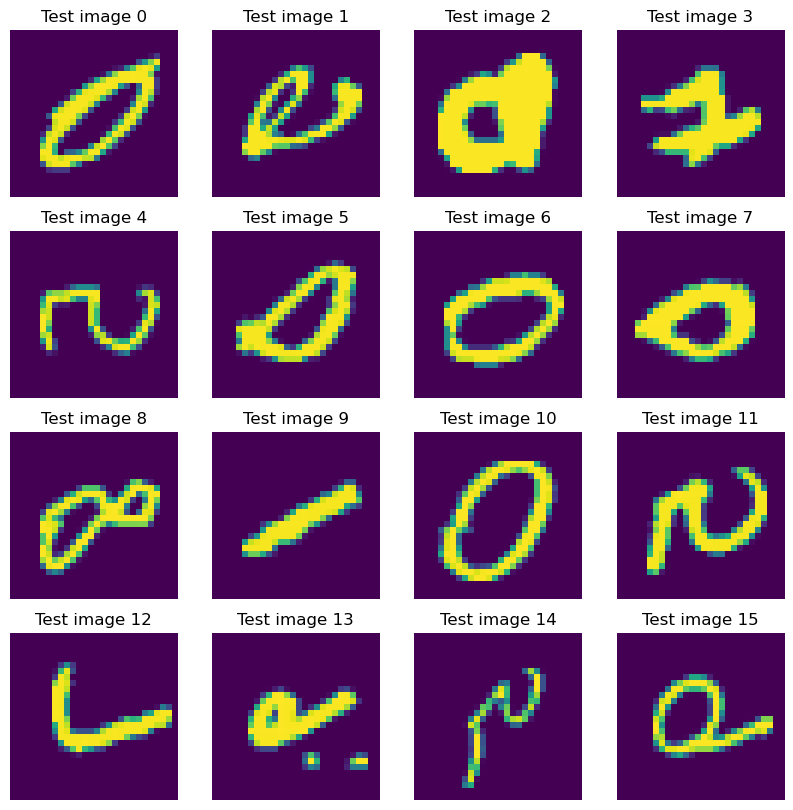

In [5]:
fig, axs = plt.subplots(4,4, figsize=(10,10))

for i, ax in enumerate(axs.flat):
    ax.imshow(np.array(test_dataset[i])[0].reshape(28,28))
    ax.axis('off')
    ax.set_title(f"Test image {i}")

### Create autoencoder model

Here we create our basic autoencoder, `model`. We then initialise two copies of the model, one to be trained with the FishLeg optimizer and the other to be trained with ADAM, for comparison.

The architecture of the autoencoder model is as follows:
| Code | Explanation |
| :- | :- |
| `nn.Linear(784, 1000, dtype=torch.float32)`             | Input layer: Takes in a flattened 28x28 pixel (784 values) image as input and outputs a 1000-dimensional vector |
| `nn.ReLU()`                                             | Activation function: Applies the ReLU (Rectified Linear Unit) function the output of the previous layer to introduce non-linearity |
|`nn.Linear(1000, 500, dtype=torch.float32)`            | Hidden layer: Takes the 1000-dimensional vector and outputs a 500-dimensional vector |
| `nn.ReLU()` | |
| `nn.Linear(500, 250, dtype=torch.float32)`          |    Hidden layer: Takes the 500-dimensional vector and reduces the output down to a 250-dimensional vector |
| `nn.ReLU()` | |
| `nn.Linear(250, 30, dtype=torch.float32)`            |   Waist layer: Takes the 250-dimensional vector and outputs a 30-dimensional vector. This is the smallest compressed representation of the data, every possible feature should be able to be described with no less than 30 degrees of freedom. |
| `nn.Linear(30, 250, dtype=torch.float32)`     |          Start of the decoder part of the network: Takes the 30-dimensional vector and upscales to a 250-dimensional vector |
| `nn.ReLU()` | |
| `nn.Linear(250, 500, dtype=torch.float32)`       |       Hidden layer: Takes the 250-dimensional vector and upscales again to a 500-dimensional vector |
| `nn.ReLU()` | |
| `nn.Linear(500, 1000, dtype=torch.float32)`     |        Hidden layer: Takes the 500-dimensional vector and outputs a 1000-dimensional vector |
| `nn.ReLU()` | |
| `nn.Linear(1000, 784, dtype=torch.float32)`      |       Output layer: Takes the 1000-dimensional vector and outputs the 784-dimensional vector, which is the same size as the input. This is the reconstructed image. |

In [6]:
model = nn.Sequential(
    nn.Linear(784, 1000, dtype=torch.float32),
    nn.ReLU(),
    nn.Linear(1000, 500, dtype=torch.float32),
    nn.ReLU(),
    nn.Linear(500, 250, dtype=torch.float32),
    nn.ReLU(),
    nn.Linear(250, 30, dtype=torch.float32),
    nn.Linear(30, 250, dtype=torch.float32),
    nn.ReLU(),
    nn.Linear(250, 500, dtype=torch.float32),
    nn.ReLU(),
    nn.Linear(500, 1000, dtype=torch.float32),
    nn.ReLU(),
    nn.Linear(1000, 784, dtype=torch.float32),
)

### Initialising FishLeg optimizer

Here we prepare FishLeg for optimizing our autoencoder. To do so, we first need to modify our autoencoder model by calling `initialise_FishModel`. This replaces the layer objects in the above model with modified versions that contain additional parameters that are necessary for calculations performed by FishLeg. As with many optimizers, FishLeg has a selection of hyperparameters that can be tuned according to the problem at hand. FishLeg shares similar hyperparameters with other optimizers, however it has additional hyperparameters for the online, meta-learning that FishLeg performs.

In [7]:
from optim.FishLeg import FishLeg, FISH_LIKELIHOODS, initialise_FishModel

## Create FishLeg autoencoder model ##
model_FishLeg = copy.deepcopy(model).to(device) # Create a copy of our model for training with FishLeg

scale_factor = 1
damping = 0.1
model_FishLeg = initialise_FishModel(
    model_FishLeg, module_names="__ALL__", fish_scale=scale_factor / damping
)

model_FishLeg = model_FishLeg.to(device) # Select device to train our model on


## Setting FishLeg optimizer parameters ##
lr = 0.005
beta = 0.9
weight_decay = 1e-5
aux_lr = 1e-4
aux_eps = 1e-8
update_aux_every = 10
initialization = "normal"
normalization = True
likelihood = FISH_LIKELIHOODS["bernoulli"](device=device) # Our selected function to evaluate the negative log-likelihood
writer = SummaryWriter(
    log_dir=f"runs/MNIST_fishleg/lr={lr}_auxlr={aux_lr}/{datetime.now().strftime('%Y%m%d-%H%M%S')}",
)

## Initialising FishLeg ##
opt = FishLeg(
    model_FishLeg,
    aux_loader,
    likelihood,
    lr=lr,
    beta=beta,
    weight_decay=weight_decay,
    aux_lr=aux_lr,
    aux_betas=(0.9, 0.999),
    aux_eps=aux_eps,
    damping=damping,
    update_aux_every=update_aux_every,
    writer=writer,
    method="antithetic",
    method_kwargs={"eps": 1e-4},
    precondition_aux=True,
    aux_log=True
)

### Training with FishLeg:

Here we train our model using FishLeg using an arbitrary training loop. This training loop is identical to training with ADAM.

In [8]:
epochs = 10

st = time.time()
eval_time = 0

train_losses_FishLeg = [] # Saving our losses for comparison...
test_losses_FishLeg = []
auxiliary_losses = []

for epoch in range(1, epochs + 1):
    with tqdm(train_loader, unit="batch") as tepoch:
        running_loss = 0
        for n, (batch_data, batch_labels) in enumerate(tepoch, start=1):
            tepoch.set_description(f"Epoch {epoch}")

            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

            opt.zero_grad()
            output = model_FishLeg(batch_data)

            loss = likelihood(output, batch_labels)

            running_loss += loss.item()

            loss.backward()
            opt.step()
            auxiliary_losses.append(opt.aux_loss)

            et = time.time()
            if n % 50 == 0:
                model_FishLeg.eval()

                running_test_loss = 0

                for m, (test_batch_data, test_batch_labels) in enumerate(test_loader):
                    test_batch_data, test_batch_labels = test_batch_data.to(
                        device
                    ), test_batch_labels.to(device)

                    test_output = model_FishLeg(test_batch_data)

                    test_loss = likelihood(test_output, test_batch_labels)

                    running_test_loss += test_loss.item()

                running_test_loss /= m

                tepoch.set_postfix(loss=loss.item(), test_loss=running_test_loss)
                model_FishLeg.train()
                eval_time += time.time() - et

        epoch_time = time.time() - st - eval_time

        tepoch.set_postfix(
            loss=running_loss / n, test_loss=running_test_loss, epoch_time=epoch_time
        )

        train_losses_FishLeg.append(running_loss / n)
        test_losses_FishLeg.append(running_test_loss)

        # Write out the losses per epoch
        writer.add_scalar("Loss/train", running_loss / n, epoch)
        writer.add_scalar("Loss/test", running_test_loss, epoch)

        # Write out the losses per wall clock time
        writer.add_scalar("Loss/train/time", running_loss / n, epoch_time)
        writer.add_scalar("Loss/test/time", running_test_loss, epoch_time)

  0%|                                                                                                                                                                                            | 0/600 [00:00<?, ?batch/s]

Epoch 1:   0%|                                                                                                                                                                                   | 0/600 [00:00<?, ?batch/s]

Epoch 1:   0%|▎                                                                                                                                                                          | 1/600 [00:00<03:48,  2.63batch/s]

Epoch 1:   0%|▎                                                                                                                                                                          | 1/600 [00:00<03:48,  2.63batch/s]

Epoch 1:   0%|▎                                                                                                                                                                          | 1/600 [00:00<03:48,  2.63batch/s]

Epoch 1:   0%|▎                                                                                                                                                                          | 1/600 [00:00<03:48,  2.63batch/s]

Epoch 1:   0%|▎                                                                                                                                                                          | 1/600 [00:00<03:48,  2.63batch/s]

Epoch 1:   0%|▎                                                                                                                                                                          | 1/600 [00:00<03:48,  2.63batch/s]

Epoch 1:   1%|█▋                                                                                                                                                                         | 6/600 [00:00<00:38, 15.25batch/s]

Epoch 1:   1%|█▋                                                                                                                                                                         | 6/600 [00:00<00:38, 15.25batch/s]

Epoch 1:   1%|█▋                                                                                                                                                                         | 6/600 [00:00<00:38, 15.25batch/s]

Epoch 1:   1%|█▋                                                                                                                                                                         | 6/600 [00:00<00:38, 15.25batch/s]

Epoch 1:   1%|█▋                                                                                                                                                                         | 6/600 [00:00<00:38, 15.25batch/s]

Epoch 1:   1%|█▋                                                                                                                                                                         | 6/600 [00:00<00:38, 15.25batch/s]

Epoch 1:   2%|███                                                                                                                                                                       | 11/600 [00:00<00:29, 19.71batch/s]

Epoch 1:   2%|███                                                                                                                                                                       | 11/600 [00:00<00:29, 19.71batch/s]

Epoch 1:   2%|███                                                                                                                                                                       | 11/600 [00:00<00:29, 19.71batch/s]

Epoch 1:   2%|███                                                                                                                                                                       | 11/600 [00:00<00:29, 19.71batch/s]

Epoch 1:   2%|███                                                                                                                                                                       | 11/600 [00:00<00:29, 19.71batch/s]

Epoch 1:   2%|███                                                                                                                                                                       | 11/600 [00:00<00:29, 19.71batch/s]

Epoch 1:   2%|███                                                                                                                                                                       | 11/600 [00:00<00:29, 19.71batch/s]

Epoch 1:   3%|████▊                                                                                                                                                                     | 17/600 [00:00<00:20, 28.68batch/s]

Epoch 1:   3%|████▊                                                                                                                                                                     | 17/600 [00:00<00:20, 28.68batch/s]

Epoch 1:   3%|████▊                                                                                                                                                                     | 17/600 [00:00<00:20, 28.68batch/s]

Epoch 1:   3%|████▊                                                                                                                                                                     | 17/600 [00:00<00:20, 28.68batch/s]

Epoch 1:   3%|████▊                                                                                                                                                                     | 17/600 [00:00<00:20, 28.68batch/s]

Epoch 1:   4%|█████▉                                                                                                                                                                    | 21/600 [00:00<00:20, 27.85batch/s]

Epoch 1:   4%|█████▉                                                                                                                                                                    | 21/600 [00:00<00:20, 27.85batch/s]

Epoch 1:   4%|█████▉                                                                                                                                                                    | 21/600 [00:00<00:20, 27.85batch/s]

Epoch 1:   4%|█████▉                                                                                                                                                                    | 21/600 [00:00<00:20, 27.85batch/s]

Epoch 1:   4%|█████▉                                                                                                                                                                    | 21/600 [00:00<00:20, 27.85batch/s]

Epoch 1:   4%|█████▉                                                                                                                                                                    | 21/600 [00:01<00:20, 27.85batch/s]

Epoch 1:   4%|█████▉                                                                                                                                                                    | 21/600 [00:01<00:20, 27.85batch/s]

Epoch 1:   4%|███████▋                                                                                                                                                                  | 27/600 [00:01<00:16, 35.35batch/s]

Epoch 1:   4%|███████▋                                                                                                                                                                  | 27/600 [00:01<00:16, 35.35batch/s]

Epoch 1:   4%|███████▋                                                                                                                                                                  | 27/600 [00:01<00:16, 35.35batch/s]

Epoch 1:   4%|███████▋                                                                                                                                                                  | 27/600 [00:01<00:16, 35.35batch/s]

Epoch 1:   4%|███████▋                                                                                                                                                                  | 27/600 [00:01<00:16, 35.35batch/s]

Epoch 1:   4%|███████▋                                                                                                                                                                  | 27/600 [00:01<00:16, 35.35batch/s]

Epoch 1:   5%|█████████                                                                                                                                                                 | 32/600 [00:01<00:16, 33.62batch/s]

Epoch 1:   5%|█████████                                                                                                                                                                 | 32/600 [00:01<00:16, 33.62batch/s]

Epoch 1:   5%|█████████                                                                                                                                                                 | 32/600 [00:01<00:16, 33.62batch/s]

Epoch 1:   5%|█████████                                                                                                                                                                 | 32/600 [00:01<00:16, 33.62batch/s]

Epoch 1:   5%|█████████                                                                                                                                                                 | 32/600 [00:01<00:16, 33.62batch/s]

Epoch 1:   5%|█████████                                                                                                                                                                 | 32/600 [00:01<00:16, 33.62batch/s]

Epoch 1:   5%|█████████                                                                                                                                                                 | 32/600 [00:01<00:16, 33.62batch/s]

Epoch 1:   6%|██████████▊                                                                                                                                                               | 38/600 [00:01<00:14, 39.63batch/s]

Epoch 1:   6%|██████████▊                                                                                                                                                               | 38/600 [00:01<00:14, 39.63batch/s]

Epoch 1:   6%|██████████▊                                                                                                                                                               | 38/600 [00:01<00:14, 39.63batch/s]

Epoch 1:   6%|██████████▊                                                                                                                                                               | 38/600 [00:01<00:14, 39.63batch/s]

Epoch 1:   6%|██████████▊                                                                                                                                                               | 38/600 [00:01<00:14, 39.63batch/s]

Epoch 1:   6%|██████████▊                                                                                                                                                               | 38/600 [00:01<00:14, 39.63batch/s]

Epoch 1:   7%|████████████▏                                                                                                                                                             | 43/600 [00:01<00:15, 36.23batch/s]

Epoch 1:   7%|████████████▏                                                                                                                                                             | 43/600 [00:01<00:15, 36.23batch/s]

Epoch 1:   7%|████████████▏                                                                                                                                                             | 43/600 [00:01<00:15, 36.23batch/s]

Epoch 1:   7%|████████████▏                                                                                                                                                             | 43/600 [00:01<00:15, 36.23batch/s]

Epoch 1:   7%|████████████▏                                                                                                                                                             | 43/600 [00:01<00:15, 36.23batch/s]

Epoch 1:   7%|████████████▏                                                                                                                                                             | 43/600 [00:01<00:15, 36.23batch/s]

Epoch 1:   7%|████████████▏                                                                                                                                                             | 43/600 [00:01<00:15, 36.23batch/s]

Epoch 1:   8%|█████████████▉                                                                                                                                                            | 49/600 [00:01<00:13, 41.36batch/s]

Epoch 1:   8%|█████████████▉                                                                                                                                                            | 49/600 [00:01<00:13, 41.36batch/s]

Epoch 1:   8%|███████████▊                                                                                                                                     | 49/600 [00:01<00:13, 41.36batch/s, loss=193, test_loss=221]

Epoch 1:   8%|███████████▊                                                                                                                                     | 49/600 [00:01<00:13, 41.36batch/s, loss=193, test_loss=221]

Epoch 1:   8%|███████████▊                                                                                                                                     | 49/600 [00:01<00:13, 41.36batch/s, loss=193, test_loss=221]

Epoch 1:   8%|███████████▊                                                                                                                                     | 49/600 [00:01<00:13, 41.36batch/s, loss=193, test_loss=221]

Epoch 1:   8%|███████████▊                                                                                                                                     | 49/600 [00:01<00:13, 41.36batch/s, loss=193, test_loss=221]

Epoch 1:   9%|█████████████                                                                                                                                    | 54/600 [00:01<00:21, 25.56batch/s, loss=193, test_loss=221]

Epoch 1:   9%|█████████████                                                                                                                                    | 54/600 [00:01<00:21, 25.56batch/s, loss=193, test_loss=221]

Epoch 1:   9%|█████████████                                                                                                                                    | 54/600 [00:01<00:21, 25.56batch/s, loss=193, test_loss=221]

Epoch 1:   9%|█████████████                                                                                                                                    | 54/600 [00:02<00:21, 25.56batch/s, loss=193, test_loss=221]

Epoch 1:   9%|█████████████                                                                                                                                    | 54/600 [00:02<00:21, 25.56batch/s, loss=193, test_loss=221]

Epoch 1:   9%|█████████████                                                                                                                                    | 54/600 [00:02<00:21, 25.56batch/s, loss=193, test_loss=221]

Epoch 1:   9%|█████████████                                                                                                                                    | 54/600 [00:02<00:21, 25.56batch/s, loss=193, test_loss=221]

Epoch 1:  10%|██████████████▌                                                                                                                                  | 60/600 [00:02<00:17, 31.36batch/s, loss=193, test_loss=221]

Epoch 1:  10%|██████████████▌                                                                                                                                  | 60/600 [00:02<00:17, 31.36batch/s, loss=193, test_loss=221]

Epoch 1:  10%|██████████████▌                                                                                                                                  | 60/600 [00:02<00:17, 31.36batch/s, loss=193, test_loss=221]

Epoch 1:  10%|██████████████▌                                                                                                                                  | 60/600 [00:02<00:17, 31.36batch/s, loss=193, test_loss=221]

Epoch 1:  10%|██████████████▌                                                                                                                                  | 60/600 [00:02<00:17, 31.36batch/s, loss=193, test_loss=221]

Epoch 1:  10%|██████████████▌                                                                                                                                  | 60/600 [00:02<00:17, 31.36batch/s, loss=193, test_loss=221]

Epoch 1:  11%|███████████████▋                                                                                                                                 | 65/600 [00:02<00:17, 31.04batch/s, loss=193, test_loss=221]

Epoch 1:  11%|███████████████▋                                                                                                                                 | 65/600 [00:02<00:17, 31.04batch/s, loss=193, test_loss=221]

Epoch 1:  11%|███████████████▋                                                                                                                                 | 65/600 [00:02<00:17, 31.04batch/s, loss=193, test_loss=221]

Epoch 1:  11%|███████████████▋                                                                                                                                 | 65/600 [00:02<00:17, 31.04batch/s, loss=193, test_loss=221]

Epoch 1:  11%|███████████████▋                                                                                                                                 | 65/600 [00:02<00:17, 31.04batch/s, loss=193, test_loss=221]

Epoch 1:  11%|███████████████▋                                                                                                                                 | 65/600 [00:02<00:17, 31.04batch/s, loss=193, test_loss=221]

Epoch 1:  11%|███████████████▋                                                                                                                                 | 65/600 [00:02<00:17, 31.04batch/s, loss=193, test_loss=221]

Epoch 1:  12%|█████████████████▏                                                                                                                               | 71/600 [00:02<00:16, 31.53batch/s, loss=193, test_loss=221]

Epoch 1:  12%|█████████████████▏                                                                                                                               | 71/600 [00:02<00:16, 31.53batch/s, loss=193, test_loss=221]

Epoch 1:  12%|█████████████████▏                                                                                                                               | 71/600 [00:02<00:16, 31.53batch/s, loss=193, test_loss=221]

Epoch 1:  12%|█████████████████▏                                                                                                                               | 71/600 [00:02<00:16, 31.53batch/s, loss=193, test_loss=221]

Epoch 1:  12%|█████████████████▏                                                                                                                               | 71/600 [00:02<00:16, 31.53batch/s, loss=193, test_loss=221]

Epoch 1:  12%|█████████████████▏                                                                                                                               | 71/600 [00:02<00:16, 31.53batch/s, loss=193, test_loss=221]

Epoch 1:  12%|█████████████████▏                                                                                                                               | 71/600 [00:02<00:16, 31.53batch/s, loss=193, test_loss=221]

Epoch 1:  13%|██████████████████▌                                                                                                                              | 77/600 [00:02<00:14, 36.92batch/s, loss=193, test_loss=221]

Epoch 1:  13%|██████████████████▌                                                                                                                              | 77/600 [00:02<00:14, 36.92batch/s, loss=193, test_loss=221]

Epoch 1:  13%|██████████████████▌                                                                                                                              | 77/600 [00:02<00:14, 36.92batch/s, loss=193, test_loss=221]

Epoch 1:  13%|██████████████████▌                                                                                                                              | 77/600 [00:02<00:14, 36.92batch/s, loss=193, test_loss=221]

Epoch 1:  13%|██████████████████▌                                                                                                                              | 77/600 [00:02<00:14, 36.92batch/s, loss=193, test_loss=221]

Epoch 1:  13%|██████████████████▌                                                                                                                              | 77/600 [00:02<00:14, 36.92batch/s, loss=193, test_loss=221]

Epoch 1:  14%|███████████████████▊                                                                                                                             | 82/600 [00:02<00:14, 34.86batch/s, loss=193, test_loss=221]

Epoch 1:  14%|███████████████████▊                                                                                                                             | 82/600 [00:02<00:14, 34.86batch/s, loss=193, test_loss=221]

Epoch 1:  14%|███████████████████▊                                                                                                                             | 82/600 [00:02<00:14, 34.86batch/s, loss=193, test_loss=221]

Epoch 1:  14%|███████████████████▊                                                                                                                             | 82/600 [00:02<00:14, 34.86batch/s, loss=193, test_loss=221]

Epoch 1:  14%|███████████████████▊                                                                                                                             | 82/600 [00:02<00:14, 34.86batch/s, loss=193, test_loss=221]

Epoch 1:  14%|███████████████████▊                                                                                                                             | 82/600 [00:02<00:14, 34.86batch/s, loss=193, test_loss=221]

Epoch 1:  14%|███████████████████▊                                                                                                                             | 82/600 [00:02<00:14, 34.86batch/s, loss=193, test_loss=221]

Epoch 1:  15%|█████████████████████▎                                                                                                                           | 88/600 [00:02<00:12, 39.89batch/s, loss=193, test_loss=221]

Epoch 1:  15%|█████████████████████▎                                                                                                                           | 88/600 [00:02<00:12, 39.89batch/s, loss=193, test_loss=221]

Epoch 1:  15%|█████████████████████▎                                                                                                                           | 88/600 [00:02<00:12, 39.89batch/s, loss=193, test_loss=221]

Epoch 1:  15%|█████████████████████▎                                                                                                                           | 88/600 [00:02<00:12, 39.89batch/s, loss=193, test_loss=221]

Epoch 1:  15%|█████████████████████▎                                                                                                                           | 88/600 [00:02<00:12, 39.89batch/s, loss=193, test_loss=221]

Epoch 1:  15%|█████████████████████▎                                                                                                                           | 88/600 [00:02<00:12, 39.89batch/s, loss=193, test_loss=221]

Epoch 1:  16%|██████████████████████▍                                                                                                                          | 93/600 [00:02<00:13, 36.56batch/s, loss=193, test_loss=221]

Epoch 1:  16%|██████████████████████▍                                                                                                                          | 93/600 [00:02<00:13, 36.56batch/s, loss=193, test_loss=221]

Epoch 1:  16%|██████████████████████▍                                                                                                                          | 93/600 [00:02<00:13, 36.56batch/s, loss=193, test_loss=221]

Epoch 1:  16%|██████████████████████▍                                                                                                                          | 93/600 [00:02<00:13, 36.56batch/s, loss=193, test_loss=221]

Epoch 1:  16%|██████████████████████▍                                                                                                                          | 93/600 [00:03<00:13, 36.56batch/s, loss=193, test_loss=221]

Epoch 1:  16%|██████████████████████▍                                                                                                                          | 93/600 [00:03<00:13, 36.56batch/s, loss=193, test_loss=221]

Epoch 1:  16%|██████████████████████▍                                                                                                                          | 93/600 [00:03<00:13, 36.56batch/s, loss=193, test_loss=221]

Epoch 1:  16%|███████████████████████▉                                                                                                                         | 99/600 [00:03<00:12, 41.58batch/s, loss=193, test_loss=221]

Epoch 1:  16%|███████████████████████▉                                                                                                                         | 99/600 [00:03<00:12, 41.58batch/s, loss=193, test_loss=221]

Epoch 1:  16%|███████████████████████▉                                                                                                                         | 99/600 [00:03<00:12, 41.58batch/s, loss=186, test_loss=207]

Epoch 1:  16%|███████████████████████▉                                                                                                                         | 99/600 [00:03<00:12, 41.58batch/s, loss=186, test_loss=207]

Epoch 1:  16%|███████████████████████▉                                                                                                                         | 99/600 [00:03<00:12, 41.58batch/s, loss=186, test_loss=207]

Epoch 1:  16%|███████████████████████▉                                                                                                                         | 99/600 [00:03<00:12, 41.58batch/s, loss=186, test_loss=207]

Epoch 1:  16%|███████████████████████▉                                                                                                                         | 99/600 [00:03<00:12, 41.58batch/s, loss=186, test_loss=207]

Epoch 1:  17%|████████████████████████▉                                                                                                                       | 104/600 [00:03<00:18, 26.61batch/s, loss=186, test_loss=207]

Epoch 1:  17%|████████████████████████▉                                                                                                                       | 104/600 [00:03<00:18, 26.61batch/s, loss=186, test_loss=207]

Epoch 1:  17%|████████████████████████▉                                                                                                                       | 104/600 [00:03<00:18, 26.61batch/s, loss=186, test_loss=207]

Epoch 1:  17%|████████████████████████▉                                                                                                                       | 104/600 [00:03<00:18, 26.61batch/s, loss=186, test_loss=207]

Epoch 1:  17%|████████████████████████▉                                                                                                                       | 104/600 [00:03<00:18, 26.61batch/s, loss=186, test_loss=207]

Epoch 1:  17%|████████████████████████▉                                                                                                                       | 104/600 [00:03<00:18, 26.61batch/s, loss=186, test_loss=207]

Epoch 1:  17%|████████████████████████▉                                                                                                                       | 104/600 [00:03<00:18, 26.61batch/s, loss=186, test_loss=207]

Epoch 1:  18%|██████████████████████████▍                                                                                                                     | 110/600 [00:03<00:15, 32.24batch/s, loss=186, test_loss=207]

Epoch 1:  18%|██████████████████████████▍                                                                                                                     | 110/600 [00:03<00:15, 32.24batch/s, loss=186, test_loss=207]

Epoch 1:  18%|██████████████████████████▍                                                                                                                     | 110/600 [00:03<00:15, 32.24batch/s, loss=186, test_loss=207]

Epoch 1:  18%|██████████████████████████▍                                                                                                                     | 110/600 [00:03<00:15, 32.24batch/s, loss=186, test_loss=207]

Epoch 1:  18%|██████████████████████████▍                                                                                                                     | 110/600 [00:03<00:15, 32.24batch/s, loss=186, test_loss=207]

Epoch 1:  18%|██████████████████████████▍                                                                                                                     | 110/600 [00:03<00:15, 32.24batch/s, loss=186, test_loss=207]

Epoch 1:  19%|███████████████████████████▌                                                                                                                    | 115/600 [00:03<00:15, 31.72batch/s, loss=186, test_loss=207]

Epoch 1:  19%|███████████████████████████▌                                                                                                                    | 115/600 [00:03<00:15, 31.72batch/s, loss=186, test_loss=207]

Epoch 1:  19%|███████████████████████████▌                                                                                                                    | 115/600 [00:03<00:15, 31.72batch/s, loss=186, test_loss=207]

Epoch 1:  19%|███████████████████████████▌                                                                                                                    | 115/600 [00:03<00:15, 31.72batch/s, loss=186, test_loss=207]

Epoch 1:  19%|███████████████████████████▌                                                                                                                    | 115/600 [00:03<00:15, 31.72batch/s, loss=186, test_loss=207]

Epoch 1:  19%|███████████████████████████▌                                                                                                                    | 115/600 [00:03<00:15, 31.72batch/s, loss=186, test_loss=207]

Epoch 1:  19%|███████████████████████████▌                                                                                                                    | 115/600 [00:03<00:15, 31.72batch/s, loss=186, test_loss=207]

Epoch 1:  20%|█████████████████████████████                                                                                                                   | 121/600 [00:03<00:14, 32.04batch/s, loss=186, test_loss=207]

Epoch 1:  20%|█████████████████████████████                                                                                                                   | 121/600 [00:03<00:14, 32.04batch/s, loss=186, test_loss=207]

Epoch 1:  20%|█████████████████████████████                                                                                                                   | 121/600 [00:03<00:14, 32.04batch/s, loss=186, test_loss=207]

Epoch 1:  20%|█████████████████████████████                                                                                                                   | 121/600 [00:03<00:14, 32.04batch/s, loss=186, test_loss=207]

Epoch 1:  20%|█████████████████████████████                                                                                                                   | 121/600 [00:03<00:14, 32.04batch/s, loss=186, test_loss=207]

Epoch 1:  20%|█████████████████████████████                                                                                                                   | 121/600 [00:03<00:14, 32.04batch/s, loss=186, test_loss=207]

Epoch 1:  20%|█████████████████████████████                                                                                                                   | 121/600 [00:03<00:14, 32.04batch/s, loss=186, test_loss=207]

Epoch 1:  21%|██████████████████████████████▍                                                                                                                 | 127/600 [00:03<00:12, 37.29batch/s, loss=186, test_loss=207]

Epoch 1:  21%|██████████████████████████████▍                                                                                                                 | 127/600 [00:03<00:12, 37.29batch/s, loss=186, test_loss=207]

Epoch 1:  21%|██████████████████████████████▍                                                                                                                 | 127/600 [00:03<00:12, 37.29batch/s, loss=186, test_loss=207]

Epoch 1:  21%|██████████████████████████████▍                                                                                                                 | 127/600 [00:04<00:12, 37.29batch/s, loss=186, test_loss=207]

Epoch 1:  21%|██████████████████████████████▍                                                                                                                 | 127/600 [00:04<00:12, 37.29batch/s, loss=186, test_loss=207]

Epoch 1:  21%|██████████████████████████████▍                                                                                                                 | 127/600 [00:04<00:12, 37.29batch/s, loss=186, test_loss=207]

Epoch 1:  22%|███████████████████████████████▋                                                                                                                | 132/600 [00:04<00:13, 35.08batch/s, loss=186, test_loss=207]

Epoch 1:  22%|███████████████████████████████▋                                                                                                                | 132/600 [00:04<00:13, 35.08batch/s, loss=186, test_loss=207]

Epoch 1:  22%|███████████████████████████████▋                                                                                                                | 132/600 [00:04<00:13, 35.08batch/s, loss=186, test_loss=207]

Epoch 1:  22%|███████████████████████████████▋                                                                                                                | 132/600 [00:04<00:13, 35.08batch/s, loss=186, test_loss=207]

Epoch 1:  22%|███████████████████████████████▋                                                                                                                | 132/600 [00:04<00:13, 35.08batch/s, loss=186, test_loss=207]

Epoch 1:  22%|███████████████████████████████▋                                                                                                                | 132/600 [00:04<00:13, 35.08batch/s, loss=186, test_loss=207]

Epoch 1:  22%|███████████████████████████████▋                                                                                                                | 132/600 [00:04<00:13, 35.08batch/s, loss=186, test_loss=207]

Epoch 1:  23%|█████████████████████████████████                                                                                                               | 138/600 [00:04<00:11, 40.19batch/s, loss=186, test_loss=207]

Epoch 1:  23%|█████████████████████████████████                                                                                                               | 138/600 [00:04<00:11, 40.19batch/s, loss=186, test_loss=207]

Epoch 1:  23%|█████████████████████████████████                                                                                                               | 138/600 [00:04<00:11, 40.19batch/s, loss=186, test_loss=207]

Epoch 1:  23%|█████████████████████████████████                                                                                                               | 138/600 [00:04<00:11, 40.19batch/s, loss=186, test_loss=207]

Epoch 1:  23%|█████████████████████████████████                                                                                                               | 138/600 [00:04<00:11, 40.19batch/s, loss=186, test_loss=207]

Epoch 1:  23%|█████████████████████████████████                                                                                                               | 138/600 [00:04<00:11, 40.19batch/s, loss=186, test_loss=207]

Epoch 1:  24%|██████████████████████████████████▎                                                                                                             | 143/600 [00:04<00:12, 36.66batch/s, loss=186, test_loss=207]

Epoch 1:  24%|██████████████████████████████████▎                                                                                                             | 143/600 [00:04<00:12, 36.66batch/s, loss=186, test_loss=207]

Epoch 1:  24%|██████████████████████████████████▎                                                                                                             | 143/600 [00:04<00:12, 36.66batch/s, loss=186, test_loss=207]

Epoch 1:  24%|██████████████████████████████████▎                                                                                                             | 143/600 [00:04<00:12, 36.66batch/s, loss=186, test_loss=207]

Epoch 1:  24%|██████████████████████████████████▎                                                                                                             | 143/600 [00:04<00:12, 36.66batch/s, loss=186, test_loss=207]

Epoch 1:  24%|██████████████████████████████████▎                                                                                                             | 143/600 [00:04<00:12, 36.66batch/s, loss=186, test_loss=207]

Epoch 1:  24%|██████████████████████████████████▎                                                                                                             | 143/600 [00:04<00:12, 36.66batch/s, loss=186, test_loss=207]

Epoch 1:  25%|███████████████████████████████████▊                                                                                                            | 149/600 [00:04<00:10, 41.57batch/s, loss=186, test_loss=207]

Epoch 1:  25%|███████████████████████████████████▊                                                                                                            | 149/600 [00:04<00:10, 41.57batch/s, loss=186, test_loss=207]

Epoch 1:  25%|███████████████████████████████████▊                                                                                                            | 149/600 [00:04<00:10, 41.57batch/s, loss=185, test_loss=203]

Epoch 1:  25%|███████████████████████████████████▊                                                                                                            | 149/600 [00:04<00:10, 41.57batch/s, loss=185, test_loss=203]

Epoch 1:  25%|███████████████████████████████████▊                                                                                                            | 149/600 [00:04<00:10, 41.57batch/s, loss=185, test_loss=203]

Epoch 1:  25%|███████████████████████████████████▊                                                                                                            | 149/600 [00:04<00:10, 41.57batch/s, loss=185, test_loss=203]

Epoch 1:  25%|███████████████████████████████████▊                                                                                                            | 149/600 [00:04<00:10, 41.57batch/s, loss=185, test_loss=203]

Epoch 1:  26%|████████████████████████████████████▉                                                                                                           | 154/600 [00:04<00:16, 26.46batch/s, loss=185, test_loss=203]

Epoch 1:  26%|████████████████████████████████████▉                                                                                                           | 154/600 [00:04<00:16, 26.46batch/s, loss=185, test_loss=203]

Epoch 1:  26%|████████████████████████████████████▉                                                                                                           | 154/600 [00:04<00:16, 26.46batch/s, loss=185, test_loss=203]

Epoch 1:  26%|████████████████████████████████████▉                                                                                                           | 154/600 [00:04<00:16, 26.46batch/s, loss=185, test_loss=203]

Epoch 1:  26%|████████████████████████████████████▉                                                                                                           | 154/600 [00:04<00:16, 26.46batch/s, loss=185, test_loss=203]

Epoch 1:  26%|████████████████████████████████████▉                                                                                                           | 154/600 [00:04<00:16, 26.46batch/s, loss=185, test_loss=203]

Epoch 1:  26%|████████████████████████████████████▉                                                                                                           | 154/600 [00:04<00:16, 26.46batch/s, loss=185, test_loss=203]

Epoch 1:  27%|██████████████████████████████████████▍                                                                                                         | 160/600 [00:04<00:13, 32.10batch/s, loss=185, test_loss=203]

Epoch 1:  27%|██████████████████████████████████████▍                                                                                                         | 160/600 [00:04<00:13, 32.10batch/s, loss=185, test_loss=203]

Epoch 1:  27%|██████████████████████████████████████▍                                                                                                         | 160/600 [00:05<00:13, 32.10batch/s, loss=185, test_loss=203]

Epoch 1:  27%|██████████████████████████████████████▍                                                                                                         | 160/600 [00:05<00:13, 32.10batch/s, loss=185, test_loss=203]

Epoch 1:  27%|██████████████████████████████████████▍                                                                                                         | 160/600 [00:05<00:13, 32.10batch/s, loss=185, test_loss=203]

Epoch 1:  27%|██████████████████████████████████████▍                                                                                                         | 160/600 [00:05<00:13, 32.10batch/s, loss=185, test_loss=203]

Epoch 1:  28%|███████████████████████████████████████▌                                                                                                        | 165/600 [00:05<00:13, 31.58batch/s, loss=185, test_loss=203]

Epoch 1:  28%|███████████████████████████████████████▌                                                                                                        | 165/600 [00:05<00:13, 31.58batch/s, loss=185, test_loss=203]

Epoch 1:  28%|███████████████████████████████████████▌                                                                                                        | 165/600 [00:05<00:13, 31.58batch/s, loss=185, test_loss=203]

Epoch 1:  28%|███████████████████████████████████████▌                                                                                                        | 165/600 [00:05<00:13, 31.58batch/s, loss=185, test_loss=203]

Epoch 1:  28%|███████████████████████████████████████▌                                                                                                        | 165/600 [00:05<00:13, 31.58batch/s, loss=185, test_loss=203]

Epoch 1:  28%|███████████████████████████████████████▌                                                                                                        | 165/600 [00:05<00:13, 31.58batch/s, loss=185, test_loss=203]

Epoch 1:  28%|███████████████████████████████████████▌                                                                                                        | 165/600 [00:05<00:13, 31.58batch/s, loss=185, test_loss=203]

Epoch 1:  28%|█████████████████████████████████████████                                                                                                       | 171/600 [00:05<00:13, 32.02batch/s, loss=185, test_loss=203]

Epoch 1:  28%|█████████████████████████████████████████                                                                                                       | 171/600 [00:05<00:13, 32.02batch/s, loss=185, test_loss=203]

Epoch 1:  28%|█████████████████████████████████████████                                                                                                       | 171/600 [00:05<00:13, 32.02batch/s, loss=185, test_loss=203]

Epoch 1:  28%|█████████████████████████████████████████                                                                                                       | 171/600 [00:05<00:13, 32.02batch/s, loss=185, test_loss=203]

Epoch 1:  28%|█████████████████████████████████████████                                                                                                       | 171/600 [00:05<00:13, 32.02batch/s, loss=185, test_loss=203]

Epoch 1:  28%|█████████████████████████████████████████                                                                                                       | 171/600 [00:05<00:13, 32.02batch/s, loss=185, test_loss=203]

Epoch 1:  28%|█████████████████████████████████████████                                                                                                       | 171/600 [00:05<00:13, 32.02batch/s, loss=185, test_loss=203]

Epoch 1:  30%|██████████████████████████████████████████▍                                                                                                     | 177/600 [00:05<00:11, 37.31batch/s, loss=185, test_loss=203]

Epoch 1:  30%|██████████████████████████████████████████▍                                                                                                     | 177/600 [00:05<00:11, 37.31batch/s, loss=185, test_loss=203]

Epoch 1:  30%|██████████████████████████████████████████▍                                                                                                     | 177/600 [00:05<00:11, 37.31batch/s, loss=185, test_loss=203]

Epoch 1:  30%|██████████████████████████████████████████▍                                                                                                     | 177/600 [00:05<00:11, 37.31batch/s, loss=185, test_loss=203]

Epoch 1:  30%|██████████████████████████████████████████▍                                                                                                     | 177/600 [00:05<00:11, 37.31batch/s, loss=185, test_loss=203]

Epoch 1:  30%|██████████████████████████████████████████▍                                                                                                     | 177/600 [00:05<00:11, 37.31batch/s, loss=185, test_loss=203]

Epoch 1:  30%|███████████████████████████████████████████▋                                                                                                    | 182/600 [00:05<00:11, 35.11batch/s, loss=185, test_loss=203]

Epoch 1:  30%|███████████████████████████████████████████▋                                                                                                    | 182/600 [00:05<00:11, 35.11batch/s, loss=185, test_loss=203]

Epoch 1:  30%|███████████████████████████████████████████▋                                                                                                    | 182/600 [00:05<00:11, 35.11batch/s, loss=185, test_loss=203]

Epoch 1:  30%|███████████████████████████████████████████▋                                                                                                    | 182/600 [00:05<00:11, 35.11batch/s, loss=185, test_loss=203]

Epoch 1:  30%|███████████████████████████████████████████▋                                                                                                    | 182/600 [00:05<00:11, 35.11batch/s, loss=185, test_loss=203]

Epoch 1:  30%|███████████████████████████████████████████▋                                                                                                    | 182/600 [00:05<00:11, 35.11batch/s, loss=185, test_loss=203]

Epoch 1:  30%|███████████████████████████████████████████▋                                                                                                    | 182/600 [00:05<00:11, 35.11batch/s, loss=185, test_loss=203]

Epoch 1:  31%|█████████████████████████████████████████████                                                                                                   | 188/600 [00:05<00:10, 40.21batch/s, loss=185, test_loss=203]

Epoch 1:  31%|█████████████████████████████████████████████                                                                                                   | 188/600 [00:05<00:10, 40.21batch/s, loss=185, test_loss=203]

Epoch 1:  31%|█████████████████████████████████████████████                                                                                                   | 188/600 [00:05<00:10, 40.21batch/s, loss=185, test_loss=203]

Epoch 1:  31%|█████████████████████████████████████████████                                                                                                   | 188/600 [00:05<00:10, 40.21batch/s, loss=185, test_loss=203]

Epoch 1:  31%|█████████████████████████████████████████████                                                                                                   | 188/600 [00:05<00:10, 40.21batch/s, loss=185, test_loss=203]

Epoch 1:  31%|█████████████████████████████████████████████                                                                                                   | 188/600 [00:05<00:10, 40.21batch/s, loss=185, test_loss=203]

Epoch 1:  32%|██████████████████████████████████████████████▎                                                                                                 | 193/600 [00:05<00:11, 36.80batch/s, loss=185, test_loss=203]

Epoch 1:  32%|██████████████████████████████████████████████▎                                                                                                 | 193/600 [00:05<00:11, 36.80batch/s, loss=185, test_loss=203]

Epoch 1:  32%|██████████████████████████████████████████████▎                                                                                                 | 193/600 [00:05<00:11, 36.80batch/s, loss=185, test_loss=203]

Epoch 1:  32%|██████████████████████████████████████████████▎                                                                                                 | 193/600 [00:05<00:11, 36.80batch/s, loss=185, test_loss=203]

Epoch 1:  32%|██████████████████████████████████████████████▎                                                                                                 | 193/600 [00:05<00:11, 36.80batch/s, loss=185, test_loss=203]

Epoch 1:  32%|██████████████████████████████████████████████▎                                                                                                 | 193/600 [00:05<00:11, 36.80batch/s, loss=185, test_loss=203]

Epoch 1:  32%|██████████████████████████████████████████████▎                                                                                                 | 193/600 [00:05<00:11, 36.80batch/s, loss=185, test_loss=203]

Epoch 1:  33%|███████████████████████████████████████████████▊                                                                                                | 199/600 [00:05<00:09, 41.76batch/s, loss=185, test_loss=203]

Epoch 1:  33%|███████████████████████████████████████████████▊                                                                                                | 199/600 [00:05<00:09, 41.76batch/s, loss=185, test_loss=203]

Epoch 1:  33%|███████████████████████████████████████████████▊                                                                                                | 199/600 [00:06<00:09, 41.76batch/s, loss=177, test_loss=198]

Epoch 1:  33%|███████████████████████████████████████████████▊                                                                                                | 199/600 [00:06<00:09, 41.76batch/s, loss=177, test_loss=198]

Epoch 1:  33%|███████████████████████████████████████████████▊                                                                                                | 199/600 [00:06<00:09, 41.76batch/s, loss=177, test_loss=198]

Epoch 1:  33%|███████████████████████████████████████████████▊                                                                                                | 199/600 [00:06<00:09, 41.76batch/s, loss=177, test_loss=198]

Epoch 1:  33%|███████████████████████████████████████████████▊                                                                                                | 199/600 [00:06<00:09, 41.76batch/s, loss=177, test_loss=198]

Epoch 1:  34%|████████████████████████████████████████████████▉                                                                                               | 204/600 [00:06<00:14, 26.57batch/s, loss=177, test_loss=198]

Epoch 1:  34%|████████████████████████████████████████████████▉                                                                                               | 204/600 [00:06<00:14, 26.57batch/s, loss=177, test_loss=198]

Epoch 1:  34%|████████████████████████████████████████████████▉                                                                                               | 204/600 [00:06<00:14, 26.57batch/s, loss=177, test_loss=198]

Epoch 1:  34%|████████████████████████████████████████████████▉                                                                                               | 204/600 [00:06<00:14, 26.57batch/s, loss=177, test_loss=198]

Epoch 1:  34%|████████████████████████████████████████████████▉                                                                                               | 204/600 [00:06<00:14, 26.57batch/s, loss=177, test_loss=198]

Epoch 1:  34%|████████████████████████████████████████████████▉                                                                                               | 204/600 [00:06<00:14, 26.57batch/s, loss=177, test_loss=198]

Epoch 1:  34%|████████████████████████████████████████████████▉                                                                                               | 204/600 [00:06<00:14, 26.57batch/s, loss=177, test_loss=198]

Epoch 1:  35%|██████████████████████████████████████████████████▍                                                                                             | 210/600 [00:06<00:12, 32.24batch/s, loss=177, test_loss=198]

Epoch 1:  35%|██████████████████████████████████████████████████▍                                                                                             | 210/600 [00:06<00:12, 32.24batch/s, loss=177, test_loss=198]

Epoch 1:  35%|██████████████████████████████████████████████████▍                                                                                             | 210/600 [00:06<00:12, 32.24batch/s, loss=177, test_loss=198]

Epoch 1:  35%|██████████████████████████████████████████████████▍                                                                                             | 210/600 [00:06<00:12, 32.24batch/s, loss=177, test_loss=198]

Epoch 1:  35%|██████████████████████████████████████████████████▍                                                                                             | 210/600 [00:06<00:12, 32.24batch/s, loss=177, test_loss=198]

Epoch 1:  35%|██████████████████████████████████████████████████▍                                                                                             | 210/600 [00:06<00:12, 32.24batch/s, loss=177, test_loss=198]

Epoch 1:  36%|███████████████████████████████████████████████████▌                                                                                            | 215/600 [00:06<00:12, 31.68batch/s, loss=177, test_loss=198]

Epoch 1:  36%|███████████████████████████████████████████████████▌                                                                                            | 215/600 [00:06<00:12, 31.68batch/s, loss=177, test_loss=198]

Epoch 1:  36%|███████████████████████████████████████████████████▌                                                                                            | 215/600 [00:06<00:12, 31.68batch/s, loss=177, test_loss=198]

Epoch 1:  36%|███████████████████████████████████████████████████▌                                                                                            | 215/600 [00:06<00:12, 31.68batch/s, loss=177, test_loss=198]

Epoch 1:  36%|███████████████████████████████████████████████████▌                                                                                            | 215/600 [00:06<00:12, 31.68batch/s, loss=177, test_loss=198]

Epoch 1:  36%|███████████████████████████████████████████████████▌                                                                                            | 215/600 [00:06<00:12, 31.68batch/s, loss=177, test_loss=198]

Epoch 1:  36%|███████████████████████████████████████████████████▌                                                                                            | 215/600 [00:06<00:12, 31.68batch/s, loss=177, test_loss=198]

Epoch 1:  37%|█████████████████████████████████████████████████████                                                                                           | 221/600 [00:06<00:11, 32.11batch/s, loss=177, test_loss=198]

Epoch 1:  37%|█████████████████████████████████████████████████████                                                                                           | 221/600 [00:06<00:11, 32.11batch/s, loss=177, test_loss=198]

Epoch 1:  37%|█████████████████████████████████████████████████████                                                                                           | 221/600 [00:06<00:11, 32.11batch/s, loss=177, test_loss=198]

Epoch 1:  37%|█████████████████████████████████████████████████████                                                                                           | 221/600 [00:06<00:11, 32.11batch/s, loss=177, test_loss=198]

Epoch 1:  37%|█████████████████████████████████████████████████████                                                                                           | 221/600 [00:06<00:11, 32.11batch/s, loss=177, test_loss=198]

Epoch 1:  37%|█████████████████████████████████████████████████████                                                                                           | 221/600 [00:06<00:11, 32.11batch/s, loss=177, test_loss=198]

Epoch 1:  37%|█████████████████████████████████████████████████████                                                                                           | 221/600 [00:06<00:11, 32.11batch/s, loss=177, test_loss=198]

Epoch 1:  38%|██████████████████████████████████████████████████████▍                                                                                         | 227/600 [00:06<00:09, 37.42batch/s, loss=177, test_loss=198]

Epoch 1:  38%|██████████████████████████████████████████████████████▍                                                                                         | 227/600 [00:06<00:09, 37.42batch/s, loss=177, test_loss=198]

Epoch 1:  38%|██████████████████████████████████████████████████████▍                                                                                         | 227/600 [00:06<00:09, 37.42batch/s, loss=177, test_loss=198]

Epoch 1:  38%|██████████████████████████████████████████████████████▍                                                                                         | 227/600 [00:06<00:09, 37.42batch/s, loss=177, test_loss=198]

Epoch 1:  38%|██████████████████████████████████████████████████████▍                                                                                         | 227/600 [00:06<00:09, 37.42batch/s, loss=177, test_loss=198]

Epoch 1:  38%|██████████████████████████████████████████████████████▍                                                                                         | 227/600 [00:07<00:09, 37.42batch/s, loss=177, test_loss=198]

Epoch 1:  39%|███████████████████████████████████████████████████████▋                                                                                        | 232/600 [00:07<00:10, 35.21batch/s, loss=177, test_loss=198]

Epoch 1:  39%|███████████████████████████████████████████████████████▋                                                                                        | 232/600 [00:07<00:10, 35.21batch/s, loss=177, test_loss=198]

Epoch 1:  39%|███████████████████████████████████████████████████████▋                                                                                        | 232/600 [00:07<00:10, 35.21batch/s, loss=177, test_loss=198]

Epoch 1:  39%|███████████████████████████████████████████████████████▋                                                                                        | 232/600 [00:07<00:10, 35.21batch/s, loss=177, test_loss=198]

Epoch 1:  39%|███████████████████████████████████████████████████████▋                                                                                        | 232/600 [00:07<00:10, 35.21batch/s, loss=177, test_loss=198]

Epoch 1:  39%|███████████████████████████████████████████████████████▋                                                                                        | 232/600 [00:07<00:10, 35.21batch/s, loss=177, test_loss=198]

Epoch 1:  39%|███████████████████████████████████████████████████████▋                                                                                        | 232/600 [00:07<00:10, 35.21batch/s, loss=177, test_loss=198]

Epoch 1:  40%|█████████████████████████████████████████████████████████                                                                                       | 238/600 [00:07<00:08, 40.29batch/s, loss=177, test_loss=198]

Epoch 1:  40%|█████████████████████████████████████████████████████████                                                                                       | 238/600 [00:07<00:08, 40.29batch/s, loss=177, test_loss=198]

Epoch 1:  40%|█████████████████████████████████████████████████████████                                                                                       | 238/600 [00:07<00:08, 40.29batch/s, loss=177, test_loss=198]

Epoch 1:  40%|█████████████████████████████████████████████████████████                                                                                       | 238/600 [00:07<00:08, 40.29batch/s, loss=177, test_loss=198]

Epoch 1:  40%|█████████████████████████████████████████████████████████                                                                                       | 238/600 [00:07<00:08, 40.29batch/s, loss=177, test_loss=198]

Epoch 1:  40%|█████████████████████████████████████████████████████████                                                                                       | 238/600 [00:07<00:08, 40.29batch/s, loss=177, test_loss=198]

Epoch 1:  40%|██████████████████████████████████████████████████████████▎                                                                                     | 243/600 [00:07<00:09, 36.98batch/s, loss=177, test_loss=198]

Epoch 1:  40%|██████████████████████████████████████████████████████████▎                                                                                     | 243/600 [00:07<00:09, 36.98batch/s, loss=177, test_loss=198]

Epoch 1:  40%|██████████████████████████████████████████████████████████▎                                                                                     | 243/600 [00:07<00:09, 36.98batch/s, loss=177, test_loss=198]

Epoch 1:  40%|██████████████████████████████████████████████████████████▎                                                                                     | 243/600 [00:07<00:09, 36.98batch/s, loss=177, test_loss=198]

Epoch 1:  40%|██████████████████████████████████████████████████████████▎                                                                                     | 243/600 [00:07<00:09, 36.98batch/s, loss=177, test_loss=198]

Epoch 1:  40%|██████████████████████████████████████████████████████████▎                                                                                     | 243/600 [00:07<00:09, 36.98batch/s, loss=177, test_loss=198]

Epoch 1:  40%|██████████████████████████████████████████████████████████▎                                                                                     | 243/600 [00:07<00:09, 36.98batch/s, loss=177, test_loss=198]

Epoch 1:  42%|███████████████████████████████████████████████████████████▊                                                                                    | 249/600 [00:07<00:08, 41.91batch/s, loss=177, test_loss=198]

Epoch 1:  42%|███████████████████████████████████████████████████████████▊                                                                                    | 249/600 [00:07<00:08, 41.91batch/s, loss=177, test_loss=198]

Epoch 1:  42%|███████████████████████████████████████████████████████████▊                                                                                    | 249/600 [00:07<00:08, 41.91batch/s, loss=164, test_loss=182]

Epoch 1:  42%|███████████████████████████████████████████████████████████▊                                                                                    | 249/600 [00:07<00:08, 41.91batch/s, loss=164, test_loss=182]

Epoch 1:  42%|███████████████████████████████████████████████████████████▊                                                                                    | 249/600 [00:07<00:08, 41.91batch/s, loss=164, test_loss=182]

Epoch 1:  42%|███████████████████████████████████████████████████████████▊                                                                                    | 249/600 [00:07<00:08, 41.91batch/s, loss=164, test_loss=182]

Epoch 1:  42%|███████████████████████████████████████████████████████████▊                                                                                    | 249/600 [00:07<00:08, 41.91batch/s, loss=164, test_loss=182]

Epoch 1:  42%|████████████████████████████████████████████████████████████▉                                                                                   | 254/600 [00:07<00:12, 26.64batch/s, loss=164, test_loss=182]

Epoch 1:  42%|████████████████████████████████████████████████████████████▉                                                                                   | 254/600 [00:07<00:12, 26.64batch/s, loss=164, test_loss=182]

Epoch 1:  42%|████████████████████████████████████████████████████████████▉                                                                                   | 254/600 [00:07<00:12, 26.64batch/s, loss=164, test_loss=182]

Epoch 1:  42%|████████████████████████████████████████████████████████████▉                                                                                   | 254/600 [00:07<00:12, 26.64batch/s, loss=164, test_loss=182]

Epoch 1:  42%|████████████████████████████████████████████████████████████▉                                                                                   | 254/600 [00:07<00:12, 26.64batch/s, loss=164, test_loss=182]

Epoch 1:  42%|████████████████████████████████████████████████████████████▉                                                                                   | 254/600 [00:07<00:12, 26.64batch/s, loss=164, test_loss=182]

Epoch 1:  42%|████████████████████████████████████████████████████████████▉                                                                                   | 254/600 [00:07<00:12, 26.64batch/s, loss=164, test_loss=182]

Epoch 1:  43%|██████████████████████████████████████████████████████████████▍                                                                                 | 260/600 [00:07<00:10, 32.28batch/s, loss=164, test_loss=182]

Epoch 1:  43%|██████████████████████████████████████████████████████████████▍                                                                                 | 260/600 [00:07<00:10, 32.28batch/s, loss=164, test_loss=182]

Epoch 1:  43%|██████████████████████████████████████████████████████████████▍                                                                                 | 260/600 [00:07<00:10, 32.28batch/s, loss=164, test_loss=182]

Epoch 1:  43%|██████████████████████████████████████████████████████████████▍                                                                                 | 260/600 [00:08<00:10, 32.28batch/s, loss=164, test_loss=182]

Epoch 1:  43%|██████████████████████████████████████████████████████████████▍                                                                                 | 260/600 [00:08<00:10, 32.28batch/s, loss=164, test_loss=182]

Epoch 1:  43%|██████████████████████████████████████████████████████████████▍                                                                                 | 260/600 [00:08<00:10, 32.28batch/s, loss=164, test_loss=182]

Epoch 1:  44%|███████████████████████████████████████████████████████████████▌                                                                                | 265/600 [00:08<00:10, 31.72batch/s, loss=164, test_loss=182]

Epoch 1:  44%|███████████████████████████████████████████████████████████████▌                                                                                | 265/600 [00:08<00:10, 31.72batch/s, loss=164, test_loss=182]

Epoch 1:  44%|███████████████████████████████████████████████████████████████▌                                                                                | 265/600 [00:08<00:10, 31.72batch/s, loss=164, test_loss=182]

Epoch 1:  44%|███████████████████████████████████████████████████████████████▌                                                                                | 265/600 [00:08<00:10, 31.72batch/s, loss=164, test_loss=182]

Epoch 1:  44%|███████████████████████████████████████████████████████████████▌                                                                                | 265/600 [00:08<00:10, 31.72batch/s, loss=164, test_loss=182]

Epoch 1:  44%|███████████████████████████████████████████████████████████████▌                                                                                | 265/600 [00:08<00:10, 31.72batch/s, loss=164, test_loss=182]

Epoch 1:  44%|███████████████████████████████████████████████████████████████▌                                                                                | 265/600 [00:08<00:10, 31.72batch/s, loss=164, test_loss=182]

Epoch 1:  45%|█████████████████████████████████████████████████████████████████                                                                               | 271/600 [00:08<00:10, 32.13batch/s, loss=164, test_loss=182]

Epoch 1:  45%|█████████████████████████████████████████████████████████████████                                                                               | 271/600 [00:08<00:10, 32.13batch/s, loss=164, test_loss=182]

Epoch 1:  45%|█████████████████████████████████████████████████████████████████                                                                               | 271/600 [00:08<00:10, 32.13batch/s, loss=164, test_loss=182]

Epoch 1:  45%|█████████████████████████████████████████████████████████████████                                                                               | 271/600 [00:08<00:10, 32.13batch/s, loss=164, test_loss=182]

Epoch 1:  45%|█████████████████████████████████████████████████████████████████                                                                               | 271/600 [00:08<00:10, 32.13batch/s, loss=164, test_loss=182]

Epoch 1:  45%|█████████████████████████████████████████████████████████████████                                                                               | 271/600 [00:08<00:10, 32.13batch/s, loss=164, test_loss=182]

Epoch 1:  45%|█████████████████████████████████████████████████████████████████                                                                               | 271/600 [00:08<00:10, 32.13batch/s, loss=164, test_loss=182]

Epoch 1:  46%|██████████████████████████████████████████████████████████████████▍                                                                             | 277/600 [00:08<00:08, 37.46batch/s, loss=164, test_loss=182]

Epoch 1:  46%|██████████████████████████████████████████████████████████████████▍                                                                             | 277/600 [00:08<00:08, 37.46batch/s, loss=164, test_loss=182]

Epoch 1:  46%|██████████████████████████████████████████████████████████████████▍                                                                             | 277/600 [00:08<00:08, 37.46batch/s, loss=164, test_loss=182]

Epoch 1:  46%|██████████████████████████████████████████████████████████████████▍                                                                             | 277/600 [00:08<00:08, 37.46batch/s, loss=164, test_loss=182]

Epoch 1:  46%|██████████████████████████████████████████████████████████████████▍                                                                             | 277/600 [00:08<00:08, 37.46batch/s, loss=164, test_loss=182]

Epoch 1:  46%|██████████████████████████████████████████████████████████████████▍                                                                             | 277/600 [00:08<00:08, 37.46batch/s, loss=164, test_loss=182]

Epoch 1:  47%|███████████████████████████████████████████████████████████████████▋                                                                            | 282/600 [00:08<00:09, 35.21batch/s, loss=164, test_loss=182]

Epoch 1:  47%|███████████████████████████████████████████████████████████████████▋                                                                            | 282/600 [00:08<00:09, 35.21batch/s, loss=164, test_loss=182]

Epoch 1:  47%|███████████████████████████████████████████████████████████████████▋                                                                            | 282/600 [00:08<00:09, 35.21batch/s, loss=164, test_loss=182]

Epoch 1:  47%|███████████████████████████████████████████████████████████████████▋                                                                            | 282/600 [00:08<00:09, 35.21batch/s, loss=164, test_loss=182]

Epoch 1:  47%|███████████████████████████████████████████████████████████████████▋                                                                            | 282/600 [00:08<00:09, 35.21batch/s, loss=164, test_loss=182]

Epoch 1:  47%|███████████████████████████████████████████████████████████████████▋                                                                            | 282/600 [00:08<00:09, 35.21batch/s, loss=164, test_loss=182]

Epoch 1:  47%|███████████████████████████████████████████████████████████████████▋                                                                            | 282/600 [00:08<00:09, 35.21batch/s, loss=164, test_loss=182]

Epoch 1:  48%|█████████████████████████████████████████████████████████████████████                                                                           | 288/600 [00:08<00:07, 40.29batch/s, loss=164, test_loss=182]

Epoch 1:  48%|█████████████████████████████████████████████████████████████████████                                                                           | 288/600 [00:08<00:07, 40.29batch/s, loss=164, test_loss=182]

Epoch 1:  48%|█████████████████████████████████████████████████████████████████████                                                                           | 288/600 [00:08<00:07, 40.29batch/s, loss=164, test_loss=182]

Epoch 1:  48%|█████████████████████████████████████████████████████████████████████                                                                           | 288/600 [00:08<00:07, 40.29batch/s, loss=164, test_loss=182]

Epoch 1:  48%|█████████████████████████████████████████████████████████████████████                                                                           | 288/600 [00:08<00:07, 40.29batch/s, loss=164, test_loss=182]

Epoch 1:  48%|█████████████████████████████████████████████████████████████████████                                                                           | 288/600 [00:08<00:07, 40.29batch/s, loss=164, test_loss=182]

Epoch 1:  49%|██████████████████████████████████████████████████████████████████████▎                                                                         | 293/600 [00:08<00:08, 36.98batch/s, loss=164, test_loss=182]

Epoch 1:  49%|██████████████████████████████████████████████████████████████████████▎                                                                         | 293/600 [00:08<00:08, 36.98batch/s, loss=164, test_loss=182]

Epoch 1:  49%|██████████████████████████████████████████████████████████████████████▎                                                                         | 293/600 [00:08<00:08, 36.98batch/s, loss=164, test_loss=182]

Epoch 1:  49%|██████████████████████████████████████████████████████████████████████▎                                                                         | 293/600 [00:08<00:08, 36.98batch/s, loss=164, test_loss=182]

Epoch 1:  49%|██████████████████████████████████████████████████████████████████████▎                                                                         | 293/600 [00:08<00:08, 36.98batch/s, loss=164, test_loss=182]

Epoch 1:  49%|██████████████████████████████████████████████████████████████████████▎                                                                         | 293/600 [00:08<00:08, 36.98batch/s, loss=164, test_loss=182]

Epoch 1:  49%|██████████████████████████████████████████████████████████████████████▎                                                                         | 293/600 [00:08<00:08, 36.98batch/s, loss=164, test_loss=182]

Epoch 1:  50%|███████████████████████████████████████████████████████████████████████▊                                                                        | 299/600 [00:08<00:07, 41.86batch/s, loss=164, test_loss=182]

Epoch 1:  50%|███████████████████████████████████████████████████████████████████████▊                                                                        | 299/600 [00:08<00:07, 41.86batch/s, loss=164, test_loss=182]

Epoch 1:  50%|███████████████████████████████████████████████████████████████████████▊                                                                        | 299/600 [00:09<00:07, 41.86batch/s, loss=157, test_loss=169]

Epoch 1:  50%|███████████████████████████████████████████████████████████████████████▊                                                                        | 299/600 [00:09<00:07, 41.86batch/s, loss=157, test_loss=169]

Epoch 1:  50%|███████████████████████████████████████████████████████████████████████▊                                                                        | 299/600 [00:09<00:07, 41.86batch/s, loss=157, test_loss=169]

Epoch 1:  50%|███████████████████████████████████████████████████████████████████████▊                                                                        | 299/600 [00:09<00:07, 41.86batch/s, loss=157, test_loss=169]

Epoch 1:  50%|███████████████████████████████████████████████████████████████████████▊                                                                        | 299/600 [00:09<00:07, 41.86batch/s, loss=157, test_loss=169]

Epoch 1:  51%|████████████████████████████████████████████████████████████████████████▉                                                                       | 304/600 [00:09<00:11, 26.67batch/s, loss=157, test_loss=169]

Epoch 1:  51%|████████████████████████████████████████████████████████████████████████▉                                                                       | 304/600 [00:09<00:11, 26.67batch/s, loss=157, test_loss=169]

Epoch 1:  51%|████████████████████████████████████████████████████████████████████████▉                                                                       | 304/600 [00:09<00:11, 26.67batch/s, loss=157, test_loss=169]

Epoch 1:  51%|████████████████████████████████████████████████████████████████████████▉                                                                       | 304/600 [00:09<00:11, 26.67batch/s, loss=157, test_loss=169]

Epoch 1:  51%|████████████████████████████████████████████████████████████████████████▉                                                                       | 304/600 [00:09<00:11, 26.67batch/s, loss=157, test_loss=169]

Epoch 1:  51%|████████████████████████████████████████████████████████████████████████▉                                                                       | 304/600 [00:09<00:11, 26.67batch/s, loss=157, test_loss=169]

Epoch 1:  51%|████████████████████████████████████████████████████████████████████████▉                                                                       | 304/600 [00:09<00:11, 26.67batch/s, loss=157, test_loss=169]

Epoch 1:  52%|██████████████████████████████████████████████████████████████████████████▍                                                                     | 310/600 [00:09<00:08, 32.31batch/s, loss=157, test_loss=169]

Epoch 1:  52%|██████████████████████████████████████████████████████████████████████████▍                                                                     | 310/600 [00:09<00:08, 32.31batch/s, loss=157, test_loss=169]

Epoch 1:  52%|██████████████████████████████████████████████████████████████████████████▍                                                                     | 310/600 [00:09<00:08, 32.31batch/s, loss=157, test_loss=169]

Epoch 1:  52%|██████████████████████████████████████████████████████████████████████████▍                                                                     | 310/600 [00:09<00:08, 32.31batch/s, loss=157, test_loss=169]

Epoch 1:  52%|██████████████████████████████████████████████████████████████████████████▍                                                                     | 310/600 [00:09<00:08, 32.31batch/s, loss=157, test_loss=169]

Epoch 1:  52%|██████████████████████████████████████████████████████████████████████████▍                                                                     | 310/600 [00:09<00:08, 32.31batch/s, loss=157, test_loss=169]

Epoch 1:  52%|███████████████████████████████████████████████████████████████████████████▌                                                                    | 315/600 [00:09<00:08, 31.72batch/s, loss=157, test_loss=169]

Epoch 1:  52%|███████████████████████████████████████████████████████████████████████████▌                                                                    | 315/600 [00:09<00:08, 31.72batch/s, loss=157, test_loss=169]

Epoch 1:  52%|███████████████████████████████████████████████████████████████████████████▌                                                                    | 315/600 [00:09<00:08, 31.72batch/s, loss=157, test_loss=169]

Epoch 1:  52%|███████████████████████████████████████████████████████████████████████████▌                                                                    | 315/600 [00:09<00:08, 31.72batch/s, loss=157, test_loss=169]

Epoch 1:  52%|███████████████████████████████████████████████████████████████████████████▌                                                                    | 315/600 [00:09<00:08, 31.72batch/s, loss=157, test_loss=169]

Epoch 1:  52%|███████████████████████████████████████████████████████████████████████████▌                                                                    | 315/600 [00:09<00:08, 31.72batch/s, loss=157, test_loss=169]

Epoch 1:  52%|███████████████████████████████████████████████████████████████████████████▌                                                                    | 315/600 [00:09<00:08, 31.72batch/s, loss=157, test_loss=169]

Epoch 1:  54%|█████████████████████████████████████████████████████████████████████████████                                                                   | 321/600 [00:09<00:08, 32.14batch/s, loss=157, test_loss=169]

Epoch 1:  54%|█████████████████████████████████████████████████████████████████████████████                                                                   | 321/600 [00:09<00:08, 32.14batch/s, loss=157, test_loss=169]

Epoch 1:  54%|█████████████████████████████████████████████████████████████████████████████                                                                   | 321/600 [00:09<00:08, 32.14batch/s, loss=157, test_loss=169]

Epoch 1:  54%|█████████████████████████████████████████████████████████████████████████████                                                                   | 321/600 [00:09<00:08, 32.14batch/s, loss=157, test_loss=169]

Epoch 1:  54%|█████████████████████████████████████████████████████████████████████████████                                                                   | 321/600 [00:09<00:08, 32.14batch/s, loss=157, test_loss=169]

Epoch 1:  54%|█████████████████████████████████████████████████████████████████████████████                                                                   | 321/600 [00:09<00:08, 32.14batch/s, loss=157, test_loss=169]

Epoch 1:  54%|█████████████████████████████████████████████████████████████████████████████                                                                   | 321/600 [00:09<00:08, 32.14batch/s, loss=157, test_loss=169]

Epoch 1:  55%|██████████████████████████████████████████████████████████████████████████████▍                                                                 | 327/600 [00:09<00:07, 37.43batch/s, loss=157, test_loss=169]

Epoch 1:  55%|██████████████████████████████████████████████████████████████████████████████▍                                                                 | 327/600 [00:09<00:07, 37.43batch/s, loss=157, test_loss=169]

Epoch 1:  55%|██████████████████████████████████████████████████████████████████████████████▍                                                                 | 327/600 [00:09<00:07, 37.43batch/s, loss=157, test_loss=169]

Epoch 1:  55%|██████████████████████████████████████████████████████████████████████████████▍                                                                 | 327/600 [00:09<00:07, 37.43batch/s, loss=157, test_loss=169]

Epoch 1:  55%|██████████████████████████████████████████████████████████████████████████████▍                                                                 | 327/600 [00:09<00:07, 37.43batch/s, loss=157, test_loss=169]

Epoch 1:  55%|██████████████████████████████████████████████████████████████████████████████▍                                                                 | 327/600 [00:09<00:07, 37.43batch/s, loss=157, test_loss=169]

Epoch 1:  55%|███████████████████████████████████████████████████████████████████████████████▋                                                                | 332/600 [00:09<00:07, 34.97batch/s, loss=157, test_loss=169]

Epoch 1:  55%|███████████████████████████████████████████████████████████████████████████████▋                                                                | 332/600 [00:09<00:07, 34.97batch/s, loss=157, test_loss=169]

Epoch 1:  55%|███████████████████████████████████████████████████████████████████████████████▋                                                                | 332/600 [00:09<00:07, 34.97batch/s, loss=157, test_loss=169]

Epoch 1:  55%|███████████████████████████████████████████████████████████████████████████████▋                                                                | 332/600 [00:10<00:07, 34.97batch/s, loss=157, test_loss=169]

Epoch 1:  55%|███████████████████████████████████████████████████████████████████████████████▋                                                                | 332/600 [00:10<00:07, 34.97batch/s, loss=157, test_loss=169]

Epoch 1:  55%|███████████████████████████████████████████████████████████████████████████████▋                                                                | 332/600 [00:10<00:07, 34.97batch/s, loss=157, test_loss=169]

Epoch 1:  55%|███████████████████████████████████████████████████████████████████████████████▋                                                                | 332/600 [00:10<00:07, 34.97batch/s, loss=157, test_loss=169]

Epoch 1:  56%|█████████████████████████████████████████████████████████████████████████████████                                                               | 338/600 [00:10<00:06, 40.07batch/s, loss=157, test_loss=169]

Epoch 1:  56%|█████████████████████████████████████████████████████████████████████████████████                                                               | 338/600 [00:10<00:06, 40.07batch/s, loss=157, test_loss=169]

Epoch 1:  56%|█████████████████████████████████████████████████████████████████████████████████                                                               | 338/600 [00:10<00:06, 40.07batch/s, loss=157, test_loss=169]

Epoch 1:  56%|█████████████████████████████████████████████████████████████████████████████████                                                               | 338/600 [00:10<00:06, 40.07batch/s, loss=157, test_loss=169]

Epoch 1:  56%|█████████████████████████████████████████████████████████████████████████████████                                                               | 338/600 [00:10<00:06, 40.07batch/s, loss=157, test_loss=169]

Epoch 1:  56%|█████████████████████████████████████████████████████████████████████████████████                                                               | 338/600 [00:10<00:06, 40.07batch/s, loss=157, test_loss=169]

Epoch 1:  57%|██████████████████████████████████████████████████████████████████████████████████▎                                                             | 343/600 [00:10<00:06, 36.83batch/s, loss=157, test_loss=169]

Epoch 1:  57%|██████████████████████████████████████████████████████████████████████████████████▎                                                             | 343/600 [00:10<00:06, 36.83batch/s, loss=157, test_loss=169]

Epoch 1:  57%|██████████████████████████████████████████████████████████████████████████████████▎                                                             | 343/600 [00:10<00:06, 36.83batch/s, loss=157, test_loss=169]

Epoch 1:  57%|██████████████████████████████████████████████████████████████████████████████████▎                                                             | 343/600 [00:10<00:06, 36.83batch/s, loss=157, test_loss=169]

Epoch 1:  57%|██████████████████████████████████████████████████████████████████████████████████▎                                                             | 343/600 [00:10<00:06, 36.83batch/s, loss=157, test_loss=169]

Epoch 1:  57%|██████████████████████████████████████████████████████████████████████████████████▎                                                             | 343/600 [00:10<00:06, 36.83batch/s, loss=157, test_loss=169]

Epoch 1:  57%|██████████████████████████████████████████████████████████████████████████████████▎                                                             | 343/600 [00:10<00:06, 36.83batch/s, loss=157, test_loss=169]

Epoch 1:  58%|███████████████████████████████████████████████████████████████████████████████████▊                                                            | 349/600 [00:10<00:06, 41.80batch/s, loss=157, test_loss=169]

Epoch 1:  58%|███████████████████████████████████████████████████████████████████████████████████▊                                                            | 349/600 [00:10<00:06, 41.80batch/s, loss=157, test_loss=169]

Epoch 1:  58%|███████████████████████████████████████████████████████████████████████████████████▊                                                            | 349/600 [00:10<00:06, 41.80batch/s, loss=142, test_loss=158]

Epoch 1:  58%|███████████████████████████████████████████████████████████████████████████████████▊                                                            | 349/600 [00:10<00:06, 41.80batch/s, loss=142, test_loss=158]

Epoch 1:  58%|███████████████████████████████████████████████████████████████████████████████████▊                                                            | 349/600 [00:10<00:06, 41.80batch/s, loss=142, test_loss=158]

Epoch 1:  58%|███████████████████████████████████████████████████████████████████████████████████▊                                                            | 349/600 [00:10<00:06, 41.80batch/s, loss=142, test_loss=158]

Epoch 1:  58%|███████████████████████████████████████████████████████████████████████████████████▊                                                            | 349/600 [00:10<00:06, 41.80batch/s, loss=142, test_loss=158]

Epoch 1:  59%|████████████████████████████████████████████████████████████████████████████████████▉                                                           | 354/600 [00:10<00:09, 26.62batch/s, loss=142, test_loss=158]

Epoch 1:  59%|████████████████████████████████████████████████████████████████████████████████████▉                                                           | 354/600 [00:10<00:09, 26.62batch/s, loss=142, test_loss=158]

Epoch 1:  59%|████████████████████████████████████████████████████████████████████████████████████▉                                                           | 354/600 [00:10<00:09, 26.62batch/s, loss=142, test_loss=158]

Epoch 1:  59%|████████████████████████████████████████████████████████████████████████████████████▉                                                           | 354/600 [00:10<00:09, 26.62batch/s, loss=142, test_loss=158]

Epoch 1:  59%|████████████████████████████████████████████████████████████████████████████████████▉                                                           | 354/600 [00:10<00:09, 26.62batch/s, loss=142, test_loss=158]

Epoch 1:  59%|████████████████████████████████████████████████████████████████████████████████████▉                                                           | 354/600 [00:10<00:09, 26.62batch/s, loss=142, test_loss=158]

Epoch 1:  59%|████████████████████████████████████████████████████████████████████████████████████▉                                                           | 354/600 [00:10<00:09, 26.62batch/s, loss=142, test_loss=158]

Epoch 1:  60%|██████████████████████████████████████████████████████████████████████████████████████▍                                                         | 360/600 [00:10<00:07, 32.24batch/s, loss=142, test_loss=158]

Epoch 1:  60%|██████████████████████████████████████████████████████████████████████████████████████▍                                                         | 360/600 [00:10<00:07, 32.24batch/s, loss=142, test_loss=158]

Epoch 1:  60%|██████████████████████████████████████████████████████████████████████████████████████▍                                                         | 360/600 [00:10<00:07, 32.24batch/s, loss=142, test_loss=158]

Epoch 1:  60%|██████████████████████████████████████████████████████████████████████████████████████▍                                                         | 360/600 [00:10<00:07, 32.24batch/s, loss=142, test_loss=158]

Epoch 1:  60%|██████████████████████████████████████████████████████████████████████████████████████▍                                                         | 360/600 [00:10<00:07, 32.24batch/s, loss=142, test_loss=158]

Epoch 1:  60%|██████████████████████████████████████████████████████████████████████████████████████▍                                                         | 360/600 [00:10<00:07, 32.24batch/s, loss=142, test_loss=158]

Epoch 1:  61%|███████████████████████████████████████████████████████████████████████████████████████▌                                                        | 365/600 [00:10<00:07, 31.67batch/s, loss=142, test_loss=158]

Epoch 1:  61%|███████████████████████████████████████████████████████████████████████████████████████▌                                                        | 365/600 [00:10<00:07, 31.67batch/s, loss=142, test_loss=158]

Epoch 1:  61%|███████████████████████████████████████████████████████████████████████████████████████▌                                                        | 365/600 [00:10<00:07, 31.67batch/s, loss=142, test_loss=158]

Epoch 1:  61%|███████████████████████████████████████████████████████████████████████████████████████▌                                                        | 365/600 [00:11<00:07, 31.67batch/s, loss=142, test_loss=158]

Epoch 1:  61%|███████████████████████████████████████████████████████████████████████████████████████▌                                                        | 365/600 [00:11<00:07, 31.67batch/s, loss=142, test_loss=158]

Epoch 1:  61%|███████████████████████████████████████████████████████████████████████████████████████▌                                                        | 365/600 [00:11<00:07, 31.67batch/s, loss=142, test_loss=158]

Epoch 1:  61%|███████████████████████████████████████████████████████████████████████████████████████▌                                                        | 365/600 [00:11<00:07, 31.67batch/s, loss=142, test_loss=158]

Epoch 1:  62%|█████████████████████████████████████████████████████████████████████████████████████████                                                       | 371/600 [00:11<00:07, 32.08batch/s, loss=142, test_loss=158]

Epoch 1:  62%|█████████████████████████████████████████████████████████████████████████████████████████                                                       | 371/600 [00:11<00:07, 32.08batch/s, loss=142, test_loss=158]

Epoch 1:  62%|█████████████████████████████████████████████████████████████████████████████████████████                                                       | 371/600 [00:11<00:07, 32.08batch/s, loss=142, test_loss=158]

Epoch 1:  62%|█████████████████████████████████████████████████████████████████████████████████████████                                                       | 371/600 [00:11<00:07, 32.08batch/s, loss=142, test_loss=158]

Epoch 1:  62%|█████████████████████████████████████████████████████████████████████████████████████████                                                       | 371/600 [00:11<00:07, 32.08batch/s, loss=142, test_loss=158]

Epoch 1:  62%|█████████████████████████████████████████████████████████████████████████████████████████                                                       | 371/600 [00:11<00:07, 32.08batch/s, loss=142, test_loss=158]

Epoch 1:  62%|█████████████████████████████████████████████████████████████████████████████████████████                                                       | 371/600 [00:11<00:07, 32.08batch/s, loss=142, test_loss=158]

Epoch 1:  63%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 377/600 [00:11<00:05, 37.34batch/s, loss=142, test_loss=158]

Epoch 1:  63%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 377/600 [00:11<00:05, 37.34batch/s, loss=142, test_loss=158]

Epoch 1:  63%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 377/600 [00:11<00:05, 37.34batch/s, loss=142, test_loss=158]

Epoch 1:  63%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 377/600 [00:11<00:05, 37.34batch/s, loss=142, test_loss=158]

Epoch 1:  63%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 377/600 [00:11<00:05, 37.34batch/s, loss=142, test_loss=158]

Epoch 1:  63%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 377/600 [00:11<00:05, 37.34batch/s, loss=142, test_loss=158]

Epoch 1:  64%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 382/600 [00:11<00:06, 35.06batch/s, loss=142, test_loss=158]

Epoch 1:  64%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 382/600 [00:11<00:06, 35.06batch/s, loss=142, test_loss=158]

Epoch 1:  64%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 382/600 [00:11<00:06, 35.06batch/s, loss=142, test_loss=158]

Epoch 1:  64%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 382/600 [00:11<00:06, 35.06batch/s, loss=142, test_loss=158]

Epoch 1:  64%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 382/600 [00:11<00:06, 35.06batch/s, loss=142, test_loss=158]

Epoch 1:  64%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 382/600 [00:11<00:06, 35.06batch/s, loss=142, test_loss=158]

Epoch 1:  64%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 382/600 [00:11<00:06, 35.06batch/s, loss=142, test_loss=158]

Epoch 1:  65%|█████████████████████████████████████████████████████████████████████████████████████████████                                                   | 388/600 [00:11<00:05, 40.16batch/s, loss=142, test_loss=158]

Epoch 1:  65%|█████████████████████████████████████████████████████████████████████████████████████████████                                                   | 388/600 [00:11<00:05, 40.16batch/s, loss=142, test_loss=158]

Epoch 1:  65%|█████████████████████████████████████████████████████████████████████████████████████████████                                                   | 388/600 [00:11<00:05, 40.16batch/s, loss=142, test_loss=158]

Epoch 1:  65%|█████████████████████████████████████████████████████████████████████████████████████████████                                                   | 388/600 [00:11<00:05, 40.16batch/s, loss=142, test_loss=158]

Epoch 1:  65%|█████████████████████████████████████████████████████████████████████████████████████████████                                                   | 388/600 [00:11<00:05, 40.16batch/s, loss=142, test_loss=158]

Epoch 1:  65%|█████████████████████████████████████████████████████████████████████████████████████████████                                                   | 388/600 [00:11<00:05, 40.16batch/s, loss=142, test_loss=158]

Epoch 1:  66%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 393/600 [00:11<00:05, 36.79batch/s, loss=142, test_loss=158]

Epoch 1:  66%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 393/600 [00:11<00:05, 36.79batch/s, loss=142, test_loss=158]

Epoch 1:  66%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 393/600 [00:11<00:05, 36.79batch/s, loss=142, test_loss=158]

Epoch 1:  66%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 393/600 [00:11<00:05, 36.79batch/s, loss=142, test_loss=158]

Epoch 1:  66%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 393/600 [00:11<00:05, 36.79batch/s, loss=142, test_loss=158]

Epoch 1:  66%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 393/600 [00:11<00:05, 36.79batch/s, loss=142, test_loss=158]

Epoch 1:  66%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 393/600 [00:11<00:05, 36.79batch/s, loss=142, test_loss=158]

Epoch 1:  66%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 399/600 [00:11<00:04, 41.64batch/s, loss=142, test_loss=158]

Epoch 1:  66%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 399/600 [00:11<00:04, 41.64batch/s, loss=142, test_loss=158]

Epoch 1:  66%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 399/600 [00:12<00:04, 41.64batch/s, loss=135, test_loss=149]

Epoch 1:  66%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 399/600 [00:12<00:04, 41.64batch/s, loss=135, test_loss=149]

Epoch 1:  66%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 399/600 [00:12<00:04, 41.64batch/s, loss=135, test_loss=149]

Epoch 1:  66%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 399/600 [00:12<00:04, 41.64batch/s, loss=135, test_loss=149]

Epoch 1:  66%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 399/600 [00:12<00:04, 41.64batch/s, loss=135, test_loss=149]

Epoch 1:  67%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 404/600 [00:12<00:07, 26.55batch/s, loss=135, test_loss=149]

Epoch 1:  67%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 404/600 [00:12<00:07, 26.55batch/s, loss=135, test_loss=149]

Epoch 1:  67%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 404/600 [00:12<00:07, 26.55batch/s, loss=135, test_loss=149]

Epoch 1:  67%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 404/600 [00:12<00:07, 26.55batch/s, loss=135, test_loss=149]

Epoch 1:  67%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 404/600 [00:12<00:07, 26.55batch/s, loss=135, test_loss=149]

Epoch 1:  67%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 404/600 [00:12<00:07, 26.55batch/s, loss=135, test_loss=149]

Epoch 1:  67%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 404/600 [00:12<00:07, 26.55batch/s, loss=135, test_loss=149]

Epoch 1:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 410/600 [00:12<00:05, 32.20batch/s, loss=135, test_loss=149]

Epoch 1:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 410/600 [00:12<00:05, 32.20batch/s, loss=135, test_loss=149]

Epoch 1:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 410/600 [00:12<00:05, 32.20batch/s, loss=135, test_loss=149]

Epoch 1:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 410/600 [00:12<00:05, 32.20batch/s, loss=135, test_loss=149]

Epoch 1:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 410/600 [00:12<00:05, 32.20batch/s, loss=135, test_loss=149]

Epoch 1:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 410/600 [00:12<00:05, 32.20batch/s, loss=135, test_loss=149]

Epoch 1:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 415/600 [00:12<00:05, 31.63batch/s, loss=135, test_loss=149]

Epoch 1:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 415/600 [00:12<00:05, 31.63batch/s, loss=135, test_loss=149]

Epoch 1:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 415/600 [00:12<00:05, 31.63batch/s, loss=135, test_loss=149]

Epoch 1:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 415/600 [00:12<00:05, 31.63batch/s, loss=135, test_loss=149]

Epoch 1:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 415/600 [00:12<00:05, 31.63batch/s, loss=135, test_loss=149]

Epoch 1:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 415/600 [00:12<00:05, 31.63batch/s, loss=135, test_loss=149]

Epoch 1:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 415/600 [00:12<00:05, 31.63batch/s, loss=135, test_loss=149]

Epoch 1:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 421/600 [00:12<00:05, 32.05batch/s, loss=135, test_loss=149]

Epoch 1:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 421/600 [00:12<00:05, 32.05batch/s, loss=135, test_loss=149]

Epoch 1:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 421/600 [00:12<00:05, 32.05batch/s, loss=135, test_loss=149]

Epoch 1:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 421/600 [00:12<00:05, 32.05batch/s, loss=135, test_loss=149]

Epoch 1:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 421/600 [00:12<00:05, 32.05batch/s, loss=135, test_loss=149]

Epoch 1:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 421/600 [00:12<00:05, 32.05batch/s, loss=135, test_loss=149]

Epoch 1:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 421/600 [00:12<00:05, 32.05batch/s, loss=135, test_loss=149]

Epoch 1:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 427/600 [00:12<00:04, 37.36batch/s, loss=135, test_loss=149]

Epoch 1:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 427/600 [00:12<00:04, 37.36batch/s, loss=135, test_loss=149]

Epoch 1:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 427/600 [00:12<00:04, 37.36batch/s, loss=135, test_loss=149]

Epoch 1:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 427/600 [00:12<00:04, 37.36batch/s, loss=135, test_loss=149]

Epoch 1:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 427/600 [00:12<00:04, 37.36batch/s, loss=135, test_loss=149]

Epoch 1:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 427/600 [00:12<00:04, 37.36batch/s, loss=135, test_loss=149]

Epoch 1:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 432/600 [00:12<00:04, 35.09batch/s, loss=135, test_loss=149]

Epoch 1:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 432/600 [00:12<00:04, 35.09batch/s, loss=135, test_loss=149]

Epoch 1:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 432/600 [00:12<00:04, 35.09batch/s, loss=135, test_loss=149]

Epoch 1:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 432/600 [00:12<00:04, 35.09batch/s, loss=135, test_loss=149]

Epoch 1:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 432/600 [00:12<00:04, 35.09batch/s, loss=135, test_loss=149]

Epoch 1:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 432/600 [00:12<00:04, 35.09batch/s, loss=135, test_loss=149]

Epoch 1:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 432/600 [00:12<00:04, 35.09batch/s, loss=135, test_loss=149]

Epoch 1:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 438/600 [00:12<00:04, 40.20batch/s, loss=135, test_loss=149]

Epoch 1:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 438/600 [00:12<00:04, 40.20batch/s, loss=135, test_loss=149]

Epoch 1:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 438/600 [00:13<00:04, 40.20batch/s, loss=135, test_loss=149]

Epoch 1:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 438/600 [00:13<00:04, 40.20batch/s, loss=135, test_loss=149]

Epoch 1:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 438/600 [00:13<00:04, 40.20batch/s, loss=135, test_loss=149]

Epoch 1:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 438/600 [00:13<00:04, 40.20batch/s, loss=135, test_loss=149]

Epoch 1:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 443/600 [00:13<00:04, 36.94batch/s, loss=135, test_loss=149]

Epoch 1:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 443/600 [00:13<00:04, 36.94batch/s, loss=135, test_loss=149]

Epoch 1:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 443/600 [00:13<00:04, 36.94batch/s, loss=135, test_loss=149]

Epoch 1:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 443/600 [00:13<00:04, 36.94batch/s, loss=135, test_loss=149]

Epoch 1:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 443/600 [00:13<00:04, 36.94batch/s, loss=135, test_loss=149]

Epoch 1:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 443/600 [00:13<00:04, 36.94batch/s, loss=135, test_loss=149]

Epoch 1:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 443/600 [00:13<00:04, 36.94batch/s, loss=135, test_loss=149]

Epoch 1:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 449/600 [00:13<00:03, 41.88batch/s, loss=135, test_loss=149]

Epoch 1:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 449/600 [00:13<00:03, 41.88batch/s, loss=135, test_loss=149]

Epoch 1:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 449/600 [00:13<00:03, 41.88batch/s, loss=136, test_loss=143]

Epoch 1:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 449/600 [00:13<00:03, 41.88batch/s, loss=136, test_loss=143]

Epoch 1:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 449/600 [00:13<00:03, 41.88batch/s, loss=136, test_loss=143]

Epoch 1:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 449/600 [00:13<00:03, 41.88batch/s, loss=136, test_loss=143]

Epoch 1:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 449/600 [00:13<00:03, 41.88batch/s, loss=136, test_loss=143]

Epoch 1:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 454/600 [00:13<00:05, 26.54batch/s, loss=136, test_loss=143]

Epoch 1:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 454/600 [00:13<00:05, 26.54batch/s, loss=136, test_loss=143]

Epoch 1:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 454/600 [00:13<00:05, 26.54batch/s, loss=136, test_loss=143]

Epoch 1:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 454/600 [00:13<00:05, 26.54batch/s, loss=136, test_loss=143]

Epoch 1:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 454/600 [00:13<00:05, 26.54batch/s, loss=136, test_loss=143]

Epoch 1:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 454/600 [00:13<00:05, 26.54batch/s, loss=136, test_loss=143]

Epoch 1:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 454/600 [00:13<00:05, 26.54batch/s, loss=136, test_loss=143]

Epoch 1:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 460/600 [00:13<00:04, 32.18batch/s, loss=136, test_loss=143]

Epoch 1:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 460/600 [00:13<00:04, 32.18batch/s, loss=136, test_loss=143]

Epoch 1:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 460/600 [00:13<00:04, 32.18batch/s, loss=136, test_loss=143]

Epoch 1:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 460/600 [00:13<00:04, 32.18batch/s, loss=136, test_loss=143]

Epoch 1:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 460/600 [00:13<00:04, 32.18batch/s, loss=136, test_loss=143]

Epoch 1:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 460/600 [00:13<00:04, 32.18batch/s, loss=136, test_loss=143]

Epoch 1:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 465/600 [00:13<00:04, 31.64batch/s, loss=136, test_loss=143]

Epoch 1:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 465/600 [00:13<00:04, 31.64batch/s, loss=136, test_loss=143]

Epoch 1:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 465/600 [00:13<00:04, 31.64batch/s, loss=136, test_loss=143]

Epoch 1:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 465/600 [00:13<00:04, 31.64batch/s, loss=136, test_loss=143]

Epoch 1:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 465/600 [00:13<00:04, 31.64batch/s, loss=136, test_loss=143]

Epoch 1:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 465/600 [00:13<00:04, 31.64batch/s, loss=136, test_loss=143]

Epoch 1:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 465/600 [00:13<00:04, 31.64batch/s, loss=136, test_loss=143]

Epoch 1:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 471/600 [00:14<00:04, 32.09batch/s, loss=136, test_loss=143]

Epoch 1:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 471/600 [00:14<00:04, 32.09batch/s, loss=136, test_loss=143]

Epoch 1:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 471/600 [00:14<00:04, 32.09batch/s, loss=136, test_loss=143]

Epoch 1:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 471/600 [00:14<00:04, 32.09batch/s, loss=136, test_loss=143]

Epoch 1:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 471/600 [00:14<00:04, 32.09batch/s, loss=136, test_loss=143]

Epoch 1:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 471/600 [00:14<00:04, 32.09batch/s, loss=136, test_loss=143]

Epoch 1:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 471/600 [00:14<00:04, 32.09batch/s, loss=136, test_loss=143]

Epoch 1:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 477/600 [00:14<00:03, 37.40batch/s, loss=136, test_loss=143]

Epoch 1:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 477/600 [00:14<00:03, 37.40batch/s, loss=136, test_loss=143]

Epoch 1:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 477/600 [00:14<00:03, 37.40batch/s, loss=136, test_loss=143]

Epoch 1:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 477/600 [00:14<00:03, 37.40batch/s, loss=136, test_loss=143]

Epoch 1:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 477/600 [00:14<00:03, 37.40batch/s, loss=136, test_loss=143]

Epoch 1:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 477/600 [00:14<00:03, 37.40batch/s, loss=136, test_loss=143]

Epoch 1:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 482/600 [00:14<00:03, 35.15batch/s, loss=136, test_loss=143]

Epoch 1:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 482/600 [00:14<00:03, 35.15batch/s, loss=136, test_loss=143]

Epoch 1:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 482/600 [00:14<00:03, 35.15batch/s, loss=136, test_loss=143]

Epoch 1:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 482/600 [00:14<00:03, 35.15batch/s, loss=136, test_loss=143]

Epoch 1:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 482/600 [00:14<00:03, 35.15batch/s, loss=136, test_loss=143]

Epoch 1:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 482/600 [00:14<00:03, 35.15batch/s, loss=136, test_loss=143]

Epoch 1:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 482/600 [00:14<00:03, 35.15batch/s, loss=136, test_loss=143]

Epoch 1:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 488/600 [00:14<00:02, 40.20batch/s, loss=136, test_loss=143]

Epoch 1:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 488/600 [00:14<00:02, 40.20batch/s, loss=136, test_loss=143]

Epoch 1:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 488/600 [00:14<00:02, 40.20batch/s, loss=136, test_loss=143]

Epoch 1:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 488/600 [00:14<00:02, 40.20batch/s, loss=136, test_loss=143]

Epoch 1:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 488/600 [00:14<00:02, 40.20batch/s, loss=136, test_loss=143]

Epoch 1:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 488/600 [00:14<00:02, 40.20batch/s, loss=136, test_loss=143]

Epoch 1:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 493/600 [00:14<00:02, 36.90batch/s, loss=136, test_loss=143]

Epoch 1:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 493/600 [00:14<00:02, 36.90batch/s, loss=136, test_loss=143]

Epoch 1:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 493/600 [00:14<00:02, 36.90batch/s, loss=136, test_loss=143]

Epoch 1:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 493/600 [00:14<00:02, 36.90batch/s, loss=136, test_loss=143]

Epoch 1:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 493/600 [00:14<00:02, 36.90batch/s, loss=136, test_loss=143]

Epoch 1:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 493/600 [00:14<00:02, 36.90batch/s, loss=136, test_loss=143]

Epoch 1:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 493/600 [00:14<00:02, 36.90batch/s, loss=136, test_loss=143]

Epoch 1:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 499/600 [00:14<00:02, 41.75batch/s, loss=136, test_loss=143]

Epoch 1:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 499/600 [00:14<00:02, 41.75batch/s, loss=136, test_loss=143]

Epoch 1:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 499/600 [00:14<00:02, 41.75batch/s, loss=126, test_loss=138]

Epoch 1:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 499/600 [00:14<00:02, 41.75batch/s, loss=126, test_loss=138]

Epoch 1:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 499/600 [00:15<00:02, 41.75batch/s, loss=126, test_loss=138]

Epoch 1:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 499/600 [00:15<00:02, 41.75batch/s, loss=126, test_loss=138]

Epoch 1:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 499/600 [00:15<00:02, 41.75batch/s, loss=126, test_loss=138]

Epoch 1:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 504/600 [00:15<00:03, 26.61batch/s, loss=126, test_loss=138]

Epoch 1:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 504/600 [00:15<00:03, 26.61batch/s, loss=126, test_loss=138]

Epoch 1:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 504/600 [00:15<00:03, 26.61batch/s, loss=126, test_loss=138]

Epoch 1:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 504/600 [00:15<00:03, 26.61batch/s, loss=126, test_loss=138]

Epoch 1:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 504/600 [00:15<00:03, 26.61batch/s, loss=126, test_loss=138]

Epoch 1:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 504/600 [00:15<00:03, 26.61batch/s, loss=126, test_loss=138]

Epoch 1:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 504/600 [00:15<00:03, 26.61batch/s, loss=126, test_loss=138]

Epoch 1:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 510/600 [00:15<00:02, 32.24batch/s, loss=126, test_loss=138]

Epoch 1:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 510/600 [00:15<00:02, 32.24batch/s, loss=126, test_loss=138]

Epoch 1:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 510/600 [00:15<00:02, 32.24batch/s, loss=126, test_loss=138]

Epoch 1:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 510/600 [00:15<00:02, 32.24batch/s, loss=126, test_loss=138]

Epoch 1:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 510/600 [00:15<00:02, 32.24batch/s, loss=126, test_loss=138]

Epoch 1:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 510/600 [00:15<00:02, 32.24batch/s, loss=126, test_loss=138]

Epoch 1:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 515/600 [00:15<00:02, 31.63batch/s, loss=126, test_loss=138]

Epoch 1:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 515/600 [00:15<00:02, 31.63batch/s, loss=126, test_loss=138]

Epoch 1:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 515/600 [00:15<00:02, 31.63batch/s, loss=126, test_loss=138]

Epoch 1:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 515/600 [00:15<00:02, 31.63batch/s, loss=126, test_loss=138]

Epoch 1:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 515/600 [00:15<00:02, 31.63batch/s, loss=126, test_loss=138]

Epoch 1:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 515/600 [00:15<00:02, 31.63batch/s, loss=126, test_loss=138]

Epoch 1:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 515/600 [00:15<00:02, 31.63batch/s, loss=126, test_loss=138]

Epoch 1:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 521/600 [00:15<00:02, 32.02batch/s, loss=126, test_loss=138]

Epoch 1:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 521/600 [00:15<00:02, 32.02batch/s, loss=126, test_loss=138]

Epoch 1:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 521/600 [00:15<00:02, 32.02batch/s, loss=126, test_loss=138]

Epoch 1:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 521/600 [00:15<00:02, 32.02batch/s, loss=126, test_loss=138]

Epoch 1:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 521/600 [00:15<00:02, 32.02batch/s, loss=126, test_loss=138]

Epoch 1:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 521/600 [00:15<00:02, 32.02batch/s, loss=126, test_loss=138]

Epoch 1:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 521/600 [00:15<00:02, 32.02batch/s, loss=126, test_loss=138]

Epoch 1:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 527/600 [00:15<00:01, 37.31batch/s, loss=126, test_loss=138]

Epoch 1:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 527/600 [00:15<00:01, 37.31batch/s, loss=126, test_loss=138]

Epoch 1:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 527/600 [00:15<00:01, 37.31batch/s, loss=126, test_loss=138]

Epoch 1:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 527/600 [00:15<00:01, 37.31batch/s, loss=126, test_loss=138]

Epoch 1:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 527/600 [00:15<00:01, 37.31batch/s, loss=126, test_loss=138]

Epoch 1:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 527/600 [00:15<00:01, 37.31batch/s, loss=126, test_loss=138]

Epoch 1:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 532/600 [00:15<00:01, 34.85batch/s, loss=126, test_loss=138]

Epoch 1:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 532/600 [00:15<00:01, 34.85batch/s, loss=126, test_loss=138]

Epoch 1:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 532/600 [00:15<00:01, 34.85batch/s, loss=126, test_loss=138]

Epoch 1:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 532/600 [00:15<00:01, 34.85batch/s, loss=126, test_loss=138]

Epoch 1:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 532/600 [00:15<00:01, 34.85batch/s, loss=126, test_loss=138]

Epoch 1:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 532/600 [00:15<00:01, 34.85batch/s, loss=126, test_loss=138]

Epoch 1:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 532/600 [00:15<00:01, 34.85batch/s, loss=126, test_loss=138]

Epoch 1:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 538/600 [00:15<00:01, 39.49batch/s, loss=126, test_loss=138]

Epoch 1:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 538/600 [00:15<00:01, 39.49batch/s, loss=126, test_loss=138]

Epoch 1:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 538/600 [00:15<00:01, 39.49batch/s, loss=126, test_loss=138]

Epoch 1:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 538/600 [00:15<00:01, 39.49batch/s, loss=126, test_loss=138]

Epoch 1:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 538/600 [00:16<00:01, 39.49batch/s, loss=126, test_loss=138]

Epoch 1:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 538/600 [00:16<00:01, 39.49batch/s, loss=126, test_loss=138]

Epoch 1:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 543/600 [00:16<00:01, 36.38batch/s, loss=126, test_loss=138]

Epoch 1:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 543/600 [00:16<00:01, 36.38batch/s, loss=126, test_loss=138]

Epoch 1:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 543/600 [00:16<00:01, 36.38batch/s, loss=126, test_loss=138]

Epoch 1:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 543/600 [00:16<00:01, 36.38batch/s, loss=126, test_loss=138]

Epoch 1:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 543/600 [00:16<00:01, 36.38batch/s, loss=126, test_loss=138]

Epoch 1:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 543/600 [00:16<00:01, 36.38batch/s, loss=126, test_loss=138]

Epoch 1:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 543/600 [00:16<00:01, 36.38batch/s, loss=126, test_loss=138]

Epoch 1:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 549/600 [00:16<00:01, 41.32batch/s, loss=126, test_loss=138]

Epoch 1:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 549/600 [00:16<00:01, 41.32batch/s, loss=126, test_loss=138]

Epoch 1:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 549/600 [00:16<00:01, 41.32batch/s, loss=119, test_loss=134]

Epoch 1:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 549/600 [00:16<00:01, 41.32batch/s, loss=119, test_loss=134]

Epoch 1:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 549/600 [00:16<00:01, 41.32batch/s, loss=119, test_loss=134]

Epoch 1:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 549/600 [00:16<00:01, 41.32batch/s, loss=119, test_loss=134]

Epoch 1:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 549/600 [00:16<00:01, 41.32batch/s, loss=119, test_loss=134]

Epoch 1:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 554/600 [00:16<00:01, 26.22batch/s, loss=119, test_loss=134]

Epoch 1:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 554/600 [00:16<00:01, 26.22batch/s, loss=119, test_loss=134]

Epoch 1:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 554/600 [00:16<00:01, 26.22batch/s, loss=119, test_loss=134]

Epoch 1:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 554/600 [00:16<00:01, 26.22batch/s, loss=119, test_loss=134]

Epoch 1:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 554/600 [00:16<00:01, 26.22batch/s, loss=119, test_loss=134]

Epoch 1:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 554/600 [00:16<00:01, 26.22batch/s, loss=119, test_loss=134]

Epoch 1:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 554/600 [00:16<00:01, 26.22batch/s, loss=119, test_loss=134]

Epoch 1:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 560/600 [00:16<00:01, 31.84batch/s, loss=119, test_loss=134]

Epoch 1:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 560/600 [00:16<00:01, 31.84batch/s, loss=119, test_loss=134]

Epoch 1:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 560/600 [00:16<00:01, 31.84batch/s, loss=119, test_loss=134]

Epoch 1:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 560/600 [00:16<00:01, 31.84batch/s, loss=119, test_loss=134]

Epoch 1:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 560/600 [00:16<00:01, 31.84batch/s, loss=119, test_loss=134]

Epoch 1:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 560/600 [00:16<00:01, 31.84batch/s, loss=119, test_loss=134]

Epoch 1:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 565/600 [00:16<00:01, 31.36batch/s, loss=119, test_loss=134]

Epoch 1:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 565/600 [00:16<00:01, 31.36batch/s, loss=119, test_loss=134]

Epoch 1:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 565/600 [00:16<00:01, 31.36batch/s, loss=119, test_loss=134]

Epoch 1:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 565/600 [00:16<00:01, 31.36batch/s, loss=119, test_loss=134]

Epoch 1:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 565/600 [00:16<00:01, 31.36batch/s, loss=119, test_loss=134]

Epoch 1:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 565/600 [00:16<00:01, 31.36batch/s, loss=119, test_loss=134]

Epoch 1:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 565/600 [00:16<00:01, 31.36batch/s, loss=119, test_loss=134]

Epoch 1:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 571/600 [00:17<00:00, 31.84batch/s, loss=119, test_loss=134]

Epoch 1:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 571/600 [00:17<00:00, 31.84batch/s, loss=119, test_loss=134]

Epoch 1:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 571/600 [00:17<00:00, 31.84batch/s, loss=119, test_loss=134]

Epoch 1:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 571/600 [00:17<00:00, 31.84batch/s, loss=119, test_loss=134]

Epoch 1:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 571/600 [00:17<00:00, 31.84batch/s, loss=119, test_loss=134]

Epoch 1:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 571/600 [00:17<00:00, 31.84batch/s, loss=119, test_loss=134]

Epoch 1:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 571/600 [00:17<00:00, 31.84batch/s, loss=119, test_loss=134]

Epoch 1:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 577/600 [00:17<00:00, 37.14batch/s, loss=119, test_loss=134]

Epoch 1:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 577/600 [00:17<00:00, 37.14batch/s, loss=119, test_loss=134]

Epoch 1:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 577/600 [00:17<00:00, 37.14batch/s, loss=119, test_loss=134]

Epoch 1:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 577/600 [00:17<00:00, 37.14batch/s, loss=119, test_loss=134]

Epoch 1:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 577/600 [00:17<00:00, 37.14batch/s, loss=119, test_loss=134]

Epoch 1:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 577/600 [00:17<00:00, 37.14batch/s, loss=119, test_loss=134]

Epoch 1:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 582/600 [00:17<00:00, 35.00batch/s, loss=119, test_loss=134]

Epoch 1:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 582/600 [00:17<00:00, 35.00batch/s, loss=119, test_loss=134]

Epoch 1:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 582/600 [00:17<00:00, 35.00batch/s, loss=119, test_loss=134]

Epoch 1:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 582/600 [00:17<00:00, 35.00batch/s, loss=119, test_loss=134]

Epoch 1:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 582/600 [00:17<00:00, 35.00batch/s, loss=119, test_loss=134]

Epoch 1:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 582/600 [00:17<00:00, 35.00batch/s, loss=119, test_loss=134]

Epoch 1:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 582/600 [00:17<00:00, 35.00batch/s, loss=119, test_loss=134]

Epoch 1:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 588/600 [00:17<00:00, 39.93batch/s, loss=119, test_loss=134]

Epoch 1:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 588/600 [00:17<00:00, 39.93batch/s, loss=119, test_loss=134]

Epoch 1:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 588/600 [00:17<00:00, 39.93batch/s, loss=119, test_loss=134]

Epoch 1:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 588/600 [00:17<00:00, 39.93batch/s, loss=119, test_loss=134]

Epoch 1:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 588/600 [00:17<00:00, 39.93batch/s, loss=119, test_loss=134]

Epoch 1:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 588/600 [00:17<00:00, 39.93batch/s, loss=119, test_loss=134]

Epoch 1:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 593/600 [00:17<00:00, 36.51batch/s, loss=119, test_loss=134]

Epoch 1:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 593/600 [00:17<00:00, 36.51batch/s, loss=119, test_loss=134]

Epoch 1:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 593/600 [00:17<00:00, 36.51batch/s, loss=119, test_loss=134]

Epoch 1:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 593/600 [00:17<00:00, 36.51batch/s, loss=119, test_loss=134]

Epoch 1:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 593/600 [00:17<00:00, 36.51batch/s, loss=119, test_loss=134]

Epoch 1:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 593/600 [00:17<00:00, 36.51batch/s, loss=119, test_loss=134]

Epoch 1:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 593/600 [00:17<00:00, 36.51batch/s, loss=119, test_loss=134]

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 599/600 [00:17<00:00, 41.47batch/s, loss=119, test_loss=134]

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 599/600 [00:17<00:00, 41.47batch/s, loss=119, test_loss=134]

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 599/600 [00:17<00:00, 41.47batch/s, loss=114, test_loss=130]

Epoch 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:17<00:00, 33.55batch/s, loss=114, test_loss=130]

  0%|                                                                                                                                                                                            | 0/600 [00:00<?, ?batch/s]

Epoch 2:   0%|                                                                                                                                                                                   | 0/600 [00:00<?, ?batch/s]

Epoch 2:   0%|                                                                                                                                                                                   | 0/600 [00:00<?, ?batch/s]

Epoch 2:   0%|▌                                                                                                                                                                          | 2/600 [00:00<00:31, 18.79batch/s]

Epoch 2:   0%|▌                                                                                                                                                                          | 2/600 [00:00<00:31, 18.79batch/s]

Epoch 2:   0%|▌                                                                                                                                                                          | 2/600 [00:00<00:31, 18.79batch/s]

Epoch 2:   0%|▌                                                                                                                                                                          | 2/600 [00:00<00:31, 18.79batch/s]

Epoch 2:   0%|▌                                                                                                                                                                          | 2/600 [00:00<00:31, 18.79batch/s]

Epoch 2:   0%|▌                                                                                                                                                                          | 2/600 [00:00<00:31, 18.79batch/s]

Epoch 2:   0%|▌                                                                                                                                                                          | 2/600 [00:00<00:31, 18.79batch/s]

Epoch 2:   1%|██▎                                                                                                                                                                        | 8/600 [00:00<00:14, 41.62batch/s]

Epoch 2:   1%|██▎                                                                                                                                                                        | 8/600 [00:00<00:14, 41.62batch/s]

Epoch 2:   1%|██▎                                                                                                                                                                        | 8/600 [00:00<00:14, 41.62batch/s]

Epoch 2:   1%|██▎                                                                                                                                                                        | 8/600 [00:00<00:14, 41.62batch/s]

Epoch 2:   1%|██▎                                                                                                                                                                        | 8/600 [00:00<00:14, 41.62batch/s]

Epoch 2:   1%|██▎                                                                                                                                                                        | 8/600 [00:00<00:14, 41.62batch/s]

Epoch 2:   2%|███▋                                                                                                                                                                      | 13/600 [00:00<00:16, 35.17batch/s]

Epoch 2:   2%|███▋                                                                                                                                                                      | 13/600 [00:00<00:16, 35.17batch/s]

Epoch 2:   2%|███▋                                                                                                                                                                      | 13/600 [00:00<00:16, 35.17batch/s]

Epoch 2:   2%|███▋                                                                                                                                                                      | 13/600 [00:00<00:16, 35.17batch/s]

Epoch 2:   2%|███▋                                                                                                                                                                      | 13/600 [00:00<00:16, 35.17batch/s]

Epoch 2:   2%|███▋                                                                                                                                                                      | 13/600 [00:00<00:16, 35.17batch/s]

Epoch 2:   2%|███▋                                                                                                                                                                      | 13/600 [00:00<00:16, 35.17batch/s]

Epoch 2:   3%|█████▍                                                                                                                                                                    | 19/600 [00:00<00:13, 42.91batch/s]

Epoch 2:   3%|█████▍                                                                                                                                                                    | 19/600 [00:00<00:13, 42.91batch/s]

Epoch 2:   3%|█████▍                                                                                                                                                                    | 19/600 [00:00<00:13, 42.91batch/s]

Epoch 2:   3%|█████▍                                                                                                                                                                    | 19/600 [00:00<00:13, 42.91batch/s]

Epoch 2:   3%|█████▍                                                                                                                                                                    | 19/600 [00:00<00:13, 42.91batch/s]

Epoch 2:   3%|█████▍                                                                                                                                                                    | 19/600 [00:00<00:13, 42.91batch/s]

Epoch 2:   4%|██████▊                                                                                                                                                                   | 24/600 [00:00<00:15, 37.43batch/s]

Epoch 2:   4%|██████▊                                                                                                                                                                   | 24/600 [00:00<00:15, 37.43batch/s]

Epoch 2:   4%|██████▊                                                                                                                                                                   | 24/600 [00:00<00:15, 37.43batch/s]

Epoch 2:   4%|██████▊                                                                                                                                                                   | 24/600 [00:00<00:15, 37.43batch/s]

Epoch 2:   4%|██████▊                                                                                                                                                                   | 24/600 [00:00<00:15, 37.43batch/s]

Epoch 2:   4%|██████▊                                                                                                                                                                   | 24/600 [00:00<00:15, 37.43batch/s]

Epoch 2:   4%|██████▊                                                                                                                                                                   | 24/600 [00:00<00:15, 37.43batch/s]

Epoch 2:   5%|████████▌                                                                                                                                                                 | 30/600 [00:00<00:13, 43.25batch/s]

Epoch 2:   5%|████████▌                                                                                                                                                                 | 30/600 [00:00<00:13, 43.25batch/s]

Epoch 2:   5%|████████▌                                                                                                                                                                 | 30/600 [00:00<00:13, 43.25batch/s]

Epoch 2:   5%|████████▌                                                                                                                                                                 | 30/600 [00:00<00:13, 43.25batch/s]

Epoch 2:   5%|████████▌                                                                                                                                                                 | 30/600 [00:00<00:13, 43.25batch/s]

Epoch 2:   5%|████████▌                                                                                                                                                                 | 30/600 [00:00<00:13, 43.25batch/s]

Epoch 2:   6%|█████████▉                                                                                                                                                                | 35/600 [00:00<00:14, 38.20batch/s]

Epoch 2:   6%|█████████▉                                                                                                                                                                | 35/600 [00:00<00:14, 38.20batch/s]

Epoch 2:   6%|█████████▉                                                                                                                                                                | 35/600 [00:00<00:14, 38.20batch/s]

Epoch 2:   6%|█████████▉                                                                                                                                                                | 35/600 [00:00<00:14, 38.20batch/s]

Epoch 2:   6%|█████████▉                                                                                                                                                                | 35/600 [00:00<00:14, 38.20batch/s]

Epoch 2:   6%|█████████▉                                                                                                                                                                | 35/600 [00:00<00:14, 38.20batch/s]

Epoch 2:   6%|█████████▉                                                                                                                                                                | 35/600 [00:00<00:14, 38.20batch/s]

Epoch 2:   7%|███████████▌                                                                                                                                                              | 41/600 [00:01<00:15, 36.19batch/s]

Epoch 2:   7%|███████████▌                                                                                                                                                              | 41/600 [00:01<00:15, 36.19batch/s]

Epoch 2:   7%|███████████▌                                                                                                                                                              | 41/600 [00:01<00:15, 36.19batch/s]

Epoch 2:   7%|███████████▌                                                                                                                                                              | 41/600 [00:01<00:15, 36.19batch/s]

Epoch 2:   7%|███████████▌                                                                                                                                                              | 41/600 [00:01<00:15, 36.19batch/s]

Epoch 2:   7%|███████████▌                                                                                                                                                              | 41/600 [00:01<00:15, 36.19batch/s]

Epoch 2:   7%|███████████▌                                                                                                                                                              | 41/600 [00:01<00:15, 36.19batch/s]

Epoch 2:   8%|█████████████▎                                                                                                                                                            | 47/600 [00:01<00:13, 41.36batch/s]

Epoch 2:   8%|█████████████▎                                                                                                                                                            | 47/600 [00:01<00:13, 41.36batch/s]

Epoch 2:   8%|█████████████▎                                                                                                                                                            | 47/600 [00:01<00:13, 41.36batch/s]

Epoch 2:   8%|█████████████▎                                                                                                                                                            | 47/600 [00:01<00:13, 41.36batch/s]

Epoch 2:   8%|███████████▎                                                                                                                                     | 47/600 [00:01<00:13, 41.36batch/s, loss=112, test_loss=126]

Epoch 2:   8%|███████████▎                                                                                                                                     | 47/600 [00:01<00:13, 41.36batch/s, loss=112, test_loss=126]

Epoch 2:   8%|███████████▎                                                                                                                                     | 47/600 [00:01<00:13, 41.36batch/s, loss=112, test_loss=126]

Epoch 2:   9%|████████████▌                                                                                                                                    | 52/600 [00:01<00:20, 26.19batch/s, loss=112, test_loss=126]

Epoch 2:   9%|████████████▌                                                                                                                                    | 52/600 [00:01<00:20, 26.19batch/s, loss=112, test_loss=126]

Epoch 2:   9%|████████████▌                                                                                                                                    | 52/600 [00:01<00:20, 26.19batch/s, loss=112, test_loss=126]

Epoch 2:   9%|████████████▌                                                                                                                                    | 52/600 [00:01<00:20, 26.19batch/s, loss=112, test_loss=126]

Epoch 2:   9%|████████████▌                                                                                                                                    | 52/600 [00:01<00:20, 26.19batch/s, loss=112, test_loss=126]

Epoch 2:   9%|████████████▌                                                                                                                                    | 52/600 [00:01<00:20, 26.19batch/s, loss=112, test_loss=126]

Epoch 2:   9%|████████████▌                                                                                                                                    | 52/600 [00:01<00:20, 26.19batch/s, loss=112, test_loss=126]

Epoch 2:  10%|██████████████                                                                                                                                   | 58/600 [00:01<00:16, 31.91batch/s, loss=112, test_loss=126]

Epoch 2:  10%|██████████████                                                                                                                                   | 58/600 [00:01<00:16, 31.91batch/s, loss=112, test_loss=126]

Epoch 2:  10%|██████████████                                                                                                                                   | 58/600 [00:01<00:16, 31.91batch/s, loss=112, test_loss=126]

Epoch 2:  10%|██████████████                                                                                                                                   | 58/600 [00:01<00:16, 31.91batch/s, loss=112, test_loss=126]

Epoch 2:  10%|██████████████                                                                                                                                   | 58/600 [00:01<00:16, 31.91batch/s, loss=112, test_loss=126]

Epoch 2:  10%|██████████████                                                                                                                                   | 58/600 [00:01<00:16, 31.91batch/s, loss=112, test_loss=126]

Epoch 2:  10%|███████████████▏                                                                                                                                 | 63/600 [00:01<00:17, 31.43batch/s, loss=112, test_loss=126]

Epoch 2:  10%|███████████████▏                                                                                                                                 | 63/600 [00:01<00:17, 31.43batch/s, loss=112, test_loss=126]

Epoch 2:  10%|███████████████▏                                                                                                                                 | 63/600 [00:01<00:17, 31.43batch/s, loss=112, test_loss=126]

Epoch 2:  10%|███████████████▏                                                                                                                                 | 63/600 [00:01<00:17, 31.43batch/s, loss=112, test_loss=126]

Epoch 2:  10%|███████████████▏                                                                                                                                 | 63/600 [00:01<00:17, 31.43batch/s, loss=112, test_loss=126]

Epoch 2:  10%|███████████████▏                                                                                                                                 | 63/600 [00:01<00:17, 31.43batch/s, loss=112, test_loss=126]

Epoch 2:  10%|███████████████▏                                                                                                                                 | 63/600 [00:01<00:17, 31.43batch/s, loss=112, test_loss=126]

Epoch 2:  12%|████████████████▋                                                                                                                                | 69/600 [00:01<00:14, 36.83batch/s, loss=112, test_loss=126]

Epoch 2:  12%|████████████████▋                                                                                                                                | 69/600 [00:01<00:14, 36.83batch/s, loss=112, test_loss=126]

Epoch 2:  12%|████████████████▋                                                                                                                                | 69/600 [00:01<00:14, 36.83batch/s, loss=112, test_loss=126]

Epoch 2:  12%|████████████████▋                                                                                                                                | 69/600 [00:02<00:14, 36.83batch/s, loss=112, test_loss=126]

Epoch 2:  12%|████████████████▋                                                                                                                                | 69/600 [00:02<00:14, 36.83batch/s, loss=112, test_loss=126]

Epoch 2:  12%|████████████████▋                                                                                                                                | 69/600 [00:02<00:14, 36.83batch/s, loss=112, test_loss=126]

Epoch 2:  12%|█████████████████▉                                                                                                                               | 74/600 [00:02<00:15, 34.63batch/s, loss=112, test_loss=126]

Epoch 2:  12%|█████████████████▉                                                                                                                               | 74/600 [00:02<00:15, 34.63batch/s, loss=112, test_loss=126]

Epoch 2:  12%|█████████████████▉                                                                                                                               | 74/600 [00:02<00:15, 34.63batch/s, loss=112, test_loss=126]

Epoch 2:  12%|█████████████████▉                                                                                                                               | 74/600 [00:02<00:15, 34.63batch/s, loss=112, test_loss=126]

Epoch 2:  12%|█████████████████▉                                                                                                                               | 74/600 [00:02<00:15, 34.63batch/s, loss=112, test_loss=126]

Epoch 2:  12%|█████████████████▉                                                                                                                               | 74/600 [00:02<00:15, 34.63batch/s, loss=112, test_loss=126]

Epoch 2:  12%|█████████████████▉                                                                                                                               | 74/600 [00:02<00:15, 34.63batch/s, loss=112, test_loss=126]

Epoch 2:  13%|███████████████████▎                                                                                                                             | 80/600 [00:02<00:13, 39.67batch/s, loss=112, test_loss=126]

Epoch 2:  13%|███████████████████▎                                                                                                                             | 80/600 [00:02<00:13, 39.67batch/s, loss=112, test_loss=126]

Epoch 2:  13%|███████████████████▎                                                                                                                             | 80/600 [00:02<00:13, 39.67batch/s, loss=112, test_loss=126]

Epoch 2:  13%|███████████████████▎                                                                                                                             | 80/600 [00:02<00:13, 39.67batch/s, loss=112, test_loss=126]

Epoch 2:  13%|███████████████████▎                                                                                                                             | 80/600 [00:02<00:13, 39.67batch/s, loss=112, test_loss=126]

Epoch 2:  13%|███████████████████▎                                                                                                                             | 80/600 [00:02<00:13, 39.67batch/s, loss=112, test_loss=126]

Epoch 2:  14%|████████████████████▌                                                                                                                            | 85/600 [00:02<00:14, 36.41batch/s, loss=112, test_loss=126]

Epoch 2:  14%|████████████████████▌                                                                                                                            | 85/600 [00:02<00:14, 36.41batch/s, loss=112, test_loss=126]

Epoch 2:  14%|████████████████████▌                                                                                                                            | 85/600 [00:02<00:14, 36.41batch/s, loss=112, test_loss=126]

Epoch 2:  14%|████████████████████▌                                                                                                                            | 85/600 [00:02<00:14, 36.41batch/s, loss=112, test_loss=126]

Epoch 2:  14%|████████████████████▌                                                                                                                            | 85/600 [00:02<00:14, 36.41batch/s, loss=112, test_loss=126]

Epoch 2:  14%|████████████████████▌                                                                                                                            | 85/600 [00:02<00:14, 36.41batch/s, loss=112, test_loss=126]

Epoch 2:  14%|████████████████████▌                                                                                                                            | 85/600 [00:02<00:14, 36.41batch/s, loss=112, test_loss=126]

Epoch 2:  15%|█████████████████████▉                                                                                                                           | 91/600 [00:02<00:14, 35.06batch/s, loss=112, test_loss=126]

Epoch 2:  15%|█████████████████████▉                                                                                                                           | 91/600 [00:02<00:14, 35.06batch/s, loss=112, test_loss=126]

Epoch 2:  15%|█████████████████████▉                                                                                                                           | 91/600 [00:02<00:14, 35.06batch/s, loss=112, test_loss=126]

Epoch 2:  15%|█████████████████████▉                                                                                                                           | 91/600 [00:02<00:14, 35.06batch/s, loss=112, test_loss=126]

Epoch 2:  15%|█████████████████████▉                                                                                                                           | 91/600 [00:02<00:14, 35.06batch/s, loss=112, test_loss=126]

Epoch 2:  15%|█████████████████████▉                                                                                                                           | 91/600 [00:02<00:14, 35.06batch/s, loss=112, test_loss=126]

Epoch 2:  15%|█████████████████████▉                                                                                                                           | 91/600 [00:02<00:14, 35.06batch/s, loss=112, test_loss=126]

Epoch 2:  16%|███████████████████████▍                                                                                                                         | 97/600 [00:02<00:12, 40.08batch/s, loss=112, test_loss=126]

Epoch 2:  16%|███████████████████████▍                                                                                                                         | 97/600 [00:02<00:12, 40.08batch/s, loss=112, test_loss=126]

Epoch 2:  16%|███████████████████████▍                                                                                                                         | 97/600 [00:02<00:12, 40.08batch/s, loss=112, test_loss=126]

Epoch 2:  16%|███████████████████████▍                                                                                                                         | 97/600 [00:02<00:12, 40.08batch/s, loss=112, test_loss=126]

Epoch 2:  16%|███████████████████████▍                                                                                                                         | 97/600 [00:02<00:12, 40.08batch/s, loss=113, test_loss=122]

Epoch 2:  16%|███████████████████████▍                                                                                                                         | 97/600 [00:02<00:12, 40.08batch/s, loss=113, test_loss=122]

Epoch 2:  16%|███████████████████████▍                                                                                                                         | 97/600 [00:03<00:12, 40.08batch/s, loss=113, test_loss=122]

Epoch 2:  17%|████████████████████████▍                                                                                                                       | 102/600 [00:03<00:19, 25.98batch/s, loss=113, test_loss=122]

Epoch 2:  17%|████████████████████████▍                                                                                                                       | 102/600 [00:03<00:19, 25.98batch/s, loss=113, test_loss=122]

Epoch 2:  17%|████████████████████████▍                                                                                                                       | 102/600 [00:03<00:19, 25.98batch/s, loss=113, test_loss=122]

Epoch 2:  17%|████████████████████████▍                                                                                                                       | 102/600 [00:03<00:19, 25.98batch/s, loss=113, test_loss=122]

Epoch 2:  17%|████████████████████████▍                                                                                                                       | 102/600 [00:03<00:19, 25.98batch/s, loss=113, test_loss=122]

Epoch 2:  17%|████████████████████████▍                                                                                                                       | 102/600 [00:03<00:19, 25.98batch/s, loss=113, test_loss=122]

Epoch 2:  17%|████████████████████████▍                                                                                                                       | 102/600 [00:03<00:19, 25.98batch/s, loss=113, test_loss=122]

Epoch 2:  18%|█████████████████████████▉                                                                                                                      | 108/600 [00:03<00:15, 31.54batch/s, loss=113, test_loss=122]

Epoch 2:  18%|█████████████████████████▉                                                                                                                      | 108/600 [00:03<00:15, 31.54batch/s, loss=113, test_loss=122]

Epoch 2:  18%|█████████████████████████▉                                                                                                                      | 108/600 [00:03<00:15, 31.54batch/s, loss=113, test_loss=122]

Epoch 2:  18%|█████████████████████████▉                                                                                                                      | 108/600 [00:03<00:15, 31.54batch/s, loss=113, test_loss=122]

Epoch 2:  18%|█████████████████████████▉                                                                                                                      | 108/600 [00:03<00:15, 31.54batch/s, loss=113, test_loss=122]

Epoch 2:  18%|█████████████████████████▉                                                                                                                      | 108/600 [00:03<00:15, 31.54batch/s, loss=113, test_loss=122]

Epoch 2:  19%|███████████████████████████                                                                                                                     | 113/600 [00:03<00:15, 31.14batch/s, loss=113, test_loss=122]

Epoch 2:  19%|███████████████████████████                                                                                                                     | 113/600 [00:03<00:15, 31.14batch/s, loss=113, test_loss=122]

Epoch 2:  19%|███████████████████████████                                                                                                                     | 113/600 [00:03<00:15, 31.14batch/s, loss=113, test_loss=122]

Epoch 2:  19%|███████████████████████████                                                                                                                     | 113/600 [00:03<00:15, 31.14batch/s, loss=113, test_loss=122]

Epoch 2:  19%|███████████████████████████                                                                                                                     | 113/600 [00:03<00:15, 31.14batch/s, loss=113, test_loss=122]

Epoch 2:  19%|███████████████████████████                                                                                                                     | 113/600 [00:03<00:15, 31.14batch/s, loss=113, test_loss=122]

Epoch 2:  19%|███████████████████████████                                                                                                                     | 113/600 [00:03<00:15, 31.14batch/s, loss=113, test_loss=122]

Epoch 2:  20%|████████████████████████████▌                                                                                                                   | 119/600 [00:03<00:13, 36.54batch/s, loss=113, test_loss=122]

Epoch 2:  20%|████████████████████████████▌                                                                                                                   | 119/600 [00:03<00:13, 36.54batch/s, loss=113, test_loss=122]

Epoch 2:  20%|████████████████████████████▌                                                                                                                   | 119/600 [00:03<00:13, 36.54batch/s, loss=113, test_loss=122]

Epoch 2:  20%|████████████████████████████▌                                                                                                                   | 119/600 [00:03<00:13, 36.54batch/s, loss=113, test_loss=122]

Epoch 2:  20%|████████████████████████████▌                                                                                                                   | 119/600 [00:03<00:13, 36.54batch/s, loss=113, test_loss=122]

Epoch 2:  20%|████████████████████████████▌                                                                                                                   | 119/600 [00:03<00:13, 36.54batch/s, loss=113, test_loss=122]

Epoch 2:  21%|█████████████████████████████▊                                                                                                                  | 124/600 [00:03<00:13, 34.59batch/s, loss=113, test_loss=122]

Epoch 2:  21%|█████████████████████████████▊                                                                                                                  | 124/600 [00:03<00:13, 34.59batch/s, loss=113, test_loss=122]

Epoch 2:  21%|█████████████████████████████▊                                                                                                                  | 124/600 [00:03<00:13, 34.59batch/s, loss=113, test_loss=122]

Epoch 2:  21%|█████████████████████████████▊                                                                                                                  | 124/600 [00:03<00:13, 34.59batch/s, loss=113, test_loss=122]

Epoch 2:  21%|█████████████████████████████▊                                                                                                                  | 124/600 [00:03<00:13, 34.59batch/s, loss=113, test_loss=122]

Epoch 2:  21%|█████████████████████████████▊                                                                                                                  | 124/600 [00:03<00:13, 34.59batch/s, loss=113, test_loss=122]

Epoch 2:  21%|█████████████████████████████▊                                                                                                                  | 124/600 [00:03<00:13, 34.59batch/s, loss=113, test_loss=122]

Epoch 2:  22%|███████████████████████████████▏                                                                                                                | 130/600 [00:03<00:11, 39.75batch/s, loss=113, test_loss=122]

Epoch 2:  22%|███████████████████████████████▏                                                                                                                | 130/600 [00:03<00:11, 39.75batch/s, loss=113, test_loss=122]

Epoch 2:  22%|███████████████████████████████▏                                                                                                                | 130/600 [00:03<00:11, 39.75batch/s, loss=113, test_loss=122]

Epoch 2:  22%|███████████████████████████████▏                                                                                                                | 130/600 [00:03<00:11, 39.75batch/s, loss=113, test_loss=122]

Epoch 2:  22%|███████████████████████████████▏                                                                                                                | 130/600 [00:03<00:11, 39.75batch/s, loss=113, test_loss=122]

Epoch 2:  22%|███████████████████████████████▏                                                                                                                | 130/600 [00:03<00:11, 39.75batch/s, loss=113, test_loss=122]

Epoch 2:  22%|████████████████████████████████▍                                                                                                               | 135/600 [00:03<00:12, 36.60batch/s, loss=113, test_loss=122]

Epoch 2:  22%|████████████████████████████████▍                                                                                                               | 135/600 [00:03<00:12, 36.60batch/s, loss=113, test_loss=122]

Epoch 2:  22%|████████████████████████████████▍                                                                                                               | 135/600 [00:03<00:12, 36.60batch/s, loss=113, test_loss=122]

Epoch 2:  22%|████████████████████████████████▍                                                                                                               | 135/600 [00:03<00:12, 36.60batch/s, loss=113, test_loss=122]

Epoch 2:  22%|████████████████████████████████▍                                                                                                               | 135/600 [00:03<00:12, 36.60batch/s, loss=113, test_loss=122]

Epoch 2:  22%|████████████████████████████████▍                                                                                                               | 135/600 [00:03<00:12, 36.60batch/s, loss=113, test_loss=122]

Epoch 2:  22%|████████████████████████████████▍                                                                                                               | 135/600 [00:03<00:12, 36.60batch/s, loss=113, test_loss=122]

Epoch 2:  24%|█████████████████████████████████▊                                                                                                              | 141/600 [00:04<00:12, 35.31batch/s, loss=113, test_loss=122]

Epoch 2:  24%|█████████████████████████████████▊                                                                                                              | 141/600 [00:04<00:12, 35.31batch/s, loss=113, test_loss=122]

Epoch 2:  24%|█████████████████████████████████▊                                                                                                              | 141/600 [00:04<00:12, 35.31batch/s, loss=113, test_loss=122]

Epoch 2:  24%|█████████████████████████████████▊                                                                                                              | 141/600 [00:04<00:12, 35.31batch/s, loss=113, test_loss=122]

Epoch 2:  24%|█████████████████████████████████▊                                                                                                              | 141/600 [00:04<00:12, 35.31batch/s, loss=113, test_loss=122]

Epoch 2:  24%|█████████████████████████████████▊                                                                                                              | 141/600 [00:04<00:12, 35.31batch/s, loss=113, test_loss=122]

Epoch 2:  24%|█████████████████████████████████▊                                                                                                              | 141/600 [00:04<00:12, 35.31batch/s, loss=113, test_loss=122]

Epoch 2:  24%|███████████████████████████████████▎                                                                                                            | 147/600 [00:04<00:11, 40.31batch/s, loss=113, test_loss=122]

Epoch 2:  24%|███████████████████████████████████▎                                                                                                            | 147/600 [00:04<00:11, 40.31batch/s, loss=113, test_loss=122]

Epoch 2:  24%|███████████████████████████████████▎                                                                                                            | 147/600 [00:04<00:11, 40.31batch/s, loss=113, test_loss=122]

Epoch 2:  24%|███████████████████████████████████▎                                                                                                            | 147/600 [00:04<00:11, 40.31batch/s, loss=113, test_loss=122]

Epoch 2:  24%|███████████████████████████████████▎                                                                                                            | 147/600 [00:04<00:11, 40.31batch/s, loss=104, test_loss=119]

Epoch 2:  24%|███████████████████████████████████▎                                                                                                            | 147/600 [00:04<00:11, 40.31batch/s, loss=104, test_loss=119]

Epoch 2:  24%|███████████████████████████████████▎                                                                                                            | 147/600 [00:04<00:11, 40.31batch/s, loss=104, test_loss=119]

Epoch 2:  25%|████████████████████████████████████▍                                                                                                           | 152/600 [00:04<00:17, 26.29batch/s, loss=104, test_loss=119]

Epoch 2:  25%|████████████████████████████████████▍                                                                                                           | 152/600 [00:04<00:17, 26.29batch/s, loss=104, test_loss=119]

Epoch 2:  25%|████████████████████████████████████▍                                                                                                           | 152/600 [00:04<00:17, 26.29batch/s, loss=104, test_loss=119]

Epoch 2:  25%|████████████████████████████████████▍                                                                                                           | 152/600 [00:04<00:17, 26.29batch/s, loss=104, test_loss=119]

Epoch 2:  25%|████████████████████████████████████▍                                                                                                           | 152/600 [00:04<00:17, 26.29batch/s, loss=104, test_loss=119]

Epoch 2:  25%|████████████████████████████████████▍                                                                                                           | 152/600 [00:04<00:17, 26.29batch/s, loss=104, test_loss=119]

Epoch 2:  25%|████████████████████████████████████▍                                                                                                           | 152/600 [00:04<00:17, 26.29batch/s, loss=104, test_loss=119]

Epoch 2:  26%|█████████████████████████████████████▉                                                                                                          | 158/600 [00:04<00:13, 31.88batch/s, loss=104, test_loss=119]

Epoch 2:  26%|█████████████████████████████████████▉                                                                                                          | 158/600 [00:04<00:13, 31.88batch/s, loss=104, test_loss=119]

Epoch 2:  26%|█████████████████████████████████████▉                                                                                                          | 158/600 [00:04<00:13, 31.88batch/s, loss=104, test_loss=119]

Epoch 2:  26%|█████████████████████████████████████▉                                                                                                          | 158/600 [00:04<00:13, 31.88batch/s, loss=104, test_loss=119]

Epoch 2:  26%|█████████████████████████████████████▉                                                                                                          | 158/600 [00:04<00:13, 31.88batch/s, loss=104, test_loss=119]

Epoch 2:  26%|█████████████████████████████████████▉                                                                                                          | 158/600 [00:04<00:13, 31.88batch/s, loss=104, test_loss=119]

Epoch 2:  27%|███████████████████████████████████████                                                                                                         | 163/600 [00:04<00:13, 31.44batch/s, loss=104, test_loss=119]

Epoch 2:  27%|███████████████████████████████████████                                                                                                         | 163/600 [00:04<00:13, 31.44batch/s, loss=104, test_loss=119]

Epoch 2:  27%|███████████████████████████████████████                                                                                                         | 163/600 [00:04<00:13, 31.44batch/s, loss=104, test_loss=119]

Epoch 2:  27%|███████████████████████████████████████                                                                                                         | 163/600 [00:04<00:13, 31.44batch/s, loss=104, test_loss=119]

Epoch 2:  27%|███████████████████████████████████████                                                                                                         | 163/600 [00:04<00:13, 31.44batch/s, loss=104, test_loss=119]

Epoch 2:  27%|███████████████████████████████████████                                                                                                         | 163/600 [00:04<00:13, 31.44batch/s, loss=104, test_loss=119]

Epoch 2:  27%|███████████████████████████████████████                                                                                                         | 163/600 [00:04<00:13, 31.44batch/s, loss=104, test_loss=119]

Epoch 2:  28%|████████████████████████████████████████▌                                                                                                       | 169/600 [00:04<00:11, 36.81batch/s, loss=104, test_loss=119]

Epoch 2:  28%|████████████████████████████████████████▌                                                                                                       | 169/600 [00:04<00:11, 36.81batch/s, loss=104, test_loss=119]

Epoch 2:  28%|████████████████████████████████████████▌                                                                                                       | 169/600 [00:04<00:11, 36.81batch/s, loss=104, test_loss=119]

Epoch 2:  28%|████████████████████████████████████████▌                                                                                                       | 169/600 [00:04<00:11, 36.81batch/s, loss=104, test_loss=119]

Epoch 2:  28%|████████████████████████████████████████▌                                                                                                       | 169/600 [00:04<00:11, 36.81batch/s, loss=104, test_loss=119]

Epoch 2:  28%|████████████████████████████████████████▌                                                                                                       | 169/600 [00:05<00:11, 36.81batch/s, loss=104, test_loss=119]

Epoch 2:  29%|█████████████████████████████████████████▊                                                                                                      | 174/600 [00:05<00:12, 34.75batch/s, loss=104, test_loss=119]

Epoch 2:  29%|█████████████████████████████████████████▊                                                                                                      | 174/600 [00:05<00:12, 34.75batch/s, loss=104, test_loss=119]

Epoch 2:  29%|█████████████████████████████████████████▊                                                                                                      | 174/600 [00:05<00:12, 34.75batch/s, loss=104, test_loss=119]

Epoch 2:  29%|█████████████████████████████████████████▊                                                                                                      | 174/600 [00:05<00:12, 34.75batch/s, loss=104, test_loss=119]

Epoch 2:  29%|█████████████████████████████████████████▊                                                                                                      | 174/600 [00:05<00:12, 34.75batch/s, loss=104, test_loss=119]

Epoch 2:  29%|█████████████████████████████████████████▊                                                                                                      | 174/600 [00:05<00:12, 34.75batch/s, loss=104, test_loss=119]

Epoch 2:  29%|█████████████████████████████████████████▊                                                                                                      | 174/600 [00:05<00:12, 34.75batch/s, loss=104, test_loss=119]

Epoch 2:  30%|███████████████████████████████████████████▏                                                                                                    | 180/600 [00:05<00:10, 39.91batch/s, loss=104, test_loss=119]

Epoch 2:  30%|███████████████████████████████████████████▏                                                                                                    | 180/600 [00:05<00:10, 39.91batch/s, loss=104, test_loss=119]

Epoch 2:  30%|███████████████████████████████████████████▏                                                                                                    | 180/600 [00:05<00:10, 39.91batch/s, loss=104, test_loss=119]

Epoch 2:  30%|███████████████████████████████████████████▏                                                                                                    | 180/600 [00:05<00:10, 39.91batch/s, loss=104, test_loss=119]

Epoch 2:  30%|███████████████████████████████████████████▏                                                                                                    | 180/600 [00:05<00:10, 39.91batch/s, loss=104, test_loss=119]

Epoch 2:  30%|███████████████████████████████████████████▏                                                                                                    | 180/600 [00:05<00:10, 39.91batch/s, loss=104, test_loss=119]

Epoch 2:  31%|████████████████████████████████████████████▍                                                                                                   | 185/600 [00:05<00:11, 36.67batch/s, loss=104, test_loss=119]

Epoch 2:  31%|████████████████████████████████████████████▍                                                                                                   | 185/600 [00:05<00:11, 36.67batch/s, loss=104, test_loss=119]

Epoch 2:  31%|████████████████████████████████████████████▍                                                                                                   | 185/600 [00:05<00:11, 36.67batch/s, loss=104, test_loss=119]

Epoch 2:  31%|████████████████████████████████████████████▍                                                                                                   | 185/600 [00:05<00:11, 36.67batch/s, loss=104, test_loss=119]

Epoch 2:  31%|████████████████████████████████████████████▍                                                                                                   | 185/600 [00:05<00:11, 36.67batch/s, loss=104, test_loss=119]

Epoch 2:  31%|████████████████████████████████████████████▍                                                                                                   | 185/600 [00:05<00:11, 36.67batch/s, loss=104, test_loss=119]

Epoch 2:  31%|████████████████████████████████████████████▍                                                                                                   | 185/600 [00:05<00:11, 36.67batch/s, loss=104, test_loss=119]

Epoch 2:  32%|█████████████████████████████████████████████▊                                                                                                  | 191/600 [00:05<00:11, 35.36batch/s, loss=104, test_loss=119]

Epoch 2:  32%|█████████████████████████████████████████████▊                                                                                                  | 191/600 [00:05<00:11, 35.36batch/s, loss=104, test_loss=119]

Epoch 2:  32%|█████████████████████████████████████████████▊                                                                                                  | 191/600 [00:05<00:11, 35.36batch/s, loss=104, test_loss=119]

Epoch 2:  32%|█████████████████████████████████████████████▊                                                                                                  | 191/600 [00:05<00:11, 35.36batch/s, loss=104, test_loss=119]

Epoch 2:  32%|█████████████████████████████████████████████▊                                                                                                  | 191/600 [00:05<00:11, 35.36batch/s, loss=104, test_loss=119]

Epoch 2:  32%|█████████████████████████████████████████████▊                                                                                                  | 191/600 [00:05<00:11, 35.36batch/s, loss=104, test_loss=119]

Epoch 2:  32%|█████████████████████████████████████████████▊                                                                                                  | 191/600 [00:05<00:11, 35.36batch/s, loss=104, test_loss=119]

Epoch 2:  33%|███████████████████████████████████████████████▎                                                                                                | 197/600 [00:05<00:09, 40.34batch/s, loss=104, test_loss=119]

Epoch 2:  33%|███████████████████████████████████████████████▎                                                                                                | 197/600 [00:05<00:09, 40.34batch/s, loss=104, test_loss=119]

Epoch 2:  33%|███████████████████████████████████████████████▎                                                                                                | 197/600 [00:05<00:09, 40.34batch/s, loss=104, test_loss=119]

Epoch 2:  33%|███████████████████████████████████████████████▎                                                                                                | 197/600 [00:05<00:09, 40.34batch/s, loss=104, test_loss=119]

Epoch 2:  33%|███████████████████████████████████████████████▎                                                                                                | 197/600 [00:05<00:09, 40.34batch/s, loss=112, test_loss=116]

Epoch 2:  33%|███████████████████████████████████████████████▎                                                                                                | 197/600 [00:05<00:09, 40.34batch/s, loss=112, test_loss=116]

Epoch 2:  33%|███████████████████████████████████████████████▎                                                                                                | 197/600 [00:05<00:09, 40.34batch/s, loss=112, test_loss=116]

Epoch 2:  34%|████████████████████████████████████████████████▍                                                                                               | 202/600 [00:05<00:15, 26.24batch/s, loss=112, test_loss=116]

Epoch 2:  34%|████████████████████████████████████████████████▍                                                                                               | 202/600 [00:05<00:15, 26.24batch/s, loss=112, test_loss=116]

Epoch 2:  34%|████████████████████████████████████████████████▍                                                                                               | 202/600 [00:05<00:15, 26.24batch/s, loss=112, test_loss=116]

Epoch 2:  34%|████████████████████████████████████████████████▍                                                                                               | 202/600 [00:05<00:15, 26.24batch/s, loss=112, test_loss=116]

Epoch 2:  34%|████████████████████████████████████████████████▍                                                                                               | 202/600 [00:06<00:15, 26.24batch/s, loss=112, test_loss=116]

Epoch 2:  34%|████████████████████████████████████████████████▍                                                                                               | 202/600 [00:06<00:15, 26.24batch/s, loss=112, test_loss=116]

Epoch 2:  34%|████████████████████████████████████████████████▍                                                                                               | 202/600 [00:06<00:15, 26.24batch/s, loss=112, test_loss=116]

Epoch 2:  35%|█████████████████████████████████████████████████▉                                                                                              | 208/600 [00:06<00:12, 31.72batch/s, loss=112, test_loss=116]

Epoch 2:  35%|█████████████████████████████████████████████████▉                                                                                              | 208/600 [00:06<00:12, 31.72batch/s, loss=112, test_loss=116]

Epoch 2:  35%|█████████████████████████████████████████████████▉                                                                                              | 208/600 [00:06<00:12, 31.72batch/s, loss=112, test_loss=116]

Epoch 2:  35%|█████████████████████████████████████████████████▉                                                                                              | 208/600 [00:06<00:12, 31.72batch/s, loss=112, test_loss=116]

Epoch 2:  35%|█████████████████████████████████████████████████▉                                                                                              | 208/600 [00:06<00:12, 31.72batch/s, loss=112, test_loss=116]

Epoch 2:  35%|█████████████████████████████████████████████████▉                                                                                              | 208/600 [00:06<00:12, 31.72batch/s, loss=112, test_loss=116]

Epoch 2:  36%|███████████████████████████████████████████████████                                                                                             | 213/600 [00:06<00:12, 31.19batch/s, loss=112, test_loss=116]

Epoch 2:  36%|███████████████████████████████████████████████████                                                                                             | 213/600 [00:06<00:12, 31.19batch/s, loss=112, test_loss=116]

Epoch 2:  36%|███████████████████████████████████████████████████                                                                                             | 213/600 [00:06<00:12, 31.19batch/s, loss=112, test_loss=116]

Epoch 2:  36%|███████████████████████████████████████████████████                                                                                             | 213/600 [00:06<00:12, 31.19batch/s, loss=112, test_loss=116]

Epoch 2:  36%|███████████████████████████████████████████████████                                                                                             | 213/600 [00:06<00:12, 31.19batch/s, loss=112, test_loss=116]

Epoch 2:  36%|███████████████████████████████████████████████████                                                                                             | 213/600 [00:06<00:12, 31.19batch/s, loss=112, test_loss=116]

Epoch 2:  36%|███████████████████████████████████████████████████                                                                                             | 213/600 [00:06<00:12, 31.19batch/s, loss=112, test_loss=116]

Epoch 2:  36%|████████████████████████████████████████████████████▌                                                                                           | 219/600 [00:06<00:10, 36.60batch/s, loss=112, test_loss=116]

Epoch 2:  36%|████████████████████████████████████████████████████▌                                                                                           | 219/600 [00:06<00:10, 36.60batch/s, loss=112, test_loss=116]

Epoch 2:  36%|████████████████████████████████████████████████████▌                                                                                           | 219/600 [00:06<00:10, 36.60batch/s, loss=112, test_loss=116]

Epoch 2:  36%|████████████████████████████████████████████████████▌                                                                                           | 219/600 [00:06<00:10, 36.60batch/s, loss=112, test_loss=116]

Epoch 2:  36%|████████████████████████████████████████████████████▌                                                                                           | 219/600 [00:06<00:10, 36.60batch/s, loss=112, test_loss=116]

Epoch 2:  36%|████████████████████████████████████████████████████▌                                                                                           | 219/600 [00:06<00:10, 36.60batch/s, loss=112, test_loss=116]

Epoch 2:  37%|█████████████████████████████████████████████████████▊                                                                                          | 224/600 [00:06<00:10, 34.62batch/s, loss=112, test_loss=116]

Epoch 2:  37%|█████████████████████████████████████████████████████▊                                                                                          | 224/600 [00:06<00:10, 34.62batch/s, loss=112, test_loss=116]

Epoch 2:  37%|█████████████████████████████████████████████████████▊                                                                                          | 224/600 [00:06<00:10, 34.62batch/s, loss=112, test_loss=116]

Epoch 2:  37%|█████████████████████████████████████████████████████▊                                                                                          | 224/600 [00:06<00:10, 34.62batch/s, loss=112, test_loss=116]

Epoch 2:  37%|█████████████████████████████████████████████████████▊                                                                                          | 224/600 [00:06<00:10, 34.62batch/s, loss=112, test_loss=116]

Epoch 2:  37%|█████████████████████████████████████████████████████▊                                                                                          | 224/600 [00:06<00:10, 34.62batch/s, loss=112, test_loss=116]

Epoch 2:  37%|█████████████████████████████████████████████████████▊                                                                                          | 224/600 [00:06<00:10, 34.62batch/s, loss=112, test_loss=116]

Epoch 2:  38%|███████████████████████████████████████████████████████▏                                                                                        | 230/600 [00:06<00:09, 39.65batch/s, loss=112, test_loss=116]

Epoch 2:  38%|███████████████████████████████████████████████████████▏                                                                                        | 230/600 [00:06<00:09, 39.65batch/s, loss=112, test_loss=116]

Epoch 2:  38%|███████████████████████████████████████████████████████▏                                                                                        | 230/600 [00:06<00:09, 39.65batch/s, loss=112, test_loss=116]

Epoch 2:  38%|███████████████████████████████████████████████████████▏                                                                                        | 230/600 [00:06<00:09, 39.65batch/s, loss=112, test_loss=116]

Epoch 2:  38%|███████████████████████████████████████████████████████▏                                                                                        | 230/600 [00:06<00:09, 39.65batch/s, loss=112, test_loss=116]

Epoch 2:  38%|███████████████████████████████████████████████████████▏                                                                                        | 230/600 [00:06<00:09, 39.65batch/s, loss=112, test_loss=116]

Epoch 2:  39%|████████████████████████████████████████████████████████▍                                                                                       | 235/600 [00:06<00:10, 36.48batch/s, loss=112, test_loss=116]

Epoch 2:  39%|████████████████████████████████████████████████████████▍                                                                                       | 235/600 [00:06<00:10, 36.48batch/s, loss=112, test_loss=116]

Epoch 2:  39%|████████████████████████████████████████████████████████▍                                                                                       | 235/600 [00:06<00:10, 36.48batch/s, loss=112, test_loss=116]

Epoch 2:  39%|████████████████████████████████████████████████████████▍                                                                                       | 235/600 [00:06<00:10, 36.48batch/s, loss=112, test_loss=116]

Epoch 2:  39%|████████████████████████████████████████████████████████▍                                                                                       | 235/600 [00:06<00:10, 36.48batch/s, loss=112, test_loss=116]

Epoch 2:  39%|████████████████████████████████████████████████████████▍                                                                                       | 235/600 [00:06<00:10, 36.48batch/s, loss=112, test_loss=116]

Epoch 2:  39%|████████████████████████████████████████████████████████▍                                                                                       | 235/600 [00:06<00:10, 36.48batch/s, loss=112, test_loss=116]

Epoch 2:  40%|█████████████████████████████████████████████████████████▊                                                                                      | 241/600 [00:06<00:10, 34.98batch/s, loss=112, test_loss=116]

Epoch 2:  40%|█████████████████████████████████████████████████████████▊                                                                                      | 241/600 [00:06<00:10, 34.98batch/s, loss=112, test_loss=116]

Epoch 2:  40%|█████████████████████████████████████████████████████████▊                                                                                      | 241/600 [00:06<00:10, 34.98batch/s, loss=112, test_loss=116]

Epoch 2:  40%|█████████████████████████████████████████████████████████▊                                                                                      | 241/600 [00:06<00:10, 34.98batch/s, loss=112, test_loss=116]

Epoch 2:  40%|█████████████████████████████████████████████████████████▊                                                                                      | 241/600 [00:07<00:10, 34.98batch/s, loss=112, test_loss=116]

Epoch 2:  40%|█████████████████████████████████████████████████████████▊                                                                                      | 241/600 [00:07<00:10, 34.98batch/s, loss=112, test_loss=116]

Epoch 2:  40%|█████████████████████████████████████████████████████████▊                                                                                      | 241/600 [00:07<00:10, 34.98batch/s, loss=112, test_loss=116]

Epoch 2:  41%|███████████████████████████████████████████████████████████▎                                                                                    | 247/600 [00:07<00:08, 39.94batch/s, loss=112, test_loss=116]

Epoch 2:  41%|███████████████████████████████████████████████████████████▎                                                                                    | 247/600 [00:07<00:08, 39.94batch/s, loss=112, test_loss=116]

Epoch 2:  41%|███████████████████████████████████████████████████████████▎                                                                                    | 247/600 [00:07<00:08, 39.94batch/s, loss=112, test_loss=116]

Epoch 2:  41%|███████████████████████████████████████████████████████████▎                                                                                    | 247/600 [00:07<00:08, 39.94batch/s, loss=112, test_loss=116]

Epoch 2:  41%|███████████████████████████████████████████████████████████▎                                                                                    | 247/600 [00:07<00:08, 39.94batch/s, loss=103, test_loss=115]

Epoch 2:  41%|███████████████████████████████████████████████████████████▎                                                                                    | 247/600 [00:07<00:08, 39.94batch/s, loss=103, test_loss=115]

Epoch 2:  41%|███████████████████████████████████████████████████████████▎                                                                                    | 247/600 [00:07<00:08, 39.94batch/s, loss=103, test_loss=115]

Epoch 2:  42%|████████████████████████████████████████████████████████████▍                                                                                   | 252/600 [00:07<00:13, 26.00batch/s, loss=103, test_loss=115]

Epoch 2:  42%|████████████████████████████████████████████████████████████▍                                                                                   | 252/600 [00:07<00:13, 26.00batch/s, loss=103, test_loss=115]

Epoch 2:  42%|████████████████████████████████████████████████████████████▍                                                                                   | 252/600 [00:07<00:13, 26.00batch/s, loss=103, test_loss=115]

Epoch 2:  42%|████████████████████████████████████████████████████████████▍                                                                                   | 252/600 [00:07<00:13, 26.00batch/s, loss=103, test_loss=115]

Epoch 2:  42%|████████████████████████████████████████████████████████████▍                                                                                   | 252/600 [00:07<00:13, 26.00batch/s, loss=103, test_loss=115]

Epoch 2:  42%|████████████████████████████████████████████████████████████▍                                                                                   | 252/600 [00:07<00:13, 26.00batch/s, loss=103, test_loss=115]

Epoch 2:  42%|████████████████████████████████████████████████████████████▍                                                                                   | 252/600 [00:07<00:13, 26.00batch/s, loss=103, test_loss=115]

Epoch 2:  43%|█████████████████████████████████████████████████████████████▉                                                                                  | 258/600 [00:07<00:10, 31.42batch/s, loss=103, test_loss=115]

Epoch 2:  43%|█████████████████████████████████████████████████████████████▉                                                                                  | 258/600 [00:07<00:10, 31.42batch/s, loss=103, test_loss=115]

Epoch 2:  43%|█████████████████████████████████████████████████████████████▉                                                                                  | 258/600 [00:07<00:10, 31.42batch/s, loss=103, test_loss=115]

Epoch 2:  43%|█████████████████████████████████████████████████████████████▉                                                                                  | 258/600 [00:07<00:10, 31.42batch/s, loss=103, test_loss=115]

Epoch 2:  43%|█████████████████████████████████████████████████████████████▉                                                                                  | 258/600 [00:07<00:10, 31.42batch/s, loss=103, test_loss=115]

Epoch 2:  43%|█████████████████████████████████████████████████████████████▉                                                                                  | 258/600 [00:07<00:10, 31.42batch/s, loss=103, test_loss=115]

Epoch 2:  44%|███████████████████████████████████████████████████████████████                                                                                 | 263/600 [00:07<00:10, 31.04batch/s, loss=103, test_loss=115]

Epoch 2:  44%|███████████████████████████████████████████████████████████████                                                                                 | 263/600 [00:07<00:10, 31.04batch/s, loss=103, test_loss=115]

Epoch 2:  44%|███████████████████████████████████████████████████████████████                                                                                 | 263/600 [00:07<00:10, 31.04batch/s, loss=103, test_loss=115]

Epoch 2:  44%|███████████████████████████████████████████████████████████████                                                                                 | 263/600 [00:07<00:10, 31.04batch/s, loss=103, test_loss=115]

Epoch 2:  44%|███████████████████████████████████████████████████████████████                                                                                 | 263/600 [00:07<00:10, 31.04batch/s, loss=103, test_loss=115]

Epoch 2:  44%|███████████████████████████████████████████████████████████████                                                                                 | 263/600 [00:07<00:10, 31.04batch/s, loss=103, test_loss=115]

Epoch 2:  44%|███████████████████████████████████████████████████████████████                                                                                 | 263/600 [00:07<00:10, 31.04batch/s, loss=103, test_loss=115]

Epoch 2:  45%|████████████████████████████████████████████████████████████████▌                                                                               | 269/600 [00:07<00:09, 36.54batch/s, loss=103, test_loss=115]

Epoch 2:  45%|████████████████████████████████████████████████████████████████▌                                                                               | 269/600 [00:07<00:09, 36.54batch/s, loss=103, test_loss=115]

Epoch 2:  45%|████████████████████████████████████████████████████████████████▌                                                                               | 269/600 [00:07<00:09, 36.54batch/s, loss=103, test_loss=115]

Epoch 2:  45%|████████████████████████████████████████████████████████████████▌                                                                               | 269/600 [00:07<00:09, 36.54batch/s, loss=103, test_loss=115]

Epoch 2:  45%|████████████████████████████████████████████████████████████████▌                                                                               | 269/600 [00:07<00:09, 36.54batch/s, loss=103, test_loss=115]

Epoch 2:  45%|████████████████████████████████████████████████████████████████▌                                                                               | 269/600 [00:07<00:09, 36.54batch/s, loss=103, test_loss=115]

Epoch 2:  46%|█████████████████████████████████████████████████████████████████▊                                                                              | 274/600 [00:07<00:09, 34.52batch/s, loss=103, test_loss=115]

Epoch 2:  46%|█████████████████████████████████████████████████████████████████▊                                                                              | 274/600 [00:07<00:09, 34.52batch/s, loss=103, test_loss=115]

Epoch 2:  46%|█████████████████████████████████████████████████████████████████▊                                                                              | 274/600 [00:07<00:09, 34.52batch/s, loss=103, test_loss=115]

Epoch 2:  46%|█████████████████████████████████████████████████████████████████▊                                                                              | 274/600 [00:08<00:09, 34.52batch/s, loss=103, test_loss=115]

Epoch 2:  46%|█████████████████████████████████████████████████████████████████▊                                                                              | 274/600 [00:08<00:09, 34.52batch/s, loss=103, test_loss=115]

Epoch 2:  46%|█████████████████████████████████████████████████████████████████▊                                                                              | 274/600 [00:08<00:09, 34.52batch/s, loss=103, test_loss=115]

Epoch 2:  46%|█████████████████████████████████████████████████████████████████▊                                                                              | 274/600 [00:08<00:09, 34.52batch/s, loss=103, test_loss=115]

Epoch 2:  47%|███████████████████████████████████████████████████████████████████▏                                                                            | 280/600 [00:08<00:08, 39.70batch/s, loss=103, test_loss=115]

Epoch 2:  47%|███████████████████████████████████████████████████████████████████▏                                                                            | 280/600 [00:08<00:08, 39.70batch/s, loss=103, test_loss=115]

Epoch 2:  47%|███████████████████████████████████████████████████████████████████▏                                                                            | 280/600 [00:08<00:08, 39.70batch/s, loss=103, test_loss=115]

Epoch 2:  47%|███████████████████████████████████████████████████████████████████▏                                                                            | 280/600 [00:08<00:08, 39.70batch/s, loss=103, test_loss=115]

Epoch 2:  47%|███████████████████████████████████████████████████████████████████▏                                                                            | 280/600 [00:08<00:08, 39.70batch/s, loss=103, test_loss=115]

Epoch 2:  47%|███████████████████████████████████████████████████████████████████▏                                                                            | 280/600 [00:08<00:08, 39.70batch/s, loss=103, test_loss=115]

Epoch 2:  48%|████████████████████████████████████████████████████████████████████▍                                                                           | 285/600 [00:08<00:08, 36.57batch/s, loss=103, test_loss=115]

Epoch 2:  48%|████████████████████████████████████████████████████████████████████▍                                                                           | 285/600 [00:08<00:08, 36.57batch/s, loss=103, test_loss=115]

Epoch 2:  48%|████████████████████████████████████████████████████████████████████▍                                                                           | 285/600 [00:08<00:08, 36.57batch/s, loss=103, test_loss=115]

Epoch 2:  48%|████████████████████████████████████████████████████████████████████▍                                                                           | 285/600 [00:08<00:08, 36.57batch/s, loss=103, test_loss=115]

Epoch 2:  48%|████████████████████████████████████████████████████████████████████▍                                                                           | 285/600 [00:08<00:08, 36.57batch/s, loss=103, test_loss=115]

Epoch 2:  48%|████████████████████████████████████████████████████████████████████▍                                                                           | 285/600 [00:08<00:08, 36.57batch/s, loss=103, test_loss=115]

Epoch 2:  48%|████████████████████████████████████████████████████████████████████▍                                                                           | 285/600 [00:08<00:08, 36.57batch/s, loss=103, test_loss=115]

Epoch 2:  48%|█████████████████████████████████████████████████████████████████████▊                                                                          | 291/600 [00:08<00:08, 35.30batch/s, loss=103, test_loss=115]

Epoch 2:  48%|█████████████████████████████████████████████████████████████████████▊                                                                          | 291/600 [00:08<00:08, 35.30batch/s, loss=103, test_loss=115]

Epoch 2:  48%|█████████████████████████████████████████████████████████████████████▊                                                                          | 291/600 [00:08<00:08, 35.30batch/s, loss=103, test_loss=115]

Epoch 2:  48%|█████████████████████████████████████████████████████████████████████▊                                                                          | 291/600 [00:08<00:08, 35.30batch/s, loss=103, test_loss=115]

Epoch 2:  48%|█████████████████████████████████████████████████████████████████████▊                                                                          | 291/600 [00:08<00:08, 35.30batch/s, loss=103, test_loss=115]

Epoch 2:  48%|█████████████████████████████████████████████████████████████████████▊                                                                          | 291/600 [00:08<00:08, 35.30batch/s, loss=103, test_loss=115]

Epoch 2:  48%|█████████████████████████████████████████████████████████████████████▊                                                                          | 291/600 [00:08<00:08, 35.30batch/s, loss=103, test_loss=115]

Epoch 2:  50%|███████████████████████████████████████████████████████████████████████▎                                                                        | 297/600 [00:08<00:07, 40.26batch/s, loss=103, test_loss=115]

Epoch 2:  50%|███████████████████████████████████████████████████████████████████████▎                                                                        | 297/600 [00:08<00:07, 40.26batch/s, loss=103, test_loss=115]

Epoch 2:  50%|███████████████████████████████████████████████████████████████████████▎                                                                        | 297/600 [00:08<00:07, 40.26batch/s, loss=103, test_loss=115]

Epoch 2:  50%|███████████████████████████████████████████████████████████████████████▎                                                                        | 297/600 [00:08<00:07, 40.26batch/s, loss=103, test_loss=115]

Epoch 2:  50%|███████████████████████████████████████████████████████████████████████▎                                                                        | 297/600 [00:08<00:07, 40.26batch/s, loss=109, test_loss=113]

Epoch 2:  50%|███████████████████████████████████████████████████████████████████████▎                                                                        | 297/600 [00:08<00:07, 40.26batch/s, loss=109, test_loss=113]

Epoch 2:  50%|███████████████████████████████████████████████████████████████████████▎                                                                        | 297/600 [00:08<00:07, 40.26batch/s, loss=109, test_loss=113]

Epoch 2:  50%|████████████████████████████████████████████████████████████████████████▍                                                                       | 302/600 [00:08<00:12, 22.97batch/s, loss=109, test_loss=113]

Epoch 2:  50%|████████████████████████████████████████████████████████████████████████▍                                                                       | 302/600 [00:08<00:12, 22.97batch/s, loss=109, test_loss=113]

Epoch 2:  50%|████████████████████████████████████████████████████████████████████████▍                                                                       | 302/600 [00:09<00:12, 22.97batch/s, loss=109, test_loss=113]

Epoch 2:  50%|████████████████████████████████████████████████████████████████████████▍                                                                       | 302/600 [00:09<00:12, 22.97batch/s, loss=109, test_loss=113]

Epoch 2:  50%|████████████████████████████████████████████████████████████████████████▍                                                                       | 302/600 [00:09<00:12, 22.97batch/s, loss=109, test_loss=113]

Epoch 2:  50%|████████████████████████████████████████████████████████████████████████▍                                                                       | 302/600 [00:09<00:12, 22.97batch/s, loss=109, test_loss=113]

Epoch 2:  50%|████████████████████████████████████████████████████████████████████████▍                                                                       | 302/600 [00:09<00:12, 22.97batch/s, loss=109, test_loss=113]

Epoch 2:  51%|█████████████████████████████████████████████████████████████████████████▉                                                                      | 308/600 [00:09<00:10, 28.44batch/s, loss=109, test_loss=113]

Epoch 2:  51%|█████████████████████████████████████████████████████████████████████████▉                                                                      | 308/600 [00:09<00:10, 28.44batch/s, loss=109, test_loss=113]

Epoch 2:  51%|█████████████████████████████████████████████████████████████████████████▉                                                                      | 308/600 [00:09<00:10, 28.44batch/s, loss=109, test_loss=113]

Epoch 2:  51%|█████████████████████████████████████████████████████████████████████████▉                                                                      | 308/600 [00:09<00:10, 28.44batch/s, loss=109, test_loss=113]

Epoch 2:  51%|█████████████████████████████████████████████████████████████████████████▉                                                                      | 308/600 [00:09<00:10, 28.44batch/s, loss=109, test_loss=113]

Epoch 2:  51%|█████████████████████████████████████████████████████████████████████████▉                                                                      | 308/600 [00:09<00:10, 28.44batch/s, loss=109, test_loss=113]

Epoch 2:  52%|███████████████████████████████████████████████████████████████████████████                                                                     | 313/600 [00:09<00:09, 28.90batch/s, loss=109, test_loss=113]

Epoch 2:  52%|███████████████████████████████████████████████████████████████████████████                                                                     | 313/600 [00:09<00:09, 28.90batch/s, loss=109, test_loss=113]

Epoch 2:  52%|███████████████████████████████████████████████████████████████████████████                                                                     | 313/600 [00:09<00:09, 28.90batch/s, loss=109, test_loss=113]

Epoch 2:  52%|███████████████████████████████████████████████████████████████████████████                                                                     | 313/600 [00:09<00:09, 28.90batch/s, loss=109, test_loss=113]

Epoch 2:  52%|███████████████████████████████████████████████████████████████████████████                                                                     | 313/600 [00:09<00:09, 28.90batch/s, loss=109, test_loss=113]

Epoch 2:  52%|███████████████████████████████████████████████████████████████████████████                                                                     | 313/600 [00:09<00:09, 28.90batch/s, loss=109, test_loss=113]

Epoch 2:  52%|███████████████████████████████████████████████████████████████████████████                                                                     | 313/600 [00:09<00:09, 28.90batch/s, loss=109, test_loss=113]

Epoch 2:  53%|████████████████████████████████████████████████████████████████████████████▌                                                                   | 319/600 [00:09<00:08, 34.44batch/s, loss=109, test_loss=113]

Epoch 2:  53%|████████████████████████████████████████████████████████████████████████████▌                                                                   | 319/600 [00:09<00:08, 34.44batch/s, loss=109, test_loss=113]

Epoch 2:  53%|████████████████████████████████████████████████████████████████████████████▌                                                                   | 319/600 [00:09<00:08, 34.44batch/s, loss=109, test_loss=113]

Epoch 2:  53%|████████████████████████████████████████████████████████████████████████████▌                                                                   | 319/600 [00:09<00:08, 34.44batch/s, loss=109, test_loss=113]

Epoch 2:  53%|████████████████████████████████████████████████████████████████████████████▌                                                                   | 319/600 [00:09<00:08, 34.44batch/s, loss=109, test_loss=113]

Epoch 2:  53%|████████████████████████████████████████████████████████████████████████████▌                                                                   | 319/600 [00:09<00:08, 34.44batch/s, loss=109, test_loss=113]

Epoch 2:  54%|█████████████████████████████████████████████████████████████████████████████▊                                                                  | 324/600 [00:09<00:08, 33.18batch/s, loss=109, test_loss=113]

Epoch 2:  54%|█████████████████████████████████████████████████████████████████████████████▊                                                                  | 324/600 [00:09<00:08, 33.18batch/s, loss=109, test_loss=113]

Epoch 2:  54%|█████████████████████████████████████████████████████████████████████████████▊                                                                  | 324/600 [00:09<00:08, 33.18batch/s, loss=109, test_loss=113]

Epoch 2:  54%|█████████████████████████████████████████████████████████████████████████████▊                                                                  | 324/600 [00:09<00:08, 33.18batch/s, loss=109, test_loss=113]

Epoch 2:  54%|█████████████████████████████████████████████████████████████████████████████▊                                                                  | 324/600 [00:09<00:08, 33.18batch/s, loss=109, test_loss=113]

Epoch 2:  54%|█████████████████████████████████████████████████████████████████████████████▊                                                                  | 324/600 [00:09<00:08, 33.18batch/s, loss=109, test_loss=113]

Epoch 2:  54%|█████████████████████████████████████████████████████████████████████████████▊                                                                  | 324/600 [00:09<00:08, 33.18batch/s, loss=109, test_loss=113]

Epoch 2:  55%|███████████████████████████████████████████████████████████████████████████████▏                                                                | 330/600 [00:09<00:07, 38.48batch/s, loss=109, test_loss=113]

Epoch 2:  55%|███████████████████████████████████████████████████████████████████████████████▏                                                                | 330/600 [00:09<00:07, 38.48batch/s, loss=109, test_loss=113]

Epoch 2:  55%|███████████████████████████████████████████████████████████████████████████████▏                                                                | 330/600 [00:09<00:07, 38.48batch/s, loss=109, test_loss=113]

Epoch 2:  55%|███████████████████████████████████████████████████████████████████████████████▏                                                                | 330/600 [00:09<00:07, 38.48batch/s, loss=109, test_loss=113]

Epoch 2:  55%|███████████████████████████████████████████████████████████████████████████████▏                                                                | 330/600 [00:09<00:07, 38.48batch/s, loss=109, test_loss=113]

Epoch 2:  55%|███████████████████████████████████████████████████████████████████████████████▏                                                                | 330/600 [00:09<00:07, 38.48batch/s, loss=109, test_loss=113]

Epoch 2:  56%|████████████████████████████████████████████████████████████████████████████████▍                                                               | 335/600 [00:09<00:07, 35.76batch/s, loss=109, test_loss=113]

Epoch 2:  56%|████████████████████████████████████████████████████████████████████████████████▍                                                               | 335/600 [00:09<00:07, 35.76batch/s, loss=109, test_loss=113]

Epoch 2:  56%|████████████████████████████████████████████████████████████████████████████████▍                                                               | 335/600 [00:09<00:07, 35.76batch/s, loss=109, test_loss=113]

Epoch 2:  56%|████████████████████████████████████████████████████████████████████████████████▍                                                               | 335/600 [00:09<00:07, 35.76batch/s, loss=109, test_loss=113]

Epoch 2:  56%|████████████████████████████████████████████████████████████████████████████████▍                                                               | 335/600 [00:09<00:07, 35.76batch/s, loss=109, test_loss=113]

Epoch 2:  56%|████████████████████████████████████████████████████████████████████████████████▍                                                               | 335/600 [00:09<00:07, 35.76batch/s, loss=109, test_loss=113]

Epoch 2:  56%|████████████████████████████████████████████████████████████████████████████████▍                                                               | 335/600 [00:09<00:07, 35.76batch/s, loss=109, test_loss=113]

Epoch 2:  57%|█████████████████████████████████████████████████████████████████████████████████▊                                                              | 341/600 [00:09<00:07, 34.64batch/s, loss=109, test_loss=113]

Epoch 2:  57%|█████████████████████████████████████████████████████████████████████████████████▊                                                              | 341/600 [00:09<00:07, 34.64batch/s, loss=109, test_loss=113]

Epoch 2:  57%|█████████████████████████████████████████████████████████████████████████████████▊                                                              | 341/600 [00:09<00:07, 34.64batch/s, loss=109, test_loss=113]

Epoch 2:  57%|█████████████████████████████████████████████████████████████████████████████████▊                                                              | 341/600 [00:10<00:07, 34.64batch/s, loss=109, test_loss=113]

Epoch 2:  57%|█████████████████████████████████████████████████████████████████████████████████▊                                                              | 341/600 [00:10<00:07, 34.64batch/s, loss=109, test_loss=113]

Epoch 2:  57%|█████████████████████████████████████████████████████████████████████████████████▊                                                              | 341/600 [00:10<00:07, 34.64batch/s, loss=109, test_loss=113]

Epoch 2:  57%|█████████████████████████████████████████████████████████████████████████████████▊                                                              | 341/600 [00:10<00:07, 34.64batch/s, loss=109, test_loss=113]

Epoch 2:  58%|███████████████████████████████████████████████████████████████████████████████████▎                                                            | 347/600 [00:10<00:06, 39.53batch/s, loss=109, test_loss=113]

Epoch 2:  58%|███████████████████████████████████████████████████████████████████████████████████▎                                                            | 347/600 [00:10<00:06, 39.53batch/s, loss=109, test_loss=113]

Epoch 2:  58%|███████████████████████████████████████████████████████████████████████████████████▎                                                            | 347/600 [00:10<00:06, 39.53batch/s, loss=109, test_loss=113]

Epoch 2:  58%|███████████████████████████████████████████████████████████████████████████████████▎                                                            | 347/600 [00:10<00:06, 39.53batch/s, loss=109, test_loss=113]

Epoch 2:  58%|███████████████████████████████████████████████████████████████████████████████████▎                                                            | 347/600 [00:10<00:06, 39.53batch/s, loss=103, test_loss=111]

Epoch 2:  58%|███████████████████████████████████████████████████████████████████████████████████▎                                                            | 347/600 [00:10<00:06, 39.53batch/s, loss=103, test_loss=111]

Epoch 2:  58%|███████████████████████████████████████████████████████████████████████████████████▎                                                            | 347/600 [00:10<00:06, 39.53batch/s, loss=103, test_loss=111]

Epoch 2:  59%|████████████████████████████████████████████████████████████████████████████████████▍                                                           | 352/600 [00:10<00:09, 26.02batch/s, loss=103, test_loss=111]

Epoch 2:  59%|████████████████████████████████████████████████████████████████████████████████████▍                                                           | 352/600 [00:10<00:09, 26.02batch/s, loss=103, test_loss=111]

Epoch 2:  59%|████████████████████████████████████████████████████████████████████████████████████▍                                                           | 352/600 [00:10<00:09, 26.02batch/s, loss=103, test_loss=111]

Epoch 2:  59%|████████████████████████████████████████████████████████████████████████████████████▍                                                           | 352/600 [00:10<00:09, 26.02batch/s, loss=103, test_loss=111]

Epoch 2:  59%|████████████████████████████████████████████████████████████████████████████████████▍                                                           | 352/600 [00:10<00:09, 26.02batch/s, loss=103, test_loss=111]

Epoch 2:  59%|████████████████████████████████████████████████████████████████████████████████████▍                                                           | 352/600 [00:10<00:09, 26.02batch/s, loss=103, test_loss=111]

Epoch 2:  59%|████████████████████████████████████████████████████████████████████████████████████▍                                                           | 352/600 [00:10<00:09, 26.02batch/s, loss=103, test_loss=111]

Epoch 2:  60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                          | 358/600 [00:10<00:07, 31.50batch/s, loss=103, test_loss=111]

Epoch 2:  60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                          | 358/600 [00:10<00:07, 31.50batch/s, loss=103, test_loss=111]

Epoch 2:  60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                          | 358/600 [00:10<00:07, 31.50batch/s, loss=103, test_loss=111]

Epoch 2:  60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                          | 358/600 [00:10<00:07, 31.50batch/s, loss=103, test_loss=111]

Epoch 2:  60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                          | 358/600 [00:10<00:07, 31.50batch/s, loss=103, test_loss=111]

Epoch 2:  60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                          | 358/600 [00:10<00:07, 31.50batch/s, loss=103, test_loss=111]

Epoch 2:  60%|███████████████████████████████████████████████████████████████████████████████████████                                                         | 363/600 [00:10<00:07, 31.15batch/s, loss=103, test_loss=111]

Epoch 2:  60%|███████████████████████████████████████████████████████████████████████████████████████                                                         | 363/600 [00:10<00:07, 31.15batch/s, loss=103, test_loss=111]

Epoch 2:  60%|███████████████████████████████████████████████████████████████████████████████████████                                                         | 363/600 [00:10<00:07, 31.15batch/s, loss=103, test_loss=111]

Epoch 2:  60%|███████████████████████████████████████████████████████████████████████████████████████                                                         | 363/600 [00:10<00:07, 31.15batch/s, loss=103, test_loss=111]

Epoch 2:  60%|███████████████████████████████████████████████████████████████████████████████████████                                                         | 363/600 [00:10<00:07, 31.15batch/s, loss=103, test_loss=111]

Epoch 2:  60%|███████████████████████████████████████████████████████████████████████████████████████                                                         | 363/600 [00:10<00:07, 31.15batch/s, loss=103, test_loss=111]

Epoch 2:  60%|███████████████████████████████████████████████████████████████████████████████████████                                                         | 363/600 [00:10<00:07, 31.15batch/s, loss=103, test_loss=111]

Epoch 2:  62%|████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 369/600 [00:10<00:06, 36.57batch/s, loss=103, test_loss=111]

Epoch 2:  62%|████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 369/600 [00:10<00:06, 36.57batch/s, loss=103, test_loss=111]

Epoch 2:  62%|████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 369/600 [00:10<00:06, 36.57batch/s, loss=103, test_loss=111]

Epoch 2:  62%|████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 369/600 [00:10<00:06, 36.57batch/s, loss=103, test_loss=111]

Epoch 2:  62%|████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 369/600 [00:10<00:06, 36.57batch/s, loss=103, test_loss=111]

Epoch 2:  62%|████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 369/600 [00:10<00:06, 36.57batch/s, loss=103, test_loss=111]

Epoch 2:  62%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 374/600 [00:10<00:06, 34.58batch/s, loss=103, test_loss=111]

Epoch 2:  62%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 374/600 [00:10<00:06, 34.58batch/s, loss=103, test_loss=111]

Epoch 2:  62%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 374/600 [00:11<00:06, 34.58batch/s, loss=103, test_loss=111]

Epoch 2:  62%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 374/600 [00:11<00:06, 34.58batch/s, loss=103, test_loss=111]

Epoch 2:  62%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 374/600 [00:11<00:06, 34.58batch/s, loss=103, test_loss=111]

Epoch 2:  62%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 374/600 [00:11<00:06, 34.58batch/s, loss=103, test_loss=111]

Epoch 2:  62%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 374/600 [00:11<00:06, 34.58batch/s, loss=103, test_loss=111]

Epoch 2:  63%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 380/600 [00:11<00:05, 39.63batch/s, loss=103, test_loss=111]

Epoch 2:  63%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 380/600 [00:11<00:05, 39.63batch/s, loss=103, test_loss=111]

Epoch 2:  63%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 380/600 [00:11<00:05, 39.63batch/s, loss=103, test_loss=111]

Epoch 2:  63%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 380/600 [00:11<00:05, 39.63batch/s, loss=103, test_loss=111]

Epoch 2:  63%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 380/600 [00:11<00:05, 39.63batch/s, loss=103, test_loss=111]

Epoch 2:  63%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 380/600 [00:11<00:05, 39.63batch/s, loss=103, test_loss=111]

Epoch 2:  64%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 385/600 [00:11<00:05, 36.46batch/s, loss=103, test_loss=111]

Epoch 2:  64%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 385/600 [00:11<00:05, 36.46batch/s, loss=103, test_loss=111]

Epoch 2:  64%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 385/600 [00:11<00:05, 36.46batch/s, loss=103, test_loss=111]

Epoch 2:  64%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 385/600 [00:11<00:05, 36.46batch/s, loss=103, test_loss=111]

Epoch 2:  64%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 385/600 [00:11<00:05, 36.46batch/s, loss=103, test_loss=111]

Epoch 2:  64%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 385/600 [00:11<00:05, 36.46batch/s, loss=103, test_loss=111]

Epoch 2:  64%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 385/600 [00:11<00:05, 36.46batch/s, loss=103, test_loss=111]

Epoch 2:  65%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 391/600 [00:11<00:05, 35.22batch/s, loss=103, test_loss=111]

Epoch 2:  65%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 391/600 [00:11<00:05, 35.22batch/s, loss=103, test_loss=111]

Epoch 2:  65%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 391/600 [00:11<00:05, 35.22batch/s, loss=103, test_loss=111]

Epoch 2:  65%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 391/600 [00:11<00:05, 35.22batch/s, loss=103, test_loss=111]

Epoch 2:  65%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 391/600 [00:11<00:05, 35.22batch/s, loss=103, test_loss=111]

Epoch 2:  65%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 391/600 [00:11<00:05, 35.22batch/s, loss=103, test_loss=111]

Epoch 2:  65%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 391/600 [00:11<00:05, 35.22batch/s, loss=103, test_loss=111]

Epoch 2:  66%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 397/600 [00:11<00:05, 40.20batch/s, loss=103, test_loss=111]

Epoch 2:  66%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 397/600 [00:11<00:05, 40.20batch/s, loss=103, test_loss=111]

Epoch 2:  66%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 397/600 [00:11<00:05, 40.20batch/s, loss=103, test_loss=111]

Epoch 2:  66%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 397/600 [00:11<00:05, 40.20batch/s, loss=103, test_loss=111]

Epoch 2:  66%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 397/600 [00:11<00:05, 40.20batch/s, loss=93, test_loss=109]

Epoch 2:  66%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 397/600 [00:11<00:05, 40.20batch/s, loss=93, test_loss=109]

Epoch 2:  66%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 397/600 [00:11<00:05, 40.20batch/s, loss=93, test_loss=109]

Epoch 2:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 402/600 [00:11<00:07, 26.17batch/s, loss=93, test_loss=109]

Epoch 2:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 402/600 [00:11<00:07, 26.17batch/s, loss=93, test_loss=109]

Epoch 2:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 402/600 [00:11<00:07, 26.17batch/s, loss=93, test_loss=109]

Epoch 2:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 402/600 [00:11<00:07, 26.17batch/s, loss=93, test_loss=109]

Epoch 2:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 402/600 [00:11<00:07, 26.17batch/s, loss=93, test_loss=109]

Epoch 2:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 402/600 [00:11<00:07, 26.17batch/s, loss=93, test_loss=109]

Epoch 2:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 402/600 [00:12<00:07, 26.17batch/s, loss=93, test_loss=109]

Epoch 2:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 408/600 [00:12<00:06, 31.74batch/s, loss=93, test_loss=109]

Epoch 2:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 408/600 [00:12<00:06, 31.74batch/s, loss=93, test_loss=109]

Epoch 2:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 408/600 [00:12<00:06, 31.74batch/s, loss=93, test_loss=109]

Epoch 2:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 408/600 [00:12<00:06, 31.74batch/s, loss=93, test_loss=109]

Epoch 2:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 408/600 [00:12<00:06, 31.74batch/s, loss=93, test_loss=109]

Epoch 2:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 408/600 [00:12<00:06, 31.74batch/s, loss=93, test_loss=109]

Epoch 2:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 413/600 [00:12<00:05, 31.29batch/s, loss=93, test_loss=109]

Epoch 2:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 413/600 [00:12<00:05, 31.29batch/s, loss=93, test_loss=109]

Epoch 2:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 413/600 [00:12<00:05, 31.29batch/s, loss=93, test_loss=109]

Epoch 2:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 413/600 [00:12<00:05, 31.29batch/s, loss=93, test_loss=109]

Epoch 2:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 413/600 [00:12<00:05, 31.29batch/s, loss=93, test_loss=109]

Epoch 2:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 413/600 [00:12<00:05, 31.29batch/s, loss=93, test_loss=109]

Epoch 2:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 413/600 [00:12<00:05, 31.29batch/s, loss=93, test_loss=109]

Epoch 2:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 419/600 [00:12<00:04, 36.71batch/s, loss=93, test_loss=109]

Epoch 2:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 419/600 [00:12<00:04, 36.71batch/s, loss=93, test_loss=109]

Epoch 2:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 419/600 [00:12<00:04, 36.71batch/s, loss=93, test_loss=109]

Epoch 2:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 419/600 [00:12<00:04, 36.71batch/s, loss=93, test_loss=109]

Epoch 2:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 419/600 [00:12<00:04, 36.71batch/s, loss=93, test_loss=109]

Epoch 2:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 419/600 [00:12<00:04, 36.71batch/s, loss=93, test_loss=109]

Epoch 2:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 424/600 [00:12<00:05, 34.66batch/s, loss=93, test_loss=109]

Epoch 2:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 424/600 [00:12<00:05, 34.66batch/s, loss=93, test_loss=109]

Epoch 2:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 424/600 [00:12<00:05, 34.66batch/s, loss=93, test_loss=109]

Epoch 2:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 424/600 [00:12<00:05, 34.66batch/s, loss=93, test_loss=109]

Epoch 2:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 424/600 [00:12<00:05, 34.66batch/s, loss=93, test_loss=109]

Epoch 2:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 424/600 [00:12<00:05, 34.66batch/s, loss=93, test_loss=109]

Epoch 2:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 424/600 [00:12<00:05, 34.66batch/s, loss=93, test_loss=109]

Epoch 2:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 430/600 [00:12<00:04, 39.82batch/s, loss=93, test_loss=109]

Epoch 2:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 430/600 [00:12<00:04, 39.82batch/s, loss=93, test_loss=109]

Epoch 2:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 430/600 [00:12<00:04, 39.82batch/s, loss=93, test_loss=109]

Epoch 2:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 430/600 [00:12<00:04, 39.82batch/s, loss=93, test_loss=109]

Epoch 2:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 430/600 [00:12<00:04, 39.82batch/s, loss=93, test_loss=109]

Epoch 2:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 430/600 [00:12<00:04, 39.82batch/s, loss=93, test_loss=109]

Epoch 2:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 435/600 [00:12<00:04, 36.63batch/s, loss=93, test_loss=109]

Epoch 2:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 435/600 [00:12<00:04, 36.63batch/s, loss=93, test_loss=109]

Epoch 2:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 435/600 [00:12<00:04, 36.63batch/s, loss=93, test_loss=109]

Epoch 2:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 435/600 [00:12<00:04, 36.63batch/s, loss=93, test_loss=109]

Epoch 2:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 435/600 [00:12<00:04, 36.63batch/s, loss=93, test_loss=109]

Epoch 2:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 435/600 [00:12<00:04, 36.63batch/s, loss=93, test_loss=109]

Epoch 2:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 435/600 [00:12<00:04, 36.63batch/s, loss=93, test_loss=109]

Epoch 2:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 441/600 [00:12<00:04, 35.35batch/s, loss=93, test_loss=109]

Epoch 2:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 441/600 [00:12<00:04, 35.35batch/s, loss=93, test_loss=109]

Epoch 2:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 441/600 [00:12<00:04, 35.35batch/s, loss=93, test_loss=109]

Epoch 2:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 441/600 [00:12<00:04, 35.35batch/s, loss=93, test_loss=109]

Epoch 2:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 441/600 [00:12<00:04, 35.35batch/s, loss=93, test_loss=109]

Epoch 2:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 441/600 [00:12<00:04, 35.35batch/s, loss=93, test_loss=109]

Epoch 2:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 441/600 [00:12<00:04, 35.35batch/s, loss=93, test_loss=109]

Epoch 2:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 447/600 [00:13<00:03, 40.30batch/s, loss=93, test_loss=109]

Epoch 2:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 447/600 [00:13<00:03, 40.30batch/s, loss=93, test_loss=109]

Epoch 2:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 447/600 [00:13<00:03, 40.30batch/s, loss=93, test_loss=109]

Epoch 2:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 447/600 [00:13<00:03, 40.30batch/s, loss=93, test_loss=109]

Epoch 2:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 447/600 [00:13<00:03, 40.30batch/s, loss=99.4, test_loss=107]

Epoch 2:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 447/600 [00:13<00:03, 40.30batch/s, loss=99.4, test_loss=107]

Epoch 2:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 447/600 [00:13<00:03, 40.30batch/s, loss=99.4, test_loss=107]

Epoch 2:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 452/600 [00:13<00:05, 26.31batch/s, loss=99.4, test_loss=107]

Epoch 2:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 452/600 [00:13<00:05, 26.31batch/s, loss=99.4, test_loss=107]

Epoch 2:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 452/600 [00:13<00:05, 26.31batch/s, loss=99.4, test_loss=107]

Epoch 2:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 452/600 [00:13<00:05, 26.31batch/s, loss=99.4, test_loss=107]

Epoch 2:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 452/600 [00:13<00:05, 26.31batch/s, loss=99.4, test_loss=107]

Epoch 2:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 452/600 [00:13<00:05, 26.31batch/s, loss=99.4, test_loss=107]

Epoch 2:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 452/600 [00:13<00:05, 26.31batch/s, loss=99.4, test_loss=107]

Epoch 2:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 458/600 [00:13<00:04, 31.85batch/s, loss=99.4, test_loss=107]

Epoch 2:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 458/600 [00:13<00:04, 31.85batch/s, loss=99.4, test_loss=107]

Epoch 2:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 458/600 [00:13<00:04, 31.85batch/s, loss=99.4, test_loss=107]

Epoch 2:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 458/600 [00:13<00:04, 31.85batch/s, loss=99.4, test_loss=107]

Epoch 2:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 458/600 [00:13<00:04, 31.85batch/s, loss=99.4, test_loss=107]

Epoch 2:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 458/600 [00:13<00:04, 31.85batch/s, loss=99.4, test_loss=107]

Epoch 2:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 463/600 [00:13<00:04, 31.40batch/s, loss=99.4, test_loss=107]

Epoch 2:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 463/600 [00:13<00:04, 31.40batch/s, loss=99.4, test_loss=107]

Epoch 2:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 463/600 [00:13<00:04, 31.40batch/s, loss=99.4, test_loss=107]

Epoch 2:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 463/600 [00:13<00:04, 31.40batch/s, loss=99.4, test_loss=107]

Epoch 2:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 463/600 [00:13<00:04, 31.40batch/s, loss=99.4, test_loss=107]

Epoch 2:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 463/600 [00:13<00:04, 31.40batch/s, loss=99.4, test_loss=107]

Epoch 2:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 463/600 [00:13<00:04, 31.40batch/s, loss=99.4, test_loss=107]

Epoch 2:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 469/600 [00:13<00:03, 36.80batch/s, loss=99.4, test_loss=107]

Epoch 2:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 469/600 [00:13<00:03, 36.80batch/s, loss=99.4, test_loss=107]

Epoch 2:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 469/600 [00:13<00:03, 36.80batch/s, loss=99.4, test_loss=107]

Epoch 2:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 469/600 [00:13<00:03, 36.80batch/s, loss=99.4, test_loss=107]

Epoch 2:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 469/600 [00:13<00:03, 36.80batch/s, loss=99.4, test_loss=107]

Epoch 2:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 469/600 [00:13<00:03, 36.80batch/s, loss=99.4, test_loss=107]

Epoch 2:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 474/600 [00:13<00:03, 34.73batch/s, loss=99.4, test_loss=107]

Epoch 2:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 474/600 [00:13<00:03, 34.73batch/s, loss=99.4, test_loss=107]

Epoch 2:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 474/600 [00:13<00:03, 34.73batch/s, loss=99.4, test_loss=107]

Epoch 2:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 474/600 [00:13<00:03, 34.73batch/s, loss=99.4, test_loss=107]

Epoch 2:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 474/600 [00:13<00:03, 34.73batch/s, loss=99.4, test_loss=107]

Epoch 2:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 474/600 [00:13<00:03, 34.73batch/s, loss=99.4, test_loss=107]

Epoch 2:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 474/600 [00:13<00:03, 34.73batch/s, loss=99.4, test_loss=107]

Epoch 2:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 480/600 [00:14<00:03, 39.76batch/s, loss=99.4, test_loss=107]

Epoch 2:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 480/600 [00:14<00:03, 39.76batch/s, loss=99.4, test_loss=107]

Epoch 2:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 480/600 [00:14<00:03, 39.76batch/s, loss=99.4, test_loss=107]

Epoch 2:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 480/600 [00:14<00:03, 39.76batch/s, loss=99.4, test_loss=107]

Epoch 2:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 480/600 [00:14<00:03, 39.76batch/s, loss=99.4, test_loss=107]

Epoch 2:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 480/600 [00:14<00:03, 39.76batch/s, loss=99.4, test_loss=107]

Epoch 2:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 485/600 [00:14<00:03, 36.44batch/s, loss=99.4, test_loss=107]

Epoch 2:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 485/600 [00:14<00:03, 36.44batch/s, loss=99.4, test_loss=107]

Epoch 2:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 485/600 [00:14<00:03, 36.44batch/s, loss=99.4, test_loss=107]

Epoch 2:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 485/600 [00:14<00:03, 36.44batch/s, loss=99.4, test_loss=107]

Epoch 2:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 485/600 [00:14<00:03, 36.44batch/s, loss=99.4, test_loss=107]

Epoch 2:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 485/600 [00:14<00:03, 36.44batch/s, loss=99.4, test_loss=107]

Epoch 2:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 485/600 [00:14<00:03, 36.44batch/s, loss=99.4, test_loss=107]

Epoch 2:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 491/600 [00:14<00:03, 35.25batch/s, loss=99.4, test_loss=107]

Epoch 2:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 491/600 [00:14<00:03, 35.25batch/s, loss=99.4, test_loss=107]

Epoch 2:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 491/600 [00:14<00:03, 35.25batch/s, loss=99.4, test_loss=107]

Epoch 2:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 491/600 [00:14<00:03, 35.25batch/s, loss=99.4, test_loss=107]

Epoch 2:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 491/600 [00:14<00:03, 35.25batch/s, loss=99.4, test_loss=107]

Epoch 2:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 491/600 [00:14<00:03, 35.25batch/s, loss=99.4, test_loss=107]

Epoch 2:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 491/600 [00:14<00:03, 35.25batch/s, loss=99.4, test_loss=107]

Epoch 2:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 497/600 [00:14<00:02, 40.12batch/s, loss=99.4, test_loss=107]

Epoch 2:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 497/600 [00:14<00:02, 40.12batch/s, loss=99.4, test_loss=107]

Epoch 2:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 497/600 [00:14<00:02, 40.12batch/s, loss=99.4, test_loss=107]

Epoch 2:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 497/600 [00:14<00:02, 40.12batch/s, loss=99.4, test_loss=107]

Epoch 2:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 497/600 [00:14<00:02, 40.12batch/s, loss=95.4, test_loss=105]

Epoch 2:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 497/600 [00:14<00:02, 40.12batch/s, loss=95.4, test_loss=105]

Epoch 2:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 497/600 [00:14<00:02, 40.12batch/s, loss=95.4, test_loss=105]

Epoch 2:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 502/600 [00:14<00:03, 25.85batch/s, loss=95.4, test_loss=105]

Epoch 2:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 502/600 [00:14<00:03, 25.85batch/s, loss=95.4, test_loss=105]

Epoch 2:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 502/600 [00:14<00:03, 25.85batch/s, loss=95.4, test_loss=105]

Epoch 2:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 502/600 [00:14<00:03, 25.85batch/s, loss=95.4, test_loss=105]

Epoch 2:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 502/600 [00:14<00:03, 25.85batch/s, loss=95.4, test_loss=105]

Epoch 2:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 502/600 [00:14<00:03, 25.85batch/s, loss=95.4, test_loss=105]

Epoch 2:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 502/600 [00:14<00:03, 25.85batch/s, loss=95.4, test_loss=105]

Epoch 2:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 508/600 [00:14<00:02, 31.37batch/s, loss=95.4, test_loss=105]

Epoch 2:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 508/600 [00:14<00:02, 31.37batch/s, loss=95.4, test_loss=105]

Epoch 2:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 508/600 [00:14<00:02, 31.37batch/s, loss=95.4, test_loss=105]

Epoch 2:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 508/600 [00:14<00:02, 31.37batch/s, loss=95.4, test_loss=105]

Epoch 2:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 508/600 [00:15<00:02, 31.37batch/s, loss=95.4, test_loss=105]

Epoch 2:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 508/600 [00:15<00:02, 31.37batch/s, loss=95.4, test_loss=105]

Epoch 2:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 513/600 [00:15<00:02, 31.03batch/s, loss=95.4, test_loss=105]

Epoch 2:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 513/600 [00:15<00:02, 31.03batch/s, loss=95.4, test_loss=105]

Epoch 2:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 513/600 [00:15<00:02, 31.03batch/s, loss=95.4, test_loss=105]

Epoch 2:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 513/600 [00:15<00:02, 31.03batch/s, loss=95.4, test_loss=105]

Epoch 2:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 513/600 [00:15<00:02, 31.03batch/s, loss=95.4, test_loss=105]

Epoch 2:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 513/600 [00:15<00:02, 31.03batch/s, loss=95.4, test_loss=105]

Epoch 2:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 513/600 [00:15<00:02, 31.03batch/s, loss=95.4, test_loss=105]

Epoch 2:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 519/600 [00:15<00:02, 36.46batch/s, loss=95.4, test_loss=105]

Epoch 2:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 519/600 [00:15<00:02, 36.46batch/s, loss=95.4, test_loss=105]

Epoch 2:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 519/600 [00:15<00:02, 36.46batch/s, loss=95.4, test_loss=105]

Epoch 2:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 519/600 [00:15<00:02, 36.46batch/s, loss=95.4, test_loss=105]

Epoch 2:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 519/600 [00:15<00:02, 36.46batch/s, loss=95.4, test_loss=105]

Epoch 2:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 519/600 [00:15<00:02, 36.46batch/s, loss=95.4, test_loss=105]

Epoch 2:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 524/600 [00:15<00:02, 34.50batch/s, loss=95.4, test_loss=105]

Epoch 2:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 524/600 [00:15<00:02, 34.50batch/s, loss=95.4, test_loss=105]

Epoch 2:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 524/600 [00:15<00:02, 34.50batch/s, loss=95.4, test_loss=105]

Epoch 2:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 524/600 [00:15<00:02, 34.50batch/s, loss=95.4, test_loss=105]

Epoch 2:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 524/600 [00:15<00:02, 34.50batch/s, loss=95.4, test_loss=105]

Epoch 2:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 524/600 [00:15<00:02, 34.50batch/s, loss=95.4, test_loss=105]

Epoch 2:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 524/600 [00:15<00:02, 34.50batch/s, loss=95.4, test_loss=105]

Epoch 2:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 530/600 [00:15<00:01, 39.69batch/s, loss=95.4, test_loss=105]

Epoch 2:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 530/600 [00:15<00:01, 39.69batch/s, loss=95.4, test_loss=105]

Epoch 2:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 530/600 [00:15<00:01, 39.69batch/s, loss=95.4, test_loss=105]

Epoch 2:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 530/600 [00:15<00:01, 39.69batch/s, loss=95.4, test_loss=105]

Epoch 2:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 530/600 [00:15<00:01, 39.69batch/s, loss=95.4, test_loss=105]

Epoch 2:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 530/600 [00:15<00:01, 39.69batch/s, loss=95.4, test_loss=105]

Epoch 2:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 535/600 [00:15<00:01, 36.52batch/s, loss=95.4, test_loss=105]

Epoch 2:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 535/600 [00:15<00:01, 36.52batch/s, loss=95.4, test_loss=105]

Epoch 2:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 535/600 [00:15<00:01, 36.52batch/s, loss=95.4, test_loss=105]

Epoch 2:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 535/600 [00:15<00:01, 36.52batch/s, loss=95.4, test_loss=105]

Epoch 2:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 535/600 [00:15<00:01, 36.52batch/s, loss=95.4, test_loss=105]

Epoch 2:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 535/600 [00:15<00:01, 36.52batch/s, loss=95.4, test_loss=105]

Epoch 2:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 535/600 [00:15<00:01, 36.52batch/s, loss=95.4, test_loss=105]

Epoch 2:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 541/600 [00:15<00:01, 35.27batch/s, loss=95.4, test_loss=105]

Epoch 2:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 541/600 [00:15<00:01, 35.27batch/s, loss=95.4, test_loss=105]

Epoch 2:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 541/600 [00:15<00:01, 35.27batch/s, loss=95.4, test_loss=105]

Epoch 2:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 541/600 [00:15<00:01, 35.27batch/s, loss=95.4, test_loss=105]

Epoch 2:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 541/600 [00:15<00:01, 35.27batch/s, loss=95.4, test_loss=105]

Epoch 2:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 541/600 [00:15<00:01, 35.27batch/s, loss=95.4, test_loss=105]

Epoch 2:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 541/600 [00:15<00:01, 35.27batch/s, loss=95.4, test_loss=105]

Epoch 2:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 547/600 [00:15<00:01, 40.27batch/s, loss=95.4, test_loss=105]

Epoch 2:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 547/600 [00:15<00:01, 40.27batch/s, loss=95.4, test_loss=105]

Epoch 2:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 547/600 [00:15<00:01, 40.27batch/s, loss=95.4, test_loss=105]

Epoch 2:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 547/600 [00:15<00:01, 40.27batch/s, loss=95.4, test_loss=105]

Epoch 2:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 547/600 [00:16<00:01, 40.27batch/s, loss=88.9, test_loss=102]

Epoch 2:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 547/600 [00:16<00:01, 40.27batch/s, loss=88.9, test_loss=102]

Epoch 2:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 547/600 [00:16<00:01, 40.27batch/s, loss=88.9, test_loss=102]

Epoch 2:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 552/600 [00:16<00:01, 26.27batch/s, loss=88.9, test_loss=102]

Epoch 2:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 552/600 [00:16<00:01, 26.27batch/s, loss=88.9, test_loss=102]

Epoch 2:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 552/600 [00:16<00:01, 26.27batch/s, loss=88.9, test_loss=102]

Epoch 2:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 552/600 [00:16<00:01, 26.27batch/s, loss=88.9, test_loss=102]

Epoch 2:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 552/600 [00:16<00:01, 26.27batch/s, loss=88.9, test_loss=102]

Epoch 2:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 552/600 [00:16<00:01, 26.27batch/s, loss=88.9, test_loss=102]

Epoch 2:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 552/600 [00:16<00:01, 26.27batch/s, loss=88.9, test_loss=102]

Epoch 2:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 558/600 [00:16<00:01, 31.82batch/s, loss=88.9, test_loss=102]

Epoch 2:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 558/600 [00:16<00:01, 31.82batch/s, loss=88.9, test_loss=102]

Epoch 2:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 558/600 [00:16<00:01, 31.82batch/s, loss=88.9, test_loss=102]

Epoch 2:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 558/600 [00:16<00:01, 31.82batch/s, loss=88.9, test_loss=102]

Epoch 2:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 558/600 [00:16<00:01, 31.82batch/s, loss=88.9, test_loss=102]

Epoch 2:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 558/600 [00:16<00:01, 31.82batch/s, loss=88.9, test_loss=102]

Epoch 2:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 563/600 [00:16<00:01, 31.40batch/s, loss=88.9, test_loss=102]

Epoch 2:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 563/600 [00:16<00:01, 31.40batch/s, loss=88.9, test_loss=102]

Epoch 2:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 563/600 [00:16<00:01, 31.40batch/s, loss=88.9, test_loss=102]

Epoch 2:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 563/600 [00:16<00:01, 31.40batch/s, loss=88.9, test_loss=102]

Epoch 2:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 563/600 [00:16<00:01, 31.40batch/s, loss=88.9, test_loss=102]

Epoch 2:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 563/600 [00:16<00:01, 31.40batch/s, loss=88.9, test_loss=102]

Epoch 2:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 563/600 [00:16<00:01, 31.40batch/s, loss=88.9, test_loss=102]

Epoch 2:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 569/600 [00:16<00:00, 36.81batch/s, loss=88.9, test_loss=102]

Epoch 2:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 569/600 [00:16<00:00, 36.81batch/s, loss=88.9, test_loss=102]

Epoch 2:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 569/600 [00:16<00:00, 36.81batch/s, loss=88.9, test_loss=102]

Epoch 2:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 569/600 [00:16<00:00, 36.81batch/s, loss=88.9, test_loss=102]

Epoch 2:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 569/600 [00:16<00:00, 36.81batch/s, loss=88.9, test_loss=102]

Epoch 2:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 569/600 [00:16<00:00, 36.81batch/s, loss=88.9, test_loss=102]

Epoch 2:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 574/600 [00:16<00:00, 34.76batch/s, loss=88.9, test_loss=102]

Epoch 2:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 574/600 [00:16<00:00, 34.76batch/s, loss=88.9, test_loss=102]

Epoch 2:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 574/600 [00:16<00:00, 34.76batch/s, loss=88.9, test_loss=102]

Epoch 2:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 574/600 [00:16<00:00, 34.76batch/s, loss=88.9, test_loss=102]

Epoch 2:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 574/600 [00:16<00:00, 34.76batch/s, loss=88.9, test_loss=102]

Epoch 2:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 574/600 [00:16<00:00, 34.76batch/s, loss=88.9, test_loss=102]

Epoch 2:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 574/600 [00:16<00:00, 34.76batch/s, loss=88.9, test_loss=102]

Epoch 2:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 580/600 [00:16<00:00, 39.94batch/s, loss=88.9, test_loss=102]

Epoch 2:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 580/600 [00:16<00:00, 39.94batch/s, loss=88.9, test_loss=102]

Epoch 2:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 580/600 [00:17<00:00, 39.94batch/s, loss=88.9, test_loss=102]

Epoch 2:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 580/600 [00:17<00:00, 39.94batch/s, loss=88.9, test_loss=102]

Epoch 2:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 580/600 [00:17<00:00, 39.94batch/s, loss=88.9, test_loss=102]

Epoch 2:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 580/600 [00:17<00:00, 39.94batch/s, loss=88.9, test_loss=102]

Epoch 2:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 585/600 [00:17<00:00, 36.67batch/s, loss=88.9, test_loss=102]

Epoch 2:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 585/600 [00:17<00:00, 36.67batch/s, loss=88.9, test_loss=102]

Epoch 2:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 585/600 [00:17<00:00, 36.67batch/s, loss=88.9, test_loss=102]

Epoch 2:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 585/600 [00:17<00:00, 36.67batch/s, loss=88.9, test_loss=102]

Epoch 2:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 585/600 [00:17<00:00, 36.67batch/s, loss=88.9, test_loss=102]

Epoch 2:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 585/600 [00:17<00:00, 36.67batch/s, loss=88.9, test_loss=102]

Epoch 2:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 585/600 [00:17<00:00, 36.67batch/s, loss=88.9, test_loss=102]

Epoch 2:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 591/600 [00:17<00:00, 35.37batch/s, loss=88.9, test_loss=102]

Epoch 2:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 591/600 [00:17<00:00, 35.37batch/s, loss=88.9, test_loss=102]

Epoch 2:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 591/600 [00:17<00:00, 35.37batch/s, loss=88.9, test_loss=102]

Epoch 2:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 591/600 [00:17<00:00, 35.37batch/s, loss=88.9, test_loss=102]

Epoch 2:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 591/600 [00:17<00:00, 35.37batch/s, loss=88.9, test_loss=102]

Epoch 2:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 591/600 [00:17<00:00, 35.37batch/s, loss=88.9, test_loss=102]

Epoch 2:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 591/600 [00:17<00:00, 35.37batch/s, loss=88.9, test_loss=102]

Epoch 2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 597/600 [00:17<00:00, 40.36batch/s, loss=88.9, test_loss=102]

Epoch 2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 597/600 [00:17<00:00, 40.36batch/s, loss=88.9, test_loss=102]

Epoch 2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 597/600 [00:17<00:00, 40.36batch/s, loss=88.9, test_loss=102]

Epoch 2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 597/600 [00:17<00:00, 40.36batch/s, loss=88.9, test_loss=102]

Epoch 2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 597/600 [00:17<00:00, 40.36batch/s, loss=93.7, test_loss=101]

Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:17<00:00, 33.97batch/s, loss=93.7, test_loss=101]

  0%|                                                                                                                                                                                            | 0/600 [00:00<?, ?batch/s]

Epoch 3:   0%|                                                                                                                                                                                   | 0/600 [00:00<?, ?batch/s]

Epoch 3:   0%|                                                                                                                                                                                   | 0/600 [00:00<?, ?batch/s]

Epoch 3:   0%|▌                                                                                                                                                                          | 2/600 [00:00<00:31, 18.76batch/s]

Epoch 3:   0%|▌                                                                                                                                                                          | 2/600 [00:00<00:31, 18.76batch/s]

Epoch 3:   0%|▌                                                                                                                                                                          | 2/600 [00:00<00:31, 18.76batch/s]

Epoch 3:   0%|▌                                                                                                                                                                          | 2/600 [00:00<00:31, 18.76batch/s]

Epoch 3:   0%|▌                                                                                                                                                                          | 2/600 [00:00<00:31, 18.76batch/s]

Epoch 3:   0%|▌                                                                                                                                                                          | 2/600 [00:00<00:31, 18.76batch/s]

Epoch 3:   0%|▌                                                                                                                                                                          | 2/600 [00:00<00:31, 18.76batch/s]

Epoch 3:   1%|██▎                                                                                                                                                                        | 8/600 [00:00<00:14, 41.54batch/s]

Epoch 3:   1%|██▎                                                                                                                                                                        | 8/600 [00:00<00:14, 41.54batch/s]

Epoch 3:   1%|██▎                                                                                                                                                                        | 8/600 [00:00<00:14, 41.54batch/s]

Epoch 3:   1%|██▎                                                                                                                                                                        | 8/600 [00:00<00:14, 41.54batch/s]

Epoch 3:   1%|██▎                                                                                                                                                                        | 8/600 [00:00<00:14, 41.54batch/s]

Epoch 3:   1%|██▎                                                                                                                                                                        | 8/600 [00:00<00:14, 41.54batch/s]

Epoch 3:   2%|███▋                                                                                                                                                                      | 13/600 [00:00<00:16, 35.12batch/s]

Epoch 3:   2%|███▋                                                                                                                                                                      | 13/600 [00:00<00:16, 35.12batch/s]

Epoch 3:   2%|███▋                                                                                                                                                                      | 13/600 [00:00<00:16, 35.12batch/s]

Epoch 3:   2%|███▋                                                                                                                                                                      | 13/600 [00:00<00:16, 35.12batch/s]

Epoch 3:   2%|███▋                                                                                                                                                                      | 13/600 [00:00<00:16, 35.12batch/s]

Epoch 3:   2%|███▋                                                                                                                                                                      | 13/600 [00:00<00:16, 35.12batch/s]

Epoch 3:   2%|███▋                                                                                                                                                                      | 13/600 [00:00<00:16, 35.12batch/s]

Epoch 3:   3%|█████▍                                                                                                                                                                    | 19/600 [00:00<00:13, 42.87batch/s]

Epoch 3:   3%|█████▍                                                                                                                                                                    | 19/600 [00:00<00:13, 42.87batch/s]

Epoch 3:   3%|█████▍                                                                                                                                                                    | 19/600 [00:00<00:13, 42.87batch/s]

Epoch 3:   3%|█████▍                                                                                                                                                                    | 19/600 [00:00<00:13, 42.87batch/s]

Epoch 3:   3%|█████▍                                                                                                                                                                    | 19/600 [00:00<00:13, 42.87batch/s]

Epoch 3:   3%|█████▍                                                                                                                                                                    | 19/600 [00:00<00:13, 42.87batch/s]

Epoch 3:   4%|██████▊                                                                                                                                                                   | 24/600 [00:00<00:15, 37.40batch/s]

Epoch 3:   4%|██████▊                                                                                                                                                                   | 24/600 [00:00<00:15, 37.40batch/s]

Epoch 3:   4%|██████▊                                                                                                                                                                   | 24/600 [00:00<00:15, 37.40batch/s]

Epoch 3:   4%|██████▊                                                                                                                                                                   | 24/600 [00:00<00:15, 37.40batch/s]

Epoch 3:   4%|██████▊                                                                                                                                                                   | 24/600 [00:00<00:15, 37.40batch/s]

Epoch 3:   4%|██████▊                                                                                                                                                                   | 24/600 [00:00<00:15, 37.40batch/s]

Epoch 3:   4%|██████▊                                                                                                                                                                   | 24/600 [00:00<00:15, 37.40batch/s]

Epoch 3:   5%|████████▌                                                                                                                                                                 | 30/600 [00:00<00:13, 43.22batch/s]

Epoch 3:   5%|████████▌                                                                                                                                                                 | 30/600 [00:00<00:13, 43.22batch/s]

Epoch 3:   5%|████████▌                                                                                                                                                                 | 30/600 [00:00<00:13, 43.22batch/s]

Epoch 3:   5%|████████▌                                                                                                                                                                 | 30/600 [00:00<00:13, 43.22batch/s]

Epoch 3:   5%|████████▌                                                                                                                                                                 | 30/600 [00:00<00:13, 43.22batch/s]

Epoch 3:   5%|████████▌                                                                                                                                                                 | 30/600 [00:00<00:13, 43.22batch/s]

Epoch 3:   6%|█████████▉                                                                                                                                                                | 35/600 [00:00<00:14, 38.16batch/s]

Epoch 3:   6%|█████████▉                                                                                                                                                                | 35/600 [00:00<00:14, 38.16batch/s]

Epoch 3:   6%|█████████▉                                                                                                                                                                | 35/600 [00:00<00:14, 38.16batch/s]

Epoch 3:   6%|█████████▉                                                                                                                                                                | 35/600 [00:00<00:14, 38.16batch/s]

Epoch 3:   6%|█████████▉                                                                                                                                                                | 35/600 [00:00<00:14, 38.16batch/s]

Epoch 3:   6%|█████████▉                                                                                                                                                                | 35/600 [00:00<00:14, 38.16batch/s]

Epoch 3:   6%|█████████▉                                                                                                                                                                | 35/600 [00:00<00:14, 38.16batch/s]

Epoch 3:   7%|███████████▌                                                                                                                                                              | 41/600 [00:01<00:15, 36.18batch/s]

Epoch 3:   7%|███████████▌                                                                                                                                                              | 41/600 [00:01<00:15, 36.18batch/s]

Epoch 3:   7%|███████████▌                                                                                                                                                              | 41/600 [00:01<00:15, 36.18batch/s]

Epoch 3:   7%|███████████▌                                                                                                                                                              | 41/600 [00:01<00:15, 36.18batch/s]

Epoch 3:   7%|███████████▌                                                                                                                                                              | 41/600 [00:01<00:15, 36.18batch/s]

Epoch 3:   7%|███████████▌                                                                                                                                                              | 41/600 [00:01<00:15, 36.18batch/s]

Epoch 3:   7%|███████████▌                                                                                                                                                              | 41/600 [00:01<00:15, 36.18batch/s]

Epoch 3:   8%|█████████████▎                                                                                                                                                            | 47/600 [00:01<00:13, 41.36batch/s]

Epoch 3:   8%|█████████████▎                                                                                                                                                            | 47/600 [00:01<00:13, 41.36batch/s]

Epoch 3:   8%|█████████████▎                                                                                                                                                            | 47/600 [00:01<00:13, 41.36batch/s]

Epoch 3:   8%|█████████████▎                                                                                                                                                            | 47/600 [00:01<00:13, 41.36batch/s]

Epoch 3:   8%|███████████▏                                                                                                                                   | 47/600 [00:01<00:13, 41.36batch/s, loss=89.2, test_loss=99.9]

Epoch 3:   8%|███████████▏                                                                                                                                   | 47/600 [00:01<00:13, 41.36batch/s, loss=89.2, test_loss=99.9]

Epoch 3:   8%|███████████▏                                                                                                                                   | 47/600 [00:01<00:13, 41.36batch/s, loss=89.2, test_loss=99.9]

Epoch 3:   9%|████████████▍                                                                                                                                  | 52/600 [00:01<00:21, 25.38batch/s, loss=89.2, test_loss=99.9]

Epoch 3:   9%|████████████▍                                                                                                                                  | 52/600 [00:01<00:21, 25.38batch/s, loss=89.2, test_loss=99.9]

Epoch 3:   9%|████████████▍                                                                                                                                  | 52/600 [00:01<00:21, 25.38batch/s, loss=89.2, test_loss=99.9]

Epoch 3:   9%|████████████▍                                                                                                                                  | 52/600 [00:01<00:21, 25.38batch/s, loss=89.2, test_loss=99.9]

Epoch 3:   9%|████████████▍                                                                                                                                  | 52/600 [00:01<00:21, 25.38batch/s, loss=89.2, test_loss=99.9]

Epoch 3:   9%|████████████▍                                                                                                                                  | 52/600 [00:01<00:21, 25.38batch/s, loss=89.2, test_loss=99.9]

Epoch 3:   9%|████████████▍                                                                                                                                  | 52/600 [00:01<00:21, 25.38batch/s, loss=89.2, test_loss=99.9]

Epoch 3:  10%|█████████████▊                                                                                                                                 | 58/600 [00:01<00:17, 30.90batch/s, loss=89.2, test_loss=99.9]

Epoch 3:  10%|█████████████▊                                                                                                                                 | 58/600 [00:01<00:17, 30.90batch/s, loss=89.2, test_loss=99.9]

Epoch 3:  10%|█████████████▊                                                                                                                                 | 58/600 [00:01<00:17, 30.90batch/s, loss=89.2, test_loss=99.9]

Epoch 3:  10%|█████████████▊                                                                                                                                 | 58/600 [00:01<00:17, 30.90batch/s, loss=89.2, test_loss=99.9]

Epoch 3:  10%|█████████████▊                                                                                                                                 | 58/600 [00:01<00:17, 30.90batch/s, loss=89.2, test_loss=99.9]

Epoch 3:  10%|█████████████▊                                                                                                                                 | 58/600 [00:01<00:17, 30.90batch/s, loss=89.2, test_loss=99.9]

Epoch 3:  10%|███████████████                                                                                                                                | 63/600 [00:01<00:17, 30.43batch/s, loss=89.2, test_loss=99.9]

Epoch 3:  10%|███████████████                                                                                                                                | 63/600 [00:01<00:17, 30.43batch/s, loss=89.2, test_loss=99.9]

Epoch 3:  10%|███████████████                                                                                                                                | 63/600 [00:01<00:17, 30.43batch/s, loss=89.2, test_loss=99.9]

Epoch 3:  10%|███████████████                                                                                                                                | 63/600 [00:01<00:17, 30.43batch/s, loss=89.2, test_loss=99.9]

Epoch 3:  10%|███████████████                                                                                                                                | 63/600 [00:01<00:17, 30.43batch/s, loss=89.2, test_loss=99.9]

Epoch 3:  10%|███████████████                                                                                                                                | 63/600 [00:01<00:17, 30.43batch/s, loss=89.2, test_loss=99.9]

Epoch 3:  10%|███████████████                                                                                                                                | 63/600 [00:01<00:17, 30.43batch/s, loss=89.2, test_loss=99.9]

Epoch 3:  12%|████████████████▍                                                                                                                              | 69/600 [00:01<00:14, 35.68batch/s, loss=89.2, test_loss=99.9]

Epoch 3:  12%|████████████████▍                                                                                                                              | 69/600 [00:01<00:14, 35.68batch/s, loss=89.2, test_loss=99.9]

Epoch 3:  12%|████████████████▍                                                                                                                              | 69/600 [00:01<00:14, 35.68batch/s, loss=89.2, test_loss=99.9]

Epoch 3:  12%|████████████████▍                                                                                                                              | 69/600 [00:02<00:14, 35.68batch/s, loss=89.2, test_loss=99.9]

Epoch 3:  12%|████████████████▍                                                                                                                              | 69/600 [00:02<00:14, 35.68batch/s, loss=89.2, test_loss=99.9]

Epoch 3:  12%|████████████████▍                                                                                                                              | 69/600 [00:02<00:14, 35.68batch/s, loss=89.2, test_loss=99.9]

Epoch 3:  12%|█████████████████▋                                                                                                                             | 74/600 [00:02<00:15, 33.80batch/s, loss=89.2, test_loss=99.9]

Epoch 3:  12%|█████████████████▋                                                                                                                             | 74/600 [00:02<00:15, 33.80batch/s, loss=89.2, test_loss=99.9]

Epoch 3:  12%|█████████████████▋                                                                                                                             | 74/600 [00:02<00:15, 33.80batch/s, loss=89.2, test_loss=99.9]

Epoch 3:  12%|█████████████████▋                                                                                                                             | 74/600 [00:02<00:15, 33.80batch/s, loss=89.2, test_loss=99.9]

Epoch 3:  12%|█████████████████▋                                                                                                                             | 74/600 [00:02<00:15, 33.80batch/s, loss=89.2, test_loss=99.9]

Epoch 3:  12%|█████████████████▋                                                                                                                             | 74/600 [00:02<00:15, 33.80batch/s, loss=89.2, test_loss=99.9]

Epoch 3:  12%|█████████████████▋                                                                                                                             | 74/600 [00:02<00:15, 33.80batch/s, loss=89.2, test_loss=99.9]

Epoch 3:  13%|███████████████████                                                                                                                            | 80/600 [00:02<00:13, 38.92batch/s, loss=89.2, test_loss=99.9]

Epoch 3:  13%|███████████████████                                                                                                                            | 80/600 [00:02<00:13, 38.92batch/s, loss=89.2, test_loss=99.9]

Epoch 3:  13%|███████████████████                                                                                                                            | 80/600 [00:02<00:13, 38.92batch/s, loss=89.2, test_loss=99.9]

Epoch 3:  13%|███████████████████                                                                                                                            | 80/600 [00:02<00:13, 38.92batch/s, loss=89.2, test_loss=99.9]

Epoch 3:  13%|███████████████████                                                                                                                            | 80/600 [00:02<00:13, 38.92batch/s, loss=89.2, test_loss=99.9]

Epoch 3:  13%|███████████████████                                                                                                                            | 80/600 [00:02<00:13, 38.92batch/s, loss=89.2, test_loss=99.9]

Epoch 3:  14%|████████████████████▎                                                                                                                          | 85/600 [00:02<00:14, 35.82batch/s, loss=89.2, test_loss=99.9]

Epoch 3:  14%|████████████████████▎                                                                                                                          | 85/600 [00:02<00:14, 35.82batch/s, loss=89.2, test_loss=99.9]

Epoch 3:  14%|████████████████████▎                                                                                                                          | 85/600 [00:02<00:14, 35.82batch/s, loss=89.2, test_loss=99.9]

Epoch 3:  14%|████████████████████▎                                                                                                                          | 85/600 [00:02<00:14, 35.82batch/s, loss=89.2, test_loss=99.9]

Epoch 3:  14%|████████████████████▎                                                                                                                          | 85/600 [00:02<00:14, 35.82batch/s, loss=89.2, test_loss=99.9]

Epoch 3:  14%|████████████████████▎                                                                                                                          | 85/600 [00:02<00:14, 35.82batch/s, loss=89.2, test_loss=99.9]

Epoch 3:  14%|████████████████████▎                                                                                                                          | 85/600 [00:02<00:14, 35.82batch/s, loss=89.2, test_loss=99.9]

Epoch 3:  15%|█████████████████████▋                                                                                                                         | 91/600 [00:02<00:14, 34.41batch/s, loss=89.2, test_loss=99.9]

Epoch 3:  15%|█████████████████████▋                                                                                                                         | 91/600 [00:02<00:14, 34.41batch/s, loss=89.2, test_loss=99.9]

Epoch 3:  15%|█████████████████████▋                                                                                                                         | 91/600 [00:02<00:14, 34.41batch/s, loss=89.2, test_loss=99.9]

Epoch 3:  15%|█████████████████████▋                                                                                                                         | 91/600 [00:02<00:14, 34.41batch/s, loss=89.2, test_loss=99.9]

Epoch 3:  15%|█████████████████████▋                                                                                                                         | 91/600 [00:02<00:14, 34.41batch/s, loss=89.2, test_loss=99.9]

Epoch 3:  15%|█████████████████████▋                                                                                                                         | 91/600 [00:02<00:14, 34.41batch/s, loss=89.2, test_loss=99.9]

Epoch 3:  15%|█████████████████████▋                                                                                                                         | 91/600 [00:02<00:14, 34.41batch/s, loss=89.2, test_loss=99.9]

Epoch 3:  16%|███████████████████████                                                                                                                        | 97/600 [00:02<00:12, 39.24batch/s, loss=89.2, test_loss=99.9]

Epoch 3:  16%|███████████████████████                                                                                                                        | 97/600 [00:02<00:12, 39.24batch/s, loss=89.2, test_loss=99.9]

Epoch 3:  16%|███████████████████████                                                                                                                        | 97/600 [00:02<00:12, 39.24batch/s, loss=89.2, test_loss=99.9]

Epoch 3:  16%|███████████████████████                                                                                                                        | 97/600 [00:02<00:12, 39.24batch/s, loss=89.2, test_loss=99.9]

Epoch 3:  16%|███████████████████████                                                                                                                        | 97/600 [00:02<00:12, 39.24batch/s, loss=91.3, test_loss=97.4]

Epoch 3:  16%|███████████████████████                                                                                                                        | 97/600 [00:02<00:12, 39.24batch/s, loss=91.3, test_loss=97.4]

Epoch 3:  16%|███████████████████████                                                                                                                        | 97/600 [00:03<00:12, 39.24batch/s, loss=91.3, test_loss=97.4]

Epoch 3:  17%|████████████████████████▏                                                                                                                     | 102/600 [00:03<00:19, 25.25batch/s, loss=91.3, test_loss=97.4]

Epoch 3:  17%|████████████████████████▏                                                                                                                     | 102/600 [00:03<00:19, 25.25batch/s, loss=91.3, test_loss=97.4]

Epoch 3:  17%|████████████████████████▏                                                                                                                     | 102/600 [00:03<00:19, 25.25batch/s, loss=91.3, test_loss=97.4]

Epoch 3:  17%|████████████████████████▏                                                                                                                     | 102/600 [00:03<00:19, 25.25batch/s, loss=91.3, test_loss=97.4]

Epoch 3:  17%|████████████████████████▏                                                                                                                     | 102/600 [00:03<00:19, 25.25batch/s, loss=91.3, test_loss=97.4]

Epoch 3:  17%|████████████████████████▏                                                                                                                     | 102/600 [00:03<00:19, 25.25batch/s, loss=91.3, test_loss=97.4]

Epoch 3:  17%|████████████████████████▏                                                                                                                     | 102/600 [00:03<00:19, 25.25batch/s, loss=91.3, test_loss=97.4]

Epoch 3:  18%|█████████████████████████▌                                                                                                                    | 108/600 [00:03<00:15, 30.77batch/s, loss=91.3, test_loss=97.4]

Epoch 3:  18%|█████████████████████████▌                                                                                                                    | 108/600 [00:03<00:15, 30.77batch/s, loss=91.3, test_loss=97.4]

Epoch 3:  18%|█████████████████████████▌                                                                                                                    | 108/600 [00:03<00:15, 30.77batch/s, loss=91.3, test_loss=97.4]

Epoch 3:  18%|█████████████████████████▌                                                                                                                    | 108/600 [00:03<00:15, 30.77batch/s, loss=91.3, test_loss=97.4]

Epoch 3:  18%|█████████████████████████▌                                                                                                                    | 108/600 [00:03<00:15, 30.77batch/s, loss=91.3, test_loss=97.4]

Epoch 3:  18%|█████████████████████████▌                                                                                                                    | 108/600 [00:03<00:15, 30.77batch/s, loss=91.3, test_loss=97.4]

Epoch 3:  19%|██████████████████████████▋                                                                                                                   | 113/600 [00:03<00:16, 30.43batch/s, loss=91.3, test_loss=97.4]

Epoch 3:  19%|██████████████████████████▋                                                                                                                   | 113/600 [00:03<00:16, 30.43batch/s, loss=91.3, test_loss=97.4]

Epoch 3:  19%|██████████████████████████▋                                                                                                                   | 113/600 [00:03<00:16, 30.43batch/s, loss=91.3, test_loss=97.4]

Epoch 3:  19%|██████████████████████████▋                                                                                                                   | 113/600 [00:03<00:16, 30.43batch/s, loss=91.3, test_loss=97.4]

Epoch 3:  19%|██████████████████████████▋                                                                                                                   | 113/600 [00:03<00:16, 30.43batch/s, loss=91.3, test_loss=97.4]

Epoch 3:  19%|██████████████████████████▋                                                                                                                   | 113/600 [00:03<00:16, 30.43batch/s, loss=91.3, test_loss=97.4]

Epoch 3:  19%|██████████████████████████▋                                                                                                                   | 113/600 [00:03<00:16, 30.43batch/s, loss=91.3, test_loss=97.4]

Epoch 3:  20%|████████████████████████████▏                                                                                                                 | 119/600 [00:03<00:13, 35.82batch/s, loss=91.3, test_loss=97.4]

Epoch 3:  20%|████████████████████████████▏                                                                                                                 | 119/600 [00:03<00:13, 35.82batch/s, loss=91.3, test_loss=97.4]

Epoch 3:  20%|████████████████████████████▏                                                                                                                 | 119/600 [00:03<00:13, 35.82batch/s, loss=91.3, test_loss=97.4]

Epoch 3:  20%|████████████████████████████▏                                                                                                                 | 119/600 [00:03<00:13, 35.82batch/s, loss=91.3, test_loss=97.4]

Epoch 3:  20%|████████████████████████████▏                                                                                                                 | 119/600 [00:03<00:13, 35.82batch/s, loss=91.3, test_loss=97.4]

Epoch 3:  20%|████████████████████████████▏                                                                                                                 | 119/600 [00:03<00:13, 35.82batch/s, loss=91.3, test_loss=97.4]

Epoch 3:  21%|█████████████████████████████▎                                                                                                                | 124/600 [00:03<00:14, 33.82batch/s, loss=91.3, test_loss=97.4]

Epoch 3:  21%|█████████████████████████████▎                                                                                                                | 124/600 [00:03<00:14, 33.82batch/s, loss=91.3, test_loss=97.4]

Epoch 3:  21%|█████████████████████████████▎                                                                                                                | 124/600 [00:03<00:14, 33.82batch/s, loss=91.3, test_loss=97.4]

Epoch 3:  21%|█████████████████████████████▎                                                                                                                | 124/600 [00:03<00:14, 33.82batch/s, loss=91.3, test_loss=97.4]

Epoch 3:  21%|█████████████████████████████▎                                                                                                                | 124/600 [00:03<00:14, 33.82batch/s, loss=91.3, test_loss=97.4]

Epoch 3:  21%|█████████████████████████████▎                                                                                                                | 124/600 [00:03<00:14, 33.82batch/s, loss=91.3, test_loss=97.4]

Epoch 3:  21%|█████████████████████████████▎                                                                                                                | 124/600 [00:03<00:14, 33.82batch/s, loss=91.3, test_loss=97.4]

Epoch 3:  22%|██████████████████████████████▊                                                                                                               | 130/600 [00:03<00:12, 38.70batch/s, loss=91.3, test_loss=97.4]

Epoch 3:  22%|██████████████████████████████▊                                                                                                               | 130/600 [00:03<00:12, 38.70batch/s, loss=91.3, test_loss=97.4]

Epoch 3:  22%|██████████████████████████████▊                                                                                                               | 130/600 [00:03<00:12, 38.70batch/s, loss=91.3, test_loss=97.4]

Epoch 3:  22%|██████████████████████████████▊                                                                                                               | 130/600 [00:03<00:12, 38.70batch/s, loss=91.3, test_loss=97.4]

Epoch 3:  22%|██████████████████████████████▊                                                                                                               | 130/600 [00:03<00:12, 38.70batch/s, loss=91.3, test_loss=97.4]

Epoch 3:  22%|██████████████████████████████▊                                                                                                               | 130/600 [00:03<00:12, 38.70batch/s, loss=91.3, test_loss=97.4]

Epoch 3:  22%|███████████████████████████████▉                                                                                                              | 135/600 [00:03<00:13, 35.69batch/s, loss=91.3, test_loss=97.4]

Epoch 3:  22%|███████████████████████████████▉                                                                                                              | 135/600 [00:03<00:13, 35.69batch/s, loss=91.3, test_loss=97.4]

Epoch 3:  22%|███████████████████████████████▉                                                                                                              | 135/600 [00:03<00:13, 35.69batch/s, loss=91.3, test_loss=97.4]

Epoch 3:  22%|███████████████████████████████▉                                                                                                              | 135/600 [00:03<00:13, 35.69batch/s, loss=91.3, test_loss=97.4]

Epoch 3:  22%|███████████████████████████████▉                                                                                                              | 135/600 [00:03<00:13, 35.69batch/s, loss=91.3, test_loss=97.4]

Epoch 3:  22%|███████████████████████████████▉                                                                                                              | 135/600 [00:03<00:13, 35.69batch/s, loss=91.3, test_loss=97.4]

Epoch 3:  22%|███████████████████████████████▉                                                                                                              | 135/600 [00:04<00:13, 35.69batch/s, loss=91.3, test_loss=97.4]

Epoch 3:  24%|█████████████████████████████████▎                                                                                                            | 141/600 [00:04<00:13, 34.26batch/s, loss=91.3, test_loss=97.4]

Epoch 3:  24%|█████████████████████████████████▎                                                                                                            | 141/600 [00:04<00:13, 34.26batch/s, loss=91.3, test_loss=97.4]

Epoch 3:  24%|█████████████████████████████████▎                                                                                                            | 141/600 [00:04<00:13, 34.26batch/s, loss=91.3, test_loss=97.4]

Epoch 3:  24%|█████████████████████████████████▎                                                                                                            | 141/600 [00:04<00:13, 34.26batch/s, loss=91.3, test_loss=97.4]

Epoch 3:  24%|█████████████████████████████████▎                                                                                                            | 141/600 [00:04<00:13, 34.26batch/s, loss=91.3, test_loss=97.4]

Epoch 3:  24%|█████████████████████████████████▎                                                                                                            | 141/600 [00:04<00:13, 34.26batch/s, loss=91.3, test_loss=97.4]

Epoch 3:  24%|█████████████████████████████████▎                                                                                                            | 141/600 [00:04<00:13, 34.26batch/s, loss=91.3, test_loss=97.4]

Epoch 3:  24%|██████████████████████████████████▊                                                                                                           | 147/600 [00:04<00:11, 39.10batch/s, loss=91.3, test_loss=97.4]

Epoch 3:  24%|██████████████████████████████████▊                                                                                                           | 147/600 [00:04<00:11, 39.10batch/s, loss=91.3, test_loss=97.4]

Epoch 3:  24%|██████████████████████████████████▊                                                                                                           | 147/600 [00:04<00:11, 39.10batch/s, loss=91.3, test_loss=97.4]

Epoch 3:  24%|██████████████████████████████████▊                                                                                                           | 147/600 [00:04<00:11, 39.10batch/s, loss=91.3, test_loss=97.4]

Epoch 3:  24%|██████████████████████████████████▊                                                                                                           | 147/600 [00:04<00:11, 39.10batch/s, loss=88.9, test_loss=95.6]

Epoch 3:  24%|██████████████████████████████████▊                                                                                                           | 147/600 [00:04<00:11, 39.10batch/s, loss=88.9, test_loss=95.6]

Epoch 3:  24%|██████████████████████████████████▊                                                                                                           | 147/600 [00:04<00:11, 39.10batch/s, loss=88.9, test_loss=95.6]

Epoch 3:  25%|███████████████████████████████████▉                                                                                                          | 152/600 [00:04<00:18, 24.45batch/s, loss=88.9, test_loss=95.6]

Epoch 3:  25%|███████████████████████████████████▉                                                                                                          | 152/600 [00:04<00:18, 24.45batch/s, loss=88.9, test_loss=95.6]

Epoch 3:  25%|███████████████████████████████████▉                                                                                                          | 152/600 [00:04<00:18, 24.45batch/s, loss=88.9, test_loss=95.6]

Epoch 3:  25%|███████████████████████████████████▉                                                                                                          | 152/600 [00:04<00:18, 24.45batch/s, loss=88.9, test_loss=95.6]

Epoch 3:  25%|███████████████████████████████████▉                                                                                                          | 152/600 [00:04<00:18, 24.45batch/s, loss=88.9, test_loss=95.6]

Epoch 3:  25%|███████████████████████████████████▉                                                                                                          | 152/600 [00:04<00:18, 24.45batch/s, loss=88.9, test_loss=95.6]

Epoch 3:  25%|███████████████████████████████████▉                                                                                                          | 152/600 [00:04<00:18, 24.45batch/s, loss=88.9, test_loss=95.6]

Epoch 3:  26%|█████████████████████████████████████▍                                                                                                        | 158/600 [00:04<00:14, 29.75batch/s, loss=88.9, test_loss=95.6]

Epoch 3:  26%|█████████████████████████████████████▍                                                                                                        | 158/600 [00:04<00:14, 29.75batch/s, loss=88.9, test_loss=95.6]

Epoch 3:  26%|█████████████████████████████████████▍                                                                                                        | 158/600 [00:04<00:14, 29.75batch/s, loss=88.9, test_loss=95.6]

Epoch 3:  26%|█████████████████████████████████████▍                                                                                                        | 158/600 [00:04<00:14, 29.75batch/s, loss=88.9, test_loss=95.6]

Epoch 3:  26%|█████████████████████████████████████▍                                                                                                        | 158/600 [00:04<00:14, 29.75batch/s, loss=88.9, test_loss=95.6]

Epoch 3:  26%|█████████████████████████████████████▍                                                                                                        | 158/600 [00:04<00:14, 29.75batch/s, loss=88.9, test_loss=95.6]

Epoch 3:  27%|██████████████████████████████████████▌                                                                                                       | 163/600 [00:04<00:14, 29.59batch/s, loss=88.9, test_loss=95.6]

Epoch 3:  27%|██████████████████████████████████████▌                                                                                                       | 163/600 [00:04<00:14, 29.59batch/s, loss=88.9, test_loss=95.6]

Epoch 3:  27%|██████████████████████████████████████▌                                                                                                       | 163/600 [00:04<00:14, 29.59batch/s, loss=88.9, test_loss=95.6]

Epoch 3:  27%|██████████████████████████████████████▌                                                                                                       | 163/600 [00:04<00:14, 29.59batch/s, loss=88.9, test_loss=95.6]

Epoch 3:  27%|██████████████████████████████████████▌                                                                                                       | 163/600 [00:04<00:14, 29.59batch/s, loss=88.9, test_loss=95.6]

Epoch 3:  27%|██████████████████████████████████████▌                                                                                                       | 163/600 [00:04<00:14, 29.59batch/s, loss=88.9, test_loss=95.6]

Epoch 3:  27%|██████████████████████████████████████▌                                                                                                       | 163/600 [00:04<00:14, 29.59batch/s, loss=88.9, test_loss=95.6]

Epoch 3:  28%|███████████████████████████████████████▉                                                                                                      | 169/600 [00:05<00:12, 34.88batch/s, loss=88.9, test_loss=95.6]

Epoch 3:  28%|███████████████████████████████████████▉                                                                                                      | 169/600 [00:05<00:12, 34.88batch/s, loss=88.9, test_loss=95.6]

Epoch 3:  28%|███████████████████████████████████████▉                                                                                                      | 169/600 [00:05<00:12, 34.88batch/s, loss=88.9, test_loss=95.6]

Epoch 3:  28%|███████████████████████████████████████▉                                                                                                      | 169/600 [00:05<00:12, 34.88batch/s, loss=88.9, test_loss=95.6]

Epoch 3:  28%|███████████████████████████████████████▉                                                                                                      | 169/600 [00:05<00:12, 34.88batch/s, loss=88.9, test_loss=95.6]

Epoch 3:  28%|███████████████████████████████████████▉                                                                                                      | 169/600 [00:05<00:12, 34.88batch/s, loss=88.9, test_loss=95.6]

Epoch 3:  29%|█████████████████████████████████████████▏                                                                                                    | 174/600 [00:05<00:12, 33.14batch/s, loss=88.9, test_loss=95.6]

Epoch 3:  29%|█████████████████████████████████████████▏                                                                                                    | 174/600 [00:05<00:12, 33.14batch/s, loss=88.9, test_loss=95.6]

Epoch 3:  29%|█████████████████████████████████████████▏                                                                                                    | 174/600 [00:05<00:12, 33.14batch/s, loss=88.9, test_loss=95.6]

Epoch 3:  29%|█████████████████████████████████████████▏                                                                                                    | 174/600 [00:05<00:12, 33.14batch/s, loss=88.9, test_loss=95.6]

Epoch 3:  29%|█████████████████████████████████████████▏                                                                                                    | 174/600 [00:05<00:12, 33.14batch/s, loss=88.9, test_loss=95.6]

Epoch 3:  29%|█████████████████████████████████████████▏                                                                                                    | 174/600 [00:05<00:12, 33.14batch/s, loss=88.9, test_loss=95.6]

Epoch 3:  29%|█████████████████████████████████████████▏                                                                                                    | 174/600 [00:05<00:12, 33.14batch/s, loss=88.9, test_loss=95.6]

Epoch 3:  30%|██████████████████████████████████████████▌                                                                                                   | 180/600 [00:05<00:10, 38.37batch/s, loss=88.9, test_loss=95.6]

Epoch 3:  30%|██████████████████████████████████████████▌                                                                                                   | 180/600 [00:05<00:10, 38.37batch/s, loss=88.9, test_loss=95.6]

Epoch 3:  30%|██████████████████████████████████████████▌                                                                                                   | 180/600 [00:05<00:10, 38.37batch/s, loss=88.9, test_loss=95.6]

Epoch 3:  30%|██████████████████████████████████████████▌                                                                                                   | 180/600 [00:05<00:10, 38.37batch/s, loss=88.9, test_loss=95.6]

Epoch 3:  30%|██████████████████████████████████████████▌                                                                                                   | 180/600 [00:05<00:10, 38.37batch/s, loss=88.9, test_loss=95.6]

Epoch 3:  30%|██████████████████████████████████████████▌                                                                                                   | 180/600 [00:05<00:10, 38.37batch/s, loss=88.9, test_loss=95.6]

Epoch 3:  31%|███████████████████████████████████████████▊                                                                                                  | 185/600 [00:05<00:11, 35.56batch/s, loss=88.9, test_loss=95.6]

Epoch 3:  31%|███████████████████████████████████████████▊                                                                                                  | 185/600 [00:05<00:11, 35.56batch/s, loss=88.9, test_loss=95.6]

Epoch 3:  31%|███████████████████████████████████████████▊                                                                                                  | 185/600 [00:05<00:11, 35.56batch/s, loss=88.9, test_loss=95.6]

Epoch 3:  31%|███████████████████████████████████████████▊                                                                                                  | 185/600 [00:05<00:11, 35.56batch/s, loss=88.9, test_loss=95.6]

Epoch 3:  31%|███████████████████████████████████████████▊                                                                                                  | 185/600 [00:05<00:11, 35.56batch/s, loss=88.9, test_loss=95.6]

Epoch 3:  31%|███████████████████████████████████████████▊                                                                                                  | 185/600 [00:05<00:11, 35.56batch/s, loss=88.9, test_loss=95.6]

Epoch 3:  31%|███████████████████████████████████████████▊                                                                                                  | 185/600 [00:05<00:11, 35.56batch/s, loss=88.9, test_loss=95.6]

Epoch 3:  32%|█████████████████████████████████████████████▏                                                                                                | 191/600 [00:05<00:11, 34.39batch/s, loss=88.9, test_loss=95.6]

Epoch 3:  32%|█████████████████████████████████████████████▏                                                                                                | 191/600 [00:05<00:11, 34.39batch/s, loss=88.9, test_loss=95.6]

Epoch 3:  32%|█████████████████████████████████████████████▏                                                                                                | 191/600 [00:05<00:11, 34.39batch/s, loss=88.9, test_loss=95.6]

Epoch 3:  32%|█████████████████████████████████████████████▏                                                                                                | 191/600 [00:05<00:11, 34.39batch/s, loss=88.9, test_loss=95.6]

Epoch 3:  32%|█████████████████████████████████████████████▏                                                                                                | 191/600 [00:05<00:11, 34.39batch/s, loss=88.9, test_loss=95.6]

Epoch 3:  32%|█████████████████████████████████████████████▏                                                                                                | 191/600 [00:05<00:11, 34.39batch/s, loss=88.9, test_loss=95.6]

Epoch 3:  32%|█████████████████████████████████████████████▏                                                                                                | 191/600 [00:05<00:11, 34.39batch/s, loss=88.9, test_loss=95.6]

Epoch 3:  33%|██████████████████████████████████████████████▌                                                                                               | 197/600 [00:05<00:10, 39.09batch/s, loss=88.9, test_loss=95.6]

Epoch 3:  33%|██████████████████████████████████████████████▌                                                                                               | 197/600 [00:05<00:10, 39.09batch/s, loss=88.9, test_loss=95.6]

Epoch 3:  33%|██████████████████████████████████████████████▌                                                                                               | 197/600 [00:05<00:10, 39.09batch/s, loss=88.9, test_loss=95.6]

Epoch 3:  33%|██████████████████████████████████████████████▌                                                                                               | 197/600 [00:05<00:10, 39.09batch/s, loss=88.9, test_loss=95.6]

Epoch 3:  33%|██████████████████████████████████████████████▌                                                                                               | 197/600 [00:06<00:10, 39.09batch/s, loss=87.2, test_loss=94.2]

Epoch 3:  33%|██████████████████████████████████████████████▌                                                                                               | 197/600 [00:06<00:10, 39.09batch/s, loss=87.2, test_loss=94.2]

Epoch 3:  33%|██████████████████████████████████████████████▌                                                                                               | 197/600 [00:06<00:10, 39.09batch/s, loss=87.2, test_loss=94.2]

Epoch 3:  34%|███████████████████████████████████████████████▊                                                                                              | 202/600 [00:06<00:15, 24.89batch/s, loss=87.2, test_loss=94.2]

Epoch 3:  34%|███████████████████████████████████████████████▊                                                                                              | 202/600 [00:06<00:15, 24.89batch/s, loss=87.2, test_loss=94.2]

Epoch 3:  34%|███████████████████████████████████████████████▊                                                                                              | 202/600 [00:06<00:15, 24.89batch/s, loss=87.2, test_loss=94.2]

Epoch 3:  34%|███████████████████████████████████████████████▊                                                                                              | 202/600 [00:06<00:15, 24.89batch/s, loss=87.2, test_loss=94.2]

Epoch 3:  34%|███████████████████████████████████████████████▊                                                                                              | 202/600 [00:06<00:15, 24.89batch/s, loss=87.2, test_loss=94.2]

Epoch 3:  34%|███████████████████████████████████████████████▊                                                                                              | 202/600 [00:06<00:15, 24.89batch/s, loss=87.2, test_loss=94.2]

Epoch 3:  34%|███████████████████████████████████████████████▊                                                                                              | 202/600 [00:06<00:15, 24.89batch/s, loss=87.2, test_loss=94.2]

Epoch 3:  35%|█████████████████████████████████████████████████▏                                                                                            | 208/600 [00:06<00:12, 30.35batch/s, loss=87.2, test_loss=94.2]

Epoch 3:  35%|█████████████████████████████████████████████████▏                                                                                            | 208/600 [00:06<00:12, 30.35batch/s, loss=87.2, test_loss=94.2]

Epoch 3:  35%|█████████████████████████████████████████████████▏                                                                                            | 208/600 [00:06<00:12, 30.35batch/s, loss=87.2, test_loss=94.2]

Epoch 3:  35%|█████████████████████████████████████████████████▏                                                                                            | 208/600 [00:06<00:12, 30.35batch/s, loss=87.2, test_loss=94.2]

Epoch 3:  35%|█████████████████████████████████████████████████▏                                                                                            | 208/600 [00:06<00:12, 30.35batch/s, loss=87.2, test_loss=94.2]

Epoch 3:  35%|█████████████████████████████████████████████████▏                                                                                            | 208/600 [00:06<00:12, 30.35batch/s, loss=87.2, test_loss=94.2]

Epoch 3:  36%|██████████████████████████████████████████████████▍                                                                                           | 213/600 [00:06<00:12, 30.19batch/s, loss=87.2, test_loss=94.2]

Epoch 3:  36%|██████████████████████████████████████████████████▍                                                                                           | 213/600 [00:06<00:12, 30.19batch/s, loss=87.2, test_loss=94.2]

Epoch 3:  36%|██████████████████████████████████████████████████▍                                                                                           | 213/600 [00:06<00:12, 30.19batch/s, loss=87.2, test_loss=94.2]

Epoch 3:  36%|██████████████████████████████████████████████████▍                                                                                           | 213/600 [00:06<00:12, 30.19batch/s, loss=87.2, test_loss=94.2]

Epoch 3:  36%|██████████████████████████████████████████████████▍                                                                                           | 213/600 [00:06<00:12, 30.19batch/s, loss=87.2, test_loss=94.2]

Epoch 3:  36%|██████████████████████████████████████████████████▍                                                                                           | 213/600 [00:06<00:12, 30.19batch/s, loss=87.2, test_loss=94.2]

Epoch 3:  36%|██████████████████████████████████████████████████▍                                                                                           | 213/600 [00:06<00:12, 30.19batch/s, loss=87.2, test_loss=94.2]

Epoch 3:  36%|███████████████████████████████████████████████████▊                                                                                          | 219/600 [00:06<00:10, 35.17batch/s, loss=87.2, test_loss=94.2]

Epoch 3:  36%|███████████████████████████████████████████████████▊                                                                                          | 219/600 [00:06<00:10, 35.17batch/s, loss=87.2, test_loss=94.2]

Epoch 3:  36%|███████████████████████████████████████████████████▊                                                                                          | 219/600 [00:06<00:10, 35.17batch/s, loss=87.2, test_loss=94.2]

Epoch 3:  36%|███████████████████████████████████████████████████▊                                                                                          | 219/600 [00:06<00:10, 35.17batch/s, loss=87.2, test_loss=94.2]

Epoch 3:  36%|███████████████████████████████████████████████████▊                                                                                          | 219/600 [00:06<00:10, 35.17batch/s, loss=87.2, test_loss=94.2]

Epoch 3:  36%|███████████████████████████████████████████████████▊                                                                                          | 219/600 [00:06<00:10, 35.17batch/s, loss=87.2, test_loss=94.2]

Epoch 3:  37%|█████████████████████████████████████████████████████                                                                                         | 224/600 [00:06<00:11, 33.44batch/s, loss=87.2, test_loss=94.2]

Epoch 3:  37%|█████████████████████████████████████████████████████                                                                                         | 224/600 [00:06<00:11, 33.44batch/s, loss=87.2, test_loss=94.2]

Epoch 3:  37%|█████████████████████████████████████████████████████                                                                                         | 224/600 [00:06<00:11, 33.44batch/s, loss=87.2, test_loss=94.2]

Epoch 3:  37%|█████████████████████████████████████████████████████                                                                                         | 224/600 [00:06<00:11, 33.44batch/s, loss=87.2, test_loss=94.2]

Epoch 3:  37%|█████████████████████████████████████████████████████                                                                                         | 224/600 [00:06<00:11, 33.44batch/s, loss=87.2, test_loss=94.2]

Epoch 3:  37%|█████████████████████████████████████████████████████                                                                                         | 224/600 [00:06<00:11, 33.44batch/s, loss=87.2, test_loss=94.2]

Epoch 3:  37%|█████████████████████████████████████████████████████                                                                                         | 224/600 [00:06<00:11, 33.44batch/s, loss=87.2, test_loss=94.2]

Epoch 3:  38%|██████████████████████████████████████████████████████▍                                                                                       | 230/600 [00:06<00:09, 38.70batch/s, loss=87.2, test_loss=94.2]

Epoch 3:  38%|██████████████████████████████████████████████████████▍                                                                                       | 230/600 [00:06<00:09, 38.70batch/s, loss=87.2, test_loss=94.2]

Epoch 3:  38%|██████████████████████████████████████████████████████▍                                                                                       | 230/600 [00:06<00:09, 38.70batch/s, loss=87.2, test_loss=94.2]

Epoch 3:  38%|██████████████████████████████████████████████████████▍                                                                                       | 230/600 [00:06<00:09, 38.70batch/s, loss=87.2, test_loss=94.2]

Epoch 3:  38%|██████████████████████████████████████████████████████▍                                                                                       | 230/600 [00:06<00:09, 38.70batch/s, loss=87.2, test_loss=94.2]

Epoch 3:  38%|██████████████████████████████████████████████████████▍                                                                                       | 230/600 [00:06<00:09, 38.70batch/s, loss=87.2, test_loss=94.2]

Epoch 3:  39%|███████████████████████████████████████████████████████▌                                                                                      | 235/600 [00:06<00:10, 35.54batch/s, loss=87.2, test_loss=94.2]

Epoch 3:  39%|███████████████████████████████████████████████████████▌                                                                                      | 235/600 [00:06<00:10, 35.54batch/s, loss=87.2, test_loss=94.2]

Epoch 3:  39%|███████████████████████████████████████████████████████▌                                                                                      | 235/600 [00:06<00:10, 35.54batch/s, loss=87.2, test_loss=94.2]

Epoch 3:  39%|███████████████████████████████████████████████████████▌                                                                                      | 235/600 [00:07<00:10, 35.54batch/s, loss=87.2, test_loss=94.2]

Epoch 3:  39%|███████████████████████████████████████████████████████▌                                                                                      | 235/600 [00:07<00:10, 35.54batch/s, loss=87.2, test_loss=94.2]

Epoch 3:  39%|███████████████████████████████████████████████████████▌                                                                                      | 235/600 [00:07<00:10, 35.54batch/s, loss=87.2, test_loss=94.2]

Epoch 3:  39%|███████████████████████████████████████████████████████▌                                                                                      | 235/600 [00:07<00:10, 35.54batch/s, loss=87.2, test_loss=94.2]

Epoch 3:  40%|█████████████████████████████████████████████████████████                                                                                     | 241/600 [00:07<00:10, 34.60batch/s, loss=87.2, test_loss=94.2]

Epoch 3:  40%|█████████████████████████████████████████████████████████                                                                                     | 241/600 [00:07<00:10, 34.60batch/s, loss=87.2, test_loss=94.2]

Epoch 3:  40%|█████████████████████████████████████████████████████████                                                                                     | 241/600 [00:07<00:10, 34.60batch/s, loss=87.2, test_loss=94.2]

Epoch 3:  40%|█████████████████████████████████████████████████████████                                                                                     | 241/600 [00:07<00:10, 34.60batch/s, loss=87.2, test_loss=94.2]

Epoch 3:  40%|█████████████████████████████████████████████████████████                                                                                     | 241/600 [00:07<00:10, 34.60batch/s, loss=87.2, test_loss=94.2]

Epoch 3:  40%|█████████████████████████████████████████████████████████                                                                                     | 241/600 [00:07<00:10, 34.60batch/s, loss=87.2, test_loss=94.2]

Epoch 3:  40%|█████████████████████████████████████████████████████████                                                                                     | 241/600 [00:07<00:10, 34.60batch/s, loss=87.2, test_loss=94.2]

Epoch 3:  41%|██████████████████████████████████████████████████████████▍                                                                                   | 247/600 [00:07<00:08, 39.58batch/s, loss=87.2, test_loss=94.2]

Epoch 3:  41%|██████████████████████████████████████████████████████████▍                                                                                   | 247/600 [00:07<00:08, 39.58batch/s, loss=87.2, test_loss=94.2]

Epoch 3:  41%|██████████████████████████████████████████████████████████▍                                                                                   | 247/600 [00:07<00:08, 39.58batch/s, loss=87.2, test_loss=94.2]

Epoch 3:  41%|██████████████████████████████████████████████████████████▍                                                                                   | 247/600 [00:07<00:08, 39.58batch/s, loss=87.2, test_loss=94.2]

Epoch 3:  41%|██████████████████████████████████████████████████████████▍                                                                                   | 247/600 [00:07<00:08, 39.58batch/s, loss=82.2, test_loss=93.1]

Epoch 3:  41%|██████████████████████████████████████████████████████████▍                                                                                   | 247/600 [00:07<00:08, 39.58batch/s, loss=82.2, test_loss=93.1]

Epoch 3:  41%|██████████████████████████████████████████████████████████▍                                                                                   | 247/600 [00:07<00:08, 39.58batch/s, loss=82.2, test_loss=93.1]

Epoch 3:  42%|███████████████████████████████████████████████████████████▋                                                                                  | 252/600 [00:07<00:14, 24.72batch/s, loss=82.2, test_loss=93.1]

Epoch 3:  42%|███████████████████████████████████████████████████████████▋                                                                                  | 252/600 [00:07<00:14, 24.72batch/s, loss=82.2, test_loss=93.1]

Epoch 3:  42%|███████████████████████████████████████████████████████████▋                                                                                  | 252/600 [00:07<00:14, 24.72batch/s, loss=82.2, test_loss=93.1]

Epoch 3:  42%|███████████████████████████████████████████████████████████▋                                                                                  | 252/600 [00:07<00:14, 24.72batch/s, loss=82.2, test_loss=93.1]

Epoch 3:  42%|███████████████████████████████████████████████████████████▋                                                                                  | 252/600 [00:07<00:14, 24.72batch/s, loss=82.2, test_loss=93.1]

Epoch 3:  42%|███████████████████████████████████████████████████████████▋                                                                                  | 252/600 [00:07<00:14, 24.72batch/s, loss=82.2, test_loss=93.1]

Epoch 3:  42%|███████████████████████████████████████████████████████████▋                                                                                  | 252/600 [00:07<00:14, 24.72batch/s, loss=82.2, test_loss=93.1]

Epoch 3:  43%|█████████████████████████████████████████████████████████████                                                                                 | 258/600 [00:07<00:11, 30.11batch/s, loss=82.2, test_loss=93.1]

Epoch 3:  43%|█████████████████████████████████████████████████████████████                                                                                 | 258/600 [00:07<00:11, 30.11batch/s, loss=82.2, test_loss=93.1]

Epoch 3:  43%|█████████████████████████████████████████████████████████████                                                                                 | 258/600 [00:07<00:11, 30.11batch/s, loss=82.2, test_loss=93.1]

Epoch 3:  43%|█████████████████████████████████████████████████████████████                                                                                 | 258/600 [00:07<00:11, 30.11batch/s, loss=82.2, test_loss=93.1]

Epoch 3:  43%|█████████████████████████████████████████████████████████████                                                                                 | 258/600 [00:07<00:11, 30.11batch/s, loss=82.2, test_loss=93.1]

Epoch 3:  43%|█████████████████████████████████████████████████████████████                                                                                 | 258/600 [00:07<00:11, 30.11batch/s, loss=82.2, test_loss=93.1]

Epoch 3:  44%|██████████████████████████████████████████████████████████████▏                                                                               | 263/600 [00:07<00:11, 29.72batch/s, loss=82.2, test_loss=93.1]

Epoch 3:  44%|██████████████████████████████████████████████████████████████▏                                                                               | 263/600 [00:07<00:11, 29.72batch/s, loss=82.2, test_loss=93.1]

Epoch 3:  44%|██████████████████████████████████████████████████████████████▏                                                                               | 263/600 [00:07<00:11, 29.72batch/s, loss=82.2, test_loss=93.1]

Epoch 3:  44%|██████████████████████████████████████████████████████████████▏                                                                               | 263/600 [00:07<00:11, 29.72batch/s, loss=82.2, test_loss=93.1]

Epoch 3:  44%|██████████████████████████████████████████████████████████████▏                                                                               | 263/600 [00:07<00:11, 29.72batch/s, loss=82.2, test_loss=93.1]

Epoch 3:  44%|██████████████████████████████████████████████████████████████▏                                                                               | 263/600 [00:08<00:11, 29.72batch/s, loss=82.2, test_loss=93.1]

Epoch 3:  44%|██████████████████████████████████████████████████████████████▏                                                                               | 263/600 [00:08<00:11, 29.72batch/s, loss=82.2, test_loss=93.1]

Epoch 3:  45%|███████████████████████████████████████████████████████████████▋                                                                              | 269/600 [00:08<00:09, 34.76batch/s, loss=82.2, test_loss=93.1]

Epoch 3:  45%|███████████████████████████████████████████████████████████████▋                                                                              | 269/600 [00:08<00:09, 34.76batch/s, loss=82.2, test_loss=93.1]

Epoch 3:  45%|███████████████████████████████████████████████████████████████▋                                                                              | 269/600 [00:08<00:09, 34.76batch/s, loss=82.2, test_loss=93.1]

Epoch 3:  45%|███████████████████████████████████████████████████████████████▋                                                                              | 269/600 [00:08<00:09, 34.76batch/s, loss=82.2, test_loss=93.1]

Epoch 3:  45%|███████████████████████████████████████████████████████████████▋                                                                              | 269/600 [00:08<00:09, 34.76batch/s, loss=82.2, test_loss=93.1]

Epoch 3:  45%|███████████████████████████████████████████████████████████████▋                                                                              | 269/600 [00:08<00:09, 34.76batch/s, loss=82.2, test_loss=93.1]

Epoch 3:  46%|████████████████████████████████████████████████████████████████▊                                                                             | 274/600 [00:08<00:09, 33.05batch/s, loss=82.2, test_loss=93.1]

Epoch 3:  46%|████████████████████████████████████████████████████████████████▊                                                                             | 274/600 [00:08<00:09, 33.05batch/s, loss=82.2, test_loss=93.1]

Epoch 3:  46%|████████████████████████████████████████████████████████████████▊                                                                             | 274/600 [00:08<00:09, 33.05batch/s, loss=82.2, test_loss=93.1]

Epoch 3:  46%|████████████████████████████████████████████████████████████████▊                                                                             | 274/600 [00:08<00:09, 33.05batch/s, loss=82.2, test_loss=93.1]

Epoch 3:  46%|████████████████████████████████████████████████████████████████▊                                                                             | 274/600 [00:08<00:09, 33.05batch/s, loss=82.2, test_loss=93.1]

Epoch 3:  46%|████████████████████████████████████████████████████████████████▊                                                                             | 274/600 [00:08<00:09, 33.05batch/s, loss=82.2, test_loss=93.1]

Epoch 3:  46%|████████████████████████████████████████████████████████████████▊                                                                             | 274/600 [00:08<00:09, 33.05batch/s, loss=82.2, test_loss=93.1]

Epoch 3:  47%|██████████████████████████████████████████████████████████████████▎                                                                           | 280/600 [00:08<00:08, 38.03batch/s, loss=82.2, test_loss=93.1]

Epoch 3:  47%|██████████████████████████████████████████████████████████████████▎                                                                           | 280/600 [00:08<00:08, 38.03batch/s, loss=82.2, test_loss=93.1]

Epoch 3:  47%|██████████████████████████████████████████████████████████████████▎                                                                           | 280/600 [00:08<00:08, 38.03batch/s, loss=82.2, test_loss=93.1]

Epoch 3:  47%|██████████████████████████████████████████████████████████████████▎                                                                           | 280/600 [00:08<00:08, 38.03batch/s, loss=82.2, test_loss=93.1]

Epoch 3:  47%|██████████████████████████████████████████████████████████████████▎                                                                           | 280/600 [00:08<00:08, 38.03batch/s, loss=82.2, test_loss=93.1]

Epoch 3:  47%|██████████████████████████████████████████████████████████████████▎                                                                           | 280/600 [00:08<00:08, 38.03batch/s, loss=82.2, test_loss=93.1]

Epoch 3:  48%|███████████████████████████████████████████████████████████████████▍                                                                          | 285/600 [00:08<00:08, 35.34batch/s, loss=82.2, test_loss=93.1]

Epoch 3:  48%|███████████████████████████████████████████████████████████████████▍                                                                          | 285/600 [00:08<00:08, 35.34batch/s, loss=82.2, test_loss=93.1]

Epoch 3:  48%|███████████████████████████████████████████████████████████████████▍                                                                          | 285/600 [00:08<00:08, 35.34batch/s, loss=82.2, test_loss=93.1]

Epoch 3:  48%|███████████████████████████████████████████████████████████████████▍                                                                          | 285/600 [00:08<00:08, 35.34batch/s, loss=82.2, test_loss=93.1]

Epoch 3:  48%|███████████████████████████████████████████████████████████████████▍                                                                          | 285/600 [00:08<00:08, 35.34batch/s, loss=82.2, test_loss=93.1]

Epoch 3:  48%|███████████████████████████████████████████████████████████████████▍                                                                          | 285/600 [00:08<00:08, 35.34batch/s, loss=82.2, test_loss=93.1]

Epoch 3:  48%|███████████████████████████████████████████████████████████████████▍                                                                          | 285/600 [00:08<00:08, 35.34batch/s, loss=82.2, test_loss=93.1]

Epoch 3:  48%|████████████████████████████████████████████████████████████████████▊                                                                         | 291/600 [00:08<00:09, 33.97batch/s, loss=82.2, test_loss=93.1]

Epoch 3:  48%|████████████████████████████████████████████████████████████████████▊                                                                         | 291/600 [00:08<00:09, 33.97batch/s, loss=82.2, test_loss=93.1]

Epoch 3:  48%|████████████████████████████████████████████████████████████████████▊                                                                         | 291/600 [00:08<00:09, 33.97batch/s, loss=82.2, test_loss=93.1]

Epoch 3:  48%|████████████████████████████████████████████████████████████████████▊                                                                         | 291/600 [00:08<00:09, 33.97batch/s, loss=82.2, test_loss=93.1]

Epoch 3:  48%|████████████████████████████████████████████████████████████████████▊                                                                         | 291/600 [00:08<00:09, 33.97batch/s, loss=82.2, test_loss=93.1]

Epoch 3:  48%|████████████████████████████████████████████████████████████████████▊                                                                         | 291/600 [00:08<00:09, 33.97batch/s, loss=82.2, test_loss=93.1]

Epoch 3:  48%|████████████████████████████████████████████████████████████████████▊                                                                         | 291/600 [00:08<00:09, 33.97batch/s, loss=82.2, test_loss=93.1]

Epoch 3:  50%|██████████████████████████████████████████████████████████████████████▎                                                                       | 297/600 [00:08<00:07, 38.54batch/s, loss=82.2, test_loss=93.1]

Epoch 3:  50%|██████████████████████████████████████████████████████████████████████▎                                                                       | 297/600 [00:08<00:07, 38.54batch/s, loss=82.2, test_loss=93.1]

Epoch 3:  50%|██████████████████████████████████████████████████████████████████████▎                                                                       | 297/600 [00:08<00:07, 38.54batch/s, loss=82.2, test_loss=93.1]

Epoch 3:  50%|██████████████████████████████████████████████████████████████████████▎                                                                       | 297/600 [00:08<00:07, 38.54batch/s, loss=82.2, test_loss=93.1]

Epoch 3:  50%|██████████████████████████████████████████████████████████████████████▎                                                                       | 297/600 [00:09<00:07, 38.54batch/s, loss=86.7, test_loss=91.6]

Epoch 3:  50%|██████████████████████████████████████████████████████████████████████▎                                                                       | 297/600 [00:09<00:07, 38.54batch/s, loss=86.7, test_loss=91.6]

Epoch 3:  50%|██████████████████████████████████████████████████████████████████████▎                                                                       | 297/600 [00:09<00:07, 38.54batch/s, loss=86.7, test_loss=91.6]

Epoch 3:  50%|███████████████████████████████████████████████████████████████████████▍                                                                      | 302/600 [00:09<00:13, 21.54batch/s, loss=86.7, test_loss=91.6]

Epoch 3:  50%|███████████████████████████████████████████████████████████████████████▍                                                                      | 302/600 [00:09<00:13, 21.54batch/s, loss=86.7, test_loss=91.6]

Epoch 3:  50%|███████████████████████████████████████████████████████████████████████▍                                                                      | 302/600 [00:09<00:13, 21.54batch/s, loss=86.7, test_loss=91.6]

Epoch 3:  50%|███████████████████████████████████████████████████████████████████████▍                                                                      | 302/600 [00:09<00:13, 21.54batch/s, loss=86.7, test_loss=91.6]

Epoch 3:  50%|███████████████████████████████████████████████████████████████████████▍                                                                      | 302/600 [00:09<00:13, 21.54batch/s, loss=86.7, test_loss=91.6]

Epoch 3:  50%|███████████████████████████████████████████████████████████████████████▍                                                                      | 302/600 [00:09<00:13, 21.54batch/s, loss=86.7, test_loss=91.6]

Epoch 3:  50%|███████████████████████████████████████████████████████████████████████▍                                                                      | 302/600 [00:09<00:13, 21.54batch/s, loss=86.7, test_loss=91.6]

Epoch 3:  51%|████████████████████████████████████████████████████████████████████████▉                                                                     | 308/600 [00:09<00:10, 26.76batch/s, loss=86.7, test_loss=91.6]

Epoch 3:  51%|████████████████████████████████████████████████████████████████████████▉                                                                     | 308/600 [00:09<00:10, 26.76batch/s, loss=86.7, test_loss=91.6]

Epoch 3:  51%|████████████████████████████████████████████████████████████████████████▉                                                                     | 308/600 [00:09<00:10, 26.76batch/s, loss=86.7, test_loss=91.6]

Epoch 3:  51%|████████████████████████████████████████████████████████████████████████▉                                                                     | 308/600 [00:09<00:10, 26.76batch/s, loss=86.7, test_loss=91.6]

Epoch 3:  51%|████████████████████████████████████████████████████████████████████████▉                                                                     | 308/600 [00:09<00:10, 26.76batch/s, loss=86.7, test_loss=91.6]

Epoch 3:  52%|█████████████████████████████████████████████████████████████████████████▊                                                                    | 312/600 [00:09<00:10, 26.62batch/s, loss=86.7, test_loss=91.6]

Epoch 3:  52%|█████████████████████████████████████████████████████████████████████████▊                                                                    | 312/600 [00:09<00:10, 26.62batch/s, loss=86.7, test_loss=91.6]

Epoch 3:  52%|█████████████████████████████████████████████████████████████████████████▊                                                                    | 312/600 [00:09<00:10, 26.62batch/s, loss=86.7, test_loss=91.6]

Epoch 3:  52%|█████████████████████████████████████████████████████████████████████████▊                                                                    | 312/600 [00:09<00:10, 26.62batch/s, loss=86.7, test_loss=91.6]

Epoch 3:  52%|█████████████████████████████████████████████████████████████████████████▊                                                                    | 312/600 [00:09<00:10, 26.62batch/s, loss=86.7, test_loss=91.6]

Epoch 3:  52%|█████████████████████████████████████████████████████████████████████████▊                                                                    | 312/600 [00:09<00:10, 26.62batch/s, loss=86.7, test_loss=91.6]

Epoch 3:  52%|█████████████████████████████████████████████████████████████████████████▊                                                                    | 312/600 [00:09<00:10, 26.62batch/s, loss=86.7, test_loss=91.6]

Epoch 3:  53%|███████████████████████████████████████████████████████████████████████████▎                                                                  | 318/600 [00:09<00:08, 31.96batch/s, loss=86.7, test_loss=91.6]

Epoch 3:  53%|███████████████████████████████████████████████████████████████████████████▎                                                                  | 318/600 [00:09<00:08, 31.96batch/s, loss=86.7, test_loss=91.6]

Epoch 3:  53%|███████████████████████████████████████████████████████████████████████████▎                                                                  | 318/600 [00:09<00:08, 31.96batch/s, loss=86.7, test_loss=91.6]

Epoch 3:  53%|███████████████████████████████████████████████████████████████████████████▎                                                                  | 318/600 [00:09<00:08, 31.96batch/s, loss=86.7, test_loss=91.6]

Epoch 3:  53%|███████████████████████████████████████████████████████████████████████████▎                                                                  | 318/600 [00:09<00:08, 31.96batch/s, loss=86.7, test_loss=91.6]

Epoch 3:  53%|███████████████████████████████████████████████████████████████████████████▎                                                                  | 318/600 [00:09<00:08, 31.96batch/s, loss=86.7, test_loss=91.6]

Epoch 3:  54%|████████████████████████████████████████████████████████████████████████████▍                                                                 | 323/600 [00:09<00:08, 31.10batch/s, loss=86.7, test_loss=91.6]

Epoch 3:  54%|████████████████████████████████████████████████████████████████████████████▍                                                                 | 323/600 [00:09<00:08, 31.10batch/s, loss=86.7, test_loss=91.6]

Epoch 3:  54%|████████████████████████████████████████████████████████████████████████████▍                                                                 | 323/600 [00:09<00:08, 31.10batch/s, loss=86.7, test_loss=91.6]

Epoch 3:  54%|████████████████████████████████████████████████████████████████████████████▍                                                                 | 323/600 [00:09<00:08, 31.10batch/s, loss=86.7, test_loss=91.6]

Epoch 3:  54%|████████████████████████████████████████████████████████████████████████████▍                                                                 | 323/600 [00:09<00:08, 31.10batch/s, loss=86.7, test_loss=91.6]

Epoch 3:  54%|████████████████████████████████████████████████████████████████████████████▍                                                                 | 323/600 [00:09<00:08, 31.10batch/s, loss=86.7, test_loss=91.6]

Epoch 3:  54%|████████████████████████████████████████████████████████████████████████████▍                                                                 | 323/600 [00:09<00:08, 31.10batch/s, loss=86.7, test_loss=91.6]

Epoch 3:  55%|█████████████████████████████████████████████████████████████████████████████▊                                                                | 329/600 [00:09<00:07, 36.35batch/s, loss=86.7, test_loss=91.6]

Epoch 3:  55%|█████████████████████████████████████████████████████████████████████████████▊                                                                | 329/600 [00:09<00:07, 36.35batch/s, loss=86.7, test_loss=91.6]

Epoch 3:  55%|█████████████████████████████████████████████████████████████████████████████▊                                                                | 329/600 [00:09<00:07, 36.35batch/s, loss=86.7, test_loss=91.6]

Epoch 3:  55%|█████████████████████████████████████████████████████████████████████████████▊                                                                | 329/600 [00:10<00:07, 36.35batch/s, loss=86.7, test_loss=91.6]

Epoch 3:  55%|█████████████████████████████████████████████████████████████████████████████▊                                                                | 329/600 [00:10<00:07, 36.35batch/s, loss=86.7, test_loss=91.6]

Epoch 3:  55%|█████████████████████████████████████████████████████████████████████████████▊                                                                | 329/600 [00:10<00:07, 36.35batch/s, loss=86.7, test_loss=91.6]

Epoch 3:  56%|███████████████████████████████████████████████████████████████████████████████                                                               | 334/600 [00:10<00:07, 34.20batch/s, loss=86.7, test_loss=91.6]

Epoch 3:  56%|███████████████████████████████████████████████████████████████████████████████                                                               | 334/600 [00:10<00:07, 34.20batch/s, loss=86.7, test_loss=91.6]

Epoch 3:  56%|███████████████████████████████████████████████████████████████████████████████                                                               | 334/600 [00:10<00:07, 34.20batch/s, loss=86.7, test_loss=91.6]

Epoch 3:  56%|███████████████████████████████████████████████████████████████████████████████                                                               | 334/600 [00:10<00:07, 34.20batch/s, loss=86.7, test_loss=91.6]

Epoch 3:  56%|███████████████████████████████████████████████████████████████████████████████                                                               | 334/600 [00:10<00:07, 34.20batch/s, loss=86.7, test_loss=91.6]

Epoch 3:  56%|███████████████████████████████████████████████████████████████████████████████                                                               | 334/600 [00:10<00:07, 34.20batch/s, loss=86.7, test_loss=91.6]

Epoch 3:  56%|███████████████████████████████████████████████████████████████████████████████                                                               | 334/600 [00:10<00:07, 34.20batch/s, loss=86.7, test_loss=91.6]

Epoch 3:  57%|████████████████████████████████████████████████████████████████████████████████▍                                                             | 340/600 [00:10<00:06, 39.38batch/s, loss=86.7, test_loss=91.6]

Epoch 3:  57%|████████████████████████████████████████████████████████████████████████████████▍                                                             | 340/600 [00:10<00:06, 39.38batch/s, loss=86.7, test_loss=91.6]

Epoch 3:  57%|████████████████████████████████████████████████████████████████████████████████▍                                                             | 340/600 [00:10<00:06, 39.38batch/s, loss=86.7, test_loss=91.6]

Epoch 3:  57%|████████████████████████████████████████████████████████████████████████████████▍                                                             | 340/600 [00:10<00:06, 39.38batch/s, loss=86.7, test_loss=91.6]

Epoch 3:  57%|████████████████████████████████████████████████████████████████████████████████▍                                                             | 340/600 [00:10<00:06, 39.38batch/s, loss=86.7, test_loss=91.6]

Epoch 3:  57%|████████████████████████████████████████████████████████████████████████████████▍                                                             | 340/600 [00:10<00:06, 39.38batch/s, loss=86.7, test_loss=91.6]

Epoch 3:  57%|█████████████████████████████████████████████████████████████████████████████████▋                                                            | 345/600 [00:10<00:07, 35.95batch/s, loss=86.7, test_loss=91.6]

Epoch 3:  57%|█████████████████████████████████████████████████████████████████████████████████▋                                                            | 345/600 [00:10<00:07, 35.95batch/s, loss=86.7, test_loss=91.6]

Epoch 3:  57%|█████████████████████████████████████████████████████████████████████████████████▋                                                            | 345/600 [00:10<00:07, 35.95batch/s, loss=86.7, test_loss=91.6]

Epoch 3:  57%|█████████████████████████████████████████████████████████████████████████████████▋                                                            | 345/600 [00:10<00:07, 35.95batch/s, loss=86.7, test_loss=91.6]

Epoch 3:  57%|█████████████████████████████████████████████████████████████████████████████████▋                                                            | 345/600 [00:10<00:07, 35.95batch/s, loss=86.7, test_loss=91.6]

Epoch 3:  57%|█████████████████████████████████████████████████████████████████████████████████▋                                                            | 345/600 [00:10<00:07, 35.95batch/s, loss=86.7, test_loss=91.6]

Epoch 3:  57%|█████████████████████████████████████████████████████████████████████████████████▋                                                            | 345/600 [00:10<00:07, 35.95batch/s, loss=81.8, test_loss=91.5]

Epoch 3:  58%|██████████████████████████████████████████████████████████████████████████████████▊                                                           | 350/600 [00:10<00:09, 26.52batch/s, loss=81.8, test_loss=91.5]

Epoch 3:  58%|██████████████████████████████████████████████████████████████████████████████████▊                                                           | 350/600 [00:10<00:09, 26.52batch/s, loss=81.8, test_loss=91.5]

Epoch 3:  58%|██████████████████████████████████████████████████████████████████████████████████▊                                                           | 350/600 [00:10<00:09, 26.52batch/s, loss=81.8, test_loss=91.5]

Epoch 3:  58%|██████████████████████████████████████████████████████████████████████████████████▊                                                           | 350/600 [00:10<00:09, 26.52batch/s, loss=81.8, test_loss=91.5]

Epoch 3:  58%|██████████████████████████████████████████████████████████████████████████████████▊                                                           | 350/600 [00:10<00:09, 26.52batch/s, loss=81.8, test_loss=91.5]

Epoch 3:  59%|███████████████████████████████████████████████████████████████████████████████████▊                                                          | 354/600 [00:10<00:09, 26.95batch/s, loss=81.8, test_loss=91.5]

Epoch 3:  59%|███████████████████████████████████████████████████████████████████████████████████▊                                                          | 354/600 [00:10<00:09, 26.95batch/s, loss=81.8, test_loss=91.5]

Epoch 3:  59%|███████████████████████████████████████████████████████████████████████████████████▊                                                          | 354/600 [00:10<00:09, 26.95batch/s, loss=81.8, test_loss=91.5]

Epoch 3:  59%|███████████████████████████████████████████████████████████████████████████████████▊                                                          | 354/600 [00:10<00:09, 26.95batch/s, loss=81.8, test_loss=91.5]

Epoch 3:  59%|███████████████████████████████████████████████████████████████████████████████████▊                                                          | 354/600 [00:10<00:09, 26.95batch/s, loss=81.8, test_loss=91.5]

Epoch 3:  59%|███████████████████████████████████████████████████████████████████████████████████▊                                                          | 354/600 [00:10<00:09, 26.95batch/s, loss=81.8, test_loss=91.5]

Epoch 3:  59%|███████████████████████████████████████████████████████████████████████████████████▊                                                          | 354/600 [00:10<00:09, 26.95batch/s, loss=81.8, test_loss=91.5]

Epoch 3:  60%|█████████████████████████████████████████████████████████████████████████████████████▏                                                        | 360/600 [00:10<00:07, 32.93batch/s, loss=81.8, test_loss=91.5]

Epoch 3:  60%|█████████████████████████████████████████████████████████████████████████████████████▏                                                        | 360/600 [00:10<00:07, 32.93batch/s, loss=81.8, test_loss=91.5]

Epoch 3:  60%|█████████████████████████████████████████████████████████████████████████████████████▏                                                        | 360/600 [00:11<00:07, 32.93batch/s, loss=81.8, test_loss=91.5]

Epoch 3:  60%|█████████████████████████████████████████████████████████████████████████████████████▏                                                        | 360/600 [00:11<00:07, 32.93batch/s, loss=81.8, test_loss=91.5]

Epoch 3:  60%|█████████████████████████████████████████████████████████████████████████████████████▏                                                        | 360/600 [00:11<00:07, 32.93batch/s, loss=81.8, test_loss=91.5]

Epoch 3:  61%|██████████████████████████████████████████████████████████████████████████████████████▏                                                       | 364/600 [00:11<00:07, 31.14batch/s, loss=81.8, test_loss=91.5]

Epoch 3:  61%|██████████████████████████████████████████████████████████████████████████████████████▏                                                       | 364/600 [00:11<00:07, 31.14batch/s, loss=81.8, test_loss=91.5]

Epoch 3:  61%|██████████████████████████████████████████████████████████████████████████████████████▏                                                       | 364/600 [00:11<00:07, 31.14batch/s, loss=81.8, test_loss=91.5]

Epoch 3:  61%|██████████████████████████████████████████████████████████████████████████████████████▏                                                       | 364/600 [00:11<00:07, 31.14batch/s, loss=81.8, test_loss=91.5]

Epoch 3:  61%|██████████████████████████████████████████████████████████████████████████████████████▏                                                       | 364/600 [00:11<00:07, 31.14batch/s, loss=81.8, test_loss=91.5]

Epoch 3:  61%|██████████████████████████████████████████████████████████████████████████████████████▏                                                       | 364/600 [00:11<00:07, 31.14batch/s, loss=81.8, test_loss=91.5]

Epoch 3:  61%|██████████████████████████████████████████████████████████████████████████████████████▏                                                       | 364/600 [00:11<00:07, 31.14batch/s, loss=81.8, test_loss=91.5]

Epoch 3:  62%|███████████████████████████████████████████████████████████████████████████████████████▌                                                      | 370/600 [00:11<00:06, 37.06batch/s, loss=81.8, test_loss=91.5]

Epoch 3:  62%|███████████████████████████████████████████████████████████████████████████████████████▌                                                      | 370/600 [00:11<00:06, 37.06batch/s, loss=81.8, test_loss=91.5]

Epoch 3:  62%|███████████████████████████████████████████████████████████████████████████████████████▌                                                      | 370/600 [00:11<00:06, 37.06batch/s, loss=81.8, test_loss=91.5]

Epoch 3:  62%|███████████████████████████████████████████████████████████████████████████████████████▌                                                      | 370/600 [00:11<00:06, 37.06batch/s, loss=81.8, test_loss=91.5]

Epoch 3:  62%|███████████████████████████████████████████████████████████████████████████████████████▌                                                      | 370/600 [00:11<00:06, 37.06batch/s, loss=81.8, test_loss=91.5]

Epoch 3:  62%|███████████████████████████████████████████████████████████████████████████████████████▌                                                      | 370/600 [00:11<00:06, 37.06batch/s, loss=81.8, test_loss=91.5]

Epoch 3:  62%|████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 375/600 [00:11<00:06, 34.61batch/s, loss=81.8, test_loss=91.5]

Epoch 3:  62%|████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 375/600 [00:11<00:06, 34.61batch/s, loss=81.8, test_loss=91.5]

Epoch 3:  62%|████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 375/600 [00:11<00:06, 34.61batch/s, loss=81.8, test_loss=91.5]

Epoch 3:  62%|████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 375/600 [00:11<00:06, 34.61batch/s, loss=81.8, test_loss=91.5]

Epoch 3:  62%|████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 375/600 [00:11<00:06, 34.61batch/s, loss=81.8, test_loss=91.5]

Epoch 3:  62%|████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 375/600 [00:11<00:06, 34.61batch/s, loss=81.8, test_loss=91.5]

Epoch 3:  62%|████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 375/600 [00:11<00:06, 34.61batch/s, loss=81.8, test_loss=91.5]

Epoch 3:  64%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 381/600 [00:11<00:06, 33.97batch/s, loss=81.8, test_loss=91.5]

Epoch 3:  64%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 381/600 [00:11<00:06, 33.97batch/s, loss=81.8, test_loss=91.5]

Epoch 3:  64%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 381/600 [00:11<00:06, 33.97batch/s, loss=81.8, test_loss=91.5]

Epoch 3:  64%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 381/600 [00:11<00:06, 33.97batch/s, loss=81.8, test_loss=91.5]

Epoch 3:  64%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 381/600 [00:11<00:06, 33.97batch/s, loss=81.8, test_loss=91.5]

Epoch 3:  64%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 381/600 [00:11<00:06, 33.97batch/s, loss=81.8, test_loss=91.5]

Epoch 3:  64%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 381/600 [00:11<00:06, 33.97batch/s, loss=81.8, test_loss=91.5]

Epoch 3:  64%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 387/600 [00:11<00:05, 39.18batch/s, loss=81.8, test_loss=91.5]

Epoch 3:  64%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 387/600 [00:11<00:05, 39.18batch/s, loss=81.8, test_loss=91.5]

Epoch 3:  64%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 387/600 [00:11<00:05, 39.18batch/s, loss=81.8, test_loss=91.5]

Epoch 3:  64%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 387/600 [00:11<00:05, 39.18batch/s, loss=81.8, test_loss=91.5]

Epoch 3:  64%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 387/600 [00:11<00:05, 39.18batch/s, loss=81.8, test_loss=91.5]

Epoch 3:  64%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 387/600 [00:11<00:05, 39.18batch/s, loss=81.8, test_loss=91.5]

Epoch 3:  65%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 392/600 [00:11<00:05, 36.13batch/s, loss=81.8, test_loss=91.5]

Epoch 3:  65%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 392/600 [00:11<00:05, 36.13batch/s, loss=81.8, test_loss=91.5]

Epoch 3:  65%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 392/600 [00:11<00:05, 36.13batch/s, loss=81.8, test_loss=91.5]

Epoch 3:  65%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 392/600 [00:11<00:05, 36.13batch/s, loss=81.8, test_loss=91.5]

Epoch 3:  65%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 392/600 [00:11<00:05, 36.13batch/s, loss=81.8, test_loss=91.5]

Epoch 3:  65%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 392/600 [00:11<00:05, 36.13batch/s, loss=81.8, test_loss=91.5]

Epoch 3:  65%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 392/600 [00:11<00:05, 36.13batch/s, loss=81.8, test_loss=91.5]

Epoch 3:  66%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 398/600 [00:11<00:04, 41.14batch/s, loss=81.8, test_loss=91.5]

Epoch 3:  66%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 398/600 [00:11<00:04, 41.14batch/s, loss=81.8, test_loss=91.5]

Epoch 3:  66%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 398/600 [00:11<00:04, 41.14batch/s, loss=81.8, test_loss=91.5]

Epoch 3:  66%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 398/600 [00:12<00:04, 41.14batch/s, loss=82.1, test_loss=90.8]

Epoch 3:  66%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 398/600 [00:12<00:04, 41.14batch/s, loss=82.1, test_loss=90.8]

Epoch 3:  66%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 398/600 [00:12<00:04, 41.14batch/s, loss=82.1, test_loss=90.8]

Epoch 3:  66%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 398/600 [00:12<00:04, 41.14batch/s, loss=82.1, test_loss=90.8]

Epoch 3:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 403/600 [00:12<00:07, 25.83batch/s, loss=82.1, test_loss=90.8]

Epoch 3:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 403/600 [00:12<00:07, 25.83batch/s, loss=82.1, test_loss=90.8]

Epoch 3:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 403/600 [00:12<00:07, 25.83batch/s, loss=82.1, test_loss=90.8]

Epoch 3:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 403/600 [00:12<00:07, 25.83batch/s, loss=82.1, test_loss=90.8]

Epoch 3:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 403/600 [00:12<00:07, 25.83batch/s, loss=82.1, test_loss=90.8]

Epoch 3:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 403/600 [00:12<00:07, 25.83batch/s, loss=82.1, test_loss=90.8]

Epoch 3:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 403/600 [00:12<00:07, 25.83batch/s, loss=82.1, test_loss=90.8]

Epoch 3:  68%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 409/600 [00:12<00:06, 31.42batch/s, loss=82.1, test_loss=90.8]

Epoch 3:  68%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 409/600 [00:12<00:06, 31.42batch/s, loss=82.1, test_loss=90.8]

Epoch 3:  68%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 409/600 [00:12<00:06, 31.42batch/s, loss=82.1, test_loss=90.8]

Epoch 3:  68%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 409/600 [00:12<00:06, 31.42batch/s, loss=82.1, test_loss=90.8]

Epoch 3:  68%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 409/600 [00:12<00:06, 31.42batch/s, loss=82.1, test_loss=90.8]

Epoch 3:  68%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 409/600 [00:12<00:06, 31.42batch/s, loss=82.1, test_loss=90.8]

Epoch 3:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 414/600 [00:12<00:05, 31.08batch/s, loss=82.1, test_loss=90.8]

Epoch 3:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 414/600 [00:12<00:05, 31.08batch/s, loss=82.1, test_loss=90.8]

Epoch 3:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 414/600 [00:12<00:05, 31.08batch/s, loss=82.1, test_loss=90.8]

Epoch 3:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 414/600 [00:12<00:05, 31.08batch/s, loss=82.1, test_loss=90.8]

Epoch 3:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 414/600 [00:12<00:05, 31.08batch/s, loss=82.1, test_loss=90.8]

Epoch 3:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 414/600 [00:12<00:05, 31.08batch/s, loss=82.1, test_loss=90.8]

Epoch 3:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 414/600 [00:12<00:05, 31.08batch/s, loss=82.1, test_loss=90.8]

Epoch 3:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 420/600 [00:12<00:04, 36.53batch/s, loss=82.1, test_loss=90.8]

Epoch 3:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 420/600 [00:12<00:04, 36.53batch/s, loss=82.1, test_loss=90.8]

Epoch 3:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 420/600 [00:12<00:04, 36.53batch/s, loss=82.1, test_loss=90.8]

Epoch 3:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 420/600 [00:12<00:04, 36.53batch/s, loss=82.1, test_loss=90.8]

Epoch 3:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 420/600 [00:12<00:04, 36.53batch/s, loss=82.1, test_loss=90.8]

Epoch 3:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 420/600 [00:12<00:04, 36.53batch/s, loss=82.1, test_loss=90.8]

Epoch 3:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 425/600 [00:12<00:05, 34.45batch/s, loss=82.1, test_loss=90.8]

Epoch 3:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 425/600 [00:12<00:05, 34.45batch/s, loss=82.1, test_loss=90.8]

Epoch 3:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 425/600 [00:12<00:05, 34.45batch/s, loss=82.1, test_loss=90.8]

Epoch 3:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 425/600 [00:12<00:05, 34.45batch/s, loss=82.1, test_loss=90.8]

Epoch 3:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 425/600 [00:12<00:05, 34.45batch/s, loss=82.1, test_loss=90.8]

Epoch 3:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 425/600 [00:12<00:05, 34.45batch/s, loss=82.1, test_loss=90.8]

Epoch 3:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 425/600 [00:12<00:05, 34.45batch/s, loss=82.1, test_loss=90.8]

Epoch 3:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 431/600 [00:13<00:05, 33.56batch/s, loss=82.1, test_loss=90.8]

Epoch 3:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 431/600 [00:13<00:05, 33.56batch/s, loss=82.1, test_loss=90.8]

Epoch 3:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 431/600 [00:13<00:05, 33.56batch/s, loss=82.1, test_loss=90.8]

Epoch 3:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 431/600 [00:13<00:05, 33.56batch/s, loss=82.1, test_loss=90.8]

Epoch 3:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 431/600 [00:13<00:05, 33.56batch/s, loss=82.1, test_loss=90.8]

Epoch 3:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 431/600 [00:13<00:05, 33.56batch/s, loss=82.1, test_loss=90.8]

Epoch 3:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 431/600 [00:13<00:05, 33.56batch/s, loss=82.1, test_loss=90.8]

Epoch 3:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 437/600 [00:13<00:04, 38.55batch/s, loss=82.1, test_loss=90.8]

Epoch 3:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 437/600 [00:13<00:04, 38.55batch/s, loss=82.1, test_loss=90.8]

Epoch 3:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 437/600 [00:13<00:04, 38.55batch/s, loss=82.1, test_loss=90.8]

Epoch 3:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 437/600 [00:13<00:04, 38.55batch/s, loss=82.1, test_loss=90.8]

Epoch 3:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 437/600 [00:13<00:04, 38.55batch/s, loss=82.1, test_loss=90.8]

Epoch 3:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 437/600 [00:13<00:04, 38.55batch/s, loss=82.1, test_loss=90.8]

Epoch 3:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 442/600 [00:13<00:04, 35.54batch/s, loss=82.1, test_loss=90.8]

Epoch 3:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 442/600 [00:13<00:04, 35.54batch/s, loss=82.1, test_loss=90.8]

Epoch 3:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 442/600 [00:13<00:04, 35.54batch/s, loss=82.1, test_loss=90.8]

Epoch 3:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 442/600 [00:13<00:04, 35.54batch/s, loss=82.1, test_loss=90.8]

Epoch 3:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 442/600 [00:13<00:04, 35.54batch/s, loss=82.1, test_loss=90.8]

Epoch 3:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 442/600 [00:13<00:04, 35.54batch/s, loss=82.1, test_loss=90.8]

Epoch 3:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 442/600 [00:13<00:04, 35.54batch/s, loss=82.1, test_loss=90.8]

Epoch 3:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 448/600 [00:13<00:03, 40.17batch/s, loss=82.1, test_loss=90.8]

Epoch 3:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 448/600 [00:13<00:03, 40.17batch/s, loss=82.1, test_loss=90.8]

Epoch 3:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 448/600 [00:13<00:03, 40.17batch/s, loss=82.1, test_loss=90.8]

Epoch 3:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 448/600 [00:13<00:03, 40.17batch/s, loss=78.1, test_loss=89.1]

Epoch 3:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 448/600 [00:13<00:03, 40.17batch/s, loss=78.1, test_loss=89.1]

Epoch 3:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 448/600 [00:13<00:03, 40.17batch/s, loss=78.1, test_loss=89.1]

Epoch 3:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 448/600 [00:13<00:03, 40.17batch/s, loss=78.1, test_loss=89.1]

Epoch 3:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 453/600 [00:13<00:05, 25.49batch/s, loss=78.1, test_loss=89.1]

Epoch 3:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 453/600 [00:13<00:05, 25.49batch/s, loss=78.1, test_loss=89.1]

Epoch 3:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 453/600 [00:13<00:05, 25.49batch/s, loss=78.1, test_loss=89.1]

Epoch 3:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 453/600 [00:13<00:05, 25.49batch/s, loss=78.1, test_loss=89.1]

Epoch 3:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 453/600 [00:13<00:05, 25.49batch/s, loss=78.1, test_loss=89.1]

Epoch 3:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 453/600 [00:13<00:05, 25.49batch/s, loss=78.1, test_loss=89.1]

Epoch 3:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 453/600 [00:13<00:05, 25.49batch/s, loss=78.1, test_loss=89.1]

Epoch 3:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 459/600 [00:13<00:04, 30.92batch/s, loss=78.1, test_loss=89.1]

Epoch 3:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 459/600 [00:13<00:04, 30.92batch/s, loss=78.1, test_loss=89.1]

Epoch 3:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 459/600 [00:13<00:04, 30.92batch/s, loss=78.1, test_loss=89.1]

Epoch 3:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 459/600 [00:14<00:04, 30.92batch/s, loss=78.1, test_loss=89.1]

Epoch 3:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 459/600 [00:14<00:04, 30.92batch/s, loss=78.1, test_loss=89.1]

Epoch 3:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 459/600 [00:14<00:04, 30.92batch/s, loss=78.1, test_loss=89.1]

Epoch 3:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 464/600 [00:14<00:04, 30.55batch/s, loss=78.1, test_loss=89.1]

Epoch 3:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 464/600 [00:14<00:04, 30.55batch/s, loss=78.1, test_loss=89.1]

Epoch 3:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 464/600 [00:14<00:04, 30.55batch/s, loss=78.1, test_loss=89.1]

Epoch 3:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 464/600 [00:14<00:04, 30.55batch/s, loss=78.1, test_loss=89.1]

Epoch 3:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 464/600 [00:14<00:04, 30.55batch/s, loss=78.1, test_loss=89.1]

Epoch 3:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 464/600 [00:14<00:04, 30.55batch/s, loss=78.1, test_loss=89.1]

Epoch 3:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 464/600 [00:14<00:04, 30.55batch/s, loss=78.1, test_loss=89.1]

Epoch 3:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 470/600 [00:14<00:03, 35.90batch/s, loss=78.1, test_loss=89.1]

Epoch 3:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 470/600 [00:14<00:03, 35.90batch/s, loss=78.1, test_loss=89.1]

Epoch 3:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 470/600 [00:14<00:03, 35.90batch/s, loss=78.1, test_loss=89.1]

Epoch 3:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 470/600 [00:14<00:03, 35.90batch/s, loss=78.1, test_loss=89.1]

Epoch 3:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 470/600 [00:14<00:03, 35.90batch/s, loss=78.1, test_loss=89.1]

Epoch 3:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 470/600 [00:14<00:03, 35.90batch/s, loss=78.1, test_loss=89.1]

Epoch 3:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 475/600 [00:14<00:03, 33.85batch/s, loss=78.1, test_loss=89.1]

Epoch 3:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 475/600 [00:14<00:03, 33.85batch/s, loss=78.1, test_loss=89.1]

Epoch 3:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 475/600 [00:14<00:03, 33.85batch/s, loss=78.1, test_loss=89.1]

Epoch 3:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 475/600 [00:14<00:03, 33.85batch/s, loss=78.1, test_loss=89.1]

Epoch 3:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 475/600 [00:14<00:03, 33.85batch/s, loss=78.1, test_loss=89.1]

Epoch 3:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 475/600 [00:14<00:03, 33.85batch/s, loss=78.1, test_loss=89.1]

Epoch 3:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 475/600 [00:14<00:03, 33.85batch/s, loss=78.1, test_loss=89.1]

Epoch 3:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 481/600 [00:14<00:03, 33.04batch/s, loss=78.1, test_loss=89.1]

Epoch 3:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 481/600 [00:14<00:03, 33.04batch/s, loss=78.1, test_loss=89.1]

Epoch 3:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 481/600 [00:14<00:03, 33.04batch/s, loss=78.1, test_loss=89.1]

Epoch 3:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 481/600 [00:14<00:03, 33.04batch/s, loss=78.1, test_loss=89.1]

Epoch 3:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 481/600 [00:14<00:03, 33.04batch/s, loss=78.1, test_loss=89.1]

Epoch 3:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 481/600 [00:14<00:03, 33.04batch/s, loss=78.1, test_loss=89.1]

Epoch 3:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 481/600 [00:14<00:03, 33.04batch/s, loss=78.1, test_loss=89.1]

Epoch 3:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 487/600 [00:14<00:02, 37.79batch/s, loss=78.1, test_loss=89.1]

Epoch 3:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 487/600 [00:14<00:02, 37.79batch/s, loss=78.1, test_loss=89.1]

Epoch 3:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 487/600 [00:14<00:02, 37.79batch/s, loss=78.1, test_loss=89.1]

Epoch 3:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 487/600 [00:14<00:02, 37.79batch/s, loss=78.1, test_loss=89.1]

Epoch 3:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 487/600 [00:14<00:02, 37.79batch/s, loss=78.1, test_loss=89.1]

Epoch 3:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 487/600 [00:14<00:02, 37.79batch/s, loss=78.1, test_loss=89.1]

Epoch 3:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 492/600 [00:14<00:03, 35.17batch/s, loss=78.1, test_loss=89.1]

Epoch 3:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 492/600 [00:14<00:03, 35.17batch/s, loss=78.1, test_loss=89.1]

Epoch 3:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 492/600 [00:14<00:03, 35.17batch/s, loss=78.1, test_loss=89.1]

Epoch 3:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 492/600 [00:14<00:03, 35.17batch/s, loss=78.1, test_loss=89.1]

Epoch 3:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 492/600 [00:14<00:03, 35.17batch/s, loss=78.1, test_loss=89.1]

Epoch 3:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 492/600 [00:14<00:03, 35.17batch/s, loss=78.1, test_loss=89.1]

Epoch 3:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 492/600 [00:14<00:03, 35.17batch/s, loss=78.1, test_loss=89.1]

Epoch 3:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 498/600 [00:14<00:02, 40.11batch/s, loss=78.1, test_loss=89.1]

Epoch 3:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 498/600 [00:14<00:02, 40.11batch/s, loss=78.1, test_loss=89.1]

Epoch 3:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 498/600 [00:14<00:02, 40.11batch/s, loss=78.1, test_loss=89.1]

Epoch 3:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 498/600 [00:15<00:02, 40.11batch/s, loss=83.9, test_loss=88.1]

Epoch 3:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 498/600 [00:15<00:02, 40.11batch/s, loss=83.9, test_loss=88.1]

Epoch 3:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 498/600 [00:15<00:02, 40.11batch/s, loss=83.9, test_loss=88.1]

Epoch 3:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 498/600 [00:15<00:02, 40.11batch/s, loss=83.9, test_loss=88.1]

Epoch 3:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 503/600 [00:15<00:03, 24.57batch/s, loss=83.9, test_loss=88.1]

Epoch 3:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 503/600 [00:15<00:03, 24.57batch/s, loss=83.9, test_loss=88.1]

Epoch 3:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 503/600 [00:15<00:03, 24.57batch/s, loss=83.9, test_loss=88.1]

Epoch 3:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 503/600 [00:15<00:03, 24.57batch/s, loss=83.9, test_loss=88.1]

Epoch 3:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 503/600 [00:15<00:03, 24.57batch/s, loss=83.9, test_loss=88.1]

Epoch 3:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 503/600 [00:15<00:03, 24.57batch/s, loss=83.9, test_loss=88.1]

Epoch 3:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 503/600 [00:15<00:03, 24.57batch/s, loss=83.9, test_loss=88.1]

Epoch 3:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 509/600 [00:15<00:03, 29.96batch/s, loss=83.9, test_loss=88.1]

Epoch 3:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 509/600 [00:15<00:03, 29.96batch/s, loss=83.9, test_loss=88.1]

Epoch 3:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 509/600 [00:15<00:03, 29.96batch/s, loss=83.9, test_loss=88.1]

Epoch 3:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 509/600 [00:15<00:03, 29.96batch/s, loss=83.9, test_loss=88.1]

Epoch 3:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 509/600 [00:15<00:03, 29.96batch/s, loss=83.9, test_loss=88.1]

Epoch 3:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 509/600 [00:15<00:03, 29.96batch/s, loss=83.9, test_loss=88.1]

Epoch 3:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 514/600 [00:15<00:02, 29.75batch/s, loss=83.9, test_loss=88.1]

Epoch 3:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 514/600 [00:15<00:02, 29.75batch/s, loss=83.9, test_loss=88.1]

Epoch 3:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 514/600 [00:15<00:02, 29.75batch/s, loss=83.9, test_loss=88.1]

Epoch 3:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 514/600 [00:15<00:02, 29.75batch/s, loss=83.9, test_loss=88.1]

Epoch 3:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 514/600 [00:15<00:02, 29.75batch/s, loss=83.9, test_loss=88.1]

Epoch 3:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 514/600 [00:15<00:02, 29.75batch/s, loss=83.9, test_loss=88.1]

Epoch 3:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 514/600 [00:15<00:02, 29.75batch/s, loss=83.9, test_loss=88.1]

Epoch 3:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 520/600 [00:15<00:02, 35.03batch/s, loss=83.9, test_loss=88.1]

Epoch 3:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 520/600 [00:15<00:02, 35.03batch/s, loss=83.9, test_loss=88.1]

Epoch 3:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 520/600 [00:15<00:02, 35.03batch/s, loss=83.9, test_loss=88.1]

Epoch 3:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 520/600 [00:15<00:02, 35.03batch/s, loss=83.9, test_loss=88.1]

Epoch 3:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 520/600 [00:15<00:02, 35.03batch/s, loss=83.9, test_loss=88.1]

Epoch 3:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 520/600 [00:15<00:02, 35.03batch/s, loss=83.9, test_loss=88.1]

Epoch 3:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 525/600 [00:15<00:02, 33.35batch/s, loss=83.9, test_loss=88.1]

Epoch 3:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 525/600 [00:15<00:02, 33.35batch/s, loss=83.9, test_loss=88.1]

Epoch 3:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 525/600 [00:15<00:02, 33.35batch/s, loss=83.9, test_loss=88.1]

Epoch 3:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 525/600 [00:15<00:02, 33.35batch/s, loss=83.9, test_loss=88.1]

Epoch 3:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 525/600 [00:15<00:02, 33.35batch/s, loss=83.9, test_loss=88.1]

Epoch 3:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 525/600 [00:15<00:02, 33.35batch/s, loss=83.9, test_loss=88.1]

Epoch 3:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 525/600 [00:15<00:02, 33.35batch/s, loss=83.9, test_loss=88.1]

Epoch 3:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 531/600 [00:16<00:02, 32.64batch/s, loss=83.9, test_loss=88.1]

Epoch 3:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 531/600 [00:16<00:02, 32.64batch/s, loss=83.9, test_loss=88.1]

Epoch 3:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 531/600 [00:16<00:02, 32.64batch/s, loss=83.9, test_loss=88.1]

Epoch 3:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 531/600 [00:16<00:02, 32.64batch/s, loss=83.9, test_loss=88.1]

Epoch 3:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 531/600 [00:16<00:02, 32.64batch/s, loss=83.9, test_loss=88.1]

Epoch 3:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 531/600 [00:16<00:02, 32.64batch/s, loss=83.9, test_loss=88.1]

Epoch 3:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 531/600 [00:16<00:02, 32.64batch/s, loss=83.9, test_loss=88.1]

Epoch 3:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 537/600 [00:16<00:01, 37.54batch/s, loss=83.9, test_loss=88.1]

Epoch 3:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 537/600 [00:16<00:01, 37.54batch/s, loss=83.9, test_loss=88.1]

Epoch 3:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 537/600 [00:16<00:01, 37.54batch/s, loss=83.9, test_loss=88.1]

Epoch 3:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 537/600 [00:16<00:01, 37.54batch/s, loss=83.9, test_loss=88.1]

Epoch 3:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 537/600 [00:16<00:01, 37.54batch/s, loss=83.9, test_loss=88.1]

Epoch 3:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 537/600 [00:16<00:01, 37.54batch/s, loss=83.9, test_loss=88.1]

Epoch 3:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 542/600 [00:16<00:01, 35.19batch/s, loss=83.9, test_loss=88.1]

Epoch 3:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 542/600 [00:16<00:01, 35.19batch/s, loss=83.9, test_loss=88.1]

Epoch 3:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 542/600 [00:16<00:01, 35.19batch/s, loss=83.9, test_loss=88.1]

Epoch 3:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 542/600 [00:16<00:01, 35.19batch/s, loss=83.9, test_loss=88.1]

Epoch 3:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 542/600 [00:16<00:01, 35.19batch/s, loss=83.9, test_loss=88.1]

Epoch 3:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 542/600 [00:16<00:01, 35.19batch/s, loss=83.9, test_loss=88.1]

Epoch 3:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 542/600 [00:16<00:01, 35.19batch/s, loss=83.9, test_loss=88.1]

Epoch 3:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 548/600 [00:16<00:01, 40.17batch/s, loss=83.9, test_loss=88.1]

Epoch 3:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 548/600 [00:16<00:01, 40.17batch/s, loss=83.9, test_loss=88.1]

Epoch 3:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 548/600 [00:16<00:01, 40.17batch/s, loss=83.9, test_loss=88.1]

Epoch 3:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 548/600 [00:16<00:01, 40.17batch/s, loss=78.4, test_loss=87.6]

Epoch 3:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 548/600 [00:16<00:01, 40.17batch/s, loss=78.4, test_loss=87.6]

Epoch 3:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 548/600 [00:16<00:01, 40.17batch/s, loss=78.4, test_loss=87.6]

Epoch 3:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 548/600 [00:16<00:01, 40.17batch/s, loss=78.4, test_loss=87.6]

Epoch 3:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 553/600 [00:16<00:01, 26.05batch/s, loss=78.4, test_loss=87.6]

Epoch 3:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 553/600 [00:16<00:01, 26.05batch/s, loss=78.4, test_loss=87.6]

Epoch 3:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 553/600 [00:16<00:01, 26.05batch/s, loss=78.4, test_loss=87.6]

Epoch 3:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 553/600 [00:16<00:01, 26.05batch/s, loss=78.4, test_loss=87.6]

Epoch 3:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 553/600 [00:16<00:01, 26.05batch/s, loss=78.4, test_loss=87.6]

Epoch 3:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 553/600 [00:16<00:01, 26.05batch/s, loss=78.4, test_loss=87.6]

Epoch 3:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 553/600 [00:16<00:01, 26.05batch/s, loss=78.4, test_loss=87.6]

Epoch 3:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 559/600 [00:16<00:01, 31.50batch/s, loss=78.4, test_loss=87.6]

Epoch 3:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 559/600 [00:16<00:01, 31.50batch/s, loss=78.4, test_loss=87.6]

Epoch 3:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 559/600 [00:16<00:01, 31.50batch/s, loss=78.4, test_loss=87.6]

Epoch 3:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 559/600 [00:17<00:01, 31.50batch/s, loss=78.4, test_loss=87.6]

Epoch 3:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 559/600 [00:17<00:01, 31.50batch/s, loss=78.4, test_loss=87.6]

Epoch 3:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 559/600 [00:17<00:01, 31.50batch/s, loss=78.4, test_loss=87.6]

Epoch 3:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 564/600 [00:17<00:01, 31.04batch/s, loss=78.4, test_loss=87.6]

Epoch 3:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 564/600 [00:17<00:01, 31.04batch/s, loss=78.4, test_loss=87.6]

Epoch 3:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 564/600 [00:17<00:01, 31.04batch/s, loss=78.4, test_loss=87.6]

Epoch 3:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 564/600 [00:17<00:01, 31.04batch/s, loss=78.4, test_loss=87.6]

Epoch 3:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 564/600 [00:17<00:01, 31.04batch/s, loss=78.4, test_loss=87.6]

Epoch 3:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 564/600 [00:17<00:01, 31.04batch/s, loss=78.4, test_loss=87.6]

Epoch 3:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 564/600 [00:17<00:01, 31.04batch/s, loss=78.4, test_loss=87.6]

Epoch 3:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 570/600 [00:17<00:00, 36.46batch/s, loss=78.4, test_loss=87.6]

Epoch 3:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 570/600 [00:17<00:00, 36.46batch/s, loss=78.4, test_loss=87.6]

Epoch 3:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 570/600 [00:17<00:00, 36.46batch/s, loss=78.4, test_loss=87.6]

Epoch 3:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 570/600 [00:17<00:00, 36.46batch/s, loss=78.4, test_loss=87.6]

Epoch 3:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 570/600 [00:17<00:00, 36.46batch/s, loss=78.4, test_loss=87.6]

Epoch 3:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 570/600 [00:17<00:00, 36.46batch/s, loss=78.4, test_loss=87.6]

Epoch 3:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 575/600 [00:17<00:00, 34.49batch/s, loss=78.4, test_loss=87.6]

Epoch 3:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 575/600 [00:17<00:00, 34.49batch/s, loss=78.4, test_loss=87.6]

Epoch 3:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 575/600 [00:17<00:00, 34.49batch/s, loss=78.4, test_loss=87.6]

Epoch 3:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 575/600 [00:17<00:00, 34.49batch/s, loss=78.4, test_loss=87.6]

Epoch 3:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 575/600 [00:17<00:00, 34.49batch/s, loss=78.4, test_loss=87.6]

Epoch 3:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 575/600 [00:17<00:00, 34.49batch/s, loss=78.4, test_loss=87.6]

Epoch 3:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 575/600 [00:17<00:00, 34.49batch/s, loss=78.4, test_loss=87.6]

Epoch 3:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 581/600 [00:17<00:00, 33.90batch/s, loss=78.4, test_loss=87.6]

Epoch 3:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 581/600 [00:17<00:00, 33.90batch/s, loss=78.4, test_loss=87.6]

Epoch 3:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 581/600 [00:17<00:00, 33.90batch/s, loss=78.4, test_loss=87.6]

Epoch 3:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 581/600 [00:17<00:00, 33.90batch/s, loss=78.4, test_loss=87.6]

Epoch 3:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 581/600 [00:17<00:00, 33.90batch/s, loss=78.4, test_loss=87.6]

Epoch 3:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 581/600 [00:17<00:00, 33.90batch/s, loss=78.4, test_loss=87.6]

Epoch 3:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 581/600 [00:17<00:00, 33.90batch/s, loss=78.4, test_loss=87.6]

Epoch 3:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 587/600 [00:17<00:00, 38.93batch/s, loss=78.4, test_loss=87.6]

Epoch 3:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 587/600 [00:17<00:00, 38.93batch/s, loss=78.4, test_loss=87.6]

Epoch 3:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 587/600 [00:17<00:00, 38.93batch/s, loss=78.4, test_loss=87.6]

Epoch 3:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 587/600 [00:17<00:00, 38.93batch/s, loss=78.4, test_loss=87.6]

Epoch 3:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 587/600 [00:17<00:00, 38.93batch/s, loss=78.4, test_loss=87.6]

Epoch 3:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 587/600 [00:17<00:00, 38.93batch/s, loss=78.4, test_loss=87.6]

Epoch 3:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 592/600 [00:17<00:00, 36.10batch/s, loss=78.4, test_loss=87.6]

Epoch 3:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 592/600 [00:17<00:00, 36.10batch/s, loss=78.4, test_loss=87.6]

Epoch 3:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 592/600 [00:17<00:00, 36.10batch/s, loss=78.4, test_loss=87.6]

Epoch 3:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 592/600 [00:17<00:00, 36.10batch/s, loss=78.4, test_loss=87.6]

Epoch 3:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 592/600 [00:17<00:00, 36.10batch/s, loss=78.4, test_loss=87.6]

Epoch 3:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 592/600 [00:17<00:00, 36.10batch/s, loss=78.4, test_loss=87.6]

Epoch 3:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 592/600 [00:17<00:00, 36.10batch/s, loss=78.4, test_loss=87.6]

Epoch 3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 598/600 [00:17<00:00, 40.95batch/s, loss=78.4, test_loss=87.6]

Epoch 3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 598/600 [00:17<00:00, 40.95batch/s, loss=78.4, test_loss=87.6]

Epoch 3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 598/600 [00:17<00:00, 40.95batch/s, loss=78.4, test_loss=87.6]

Epoch 3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 598/600 [00:18<00:00, 40.95batch/s, loss=77.7, test_loss=86.5]

Epoch 3: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:18<00:00, 32.98batch/s, loss=77.7, test_loss=86.5]

  0%|                                                                                                                                                                                            | 0/600 [00:00<?, ?batch/s]

Epoch 4:   0%|                                                                                                                                                                                   | 0/600 [00:00<?, ?batch/s]

Epoch 4:   0%|                                                                                                                                                                                   | 0/600 [00:00<?, ?batch/s]

Epoch 4:   0%|▌                                                                                                                                                                          | 2/600 [00:00<00:31, 18.69batch/s]

Epoch 4:   0%|▌                                                                                                                                                                          | 2/600 [00:00<00:31, 18.69batch/s]

Epoch 4:   0%|▌                                                                                                                                                                          | 2/600 [00:00<00:31, 18.69batch/s]

Epoch 4:   0%|▌                                                                                                                                                                          | 2/600 [00:00<00:31, 18.69batch/s]

Epoch 4:   0%|▌                                                                                                                                                                          | 2/600 [00:00<00:31, 18.69batch/s]

Epoch 4:   0%|▌                                                                                                                                                                          | 2/600 [00:00<00:31, 18.69batch/s]

Epoch 4:   0%|▌                                                                                                                                                                          | 2/600 [00:00<00:31, 18.69batch/s]

Epoch 4:   1%|██▎                                                                                                                                                                        | 8/600 [00:00<00:14, 41.60batch/s]

Epoch 4:   1%|██▎                                                                                                                                                                        | 8/600 [00:00<00:14, 41.60batch/s]

Epoch 4:   1%|██▎                                                                                                                                                                        | 8/600 [00:00<00:14, 41.60batch/s]

Epoch 4:   1%|██▎                                                                                                                                                                        | 8/600 [00:00<00:14, 41.60batch/s]

Epoch 4:   1%|██▎                                                                                                                                                                        | 8/600 [00:00<00:14, 41.60batch/s]

Epoch 4:   1%|██▎                                                                                                                                                                        | 8/600 [00:00<00:14, 41.60batch/s]

Epoch 4:   2%|███▋                                                                                                                                                                      | 13/600 [00:00<00:16, 34.95batch/s]

Epoch 4:   2%|███▋                                                                                                                                                                      | 13/600 [00:00<00:16, 34.95batch/s]

Epoch 4:   2%|███▋                                                                                                                                                                      | 13/600 [00:00<00:16, 34.95batch/s]

Epoch 4:   2%|███▋                                                                                                                                                                      | 13/600 [00:00<00:16, 34.95batch/s]

Epoch 4:   2%|███▋                                                                                                                                                                      | 13/600 [00:00<00:16, 34.95batch/s]

Epoch 4:   2%|███▋                                                                                                                                                                      | 13/600 [00:00<00:16, 34.95batch/s]

Epoch 4:   2%|███▋                                                                                                                                                                      | 13/600 [00:00<00:16, 34.95batch/s]

Epoch 4:   3%|█████▍                                                                                                                                                                    | 19/600 [00:00<00:13, 42.65batch/s]

Epoch 4:   3%|█████▍                                                                                                                                                                    | 19/600 [00:00<00:13, 42.65batch/s]

Epoch 4:   3%|█████▍                                                                                                                                                                    | 19/600 [00:00<00:13, 42.65batch/s]

Epoch 4:   3%|█████▍                                                                                                                                                                    | 19/600 [00:00<00:13, 42.65batch/s]

Epoch 4:   3%|█████▍                                                                                                                                                                    | 19/600 [00:00<00:13, 42.65batch/s]

Epoch 4:   3%|█████▍                                                                                                                                                                    | 19/600 [00:00<00:13, 42.65batch/s]

Epoch 4:   4%|██████▊                                                                                                                                                                   | 24/600 [00:00<00:15, 36.95batch/s]

Epoch 4:   4%|██████▊                                                                                                                                                                   | 24/600 [00:00<00:15, 36.95batch/s]

Epoch 4:   4%|██████▊                                                                                                                                                                   | 24/600 [00:00<00:15, 36.95batch/s]

Epoch 4:   4%|██████▊                                                                                                                                                                   | 24/600 [00:00<00:15, 36.95batch/s]

Epoch 4:   4%|██████▊                                                                                                                                                                   | 24/600 [00:00<00:15, 36.95batch/s]

Epoch 4:   4%|██████▊                                                                                                                                                                   | 24/600 [00:00<00:15, 36.95batch/s]

Epoch 4:   4%|██████▊                                                                                                                                                                   | 24/600 [00:00<00:15, 36.95batch/s]

Epoch 4:   5%|████████▌                                                                                                                                                                 | 30/600 [00:00<00:13, 42.47batch/s]

Epoch 4:   5%|████████▌                                                                                                                                                                 | 30/600 [00:00<00:13, 42.47batch/s]

Epoch 4:   5%|████████▌                                                                                                                                                                 | 30/600 [00:00<00:13, 42.47batch/s]

Epoch 4:   5%|████████▌                                                                                                                                                                 | 30/600 [00:00<00:13, 42.47batch/s]

Epoch 4:   5%|████████▌                                                                                                                                                                 | 30/600 [00:00<00:13, 42.47batch/s]

Epoch 4:   5%|████████▌                                                                                                                                                                 | 30/600 [00:00<00:13, 42.47batch/s]

Epoch 4:   6%|█████████▉                                                                                                                                                                | 35/600 [00:00<00:15, 37.61batch/s]

Epoch 4:   6%|█████████▉                                                                                                                                                                | 35/600 [00:00<00:15, 37.61batch/s]

Epoch 4:   6%|█████████▉                                                                                                                                                                | 35/600 [00:00<00:15, 37.61batch/s]

Epoch 4:   6%|█████████▉                                                                                                                                                                | 35/600 [00:00<00:15, 37.61batch/s]

Epoch 4:   6%|█████████▉                                                                                                                                                                | 35/600 [00:00<00:15, 37.61batch/s]

Epoch 4:   6%|█████████▉                                                                                                                                                                | 35/600 [00:00<00:15, 37.61batch/s]

Epoch 4:   6%|█████████▉                                                                                                                                                                | 35/600 [00:01<00:15, 37.61batch/s]

Epoch 4:   7%|███████████▌                                                                                                                                                              | 41/600 [00:01<00:15, 35.80batch/s]

Epoch 4:   7%|███████████▌                                                                                                                                                              | 41/600 [00:01<00:15, 35.80batch/s]

Epoch 4:   7%|███████████▌                                                                                                                                                              | 41/600 [00:01<00:15, 35.80batch/s]

Epoch 4:   7%|███████████▌                                                                                                                                                              | 41/600 [00:01<00:15, 35.80batch/s]

Epoch 4:   7%|███████████▌                                                                                                                                                              | 41/600 [00:01<00:15, 35.80batch/s]

Epoch 4:   7%|███████████▌                                                                                                                                                              | 41/600 [00:01<00:15, 35.80batch/s]

Epoch 4:   7%|███████████▌                                                                                                                                                              | 41/600 [00:01<00:15, 35.80batch/s]

Epoch 4:   8%|█████████████▎                                                                                                                                                            | 47/600 [00:01<00:13, 41.00batch/s]

Epoch 4:   8%|█████████████▎                                                                                                                                                            | 47/600 [00:01<00:13, 41.00batch/s]

Epoch 4:   8%|█████████████▎                                                                                                                                                            | 47/600 [00:01<00:13, 41.00batch/s]

Epoch 4:   8%|█████████████▎                                                                                                                                                            | 47/600 [00:01<00:13, 41.00batch/s]

Epoch 4:   8%|███████████▏                                                                                                                                   | 47/600 [00:01<00:13, 41.00batch/s, loss=75.4, test_loss=85.9]

Epoch 4:   8%|███████████▏                                                                                                                                   | 47/600 [00:01<00:13, 41.00batch/s, loss=75.4, test_loss=85.9]

Epoch 4:   8%|███████████▏                                                                                                                                   | 47/600 [00:01<00:13, 41.00batch/s, loss=75.4, test_loss=85.9]

Epoch 4:   9%|████████████▍                                                                                                                                  | 52/600 [00:01<00:21, 26.02batch/s, loss=75.4, test_loss=85.9]

Epoch 4:   9%|████████████▍                                                                                                                                  | 52/600 [00:01<00:21, 26.02batch/s, loss=75.4, test_loss=85.9]

Epoch 4:   9%|████████████▍                                                                                                                                  | 52/600 [00:01<00:21, 26.02batch/s, loss=75.4, test_loss=85.9]

Epoch 4:   9%|████████████▍                                                                                                                                  | 52/600 [00:01<00:21, 26.02batch/s, loss=75.4, test_loss=85.9]

Epoch 4:   9%|████████████▍                                                                                                                                  | 52/600 [00:01<00:21, 26.02batch/s, loss=75.4, test_loss=85.9]

Epoch 4:   9%|████████████▍                                                                                                                                  | 52/600 [00:01<00:21, 26.02batch/s, loss=75.4, test_loss=85.9]

Epoch 4:   9%|████████████▍                                                                                                                                  | 52/600 [00:01<00:21, 26.02batch/s, loss=75.4, test_loss=85.9]

Epoch 4:  10%|█████████████▊                                                                                                                                 | 58/600 [00:01<00:17, 31.72batch/s, loss=75.4, test_loss=85.9]

Epoch 4:  10%|█████████████▊                                                                                                                                 | 58/600 [00:01<00:17, 31.72batch/s, loss=75.4, test_loss=85.9]

Epoch 4:  10%|█████████████▊                                                                                                                                 | 58/600 [00:01<00:17, 31.72batch/s, loss=75.4, test_loss=85.9]

Epoch 4:  10%|█████████████▊                                                                                                                                 | 58/600 [00:01<00:17, 31.72batch/s, loss=75.4, test_loss=85.9]

Epoch 4:  10%|█████████████▊                                                                                                                                 | 58/600 [00:01<00:17, 31.72batch/s, loss=75.4, test_loss=85.9]

Epoch 4:  10%|█████████████▊                                                                                                                                 | 58/600 [00:01<00:17, 31.72batch/s, loss=75.4, test_loss=85.9]

Epoch 4:  10%|███████████████                                                                                                                                | 63/600 [00:01<00:17, 31.20batch/s, loss=75.4, test_loss=85.9]

Epoch 4:  10%|███████████████                                                                                                                                | 63/600 [00:01<00:17, 31.20batch/s, loss=75.4, test_loss=85.9]

Epoch 4:  10%|███████████████                                                                                                                                | 63/600 [00:01<00:17, 31.20batch/s, loss=75.4, test_loss=85.9]

Epoch 4:  10%|███████████████                                                                                                                                | 63/600 [00:01<00:17, 31.20batch/s, loss=75.4, test_loss=85.9]

Epoch 4:  10%|███████████████                                                                                                                                | 63/600 [00:01<00:17, 31.20batch/s, loss=75.4, test_loss=85.9]

Epoch 4:  10%|███████████████                                                                                                                                | 63/600 [00:01<00:17, 31.20batch/s, loss=75.4, test_loss=85.9]

Epoch 4:  10%|███████████████                                                                                                                                | 63/600 [00:01<00:17, 31.20batch/s, loss=75.4, test_loss=85.9]

Epoch 4:  12%|████████████████▍                                                                                                                              | 69/600 [00:01<00:14, 36.71batch/s, loss=75.4, test_loss=85.9]

Epoch 4:  12%|████████████████▍                                                                                                                              | 69/600 [00:01<00:14, 36.71batch/s, loss=75.4, test_loss=85.9]

Epoch 4:  12%|████████████████▍                                                                                                                              | 69/600 [00:01<00:14, 36.71batch/s, loss=75.4, test_loss=85.9]

Epoch 4:  12%|████████████████▍                                                                                                                              | 69/600 [00:02<00:14, 36.71batch/s, loss=75.4, test_loss=85.9]

Epoch 4:  12%|████████████████▍                                                                                                                              | 69/600 [00:02<00:14, 36.71batch/s, loss=75.4, test_loss=85.9]

Epoch 4:  12%|████████████████▍                                                                                                                              | 69/600 [00:02<00:14, 36.71batch/s, loss=75.4, test_loss=85.9]

Epoch 4:  12%|█████████████████▋                                                                                                                             | 74/600 [00:02<00:15, 34.51batch/s, loss=75.4, test_loss=85.9]

Epoch 4:  12%|█████████████████▋                                                                                                                             | 74/600 [00:02<00:15, 34.51batch/s, loss=75.4, test_loss=85.9]

Epoch 4:  12%|█████████████████▋                                                                                                                             | 74/600 [00:02<00:15, 34.51batch/s, loss=75.4, test_loss=85.9]

Epoch 4:  12%|█████████████████▋                                                                                                                             | 74/600 [00:02<00:15, 34.51batch/s, loss=75.4, test_loss=85.9]

Epoch 4:  12%|█████████████████▋                                                                                                                             | 74/600 [00:02<00:15, 34.51batch/s, loss=75.4, test_loss=85.9]

Epoch 4:  12%|█████████████████▋                                                                                                                             | 74/600 [00:02<00:15, 34.51batch/s, loss=75.4, test_loss=85.9]

Epoch 4:  12%|█████████████████▋                                                                                                                             | 74/600 [00:02<00:15, 34.51batch/s, loss=75.4, test_loss=85.9]

Epoch 4:  13%|███████████████████                                                                                                                            | 80/600 [00:02<00:13, 39.56batch/s, loss=75.4, test_loss=85.9]

Epoch 4:  13%|███████████████████                                                                                                                            | 80/600 [00:02<00:13, 39.56batch/s, loss=75.4, test_loss=85.9]

Epoch 4:  13%|███████████████████                                                                                                                            | 80/600 [00:02<00:13, 39.56batch/s, loss=75.4, test_loss=85.9]

Epoch 4:  13%|███████████████████                                                                                                                            | 80/600 [00:02<00:13, 39.56batch/s, loss=75.4, test_loss=85.9]

Epoch 4:  13%|███████████████████                                                                                                                            | 80/600 [00:02<00:13, 39.56batch/s, loss=75.4, test_loss=85.9]

Epoch 4:  13%|███████████████████                                                                                                                            | 80/600 [00:02<00:13, 39.56batch/s, loss=75.4, test_loss=85.9]

Epoch 4:  14%|████████████████████▎                                                                                                                          | 85/600 [00:02<00:14, 36.26batch/s, loss=75.4, test_loss=85.9]

Epoch 4:  14%|████████████████████▎                                                                                                                          | 85/600 [00:02<00:14, 36.26batch/s, loss=75.4, test_loss=85.9]

Epoch 4:  14%|████████████████████▎                                                                                                                          | 85/600 [00:02<00:14, 36.26batch/s, loss=75.4, test_loss=85.9]

Epoch 4:  14%|████████████████████▎                                                                                                                          | 85/600 [00:02<00:14, 36.26batch/s, loss=75.4, test_loss=85.9]

Epoch 4:  14%|████████████████████▎                                                                                                                          | 85/600 [00:02<00:14, 36.26batch/s, loss=75.4, test_loss=85.9]

Epoch 4:  14%|████████████████████▎                                                                                                                          | 85/600 [00:02<00:14, 36.26batch/s, loss=75.4, test_loss=85.9]

Epoch 4:  14%|████████████████████▎                                                                                                                          | 85/600 [00:02<00:14, 36.26batch/s, loss=75.4, test_loss=85.9]

Epoch 4:  15%|█████████████████████▋                                                                                                                         | 91/600 [00:02<00:14, 34.94batch/s, loss=75.4, test_loss=85.9]

Epoch 4:  15%|█████████████████████▋                                                                                                                         | 91/600 [00:02<00:14, 34.94batch/s, loss=75.4, test_loss=85.9]

Epoch 4:  15%|█████████████████████▋                                                                                                                         | 91/600 [00:02<00:14, 34.94batch/s, loss=75.4, test_loss=85.9]

Epoch 4:  15%|█████████████████████▋                                                                                                                         | 91/600 [00:02<00:14, 34.94batch/s, loss=75.4, test_loss=85.9]

Epoch 4:  15%|█████████████████████▋                                                                                                                         | 91/600 [00:02<00:14, 34.94batch/s, loss=75.4, test_loss=85.9]

Epoch 4:  15%|█████████████████████▋                                                                                                                         | 91/600 [00:02<00:14, 34.94batch/s, loss=75.4, test_loss=85.9]

Epoch 4:  15%|█████████████████████▋                                                                                                                         | 91/600 [00:02<00:14, 34.94batch/s, loss=75.4, test_loss=85.9]

Epoch 4:  16%|███████████████████████                                                                                                                        | 97/600 [00:02<00:12, 39.92batch/s, loss=75.4, test_loss=85.9]

Epoch 4:  16%|███████████████████████                                                                                                                        | 97/600 [00:02<00:12, 39.92batch/s, loss=75.4, test_loss=85.9]

Epoch 4:  16%|███████████████████████                                                                                                                        | 97/600 [00:02<00:12, 39.92batch/s, loss=75.4, test_loss=85.9]

Epoch 4:  16%|███████████████████████                                                                                                                        | 97/600 [00:02<00:12, 39.92batch/s, loss=75.4, test_loss=85.9]

Epoch 4:  16%|███████████████████████                                                                                                                        | 97/600 [00:02<00:12, 39.92batch/s, loss=74.9, test_loss=85.8]

Epoch 4:  16%|███████████████████████                                                                                                                        | 97/600 [00:02<00:12, 39.92batch/s, loss=74.9, test_loss=85.8]

Epoch 4:  16%|███████████████████████                                                                                                                        | 97/600 [00:03<00:12, 39.92batch/s, loss=74.9, test_loss=85.8]

Epoch 4:  17%|████████████████████████▏                                                                                                                     | 102/600 [00:03<00:19, 24.91batch/s, loss=74.9, test_loss=85.8]

Epoch 4:  17%|████████████████████████▏                                                                                                                     | 102/600 [00:03<00:19, 24.91batch/s, loss=74.9, test_loss=85.8]

Epoch 4:  17%|████████████████████████▏                                                                                                                     | 102/600 [00:03<00:19, 24.91batch/s, loss=74.9, test_loss=85.8]

Epoch 4:  17%|████████████████████████▏                                                                                                                     | 102/600 [00:03<00:19, 24.91batch/s, loss=74.9, test_loss=85.8]

Epoch 4:  17%|████████████████████████▏                                                                                                                     | 102/600 [00:03<00:19, 24.91batch/s, loss=74.9, test_loss=85.8]

Epoch 4:  17%|████████████████████████▏                                                                                                                     | 102/600 [00:03<00:19, 24.91batch/s, loss=74.9, test_loss=85.8]

Epoch 4:  17%|████████████████████████▏                                                                                                                     | 102/600 [00:03<00:19, 24.91batch/s, loss=74.9, test_loss=85.8]

Epoch 4:  18%|█████████████████████████▌                                                                                                                    | 108/600 [00:03<00:16, 30.45batch/s, loss=74.9, test_loss=85.8]

Epoch 4:  18%|█████████████████████████▌                                                                                                                    | 108/600 [00:03<00:16, 30.45batch/s, loss=74.9, test_loss=85.8]

Epoch 4:  18%|█████████████████████████▌                                                                                                                    | 108/600 [00:03<00:16, 30.45batch/s, loss=74.9, test_loss=85.8]

Epoch 4:  18%|█████████████████████████▌                                                                                                                    | 108/600 [00:03<00:16, 30.45batch/s, loss=74.9, test_loss=85.8]

Epoch 4:  18%|█████████████████████████▌                                                                                                                    | 108/600 [00:03<00:16, 30.45batch/s, loss=74.9, test_loss=85.8]

Epoch 4:  18%|█████████████████████████▌                                                                                                                    | 108/600 [00:03<00:16, 30.45batch/s, loss=74.9, test_loss=85.8]

Epoch 4:  19%|██████████████████████████▋                                                                                                                   | 113/600 [00:03<00:16, 30.38batch/s, loss=74.9, test_loss=85.8]

Epoch 4:  19%|██████████████████████████▋                                                                                                                   | 113/600 [00:03<00:16, 30.38batch/s, loss=74.9, test_loss=85.8]

Epoch 4:  19%|██████████████████████████▋                                                                                                                   | 113/600 [00:03<00:16, 30.38batch/s, loss=74.9, test_loss=85.8]

Epoch 4:  19%|██████████████████████████▋                                                                                                                   | 113/600 [00:03<00:16, 30.38batch/s, loss=74.9, test_loss=85.8]

Epoch 4:  19%|██████████████████████████▋                                                                                                                   | 113/600 [00:03<00:16, 30.38batch/s, loss=74.9, test_loss=85.8]

Epoch 4:  19%|██████████████████████████▋                                                                                                                   | 113/600 [00:03<00:16, 30.38batch/s, loss=74.9, test_loss=85.8]

Epoch 4:  19%|██████████████████████████▋                                                                                                                   | 113/600 [00:03<00:16, 30.38batch/s, loss=74.9, test_loss=85.8]

Epoch 4:  20%|████████████████████████████▏                                                                                                                 | 119/600 [00:03<00:13, 35.80batch/s, loss=74.9, test_loss=85.8]

Epoch 4:  20%|████████████████████████████▏                                                                                                                 | 119/600 [00:03<00:13, 35.80batch/s, loss=74.9, test_loss=85.8]

Epoch 4:  20%|████████████████████████████▏                                                                                                                 | 119/600 [00:03<00:13, 35.80batch/s, loss=74.9, test_loss=85.8]

Epoch 4:  20%|████████████████████████████▏                                                                                                                 | 119/600 [00:03<00:13, 35.80batch/s, loss=74.9, test_loss=85.8]

Epoch 4:  20%|████████████████████████████▏                                                                                                                 | 119/600 [00:03<00:13, 35.80batch/s, loss=74.9, test_loss=85.8]

Epoch 4:  20%|████████████████████████████▏                                                                                                                 | 119/600 [00:03<00:13, 35.80batch/s, loss=74.9, test_loss=85.8]

Epoch 4:  21%|█████████████████████████████▎                                                                                                                | 124/600 [00:03<00:14, 33.85batch/s, loss=74.9, test_loss=85.8]

Epoch 4:  21%|█████████████████████████████▎                                                                                                                | 124/600 [00:03<00:14, 33.85batch/s, loss=74.9, test_loss=85.8]

Epoch 4:  21%|█████████████████████████████▎                                                                                                                | 124/600 [00:03<00:14, 33.85batch/s, loss=74.9, test_loss=85.8]

Epoch 4:  21%|█████████████████████████████▎                                                                                                                | 124/600 [00:03<00:14, 33.85batch/s, loss=74.9, test_loss=85.8]

Epoch 4:  21%|█████████████████████████████▎                                                                                                                | 124/600 [00:03<00:14, 33.85batch/s, loss=74.9, test_loss=85.8]

Epoch 4:  21%|█████████████████████████████▎                                                                                                                | 124/600 [00:03<00:14, 33.85batch/s, loss=74.9, test_loss=85.8]

Epoch 4:  21%|█████████████████████████████▎                                                                                                                | 124/600 [00:03<00:14, 33.85batch/s, loss=74.9, test_loss=85.8]

Epoch 4:  22%|██████████████████████████████▊                                                                                                               | 130/600 [00:03<00:12, 39.10batch/s, loss=74.9, test_loss=85.8]

Epoch 4:  22%|██████████████████████████████▊                                                                                                               | 130/600 [00:03<00:12, 39.10batch/s, loss=74.9, test_loss=85.8]

Epoch 4:  22%|██████████████████████████████▊                                                                                                               | 130/600 [00:03<00:12, 39.10batch/s, loss=74.9, test_loss=85.8]

Epoch 4:  22%|██████████████████████████████▊                                                                                                               | 130/600 [00:03<00:12, 39.10batch/s, loss=74.9, test_loss=85.8]

Epoch 4:  22%|██████████████████████████████▊                                                                                                               | 130/600 [00:03<00:12, 39.10batch/s, loss=74.9, test_loss=85.8]

Epoch 4:  22%|██████████████████████████████▊                                                                                                               | 130/600 [00:03<00:12, 39.10batch/s, loss=74.9, test_loss=85.8]

Epoch 4:  22%|███████████████████████████████▉                                                                                                              | 135/600 [00:03<00:12, 36.13batch/s, loss=74.9, test_loss=85.8]

Epoch 4:  22%|███████████████████████████████▉                                                                                                              | 135/600 [00:03<00:12, 36.13batch/s, loss=74.9, test_loss=85.8]

Epoch 4:  22%|███████████████████████████████▉                                                                                                              | 135/600 [00:03<00:12, 36.13batch/s, loss=74.9, test_loss=85.8]

Epoch 4:  22%|███████████████████████████████▉                                                                                                              | 135/600 [00:03<00:12, 36.13batch/s, loss=74.9, test_loss=85.8]

Epoch 4:  22%|███████████████████████████████▉                                                                                                              | 135/600 [00:03<00:12, 36.13batch/s, loss=74.9, test_loss=85.8]

Epoch 4:  22%|███████████████████████████████▉                                                                                                              | 135/600 [00:03<00:12, 36.13batch/s, loss=74.9, test_loss=85.8]

Epoch 4:  22%|███████████████████████████████▉                                                                                                              | 135/600 [00:03<00:12, 36.13batch/s, loss=74.9, test_loss=85.8]

Epoch 4:  24%|█████████████████████████████████▎                                                                                                            | 141/600 [00:04<00:13, 34.96batch/s, loss=74.9, test_loss=85.8]

Epoch 4:  24%|█████████████████████████████████▎                                                                                                            | 141/600 [00:04<00:13, 34.96batch/s, loss=74.9, test_loss=85.8]

Epoch 4:  24%|█████████████████████████████████▎                                                                                                            | 141/600 [00:04<00:13, 34.96batch/s, loss=74.9, test_loss=85.8]

Epoch 4:  24%|█████████████████████████████████▎                                                                                                            | 141/600 [00:04<00:13, 34.96batch/s, loss=74.9, test_loss=85.8]

Epoch 4:  24%|█████████████████████████████████▎                                                                                                            | 141/600 [00:04<00:13, 34.96batch/s, loss=74.9, test_loss=85.8]

Epoch 4:  24%|█████████████████████████████████▎                                                                                                            | 141/600 [00:04<00:13, 34.96batch/s, loss=74.9, test_loss=85.8]

Epoch 4:  24%|█████████████████████████████████▎                                                                                                            | 141/600 [00:04<00:13, 34.96batch/s, loss=74.9, test_loss=85.8]

Epoch 4:  24%|██████████████████████████████████▊                                                                                                           | 147/600 [00:04<00:11, 39.68batch/s, loss=74.9, test_loss=85.8]

Epoch 4:  24%|██████████████████████████████████▊                                                                                                           | 147/600 [00:04<00:11, 39.68batch/s, loss=74.9, test_loss=85.8]

Epoch 4:  24%|██████████████████████████████████▊                                                                                                           | 147/600 [00:04<00:11, 39.68batch/s, loss=74.9, test_loss=85.8]

Epoch 4:  24%|██████████████████████████████████▊                                                                                                           | 147/600 [00:04<00:11, 39.68batch/s, loss=74.9, test_loss=85.8]

Epoch 4:  24%|██████████████████████████████████▊                                                                                                           | 147/600 [00:04<00:11, 39.68batch/s, loss=74.6, test_loss=84.6]

Epoch 4:  24%|██████████████████████████████████▊                                                                                                           | 147/600 [00:04<00:11, 39.68batch/s, loss=74.6, test_loss=84.6]

Epoch 4:  24%|██████████████████████████████████▊                                                                                                           | 147/600 [00:04<00:11, 39.68batch/s, loss=74.6, test_loss=84.6]

Epoch 4:  25%|███████████████████████████████████▉                                                                                                          | 152/600 [00:04<00:20, 22.03batch/s, loss=74.6, test_loss=84.6]

Epoch 4:  25%|███████████████████████████████████▉                                                                                                          | 152/600 [00:04<00:20, 22.03batch/s, loss=74.6, test_loss=84.6]

Epoch 4:  25%|███████████████████████████████████▉                                                                                                          | 152/600 [00:04<00:20, 22.03batch/s, loss=74.6, test_loss=84.6]

Epoch 4:  25%|███████████████████████████████████▉                                                                                                          | 152/600 [00:04<00:20, 22.03batch/s, loss=74.6, test_loss=84.6]

Epoch 4:  25%|███████████████████████████████████▉                                                                                                          | 152/600 [00:04<00:20, 22.03batch/s, loss=74.6, test_loss=84.6]

Epoch 4:  25%|███████████████████████████████████▉                                                                                                          | 152/600 [00:04<00:20, 22.03batch/s, loss=74.6, test_loss=84.6]

Epoch 4:  25%|███████████████████████████████████▉                                                                                                          | 152/600 [00:04<00:20, 22.03batch/s, loss=74.6, test_loss=84.6]

Epoch 4:  26%|█████████████████████████████████████▍                                                                                                        | 158/600 [00:04<00:16, 27.43batch/s, loss=74.6, test_loss=84.6]

Epoch 4:  26%|█████████████████████████████████████▍                                                                                                        | 158/600 [00:04<00:16, 27.43batch/s, loss=74.6, test_loss=84.6]

Epoch 4:  26%|█████████████████████████████████████▍                                                                                                        | 158/600 [00:04<00:16, 27.43batch/s, loss=74.6, test_loss=84.6]

Epoch 4:  26%|█████████████████████████████████████▍                                                                                                        | 158/600 [00:04<00:16, 27.43batch/s, loss=74.6, test_loss=84.6]

Epoch 4:  26%|█████████████████████████████████████▍                                                                                                        | 158/600 [00:04<00:16, 27.43batch/s, loss=74.6, test_loss=84.6]

Epoch 4:  26%|█████████████████████████████████████▍                                                                                                        | 158/600 [00:04<00:16, 27.43batch/s, loss=74.6, test_loss=84.6]

Epoch 4:  27%|██████████████████████████████████████▌                                                                                                       | 163/600 [00:04<00:15, 28.12batch/s, loss=74.6, test_loss=84.6]

Epoch 4:  27%|██████████████████████████████████████▌                                                                                                       | 163/600 [00:04<00:15, 28.12batch/s, loss=74.6, test_loss=84.6]

Epoch 4:  27%|██████████████████████████████████████▌                                                                                                       | 163/600 [00:04<00:15, 28.12batch/s, loss=74.6, test_loss=84.6]

Epoch 4:  27%|██████████████████████████████████████▌                                                                                                       | 163/600 [00:04<00:15, 28.12batch/s, loss=74.6, test_loss=84.6]

Epoch 4:  27%|██████████████████████████████████████▌                                                                                                       | 163/600 [00:05<00:15, 28.12batch/s, loss=74.6, test_loss=84.6]

Epoch 4:  27%|██████████████████████████████████████▌                                                                                                       | 163/600 [00:05<00:15, 28.12batch/s, loss=74.6, test_loss=84.6]

Epoch 4:  27%|██████████████████████████████████████▌                                                                                                       | 163/600 [00:05<00:15, 28.12batch/s, loss=74.6, test_loss=84.6]

Epoch 4:  28%|███████████████████████████████████████▉                                                                                                      | 169/600 [00:05<00:12, 33.67batch/s, loss=74.6, test_loss=84.6]

Epoch 4:  28%|███████████████████████████████████████▉                                                                                                      | 169/600 [00:05<00:12, 33.67batch/s, loss=74.6, test_loss=84.6]

Epoch 4:  28%|███████████████████████████████████████▉                                                                                                      | 169/600 [00:05<00:12, 33.67batch/s, loss=74.6, test_loss=84.6]

Epoch 4:  28%|███████████████████████████████████████▉                                                                                                      | 169/600 [00:05<00:12, 33.67batch/s, loss=74.6, test_loss=84.6]

Epoch 4:  28%|███████████████████████████████████████▉                                                                                                      | 169/600 [00:05<00:12, 33.67batch/s, loss=74.6, test_loss=84.6]

Epoch 4:  28%|███████████████████████████████████████▉                                                                                                      | 169/600 [00:05<00:12, 33.67batch/s, loss=74.6, test_loss=84.6]

Epoch 4:  29%|█████████████████████████████████████████▏                                                                                                    | 174/600 [00:05<00:13, 32.52batch/s, loss=74.6, test_loss=84.6]

Epoch 4:  29%|█████████████████████████████████████████▏                                                                                                    | 174/600 [00:05<00:13, 32.52batch/s, loss=74.6, test_loss=84.6]

Epoch 4:  29%|█████████████████████████████████████████▏                                                                                                    | 174/600 [00:05<00:13, 32.52batch/s, loss=74.6, test_loss=84.6]

Epoch 4:  29%|█████████████████████████████████████████▏                                                                                                    | 174/600 [00:05<00:13, 32.52batch/s, loss=74.6, test_loss=84.6]

Epoch 4:  29%|█████████████████████████████████████████▏                                                                                                    | 174/600 [00:05<00:13, 32.52batch/s, loss=74.6, test_loss=84.6]

Epoch 4:  29%|█████████████████████████████████████████▏                                                                                                    | 174/600 [00:05<00:13, 32.52batch/s, loss=74.6, test_loss=84.6]

Epoch 4:  29%|█████████████████████████████████████████▏                                                                                                    | 174/600 [00:05<00:13, 32.52batch/s, loss=74.6, test_loss=84.6]

Epoch 4:  30%|██████████████████████████████████████████▌                                                                                                   | 180/600 [00:05<00:11, 37.80batch/s, loss=74.6, test_loss=84.6]

Epoch 4:  30%|██████████████████████████████████████████▌                                                                                                   | 180/600 [00:05<00:11, 37.80batch/s, loss=74.6, test_loss=84.6]

Epoch 4:  30%|██████████████████████████████████████████▌                                                                                                   | 180/600 [00:05<00:11, 37.80batch/s, loss=74.6, test_loss=84.6]

Epoch 4:  30%|██████████████████████████████████████████▌                                                                                                   | 180/600 [00:05<00:11, 37.80batch/s, loss=74.6, test_loss=84.6]

Epoch 4:  30%|██████████████████████████████████████████▌                                                                                                   | 180/600 [00:05<00:11, 37.80batch/s, loss=74.6, test_loss=84.6]

Epoch 4:  30%|██████████████████████████████████████████▌                                                                                                   | 180/600 [00:05<00:11, 37.80batch/s, loss=74.6, test_loss=84.6]

Epoch 4:  31%|███████████████████████████████████████████▊                                                                                                  | 185/600 [00:05<00:11, 35.34batch/s, loss=74.6, test_loss=84.6]

Epoch 4:  31%|███████████████████████████████████████████▊                                                                                                  | 185/600 [00:05<00:11, 35.34batch/s, loss=74.6, test_loss=84.6]

Epoch 4:  31%|███████████████████████████████████████████▊                                                                                                  | 185/600 [00:05<00:11, 35.34batch/s, loss=74.6, test_loss=84.6]

Epoch 4:  31%|███████████████████████████████████████████▊                                                                                                  | 185/600 [00:05<00:11, 35.34batch/s, loss=74.6, test_loss=84.6]

Epoch 4:  31%|███████████████████████████████████████████▊                                                                                                  | 185/600 [00:05<00:11, 35.34batch/s, loss=74.6, test_loss=84.6]

Epoch 4:  31%|███████████████████████████████████████████▊                                                                                                  | 185/600 [00:05<00:11, 35.34batch/s, loss=74.6, test_loss=84.6]

Epoch 4:  31%|███████████████████████████████████████████▊                                                                                                  | 185/600 [00:05<00:11, 35.34batch/s, loss=74.6, test_loss=84.6]

Epoch 4:  32%|█████████████████████████████████████████████▏                                                                                                | 191/600 [00:05<00:11, 34.36batch/s, loss=74.6, test_loss=84.6]

Epoch 4:  32%|█████████████████████████████████████████████▏                                                                                                | 191/600 [00:05<00:11, 34.36batch/s, loss=74.6, test_loss=84.6]

Epoch 4:  32%|█████████████████████████████████████████████▏                                                                                                | 191/600 [00:05<00:11, 34.36batch/s, loss=74.6, test_loss=84.6]

Epoch 4:  32%|█████████████████████████████████████████████▏                                                                                                | 191/600 [00:05<00:11, 34.36batch/s, loss=74.6, test_loss=84.6]

Epoch 4:  32%|█████████████████████████████████████████████▏                                                                                                | 191/600 [00:05<00:11, 34.36batch/s, loss=74.6, test_loss=84.6]

Epoch 4:  32%|█████████████████████████████████████████████▏                                                                                                | 191/600 [00:05<00:11, 34.36batch/s, loss=74.6, test_loss=84.6]

Epoch 4:  32%|█████████████████████████████████████████████▏                                                                                                | 191/600 [00:05<00:11, 34.36batch/s, loss=74.6, test_loss=84.6]

Epoch 4:  33%|██████████████████████████████████████████████▌                                                                                               | 197/600 [00:05<00:10, 39.39batch/s, loss=74.6, test_loss=84.6]

Epoch 4:  33%|██████████████████████████████████████████████▌                                                                                               | 197/600 [00:05<00:10, 39.39batch/s, loss=74.6, test_loss=84.6]

Epoch 4:  33%|██████████████████████████████████████████████▌                                                                                               | 197/600 [00:05<00:10, 39.39batch/s, loss=74.6, test_loss=84.6]

Epoch 4:  33%|██████████████████████████████████████████████▌                                                                                               | 197/600 [00:05<00:10, 39.39batch/s, loss=74.6, test_loss=84.6]

Epoch 4:  33%|███████████████████████████████████████████████▎                                                                                                | 197/600 [00:06<00:10, 39.39batch/s, loss=78.9, test_loss=84]

Epoch 4:  33%|███████████████████████████████████████████████▎                                                                                                | 197/600 [00:06<00:10, 39.39batch/s, loss=78.9, test_loss=84]

Epoch 4:  33%|███████████████████████████████████████████████▎                                                                                                | 197/600 [00:06<00:10, 39.39batch/s, loss=78.9, test_loss=84]

Epoch 4:  34%|████████████████████████████████████████████████▍                                                                                               | 202/600 [00:06<00:15, 25.60batch/s, loss=78.9, test_loss=84]

Epoch 4:  34%|████████████████████████████████████████████████▍                                                                                               | 202/600 [00:06<00:15, 25.60batch/s, loss=78.9, test_loss=84]

Epoch 4:  34%|████████████████████████████████████████████████▍                                                                                               | 202/600 [00:06<00:15, 25.60batch/s, loss=78.9, test_loss=84]

Epoch 4:  34%|████████████████████████████████████████████████▍                                                                                               | 202/600 [00:06<00:15, 25.60batch/s, loss=78.9, test_loss=84]

Epoch 4:  34%|████████████████████████████████████████████████▍                                                                                               | 202/600 [00:06<00:15, 25.60batch/s, loss=78.9, test_loss=84]

Epoch 4:  34%|████████████████████████████████████████████████▍                                                                                               | 202/600 [00:06<00:15, 25.60batch/s, loss=78.9, test_loss=84]

Epoch 4:  34%|████████████████████████████████████████████████▍                                                                                               | 202/600 [00:06<00:15, 25.60batch/s, loss=78.9, test_loss=84]

Epoch 4:  35%|█████████████████████████████████████████████████▉                                                                                              | 208/600 [00:06<00:12, 31.03batch/s, loss=78.9, test_loss=84]

Epoch 4:  35%|█████████████████████████████████████████████████▉                                                                                              | 208/600 [00:06<00:12, 31.03batch/s, loss=78.9, test_loss=84]

Epoch 4:  35%|█████████████████████████████████████████████████▉                                                                                              | 208/600 [00:06<00:12, 31.03batch/s, loss=78.9, test_loss=84]

Epoch 4:  35%|█████████████████████████████████████████████████▉                                                                                              | 208/600 [00:06<00:12, 31.03batch/s, loss=78.9, test_loss=84]

Epoch 4:  35%|█████████████████████████████████████████████████▉                                                                                              | 208/600 [00:06<00:12, 31.03batch/s, loss=78.9, test_loss=84]

Epoch 4:  35%|█████████████████████████████████████████████████▉                                                                                              | 208/600 [00:06<00:12, 31.03batch/s, loss=78.9, test_loss=84]

Epoch 4:  36%|███████████████████████████████████████████████████                                                                                             | 213/600 [00:06<00:12, 30.77batch/s, loss=78.9, test_loss=84]

Epoch 4:  36%|███████████████████████████████████████████████████                                                                                             | 213/600 [00:06<00:12, 30.77batch/s, loss=78.9, test_loss=84]

Epoch 4:  36%|███████████████████████████████████████████████████                                                                                             | 213/600 [00:06<00:12, 30.77batch/s, loss=78.9, test_loss=84]

Epoch 4:  36%|███████████████████████████████████████████████████                                                                                             | 213/600 [00:06<00:12, 30.77batch/s, loss=78.9, test_loss=84]

Epoch 4:  36%|███████████████████████████████████████████████████                                                                                             | 213/600 [00:06<00:12, 30.77batch/s, loss=78.9, test_loss=84]

Epoch 4:  36%|███████████████████████████████████████████████████                                                                                             | 213/600 [00:06<00:12, 30.77batch/s, loss=78.9, test_loss=84]

Epoch 4:  36%|███████████████████████████████████████████████████                                                                                             | 213/600 [00:06<00:12, 30.77batch/s, loss=78.9, test_loss=84]

Epoch 4:  36%|████████████████████████████████████████████████████▌                                                                                           | 219/600 [00:06<00:10, 36.15batch/s, loss=78.9, test_loss=84]

Epoch 4:  36%|████████████████████████████████████████████████████▌                                                                                           | 219/600 [00:06<00:10, 36.15batch/s, loss=78.9, test_loss=84]

Epoch 4:  36%|████████████████████████████████████████████████████▌                                                                                           | 219/600 [00:06<00:10, 36.15batch/s, loss=78.9, test_loss=84]

Epoch 4:  36%|████████████████████████████████████████████████████▌                                                                                           | 219/600 [00:06<00:10, 36.15batch/s, loss=78.9, test_loss=84]

Epoch 4:  36%|████████████████████████████████████████████████████▌                                                                                           | 219/600 [00:06<00:10, 36.15batch/s, loss=78.9, test_loss=84]

Epoch 4:  36%|████████████████████████████████████████████████████▌                                                                                           | 219/600 [00:06<00:10, 36.15batch/s, loss=78.9, test_loss=84]

Epoch 4:  37%|█████████████████████████████████████████████████████▊                                                                                          | 224/600 [00:06<00:11, 34.16batch/s, loss=78.9, test_loss=84]

Epoch 4:  37%|█████████████████████████████████████████████████████▊                                                                                          | 224/600 [00:06<00:11, 34.16batch/s, loss=78.9, test_loss=84]

Epoch 4:  37%|█████████████████████████████████████████████████████▊                                                                                          | 224/600 [00:06<00:11, 34.16batch/s, loss=78.9, test_loss=84]

Epoch 4:  37%|█████████████████████████████████████████████████████▊                                                                                          | 224/600 [00:06<00:11, 34.16batch/s, loss=78.9, test_loss=84]

Epoch 4:  37%|█████████████████████████████████████████████████████▊                                                                                          | 224/600 [00:06<00:11, 34.16batch/s, loss=78.9, test_loss=84]

Epoch 4:  37%|█████████████████████████████████████████████████████▊                                                                                          | 224/600 [00:06<00:11, 34.16batch/s, loss=78.9, test_loss=84]

Epoch 4:  37%|█████████████████████████████████████████████████████▊                                                                                          | 224/600 [00:06<00:11, 34.16batch/s, loss=78.9, test_loss=84]

Epoch 4:  38%|███████████████████████████████████████████████████████▏                                                                                        | 230/600 [00:06<00:09, 39.36batch/s, loss=78.9, test_loss=84]

Epoch 4:  38%|███████████████████████████████████████████████████████▏                                                                                        | 230/600 [00:06<00:09, 39.36batch/s, loss=78.9, test_loss=84]

Epoch 4:  38%|███████████████████████████████████████████████████████▏                                                                                        | 230/600 [00:06<00:09, 39.36batch/s, loss=78.9, test_loss=84]

Epoch 4:  38%|███████████████████████████████████████████████████████▏                                                                                        | 230/600 [00:06<00:09, 39.36batch/s, loss=78.9, test_loss=84]

Epoch 4:  38%|███████████████████████████████████████████████████████▏                                                                                        | 230/600 [00:06<00:09, 39.36batch/s, loss=78.9, test_loss=84]

Epoch 4:  38%|███████████████████████████████████████████████████████▏                                                                                        | 230/600 [00:06<00:09, 39.36batch/s, loss=78.9, test_loss=84]

Epoch 4:  39%|████████████████████████████████████████████████████████▍                                                                                       | 235/600 [00:06<00:10, 36.32batch/s, loss=78.9, test_loss=84]

Epoch 4:  39%|████████████████████████████████████████████████████████▍                                                                                       | 235/600 [00:06<00:10, 36.32batch/s, loss=78.9, test_loss=84]

Epoch 4:  39%|████████████████████████████████████████████████████████▍                                                                                       | 235/600 [00:06<00:10, 36.32batch/s, loss=78.9, test_loss=84]

Epoch 4:  39%|████████████████████████████████████████████████████████▍                                                                                       | 235/600 [00:07<00:10, 36.32batch/s, loss=78.9, test_loss=84]

Epoch 4:  39%|████████████████████████████████████████████████████████▍                                                                                       | 235/600 [00:07<00:10, 36.32batch/s, loss=78.9, test_loss=84]

Epoch 4:  39%|████████████████████████████████████████████████████████▍                                                                                       | 235/600 [00:07<00:10, 36.32batch/s, loss=78.9, test_loss=84]

Epoch 4:  39%|████████████████████████████████████████████████████████▍                                                                                       | 235/600 [00:07<00:10, 36.32batch/s, loss=78.9, test_loss=84]

Epoch 4:  40%|█████████████████████████████████████████████████████████▊                                                                                      | 241/600 [00:07<00:10, 35.10batch/s, loss=78.9, test_loss=84]

Epoch 4:  40%|█████████████████████████████████████████████████████████▊                                                                                      | 241/600 [00:07<00:10, 35.10batch/s, loss=78.9, test_loss=84]

Epoch 4:  40%|█████████████████████████████████████████████████████████▊                                                                                      | 241/600 [00:07<00:10, 35.10batch/s, loss=78.9, test_loss=84]

Epoch 4:  40%|█████████████████████████████████████████████████████████▊                                                                                      | 241/600 [00:07<00:10, 35.10batch/s, loss=78.9, test_loss=84]

Epoch 4:  40%|█████████████████████████████████████████████████████████▊                                                                                      | 241/600 [00:07<00:10, 35.10batch/s, loss=78.9, test_loss=84]

Epoch 4:  40%|█████████████████████████████████████████████████████████▊                                                                                      | 241/600 [00:07<00:10, 35.10batch/s, loss=78.9, test_loss=84]

Epoch 4:  40%|█████████████████████████████████████████████████████████▊                                                                                      | 241/600 [00:07<00:10, 35.10batch/s, loss=78.9, test_loss=84]

Epoch 4:  41%|███████████████████████████████████████████████████████████▎                                                                                    | 247/600 [00:07<00:08, 40.07batch/s, loss=78.9, test_loss=84]

Epoch 4:  41%|███████████████████████████████████████████████████████████▎                                                                                    | 247/600 [00:07<00:08, 40.07batch/s, loss=78.9, test_loss=84]

Epoch 4:  41%|███████████████████████████████████████████████████████████▎                                                                                    | 247/600 [00:07<00:08, 40.07batch/s, loss=78.9, test_loss=84]

Epoch 4:  41%|███████████████████████████████████████████████████████████▎                                                                                    | 247/600 [00:07<00:08, 40.07batch/s, loss=78.9, test_loss=84]

Epoch 4:  41%|██████████████████████████████████████████████████████████▍                                                                                   | 247/600 [00:07<00:08, 40.07batch/s, loss=72.6, test_loss=83.7]

Epoch 4:  41%|██████████████████████████████████████████████████████████▍                                                                                   | 247/600 [00:07<00:08, 40.07batch/s, loss=72.6, test_loss=83.7]

Epoch 4:  41%|██████████████████████████████████████████████████████████▍                                                                                   | 247/600 [00:07<00:08, 40.07batch/s, loss=72.6, test_loss=83.7]

Epoch 4:  42%|███████████████████████████████████████████████████████████▋                                                                                  | 252/600 [00:07<00:13, 25.96batch/s, loss=72.6, test_loss=83.7]

Epoch 4:  42%|███████████████████████████████████████████████████████████▋                                                                                  | 252/600 [00:07<00:13, 25.96batch/s, loss=72.6, test_loss=83.7]

Epoch 4:  42%|███████████████████████████████████████████████████████████▋                                                                                  | 252/600 [00:07<00:13, 25.96batch/s, loss=72.6, test_loss=83.7]

Epoch 4:  42%|███████████████████████████████████████████████████████████▋                                                                                  | 252/600 [00:07<00:13, 25.96batch/s, loss=72.6, test_loss=83.7]

Epoch 4:  42%|███████████████████████████████████████████████████████████▋                                                                                  | 252/600 [00:07<00:13, 25.96batch/s, loss=72.6, test_loss=83.7]

Epoch 4:  42%|███████████████████████████████████████████████████████████▋                                                                                  | 252/600 [00:07<00:13, 25.96batch/s, loss=72.6, test_loss=83.7]

Epoch 4:  42%|███████████████████████████████████████████████████████████▋                                                                                  | 252/600 [00:07<00:13, 25.96batch/s, loss=72.6, test_loss=83.7]

Epoch 4:  43%|█████████████████████████████████████████████████████████████                                                                                 | 258/600 [00:07<00:10, 31.49batch/s, loss=72.6, test_loss=83.7]

Epoch 4:  43%|█████████████████████████████████████████████████████████████                                                                                 | 258/600 [00:07<00:10, 31.49batch/s, loss=72.6, test_loss=83.7]

Epoch 4:  43%|█████████████████████████████████████████████████████████████                                                                                 | 258/600 [00:07<00:10, 31.49batch/s, loss=72.6, test_loss=83.7]

Epoch 4:  43%|█████████████████████████████████████████████████████████████                                                                                 | 258/600 [00:07<00:10, 31.49batch/s, loss=72.6, test_loss=83.7]

Epoch 4:  43%|█████████████████████████████████████████████████████████████                                                                                 | 258/600 [00:07<00:10, 31.49batch/s, loss=72.6, test_loss=83.7]

Epoch 4:  43%|█████████████████████████████████████████████████████████████                                                                                 | 258/600 [00:07<00:10, 31.49batch/s, loss=72.6, test_loss=83.7]

Epoch 4:  44%|██████████████████████████████████████████████████████████████▏                                                                               | 263/600 [00:07<00:10, 31.06batch/s, loss=72.6, test_loss=83.7]

Epoch 4:  44%|██████████████████████████████████████████████████████████████▏                                                                               | 263/600 [00:07<00:10, 31.06batch/s, loss=72.6, test_loss=83.7]

Epoch 4:  44%|██████████████████████████████████████████████████████████████▏                                                                               | 263/600 [00:07<00:10, 31.06batch/s, loss=72.6, test_loss=83.7]

Epoch 4:  44%|██████████████████████████████████████████████████████████████▏                                                                               | 263/600 [00:07<00:10, 31.06batch/s, loss=72.6, test_loss=83.7]

Epoch 4:  44%|██████████████████████████████████████████████████████████████▏                                                                               | 263/600 [00:07<00:10, 31.06batch/s, loss=72.6, test_loss=83.7]

Epoch 4:  44%|██████████████████████████████████████████████████████████████▏                                                                               | 263/600 [00:07<00:10, 31.06batch/s, loss=72.6, test_loss=83.7]

Epoch 4:  44%|██████████████████████████████████████████████████████████████▏                                                                               | 263/600 [00:07<00:10, 31.06batch/s, loss=72.6, test_loss=83.7]

Epoch 4:  45%|███████████████████████████████████████████████████████████████▋                                                                              | 269/600 [00:08<00:09, 36.43batch/s, loss=72.6, test_loss=83.7]

Epoch 4:  45%|███████████████████████████████████████████████████████████████▋                                                                              | 269/600 [00:08<00:09, 36.43batch/s, loss=72.6, test_loss=83.7]

Epoch 4:  45%|███████████████████████████████████████████████████████████████▋                                                                              | 269/600 [00:08<00:09, 36.43batch/s, loss=72.6, test_loss=83.7]

Epoch 4:  45%|███████████████████████████████████████████████████████████████▋                                                                              | 269/600 [00:08<00:09, 36.43batch/s, loss=72.6, test_loss=83.7]

Epoch 4:  45%|███████████████████████████████████████████████████████████████▋                                                                              | 269/600 [00:08<00:09, 36.43batch/s, loss=72.6, test_loss=83.7]

Epoch 4:  45%|███████████████████████████████████████████████████████████████▋                                                                              | 269/600 [00:08<00:09, 36.43batch/s, loss=72.6, test_loss=83.7]

Epoch 4:  46%|████████████████████████████████████████████████████████████████▊                                                                             | 274/600 [00:08<00:09, 34.41batch/s, loss=72.6, test_loss=83.7]

Epoch 4:  46%|████████████████████████████████████████████████████████████████▊                                                                             | 274/600 [00:08<00:09, 34.41batch/s, loss=72.6, test_loss=83.7]

Epoch 4:  46%|████████████████████████████████████████████████████████████████▊                                                                             | 274/600 [00:08<00:09, 34.41batch/s, loss=72.6, test_loss=83.7]

Epoch 4:  46%|████████████████████████████████████████████████████████████████▊                                                                             | 274/600 [00:08<00:09, 34.41batch/s, loss=72.6, test_loss=83.7]

Epoch 4:  46%|████████████████████████████████████████████████████████████████▊                                                                             | 274/600 [00:08<00:09, 34.41batch/s, loss=72.6, test_loss=83.7]

Epoch 4:  46%|████████████████████████████████████████████████████████████████▊                                                                             | 274/600 [00:08<00:09, 34.41batch/s, loss=72.6, test_loss=83.7]

Epoch 4:  46%|████████████████████████████████████████████████████████████████▊                                                                             | 274/600 [00:08<00:09, 34.41batch/s, loss=72.6, test_loss=83.7]

Epoch 4:  47%|██████████████████████████████████████████████████████████████████▎                                                                           | 280/600 [00:08<00:08, 39.51batch/s, loss=72.6, test_loss=83.7]

Epoch 4:  47%|██████████████████████████████████████████████████████████████████▎                                                                           | 280/600 [00:08<00:08, 39.51batch/s, loss=72.6, test_loss=83.7]

Epoch 4:  47%|██████████████████████████████████████████████████████████████████▎                                                                           | 280/600 [00:08<00:08, 39.51batch/s, loss=72.6, test_loss=83.7]

Epoch 4:  47%|██████████████████████████████████████████████████████████████████▎                                                                           | 280/600 [00:08<00:08, 39.51batch/s, loss=72.6, test_loss=83.7]

Epoch 4:  47%|██████████████████████████████████████████████████████████████████▎                                                                           | 280/600 [00:08<00:08, 39.51batch/s, loss=72.6, test_loss=83.7]

Epoch 4:  47%|██████████████████████████████████████████████████████████████████▎                                                                           | 280/600 [00:08<00:08, 39.51batch/s, loss=72.6, test_loss=83.7]

Epoch 4:  48%|███████████████████████████████████████████████████████████████████▍                                                                          | 285/600 [00:08<00:08, 36.34batch/s, loss=72.6, test_loss=83.7]

Epoch 4:  48%|███████████████████████████████████████████████████████████████████▍                                                                          | 285/600 [00:08<00:08, 36.34batch/s, loss=72.6, test_loss=83.7]

Epoch 4:  48%|███████████████████████████████████████████████████████████████████▍                                                                          | 285/600 [00:08<00:08, 36.34batch/s, loss=72.6, test_loss=83.7]

Epoch 4:  48%|███████████████████████████████████████████████████████████████████▍                                                                          | 285/600 [00:08<00:08, 36.34batch/s, loss=72.6, test_loss=83.7]

Epoch 4:  48%|███████████████████████████████████████████████████████████████████▍                                                                          | 285/600 [00:08<00:08, 36.34batch/s, loss=72.6, test_loss=83.7]

Epoch 4:  48%|███████████████████████████████████████████████████████████████████▍                                                                          | 285/600 [00:08<00:08, 36.34batch/s, loss=72.6, test_loss=83.7]

Epoch 4:  48%|███████████████████████████████████████████████████████████████████▍                                                                          | 285/600 [00:08<00:08, 36.34batch/s, loss=72.6, test_loss=83.7]

Epoch 4:  48%|████████████████████████████████████████████████████████████████████▊                                                                         | 291/600 [00:08<00:08, 35.07batch/s, loss=72.6, test_loss=83.7]

Epoch 4:  48%|████████████████████████████████████████████████████████████████████▊                                                                         | 291/600 [00:08<00:08, 35.07batch/s, loss=72.6, test_loss=83.7]

Epoch 4:  48%|████████████████████████████████████████████████████████████████████▊                                                                         | 291/600 [00:08<00:08, 35.07batch/s, loss=72.6, test_loss=83.7]

Epoch 4:  48%|████████████████████████████████████████████████████████████████████▊                                                                         | 291/600 [00:08<00:08, 35.07batch/s, loss=72.6, test_loss=83.7]

Epoch 4:  48%|████████████████████████████████████████████████████████████████████▊                                                                         | 291/600 [00:08<00:08, 35.07batch/s, loss=72.6, test_loss=83.7]

Epoch 4:  48%|████████████████████████████████████████████████████████████████████▊                                                                         | 291/600 [00:08<00:08, 35.07batch/s, loss=72.6, test_loss=83.7]

Epoch 4:  48%|████████████████████████████████████████████████████████████████████▊                                                                         | 291/600 [00:08<00:08, 35.07batch/s, loss=72.6, test_loss=83.7]

Epoch 4:  50%|██████████████████████████████████████████████████████████████████████▎                                                                       | 297/600 [00:08<00:07, 40.06batch/s, loss=72.6, test_loss=83.7]

Epoch 4:  50%|██████████████████████████████████████████████████████████████████████▎                                                                       | 297/600 [00:08<00:07, 40.06batch/s, loss=72.6, test_loss=83.7]

Epoch 4:  50%|██████████████████████████████████████████████████████████████████████▎                                                                       | 297/600 [00:08<00:07, 40.06batch/s, loss=72.6, test_loss=83.7]

Epoch 4:  50%|██████████████████████████████████████████████████████████████████████▎                                                                       | 297/600 [00:08<00:07, 40.06batch/s, loss=72.6, test_loss=83.7]

Epoch 4:  50%|██████████████████████████████████████████████████████████████████████▎                                                                       | 297/600 [00:09<00:07, 40.06batch/s, loss=74.9, test_loss=82.9]

Epoch 4:  50%|██████████████████████████████████████████████████████████████████████▎                                                                       | 297/600 [00:09<00:07, 40.06batch/s, loss=74.9, test_loss=82.9]

Epoch 4:  50%|██████████████████████████████████████████████████████████████████████▎                                                                       | 297/600 [00:09<00:07, 40.06batch/s, loss=74.9, test_loss=82.9]

Epoch 4:  50%|███████████████████████████████████████████████████████████████████████▍                                                                      | 302/600 [00:09<00:11, 25.67batch/s, loss=74.9, test_loss=82.9]

Epoch 4:  50%|███████████████████████████████████████████████████████████████████████▍                                                                      | 302/600 [00:09<00:11, 25.67batch/s, loss=74.9, test_loss=82.9]

Epoch 4:  50%|███████████████████████████████████████████████████████████████████████▍                                                                      | 302/600 [00:09<00:11, 25.67batch/s, loss=74.9, test_loss=82.9]

Epoch 4:  50%|███████████████████████████████████████████████████████████████████████▍                                                                      | 302/600 [00:09<00:11, 25.67batch/s, loss=74.9, test_loss=82.9]

Epoch 4:  50%|███████████████████████████████████████████████████████████████████████▍                                                                      | 302/600 [00:09<00:11, 25.67batch/s, loss=74.9, test_loss=82.9]

Epoch 4:  50%|███████████████████████████████████████████████████████████████████████▍                                                                      | 302/600 [00:09<00:11, 25.67batch/s, loss=74.9, test_loss=82.9]

Epoch 4:  50%|███████████████████████████████████████████████████████████████████████▍                                                                      | 302/600 [00:09<00:11, 25.67batch/s, loss=74.9, test_loss=82.9]

Epoch 4:  51%|████████████████████████████████████████████████████████████████████████▉                                                                     | 308/600 [00:09<00:09, 31.09batch/s, loss=74.9, test_loss=82.9]

Epoch 4:  51%|████████████████████████████████████████████████████████████████████████▉                                                                     | 308/600 [00:09<00:09, 31.09batch/s, loss=74.9, test_loss=82.9]

Epoch 4:  51%|████████████████████████████████████████████████████████████████████████▉                                                                     | 308/600 [00:09<00:09, 31.09batch/s, loss=74.9, test_loss=82.9]

Epoch 4:  51%|████████████████████████████████████████████████████████████████████████▉                                                                     | 308/600 [00:09<00:09, 31.09batch/s, loss=74.9, test_loss=82.9]

Epoch 4:  51%|████████████████████████████████████████████████████████████████████████▉                                                                     | 308/600 [00:09<00:09, 31.09batch/s, loss=74.9, test_loss=82.9]

Epoch 4:  51%|████████████████████████████████████████████████████████████████████████▉                                                                     | 308/600 [00:09<00:09, 31.09batch/s, loss=74.9, test_loss=82.9]

Epoch 4:  52%|██████████████████████████████████████████████████████████████████████████                                                                    | 313/600 [00:09<00:09, 30.84batch/s, loss=74.9, test_loss=82.9]

Epoch 4:  52%|██████████████████████████████████████████████████████████████████████████                                                                    | 313/600 [00:09<00:09, 30.84batch/s, loss=74.9, test_loss=82.9]

Epoch 4:  52%|██████████████████████████████████████████████████████████████████████████                                                                    | 313/600 [00:09<00:09, 30.84batch/s, loss=74.9, test_loss=82.9]

Epoch 4:  52%|██████████████████████████████████████████████████████████████████████████                                                                    | 313/600 [00:09<00:09, 30.84batch/s, loss=74.9, test_loss=82.9]

Epoch 4:  52%|██████████████████████████████████████████████████████████████████████████                                                                    | 313/600 [00:09<00:09, 30.84batch/s, loss=74.9, test_loss=82.9]

Epoch 4:  52%|██████████████████████████████████████████████████████████████████████████                                                                    | 313/600 [00:09<00:09, 30.84batch/s, loss=74.9, test_loss=82.9]

Epoch 4:  52%|██████████████████████████████████████████████████████████████████████████                                                                    | 313/600 [00:09<00:09, 30.84batch/s, loss=74.9, test_loss=82.9]

Epoch 4:  53%|███████████████████████████████████████████████████████████████████████████▍                                                                  | 319/600 [00:09<00:07, 36.27batch/s, loss=74.9, test_loss=82.9]

Epoch 4:  53%|███████████████████████████████████████████████████████████████████████████▍                                                                  | 319/600 [00:09<00:07, 36.27batch/s, loss=74.9, test_loss=82.9]

Epoch 4:  53%|███████████████████████████████████████████████████████████████████████████▍                                                                  | 319/600 [00:09<00:07, 36.27batch/s, loss=74.9, test_loss=82.9]

Epoch 4:  53%|███████████████████████████████████████████████████████████████████████████▍                                                                  | 319/600 [00:09<00:07, 36.27batch/s, loss=74.9, test_loss=82.9]

Epoch 4:  53%|███████████████████████████████████████████████████████████████████████████▍                                                                  | 319/600 [00:09<00:07, 36.27batch/s, loss=74.9, test_loss=82.9]

Epoch 4:  53%|███████████████████████████████████████████████████████████████████████████▍                                                                  | 319/600 [00:09<00:07, 36.27batch/s, loss=74.9, test_loss=82.9]

Epoch 4:  54%|████████████████████████████████████████████████████████████████████████████▋                                                                 | 324/600 [00:09<00:08, 34.20batch/s, loss=74.9, test_loss=82.9]

Epoch 4:  54%|████████████████████████████████████████████████████████████████████████████▋                                                                 | 324/600 [00:09<00:08, 34.20batch/s, loss=74.9, test_loss=82.9]

Epoch 4:  54%|████████████████████████████████████████████████████████████████████████████▋                                                                 | 324/600 [00:09<00:08, 34.20batch/s, loss=74.9, test_loss=82.9]

Epoch 4:  54%|████████████████████████████████████████████████████████████████████████████▋                                                                 | 324/600 [00:09<00:08, 34.20batch/s, loss=74.9, test_loss=82.9]

Epoch 4:  54%|████████████████████████████████████████████████████████████████████████████▋                                                                 | 324/600 [00:09<00:08, 34.20batch/s, loss=74.9, test_loss=82.9]

Epoch 4:  54%|████████████████████████████████████████████████████████████████████████████▋                                                                 | 324/600 [00:09<00:08, 34.20batch/s, loss=74.9, test_loss=82.9]

Epoch 4:  54%|████████████████████████████████████████████████████████████████████████████▋                                                                 | 324/600 [00:09<00:08, 34.20batch/s, loss=74.9, test_loss=82.9]

Epoch 4:  55%|██████████████████████████████████████████████████████████████████████████████                                                                | 330/600 [00:09<00:06, 39.37batch/s, loss=74.9, test_loss=82.9]

Epoch 4:  55%|██████████████████████████████████████████████████████████████████████████████                                                                | 330/600 [00:09<00:06, 39.37batch/s, loss=74.9, test_loss=82.9]

Epoch 4:  55%|██████████████████████████████████████████████████████████████████████████████                                                                | 330/600 [00:09<00:06, 39.37batch/s, loss=74.9, test_loss=82.9]

Epoch 4:  55%|██████████████████████████████████████████████████████████████████████████████                                                                | 330/600 [00:09<00:06, 39.37batch/s, loss=74.9, test_loss=82.9]

Epoch 4:  55%|██████████████████████████████████████████████████████████████████████████████                                                                | 330/600 [00:09<00:06, 39.37batch/s, loss=74.9, test_loss=82.9]

Epoch 4:  55%|██████████████████████████████████████████████████████████████████████████████                                                                | 330/600 [00:09<00:06, 39.37batch/s, loss=74.9, test_loss=82.9]

Epoch 4:  56%|███████████████████████████████████████████████████████████████████████████████▎                                                              | 335/600 [00:09<00:07, 36.31batch/s, loss=74.9, test_loss=82.9]

Epoch 4:  56%|███████████████████████████████████████████████████████████████████████████████▎                                                              | 335/600 [00:09<00:07, 36.31batch/s, loss=74.9, test_loss=82.9]

Epoch 4:  56%|███████████████████████████████████████████████████████████████████████████████▎                                                              | 335/600 [00:09<00:07, 36.31batch/s, loss=74.9, test_loss=82.9]

Epoch 4:  56%|███████████████████████████████████████████████████████████████████████████████▎                                                              | 335/600 [00:09<00:07, 36.31batch/s, loss=74.9, test_loss=82.9]

Epoch 4:  56%|███████████████████████████████████████████████████████████████████████████████▎                                                              | 335/600 [00:09<00:07, 36.31batch/s, loss=74.9, test_loss=82.9]

Epoch 4:  56%|███████████████████████████████████████████████████████████████████████████████▎                                                              | 335/600 [00:09<00:07, 36.31batch/s, loss=74.9, test_loss=82.9]

Epoch 4:  56%|███████████████████████████████████████████████████████████████████████████████▎                                                              | 335/600 [00:10<00:07, 36.31batch/s, loss=74.9, test_loss=82.9]

Epoch 4:  57%|████████████████████████████████████████████████████████████████████████████████▋                                                             | 341/600 [00:10<00:07, 35.06batch/s, loss=74.9, test_loss=82.9]

Epoch 4:  57%|████████████████████████████████████████████████████████████████████████████████▋                                                             | 341/600 [00:10<00:07, 35.06batch/s, loss=74.9, test_loss=82.9]

Epoch 4:  57%|████████████████████████████████████████████████████████████████████████████████▋                                                             | 341/600 [00:10<00:07, 35.06batch/s, loss=74.9, test_loss=82.9]

Epoch 4:  57%|████████████████████████████████████████████████████████████████████████████████▋                                                             | 341/600 [00:10<00:07, 35.06batch/s, loss=74.9, test_loss=82.9]

Epoch 4:  57%|████████████████████████████████████████████████████████████████████████████████▋                                                             | 341/600 [00:10<00:07, 35.06batch/s, loss=74.9, test_loss=82.9]

Epoch 4:  57%|████████████████████████████████████████████████████████████████████████████████▋                                                             | 341/600 [00:10<00:07, 35.06batch/s, loss=74.9, test_loss=82.9]

Epoch 4:  57%|████████████████████████████████████████████████████████████████████████████████▋                                                             | 341/600 [00:10<00:07, 35.06batch/s, loss=74.9, test_loss=82.9]

Epoch 4:  58%|██████████████████████████████████████████████████████████████████████████████████                                                            | 347/600 [00:10<00:06, 39.69batch/s, loss=74.9, test_loss=82.9]

Epoch 4:  58%|██████████████████████████████████████████████████████████████████████████████████                                                            | 347/600 [00:10<00:06, 39.69batch/s, loss=74.9, test_loss=82.9]

Epoch 4:  58%|██████████████████████████████████████████████████████████████████████████████████                                                            | 347/600 [00:10<00:06, 39.69batch/s, loss=74.9, test_loss=82.9]

Epoch 4:  58%|██████████████████████████████████████████████████████████████████████████████████                                                            | 347/600 [00:10<00:06, 39.69batch/s, loss=74.9, test_loss=82.9]

Epoch 4:  58%|██████████████████████████████████████████████████████████████████████████████████                                                            | 347/600 [00:10<00:06, 39.69batch/s, loss=73.3, test_loss=82.2]

Epoch 4:  58%|██████████████████████████████████████████████████████████████████████████████████                                                            | 347/600 [00:10<00:06, 39.69batch/s, loss=73.3, test_loss=82.2]

Epoch 4:  58%|██████████████████████████████████████████████████████████████████████████████████                                                            | 347/600 [00:10<00:06, 39.69batch/s, loss=73.3, test_loss=82.2]

Epoch 4:  59%|███████████████████████████████████████████████████████████████████████████████████▎                                                          | 352/600 [00:10<00:09, 25.60batch/s, loss=73.3, test_loss=82.2]

Epoch 4:  59%|███████████████████████████████████████████████████████████████████████████████████▎                                                          | 352/600 [00:10<00:09, 25.60batch/s, loss=73.3, test_loss=82.2]

Epoch 4:  59%|███████████████████████████████████████████████████████████████████████████████████▎                                                          | 352/600 [00:10<00:09, 25.60batch/s, loss=73.3, test_loss=82.2]

Epoch 4:  59%|███████████████████████████████████████████████████████████████████████████████████▎                                                          | 352/600 [00:10<00:09, 25.60batch/s, loss=73.3, test_loss=82.2]

Epoch 4:  59%|███████████████████████████████████████████████████████████████████████████████████▎                                                          | 352/600 [00:10<00:09, 25.60batch/s, loss=73.3, test_loss=82.2]

Epoch 4:  59%|███████████████████████████████████████████████████████████████████████████████████▎                                                          | 352/600 [00:10<00:09, 25.60batch/s, loss=73.3, test_loss=82.2]

Epoch 4:  59%|███████████████████████████████████████████████████████████████████████████████████▎                                                          | 352/600 [00:10<00:09, 25.60batch/s, loss=73.3, test_loss=82.2]

Epoch 4:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                         | 358/600 [00:10<00:07, 31.10batch/s, loss=73.3, test_loss=82.2]

Epoch 4:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                         | 358/600 [00:10<00:07, 31.10batch/s, loss=73.3, test_loss=82.2]

Epoch 4:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                         | 358/600 [00:10<00:07, 31.10batch/s, loss=73.3, test_loss=82.2]

Epoch 4:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                         | 358/600 [00:10<00:07, 31.10batch/s, loss=73.3, test_loss=82.2]

Epoch 4:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                         | 358/600 [00:10<00:07, 31.10batch/s, loss=73.3, test_loss=82.2]

Epoch 4:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                         | 358/600 [00:10<00:07, 31.10batch/s, loss=73.3, test_loss=82.2]

Epoch 4:  60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                        | 363/600 [00:10<00:07, 30.81batch/s, loss=73.3, test_loss=82.2]

Epoch 4:  60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                        | 363/600 [00:10<00:07, 30.81batch/s, loss=73.3, test_loss=82.2]

Epoch 4:  60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                        | 363/600 [00:10<00:07, 30.81batch/s, loss=73.3, test_loss=82.2]

Epoch 4:  60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                        | 363/600 [00:10<00:07, 30.81batch/s, loss=73.3, test_loss=82.2]

Epoch 4:  60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                        | 363/600 [00:10<00:07, 30.81batch/s, loss=73.3, test_loss=82.2]

Epoch 4:  60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                        | 363/600 [00:10<00:07, 30.81batch/s, loss=73.3, test_loss=82.2]

Epoch 4:  60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                        | 363/600 [00:10<00:07, 30.81batch/s, loss=73.3, test_loss=82.2]

Epoch 4:  62%|███████████████████████████████████████████████████████████████████████████████████████▎                                                      | 369/600 [00:10<00:06, 36.26batch/s, loss=73.3, test_loss=82.2]

Epoch 4:  62%|███████████████████████████████████████████████████████████████████████████████████████▎                                                      | 369/600 [00:10<00:06, 36.26batch/s, loss=73.3, test_loss=82.2]

Epoch 4:  62%|███████████████████████████████████████████████████████████████████████████████████████▎                                                      | 369/600 [00:10<00:06, 36.26batch/s, loss=73.3, test_loss=82.2]

Epoch 4:  62%|███████████████████████████████████████████████████████████████████████████████████████▎                                                      | 369/600 [00:11<00:06, 36.26batch/s, loss=73.3, test_loss=82.2]

Epoch 4:  62%|███████████████████████████████████████████████████████████████████████████████████████▎                                                      | 369/600 [00:11<00:06, 36.26batch/s, loss=73.3, test_loss=82.2]

Epoch 4:  62%|███████████████████████████████████████████████████████████████████████████████████████▎                                                      | 369/600 [00:11<00:06, 36.26batch/s, loss=73.3, test_loss=82.2]

Epoch 4:  62%|████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 374/600 [00:11<00:06, 34.27batch/s, loss=73.3, test_loss=82.2]

Epoch 4:  62%|████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 374/600 [00:11<00:06, 34.27batch/s, loss=73.3, test_loss=82.2]

Epoch 4:  62%|████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 374/600 [00:11<00:06, 34.27batch/s, loss=73.3, test_loss=82.2]

Epoch 4:  62%|████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 374/600 [00:11<00:06, 34.27batch/s, loss=73.3, test_loss=82.2]

Epoch 4:  62%|████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 374/600 [00:11<00:06, 34.27batch/s, loss=73.3, test_loss=82.2]

Epoch 4:  62%|████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 374/600 [00:11<00:06, 34.27batch/s, loss=73.3, test_loss=82.2]

Epoch 4:  62%|████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 374/600 [00:11<00:06, 34.27batch/s, loss=73.3, test_loss=82.2]

Epoch 4:  63%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 380/600 [00:11<00:05, 39.48batch/s, loss=73.3, test_loss=82.2]

Epoch 4:  63%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 380/600 [00:11<00:05, 39.48batch/s, loss=73.3, test_loss=82.2]

Epoch 4:  63%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 380/600 [00:11<00:05, 39.48batch/s, loss=73.3, test_loss=82.2]

Epoch 4:  63%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 380/600 [00:11<00:05, 39.48batch/s, loss=73.3, test_loss=82.2]

Epoch 4:  63%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 380/600 [00:11<00:05, 39.48batch/s, loss=73.3, test_loss=82.2]

Epoch 4:  63%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 380/600 [00:11<00:05, 39.48batch/s, loss=73.3, test_loss=82.2]

Epoch 4:  64%|███████████████████████████████████████████████████████████████████████████████████████████                                                   | 385/600 [00:11<00:05, 36.37batch/s, loss=73.3, test_loss=82.2]

Epoch 4:  64%|███████████████████████████████████████████████████████████████████████████████████████████                                                   | 385/600 [00:11<00:05, 36.37batch/s, loss=73.3, test_loss=82.2]

Epoch 4:  64%|███████████████████████████████████████████████████████████████████████████████████████████                                                   | 385/600 [00:11<00:05, 36.37batch/s, loss=73.3, test_loss=82.2]

Epoch 4:  64%|███████████████████████████████████████████████████████████████████████████████████████████                                                   | 385/600 [00:11<00:05, 36.37batch/s, loss=73.3, test_loss=82.2]

Epoch 4:  64%|███████████████████████████████████████████████████████████████████████████████████████████                                                   | 385/600 [00:11<00:05, 36.37batch/s, loss=73.3, test_loss=82.2]

Epoch 4:  64%|███████████████████████████████████████████████████████████████████████████████████████████                                                   | 385/600 [00:11<00:05, 36.37batch/s, loss=73.3, test_loss=82.2]

Epoch 4:  64%|███████████████████████████████████████████████████████████████████████████████████████████                                                   | 385/600 [00:11<00:05, 36.37batch/s, loss=73.3, test_loss=82.2]

Epoch 4:  65%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 391/600 [00:11<00:05, 35.11batch/s, loss=73.3, test_loss=82.2]

Epoch 4:  65%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 391/600 [00:11<00:05, 35.11batch/s, loss=73.3, test_loss=82.2]

Epoch 4:  65%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 391/600 [00:11<00:05, 35.11batch/s, loss=73.3, test_loss=82.2]

Epoch 4:  65%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 391/600 [00:11<00:05, 35.11batch/s, loss=73.3, test_loss=82.2]

Epoch 4:  65%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 391/600 [00:11<00:05, 35.11batch/s, loss=73.3, test_loss=82.2]

Epoch 4:  65%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 391/600 [00:11<00:05, 35.11batch/s, loss=73.3, test_loss=82.2]

Epoch 4:  65%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 391/600 [00:11<00:05, 35.11batch/s, loss=73.3, test_loss=82.2]

Epoch 4:  66%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 397/600 [00:11<00:05, 40.03batch/s, loss=73.3, test_loss=82.2]

Epoch 4:  66%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 397/600 [00:11<00:05, 40.03batch/s, loss=73.3, test_loss=82.2]

Epoch 4:  66%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 397/600 [00:11<00:05, 40.03batch/s, loss=73.3, test_loss=82.2]

Epoch 4:  66%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 397/600 [00:11<00:05, 40.03batch/s, loss=73.3, test_loss=82.2]

Epoch 4:  66%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 397/600 [00:11<00:05, 40.03batch/s, loss=75.1, test_loss=82]

Epoch 4:  66%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 397/600 [00:11<00:05, 40.03batch/s, loss=75.1, test_loss=82]

Epoch 4:  66%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 397/600 [00:12<00:05, 40.03batch/s, loss=75.1, test_loss=82]

Epoch 4:  67%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 402/600 [00:12<00:07, 25.35batch/s, loss=75.1, test_loss=82]

Epoch 4:  67%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 402/600 [00:12<00:07, 25.35batch/s, loss=75.1, test_loss=82]

Epoch 4:  67%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 402/600 [00:12<00:07, 25.35batch/s, loss=75.1, test_loss=82]

Epoch 4:  67%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 402/600 [00:12<00:07, 25.35batch/s, loss=75.1, test_loss=82]

Epoch 4:  67%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 402/600 [00:12<00:07, 25.35batch/s, loss=75.1, test_loss=82]

Epoch 4:  67%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 402/600 [00:12<00:07, 25.35batch/s, loss=75.1, test_loss=82]

Epoch 4:  67%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 402/600 [00:12<00:07, 25.35batch/s, loss=75.1, test_loss=82]

Epoch 4:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 408/600 [00:12<00:06, 30.82batch/s, loss=75.1, test_loss=82]

Epoch 4:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 408/600 [00:12<00:06, 30.82batch/s, loss=75.1, test_loss=82]

Epoch 4:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 408/600 [00:12<00:06, 30.82batch/s, loss=75.1, test_loss=82]

Epoch 4:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 408/600 [00:12<00:06, 30.82batch/s, loss=75.1, test_loss=82]

Epoch 4:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 408/600 [00:12<00:06, 30.82batch/s, loss=75.1, test_loss=82]

Epoch 4:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 408/600 [00:12<00:06, 30.82batch/s, loss=75.1, test_loss=82]

Epoch 4:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████                                             | 413/600 [00:12<00:06, 30.46batch/s, loss=75.1, test_loss=82]

Epoch 4:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████                                             | 413/600 [00:12<00:06, 30.46batch/s, loss=75.1, test_loss=82]

Epoch 4:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████                                             | 413/600 [00:12<00:06, 30.46batch/s, loss=75.1, test_loss=82]

Epoch 4:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████                                             | 413/600 [00:12<00:06, 30.46batch/s, loss=75.1, test_loss=82]

Epoch 4:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████                                             | 413/600 [00:12<00:06, 30.46batch/s, loss=75.1, test_loss=82]

Epoch 4:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████                                             | 413/600 [00:12<00:06, 30.46batch/s, loss=75.1, test_loss=82]

Epoch 4:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████                                             | 413/600 [00:12<00:06, 30.46batch/s, loss=75.1, test_loss=82]

Epoch 4:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 419/600 [00:12<00:05, 35.61batch/s, loss=75.1, test_loss=82]

Epoch 4:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 419/600 [00:12<00:05, 35.61batch/s, loss=75.1, test_loss=82]

Epoch 4:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 419/600 [00:12<00:05, 35.61batch/s, loss=75.1, test_loss=82]

Epoch 4:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 419/600 [00:12<00:05, 35.61batch/s, loss=75.1, test_loss=82]

Epoch 4:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 419/600 [00:12<00:05, 35.61batch/s, loss=75.1, test_loss=82]

Epoch 4:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 419/600 [00:12<00:05, 35.61batch/s, loss=75.1, test_loss=82]

Epoch 4:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 424/600 [00:12<00:05, 33.60batch/s, loss=75.1, test_loss=82]

Epoch 4:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 424/600 [00:12<00:05, 33.60batch/s, loss=75.1, test_loss=82]

Epoch 4:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 424/600 [00:12<00:05, 33.60batch/s, loss=75.1, test_loss=82]

Epoch 4:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 424/600 [00:12<00:05, 33.60batch/s, loss=75.1, test_loss=82]

Epoch 4:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 424/600 [00:12<00:05, 33.60batch/s, loss=75.1, test_loss=82]

Epoch 4:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 424/600 [00:12<00:05, 33.60batch/s, loss=75.1, test_loss=82]

Epoch 4:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 424/600 [00:12<00:05, 33.60batch/s, loss=75.1, test_loss=82]

Epoch 4:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 430/600 [00:12<00:04, 38.36batch/s, loss=75.1, test_loss=82]

Epoch 4:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 430/600 [00:12<00:04, 38.36batch/s, loss=75.1, test_loss=82]

Epoch 4:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 430/600 [00:12<00:04, 38.36batch/s, loss=75.1, test_loss=82]

Epoch 4:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 430/600 [00:12<00:04, 38.36batch/s, loss=75.1, test_loss=82]

Epoch 4:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 430/600 [00:12<00:04, 38.36batch/s, loss=75.1, test_loss=82]

Epoch 4:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 430/600 [00:12<00:04, 38.36batch/s, loss=75.1, test_loss=82]

Epoch 4:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 435/600 [00:12<00:04, 35.39batch/s, loss=75.1, test_loss=82]

Epoch 4:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 435/600 [00:12<00:04, 35.39batch/s, loss=75.1, test_loss=82]

Epoch 4:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 435/600 [00:12<00:04, 35.39batch/s, loss=75.1, test_loss=82]

Epoch 4:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 435/600 [00:12<00:04, 35.39batch/s, loss=75.1, test_loss=82]

Epoch 4:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 435/600 [00:12<00:04, 35.39batch/s, loss=75.1, test_loss=82]

Epoch 4:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 435/600 [00:12<00:04, 35.39batch/s, loss=75.1, test_loss=82]

Epoch 4:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 435/600 [00:13<00:04, 35.39batch/s, loss=75.1, test_loss=82]

Epoch 4:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 441/600 [00:13<00:04, 34.07batch/s, loss=75.1, test_loss=82]

Epoch 4:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 441/600 [00:13<00:04, 34.07batch/s, loss=75.1, test_loss=82]

Epoch 4:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 441/600 [00:13<00:04, 34.07batch/s, loss=75.1, test_loss=82]

Epoch 4:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 441/600 [00:13<00:04, 34.07batch/s, loss=75.1, test_loss=82]

Epoch 4:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 441/600 [00:13<00:04, 34.07batch/s, loss=75.1, test_loss=82]

Epoch 4:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 441/600 [00:13<00:04, 34.07batch/s, loss=75.1, test_loss=82]

Epoch 4:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 441/600 [00:13<00:04, 34.07batch/s, loss=75.1, test_loss=82]

Epoch 4:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 447/600 [00:13<00:03, 39.12batch/s, loss=75.1, test_loss=82]

Epoch 4:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 447/600 [00:13<00:03, 39.12batch/s, loss=75.1, test_loss=82]

Epoch 4:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 447/600 [00:13<00:03, 39.12batch/s, loss=75.1, test_loss=82]

Epoch 4:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 447/600 [00:13<00:03, 39.12batch/s, loss=75.1, test_loss=82]

Epoch 4:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 447/600 [00:13<00:03, 39.12batch/s, loss=74.4, test_loss=81.2]

Epoch 4:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 447/600 [00:13<00:03, 39.12batch/s, loss=74.4, test_loss=81.2]

Epoch 4:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 447/600 [00:13<00:03, 39.12batch/s, loss=74.4, test_loss=81.2]

Epoch 4:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 452/600 [00:13<00:05, 25.15batch/s, loss=74.4, test_loss=81.2]

Epoch 4:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 452/600 [00:13<00:05, 25.15batch/s, loss=74.4, test_loss=81.2]

Epoch 4:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 452/600 [00:13<00:05, 25.15batch/s, loss=74.4, test_loss=81.2]

Epoch 4:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 452/600 [00:13<00:05, 25.15batch/s, loss=74.4, test_loss=81.2]

Epoch 4:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 452/600 [00:13<00:05, 25.15batch/s, loss=74.4, test_loss=81.2]

Epoch 4:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 452/600 [00:13<00:05, 25.15batch/s, loss=74.4, test_loss=81.2]

Epoch 4:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 452/600 [00:13<00:05, 25.15batch/s, loss=74.4, test_loss=81.2]

Epoch 4:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 458/600 [00:13<00:04, 30.65batch/s, loss=74.4, test_loss=81.2]

Epoch 4:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 458/600 [00:13<00:04, 30.65batch/s, loss=74.4, test_loss=81.2]

Epoch 4:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 458/600 [00:13<00:04, 30.65batch/s, loss=74.4, test_loss=81.2]

Epoch 4:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 458/600 [00:13<00:04, 30.65batch/s, loss=74.4, test_loss=81.2]

Epoch 4:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 458/600 [00:13<00:04, 30.65batch/s, loss=74.4, test_loss=81.2]

Epoch 4:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 458/600 [00:13<00:04, 30.65batch/s, loss=74.4, test_loss=81.2]

Epoch 4:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 463/600 [00:13<00:04, 30.41batch/s, loss=74.4, test_loss=81.2]

Epoch 4:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 463/600 [00:13<00:04, 30.41batch/s, loss=74.4, test_loss=81.2]

Epoch 4:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 463/600 [00:13<00:04, 30.41batch/s, loss=74.4, test_loss=81.2]

Epoch 4:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 463/600 [00:13<00:04, 30.41batch/s, loss=74.4, test_loss=81.2]

Epoch 4:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 463/600 [00:13<00:04, 30.41batch/s, loss=74.4, test_loss=81.2]

Epoch 4:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 463/600 [00:13<00:04, 30.41batch/s, loss=74.4, test_loss=81.2]

Epoch 4:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 463/600 [00:13<00:04, 30.41batch/s, loss=74.4, test_loss=81.2]

Epoch 4:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 469/600 [00:13<00:03, 35.75batch/s, loss=74.4, test_loss=81.2]

Epoch 4:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 469/600 [00:13<00:03, 35.75batch/s, loss=74.4, test_loss=81.2]

Epoch 4:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 469/600 [00:13<00:03, 35.75batch/s, loss=74.4, test_loss=81.2]

Epoch 4:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 469/600 [00:14<00:03, 35.75batch/s, loss=74.4, test_loss=81.2]

Epoch 4:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 469/600 [00:14<00:03, 35.75batch/s, loss=74.4, test_loss=81.2]

Epoch 4:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 469/600 [00:14<00:03, 35.75batch/s, loss=74.4, test_loss=81.2]

Epoch 4:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 474/600 [00:14<00:03, 33.98batch/s, loss=74.4, test_loss=81.2]

Epoch 4:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 474/600 [00:14<00:03, 33.98batch/s, loss=74.4, test_loss=81.2]

Epoch 4:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 474/600 [00:14<00:03, 33.98batch/s, loss=74.4, test_loss=81.2]

Epoch 4:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 474/600 [00:14<00:03, 33.98batch/s, loss=74.4, test_loss=81.2]

Epoch 4:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 474/600 [00:14<00:03, 33.98batch/s, loss=74.4, test_loss=81.2]

Epoch 4:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 474/600 [00:14<00:03, 33.98batch/s, loss=74.4, test_loss=81.2]

Epoch 4:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 474/600 [00:14<00:03, 33.98batch/s, loss=74.4, test_loss=81.2]

Epoch 4:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 480/600 [00:14<00:03, 38.97batch/s, loss=74.4, test_loss=81.2]

Epoch 4:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 480/600 [00:14<00:03, 38.97batch/s, loss=74.4, test_loss=81.2]

Epoch 4:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 480/600 [00:14<00:03, 38.97batch/s, loss=74.4, test_loss=81.2]

Epoch 4:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 480/600 [00:14<00:03, 38.97batch/s, loss=74.4, test_loss=81.2]

Epoch 4:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 480/600 [00:14<00:03, 38.97batch/s, loss=74.4, test_loss=81.2]

Epoch 4:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 480/600 [00:14<00:03, 38.97batch/s, loss=74.4, test_loss=81.2]

Epoch 4:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 485/600 [00:14<00:03, 35.99batch/s, loss=74.4, test_loss=81.2]

Epoch 4:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 485/600 [00:14<00:03, 35.99batch/s, loss=74.4, test_loss=81.2]

Epoch 4:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 485/600 [00:14<00:03, 35.99batch/s, loss=74.4, test_loss=81.2]

Epoch 4:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 485/600 [00:14<00:03, 35.99batch/s, loss=74.4, test_loss=81.2]

Epoch 4:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 485/600 [00:14<00:03, 35.99batch/s, loss=74.4, test_loss=81.2]

Epoch 4:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 485/600 [00:14<00:03, 35.99batch/s, loss=74.4, test_loss=81.2]

Epoch 4:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 485/600 [00:14<00:03, 35.99batch/s, loss=74.4, test_loss=81.2]

Epoch 4:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 491/600 [00:14<00:03, 34.75batch/s, loss=74.4, test_loss=81.2]

Epoch 4:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 491/600 [00:14<00:03, 34.75batch/s, loss=74.4, test_loss=81.2]

Epoch 4:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 491/600 [00:14<00:03, 34.75batch/s, loss=74.4, test_loss=81.2]

Epoch 4:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 491/600 [00:14<00:03, 34.75batch/s, loss=74.4, test_loss=81.2]

Epoch 4:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 491/600 [00:14<00:03, 34.75batch/s, loss=74.4, test_loss=81.2]

Epoch 4:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 491/600 [00:14<00:03, 34.75batch/s, loss=74.4, test_loss=81.2]

Epoch 4:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 491/600 [00:14<00:03, 34.75batch/s, loss=74.4, test_loss=81.2]

Epoch 4:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 497/600 [00:14<00:02, 39.72batch/s, loss=74.4, test_loss=81.2]

Epoch 4:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 497/600 [00:14<00:02, 39.72batch/s, loss=74.4, test_loss=81.2]

Epoch 4:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 497/600 [00:14<00:02, 39.72batch/s, loss=74.4, test_loss=81.2]

Epoch 4:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 497/600 [00:14<00:02, 39.72batch/s, loss=74.4, test_loss=81.2]

Epoch 4:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 497/600 [00:15<00:02, 39.72batch/s, loss=78.7, test_loss=81.8]

Epoch 4:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 497/600 [00:15<00:02, 39.72batch/s, loss=78.7, test_loss=81.8]

Epoch 4:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 497/600 [00:15<00:02, 39.72batch/s, loss=78.7, test_loss=81.8]

Epoch 4:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 502/600 [00:15<00:04, 22.65batch/s, loss=78.7, test_loss=81.8]

Epoch 4:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 502/600 [00:15<00:04, 22.65batch/s, loss=78.7, test_loss=81.8]

Epoch 4:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 502/600 [00:15<00:04, 22.65batch/s, loss=78.7, test_loss=81.8]

Epoch 4:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 502/600 [00:15<00:04, 22.65batch/s, loss=78.7, test_loss=81.8]

Epoch 4:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 502/600 [00:15<00:04, 22.65batch/s, loss=78.7, test_loss=81.8]

Epoch 4:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 502/600 [00:15<00:04, 22.65batch/s, loss=78.7, test_loss=81.8]

Epoch 4:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 502/600 [00:15<00:04, 22.65batch/s, loss=78.7, test_loss=81.8]

Epoch 4:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 508/600 [00:15<00:03, 28.11batch/s, loss=78.7, test_loss=81.8]

Epoch 4:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 508/600 [00:15<00:03, 28.11batch/s, loss=78.7, test_loss=81.8]

Epoch 4:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 508/600 [00:15<00:03, 28.11batch/s, loss=78.7, test_loss=81.8]

Epoch 4:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 508/600 [00:15<00:03, 28.11batch/s, loss=78.7, test_loss=81.8]

Epoch 4:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 508/600 [00:15<00:03, 28.11batch/s, loss=78.7, test_loss=81.8]

Epoch 4:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 508/600 [00:15<00:03, 28.11batch/s, loss=78.7, test_loss=81.8]

Epoch 4:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 513/600 [00:15<00:03, 28.69batch/s, loss=78.7, test_loss=81.8]

Epoch 4:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 513/600 [00:15<00:03, 28.69batch/s, loss=78.7, test_loss=81.8]

Epoch 4:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 513/600 [00:15<00:03, 28.69batch/s, loss=78.7, test_loss=81.8]

Epoch 4:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 513/600 [00:15<00:03, 28.69batch/s, loss=78.7, test_loss=81.8]

Epoch 4:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 513/600 [00:15<00:03, 28.69batch/s, loss=78.7, test_loss=81.8]

Epoch 4:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 513/600 [00:15<00:03, 28.69batch/s, loss=78.7, test_loss=81.8]

Epoch 4:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 513/600 [00:15<00:03, 28.69batch/s, loss=78.7, test_loss=81.8]

Epoch 4:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 519/600 [00:15<00:02, 34.22batch/s, loss=78.7, test_loss=81.8]

Epoch 4:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 519/600 [00:15<00:02, 34.22batch/s, loss=78.7, test_loss=81.8]

Epoch 4:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 519/600 [00:15<00:02, 34.22batch/s, loss=78.7, test_loss=81.8]

Epoch 4:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 519/600 [00:15<00:02, 34.22batch/s, loss=78.7, test_loss=81.8]

Epoch 4:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 519/600 [00:15<00:02, 34.22batch/s, loss=78.7, test_loss=81.8]

Epoch 4:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 519/600 [00:15<00:02, 34.22batch/s, loss=78.7, test_loss=81.8]

Epoch 4:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 524/600 [00:15<00:02, 33.04batch/s, loss=78.7, test_loss=81.8]

Epoch 4:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 524/600 [00:15<00:02, 33.04batch/s, loss=78.7, test_loss=81.8]

Epoch 4:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 524/600 [00:15<00:02, 33.04batch/s, loss=78.7, test_loss=81.8]

Epoch 4:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 524/600 [00:15<00:02, 33.04batch/s, loss=78.7, test_loss=81.8]

Epoch 4:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 524/600 [00:15<00:02, 33.04batch/s, loss=78.7, test_loss=81.8]

Epoch 4:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 524/600 [00:15<00:02, 33.04batch/s, loss=78.7, test_loss=81.8]

Epoch 4:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 524/600 [00:15<00:02, 33.04batch/s, loss=78.7, test_loss=81.8]

Epoch 4:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 530/600 [00:15<00:01, 38.35batch/s, loss=78.7, test_loss=81.8]

Epoch 4:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 530/600 [00:15<00:01, 38.35batch/s, loss=78.7, test_loss=81.8]

Epoch 4:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 530/600 [00:15<00:01, 38.35batch/s, loss=78.7, test_loss=81.8]

Epoch 4:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 530/600 [00:15<00:01, 38.35batch/s, loss=78.7, test_loss=81.8]

Epoch 4:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 530/600 [00:15<00:01, 38.35batch/s, loss=78.7, test_loss=81.8]

Epoch 4:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 530/600 [00:15<00:01, 38.35batch/s, loss=78.7, test_loss=81.8]

Epoch 4:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 535/600 [00:15<00:01, 35.72batch/s, loss=78.7, test_loss=81.8]

Epoch 4:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 535/600 [00:15<00:01, 35.72batch/s, loss=78.7, test_loss=81.8]

Epoch 4:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 535/600 [00:16<00:01, 35.72batch/s, loss=78.7, test_loss=81.8]

Epoch 4:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 535/600 [00:16<00:01, 35.72batch/s, loss=78.7, test_loss=81.8]

Epoch 4:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 535/600 [00:16<00:01, 35.72batch/s, loss=78.7, test_loss=81.8]

Epoch 4:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 535/600 [00:16<00:01, 35.72batch/s, loss=78.7, test_loss=81.8]

Epoch 4:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 535/600 [00:16<00:01, 35.72batch/s, loss=78.7, test_loss=81.8]

Epoch 4:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 541/600 [00:16<00:01, 34.71batch/s, loss=78.7, test_loss=81.8]

Epoch 4:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 541/600 [00:16<00:01, 34.71batch/s, loss=78.7, test_loss=81.8]

Epoch 4:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 541/600 [00:16<00:01, 34.71batch/s, loss=78.7, test_loss=81.8]

Epoch 4:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 541/600 [00:16<00:01, 34.71batch/s, loss=78.7, test_loss=81.8]

Epoch 4:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 541/600 [00:16<00:01, 34.71batch/s, loss=78.7, test_loss=81.8]

Epoch 4:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 541/600 [00:16<00:01, 34.71batch/s, loss=78.7, test_loss=81.8]

Epoch 4:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 541/600 [00:16<00:01, 34.71batch/s, loss=78.7, test_loss=81.8]

Epoch 4:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 547/600 [00:16<00:01, 39.79batch/s, loss=78.7, test_loss=81.8]

Epoch 4:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 547/600 [00:16<00:01, 39.79batch/s, loss=78.7, test_loss=81.8]

Epoch 4:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 547/600 [00:16<00:01, 39.79batch/s, loss=78.7, test_loss=81.8]

Epoch 4:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 547/600 [00:16<00:01, 39.79batch/s, loss=78.7, test_loss=81.8]

Epoch 4:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 547/600 [00:16<00:01, 39.79batch/s, loss=74.1, test_loss=80.5]

Epoch 4:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 547/600 [00:16<00:01, 39.79batch/s, loss=74.1, test_loss=80.5]

Epoch 4:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 547/600 [00:16<00:01, 39.79batch/s, loss=74.1, test_loss=80.5]

Epoch 4:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 552/600 [00:16<00:01, 26.06batch/s, loss=74.1, test_loss=80.5]

Epoch 4:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 552/600 [00:16<00:01, 26.06batch/s, loss=74.1, test_loss=80.5]

Epoch 4:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 552/600 [00:16<00:01, 26.06batch/s, loss=74.1, test_loss=80.5]

Epoch 4:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 552/600 [00:16<00:01, 26.06batch/s, loss=74.1, test_loss=80.5]

Epoch 4:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 552/600 [00:16<00:01, 26.06batch/s, loss=74.1, test_loss=80.5]

Epoch 4:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 552/600 [00:16<00:01, 26.06batch/s, loss=74.1, test_loss=80.5]

Epoch 4:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 552/600 [00:16<00:01, 26.06batch/s, loss=74.1, test_loss=80.5]

Epoch 4:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 558/600 [00:16<00:01, 31.56batch/s, loss=74.1, test_loss=80.5]

Epoch 4:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 558/600 [00:16<00:01, 31.56batch/s, loss=74.1, test_loss=80.5]

Epoch 4:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 558/600 [00:16<00:01, 31.56batch/s, loss=74.1, test_loss=80.5]

Epoch 4:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 558/600 [00:16<00:01, 31.56batch/s, loss=74.1, test_loss=80.5]

Epoch 4:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 558/600 [00:16<00:01, 31.56batch/s, loss=74.1, test_loss=80.5]

Epoch 4:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 558/600 [00:16<00:01, 31.56batch/s, loss=74.1, test_loss=80.5]

Epoch 4:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 563/600 [00:16<00:01, 31.15batch/s, loss=74.1, test_loss=80.5]

Epoch 4:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 563/600 [00:16<00:01, 31.15batch/s, loss=74.1, test_loss=80.5]

Epoch 4:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 563/600 [00:16<00:01, 31.15batch/s, loss=74.1, test_loss=80.5]

Epoch 4:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 563/600 [00:16<00:01, 31.15batch/s, loss=74.1, test_loss=80.5]

Epoch 4:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 563/600 [00:16<00:01, 31.15batch/s, loss=74.1, test_loss=80.5]

Epoch 4:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 563/600 [00:16<00:01, 31.15batch/s, loss=74.1, test_loss=80.5]

Epoch 4:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 563/600 [00:16<00:01, 31.15batch/s, loss=74.1, test_loss=80.5]

Epoch 4:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 569/600 [00:17<00:00, 36.62batch/s, loss=74.1, test_loss=80.5]

Epoch 4:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 569/600 [00:17<00:00, 36.62batch/s, loss=74.1, test_loss=80.5]

Epoch 4:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 569/600 [00:17<00:00, 36.62batch/s, loss=74.1, test_loss=80.5]

Epoch 4:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 569/600 [00:17<00:00, 36.62batch/s, loss=74.1, test_loss=80.5]

Epoch 4:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 569/600 [00:17<00:00, 36.62batch/s, loss=74.1, test_loss=80.5]

Epoch 4:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 569/600 [00:17<00:00, 36.62batch/s, loss=74.1, test_loss=80.5]

Epoch 4:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 574/600 [00:17<00:00, 34.62batch/s, loss=74.1, test_loss=80.5]

Epoch 4:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 574/600 [00:17<00:00, 34.62batch/s, loss=74.1, test_loss=80.5]

Epoch 4:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 574/600 [00:17<00:00, 34.62batch/s, loss=74.1, test_loss=80.5]

Epoch 4:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 574/600 [00:17<00:00, 34.62batch/s, loss=74.1, test_loss=80.5]

Epoch 4:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 574/600 [00:17<00:00, 34.62batch/s, loss=74.1, test_loss=80.5]

Epoch 4:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 574/600 [00:17<00:00, 34.62batch/s, loss=74.1, test_loss=80.5]

Epoch 4:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 574/600 [00:17<00:00, 34.62batch/s, loss=74.1, test_loss=80.5]

Epoch 4:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 580/600 [00:17<00:00, 39.58batch/s, loss=74.1, test_loss=80.5]

Epoch 4:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 580/600 [00:17<00:00, 39.58batch/s, loss=74.1, test_loss=80.5]

Epoch 4:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 580/600 [00:17<00:00, 39.58batch/s, loss=74.1, test_loss=80.5]

Epoch 4:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 580/600 [00:17<00:00, 39.58batch/s, loss=74.1, test_loss=80.5]

Epoch 4:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 580/600 [00:17<00:00, 39.58batch/s, loss=74.1, test_loss=80.5]

Epoch 4:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 580/600 [00:17<00:00, 39.58batch/s, loss=74.1, test_loss=80.5]

Epoch 4:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 585/600 [00:17<00:00, 36.41batch/s, loss=74.1, test_loss=80.5]

Epoch 4:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 585/600 [00:17<00:00, 36.41batch/s, loss=74.1, test_loss=80.5]

Epoch 4:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 585/600 [00:17<00:00, 36.41batch/s, loss=74.1, test_loss=80.5]

Epoch 4:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 585/600 [00:17<00:00, 36.41batch/s, loss=74.1, test_loss=80.5]

Epoch 4:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 585/600 [00:17<00:00, 36.41batch/s, loss=74.1, test_loss=80.5]

Epoch 4:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 585/600 [00:17<00:00, 36.41batch/s, loss=74.1, test_loss=80.5]

Epoch 4:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 585/600 [00:17<00:00, 36.41batch/s, loss=74.1, test_loss=80.5]

Epoch 4:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 591/600 [00:17<00:00, 35.01batch/s, loss=74.1, test_loss=80.5]

Epoch 4:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 591/600 [00:17<00:00, 35.01batch/s, loss=74.1, test_loss=80.5]

Epoch 4:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 591/600 [00:17<00:00, 35.01batch/s, loss=74.1, test_loss=80.5]

Epoch 4:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 591/600 [00:17<00:00, 35.01batch/s, loss=74.1, test_loss=80.5]

Epoch 4:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 591/600 [00:17<00:00, 35.01batch/s, loss=74.1, test_loss=80.5]

Epoch 4:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 591/600 [00:17<00:00, 35.01batch/s, loss=74.1, test_loss=80.5]

Epoch 4:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 591/600 [00:17<00:00, 35.01batch/s, loss=74.1, test_loss=80.5]

Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 597/600 [00:17<00:00, 39.96batch/s, loss=74.1, test_loss=80.5]

Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 597/600 [00:17<00:00, 39.96batch/s, loss=74.1, test_loss=80.5]

Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 597/600 [00:17<00:00, 39.96batch/s, loss=74.1, test_loss=80.5]

Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 597/600 [00:17<00:00, 39.96batch/s, loss=74.1, test_loss=80.5]

Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 597/600 [00:18<00:00, 39.96batch/s, loss=73.9, test_loss=80.7]

Epoch 4: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:18<00:00, 33.33batch/s, loss=73.9, test_loss=80.7]

  0%|                                                                                                                                                                                            | 0/600 [00:00<?, ?batch/s]

Epoch 5:   0%|                                                                                                                                                                                   | 0/600 [00:00<?, ?batch/s]

Epoch 5:   0%|                                                                                                                                                                                   | 0/600 [00:00<?, ?batch/s]

Epoch 5:   0%|▌                                                                                                                                                                          | 2/600 [00:00<00:33, 18.06batch/s]

Epoch 5:   0%|▌                                                                                                                                                                          | 2/600 [00:00<00:33, 18.06batch/s]

Epoch 5:   0%|▌                                                                                                                                                                          | 2/600 [00:00<00:33, 18.06batch/s]

Epoch 5:   0%|▌                                                                                                                                                                          | 2/600 [00:00<00:33, 18.06batch/s]

Epoch 5:   0%|▌                                                                                                                                                                          | 2/600 [00:00<00:33, 18.06batch/s]

Epoch 5:   0%|▌                                                                                                                                                                          | 2/600 [00:00<00:33, 18.06batch/s]

Epoch 5:   0%|▌                                                                                                                                                                          | 2/600 [00:00<00:33, 18.06batch/s]

Epoch 5:   1%|██▎                                                                                                                                                                        | 8/600 [00:00<00:14, 40.83batch/s]

Epoch 5:   1%|██▎                                                                                                                                                                        | 8/600 [00:00<00:14, 40.83batch/s]

Epoch 5:   1%|██▎                                                                                                                                                                        | 8/600 [00:00<00:14, 40.83batch/s]

Epoch 5:   1%|██▎                                                                                                                                                                        | 8/600 [00:00<00:14, 40.83batch/s]

Epoch 5:   1%|██▎                                                                                                                                                                        | 8/600 [00:00<00:14, 40.83batch/s]

Epoch 5:   1%|██▎                                                                                                                                                                        | 8/600 [00:00<00:14, 40.83batch/s]

Epoch 5:   2%|███▋                                                                                                                                                                      | 13/600 [00:00<00:16, 34.55batch/s]

Epoch 5:   2%|███▋                                                                                                                                                                      | 13/600 [00:00<00:16, 34.55batch/s]

Epoch 5:   2%|███▋                                                                                                                                                                      | 13/600 [00:00<00:16, 34.55batch/s]

Epoch 5:   2%|███▋                                                                                                                                                                      | 13/600 [00:00<00:16, 34.55batch/s]

Epoch 5:   2%|███▋                                                                                                                                                                      | 13/600 [00:00<00:16, 34.55batch/s]

Epoch 5:   2%|███▋                                                                                                                                                                      | 13/600 [00:00<00:16, 34.55batch/s]

Epoch 5:   2%|███▋                                                                                                                                                                      | 13/600 [00:00<00:16, 34.55batch/s]

Epoch 5:   3%|█████▍                                                                                                                                                                    | 19/600 [00:00<00:13, 42.40batch/s]

Epoch 5:   3%|█████▍                                                                                                                                                                    | 19/600 [00:00<00:13, 42.40batch/s]

Epoch 5:   3%|█████▍                                                                                                                                                                    | 19/600 [00:00<00:13, 42.40batch/s]

Epoch 5:   3%|█████▍                                                                                                                                                                    | 19/600 [00:00<00:13, 42.40batch/s]

Epoch 5:   3%|█████▍                                                                                                                                                                    | 19/600 [00:00<00:13, 42.40batch/s]

Epoch 5:   3%|█████▍                                                                                                                                                                    | 19/600 [00:00<00:13, 42.40batch/s]

Epoch 5:   4%|██████▊                                                                                                                                                                   | 24/600 [00:00<00:15, 37.12batch/s]

Epoch 5:   4%|██████▊                                                                                                                                                                   | 24/600 [00:00<00:15, 37.12batch/s]

Epoch 5:   4%|██████▊                                                                                                                                                                   | 24/600 [00:00<00:15, 37.12batch/s]

Epoch 5:   4%|██████▊                                                                                                                                                                   | 24/600 [00:00<00:15, 37.12batch/s]

Epoch 5:   4%|██████▊                                                                                                                                                                   | 24/600 [00:00<00:15, 37.12batch/s]

Epoch 5:   4%|██████▊                                                                                                                                                                   | 24/600 [00:00<00:15, 37.12batch/s]

Epoch 5:   4%|██████▊                                                                                                                                                                   | 24/600 [00:00<00:15, 37.12batch/s]

Epoch 5:   5%|████████▌                                                                                                                                                                 | 30/600 [00:00<00:13, 42.99batch/s]

Epoch 5:   5%|████████▌                                                                                                                                                                 | 30/600 [00:00<00:13, 42.99batch/s]

Epoch 5:   5%|████████▌                                                                                                                                                                 | 30/600 [00:00<00:13, 42.99batch/s]

Epoch 5:   5%|████████▌                                                                                                                                                                 | 30/600 [00:00<00:13, 42.99batch/s]

Epoch 5:   5%|████████▌                                                                                                                                                                 | 30/600 [00:00<00:13, 42.99batch/s]

Epoch 5:   5%|████████▌                                                                                                                                                                 | 30/600 [00:00<00:13, 42.99batch/s]

Epoch 5:   6%|█████████▉                                                                                                                                                                | 35/600 [00:00<00:14, 37.99batch/s]

Epoch 5:   6%|█████████▉                                                                                                                                                                | 35/600 [00:00<00:14, 37.99batch/s]

Epoch 5:   6%|█████████▉                                                                                                                                                                | 35/600 [00:00<00:14, 37.99batch/s]

Epoch 5:   6%|█████████▉                                                                                                                                                                | 35/600 [00:00<00:14, 37.99batch/s]

Epoch 5:   6%|█████████▉                                                                                                                                                                | 35/600 [00:00<00:14, 37.99batch/s]

Epoch 5:   6%|█████████▉                                                                                                                                                                | 35/600 [00:00<00:14, 37.99batch/s]

Epoch 5:   6%|█████████▉                                                                                                                                                                | 35/600 [00:01<00:14, 37.99batch/s]

Epoch 5:   7%|███████████▌                                                                                                                                                              | 41/600 [00:01<00:15, 35.96batch/s]

Epoch 5:   7%|███████████▌                                                                                                                                                              | 41/600 [00:01<00:15, 35.96batch/s]

Epoch 5:   7%|███████████▌                                                                                                                                                              | 41/600 [00:01<00:15, 35.96batch/s]

Epoch 5:   7%|███████████▌                                                                                                                                                              | 41/600 [00:01<00:15, 35.96batch/s]

Epoch 5:   7%|███████████▌                                                                                                                                                              | 41/600 [00:01<00:15, 35.96batch/s]

Epoch 5:   7%|███████████▌                                                                                                                                                              | 41/600 [00:01<00:15, 35.96batch/s]

Epoch 5:   7%|███████████▌                                                                                                                                                              | 41/600 [00:01<00:15, 35.96batch/s]

Epoch 5:   8%|█████████████▎                                                                                                                                                            | 47/600 [00:01<00:13, 41.11batch/s]

Epoch 5:   8%|█████████████▎                                                                                                                                                            | 47/600 [00:01<00:13, 41.11batch/s]

Epoch 5:   8%|█████████████▎                                                                                                                                                            | 47/600 [00:01<00:13, 41.11batch/s]

Epoch 5:   8%|█████████████▎                                                                                                                                                            | 47/600 [00:01<00:13, 41.11batch/s]

Epoch 5:   8%|███████████▌                                                                                                                                       | 47/600 [00:01<00:13, 41.11batch/s, loss=71, test_loss=80]

Epoch 5:   8%|███████████▌                                                                                                                                       | 47/600 [00:01<00:13, 41.11batch/s, loss=71, test_loss=80]

Epoch 5:   8%|███████████▌                                                                                                                                       | 47/600 [00:01<00:13, 41.11batch/s, loss=71, test_loss=80]

Epoch 5:   9%|████████████▋                                                                                                                                      | 52/600 [00:01<00:21, 25.84batch/s, loss=71, test_loss=80]

Epoch 5:   9%|████████████▋                                                                                                                                      | 52/600 [00:01<00:21, 25.84batch/s, loss=71, test_loss=80]

Epoch 5:   9%|████████████▋                                                                                                                                      | 52/600 [00:01<00:21, 25.84batch/s, loss=71, test_loss=80]

Epoch 5:   9%|████████████▋                                                                                                                                      | 52/600 [00:01<00:21, 25.84batch/s, loss=71, test_loss=80]

Epoch 5:   9%|████████████▋                                                                                                                                      | 52/600 [00:01<00:21, 25.84batch/s, loss=71, test_loss=80]

Epoch 5:   9%|████████████▋                                                                                                                                      | 52/600 [00:01<00:21, 25.84batch/s, loss=71, test_loss=80]

Epoch 5:   9%|████████████▋                                                                                                                                      | 52/600 [00:01<00:21, 25.84batch/s, loss=71, test_loss=80]

Epoch 5:  10%|██████████████▏                                                                                                                                    | 58/600 [00:01<00:17, 31.46batch/s, loss=71, test_loss=80]

Epoch 5:  10%|██████████████▏                                                                                                                                    | 58/600 [00:01<00:17, 31.46batch/s, loss=71, test_loss=80]

Epoch 5:  10%|██████████████▏                                                                                                                                    | 58/600 [00:01<00:17, 31.46batch/s, loss=71, test_loss=80]

Epoch 5:  10%|██████████████▏                                                                                                                                    | 58/600 [00:01<00:17, 31.46batch/s, loss=71, test_loss=80]

Epoch 5:  10%|██████████████▏                                                                                                                                    | 58/600 [00:01<00:17, 31.46batch/s, loss=71, test_loss=80]

Epoch 5:  10%|██████████████▏                                                                                                                                    | 58/600 [00:01<00:17, 31.46batch/s, loss=71, test_loss=80]

Epoch 5:  10%|███████████████▍                                                                                                                                   | 63/600 [00:01<00:17, 31.05batch/s, loss=71, test_loss=80]

Epoch 5:  10%|███████████████▍                                                                                                                                   | 63/600 [00:01<00:17, 31.05batch/s, loss=71, test_loss=80]

Epoch 5:  10%|███████████████▍                                                                                                                                   | 63/600 [00:01<00:17, 31.05batch/s, loss=71, test_loss=80]

Epoch 5:  10%|███████████████▍                                                                                                                                   | 63/600 [00:01<00:17, 31.05batch/s, loss=71, test_loss=80]

Epoch 5:  10%|███████████████▍                                                                                                                                   | 63/600 [00:01<00:17, 31.05batch/s, loss=71, test_loss=80]

Epoch 5:  10%|███████████████▍                                                                                                                                   | 63/600 [00:01<00:17, 31.05batch/s, loss=71, test_loss=80]

Epoch 5:  10%|███████████████▍                                                                                                                                   | 63/600 [00:01<00:17, 31.05batch/s, loss=71, test_loss=80]

Epoch 5:  12%|████████████████▉                                                                                                                                  | 69/600 [00:01<00:14, 36.51batch/s, loss=71, test_loss=80]

Epoch 5:  12%|████████████████▉                                                                                                                                  | 69/600 [00:01<00:14, 36.51batch/s, loss=71, test_loss=80]

Epoch 5:  12%|████████████████▉                                                                                                                                  | 69/600 [00:01<00:14, 36.51batch/s, loss=71, test_loss=80]

Epoch 5:  12%|████████████████▉                                                                                                                                  | 69/600 [00:02<00:14, 36.51batch/s, loss=71, test_loss=80]

Epoch 5:  12%|████████████████▉                                                                                                                                  | 69/600 [00:02<00:14, 36.51batch/s, loss=71, test_loss=80]

Epoch 5:  12%|████████████████▉                                                                                                                                  | 69/600 [00:02<00:14, 36.51batch/s, loss=71, test_loss=80]

Epoch 5:  12%|██████████████████▏                                                                                                                                | 74/600 [00:02<00:15, 34.43batch/s, loss=71, test_loss=80]

Epoch 5:  12%|██████████████████▏                                                                                                                                | 74/600 [00:02<00:15, 34.43batch/s, loss=71, test_loss=80]

Epoch 5:  12%|██████████████████▏                                                                                                                                | 74/600 [00:02<00:15, 34.43batch/s, loss=71, test_loss=80]

Epoch 5:  12%|██████████████████▏                                                                                                                                | 74/600 [00:02<00:15, 34.43batch/s, loss=71, test_loss=80]

Epoch 5:  12%|██████████████████▏                                                                                                                                | 74/600 [00:02<00:15, 34.43batch/s, loss=71, test_loss=80]

Epoch 5:  12%|██████████████████▏                                                                                                                                | 74/600 [00:02<00:15, 34.43batch/s, loss=71, test_loss=80]

Epoch 5:  12%|██████████████████▏                                                                                                                                | 74/600 [00:02<00:15, 34.43batch/s, loss=71, test_loss=80]

Epoch 5:  13%|███████████████████▌                                                                                                                               | 80/600 [00:02<00:13, 39.58batch/s, loss=71, test_loss=80]

Epoch 5:  13%|███████████████████▌                                                                                                                               | 80/600 [00:02<00:13, 39.58batch/s, loss=71, test_loss=80]

Epoch 5:  13%|███████████████████▌                                                                                                                               | 80/600 [00:02<00:13, 39.58batch/s, loss=71, test_loss=80]

Epoch 5:  13%|███████████████████▌                                                                                                                               | 80/600 [00:02<00:13, 39.58batch/s, loss=71, test_loss=80]

Epoch 5:  13%|███████████████████▌                                                                                                                               | 80/600 [00:02<00:13, 39.58batch/s, loss=71, test_loss=80]

Epoch 5:  13%|███████████████████▌                                                                                                                               | 80/600 [00:02<00:13, 39.58batch/s, loss=71, test_loss=80]

Epoch 5:  14%|████████████████████▊                                                                                                                              | 85/600 [00:02<00:14, 36.30batch/s, loss=71, test_loss=80]

Epoch 5:  14%|████████████████████▊                                                                                                                              | 85/600 [00:02<00:14, 36.30batch/s, loss=71, test_loss=80]

Epoch 5:  14%|████████████████████▊                                                                                                                              | 85/600 [00:02<00:14, 36.30batch/s, loss=71, test_loss=80]

Epoch 5:  14%|████████████████████▊                                                                                                                              | 85/600 [00:02<00:14, 36.30batch/s, loss=71, test_loss=80]

Epoch 5:  14%|████████████████████▊                                                                                                                              | 85/600 [00:02<00:14, 36.30batch/s, loss=71, test_loss=80]

Epoch 5:  14%|████████████████████▊                                                                                                                              | 85/600 [00:02<00:14, 36.30batch/s, loss=71, test_loss=80]

Epoch 5:  14%|████████████████████▊                                                                                                                              | 85/600 [00:02<00:14, 36.30batch/s, loss=71, test_loss=80]

Epoch 5:  15%|██████████████████████▎                                                                                                                            | 91/600 [00:02<00:14, 34.97batch/s, loss=71, test_loss=80]

Epoch 5:  15%|██████████████████████▎                                                                                                                            | 91/600 [00:02<00:14, 34.97batch/s, loss=71, test_loss=80]

Epoch 5:  15%|██████████████████████▎                                                                                                                            | 91/600 [00:02<00:14, 34.97batch/s, loss=71, test_loss=80]

Epoch 5:  15%|██████████████████████▎                                                                                                                            | 91/600 [00:02<00:14, 34.97batch/s, loss=71, test_loss=80]

Epoch 5:  15%|██████████████████████▎                                                                                                                            | 91/600 [00:02<00:14, 34.97batch/s, loss=71, test_loss=80]

Epoch 5:  15%|██████████████████████▎                                                                                                                            | 91/600 [00:02<00:14, 34.97batch/s, loss=71, test_loss=80]

Epoch 5:  15%|██████████████████████▎                                                                                                                            | 91/600 [00:02<00:14, 34.97batch/s, loss=71, test_loss=80]

Epoch 5:  16%|███████████████████████▊                                                                                                                           | 97/600 [00:02<00:12, 39.90batch/s, loss=71, test_loss=80]

Epoch 5:  16%|███████████████████████▊                                                                                                                           | 97/600 [00:02<00:12, 39.90batch/s, loss=71, test_loss=80]

Epoch 5:  16%|███████████████████████▊                                                                                                                           | 97/600 [00:02<00:12, 39.90batch/s, loss=71, test_loss=80]

Epoch 5:  16%|███████████████████████▊                                                                                                                           | 97/600 [00:02<00:12, 39.90batch/s, loss=71, test_loss=80]

Epoch 5:  16%|███████████████████████▍                                                                                                                         | 97/600 [00:02<00:12, 39.90batch/s, loss=77, test_loss=79.5]

Epoch 5:  16%|███████████████████████▍                                                                                                                         | 97/600 [00:02<00:12, 39.90batch/s, loss=77, test_loss=79.5]

Epoch 5:  16%|███████████████████████▍                                                                                                                         | 97/600 [00:03<00:12, 39.90batch/s, loss=77, test_loss=79.5]

Epoch 5:  17%|████████████████████████▍                                                                                                                       | 102/600 [00:03<00:19, 25.53batch/s, loss=77, test_loss=79.5]

Epoch 5:  17%|████████████████████████▍                                                                                                                       | 102/600 [00:03<00:19, 25.53batch/s, loss=77, test_loss=79.5]

Epoch 5:  17%|████████████████████████▍                                                                                                                       | 102/600 [00:03<00:19, 25.53batch/s, loss=77, test_loss=79.5]

Epoch 5:  17%|████████████████████████▍                                                                                                                       | 102/600 [00:03<00:19, 25.53batch/s, loss=77, test_loss=79.5]

Epoch 5:  17%|████████████████████████▍                                                                                                                       | 102/600 [00:03<00:19, 25.53batch/s, loss=77, test_loss=79.5]

Epoch 5:  17%|████████████████████████▍                                                                                                                       | 102/600 [00:03<00:19, 25.53batch/s, loss=77, test_loss=79.5]

Epoch 5:  17%|████████████████████████▍                                                                                                                       | 102/600 [00:03<00:19, 25.53batch/s, loss=77, test_loss=79.5]

Epoch 5:  18%|█████████████████████████▉                                                                                                                      | 108/600 [00:03<00:15, 30.95batch/s, loss=77, test_loss=79.5]

Epoch 5:  18%|█████████████████████████▉                                                                                                                      | 108/600 [00:03<00:15, 30.95batch/s, loss=77, test_loss=79.5]

Epoch 5:  18%|█████████████████████████▉                                                                                                                      | 108/600 [00:03<00:15, 30.95batch/s, loss=77, test_loss=79.5]

Epoch 5:  18%|█████████████████████████▉                                                                                                                      | 108/600 [00:03<00:15, 30.95batch/s, loss=77, test_loss=79.5]

Epoch 5:  18%|█████████████████████████▉                                                                                                                      | 108/600 [00:03<00:15, 30.95batch/s, loss=77, test_loss=79.5]

Epoch 5:  18%|█████████████████████████▉                                                                                                                      | 108/600 [00:03<00:15, 30.95batch/s, loss=77, test_loss=79.5]

Epoch 5:  19%|███████████████████████████                                                                                                                     | 113/600 [00:03<00:15, 30.47batch/s, loss=77, test_loss=79.5]

Epoch 5:  19%|███████████████████████████                                                                                                                     | 113/600 [00:03<00:15, 30.47batch/s, loss=77, test_loss=79.5]

Epoch 5:  19%|███████████████████████████                                                                                                                     | 113/600 [00:03<00:15, 30.47batch/s, loss=77, test_loss=79.5]

Epoch 5:  19%|███████████████████████████                                                                                                                     | 113/600 [00:03<00:15, 30.47batch/s, loss=77, test_loss=79.5]

Epoch 5:  19%|███████████████████████████                                                                                                                     | 113/600 [00:03<00:15, 30.47batch/s, loss=77, test_loss=79.5]

Epoch 5:  19%|███████████████████████████                                                                                                                     | 113/600 [00:03<00:15, 30.47batch/s, loss=77, test_loss=79.5]

Epoch 5:  19%|███████████████████████████                                                                                                                     | 113/600 [00:03<00:15, 30.47batch/s, loss=77, test_loss=79.5]

Epoch 5:  20%|████████████████████████████▌                                                                                                                   | 119/600 [00:03<00:13, 35.76batch/s, loss=77, test_loss=79.5]

Epoch 5:  20%|████████████████████████████▌                                                                                                                   | 119/600 [00:03<00:13, 35.76batch/s, loss=77, test_loss=79.5]

Epoch 5:  20%|████████████████████████████▌                                                                                                                   | 119/600 [00:03<00:13, 35.76batch/s, loss=77, test_loss=79.5]

Epoch 5:  20%|████████████████████████████▌                                                                                                                   | 119/600 [00:03<00:13, 35.76batch/s, loss=77, test_loss=79.5]

Epoch 5:  20%|████████████████████████████▌                                                                                                                   | 119/600 [00:03<00:13, 35.76batch/s, loss=77, test_loss=79.5]

Epoch 5:  20%|████████████████████████████▌                                                                                                                   | 119/600 [00:03<00:13, 35.76batch/s, loss=77, test_loss=79.5]

Epoch 5:  21%|█████████████████████████████▊                                                                                                                  | 124/600 [00:03<00:14, 33.83batch/s, loss=77, test_loss=79.5]

Epoch 5:  21%|█████████████████████████████▊                                                                                                                  | 124/600 [00:03<00:14, 33.83batch/s, loss=77, test_loss=79.5]

Epoch 5:  21%|█████████████████████████████▊                                                                                                                  | 124/600 [00:03<00:14, 33.83batch/s, loss=77, test_loss=79.5]

Epoch 5:  21%|█████████████████████████████▊                                                                                                                  | 124/600 [00:03<00:14, 33.83batch/s, loss=77, test_loss=79.5]

Epoch 5:  21%|█████████████████████████████▊                                                                                                                  | 124/600 [00:03<00:14, 33.83batch/s, loss=77, test_loss=79.5]

Epoch 5:  21%|█████████████████████████████▊                                                                                                                  | 124/600 [00:03<00:14, 33.83batch/s, loss=77, test_loss=79.5]

Epoch 5:  21%|█████████████████████████████▊                                                                                                                  | 124/600 [00:03<00:14, 33.83batch/s, loss=77, test_loss=79.5]

Epoch 5:  22%|███████████████████████████████▏                                                                                                                | 130/600 [00:03<00:12, 38.51batch/s, loss=77, test_loss=79.5]

Epoch 5:  22%|███████████████████████████████▏                                                                                                                | 130/600 [00:03<00:12, 38.51batch/s, loss=77, test_loss=79.5]

Epoch 5:  22%|███████████████████████████████▏                                                                                                                | 130/600 [00:03<00:12, 38.51batch/s, loss=77, test_loss=79.5]

Epoch 5:  22%|███████████████████████████████▏                                                                                                                | 130/600 [00:03<00:12, 38.51batch/s, loss=77, test_loss=79.5]

Epoch 5:  22%|███████████████████████████████▏                                                                                                                | 130/600 [00:03<00:12, 38.51batch/s, loss=77, test_loss=79.5]

Epoch 5:  22%|███████████████████████████████▏                                                                                                                | 130/600 [00:03<00:12, 38.51batch/s, loss=77, test_loss=79.5]

Epoch 5:  22%|████████████████████████████████▍                                                                                                               | 135/600 [00:03<00:13, 35.60batch/s, loss=77, test_loss=79.5]

Epoch 5:  22%|████████████████████████████████▍                                                                                                               | 135/600 [00:03<00:13, 35.60batch/s, loss=77, test_loss=79.5]

Epoch 5:  22%|████████████████████████████████▍                                                                                                               | 135/600 [00:03<00:13, 35.60batch/s, loss=77, test_loss=79.5]

Epoch 5:  22%|████████████████████████████████▍                                                                                                               | 135/600 [00:03<00:13, 35.60batch/s, loss=77, test_loss=79.5]

Epoch 5:  22%|████████████████████████████████▍                                                                                                               | 135/600 [00:03<00:13, 35.60batch/s, loss=77, test_loss=79.5]

Epoch 5:  22%|████████████████████████████████▍                                                                                                               | 135/600 [00:03<00:13, 35.60batch/s, loss=77, test_loss=79.5]

Epoch 5:  22%|████████████████████████████████▍                                                                                                               | 135/600 [00:03<00:13, 35.60batch/s, loss=77, test_loss=79.5]

Epoch 5:  24%|█████████████████████████████████▊                                                                                                              | 141/600 [00:04<00:13, 34.44batch/s, loss=77, test_loss=79.5]

Epoch 5:  24%|█████████████████████████████████▊                                                                                                              | 141/600 [00:04<00:13, 34.44batch/s, loss=77, test_loss=79.5]

Epoch 5:  24%|█████████████████████████████████▊                                                                                                              | 141/600 [00:04<00:13, 34.44batch/s, loss=77, test_loss=79.5]

Epoch 5:  24%|█████████████████████████████████▊                                                                                                              | 141/600 [00:04<00:13, 34.44batch/s, loss=77, test_loss=79.5]

Epoch 5:  24%|█████████████████████████████████▊                                                                                                              | 141/600 [00:04<00:13, 34.44batch/s, loss=77, test_loss=79.5]

Epoch 5:  24%|█████████████████████████████████▊                                                                                                              | 141/600 [00:04<00:13, 34.44batch/s, loss=77, test_loss=79.5]

Epoch 5:  24%|█████████████████████████████████▊                                                                                                              | 141/600 [00:04<00:13, 34.44batch/s, loss=77, test_loss=79.5]

Epoch 5:  24%|███████████████████████████████████▎                                                                                                            | 147/600 [00:04<00:11, 39.42batch/s, loss=77, test_loss=79.5]

Epoch 5:  24%|███████████████████████████████████▎                                                                                                            | 147/600 [00:04<00:11, 39.42batch/s, loss=77, test_loss=79.5]

Epoch 5:  24%|███████████████████████████████████▎                                                                                                            | 147/600 [00:04<00:11, 39.42batch/s, loss=77, test_loss=79.5]

Epoch 5:  24%|███████████████████████████████████▎                                                                                                            | 147/600 [00:04<00:11, 39.42batch/s, loss=77, test_loss=79.5]

Epoch 5:  24%|██████████████████████████████████▊                                                                                                           | 147/600 [00:04<00:11, 39.42batch/s, loss=73.7, test_loss=79.5]

Epoch 5:  24%|██████████████████████████████████▊                                                                                                           | 147/600 [00:04<00:11, 39.42batch/s, loss=73.7, test_loss=79.5]

Epoch 5:  24%|██████████████████████████████████▊                                                                                                           | 147/600 [00:04<00:11, 39.42batch/s, loss=73.7, test_loss=79.5]

Epoch 5:  25%|███████████████████████████████████▉                                                                                                          | 152/600 [00:04<00:17, 25.28batch/s, loss=73.7, test_loss=79.5]

Epoch 5:  25%|███████████████████████████████████▉                                                                                                          | 152/600 [00:04<00:17, 25.28batch/s, loss=73.7, test_loss=79.5]

Epoch 5:  25%|███████████████████████████████████▉                                                                                                          | 152/600 [00:04<00:17, 25.28batch/s, loss=73.7, test_loss=79.5]

Epoch 5:  25%|███████████████████████████████████▉                                                                                                          | 152/600 [00:04<00:17, 25.28batch/s, loss=73.7, test_loss=79.5]

Epoch 5:  25%|███████████████████████████████████▉                                                                                                          | 152/600 [00:04<00:17, 25.28batch/s, loss=73.7, test_loss=79.5]

Epoch 5:  25%|███████████████████████████████████▉                                                                                                          | 152/600 [00:04<00:17, 25.28batch/s, loss=73.7, test_loss=79.5]

Epoch 5:  25%|███████████████████████████████████▉                                                                                                          | 152/600 [00:04<00:17, 25.28batch/s, loss=73.7, test_loss=79.5]

Epoch 5:  26%|█████████████████████████████████████▍                                                                                                        | 158/600 [00:04<00:14, 30.80batch/s, loss=73.7, test_loss=79.5]

Epoch 5:  26%|█████████████████████████████████████▍                                                                                                        | 158/600 [00:04<00:14, 30.80batch/s, loss=73.7, test_loss=79.5]

Epoch 5:  26%|█████████████████████████████████████▍                                                                                                        | 158/600 [00:04<00:14, 30.80batch/s, loss=73.7, test_loss=79.5]

Epoch 5:  26%|█████████████████████████████████████▍                                                                                                        | 158/600 [00:04<00:14, 30.80batch/s, loss=73.7, test_loss=79.5]

Epoch 5:  26%|█████████████████████████████████████▍                                                                                                        | 158/600 [00:04<00:14, 30.80batch/s, loss=73.7, test_loss=79.5]

Epoch 5:  26%|█████████████████████████████████████▍                                                                                                        | 158/600 [00:04<00:14, 30.80batch/s, loss=73.7, test_loss=79.5]

Epoch 5:  27%|██████████████████████████████████████▌                                                                                                       | 163/600 [00:04<00:14, 30.42batch/s, loss=73.7, test_loss=79.5]

Epoch 5:  27%|██████████████████████████████████████▌                                                                                                       | 163/600 [00:04<00:14, 30.42batch/s, loss=73.7, test_loss=79.5]

Epoch 5:  27%|██████████████████████████████████████▌                                                                                                       | 163/600 [00:04<00:14, 30.42batch/s, loss=73.7, test_loss=79.5]

Epoch 5:  27%|██████████████████████████████████████▌                                                                                                       | 163/600 [00:04<00:14, 30.42batch/s, loss=73.7, test_loss=79.5]

Epoch 5:  27%|██████████████████████████████████████▌                                                                                                       | 163/600 [00:04<00:14, 30.42batch/s, loss=73.7, test_loss=79.5]

Epoch 5:  27%|██████████████████████████████████████▌                                                                                                       | 163/600 [00:04<00:14, 30.42batch/s, loss=73.7, test_loss=79.5]

Epoch 5:  27%|██████████████████████████████████████▌                                                                                                       | 163/600 [00:04<00:14, 30.42batch/s, loss=73.7, test_loss=79.5]

Epoch 5:  28%|███████████████████████████████████████▉                                                                                                      | 169/600 [00:04<00:12, 35.80batch/s, loss=73.7, test_loss=79.5]

Epoch 5:  28%|███████████████████████████████████████▉                                                                                                      | 169/600 [00:04<00:12, 35.80batch/s, loss=73.7, test_loss=79.5]

Epoch 5:  28%|███████████████████████████████████████▉                                                                                                      | 169/600 [00:04<00:12, 35.80batch/s, loss=73.7, test_loss=79.5]

Epoch 5:  28%|███████████████████████████████████████▉                                                                                                      | 169/600 [00:05<00:12, 35.80batch/s, loss=73.7, test_loss=79.5]

Epoch 5:  28%|███████████████████████████████████████▉                                                                                                      | 169/600 [00:05<00:12, 35.80batch/s, loss=73.7, test_loss=79.5]

Epoch 5:  28%|███████████████████████████████████████▉                                                                                                      | 169/600 [00:05<00:12, 35.80batch/s, loss=73.7, test_loss=79.5]

Epoch 5:  29%|█████████████████████████████████████████▏                                                                                                    | 174/600 [00:05<00:12, 33.88batch/s, loss=73.7, test_loss=79.5]

Epoch 5:  29%|█████████████████████████████████████████▏                                                                                                    | 174/600 [00:05<00:12, 33.88batch/s, loss=73.7, test_loss=79.5]

Epoch 5:  29%|█████████████████████████████████████████▏                                                                                                    | 174/600 [00:05<00:12, 33.88batch/s, loss=73.7, test_loss=79.5]

Epoch 5:  29%|█████████████████████████████████████████▏                                                                                                    | 174/600 [00:05<00:12, 33.88batch/s, loss=73.7, test_loss=79.5]

Epoch 5:  29%|█████████████████████████████████████████▏                                                                                                    | 174/600 [00:05<00:12, 33.88batch/s, loss=73.7, test_loss=79.5]

Epoch 5:  29%|█████████████████████████████████████████▏                                                                                                    | 174/600 [00:05<00:12, 33.88batch/s, loss=73.7, test_loss=79.5]

Epoch 5:  29%|█████████████████████████████████████████▏                                                                                                    | 174/600 [00:05<00:12, 33.88batch/s, loss=73.7, test_loss=79.5]

Epoch 5:  30%|██████████████████████████████████████████▌                                                                                                   | 180/600 [00:05<00:10, 38.97batch/s, loss=73.7, test_loss=79.5]

Epoch 5:  30%|██████████████████████████████████████████▌                                                                                                   | 180/600 [00:05<00:10, 38.97batch/s, loss=73.7, test_loss=79.5]

Epoch 5:  30%|██████████████████████████████████████████▌                                                                                                   | 180/600 [00:05<00:10, 38.97batch/s, loss=73.7, test_loss=79.5]

Epoch 5:  30%|██████████████████████████████████████████▌                                                                                                   | 180/600 [00:05<00:10, 38.97batch/s, loss=73.7, test_loss=79.5]

Epoch 5:  30%|██████████████████████████████████████████▌                                                                                                   | 180/600 [00:05<00:10, 38.97batch/s, loss=73.7, test_loss=79.5]

Epoch 5:  30%|██████████████████████████████████████████▌                                                                                                   | 180/600 [00:05<00:10, 38.97batch/s, loss=73.7, test_loss=79.5]

Epoch 5:  31%|███████████████████████████████████████████▊                                                                                                  | 185/600 [00:05<00:11, 35.90batch/s, loss=73.7, test_loss=79.5]

Epoch 5:  31%|███████████████████████████████████████████▊                                                                                                  | 185/600 [00:05<00:11, 35.90batch/s, loss=73.7, test_loss=79.5]

Epoch 5:  31%|███████████████████████████████████████████▊                                                                                                  | 185/600 [00:05<00:11, 35.90batch/s, loss=73.7, test_loss=79.5]

Epoch 5:  31%|███████████████████████████████████████████▊                                                                                                  | 185/600 [00:05<00:11, 35.90batch/s, loss=73.7, test_loss=79.5]

Epoch 5:  31%|███████████████████████████████████████████▊                                                                                                  | 185/600 [00:05<00:11, 35.90batch/s, loss=73.7, test_loss=79.5]

Epoch 5:  31%|███████████████████████████████████████████▊                                                                                                  | 185/600 [00:05<00:11, 35.90batch/s, loss=73.7, test_loss=79.5]

Epoch 5:  31%|███████████████████████████████████████████▊                                                                                                  | 185/600 [00:05<00:11, 35.90batch/s, loss=73.7, test_loss=79.5]

Epoch 5:  32%|█████████████████████████████████████████████▏                                                                                                | 191/600 [00:05<00:11, 34.52batch/s, loss=73.7, test_loss=79.5]

Epoch 5:  32%|█████████████████████████████████████████████▏                                                                                                | 191/600 [00:05<00:11, 34.52batch/s, loss=73.7, test_loss=79.5]

Epoch 5:  32%|█████████████████████████████████████████████▏                                                                                                | 191/600 [00:05<00:11, 34.52batch/s, loss=73.7, test_loss=79.5]

Epoch 5:  32%|█████████████████████████████████████████████▏                                                                                                | 191/600 [00:05<00:11, 34.52batch/s, loss=73.7, test_loss=79.5]

Epoch 5:  32%|█████████████████████████████████████████████▏                                                                                                | 191/600 [00:05<00:11, 34.52batch/s, loss=73.7, test_loss=79.5]

Epoch 5:  32%|█████████████████████████████████████████████▏                                                                                                | 191/600 [00:05<00:11, 34.52batch/s, loss=73.7, test_loss=79.5]

Epoch 5:  32%|█████████████████████████████████████████████▏                                                                                                | 191/600 [00:05<00:11, 34.52batch/s, loss=73.7, test_loss=79.5]

Epoch 5:  33%|██████████████████████████████████████████████▌                                                                                               | 197/600 [00:05<00:10, 39.50batch/s, loss=73.7, test_loss=79.5]

Epoch 5:  33%|██████████████████████████████████████████████▌                                                                                               | 197/600 [00:05<00:10, 39.50batch/s, loss=73.7, test_loss=79.5]

Epoch 5:  33%|██████████████████████████████████████████████▌                                                                                               | 197/600 [00:05<00:10, 39.50batch/s, loss=73.7, test_loss=79.5]

Epoch 5:  33%|██████████████████████████████████████████████▌                                                                                               | 197/600 [00:05<00:10, 39.50batch/s, loss=73.7, test_loss=79.5]

Epoch 5:  33%|███████████████████████████████████████████████▎                                                                                                | 197/600 [00:06<00:10, 39.50batch/s, loss=70.3, test_loss=79]

Epoch 5:  33%|███████████████████████████████████████████████▎                                                                                                | 197/600 [00:06<00:10, 39.50batch/s, loss=70.3, test_loss=79]

Epoch 5:  33%|███████████████████████████████████████████████▎                                                                                                | 197/600 [00:06<00:10, 39.50batch/s, loss=70.3, test_loss=79]

Epoch 5:  34%|████████████████████████████████████████████████▍                                                                                               | 202/600 [00:06<00:17, 22.30batch/s, loss=70.3, test_loss=79]

Epoch 5:  34%|████████████████████████████████████████████████▍                                                                                               | 202/600 [00:06<00:17, 22.30batch/s, loss=70.3, test_loss=79]

Epoch 5:  34%|████████████████████████████████████████████████▍                                                                                               | 202/600 [00:06<00:17, 22.30batch/s, loss=70.3, test_loss=79]

Epoch 5:  34%|████████████████████████████████████████████████▍                                                                                               | 202/600 [00:06<00:17, 22.30batch/s, loss=70.3, test_loss=79]

Epoch 5:  34%|████████████████████████████████████████████████▍                                                                                               | 202/600 [00:06<00:17, 22.30batch/s, loss=70.3, test_loss=79]

Epoch 5:  34%|████████████████████████████████████████████████▍                                                                                               | 202/600 [00:06<00:17, 22.30batch/s, loss=70.3, test_loss=79]

Epoch 5:  34%|████████████████████████████████████████████████▍                                                                                               | 202/600 [00:06<00:17, 22.30batch/s, loss=70.3, test_loss=79]

Epoch 5:  35%|█████████████████████████████████████████████████▉                                                                                              | 208/600 [00:06<00:14, 27.73batch/s, loss=70.3, test_loss=79]

Epoch 5:  35%|█████████████████████████████████████████████████▉                                                                                              | 208/600 [00:06<00:14, 27.73batch/s, loss=70.3, test_loss=79]

Epoch 5:  35%|█████████████████████████████████████████████████▉                                                                                              | 208/600 [00:06<00:14, 27.73batch/s, loss=70.3, test_loss=79]

Epoch 5:  35%|█████████████████████████████████████████████████▉                                                                                              | 208/600 [00:06<00:14, 27.73batch/s, loss=70.3, test_loss=79]

Epoch 5:  35%|█████████████████████████████████████████████████▉                                                                                              | 208/600 [00:06<00:14, 27.73batch/s, loss=70.3, test_loss=79]

Epoch 5:  35%|█████████████████████████████████████████████████▉                                                                                              | 208/600 [00:06<00:14, 27.73batch/s, loss=70.3, test_loss=79]

Epoch 5:  36%|███████████████████████████████████████████████████                                                                                             | 213/600 [00:06<00:13, 28.30batch/s, loss=70.3, test_loss=79]

Epoch 5:  36%|███████████████████████████████████████████████████                                                                                             | 213/600 [00:06<00:13, 28.30batch/s, loss=70.3, test_loss=79]

Epoch 5:  36%|███████████████████████████████████████████████████                                                                                             | 213/600 [00:06<00:13, 28.30batch/s, loss=70.3, test_loss=79]

Epoch 5:  36%|███████████████████████████████████████████████████                                                                                             | 213/600 [00:06<00:13, 28.30batch/s, loss=70.3, test_loss=79]

Epoch 5:  36%|███████████████████████████████████████████████████                                                                                             | 213/600 [00:06<00:13, 28.30batch/s, loss=70.3, test_loss=79]

Epoch 5:  36%|███████████████████████████████████████████████████                                                                                             | 213/600 [00:06<00:13, 28.30batch/s, loss=70.3, test_loss=79]

Epoch 5:  36%|███████████████████████████████████████████████████                                                                                             | 213/600 [00:06<00:13, 28.30batch/s, loss=70.3, test_loss=79]

Epoch 5:  36%|████████████████████████████████████████████████████▌                                                                                           | 219/600 [00:06<00:11, 33.79batch/s, loss=70.3, test_loss=79]

Epoch 5:  36%|████████████████████████████████████████████████████▌                                                                                           | 219/600 [00:06<00:11, 33.79batch/s, loss=70.3, test_loss=79]

Epoch 5:  36%|████████████████████████████████████████████████████▌                                                                                           | 219/600 [00:06<00:11, 33.79batch/s, loss=70.3, test_loss=79]

Epoch 5:  36%|████████████████████████████████████████████████████▌                                                                                           | 219/600 [00:06<00:11, 33.79batch/s, loss=70.3, test_loss=79]

Epoch 5:  36%|████████████████████████████████████████████████████▌                                                                                           | 219/600 [00:06<00:11, 33.79batch/s, loss=70.3, test_loss=79]

Epoch 5:  36%|████████████████████████████████████████████████████▌                                                                                           | 219/600 [00:06<00:11, 33.79batch/s, loss=70.3, test_loss=79]

Epoch 5:  37%|█████████████████████████████████████████████████████▊                                                                                          | 224/600 [00:06<00:11, 32.40batch/s, loss=70.3, test_loss=79]

Epoch 5:  37%|█████████████████████████████████████████████████████▊                                                                                          | 224/600 [00:06<00:11, 32.40batch/s, loss=70.3, test_loss=79]

Epoch 5:  37%|█████████████████████████████████████████████████████▊                                                                                          | 224/600 [00:06<00:11, 32.40batch/s, loss=70.3, test_loss=79]

Epoch 5:  37%|█████████████████████████████████████████████████████▊                                                                                          | 224/600 [00:06<00:11, 32.40batch/s, loss=70.3, test_loss=79]

Epoch 5:  37%|█████████████████████████████████████████████████████▊                                                                                          | 224/600 [00:06<00:11, 32.40batch/s, loss=70.3, test_loss=79]

Epoch 5:  37%|█████████████████████████████████████████████████████▊                                                                                          | 224/600 [00:06<00:11, 32.40batch/s, loss=70.3, test_loss=79]

Epoch 5:  37%|█████████████████████████████████████████████████████▊                                                                                          | 224/600 [00:06<00:11, 32.40batch/s, loss=70.3, test_loss=79]

Epoch 5:  38%|███████████████████████████████████████████████████████▏                                                                                        | 230/600 [00:06<00:09, 37.41batch/s, loss=70.3, test_loss=79]

Epoch 5:  38%|███████████████████████████████████████████████████████▏                                                                                        | 230/600 [00:06<00:09, 37.41batch/s, loss=70.3, test_loss=79]

Epoch 5:  38%|███████████████████████████████████████████████████████▏                                                                                        | 230/600 [00:06<00:09, 37.41batch/s, loss=70.3, test_loss=79]

Epoch 5:  38%|███████████████████████████████████████████████████████▏                                                                                        | 230/600 [00:06<00:09, 37.41batch/s, loss=70.3, test_loss=79]

Epoch 5:  38%|███████████████████████████████████████████████████████▏                                                                                        | 230/600 [00:06<00:09, 37.41batch/s, loss=70.3, test_loss=79]

Epoch 5:  38%|███████████████████████████████████████████████████████▏                                                                                        | 230/600 [00:06<00:09, 37.41batch/s, loss=70.3, test_loss=79]

Epoch 5:  39%|████████████████████████████████████████████████████████▍                                                                                       | 235/600 [00:06<00:10, 34.94batch/s, loss=70.3, test_loss=79]

Epoch 5:  39%|████████████████████████████████████████████████████████▍                                                                                       | 235/600 [00:06<00:10, 34.94batch/s, loss=70.3, test_loss=79]

Epoch 5:  39%|████████████████████████████████████████████████████████▍                                                                                       | 235/600 [00:07<00:10, 34.94batch/s, loss=70.3, test_loss=79]

Epoch 5:  39%|████████████████████████████████████████████████████████▍                                                                                       | 235/600 [00:07<00:10, 34.94batch/s, loss=70.3, test_loss=79]

Epoch 5:  39%|████████████████████████████████████████████████████████▍                                                                                       | 235/600 [00:07<00:10, 34.94batch/s, loss=70.3, test_loss=79]

Epoch 5:  39%|████████████████████████████████████████████████████████▍                                                                                       | 235/600 [00:07<00:10, 34.94batch/s, loss=70.3, test_loss=79]

Epoch 5:  39%|████████████████████████████████████████████████████████▍                                                                                       | 235/600 [00:07<00:10, 34.94batch/s, loss=70.3, test_loss=79]

Epoch 5:  40%|█████████████████████████████████████████████████████████▊                                                                                      | 241/600 [00:07<00:10, 34.14batch/s, loss=70.3, test_loss=79]

Epoch 5:  40%|█████████████████████████████████████████████████████████▊                                                                                      | 241/600 [00:07<00:10, 34.14batch/s, loss=70.3, test_loss=79]

Epoch 5:  40%|█████████████████████████████████████████████████████████▊                                                                                      | 241/600 [00:07<00:10, 34.14batch/s, loss=70.3, test_loss=79]

Epoch 5:  40%|█████████████████████████████████████████████████████████▊                                                                                      | 241/600 [00:07<00:10, 34.14batch/s, loss=70.3, test_loss=79]

Epoch 5:  40%|█████████████████████████████████████████████████████████▊                                                                                      | 241/600 [00:07<00:10, 34.14batch/s, loss=70.3, test_loss=79]

Epoch 5:  40%|█████████████████████████████████████████████████████████▊                                                                                      | 241/600 [00:07<00:10, 34.14batch/s, loss=70.3, test_loss=79]

Epoch 5:  40%|█████████████████████████████████████████████████████████▊                                                                                      | 241/600 [00:07<00:10, 34.14batch/s, loss=70.3, test_loss=79]

Epoch 5:  41%|███████████████████████████████████████████████████████████▎                                                                                    | 247/600 [00:07<00:09, 39.18batch/s, loss=70.3, test_loss=79]

Epoch 5:  41%|███████████████████████████████████████████████████████████▎                                                                                    | 247/600 [00:07<00:09, 39.18batch/s, loss=70.3, test_loss=79]

Epoch 5:  41%|███████████████████████████████████████████████████████████▎                                                                                    | 247/600 [00:07<00:09, 39.18batch/s, loss=70.3, test_loss=79]

Epoch 5:  41%|███████████████████████████████████████████████████████████▎                                                                                    | 247/600 [00:07<00:09, 39.18batch/s, loss=70.3, test_loss=79]

Epoch 5:  41%|██████████████████████████████████████████████████████████▍                                                                                   | 247/600 [00:07<00:09, 39.18batch/s, loss=69.3, test_loss=79.2]

Epoch 5:  41%|██████████████████████████████████████████████████████████▍                                                                                   | 247/600 [00:07<00:09, 39.18batch/s, loss=69.3, test_loss=79.2]

Epoch 5:  41%|██████████████████████████████████████████████████████████▍                                                                                   | 247/600 [00:07<00:09, 39.18batch/s, loss=69.3, test_loss=79.2]

Epoch 5:  42%|███████████████████████████████████████████████████████████▋                                                                                  | 252/600 [00:07<00:13, 25.53batch/s, loss=69.3, test_loss=79.2]

Epoch 5:  42%|███████████████████████████████████████████████████████████▋                                                                                  | 252/600 [00:07<00:13, 25.53batch/s, loss=69.3, test_loss=79.2]

Epoch 5:  42%|███████████████████████████████████████████████████████████▋                                                                                  | 252/600 [00:07<00:13, 25.53batch/s, loss=69.3, test_loss=79.2]

Epoch 5:  42%|███████████████████████████████████████████████████████████▋                                                                                  | 252/600 [00:07<00:13, 25.53batch/s, loss=69.3, test_loss=79.2]

Epoch 5:  42%|███████████████████████████████████████████████████████████▋                                                                                  | 252/600 [00:07<00:13, 25.53batch/s, loss=69.3, test_loss=79.2]

Epoch 5:  42%|███████████████████████████████████████████████████████████▋                                                                                  | 252/600 [00:07<00:13, 25.53batch/s, loss=69.3, test_loss=79.2]

Epoch 5:  42%|███████████████████████████████████████████████████████████▋                                                                                  | 252/600 [00:07<00:13, 25.53batch/s, loss=69.3, test_loss=79.2]

Epoch 5:  43%|█████████████████████████████████████████████████████████████                                                                                 | 258/600 [00:07<00:11, 31.03batch/s, loss=69.3, test_loss=79.2]

Epoch 5:  43%|█████████████████████████████████████████████████████████████                                                                                 | 258/600 [00:07<00:11, 31.03batch/s, loss=69.3, test_loss=79.2]

Epoch 5:  43%|█████████████████████████████████████████████████████████████                                                                                 | 258/600 [00:07<00:11, 31.03batch/s, loss=69.3, test_loss=79.2]

Epoch 5:  43%|█████████████████████████████████████████████████████████████                                                                                 | 258/600 [00:07<00:11, 31.03batch/s, loss=69.3, test_loss=79.2]

Epoch 5:  43%|█████████████████████████████████████████████████████████████                                                                                 | 258/600 [00:07<00:11, 31.03batch/s, loss=69.3, test_loss=79.2]

Epoch 5:  43%|█████████████████████████████████████████████████████████████                                                                                 | 258/600 [00:07<00:11, 31.03batch/s, loss=69.3, test_loss=79.2]

Epoch 5:  44%|██████████████████████████████████████████████████████████████▏                                                                               | 263/600 [00:07<00:10, 30.70batch/s, loss=69.3, test_loss=79.2]

Epoch 5:  44%|██████████████████████████████████████████████████████████████▏                                                                               | 263/600 [00:07<00:10, 30.70batch/s, loss=69.3, test_loss=79.2]

Epoch 5:  44%|██████████████████████████████████████████████████████████████▏                                                                               | 263/600 [00:07<00:10, 30.70batch/s, loss=69.3, test_loss=79.2]

Epoch 5:  44%|██████████████████████████████████████████████████████████████▏                                                                               | 263/600 [00:07<00:10, 30.70batch/s, loss=69.3, test_loss=79.2]

Epoch 5:  44%|██████████████████████████████████████████████████████████████▏                                                                               | 263/600 [00:07<00:10, 30.70batch/s, loss=69.3, test_loss=79.2]

Epoch 5:  44%|██████████████████████████████████████████████████████████████▏                                                                               | 263/600 [00:08<00:10, 30.70batch/s, loss=69.3, test_loss=79.2]

Epoch 5:  44%|██████████████████████████████████████████████████████████████▏                                                                               | 263/600 [00:08<00:10, 30.70batch/s, loss=69.3, test_loss=79.2]

Epoch 5:  45%|███████████████████████████████████████████████████████████████▋                                                                              | 269/600 [00:08<00:09, 36.11batch/s, loss=69.3, test_loss=79.2]

Epoch 5:  45%|███████████████████████████████████████████████████████████████▋                                                                              | 269/600 [00:08<00:09, 36.11batch/s, loss=69.3, test_loss=79.2]

Epoch 5:  45%|███████████████████████████████████████████████████████████████▋                                                                              | 269/600 [00:08<00:09, 36.11batch/s, loss=69.3, test_loss=79.2]

Epoch 5:  45%|███████████████████████████████████████████████████████████████▋                                                                              | 269/600 [00:08<00:09, 36.11batch/s, loss=69.3, test_loss=79.2]

Epoch 5:  45%|███████████████████████████████████████████████████████████████▋                                                                              | 269/600 [00:08<00:09, 36.11batch/s, loss=69.3, test_loss=79.2]

Epoch 5:  45%|███████████████████████████████████████████████████████████████▋                                                                              | 269/600 [00:08<00:09, 36.11batch/s, loss=69.3, test_loss=79.2]

Epoch 5:  46%|████████████████████████████████████████████████████████████████▊                                                                             | 274/600 [00:08<00:09, 33.71batch/s, loss=69.3, test_loss=79.2]

Epoch 5:  46%|████████████████████████████████████████████████████████████████▊                                                                             | 274/600 [00:08<00:09, 33.71batch/s, loss=69.3, test_loss=79.2]

Epoch 5:  46%|████████████████████████████████████████████████████████████████▊                                                                             | 274/600 [00:08<00:09, 33.71batch/s, loss=69.3, test_loss=79.2]

Epoch 5:  46%|████████████████████████████████████████████████████████████████▊                                                                             | 274/600 [00:08<00:09, 33.71batch/s, loss=69.3, test_loss=79.2]

Epoch 5:  46%|████████████████████████████████████████████████████████████████▊                                                                             | 274/600 [00:08<00:09, 33.71batch/s, loss=69.3, test_loss=79.2]

Epoch 5:  46%|████████████████████████████████████████████████████████████████▊                                                                             | 274/600 [00:08<00:09, 33.71batch/s, loss=69.3, test_loss=79.2]

Epoch 5:  46%|████████████████████████████████████████████████████████████████▊                                                                             | 274/600 [00:08<00:09, 33.71batch/s, loss=69.3, test_loss=79.2]

Epoch 5:  47%|██████████████████████████████████████████████████████████████████▎                                                                           | 280/600 [00:08<00:08, 38.74batch/s, loss=69.3, test_loss=79.2]

Epoch 5:  47%|██████████████████████████████████████████████████████████████████▎                                                                           | 280/600 [00:08<00:08, 38.74batch/s, loss=69.3, test_loss=79.2]

Epoch 5:  47%|██████████████████████████████████████████████████████████████████▎                                                                           | 280/600 [00:08<00:08, 38.74batch/s, loss=69.3, test_loss=79.2]

Epoch 5:  47%|██████████████████████████████████████████████████████████████████▎                                                                           | 280/600 [00:08<00:08, 38.74batch/s, loss=69.3, test_loss=79.2]

Epoch 5:  47%|██████████████████████████████████████████████████████████████████▎                                                                           | 280/600 [00:08<00:08, 38.74batch/s, loss=69.3, test_loss=79.2]

Epoch 5:  47%|██████████████████████████████████████████████████████████████████▎                                                                           | 280/600 [00:08<00:08, 38.74batch/s, loss=69.3, test_loss=79.2]

Epoch 5:  48%|███████████████████████████████████████████████████████████████████▍                                                                          | 285/600 [00:08<00:08, 35.81batch/s, loss=69.3, test_loss=79.2]

Epoch 5:  48%|███████████████████████████████████████████████████████████████████▍                                                                          | 285/600 [00:08<00:08, 35.81batch/s, loss=69.3, test_loss=79.2]

Epoch 5:  48%|███████████████████████████████████████████████████████████████████▍                                                                          | 285/600 [00:08<00:08, 35.81batch/s, loss=69.3, test_loss=79.2]

Epoch 5:  48%|███████████████████████████████████████████████████████████████████▍                                                                          | 285/600 [00:08<00:08, 35.81batch/s, loss=69.3, test_loss=79.2]

Epoch 5:  48%|███████████████████████████████████████████████████████████████████▍                                                                          | 285/600 [00:08<00:08, 35.81batch/s, loss=69.3, test_loss=79.2]

Epoch 5:  48%|███████████████████████████████████████████████████████████████████▍                                                                          | 285/600 [00:08<00:08, 35.81batch/s, loss=69.3, test_loss=79.2]

Epoch 5:  48%|███████████████████████████████████████████████████████████████████▍                                                                          | 285/600 [00:08<00:08, 35.81batch/s, loss=69.3, test_loss=79.2]

Epoch 5:  48%|████████████████████████████████████████████████████████████████████▊                                                                         | 291/600 [00:08<00:08, 34.50batch/s, loss=69.3, test_loss=79.2]

Epoch 5:  48%|████████████████████████████████████████████████████████████████████▊                                                                         | 291/600 [00:08<00:08, 34.50batch/s, loss=69.3, test_loss=79.2]

Epoch 5:  48%|████████████████████████████████████████████████████████████████████▊                                                                         | 291/600 [00:08<00:08, 34.50batch/s, loss=69.3, test_loss=79.2]

Epoch 5:  48%|████████████████████████████████████████████████████████████████████▊                                                                         | 291/600 [00:08<00:08, 34.50batch/s, loss=69.3, test_loss=79.2]

Epoch 5:  48%|████████████████████████████████████████████████████████████████████▊                                                                         | 291/600 [00:08<00:08, 34.50batch/s, loss=69.3, test_loss=79.2]

Epoch 5:  48%|████████████████████████████████████████████████████████████████████▊                                                                         | 291/600 [00:08<00:08, 34.50batch/s, loss=69.3, test_loss=79.2]

Epoch 5:  49%|██████████████████████████████████████████████████████████████████████                                                                        | 296/600 [00:08<00:08, 37.47batch/s, loss=69.3, test_loss=79.2]

Epoch 5:  49%|██████████████████████████████████████████████████████████████████████                                                                        | 296/600 [00:08<00:08, 37.47batch/s, loss=69.3, test_loss=79.2]

Epoch 5:  49%|██████████████████████████████████████████████████████████████████████                                                                        | 296/600 [00:08<00:08, 37.47batch/s, loss=69.3, test_loss=79.2]

Epoch 5:  49%|██████████████████████████████████████████████████████████████████████                                                                        | 296/600 [00:08<00:08, 37.47batch/s, loss=69.3, test_loss=79.2]

Epoch 5:  49%|██████████████████████████████████████████████████████████████████████                                                                        | 296/600 [00:08<00:08, 37.47batch/s, loss=69.3, test_loss=79.2]

Epoch 5:  49%|██████████████████████████████████████████████████████████████████████                                                                        | 296/600 [00:09<00:08, 37.47batch/s, loss=69.4, test_loss=79.7]

Epoch 5:  49%|██████████████████████████████████████████████████████████████████████                                                                        | 296/600 [00:09<00:08, 37.47batch/s, loss=69.4, test_loss=79.7]

Epoch 5:  50%|███████████████████████████████████████████████████████████████████████▏                                                                      | 301/600 [00:09<00:12, 24.36batch/s, loss=69.4, test_loss=79.7]

Epoch 5:  50%|███████████████████████████████████████████████████████████████████████▏                                                                      | 301/600 [00:09<00:12, 24.36batch/s, loss=69.4, test_loss=79.7]

Epoch 5:  50%|███████████████████████████████████████████████████████████████████████▏                                                                      | 301/600 [00:09<00:12, 24.36batch/s, loss=69.4, test_loss=79.7]

Epoch 5:  50%|███████████████████████████████████████████████████████████████████████▏                                                                      | 301/600 [00:09<00:12, 24.36batch/s, loss=69.4, test_loss=79.7]

Epoch 5:  50%|███████████████████████████████████████████████████████████████████████▏                                                                      | 301/600 [00:09<00:12, 24.36batch/s, loss=69.4, test_loss=79.7]

Epoch 5:  50%|███████████████████████████████████████████████████████████████████████▏                                                                      | 301/600 [00:09<00:12, 24.36batch/s, loss=69.4, test_loss=79.7]

Epoch 5:  50%|███████████████████████████████████████████████████████████████████████▏                                                                      | 301/600 [00:09<00:12, 24.36batch/s, loss=69.4, test_loss=79.7]

Epoch 5:  51%|████████████████████████████████████████████████████████████████████████▋                                                                     | 307/600 [00:09<00:09, 29.99batch/s, loss=69.4, test_loss=79.7]

Epoch 5:  51%|████████████████████████████████████████████████████████████████████████▋                                                                     | 307/600 [00:09<00:09, 29.99batch/s, loss=69.4, test_loss=79.7]

Epoch 5:  51%|████████████████████████████████████████████████████████████████████████▋                                                                     | 307/600 [00:09<00:09, 29.99batch/s, loss=69.4, test_loss=79.7]

Epoch 5:  51%|████████████████████████████████████████████████████████████████████████▋                                                                     | 307/600 [00:09<00:09, 29.99batch/s, loss=69.4, test_loss=79.7]

Epoch 5:  51%|████████████████████████████████████████████████████████████████████████▋                                                                     | 307/600 [00:09<00:09, 29.99batch/s, loss=69.4, test_loss=79.7]

Epoch 5:  52%|█████████████████████████████████████████████████████████████████████████▌                                                                    | 311/600 [00:09<00:09, 29.20batch/s, loss=69.4, test_loss=79.7]

Epoch 5:  52%|█████████████████████████████████████████████████████████████████████████▌                                                                    | 311/600 [00:09<00:09, 29.20batch/s, loss=69.4, test_loss=79.7]

Epoch 5:  52%|█████████████████████████████████████████████████████████████████████████▌                                                                    | 311/600 [00:09<00:09, 29.20batch/s, loss=69.4, test_loss=79.7]

Epoch 5:  52%|█████████████████████████████████████████████████████████████████████████▌                                                                    | 311/600 [00:09<00:09, 29.20batch/s, loss=69.4, test_loss=79.7]

Epoch 5:  52%|█████████████████████████████████████████████████████████████████████████▌                                                                    | 311/600 [00:09<00:09, 29.20batch/s, loss=69.4, test_loss=79.7]

Epoch 5:  52%|█████████████████████████████████████████████████████████████████████████▌                                                                    | 311/600 [00:09<00:09, 29.20batch/s, loss=69.4, test_loss=79.7]

Epoch 5:  52%|█████████████████████████████████████████████████████████████████████████▌                                                                    | 311/600 [00:09<00:09, 29.20batch/s, loss=69.4, test_loss=79.7]

Epoch 5:  53%|███████████████████████████████████████████████████████████████████████████                                                                   | 317/600 [00:09<00:08, 35.05batch/s, loss=69.4, test_loss=79.7]

Epoch 5:  53%|███████████████████████████████████████████████████████████████████████████                                                                   | 317/600 [00:09<00:08, 35.05batch/s, loss=69.4, test_loss=79.7]

Epoch 5:  53%|███████████████████████████████████████████████████████████████████████████                                                                   | 317/600 [00:09<00:08, 35.05batch/s, loss=69.4, test_loss=79.7]

Epoch 5:  53%|███████████████████████████████████████████████████████████████████████████                                                                   | 317/600 [00:09<00:08, 35.05batch/s, loss=69.4, test_loss=79.7]

Epoch 5:  53%|███████████████████████████████████████████████████████████████████████████                                                                   | 317/600 [00:09<00:08, 35.05batch/s, loss=69.4, test_loss=79.7]

Epoch 5:  53%|███████████████████████████████████████████████████████████████████████████                                                                   | 317/600 [00:09<00:08, 35.05batch/s, loss=69.4, test_loss=79.7]

Epoch 5:  54%|████████████████████████████████████████████████████████████████████████████▏                                                                 | 322/600 [00:09<00:08, 33.23batch/s, loss=69.4, test_loss=79.7]

Epoch 5:  54%|████████████████████████████████████████████████████████████████████████████▏                                                                 | 322/600 [00:09<00:08, 33.23batch/s, loss=69.4, test_loss=79.7]

Epoch 5:  54%|████████████████████████████████████████████████████████████████████████████▏                                                                 | 322/600 [00:09<00:08, 33.23batch/s, loss=69.4, test_loss=79.7]

Epoch 5:  54%|████████████████████████████████████████████████████████████████████████████▏                                                                 | 322/600 [00:09<00:08, 33.23batch/s, loss=69.4, test_loss=79.7]

Epoch 5:  54%|████████████████████████████████████████████████████████████████████████████▏                                                                 | 322/600 [00:09<00:08, 33.23batch/s, loss=69.4, test_loss=79.7]

Epoch 5:  54%|████████████████████████████████████████████████████████████████████████████▏                                                                 | 322/600 [00:09<00:08, 33.23batch/s, loss=69.4, test_loss=79.7]

Epoch 5:  54%|████████████████████████████████████████████████████████████████████████████▏                                                                 | 322/600 [00:09<00:08, 33.23batch/s, loss=69.4, test_loss=79.7]

Epoch 5:  55%|█████████████████████████████████████████████████████████████████████████████▋                                                                | 328/600 [00:09<00:07, 38.48batch/s, loss=69.4, test_loss=79.7]

Epoch 5:  55%|█████████████████████████████████████████████████████████████████████████████▋                                                                | 328/600 [00:09<00:07, 38.48batch/s, loss=69.4, test_loss=79.7]

Epoch 5:  55%|█████████████████████████████████████████████████████████████████████████████▋                                                                | 328/600 [00:09<00:07, 38.48batch/s, loss=69.4, test_loss=79.7]

Epoch 5:  55%|█████████████████████████████████████████████████████████████████████████████▋                                                                | 328/600 [00:09<00:07, 38.48batch/s, loss=69.4, test_loss=79.7]

Epoch 5:  55%|█████████████████████████████████████████████████████████████████████████████▋                                                                | 328/600 [00:09<00:07, 38.48batch/s, loss=69.4, test_loss=79.7]

Epoch 5:  55%|█████████████████████████████████████████████████████████████████████████████▋                                                                | 328/600 [00:09<00:07, 38.48batch/s, loss=69.4, test_loss=79.7]

Epoch 5:  56%|██████████████████████████████████████████████████████████████████████████████▊                                                               | 333/600 [00:09<00:07, 35.67batch/s, loss=69.4, test_loss=79.7]

Epoch 5:  56%|██████████████████████████████████████████████████████████████████████████████▊                                                               | 333/600 [00:09<00:07, 35.67batch/s, loss=69.4, test_loss=79.7]

Epoch 5:  56%|██████████████████████████████████████████████████████████████████████████████▊                                                               | 333/600 [00:09<00:07, 35.67batch/s, loss=69.4, test_loss=79.7]

Epoch 5:  56%|██████████████████████████████████████████████████████████████████████████████▊                                                               | 333/600 [00:09<00:07, 35.67batch/s, loss=69.4, test_loss=79.7]

Epoch 5:  56%|██████████████████████████████████████████████████████████████████████████████▊                                                               | 333/600 [00:10<00:07, 35.67batch/s, loss=69.4, test_loss=79.7]

Epoch 5:  56%|██████████████████████████████████████████████████████████████████████████████▊                                                               | 333/600 [00:10<00:07, 35.67batch/s, loss=69.4, test_loss=79.7]

Epoch 5:  56%|██████████████████████████████████████████████████████████████████████████████▊                                                               | 333/600 [00:10<00:07, 35.67batch/s, loss=69.4, test_loss=79.7]

Epoch 5:  56%|████████████████████████████████████████████████████████████████████████████████▏                                                             | 339/600 [00:10<00:06, 40.48batch/s, loss=69.4, test_loss=79.7]

Epoch 5:  56%|████████████████████████████████████████████████████████████████████████████████▏                                                             | 339/600 [00:10<00:06, 40.48batch/s, loss=69.4, test_loss=79.7]

Epoch 5:  56%|████████████████████████████████████████████████████████████████████████████████▏                                                             | 339/600 [00:10<00:06, 40.48batch/s, loss=69.4, test_loss=79.7]

Epoch 5:  56%|████████████████████████████████████████████████████████████████████████████████▏                                                             | 339/600 [00:10<00:06, 40.48batch/s, loss=69.4, test_loss=79.7]

Epoch 5:  56%|████████████████████████████████████████████████████████████████████████████████▏                                                             | 339/600 [00:10<00:06, 40.48batch/s, loss=69.4, test_loss=79.7]

Epoch 5:  56%|████████████████████████████████████████████████████████████████████████████████▏                                                             | 339/600 [00:10<00:06, 40.48batch/s, loss=69.4, test_loss=79.7]

Epoch 5:  57%|█████████████████████████████████████████████████████████████████████████████████▍                                                            | 344/600 [00:10<00:06, 36.71batch/s, loss=69.4, test_loss=79.7]

Epoch 5:  57%|█████████████████████████████████████████████████████████████████████████████████▍                                                            | 344/600 [00:10<00:06, 36.71batch/s, loss=69.4, test_loss=79.7]

Epoch 5:  57%|█████████████████████████████████████████████████████████████████████████████████▍                                                            | 344/600 [00:10<00:06, 36.71batch/s, loss=69.4, test_loss=79.7]

Epoch 5:  57%|█████████████████████████████████████████████████████████████████████████████████▍                                                            | 344/600 [00:10<00:06, 36.71batch/s, loss=69.4, test_loss=79.7]

Epoch 5:  57%|█████████████████████████████████████████████████████████████████████████████████▍                                                            | 344/600 [00:10<00:06, 36.71batch/s, loss=69.4, test_loss=79.7]

Epoch 5:  57%|█████████████████████████████████████████████████████████████████████████████████▍                                                            | 344/600 [00:10<00:06, 36.71batch/s, loss=69.4, test_loss=79.7]

Epoch 5:  57%|█████████████████████████████████████████████████████████████████████████████████▍                                                            | 344/600 [00:10<00:06, 36.71batch/s, loss=69.4, test_loss=79.7]

Epoch 5:  57%|█████████████████████████████████████████████████████████████████████████████████▍                                                            | 344/600 [00:10<00:06, 36.71batch/s, loss=72.2, test_loss=78.8]

Epoch 5:  58%|██████████████████████████████████████████████████████████████████████████████████▊                                                           | 350/600 [00:10<00:08, 28.04batch/s, loss=72.2, test_loss=78.8]

Epoch 5:  58%|██████████████████████████████████████████████████████████████████████████████████▊                                                           | 350/600 [00:10<00:08, 28.04batch/s, loss=72.2, test_loss=78.8]

Epoch 5:  58%|██████████████████████████████████████████████████████████████████████████████████▊                                                           | 350/600 [00:10<00:08, 28.04batch/s, loss=72.2, test_loss=78.8]

Epoch 5:  58%|██████████████████████████████████████████████████████████████████████████████████▊                                                           | 350/600 [00:10<00:08, 28.04batch/s, loss=72.2, test_loss=78.8]

Epoch 5:  58%|██████████████████████████████████████████████████████████████████████████████████▊                                                           | 350/600 [00:10<00:08, 28.04batch/s, loss=72.2, test_loss=78.8]

Epoch 5:  59%|███████████████████████████████████████████████████████████████████████████████████▊                                                          | 354/600 [00:10<00:08, 28.13batch/s, loss=72.2, test_loss=78.8]

Epoch 5:  59%|███████████████████████████████████████████████████████████████████████████████████▊                                                          | 354/600 [00:10<00:08, 28.13batch/s, loss=72.2, test_loss=78.8]

Epoch 5:  59%|███████████████████████████████████████████████████████████████████████████████████▊                                                          | 354/600 [00:10<00:08, 28.13batch/s, loss=72.2, test_loss=78.8]

Epoch 5:  59%|███████████████████████████████████████████████████████████████████████████████████▊                                                          | 354/600 [00:10<00:08, 28.13batch/s, loss=72.2, test_loss=78.8]

Epoch 5:  59%|███████████████████████████████████████████████████████████████████████████████████▊                                                          | 354/600 [00:10<00:08, 28.13batch/s, loss=72.2, test_loss=78.8]

Epoch 5:  59%|███████████████████████████████████████████████████████████████████████████████████▊                                                          | 354/600 [00:10<00:08, 28.13batch/s, loss=72.2, test_loss=78.8]

Epoch 5:  59%|███████████████████████████████████████████████████████████████████████████████████▊                                                          | 354/600 [00:10<00:08, 28.13batch/s, loss=72.2, test_loss=78.8]

Epoch 5:  60%|█████████████████████████████████████████████████████████████████████████████████████▏                                                        | 360/600 [00:10<00:07, 33.89batch/s, loss=72.2, test_loss=78.8]

Epoch 5:  60%|█████████████████████████████████████████████████████████████████████████████████████▏                                                        | 360/600 [00:10<00:07, 33.89batch/s, loss=72.2, test_loss=78.8]

Epoch 5:  60%|█████████████████████████████████████████████████████████████████████████████████████▏                                                        | 360/600 [00:10<00:07, 33.89batch/s, loss=72.2, test_loss=78.8]

Epoch 5:  60%|█████████████████████████████████████████████████████████████████████████████████████▏                                                        | 360/600 [00:10<00:07, 33.89batch/s, loss=72.2, test_loss=78.8]

Epoch 5:  60%|█████████████████████████████████████████████████████████████████████████████████████▏                                                        | 360/600 [00:10<00:07, 33.89batch/s, loss=72.2, test_loss=78.8]

Epoch 5:  61%|██████████████████████████████████████████████████████████████████████████████████████▏                                                       | 364/600 [00:10<00:07, 31.85batch/s, loss=72.2, test_loss=78.8]

Epoch 5:  61%|██████████████████████████████████████████████████████████████████████████████████████▏                                                       | 364/600 [00:10<00:07, 31.85batch/s, loss=72.2, test_loss=78.8]

Epoch 5:  61%|██████████████████████████████████████████████████████████████████████████████████████▏                                                       | 364/600 [00:10<00:07, 31.85batch/s, loss=72.2, test_loss=78.8]

Epoch 5:  61%|██████████████████████████████████████████████████████████████████████████████████████▏                                                       | 364/600 [00:10<00:07, 31.85batch/s, loss=72.2, test_loss=78.8]

Epoch 5:  61%|██████████████████████████████████████████████████████████████████████████████████████▏                                                       | 364/600 [00:11<00:07, 31.85batch/s, loss=72.2, test_loss=78.8]

Epoch 5:  61%|██████████████████████████████████████████████████████████████████████████████████████▏                                                       | 364/600 [00:11<00:07, 31.85batch/s, loss=72.2, test_loss=78.8]

Epoch 5:  61%|██████████████████████████████████████████████████████████████████████████████████████▏                                                       | 364/600 [00:11<00:07, 31.85batch/s, loss=72.2, test_loss=78.8]

Epoch 5:  62%|███████████████████████████████████████████████████████████████████████████████████████▌                                                      | 370/600 [00:11<00:06, 37.53batch/s, loss=72.2, test_loss=78.8]

Epoch 5:  62%|███████████████████████████████████████████████████████████████████████████████████████▌                                                      | 370/600 [00:11<00:06, 37.53batch/s, loss=72.2, test_loss=78.8]

Epoch 5:  62%|███████████████████████████████████████████████████████████████████████████████████████▌                                                      | 370/600 [00:11<00:06, 37.53batch/s, loss=72.2, test_loss=78.8]

Epoch 5:  62%|███████████████████████████████████████████████████████████████████████████████████████▌                                                      | 370/600 [00:11<00:06, 37.53batch/s, loss=72.2, test_loss=78.8]

Epoch 5:  62%|███████████████████████████████████████████████████████████████████████████████████████▌                                                      | 370/600 [00:11<00:06, 37.53batch/s, loss=72.2, test_loss=78.8]

Epoch 5:  62%|███████████████████████████████████████████████████████████████████████████████████████▌                                                      | 370/600 [00:11<00:06, 37.53batch/s, loss=72.2, test_loss=78.8]

Epoch 5:  62%|████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 375/600 [00:11<00:06, 35.01batch/s, loss=72.2, test_loss=78.8]

Epoch 5:  62%|████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 375/600 [00:11<00:06, 35.01batch/s, loss=72.2, test_loss=78.8]

Epoch 5:  62%|████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 375/600 [00:11<00:06, 35.01batch/s, loss=72.2, test_loss=78.8]

Epoch 5:  62%|████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 375/600 [00:11<00:06, 35.01batch/s, loss=72.2, test_loss=78.8]

Epoch 5:  62%|████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 375/600 [00:11<00:06, 35.01batch/s, loss=72.2, test_loss=78.8]

Epoch 5:  62%|████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 375/600 [00:11<00:06, 35.01batch/s, loss=72.2, test_loss=78.8]

Epoch 5:  62%|████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 375/600 [00:11<00:06, 35.01batch/s, loss=72.2, test_loss=78.8]

Epoch 5:  64%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 381/600 [00:11<00:06, 34.29batch/s, loss=72.2, test_loss=78.8]

Epoch 5:  64%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 381/600 [00:11<00:06, 34.29batch/s, loss=72.2, test_loss=78.8]

Epoch 5:  64%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 381/600 [00:11<00:06, 34.29batch/s, loss=72.2, test_loss=78.8]

Epoch 5:  64%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 381/600 [00:11<00:06, 34.29batch/s, loss=72.2, test_loss=78.8]

Epoch 5:  64%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 381/600 [00:11<00:06, 34.29batch/s, loss=72.2, test_loss=78.8]

Epoch 5:  64%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 381/600 [00:11<00:06, 34.29batch/s, loss=72.2, test_loss=78.8]

Epoch 5:  64%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 381/600 [00:11<00:06, 34.29batch/s, loss=72.2, test_loss=78.8]

Epoch 5:  64%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 387/600 [00:11<00:05, 39.46batch/s, loss=72.2, test_loss=78.8]

Epoch 5:  64%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 387/600 [00:11<00:05, 39.46batch/s, loss=72.2, test_loss=78.8]

Epoch 5:  64%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 387/600 [00:11<00:05, 39.46batch/s, loss=72.2, test_loss=78.8]

Epoch 5:  64%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 387/600 [00:11<00:05, 39.46batch/s, loss=72.2, test_loss=78.8]

Epoch 5:  64%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 387/600 [00:11<00:05, 39.46batch/s, loss=72.2, test_loss=78.8]

Epoch 5:  64%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 387/600 [00:11<00:05, 39.46batch/s, loss=72.2, test_loss=78.8]

Epoch 5:  65%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 392/600 [00:11<00:05, 36.31batch/s, loss=72.2, test_loss=78.8]

Epoch 5:  65%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 392/600 [00:11<00:05, 36.31batch/s, loss=72.2, test_loss=78.8]

Epoch 5:  65%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 392/600 [00:11<00:05, 36.31batch/s, loss=72.2, test_loss=78.8]

Epoch 5:  65%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 392/600 [00:11<00:05, 36.31batch/s, loss=72.2, test_loss=78.8]

Epoch 5:  65%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 392/600 [00:11<00:05, 36.31batch/s, loss=72.2, test_loss=78.8]

Epoch 5:  65%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 392/600 [00:11<00:05, 36.31batch/s, loss=72.2, test_loss=78.8]

Epoch 5:  65%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 392/600 [00:11<00:05, 36.31batch/s, loss=72.2, test_loss=78.8]

Epoch 5:  66%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 398/600 [00:11<00:04, 41.24batch/s, loss=72.2, test_loss=78.8]

Epoch 5:  66%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 398/600 [00:11<00:04, 41.24batch/s, loss=72.2, test_loss=78.8]

Epoch 5:  66%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 398/600 [00:11<00:04, 41.24batch/s, loss=72.2, test_loss=78.8]

Epoch 5:  66%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 398/600 [00:12<00:04, 41.24batch/s, loss=70.8, test_loss=78.6]

Epoch 5:  66%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 398/600 [00:12<00:04, 41.24batch/s, loss=70.8, test_loss=78.6]

Epoch 5:  66%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 398/600 [00:12<00:04, 41.24batch/s, loss=70.8, test_loss=78.6]

Epoch 5:  66%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 398/600 [00:12<00:04, 41.24batch/s, loss=70.8, test_loss=78.6]

Epoch 5:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 403/600 [00:12<00:07, 26.11batch/s, loss=70.8, test_loss=78.6]

Epoch 5:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 403/600 [00:12<00:07, 26.11batch/s, loss=70.8, test_loss=78.6]

Epoch 5:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 403/600 [00:12<00:07, 26.11batch/s, loss=70.8, test_loss=78.6]

Epoch 5:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 403/600 [00:12<00:07, 26.11batch/s, loss=70.8, test_loss=78.6]

Epoch 5:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 403/600 [00:12<00:07, 26.11batch/s, loss=70.8, test_loss=78.6]

Epoch 5:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 403/600 [00:12<00:07, 26.11batch/s, loss=70.8, test_loss=78.6]

Epoch 5:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 403/600 [00:12<00:07, 26.11batch/s, loss=70.8, test_loss=78.6]

Epoch 5:  68%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 409/600 [00:12<00:06, 31.60batch/s, loss=70.8, test_loss=78.6]

Epoch 5:  68%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 409/600 [00:12<00:06, 31.60batch/s, loss=70.8, test_loss=78.6]

Epoch 5:  68%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 409/600 [00:12<00:06, 31.60batch/s, loss=70.8, test_loss=78.6]

Epoch 5:  68%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 409/600 [00:12<00:06, 31.60batch/s, loss=70.8, test_loss=78.6]

Epoch 5:  68%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 409/600 [00:12<00:06, 31.60batch/s, loss=70.8, test_loss=78.6]

Epoch 5:  68%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 409/600 [00:12<00:06, 31.60batch/s, loss=70.8, test_loss=78.6]

Epoch 5:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 414/600 [00:12<00:05, 31.05batch/s, loss=70.8, test_loss=78.6]

Epoch 5:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 414/600 [00:12<00:05, 31.05batch/s, loss=70.8, test_loss=78.6]

Epoch 5:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 414/600 [00:12<00:05, 31.05batch/s, loss=70.8, test_loss=78.6]

Epoch 5:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 414/600 [00:12<00:05, 31.05batch/s, loss=70.8, test_loss=78.6]

Epoch 5:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 414/600 [00:12<00:05, 31.05batch/s, loss=70.8, test_loss=78.6]

Epoch 5:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 414/600 [00:12<00:05, 31.05batch/s, loss=70.8, test_loss=78.6]

Epoch 5:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 414/600 [00:12<00:05, 31.05batch/s, loss=70.8, test_loss=78.6]

Epoch 5:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 420/600 [00:12<00:04, 36.45batch/s, loss=70.8, test_loss=78.6]

Epoch 5:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 420/600 [00:12<00:04, 36.45batch/s, loss=70.8, test_loss=78.6]

Epoch 5:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 420/600 [00:12<00:04, 36.45batch/s, loss=70.8, test_loss=78.6]

Epoch 5:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 420/600 [00:12<00:04, 36.45batch/s, loss=70.8, test_loss=78.6]

Epoch 5:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 420/600 [00:12<00:04, 36.45batch/s, loss=70.8, test_loss=78.6]

Epoch 5:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 420/600 [00:12<00:04, 36.45batch/s, loss=70.8, test_loss=78.6]

Epoch 5:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 425/600 [00:12<00:05, 34.41batch/s, loss=70.8, test_loss=78.6]

Epoch 5:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 425/600 [00:12<00:05, 34.41batch/s, loss=70.8, test_loss=78.6]

Epoch 5:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 425/600 [00:12<00:05, 34.41batch/s, loss=70.8, test_loss=78.6]

Epoch 5:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 425/600 [00:12<00:05, 34.41batch/s, loss=70.8, test_loss=78.6]

Epoch 5:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 425/600 [00:12<00:05, 34.41batch/s, loss=70.8, test_loss=78.6]

Epoch 5:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 425/600 [00:12<00:05, 34.41batch/s, loss=70.8, test_loss=78.6]

Epoch 5:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 425/600 [00:12<00:05, 34.41batch/s, loss=70.8, test_loss=78.6]

Epoch 5:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 431/600 [00:12<00:05, 33.66batch/s, loss=70.8, test_loss=78.6]

Epoch 5:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 431/600 [00:12<00:05, 33.66batch/s, loss=70.8, test_loss=78.6]

Epoch 5:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 431/600 [00:12<00:05, 33.66batch/s, loss=70.8, test_loss=78.6]

Epoch 5:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 431/600 [00:12<00:05, 33.66batch/s, loss=70.8, test_loss=78.6]

Epoch 5:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 431/600 [00:12<00:05, 33.66batch/s, loss=70.8, test_loss=78.6]

Epoch 5:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 431/600 [00:12<00:05, 33.66batch/s, loss=70.8, test_loss=78.6]

Epoch 5:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 431/600 [00:12<00:05, 33.66batch/s, loss=70.8, test_loss=78.6]

Epoch 5:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 437/600 [00:12<00:04, 38.69batch/s, loss=70.8, test_loss=78.6]

Epoch 5:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 437/600 [00:12<00:04, 38.69batch/s, loss=70.8, test_loss=78.6]

Epoch 5:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 437/600 [00:13<00:04, 38.69batch/s, loss=70.8, test_loss=78.6]

Epoch 5:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 437/600 [00:13<00:04, 38.69batch/s, loss=70.8, test_loss=78.6]

Epoch 5:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 437/600 [00:13<00:04, 38.69batch/s, loss=70.8, test_loss=78.6]

Epoch 5:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 437/600 [00:13<00:04, 38.69batch/s, loss=70.8, test_loss=78.6]

Epoch 5:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 442/600 [00:13<00:04, 35.61batch/s, loss=70.8, test_loss=78.6]

Epoch 5:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 442/600 [00:13<00:04, 35.61batch/s, loss=70.8, test_loss=78.6]

Epoch 5:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 442/600 [00:13<00:04, 35.61batch/s, loss=70.8, test_loss=78.6]

Epoch 5:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 442/600 [00:13<00:04, 35.61batch/s, loss=70.8, test_loss=78.6]

Epoch 5:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 442/600 [00:13<00:04, 35.61batch/s, loss=70.8, test_loss=78.6]

Epoch 5:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 442/600 [00:13<00:04, 35.61batch/s, loss=70.8, test_loss=78.6]

Epoch 5:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 442/600 [00:13<00:04, 35.61batch/s, loss=70.8, test_loss=78.6]

Epoch 5:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 448/600 [00:13<00:03, 40.60batch/s, loss=70.8, test_loss=78.6]

Epoch 5:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 448/600 [00:13<00:03, 40.60batch/s, loss=70.8, test_loss=78.6]

Epoch 5:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 448/600 [00:13<00:03, 40.60batch/s, loss=70.8, test_loss=78.6]

Epoch 5:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 448/600 [00:13<00:03, 40.60batch/s, loss=71.9, test_loss=78.2]

Epoch 5:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 448/600 [00:13<00:03, 40.60batch/s, loss=71.9, test_loss=78.2]

Epoch 5:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 448/600 [00:13<00:03, 40.60batch/s, loss=71.9, test_loss=78.2]

Epoch 5:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 448/600 [00:13<00:03, 40.60batch/s, loss=71.9, test_loss=78.2]

Epoch 5:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 453/600 [00:13<00:05, 26.22batch/s, loss=71.9, test_loss=78.2]

Epoch 5:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 453/600 [00:13<00:05, 26.22batch/s, loss=71.9, test_loss=78.2]

Epoch 5:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 453/600 [00:13<00:05, 26.22batch/s, loss=71.9, test_loss=78.2]

Epoch 5:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 453/600 [00:13<00:05, 26.22batch/s, loss=71.9, test_loss=78.2]

Epoch 5:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 453/600 [00:13<00:05, 26.22batch/s, loss=71.9, test_loss=78.2]

Epoch 5:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 453/600 [00:13<00:05, 26.22batch/s, loss=71.9, test_loss=78.2]

Epoch 5:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 453/600 [00:13<00:05, 26.22batch/s, loss=71.9, test_loss=78.2]

Epoch 5:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 459/600 [00:13<00:04, 31.81batch/s, loss=71.9, test_loss=78.2]

Epoch 5:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 459/600 [00:13<00:04, 31.81batch/s, loss=71.9, test_loss=78.2]

Epoch 5:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 459/600 [00:13<00:04, 31.81batch/s, loss=71.9, test_loss=78.2]

Epoch 5:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 459/600 [00:13<00:04, 31.81batch/s, loss=71.9, test_loss=78.2]

Epoch 5:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 459/600 [00:13<00:04, 31.81batch/s, loss=71.9, test_loss=78.2]

Epoch 5:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 459/600 [00:13<00:04, 31.81batch/s, loss=71.9, test_loss=78.2]

Epoch 5:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 464/600 [00:13<00:04, 31.34batch/s, loss=71.9, test_loss=78.2]

Epoch 5:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 464/600 [00:13<00:04, 31.34batch/s, loss=71.9, test_loss=78.2]

Epoch 5:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 464/600 [00:13<00:04, 31.34batch/s, loss=71.9, test_loss=78.2]

Epoch 5:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 464/600 [00:13<00:04, 31.34batch/s, loss=71.9, test_loss=78.2]

Epoch 5:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 464/600 [00:13<00:04, 31.34batch/s, loss=71.9, test_loss=78.2]

Epoch 5:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 464/600 [00:13<00:04, 31.34batch/s, loss=71.9, test_loss=78.2]

Epoch 5:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 464/600 [00:13<00:04, 31.34batch/s, loss=71.9, test_loss=78.2]

Epoch 5:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 470/600 [00:14<00:03, 36.75batch/s, loss=71.9, test_loss=78.2]

Epoch 5:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 470/600 [00:14<00:03, 36.75batch/s, loss=71.9, test_loss=78.2]

Epoch 5:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 470/600 [00:14<00:03, 36.75batch/s, loss=71.9, test_loss=78.2]

Epoch 5:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 470/600 [00:14<00:03, 36.75batch/s, loss=71.9, test_loss=78.2]

Epoch 5:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 470/600 [00:14<00:03, 36.75batch/s, loss=71.9, test_loss=78.2]

Epoch 5:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 470/600 [00:14<00:03, 36.75batch/s, loss=71.9, test_loss=78.2]

Epoch 5:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 475/600 [00:14<00:03, 34.60batch/s, loss=71.9, test_loss=78.2]

Epoch 5:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 475/600 [00:14<00:03, 34.60batch/s, loss=71.9, test_loss=78.2]

Epoch 5:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 475/600 [00:14<00:03, 34.60batch/s, loss=71.9, test_loss=78.2]

Epoch 5:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 475/600 [00:14<00:03, 34.60batch/s, loss=71.9, test_loss=78.2]

Epoch 5:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 475/600 [00:14<00:03, 34.60batch/s, loss=71.9, test_loss=78.2]

Epoch 5:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 475/600 [00:14<00:03, 34.60batch/s, loss=71.9, test_loss=78.2]

Epoch 5:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 475/600 [00:14<00:03, 34.60batch/s, loss=71.9, test_loss=78.2]

Epoch 5:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 481/600 [00:14<00:03, 34.01batch/s, loss=71.9, test_loss=78.2]

Epoch 5:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 481/600 [00:14<00:03, 34.01batch/s, loss=71.9, test_loss=78.2]

Epoch 5:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 481/600 [00:14<00:03, 34.01batch/s, loss=71.9, test_loss=78.2]

Epoch 5:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 481/600 [00:14<00:03, 34.01batch/s, loss=71.9, test_loss=78.2]

Epoch 5:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 481/600 [00:14<00:03, 34.01batch/s, loss=71.9, test_loss=78.2]

Epoch 5:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 481/600 [00:14<00:03, 34.01batch/s, loss=71.9, test_loss=78.2]

Epoch 5:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 481/600 [00:14<00:03, 34.01batch/s, loss=71.9, test_loss=78.2]

Epoch 5:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 487/600 [00:14<00:02, 39.07batch/s, loss=71.9, test_loss=78.2]

Epoch 5:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 487/600 [00:14<00:02, 39.07batch/s, loss=71.9, test_loss=78.2]

Epoch 5:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 487/600 [00:14<00:02, 39.07batch/s, loss=71.9, test_loss=78.2]

Epoch 5:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 487/600 [00:14<00:02, 39.07batch/s, loss=71.9, test_loss=78.2]

Epoch 5:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 487/600 [00:14<00:02, 39.07batch/s, loss=71.9, test_loss=78.2]

Epoch 5:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 487/600 [00:14<00:02, 39.07batch/s, loss=71.9, test_loss=78.2]

Epoch 5:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 492/600 [00:14<00:02, 36.15batch/s, loss=71.9, test_loss=78.2]

Epoch 5:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 492/600 [00:14<00:02, 36.15batch/s, loss=71.9, test_loss=78.2]

Epoch 5:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 492/600 [00:14<00:02, 36.15batch/s, loss=71.9, test_loss=78.2]

Epoch 5:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 492/600 [00:14<00:02, 36.15batch/s, loss=71.9, test_loss=78.2]

Epoch 5:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 492/600 [00:14<00:02, 36.15batch/s, loss=71.9, test_loss=78.2]

Epoch 5:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 492/600 [00:14<00:02, 36.15batch/s, loss=71.9, test_loss=78.2]

Epoch 5:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 492/600 [00:14<00:02, 36.15batch/s, loss=71.9, test_loss=78.2]

Epoch 5:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 498/600 [00:14<00:02, 41.05batch/s, loss=71.9, test_loss=78.2]

Epoch 5:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 498/600 [00:14<00:02, 41.05batch/s, loss=71.9, test_loss=78.2]

Epoch 5:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 498/600 [00:14<00:02, 41.05batch/s, loss=71.9, test_loss=78.2]

Epoch 5:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 498/600 [00:14<00:02, 41.05batch/s, loss=65.7, test_loss=77.6]

Epoch 5:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 498/600 [00:14<00:02, 41.05batch/s, loss=65.7, test_loss=77.6]

Epoch 5:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 498/600 [00:15<00:02, 41.05batch/s, loss=65.7, test_loss=77.6]

Epoch 5:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 498/600 [00:15<00:02, 41.05batch/s, loss=65.7, test_loss=77.6]

Epoch 5:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 503/600 [00:15<00:03, 26.36batch/s, loss=65.7, test_loss=77.6]

Epoch 5:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 503/600 [00:15<00:03, 26.36batch/s, loss=65.7, test_loss=77.6]

Epoch 5:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 503/600 [00:15<00:03, 26.36batch/s, loss=65.7, test_loss=77.6]

Epoch 5:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 503/600 [00:15<00:03, 26.36batch/s, loss=65.7, test_loss=77.6]

Epoch 5:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 503/600 [00:15<00:03, 26.36batch/s, loss=65.7, test_loss=77.6]

Epoch 5:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 503/600 [00:15<00:03, 26.36batch/s, loss=65.7, test_loss=77.6]

Epoch 5:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 503/600 [00:15<00:03, 26.36batch/s, loss=65.7, test_loss=77.6]

Epoch 5:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 509/600 [00:15<00:02, 31.87batch/s, loss=65.7, test_loss=77.6]

Epoch 5:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 509/600 [00:15<00:02, 31.87batch/s, loss=65.7, test_loss=77.6]

Epoch 5:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 509/600 [00:15<00:02, 31.87batch/s, loss=65.7, test_loss=77.6]

Epoch 5:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 509/600 [00:15<00:02, 31.87batch/s, loss=65.7, test_loss=77.6]

Epoch 5:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 509/600 [00:15<00:02, 31.87batch/s, loss=65.7, test_loss=77.6]

Epoch 5:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 509/600 [00:15<00:02, 31.87batch/s, loss=65.7, test_loss=77.6]

Epoch 5:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 514/600 [00:15<00:02, 31.36batch/s, loss=65.7, test_loss=77.6]

Epoch 5:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 514/600 [00:15<00:02, 31.36batch/s, loss=65.7, test_loss=77.6]

Epoch 5:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 514/600 [00:15<00:02, 31.36batch/s, loss=65.7, test_loss=77.6]

Epoch 5:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 514/600 [00:15<00:02, 31.36batch/s, loss=65.7, test_loss=77.6]

Epoch 5:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 514/600 [00:15<00:02, 31.36batch/s, loss=65.7, test_loss=77.6]

Epoch 5:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 514/600 [00:15<00:02, 31.36batch/s, loss=65.7, test_loss=77.6]

Epoch 5:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 514/600 [00:15<00:02, 31.36batch/s, loss=65.7, test_loss=77.6]

Epoch 5:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 520/600 [00:15<00:02, 36.76batch/s, loss=65.7, test_loss=77.6]

Epoch 5:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 520/600 [00:15<00:02, 36.76batch/s, loss=65.7, test_loss=77.6]

Epoch 5:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 520/600 [00:15<00:02, 36.76batch/s, loss=65.7, test_loss=77.6]

Epoch 5:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 520/600 [00:15<00:02, 36.76batch/s, loss=65.7, test_loss=77.6]

Epoch 5:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 520/600 [00:15<00:02, 36.76batch/s, loss=65.7, test_loss=77.6]

Epoch 5:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 520/600 [00:15<00:02, 36.76batch/s, loss=65.7, test_loss=77.6]

Epoch 5:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 525/600 [00:15<00:02, 34.57batch/s, loss=65.7, test_loss=77.6]

Epoch 5:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 525/600 [00:15<00:02, 34.57batch/s, loss=65.7, test_loss=77.6]

Epoch 5:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 525/600 [00:15<00:02, 34.57batch/s, loss=65.7, test_loss=77.6]

Epoch 5:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 525/600 [00:15<00:02, 34.57batch/s, loss=65.7, test_loss=77.6]

Epoch 5:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 525/600 [00:15<00:02, 34.57batch/s, loss=65.7, test_loss=77.6]

Epoch 5:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 525/600 [00:15<00:02, 34.57batch/s, loss=65.7, test_loss=77.6]

Epoch 5:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 525/600 [00:15<00:02, 34.57batch/s, loss=65.7, test_loss=77.6]

Epoch 5:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 531/600 [00:15<00:02, 33.93batch/s, loss=65.7, test_loss=77.6]

Epoch 5:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 531/600 [00:15<00:02, 33.93batch/s, loss=65.7, test_loss=77.6]

Epoch 5:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 531/600 [00:15<00:02, 33.93batch/s, loss=65.7, test_loss=77.6]

Epoch 5:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 531/600 [00:15<00:02, 33.93batch/s, loss=65.7, test_loss=77.6]

Epoch 5:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 531/600 [00:15<00:02, 33.93batch/s, loss=65.7, test_loss=77.6]

Epoch 5:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 531/600 [00:15<00:02, 33.93batch/s, loss=65.7, test_loss=77.6]

Epoch 5:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 531/600 [00:15<00:02, 33.93batch/s, loss=65.7, test_loss=77.6]

Epoch 5:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 537/600 [00:15<00:01, 39.00batch/s, loss=65.7, test_loss=77.6]

Epoch 5:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 537/600 [00:15<00:01, 39.00batch/s, loss=65.7, test_loss=77.6]

Epoch 5:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 537/600 [00:15<00:01, 39.00batch/s, loss=65.7, test_loss=77.6]

Epoch 5:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 537/600 [00:15<00:01, 39.00batch/s, loss=65.7, test_loss=77.6]

Epoch 5:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 537/600 [00:15<00:01, 39.00batch/s, loss=65.7, test_loss=77.6]

Epoch 5:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 537/600 [00:16<00:01, 39.00batch/s, loss=65.7, test_loss=77.6]

Epoch 5:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 542/600 [00:16<00:01, 36.12batch/s, loss=65.7, test_loss=77.6]

Epoch 5:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 542/600 [00:16<00:01, 36.12batch/s, loss=65.7, test_loss=77.6]

Epoch 5:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 542/600 [00:16<00:01, 36.12batch/s, loss=65.7, test_loss=77.6]

Epoch 5:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 542/600 [00:16<00:01, 36.12batch/s, loss=65.7, test_loss=77.6]

Epoch 5:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 542/600 [00:16<00:01, 36.12batch/s, loss=65.7, test_loss=77.6]

Epoch 5:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 542/600 [00:16<00:01, 36.12batch/s, loss=65.7, test_loss=77.6]

Epoch 5:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 542/600 [00:16<00:01, 36.12batch/s, loss=65.7, test_loss=77.6]

Epoch 5:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 548/600 [00:16<00:01, 41.01batch/s, loss=65.7, test_loss=77.6]

Epoch 5:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 548/600 [00:16<00:01, 41.01batch/s, loss=65.7, test_loss=77.6]

Epoch 5:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 548/600 [00:16<00:01, 41.01batch/s, loss=65.7, test_loss=77.6]

Epoch 5:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 548/600 [00:16<00:01, 41.01batch/s, loss=72.5, test_loss=77.3]

Epoch 5:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 548/600 [00:16<00:01, 41.01batch/s, loss=72.5, test_loss=77.3]

Epoch 5:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 548/600 [00:16<00:01, 41.01batch/s, loss=72.5, test_loss=77.3]

Epoch 5:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 548/600 [00:16<00:01, 41.01batch/s, loss=72.5, test_loss=77.3]

Epoch 5:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 553/600 [00:16<00:02, 22.90batch/s, loss=72.5, test_loss=77.3]

Epoch 5:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 553/600 [00:16<00:02, 22.90batch/s, loss=72.5, test_loss=77.3]

Epoch 5:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 553/600 [00:16<00:02, 22.90batch/s, loss=72.5, test_loss=77.3]

Epoch 5:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 553/600 [00:16<00:02, 22.90batch/s, loss=72.5, test_loss=77.3]

Epoch 5:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 553/600 [00:16<00:02, 22.90batch/s, loss=72.5, test_loss=77.3]

Epoch 5:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 553/600 [00:16<00:02, 22.90batch/s, loss=72.5, test_loss=77.3]

Epoch 5:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 553/600 [00:16<00:02, 22.90batch/s, loss=72.5, test_loss=77.3]

Epoch 5:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 559/600 [00:16<00:01, 28.39batch/s, loss=72.5, test_loss=77.3]

Epoch 5:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 559/600 [00:16<00:01, 28.39batch/s, loss=72.5, test_loss=77.3]

Epoch 5:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 559/600 [00:16<00:01, 28.39batch/s, loss=72.5, test_loss=77.3]

Epoch 5:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 559/600 [00:16<00:01, 28.39batch/s, loss=72.5, test_loss=77.3]

Epoch 5:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 559/600 [00:16<00:01, 28.39batch/s, loss=72.5, test_loss=77.3]

Epoch 5:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 559/600 [00:16<00:01, 28.39batch/s, loss=72.5, test_loss=77.3]

Epoch 5:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 564/600 [00:16<00:01, 28.86batch/s, loss=72.5, test_loss=77.3]

Epoch 5:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 564/600 [00:16<00:01, 28.86batch/s, loss=72.5, test_loss=77.3]

Epoch 5:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 564/600 [00:16<00:01, 28.86batch/s, loss=72.5, test_loss=77.3]

Epoch 5:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 564/600 [00:16<00:01, 28.86batch/s, loss=72.5, test_loss=77.3]

Epoch 5:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 564/600 [00:16<00:01, 28.86batch/s, loss=72.5, test_loss=77.3]

Epoch 5:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 564/600 [00:17<00:01, 28.86batch/s, loss=72.5, test_loss=77.3]

Epoch 5:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 564/600 [00:17<00:01, 28.86batch/s, loss=72.5, test_loss=77.3]

Epoch 5:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 570/600 [00:17<00:00, 34.39batch/s, loss=72.5, test_loss=77.3]

Epoch 5:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 570/600 [00:17<00:00, 34.39batch/s, loss=72.5, test_loss=77.3]

Epoch 5:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 570/600 [00:17<00:00, 34.39batch/s, loss=72.5, test_loss=77.3]

Epoch 5:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 570/600 [00:17<00:00, 34.39batch/s, loss=72.5, test_loss=77.3]

Epoch 5:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 570/600 [00:17<00:00, 34.39batch/s, loss=72.5, test_loss=77.3]

Epoch 5:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 570/600 [00:17<00:00, 34.39batch/s, loss=72.5, test_loss=77.3]

Epoch 5:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 575/600 [00:17<00:00, 32.99batch/s, loss=72.5, test_loss=77.3]

Epoch 5:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 575/600 [00:17<00:00, 32.99batch/s, loss=72.5, test_loss=77.3]

Epoch 5:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 575/600 [00:17<00:00, 32.99batch/s, loss=72.5, test_loss=77.3]

Epoch 5:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 575/600 [00:17<00:00, 32.99batch/s, loss=72.5, test_loss=77.3]

Epoch 5:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 575/600 [00:17<00:00, 32.99batch/s, loss=72.5, test_loss=77.3]

Epoch 5:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 575/600 [00:17<00:00, 32.99batch/s, loss=72.5, test_loss=77.3]

Epoch 5:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 575/600 [00:17<00:00, 32.99batch/s, loss=72.5, test_loss=77.3]

Epoch 5:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 581/600 [00:17<00:00, 32.99batch/s, loss=72.5, test_loss=77.3]

Epoch 5:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 581/600 [00:17<00:00, 32.99batch/s, loss=72.5, test_loss=77.3]

Epoch 5:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 581/600 [00:17<00:00, 32.99batch/s, loss=72.5, test_loss=77.3]

Epoch 5:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 581/600 [00:17<00:00, 32.99batch/s, loss=72.5, test_loss=77.3]

Epoch 5:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 581/600 [00:17<00:00, 32.99batch/s, loss=72.5, test_loss=77.3]

Epoch 5:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 581/600 [00:17<00:00, 32.99batch/s, loss=72.5, test_loss=77.3]

Epoch 5:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 581/600 [00:17<00:00, 32.99batch/s, loss=72.5, test_loss=77.3]

Epoch 5:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 587/600 [00:17<00:00, 38.16batch/s, loss=72.5, test_loss=77.3]

Epoch 5:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 587/600 [00:17<00:00, 38.16batch/s, loss=72.5, test_loss=77.3]

Epoch 5:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 587/600 [00:17<00:00, 38.16batch/s, loss=72.5, test_loss=77.3]

Epoch 5:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 587/600 [00:17<00:00, 38.16batch/s, loss=72.5, test_loss=77.3]

Epoch 5:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 587/600 [00:17<00:00, 38.16batch/s, loss=72.5, test_loss=77.3]

Epoch 5:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 587/600 [00:17<00:00, 38.16batch/s, loss=72.5, test_loss=77.3]

Epoch 5:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 592/600 [00:17<00:00, 35.61batch/s, loss=72.5, test_loss=77.3]

Epoch 5:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 592/600 [00:17<00:00, 35.61batch/s, loss=72.5, test_loss=77.3]

Epoch 5:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 592/600 [00:17<00:00, 35.61batch/s, loss=72.5, test_loss=77.3]

Epoch 5:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 592/600 [00:17<00:00, 35.61batch/s, loss=72.5, test_loss=77.3]

Epoch 5:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 592/600 [00:17<00:00, 35.61batch/s, loss=72.5, test_loss=77.3]

Epoch 5:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 592/600 [00:17<00:00, 35.61batch/s, loss=72.5, test_loss=77.3]

Epoch 5:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 592/600 [00:17<00:00, 35.61batch/s, loss=72.5, test_loss=77.3]

Epoch 5: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 598/600 [00:17<00:00, 40.50batch/s, loss=72.5, test_loss=77.3]

Epoch 5: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 598/600 [00:17<00:00, 40.50batch/s, loss=72.5, test_loss=77.3]

Epoch 5: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 598/600 [00:17<00:00, 40.50batch/s, loss=72.5, test_loss=77.3]

Epoch 5: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 598/600 [00:18<00:00, 40.50batch/s, loss=69.3, test_loss=77.4]

Epoch 5: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:18<00:00, 33.30batch/s, loss=69.3, test_loss=77.4]

  0%|                                                                                                                                                                                            | 0/600 [00:00<?, ?batch/s]

Epoch 6:   0%|                                                                                                                                                                                   | 0/600 [00:00<?, ?batch/s]

Epoch 6:   0%|                                                                                                                                                                                   | 0/600 [00:00<?, ?batch/s]

Epoch 6:   0%|▌                                                                                                                                                                          | 2/600 [00:00<00:31, 18.75batch/s]

Epoch 6:   0%|▌                                                                                                                                                                          | 2/600 [00:00<00:31, 18.75batch/s]

Epoch 6:   0%|▌                                                                                                                                                                          | 2/600 [00:00<00:31, 18.75batch/s]

Epoch 6:   0%|▌                                                                                                                                                                          | 2/600 [00:00<00:31, 18.75batch/s]

Epoch 6:   0%|▌                                                                                                                                                                          | 2/600 [00:00<00:31, 18.75batch/s]

Epoch 6:   0%|▌                                                                                                                                                                          | 2/600 [00:00<00:31, 18.75batch/s]

Epoch 6:   0%|▌                                                                                                                                                                          | 2/600 [00:00<00:31, 18.75batch/s]

Epoch 6:   1%|██▎                                                                                                                                                                        | 8/600 [00:00<00:14, 41.48batch/s]

Epoch 6:   1%|██▎                                                                                                                                                                        | 8/600 [00:00<00:14, 41.48batch/s]

Epoch 6:   1%|██▎                                                                                                                                                                        | 8/600 [00:00<00:14, 41.48batch/s]

Epoch 6:   1%|██▎                                                                                                                                                                        | 8/600 [00:00<00:14, 41.48batch/s]

Epoch 6:   1%|██▎                                                                                                                                                                        | 8/600 [00:00<00:14, 41.48batch/s]

Epoch 6:   1%|██▎                                                                                                                                                                        | 8/600 [00:00<00:14, 41.48batch/s]

Epoch 6:   2%|███▋                                                                                                                                                                      | 13/600 [00:00<00:16, 34.94batch/s]

Epoch 6:   2%|███▋                                                                                                                                                                      | 13/600 [00:00<00:16, 34.94batch/s]

Epoch 6:   2%|███▋                                                                                                                                                                      | 13/600 [00:00<00:16, 34.94batch/s]

Epoch 6:   2%|███▋                                                                                                                                                                      | 13/600 [00:00<00:16, 34.94batch/s]

Epoch 6:   2%|███▋                                                                                                                                                                      | 13/600 [00:00<00:16, 34.94batch/s]

Epoch 6:   2%|███▋                                                                                                                                                                      | 13/600 [00:00<00:16, 34.94batch/s]

Epoch 6:   2%|███▋                                                                                                                                                                      | 13/600 [00:00<00:16, 34.94batch/s]

Epoch 6:   3%|█████▍                                                                                                                                                                    | 19/600 [00:00<00:13, 42.54batch/s]

Epoch 6:   3%|█████▍                                                                                                                                                                    | 19/600 [00:00<00:13, 42.54batch/s]

Epoch 6:   3%|█████▍                                                                                                                                                                    | 19/600 [00:00<00:13, 42.54batch/s]

Epoch 6:   3%|█████▍                                                                                                                                                                    | 19/600 [00:00<00:13, 42.54batch/s]

Epoch 6:   3%|█████▍                                                                                                                                                                    | 19/600 [00:00<00:13, 42.54batch/s]

Epoch 6:   3%|█████▍                                                                                                                                                                    | 19/600 [00:00<00:13, 42.54batch/s]

Epoch 6:   4%|██████▊                                                                                                                                                                   | 24/600 [00:00<00:15, 37.12batch/s]

Epoch 6:   4%|██████▊                                                                                                                                                                   | 24/600 [00:00<00:15, 37.12batch/s]

Epoch 6:   4%|██████▊                                                                                                                                                                   | 24/600 [00:00<00:15, 37.12batch/s]

Epoch 6:   4%|██████▊                                                                                                                                                                   | 24/600 [00:00<00:15, 37.12batch/s]

Epoch 6:   4%|██████▊                                                                                                                                                                   | 24/600 [00:00<00:15, 37.12batch/s]

Epoch 6:   4%|██████▊                                                                                                                                                                   | 24/600 [00:00<00:15, 37.12batch/s]

Epoch 6:   4%|██████▊                                                                                                                                                                   | 24/600 [00:00<00:15, 37.12batch/s]

Epoch 6:   5%|████████▌                                                                                                                                                                 | 30/600 [00:00<00:13, 42.74batch/s]

Epoch 6:   5%|████████▌                                                                                                                                                                 | 30/600 [00:00<00:13, 42.74batch/s]

Epoch 6:   5%|████████▌                                                                                                                                                                 | 30/600 [00:00<00:13, 42.74batch/s]

Epoch 6:   5%|████████▌                                                                                                                                                                 | 30/600 [00:00<00:13, 42.74batch/s]

Epoch 6:   5%|████████▌                                                                                                                                                                 | 30/600 [00:00<00:13, 42.74batch/s]

Epoch 6:   5%|████████▌                                                                                                                                                                 | 30/600 [00:00<00:13, 42.74batch/s]

Epoch 6:   6%|█████████▉                                                                                                                                                                | 35/600 [00:00<00:14, 37.74batch/s]

Epoch 6:   6%|█████████▉                                                                                                                                                                | 35/600 [00:00<00:14, 37.74batch/s]

Epoch 6:   6%|█████████▉                                                                                                                                                                | 35/600 [00:00<00:14, 37.74batch/s]

Epoch 6:   6%|█████████▉                                                                                                                                                                | 35/600 [00:00<00:14, 37.74batch/s]

Epoch 6:   6%|█████████▉                                                                                                                                                                | 35/600 [00:00<00:14, 37.74batch/s]

Epoch 6:   6%|█████████▉                                                                                                                                                                | 35/600 [00:00<00:14, 37.74batch/s]

Epoch 6:   6%|█████████▉                                                                                                                                                                | 35/600 [00:01<00:14, 37.74batch/s]

Epoch 6:   7%|███████████▌                                                                                                                                                              | 41/600 [00:01<00:15, 35.85batch/s]

Epoch 6:   7%|███████████▌                                                                                                                                                              | 41/600 [00:01<00:15, 35.85batch/s]

Epoch 6:   7%|███████████▌                                                                                                                                                              | 41/600 [00:01<00:15, 35.85batch/s]

Epoch 6:   7%|███████████▌                                                                                                                                                              | 41/600 [00:01<00:15, 35.85batch/s]

Epoch 6:   7%|███████████▌                                                                                                                                                              | 41/600 [00:01<00:15, 35.85batch/s]

Epoch 6:   7%|███████████▌                                                                                                                                                              | 41/600 [00:01<00:15, 35.85batch/s]

Epoch 6:   7%|███████████▌                                                                                                                                                              | 41/600 [00:01<00:15, 35.85batch/s]

Epoch 6:   8%|█████████████▎                                                                                                                                                            | 47/600 [00:01<00:13, 40.97batch/s]

Epoch 6:   8%|█████████████▎                                                                                                                                                            | 47/600 [00:01<00:13, 40.97batch/s]

Epoch 6:   8%|█████████████▎                                                                                                                                                            | 47/600 [00:01<00:13, 40.97batch/s]

Epoch 6:   8%|█████████████▎                                                                                                                                                            | 47/600 [00:01<00:13, 40.97batch/s]

Epoch 6:   8%|███████████▎                                                                                                                                     | 47/600 [00:01<00:13, 40.97batch/s, loss=69.9, test_loss=77]

Epoch 6:   8%|███████████▎                                                                                                                                     | 47/600 [00:01<00:13, 40.97batch/s, loss=69.9, test_loss=77]

Epoch 6:   8%|███████████▎                                                                                                                                     | 47/600 [00:01<00:13, 40.97batch/s, loss=69.9, test_loss=77]

Epoch 6:   9%|████████████▌                                                                                                                                    | 52/600 [00:01<00:21, 25.97batch/s, loss=69.9, test_loss=77]

Epoch 6:   9%|████████████▌                                                                                                                                    | 52/600 [00:01<00:21, 25.97batch/s, loss=69.9, test_loss=77]

Epoch 6:   9%|████████████▌                                                                                                                                    | 52/600 [00:01<00:21, 25.97batch/s, loss=69.9, test_loss=77]

Epoch 6:   9%|████████████▌                                                                                                                                    | 52/600 [00:01<00:21, 25.97batch/s, loss=69.9, test_loss=77]

Epoch 6:   9%|████████████▌                                                                                                                                    | 52/600 [00:01<00:21, 25.97batch/s, loss=69.9, test_loss=77]

Epoch 6:   9%|████████████▌                                                                                                                                    | 52/600 [00:01<00:21, 25.97batch/s, loss=69.9, test_loss=77]

Epoch 6:   9%|████████████▌                                                                                                                                    | 52/600 [00:01<00:21, 25.97batch/s, loss=69.9, test_loss=77]

Epoch 6:  10%|██████████████                                                                                                                                   | 58/600 [00:01<00:17, 31.66batch/s, loss=69.9, test_loss=77]

Epoch 6:  10%|██████████████                                                                                                                                   | 58/600 [00:01<00:17, 31.66batch/s, loss=69.9, test_loss=77]

Epoch 6:  10%|██████████████                                                                                                                                   | 58/600 [00:01<00:17, 31.66batch/s, loss=69.9, test_loss=77]

Epoch 6:  10%|██████████████                                                                                                                                   | 58/600 [00:01<00:17, 31.66batch/s, loss=69.9, test_loss=77]

Epoch 6:  10%|██████████████                                                                                                                                   | 58/600 [00:01<00:17, 31.66batch/s, loss=69.9, test_loss=77]

Epoch 6:  10%|██████████████                                                                                                                                   | 58/600 [00:01<00:17, 31.66batch/s, loss=69.9, test_loss=77]

Epoch 6:  10%|███████████████▏                                                                                                                                 | 63/600 [00:01<00:17, 31.22batch/s, loss=69.9, test_loss=77]

Epoch 6:  10%|███████████████▏                                                                                                                                 | 63/600 [00:01<00:17, 31.22batch/s, loss=69.9, test_loss=77]

Epoch 6:  10%|███████████████▏                                                                                                                                 | 63/600 [00:01<00:17, 31.22batch/s, loss=69.9, test_loss=77]

Epoch 6:  10%|███████████████▏                                                                                                                                 | 63/600 [00:01<00:17, 31.22batch/s, loss=69.9, test_loss=77]

Epoch 6:  10%|███████████████▏                                                                                                                                 | 63/600 [00:01<00:17, 31.22batch/s, loss=69.9, test_loss=77]

Epoch 6:  10%|███████████████▏                                                                                                                                 | 63/600 [00:01<00:17, 31.22batch/s, loss=69.9, test_loss=77]

Epoch 6:  10%|███████████████▏                                                                                                                                 | 63/600 [00:01<00:17, 31.22batch/s, loss=69.9, test_loss=77]

Epoch 6:  12%|████████████████▋                                                                                                                                | 69/600 [00:01<00:14, 36.72batch/s, loss=69.9, test_loss=77]

Epoch 6:  12%|████████████████▋                                                                                                                                | 69/600 [00:01<00:14, 36.72batch/s, loss=69.9, test_loss=77]

Epoch 6:  12%|████████████████▋                                                                                                                                | 69/600 [00:01<00:14, 36.72batch/s, loss=69.9, test_loss=77]

Epoch 6:  12%|████████████████▋                                                                                                                                | 69/600 [00:02<00:14, 36.72batch/s, loss=69.9, test_loss=77]

Epoch 6:  12%|████████████████▋                                                                                                                                | 69/600 [00:02<00:14, 36.72batch/s, loss=69.9, test_loss=77]

Epoch 6:  12%|████████████████▋                                                                                                                                | 69/600 [00:02<00:14, 36.72batch/s, loss=69.9, test_loss=77]

Epoch 6:  12%|█████████████████▉                                                                                                                               | 74/600 [00:02<00:15, 34.61batch/s, loss=69.9, test_loss=77]

Epoch 6:  12%|█████████████████▉                                                                                                                               | 74/600 [00:02<00:15, 34.61batch/s, loss=69.9, test_loss=77]

Epoch 6:  12%|█████████████████▉                                                                                                                               | 74/600 [00:02<00:15, 34.61batch/s, loss=69.9, test_loss=77]

Epoch 6:  12%|█████████████████▉                                                                                                                               | 74/600 [00:02<00:15, 34.61batch/s, loss=69.9, test_loss=77]

Epoch 6:  12%|█████████████████▉                                                                                                                               | 74/600 [00:02<00:15, 34.61batch/s, loss=69.9, test_loss=77]

Epoch 6:  12%|█████████████████▉                                                                                                                               | 74/600 [00:02<00:15, 34.61batch/s, loss=69.9, test_loss=77]

Epoch 6:  12%|█████████████████▉                                                                                                                               | 74/600 [00:02<00:15, 34.61batch/s, loss=69.9, test_loss=77]

Epoch 6:  13%|███████████████████▎                                                                                                                             | 80/600 [00:02<00:13, 39.76batch/s, loss=69.9, test_loss=77]

Epoch 6:  13%|███████████████████▎                                                                                                                             | 80/600 [00:02<00:13, 39.76batch/s, loss=69.9, test_loss=77]

Epoch 6:  13%|███████████████████▎                                                                                                                             | 80/600 [00:02<00:13, 39.76batch/s, loss=69.9, test_loss=77]

Epoch 6:  13%|███████████████████▎                                                                                                                             | 80/600 [00:02<00:13, 39.76batch/s, loss=69.9, test_loss=77]

Epoch 6:  13%|███████████████████▎                                                                                                                             | 80/600 [00:02<00:13, 39.76batch/s, loss=69.9, test_loss=77]

Epoch 6:  13%|███████████████████▎                                                                                                                             | 80/600 [00:02<00:13, 39.76batch/s, loss=69.9, test_loss=77]

Epoch 6:  14%|████████████████████▌                                                                                                                            | 85/600 [00:02<00:14, 36.45batch/s, loss=69.9, test_loss=77]

Epoch 6:  14%|████████████████████▌                                                                                                                            | 85/600 [00:02<00:14, 36.45batch/s, loss=69.9, test_loss=77]

Epoch 6:  14%|████████████████████▌                                                                                                                            | 85/600 [00:02<00:14, 36.45batch/s, loss=69.9, test_loss=77]

Epoch 6:  14%|████████████████████▌                                                                                                                            | 85/600 [00:02<00:14, 36.45batch/s, loss=69.9, test_loss=77]

Epoch 6:  14%|████████████████████▌                                                                                                                            | 85/600 [00:02<00:14, 36.45batch/s, loss=69.9, test_loss=77]

Epoch 6:  14%|████████████████████▌                                                                                                                            | 85/600 [00:02<00:14, 36.45batch/s, loss=69.9, test_loss=77]

Epoch 6:  14%|████████████████████▌                                                                                                                            | 85/600 [00:02<00:14, 36.45batch/s, loss=69.9, test_loss=77]

Epoch 6:  15%|█████████████████████▉                                                                                                                           | 91/600 [00:02<00:14, 35.09batch/s, loss=69.9, test_loss=77]

Epoch 6:  15%|█████████████████████▉                                                                                                                           | 91/600 [00:02<00:14, 35.09batch/s, loss=69.9, test_loss=77]

Epoch 6:  15%|█████████████████████▉                                                                                                                           | 91/600 [00:02<00:14, 35.09batch/s, loss=69.9, test_loss=77]

Epoch 6:  15%|█████████████████████▉                                                                                                                           | 91/600 [00:02<00:14, 35.09batch/s, loss=69.9, test_loss=77]

Epoch 6:  15%|█████████████████████▉                                                                                                                           | 91/600 [00:02<00:14, 35.09batch/s, loss=69.9, test_loss=77]

Epoch 6:  15%|█████████████████████▉                                                                                                                           | 91/600 [00:02<00:14, 35.09batch/s, loss=69.9, test_loss=77]

Epoch 6:  15%|█████████████████████▉                                                                                                                           | 91/600 [00:02<00:14, 35.09batch/s, loss=69.9, test_loss=77]

Epoch 6:  16%|███████████████████████▍                                                                                                                         | 97/600 [00:02<00:12, 39.99batch/s, loss=69.9, test_loss=77]

Epoch 6:  16%|███████████████████████▍                                                                                                                         | 97/600 [00:02<00:12, 39.99batch/s, loss=69.9, test_loss=77]

Epoch 6:  16%|███████████████████████▍                                                                                                                         | 97/600 [00:02<00:12, 39.99batch/s, loss=69.9, test_loss=77]

Epoch 6:  16%|███████████████████████▍                                                                                                                         | 97/600 [00:02<00:12, 39.99batch/s, loss=69.9, test_loss=77]

Epoch 6:  16%|███████████████████████                                                                                                                        | 97/600 [00:02<00:12, 39.99batch/s, loss=68.8, test_loss=77.1]

Epoch 6:  16%|███████████████████████                                                                                                                        | 97/600 [00:02<00:12, 39.99batch/s, loss=68.8, test_loss=77.1]

Epoch 6:  16%|███████████████████████                                                                                                                        | 97/600 [00:03<00:12, 39.99batch/s, loss=68.8, test_loss=77.1]

Epoch 6:  17%|████████████████████████▏                                                                                                                     | 102/600 [00:03<00:19, 26.05batch/s, loss=68.8, test_loss=77.1]

Epoch 6:  17%|████████████████████████▏                                                                                                                     | 102/600 [00:03<00:19, 26.05batch/s, loss=68.8, test_loss=77.1]

Epoch 6:  17%|████████████████████████▏                                                                                                                     | 102/600 [00:03<00:19, 26.05batch/s, loss=68.8, test_loss=77.1]

Epoch 6:  17%|████████████████████████▏                                                                                                                     | 102/600 [00:03<00:19, 26.05batch/s, loss=68.8, test_loss=77.1]

Epoch 6:  17%|████████████████████████▏                                                                                                                     | 102/600 [00:03<00:19, 26.05batch/s, loss=68.8, test_loss=77.1]

Epoch 6:  17%|████████████████████████▏                                                                                                                     | 102/600 [00:03<00:19, 26.05batch/s, loss=68.8, test_loss=77.1]

Epoch 6:  17%|████████████████████████▏                                                                                                                     | 102/600 [00:03<00:19, 26.05batch/s, loss=68.8, test_loss=77.1]

Epoch 6:  18%|█████████████████████████▌                                                                                                                    | 108/600 [00:03<00:15, 31.57batch/s, loss=68.8, test_loss=77.1]

Epoch 6:  18%|█████████████████████████▌                                                                                                                    | 108/600 [00:03<00:15, 31.57batch/s, loss=68.8, test_loss=77.1]

Epoch 6:  18%|█████████████████████████▌                                                                                                                    | 108/600 [00:03<00:15, 31.57batch/s, loss=68.8, test_loss=77.1]

Epoch 6:  18%|█████████████████████████▌                                                                                                                    | 108/600 [00:03<00:15, 31.57batch/s, loss=68.8, test_loss=77.1]

Epoch 6:  18%|█████████████████████████▌                                                                                                                    | 108/600 [00:03<00:15, 31.57batch/s, loss=68.8, test_loss=77.1]

Epoch 6:  18%|█████████████████████████▌                                                                                                                    | 108/600 [00:03<00:15, 31.57batch/s, loss=68.8, test_loss=77.1]

Epoch 6:  19%|██████████████████████████▋                                                                                                                   | 113/600 [00:03<00:15, 31.07batch/s, loss=68.8, test_loss=77.1]

Epoch 6:  19%|██████████████████████████▋                                                                                                                   | 113/600 [00:03<00:15, 31.07batch/s, loss=68.8, test_loss=77.1]

Epoch 6:  19%|██████████████████████████▋                                                                                                                   | 113/600 [00:03<00:15, 31.07batch/s, loss=68.8, test_loss=77.1]

Epoch 6:  19%|██████████████████████████▋                                                                                                                   | 113/600 [00:03<00:15, 31.07batch/s, loss=68.8, test_loss=77.1]

Epoch 6:  19%|██████████████████████████▋                                                                                                                   | 113/600 [00:03<00:15, 31.07batch/s, loss=68.8, test_loss=77.1]

Epoch 6:  19%|██████████████████████████▋                                                                                                                   | 113/600 [00:03<00:15, 31.07batch/s, loss=68.8, test_loss=77.1]

Epoch 6:  19%|██████████████████████████▋                                                                                                                   | 113/600 [00:03<00:15, 31.07batch/s, loss=68.8, test_loss=77.1]

Epoch 6:  20%|████████████████████████████▏                                                                                                                 | 119/600 [00:03<00:13, 36.47batch/s, loss=68.8, test_loss=77.1]

Epoch 6:  20%|████████████████████████████▏                                                                                                                 | 119/600 [00:03<00:13, 36.47batch/s, loss=68.8, test_loss=77.1]

Epoch 6:  20%|████████████████████████████▏                                                                                                                 | 119/600 [00:03<00:13, 36.47batch/s, loss=68.8, test_loss=77.1]

Epoch 6:  20%|████████████████████████████▏                                                                                                                 | 119/600 [00:03<00:13, 36.47batch/s, loss=68.8, test_loss=77.1]

Epoch 6:  20%|████████████████████████████▏                                                                                                                 | 119/600 [00:03<00:13, 36.47batch/s, loss=68.8, test_loss=77.1]

Epoch 6:  20%|████████████████████████████▏                                                                                                                 | 119/600 [00:03<00:13, 36.47batch/s, loss=68.8, test_loss=77.1]

Epoch 6:  21%|█████████████████████████████▎                                                                                                                | 124/600 [00:03<00:13, 34.46batch/s, loss=68.8, test_loss=77.1]

Epoch 6:  21%|█████████████████████████████▎                                                                                                                | 124/600 [00:03<00:13, 34.46batch/s, loss=68.8, test_loss=77.1]

Epoch 6:  21%|█████████████████████████████▎                                                                                                                | 124/600 [00:03<00:13, 34.46batch/s, loss=68.8, test_loss=77.1]

Epoch 6:  21%|█████████████████████████████▎                                                                                                                | 124/600 [00:03<00:13, 34.46batch/s, loss=68.8, test_loss=77.1]

Epoch 6:  21%|█████████████████████████████▎                                                                                                                | 124/600 [00:03<00:13, 34.46batch/s, loss=68.8, test_loss=77.1]

Epoch 6:  21%|█████████████████████████████▎                                                                                                                | 124/600 [00:03<00:13, 34.46batch/s, loss=68.8, test_loss=77.1]

Epoch 6:  21%|█████████████████████████████▎                                                                                                                | 124/600 [00:03<00:13, 34.46batch/s, loss=68.8, test_loss=77.1]

Epoch 6:  22%|██████████████████████████████▊                                                                                                               | 130/600 [00:03<00:11, 39.56batch/s, loss=68.8, test_loss=77.1]

Epoch 6:  22%|██████████████████████████████▊                                                                                                               | 130/600 [00:03<00:11, 39.56batch/s, loss=68.8, test_loss=77.1]

Epoch 6:  22%|██████████████████████████████▊                                                                                                               | 130/600 [00:03<00:11, 39.56batch/s, loss=68.8, test_loss=77.1]

Epoch 6:  22%|██████████████████████████████▊                                                                                                               | 130/600 [00:03<00:11, 39.56batch/s, loss=68.8, test_loss=77.1]

Epoch 6:  22%|██████████████████████████████▊                                                                                                               | 130/600 [00:03<00:11, 39.56batch/s, loss=68.8, test_loss=77.1]

Epoch 6:  22%|██████████████████████████████▊                                                                                                               | 130/600 [00:03<00:11, 39.56batch/s, loss=68.8, test_loss=77.1]

Epoch 6:  22%|███████████████████████████████▉                                                                                                              | 135/600 [00:03<00:12, 36.33batch/s, loss=68.8, test_loss=77.1]

Epoch 6:  22%|███████████████████████████████▉                                                                                                              | 135/600 [00:03<00:12, 36.33batch/s, loss=68.8, test_loss=77.1]

Epoch 6:  22%|███████████████████████████████▉                                                                                                              | 135/600 [00:03<00:12, 36.33batch/s, loss=68.8, test_loss=77.1]

Epoch 6:  22%|███████████████████████████████▉                                                                                                              | 135/600 [00:03<00:12, 36.33batch/s, loss=68.8, test_loss=77.1]

Epoch 6:  22%|███████████████████████████████▉                                                                                                              | 135/600 [00:03<00:12, 36.33batch/s, loss=68.8, test_loss=77.1]

Epoch 6:  22%|███████████████████████████████▉                                                                                                              | 135/600 [00:03<00:12, 36.33batch/s, loss=68.8, test_loss=77.1]

Epoch 6:  22%|███████████████████████████████▉                                                                                                              | 135/600 [00:03<00:12, 36.33batch/s, loss=68.8, test_loss=77.1]

Epoch 6:  24%|█████████████████████████████████▎                                                                                                            | 141/600 [00:04<00:13, 35.08batch/s, loss=68.8, test_loss=77.1]

Epoch 6:  24%|█████████████████████████████████▎                                                                                                            | 141/600 [00:04<00:13, 35.08batch/s, loss=68.8, test_loss=77.1]

Epoch 6:  24%|█████████████████████████████████▎                                                                                                            | 141/600 [00:04<00:13, 35.08batch/s, loss=68.8, test_loss=77.1]

Epoch 6:  24%|█████████████████████████████████▎                                                                                                            | 141/600 [00:04<00:13, 35.08batch/s, loss=68.8, test_loss=77.1]

Epoch 6:  24%|█████████████████████████████████▎                                                                                                            | 141/600 [00:04<00:13, 35.08batch/s, loss=68.8, test_loss=77.1]

Epoch 6:  24%|█████████████████████████████████▎                                                                                                            | 141/600 [00:04<00:13, 35.08batch/s, loss=68.8, test_loss=77.1]

Epoch 6:  24%|█████████████████████████████████▎                                                                                                            | 141/600 [00:04<00:13, 35.08batch/s, loss=68.8, test_loss=77.1]

Epoch 6:  24%|██████████████████████████████████▊                                                                                                           | 147/600 [00:04<00:11, 39.99batch/s, loss=68.8, test_loss=77.1]

Epoch 6:  24%|██████████████████████████████████▊                                                                                                           | 147/600 [00:04<00:11, 39.99batch/s, loss=68.8, test_loss=77.1]

Epoch 6:  24%|██████████████████████████████████▊                                                                                                           | 147/600 [00:04<00:11, 39.99batch/s, loss=68.8, test_loss=77.1]

Epoch 6:  24%|██████████████████████████████████▊                                                                                                           | 147/600 [00:04<00:11, 39.99batch/s, loss=68.8, test_loss=77.1]

Epoch 6:  24%|███████████████████████████████████▎                                                                                                            | 147/600 [00:04<00:11, 39.99batch/s, loss=69, test_loss=76.7]

Epoch 6:  24%|███████████████████████████████████▎                                                                                                            | 147/600 [00:04<00:11, 39.99batch/s, loss=69, test_loss=76.7]

Epoch 6:  24%|███████████████████████████████████▎                                                                                                            | 147/600 [00:04<00:11, 39.99batch/s, loss=69, test_loss=76.7]

Epoch 6:  25%|████████████████████████████████████▍                                                                                                           | 152/600 [00:04<00:17, 26.04batch/s, loss=69, test_loss=76.7]

Epoch 6:  25%|████████████████████████████████████▍                                                                                                           | 152/600 [00:04<00:17, 26.04batch/s, loss=69, test_loss=76.7]

Epoch 6:  25%|████████████████████████████████████▍                                                                                                           | 152/600 [00:04<00:17, 26.04batch/s, loss=69, test_loss=76.7]

Epoch 6:  25%|████████████████████████████████████▍                                                                                                           | 152/600 [00:04<00:17, 26.04batch/s, loss=69, test_loss=76.7]

Epoch 6:  25%|████████████████████████████████████▍                                                                                                           | 152/600 [00:04<00:17, 26.04batch/s, loss=69, test_loss=76.7]

Epoch 6:  25%|████████████████████████████████████▍                                                                                                           | 152/600 [00:04<00:17, 26.04batch/s, loss=69, test_loss=76.7]

Epoch 6:  25%|████████████████████████████████████▍                                                                                                           | 152/600 [00:04<00:17, 26.04batch/s, loss=69, test_loss=76.7]

Epoch 6:  26%|█████████████████████████████████████▉                                                                                                          | 158/600 [00:04<00:14, 31.56batch/s, loss=69, test_loss=76.7]

Epoch 6:  26%|█████████████████████████████████████▉                                                                                                          | 158/600 [00:04<00:14, 31.56batch/s, loss=69, test_loss=76.7]

Epoch 6:  26%|█████████████████████████████████████▉                                                                                                          | 158/600 [00:04<00:14, 31.56batch/s, loss=69, test_loss=76.7]

Epoch 6:  26%|█████████████████████████████████████▉                                                                                                          | 158/600 [00:04<00:14, 31.56batch/s, loss=69, test_loss=76.7]

Epoch 6:  26%|█████████████████████████████████████▉                                                                                                          | 158/600 [00:04<00:14, 31.56batch/s, loss=69, test_loss=76.7]

Epoch 6:  26%|█████████████████████████████████████▉                                                                                                          | 158/600 [00:04<00:14, 31.56batch/s, loss=69, test_loss=76.7]

Epoch 6:  27%|███████████████████████████████████████                                                                                                         | 163/600 [00:04<00:14, 31.15batch/s, loss=69, test_loss=76.7]

Epoch 6:  27%|███████████████████████████████████████                                                                                                         | 163/600 [00:04<00:14, 31.15batch/s, loss=69, test_loss=76.7]

Epoch 6:  27%|███████████████████████████████████████                                                                                                         | 163/600 [00:04<00:14, 31.15batch/s, loss=69, test_loss=76.7]

Epoch 6:  27%|███████████████████████████████████████                                                                                                         | 163/600 [00:04<00:14, 31.15batch/s, loss=69, test_loss=76.7]

Epoch 6:  27%|███████████████████████████████████████                                                                                                         | 163/600 [00:04<00:14, 31.15batch/s, loss=69, test_loss=76.7]

Epoch 6:  27%|███████████████████████████████████████                                                                                                         | 163/600 [00:04<00:14, 31.15batch/s, loss=69, test_loss=76.7]

Epoch 6:  27%|███████████████████████████████████████                                                                                                         | 163/600 [00:04<00:14, 31.15batch/s, loss=69, test_loss=76.7]

Epoch 6:  28%|████████████████████████████████████████▌                                                                                                       | 169/600 [00:04<00:11, 36.55batch/s, loss=69, test_loss=76.7]

Epoch 6:  28%|████████████████████████████████████████▌                                                                                                       | 169/600 [00:04<00:11, 36.55batch/s, loss=69, test_loss=76.7]

Epoch 6:  28%|████████████████████████████████████████▌                                                                                                       | 169/600 [00:04<00:11, 36.55batch/s, loss=69, test_loss=76.7]

Epoch 6:  28%|████████████████████████████████████████▌                                                                                                       | 169/600 [00:05<00:11, 36.55batch/s, loss=69, test_loss=76.7]

Epoch 6:  28%|████████████████████████████████████████▌                                                                                                       | 169/600 [00:05<00:11, 36.55batch/s, loss=69, test_loss=76.7]

Epoch 6:  28%|████████████████████████████████████████▌                                                                                                       | 169/600 [00:05<00:11, 36.55batch/s, loss=69, test_loss=76.7]

Epoch 6:  29%|█████████████████████████████████████████▊                                                                                                      | 174/600 [00:05<00:12, 34.53batch/s, loss=69, test_loss=76.7]

Epoch 6:  29%|█████████████████████████████████████████▊                                                                                                      | 174/600 [00:05<00:12, 34.53batch/s, loss=69, test_loss=76.7]

Epoch 6:  29%|█████████████████████████████████████████▊                                                                                                      | 174/600 [00:05<00:12, 34.53batch/s, loss=69, test_loss=76.7]

Epoch 6:  29%|█████████████████████████████████████████▊                                                                                                      | 174/600 [00:05<00:12, 34.53batch/s, loss=69, test_loss=76.7]

Epoch 6:  29%|█████████████████████████████████████████▊                                                                                                      | 174/600 [00:05<00:12, 34.53batch/s, loss=69, test_loss=76.7]

Epoch 6:  29%|█████████████████████████████████████████▊                                                                                                      | 174/600 [00:05<00:12, 34.53batch/s, loss=69, test_loss=76.7]

Epoch 6:  29%|█████████████████████████████████████████▊                                                                                                      | 174/600 [00:05<00:12, 34.53batch/s, loss=69, test_loss=76.7]

Epoch 6:  30%|███████████████████████████████████████████▏                                                                                                    | 180/600 [00:05<00:10, 39.67batch/s, loss=69, test_loss=76.7]

Epoch 6:  30%|███████████████████████████████████████████▏                                                                                                    | 180/600 [00:05<00:10, 39.67batch/s, loss=69, test_loss=76.7]

Epoch 6:  30%|███████████████████████████████████████████▏                                                                                                    | 180/600 [00:05<00:10, 39.67batch/s, loss=69, test_loss=76.7]

Epoch 6:  30%|███████████████████████████████████████████▏                                                                                                    | 180/600 [00:05<00:10, 39.67batch/s, loss=69, test_loss=76.7]

Epoch 6:  30%|███████████████████████████████████████████▏                                                                                                    | 180/600 [00:05<00:10, 39.67batch/s, loss=69, test_loss=76.7]

Epoch 6:  30%|███████████████████████████████████████████▏                                                                                                    | 180/600 [00:05<00:10, 39.67batch/s, loss=69, test_loss=76.7]

Epoch 6:  31%|████████████████████████████████████████████▍                                                                                                   | 185/600 [00:05<00:11, 36.48batch/s, loss=69, test_loss=76.7]

Epoch 6:  31%|████████████████████████████████████████████▍                                                                                                   | 185/600 [00:05<00:11, 36.48batch/s, loss=69, test_loss=76.7]

Epoch 6:  31%|████████████████████████████████████████████▍                                                                                                   | 185/600 [00:05<00:11, 36.48batch/s, loss=69, test_loss=76.7]

Epoch 6:  31%|████████████████████████████████████████████▍                                                                                                   | 185/600 [00:05<00:11, 36.48batch/s, loss=69, test_loss=76.7]

Epoch 6:  31%|████████████████████████████████████████████▍                                                                                                   | 185/600 [00:05<00:11, 36.48batch/s, loss=69, test_loss=76.7]

Epoch 6:  31%|████████████████████████████████████████████▍                                                                                                   | 185/600 [00:05<00:11, 36.48batch/s, loss=69, test_loss=76.7]

Epoch 6:  31%|████████████████████████████████████████████▍                                                                                                   | 185/600 [00:05<00:11, 36.48batch/s, loss=69, test_loss=76.7]

Epoch 6:  32%|█████████████████████████████████████████████▊                                                                                                  | 191/600 [00:05<00:11, 35.15batch/s, loss=69, test_loss=76.7]

Epoch 6:  32%|█████████████████████████████████████████████▊                                                                                                  | 191/600 [00:05<00:11, 35.15batch/s, loss=69, test_loss=76.7]

Epoch 6:  32%|█████████████████████████████████████████████▊                                                                                                  | 191/600 [00:05<00:11, 35.15batch/s, loss=69, test_loss=76.7]

Epoch 6:  32%|█████████████████████████████████████████████▊                                                                                                  | 191/600 [00:05<00:11, 35.15batch/s, loss=69, test_loss=76.7]

Epoch 6:  32%|█████████████████████████████████████████████▊                                                                                                  | 191/600 [00:05<00:11, 35.15batch/s, loss=69, test_loss=76.7]

Epoch 6:  32%|█████████████████████████████████████████████▊                                                                                                  | 191/600 [00:05<00:11, 35.15batch/s, loss=69, test_loss=76.7]

Epoch 6:  32%|█████████████████████████████████████████████▊                                                                                                  | 191/600 [00:05<00:11, 35.15batch/s, loss=69, test_loss=76.7]

Epoch 6:  33%|███████████████████████████████████████████████▎                                                                                                | 197/600 [00:05<00:10, 40.08batch/s, loss=69, test_loss=76.7]

Epoch 6:  33%|███████████████████████████████████████████████▎                                                                                                | 197/600 [00:05<00:10, 40.08batch/s, loss=69, test_loss=76.7]

Epoch 6:  33%|███████████████████████████████████████████████▎                                                                                                | 197/600 [00:05<00:10, 40.08batch/s, loss=69, test_loss=76.7]

Epoch 6:  33%|███████████████████████████████████████████████▎                                                                                                | 197/600 [00:05<00:10, 40.08batch/s, loss=69, test_loss=76.7]

Epoch 6:  33%|██████████████████████████████████████████████▌                                                                                               | 197/600 [00:05<00:10, 40.08batch/s, loss=67.9, test_loss=76.1]

Epoch 6:  33%|██████████████████████████████████████████████▌                                                                                               | 197/600 [00:05<00:10, 40.08batch/s, loss=67.9, test_loss=76.1]

Epoch 6:  33%|██████████████████████████████████████████████▌                                                                                               | 197/600 [00:05<00:10, 40.08batch/s, loss=67.9, test_loss=76.1]

Epoch 6:  34%|███████████████████████████████████████████████▊                                                                                              | 202/600 [00:05<00:15, 26.10batch/s, loss=67.9, test_loss=76.1]

Epoch 6:  34%|███████████████████████████████████████████████▊                                                                                              | 202/600 [00:05<00:15, 26.10batch/s, loss=67.9, test_loss=76.1]

Epoch 6:  34%|███████████████████████████████████████████████▊                                                                                              | 202/600 [00:06<00:15, 26.10batch/s, loss=67.9, test_loss=76.1]

Epoch 6:  34%|███████████████████████████████████████████████▊                                                                                              | 202/600 [00:06<00:15, 26.10batch/s, loss=67.9, test_loss=76.1]

Epoch 6:  34%|███████████████████████████████████████████████▊                                                                                              | 202/600 [00:06<00:15, 26.10batch/s, loss=67.9, test_loss=76.1]

Epoch 6:  34%|███████████████████████████████████████████████▊                                                                                              | 202/600 [00:06<00:15, 26.10batch/s, loss=67.9, test_loss=76.1]

Epoch 6:  34%|███████████████████████████████████████████████▊                                                                                              | 202/600 [00:06<00:15, 26.10batch/s, loss=67.9, test_loss=76.1]

Epoch 6:  35%|█████████████████████████████████████████████████▏                                                                                            | 208/600 [00:06<00:12, 31.62batch/s, loss=67.9, test_loss=76.1]

Epoch 6:  35%|█████████████████████████████████████████████████▏                                                                                            | 208/600 [00:06<00:12, 31.62batch/s, loss=67.9, test_loss=76.1]

Epoch 6:  35%|█████████████████████████████████████████████████▏                                                                                            | 208/600 [00:06<00:12, 31.62batch/s, loss=67.9, test_loss=76.1]

Epoch 6:  35%|█████████████████████████████████████████████████▏                                                                                            | 208/600 [00:06<00:12, 31.62batch/s, loss=67.9, test_loss=76.1]

Epoch 6:  35%|█████████████████████████████████████████████████▏                                                                                            | 208/600 [00:06<00:12, 31.62batch/s, loss=67.9, test_loss=76.1]

Epoch 6:  35%|█████████████████████████████████████████████████▏                                                                                            | 208/600 [00:06<00:12, 31.62batch/s, loss=67.9, test_loss=76.1]

Epoch 6:  36%|██████████████████████████████████████████████████▍                                                                                           | 213/600 [00:06<00:12, 31.21batch/s, loss=67.9, test_loss=76.1]

Epoch 6:  36%|██████████████████████████████████████████████████▍                                                                                           | 213/600 [00:06<00:12, 31.21batch/s, loss=67.9, test_loss=76.1]

Epoch 6:  36%|██████████████████████████████████████████████████▍                                                                                           | 213/600 [00:06<00:12, 31.21batch/s, loss=67.9, test_loss=76.1]

Epoch 6:  36%|██████████████████████████████████████████████████▍                                                                                           | 213/600 [00:06<00:12, 31.21batch/s, loss=67.9, test_loss=76.1]

Epoch 6:  36%|██████████████████████████████████████████████████▍                                                                                           | 213/600 [00:06<00:12, 31.21batch/s, loss=67.9, test_loss=76.1]

Epoch 6:  36%|██████████████████████████████████████████████████▍                                                                                           | 213/600 [00:06<00:12, 31.21batch/s, loss=67.9, test_loss=76.1]

Epoch 6:  36%|██████████████████████████████████████████████████▍                                                                                           | 213/600 [00:06<00:12, 31.21batch/s, loss=67.9, test_loss=76.1]

Epoch 6:  36%|███████████████████████████████████████████████████▊                                                                                          | 219/600 [00:06<00:10, 36.62batch/s, loss=67.9, test_loss=76.1]

Epoch 6:  36%|███████████████████████████████████████████████████▊                                                                                          | 219/600 [00:06<00:10, 36.62batch/s, loss=67.9, test_loss=76.1]

Epoch 6:  36%|███████████████████████████████████████████████████▊                                                                                          | 219/600 [00:06<00:10, 36.62batch/s, loss=67.9, test_loss=76.1]

Epoch 6:  36%|███████████████████████████████████████████████████▊                                                                                          | 219/600 [00:06<00:10, 36.62batch/s, loss=67.9, test_loss=76.1]

Epoch 6:  36%|███████████████████████████████████████████████████▊                                                                                          | 219/600 [00:06<00:10, 36.62batch/s, loss=67.9, test_loss=76.1]

Epoch 6:  36%|███████████████████████████████████████████████████▊                                                                                          | 219/600 [00:06<00:10, 36.62batch/s, loss=67.9, test_loss=76.1]

Epoch 6:  37%|█████████████████████████████████████████████████████                                                                                         | 224/600 [00:06<00:10, 34.54batch/s, loss=67.9, test_loss=76.1]

Epoch 6:  37%|█████████████████████████████████████████████████████                                                                                         | 224/600 [00:06<00:10, 34.54batch/s, loss=67.9, test_loss=76.1]

Epoch 6:  37%|█████████████████████████████████████████████████████                                                                                         | 224/600 [00:06<00:10, 34.54batch/s, loss=67.9, test_loss=76.1]

Epoch 6:  37%|█████████████████████████████████████████████████████                                                                                         | 224/600 [00:06<00:10, 34.54batch/s, loss=67.9, test_loss=76.1]

Epoch 6:  37%|█████████████████████████████████████████████████████                                                                                         | 224/600 [00:06<00:10, 34.54batch/s, loss=67.9, test_loss=76.1]

Epoch 6:  37%|█████████████████████████████████████████████████████                                                                                         | 224/600 [00:06<00:10, 34.54batch/s, loss=67.9, test_loss=76.1]

Epoch 6:  37%|█████████████████████████████████████████████████████                                                                                         | 224/600 [00:06<00:10, 34.54batch/s, loss=67.9, test_loss=76.1]

Epoch 6:  38%|██████████████████████████████████████████████████████▍                                                                                       | 230/600 [00:06<00:09, 39.72batch/s, loss=67.9, test_loss=76.1]

Epoch 6:  38%|██████████████████████████████████████████████████████▍                                                                                       | 230/600 [00:06<00:09, 39.72batch/s, loss=67.9, test_loss=76.1]

Epoch 6:  38%|██████████████████████████████████████████████████████▍                                                                                       | 230/600 [00:06<00:09, 39.72batch/s, loss=67.9, test_loss=76.1]

Epoch 6:  38%|██████████████████████████████████████████████████████▍                                                                                       | 230/600 [00:06<00:09, 39.72batch/s, loss=67.9, test_loss=76.1]

Epoch 6:  38%|██████████████████████████████████████████████████████▍                                                                                       | 230/600 [00:06<00:09, 39.72batch/s, loss=67.9, test_loss=76.1]

Epoch 6:  38%|██████████████████████████████████████████████████████▍                                                                                       | 230/600 [00:06<00:09, 39.72batch/s, loss=67.9, test_loss=76.1]

Epoch 6:  39%|███████████████████████████████████████████████████████▌                                                                                      | 235/600 [00:06<00:09, 36.51batch/s, loss=67.9, test_loss=76.1]

Epoch 6:  39%|███████████████████████████████████████████████████████▌                                                                                      | 235/600 [00:06<00:09, 36.51batch/s, loss=67.9, test_loss=76.1]

Epoch 6:  39%|███████████████████████████████████████████████████████▌                                                                                      | 235/600 [00:06<00:09, 36.51batch/s, loss=67.9, test_loss=76.1]

Epoch 6:  39%|███████████████████████████████████████████████████████▌                                                                                      | 235/600 [00:06<00:09, 36.51batch/s, loss=67.9, test_loss=76.1]

Epoch 6:  39%|███████████████████████████████████████████████████████▌                                                                                      | 235/600 [00:06<00:09, 36.51batch/s, loss=67.9, test_loss=76.1]

Epoch 6:  39%|███████████████████████████████████████████████████████▌                                                                                      | 235/600 [00:06<00:09, 36.51batch/s, loss=67.9, test_loss=76.1]

Epoch 6:  39%|███████████████████████████████████████████████████████▌                                                                                      | 235/600 [00:06<00:09, 36.51batch/s, loss=67.9, test_loss=76.1]

Epoch 6:  40%|█████████████████████████████████████████████████████████                                                                                     | 241/600 [00:06<00:10, 35.21batch/s, loss=67.9, test_loss=76.1]

Epoch 6:  40%|█████████████████████████████████████████████████████████                                                                                     | 241/600 [00:06<00:10, 35.21batch/s, loss=67.9, test_loss=76.1]

Epoch 6:  40%|█████████████████████████████████████████████████████████                                                                                     | 241/600 [00:06<00:10, 35.21batch/s, loss=67.9, test_loss=76.1]

Epoch 6:  40%|█████████████████████████████████████████████████████████                                                                                     | 241/600 [00:07<00:10, 35.21batch/s, loss=67.9, test_loss=76.1]

Epoch 6:  40%|█████████████████████████████████████████████████████████                                                                                     | 241/600 [00:07<00:10, 35.21batch/s, loss=67.9, test_loss=76.1]

Epoch 6:  40%|█████████████████████████████████████████████████████████                                                                                     | 241/600 [00:07<00:10, 35.21batch/s, loss=67.9, test_loss=76.1]

Epoch 6:  40%|█████████████████████████████████████████████████████████                                                                                     | 241/600 [00:07<00:10, 35.21batch/s, loss=67.9, test_loss=76.1]

Epoch 6:  41%|██████████████████████████████████████████████████████████▍                                                                                   | 247/600 [00:07<00:08, 40.14batch/s, loss=67.9, test_loss=76.1]

Epoch 6:  41%|██████████████████████████████████████████████████████████▍                                                                                   | 247/600 [00:07<00:08, 40.14batch/s, loss=67.9, test_loss=76.1]

Epoch 6:  41%|██████████████████████████████████████████████████████████▍                                                                                   | 247/600 [00:07<00:08, 40.14batch/s, loss=67.9, test_loss=76.1]

Epoch 6:  41%|██████████████████████████████████████████████████████████▍                                                                                   | 247/600 [00:07<00:08, 40.14batch/s, loss=67.9, test_loss=76.1]

Epoch 6:  41%|██████████████████████████████████████████████████████████▍                                                                                   | 247/600 [00:07<00:08, 40.14batch/s, loss=69.3, test_loss=76.3]

Epoch 6:  41%|██████████████████████████████████████████████████████████▍                                                                                   | 247/600 [00:07<00:08, 40.14batch/s, loss=69.3, test_loss=76.3]

Epoch 6:  41%|██████████████████████████████████████████████████████████▍                                                                                   | 247/600 [00:07<00:08, 40.14batch/s, loss=69.3, test_loss=76.3]

Epoch 6:  42%|███████████████████████████████████████████████████████████▋                                                                                  | 252/600 [00:07<00:15, 22.84batch/s, loss=69.3, test_loss=76.3]

Epoch 6:  42%|███████████████████████████████████████████████████████████▋                                                                                  | 252/600 [00:07<00:15, 22.84batch/s, loss=69.3, test_loss=76.3]

Epoch 6:  42%|███████████████████████████████████████████████████████████▋                                                                                  | 252/600 [00:07<00:15, 22.84batch/s, loss=69.3, test_loss=76.3]

Epoch 6:  42%|███████████████████████████████████████████████████████████▋                                                                                  | 252/600 [00:07<00:15, 22.84batch/s, loss=69.3, test_loss=76.3]

Epoch 6:  42%|███████████████████████████████████████████████████████████▋                                                                                  | 252/600 [00:07<00:15, 22.84batch/s, loss=69.3, test_loss=76.3]

Epoch 6:  42%|███████████████████████████████████████████████████████████▋                                                                                  | 252/600 [00:07<00:15, 22.84batch/s, loss=69.3, test_loss=76.3]

Epoch 6:  42%|███████████████████████████████████████████████████████████▋                                                                                  | 252/600 [00:07<00:15, 22.84batch/s, loss=69.3, test_loss=76.3]

Epoch 6:  43%|█████████████████████████████████████████████████████████████                                                                                 | 258/600 [00:07<00:12, 28.30batch/s, loss=69.3, test_loss=76.3]

Epoch 6:  43%|█████████████████████████████████████████████████████████████                                                                                 | 258/600 [00:07<00:12, 28.30batch/s, loss=69.3, test_loss=76.3]

Epoch 6:  43%|█████████████████████████████████████████████████████████████                                                                                 | 258/600 [00:07<00:12, 28.30batch/s, loss=69.3, test_loss=76.3]

Epoch 6:  43%|█████████████████████████████████████████████████████████████                                                                                 | 258/600 [00:07<00:12, 28.30batch/s, loss=69.3, test_loss=76.3]

Epoch 6:  43%|█████████████████████████████████████████████████████████████                                                                                 | 258/600 [00:07<00:12, 28.30batch/s, loss=69.3, test_loss=76.3]

Epoch 6:  43%|█████████████████████████████████████████████████████████████                                                                                 | 258/600 [00:07<00:12, 28.30batch/s, loss=69.3, test_loss=76.3]

Epoch 6:  44%|██████████████████████████████████████████████████████████████▏                                                                               | 263/600 [00:07<00:11, 28.78batch/s, loss=69.3, test_loss=76.3]

Epoch 6:  44%|██████████████████████████████████████████████████████████████▏                                                                               | 263/600 [00:07<00:11, 28.78batch/s, loss=69.3, test_loss=76.3]

Epoch 6:  44%|██████████████████████████████████████████████████████████████▏                                                                               | 263/600 [00:07<00:11, 28.78batch/s, loss=69.3, test_loss=76.3]

Epoch 6:  44%|██████████████████████████████████████████████████████████████▏                                                                               | 263/600 [00:07<00:11, 28.78batch/s, loss=69.3, test_loss=76.3]

Epoch 6:  44%|██████████████████████████████████████████████████████████████▏                                                                               | 263/600 [00:07<00:11, 28.78batch/s, loss=69.3, test_loss=76.3]

Epoch 6:  44%|██████████████████████████████████████████████████████████████▏                                                                               | 263/600 [00:07<00:11, 28.78batch/s, loss=69.3, test_loss=76.3]

Epoch 6:  44%|██████████████████████████████████████████████████████████████▏                                                                               | 263/600 [00:07<00:11, 28.78batch/s, loss=69.3, test_loss=76.3]

Epoch 6:  45%|███████████████████████████████████████████████████████████████▋                                                                              | 269/600 [00:07<00:09, 34.30batch/s, loss=69.3, test_loss=76.3]

Epoch 6:  45%|███████████████████████████████████████████████████████████████▋                                                                              | 269/600 [00:07<00:09, 34.30batch/s, loss=69.3, test_loss=76.3]

Epoch 6:  45%|███████████████████████████████████████████████████████████████▋                                                                              | 269/600 [00:07<00:09, 34.30batch/s, loss=69.3, test_loss=76.3]

Epoch 6:  45%|███████████████████████████████████████████████████████████████▋                                                                              | 269/600 [00:08<00:09, 34.30batch/s, loss=69.3, test_loss=76.3]

Epoch 6:  45%|███████████████████████████████████████████████████████████████▋                                                                              | 269/600 [00:08<00:09, 34.30batch/s, loss=69.3, test_loss=76.3]

Epoch 6:  45%|███████████████████████████████████████████████████████████████▋                                                                              | 269/600 [00:08<00:09, 34.30batch/s, loss=69.3, test_loss=76.3]

Epoch 6:  46%|████████████████████████████████████████████████████████████████▊                                                                             | 274/600 [00:08<00:09, 33.05batch/s, loss=69.3, test_loss=76.3]

Epoch 6:  46%|████████████████████████████████████████████████████████████████▊                                                                             | 274/600 [00:08<00:09, 33.05batch/s, loss=69.3, test_loss=76.3]

Epoch 6:  46%|████████████████████████████████████████████████████████████████▊                                                                             | 274/600 [00:08<00:09, 33.05batch/s, loss=69.3, test_loss=76.3]

Epoch 6:  46%|████████████████████████████████████████████████████████████████▊                                                                             | 274/600 [00:08<00:09, 33.05batch/s, loss=69.3, test_loss=76.3]

Epoch 6:  46%|████████████████████████████████████████████████████████████████▊                                                                             | 274/600 [00:08<00:09, 33.05batch/s, loss=69.3, test_loss=76.3]

Epoch 6:  46%|████████████████████████████████████████████████████████████████▊                                                                             | 274/600 [00:08<00:09, 33.05batch/s, loss=69.3, test_loss=76.3]

Epoch 6:  46%|████████████████████████████████████████████████████████████████▊                                                                             | 274/600 [00:08<00:09, 33.05batch/s, loss=69.3, test_loss=76.3]

Epoch 6:  47%|██████████████████████████████████████████████████████████████████▎                                                                           | 280/600 [00:08<00:08, 38.33batch/s, loss=69.3, test_loss=76.3]

Epoch 6:  47%|██████████████████████████████████████████████████████████████████▎                                                                           | 280/600 [00:08<00:08, 38.33batch/s, loss=69.3, test_loss=76.3]

Epoch 6:  47%|██████████████████████████████████████████████████████████████████▎                                                                           | 280/600 [00:08<00:08, 38.33batch/s, loss=69.3, test_loss=76.3]

Epoch 6:  47%|██████████████████████████████████████████████████████████████████▎                                                                           | 280/600 [00:08<00:08, 38.33batch/s, loss=69.3, test_loss=76.3]

Epoch 6:  47%|██████████████████████████████████████████████████████████████████▎                                                                           | 280/600 [00:08<00:08, 38.33batch/s, loss=69.3, test_loss=76.3]

Epoch 6:  47%|██████████████████████████████████████████████████████████████████▎                                                                           | 280/600 [00:08<00:08, 38.33batch/s, loss=69.3, test_loss=76.3]

Epoch 6:  48%|███████████████████████████████████████████████████████████████████▍                                                                          | 285/600 [00:08<00:08, 35.63batch/s, loss=69.3, test_loss=76.3]

Epoch 6:  48%|███████████████████████████████████████████████████████████████████▍                                                                          | 285/600 [00:08<00:08, 35.63batch/s, loss=69.3, test_loss=76.3]

Epoch 6:  48%|███████████████████████████████████████████████████████████████████▍                                                                          | 285/600 [00:08<00:08, 35.63batch/s, loss=69.3, test_loss=76.3]

Epoch 6:  48%|███████████████████████████████████████████████████████████████████▍                                                                          | 285/600 [00:08<00:08, 35.63batch/s, loss=69.3, test_loss=76.3]

Epoch 6:  48%|███████████████████████████████████████████████████████████████████▍                                                                          | 285/600 [00:08<00:08, 35.63batch/s, loss=69.3, test_loss=76.3]

Epoch 6:  48%|███████████████████████████████████████████████████████████████████▍                                                                          | 285/600 [00:08<00:08, 35.63batch/s, loss=69.3, test_loss=76.3]

Epoch 6:  48%|███████████████████████████████████████████████████████████████████▍                                                                          | 285/600 [00:08<00:08, 35.63batch/s, loss=69.3, test_loss=76.3]

Epoch 6:  48%|████████████████████████████████████████████████████████████████████▊                                                                         | 291/600 [00:08<00:08, 34.62batch/s, loss=69.3, test_loss=76.3]

Epoch 6:  48%|████████████████████████████████████████████████████████████████████▊                                                                         | 291/600 [00:08<00:08, 34.62batch/s, loss=69.3, test_loss=76.3]

Epoch 6:  48%|████████████████████████████████████████████████████████████████████▊                                                                         | 291/600 [00:08<00:08, 34.62batch/s, loss=69.3, test_loss=76.3]

Epoch 6:  48%|████████████████████████████████████████████████████████████████████▊                                                                         | 291/600 [00:08<00:08, 34.62batch/s, loss=69.3, test_loss=76.3]

Epoch 6:  48%|████████████████████████████████████████████████████████████████████▊                                                                         | 291/600 [00:08<00:08, 34.62batch/s, loss=69.3, test_loss=76.3]

Epoch 6:  48%|████████████████████████████████████████████████████████████████████▊                                                                         | 291/600 [00:08<00:08, 34.62batch/s, loss=69.3, test_loss=76.3]

Epoch 6:  48%|████████████████████████████████████████████████████████████████████▊                                                                         | 291/600 [00:08<00:08, 34.62batch/s, loss=69.3, test_loss=76.3]

Epoch 6:  50%|██████████████████████████████████████████████████████████████████████▎                                                                       | 297/600 [00:08<00:07, 39.62batch/s, loss=69.3, test_loss=76.3]

Epoch 6:  50%|██████████████████████████████████████████████████████████████████████▎                                                                       | 297/600 [00:08<00:07, 39.62batch/s, loss=69.3, test_loss=76.3]

Epoch 6:  50%|██████████████████████████████████████████████████████████████████████▎                                                                       | 297/600 [00:08<00:07, 39.62batch/s, loss=69.3, test_loss=76.3]

Epoch 6:  50%|██████████████████████████████████████████████████████████████████████▎                                                                       | 297/600 [00:08<00:07, 39.62batch/s, loss=69.3, test_loss=76.3]

Epoch 6:  50%|███████████████████████████████████████████████████████████████████████▎                                                                        | 297/600 [00:08<00:07, 39.62batch/s, loss=68, test_loss=76.3]

Epoch 6:  50%|███████████████████████████████████████████████████████████████████████▎                                                                        | 297/600 [00:08<00:07, 39.62batch/s, loss=68, test_loss=76.3]

Epoch 6:  50%|███████████████████████████████████████████████████████████████████████▎                                                                        | 297/600 [00:09<00:07, 39.62batch/s, loss=68, test_loss=76.3]

Epoch 6:  50%|████████████████████████████████████████████████████████████████████████▍                                                                       | 302/600 [00:09<00:11, 25.85batch/s, loss=68, test_loss=76.3]

Epoch 6:  50%|████████████████████████████████████████████████████████████████████████▍                                                                       | 302/600 [00:09<00:11, 25.85batch/s, loss=68, test_loss=76.3]

Epoch 6:  50%|████████████████████████████████████████████████████████████████████████▍                                                                       | 302/600 [00:09<00:11, 25.85batch/s, loss=68, test_loss=76.3]

Epoch 6:  50%|████████████████████████████████████████████████████████████████████████▍                                                                       | 302/600 [00:09<00:11, 25.85batch/s, loss=68, test_loss=76.3]

Epoch 6:  50%|████████████████████████████████████████████████████████████████████████▍                                                                       | 302/600 [00:09<00:11, 25.85batch/s, loss=68, test_loss=76.3]

Epoch 6:  50%|████████████████████████████████████████████████████████████████████████▍                                                                       | 302/600 [00:09<00:11, 25.85batch/s, loss=68, test_loss=76.3]

Epoch 6:  50%|████████████████████████████████████████████████████████████████████████▍                                                                       | 302/600 [00:09<00:11, 25.85batch/s, loss=68, test_loss=76.3]

Epoch 6:  51%|█████████████████████████████████████████████████████████████████████████▉                                                                      | 308/600 [00:09<00:09, 31.36batch/s, loss=68, test_loss=76.3]

Epoch 6:  51%|█████████████████████████████████████████████████████████████████████████▉                                                                      | 308/600 [00:09<00:09, 31.36batch/s, loss=68, test_loss=76.3]

Epoch 6:  51%|█████████████████████████████████████████████████████████████████████████▉                                                                      | 308/600 [00:09<00:09, 31.36batch/s, loss=68, test_loss=76.3]

Epoch 6:  51%|█████████████████████████████████████████████████████████████████████████▉                                                                      | 308/600 [00:09<00:09, 31.36batch/s, loss=68, test_loss=76.3]

Epoch 6:  51%|█████████████████████████████████████████████████████████████████████████▉                                                                      | 308/600 [00:09<00:09, 31.36batch/s, loss=68, test_loss=76.3]

Epoch 6:  51%|█████████████████████████████████████████████████████████████████████████▉                                                                      | 308/600 [00:09<00:09, 31.36batch/s, loss=68, test_loss=76.3]

Epoch 6:  52%|███████████████████████████████████████████████████████████████████████████                                                                     | 313/600 [00:09<00:09, 31.02batch/s, loss=68, test_loss=76.3]

Epoch 6:  52%|███████████████████████████████████████████████████████████████████████████                                                                     | 313/600 [00:09<00:09, 31.02batch/s, loss=68, test_loss=76.3]

Epoch 6:  52%|███████████████████████████████████████████████████████████████████████████                                                                     | 313/600 [00:09<00:09, 31.02batch/s, loss=68, test_loss=76.3]

Epoch 6:  52%|███████████████████████████████████████████████████████████████████████████                                                                     | 313/600 [00:09<00:09, 31.02batch/s, loss=68, test_loss=76.3]

Epoch 6:  52%|███████████████████████████████████████████████████████████████████████████                                                                     | 313/600 [00:09<00:09, 31.02batch/s, loss=68, test_loss=76.3]

Epoch 6:  52%|███████████████████████████████████████████████████████████████████████████                                                                     | 313/600 [00:09<00:09, 31.02batch/s, loss=68, test_loss=76.3]

Epoch 6:  52%|███████████████████████████████████████████████████████████████████████████                                                                     | 313/600 [00:09<00:09, 31.02batch/s, loss=68, test_loss=76.3]

Epoch 6:  53%|████████████████████████████████████████████████████████████████████████████▌                                                                   | 319/600 [00:09<00:07, 36.41batch/s, loss=68, test_loss=76.3]

Epoch 6:  53%|████████████████████████████████████████████████████████████████████████████▌                                                                   | 319/600 [00:09<00:07, 36.41batch/s, loss=68, test_loss=76.3]

Epoch 6:  53%|████████████████████████████████████████████████████████████████████████████▌                                                                   | 319/600 [00:09<00:07, 36.41batch/s, loss=68, test_loss=76.3]

Epoch 6:  53%|████████████████████████████████████████████████████████████████████████████▌                                                                   | 319/600 [00:09<00:07, 36.41batch/s, loss=68, test_loss=76.3]

Epoch 6:  53%|████████████████████████████████████████████████████████████████████████████▌                                                                   | 319/600 [00:09<00:07, 36.41batch/s, loss=68, test_loss=76.3]

Epoch 6:  53%|████████████████████████████████████████████████████████████████████████████▌                                                                   | 319/600 [00:09<00:07, 36.41batch/s, loss=68, test_loss=76.3]

Epoch 6:  54%|█████████████████████████████████████████████████████████████████████████████▊                                                                  | 324/600 [00:09<00:08, 34.46batch/s, loss=68, test_loss=76.3]

Epoch 6:  54%|█████████████████████████████████████████████████████████████████████████████▊                                                                  | 324/600 [00:09<00:08, 34.46batch/s, loss=68, test_loss=76.3]

Epoch 6:  54%|█████████████████████████████████████████████████████████████████████████████▊                                                                  | 324/600 [00:09<00:08, 34.46batch/s, loss=68, test_loss=76.3]

Epoch 6:  54%|█████████████████████████████████████████████████████████████████████████████▊                                                                  | 324/600 [00:09<00:08, 34.46batch/s, loss=68, test_loss=76.3]

Epoch 6:  54%|█████████████████████████████████████████████████████████████████████████████▊                                                                  | 324/600 [00:09<00:08, 34.46batch/s, loss=68, test_loss=76.3]

Epoch 6:  54%|█████████████████████████████████████████████████████████████████████████████▊                                                                  | 324/600 [00:09<00:08, 34.46batch/s, loss=68, test_loss=76.3]

Epoch 6:  54%|█████████████████████████████████████████████████████████████████████████████▊                                                                  | 324/600 [00:09<00:08, 34.46batch/s, loss=68, test_loss=76.3]

Epoch 6:  55%|███████████████████████████████████████████████████████████████████████████████▏                                                                | 330/600 [00:09<00:06, 39.62batch/s, loss=68, test_loss=76.3]

Epoch 6:  55%|███████████████████████████████████████████████████████████████████████████████▏                                                                | 330/600 [00:09<00:06, 39.62batch/s, loss=68, test_loss=76.3]

Epoch 6:  55%|███████████████████████████████████████████████████████████████████████████████▏                                                                | 330/600 [00:09<00:06, 39.62batch/s, loss=68, test_loss=76.3]

Epoch 6:  55%|███████████████████████████████████████████████████████████████████████████████▏                                                                | 330/600 [00:09<00:06, 39.62batch/s, loss=68, test_loss=76.3]

Epoch 6:  55%|███████████████████████████████████████████████████████████████████████████████▏                                                                | 330/600 [00:09<00:06, 39.62batch/s, loss=68, test_loss=76.3]

Epoch 6:  55%|███████████████████████████████████████████████████████████████████████████████▏                                                                | 330/600 [00:09<00:06, 39.62batch/s, loss=68, test_loss=76.3]

Epoch 6:  56%|████████████████████████████████████████████████████████████████████████████████▍                                                               | 335/600 [00:09<00:07, 36.49batch/s, loss=68, test_loss=76.3]

Epoch 6:  56%|████████████████████████████████████████████████████████████████████████████████▍                                                               | 335/600 [00:09<00:07, 36.49batch/s, loss=68, test_loss=76.3]

Epoch 6:  56%|████████████████████████████████████████████████████████████████████████████████▍                                                               | 335/600 [00:09<00:07, 36.49batch/s, loss=68, test_loss=76.3]

Epoch 6:  56%|████████████████████████████████████████████████████████████████████████████████▍                                                               | 335/600 [00:09<00:07, 36.49batch/s, loss=68, test_loss=76.3]

Epoch 6:  56%|████████████████████████████████████████████████████████████████████████████████▍                                                               | 335/600 [00:09<00:07, 36.49batch/s, loss=68, test_loss=76.3]

Epoch 6:  56%|████████████████████████████████████████████████████████████████████████████████▍                                                               | 335/600 [00:09<00:07, 36.49batch/s, loss=68, test_loss=76.3]

Epoch 6:  56%|████████████████████████████████████████████████████████████████████████████████▍                                                               | 335/600 [00:09<00:07, 36.49batch/s, loss=68, test_loss=76.3]

Epoch 6:  57%|█████████████████████████████████████████████████████████████████████████████████▊                                                              | 341/600 [00:10<00:07, 35.19batch/s, loss=68, test_loss=76.3]

Epoch 6:  57%|█████████████████████████████████████████████████████████████████████████████████▊                                                              | 341/600 [00:10<00:07, 35.19batch/s, loss=68, test_loss=76.3]

Epoch 6:  57%|█████████████████████████████████████████████████████████████████████████████████▊                                                              | 341/600 [00:10<00:07, 35.19batch/s, loss=68, test_loss=76.3]

Epoch 6:  57%|█████████████████████████████████████████████████████████████████████████████████▊                                                              | 341/600 [00:10<00:07, 35.19batch/s, loss=68, test_loss=76.3]

Epoch 6:  57%|█████████████████████████████████████████████████████████████████████████████████▊                                                              | 341/600 [00:10<00:07, 35.19batch/s, loss=68, test_loss=76.3]

Epoch 6:  57%|█████████████████████████████████████████████████████████████████████████████████▊                                                              | 341/600 [00:10<00:07, 35.19batch/s, loss=68, test_loss=76.3]

Epoch 6:  57%|█████████████████████████████████████████████████████████████████████████████████▊                                                              | 341/600 [00:10<00:07, 35.19batch/s, loss=68, test_loss=76.3]

Epoch 6:  58%|███████████████████████████████████████████████████████████████████████████████████▎                                                            | 347/600 [00:10<00:06, 40.15batch/s, loss=68, test_loss=76.3]

Epoch 6:  58%|███████████████████████████████████████████████████████████████████████████████████▎                                                            | 347/600 [00:10<00:06, 40.15batch/s, loss=68, test_loss=76.3]

Epoch 6:  58%|███████████████████████████████████████████████████████████████████████████████████▎                                                            | 347/600 [00:10<00:06, 40.15batch/s, loss=68, test_loss=76.3]

Epoch 6:  58%|███████████████████████████████████████████████████████████████████████████████████▎                                                            | 347/600 [00:10<00:06, 40.15batch/s, loss=68, test_loss=76.3]

Epoch 6:  58%|██████████████████████████████████████████████████████████████████████████████████                                                            | 347/600 [00:10<00:06, 40.15batch/s, loss=68.6, test_loss=75.8]

Epoch 6:  58%|██████████████████████████████████████████████████████████████████████████████████                                                            | 347/600 [00:10<00:06, 40.15batch/s, loss=68.6, test_loss=75.8]

Epoch 6:  58%|██████████████████████████████████████████████████████████████████████████████████                                                            | 347/600 [00:10<00:06, 40.15batch/s, loss=68.6, test_loss=75.8]

Epoch 6:  59%|███████████████████████████████████████████████████████████████████████████████████▎                                                          | 352/600 [00:10<00:09, 25.92batch/s, loss=68.6, test_loss=75.8]

Epoch 6:  59%|███████████████████████████████████████████████████████████████████████████████████▎                                                          | 352/600 [00:10<00:09, 25.92batch/s, loss=68.6, test_loss=75.8]

Epoch 6:  59%|███████████████████████████████████████████████████████████████████████████████████▎                                                          | 352/600 [00:10<00:09, 25.92batch/s, loss=68.6, test_loss=75.8]

Epoch 6:  59%|███████████████████████████████████████████████████████████████████████████████████▎                                                          | 352/600 [00:10<00:09, 25.92batch/s, loss=68.6, test_loss=75.8]

Epoch 6:  59%|███████████████████████████████████████████████████████████████████████████████████▎                                                          | 352/600 [00:10<00:09, 25.92batch/s, loss=68.6, test_loss=75.8]

Epoch 6:  59%|███████████████████████████████████████████████████████████████████████████████████▎                                                          | 352/600 [00:10<00:09, 25.92batch/s, loss=68.6, test_loss=75.8]

Epoch 6:  59%|███████████████████████████████████████████████████████████████████████████████████▎                                                          | 352/600 [00:10<00:09, 25.92batch/s, loss=68.6, test_loss=75.8]

Epoch 6:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                         | 358/600 [00:10<00:07, 31.39batch/s, loss=68.6, test_loss=75.8]

Epoch 6:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                         | 358/600 [00:10<00:07, 31.39batch/s, loss=68.6, test_loss=75.8]

Epoch 6:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                         | 358/600 [00:10<00:07, 31.39batch/s, loss=68.6, test_loss=75.8]

Epoch 6:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                         | 358/600 [00:10<00:07, 31.39batch/s, loss=68.6, test_loss=75.8]

Epoch 6:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                         | 358/600 [00:10<00:07, 31.39batch/s, loss=68.6, test_loss=75.8]

Epoch 6:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                         | 358/600 [00:10<00:07, 31.39batch/s, loss=68.6, test_loss=75.8]

Epoch 6:  60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                        | 363/600 [00:10<00:07, 30.97batch/s, loss=68.6, test_loss=75.8]

Epoch 6:  60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                        | 363/600 [00:10<00:07, 30.97batch/s, loss=68.6, test_loss=75.8]

Epoch 6:  60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                        | 363/600 [00:10<00:07, 30.97batch/s, loss=68.6, test_loss=75.8]

Epoch 6:  60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                        | 363/600 [00:10<00:07, 30.97batch/s, loss=68.6, test_loss=75.8]

Epoch 6:  60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                        | 363/600 [00:10<00:07, 30.97batch/s, loss=68.6, test_loss=75.8]

Epoch 6:  60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                        | 363/600 [00:10<00:07, 30.97batch/s, loss=68.6, test_loss=75.8]

Epoch 6:  60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                        | 363/600 [00:10<00:07, 30.97batch/s, loss=68.6, test_loss=75.8]

Epoch 6:  62%|███████████████████████████████████████████████████████████████████████████████████████▎                                                      | 369/600 [00:10<00:06, 36.42batch/s, loss=68.6, test_loss=75.8]

Epoch 6:  62%|███████████████████████████████████████████████████████████████████████████████████████▎                                                      | 369/600 [00:10<00:06, 36.42batch/s, loss=68.6, test_loss=75.8]

Epoch 6:  62%|███████████████████████████████████████████████████████████████████████████████████████▎                                                      | 369/600 [00:10<00:06, 36.42batch/s, loss=68.6, test_loss=75.8]

Epoch 6:  62%|███████████████████████████████████████████████████████████████████████████████████████▎                                                      | 369/600 [00:10<00:06, 36.42batch/s, loss=68.6, test_loss=75.8]

Epoch 6:  62%|███████████████████████████████████████████████████████████████████████████████████████▎                                                      | 369/600 [00:11<00:06, 36.42batch/s, loss=68.6, test_loss=75.8]

Epoch 6:  62%|███████████████████████████████████████████████████████████████████████████████████████▎                                                      | 369/600 [00:11<00:06, 36.42batch/s, loss=68.6, test_loss=75.8]

Epoch 6:  62%|████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 374/600 [00:11<00:06, 34.37batch/s, loss=68.6, test_loss=75.8]

Epoch 6:  62%|████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 374/600 [00:11<00:06, 34.37batch/s, loss=68.6, test_loss=75.8]

Epoch 6:  62%|████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 374/600 [00:11<00:06, 34.37batch/s, loss=68.6, test_loss=75.8]

Epoch 6:  62%|████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 374/600 [00:11<00:06, 34.37batch/s, loss=68.6, test_loss=75.8]

Epoch 6:  62%|████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 374/600 [00:11<00:06, 34.37batch/s, loss=68.6, test_loss=75.8]

Epoch 6:  62%|████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 374/600 [00:11<00:06, 34.37batch/s, loss=68.6, test_loss=75.8]

Epoch 6:  62%|████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 374/600 [00:11<00:06, 34.37batch/s, loss=68.6, test_loss=75.8]

Epoch 6:  63%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 380/600 [00:11<00:05, 39.50batch/s, loss=68.6, test_loss=75.8]

Epoch 6:  63%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 380/600 [00:11<00:05, 39.50batch/s, loss=68.6, test_loss=75.8]

Epoch 6:  63%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 380/600 [00:11<00:05, 39.50batch/s, loss=68.6, test_loss=75.8]

Epoch 6:  63%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 380/600 [00:11<00:05, 39.50batch/s, loss=68.6, test_loss=75.8]

Epoch 6:  63%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 380/600 [00:11<00:05, 39.50batch/s, loss=68.6, test_loss=75.8]

Epoch 6:  63%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 380/600 [00:11<00:05, 39.50batch/s, loss=68.6, test_loss=75.8]

Epoch 6:  64%|███████████████████████████████████████████████████████████████████████████████████████████                                                   | 385/600 [00:11<00:05, 36.19batch/s, loss=68.6, test_loss=75.8]

Epoch 6:  64%|███████████████████████████████████████████████████████████████████████████████████████████                                                   | 385/600 [00:11<00:05, 36.19batch/s, loss=68.6, test_loss=75.8]

Epoch 6:  64%|███████████████████████████████████████████████████████████████████████████████████████████                                                   | 385/600 [00:11<00:05, 36.19batch/s, loss=68.6, test_loss=75.8]

Epoch 6:  64%|███████████████████████████████████████████████████████████████████████████████████████████                                                   | 385/600 [00:11<00:05, 36.19batch/s, loss=68.6, test_loss=75.8]

Epoch 6:  64%|███████████████████████████████████████████████████████████████████████████████████████████                                                   | 385/600 [00:11<00:05, 36.19batch/s, loss=68.6, test_loss=75.8]

Epoch 6:  64%|███████████████████████████████████████████████████████████████████████████████████████████                                                   | 385/600 [00:11<00:05, 36.19batch/s, loss=68.6, test_loss=75.8]

Epoch 6:  64%|███████████████████████████████████████████████████████████████████████████████████████████                                                   | 385/600 [00:11<00:05, 36.19batch/s, loss=68.6, test_loss=75.8]

Epoch 6:  65%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 391/600 [00:11<00:06, 34.82batch/s, loss=68.6, test_loss=75.8]

Epoch 6:  65%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 391/600 [00:11<00:06, 34.82batch/s, loss=68.6, test_loss=75.8]

Epoch 6:  65%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 391/600 [00:11<00:06, 34.82batch/s, loss=68.6, test_loss=75.8]

Epoch 6:  65%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 391/600 [00:11<00:06, 34.82batch/s, loss=68.6, test_loss=75.8]

Epoch 6:  65%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 391/600 [00:11<00:06, 34.82batch/s, loss=68.6, test_loss=75.8]

Epoch 6:  65%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 391/600 [00:11<00:06, 34.82batch/s, loss=68.6, test_loss=75.8]

Epoch 6:  65%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 391/600 [00:11<00:06, 34.82batch/s, loss=68.6, test_loss=75.8]

Epoch 6:  66%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 397/600 [00:11<00:05, 39.79batch/s, loss=68.6, test_loss=75.8]

Epoch 6:  66%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 397/600 [00:11<00:05, 39.79batch/s, loss=68.6, test_loss=75.8]

Epoch 6:  66%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 397/600 [00:11<00:05, 39.79batch/s, loss=68.6, test_loss=75.8]

Epoch 6:  66%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 397/600 [00:11<00:05, 39.79batch/s, loss=68.6, test_loss=75.8]

Epoch 6:  66%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 397/600 [00:11<00:05, 39.79batch/s, loss=65.6, test_loss=75.7]

Epoch 6:  66%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 397/600 [00:11<00:05, 39.79batch/s, loss=65.6, test_loss=75.7]

Epoch 6:  66%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 397/600 [00:11<00:05, 39.79batch/s, loss=65.6, test_loss=75.7]

Epoch 6:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 402/600 [00:11<00:07, 25.86batch/s, loss=65.6, test_loss=75.7]

Epoch 6:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 402/600 [00:11<00:07, 25.86batch/s, loss=65.6, test_loss=75.7]

Epoch 6:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 402/600 [00:11<00:07, 25.86batch/s, loss=65.6, test_loss=75.7]

Epoch 6:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 402/600 [00:12<00:07, 25.86batch/s, loss=65.6, test_loss=75.7]

Epoch 6:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 402/600 [00:12<00:07, 25.86batch/s, loss=65.6, test_loss=75.7]

Epoch 6:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 402/600 [00:12<00:07, 25.86batch/s, loss=65.6, test_loss=75.7]

Epoch 6:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 402/600 [00:12<00:07, 25.86batch/s, loss=65.6, test_loss=75.7]

Epoch 6:  68%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 408/600 [00:12<00:06, 31.41batch/s, loss=65.6, test_loss=75.7]

Epoch 6:  68%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 408/600 [00:12<00:06, 31.41batch/s, loss=65.6, test_loss=75.7]

Epoch 6:  68%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 408/600 [00:12<00:06, 31.41batch/s, loss=65.6, test_loss=75.7]

Epoch 6:  68%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 408/600 [00:12<00:06, 31.41batch/s, loss=65.6, test_loss=75.7]

Epoch 6:  68%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 408/600 [00:12<00:06, 31.41batch/s, loss=65.6, test_loss=75.7]

Epoch 6:  68%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 408/600 [00:12<00:06, 31.41batch/s, loss=65.6, test_loss=75.7]

Epoch 6:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 413/600 [00:12<00:06, 30.96batch/s, loss=65.6, test_loss=75.7]

Epoch 6:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 413/600 [00:12<00:06, 30.96batch/s, loss=65.6, test_loss=75.7]

Epoch 6:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 413/600 [00:12<00:06, 30.96batch/s, loss=65.6, test_loss=75.7]

Epoch 6:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 413/600 [00:12<00:06, 30.96batch/s, loss=65.6, test_loss=75.7]

Epoch 6:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 413/600 [00:12<00:06, 30.96batch/s, loss=65.6, test_loss=75.7]

Epoch 6:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 413/600 [00:12<00:06, 30.96batch/s, loss=65.6, test_loss=75.7]

Epoch 6:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 413/600 [00:12<00:06, 30.96batch/s, loss=65.6, test_loss=75.7]

Epoch 6:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 419/600 [00:12<00:04, 36.39batch/s, loss=65.6, test_loss=75.7]

Epoch 6:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 419/600 [00:12<00:04, 36.39batch/s, loss=65.6, test_loss=75.7]

Epoch 6:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 419/600 [00:12<00:04, 36.39batch/s, loss=65.6, test_loss=75.7]

Epoch 6:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 419/600 [00:12<00:04, 36.39batch/s, loss=65.6, test_loss=75.7]

Epoch 6:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 419/600 [00:12<00:04, 36.39batch/s, loss=65.6, test_loss=75.7]

Epoch 6:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 419/600 [00:12<00:04, 36.39batch/s, loss=65.6, test_loss=75.7]

Epoch 6:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 424/600 [00:12<00:05, 34.36batch/s, loss=65.6, test_loss=75.7]

Epoch 6:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 424/600 [00:12<00:05, 34.36batch/s, loss=65.6, test_loss=75.7]

Epoch 6:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 424/600 [00:12<00:05, 34.36batch/s, loss=65.6, test_loss=75.7]

Epoch 6:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 424/600 [00:12<00:05, 34.36batch/s, loss=65.6, test_loss=75.7]

Epoch 6:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 424/600 [00:12<00:05, 34.36batch/s, loss=65.6, test_loss=75.7]

Epoch 6:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 424/600 [00:12<00:05, 34.36batch/s, loss=65.6, test_loss=75.7]

Epoch 6:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 424/600 [00:12<00:05, 34.36batch/s, loss=65.6, test_loss=75.7]

Epoch 6:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 430/600 [00:12<00:04, 39.54batch/s, loss=65.6, test_loss=75.7]

Epoch 6:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 430/600 [00:12<00:04, 39.54batch/s, loss=65.6, test_loss=75.7]

Epoch 6:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 430/600 [00:12<00:04, 39.54batch/s, loss=65.6, test_loss=75.7]

Epoch 6:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 430/600 [00:12<00:04, 39.54batch/s, loss=65.6, test_loss=75.7]

Epoch 6:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 430/600 [00:12<00:04, 39.54batch/s, loss=65.6, test_loss=75.7]

Epoch 6:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 430/600 [00:12<00:04, 39.54batch/s, loss=65.6, test_loss=75.7]

Epoch 6:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 435/600 [00:12<00:04, 36.32batch/s, loss=65.6, test_loss=75.7]

Epoch 6:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 435/600 [00:12<00:04, 36.32batch/s, loss=65.6, test_loss=75.7]

Epoch 6:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 435/600 [00:12<00:04, 36.32batch/s, loss=65.6, test_loss=75.7]

Epoch 6:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 435/600 [00:12<00:04, 36.32batch/s, loss=65.6, test_loss=75.7]

Epoch 6:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 435/600 [00:12<00:04, 36.32batch/s, loss=65.6, test_loss=75.7]

Epoch 6:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 435/600 [00:12<00:04, 36.32batch/s, loss=65.6, test_loss=75.7]

Epoch 6:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 435/600 [00:12<00:04, 36.32batch/s, loss=65.6, test_loss=75.7]

Epoch 6:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 441/600 [00:12<00:04, 35.02batch/s, loss=65.6, test_loss=75.7]

Epoch 6:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 441/600 [00:12<00:04, 35.02batch/s, loss=65.6, test_loss=75.7]

Epoch 6:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 441/600 [00:12<00:04, 35.02batch/s, loss=65.6, test_loss=75.7]

Epoch 6:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 441/600 [00:13<00:04, 35.02batch/s, loss=65.6, test_loss=75.7]

Epoch 6:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 441/600 [00:13<00:04, 35.02batch/s, loss=65.6, test_loss=75.7]

Epoch 6:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 441/600 [00:13<00:04, 35.02batch/s, loss=65.6, test_loss=75.7]

Epoch 6:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 441/600 [00:13<00:04, 35.02batch/s, loss=65.6, test_loss=75.7]

Epoch 6:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 447/600 [00:13<00:03, 40.01batch/s, loss=65.6, test_loss=75.7]

Epoch 6:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 447/600 [00:13<00:03, 40.01batch/s, loss=65.6, test_loss=75.7]

Epoch 6:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 447/600 [00:13<00:03, 40.01batch/s, loss=65.6, test_loss=75.7]

Epoch 6:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 447/600 [00:13<00:03, 40.01batch/s, loss=65.6, test_loss=75.7]

Epoch 6:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 447/600 [00:13<00:03, 40.01batch/s, loss=67.1, test_loss=75.7]

Epoch 6:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 447/600 [00:13<00:03, 40.01batch/s, loss=67.1, test_loss=75.7]

Epoch 6:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 447/600 [00:13<00:03, 40.01batch/s, loss=67.1, test_loss=75.7]

Epoch 6:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 452/600 [00:13<00:05, 25.96batch/s, loss=67.1, test_loss=75.7]

Epoch 6:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 452/600 [00:13<00:05, 25.96batch/s, loss=67.1, test_loss=75.7]

Epoch 6:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 452/600 [00:13<00:05, 25.96batch/s, loss=67.1, test_loss=75.7]

Epoch 6:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 452/600 [00:13<00:05, 25.96batch/s, loss=67.1, test_loss=75.7]

Epoch 6:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 452/600 [00:13<00:05, 25.96batch/s, loss=67.1, test_loss=75.7]

Epoch 6:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 452/600 [00:13<00:05, 25.96batch/s, loss=67.1, test_loss=75.7]

Epoch 6:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 452/600 [00:13<00:05, 25.96batch/s, loss=67.1, test_loss=75.7]

Epoch 6:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 458/600 [00:13<00:04, 31.49batch/s, loss=67.1, test_loss=75.7]

Epoch 6:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 458/600 [00:13<00:04, 31.49batch/s, loss=67.1, test_loss=75.7]

Epoch 6:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 458/600 [00:13<00:04, 31.49batch/s, loss=67.1, test_loss=75.7]

Epoch 6:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 458/600 [00:13<00:04, 31.49batch/s, loss=67.1, test_loss=75.7]

Epoch 6:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 458/600 [00:13<00:04, 31.49batch/s, loss=67.1, test_loss=75.7]

Epoch 6:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 458/600 [00:13<00:04, 31.49batch/s, loss=67.1, test_loss=75.7]

Epoch 6:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 463/600 [00:13<00:04, 31.07batch/s, loss=67.1, test_loss=75.7]

Epoch 6:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 463/600 [00:13<00:04, 31.07batch/s, loss=67.1, test_loss=75.7]

Epoch 6:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 463/600 [00:13<00:04, 31.07batch/s, loss=67.1, test_loss=75.7]

Epoch 6:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 463/600 [00:13<00:04, 31.07batch/s, loss=67.1, test_loss=75.7]

Epoch 6:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 463/600 [00:13<00:04, 31.07batch/s, loss=67.1, test_loss=75.7]

Epoch 6:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 463/600 [00:13<00:04, 31.07batch/s, loss=67.1, test_loss=75.7]

Epoch 6:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 463/600 [00:13<00:04, 31.07batch/s, loss=67.1, test_loss=75.7]

Epoch 6:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 469/600 [00:13<00:03, 36.44batch/s, loss=67.1, test_loss=75.7]

Epoch 6:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 469/600 [00:13<00:03, 36.44batch/s, loss=67.1, test_loss=75.7]

Epoch 6:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 469/600 [00:13<00:03, 36.44batch/s, loss=67.1, test_loss=75.7]

Epoch 6:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 469/600 [00:13<00:03, 36.44batch/s, loss=67.1, test_loss=75.7]

Epoch 6:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 469/600 [00:13<00:03, 36.44batch/s, loss=67.1, test_loss=75.7]

Epoch 6:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 469/600 [00:13<00:03, 36.44batch/s, loss=67.1, test_loss=75.7]

Epoch 6:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 474/600 [00:13<00:03, 34.50batch/s, loss=67.1, test_loss=75.7]

Epoch 6:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 474/600 [00:13<00:03, 34.50batch/s, loss=67.1, test_loss=75.7]

Epoch 6:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 474/600 [00:14<00:03, 34.50batch/s, loss=67.1, test_loss=75.7]

Epoch 6:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 474/600 [00:14<00:03, 34.50batch/s, loss=67.1, test_loss=75.7]

Epoch 6:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 474/600 [00:14<00:03, 34.50batch/s, loss=67.1, test_loss=75.7]

Epoch 6:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 474/600 [00:14<00:03, 34.50batch/s, loss=67.1, test_loss=75.7]

Epoch 6:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 474/600 [00:14<00:03, 34.50batch/s, loss=67.1, test_loss=75.7]

Epoch 6:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 480/600 [00:14<00:03, 39.45batch/s, loss=67.1, test_loss=75.7]

Epoch 6:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 480/600 [00:14<00:03, 39.45batch/s, loss=67.1, test_loss=75.7]

Epoch 6:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 480/600 [00:14<00:03, 39.45batch/s, loss=67.1, test_loss=75.7]

Epoch 6:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 480/600 [00:14<00:03, 39.45batch/s, loss=67.1, test_loss=75.7]

Epoch 6:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 480/600 [00:14<00:03, 39.45batch/s, loss=67.1, test_loss=75.7]

Epoch 6:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 480/600 [00:14<00:03, 39.45batch/s, loss=67.1, test_loss=75.7]

Epoch 6:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 485/600 [00:14<00:03, 36.26batch/s, loss=67.1, test_loss=75.7]

Epoch 6:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 485/600 [00:14<00:03, 36.26batch/s, loss=67.1, test_loss=75.7]

Epoch 6:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 485/600 [00:14<00:03, 36.26batch/s, loss=67.1, test_loss=75.7]

Epoch 6:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 485/600 [00:14<00:03, 36.26batch/s, loss=67.1, test_loss=75.7]

Epoch 6:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 485/600 [00:14<00:03, 36.26batch/s, loss=67.1, test_loss=75.7]

Epoch 6:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 485/600 [00:14<00:03, 36.26batch/s, loss=67.1, test_loss=75.7]

Epoch 6:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 485/600 [00:14<00:03, 36.26batch/s, loss=67.1, test_loss=75.7]

Epoch 6:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 491/600 [00:14<00:03, 34.89batch/s, loss=67.1, test_loss=75.7]

Epoch 6:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 491/600 [00:14<00:03, 34.89batch/s, loss=67.1, test_loss=75.7]

Epoch 6:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 491/600 [00:14<00:03, 34.89batch/s, loss=67.1, test_loss=75.7]

Epoch 6:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 491/600 [00:14<00:03, 34.89batch/s, loss=67.1, test_loss=75.7]

Epoch 6:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 491/600 [00:14<00:03, 34.89batch/s, loss=67.1, test_loss=75.7]

Epoch 6:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 491/600 [00:14<00:03, 34.89batch/s, loss=67.1, test_loss=75.7]

Epoch 6:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 491/600 [00:14<00:03, 34.89batch/s, loss=67.1, test_loss=75.7]

Epoch 6:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 497/600 [00:14<00:02, 39.86batch/s, loss=67.1, test_loss=75.7]

Epoch 6:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 497/600 [00:14<00:02, 39.86batch/s, loss=67.1, test_loss=75.7]

Epoch 6:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 497/600 [00:14<00:02, 39.86batch/s, loss=67.1, test_loss=75.7]

Epoch 6:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 497/600 [00:14<00:02, 39.86batch/s, loss=67.1, test_loss=75.7]

Epoch 6:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 497/600 [00:14<00:02, 39.86batch/s, loss=67.3, test_loss=75]

Epoch 6:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 497/600 [00:14<00:02, 39.86batch/s, loss=67.3, test_loss=75]

Epoch 6:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 497/600 [00:14<00:02, 39.86batch/s, loss=67.3, test_loss=75]

Epoch 6:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 502/600 [00:14<00:03, 25.94batch/s, loss=67.3, test_loss=75]

Epoch 6:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 502/600 [00:14<00:03, 25.94batch/s, loss=67.3, test_loss=75]

Epoch 6:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 502/600 [00:14<00:03, 25.94batch/s, loss=67.3, test_loss=75]

Epoch 6:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 502/600 [00:14<00:03, 25.94batch/s, loss=67.3, test_loss=75]

Epoch 6:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 502/600 [00:14<00:03, 25.94batch/s, loss=67.3, test_loss=75]

Epoch 6:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 502/600 [00:14<00:03, 25.94batch/s, loss=67.3, test_loss=75]

Epoch 6:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 502/600 [00:15<00:03, 25.94batch/s, loss=67.3, test_loss=75]

Epoch 6:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 508/600 [00:15<00:02, 31.48batch/s, loss=67.3, test_loss=75]

Epoch 6:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 508/600 [00:15<00:02, 31.48batch/s, loss=67.3, test_loss=75]

Epoch 6:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 508/600 [00:15<00:02, 31.48batch/s, loss=67.3, test_loss=75]

Epoch 6:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 508/600 [00:15<00:02, 31.48batch/s, loss=67.3, test_loss=75]

Epoch 6:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 508/600 [00:15<00:02, 31.48batch/s, loss=67.3, test_loss=75]

Epoch 6:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 508/600 [00:15<00:02, 31.48batch/s, loss=67.3, test_loss=75]

Epoch 6:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 513/600 [00:15<00:02, 31.08batch/s, loss=67.3, test_loss=75]

Epoch 6:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 513/600 [00:15<00:02, 31.08batch/s, loss=67.3, test_loss=75]

Epoch 6:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 513/600 [00:15<00:02, 31.08batch/s, loss=67.3, test_loss=75]

Epoch 6:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 513/600 [00:15<00:02, 31.08batch/s, loss=67.3, test_loss=75]

Epoch 6:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 513/600 [00:15<00:02, 31.08batch/s, loss=67.3, test_loss=75]

Epoch 6:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 513/600 [00:15<00:02, 31.08batch/s, loss=67.3, test_loss=75]

Epoch 6:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 513/600 [00:15<00:02, 31.08batch/s, loss=67.3, test_loss=75]

Epoch 6:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 519/600 [00:15<00:02, 36.48batch/s, loss=67.3, test_loss=75]

Epoch 6:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 519/600 [00:15<00:02, 36.48batch/s, loss=67.3, test_loss=75]

Epoch 6:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 519/600 [00:15<00:02, 36.48batch/s, loss=67.3, test_loss=75]

Epoch 6:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 519/600 [00:15<00:02, 36.48batch/s, loss=67.3, test_loss=75]

Epoch 6:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 519/600 [00:15<00:02, 36.48batch/s, loss=67.3, test_loss=75]

Epoch 6:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 519/600 [00:15<00:02, 36.48batch/s, loss=67.3, test_loss=75]

Epoch 6:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 524/600 [00:15<00:02, 34.46batch/s, loss=67.3, test_loss=75]

Epoch 6:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 524/600 [00:15<00:02, 34.46batch/s, loss=67.3, test_loss=75]

Epoch 6:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 524/600 [00:15<00:02, 34.46batch/s, loss=67.3, test_loss=75]

Epoch 6:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 524/600 [00:15<00:02, 34.46batch/s, loss=67.3, test_loss=75]

Epoch 6:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 524/600 [00:15<00:02, 34.46batch/s, loss=67.3, test_loss=75]

Epoch 6:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 524/600 [00:15<00:02, 34.46batch/s, loss=67.3, test_loss=75]

Epoch 6:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 524/600 [00:15<00:02, 34.46batch/s, loss=67.3, test_loss=75]

Epoch 6:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 530/600 [00:15<00:01, 39.58batch/s, loss=67.3, test_loss=75]

Epoch 6:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 530/600 [00:15<00:01, 39.58batch/s, loss=67.3, test_loss=75]

Epoch 6:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 530/600 [00:15<00:01, 39.58batch/s, loss=67.3, test_loss=75]

Epoch 6:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 530/600 [00:15<00:01, 39.58batch/s, loss=67.3, test_loss=75]

Epoch 6:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 530/600 [00:15<00:01, 39.58batch/s, loss=67.3, test_loss=75]

Epoch 6:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 530/600 [00:15<00:01, 39.58batch/s, loss=67.3, test_loss=75]

Epoch 6:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 535/600 [00:15<00:01, 36.39batch/s, loss=67.3, test_loss=75]

Epoch 6:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 535/600 [00:15<00:01, 36.39batch/s, loss=67.3, test_loss=75]

Epoch 6:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 535/600 [00:15<00:01, 36.39batch/s, loss=67.3, test_loss=75]

Epoch 6:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 535/600 [00:15<00:01, 36.39batch/s, loss=67.3, test_loss=75]

Epoch 6:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 535/600 [00:15<00:01, 36.39batch/s, loss=67.3, test_loss=75]

Epoch 6:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 535/600 [00:15<00:01, 36.39batch/s, loss=67.3, test_loss=75]

Epoch 6:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 535/600 [00:15<00:01, 36.39batch/s, loss=67.3, test_loss=75]

Epoch 6:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 541/600 [00:15<00:01, 34.90batch/s, loss=67.3, test_loss=75]

Epoch 6:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 541/600 [00:15<00:01, 34.90batch/s, loss=67.3, test_loss=75]

Epoch 6:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 541/600 [00:15<00:01, 34.90batch/s, loss=67.3, test_loss=75]

Epoch 6:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 541/600 [00:15<00:01, 34.90batch/s, loss=67.3, test_loss=75]

Epoch 6:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 541/600 [00:15<00:01, 34.90batch/s, loss=67.3, test_loss=75]

Epoch 6:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 541/600 [00:15<00:01, 34.90batch/s, loss=67.3, test_loss=75]

Epoch 6:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 541/600 [00:16<00:01, 34.90batch/s, loss=67.3, test_loss=75]

Epoch 6:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 547/600 [00:16<00:01, 39.86batch/s, loss=67.3, test_loss=75]

Epoch 6:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 547/600 [00:16<00:01, 39.86batch/s, loss=67.3, test_loss=75]

Epoch 6:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 547/600 [00:16<00:01, 39.86batch/s, loss=67.3, test_loss=75]

Epoch 6:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 547/600 [00:16<00:01, 39.86batch/s, loss=67.3, test_loss=75]

Epoch 6:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 547/600 [00:16<00:01, 39.86batch/s, loss=66.5, test_loss=74.9]

Epoch 6:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 547/600 [00:16<00:01, 39.86batch/s, loss=66.5, test_loss=74.9]

Epoch 6:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 547/600 [00:16<00:01, 39.86batch/s, loss=66.5, test_loss=74.9]

Epoch 6:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 552/600 [00:16<00:01, 25.99batch/s, loss=66.5, test_loss=74.9]

Epoch 6:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 552/600 [00:16<00:01, 25.99batch/s, loss=66.5, test_loss=74.9]

Epoch 6:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 552/600 [00:16<00:01, 25.99batch/s, loss=66.5, test_loss=74.9]

Epoch 6:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 552/600 [00:16<00:01, 25.99batch/s, loss=66.5, test_loss=74.9]

Epoch 6:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 552/600 [00:16<00:01, 25.99batch/s, loss=66.5, test_loss=74.9]

Epoch 6:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 552/600 [00:16<00:01, 25.99batch/s, loss=66.5, test_loss=74.9]

Epoch 6:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 552/600 [00:16<00:01, 25.99batch/s, loss=66.5, test_loss=74.9]

Epoch 6:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 558/600 [00:16<00:01, 31.45batch/s, loss=66.5, test_loss=74.9]

Epoch 6:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 558/600 [00:16<00:01, 31.45batch/s, loss=66.5, test_loss=74.9]

Epoch 6:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 558/600 [00:16<00:01, 31.45batch/s, loss=66.5, test_loss=74.9]

Epoch 6:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 558/600 [00:16<00:01, 31.45batch/s, loss=66.5, test_loss=74.9]

Epoch 6:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 558/600 [00:16<00:01, 31.45batch/s, loss=66.5, test_loss=74.9]

Epoch 6:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 558/600 [00:16<00:01, 31.45batch/s, loss=66.5, test_loss=74.9]

Epoch 6:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 563/600 [00:16<00:01, 31.15batch/s, loss=66.5, test_loss=74.9]

Epoch 6:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 563/600 [00:16<00:01, 31.15batch/s, loss=66.5, test_loss=74.9]

Epoch 6:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 563/600 [00:16<00:01, 31.15batch/s, loss=66.5, test_loss=74.9]

Epoch 6:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 563/600 [00:16<00:01, 31.15batch/s, loss=66.5, test_loss=74.9]

Epoch 6:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 563/600 [00:16<00:01, 31.15batch/s, loss=66.5, test_loss=74.9]

Epoch 6:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 563/600 [00:16<00:01, 31.15batch/s, loss=66.5, test_loss=74.9]

Epoch 6:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 563/600 [00:16<00:01, 31.15batch/s, loss=66.5, test_loss=74.9]

Epoch 6:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 569/600 [00:16<00:00, 36.53batch/s, loss=66.5, test_loss=74.9]

Epoch 6:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 569/600 [00:16<00:00, 36.53batch/s, loss=66.5, test_loss=74.9]

Epoch 6:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 569/600 [00:16<00:00, 36.53batch/s, loss=66.5, test_loss=74.9]

Epoch 6:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 569/600 [00:16<00:00, 36.53batch/s, loss=66.5, test_loss=74.9]

Epoch 6:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 569/600 [00:16<00:00, 36.53batch/s, loss=66.5, test_loss=74.9]

Epoch 6:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 569/600 [00:16<00:00, 36.53batch/s, loss=66.5, test_loss=74.9]

Epoch 6:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 574/600 [00:16<00:00, 34.51batch/s, loss=66.5, test_loss=74.9]

Epoch 6:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 574/600 [00:16<00:00, 34.51batch/s, loss=66.5, test_loss=74.9]

Epoch 6:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 574/600 [00:16<00:00, 34.51batch/s, loss=66.5, test_loss=74.9]

Epoch 6:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 574/600 [00:16<00:00, 34.51batch/s, loss=66.5, test_loss=74.9]

Epoch 6:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 574/600 [00:16<00:00, 34.51batch/s, loss=66.5, test_loss=74.9]

Epoch 6:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 574/600 [00:16<00:00, 34.51batch/s, loss=66.5, test_loss=74.9]

Epoch 6:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 574/600 [00:17<00:00, 34.51batch/s, loss=66.5, test_loss=74.9]

Epoch 6:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 580/600 [00:17<00:00, 39.61batch/s, loss=66.5, test_loss=74.9]

Epoch 6:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 580/600 [00:17<00:00, 39.61batch/s, loss=66.5, test_loss=74.9]

Epoch 6:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 580/600 [00:17<00:00, 39.61batch/s, loss=66.5, test_loss=74.9]

Epoch 6:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 580/600 [00:17<00:00, 39.61batch/s, loss=66.5, test_loss=74.9]

Epoch 6:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 580/600 [00:17<00:00, 39.61batch/s, loss=66.5, test_loss=74.9]

Epoch 6:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 580/600 [00:17<00:00, 39.61batch/s, loss=66.5, test_loss=74.9]

Epoch 6:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 585/600 [00:17<00:00, 36.44batch/s, loss=66.5, test_loss=74.9]

Epoch 6:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 585/600 [00:17<00:00, 36.44batch/s, loss=66.5, test_loss=74.9]

Epoch 6:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 585/600 [00:17<00:00, 36.44batch/s, loss=66.5, test_loss=74.9]

Epoch 6:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 585/600 [00:17<00:00, 36.44batch/s, loss=66.5, test_loss=74.9]

Epoch 6:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 585/600 [00:17<00:00, 36.44batch/s, loss=66.5, test_loss=74.9]

Epoch 6:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 585/600 [00:17<00:00, 36.44batch/s, loss=66.5, test_loss=74.9]

Epoch 6:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 585/600 [00:17<00:00, 36.44batch/s, loss=66.5, test_loss=74.9]

Epoch 6:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 591/600 [00:17<00:00, 34.96batch/s, loss=66.5, test_loss=74.9]

Epoch 6:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 591/600 [00:17<00:00, 34.96batch/s, loss=66.5, test_loss=74.9]

Epoch 6:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 591/600 [00:17<00:00, 34.96batch/s, loss=66.5, test_loss=74.9]

Epoch 6:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 591/600 [00:17<00:00, 34.96batch/s, loss=66.5, test_loss=74.9]

Epoch 6:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 591/600 [00:17<00:00, 34.96batch/s, loss=66.5, test_loss=74.9]

Epoch 6:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 591/600 [00:17<00:00, 34.96batch/s, loss=66.5, test_loss=74.9]

Epoch 6:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 591/600 [00:17<00:00, 34.96batch/s, loss=66.5, test_loss=74.9]

Epoch 6: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 597/600 [00:17<00:00, 39.90batch/s, loss=66.5, test_loss=74.9]

Epoch 6: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 597/600 [00:17<00:00, 39.90batch/s, loss=66.5, test_loss=74.9]

Epoch 6: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 597/600 [00:17<00:00, 39.90batch/s, loss=66.5, test_loss=74.9]

Epoch 6: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 597/600 [00:17<00:00, 39.90batch/s, loss=66.5, test_loss=74.9]

Epoch 6: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 597/600 [00:17<00:00, 39.90batch/s, loss=67.5, test_loss=74.7]

Epoch 6: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:17<00:00, 33.59batch/s, loss=67.5, test_loss=74.7]

  0%|                                                                                                                                                                                            | 0/600 [00:00<?, ?batch/s]

Epoch 7:   0%|                                                                                                                                                                                   | 0/600 [00:00<?, ?batch/s]

Epoch 7:   0%|                                                                                                                                                                                   | 0/600 [00:00<?, ?batch/s]

Epoch 7:   0%|▌                                                                                                                                                                          | 2/600 [00:00<00:32, 18.69batch/s]

Epoch 7:   0%|▌                                                                                                                                                                          | 2/600 [00:00<00:32, 18.69batch/s]

Epoch 7:   0%|▌                                                                                                                                                                          | 2/600 [00:00<00:32, 18.69batch/s]

Epoch 7:   0%|▌                                                                                                                                                                          | 2/600 [00:00<00:32, 18.69batch/s]

Epoch 7:   0%|▌                                                                                                                                                                          | 2/600 [00:00<00:32, 18.69batch/s]

Epoch 7:   0%|▌                                                                                                                                                                          | 2/600 [00:00<00:32, 18.69batch/s]

Epoch 7:   0%|▌                                                                                                                                                                          | 2/600 [00:00<00:32, 18.69batch/s]

Epoch 7:   1%|██▎                                                                                                                                                                        | 8/600 [00:00<00:14, 41.36batch/s]

Epoch 7:   1%|██▎                                                                                                                                                                        | 8/600 [00:00<00:14, 41.36batch/s]

Epoch 7:   1%|██▎                                                                                                                                                                        | 8/600 [00:00<00:14, 41.36batch/s]

Epoch 7:   1%|██▎                                                                                                                                                                        | 8/600 [00:00<00:14, 41.36batch/s]

Epoch 7:   1%|██▎                                                                                                                                                                        | 8/600 [00:00<00:14, 41.36batch/s]

Epoch 7:   1%|██▎                                                                                                                                                                        | 8/600 [00:00<00:14, 41.36batch/s]

Epoch 7:   2%|███▋                                                                                                                                                                      | 13/600 [00:00<00:16, 34.88batch/s]

Epoch 7:   2%|███▋                                                                                                                                                                      | 13/600 [00:00<00:16, 34.88batch/s]

Epoch 7:   2%|███▋                                                                                                                                                                      | 13/600 [00:00<00:16, 34.88batch/s]

Epoch 7:   2%|███▋                                                                                                                                                                      | 13/600 [00:00<00:16, 34.88batch/s]

Epoch 7:   2%|███▋                                                                                                                                                                      | 13/600 [00:00<00:16, 34.88batch/s]

Epoch 7:   2%|███▋                                                                                                                                                                      | 13/600 [00:00<00:16, 34.88batch/s]

Epoch 7:   2%|███▋                                                                                                                                                                      | 13/600 [00:00<00:16, 34.88batch/s]

Epoch 7:   3%|█████▍                                                                                                                                                                    | 19/600 [00:00<00:13, 42.48batch/s]

Epoch 7:   3%|█████▍                                                                                                                                                                    | 19/600 [00:00<00:13, 42.48batch/s]

Epoch 7:   3%|█████▍                                                                                                                                                                    | 19/600 [00:00<00:13, 42.48batch/s]

Epoch 7:   3%|█████▍                                                                                                                                                                    | 19/600 [00:00<00:13, 42.48batch/s]

Epoch 7:   3%|█████▍                                                                                                                                                                    | 19/600 [00:00<00:13, 42.48batch/s]

Epoch 7:   3%|█████▍                                                                                                                                                                    | 19/600 [00:00<00:13, 42.48batch/s]

Epoch 7:   4%|██████▊                                                                                                                                                                   | 24/600 [00:00<00:15, 37.01batch/s]

Epoch 7:   4%|██████▊                                                                                                                                                                   | 24/600 [00:00<00:15, 37.01batch/s]

Epoch 7:   4%|██████▊                                                                                                                                                                   | 24/600 [00:00<00:15, 37.01batch/s]

Epoch 7:   4%|██████▊                                                                                                                                                                   | 24/600 [00:00<00:15, 37.01batch/s]

Epoch 7:   4%|██████▊                                                                                                                                                                   | 24/600 [00:00<00:15, 37.01batch/s]

Epoch 7:   4%|██████▊                                                                                                                                                                   | 24/600 [00:00<00:15, 37.01batch/s]

Epoch 7:   4%|██████▊                                                                                                                                                                   | 24/600 [00:00<00:15, 37.01batch/s]

Epoch 7:   5%|████████▌                                                                                                                                                                 | 30/600 [00:00<00:13, 42.85batch/s]

Epoch 7:   5%|████████▌                                                                                                                                                                 | 30/600 [00:00<00:13, 42.85batch/s]

Epoch 7:   5%|████████▌                                                                                                                                                                 | 30/600 [00:00<00:13, 42.85batch/s]

Epoch 7:   5%|████████▌                                                                                                                                                                 | 30/600 [00:00<00:13, 42.85batch/s]

Epoch 7:   5%|████████▌                                                                                                                                                                 | 30/600 [00:00<00:13, 42.85batch/s]

Epoch 7:   5%|████████▌                                                                                                                                                                 | 30/600 [00:00<00:13, 42.85batch/s]

Epoch 7:   6%|█████████▉                                                                                                                                                                | 35/600 [00:00<00:14, 37.90batch/s]

Epoch 7:   6%|█████████▉                                                                                                                                                                | 35/600 [00:00<00:14, 37.90batch/s]

Epoch 7:   6%|█████████▉                                                                                                                                                                | 35/600 [00:00<00:14, 37.90batch/s]

Epoch 7:   6%|█████████▉                                                                                                                                                                | 35/600 [00:00<00:14, 37.90batch/s]

Epoch 7:   6%|█████████▉                                                                                                                                                                | 35/600 [00:00<00:14, 37.90batch/s]

Epoch 7:   6%|█████████▉                                                                                                                                                                | 35/600 [00:00<00:14, 37.90batch/s]

Epoch 7:   6%|█████████▉                                                                                                                                                                | 35/600 [00:01<00:14, 37.90batch/s]

Epoch 7:   7%|███████████▌                                                                                                                                                              | 41/600 [00:01<00:15, 35.91batch/s]

Epoch 7:   7%|███████████▌                                                                                                                                                              | 41/600 [00:01<00:15, 35.91batch/s]

Epoch 7:   7%|███████████▌                                                                                                                                                              | 41/600 [00:01<00:15, 35.91batch/s]

Epoch 7:   7%|███████████▌                                                                                                                                                              | 41/600 [00:01<00:15, 35.91batch/s]

Epoch 7:   7%|███████████▌                                                                                                                                                              | 41/600 [00:01<00:15, 35.91batch/s]

Epoch 7:   7%|███████████▌                                                                                                                                                              | 41/600 [00:01<00:15, 35.91batch/s]

Epoch 7:   7%|███████████▌                                                                                                                                                              | 41/600 [00:01<00:15, 35.91batch/s]

Epoch 7:   8%|█████████████▎                                                                                                                                                            | 47/600 [00:01<00:13, 41.03batch/s]

Epoch 7:   8%|█████████████▎                                                                                                                                                            | 47/600 [00:01<00:13, 41.03batch/s]

Epoch 7:   8%|█████████████▎                                                                                                                                                            | 47/600 [00:01<00:13, 41.03batch/s]

Epoch 7:   8%|█████████████▎                                                                                                                                                            | 47/600 [00:01<00:13, 41.03batch/s]

Epoch 7:   8%|███████████▏                                                                                                                                   | 47/600 [00:01<00:13, 41.03batch/s, loss=64.5, test_loss=74.4]

Epoch 7:   8%|███████████▏                                                                                                                                   | 47/600 [00:01<00:13, 41.03batch/s, loss=64.5, test_loss=74.4]

Epoch 7:   8%|███████████▏                                                                                                                                   | 47/600 [00:01<00:13, 41.03batch/s, loss=64.5, test_loss=74.4]

Epoch 7:   9%|████████████▍                                                                                                                                  | 52/600 [00:01<00:21, 25.89batch/s, loss=64.5, test_loss=74.4]

Epoch 7:   9%|████████████▍                                                                                                                                  | 52/600 [00:01<00:21, 25.89batch/s, loss=64.5, test_loss=74.4]

Epoch 7:   9%|████████████▍                                                                                                                                  | 52/600 [00:01<00:21, 25.89batch/s, loss=64.5, test_loss=74.4]

Epoch 7:   9%|████████████▍                                                                                                                                  | 52/600 [00:01<00:21, 25.89batch/s, loss=64.5, test_loss=74.4]

Epoch 7:   9%|████████████▍                                                                                                                                  | 52/600 [00:01<00:21, 25.89batch/s, loss=64.5, test_loss=74.4]

Epoch 7:   9%|████████████▍                                                                                                                                  | 52/600 [00:01<00:21, 25.89batch/s, loss=64.5, test_loss=74.4]

Epoch 7:   9%|████████████▍                                                                                                                                  | 52/600 [00:01<00:21, 25.89batch/s, loss=64.5, test_loss=74.4]

Epoch 7:  10%|█████████████▊                                                                                                                                 | 58/600 [00:01<00:17, 31.54batch/s, loss=64.5, test_loss=74.4]

Epoch 7:  10%|█████████████▊                                                                                                                                 | 58/600 [00:01<00:17, 31.54batch/s, loss=64.5, test_loss=74.4]

Epoch 7:  10%|█████████████▊                                                                                                                                 | 58/600 [00:01<00:17, 31.54batch/s, loss=64.5, test_loss=74.4]

Epoch 7:  10%|█████████████▊                                                                                                                                 | 58/600 [00:01<00:17, 31.54batch/s, loss=64.5, test_loss=74.4]

Epoch 7:  10%|█████████████▊                                                                                                                                 | 58/600 [00:01<00:17, 31.54batch/s, loss=64.5, test_loss=74.4]

Epoch 7:  10%|█████████████▊                                                                                                                                 | 58/600 [00:01<00:17, 31.54batch/s, loss=64.5, test_loss=74.4]

Epoch 7:  10%|███████████████                                                                                                                                | 63/600 [00:01<00:17, 31.10batch/s, loss=64.5, test_loss=74.4]

Epoch 7:  10%|███████████████                                                                                                                                | 63/600 [00:01<00:17, 31.10batch/s, loss=64.5, test_loss=74.4]

Epoch 7:  10%|███████████████                                                                                                                                | 63/600 [00:01<00:17, 31.10batch/s, loss=64.5, test_loss=74.4]

Epoch 7:  10%|███████████████                                                                                                                                | 63/600 [00:01<00:17, 31.10batch/s, loss=64.5, test_loss=74.4]

Epoch 7:  10%|███████████████                                                                                                                                | 63/600 [00:01<00:17, 31.10batch/s, loss=64.5, test_loss=74.4]

Epoch 7:  10%|███████████████                                                                                                                                | 63/600 [00:01<00:17, 31.10batch/s, loss=64.5, test_loss=74.4]

Epoch 7:  10%|███████████████                                                                                                                                | 63/600 [00:01<00:17, 31.10batch/s, loss=64.5, test_loss=74.4]

Epoch 7:  12%|████████████████▍                                                                                                                              | 69/600 [00:01<00:14, 36.56batch/s, loss=64.5, test_loss=74.4]

Epoch 7:  12%|████████████████▍                                                                                                                              | 69/600 [00:01<00:14, 36.56batch/s, loss=64.5, test_loss=74.4]

Epoch 7:  12%|████████████████▍                                                                                                                              | 69/600 [00:01<00:14, 36.56batch/s, loss=64.5, test_loss=74.4]

Epoch 7:  12%|████████████████▍                                                                                                                              | 69/600 [00:02<00:14, 36.56batch/s, loss=64.5, test_loss=74.4]

Epoch 7:  12%|████████████████▍                                                                                                                              | 69/600 [00:02<00:14, 36.56batch/s, loss=64.5, test_loss=74.4]

Epoch 7:  12%|████████████████▍                                                                                                                              | 69/600 [00:02<00:14, 36.56batch/s, loss=64.5, test_loss=74.4]

Epoch 7:  12%|█████████████████▋                                                                                                                             | 74/600 [00:02<00:15, 34.54batch/s, loss=64.5, test_loss=74.4]

Epoch 7:  12%|█████████████████▋                                                                                                                             | 74/600 [00:02<00:15, 34.54batch/s, loss=64.5, test_loss=74.4]

Epoch 7:  12%|█████████████████▋                                                                                                                             | 74/600 [00:02<00:15, 34.54batch/s, loss=64.5, test_loss=74.4]

Epoch 7:  12%|█████████████████▋                                                                                                                             | 74/600 [00:02<00:15, 34.54batch/s, loss=64.5, test_loss=74.4]

Epoch 7:  12%|█████████████████▋                                                                                                                             | 74/600 [00:02<00:15, 34.54batch/s, loss=64.5, test_loss=74.4]

Epoch 7:  12%|█████████████████▋                                                                                                                             | 74/600 [00:02<00:15, 34.54batch/s, loss=64.5, test_loss=74.4]

Epoch 7:  12%|█████████████████▋                                                                                                                             | 74/600 [00:02<00:15, 34.54batch/s, loss=64.5, test_loss=74.4]

Epoch 7:  13%|███████████████████                                                                                                                            | 80/600 [00:02<00:13, 39.72batch/s, loss=64.5, test_loss=74.4]

Epoch 7:  13%|███████████████████                                                                                                                            | 80/600 [00:02<00:13, 39.72batch/s, loss=64.5, test_loss=74.4]

Epoch 7:  13%|███████████████████                                                                                                                            | 80/600 [00:02<00:13, 39.72batch/s, loss=64.5, test_loss=74.4]

Epoch 7:  13%|███████████████████                                                                                                                            | 80/600 [00:02<00:13, 39.72batch/s, loss=64.5, test_loss=74.4]

Epoch 7:  13%|███████████████████                                                                                                                            | 80/600 [00:02<00:13, 39.72batch/s, loss=64.5, test_loss=74.4]

Epoch 7:  13%|███████████████████                                                                                                                            | 80/600 [00:02<00:13, 39.72batch/s, loss=64.5, test_loss=74.4]

Epoch 7:  14%|████████████████████▎                                                                                                                          | 85/600 [00:02<00:14, 36.50batch/s, loss=64.5, test_loss=74.4]

Epoch 7:  14%|████████████████████▎                                                                                                                          | 85/600 [00:02<00:14, 36.50batch/s, loss=64.5, test_loss=74.4]

Epoch 7:  14%|████████████████████▎                                                                                                                          | 85/600 [00:02<00:14, 36.50batch/s, loss=64.5, test_loss=74.4]

Epoch 7:  14%|████████████████████▎                                                                                                                          | 85/600 [00:02<00:14, 36.50batch/s, loss=64.5, test_loss=74.4]

Epoch 7:  14%|████████████████████▎                                                                                                                          | 85/600 [00:02<00:14, 36.50batch/s, loss=64.5, test_loss=74.4]

Epoch 7:  14%|████████████████████▎                                                                                                                          | 85/600 [00:02<00:14, 36.50batch/s, loss=64.5, test_loss=74.4]

Epoch 7:  14%|████████████████████▎                                                                                                                          | 85/600 [00:02<00:14, 36.50batch/s, loss=64.5, test_loss=74.4]

Epoch 7:  15%|█████████████████████▋                                                                                                                         | 91/600 [00:02<00:14, 35.18batch/s, loss=64.5, test_loss=74.4]

Epoch 7:  15%|█████████████████████▋                                                                                                                         | 91/600 [00:02<00:14, 35.18batch/s, loss=64.5, test_loss=74.4]

Epoch 7:  15%|█████████████████████▋                                                                                                                         | 91/600 [00:02<00:14, 35.18batch/s, loss=64.5, test_loss=74.4]

Epoch 7:  15%|█████████████████████▋                                                                                                                         | 91/600 [00:02<00:14, 35.18batch/s, loss=64.5, test_loss=74.4]

Epoch 7:  15%|█████████████████████▋                                                                                                                         | 91/600 [00:02<00:14, 35.18batch/s, loss=64.5, test_loss=74.4]

Epoch 7:  15%|█████████████████████▋                                                                                                                         | 91/600 [00:02<00:14, 35.18batch/s, loss=64.5, test_loss=74.4]

Epoch 7:  15%|█████████████████████▋                                                                                                                         | 91/600 [00:02<00:14, 35.18batch/s, loss=64.5, test_loss=74.4]

Epoch 7:  16%|███████████████████████                                                                                                                        | 97/600 [00:02<00:12, 40.15batch/s, loss=64.5, test_loss=74.4]

Epoch 7:  16%|███████████████████████                                                                                                                        | 97/600 [00:02<00:12, 40.15batch/s, loss=64.5, test_loss=74.4]

Epoch 7:  16%|███████████████████████                                                                                                                        | 97/600 [00:02<00:12, 40.15batch/s, loss=64.5, test_loss=74.4]

Epoch 7:  16%|███████████████████████                                                                                                                        | 97/600 [00:02<00:12, 40.15batch/s, loss=64.5, test_loss=74.4]

Epoch 7:  16%|███████████████████████                                                                                                                        | 97/600 [00:02<00:12, 40.15batch/s, loss=68.8, test_loss=74.4]

Epoch 7:  16%|███████████████████████                                                                                                                        | 97/600 [00:02<00:12, 40.15batch/s, loss=68.8, test_loss=74.4]

Epoch 7:  16%|███████████████████████                                                                                                                        | 97/600 [00:03<00:12, 40.15batch/s, loss=68.8, test_loss=74.4]

Epoch 7:  17%|████████████████████████▏                                                                                                                     | 102/600 [00:03<00:19, 26.16batch/s, loss=68.8, test_loss=74.4]

Epoch 7:  17%|████████████████████████▏                                                                                                                     | 102/600 [00:03<00:19, 26.16batch/s, loss=68.8, test_loss=74.4]

Epoch 7:  17%|████████████████████████▏                                                                                                                     | 102/600 [00:03<00:19, 26.16batch/s, loss=68.8, test_loss=74.4]

Epoch 7:  17%|████████████████████████▏                                                                                                                     | 102/600 [00:03<00:19, 26.16batch/s, loss=68.8, test_loss=74.4]

Epoch 7:  17%|████████████████████████▏                                                                                                                     | 102/600 [00:03<00:19, 26.16batch/s, loss=68.8, test_loss=74.4]

Epoch 7:  17%|████████████████████████▏                                                                                                                     | 102/600 [00:03<00:19, 26.16batch/s, loss=68.8, test_loss=74.4]

Epoch 7:  17%|████████████████████████▏                                                                                                                     | 102/600 [00:03<00:19, 26.16batch/s, loss=68.8, test_loss=74.4]

Epoch 7:  18%|█████████████████████████▌                                                                                                                    | 108/600 [00:03<00:15, 31.63batch/s, loss=68.8, test_loss=74.4]

Epoch 7:  18%|█████████████████████████▌                                                                                                                    | 108/600 [00:03<00:15, 31.63batch/s, loss=68.8, test_loss=74.4]

Epoch 7:  18%|█████████████████████████▌                                                                                                                    | 108/600 [00:03<00:15, 31.63batch/s, loss=68.8, test_loss=74.4]

Epoch 7:  18%|█████████████████████████▌                                                                                                                    | 108/600 [00:03<00:15, 31.63batch/s, loss=68.8, test_loss=74.4]

Epoch 7:  18%|█████████████████████████▌                                                                                                                    | 108/600 [00:03<00:15, 31.63batch/s, loss=68.8, test_loss=74.4]

Epoch 7:  18%|█████████████████████████▌                                                                                                                    | 108/600 [00:03<00:15, 31.63batch/s, loss=68.8, test_loss=74.4]

Epoch 7:  19%|██████████████████████████▋                                                                                                                   | 113/600 [00:03<00:15, 31.23batch/s, loss=68.8, test_loss=74.4]

Epoch 7:  19%|██████████████████████████▋                                                                                                                   | 113/600 [00:03<00:15, 31.23batch/s, loss=68.8, test_loss=74.4]

Epoch 7:  19%|██████████████████████████▋                                                                                                                   | 113/600 [00:03<00:15, 31.23batch/s, loss=68.8, test_loss=74.4]

Epoch 7:  19%|██████████████████████████▋                                                                                                                   | 113/600 [00:03<00:15, 31.23batch/s, loss=68.8, test_loss=74.4]

Epoch 7:  19%|██████████████████████████▋                                                                                                                   | 113/600 [00:03<00:15, 31.23batch/s, loss=68.8, test_loss=74.4]

Epoch 7:  19%|██████████████████████████▋                                                                                                                   | 113/600 [00:03<00:15, 31.23batch/s, loss=68.8, test_loss=74.4]

Epoch 7:  19%|██████████████████████████▋                                                                                                                   | 113/600 [00:03<00:15, 31.23batch/s, loss=68.8, test_loss=74.4]

Epoch 7:  20%|████████████████████████████▏                                                                                                                 | 119/600 [00:03<00:13, 36.59batch/s, loss=68.8, test_loss=74.4]

Epoch 7:  20%|████████████████████████████▏                                                                                                                 | 119/600 [00:03<00:13, 36.59batch/s, loss=68.8, test_loss=74.4]

Epoch 7:  20%|████████████████████████████▏                                                                                                                 | 119/600 [00:03<00:13, 36.59batch/s, loss=68.8, test_loss=74.4]

Epoch 7:  20%|████████████████████████████▏                                                                                                                 | 119/600 [00:03<00:13, 36.59batch/s, loss=68.8, test_loss=74.4]

Epoch 7:  20%|████████████████████████████▏                                                                                                                 | 119/600 [00:03<00:13, 36.59batch/s, loss=68.8, test_loss=74.4]

Epoch 7:  20%|████████████████████████████▏                                                                                                                 | 119/600 [00:03<00:13, 36.59batch/s, loss=68.8, test_loss=74.4]

Epoch 7:  21%|█████████████████████████████▎                                                                                                                | 124/600 [00:03<00:13, 34.49batch/s, loss=68.8, test_loss=74.4]

Epoch 7:  21%|█████████████████████████████▎                                                                                                                | 124/600 [00:03<00:13, 34.49batch/s, loss=68.8, test_loss=74.4]

Epoch 7:  21%|█████████████████████████████▎                                                                                                                | 124/600 [00:03<00:13, 34.49batch/s, loss=68.8, test_loss=74.4]

Epoch 7:  21%|█████████████████████████████▎                                                                                                                | 124/600 [00:03<00:13, 34.49batch/s, loss=68.8, test_loss=74.4]

Epoch 7:  21%|█████████████████████████████▎                                                                                                                | 124/600 [00:03<00:13, 34.49batch/s, loss=68.8, test_loss=74.4]

Epoch 7:  21%|█████████████████████████████▎                                                                                                                | 124/600 [00:03<00:13, 34.49batch/s, loss=68.8, test_loss=74.4]

Epoch 7:  21%|█████████████████████████████▎                                                                                                                | 124/600 [00:03<00:13, 34.49batch/s, loss=68.8, test_loss=74.4]

Epoch 7:  22%|██████████████████████████████▊                                                                                                               | 130/600 [00:03<00:11, 39.58batch/s, loss=68.8, test_loss=74.4]

Epoch 7:  22%|██████████████████████████████▊                                                                                                               | 130/600 [00:03<00:11, 39.58batch/s, loss=68.8, test_loss=74.4]

Epoch 7:  22%|██████████████████████████████▊                                                                                                               | 130/600 [00:03<00:11, 39.58batch/s, loss=68.8, test_loss=74.4]

Epoch 7:  22%|██████████████████████████████▊                                                                                                               | 130/600 [00:03<00:11, 39.58batch/s, loss=68.8, test_loss=74.4]

Epoch 7:  22%|██████████████████████████████▊                                                                                                               | 130/600 [00:03<00:11, 39.58batch/s, loss=68.8, test_loss=74.4]

Epoch 7:  22%|██████████████████████████████▊                                                                                                               | 130/600 [00:03<00:11, 39.58batch/s, loss=68.8, test_loss=74.4]

Epoch 7:  22%|███████████████████████████████▉                                                                                                              | 135/600 [00:03<00:12, 36.20batch/s, loss=68.8, test_loss=74.4]

Epoch 7:  22%|███████████████████████████████▉                                                                                                              | 135/600 [00:03<00:12, 36.20batch/s, loss=68.8, test_loss=74.4]

Epoch 7:  22%|███████████████████████████████▉                                                                                                              | 135/600 [00:03<00:12, 36.20batch/s, loss=68.8, test_loss=74.4]

Epoch 7:  22%|███████████████████████████████▉                                                                                                              | 135/600 [00:03<00:12, 36.20batch/s, loss=68.8, test_loss=74.4]

Epoch 7:  22%|███████████████████████████████▉                                                                                                              | 135/600 [00:03<00:12, 36.20batch/s, loss=68.8, test_loss=74.4]

Epoch 7:  22%|███████████████████████████████▉                                                                                                              | 135/600 [00:03<00:12, 36.20batch/s, loss=68.8, test_loss=74.4]

Epoch 7:  22%|███████████████████████████████▉                                                                                                              | 135/600 [00:03<00:12, 36.20batch/s, loss=68.8, test_loss=74.4]

Epoch 7:  24%|█████████████████████████████████▎                                                                                                            | 141/600 [00:04<00:13, 35.01batch/s, loss=68.8, test_loss=74.4]

Epoch 7:  24%|█████████████████████████████████▎                                                                                                            | 141/600 [00:04<00:13, 35.01batch/s, loss=68.8, test_loss=74.4]

Epoch 7:  24%|█████████████████████████████████▎                                                                                                            | 141/600 [00:04<00:13, 35.01batch/s, loss=68.8, test_loss=74.4]

Epoch 7:  24%|█████████████████████████████████▎                                                                                                            | 141/600 [00:04<00:13, 35.01batch/s, loss=68.8, test_loss=74.4]

Epoch 7:  24%|█████████████████████████████████▎                                                                                                            | 141/600 [00:04<00:13, 35.01batch/s, loss=68.8, test_loss=74.4]

Epoch 7:  24%|█████████████████████████████████▎                                                                                                            | 141/600 [00:04<00:13, 35.01batch/s, loss=68.8, test_loss=74.4]

Epoch 7:  24%|█████████████████████████████████▎                                                                                                            | 141/600 [00:04<00:13, 35.01batch/s, loss=68.8, test_loss=74.4]

Epoch 7:  24%|██████████████████████████████████▊                                                                                                           | 147/600 [00:04<00:11, 39.94batch/s, loss=68.8, test_loss=74.4]

Epoch 7:  24%|██████████████████████████████████▊                                                                                                           | 147/600 [00:04<00:11, 39.94batch/s, loss=68.8, test_loss=74.4]

Epoch 7:  24%|██████████████████████████████████▊                                                                                                           | 147/600 [00:04<00:11, 39.94batch/s, loss=68.8, test_loss=74.4]

Epoch 7:  24%|██████████████████████████████████▊                                                                                                           | 147/600 [00:04<00:11, 39.94batch/s, loss=68.8, test_loss=74.4]

Epoch 7:  24%|██████████████████████████████████▊                                                                                                           | 147/600 [00:04<00:11, 39.94batch/s, loss=65.8, test_loss=74.3]

Epoch 7:  24%|██████████████████████████████████▊                                                                                                           | 147/600 [00:04<00:11, 39.94batch/s, loss=65.8, test_loss=74.3]

Epoch 7:  24%|██████████████████████████████████▊                                                                                                           | 147/600 [00:04<00:11, 39.94batch/s, loss=65.8, test_loss=74.3]

Epoch 7:  25%|███████████████████████████████████▉                                                                                                          | 152/600 [00:04<00:17, 25.85batch/s, loss=65.8, test_loss=74.3]

Epoch 7:  25%|███████████████████████████████████▉                                                                                                          | 152/600 [00:04<00:17, 25.85batch/s, loss=65.8, test_loss=74.3]

Epoch 7:  25%|███████████████████████████████████▉                                                                                                          | 152/600 [00:04<00:17, 25.85batch/s, loss=65.8, test_loss=74.3]

Epoch 7:  25%|███████████████████████████████████▉                                                                                                          | 152/600 [00:04<00:17, 25.85batch/s, loss=65.8, test_loss=74.3]

Epoch 7:  25%|███████████████████████████████████▉                                                                                                          | 152/600 [00:04<00:17, 25.85batch/s, loss=65.8, test_loss=74.3]

Epoch 7:  25%|███████████████████████████████████▉                                                                                                          | 152/600 [00:04<00:17, 25.85batch/s, loss=65.8, test_loss=74.3]

Epoch 7:  25%|███████████████████████████████████▉                                                                                                          | 152/600 [00:04<00:17, 25.85batch/s, loss=65.8, test_loss=74.3]

Epoch 7:  26%|█████████████████████████████████████▍                                                                                                        | 158/600 [00:04<00:14, 31.34batch/s, loss=65.8, test_loss=74.3]

Epoch 7:  26%|█████████████████████████████████████▍                                                                                                        | 158/600 [00:04<00:14, 31.34batch/s, loss=65.8, test_loss=74.3]

Epoch 7:  26%|█████████████████████████████████████▍                                                                                                        | 158/600 [00:04<00:14, 31.34batch/s, loss=65.8, test_loss=74.3]

Epoch 7:  26%|█████████████████████████████████████▍                                                                                                        | 158/600 [00:04<00:14, 31.34batch/s, loss=65.8, test_loss=74.3]

Epoch 7:  26%|█████████████████████████████████████▍                                                                                                        | 158/600 [00:04<00:14, 31.34batch/s, loss=65.8, test_loss=74.3]

Epoch 7:  26%|█████████████████████████████████████▍                                                                                                        | 158/600 [00:04<00:14, 31.34batch/s, loss=65.8, test_loss=74.3]

Epoch 7:  27%|██████████████████████████████████████▌                                                                                                       | 163/600 [00:04<00:14, 30.89batch/s, loss=65.8, test_loss=74.3]

Epoch 7:  27%|██████████████████████████████████████▌                                                                                                       | 163/600 [00:04<00:14, 30.89batch/s, loss=65.8, test_loss=74.3]

Epoch 7:  27%|██████████████████████████████████████▌                                                                                                       | 163/600 [00:04<00:14, 30.89batch/s, loss=65.8, test_loss=74.3]

Epoch 7:  27%|██████████████████████████████████████▌                                                                                                       | 163/600 [00:04<00:14, 30.89batch/s, loss=65.8, test_loss=74.3]

Epoch 7:  27%|██████████████████████████████████████▌                                                                                                       | 163/600 [00:04<00:14, 30.89batch/s, loss=65.8, test_loss=74.3]

Epoch 7:  27%|██████████████████████████████████████▌                                                                                                       | 163/600 [00:04<00:14, 30.89batch/s, loss=65.8, test_loss=74.3]

Epoch 7:  27%|██████████████████████████████████████▌                                                                                                       | 163/600 [00:04<00:14, 30.89batch/s, loss=65.8, test_loss=74.3]

Epoch 7:  28%|███████████████████████████████████████▉                                                                                                      | 169/600 [00:04<00:11, 36.25batch/s, loss=65.8, test_loss=74.3]

Epoch 7:  28%|███████████████████████████████████████▉                                                                                                      | 169/600 [00:04<00:11, 36.25batch/s, loss=65.8, test_loss=74.3]

Epoch 7:  28%|███████████████████████████████████████▉                                                                                                      | 169/600 [00:04<00:11, 36.25batch/s, loss=65.8, test_loss=74.3]

Epoch 7:  28%|███████████████████████████████████████▉                                                                                                      | 169/600 [00:05<00:11, 36.25batch/s, loss=65.8, test_loss=74.3]

Epoch 7:  28%|███████████████████████████████████████▉                                                                                                      | 169/600 [00:05<00:11, 36.25batch/s, loss=65.8, test_loss=74.3]

Epoch 7:  28%|███████████████████████████████████████▉                                                                                                      | 169/600 [00:05<00:11, 36.25batch/s, loss=65.8, test_loss=74.3]

Epoch 7:  29%|█████████████████████████████████████████▏                                                                                                    | 174/600 [00:05<00:12, 34.34batch/s, loss=65.8, test_loss=74.3]

Epoch 7:  29%|█████████████████████████████████████████▏                                                                                                    | 174/600 [00:05<00:12, 34.34batch/s, loss=65.8, test_loss=74.3]

Epoch 7:  29%|█████████████████████████████████████████▏                                                                                                    | 174/600 [00:05<00:12, 34.34batch/s, loss=65.8, test_loss=74.3]

Epoch 7:  29%|█████████████████████████████████████████▏                                                                                                    | 174/600 [00:05<00:12, 34.34batch/s, loss=65.8, test_loss=74.3]

Epoch 7:  29%|█████████████████████████████████████████▏                                                                                                    | 174/600 [00:05<00:12, 34.34batch/s, loss=65.8, test_loss=74.3]

Epoch 7:  29%|█████████████████████████████████████████▏                                                                                                    | 174/600 [00:05<00:12, 34.34batch/s, loss=65.8, test_loss=74.3]

Epoch 7:  29%|█████████████████████████████████████████▏                                                                                                    | 174/600 [00:05<00:12, 34.34batch/s, loss=65.8, test_loss=74.3]

Epoch 7:  30%|██████████████████████████████████████████▌                                                                                                   | 180/600 [00:05<00:10, 39.35batch/s, loss=65.8, test_loss=74.3]

Epoch 7:  30%|██████████████████████████████████████████▌                                                                                                   | 180/600 [00:05<00:10, 39.35batch/s, loss=65.8, test_loss=74.3]

Epoch 7:  30%|██████████████████████████████████████████▌                                                                                                   | 180/600 [00:05<00:10, 39.35batch/s, loss=65.8, test_loss=74.3]

Epoch 7:  30%|██████████████████████████████████████████▌                                                                                                   | 180/600 [00:05<00:10, 39.35batch/s, loss=65.8, test_loss=74.3]

Epoch 7:  30%|██████████████████████████████████████████▌                                                                                                   | 180/600 [00:05<00:10, 39.35batch/s, loss=65.8, test_loss=74.3]

Epoch 7:  30%|██████████████████████████████████████████▌                                                                                                   | 180/600 [00:05<00:10, 39.35batch/s, loss=65.8, test_loss=74.3]

Epoch 7:  31%|███████████████████████████████████████████▊                                                                                                  | 185/600 [00:05<00:11, 36.15batch/s, loss=65.8, test_loss=74.3]

Epoch 7:  31%|███████████████████████████████████████████▊                                                                                                  | 185/600 [00:05<00:11, 36.15batch/s, loss=65.8, test_loss=74.3]

Epoch 7:  31%|███████████████████████████████████████████▊                                                                                                  | 185/600 [00:05<00:11, 36.15batch/s, loss=65.8, test_loss=74.3]

Epoch 7:  31%|███████████████████████████████████████████▊                                                                                                  | 185/600 [00:05<00:11, 36.15batch/s, loss=65.8, test_loss=74.3]

Epoch 7:  31%|███████████████████████████████████████████▊                                                                                                  | 185/600 [00:05<00:11, 36.15batch/s, loss=65.8, test_loss=74.3]

Epoch 7:  31%|███████████████████████████████████████████▊                                                                                                  | 185/600 [00:05<00:11, 36.15batch/s, loss=65.8, test_loss=74.3]

Epoch 7:  31%|███████████████████████████████████████████▊                                                                                                  | 185/600 [00:05<00:11, 36.15batch/s, loss=65.8, test_loss=74.3]

Epoch 7:  32%|█████████████████████████████████████████████▏                                                                                                | 191/600 [00:05<00:11, 34.71batch/s, loss=65.8, test_loss=74.3]

Epoch 7:  32%|█████████████████████████████████████████████▏                                                                                                | 191/600 [00:05<00:11, 34.71batch/s, loss=65.8, test_loss=74.3]

Epoch 7:  32%|█████████████████████████████████████████████▏                                                                                                | 191/600 [00:05<00:11, 34.71batch/s, loss=65.8, test_loss=74.3]

Epoch 7:  32%|█████████████████████████████████████████████▏                                                                                                | 191/600 [00:05<00:11, 34.71batch/s, loss=65.8, test_loss=74.3]

Epoch 7:  32%|█████████████████████████████████████████████▏                                                                                                | 191/600 [00:05<00:11, 34.71batch/s, loss=65.8, test_loss=74.3]

Epoch 7:  32%|█████████████████████████████████████████████▏                                                                                                | 191/600 [00:05<00:11, 34.71batch/s, loss=65.8, test_loss=74.3]

Epoch 7:  32%|█████████████████████████████████████████████▏                                                                                                | 191/600 [00:05<00:11, 34.71batch/s, loss=65.8, test_loss=74.3]

Epoch 7:  33%|██████████████████████████████████████████████▌                                                                                               | 197/600 [00:05<00:10, 39.74batch/s, loss=65.8, test_loss=74.3]

Epoch 7:  33%|██████████████████████████████████████████████▌                                                                                               | 197/600 [00:05<00:10, 39.74batch/s, loss=65.8, test_loss=74.3]

Epoch 7:  33%|██████████████████████████████████████████████▌                                                                                               | 197/600 [00:05<00:10, 39.74batch/s, loss=65.8, test_loss=74.3]

Epoch 7:  33%|██████████████████████████████████████████████▌                                                                                               | 197/600 [00:05<00:10, 39.74batch/s, loss=65.8, test_loss=74.3]

Epoch 7:  33%|███████████████████████████████████████████████▎                                                                                                | 197/600 [00:05<00:10, 39.74batch/s, loss=61.9, test_loss=74]

Epoch 7:  33%|███████████████████████████████████████████████▎                                                                                                | 197/600 [00:05<00:10, 39.74batch/s, loss=61.9, test_loss=74]

Epoch 7:  33%|███████████████████████████████████████████████▎                                                                                                | 197/600 [00:05<00:10, 39.74batch/s, loss=61.9, test_loss=74]

Epoch 7:  34%|████████████████████████████████████████████████▍                                                                                               | 202/600 [00:05<00:15, 26.06batch/s, loss=61.9, test_loss=74]

Epoch 7:  34%|████████████████████████████████████████████████▍                                                                                               | 202/600 [00:06<00:15, 26.06batch/s, loss=61.9, test_loss=74]

Epoch 7:  34%|████████████████████████████████████████████████▍                                                                                               | 202/600 [00:06<00:15, 26.06batch/s, loss=61.9, test_loss=74]

Epoch 7:  34%|████████████████████████████████████████████████▍                                                                                               | 202/600 [00:06<00:15, 26.06batch/s, loss=61.9, test_loss=74]

Epoch 7:  34%|████████████████████████████████████████████████▍                                                                                               | 202/600 [00:06<00:15, 26.06batch/s, loss=61.9, test_loss=74]

Epoch 7:  34%|████████████████████████████████████████████████▍                                                                                               | 202/600 [00:06<00:15, 26.06batch/s, loss=61.9, test_loss=74]

Epoch 7:  34%|████████████████████████████████████████████████▍                                                                                               | 202/600 [00:06<00:15, 26.06batch/s, loss=61.9, test_loss=74]

Epoch 7:  35%|█████████████████████████████████████████████████▉                                                                                              | 208/600 [00:06<00:12, 31.59batch/s, loss=61.9, test_loss=74]

Epoch 7:  35%|█████████████████████████████████████████████████▉                                                                                              | 208/600 [00:06<00:12, 31.59batch/s, loss=61.9, test_loss=74]

Epoch 7:  35%|█████████████████████████████████████████████████▉                                                                                              | 208/600 [00:06<00:12, 31.59batch/s, loss=61.9, test_loss=74]

Epoch 7:  35%|█████████████████████████████████████████████████▉                                                                                              | 208/600 [00:06<00:12, 31.59batch/s, loss=61.9, test_loss=74]

Epoch 7:  35%|█████████████████████████████████████████████████▉                                                                                              | 208/600 [00:06<00:12, 31.59batch/s, loss=61.9, test_loss=74]

Epoch 7:  35%|█████████████████████████████████████████████████▉                                                                                              | 208/600 [00:06<00:12, 31.59batch/s, loss=61.9, test_loss=74]

Epoch 7:  36%|███████████████████████████████████████████████████                                                                                             | 213/600 [00:06<00:12, 31.19batch/s, loss=61.9, test_loss=74]

Epoch 7:  36%|███████████████████████████████████████████████████                                                                                             | 213/600 [00:06<00:12, 31.19batch/s, loss=61.9, test_loss=74]

Epoch 7:  36%|███████████████████████████████████████████████████                                                                                             | 213/600 [00:06<00:12, 31.19batch/s, loss=61.9, test_loss=74]

Epoch 7:  36%|███████████████████████████████████████████████████                                                                                             | 213/600 [00:06<00:12, 31.19batch/s, loss=61.9, test_loss=74]

Epoch 7:  36%|███████████████████████████████████████████████████                                                                                             | 213/600 [00:06<00:12, 31.19batch/s, loss=61.9, test_loss=74]

Epoch 7:  36%|███████████████████████████████████████████████████                                                                                             | 213/600 [00:06<00:12, 31.19batch/s, loss=61.9, test_loss=74]

Epoch 7:  36%|███████████████████████████████████████████████████                                                                                             | 213/600 [00:06<00:12, 31.19batch/s, loss=61.9, test_loss=74]

Epoch 7:  36%|████████████████████████████████████████████████████▌                                                                                           | 219/600 [00:06<00:10, 36.58batch/s, loss=61.9, test_loss=74]

Epoch 7:  36%|████████████████████████████████████████████████████▌                                                                                           | 219/600 [00:06<00:10, 36.58batch/s, loss=61.9, test_loss=74]

Epoch 7:  36%|████████████████████████████████████████████████████▌                                                                                           | 219/600 [00:06<00:10, 36.58batch/s, loss=61.9, test_loss=74]

Epoch 7:  36%|████████████████████████████████████████████████████▌                                                                                           | 219/600 [00:06<00:10, 36.58batch/s, loss=61.9, test_loss=74]

Epoch 7:  36%|████████████████████████████████████████████████████▌                                                                                           | 219/600 [00:06<00:10, 36.58batch/s, loss=61.9, test_loss=74]

Epoch 7:  36%|████████████████████████████████████████████████████▌                                                                                           | 219/600 [00:06<00:10, 36.58batch/s, loss=61.9, test_loss=74]

Epoch 7:  37%|█████████████████████████████████████████████████████▊                                                                                          | 224/600 [00:06<00:10, 34.53batch/s, loss=61.9, test_loss=74]

Epoch 7:  37%|█████████████████████████████████████████████████████▊                                                                                          | 224/600 [00:06<00:10, 34.53batch/s, loss=61.9, test_loss=74]

Epoch 7:  37%|█████████████████████████████████████████████████████▊                                                                                          | 224/600 [00:06<00:10, 34.53batch/s, loss=61.9, test_loss=74]

Epoch 7:  37%|█████████████████████████████████████████████████████▊                                                                                          | 224/600 [00:06<00:10, 34.53batch/s, loss=61.9, test_loss=74]

Epoch 7:  37%|█████████████████████████████████████████████████████▊                                                                                          | 224/600 [00:06<00:10, 34.53batch/s, loss=61.9, test_loss=74]

Epoch 7:  37%|█████████████████████████████████████████████████████▊                                                                                          | 224/600 [00:06<00:10, 34.53batch/s, loss=61.9, test_loss=74]

Epoch 7:  37%|█████████████████████████████████████████████████████▊                                                                                          | 224/600 [00:06<00:10, 34.53batch/s, loss=61.9, test_loss=74]

Epoch 7:  38%|███████████████████████████████████████████████████████▏                                                                                        | 230/600 [00:06<00:09, 39.70batch/s, loss=61.9, test_loss=74]

Epoch 7:  38%|███████████████████████████████████████████████████████▏                                                                                        | 230/600 [00:06<00:09, 39.70batch/s, loss=61.9, test_loss=74]

Epoch 7:  38%|███████████████████████████████████████████████████████▏                                                                                        | 230/600 [00:06<00:09, 39.70batch/s, loss=61.9, test_loss=74]

Epoch 7:  38%|███████████████████████████████████████████████████████▏                                                                                        | 230/600 [00:06<00:09, 39.70batch/s, loss=61.9, test_loss=74]

Epoch 7:  38%|███████████████████████████████████████████████████████▏                                                                                        | 230/600 [00:06<00:09, 39.70batch/s, loss=61.9, test_loss=74]

Epoch 7:  38%|███████████████████████████████████████████████████████▏                                                                                        | 230/600 [00:06<00:09, 39.70batch/s, loss=61.9, test_loss=74]

Epoch 7:  39%|████████████████████████████████████████████████████████▍                                                                                       | 235/600 [00:06<00:09, 36.52batch/s, loss=61.9, test_loss=74]

Epoch 7:  39%|████████████████████████████████████████████████████████▍                                                                                       | 235/600 [00:06<00:09, 36.52batch/s, loss=61.9, test_loss=74]

Epoch 7:  39%|████████████████████████████████████████████████████████▍                                                                                       | 235/600 [00:06<00:09, 36.52batch/s, loss=61.9, test_loss=74]

Epoch 7:  39%|████████████████████████████████████████████████████████▍                                                                                       | 235/600 [00:06<00:09, 36.52batch/s, loss=61.9, test_loss=74]

Epoch 7:  39%|████████████████████████████████████████████████████████▍                                                                                       | 235/600 [00:06<00:09, 36.52batch/s, loss=61.9, test_loss=74]

Epoch 7:  39%|████████████████████████████████████████████████████████▍                                                                                       | 235/600 [00:06<00:09, 36.52batch/s, loss=61.9, test_loss=74]

Epoch 7:  39%|████████████████████████████████████████████████████████▍                                                                                       | 235/600 [00:06<00:09, 36.52batch/s, loss=61.9, test_loss=74]

Epoch 7:  40%|█████████████████████████████████████████████████████████▊                                                                                      | 241/600 [00:06<00:10, 35.21batch/s, loss=61.9, test_loss=74]

Epoch 7:  40%|█████████████████████████████████████████████████████████▊                                                                                      | 241/600 [00:06<00:10, 35.21batch/s, loss=61.9, test_loss=74]

Epoch 7:  40%|█████████████████████████████████████████████████████████▊                                                                                      | 241/600 [00:07<00:10, 35.21batch/s, loss=61.9, test_loss=74]

Epoch 7:  40%|█████████████████████████████████████████████████████████▊                                                                                      | 241/600 [00:07<00:10, 35.21batch/s, loss=61.9, test_loss=74]

Epoch 7:  40%|█████████████████████████████████████████████████████████▊                                                                                      | 241/600 [00:07<00:10, 35.21batch/s, loss=61.9, test_loss=74]

Epoch 7:  40%|█████████████████████████████████████████████████████████▊                                                                                      | 241/600 [00:07<00:10, 35.21batch/s, loss=61.9, test_loss=74]

Epoch 7:  40%|█████████████████████████████████████████████████████████▊                                                                                      | 241/600 [00:07<00:10, 35.21batch/s, loss=61.9, test_loss=74]

Epoch 7:  41%|███████████████████████████████████████████████████████████▎                                                                                    | 247/600 [00:07<00:08, 40.16batch/s, loss=61.9, test_loss=74]

Epoch 7:  41%|███████████████████████████████████████████████████████████▎                                                                                    | 247/600 [00:07<00:08, 40.16batch/s, loss=61.9, test_loss=74]

Epoch 7:  41%|███████████████████████████████████████████████████████████▎                                                                                    | 247/600 [00:07<00:08, 40.16batch/s, loss=61.9, test_loss=74]

Epoch 7:  41%|███████████████████████████████████████████████████████████▎                                                                                    | 247/600 [00:07<00:08, 40.16batch/s, loss=61.9, test_loss=74]

Epoch 7:  41%|██████████████████████████████████████████████████████████▍                                                                                   | 247/600 [00:07<00:08, 40.16batch/s, loss=64.3, test_loss=73.9]

Epoch 7:  41%|██████████████████████████████████████████████████████████▍                                                                                   | 247/600 [00:07<00:08, 40.16batch/s, loss=64.3, test_loss=73.9]

Epoch 7:  41%|██████████████████████████████████████████████████████████▍                                                                                   | 247/600 [00:07<00:08, 40.16batch/s, loss=64.3, test_loss=73.9]

Epoch 7:  42%|███████████████████████████████████████████████████████████▋                                                                                  | 252/600 [00:07<00:13, 26.15batch/s, loss=64.3, test_loss=73.9]

Epoch 7:  42%|███████████████████████████████████████████████████████████▋                                                                                  | 252/600 [00:07<00:13, 26.15batch/s, loss=64.3, test_loss=73.9]

Epoch 7:  42%|███████████████████████████████████████████████████████████▋                                                                                  | 252/600 [00:07<00:13, 26.15batch/s, loss=64.3, test_loss=73.9]

Epoch 7:  42%|███████████████████████████████████████████████████████████▋                                                                                  | 252/600 [00:07<00:13, 26.15batch/s, loss=64.3, test_loss=73.9]

Epoch 7:  42%|███████████████████████████████████████████████████████████▋                                                                                  | 252/600 [00:07<00:13, 26.15batch/s, loss=64.3, test_loss=73.9]

Epoch 7:  42%|███████████████████████████████████████████████████████████▋                                                                                  | 252/600 [00:07<00:13, 26.15batch/s, loss=64.3, test_loss=73.9]

Epoch 7:  42%|███████████████████████████████████████████████████████████▋                                                                                  | 252/600 [00:07<00:13, 26.15batch/s, loss=64.3, test_loss=73.9]

Epoch 7:  43%|█████████████████████████████████████████████████████████████                                                                                 | 258/600 [00:07<00:10, 31.67batch/s, loss=64.3, test_loss=73.9]

Epoch 7:  43%|█████████████████████████████████████████████████████████████                                                                                 | 258/600 [00:07<00:10, 31.67batch/s, loss=64.3, test_loss=73.9]

Epoch 7:  43%|█████████████████████████████████████████████████████████████                                                                                 | 258/600 [00:07<00:10, 31.67batch/s, loss=64.3, test_loss=73.9]

Epoch 7:  43%|█████████████████████████████████████████████████████████████                                                                                 | 258/600 [00:07<00:10, 31.67batch/s, loss=64.3, test_loss=73.9]

Epoch 7:  43%|█████████████████████████████████████████████████████████████                                                                                 | 258/600 [00:07<00:10, 31.67batch/s, loss=64.3, test_loss=73.9]

Epoch 7:  43%|█████████████████████████████████████████████████████████████                                                                                 | 258/600 [00:07<00:10, 31.67batch/s, loss=64.3, test_loss=73.9]

Epoch 7:  44%|██████████████████████████████████████████████████████████████▏                                                                               | 263/600 [00:07<00:10, 31.18batch/s, loss=64.3, test_loss=73.9]

Epoch 7:  44%|██████████████████████████████████████████████████████████████▏                                                                               | 263/600 [00:07<00:10, 31.18batch/s, loss=64.3, test_loss=73.9]

Epoch 7:  44%|██████████████████████████████████████████████████████████████▏                                                                               | 263/600 [00:07<00:10, 31.18batch/s, loss=64.3, test_loss=73.9]

Epoch 7:  44%|██████████████████████████████████████████████████████████████▏                                                                               | 263/600 [00:07<00:10, 31.18batch/s, loss=64.3, test_loss=73.9]

Epoch 7:  44%|██████████████████████████████████████████████████████████████▏                                                                               | 263/600 [00:07<00:10, 31.18batch/s, loss=64.3, test_loss=73.9]

Epoch 7:  44%|██████████████████████████████████████████████████████████████▏                                                                               | 263/600 [00:07<00:10, 31.18batch/s, loss=64.3, test_loss=73.9]

Epoch 7:  44%|██████████████████████████████████████████████████████████████▏                                                                               | 263/600 [00:07<00:10, 31.18batch/s, loss=64.3, test_loss=73.9]

Epoch 7:  45%|███████████████████████████████████████████████████████████████▋                                                                              | 269/600 [00:07<00:09, 36.55batch/s, loss=64.3, test_loss=73.9]

Epoch 7:  45%|███████████████████████████████████████████████████████████████▋                                                                              | 269/600 [00:07<00:09, 36.55batch/s, loss=64.3, test_loss=73.9]

Epoch 7:  45%|███████████████████████████████████████████████████████████████▋                                                                              | 269/600 [00:07<00:09, 36.55batch/s, loss=64.3, test_loss=73.9]

Epoch 7:  45%|███████████████████████████████████████████████████████████████▋                                                                              | 269/600 [00:07<00:09, 36.55batch/s, loss=64.3, test_loss=73.9]

Epoch 7:  45%|███████████████████████████████████████████████████████████████▋                                                                              | 269/600 [00:07<00:09, 36.55batch/s, loss=64.3, test_loss=73.9]

Epoch 7:  45%|███████████████████████████████████████████████████████████████▋                                                                              | 269/600 [00:07<00:09, 36.55batch/s, loss=64.3, test_loss=73.9]

Epoch 7:  46%|████████████████████████████████████████████████████████████████▊                                                                             | 274/600 [00:08<00:09, 34.45batch/s, loss=64.3, test_loss=73.9]

Epoch 7:  46%|████████████████████████████████████████████████████████████████▊                                                                             | 274/600 [00:08<00:09, 34.45batch/s, loss=64.3, test_loss=73.9]

Epoch 7:  46%|████████████████████████████████████████████████████████████████▊                                                                             | 274/600 [00:08<00:09, 34.45batch/s, loss=64.3, test_loss=73.9]

Epoch 7:  46%|████████████████████████████████████████████████████████████████▊                                                                             | 274/600 [00:08<00:09, 34.45batch/s, loss=64.3, test_loss=73.9]

Epoch 7:  46%|████████████████████████████████████████████████████████████████▊                                                                             | 274/600 [00:08<00:09, 34.45batch/s, loss=64.3, test_loss=73.9]

Epoch 7:  46%|████████████████████████████████████████████████████████████████▊                                                                             | 274/600 [00:08<00:09, 34.45batch/s, loss=64.3, test_loss=73.9]

Epoch 7:  46%|████████████████████████████████████████████████████████████████▊                                                                             | 274/600 [00:08<00:09, 34.45batch/s, loss=64.3, test_loss=73.9]

Epoch 7:  47%|██████████████████████████████████████████████████████████████████▎                                                                           | 280/600 [00:08<00:08, 39.61batch/s, loss=64.3, test_loss=73.9]

Epoch 7:  47%|██████████████████████████████████████████████████████████████████▎                                                                           | 280/600 [00:08<00:08, 39.61batch/s, loss=64.3, test_loss=73.9]

Epoch 7:  47%|██████████████████████████████████████████████████████████████████▎                                                                           | 280/600 [00:08<00:08, 39.61batch/s, loss=64.3, test_loss=73.9]

Epoch 7:  47%|██████████████████████████████████████████████████████████████████▎                                                                           | 280/600 [00:08<00:08, 39.61batch/s, loss=64.3, test_loss=73.9]

Epoch 7:  47%|██████████████████████████████████████████████████████████████████▎                                                                           | 280/600 [00:08<00:08, 39.61batch/s, loss=64.3, test_loss=73.9]

Epoch 7:  47%|██████████████████████████████████████████████████████████████████▎                                                                           | 280/600 [00:08<00:08, 39.61batch/s, loss=64.3, test_loss=73.9]

Epoch 7:  48%|███████████████████████████████████████████████████████████████████▍                                                                          | 285/600 [00:08<00:08, 36.41batch/s, loss=64.3, test_loss=73.9]

Epoch 7:  48%|███████████████████████████████████████████████████████████████████▍                                                                          | 285/600 [00:08<00:08, 36.41batch/s, loss=64.3, test_loss=73.9]

Epoch 7:  48%|███████████████████████████████████████████████████████████████████▍                                                                          | 285/600 [00:08<00:08, 36.41batch/s, loss=64.3, test_loss=73.9]

Epoch 7:  48%|███████████████████████████████████████████████████████████████████▍                                                                          | 285/600 [00:08<00:08, 36.41batch/s, loss=64.3, test_loss=73.9]

Epoch 7:  48%|███████████████████████████████████████████████████████████████████▍                                                                          | 285/600 [00:08<00:08, 36.41batch/s, loss=64.3, test_loss=73.9]

Epoch 7:  48%|███████████████████████████████████████████████████████████████████▍                                                                          | 285/600 [00:08<00:08, 36.41batch/s, loss=64.3, test_loss=73.9]

Epoch 7:  48%|███████████████████████████████████████████████████████████████████▍                                                                          | 285/600 [00:08<00:08, 36.41batch/s, loss=64.3, test_loss=73.9]

Epoch 7:  48%|████████████████████████████████████████████████████████████████████▊                                                                         | 291/600 [00:08<00:08, 35.10batch/s, loss=64.3, test_loss=73.9]

Epoch 7:  48%|████████████████████████████████████████████████████████████████████▊                                                                         | 291/600 [00:08<00:08, 35.10batch/s, loss=64.3, test_loss=73.9]

Epoch 7:  48%|████████████████████████████████████████████████████████████████████▊                                                                         | 291/600 [00:08<00:08, 35.10batch/s, loss=64.3, test_loss=73.9]

Epoch 7:  48%|████████████████████████████████████████████████████████████████████▊                                                                         | 291/600 [00:08<00:08, 35.10batch/s, loss=64.3, test_loss=73.9]

Epoch 7:  48%|████████████████████████████████████████████████████████████████████▊                                                                         | 291/600 [00:08<00:08, 35.10batch/s, loss=64.3, test_loss=73.9]

Epoch 7:  48%|████████████████████████████████████████████████████████████████████▊                                                                         | 291/600 [00:08<00:08, 35.10batch/s, loss=64.3, test_loss=73.9]

Epoch 7:  48%|████████████████████████████████████████████████████████████████████▊                                                                         | 291/600 [00:08<00:08, 35.10batch/s, loss=64.3, test_loss=73.9]

Epoch 7:  50%|██████████████████████████████████████████████████████████████████████▎                                                                       | 297/600 [00:08<00:07, 39.98batch/s, loss=64.3, test_loss=73.9]

Epoch 7:  50%|██████████████████████████████████████████████████████████████████████▎                                                                       | 297/600 [00:08<00:07, 39.98batch/s, loss=64.3, test_loss=73.9]

Epoch 7:  50%|██████████████████████████████████████████████████████████████████████▎                                                                       | 297/600 [00:08<00:07, 39.98batch/s, loss=64.3, test_loss=73.9]

Epoch 7:  50%|██████████████████████████████████████████████████████████████████████▎                                                                       | 297/600 [00:08<00:07, 39.98batch/s, loss=64.3, test_loss=73.9]

Epoch 7:  50%|███████████████████████████████████████████████████████████████████████▎                                                                        | 297/600 [00:08<00:07, 39.98batch/s, loss=60.7, test_loss=74]

Epoch 7:  50%|███████████████████████████████████████████████████████████████████████▎                                                                        | 297/600 [00:08<00:07, 39.98batch/s, loss=60.7, test_loss=74]

Epoch 7:  50%|███████████████████████████████████████████████████████████████████████▎                                                                        | 297/600 [00:08<00:07, 39.98batch/s, loss=60.7, test_loss=74]

Epoch 7:  50%|████████████████████████████████████████████████████████████████████████▍                                                                       | 302/600 [00:08<00:11, 25.38batch/s, loss=60.7, test_loss=74]

Epoch 7:  50%|████████████████████████████████████████████████████████████████████████▍                                                                       | 302/600 [00:08<00:11, 25.38batch/s, loss=60.7, test_loss=74]

Epoch 7:  50%|████████████████████████████████████████████████████████████████████████▍                                                                       | 302/600 [00:08<00:11, 25.38batch/s, loss=60.7, test_loss=74]

Epoch 7:  50%|████████████████████████████████████████████████████████████████████████▍                                                                       | 302/600 [00:08<00:11, 25.38batch/s, loss=60.7, test_loss=74]

Epoch 7:  50%|████████████████████████████████████████████████████████████████████████▍                                                                       | 302/600 [00:09<00:11, 25.38batch/s, loss=60.7, test_loss=74]

Epoch 7:  50%|████████████████████████████████████████████████████████████████████████▍                                                                       | 302/600 [00:09<00:11, 25.38batch/s, loss=60.7, test_loss=74]

Epoch 7:  50%|████████████████████████████████████████████████████████████████████████▍                                                                       | 302/600 [00:09<00:11, 25.38batch/s, loss=60.7, test_loss=74]

Epoch 7:  51%|█████████████████████████████████████████████████████████████████████████▉                                                                      | 308/600 [00:09<00:09, 30.88batch/s, loss=60.7, test_loss=74]

Epoch 7:  51%|█████████████████████████████████████████████████████████████████████████▉                                                                      | 308/600 [00:09<00:09, 30.88batch/s, loss=60.7, test_loss=74]

Epoch 7:  51%|█████████████████████████████████████████████████████████████████████████▉                                                                      | 308/600 [00:09<00:09, 30.88batch/s, loss=60.7, test_loss=74]

Epoch 7:  51%|█████████████████████████████████████████████████████████████████████████▉                                                                      | 308/600 [00:09<00:09, 30.88batch/s, loss=60.7, test_loss=74]

Epoch 7:  51%|█████████████████████████████████████████████████████████████████████████▉                                                                      | 308/600 [00:09<00:09, 30.88batch/s, loss=60.7, test_loss=74]

Epoch 7:  51%|█████████████████████████████████████████████████████████████████████████▉                                                                      | 308/600 [00:09<00:09, 30.88batch/s, loss=60.7, test_loss=74]

Epoch 7:  52%|███████████████████████████████████████████████████████████████████████████                                                                     | 313/600 [00:09<00:09, 30.55batch/s, loss=60.7, test_loss=74]

Epoch 7:  52%|███████████████████████████████████████████████████████████████████████████                                                                     | 313/600 [00:09<00:09, 30.55batch/s, loss=60.7, test_loss=74]

Epoch 7:  52%|███████████████████████████████████████████████████████████████████████████                                                                     | 313/600 [00:09<00:09, 30.55batch/s, loss=60.7, test_loss=74]

Epoch 7:  52%|███████████████████████████████████████████████████████████████████████████                                                                     | 313/600 [00:09<00:09, 30.55batch/s, loss=60.7, test_loss=74]

Epoch 7:  52%|███████████████████████████████████████████████████████████████████████████                                                                     | 313/600 [00:09<00:09, 30.55batch/s, loss=60.7, test_loss=74]

Epoch 7:  52%|███████████████████████████████████████████████████████████████████████████                                                                     | 313/600 [00:09<00:09, 30.55batch/s, loss=60.7, test_loss=74]

Epoch 7:  52%|███████████████████████████████████████████████████████████████████████████                                                                     | 313/600 [00:09<00:09, 30.55batch/s, loss=60.7, test_loss=74]

Epoch 7:  53%|████████████████████████████████████████████████████████████████████████████▌                                                                   | 319/600 [00:09<00:07, 35.99batch/s, loss=60.7, test_loss=74]

Epoch 7:  53%|████████████████████████████████████████████████████████████████████████████▌                                                                   | 319/600 [00:09<00:07, 35.99batch/s, loss=60.7, test_loss=74]

Epoch 7:  53%|████████████████████████████████████████████████████████████████████████████▌                                                                   | 319/600 [00:09<00:07, 35.99batch/s, loss=60.7, test_loss=74]

Epoch 7:  53%|████████████████████████████████████████████████████████████████████████████▌                                                                   | 319/600 [00:09<00:07, 35.99batch/s, loss=60.7, test_loss=74]

Epoch 7:  53%|████████████████████████████████████████████████████████████████████████████▌                                                                   | 319/600 [00:09<00:07, 35.99batch/s, loss=60.7, test_loss=74]

Epoch 7:  53%|████████████████████████████████████████████████████████████████████████████▌                                                                   | 319/600 [00:09<00:07, 35.99batch/s, loss=60.7, test_loss=74]

Epoch 7:  54%|█████████████████████████████████████████████████████████████████████████████▊                                                                  | 324/600 [00:09<00:08, 34.11batch/s, loss=60.7, test_loss=74]

Epoch 7:  54%|█████████████████████████████████████████████████████████████████████████████▊                                                                  | 324/600 [00:09<00:08, 34.11batch/s, loss=60.7, test_loss=74]

Epoch 7:  54%|█████████████████████████████████████████████████████████████████████████████▊                                                                  | 324/600 [00:09<00:08, 34.11batch/s, loss=60.7, test_loss=74]

Epoch 7:  54%|█████████████████████████████████████████████████████████████████████████████▊                                                                  | 324/600 [00:09<00:08, 34.11batch/s, loss=60.7, test_loss=74]

Epoch 7:  54%|█████████████████████████████████████████████████████████████████████████████▊                                                                  | 324/600 [00:09<00:08, 34.11batch/s, loss=60.7, test_loss=74]

Epoch 7:  54%|█████████████████████████████████████████████████████████████████████████████▊                                                                  | 324/600 [00:09<00:08, 34.11batch/s, loss=60.7, test_loss=74]

Epoch 7:  54%|█████████████████████████████████████████████████████████████████████████████▊                                                                  | 324/600 [00:09<00:08, 34.11batch/s, loss=60.7, test_loss=74]

Epoch 7:  55%|███████████████████████████████████████████████████████████████████████████████▏                                                                | 330/600 [00:09<00:06, 39.28batch/s, loss=60.7, test_loss=74]

Epoch 7:  55%|███████████████████████████████████████████████████████████████████████████████▏                                                                | 330/600 [00:09<00:06, 39.28batch/s, loss=60.7, test_loss=74]

Epoch 7:  55%|███████████████████████████████████████████████████████████████████████████████▏                                                                | 330/600 [00:09<00:06, 39.28batch/s, loss=60.7, test_loss=74]

Epoch 7:  55%|███████████████████████████████████████████████████████████████████████████████▏                                                                | 330/600 [00:09<00:06, 39.28batch/s, loss=60.7, test_loss=74]

Epoch 7:  55%|███████████████████████████████████████████████████████████████████████████████▏                                                                | 330/600 [00:09<00:06, 39.28batch/s, loss=60.7, test_loss=74]

Epoch 7:  55%|███████████████████████████████████████████████████████████████████████████████▏                                                                | 330/600 [00:09<00:06, 39.28batch/s, loss=60.7, test_loss=74]

Epoch 7:  56%|████████████████████████████████████████████████████████████████████████████████▍                                                               | 335/600 [00:09<00:07, 36.23batch/s, loss=60.7, test_loss=74]

Epoch 7:  56%|████████████████████████████████████████████████████████████████████████████████▍                                                               | 335/600 [00:09<00:07, 36.23batch/s, loss=60.7, test_loss=74]

Epoch 7:  56%|████████████████████████████████████████████████████████████████████████████████▍                                                               | 335/600 [00:09<00:07, 36.23batch/s, loss=60.7, test_loss=74]

Epoch 7:  56%|████████████████████████████████████████████████████████████████████████████████▍                                                               | 335/600 [00:09<00:07, 36.23batch/s, loss=60.7, test_loss=74]

Epoch 7:  56%|████████████████████████████████████████████████████████████████████████████████▍                                                               | 335/600 [00:09<00:07, 36.23batch/s, loss=60.7, test_loss=74]

Epoch 7:  56%|████████████████████████████████████████████████████████████████████████████████▍                                                               | 335/600 [00:09<00:07, 36.23batch/s, loss=60.7, test_loss=74]

Epoch 7:  56%|████████████████████████████████████████████████████████████████████████████████▍                                                               | 335/600 [00:09<00:07, 36.23batch/s, loss=60.7, test_loss=74]

Epoch 7:  57%|█████████████████████████████████████████████████████████████████████████████████▊                                                              | 341/600 [00:09<00:07, 34.84batch/s, loss=60.7, test_loss=74]

Epoch 7:  57%|█████████████████████████████████████████████████████████████████████████████████▊                                                              | 341/600 [00:09<00:07, 34.84batch/s, loss=60.7, test_loss=74]

Epoch 7:  57%|█████████████████████████████████████████████████████████████████████████████████▊                                                              | 341/600 [00:09<00:07, 34.84batch/s, loss=60.7, test_loss=74]

Epoch 7:  57%|█████████████████████████████████████████████████████████████████████████████████▊                                                              | 341/600 [00:09<00:07, 34.84batch/s, loss=60.7, test_loss=74]

Epoch 7:  57%|█████████████████████████████████████████████████████████████████████████████████▊                                                              | 341/600 [00:10<00:07, 34.84batch/s, loss=60.7, test_loss=74]

Epoch 7:  57%|█████████████████████████████████████████████████████████████████████████████████▊                                                              | 341/600 [00:10<00:07, 34.84batch/s, loss=60.7, test_loss=74]

Epoch 7:  57%|█████████████████████████████████████████████████████████████████████████████████▊                                                              | 341/600 [00:10<00:07, 34.84batch/s, loss=60.7, test_loss=74]

Epoch 7:  58%|███████████████████████████████████████████████████████████████████████████████████▎                                                            | 347/600 [00:10<00:06, 39.82batch/s, loss=60.7, test_loss=74]

Epoch 7:  58%|███████████████████████████████████████████████████████████████████████████████████▎                                                            | 347/600 [00:10<00:06, 39.82batch/s, loss=60.7, test_loss=74]

Epoch 7:  58%|███████████████████████████████████████████████████████████████████████████████████▎                                                            | 347/600 [00:10<00:06, 39.82batch/s, loss=60.7, test_loss=74]

Epoch 7:  58%|███████████████████████████████████████████████████████████████████████████████████▎                                                            | 347/600 [00:10<00:06, 39.82batch/s, loss=60.7, test_loss=74]

Epoch 7:  58%|██████████████████████████████████████████████████████████████████████████████████                                                            | 347/600 [00:10<00:06, 39.82batch/s, loss=69.4, test_loss=73.5]

Epoch 7:  58%|██████████████████████████████████████████████████████████████████████████████████                                                            | 347/600 [00:10<00:06, 39.82batch/s, loss=69.4, test_loss=73.5]

Epoch 7:  58%|██████████████████████████████████████████████████████████████████████████████████                                                            | 347/600 [00:10<00:06, 39.82batch/s, loss=69.4, test_loss=73.5]

Epoch 7:  59%|███████████████████████████████████████████████████████████████████████████████████▎                                                          | 352/600 [00:10<00:10, 22.65batch/s, loss=69.4, test_loss=73.5]

Epoch 7:  59%|███████████████████████████████████████████████████████████████████████████████████▎                                                          | 352/600 [00:10<00:10, 22.65batch/s, loss=69.4, test_loss=73.5]

Epoch 7:  59%|███████████████████████████████████████████████████████████████████████████████████▎                                                          | 352/600 [00:10<00:10, 22.65batch/s, loss=69.4, test_loss=73.5]

Epoch 7:  59%|███████████████████████████████████████████████████████████████████████████████████▎                                                          | 352/600 [00:10<00:10, 22.65batch/s, loss=69.4, test_loss=73.5]

Epoch 7:  59%|███████████████████████████████████████████████████████████████████████████████████▎                                                          | 352/600 [00:10<00:10, 22.65batch/s, loss=69.4, test_loss=73.5]

Epoch 7:  59%|███████████████████████████████████████████████████████████████████████████████████▎                                                          | 352/600 [00:10<00:10, 22.65batch/s, loss=69.4, test_loss=73.5]

Epoch 7:  59%|███████████████████████████████████████████████████████████████████████████████████▎                                                          | 352/600 [00:10<00:10, 22.65batch/s, loss=69.4, test_loss=73.5]

Epoch 7:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                         | 358/600 [00:10<00:08, 28.09batch/s, loss=69.4, test_loss=73.5]

Epoch 7:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                         | 358/600 [00:10<00:08, 28.09batch/s, loss=69.4, test_loss=73.5]

Epoch 7:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                         | 358/600 [00:10<00:08, 28.09batch/s, loss=69.4, test_loss=73.5]

Epoch 7:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                         | 358/600 [00:10<00:08, 28.09batch/s, loss=69.4, test_loss=73.5]

Epoch 7:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                         | 358/600 [00:10<00:08, 28.09batch/s, loss=69.4, test_loss=73.5]

Epoch 7:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                         | 358/600 [00:10<00:08, 28.09batch/s, loss=69.4, test_loss=73.5]

Epoch 7:  60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                        | 363/600 [00:10<00:08, 28.56batch/s, loss=69.4, test_loss=73.5]

Epoch 7:  60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                        | 363/600 [00:10<00:08, 28.56batch/s, loss=69.4, test_loss=73.5]

Epoch 7:  60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                        | 363/600 [00:10<00:08, 28.56batch/s, loss=69.4, test_loss=73.5]

Epoch 7:  60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                        | 363/600 [00:10<00:08, 28.56batch/s, loss=69.4, test_loss=73.5]

Epoch 7:  60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                        | 363/600 [00:10<00:08, 28.56batch/s, loss=69.4, test_loss=73.5]

Epoch 7:  60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                        | 363/600 [00:10<00:08, 28.56batch/s, loss=69.4, test_loss=73.5]

Epoch 7:  60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                        | 363/600 [00:10<00:08, 28.56batch/s, loss=69.4, test_loss=73.5]

Epoch 7:  62%|███████████████████████████████████████████████████████████████████████████████████████▎                                                      | 369/600 [00:10<00:06, 34.01batch/s, loss=69.4, test_loss=73.5]

Epoch 7:  62%|███████████████████████████████████████████████████████████████████████████████████████▎                                                      | 369/600 [00:10<00:06, 34.01batch/s, loss=69.4, test_loss=73.5]

Epoch 7:  62%|███████████████████████████████████████████████████████████████████████████████████████▎                                                      | 369/600 [00:10<00:06, 34.01batch/s, loss=69.4, test_loss=73.5]

Epoch 7:  62%|███████████████████████████████████████████████████████████████████████████████████████▎                                                      | 369/600 [00:11<00:06, 34.01batch/s, loss=69.4, test_loss=73.5]

Epoch 7:  62%|███████████████████████████████████████████████████████████████████████████████████████▎                                                      | 369/600 [00:11<00:06, 34.01batch/s, loss=69.4, test_loss=73.5]

Epoch 7:  62%|███████████████████████████████████████████████████████████████████████████████████████▎                                                      | 369/600 [00:11<00:06, 34.01batch/s, loss=69.4, test_loss=73.5]

Epoch 7:  62%|████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 374/600 [00:11<00:06, 32.88batch/s, loss=69.4, test_loss=73.5]

Epoch 7:  62%|████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 374/600 [00:11<00:06, 32.88batch/s, loss=69.4, test_loss=73.5]

Epoch 7:  62%|████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 374/600 [00:11<00:06, 32.88batch/s, loss=69.4, test_loss=73.5]

Epoch 7:  62%|████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 374/600 [00:11<00:06, 32.88batch/s, loss=69.4, test_loss=73.5]

Epoch 7:  62%|████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 374/600 [00:11<00:06, 32.88batch/s, loss=69.4, test_loss=73.5]

Epoch 7:  62%|████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 374/600 [00:11<00:06, 32.88batch/s, loss=69.4, test_loss=73.5]

Epoch 7:  62%|████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 374/600 [00:11<00:06, 32.88batch/s, loss=69.4, test_loss=73.5]

Epoch 7:  63%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 380/600 [00:11<00:05, 38.16batch/s, loss=69.4, test_loss=73.5]

Epoch 7:  63%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 380/600 [00:11<00:05, 38.16batch/s, loss=69.4, test_loss=73.5]

Epoch 7:  63%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 380/600 [00:11<00:05, 38.16batch/s, loss=69.4, test_loss=73.5]

Epoch 7:  63%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 380/600 [00:11<00:05, 38.16batch/s, loss=69.4, test_loss=73.5]

Epoch 7:  63%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 380/600 [00:11<00:05, 38.16batch/s, loss=69.4, test_loss=73.5]

Epoch 7:  63%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 380/600 [00:11<00:05, 38.16batch/s, loss=69.4, test_loss=73.5]

Epoch 7:  64%|███████████████████████████████████████████████████████████████████████████████████████████                                                   | 385/600 [00:11<00:06, 35.54batch/s, loss=69.4, test_loss=73.5]

Epoch 7:  64%|███████████████████████████████████████████████████████████████████████████████████████████                                                   | 385/600 [00:11<00:06, 35.54batch/s, loss=69.4, test_loss=73.5]

Epoch 7:  64%|███████████████████████████████████████████████████████████████████████████████████████████                                                   | 385/600 [00:11<00:06, 35.54batch/s, loss=69.4, test_loss=73.5]

Epoch 7:  64%|███████████████████████████████████████████████████████████████████████████████████████████                                                   | 385/600 [00:11<00:06, 35.54batch/s, loss=69.4, test_loss=73.5]

Epoch 7:  64%|███████████████████████████████████████████████████████████████████████████████████████████                                                   | 385/600 [00:11<00:06, 35.54batch/s, loss=69.4, test_loss=73.5]

Epoch 7:  64%|███████████████████████████████████████████████████████████████████████████████████████████                                                   | 385/600 [00:11<00:06, 35.54batch/s, loss=69.4, test_loss=73.5]

Epoch 7:  64%|███████████████████████████████████████████████████████████████████████████████████████████                                                   | 385/600 [00:11<00:06, 35.54batch/s, loss=69.4, test_loss=73.5]

Epoch 7:  65%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 391/600 [00:11<00:06, 34.58batch/s, loss=69.4, test_loss=73.5]

Epoch 7:  65%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 391/600 [00:11<00:06, 34.58batch/s, loss=69.4, test_loss=73.5]

Epoch 7:  65%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 391/600 [00:11<00:06, 34.58batch/s, loss=69.4, test_loss=73.5]

Epoch 7:  65%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 391/600 [00:11<00:06, 34.58batch/s, loss=69.4, test_loss=73.5]

Epoch 7:  65%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 391/600 [00:11<00:06, 34.58batch/s, loss=69.4, test_loss=73.5]

Epoch 7:  65%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 391/600 [00:11<00:06, 34.58batch/s, loss=69.4, test_loss=73.5]

Epoch 7:  65%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 391/600 [00:11<00:06, 34.58batch/s, loss=69.4, test_loss=73.5]

Epoch 7:  66%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 397/600 [00:11<00:05, 39.60batch/s, loss=69.4, test_loss=73.5]

Epoch 7:  66%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 397/600 [00:11<00:05, 39.60batch/s, loss=69.4, test_loss=73.5]

Epoch 7:  66%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 397/600 [00:11<00:05, 39.60batch/s, loss=69.4, test_loss=73.5]

Epoch 7:  66%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 397/600 [00:11<00:05, 39.60batch/s, loss=69.4, test_loss=73.5]

Epoch 7:  66%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 397/600 [00:11<00:05, 39.60batch/s, loss=64.2, test_loss=73.4]

Epoch 7:  66%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 397/600 [00:11<00:05, 39.60batch/s, loss=64.2, test_loss=73.4]

Epoch 7:  66%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 397/600 [00:11<00:05, 39.60batch/s, loss=64.2, test_loss=73.4]

Epoch 7:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 402/600 [00:11<00:07, 26.00batch/s, loss=64.2, test_loss=73.4]

Epoch 7:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 402/600 [00:11<00:07, 26.00batch/s, loss=64.2, test_loss=73.4]

Epoch 7:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 402/600 [00:12<00:07, 26.00batch/s, loss=64.2, test_loss=73.4]

Epoch 7:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 402/600 [00:12<00:07, 26.00batch/s, loss=64.2, test_loss=73.4]

Epoch 7:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 402/600 [00:12<00:07, 26.00batch/s, loss=64.2, test_loss=73.4]

Epoch 7:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 402/600 [00:12<00:07, 26.00batch/s, loss=64.2, test_loss=73.4]

Epoch 7:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 402/600 [00:12<00:07, 26.00batch/s, loss=64.2, test_loss=73.4]

Epoch 7:  68%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 408/600 [00:12<00:06, 31.51batch/s, loss=64.2, test_loss=73.4]

Epoch 7:  68%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 408/600 [00:12<00:06, 31.51batch/s, loss=64.2, test_loss=73.4]

Epoch 7:  68%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 408/600 [00:12<00:06, 31.51batch/s, loss=64.2, test_loss=73.4]

Epoch 7:  68%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 408/600 [00:12<00:06, 31.51batch/s, loss=64.2, test_loss=73.4]

Epoch 7:  68%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 408/600 [00:12<00:06, 31.51batch/s, loss=64.2, test_loss=73.4]

Epoch 7:  68%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 408/600 [00:12<00:06, 31.51batch/s, loss=64.2, test_loss=73.4]

Epoch 7:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 413/600 [00:12<00:06, 31.09batch/s, loss=64.2, test_loss=73.4]

Epoch 7:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 413/600 [00:12<00:06, 31.09batch/s, loss=64.2, test_loss=73.4]

Epoch 7:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 413/600 [00:12<00:06, 31.09batch/s, loss=64.2, test_loss=73.4]

Epoch 7:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 413/600 [00:12<00:06, 31.09batch/s, loss=64.2, test_loss=73.4]

Epoch 7:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 413/600 [00:12<00:06, 31.09batch/s, loss=64.2, test_loss=73.4]

Epoch 7:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 413/600 [00:12<00:06, 31.09batch/s, loss=64.2, test_loss=73.4]

Epoch 7:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 413/600 [00:12<00:06, 31.09batch/s, loss=64.2, test_loss=73.4]

Epoch 7:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 419/600 [00:12<00:04, 36.47batch/s, loss=64.2, test_loss=73.4]

Epoch 7:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 419/600 [00:12<00:04, 36.47batch/s, loss=64.2, test_loss=73.4]

Epoch 7:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 419/600 [00:12<00:04, 36.47batch/s, loss=64.2, test_loss=73.4]

Epoch 7:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 419/600 [00:12<00:04, 36.47batch/s, loss=64.2, test_loss=73.4]

Epoch 7:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 419/600 [00:12<00:04, 36.47batch/s, loss=64.2, test_loss=73.4]

Epoch 7:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 419/600 [00:12<00:04, 36.47batch/s, loss=64.2, test_loss=73.4]

Epoch 7:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 424/600 [00:12<00:05, 34.46batch/s, loss=64.2, test_loss=73.4]

Epoch 7:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 424/600 [00:12<00:05, 34.46batch/s, loss=64.2, test_loss=73.4]

Epoch 7:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 424/600 [00:12<00:05, 34.46batch/s, loss=64.2, test_loss=73.4]

Epoch 7:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 424/600 [00:12<00:05, 34.46batch/s, loss=64.2, test_loss=73.4]

Epoch 7:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 424/600 [00:12<00:05, 34.46batch/s, loss=64.2, test_loss=73.4]

Epoch 7:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 424/600 [00:12<00:05, 34.46batch/s, loss=64.2, test_loss=73.4]

Epoch 7:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 424/600 [00:12<00:05, 34.46batch/s, loss=64.2, test_loss=73.4]

Epoch 7:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 430/600 [00:12<00:04, 39.53batch/s, loss=64.2, test_loss=73.4]

Epoch 7:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 430/600 [00:12<00:04, 39.53batch/s, loss=64.2, test_loss=73.4]

Epoch 7:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 430/600 [00:12<00:04, 39.53batch/s, loss=64.2, test_loss=73.4]

Epoch 7:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 430/600 [00:12<00:04, 39.53batch/s, loss=64.2, test_loss=73.4]

Epoch 7:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 430/600 [00:12<00:04, 39.53batch/s, loss=64.2, test_loss=73.4]

Epoch 7:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 430/600 [00:12<00:04, 39.53batch/s, loss=64.2, test_loss=73.4]

Epoch 7:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 435/600 [00:12<00:04, 36.33batch/s, loss=64.2, test_loss=73.4]

Epoch 7:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 435/600 [00:12<00:04, 36.33batch/s, loss=64.2, test_loss=73.4]

Epoch 7:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 435/600 [00:12<00:04, 36.33batch/s, loss=64.2, test_loss=73.4]

Epoch 7:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 435/600 [00:12<00:04, 36.33batch/s, loss=64.2, test_loss=73.4]

Epoch 7:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 435/600 [00:12<00:04, 36.33batch/s, loss=64.2, test_loss=73.4]

Epoch 7:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 435/600 [00:12<00:04, 36.33batch/s, loss=64.2, test_loss=73.4]

Epoch 7:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 435/600 [00:12<00:04, 36.33batch/s, loss=64.2, test_loss=73.4]

Epoch 7:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 441/600 [00:12<00:04, 35.08batch/s, loss=64.2, test_loss=73.4]

Epoch 7:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 441/600 [00:12<00:04, 35.08batch/s, loss=64.2, test_loss=73.4]

Epoch 7:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 441/600 [00:13<00:04, 35.08batch/s, loss=64.2, test_loss=73.4]

Epoch 7:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 441/600 [00:13<00:04, 35.08batch/s, loss=64.2, test_loss=73.4]

Epoch 7:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 441/600 [00:13<00:04, 35.08batch/s, loss=64.2, test_loss=73.4]

Epoch 7:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 441/600 [00:13<00:04, 35.08batch/s, loss=64.2, test_loss=73.4]

Epoch 7:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 441/600 [00:13<00:04, 35.08batch/s, loss=64.2, test_loss=73.4]

Epoch 7:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 447/600 [00:13<00:03, 39.95batch/s, loss=64.2, test_loss=73.4]

Epoch 7:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 447/600 [00:13<00:03, 39.95batch/s, loss=64.2, test_loss=73.4]

Epoch 7:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 447/600 [00:13<00:03, 39.95batch/s, loss=64.2, test_loss=73.4]

Epoch 7:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 447/600 [00:13<00:03, 39.95batch/s, loss=64.2, test_loss=73.4]

Epoch 7:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 447/600 [00:13<00:03, 39.95batch/s, loss=68.6, test_loss=73.5]

Epoch 7:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 447/600 [00:13<00:03, 39.95batch/s, loss=68.6, test_loss=73.5]

Epoch 7:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 447/600 [00:13<00:03, 39.95batch/s, loss=68.6, test_loss=73.5]

Epoch 7:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 452/600 [00:13<00:05, 25.92batch/s, loss=68.6, test_loss=73.5]

Epoch 7:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 452/600 [00:13<00:05, 25.92batch/s, loss=68.6, test_loss=73.5]

Epoch 7:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 452/600 [00:13<00:05, 25.92batch/s, loss=68.6, test_loss=73.5]

Epoch 7:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 452/600 [00:13<00:05, 25.92batch/s, loss=68.6, test_loss=73.5]

Epoch 7:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 452/600 [00:13<00:05, 25.92batch/s, loss=68.6, test_loss=73.5]

Epoch 7:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 452/600 [00:13<00:05, 25.92batch/s, loss=68.6, test_loss=73.5]

Epoch 7:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 452/600 [00:13<00:05, 25.92batch/s, loss=68.6, test_loss=73.5]

Epoch 7:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 458/600 [00:13<00:04, 31.43batch/s, loss=68.6, test_loss=73.5]

Epoch 7:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 458/600 [00:13<00:04, 31.43batch/s, loss=68.6, test_loss=73.5]

Epoch 7:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 458/600 [00:13<00:04, 31.43batch/s, loss=68.6, test_loss=73.5]

Epoch 7:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 458/600 [00:13<00:04, 31.43batch/s, loss=68.6, test_loss=73.5]

Epoch 7:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 458/600 [00:13<00:04, 31.43batch/s, loss=68.6, test_loss=73.5]

Epoch 7:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 458/600 [00:13<00:04, 31.43batch/s, loss=68.6, test_loss=73.5]

Epoch 7:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 463/600 [00:13<00:04, 31.05batch/s, loss=68.6, test_loss=73.5]

Epoch 7:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 463/600 [00:13<00:04, 31.05batch/s, loss=68.6, test_loss=73.5]

Epoch 7:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 463/600 [00:13<00:04, 31.05batch/s, loss=68.6, test_loss=73.5]

Epoch 7:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 463/600 [00:13<00:04, 31.05batch/s, loss=68.6, test_loss=73.5]

Epoch 7:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 463/600 [00:13<00:04, 31.05batch/s, loss=68.6, test_loss=73.5]

Epoch 7:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 463/600 [00:13<00:04, 31.05batch/s, loss=68.6, test_loss=73.5]

Epoch 7:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 463/600 [00:13<00:04, 31.05batch/s, loss=68.6, test_loss=73.5]

Epoch 7:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 469/600 [00:13<00:03, 36.43batch/s, loss=68.6, test_loss=73.5]

Epoch 7:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 469/600 [00:13<00:03, 36.43batch/s, loss=68.6, test_loss=73.5]

Epoch 7:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 469/600 [00:13<00:03, 36.43batch/s, loss=68.6, test_loss=73.5]

Epoch 7:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 469/600 [00:13<00:03, 36.43batch/s, loss=68.6, test_loss=73.5]

Epoch 7:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 469/600 [00:13<00:03, 36.43batch/s, loss=68.6, test_loss=73.5]

Epoch 7:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 469/600 [00:13<00:03, 36.43batch/s, loss=68.6, test_loss=73.5]

Epoch 7:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 474/600 [00:14<00:03, 34.46batch/s, loss=68.6, test_loss=73.5]

Epoch 7:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 474/600 [00:14<00:03, 34.46batch/s, loss=68.6, test_loss=73.5]

Epoch 7:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 474/600 [00:14<00:03, 34.46batch/s, loss=68.6, test_loss=73.5]

Epoch 7:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 474/600 [00:14<00:03, 34.46batch/s, loss=68.6, test_loss=73.5]

Epoch 7:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 474/600 [00:14<00:03, 34.46batch/s, loss=68.6, test_loss=73.5]

Epoch 7:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 474/600 [00:14<00:03, 34.46batch/s, loss=68.6, test_loss=73.5]

Epoch 7:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 474/600 [00:14<00:03, 34.46batch/s, loss=68.6, test_loss=73.5]

Epoch 7:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 480/600 [00:14<00:03, 39.59batch/s, loss=68.6, test_loss=73.5]

Epoch 7:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 480/600 [00:14<00:03, 39.59batch/s, loss=68.6, test_loss=73.5]

Epoch 7:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 480/600 [00:14<00:03, 39.59batch/s, loss=68.6, test_loss=73.5]

Epoch 7:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 480/600 [00:14<00:03, 39.59batch/s, loss=68.6, test_loss=73.5]

Epoch 7:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 480/600 [00:14<00:03, 39.59batch/s, loss=68.6, test_loss=73.5]

Epoch 7:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 480/600 [00:14<00:03, 39.59batch/s, loss=68.6, test_loss=73.5]

Epoch 7:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 485/600 [00:14<00:03, 36.18batch/s, loss=68.6, test_loss=73.5]

Epoch 7:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 485/600 [00:14<00:03, 36.18batch/s, loss=68.6, test_loss=73.5]

Epoch 7:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 485/600 [00:14<00:03, 36.18batch/s, loss=68.6, test_loss=73.5]

Epoch 7:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 485/600 [00:14<00:03, 36.18batch/s, loss=68.6, test_loss=73.5]

Epoch 7:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 485/600 [00:14<00:03, 36.18batch/s, loss=68.6, test_loss=73.5]

Epoch 7:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 485/600 [00:14<00:03, 36.18batch/s, loss=68.6, test_loss=73.5]

Epoch 7:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 485/600 [00:14<00:03, 36.18batch/s, loss=68.6, test_loss=73.5]

Epoch 7:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 491/600 [00:14<00:03, 34.87batch/s, loss=68.6, test_loss=73.5]

Epoch 7:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 491/600 [00:14<00:03, 34.87batch/s, loss=68.6, test_loss=73.5]

Epoch 7:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 491/600 [00:14<00:03, 34.87batch/s, loss=68.6, test_loss=73.5]

Epoch 7:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 491/600 [00:14<00:03, 34.87batch/s, loss=68.6, test_loss=73.5]

Epoch 7:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 491/600 [00:14<00:03, 34.87batch/s, loss=68.6, test_loss=73.5]

Epoch 7:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 491/600 [00:14<00:03, 34.87batch/s, loss=68.6, test_loss=73.5]

Epoch 7:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 491/600 [00:14<00:03, 34.87batch/s, loss=68.6, test_loss=73.5]

Epoch 7:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 497/600 [00:14<00:02, 39.81batch/s, loss=68.6, test_loss=73.5]

Epoch 7:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 497/600 [00:14<00:02, 39.81batch/s, loss=68.6, test_loss=73.5]

Epoch 7:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 497/600 [00:14<00:02, 39.81batch/s, loss=68.6, test_loss=73.5]

Epoch 7:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 497/600 [00:14<00:02, 39.81batch/s, loss=68.6, test_loss=73.5]

Epoch 7:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 497/600 [00:14<00:02, 39.81batch/s, loss=66.9, test_loss=73.1]

Epoch 7:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 497/600 [00:14<00:02, 39.81batch/s, loss=66.9, test_loss=73.1]

Epoch 7:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 497/600 [00:14<00:02, 39.81batch/s, loss=66.9, test_loss=73.1]

Epoch 7:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 502/600 [00:14<00:03, 25.90batch/s, loss=66.9, test_loss=73.1]

Epoch 7:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 502/600 [00:14<00:03, 25.90batch/s, loss=66.9, test_loss=73.1]

Epoch 7:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 502/600 [00:14<00:03, 25.90batch/s, loss=66.9, test_loss=73.1]

Epoch 7:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 502/600 [00:14<00:03, 25.90batch/s, loss=66.9, test_loss=73.1]

Epoch 7:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 502/600 [00:15<00:03, 25.90batch/s, loss=66.9, test_loss=73.1]

Epoch 7:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 502/600 [00:15<00:03, 25.90batch/s, loss=66.9, test_loss=73.1]

Epoch 7:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 502/600 [00:15<00:03, 25.90batch/s, loss=66.9, test_loss=73.1]

Epoch 7:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 508/600 [00:15<00:02, 31.42batch/s, loss=66.9, test_loss=73.1]

Epoch 7:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 508/600 [00:15<00:02, 31.42batch/s, loss=66.9, test_loss=73.1]

Epoch 7:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 508/600 [00:15<00:02, 31.42batch/s, loss=66.9, test_loss=73.1]

Epoch 7:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 508/600 [00:15<00:02, 31.42batch/s, loss=66.9, test_loss=73.1]

Epoch 7:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 508/600 [00:15<00:02, 31.42batch/s, loss=66.9, test_loss=73.1]

Epoch 7:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 508/600 [00:15<00:02, 31.42batch/s, loss=66.9, test_loss=73.1]

Epoch 7:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 513/600 [00:15<00:02, 31.03batch/s, loss=66.9, test_loss=73.1]

Epoch 7:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 513/600 [00:15<00:02, 31.03batch/s, loss=66.9, test_loss=73.1]

Epoch 7:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 513/600 [00:15<00:02, 31.03batch/s, loss=66.9, test_loss=73.1]

Epoch 7:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 513/600 [00:15<00:02, 31.03batch/s, loss=66.9, test_loss=73.1]

Epoch 7:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 513/600 [00:15<00:02, 31.03batch/s, loss=66.9, test_loss=73.1]

Epoch 7:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 513/600 [00:15<00:02, 31.03batch/s, loss=66.9, test_loss=73.1]

Epoch 7:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 513/600 [00:15<00:02, 31.03batch/s, loss=66.9, test_loss=73.1]

Epoch 7:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 519/600 [00:15<00:02, 36.38batch/s, loss=66.9, test_loss=73.1]

Epoch 7:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 519/600 [00:15<00:02, 36.38batch/s, loss=66.9, test_loss=73.1]

Epoch 7:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 519/600 [00:15<00:02, 36.38batch/s, loss=66.9, test_loss=73.1]

Epoch 7:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 519/600 [00:15<00:02, 36.38batch/s, loss=66.9, test_loss=73.1]

Epoch 7:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 519/600 [00:15<00:02, 36.38batch/s, loss=66.9, test_loss=73.1]

Epoch 7:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 519/600 [00:15<00:02, 36.38batch/s, loss=66.9, test_loss=73.1]

Epoch 7:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 524/600 [00:15<00:02, 34.41batch/s, loss=66.9, test_loss=73.1]

Epoch 7:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 524/600 [00:15<00:02, 34.41batch/s, loss=66.9, test_loss=73.1]

Epoch 7:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 524/600 [00:15<00:02, 34.41batch/s, loss=66.9, test_loss=73.1]

Epoch 7:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 524/600 [00:15<00:02, 34.41batch/s, loss=66.9, test_loss=73.1]

Epoch 7:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 524/600 [00:15<00:02, 34.41batch/s, loss=66.9, test_loss=73.1]

Epoch 7:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 524/600 [00:15<00:02, 34.41batch/s, loss=66.9, test_loss=73.1]

Epoch 7:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 524/600 [00:15<00:02, 34.41batch/s, loss=66.9, test_loss=73.1]

Epoch 7:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 530/600 [00:15<00:01, 39.48batch/s, loss=66.9, test_loss=73.1]

Epoch 7:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 530/600 [00:15<00:01, 39.48batch/s, loss=66.9, test_loss=73.1]

Epoch 7:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 530/600 [00:15<00:01, 39.48batch/s, loss=66.9, test_loss=73.1]

Epoch 7:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 530/600 [00:15<00:01, 39.48batch/s, loss=66.9, test_loss=73.1]

Epoch 7:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 530/600 [00:15<00:01, 39.48batch/s, loss=66.9, test_loss=73.1]

Epoch 7:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 530/600 [00:15<00:01, 39.48batch/s, loss=66.9, test_loss=73.1]

Epoch 7:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 535/600 [00:15<00:01, 36.31batch/s, loss=66.9, test_loss=73.1]

Epoch 7:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 535/600 [00:15<00:01, 36.31batch/s, loss=66.9, test_loss=73.1]

Epoch 7:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 535/600 [00:15<00:01, 36.31batch/s, loss=66.9, test_loss=73.1]

Epoch 7:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 535/600 [00:15<00:01, 36.31batch/s, loss=66.9, test_loss=73.1]

Epoch 7:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 535/600 [00:15<00:01, 36.31batch/s, loss=66.9, test_loss=73.1]

Epoch 7:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 535/600 [00:15<00:01, 36.31batch/s, loss=66.9, test_loss=73.1]

Epoch 7:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 535/600 [00:15<00:01, 36.31batch/s, loss=66.9, test_loss=73.1]

Epoch 7:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 541/600 [00:15<00:01, 35.04batch/s, loss=66.9, test_loss=73.1]

Epoch 7:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 541/600 [00:15<00:01, 35.04batch/s, loss=66.9, test_loss=73.1]

Epoch 7:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 541/600 [00:15<00:01, 35.04batch/s, loss=66.9, test_loss=73.1]

Epoch 7:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 541/600 [00:15<00:01, 35.04batch/s, loss=66.9, test_loss=73.1]

Epoch 7:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 541/600 [00:15<00:01, 35.04batch/s, loss=66.9, test_loss=73.1]

Epoch 7:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 541/600 [00:16<00:01, 35.04batch/s, loss=66.9, test_loss=73.1]

Epoch 7:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 541/600 [00:16<00:01, 35.04batch/s, loss=66.9, test_loss=73.1]

Epoch 7:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 547/600 [00:16<00:01, 40.02batch/s, loss=66.9, test_loss=73.1]

Epoch 7:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 547/600 [00:16<00:01, 40.02batch/s, loss=66.9, test_loss=73.1]

Epoch 7:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 547/600 [00:16<00:01, 40.02batch/s, loss=66.9, test_loss=73.1]

Epoch 7:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 547/600 [00:16<00:01, 40.02batch/s, loss=66.9, test_loss=73.1]

Epoch 7:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 547/600 [00:16<00:01, 40.02batch/s, loss=64.6, test_loss=72.9]

Epoch 7:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 547/600 [00:16<00:01, 40.02batch/s, loss=64.6, test_loss=72.9]

Epoch 7:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 547/600 [00:16<00:01, 40.02batch/s, loss=64.6, test_loss=72.9]

Epoch 7:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 552/600 [00:16<00:01, 25.43batch/s, loss=64.6, test_loss=72.9]

Epoch 7:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 552/600 [00:16<00:01, 25.43batch/s, loss=64.6, test_loss=72.9]

Epoch 7:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 552/600 [00:16<00:01, 25.43batch/s, loss=64.6, test_loss=72.9]

Epoch 7:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 552/600 [00:16<00:01, 25.43batch/s, loss=64.6, test_loss=72.9]

Epoch 7:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 552/600 [00:16<00:01, 25.43batch/s, loss=64.6, test_loss=72.9]

Epoch 7:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 552/600 [00:16<00:01, 25.43batch/s, loss=64.6, test_loss=72.9]

Epoch 7:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 552/600 [00:16<00:01, 25.43batch/s, loss=64.6, test_loss=72.9]

Epoch 7:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 558/600 [00:16<00:01, 30.91batch/s, loss=64.6, test_loss=72.9]

Epoch 7:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 558/600 [00:16<00:01, 30.91batch/s, loss=64.6, test_loss=72.9]

Epoch 7:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 558/600 [00:16<00:01, 30.91batch/s, loss=64.6, test_loss=72.9]

Epoch 7:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 558/600 [00:16<00:01, 30.91batch/s, loss=64.6, test_loss=72.9]

Epoch 7:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 558/600 [00:16<00:01, 30.91batch/s, loss=64.6, test_loss=72.9]

Epoch 7:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 558/600 [00:16<00:01, 30.91batch/s, loss=64.6, test_loss=72.9]

Epoch 7:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 563/600 [00:16<00:01, 30.70batch/s, loss=64.6, test_loss=72.9]

Epoch 7:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 563/600 [00:16<00:01, 30.70batch/s, loss=64.6, test_loss=72.9]

Epoch 7:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 563/600 [00:16<00:01, 30.70batch/s, loss=64.6, test_loss=72.9]

Epoch 7:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 563/600 [00:16<00:01, 30.70batch/s, loss=64.6, test_loss=72.9]

Epoch 7:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 563/600 [00:16<00:01, 30.70batch/s, loss=64.6, test_loss=72.9]

Epoch 7:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 563/600 [00:16<00:01, 30.70batch/s, loss=64.6, test_loss=72.9]

Epoch 7:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 563/600 [00:16<00:01, 30.70batch/s, loss=64.6, test_loss=72.9]

Epoch 7:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 569/600 [00:16<00:00, 36.10batch/s, loss=64.6, test_loss=72.9]

Epoch 7:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 569/600 [00:16<00:00, 36.10batch/s, loss=64.6, test_loss=72.9]

Epoch 7:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 569/600 [00:16<00:00, 36.10batch/s, loss=64.6, test_loss=72.9]

Epoch 7:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 569/600 [00:16<00:00, 36.10batch/s, loss=64.6, test_loss=72.9]

Epoch 7:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 569/600 [00:16<00:00, 36.10batch/s, loss=64.6, test_loss=72.9]

Epoch 7:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 569/600 [00:16<00:00, 36.10batch/s, loss=64.6, test_loss=72.9]

Epoch 7:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 574/600 [00:16<00:00, 33.83batch/s, loss=64.6, test_loss=72.9]

Epoch 7:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 574/600 [00:16<00:00, 33.83batch/s, loss=64.6, test_loss=72.9]

Epoch 7:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 574/600 [00:17<00:00, 33.83batch/s, loss=64.6, test_loss=72.9]

Epoch 7:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 574/600 [00:17<00:00, 33.83batch/s, loss=64.6, test_loss=72.9]

Epoch 7:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 574/600 [00:17<00:00, 33.83batch/s, loss=64.6, test_loss=72.9]

Epoch 7:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 574/600 [00:17<00:00, 33.83batch/s, loss=64.6, test_loss=72.9]

Epoch 7:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 574/600 [00:17<00:00, 33.83batch/s, loss=64.6, test_loss=72.9]

Epoch 7:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 580/600 [00:17<00:00, 38.66batch/s, loss=64.6, test_loss=72.9]

Epoch 7:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 580/600 [00:17<00:00, 38.66batch/s, loss=64.6, test_loss=72.9]

Epoch 7:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 580/600 [00:17<00:00, 38.66batch/s, loss=64.6, test_loss=72.9]

Epoch 7:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 580/600 [00:17<00:00, 38.66batch/s, loss=64.6, test_loss=72.9]

Epoch 7:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 580/600 [00:17<00:00, 38.66batch/s, loss=64.6, test_loss=72.9]

Epoch 7:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 580/600 [00:17<00:00, 38.66batch/s, loss=64.6, test_loss=72.9]

Epoch 7:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 585/600 [00:17<00:00, 35.85batch/s, loss=64.6, test_loss=72.9]

Epoch 7:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 585/600 [00:17<00:00, 35.85batch/s, loss=64.6, test_loss=72.9]

Epoch 7:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 585/600 [00:17<00:00, 35.85batch/s, loss=64.6, test_loss=72.9]

Epoch 7:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 585/600 [00:17<00:00, 35.85batch/s, loss=64.6, test_loss=72.9]

Epoch 7:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 585/600 [00:17<00:00, 35.85batch/s, loss=64.6, test_loss=72.9]

Epoch 7:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 585/600 [00:17<00:00, 35.85batch/s, loss=64.6, test_loss=72.9]

Epoch 7:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 585/600 [00:17<00:00, 35.85batch/s, loss=64.6, test_loss=72.9]

Epoch 7:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 591/600 [00:17<00:00, 34.78batch/s, loss=64.6, test_loss=72.9]

Epoch 7:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 591/600 [00:17<00:00, 34.78batch/s, loss=64.6, test_loss=72.9]

Epoch 7:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 591/600 [00:17<00:00, 34.78batch/s, loss=64.6, test_loss=72.9]

Epoch 7:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 591/600 [00:17<00:00, 34.78batch/s, loss=64.6, test_loss=72.9]

Epoch 7:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 591/600 [00:17<00:00, 34.78batch/s, loss=64.6, test_loss=72.9]

Epoch 7:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 591/600 [00:17<00:00, 34.78batch/s, loss=64.6, test_loss=72.9]

Epoch 7:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 591/600 [00:17<00:00, 34.78batch/s, loss=64.6, test_loss=72.9]

Epoch 7: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 597/600 [00:17<00:00, 39.81batch/s, loss=64.6, test_loss=72.9]

Epoch 7: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 597/600 [00:17<00:00, 39.81batch/s, loss=64.6, test_loss=72.9]

Epoch 7: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 597/600 [00:17<00:00, 39.81batch/s, loss=64.6, test_loss=72.9]

Epoch 7: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 597/600 [00:17<00:00, 39.81batch/s, loss=64.6, test_loss=72.9]

Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 597/600 [00:17<00:00, 39.81batch/s, loss=63.1, test_loss=73]

Epoch 7: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:17<00:00, 33.62batch/s, loss=63.1, test_loss=73]

  0%|                                                                                                                                                                                            | 0/600 [00:00<?, ?batch/s]

Epoch 8:   0%|                                                                                                                                                                                   | 0/600 [00:00<?, ?batch/s]

Epoch 8:   0%|                                                                                                                                                                                   | 0/600 [00:00<?, ?batch/s]

Epoch 8:   0%|▌                                                                                                                                                                          | 2/600 [00:00<00:31, 18.96batch/s]

Epoch 8:   0%|▌                                                                                                                                                                          | 2/600 [00:00<00:31, 18.96batch/s]

Epoch 8:   0%|▌                                                                                                                                                                          | 2/600 [00:00<00:31, 18.96batch/s]

Epoch 8:   0%|▌                                                                                                                                                                          | 2/600 [00:00<00:31, 18.96batch/s]

Epoch 8:   0%|▌                                                                                                                                                                          | 2/600 [00:00<00:31, 18.96batch/s]

Epoch 8:   0%|▌                                                                                                                                                                          | 2/600 [00:00<00:31, 18.96batch/s]

Epoch 8:   0%|▌                                                                                                                                                                          | 2/600 [00:00<00:31, 18.96batch/s]

Epoch 8:   1%|██▎                                                                                                                                                                        | 8/600 [00:00<00:14, 41.31batch/s]

Epoch 8:   1%|██▎                                                                                                                                                                        | 8/600 [00:00<00:14, 41.31batch/s]

Epoch 8:   1%|██▎                                                                                                                                                                        | 8/600 [00:00<00:14, 41.31batch/s]

Epoch 8:   1%|██▎                                                                                                                                                                        | 8/600 [00:00<00:14, 41.31batch/s]

Epoch 8:   1%|██▎                                                                                                                                                                        | 8/600 [00:00<00:14, 41.31batch/s]

Epoch 8:   1%|██▎                                                                                                                                                                        | 8/600 [00:00<00:14, 41.31batch/s]

Epoch 8:   2%|███▋                                                                                                                                                                      | 13/600 [00:00<00:16, 34.55batch/s]

Epoch 8:   2%|███▋                                                                                                                                                                      | 13/600 [00:00<00:16, 34.55batch/s]

Epoch 8:   2%|███▋                                                                                                                                                                      | 13/600 [00:00<00:16, 34.55batch/s]

Epoch 8:   2%|███▋                                                                                                                                                                      | 13/600 [00:00<00:16, 34.55batch/s]

Epoch 8:   2%|███▋                                                                                                                                                                      | 13/600 [00:00<00:16, 34.55batch/s]

Epoch 8:   2%|███▋                                                                                                                                                                      | 13/600 [00:00<00:16, 34.55batch/s]

Epoch 8:   2%|███▋                                                                                                                                                                      | 13/600 [00:00<00:16, 34.55batch/s]

Epoch 8:   3%|█████▍                                                                                                                                                                    | 19/600 [00:00<00:13, 42.28batch/s]

Epoch 8:   3%|█████▍                                                                                                                                                                    | 19/600 [00:00<00:13, 42.28batch/s]

Epoch 8:   3%|█████▍                                                                                                                                                                    | 19/600 [00:00<00:13, 42.28batch/s]

Epoch 8:   3%|█████▍                                                                                                                                                                    | 19/600 [00:00<00:13, 42.28batch/s]

Epoch 8:   3%|█████▍                                                                                                                                                                    | 19/600 [00:00<00:13, 42.28batch/s]

Epoch 8:   3%|█████▍                                                                                                                                                                    | 19/600 [00:00<00:13, 42.28batch/s]

Epoch 8:   4%|██████▊                                                                                                                                                                   | 24/600 [00:00<00:15, 36.78batch/s]

Epoch 8:   4%|██████▊                                                                                                                                                                   | 24/600 [00:00<00:15, 36.78batch/s]

Epoch 8:   4%|██████▊                                                                                                                                                                   | 24/600 [00:00<00:15, 36.78batch/s]

Epoch 8:   4%|██████▊                                                                                                                                                                   | 24/600 [00:00<00:15, 36.78batch/s]

Epoch 8:   4%|██████▊                                                                                                                                                                   | 24/600 [00:00<00:15, 36.78batch/s]

Epoch 8:   4%|██████▊                                                                                                                                                                   | 24/600 [00:00<00:15, 36.78batch/s]

Epoch 8:   4%|██████▊                                                                                                                                                                   | 24/600 [00:00<00:15, 36.78batch/s]

Epoch 8:   5%|████████▌                                                                                                                                                                 | 30/600 [00:00<00:13, 42.60batch/s]

Epoch 8:   5%|████████▌                                                                                                                                                                 | 30/600 [00:00<00:13, 42.60batch/s]

Epoch 8:   5%|████████▌                                                                                                                                                                 | 30/600 [00:00<00:13, 42.60batch/s]

Epoch 8:   5%|████████▌                                                                                                                                                                 | 30/600 [00:00<00:13, 42.60batch/s]

Epoch 8:   5%|████████▌                                                                                                                                                                 | 30/600 [00:00<00:13, 42.60batch/s]

Epoch 8:   5%|████████▌                                                                                                                                                                 | 30/600 [00:00<00:13, 42.60batch/s]

Epoch 8:   6%|█████████▉                                                                                                                                                                | 35/600 [00:00<00:14, 37.71batch/s]

Epoch 8:   6%|█████████▉                                                                                                                                                                | 35/600 [00:00<00:14, 37.71batch/s]

Epoch 8:   6%|█████████▉                                                                                                                                                                | 35/600 [00:00<00:14, 37.71batch/s]

Epoch 8:   6%|█████████▉                                                                                                                                                                | 35/600 [00:00<00:14, 37.71batch/s]

Epoch 8:   6%|█████████▉                                                                                                                                                                | 35/600 [00:00<00:14, 37.71batch/s]

Epoch 8:   6%|█████████▉                                                                                                                                                                | 35/600 [00:00<00:14, 37.71batch/s]

Epoch 8:   6%|█████████▉                                                                                                                                                                | 35/600 [00:01<00:14, 37.71batch/s]

Epoch 8:   7%|███████████▌                                                                                                                                                              | 41/600 [00:01<00:15, 35.77batch/s]

Epoch 8:   7%|███████████▌                                                                                                                                                              | 41/600 [00:01<00:15, 35.77batch/s]

Epoch 8:   7%|███████████▌                                                                                                                                                              | 41/600 [00:01<00:15, 35.77batch/s]

Epoch 8:   7%|███████████▌                                                                                                                                                              | 41/600 [00:01<00:15, 35.77batch/s]

Epoch 8:   7%|███████████▌                                                                                                                                                              | 41/600 [00:01<00:15, 35.77batch/s]

Epoch 8:   7%|███████████▌                                                                                                                                                              | 41/600 [00:01<00:15, 35.77batch/s]

Epoch 8:   7%|███████████▌                                                                                                                                                              | 41/600 [00:01<00:15, 35.77batch/s]

Epoch 8:   8%|█████████████▎                                                                                                                                                            | 47/600 [00:01<00:13, 40.94batch/s]

Epoch 8:   8%|█████████████▎                                                                                                                                                            | 47/600 [00:01<00:13, 40.94batch/s]

Epoch 8:   8%|█████████████▎                                                                                                                                                            | 47/600 [00:01<00:13, 40.94batch/s]

Epoch 8:   8%|█████████████▎                                                                                                                                                            | 47/600 [00:01<00:13, 40.94batch/s]

Epoch 8:   8%|███████████▏                                                                                                                                   | 47/600 [00:01<00:13, 40.94batch/s, loss=70.3, test_loss=72.6]

Epoch 8:   8%|███████████▏                                                                                                                                   | 47/600 [00:01<00:13, 40.94batch/s, loss=70.3, test_loss=72.6]

Epoch 8:   8%|███████████▏                                                                                                                                   | 47/600 [00:01<00:13, 40.94batch/s, loss=70.3, test_loss=72.6]

Epoch 8:   9%|████████████▍                                                                                                                                  | 52/600 [00:01<00:24, 22.63batch/s, loss=70.3, test_loss=72.6]

Epoch 8:   9%|████████████▍                                                                                                                                  | 52/600 [00:01<00:24, 22.63batch/s, loss=70.3, test_loss=72.6]

Epoch 8:   9%|████████████▍                                                                                                                                  | 52/600 [00:01<00:24, 22.63batch/s, loss=70.3, test_loss=72.6]

Epoch 8:   9%|████████████▍                                                                                                                                  | 52/600 [00:01<00:24, 22.63batch/s, loss=70.3, test_loss=72.6]

Epoch 8:   9%|████████████▍                                                                                                                                  | 52/600 [00:01<00:24, 22.63batch/s, loss=70.3, test_loss=72.6]

Epoch 8:   9%|████████████▍                                                                                                                                  | 52/600 [00:01<00:24, 22.63batch/s, loss=70.3, test_loss=72.6]

Epoch 8:   9%|████████████▍                                                                                                                                  | 52/600 [00:01<00:24, 22.63batch/s, loss=70.3, test_loss=72.6]

Epoch 8:  10%|█████████████▊                                                                                                                                 | 58/600 [00:01<00:19, 28.25batch/s, loss=70.3, test_loss=72.6]

Epoch 8:  10%|█████████████▊                                                                                                                                 | 58/600 [00:01<00:19, 28.25batch/s, loss=70.3, test_loss=72.6]

Epoch 8:  10%|█████████████▊                                                                                                                                 | 58/600 [00:01<00:19, 28.25batch/s, loss=70.3, test_loss=72.6]

Epoch 8:  10%|█████████████▊                                                                                                                                 | 58/600 [00:01<00:19, 28.25batch/s, loss=70.3, test_loss=72.6]

Epoch 8:  10%|█████████████▊                                                                                                                                 | 58/600 [00:01<00:19, 28.25batch/s, loss=70.3, test_loss=72.6]

Epoch 8:  10%|█████████████▊                                                                                                                                 | 58/600 [00:01<00:19, 28.25batch/s, loss=70.3, test_loss=72.6]

Epoch 8:  10%|███████████████                                                                                                                                | 63/600 [00:01<00:18, 28.73batch/s, loss=70.3, test_loss=72.6]

Epoch 8:  10%|███████████████                                                                                                                                | 63/600 [00:01<00:18, 28.73batch/s, loss=70.3, test_loss=72.6]

Epoch 8:  10%|███████████████                                                                                                                                | 63/600 [00:01<00:18, 28.73batch/s, loss=70.3, test_loss=72.6]

Epoch 8:  10%|███████████████                                                                                                                                | 63/600 [00:01<00:18, 28.73batch/s, loss=70.3, test_loss=72.6]

Epoch 8:  10%|███████████████                                                                                                                                | 63/600 [00:02<00:18, 28.73batch/s, loss=70.3, test_loss=72.6]

Epoch 8:  10%|███████████████                                                                                                                                | 63/600 [00:02<00:18, 28.73batch/s, loss=70.3, test_loss=72.6]

Epoch 8:  10%|███████████████                                                                                                                                | 63/600 [00:02<00:18, 28.73batch/s, loss=70.3, test_loss=72.6]

Epoch 8:  12%|████████████████▍                                                                                                                              | 69/600 [00:02<00:15, 34.27batch/s, loss=70.3, test_loss=72.6]

Epoch 8:  12%|████████████████▍                                                                                                                              | 69/600 [00:02<00:15, 34.27batch/s, loss=70.3, test_loss=72.6]

Epoch 8:  12%|████████████████▍                                                                                                                              | 69/600 [00:02<00:15, 34.27batch/s, loss=70.3, test_loss=72.6]

Epoch 8:  12%|████████████████▍                                                                                                                              | 69/600 [00:02<00:15, 34.27batch/s, loss=70.3, test_loss=72.6]

Epoch 8:  12%|████████████████▍                                                                                                                              | 69/600 [00:02<00:15, 34.27batch/s, loss=70.3, test_loss=72.6]

Epoch 8:  12%|████████████████▍                                                                                                                              | 69/600 [00:02<00:15, 34.27batch/s, loss=70.3, test_loss=72.6]

Epoch 8:  12%|█████████████████▋                                                                                                                             | 74/600 [00:02<00:16, 32.83batch/s, loss=70.3, test_loss=72.6]

Epoch 8:  12%|█████████████████▋                                                                                                                             | 74/600 [00:02<00:16, 32.83batch/s, loss=70.3, test_loss=72.6]

Epoch 8:  12%|█████████████████▋                                                                                                                             | 74/600 [00:02<00:16, 32.83batch/s, loss=70.3, test_loss=72.6]

Epoch 8:  12%|█████████████████▋                                                                                                                             | 74/600 [00:02<00:16, 32.83batch/s, loss=70.3, test_loss=72.6]

Epoch 8:  12%|█████████████████▋                                                                                                                             | 74/600 [00:02<00:16, 32.83batch/s, loss=70.3, test_loss=72.6]

Epoch 8:  12%|█████████████████▋                                                                                                                             | 74/600 [00:02<00:16, 32.83batch/s, loss=70.3, test_loss=72.6]

Epoch 8:  12%|█████████████████▋                                                                                                                             | 74/600 [00:02<00:16, 32.83batch/s, loss=70.3, test_loss=72.6]

Epoch 8:  13%|███████████████████                                                                                                                            | 80/600 [00:02<00:13, 38.08batch/s, loss=70.3, test_loss=72.6]

Epoch 8:  13%|███████████████████                                                                                                                            | 80/600 [00:02<00:13, 38.08batch/s, loss=70.3, test_loss=72.6]

Epoch 8:  13%|███████████████████                                                                                                                            | 80/600 [00:02<00:13, 38.08batch/s, loss=70.3, test_loss=72.6]

Epoch 8:  13%|███████████████████                                                                                                                            | 80/600 [00:02<00:13, 38.08batch/s, loss=70.3, test_loss=72.6]

Epoch 8:  13%|███████████████████                                                                                                                            | 80/600 [00:02<00:13, 38.08batch/s, loss=70.3, test_loss=72.6]

Epoch 8:  13%|███████████████████                                                                                                                            | 80/600 [00:02<00:13, 38.08batch/s, loss=70.3, test_loss=72.6]

Epoch 8:  14%|████████████████████▎                                                                                                                          | 85/600 [00:02<00:14, 35.38batch/s, loss=70.3, test_loss=72.6]

Epoch 8:  14%|████████████████████▎                                                                                                                          | 85/600 [00:02<00:14, 35.38batch/s, loss=70.3, test_loss=72.6]

Epoch 8:  14%|████████████████████▎                                                                                                                          | 85/600 [00:02<00:14, 35.38batch/s, loss=70.3, test_loss=72.6]

Epoch 8:  14%|████████████████████▎                                                                                                                          | 85/600 [00:02<00:14, 35.38batch/s, loss=70.3, test_loss=72.6]

Epoch 8:  14%|████████████████████▎                                                                                                                          | 85/600 [00:02<00:14, 35.38batch/s, loss=70.3, test_loss=72.6]

Epoch 8:  14%|████████████████████▎                                                                                                                          | 85/600 [00:02<00:14, 35.38batch/s, loss=70.3, test_loss=72.6]

Epoch 8:  14%|████████████████████▎                                                                                                                          | 85/600 [00:02<00:14, 35.38batch/s, loss=70.3, test_loss=72.6]

Epoch 8:  15%|█████████████████████▋                                                                                                                         | 91/600 [00:02<00:14, 34.32batch/s, loss=70.3, test_loss=72.6]

Epoch 8:  15%|█████████████████████▋                                                                                                                         | 91/600 [00:02<00:14, 34.32batch/s, loss=70.3, test_loss=72.6]

Epoch 8:  15%|█████████████████████▋                                                                                                                         | 91/600 [00:02<00:14, 34.32batch/s, loss=70.3, test_loss=72.6]

Epoch 8:  15%|█████████████████████▋                                                                                                                         | 91/600 [00:02<00:14, 34.32batch/s, loss=70.3, test_loss=72.6]

Epoch 8:  15%|█████████████████████▋                                                                                                                         | 91/600 [00:02<00:14, 34.32batch/s, loss=70.3, test_loss=72.6]

Epoch 8:  15%|█████████████████████▋                                                                                                                         | 91/600 [00:02<00:14, 34.32batch/s, loss=70.3, test_loss=72.6]

Epoch 8:  15%|█████████████████████▋                                                                                                                         | 91/600 [00:02<00:14, 34.32batch/s, loss=70.3, test_loss=72.6]

Epoch 8:  16%|███████████████████████                                                                                                                        | 97/600 [00:02<00:12, 39.32batch/s, loss=70.3, test_loss=72.6]

Epoch 8:  16%|███████████████████████                                                                                                                        | 97/600 [00:02<00:12, 39.32batch/s, loss=70.3, test_loss=72.6]

Epoch 8:  16%|███████████████████████                                                                                                                        | 97/600 [00:02<00:12, 39.32batch/s, loss=70.3, test_loss=72.6]

Epoch 8:  16%|███████████████████████                                                                                                                        | 97/600 [00:02<00:12, 39.32batch/s, loss=70.3, test_loss=72.6]

Epoch 8:  16%|███████████████████████                                                                                                                        | 97/600 [00:03<00:12, 39.32batch/s, loss=62.6, test_loss=72.5]

Epoch 8:  16%|███████████████████████                                                                                                                        | 97/600 [00:03<00:12, 39.32batch/s, loss=62.6, test_loss=72.5]

Epoch 8:  16%|███████████████████████                                                                                                                        | 97/600 [00:03<00:12, 39.32batch/s, loss=62.6, test_loss=72.5]

Epoch 8:  17%|████████████████████████▏                                                                                                                     | 102/600 [00:03<00:19, 25.88batch/s, loss=62.6, test_loss=72.5]

Epoch 8:  17%|████████████████████████▏                                                                                                                     | 102/600 [00:03<00:19, 25.88batch/s, loss=62.6, test_loss=72.5]

Epoch 8:  17%|████████████████████████▏                                                                                                                     | 102/600 [00:03<00:19, 25.88batch/s, loss=62.6, test_loss=72.5]

Epoch 8:  17%|████████████████████████▏                                                                                                                     | 102/600 [00:03<00:19, 25.88batch/s, loss=62.6, test_loss=72.5]

Epoch 8:  17%|████████████████████████▏                                                                                                                     | 102/600 [00:03<00:19, 25.88batch/s, loss=62.6, test_loss=72.5]

Epoch 8:  17%|████████████████████████▏                                                                                                                     | 102/600 [00:03<00:19, 25.88batch/s, loss=62.6, test_loss=72.5]

Epoch 8:  17%|████████████████████████▏                                                                                                                     | 102/600 [00:03<00:19, 25.88batch/s, loss=62.6, test_loss=72.5]

Epoch 8:  18%|█████████████████████████▌                                                                                                                    | 108/600 [00:03<00:15, 31.39batch/s, loss=62.6, test_loss=72.5]

Epoch 8:  18%|█████████████████████████▌                                                                                                                    | 108/600 [00:03<00:15, 31.39batch/s, loss=62.6, test_loss=72.5]

Epoch 8:  18%|█████████████████████████▌                                                                                                                    | 108/600 [00:03<00:15, 31.39batch/s, loss=62.6, test_loss=72.5]

Epoch 8:  18%|█████████████████████████▌                                                                                                                    | 108/600 [00:03<00:15, 31.39batch/s, loss=62.6, test_loss=72.5]

Epoch 8:  18%|█████████████████████████▌                                                                                                                    | 108/600 [00:03<00:15, 31.39batch/s, loss=62.6, test_loss=72.5]

Epoch 8:  18%|█████████████████████████▌                                                                                                                    | 108/600 [00:03<00:15, 31.39batch/s, loss=62.6, test_loss=72.5]

Epoch 8:  19%|██████████████████████████▋                                                                                                                   | 113/600 [00:03<00:15, 30.97batch/s, loss=62.6, test_loss=72.5]

Epoch 8:  19%|██████████████████████████▋                                                                                                                   | 113/600 [00:03<00:15, 30.97batch/s, loss=62.6, test_loss=72.5]

Epoch 8:  19%|██████████████████████████▋                                                                                                                   | 113/600 [00:03<00:15, 30.97batch/s, loss=62.6, test_loss=72.5]

Epoch 8:  19%|██████████████████████████▋                                                                                                                   | 113/600 [00:03<00:15, 30.97batch/s, loss=62.6, test_loss=72.5]

Epoch 8:  19%|██████████████████████████▋                                                                                                                   | 113/600 [00:03<00:15, 30.97batch/s, loss=62.6, test_loss=72.5]

Epoch 8:  19%|██████████████████████████▋                                                                                                                   | 113/600 [00:03<00:15, 30.97batch/s, loss=62.6, test_loss=72.5]

Epoch 8:  19%|██████████████████████████▋                                                                                                                   | 113/600 [00:03<00:15, 30.97batch/s, loss=62.6, test_loss=72.5]

Epoch 8:  20%|████████████████████████████▏                                                                                                                 | 119/600 [00:03<00:13, 36.33batch/s, loss=62.6, test_loss=72.5]

Epoch 8:  20%|████████████████████████████▏                                                                                                                 | 119/600 [00:03<00:13, 36.33batch/s, loss=62.6, test_loss=72.5]

Epoch 8:  20%|████████████████████████████▏                                                                                                                 | 119/600 [00:03<00:13, 36.33batch/s, loss=62.6, test_loss=72.5]

Epoch 8:  20%|████████████████████████████▏                                                                                                                 | 119/600 [00:03<00:13, 36.33batch/s, loss=62.6, test_loss=72.5]

Epoch 8:  20%|████████████████████████████▏                                                                                                                 | 119/600 [00:03<00:13, 36.33batch/s, loss=62.6, test_loss=72.5]

Epoch 8:  20%|████████████████████████████▏                                                                                                                 | 119/600 [00:03<00:13, 36.33batch/s, loss=62.6, test_loss=72.5]

Epoch 8:  21%|█████████████████████████████▎                                                                                                                | 124/600 [00:03<00:13, 34.26batch/s, loss=62.6, test_loss=72.5]

Epoch 8:  21%|█████████████████████████████▎                                                                                                                | 124/600 [00:03<00:13, 34.26batch/s, loss=62.6, test_loss=72.5]

Epoch 8:  21%|█████████████████████████████▎                                                                                                                | 124/600 [00:03<00:13, 34.26batch/s, loss=62.6, test_loss=72.5]

Epoch 8:  21%|█████████████████████████████▎                                                                                                                | 124/600 [00:03<00:13, 34.26batch/s, loss=62.6, test_loss=72.5]

Epoch 8:  21%|█████████████████████████████▎                                                                                                                | 124/600 [00:03<00:13, 34.26batch/s, loss=62.6, test_loss=72.5]

Epoch 8:  21%|█████████████████████████████▎                                                                                                                | 124/600 [00:03<00:13, 34.26batch/s, loss=62.6, test_loss=72.5]

Epoch 8:  21%|█████████████████████████████▎                                                                                                                | 124/600 [00:03<00:13, 34.26batch/s, loss=62.6, test_loss=72.5]

Epoch 8:  22%|██████████████████████████████▊                                                                                                               | 130/600 [00:03<00:11, 39.42batch/s, loss=62.6, test_loss=72.5]

Epoch 8:  22%|██████████████████████████████▊                                                                                                               | 130/600 [00:03<00:11, 39.42batch/s, loss=62.6, test_loss=72.5]

Epoch 8:  22%|██████████████████████████████▊                                                                                                               | 130/600 [00:03<00:11, 39.42batch/s, loss=62.6, test_loss=72.5]

Epoch 8:  22%|██████████████████████████████▊                                                                                                               | 130/600 [00:03<00:11, 39.42batch/s, loss=62.6, test_loss=72.5]

Epoch 8:  22%|██████████████████████████████▊                                                                                                               | 130/600 [00:03<00:11, 39.42batch/s, loss=62.6, test_loss=72.5]

Epoch 8:  22%|██████████████████████████████▊                                                                                                               | 130/600 [00:03<00:11, 39.42batch/s, loss=62.6, test_loss=72.5]

Epoch 8:  22%|███████████████████████████████▉                                                                                                              | 135/600 [00:03<00:12, 36.27batch/s, loss=62.6, test_loss=72.5]

Epoch 8:  22%|███████████████████████████████▉                                                                                                              | 135/600 [00:03<00:12, 36.27batch/s, loss=62.6, test_loss=72.5]

Epoch 8:  22%|███████████████████████████████▉                                                                                                              | 135/600 [00:03<00:12, 36.27batch/s, loss=62.6, test_loss=72.5]

Epoch 8:  22%|███████████████████████████████▉                                                                                                              | 135/600 [00:04<00:12, 36.27batch/s, loss=62.6, test_loss=72.5]

Epoch 8:  22%|███████████████████████████████▉                                                                                                              | 135/600 [00:04<00:12, 36.27batch/s, loss=62.6, test_loss=72.5]

Epoch 8:  22%|███████████████████████████████▉                                                                                                              | 135/600 [00:04<00:12, 36.27batch/s, loss=62.6, test_loss=72.5]

Epoch 8:  22%|███████████████████████████████▉                                                                                                              | 135/600 [00:04<00:12, 36.27batch/s, loss=62.6, test_loss=72.5]

Epoch 8:  24%|█████████████████████████████████▎                                                                                                            | 141/600 [00:04<00:13, 35.06batch/s, loss=62.6, test_loss=72.5]

Epoch 8:  24%|█████████████████████████████████▎                                                                                                            | 141/600 [00:04<00:13, 35.06batch/s, loss=62.6, test_loss=72.5]

Epoch 8:  24%|█████████████████████████████████▎                                                                                                            | 141/600 [00:04<00:13, 35.06batch/s, loss=62.6, test_loss=72.5]

Epoch 8:  24%|█████████████████████████████████▎                                                                                                            | 141/600 [00:04<00:13, 35.06batch/s, loss=62.6, test_loss=72.5]

Epoch 8:  24%|█████████████████████████████████▎                                                                                                            | 141/600 [00:04<00:13, 35.06batch/s, loss=62.6, test_loss=72.5]

Epoch 8:  24%|█████████████████████████████████▎                                                                                                            | 141/600 [00:04<00:13, 35.06batch/s, loss=62.6, test_loss=72.5]

Epoch 8:  24%|█████████████████████████████████▎                                                                                                            | 141/600 [00:04<00:13, 35.06batch/s, loss=62.6, test_loss=72.5]

Epoch 8:  24%|██████████████████████████████████▊                                                                                                           | 147/600 [00:04<00:11, 40.02batch/s, loss=62.6, test_loss=72.5]

Epoch 8:  24%|██████████████████████████████████▊                                                                                                           | 147/600 [00:04<00:11, 40.02batch/s, loss=62.6, test_loss=72.5]

Epoch 8:  24%|██████████████████████████████████▊                                                                                                           | 147/600 [00:04<00:11, 40.02batch/s, loss=62.6, test_loss=72.5]

Epoch 8:  24%|██████████████████████████████████▊                                                                                                           | 147/600 [00:04<00:11, 40.02batch/s, loss=62.6, test_loss=72.5]

Epoch 8:  24%|██████████████████████████████████▊                                                                                                           | 147/600 [00:04<00:11, 40.02batch/s, loss=66.7, test_loss=72.5]

Epoch 8:  24%|██████████████████████████████████▊                                                                                                           | 147/600 [00:04<00:11, 40.02batch/s, loss=66.7, test_loss=72.5]

Epoch 8:  24%|██████████████████████████████████▊                                                                                                           | 147/600 [00:04<00:11, 40.02batch/s, loss=66.7, test_loss=72.5]

Epoch 8:  25%|███████████████████████████████████▉                                                                                                          | 152/600 [00:04<00:17, 26.02batch/s, loss=66.7, test_loss=72.5]

Epoch 8:  25%|███████████████████████████████████▉                                                                                                          | 152/600 [00:04<00:17, 26.02batch/s, loss=66.7, test_loss=72.5]

Epoch 8:  25%|███████████████████████████████████▉                                                                                                          | 152/600 [00:04<00:17, 26.02batch/s, loss=66.7, test_loss=72.5]

Epoch 8:  25%|███████████████████████████████████▉                                                                                                          | 152/600 [00:04<00:17, 26.02batch/s, loss=66.7, test_loss=72.5]

Epoch 8:  25%|███████████████████████████████████▉                                                                                                          | 152/600 [00:04<00:17, 26.02batch/s, loss=66.7, test_loss=72.5]

Epoch 8:  25%|███████████████████████████████████▉                                                                                                          | 152/600 [00:04<00:17, 26.02batch/s, loss=66.7, test_loss=72.5]

Epoch 8:  25%|███████████████████████████████████▉                                                                                                          | 152/600 [00:04<00:17, 26.02batch/s, loss=66.7, test_loss=72.5]

Epoch 8:  26%|█████████████████████████████████████▍                                                                                                        | 158/600 [00:04<00:14, 31.52batch/s, loss=66.7, test_loss=72.5]

Epoch 8:  26%|█████████████████████████████████████▍                                                                                                        | 158/600 [00:04<00:14, 31.52batch/s, loss=66.7, test_loss=72.5]

Epoch 8:  26%|█████████████████████████████████████▍                                                                                                        | 158/600 [00:04<00:14, 31.52batch/s, loss=66.7, test_loss=72.5]

Epoch 8:  26%|█████████████████████████████████████▍                                                                                                        | 158/600 [00:04<00:14, 31.52batch/s, loss=66.7, test_loss=72.5]

Epoch 8:  26%|█████████████████████████████████████▍                                                                                                        | 158/600 [00:04<00:14, 31.52batch/s, loss=66.7, test_loss=72.5]

Epoch 8:  26%|█████████████████████████████████████▍                                                                                                        | 158/600 [00:04<00:14, 31.52batch/s, loss=66.7, test_loss=72.5]

Epoch 8:  27%|██████████████████████████████████████▌                                                                                                       | 163/600 [00:04<00:14, 31.12batch/s, loss=66.7, test_loss=72.5]

Epoch 8:  27%|██████████████████████████████████████▌                                                                                                       | 163/600 [00:04<00:14, 31.12batch/s, loss=66.7, test_loss=72.5]

Epoch 8:  27%|██████████████████████████████████████▌                                                                                                       | 163/600 [00:04<00:14, 31.12batch/s, loss=66.7, test_loss=72.5]

Epoch 8:  27%|██████████████████████████████████████▌                                                                                                       | 163/600 [00:04<00:14, 31.12batch/s, loss=66.7, test_loss=72.5]

Epoch 8:  27%|██████████████████████████████████████▌                                                                                                       | 163/600 [00:04<00:14, 31.12batch/s, loss=66.7, test_loss=72.5]

Epoch 8:  27%|██████████████████████████████████████▌                                                                                                       | 163/600 [00:04<00:14, 31.12batch/s, loss=66.7, test_loss=72.5]

Epoch 8:  27%|██████████████████████████████████████▌                                                                                                       | 163/600 [00:04<00:14, 31.12batch/s, loss=66.7, test_loss=72.5]

Epoch 8:  28%|███████████████████████████████████████▉                                                                                                      | 169/600 [00:05<00:11, 36.41batch/s, loss=66.7, test_loss=72.5]

Epoch 8:  28%|███████████████████████████████████████▉                                                                                                      | 169/600 [00:05<00:11, 36.41batch/s, loss=66.7, test_loss=72.5]

Epoch 8:  28%|███████████████████████████████████████▉                                                                                                      | 169/600 [00:05<00:11, 36.41batch/s, loss=66.7, test_loss=72.5]

Epoch 8:  28%|███████████████████████████████████████▉                                                                                                      | 169/600 [00:05<00:11, 36.41batch/s, loss=66.7, test_loss=72.5]

Epoch 8:  28%|███████████████████████████████████████▉                                                                                                      | 169/600 [00:05<00:11, 36.41batch/s, loss=66.7, test_loss=72.5]

Epoch 8:  28%|███████████████████████████████████████▉                                                                                                      | 169/600 [00:05<00:11, 36.41batch/s, loss=66.7, test_loss=72.5]

Epoch 8:  29%|█████████████████████████████████████████▏                                                                                                    | 174/600 [00:05<00:12, 34.36batch/s, loss=66.7, test_loss=72.5]

Epoch 8:  29%|█████████████████████████████████████████▏                                                                                                    | 174/600 [00:05<00:12, 34.36batch/s, loss=66.7, test_loss=72.5]

Epoch 8:  29%|█████████████████████████████████████████▏                                                                                                    | 174/600 [00:05<00:12, 34.36batch/s, loss=66.7, test_loss=72.5]

Epoch 8:  29%|█████████████████████████████████████████▏                                                                                                    | 174/600 [00:05<00:12, 34.36batch/s, loss=66.7, test_loss=72.5]

Epoch 8:  29%|█████████████████████████████████████████▏                                                                                                    | 174/600 [00:05<00:12, 34.36batch/s, loss=66.7, test_loss=72.5]

Epoch 8:  29%|█████████████████████████████████████████▏                                                                                                    | 174/600 [00:05<00:12, 34.36batch/s, loss=66.7, test_loss=72.5]

Epoch 8:  29%|█████████████████████████████████████████▏                                                                                                    | 174/600 [00:05<00:12, 34.36batch/s, loss=66.7, test_loss=72.5]

Epoch 8:  30%|██████████████████████████████████████████▌                                                                                                   | 180/600 [00:05<00:10, 39.48batch/s, loss=66.7, test_loss=72.5]

Epoch 8:  30%|██████████████████████████████████████████▌                                                                                                   | 180/600 [00:05<00:10, 39.48batch/s, loss=66.7, test_loss=72.5]

Epoch 8:  30%|██████████████████████████████████████████▌                                                                                                   | 180/600 [00:05<00:10, 39.48batch/s, loss=66.7, test_loss=72.5]

Epoch 8:  30%|██████████████████████████████████████████▌                                                                                                   | 180/600 [00:05<00:10, 39.48batch/s, loss=66.7, test_loss=72.5]

Epoch 8:  30%|██████████████████████████████████████████▌                                                                                                   | 180/600 [00:05<00:10, 39.48batch/s, loss=66.7, test_loss=72.5]

Epoch 8:  30%|██████████████████████████████████████████▌                                                                                                   | 180/600 [00:05<00:10, 39.48batch/s, loss=66.7, test_loss=72.5]

Epoch 8:  31%|███████████████████████████████████████████▊                                                                                                  | 185/600 [00:05<00:11, 36.24batch/s, loss=66.7, test_loss=72.5]

Epoch 8:  31%|███████████████████████████████████████████▊                                                                                                  | 185/600 [00:05<00:11, 36.24batch/s, loss=66.7, test_loss=72.5]

Epoch 8:  31%|███████████████████████████████████████████▊                                                                                                  | 185/600 [00:05<00:11, 36.24batch/s, loss=66.7, test_loss=72.5]

Epoch 8:  31%|███████████████████████████████████████████▊                                                                                                  | 185/600 [00:05<00:11, 36.24batch/s, loss=66.7, test_loss=72.5]

Epoch 8:  31%|███████████████████████████████████████████▊                                                                                                  | 185/600 [00:05<00:11, 36.24batch/s, loss=66.7, test_loss=72.5]

Epoch 8:  31%|███████████████████████████████████████████▊                                                                                                  | 185/600 [00:05<00:11, 36.24batch/s, loss=66.7, test_loss=72.5]

Epoch 8:  31%|███████████████████████████████████████████▊                                                                                                  | 185/600 [00:05<00:11, 36.24batch/s, loss=66.7, test_loss=72.5]

Epoch 8:  32%|█████████████████████████████████████████████▏                                                                                                | 191/600 [00:05<00:11, 34.94batch/s, loss=66.7, test_loss=72.5]

Epoch 8:  32%|█████████████████████████████████████████████▏                                                                                                | 191/600 [00:05<00:11, 34.94batch/s, loss=66.7, test_loss=72.5]

Epoch 8:  32%|█████████████████████████████████████████████▏                                                                                                | 191/600 [00:05<00:11, 34.94batch/s, loss=66.7, test_loss=72.5]

Epoch 8:  32%|█████████████████████████████████████████████▏                                                                                                | 191/600 [00:05<00:11, 34.94batch/s, loss=66.7, test_loss=72.5]

Epoch 8:  32%|█████████████████████████████████████████████▏                                                                                                | 191/600 [00:05<00:11, 34.94batch/s, loss=66.7, test_loss=72.5]

Epoch 8:  32%|█████████████████████████████████████████████▏                                                                                                | 191/600 [00:05<00:11, 34.94batch/s, loss=66.7, test_loss=72.5]

Epoch 8:  32%|█████████████████████████████████████████████▏                                                                                                | 191/600 [00:05<00:11, 34.94batch/s, loss=66.7, test_loss=72.5]

Epoch 8:  33%|██████████████████████████████████████████████▌                                                                                               | 197/600 [00:05<00:10, 39.90batch/s, loss=66.7, test_loss=72.5]

Epoch 8:  33%|██████████████████████████████████████████████▌                                                                                               | 197/600 [00:05<00:10, 39.90batch/s, loss=66.7, test_loss=72.5]

Epoch 8:  33%|██████████████████████████████████████████████▌                                                                                               | 197/600 [00:05<00:10, 39.90batch/s, loss=66.7, test_loss=72.5]

Epoch 8:  33%|██████████████████████████████████████████████▌                                                                                               | 197/600 [00:05<00:10, 39.90batch/s, loss=66.7, test_loss=72.5]

Epoch 8:  33%|██████████████████████████████████████████████▌                                                                                               | 197/600 [00:05<00:10, 39.90batch/s, loss=62.4, test_loss=72.2]

Epoch 8:  33%|██████████████████████████████████████████████▌                                                                                               | 197/600 [00:06<00:10, 39.90batch/s, loss=62.4, test_loss=72.2]

Epoch 8:  33%|██████████████████████████████████████████████▌                                                                                               | 197/600 [00:06<00:10, 39.90batch/s, loss=62.4, test_loss=72.2]

Epoch 8:  34%|███████████████████████████████████████████████▊                                                                                              | 202/600 [00:06<00:15, 25.96batch/s, loss=62.4, test_loss=72.2]

Epoch 8:  34%|███████████████████████████████████████████████▊                                                                                              | 202/600 [00:06<00:15, 25.96batch/s, loss=62.4, test_loss=72.2]

Epoch 8:  34%|███████████████████████████████████████████████▊                                                                                              | 202/600 [00:06<00:15, 25.96batch/s, loss=62.4, test_loss=72.2]

Epoch 8:  34%|███████████████████████████████████████████████▊                                                                                              | 202/600 [00:06<00:15, 25.96batch/s, loss=62.4, test_loss=72.2]

Epoch 8:  34%|███████████████████████████████████████████████▊                                                                                              | 202/600 [00:06<00:15, 25.96batch/s, loss=62.4, test_loss=72.2]

Epoch 8:  34%|███████████████████████████████████████████████▊                                                                                              | 202/600 [00:06<00:15, 25.96batch/s, loss=62.4, test_loss=72.2]

Epoch 8:  34%|███████████████████████████████████████████████▊                                                                                              | 202/600 [00:06<00:15, 25.96batch/s, loss=62.4, test_loss=72.2]

Epoch 8:  35%|█████████████████████████████████████████████████▏                                                                                            | 208/600 [00:06<00:12, 31.48batch/s, loss=62.4, test_loss=72.2]

Epoch 8:  35%|█████████████████████████████████████████████████▏                                                                                            | 208/600 [00:06<00:12, 31.48batch/s, loss=62.4, test_loss=72.2]

Epoch 8:  35%|█████████████████████████████████████████████████▏                                                                                            | 208/600 [00:06<00:12, 31.48batch/s, loss=62.4, test_loss=72.2]

Epoch 8:  35%|█████████████████████████████████████████████████▏                                                                                            | 208/600 [00:06<00:12, 31.48batch/s, loss=62.4, test_loss=72.2]

Epoch 8:  35%|█████████████████████████████████████████████████▏                                                                                            | 208/600 [00:06<00:12, 31.48batch/s, loss=62.4, test_loss=72.2]

Epoch 8:  35%|█████████████████████████████████████████████████▏                                                                                            | 208/600 [00:06<00:12, 31.48batch/s, loss=62.4, test_loss=72.2]

Epoch 8:  36%|██████████████████████████████████████████████████▍                                                                                           | 213/600 [00:06<00:12, 30.94batch/s, loss=62.4, test_loss=72.2]

Epoch 8:  36%|██████████████████████████████████████████████████▍                                                                                           | 213/600 [00:06<00:12, 30.94batch/s, loss=62.4, test_loss=72.2]

Epoch 8:  36%|██████████████████████████████████████████████████▍                                                                                           | 213/600 [00:06<00:12, 30.94batch/s, loss=62.4, test_loss=72.2]

Epoch 8:  36%|██████████████████████████████████████████████████▍                                                                                           | 213/600 [00:06<00:12, 30.94batch/s, loss=62.4, test_loss=72.2]

Epoch 8:  36%|██████████████████████████████████████████████████▍                                                                                           | 213/600 [00:06<00:12, 30.94batch/s, loss=62.4, test_loss=72.2]

Epoch 8:  36%|██████████████████████████████████████████████████▍                                                                                           | 213/600 [00:06<00:12, 30.94batch/s, loss=62.4, test_loss=72.2]

Epoch 8:  36%|██████████████████████████████████████████████████▍                                                                                           | 213/600 [00:06<00:12, 30.94batch/s, loss=62.4, test_loss=72.2]

Epoch 8:  36%|███████████████████████████████████████████████████▊                                                                                          | 219/600 [00:06<00:10, 36.27batch/s, loss=62.4, test_loss=72.2]

Epoch 8:  36%|███████████████████████████████████████████████████▊                                                                                          | 219/600 [00:06<00:10, 36.27batch/s, loss=62.4, test_loss=72.2]

Epoch 8:  36%|███████████████████████████████████████████████████▊                                                                                          | 219/600 [00:06<00:10, 36.27batch/s, loss=62.4, test_loss=72.2]

Epoch 8:  36%|███████████████████████████████████████████████████▊                                                                                          | 219/600 [00:06<00:10, 36.27batch/s, loss=62.4, test_loss=72.2]

Epoch 8:  36%|███████████████████████████████████████████████████▊                                                                                          | 219/600 [00:06<00:10, 36.27batch/s, loss=62.4, test_loss=72.2]

Epoch 8:  36%|███████████████████████████████████████████████████▊                                                                                          | 219/600 [00:06<00:10, 36.27batch/s, loss=62.4, test_loss=72.2]

Epoch 8:  37%|█████████████████████████████████████████████████████                                                                                         | 224/600 [00:06<00:10, 34.23batch/s, loss=62.4, test_loss=72.2]

Epoch 8:  37%|█████████████████████████████████████████████████████                                                                                         | 224/600 [00:06<00:10, 34.23batch/s, loss=62.4, test_loss=72.2]

Epoch 8:  37%|█████████████████████████████████████████████████████                                                                                         | 224/600 [00:06<00:10, 34.23batch/s, loss=62.4, test_loss=72.2]

Epoch 8:  37%|█████████████████████████████████████████████████████                                                                                         | 224/600 [00:06<00:10, 34.23batch/s, loss=62.4, test_loss=72.2]

Epoch 8:  37%|█████████████████████████████████████████████████████                                                                                         | 224/600 [00:06<00:10, 34.23batch/s, loss=62.4, test_loss=72.2]

Epoch 8:  37%|█████████████████████████████████████████████████████                                                                                         | 224/600 [00:06<00:10, 34.23batch/s, loss=62.4, test_loss=72.2]

Epoch 8:  37%|█████████████████████████████████████████████████████                                                                                         | 224/600 [00:06<00:10, 34.23batch/s, loss=62.4, test_loss=72.2]

Epoch 8:  38%|██████████████████████████████████████████████████████▍                                                                                       | 230/600 [00:06<00:09, 39.21batch/s, loss=62.4, test_loss=72.2]

Epoch 8:  38%|██████████████████████████████████████████████████████▍                                                                                       | 230/600 [00:06<00:09, 39.21batch/s, loss=62.4, test_loss=72.2]

Epoch 8:  38%|██████████████████████████████████████████████████████▍                                                                                       | 230/600 [00:06<00:09, 39.21batch/s, loss=62.4, test_loss=72.2]

Epoch 8:  38%|██████████████████████████████████████████████████████▍                                                                                       | 230/600 [00:06<00:09, 39.21batch/s, loss=62.4, test_loss=72.2]

Epoch 8:  38%|██████████████████████████████████████████████████████▍                                                                                       | 230/600 [00:06<00:09, 39.21batch/s, loss=62.4, test_loss=72.2]

Epoch 8:  38%|██████████████████████████████████████████████████████▍                                                                                       | 230/600 [00:06<00:09, 39.21batch/s, loss=62.4, test_loss=72.2]

Epoch 8:  39%|███████████████████████████████████████████████████████▌                                                                                      | 235/600 [00:06<00:10, 36.16batch/s, loss=62.4, test_loss=72.2]

Epoch 8:  39%|███████████████████████████████████████████████████████▌                                                                                      | 235/600 [00:06<00:10, 36.16batch/s, loss=62.4, test_loss=72.2]

Epoch 8:  39%|███████████████████████████████████████████████████████▌                                                                                      | 235/600 [00:06<00:10, 36.16batch/s, loss=62.4, test_loss=72.2]

Epoch 8:  39%|███████████████████████████████████████████████████████▌                                                                                      | 235/600 [00:06<00:10, 36.16batch/s, loss=62.4, test_loss=72.2]

Epoch 8:  39%|███████████████████████████████████████████████████████▌                                                                                      | 235/600 [00:06<00:10, 36.16batch/s, loss=62.4, test_loss=72.2]

Epoch 8:  39%|███████████████████████████████████████████████████████▌                                                                                      | 235/600 [00:06<00:10, 36.16batch/s, loss=62.4, test_loss=72.2]

Epoch 8:  39%|███████████████████████████████████████████████████████▌                                                                                      | 235/600 [00:07<00:10, 36.16batch/s, loss=62.4, test_loss=72.2]

Epoch 8:  40%|█████████████████████████████████████████████████████████                                                                                     | 241/600 [00:07<00:10, 34.94batch/s, loss=62.4, test_loss=72.2]

Epoch 8:  40%|█████████████████████████████████████████████████████████                                                                                     | 241/600 [00:07<00:10, 34.94batch/s, loss=62.4, test_loss=72.2]

Epoch 8:  40%|█████████████████████████████████████████████████████████                                                                                     | 241/600 [00:07<00:10, 34.94batch/s, loss=62.4, test_loss=72.2]

Epoch 8:  40%|█████████████████████████████████████████████████████████                                                                                     | 241/600 [00:07<00:10, 34.94batch/s, loss=62.4, test_loss=72.2]

Epoch 8:  40%|█████████████████████████████████████████████████████████                                                                                     | 241/600 [00:07<00:10, 34.94batch/s, loss=62.4, test_loss=72.2]

Epoch 8:  40%|█████████████████████████████████████████████████████████                                                                                     | 241/600 [00:07<00:10, 34.94batch/s, loss=62.4, test_loss=72.2]

Epoch 8:  40%|█████████████████████████████████████████████████████████                                                                                     | 241/600 [00:07<00:10, 34.94batch/s, loss=62.4, test_loss=72.2]

Epoch 8:  41%|██████████████████████████████████████████████████████████▍                                                                                   | 247/600 [00:07<00:08, 39.88batch/s, loss=62.4, test_loss=72.2]

Epoch 8:  41%|██████████████████████████████████████████████████████████▍                                                                                   | 247/600 [00:07<00:08, 39.88batch/s, loss=62.4, test_loss=72.2]

Epoch 8:  41%|██████████████████████████████████████████████████████████▍                                                                                   | 247/600 [00:07<00:08, 39.88batch/s, loss=62.4, test_loss=72.2]

Epoch 8:  41%|██████████████████████████████████████████████████████████▍                                                                                   | 247/600 [00:07<00:08, 39.88batch/s, loss=62.4, test_loss=72.2]

Epoch 8:  41%|██████████████████████████████████████████████████████████▍                                                                                   | 247/600 [00:07<00:08, 39.88batch/s, loss=66.1, test_loss=72.1]

Epoch 8:  41%|██████████████████████████████████████████████████████████▍                                                                                   | 247/600 [00:07<00:08, 39.88batch/s, loss=66.1, test_loss=72.1]

Epoch 8:  41%|██████████████████████████████████████████████████████████▍                                                                                   | 247/600 [00:07<00:08, 39.88batch/s, loss=66.1, test_loss=72.1]

Epoch 8:  42%|███████████████████████████████████████████████████████████▋                                                                                  | 252/600 [00:07<00:13, 25.87batch/s, loss=66.1, test_loss=72.1]

Epoch 8:  42%|███████████████████████████████████████████████████████████▋                                                                                  | 252/600 [00:07<00:13, 25.87batch/s, loss=66.1, test_loss=72.1]

Epoch 8:  42%|███████████████████████████████████████████████████████████▋                                                                                  | 252/600 [00:07<00:13, 25.87batch/s, loss=66.1, test_loss=72.1]

Epoch 8:  42%|███████████████████████████████████████████████████████████▋                                                                                  | 252/600 [00:07<00:13, 25.87batch/s, loss=66.1, test_loss=72.1]

Epoch 8:  42%|███████████████████████████████████████████████████████████▋                                                                                  | 252/600 [00:07<00:13, 25.87batch/s, loss=66.1, test_loss=72.1]

Epoch 8:  42%|███████████████████████████████████████████████████████████▋                                                                                  | 252/600 [00:07<00:13, 25.87batch/s, loss=66.1, test_loss=72.1]

Epoch 8:  42%|███████████████████████████████████████████████████████████▋                                                                                  | 252/600 [00:07<00:13, 25.87batch/s, loss=66.1, test_loss=72.1]

Epoch 8:  43%|█████████████████████████████████████████████████████████████                                                                                 | 258/600 [00:07<00:10, 31.19batch/s, loss=66.1, test_loss=72.1]

Epoch 8:  43%|█████████████████████████████████████████████████████████████                                                                                 | 258/600 [00:07<00:10, 31.19batch/s, loss=66.1, test_loss=72.1]

Epoch 8:  43%|█████████████████████████████████████████████████████████████                                                                                 | 258/600 [00:07<00:10, 31.19batch/s, loss=66.1, test_loss=72.1]

Epoch 8:  43%|█████████████████████████████████████████████████████████████                                                                                 | 258/600 [00:07<00:10, 31.19batch/s, loss=66.1, test_loss=72.1]

Epoch 8:  43%|█████████████████████████████████████████████████████████████                                                                                 | 258/600 [00:07<00:10, 31.19batch/s, loss=66.1, test_loss=72.1]

Epoch 8:  43%|█████████████████████████████████████████████████████████████                                                                                 | 258/600 [00:07<00:10, 31.19batch/s, loss=66.1, test_loss=72.1]

Epoch 8:  44%|██████████████████████████████████████████████████████████████▏                                                                               | 263/600 [00:07<00:10, 30.65batch/s, loss=66.1, test_loss=72.1]

Epoch 8:  44%|██████████████████████████████████████████████████████████████▏                                                                               | 263/600 [00:07<00:10, 30.65batch/s, loss=66.1, test_loss=72.1]

Epoch 8:  44%|██████████████████████████████████████████████████████████████▏                                                                               | 263/600 [00:07<00:10, 30.65batch/s, loss=66.1, test_loss=72.1]

Epoch 8:  44%|██████████████████████████████████████████████████████████████▏                                                                               | 263/600 [00:07<00:10, 30.65batch/s, loss=66.1, test_loss=72.1]

Epoch 8:  44%|██████████████████████████████████████████████████████████████▏                                                                               | 263/600 [00:07<00:10, 30.65batch/s, loss=66.1, test_loss=72.1]

Epoch 8:  44%|██████████████████████████████████████████████████████████████▏                                                                               | 263/600 [00:07<00:10, 30.65batch/s, loss=66.1, test_loss=72.1]

Epoch 8:  44%|██████████████████████████████████████████████████████████████▏                                                                               | 263/600 [00:07<00:10, 30.65batch/s, loss=66.1, test_loss=72.1]

Epoch 8:  45%|███████████████████████████████████████████████████████████████▋                                                                              | 269/600 [00:07<00:09, 36.11batch/s, loss=66.1, test_loss=72.1]

Epoch 8:  45%|███████████████████████████████████████████████████████████████▋                                                                              | 269/600 [00:07<00:09, 36.11batch/s, loss=66.1, test_loss=72.1]

Epoch 8:  45%|███████████████████████████████████████████████████████████████▋                                                                              | 269/600 [00:07<00:09, 36.11batch/s, loss=66.1, test_loss=72.1]

Epoch 8:  45%|███████████████████████████████████████████████████████████████▋                                                                              | 269/600 [00:08<00:09, 36.11batch/s, loss=66.1, test_loss=72.1]

Epoch 8:  45%|███████████████████████████████████████████████████████████████▋                                                                              | 269/600 [00:08<00:09, 36.11batch/s, loss=66.1, test_loss=72.1]

Epoch 8:  45%|███████████████████████████████████████████████████████████████▋                                                                              | 269/600 [00:08<00:09, 36.11batch/s, loss=66.1, test_loss=72.1]

Epoch 8:  46%|████████████████████████████████████████████████████████████████▊                                                                             | 274/600 [00:08<00:09, 34.13batch/s, loss=66.1, test_loss=72.1]

Epoch 8:  46%|████████████████████████████████████████████████████████████████▊                                                                             | 274/600 [00:08<00:09, 34.13batch/s, loss=66.1, test_loss=72.1]

Epoch 8:  46%|████████████████████████████████████████████████████████████████▊                                                                             | 274/600 [00:08<00:09, 34.13batch/s, loss=66.1, test_loss=72.1]

Epoch 8:  46%|████████████████████████████████████████████████████████████████▊                                                                             | 274/600 [00:08<00:09, 34.13batch/s, loss=66.1, test_loss=72.1]

Epoch 8:  46%|████████████████████████████████████████████████████████████████▊                                                                             | 274/600 [00:08<00:09, 34.13batch/s, loss=66.1, test_loss=72.1]

Epoch 8:  46%|████████████████████████████████████████████████████████████████▊                                                                             | 274/600 [00:08<00:09, 34.13batch/s, loss=66.1, test_loss=72.1]

Epoch 8:  46%|████████████████████████████████████████████████████████████████▊                                                                             | 274/600 [00:08<00:09, 34.13batch/s, loss=66.1, test_loss=72.1]

Epoch 8:  47%|██████████████████████████████████████████████████████████████████▎                                                                           | 280/600 [00:08<00:08, 39.24batch/s, loss=66.1, test_loss=72.1]

Epoch 8:  47%|██████████████████████████████████████████████████████████████████▎                                                                           | 280/600 [00:08<00:08, 39.24batch/s, loss=66.1, test_loss=72.1]

Epoch 8:  47%|██████████████████████████████████████████████████████████████████▎                                                                           | 280/600 [00:08<00:08, 39.24batch/s, loss=66.1, test_loss=72.1]

Epoch 8:  47%|██████████████████████████████████████████████████████████████████▎                                                                           | 280/600 [00:08<00:08, 39.24batch/s, loss=66.1, test_loss=72.1]

Epoch 8:  47%|██████████████████████████████████████████████████████████████████▎                                                                           | 280/600 [00:08<00:08, 39.24batch/s, loss=66.1, test_loss=72.1]

Epoch 8:  47%|██████████████████████████████████████████████████████████████████▎                                                                           | 280/600 [00:08<00:08, 39.24batch/s, loss=66.1, test_loss=72.1]

Epoch 8:  48%|███████████████████████████████████████████████████████████████████▍                                                                          | 285/600 [00:08<00:08, 35.98batch/s, loss=66.1, test_loss=72.1]

Epoch 8:  48%|███████████████████████████████████████████████████████████████████▍                                                                          | 285/600 [00:08<00:08, 35.98batch/s, loss=66.1, test_loss=72.1]

Epoch 8:  48%|███████████████████████████████████████████████████████████████████▍                                                                          | 285/600 [00:08<00:08, 35.98batch/s, loss=66.1, test_loss=72.1]

Epoch 8:  48%|███████████████████████████████████████████████████████████████████▍                                                                          | 285/600 [00:08<00:08, 35.98batch/s, loss=66.1, test_loss=72.1]

Epoch 8:  48%|███████████████████████████████████████████████████████████████████▍                                                                          | 285/600 [00:08<00:08, 35.98batch/s, loss=66.1, test_loss=72.1]

Epoch 8:  48%|███████████████████████████████████████████████████████████████████▍                                                                          | 285/600 [00:08<00:08, 35.98batch/s, loss=66.1, test_loss=72.1]

Epoch 8:  48%|███████████████████████████████████████████████████████████████████▍                                                                          | 285/600 [00:08<00:08, 35.98batch/s, loss=66.1, test_loss=72.1]

Epoch 8:  48%|████████████████████████████████████████████████████████████████████▊                                                                         | 291/600 [00:08<00:08, 34.56batch/s, loss=66.1, test_loss=72.1]

Epoch 8:  48%|████████████████████████████████████████████████████████████████████▊                                                                         | 291/600 [00:08<00:08, 34.56batch/s, loss=66.1, test_loss=72.1]

Epoch 8:  48%|████████████████████████████████████████████████████████████████████▊                                                                         | 291/600 [00:08<00:08, 34.56batch/s, loss=66.1, test_loss=72.1]

Epoch 8:  48%|████████████████████████████████████████████████████████████████████▊                                                                         | 291/600 [00:08<00:08, 34.56batch/s, loss=66.1, test_loss=72.1]

Epoch 8:  48%|████████████████████████████████████████████████████████████████████▊                                                                         | 291/600 [00:08<00:08, 34.56batch/s, loss=66.1, test_loss=72.1]

Epoch 8:  48%|████████████████████████████████████████████████████████████████████▊                                                                         | 291/600 [00:08<00:08, 34.56batch/s, loss=66.1, test_loss=72.1]

Epoch 8:  48%|████████████████████████████████████████████████████████████████████▊                                                                         | 291/600 [00:08<00:08, 34.56batch/s, loss=66.1, test_loss=72.1]

Epoch 8:  50%|██████████████████████████████████████████████████████████████████████▎                                                                       | 297/600 [00:08<00:07, 39.36batch/s, loss=66.1, test_loss=72.1]

Epoch 8:  50%|██████████████████████████████████████████████████████████████████████▎                                                                       | 297/600 [00:08<00:07, 39.36batch/s, loss=66.1, test_loss=72.1]

Epoch 8:  50%|██████████████████████████████████████████████████████████████████████▎                                                                       | 297/600 [00:08<00:07, 39.36batch/s, loss=66.1, test_loss=72.1]

Epoch 8:  50%|██████████████████████████████████████████████████████████████████████▎                                                                       | 297/600 [00:08<00:07, 39.36batch/s, loss=66.1, test_loss=72.1]

Epoch 8:  50%|██████████████████████████████████████████████████████████████████████▎                                                                       | 297/600 [00:08<00:07, 39.36batch/s, loss=65.2, test_loss=72.1]

Epoch 8:  50%|██████████████████████████████████████████████████████████████████████▎                                                                       | 297/600 [00:08<00:07, 39.36batch/s, loss=65.2, test_loss=72.1]

Epoch 8:  50%|██████████████████████████████████████████████████████████████████████▎                                                                       | 297/600 [00:09<00:07, 39.36batch/s, loss=65.2, test_loss=72.1]

Epoch 8:  50%|███████████████████████████████████████████████████████████████████████▍                                                                      | 302/600 [00:09<00:11, 25.31batch/s, loss=65.2, test_loss=72.1]

Epoch 8:  50%|███████████████████████████████████████████████████████████████████████▍                                                                      | 302/600 [00:09<00:11, 25.31batch/s, loss=65.2, test_loss=72.1]

Epoch 8:  50%|███████████████████████████████████████████████████████████████████████▍                                                                      | 302/600 [00:09<00:11, 25.31batch/s, loss=65.2, test_loss=72.1]

Epoch 8:  50%|███████████████████████████████████████████████████████████████████████▍                                                                      | 302/600 [00:09<00:11, 25.31batch/s, loss=65.2, test_loss=72.1]

Epoch 8:  50%|███████████████████████████████████████████████████████████████████████▍                                                                      | 302/600 [00:09<00:11, 25.31batch/s, loss=65.2, test_loss=72.1]

Epoch 8:  50%|███████████████████████████████████████████████████████████████████████▍                                                                      | 302/600 [00:09<00:11, 25.31batch/s, loss=65.2, test_loss=72.1]

Epoch 8:  50%|███████████████████████████████████████████████████████████████████████▍                                                                      | 302/600 [00:09<00:11, 25.31batch/s, loss=65.2, test_loss=72.1]

Epoch 8:  51%|████████████████████████████████████████████████████████████████████████▉                                                                     | 308/600 [00:09<00:09, 30.74batch/s, loss=65.2, test_loss=72.1]

Epoch 8:  51%|████████████████████████████████████████████████████████████████████████▉                                                                     | 308/600 [00:09<00:09, 30.74batch/s, loss=65.2, test_loss=72.1]

Epoch 8:  51%|████████████████████████████████████████████████████████████████████████▉                                                                     | 308/600 [00:09<00:09, 30.74batch/s, loss=65.2, test_loss=72.1]

Epoch 8:  51%|████████████████████████████████████████████████████████████████████████▉                                                                     | 308/600 [00:09<00:09, 30.74batch/s, loss=65.2, test_loss=72.1]

Epoch 8:  51%|████████████████████████████████████████████████████████████████████████▉                                                                     | 308/600 [00:09<00:09, 30.74batch/s, loss=65.2, test_loss=72.1]

Epoch 8:  51%|████████████████████████████████████████████████████████████████████████▉                                                                     | 308/600 [00:09<00:09, 30.74batch/s, loss=65.2, test_loss=72.1]

Epoch 8:  52%|██████████████████████████████████████████████████████████████████████████                                                                    | 313/600 [00:09<00:09, 30.44batch/s, loss=65.2, test_loss=72.1]

Epoch 8:  52%|██████████████████████████████████████████████████████████████████████████                                                                    | 313/600 [00:09<00:09, 30.44batch/s, loss=65.2, test_loss=72.1]

Epoch 8:  52%|██████████████████████████████████████████████████████████████████████████                                                                    | 313/600 [00:09<00:09, 30.44batch/s, loss=65.2, test_loss=72.1]

Epoch 8:  52%|██████████████████████████████████████████████████████████████████████████                                                                    | 313/600 [00:09<00:09, 30.44batch/s, loss=65.2, test_loss=72.1]

Epoch 8:  52%|██████████████████████████████████████████████████████████████████████████                                                                    | 313/600 [00:09<00:09, 30.44batch/s, loss=65.2, test_loss=72.1]

Epoch 8:  52%|██████████████████████████████████████████████████████████████████████████                                                                    | 313/600 [00:09<00:09, 30.44batch/s, loss=65.2, test_loss=72.1]

Epoch 8:  52%|██████████████████████████████████████████████████████████████████████████                                                                    | 313/600 [00:09<00:09, 30.44batch/s, loss=65.2, test_loss=72.1]

Epoch 8:  53%|███████████████████████████████████████████████████████████████████████████▍                                                                  | 319/600 [00:09<00:07, 35.86batch/s, loss=65.2, test_loss=72.1]

Epoch 8:  53%|███████████████████████████████████████████████████████████████████████████▍                                                                  | 319/600 [00:09<00:07, 35.86batch/s, loss=65.2, test_loss=72.1]

Epoch 8:  53%|███████████████████████████████████████████████████████████████████████████▍                                                                  | 319/600 [00:09<00:07, 35.86batch/s, loss=65.2, test_loss=72.1]

Epoch 8:  53%|███████████████████████████████████████████████████████████████████████████▍                                                                  | 319/600 [00:09<00:07, 35.86batch/s, loss=65.2, test_loss=72.1]

Epoch 8:  53%|███████████████████████████████████████████████████████████████████████████▍                                                                  | 319/600 [00:09<00:07, 35.86batch/s, loss=65.2, test_loss=72.1]

Epoch 8:  53%|███████████████████████████████████████████████████████████████████████████▍                                                                  | 319/600 [00:09<00:07, 35.86batch/s, loss=65.2, test_loss=72.1]

Epoch 8:  54%|████████████████████████████████████████████████████████████████████████████▋                                                                 | 324/600 [00:09<00:08, 34.04batch/s, loss=65.2, test_loss=72.1]

Epoch 8:  54%|████████████████████████████████████████████████████████████████████████████▋                                                                 | 324/600 [00:09<00:08, 34.04batch/s, loss=65.2, test_loss=72.1]

Epoch 8:  54%|████████████████████████████████████████████████████████████████████████████▋                                                                 | 324/600 [00:09<00:08, 34.04batch/s, loss=65.2, test_loss=72.1]

Epoch 8:  54%|████████████████████████████████████████████████████████████████████████████▋                                                                 | 324/600 [00:09<00:08, 34.04batch/s, loss=65.2, test_loss=72.1]

Epoch 8:  54%|████████████████████████████████████████████████████████████████████████████▋                                                                 | 324/600 [00:09<00:08, 34.04batch/s, loss=65.2, test_loss=72.1]

Epoch 8:  54%|████████████████████████████████████████████████████████████████████████████▋                                                                 | 324/600 [00:09<00:08, 34.04batch/s, loss=65.2, test_loss=72.1]

Epoch 8:  54%|████████████████████████████████████████████████████████████████████████████▋                                                                 | 324/600 [00:09<00:08, 34.04batch/s, loss=65.2, test_loss=72.1]

Epoch 8:  55%|██████████████████████████████████████████████████████████████████████████████                                                                | 330/600 [00:09<00:06, 39.22batch/s, loss=65.2, test_loss=72.1]

Epoch 8:  55%|██████████████████████████████████████████████████████████████████████████████                                                                | 330/600 [00:09<00:06, 39.22batch/s, loss=65.2, test_loss=72.1]

Epoch 8:  55%|██████████████████████████████████████████████████████████████████████████████                                                                | 330/600 [00:09<00:06, 39.22batch/s, loss=65.2, test_loss=72.1]

Epoch 8:  55%|██████████████████████████████████████████████████████████████████████████████                                                                | 330/600 [00:09<00:06, 39.22batch/s, loss=65.2, test_loss=72.1]

Epoch 8:  55%|██████████████████████████████████████████████████████████████████████████████                                                                | 330/600 [00:09<00:06, 39.22batch/s, loss=65.2, test_loss=72.1]

Epoch 8:  55%|██████████████████████████████████████████████████████████████████████████████                                                                | 330/600 [00:09<00:06, 39.22batch/s, loss=65.2, test_loss=72.1]

Epoch 8:  56%|███████████████████████████████████████████████████████████████████████████████▎                                                              | 335/600 [00:09<00:07, 36.08batch/s, loss=65.2, test_loss=72.1]

Epoch 8:  56%|███████████████████████████████████████████████████████████████████████████████▎                                                              | 335/600 [00:09<00:07, 36.08batch/s, loss=65.2, test_loss=72.1]

Epoch 8:  56%|███████████████████████████████████████████████████████████████████████████████▎                                                              | 335/600 [00:09<00:07, 36.08batch/s, loss=65.2, test_loss=72.1]

Epoch 8:  56%|███████████████████████████████████████████████████████████████████████████████▎                                                              | 335/600 [00:09<00:07, 36.08batch/s, loss=65.2, test_loss=72.1]

Epoch 8:  56%|███████████████████████████████████████████████████████████████████████████████▎                                                              | 335/600 [00:09<00:07, 36.08batch/s, loss=65.2, test_loss=72.1]

Epoch 8:  56%|███████████████████████████████████████████████████████████████████████████████▎                                                              | 335/600 [00:09<00:07, 36.08batch/s, loss=65.2, test_loss=72.1]

Epoch 8:  56%|███████████████████████████████████████████████████████████████████████████████▎                                                              | 335/600 [00:09<00:07, 36.08batch/s, loss=65.2, test_loss=72.1]

Epoch 8:  57%|████████████████████████████████████████████████████████████████████████████████▋                                                             | 341/600 [00:10<00:07, 34.92batch/s, loss=65.2, test_loss=72.1]

Epoch 8:  57%|████████████████████████████████████████████████████████████████████████████████▋                                                             | 341/600 [00:10<00:07, 34.92batch/s, loss=65.2, test_loss=72.1]

Epoch 8:  57%|████████████████████████████████████████████████████████████████████████████████▋                                                             | 341/600 [00:10<00:07, 34.92batch/s, loss=65.2, test_loss=72.1]

Epoch 8:  57%|████████████████████████████████████████████████████████████████████████████████▋                                                             | 341/600 [00:10<00:07, 34.92batch/s, loss=65.2, test_loss=72.1]

Epoch 8:  57%|████████████████████████████████████████████████████████████████████████████████▋                                                             | 341/600 [00:10<00:07, 34.92batch/s, loss=65.2, test_loss=72.1]

Epoch 8:  57%|████████████████████████████████████████████████████████████████████████████████▋                                                             | 341/600 [00:10<00:07, 34.92batch/s, loss=65.2, test_loss=72.1]

Epoch 8:  57%|████████████████████████████████████████████████████████████████████████████████▋                                                             | 341/600 [00:10<00:07, 34.92batch/s, loss=65.2, test_loss=72.1]

Epoch 8:  58%|██████████████████████████████████████████████████████████████████████████████████                                                            | 347/600 [00:10<00:06, 39.87batch/s, loss=65.2, test_loss=72.1]

Epoch 8:  58%|██████████████████████████████████████████████████████████████████████████████████                                                            | 347/600 [00:10<00:06, 39.87batch/s, loss=65.2, test_loss=72.1]

Epoch 8:  58%|██████████████████████████████████████████████████████████████████████████████████                                                            | 347/600 [00:10<00:06, 39.87batch/s, loss=65.2, test_loss=72.1]

Epoch 8:  58%|██████████████████████████████████████████████████████████████████████████████████                                                            | 347/600 [00:10<00:06, 39.87batch/s, loss=65.2, test_loss=72.1]

Epoch 8:  58%|███████████████████████████████████████████████████████████████████████████████████▎                                                            | 347/600 [00:10<00:06, 39.87batch/s, loss=63, test_loss=71.9]

Epoch 8:  58%|███████████████████████████████████████████████████████████████████████████████████▎                                                            | 347/600 [00:10<00:06, 39.87batch/s, loss=63, test_loss=71.9]

Epoch 8:  58%|███████████████████████████████████████████████████████████████████████████████████▎                                                            | 347/600 [00:10<00:06, 39.87batch/s, loss=63, test_loss=71.9]

Epoch 8:  59%|████████████████████████████████████████████████████████████████████████████████████▍                                                           | 352/600 [00:10<00:09, 25.94batch/s, loss=63, test_loss=71.9]

Epoch 8:  59%|████████████████████████████████████████████████████████████████████████████████████▍                                                           | 352/600 [00:10<00:09, 25.94batch/s, loss=63, test_loss=71.9]

Epoch 8:  59%|████████████████████████████████████████████████████████████████████████████████████▍                                                           | 352/600 [00:10<00:09, 25.94batch/s, loss=63, test_loss=71.9]

Epoch 8:  59%|████████████████████████████████████████████████████████████████████████████████████▍                                                           | 352/600 [00:10<00:09, 25.94batch/s, loss=63, test_loss=71.9]

Epoch 8:  59%|████████████████████████████████████████████████████████████████████████████████████▍                                                           | 352/600 [00:10<00:09, 25.94batch/s, loss=63, test_loss=71.9]

Epoch 8:  59%|████████████████████████████████████████████████████████████████████████████████████▍                                                           | 352/600 [00:10<00:09, 25.94batch/s, loss=63, test_loss=71.9]

Epoch 8:  59%|████████████████████████████████████████████████████████████████████████████████████▍                                                           | 352/600 [00:10<00:09, 25.94batch/s, loss=63, test_loss=71.9]

Epoch 8:  60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                          | 358/600 [00:10<00:07, 31.46batch/s, loss=63, test_loss=71.9]

Epoch 8:  60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                          | 358/600 [00:10<00:07, 31.46batch/s, loss=63, test_loss=71.9]

Epoch 8:  60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                          | 358/600 [00:10<00:07, 31.46batch/s, loss=63, test_loss=71.9]

Epoch 8:  60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                          | 358/600 [00:10<00:07, 31.46batch/s, loss=63, test_loss=71.9]

Epoch 8:  60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                          | 358/600 [00:10<00:07, 31.46batch/s, loss=63, test_loss=71.9]

Epoch 8:  60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                          | 358/600 [00:10<00:07, 31.46batch/s, loss=63, test_loss=71.9]

Epoch 8:  60%|███████████████████████████████████████████████████████████████████████████████████████                                                         | 363/600 [00:10<00:07, 31.02batch/s, loss=63, test_loss=71.9]

Epoch 8:  60%|███████████████████████████████████████████████████████████████████████████████████████                                                         | 363/600 [00:10<00:07, 31.02batch/s, loss=63, test_loss=71.9]

Epoch 8:  60%|███████████████████████████████████████████████████████████████████████████████████████                                                         | 363/600 [00:10<00:07, 31.02batch/s, loss=63, test_loss=71.9]

Epoch 8:  60%|███████████████████████████████████████████████████████████████████████████████████████                                                         | 363/600 [00:10<00:07, 31.02batch/s, loss=63, test_loss=71.9]

Epoch 8:  60%|███████████████████████████████████████████████████████████████████████████████████████                                                         | 363/600 [00:10<00:07, 31.02batch/s, loss=63, test_loss=71.9]

Epoch 8:  60%|███████████████████████████████████████████████████████████████████████████████████████                                                         | 363/600 [00:10<00:07, 31.02batch/s, loss=63, test_loss=71.9]

Epoch 8:  60%|███████████████████████████████████████████████████████████████████████████████████████                                                         | 363/600 [00:10<00:07, 31.02batch/s, loss=63, test_loss=71.9]

Epoch 8:  62%|████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 369/600 [00:10<00:06, 36.38batch/s, loss=63, test_loss=71.9]

Epoch 8:  62%|████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 369/600 [00:10<00:06, 36.38batch/s, loss=63, test_loss=71.9]

Epoch 8:  62%|████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 369/600 [00:10<00:06, 36.38batch/s, loss=63, test_loss=71.9]

Epoch 8:  62%|████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 369/600 [00:11<00:06, 36.38batch/s, loss=63, test_loss=71.9]

Epoch 8:  62%|████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 369/600 [00:11<00:06, 36.38batch/s, loss=63, test_loss=71.9]

Epoch 8:  62%|████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 369/600 [00:11<00:06, 36.38batch/s, loss=63, test_loss=71.9]

Epoch 8:  62%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 374/600 [00:11<00:06, 34.24batch/s, loss=63, test_loss=71.9]

Epoch 8:  62%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 374/600 [00:11<00:06, 34.24batch/s, loss=63, test_loss=71.9]

Epoch 8:  62%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 374/600 [00:11<00:06, 34.24batch/s, loss=63, test_loss=71.9]

Epoch 8:  62%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 374/600 [00:11<00:06, 34.24batch/s, loss=63, test_loss=71.9]

Epoch 8:  62%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 374/600 [00:11<00:06, 34.24batch/s, loss=63, test_loss=71.9]

Epoch 8:  62%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 374/600 [00:11<00:06, 34.24batch/s, loss=63, test_loss=71.9]

Epoch 8:  62%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 374/600 [00:11<00:06, 34.24batch/s, loss=63, test_loss=71.9]

Epoch 8:  63%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 380/600 [00:11<00:05, 39.38batch/s, loss=63, test_loss=71.9]

Epoch 8:  63%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 380/600 [00:11<00:05, 39.38batch/s, loss=63, test_loss=71.9]

Epoch 8:  63%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 380/600 [00:11<00:05, 39.38batch/s, loss=63, test_loss=71.9]

Epoch 8:  63%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 380/600 [00:11<00:05, 39.38batch/s, loss=63, test_loss=71.9]

Epoch 8:  63%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 380/600 [00:11<00:05, 39.38batch/s, loss=63, test_loss=71.9]

Epoch 8:  63%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 380/600 [00:11<00:05, 39.38batch/s, loss=63, test_loss=71.9]

Epoch 8:  64%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 385/600 [00:11<00:05, 36.25batch/s, loss=63, test_loss=71.9]

Epoch 8:  64%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 385/600 [00:11<00:05, 36.25batch/s, loss=63, test_loss=71.9]

Epoch 8:  64%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 385/600 [00:11<00:05, 36.25batch/s, loss=63, test_loss=71.9]

Epoch 8:  64%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 385/600 [00:11<00:05, 36.25batch/s, loss=63, test_loss=71.9]

Epoch 8:  64%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 385/600 [00:11<00:05, 36.25batch/s, loss=63, test_loss=71.9]

Epoch 8:  64%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 385/600 [00:11<00:05, 36.25batch/s, loss=63, test_loss=71.9]

Epoch 8:  64%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 385/600 [00:11<00:05, 36.25batch/s, loss=63, test_loss=71.9]

Epoch 8:  65%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 391/600 [00:11<00:05, 34.84batch/s, loss=63, test_loss=71.9]

Epoch 8:  65%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 391/600 [00:11<00:05, 34.84batch/s, loss=63, test_loss=71.9]

Epoch 8:  65%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 391/600 [00:11<00:05, 34.84batch/s, loss=63, test_loss=71.9]

Epoch 8:  65%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 391/600 [00:11<00:05, 34.84batch/s, loss=63, test_loss=71.9]

Epoch 8:  65%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 391/600 [00:11<00:05, 34.84batch/s, loss=63, test_loss=71.9]

Epoch 8:  65%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 391/600 [00:11<00:05, 34.84batch/s, loss=63, test_loss=71.9]

Epoch 8:  65%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 391/600 [00:11<00:05, 34.84batch/s, loss=63, test_loss=71.9]

Epoch 8:  66%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 397/600 [00:11<00:05, 39.81batch/s, loss=63, test_loss=71.9]

Epoch 8:  66%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 397/600 [00:11<00:05, 39.81batch/s, loss=63, test_loss=71.9]

Epoch 8:  66%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 397/600 [00:11<00:05, 39.81batch/s, loss=63, test_loss=71.9]

Epoch 8:  66%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 397/600 [00:11<00:05, 39.81batch/s, loss=63, test_loss=71.9]

Epoch 8:  66%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 397/600 [00:12<00:05, 39.81batch/s, loss=64.4, test_loss=71.9]

Epoch 8:  66%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 397/600 [00:12<00:05, 39.81batch/s, loss=64.4, test_loss=71.9]

Epoch 8:  66%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 397/600 [00:12<00:05, 39.81batch/s, loss=64.4, test_loss=71.9]

Epoch 8:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 402/600 [00:12<00:08, 22.60batch/s, loss=64.4, test_loss=71.9]

Epoch 8:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 402/600 [00:12<00:08, 22.60batch/s, loss=64.4, test_loss=71.9]

Epoch 8:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 402/600 [00:12<00:08, 22.60batch/s, loss=64.4, test_loss=71.9]

Epoch 8:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 402/600 [00:12<00:08, 22.60batch/s, loss=64.4, test_loss=71.9]

Epoch 8:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 402/600 [00:12<00:08, 22.60batch/s, loss=64.4, test_loss=71.9]

Epoch 8:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 402/600 [00:12<00:08, 22.60batch/s, loss=64.4, test_loss=71.9]

Epoch 8:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 402/600 [00:12<00:08, 22.60batch/s, loss=64.4, test_loss=71.9]

Epoch 8:  68%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 408/600 [00:12<00:06, 28.06batch/s, loss=64.4, test_loss=71.9]

Epoch 8:  68%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 408/600 [00:12<00:06, 28.06batch/s, loss=64.4, test_loss=71.9]

Epoch 8:  68%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 408/600 [00:12<00:06, 28.06batch/s, loss=64.4, test_loss=71.9]

Epoch 8:  68%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 408/600 [00:12<00:06, 28.06batch/s, loss=64.4, test_loss=71.9]

Epoch 8:  68%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 408/600 [00:12<00:06, 28.06batch/s, loss=64.4, test_loss=71.9]

Epoch 8:  68%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 408/600 [00:12<00:06, 28.06batch/s, loss=64.4, test_loss=71.9]

Epoch 8:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 413/600 [00:12<00:06, 28.59batch/s, loss=64.4, test_loss=71.9]

Epoch 8:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 413/600 [00:12<00:06, 28.59batch/s, loss=64.4, test_loss=71.9]

Epoch 8:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 413/600 [00:12<00:06, 28.59batch/s, loss=64.4, test_loss=71.9]

Epoch 8:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 413/600 [00:12<00:06, 28.59batch/s, loss=64.4, test_loss=71.9]

Epoch 8:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 413/600 [00:12<00:06, 28.59batch/s, loss=64.4, test_loss=71.9]

Epoch 8:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 413/600 [00:12<00:06, 28.59batch/s, loss=64.4, test_loss=71.9]

Epoch 8:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 413/600 [00:12<00:06, 28.59batch/s, loss=64.4, test_loss=71.9]

Epoch 8:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 419/600 [00:12<00:05, 34.09batch/s, loss=64.4, test_loss=71.9]

Epoch 8:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 419/600 [00:12<00:05, 34.09batch/s, loss=64.4, test_loss=71.9]

Epoch 8:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 419/600 [00:12<00:05, 34.09batch/s, loss=64.4, test_loss=71.9]

Epoch 8:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 419/600 [00:12<00:05, 34.09batch/s, loss=64.4, test_loss=71.9]

Epoch 8:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 419/600 [00:12<00:05, 34.09batch/s, loss=64.4, test_loss=71.9]

Epoch 8:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 419/600 [00:12<00:05, 34.09batch/s, loss=64.4, test_loss=71.9]

Epoch 8:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 424/600 [00:12<00:05, 32.75batch/s, loss=64.4, test_loss=71.9]

Epoch 8:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 424/600 [00:12<00:05, 32.75batch/s, loss=64.4, test_loss=71.9]

Epoch 8:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 424/600 [00:12<00:05, 32.75batch/s, loss=64.4, test_loss=71.9]

Epoch 8:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 424/600 [00:12<00:05, 32.75batch/s, loss=64.4, test_loss=71.9]

Epoch 8:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 424/600 [00:12<00:05, 32.75batch/s, loss=64.4, test_loss=71.9]

Epoch 8:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 424/600 [00:12<00:05, 32.75batch/s, loss=64.4, test_loss=71.9]

Epoch 8:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 424/600 [00:12<00:05, 32.75batch/s, loss=64.4, test_loss=71.9]

Epoch 8:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 430/600 [00:12<00:04, 37.78batch/s, loss=64.4, test_loss=71.9]

Epoch 8:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 430/600 [00:12<00:04, 37.78batch/s, loss=64.4, test_loss=71.9]

Epoch 8:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 430/600 [00:12<00:04, 37.78batch/s, loss=64.4, test_loss=71.9]

Epoch 8:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 430/600 [00:12<00:04, 37.78batch/s, loss=64.4, test_loss=71.9]

Epoch 8:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 430/600 [00:12<00:04, 37.78batch/s, loss=64.4, test_loss=71.9]

Epoch 8:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 430/600 [00:12<00:04, 37.78batch/s, loss=64.4, test_loss=71.9]

Epoch 8:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 435/600 [00:12<00:04, 35.00batch/s, loss=64.4, test_loss=71.9]

Epoch 8:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 435/600 [00:12<00:04, 35.00batch/s, loss=64.4, test_loss=71.9]

Epoch 8:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 435/600 [00:12<00:04, 35.00batch/s, loss=64.4, test_loss=71.9]

Epoch 8:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 435/600 [00:13<00:04, 35.00batch/s, loss=64.4, test_loss=71.9]

Epoch 8:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 435/600 [00:13<00:04, 35.00batch/s, loss=64.4, test_loss=71.9]

Epoch 8:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 435/600 [00:13<00:04, 35.00batch/s, loss=64.4, test_loss=71.9]

Epoch 8:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 435/600 [00:13<00:04, 35.00batch/s, loss=64.4, test_loss=71.9]

Epoch 8:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 441/600 [00:13<00:04, 33.93batch/s, loss=64.4, test_loss=71.9]

Epoch 8:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 441/600 [00:13<00:04, 33.93batch/s, loss=64.4, test_loss=71.9]

Epoch 8:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 441/600 [00:13<00:04, 33.93batch/s, loss=64.4, test_loss=71.9]

Epoch 8:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 441/600 [00:13<00:04, 33.93batch/s, loss=64.4, test_loss=71.9]

Epoch 8:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 441/600 [00:13<00:04, 33.93batch/s, loss=64.4, test_loss=71.9]

Epoch 8:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 441/600 [00:13<00:04, 33.93batch/s, loss=64.4, test_loss=71.9]

Epoch 8:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 441/600 [00:13<00:04, 33.93batch/s, loss=64.4, test_loss=71.9]

Epoch 8:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 447/600 [00:13<00:03, 38.79batch/s, loss=64.4, test_loss=71.9]

Epoch 8:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 447/600 [00:13<00:03, 38.79batch/s, loss=64.4, test_loss=71.9]

Epoch 8:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 447/600 [00:13<00:03, 38.79batch/s, loss=64.4, test_loss=71.9]

Epoch 8:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 447/600 [00:13<00:03, 38.79batch/s, loss=64.4, test_loss=71.9]

Epoch 8:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 447/600 [00:13<00:03, 38.79batch/s, loss=63.5, test_loss=71.9]

Epoch 8:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 447/600 [00:13<00:03, 38.79batch/s, loss=63.5, test_loss=71.9]

Epoch 8:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 447/600 [00:13<00:03, 38.79batch/s, loss=63.5, test_loss=71.9]

Epoch 8:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 452/600 [00:13<00:05, 24.88batch/s, loss=63.5, test_loss=71.9]

Epoch 8:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 452/600 [00:13<00:05, 24.88batch/s, loss=63.5, test_loss=71.9]

Epoch 8:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 452/600 [00:13<00:05, 24.88batch/s, loss=63.5, test_loss=71.9]

Epoch 8:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 452/600 [00:13<00:05, 24.88batch/s, loss=63.5, test_loss=71.9]

Epoch 8:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 452/600 [00:13<00:05, 24.88batch/s, loss=63.5, test_loss=71.9]

Epoch 8:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 452/600 [00:13<00:05, 24.88batch/s, loss=63.5, test_loss=71.9]

Epoch 8:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 452/600 [00:13<00:05, 24.88batch/s, loss=63.5, test_loss=71.9]

Epoch 8:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 458/600 [00:13<00:04, 30.31batch/s, loss=63.5, test_loss=71.9]

Epoch 8:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 458/600 [00:13<00:04, 30.31batch/s, loss=63.5, test_loss=71.9]

Epoch 8:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 458/600 [00:13<00:04, 30.31batch/s, loss=63.5, test_loss=71.9]

Epoch 8:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 458/600 [00:13<00:04, 30.31batch/s, loss=63.5, test_loss=71.9]

Epoch 8:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 458/600 [00:13<00:04, 30.31batch/s, loss=63.5, test_loss=71.9]

Epoch 8:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 458/600 [00:13<00:04, 30.31batch/s, loss=63.5, test_loss=71.9]

Epoch 8:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 463/600 [00:13<00:04, 29.94batch/s, loss=63.5, test_loss=71.9]

Epoch 8:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 463/600 [00:13<00:04, 29.94batch/s, loss=63.5, test_loss=71.9]

Epoch 8:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 463/600 [00:13<00:04, 29.94batch/s, loss=63.5, test_loss=71.9]

Epoch 8:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 463/600 [00:13<00:04, 29.94batch/s, loss=63.5, test_loss=71.9]

Epoch 8:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 463/600 [00:13<00:04, 29.94batch/s, loss=63.5, test_loss=71.9]

Epoch 8:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 463/600 [00:14<00:04, 29.94batch/s, loss=63.5, test_loss=71.9]

Epoch 8:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 463/600 [00:14<00:04, 29.94batch/s, loss=63.5, test_loss=71.9]

Epoch 8:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 469/600 [00:14<00:03, 35.33batch/s, loss=63.5, test_loss=71.9]

Epoch 8:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 469/600 [00:14<00:03, 35.33batch/s, loss=63.5, test_loss=71.9]

Epoch 8:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 469/600 [00:14<00:03, 35.33batch/s, loss=63.5, test_loss=71.9]

Epoch 8:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 469/600 [00:14<00:03, 35.33batch/s, loss=63.5, test_loss=71.9]

Epoch 8:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 469/600 [00:14<00:03, 35.33batch/s, loss=63.5, test_loss=71.9]

Epoch 8:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 469/600 [00:14<00:03, 35.33batch/s, loss=63.5, test_loss=71.9]

Epoch 8:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 474/600 [00:14<00:03, 33.55batch/s, loss=63.5, test_loss=71.9]

Epoch 8:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 474/600 [00:14<00:03, 33.55batch/s, loss=63.5, test_loss=71.9]

Epoch 8:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 474/600 [00:14<00:03, 33.55batch/s, loss=63.5, test_loss=71.9]

Epoch 8:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 474/600 [00:14<00:03, 33.55batch/s, loss=63.5, test_loss=71.9]

Epoch 8:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 474/600 [00:14<00:03, 33.55batch/s, loss=63.5, test_loss=71.9]

Epoch 8:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 474/600 [00:14<00:03, 33.55batch/s, loss=63.5, test_loss=71.9]

Epoch 8:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 474/600 [00:14<00:03, 33.55batch/s, loss=63.5, test_loss=71.9]

Epoch 8:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 480/600 [00:14<00:03, 38.72batch/s, loss=63.5, test_loss=71.9]

Epoch 8:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 480/600 [00:14<00:03, 38.72batch/s, loss=63.5, test_loss=71.9]

Epoch 8:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 480/600 [00:14<00:03, 38.72batch/s, loss=63.5, test_loss=71.9]

Epoch 8:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 480/600 [00:14<00:03, 38.72batch/s, loss=63.5, test_loss=71.9]

Epoch 8:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 480/600 [00:14<00:03, 38.72batch/s, loss=63.5, test_loss=71.9]

Epoch 8:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 480/600 [00:14<00:03, 38.72batch/s, loss=63.5, test_loss=71.9]

Epoch 8:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 485/600 [00:14<00:03, 35.85batch/s, loss=63.5, test_loss=71.9]

Epoch 8:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 485/600 [00:14<00:03, 35.85batch/s, loss=63.5, test_loss=71.9]

Epoch 8:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 485/600 [00:14<00:03, 35.85batch/s, loss=63.5, test_loss=71.9]

Epoch 8:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 485/600 [00:14<00:03, 35.85batch/s, loss=63.5, test_loss=71.9]

Epoch 8:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 485/600 [00:14<00:03, 35.85batch/s, loss=63.5, test_loss=71.9]

Epoch 8:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 485/600 [00:14<00:03, 35.85batch/s, loss=63.5, test_loss=71.9]

Epoch 8:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 485/600 [00:14<00:03, 35.85batch/s, loss=63.5, test_loss=71.9]

Epoch 8:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 491/600 [00:14<00:03, 34.74batch/s, loss=63.5, test_loss=71.9]

Epoch 8:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 491/600 [00:14<00:03, 34.74batch/s, loss=63.5, test_loss=71.9]

Epoch 8:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 491/600 [00:14<00:03, 34.74batch/s, loss=63.5, test_loss=71.9]

Epoch 8:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 491/600 [00:14<00:03, 34.74batch/s, loss=63.5, test_loss=71.9]

Epoch 8:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 491/600 [00:14<00:03, 34.74batch/s, loss=63.5, test_loss=71.9]

Epoch 8:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 491/600 [00:14<00:03, 34.74batch/s, loss=63.5, test_loss=71.9]

Epoch 8:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 491/600 [00:14<00:03, 34.74batch/s, loss=63.5, test_loss=71.9]

Epoch 8:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 497/600 [00:14<00:02, 39.70batch/s, loss=63.5, test_loss=71.9]

Epoch 8:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 497/600 [00:14<00:02, 39.70batch/s, loss=63.5, test_loss=71.9]

Epoch 8:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 497/600 [00:14<00:02, 39.70batch/s, loss=63.5, test_loss=71.9]

Epoch 8:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 497/600 [00:14<00:02, 39.70batch/s, loss=63.5, test_loss=71.9]

Epoch 8:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 497/600 [00:15<00:02, 39.70batch/s, loss=61.6, test_loss=71.4]

Epoch 8:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 497/600 [00:15<00:02, 39.70batch/s, loss=61.6, test_loss=71.4]

Epoch 8:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 497/600 [00:15<00:02, 39.70batch/s, loss=61.6, test_loss=71.4]

Epoch 8:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 502/600 [00:15<00:03, 25.72batch/s, loss=61.6, test_loss=71.4]

Epoch 8:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 502/600 [00:15<00:03, 25.72batch/s, loss=61.6, test_loss=71.4]

Epoch 8:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 502/600 [00:15<00:03, 25.72batch/s, loss=61.6, test_loss=71.4]

Epoch 8:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 502/600 [00:15<00:03, 25.72batch/s, loss=61.6, test_loss=71.4]

Epoch 8:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 502/600 [00:15<00:03, 25.72batch/s, loss=61.6, test_loss=71.4]

Epoch 8:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 502/600 [00:15<00:03, 25.72batch/s, loss=61.6, test_loss=71.4]

Epoch 8:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 502/600 [00:15<00:03, 25.72batch/s, loss=61.6, test_loss=71.4]

Epoch 8:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 508/600 [00:15<00:02, 31.17batch/s, loss=61.6, test_loss=71.4]

Epoch 8:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 508/600 [00:15<00:02, 31.17batch/s, loss=61.6, test_loss=71.4]

Epoch 8:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 508/600 [00:15<00:02, 31.17batch/s, loss=61.6, test_loss=71.4]

Epoch 8:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 508/600 [00:15<00:02, 31.17batch/s, loss=61.6, test_loss=71.4]

Epoch 8:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 508/600 [00:15<00:02, 31.17batch/s, loss=61.6, test_loss=71.4]

Epoch 8:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 508/600 [00:15<00:02, 31.17batch/s, loss=61.6, test_loss=71.4]

Epoch 8:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 513/600 [00:15<00:02, 30.85batch/s, loss=61.6, test_loss=71.4]

Epoch 8:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 513/600 [00:15<00:02, 30.85batch/s, loss=61.6, test_loss=71.4]

Epoch 8:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 513/600 [00:15<00:02, 30.85batch/s, loss=61.6, test_loss=71.4]

Epoch 8:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 513/600 [00:15<00:02, 30.85batch/s, loss=61.6, test_loss=71.4]

Epoch 8:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 513/600 [00:15<00:02, 30.85batch/s, loss=61.6, test_loss=71.4]

Epoch 8:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 513/600 [00:15<00:02, 30.85batch/s, loss=61.6, test_loss=71.4]

Epoch 8:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 513/600 [00:15<00:02, 30.85batch/s, loss=61.6, test_loss=71.4]

Epoch 8:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 519/600 [00:15<00:02, 36.31batch/s, loss=61.6, test_loss=71.4]

Epoch 8:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 519/600 [00:15<00:02, 36.31batch/s, loss=61.6, test_loss=71.4]

Epoch 8:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 519/600 [00:15<00:02, 36.31batch/s, loss=61.6, test_loss=71.4]

Epoch 8:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 519/600 [00:15<00:02, 36.31batch/s, loss=61.6, test_loss=71.4]

Epoch 8:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 519/600 [00:15<00:02, 36.31batch/s, loss=61.6, test_loss=71.4]

Epoch 8:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 519/600 [00:15<00:02, 36.31batch/s, loss=61.6, test_loss=71.4]

Epoch 8:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 524/600 [00:15<00:02, 34.34batch/s, loss=61.6, test_loss=71.4]

Epoch 8:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 524/600 [00:15<00:02, 34.34batch/s, loss=61.6, test_loss=71.4]

Epoch 8:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 524/600 [00:15<00:02, 34.34batch/s, loss=61.6, test_loss=71.4]

Epoch 8:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 524/600 [00:15<00:02, 34.34batch/s, loss=61.6, test_loss=71.4]

Epoch 8:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 524/600 [00:15<00:02, 34.34batch/s, loss=61.6, test_loss=71.4]

Epoch 8:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 524/600 [00:15<00:02, 34.34batch/s, loss=61.6, test_loss=71.4]

Epoch 8:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 524/600 [00:15<00:02, 34.34batch/s, loss=61.6, test_loss=71.4]

Epoch 8:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 530/600 [00:15<00:01, 39.49batch/s, loss=61.6, test_loss=71.4]

Epoch 8:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 530/600 [00:15<00:01, 39.49batch/s, loss=61.6, test_loss=71.4]

Epoch 8:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 530/600 [00:15<00:01, 39.49batch/s, loss=61.6, test_loss=71.4]

Epoch 8:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 530/600 [00:15<00:01, 39.49batch/s, loss=61.6, test_loss=71.4]

Epoch 8:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 530/600 [00:15<00:01, 39.49batch/s, loss=61.6, test_loss=71.4]

Epoch 8:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 530/600 [00:15<00:01, 39.49batch/s, loss=61.6, test_loss=71.4]

Epoch 8:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 535/600 [00:15<00:01, 36.34batch/s, loss=61.6, test_loss=71.4]

Epoch 8:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 535/600 [00:15<00:01, 36.34batch/s, loss=61.6, test_loss=71.4]

Epoch 8:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 535/600 [00:15<00:01, 36.34batch/s, loss=61.6, test_loss=71.4]

Epoch 8:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 535/600 [00:15<00:01, 36.34batch/s, loss=61.6, test_loss=71.4]

Epoch 8:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 535/600 [00:16<00:01, 36.34batch/s, loss=61.6, test_loss=71.4]

Epoch 8:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 535/600 [00:16<00:01, 36.34batch/s, loss=61.6, test_loss=71.4]

Epoch 8:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 535/600 [00:16<00:01, 36.34batch/s, loss=61.6, test_loss=71.4]

Epoch 8:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 541/600 [00:16<00:01, 35.10batch/s, loss=61.6, test_loss=71.4]

Epoch 8:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 541/600 [00:16<00:01, 35.10batch/s, loss=61.6, test_loss=71.4]

Epoch 8:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 541/600 [00:16<00:01, 35.10batch/s, loss=61.6, test_loss=71.4]

Epoch 8:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 541/600 [00:16<00:01, 35.10batch/s, loss=61.6, test_loss=71.4]

Epoch 8:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 541/600 [00:16<00:01, 35.10batch/s, loss=61.6, test_loss=71.4]

Epoch 8:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 541/600 [00:16<00:01, 35.10batch/s, loss=61.6, test_loss=71.4]

Epoch 8:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 541/600 [00:16<00:01, 35.10batch/s, loss=61.6, test_loss=71.4]

Epoch 8:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 547/600 [00:16<00:01, 40.06batch/s, loss=61.6, test_loss=71.4]

Epoch 8:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 547/600 [00:16<00:01, 40.06batch/s, loss=61.6, test_loss=71.4]

Epoch 8:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 547/600 [00:16<00:01, 40.06batch/s, loss=61.6, test_loss=71.4]

Epoch 8:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 547/600 [00:16<00:01, 40.06batch/s, loss=61.6, test_loss=71.4]

Epoch 8:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 547/600 [00:16<00:01, 40.06batch/s, loss=62.6, test_loss=71.8]

Epoch 8:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 547/600 [00:16<00:01, 40.06batch/s, loss=62.6, test_loss=71.8]

Epoch 8:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 547/600 [00:16<00:01, 40.06batch/s, loss=62.6, test_loss=71.8]

Epoch 8:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 552/600 [00:16<00:01, 25.94batch/s, loss=62.6, test_loss=71.8]

Epoch 8:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 552/600 [00:16<00:01, 25.94batch/s, loss=62.6, test_loss=71.8]

Epoch 8:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 552/600 [00:16<00:01, 25.94batch/s, loss=62.6, test_loss=71.8]

Epoch 8:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 552/600 [00:16<00:01, 25.94batch/s, loss=62.6, test_loss=71.8]

Epoch 8:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 552/600 [00:16<00:01, 25.94batch/s, loss=62.6, test_loss=71.8]

Epoch 8:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 552/600 [00:16<00:01, 25.94batch/s, loss=62.6, test_loss=71.8]

Epoch 8:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 552/600 [00:16<00:01, 25.94batch/s, loss=62.6, test_loss=71.8]

Epoch 8:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 558/600 [00:16<00:01, 31.33batch/s, loss=62.6, test_loss=71.8]

Epoch 8:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 558/600 [00:16<00:01, 31.33batch/s, loss=62.6, test_loss=71.8]

Epoch 8:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 558/600 [00:16<00:01, 31.33batch/s, loss=62.6, test_loss=71.8]

Epoch 8:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 558/600 [00:16<00:01, 31.33batch/s, loss=62.6, test_loss=71.8]

Epoch 8:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 558/600 [00:16<00:01, 31.33batch/s, loss=62.6, test_loss=71.8]

Epoch 8:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 558/600 [00:16<00:01, 31.33batch/s, loss=62.6, test_loss=71.8]

Epoch 8:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 563/600 [00:16<00:01, 30.63batch/s, loss=62.6, test_loss=71.8]

Epoch 8:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 563/600 [00:16<00:01, 30.63batch/s, loss=62.6, test_loss=71.8]

Epoch 8:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 563/600 [00:16<00:01, 30.63batch/s, loss=62.6, test_loss=71.8]

Epoch 8:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 563/600 [00:16<00:01, 30.63batch/s, loss=62.6, test_loss=71.8]

Epoch 8:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 563/600 [00:16<00:01, 30.63batch/s, loss=62.6, test_loss=71.8]

Epoch 8:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 563/600 [00:16<00:01, 30.63batch/s, loss=62.6, test_loss=71.8]

Epoch 8:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 563/600 [00:16<00:01, 30.63batch/s, loss=62.6, test_loss=71.8]

Epoch 8:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 569/600 [00:16<00:00, 36.02batch/s, loss=62.6, test_loss=71.8]

Epoch 8:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 569/600 [00:16<00:00, 36.02batch/s, loss=62.6, test_loss=71.8]

Epoch 8:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 569/600 [00:17<00:00, 36.02batch/s, loss=62.6, test_loss=71.8]

Epoch 8:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 569/600 [00:17<00:00, 36.02batch/s, loss=62.6, test_loss=71.8]

Epoch 8:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 569/600 [00:17<00:00, 36.02batch/s, loss=62.6, test_loss=71.8]

Epoch 8:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 569/600 [00:17<00:00, 36.02batch/s, loss=62.6, test_loss=71.8]

Epoch 8:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 574/600 [00:17<00:00, 34.01batch/s, loss=62.6, test_loss=71.8]

Epoch 8:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 574/600 [00:17<00:00, 34.01batch/s, loss=62.6, test_loss=71.8]

Epoch 8:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 574/600 [00:17<00:00, 34.01batch/s, loss=62.6, test_loss=71.8]

Epoch 8:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 574/600 [00:17<00:00, 34.01batch/s, loss=62.6, test_loss=71.8]

Epoch 8:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 574/600 [00:17<00:00, 34.01batch/s, loss=62.6, test_loss=71.8]

Epoch 8:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 574/600 [00:17<00:00, 34.01batch/s, loss=62.6, test_loss=71.8]

Epoch 8:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 574/600 [00:17<00:00, 34.01batch/s, loss=62.6, test_loss=71.8]

Epoch 8:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 580/600 [00:17<00:00, 39.18batch/s, loss=62.6, test_loss=71.8]

Epoch 8:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 580/600 [00:17<00:00, 39.18batch/s, loss=62.6, test_loss=71.8]

Epoch 8:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 580/600 [00:17<00:00, 39.18batch/s, loss=62.6, test_loss=71.8]

Epoch 8:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 580/600 [00:17<00:00, 39.18batch/s, loss=62.6, test_loss=71.8]

Epoch 8:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 580/600 [00:17<00:00, 39.18batch/s, loss=62.6, test_loss=71.8]

Epoch 8:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 580/600 [00:17<00:00, 39.18batch/s, loss=62.6, test_loss=71.8]

Epoch 8:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 585/600 [00:17<00:00, 35.96batch/s, loss=62.6, test_loss=71.8]

Epoch 8:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 585/600 [00:17<00:00, 35.96batch/s, loss=62.6, test_loss=71.8]

Epoch 8:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 585/600 [00:17<00:00, 35.96batch/s, loss=62.6, test_loss=71.8]

Epoch 8:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 585/600 [00:17<00:00, 35.96batch/s, loss=62.6, test_loss=71.8]

Epoch 8:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 585/600 [00:17<00:00, 35.96batch/s, loss=62.6, test_loss=71.8]

Epoch 8:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 585/600 [00:17<00:00, 35.96batch/s, loss=62.6, test_loss=71.8]

Epoch 8:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 585/600 [00:17<00:00, 35.96batch/s, loss=62.6, test_loss=71.8]

Epoch 8:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 591/600 [00:17<00:00, 34.71batch/s, loss=62.6, test_loss=71.8]

Epoch 8:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 591/600 [00:17<00:00, 34.71batch/s, loss=62.6, test_loss=71.8]

Epoch 8:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 591/600 [00:17<00:00, 34.71batch/s, loss=62.6, test_loss=71.8]

Epoch 8:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 591/600 [00:17<00:00, 34.71batch/s, loss=62.6, test_loss=71.8]

Epoch 8:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 591/600 [00:17<00:00, 34.71batch/s, loss=62.6, test_loss=71.8]

Epoch 8:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 591/600 [00:17<00:00, 34.71batch/s, loss=62.6, test_loss=71.8]

Epoch 8:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 591/600 [00:17<00:00, 34.71batch/s, loss=62.6, test_loss=71.8]

Epoch 8: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 597/600 [00:17<00:00, 39.69batch/s, loss=62.6, test_loss=71.8]

Epoch 8: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 597/600 [00:17<00:00, 39.69batch/s, loss=62.6, test_loss=71.8]

Epoch 8: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 597/600 [00:17<00:00, 39.69batch/s, loss=62.6, test_loss=71.8]

Epoch 8: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 597/600 [00:17<00:00, 39.69batch/s, loss=62.6, test_loss=71.8]

Epoch 8: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 597/600 [00:18<00:00, 39.69batch/s, loss=61.9, test_loss=71.5]

Epoch 8: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:18<00:00, 33.30batch/s, loss=61.9, test_loss=71.5]

  0%|                                                                                                                                                                                            | 0/600 [00:00<?, ?batch/s]

Epoch 9:   0%|                                                                                                                                                                                   | 0/600 [00:00<?, ?batch/s]

Epoch 9:   0%|                                                                                                                                                                                   | 0/600 [00:00<?, ?batch/s]

Epoch 9:   0%|▌                                                                                                                                                                          | 2/600 [00:00<00:31, 19.00batch/s]

Epoch 9:   0%|▌                                                                                                                                                                          | 2/600 [00:00<00:31, 19.00batch/s]

Epoch 9:   0%|▌                                                                                                                                                                          | 2/600 [00:00<00:31, 19.00batch/s]

Epoch 9:   0%|▌                                                                                                                                                                          | 2/600 [00:00<00:31, 19.00batch/s]

Epoch 9:   0%|▌                                                                                                                                                                          | 2/600 [00:00<00:31, 19.00batch/s]

Epoch 9:   0%|▌                                                                                                                                                                          | 2/600 [00:00<00:31, 19.00batch/s]

Epoch 9:   0%|▌                                                                                                                                                                          | 2/600 [00:00<00:31, 19.00batch/s]

Epoch 9:   1%|██▎                                                                                                                                                                        | 8/600 [00:00<00:14, 41.55batch/s]

Epoch 9:   1%|██▎                                                                                                                                                                        | 8/600 [00:00<00:14, 41.55batch/s]

Epoch 9:   1%|██▎                                                                                                                                                                        | 8/600 [00:00<00:14, 41.55batch/s]

Epoch 9:   1%|██▎                                                                                                                                                                        | 8/600 [00:00<00:14, 41.55batch/s]

Epoch 9:   1%|██▎                                                                                                                                                                        | 8/600 [00:00<00:14, 41.55batch/s]

Epoch 9:   1%|██▎                                                                                                                                                                        | 8/600 [00:00<00:14, 41.55batch/s]

Epoch 9:   2%|███▋                                                                                                                                                                      | 13/600 [00:00<00:16, 34.82batch/s]

Epoch 9:   2%|███▋                                                                                                                                                                      | 13/600 [00:00<00:16, 34.82batch/s]

Epoch 9:   2%|███▋                                                                                                                                                                      | 13/600 [00:00<00:16, 34.82batch/s]

Epoch 9:   2%|███▋                                                                                                                                                                      | 13/600 [00:00<00:16, 34.82batch/s]

Epoch 9:   2%|███▋                                                                                                                                                                      | 13/600 [00:00<00:16, 34.82batch/s]

Epoch 9:   2%|███▋                                                                                                                                                                      | 13/600 [00:00<00:16, 34.82batch/s]

Epoch 9:   2%|███▋                                                                                                                                                                      | 13/600 [00:00<00:16, 34.82batch/s]

Epoch 9:   3%|█████▍                                                                                                                                                                    | 19/600 [00:00<00:13, 42.48batch/s]

Epoch 9:   3%|█████▍                                                                                                                                                                    | 19/600 [00:00<00:13, 42.48batch/s]

Epoch 9:   3%|█████▍                                                                                                                                                                    | 19/600 [00:00<00:13, 42.48batch/s]

Epoch 9:   3%|█████▍                                                                                                                                                                    | 19/600 [00:00<00:13, 42.48batch/s]

Epoch 9:   3%|█████▍                                                                                                                                                                    | 19/600 [00:00<00:13, 42.48batch/s]

Epoch 9:   3%|█████▍                                                                                                                                                                    | 19/600 [00:00<00:13, 42.48batch/s]

Epoch 9:   4%|██████▊                                                                                                                                                                   | 24/600 [00:00<00:15, 37.13batch/s]

Epoch 9:   4%|██████▊                                                                                                                                                                   | 24/600 [00:00<00:15, 37.13batch/s]

Epoch 9:   4%|██████▊                                                                                                                                                                   | 24/600 [00:00<00:15, 37.13batch/s]

Epoch 9:   4%|██████▊                                                                                                                                                                   | 24/600 [00:00<00:15, 37.13batch/s]

Epoch 9:   4%|██████▊                                                                                                                                                                   | 24/600 [00:00<00:15, 37.13batch/s]

Epoch 9:   4%|██████▊                                                                                                                                                                   | 24/600 [00:00<00:15, 37.13batch/s]

Epoch 9:   4%|██████▊                                                                                                                                                                   | 24/600 [00:00<00:15, 37.13batch/s]

Epoch 9:   5%|████████▌                                                                                                                                                                 | 30/600 [00:00<00:13, 42.30batch/s]

Epoch 9:   5%|████████▌                                                                                                                                                                 | 30/600 [00:00<00:13, 42.30batch/s]

Epoch 9:   5%|████████▌                                                                                                                                                                 | 30/600 [00:00<00:13, 42.30batch/s]

Epoch 9:   5%|████████▌                                                                                                                                                                 | 30/600 [00:00<00:13, 42.30batch/s]

Epoch 9:   5%|████████▌                                                                                                                                                                 | 30/600 [00:00<00:13, 42.30batch/s]

Epoch 9:   5%|████████▌                                                                                                                                                                 | 30/600 [00:00<00:13, 42.30batch/s]

Epoch 9:   6%|█████████▉                                                                                                                                                                | 35/600 [00:01<00:18, 30.13batch/s]

Epoch 9:   6%|█████████▉                                                                                                                                                                | 35/600 [00:01<00:18, 30.13batch/s]

Epoch 9:   6%|█████████▉                                                                                                                                                                | 35/600 [00:01<00:18, 30.13batch/s]

Epoch 9:   6%|█████████▉                                                                                                                                                                | 35/600 [00:01<00:18, 30.13batch/s]

Epoch 9:   6%|█████████▉                                                                                                                                                                | 35/600 [00:01<00:18, 30.13batch/s]

Epoch 9:   6%|███████████                                                                                                                                                               | 39/600 [00:01<00:18, 29.66batch/s]

Epoch 9:   6%|███████████                                                                                                                                                               | 39/600 [00:01<00:18, 29.66batch/s]

Epoch 9:   6%|███████████                                                                                                                                                               | 39/600 [00:01<00:18, 29.66batch/s]

Epoch 9:   6%|███████████                                                                                                                                                               | 39/600 [00:01<00:18, 29.66batch/s]

Epoch 9:   6%|███████████                                                                                                                                                               | 39/600 [00:01<00:18, 29.66batch/s]

Epoch 9:   7%|████████████▏                                                                                                                                                             | 43/600 [00:01<00:24, 22.30batch/s]

Epoch 9:   7%|████████████▏                                                                                                                                                             | 43/600 [00:01<00:24, 22.30batch/s]

Epoch 9:   7%|████████████▏                                                                                                                                                             | 43/600 [00:01<00:24, 22.30batch/s]

Epoch 9:   7%|████████████▏                                                                                                                                                             | 43/600 [00:01<00:24, 22.30batch/s]

Epoch 9:   8%|█████████████                                                                                                                                                             | 46/600 [00:01<00:23, 23.64batch/s]

Epoch 9:   8%|█████████████                                                                                                                                                             | 46/600 [00:01<00:23, 23.64batch/s]

Epoch 9:   8%|█████████████                                                                                                                                                             | 46/600 [00:01<00:23, 23.64batch/s]

Epoch 9:   8%|█████████████                                                                                                                                                             | 46/600 [00:01<00:23, 23.64batch/s]

Epoch 9:   8%|█████████████▉                                                                                                                                                            | 49/600 [00:01<00:22, 24.69batch/s]

Epoch 9:   8%|█████████████▉                                                                                                                                                            | 49/600 [00:01<00:22, 24.69batch/s]

Epoch 9:   8%|███████████▋                                                                                                                                   | 49/600 [00:02<00:22, 24.69batch/s, loss=63.8, test_loss=71.4]

Epoch 9:   8%|███████████▋                                                                                                                                   | 49/600 [00:02<00:22, 24.69batch/s, loss=63.8, test_loss=71.4]

Epoch 9:   8%|███████████▋                                                                                                                                   | 49/600 [00:02<00:22, 24.69batch/s, loss=63.8, test_loss=71.4]

Epoch 9:   9%|████████████▍                                                                                                                                  | 52/600 [00:02<00:42, 12.84batch/s, loss=63.8, test_loss=71.4]

Epoch 9:   9%|████████████▍                                                                                                                                  | 52/600 [00:02<00:42, 12.84batch/s, loss=63.8, test_loss=71.4]

Epoch 9:   9%|████████████▍                                                                                                                                  | 52/600 [00:02<00:42, 12.84batch/s, loss=63.8, test_loss=71.4]

Epoch 9:   9%|████████████▍                                                                                                                                  | 52/600 [00:02<00:42, 12.84batch/s, loss=63.8, test_loss=71.4]

Epoch 9:   9%|█████████████                                                                                                                                  | 55/600 [00:02<00:35, 15.17batch/s, loss=63.8, test_loss=71.4]

Epoch 9:   9%|█████████████                                                                                                                                  | 55/600 [00:02<00:35, 15.17batch/s, loss=63.8, test_loss=71.4]

Epoch 9:   9%|█████████████                                                                                                                                  | 55/600 [00:02<00:35, 15.17batch/s, loss=63.8, test_loss=71.4]

Epoch 9:   9%|█████████████                                                                                                                                  | 55/600 [00:02<00:35, 15.17batch/s, loss=63.8, test_loss=71.4]

Epoch 9:  10%|█████████████▊                                                                                                                                 | 58/600 [00:02<00:31, 17.44batch/s, loss=63.8, test_loss=71.4]

Epoch 9:  10%|█████████████▊                                                                                                                                 | 58/600 [00:02<00:31, 17.44batch/s, loss=63.8, test_loss=71.4]

Epoch 9:  10%|█████████████▊                                                                                                                                 | 58/600 [00:02<00:31, 17.44batch/s, loss=63.8, test_loss=71.4]

Epoch 9:  10%|█████████████▊                                                                                                                                 | 58/600 [00:02<00:31, 17.44batch/s, loss=63.8, test_loss=71.4]

Epoch 9:  10%|██████████████▌                                                                                                                                | 61/600 [00:02<00:35, 15.07batch/s, loss=63.8, test_loss=71.4]

Epoch 9:  10%|██████████████▌                                                                                                                                | 61/600 [00:02<00:35, 15.07batch/s, loss=63.8, test_loss=71.4]

Epoch 9:  10%|██████████████▌                                                                                                                                | 61/600 [00:02<00:35, 15.07batch/s, loss=63.8, test_loss=71.4]

Epoch 9:  10%|██████████████▌                                                                                                                                | 61/600 [00:02<00:35, 15.07batch/s, loss=63.8, test_loss=71.4]

Epoch 9:  11%|███████████████▎                                                                                                                               | 64/600 [00:02<00:30, 17.49batch/s, loss=63.8, test_loss=71.4]

Epoch 9:  11%|███████████████▎                                                                                                                               | 64/600 [00:02<00:30, 17.49batch/s, loss=63.8, test_loss=71.4]

Epoch 9:  11%|███████████████▎                                                                                                                               | 64/600 [00:02<00:30, 17.49batch/s, loss=63.8, test_loss=71.4]

Epoch 9:  11%|███████████████▎                                                                                                                               | 64/600 [00:02<00:30, 17.49batch/s, loss=63.8, test_loss=71.4]

Epoch 9:  11%|███████████████▉                                                                                                                               | 67/600 [00:02<00:27, 19.72batch/s, loss=63.8, test_loss=71.4]

Epoch 9:  11%|███████████████▉                                                                                                                               | 67/600 [00:02<00:27, 19.72batch/s, loss=63.8, test_loss=71.4]

Epoch 9:  11%|███████████████▉                                                                                                                               | 67/600 [00:02<00:27, 19.72batch/s, loss=63.8, test_loss=71.4]

Epoch 9:  11%|███████████████▉                                                                                                                               | 67/600 [00:02<00:27, 19.72batch/s, loss=63.8, test_loss=71.4]

Epoch 9:  12%|████████████████▋                                                                                                                              | 70/600 [00:03<00:24, 21.61batch/s, loss=63.8, test_loss=71.4]

Epoch 9:  12%|████████████████▋                                                                                                                              | 70/600 [00:03<00:24, 21.61batch/s, loss=63.8, test_loss=71.4]

Epoch 9:  12%|████████████████▋                                                                                                                              | 70/600 [00:03<00:24, 21.61batch/s, loss=63.8, test_loss=71.4]

Epoch 9:  12%|████████████████▋                                                                                                                              | 70/600 [00:03<00:24, 21.61batch/s, loss=63.8, test_loss=71.4]

Epoch 9:  12%|█████████████████▍                                                                                                                             | 73/600 [00:03<00:25, 20.65batch/s, loss=63.8, test_loss=71.4]

Epoch 9:  12%|█████████████████▍                                                                                                                             | 73/600 [00:03<00:25, 20.65batch/s, loss=63.8, test_loss=71.4]

Epoch 9:  12%|█████████████████▍                                                                                                                             | 73/600 [00:03<00:25, 20.65batch/s, loss=63.8, test_loss=71.4]

Epoch 9:  12%|█████████████████▍                                                                                                                             | 73/600 [00:03<00:25, 20.65batch/s, loss=63.8, test_loss=71.4]

Epoch 9:  12%|█████████████████▍                                                                                                                             | 73/600 [00:03<00:25, 20.65batch/s, loss=63.8, test_loss=71.4]

Epoch 9:  12%|█████████████████▍                                                                                                                             | 73/600 [00:03<00:25, 20.65batch/s, loss=63.8, test_loss=71.4]

Epoch 9:  13%|██████████████████▌                                                                                                                            | 78/600 [00:03<00:19, 26.80batch/s, loss=63.8, test_loss=71.4]

Epoch 9:  13%|██████████████████▌                                                                                                                            | 78/600 [00:03<00:19, 26.80batch/s, loss=63.8, test_loss=71.4]

Epoch 9:  13%|██████████████████▌                                                                                                                            | 78/600 [00:03<00:19, 26.80batch/s, loss=63.8, test_loss=71.4]

Epoch 9:  13%|██████████████████▌                                                                                                                            | 78/600 [00:03<00:19, 26.80batch/s, loss=63.8, test_loss=71.4]

Epoch 9:  13%|██████████████████▌                                                                                                                            | 78/600 [00:03<00:19, 26.80batch/s, loss=63.8, test_loss=71.4]

Epoch 9:  14%|███████████████████▌                                                                                                                           | 82/600 [00:03<00:25, 20.39batch/s, loss=63.8, test_loss=71.4]

Epoch 9:  14%|███████████████████▌                                                                                                                           | 82/600 [00:03<00:25, 20.39batch/s, loss=63.8, test_loss=71.4]

Epoch 9:  14%|███████████████████▌                                                                                                                           | 82/600 [00:03<00:25, 20.39batch/s, loss=63.8, test_loss=71.4]

Epoch 9:  14%|███████████████████▌                                                                                                                           | 82/600 [00:03<00:25, 20.39batch/s, loss=63.8, test_loss=71.4]

Epoch 9:  14%|████████████████████▎                                                                                                                          | 85/600 [00:03<00:23, 22.18batch/s, loss=63.8, test_loss=71.4]

Epoch 9:  14%|████████████████████▎                                                                                                                          | 85/600 [00:03<00:23, 22.18batch/s, loss=63.8, test_loss=71.4]

Epoch 9:  14%|████████████████████▎                                                                                                                          | 85/600 [00:03<00:23, 22.18batch/s, loss=63.8, test_loss=71.4]

Epoch 9:  14%|████████████████████▎                                                                                                                          | 85/600 [00:03<00:23, 22.18batch/s, loss=63.8, test_loss=71.4]

Epoch 9:  15%|████████████████████▉                                                                                                                          | 88/600 [00:03<00:21, 23.61batch/s, loss=63.8, test_loss=71.4]

Epoch 9:  15%|████████████████████▉                                                                                                                          | 88/600 [00:03<00:21, 23.61batch/s, loss=63.8, test_loss=71.4]

Epoch 9:  15%|████████████████████▉                                                                                                                          | 88/600 [00:03<00:21, 23.61batch/s, loss=63.8, test_loss=71.4]

Epoch 9:  15%|████████████████████▉                                                                                                                          | 88/600 [00:03<00:21, 23.61batch/s, loss=63.8, test_loss=71.4]

Epoch 9:  15%|█████████████████████▋                                                                                                                         | 91/600 [00:04<00:28, 18.16batch/s, loss=63.8, test_loss=71.4]

Epoch 9:  15%|█████████████████████▋                                                                                                                         | 91/600 [00:04<00:28, 18.16batch/s, loss=63.8, test_loss=71.4]

Epoch 9:  15%|█████████████████████▋                                                                                                                         | 91/600 [00:04<00:28, 18.16batch/s, loss=63.8, test_loss=71.4]

Epoch 9:  15%|█████████████████████▋                                                                                                                         | 91/600 [00:04<00:28, 18.16batch/s, loss=63.8, test_loss=71.4]

Epoch 9:  15%|█████████████████████▋                                                                                                                         | 91/600 [00:04<00:28, 18.16batch/s, loss=63.8, test_loss=71.4]

Epoch 9:  16%|██████████████████████▋                                                                                                                        | 95/600 [00:04<00:24, 20.99batch/s, loss=63.8, test_loss=71.4]

Epoch 9:  16%|██████████████████████▋                                                                                                                        | 95/600 [00:04<00:24, 20.99batch/s, loss=63.8, test_loss=71.4]

Epoch 9:  16%|██████████████████████▋                                                                                                                        | 95/600 [00:04<00:24, 20.99batch/s, loss=63.8, test_loss=71.4]

Epoch 9:  16%|██████████████████████▋                                                                                                                        | 95/600 [00:04<00:24, 20.99batch/s, loss=63.8, test_loss=71.4]

Epoch 9:  16%|███████████████████████▎                                                                                                                       | 98/600 [00:04<00:22, 22.60batch/s, loss=63.8, test_loss=71.4]

Epoch 9:  16%|███████████████████████▎                                                                                                                       | 98/600 [00:04<00:22, 22.60batch/s, loss=63.8, test_loss=71.4]

Epoch 9:  16%|███████████████████████▎                                                                                                                       | 98/600 [00:04<00:22, 22.60batch/s, loss=63.8, test_loss=71.4]

Epoch 9:  16%|███████████████████████▎                                                                                                                       | 98/600 [00:04<00:22, 22.60batch/s, loss=65.3, test_loss=71.3]

Epoch 9:  16%|███████████████████████▎                                                                                                                       | 98/600 [00:04<00:22, 22.60batch/s, loss=65.3, test_loss=71.3]

Epoch 9:  17%|███████████████████████▉                                                                                                                      | 101/600 [00:04<00:46, 10.75batch/s, loss=65.3, test_loss=71.3]

Epoch 9:  17%|███████████████████████▉                                                                                                                      | 101/600 [00:04<00:46, 10.75batch/s, loss=65.3, test_loss=71.3]

Epoch 9:  17%|███████████████████████▉                                                                                                                      | 101/600 [00:04<00:46, 10.75batch/s, loss=65.3, test_loss=71.3]

Epoch 9:  17%|███████████████████████▉                                                                                                                      | 101/600 [00:05<00:46, 10.75batch/s, loss=65.3, test_loss=71.3]

Epoch 9:  17%|███████████████████████▉                                                                                                                      | 101/600 [00:05<00:46, 10.75batch/s, loss=65.3, test_loss=71.3]

Epoch 9:  18%|████████████████████████▊                                                                                                                     | 105/600 [00:05<00:35, 13.95batch/s, loss=65.3, test_loss=71.3]

Epoch 9:  18%|████████████████████████▊                                                                                                                     | 105/600 [00:05<00:35, 13.95batch/s, loss=65.3, test_loss=71.3]

Epoch 9:  18%|████████████████████████▊                                                                                                                     | 105/600 [00:05<00:35, 13.95batch/s, loss=65.3, test_loss=71.3]

Epoch 9:  18%|████████████████████████▊                                                                                                                     | 105/600 [00:05<00:35, 13.95batch/s, loss=65.3, test_loss=71.3]

Epoch 9:  18%|█████████████████████████▌                                                                                                                    | 108/600 [00:05<00:30, 15.94batch/s, loss=65.3, test_loss=71.3]

Epoch 9:  18%|█████████████████████████▌                                                                                                                    | 108/600 [00:05<00:30, 15.94batch/s, loss=65.3, test_loss=71.3]

Epoch 9:  18%|█████████████████████████▌                                                                                                                    | 108/600 [00:05<00:30, 15.94batch/s, loss=65.3, test_loss=71.3]

Epoch 9:  18%|█████████████████████████▌                                                                                                                    | 108/600 [00:05<00:30, 15.94batch/s, loss=65.3, test_loss=71.3]

Epoch 9:  18%|██████████████████████████▎                                                                                                                   | 111/600 [00:05<00:33, 14.54batch/s, loss=65.3, test_loss=71.3]

Epoch 9:  18%|██████████████████████████▎                                                                                                                   | 111/600 [00:05<00:33, 14.54batch/s, loss=65.3, test_loss=71.3]

Epoch 9:  18%|██████████████████████████▎                                                                                                                   | 111/600 [00:05<00:33, 14.54batch/s, loss=65.3, test_loss=71.3]

Epoch 9:  18%|██████████████████████████▎                                                                                                                   | 111/600 [00:05<00:33, 14.54batch/s, loss=65.3, test_loss=71.3]

Epoch 9:  19%|██████████████████████████▉                                                                                                                   | 114/600 [00:05<00:28, 16.83batch/s, loss=65.3, test_loss=71.3]

Epoch 9:  19%|██████████████████████████▉                                                                                                                   | 114/600 [00:05<00:28, 16.83batch/s, loss=65.3, test_loss=71.3]

Epoch 9:  19%|██████████████████████████▉                                                                                                                   | 114/600 [00:05<00:28, 16.83batch/s, loss=65.3, test_loss=71.3]

Epoch 9:  19%|██████████████████████████▉                                                                                                                   | 114/600 [00:05<00:28, 16.83batch/s, loss=65.3, test_loss=71.3]

Epoch 9:  19%|██████████████████████████▉                                                                                                                   | 114/600 [00:05<00:28, 16.83batch/s, loss=65.3, test_loss=71.3]

Epoch 9:  19%|██████████████████████████▉                                                                                                                   | 114/600 [00:05<00:28, 16.83batch/s, loss=65.3, test_loss=71.3]

Epoch 9:  20%|████████████████████████████▏                                                                                                                 | 119/600 [00:05<00:21, 22.50batch/s, loss=65.3, test_loss=71.3]

Epoch 9:  20%|████████████████████████████▏                                                                                                                 | 119/600 [00:05<00:21, 22.50batch/s, loss=65.3, test_loss=71.3]

Epoch 9:  20%|████████████████████████████▏                                                                                                                 | 119/600 [00:05<00:21, 22.50batch/s, loss=65.3, test_loss=71.3]

Epoch 9:  20%|████████████████████████████▏                                                                                                                 | 119/600 [00:05<00:21, 22.50batch/s, loss=65.3, test_loss=71.3]

Epoch 9:  20%|████████████████████████████▊                                                                                                                 | 122/600 [00:05<00:21, 22.00batch/s, loss=65.3, test_loss=71.3]

Epoch 9:  20%|████████████████████████████▊                                                                                                                 | 122/600 [00:05<00:21, 22.00batch/s, loss=65.3, test_loss=71.3]

Epoch 9:  20%|████████████████████████████▊                                                                                                                 | 122/600 [00:05<00:21, 22.00batch/s, loss=65.3, test_loss=71.3]

Epoch 9:  20%|████████████████████████████▊                                                                                                                 | 122/600 [00:05<00:21, 22.00batch/s, loss=65.3, test_loss=71.3]

Epoch 9:  20%|████████████████████████████▊                                                                                                                 | 122/600 [00:05<00:21, 22.00batch/s, loss=65.3, test_loss=71.3]

Epoch 9:  20%|████████████████████████████▊                                                                                                                 | 122/600 [00:05<00:21, 22.00batch/s, loss=65.3, test_loss=71.3]

Epoch 9:  20%|████████████████████████████▊                                                                                                                 | 122/600 [00:05<00:21, 22.00batch/s, loss=65.3, test_loss=71.3]

Epoch 9:  21%|██████████████████████████████▎                                                                                                               | 128/600 [00:05<00:15, 29.68batch/s, loss=65.3, test_loss=71.3]

Epoch 9:  21%|██████████████████████████████▎                                                                                                               | 128/600 [00:05<00:15, 29.68batch/s, loss=65.3, test_loss=71.3]

Epoch 9:  21%|██████████████████████████████▎                                                                                                               | 128/600 [00:05<00:15, 29.68batch/s, loss=65.3, test_loss=71.3]

Epoch 9:  21%|██████████████████████████████▎                                                                                                               | 128/600 [00:05<00:15, 29.68batch/s, loss=65.3, test_loss=71.3]

Epoch 9:  21%|██████████████████████████████▎                                                                                                               | 128/600 [00:06<00:15, 29.68batch/s, loss=65.3, test_loss=71.3]

Epoch 9:  22%|███████████████████████████████▏                                                                                                              | 132/600 [00:06<00:18, 25.55batch/s, loss=65.3, test_loss=71.3]

Epoch 9:  22%|███████████████████████████████▏                                                                                                              | 132/600 [00:06<00:18, 25.55batch/s, loss=65.3, test_loss=71.3]

Epoch 9:  22%|███████████████████████████████▏                                                                                                              | 132/600 [00:06<00:18, 25.55batch/s, loss=65.3, test_loss=71.3]

Epoch 9:  22%|███████████████████████████████▏                                                                                                              | 132/600 [00:06<00:18, 25.55batch/s, loss=65.3, test_loss=71.3]

Epoch 9:  22%|███████████████████████████████▏                                                                                                              | 132/600 [00:06<00:18, 25.55batch/s, loss=65.3, test_loss=71.3]

Epoch 9:  23%|████████████████████████████████▏                                                                                                             | 136/600 [00:06<00:18, 25.68batch/s, loss=65.3, test_loss=71.3]

Epoch 9:  23%|████████████████████████████████▏                                                                                                             | 136/600 [00:06<00:18, 25.68batch/s, loss=65.3, test_loss=71.3]

Epoch 9:  23%|████████████████████████████████▏                                                                                                             | 136/600 [00:06<00:18, 25.68batch/s, loss=65.3, test_loss=71.3]

Epoch 9:  23%|████████████████████████████████▏                                                                                                             | 136/600 [00:06<00:18, 25.68batch/s, loss=65.3, test_loss=71.3]

Epoch 9:  23%|████████████████████████████████▉                                                                                                             | 139/600 [00:06<00:17, 26.34batch/s, loss=65.3, test_loss=71.3]

Epoch 9:  23%|████████████████████████████████▉                                                                                                             | 139/600 [00:06<00:17, 26.34batch/s, loss=65.3, test_loss=71.3]

Epoch 9:  23%|████████████████████████████████▉                                                                                                             | 139/600 [00:06<00:17, 26.34batch/s, loss=65.3, test_loss=71.3]

Epoch 9:  23%|████████████████████████████████▉                                                                                                             | 139/600 [00:06<00:17, 26.34batch/s, loss=65.3, test_loss=71.3]

Epoch 9:  24%|█████████████████████████████████▌                                                                                                            | 142/600 [00:06<00:22, 20.43batch/s, loss=65.3, test_loss=71.3]

Epoch 9:  24%|█████████████████████████████████▌                                                                                                            | 142/600 [00:06<00:22, 20.43batch/s, loss=65.3, test_loss=71.3]

Epoch 9:  24%|█████████████████████████████████▌                                                                                                            | 142/600 [00:06<00:22, 20.43batch/s, loss=65.3, test_loss=71.3]

Epoch 9:  24%|█████████████████████████████████▌                                                                                                            | 142/600 [00:06<00:22, 20.43batch/s, loss=65.3, test_loss=71.3]

Epoch 9:  24%|██████████████████████████████████▎                                                                                                           | 145/600 [00:06<00:21, 21.65batch/s, loss=65.3, test_loss=71.3]

Epoch 9:  24%|██████████████████████████████████▎                                                                                                           | 145/600 [00:06<00:21, 21.65batch/s, loss=65.3, test_loss=71.3]

Epoch 9:  24%|██████████████████████████████████▎                                                                                                           | 145/600 [00:06<00:21, 21.65batch/s, loss=65.3, test_loss=71.3]

Epoch 9:  24%|██████████████████████████████████▎                                                                                                           | 145/600 [00:06<00:21, 21.65batch/s, loss=65.3, test_loss=71.3]

Epoch 9:  25%|███████████████████████████████████                                                                                                           | 148/600 [00:06<00:19, 23.44batch/s, loss=65.3, test_loss=71.3]

Epoch 9:  25%|███████████████████████████████████                                                                                                           | 148/600 [00:06<00:19, 23.44batch/s, loss=65.3, test_loss=71.3]

Epoch 9:  25%|███████████████████████████████████                                                                                                           | 148/600 [00:06<00:19, 23.44batch/s, loss=65.3, test_loss=71.3]

Epoch 9:  25%|███████████████████████████████████                                                                                                           | 148/600 [00:07<00:19, 23.44batch/s, loss=60.6, test_loss=71.2]

Epoch 9:  25%|███████████████████████████████████                                                                                                           | 148/600 [00:07<00:19, 23.44batch/s, loss=60.6, test_loss=71.2]

Epoch 9:  25%|███████████████████████████████████▋                                                                                                          | 151/600 [00:07<00:35, 12.65batch/s, loss=60.6, test_loss=71.2]

Epoch 9:  25%|███████████████████████████████████▋                                                                                                          | 151/600 [00:07<00:35, 12.65batch/s, loss=60.6, test_loss=71.2]

Epoch 9:  25%|███████████████████████████████████▋                                                                                                          | 151/600 [00:07<00:35, 12.65batch/s, loss=60.6, test_loss=71.2]

Epoch 9:  25%|███████████████████████████████████▋                                                                                                          | 151/600 [00:07<00:35, 12.65batch/s, loss=60.6, test_loss=71.2]

Epoch 9:  25%|███████████████████████████████████▋                                                                                                          | 151/600 [00:07<00:35, 12.65batch/s, loss=60.6, test_loss=71.2]

Epoch 9:  26%|████████████████████████████████████▋                                                                                                         | 155/600 [00:07<00:27, 15.92batch/s, loss=60.6, test_loss=71.2]

Epoch 9:  26%|████████████████████████████████████▋                                                                                                         | 155/600 [00:07<00:27, 15.92batch/s, loss=60.6, test_loss=71.2]

Epoch 9:  26%|████████████████████████████████████▋                                                                                                         | 155/600 [00:07<00:27, 15.92batch/s, loss=60.6, test_loss=71.2]

Epoch 9:  26%|████████████████████████████████████▋                                                                                                         | 155/600 [00:07<00:27, 15.92batch/s, loss=60.6, test_loss=71.2]

Epoch 9:  26%|█████████████████████████████████████▍                                                                                                        | 158/600 [00:07<00:24, 17.77batch/s, loss=60.6, test_loss=71.2]

Epoch 9:  26%|█████████████████████████████████████▍                                                                                                        | 158/600 [00:07<00:24, 17.77batch/s, loss=60.6, test_loss=71.2]

Epoch 9:  26%|█████████████████████████████████████▍                                                                                                        | 158/600 [00:07<00:24, 17.77batch/s, loss=60.6, test_loss=71.2]

Epoch 9:  26%|█████████████████████████████████████▍                                                                                                        | 158/600 [00:07<00:24, 17.77batch/s, loss=60.6, test_loss=71.2]

Epoch 9:  27%|██████████████████████████████████████                                                                                                        | 161/600 [00:07<00:28, 15.51batch/s, loss=60.6, test_loss=71.2]

Epoch 9:  27%|██████████████████████████████████████                                                                                                        | 161/600 [00:07<00:28, 15.51batch/s, loss=60.6, test_loss=71.2]

Epoch 9:  27%|██████████████████████████████████████                                                                                                        | 161/600 [00:07<00:28, 15.51batch/s, loss=60.6, test_loss=71.2]

Epoch 9:  27%|██████████████████████████████████████                                                                                                        | 161/600 [00:07<00:28, 15.51batch/s, loss=60.6, test_loss=71.2]

Epoch 9:  27%|██████████████████████████████████████                                                                                                        | 161/600 [00:07<00:28, 15.51batch/s, loss=60.6, test_loss=71.2]

Epoch 9:  28%|███████████████████████████████████████                                                                                                       | 165/600 [00:07<00:23, 18.75batch/s, loss=60.6, test_loss=71.2]

Epoch 9:  28%|███████████████████████████████████████                                                                                                       | 165/600 [00:07<00:23, 18.75batch/s, loss=60.6, test_loss=71.2]

Epoch 9:  28%|███████████████████████████████████████                                                                                                       | 165/600 [00:08<00:23, 18.75batch/s, loss=60.6, test_loss=71.2]

Epoch 9:  28%|███████████████████████████████████████                                                                                                       | 165/600 [00:08<00:23, 18.75batch/s, loss=60.6, test_loss=71.2]

Epoch 9:  28%|███████████████████████████████████████▊                                                                                                      | 168/600 [00:08<00:21, 20.26batch/s, loss=60.6, test_loss=71.2]

Epoch 9:  28%|███████████████████████████████████████▊                                                                                                      | 168/600 [00:08<00:21, 20.26batch/s, loss=60.6, test_loss=71.2]

Epoch 9:  28%|███████████████████████████████████████▊                                                                                                      | 168/600 [00:08<00:21, 20.26batch/s, loss=60.6, test_loss=71.2]

Epoch 9:  28%|███████████████████████████████████████▊                                                                                                      | 168/600 [00:08<00:21, 20.26batch/s, loss=60.6, test_loss=71.2]

Epoch 9:  28%|████████████████████████████████████████▍                                                                                                     | 171/600 [00:08<00:25, 16.78batch/s, loss=60.6, test_loss=71.2]

Epoch 9:  28%|████████████████████████████████████████▍                                                                                                     | 171/600 [00:08<00:25, 16.78batch/s, loss=60.6, test_loss=71.2]

Epoch 9:  28%|████████████████████████████████████████▍                                                                                                     | 171/600 [00:08<00:25, 16.78batch/s, loss=60.6, test_loss=71.2]

Epoch 9:  28%|████████████████████████████████████████▍                                                                                                     | 171/600 [00:08<00:25, 16.78batch/s, loss=60.6, test_loss=71.2]

Epoch 9:  28%|████████████████████████████████████████▍                                                                                                     | 171/600 [00:08<00:25, 16.78batch/s, loss=60.6, test_loss=71.2]

Epoch 9:  29%|█████████████████████████████████████████▍                                                                                                    | 175/600 [00:08<00:20, 20.76batch/s, loss=60.6, test_loss=71.2]

Epoch 9:  29%|█████████████████████████████████████████▍                                                                                                    | 175/600 [00:08<00:20, 20.76batch/s, loss=60.6, test_loss=71.2]

Epoch 9:  29%|█████████████████████████████████████████▍                                                                                                    | 175/600 [00:08<00:20, 20.76batch/s, loss=60.6, test_loss=71.2]

Epoch 9:  29%|█████████████████████████████████████████▍                                                                                                    | 175/600 [00:08<00:20, 20.76batch/s, loss=60.6, test_loss=71.2]

Epoch 9:  29%|█████████████████████████████████████████▍                                                                                                    | 175/600 [00:08<00:20, 20.76batch/s, loss=60.6, test_loss=71.2]

Epoch 9:  29%|█████████████████████████████████████████▍                                                                                                    | 175/600 [00:08<00:20, 20.76batch/s, loss=60.6, test_loss=71.2]

Epoch 9:  30%|██████████████████████████████████████████▌                                                                                                   | 180/600 [00:08<00:16, 26.13batch/s, loss=60.6, test_loss=71.2]

Epoch 9:  30%|██████████████████████████████████████████▌                                                                                                   | 180/600 [00:08<00:16, 26.13batch/s, loss=60.6, test_loss=71.2]

Epoch 9:  30%|██████████████████████████████████████████▌                                                                                                   | 180/600 [00:08<00:16, 26.13batch/s, loss=60.6, test_loss=71.2]

Epoch 9:  30%|██████████████████████████████████████████▌                                                                                                   | 180/600 [00:08<00:16, 26.13batch/s, loss=60.6, test_loss=71.2]

Epoch 9:  30%|██████████████████████████████████████████▌                                                                                                   | 180/600 [00:08<00:16, 26.13batch/s, loss=60.6, test_loss=71.2]

Epoch 9:  31%|███████████████████████████████████████████▌                                                                                                  | 184/600 [00:08<00:18, 22.50batch/s, loss=60.6, test_loss=71.2]

Epoch 9:  31%|███████████████████████████████████████████▌                                                                                                  | 184/600 [00:08<00:18, 22.50batch/s, loss=60.6, test_loss=71.2]

Epoch 9:  31%|███████████████████████████████████████████▌                                                                                                  | 184/600 [00:08<00:18, 22.50batch/s, loss=60.6, test_loss=71.2]

Epoch 9:  31%|███████████████████████████████████████████▌                                                                                                  | 184/600 [00:08<00:18, 22.50batch/s, loss=60.6, test_loss=71.2]

Epoch 9:  31%|████████████████████████████████████████████▎                                                                                                 | 187/600 [00:08<00:17, 23.56batch/s, loss=60.6, test_loss=71.2]

Epoch 9:  31%|████████████████████████████████████████████▎                                                                                                 | 187/600 [00:08<00:17, 23.56batch/s, loss=60.6, test_loss=71.2]

Epoch 9:  31%|████████████████████████████████████████████▎                                                                                                 | 187/600 [00:08<00:17, 23.56batch/s, loss=60.6, test_loss=71.2]

Epoch 9:  31%|████████████████████████████████████████████▎                                                                                                 | 187/600 [00:08<00:17, 23.56batch/s, loss=60.6, test_loss=71.2]

Epoch 9:  32%|████████████████████████████████████████████▉                                                                                                 | 190/600 [00:09<00:16, 24.72batch/s, loss=60.6, test_loss=71.2]

Epoch 9:  32%|████████████████████████████████████████████▉                                                                                                 | 190/600 [00:09<00:16, 24.72batch/s, loss=60.6, test_loss=71.2]

Epoch 9:  32%|████████████████████████████████████████████▉                                                                                                 | 190/600 [00:09<00:16, 24.72batch/s, loss=60.6, test_loss=71.2]

Epoch 9:  32%|████████████████████████████████████████████▉                                                                                                 | 190/600 [00:09<00:16, 24.72batch/s, loss=60.6, test_loss=71.2]

Epoch 9:  32%|█████████████████████████████████████████████▋                                                                                                | 193/600 [00:09<00:21, 19.28batch/s, loss=60.6, test_loss=71.2]

Epoch 9:  32%|█████████████████████████████████████████████▋                                                                                                | 193/600 [00:09<00:21, 19.28batch/s, loss=60.6, test_loss=71.2]

Epoch 9:  32%|█████████████████████████████████████████████▋                                                                                                | 193/600 [00:09<00:21, 19.28batch/s, loss=60.6, test_loss=71.2]

Epoch 9:  32%|█████████████████████████████████████████████▋                                                                                                | 193/600 [00:09<00:21, 19.28batch/s, loss=60.6, test_loss=71.2]

Epoch 9:  33%|██████████████████████████████████████████████▍                                                                                               | 196/600 [00:09<00:19, 20.74batch/s, loss=60.6, test_loss=71.2]

Epoch 9:  33%|██████████████████████████████████████████████▍                                                                                               | 196/600 [00:09<00:19, 20.74batch/s, loss=60.6, test_loss=71.2]

Epoch 9:  33%|██████████████████████████████████████████████▍                                                                                               | 196/600 [00:09<00:19, 20.74batch/s, loss=60.6, test_loss=71.2]

Epoch 9:  33%|██████████████████████████████████████████████▍                                                                                               | 196/600 [00:09<00:19, 20.74batch/s, loss=60.6, test_loss=71.2]

Epoch 9:  33%|███████████████████████████████████████████████                                                                                               | 199/600 [00:09<00:17, 22.44batch/s, loss=60.6, test_loss=71.2]

Epoch 9:  33%|███████████████████████████████████████████████                                                                                               | 199/600 [00:09<00:17, 22.44batch/s, loss=60.6, test_loss=71.2]

Epoch 9:  33%|███████████████████████████████████████████████                                                                                               | 199/600 [00:09<00:17, 22.44batch/s, loss=61.7, test_loss=70.8]

Epoch 9:  33%|███████████████████████████████████████████████                                                                                               | 199/600 [00:09<00:17, 22.44batch/s, loss=61.7, test_loss=70.8]

Epoch 9:  33%|███████████████████████████████████████████████                                                                                               | 199/600 [00:10<00:17, 22.44batch/s, loss=61.7, test_loss=70.8]

Epoch 9:  34%|███████████████████████████████████████████████▊                                                                                              | 202/600 [00:10<00:33, 11.88batch/s, loss=61.7, test_loss=70.8]

Epoch 9:  34%|███████████████████████████████████████████████▊                                                                                              | 202/600 [00:10<00:33, 11.88batch/s, loss=61.7, test_loss=70.8]

Epoch 9:  34%|███████████████████████████████████████████████▊                                                                                              | 202/600 [00:10<00:33, 11.88batch/s, loss=61.7, test_loss=70.8]

Epoch 9:  34%|███████████████████████████████████████████████▊                                                                                              | 202/600 [00:10<00:33, 11.88batch/s, loss=61.7, test_loss=70.8]

Epoch 9:  34%|████████████████████████████████████████████████▌                                                                                             | 205/600 [00:10<00:27, 14.22batch/s, loss=61.7, test_loss=70.8]

Epoch 9:  34%|████████████████████████████████████████████████▌                                                                                             | 205/600 [00:10<00:27, 14.22batch/s, loss=61.7, test_loss=70.8]

Epoch 9:  34%|████████████████████████████████████████████████▌                                                                                             | 205/600 [00:10<00:27, 14.22batch/s, loss=61.7, test_loss=70.8]

Epoch 9:  34%|████████████████████████████████████████████████▌                                                                                             | 205/600 [00:10<00:27, 14.22batch/s, loss=61.7, test_loss=70.8]

Epoch 9:  35%|█████████████████████████████████████████████████▏                                                                                            | 208/600 [00:10<00:23, 16.55batch/s, loss=61.7, test_loss=70.8]

Epoch 9:  35%|█████████████████████████████████████████████████▏                                                                                            | 208/600 [00:10<00:23, 16.55batch/s, loss=61.7, test_loss=70.8]

Epoch 9:  35%|█████████████████████████████████████████████████▏                                                                                            | 208/600 [00:10<00:23, 16.55batch/s, loss=61.7, test_loss=70.8]

Epoch 9:  35%|█████████████████████████████████████████████████▏                                                                                            | 208/600 [00:10<00:23, 16.55batch/s, loss=61.7, test_loss=70.8]

Epoch 9:  35%|█████████████████████████████████████████████████▉                                                                                            | 211/600 [00:10<00:26, 14.73batch/s, loss=61.7, test_loss=70.8]

Epoch 9:  35%|█████████████████████████████████████████████████▉                                                                                            | 211/600 [00:10<00:26, 14.73batch/s, loss=61.7, test_loss=70.8]

Epoch 9:  35%|█████████████████████████████████████████████████▉                                                                                            | 211/600 [00:10<00:26, 14.73batch/s, loss=61.7, test_loss=70.8]

Epoch 9:  35%|█████████████████████████████████████████████████▉                                                                                            | 211/600 [00:10<00:26, 14.73batch/s, loss=61.7, test_loss=70.8]

Epoch 9:  35%|█████████████████████████████████████████████████▉                                                                                            | 211/600 [00:10<00:26, 14.73batch/s, loss=61.7, test_loss=70.8]

Epoch 9:  36%|██████████████████████████████████████████████████▉                                                                                           | 215/600 [00:10<00:21, 17.88batch/s, loss=61.7, test_loss=70.8]

Epoch 9:  36%|██████████████████████████████████████████████████▉                                                                                           | 215/600 [00:10<00:21, 17.88batch/s, loss=61.7, test_loss=70.8]

Epoch 9:  36%|██████████████████████████████████████████████████▉                                                                                           | 215/600 [00:10<00:21, 17.88batch/s, loss=61.7, test_loss=70.8]

Epoch 9:  36%|██████████████████████████████████████████████████▉                                                                                           | 215/600 [00:10<00:21, 17.88batch/s, loss=61.7, test_loss=70.8]

Epoch 9:  36%|███████████████████████████████████████████████████▌                                                                                          | 218/600 [00:10<00:19, 19.86batch/s, loss=61.7, test_loss=70.8]

Epoch 9:  36%|███████████████████████████████████████████████████▌                                                                                          | 218/600 [00:10<00:19, 19.86batch/s, loss=61.7, test_loss=70.8]

Epoch 9:  36%|███████████████████████████████████████████████████▌                                                                                          | 218/600 [00:10<00:19, 19.86batch/s, loss=61.7, test_loss=70.8]

Epoch 9:  36%|███████████████████████████████████████████████████▌                                                                                          | 218/600 [00:10<00:19, 19.86batch/s, loss=61.7, test_loss=70.8]

Epoch 9:  37%|████████████████████████████████████████████████████▎                                                                                         | 221/600 [00:11<00:23, 16.44batch/s, loss=61.7, test_loss=70.8]

Epoch 9:  37%|████████████████████████████████████████████████████▎                                                                                         | 221/600 [00:11<00:23, 16.44batch/s, loss=61.7, test_loss=70.8]

Epoch 9:  37%|████████████████████████████████████████████████████▎                                                                                         | 221/600 [00:11<00:23, 16.44batch/s, loss=61.7, test_loss=70.8]

Epoch 9:  37%|████████████████████████████████████████████████████▎                                                                                         | 221/600 [00:11<00:23, 16.44batch/s, loss=61.7, test_loss=70.8]

Epoch 9:  37%|████████████████████████████████████████████████████▎                                                                                         | 221/600 [00:11<00:23, 16.44batch/s, loss=61.7, test_loss=70.8]

Epoch 9:  37%|████████████████████████████████████████████████████▎                                                                                         | 221/600 [00:11<00:23, 16.44batch/s, loss=61.7, test_loss=70.8]

Epoch 9:  38%|█████████████████████████████████████████████████████▍                                                                                        | 226/600 [00:11<00:16, 22.27batch/s, loss=61.7, test_loss=70.8]

Epoch 9:  38%|█████████████████████████████████████████████████████▍                                                                                        | 226/600 [00:11<00:16, 22.27batch/s, loss=61.7, test_loss=70.8]

Epoch 9:  38%|█████████████████████████████████████████████████████▍                                                                                        | 226/600 [00:11<00:16, 22.27batch/s, loss=61.7, test_loss=70.8]

Epoch 9:  38%|█████████████████████████████████████████████████████▍                                                                                        | 226/600 [00:11<00:16, 22.27batch/s, loss=61.7, test_loss=70.8]

Epoch 9:  38%|█████████████████████████████████████████████████████▍                                                                                        | 226/600 [00:11<00:16, 22.27batch/s, loss=61.7, test_loss=70.8]

Epoch 9:  38%|█████████████████████████████████████████████████████▍                                                                                        | 226/600 [00:11<00:16, 22.27batch/s, loss=61.7, test_loss=70.8]

Epoch 9:  38%|██████████████████████████████████████████████████████▋                                                                                       | 231/600 [00:11<00:16, 22.31batch/s, loss=61.7, test_loss=70.8]

Epoch 9:  38%|██████████████████████████████████████████████████████▋                                                                                       | 231/600 [00:11<00:16, 22.31batch/s, loss=61.7, test_loss=70.8]

Epoch 9:  38%|██████████████████████████████████████████████████████▋                                                                                       | 231/600 [00:11<00:16, 22.31batch/s, loss=61.7, test_loss=70.8]

Epoch 9:  38%|██████████████████████████████████████████████████████▋                                                                                       | 231/600 [00:11<00:16, 22.31batch/s, loss=61.7, test_loss=70.8]

Epoch 9:  39%|███████████████████████████████████████████████████████▍                                                                                      | 234/600 [00:11<00:15, 23.13batch/s, loss=61.7, test_loss=70.8]

Epoch 9:  39%|███████████████████████████████████████████████████████▍                                                                                      | 234/600 [00:11<00:15, 23.13batch/s, loss=61.7, test_loss=70.8]

Epoch 9:  39%|███████████████████████████████████████████████████████▍                                                                                      | 234/600 [00:11<00:15, 23.13batch/s, loss=61.7, test_loss=70.8]

Epoch 9:  39%|███████████████████████████████████████████████████████▍                                                                                      | 234/600 [00:11<00:15, 23.13batch/s, loss=61.7, test_loss=70.8]

Epoch 9:  40%|████████████████████████████████████████████████████████                                                                                      | 237/600 [00:11<00:14, 24.21batch/s, loss=61.7, test_loss=70.8]

Epoch 9:  40%|████████████████████████████████████████████████████████                                                                                      | 237/600 [00:11<00:14, 24.21batch/s, loss=61.7, test_loss=70.8]

Epoch 9:  40%|████████████████████████████████████████████████████████                                                                                      | 237/600 [00:11<00:14, 24.21batch/s, loss=61.7, test_loss=70.8]

Epoch 9:  40%|████████████████████████████████████████████████████████                                                                                      | 237/600 [00:11<00:14, 24.21batch/s, loss=61.7, test_loss=70.8]

Epoch 9:  40%|████████████████████████████████████████████████████████▊                                                                                     | 240/600 [00:11<00:14, 25.27batch/s, loss=61.7, test_loss=70.8]

Epoch 9:  40%|████████████████████████████████████████████████████████▊                                                                                     | 240/600 [00:11<00:14, 25.27batch/s, loss=61.7, test_loss=70.8]

Epoch 9:  40%|████████████████████████████████████████████████████████▊                                                                                     | 240/600 [00:11<00:14, 25.27batch/s, loss=61.7, test_loss=70.8]

Epoch 9:  40%|████████████████████████████████████████████████████████▊                                                                                     | 240/600 [00:11<00:14, 25.27batch/s, loss=61.7, test_loss=70.8]

Epoch 9:  40%|█████████████████████████████████████████████████████████▌                                                                                    | 243/600 [00:11<00:18, 19.22batch/s, loss=61.7, test_loss=70.8]

Epoch 9:  40%|█████████████████████████████████████████████████████████▌                                                                                    | 243/600 [00:11<00:18, 19.22batch/s, loss=61.7, test_loss=70.8]

Epoch 9:  40%|█████████████████████████████████████████████████████████▌                                                                                    | 243/600 [00:11<00:18, 19.22batch/s, loss=61.7, test_loss=70.8]

Epoch 9:  40%|█████████████████████████████████████████████████████████▌                                                                                    | 243/600 [00:12<00:18, 19.22batch/s, loss=61.7, test_loss=70.8]

Epoch 9:  41%|██████████████████████████████████████████████████████████▏                                                                                   | 246/600 [00:12<00:16, 21.02batch/s, loss=61.7, test_loss=70.8]

Epoch 9:  41%|██████████████████████████████████████████████████████████▏                                                                                   | 246/600 [00:12<00:16, 21.02batch/s, loss=61.7, test_loss=70.8]

Epoch 9:  41%|██████████████████████████████████████████████████████████▏                                                                                   | 246/600 [00:12<00:16, 21.02batch/s, loss=61.7, test_loss=70.8]

Epoch 9:  41%|██████████████████████████████████████████████████████████▏                                                                                   | 246/600 [00:12<00:16, 21.02batch/s, loss=61.7, test_loss=70.8]

Epoch 9:  42%|██████████████████████████████████████████████████████████▉                                                                                   | 249/600 [00:12<00:15, 22.75batch/s, loss=61.7, test_loss=70.8]

Epoch 9:  42%|██████████████████████████████████████████████████████████▉                                                                                   | 249/600 [00:12<00:15, 22.75batch/s, loss=61.7, test_loss=70.8]

Epoch 9:  42%|██████████████████████████████████████████████████████████▉                                                                                   | 249/600 [00:12<00:15, 22.75batch/s, loss=62.5, test_loss=70.9]

Epoch 9:  42%|██████████████████████████████████████████████████████████▉                                                                                   | 249/600 [00:12<00:15, 22.75batch/s, loss=62.5, test_loss=70.9]

Epoch 9:  42%|██████████████████████████████████████████████████████████▉                                                                                   | 249/600 [00:12<00:15, 22.75batch/s, loss=62.5, test_loss=70.9]

Epoch 9:  42%|███████████████████████████████████████████████████████████▋                                                                                  | 252/600 [00:12<00:28, 12.31batch/s, loss=62.5, test_loss=70.9]

Epoch 9:  42%|███████████████████████████████████████████████████████████▋                                                                                  | 252/600 [00:12<00:28, 12.31batch/s, loss=62.5, test_loss=70.9]

Epoch 9:  42%|███████████████████████████████████████████████████████████▋                                                                                  | 252/600 [00:12<00:28, 12.31batch/s, loss=62.5, test_loss=70.9]

Epoch 9:  42%|███████████████████████████████████████████████████████████▋                                                                                  | 252/600 [00:12<00:28, 12.31batch/s, loss=62.5, test_loss=70.9]

Epoch 9:  42%|████████████████████████████████████████████████████████████▎                                                                                 | 255/600 [00:12<00:23, 14.78batch/s, loss=62.5, test_loss=70.9]

Epoch 9:  42%|████████████████████████████████████████████████████████████▎                                                                                 | 255/600 [00:12<00:23, 14.78batch/s, loss=62.5, test_loss=70.9]

Epoch 9:  42%|████████████████████████████████████████████████████████████▎                                                                                 | 255/600 [00:12<00:23, 14.78batch/s, loss=62.5, test_loss=70.9]

Epoch 9:  42%|████████████████████████████████████████████████████████████▎                                                                                 | 255/600 [00:12<00:23, 14.78batch/s, loss=62.5, test_loss=70.9]

Epoch 9:  43%|█████████████████████████████████████████████████████████████                                                                                 | 258/600 [00:12<00:19, 17.12batch/s, loss=62.5, test_loss=70.9]

Epoch 9:  43%|█████████████████████████████████████████████████████████████                                                                                 | 258/600 [00:12<00:19, 17.12batch/s, loss=62.5, test_loss=70.9]

Epoch 9:  43%|█████████████████████████████████████████████████████████████                                                                                 | 258/600 [00:12<00:19, 17.12batch/s, loss=62.5, test_loss=70.9]

Epoch 9:  43%|█████████████████████████████████████████████████████████████                                                                                 | 258/600 [00:12<00:19, 17.12batch/s, loss=62.5, test_loss=70.9]

Epoch 9:  44%|█████████████████████████████████████████████████████████████▊                                                                                | 261/600 [00:13<00:22, 15.12batch/s, loss=62.5, test_loss=70.9]

Epoch 9:  44%|█████████████████████████████████████████████████████████████▊                                                                                | 261/600 [00:13<00:22, 15.12batch/s, loss=62.5, test_loss=70.9]

Epoch 9:  44%|█████████████████████████████████████████████████████████████▊                                                                                | 261/600 [00:13<00:22, 15.12batch/s, loss=62.5, test_loss=70.9]

Epoch 9:  44%|█████████████████████████████████████████████████████████████▊                                                                                | 261/600 [00:13<00:22, 15.12batch/s, loss=62.5, test_loss=70.9]

Epoch 9:  44%|█████████████████████████████████████████████████████████████▊                                                                                | 261/600 [00:13<00:22, 15.12batch/s, loss=62.5, test_loss=70.9]

Epoch 9:  44%|██████████████████████████████████████████████████████████████▋                                                                               | 265/600 [00:13<00:18, 18.54batch/s, loss=62.5, test_loss=70.9]

Epoch 9:  44%|██████████████████████████████████████████████████████████████▋                                                                               | 265/600 [00:13<00:18, 18.54batch/s, loss=62.5, test_loss=70.9]

Epoch 9:  44%|██████████████████████████████████████████████████████████████▋                                                                               | 265/600 [00:13<00:18, 18.54batch/s, loss=62.5, test_loss=70.9]

Epoch 9:  44%|██████████████████████████████████████████████████████████████▋                                                                               | 265/600 [00:13<00:18, 18.54batch/s, loss=62.5, test_loss=70.9]

Epoch 9:  45%|███████████████████████████████████████████████████████████████▍                                                                              | 268/600 [00:13<00:16, 20.12batch/s, loss=62.5, test_loss=70.9]

Epoch 9:  45%|███████████████████████████████████████████████████████████████▍                                                                              | 268/600 [00:13<00:16, 20.12batch/s, loss=62.5, test_loss=70.9]

Epoch 9:  45%|███████████████████████████████████████████████████████████████▍                                                                              | 268/600 [00:13<00:16, 20.12batch/s, loss=62.5, test_loss=70.9]

Epoch 9:  45%|███████████████████████████████████████████████████████████████▍                                                                              | 268/600 [00:13<00:16, 20.12batch/s, loss=62.5, test_loss=70.9]

Epoch 9:  45%|████████████████████████████████████████████████████████████████▏                                                                             | 271/600 [00:13<00:19, 16.66batch/s, loss=62.5, test_loss=70.9]

Epoch 9:  45%|████████████████████████████████████████████████████████████████▏                                                                             | 271/600 [00:13<00:19, 16.66batch/s, loss=62.5, test_loss=70.9]

Epoch 9:  45%|████████████████████████████████████████████████████████████████▏                                                                             | 271/600 [00:13<00:19, 16.66batch/s, loss=62.5, test_loss=70.9]

Epoch 9:  45%|████████████████████████████████████████████████████████████████▏                                                                             | 271/600 [00:13<00:19, 16.66batch/s, loss=62.5, test_loss=70.9]

Epoch 9:  45%|████████████████████████████████████████████████████████████████▏                                                                             | 271/600 [00:13<00:19, 16.66batch/s, loss=62.5, test_loss=70.9]

Epoch 9:  46%|█████████████████████████████████████████████████████████████████                                                                             | 275/600 [00:13<00:15, 20.85batch/s, loss=62.5, test_loss=70.9]

Epoch 9:  46%|█████████████████████████████████████████████████████████████████                                                                             | 275/600 [00:13<00:15, 20.85batch/s, loss=62.5, test_loss=70.9]

Epoch 9:  46%|█████████████████████████████████████████████████████████████████                                                                             | 275/600 [00:13<00:15, 20.85batch/s, loss=62.5, test_loss=70.9]

Epoch 9:  46%|█████████████████████████████████████████████████████████████████                                                                             | 275/600 [00:13<00:15, 20.85batch/s, loss=62.5, test_loss=70.9]

Epoch 9:  46%|█████████████████████████████████████████████████████████████████                                                                             | 275/600 [00:13<00:15, 20.85batch/s, loss=62.5, test_loss=70.9]

Epoch 9:  46%|█████████████████████████████████████████████████████████████████                                                                             | 275/600 [00:13<00:15, 20.85batch/s, loss=62.5, test_loss=70.9]

Epoch 9:  47%|██████████████████████████████████████████████████████████████████▎                                                                           | 280/600 [00:13<00:12, 26.43batch/s, loss=62.5, test_loss=70.9]

Epoch 9:  47%|██████████████████████████████████████████████████████████████████▎                                                                           | 280/600 [00:13<00:12, 26.43batch/s, loss=62.5, test_loss=70.9]

Epoch 9:  47%|██████████████████████████████████████████████████████████████████▎                                                                           | 280/600 [00:13<00:12, 26.43batch/s, loss=62.5, test_loss=70.9]

Epoch 9:  47%|██████████████████████████████████████████████████████████████████▎                                                                           | 280/600 [00:14<00:12, 26.43batch/s, loss=62.5, test_loss=70.9]

Epoch 9:  47%|██████████████████████████████████████████████████████████████████▎                                                                           | 280/600 [00:14<00:12, 26.43batch/s, loss=62.5, test_loss=70.9]

Epoch 9:  47%|███████████████████████████████████████████████████████████████████▏                                                                          | 284/600 [00:14<00:13, 23.03batch/s, loss=62.5, test_loss=70.9]

Epoch 9:  47%|███████████████████████████████████████████████████████████████████▏                                                                          | 284/600 [00:14<00:13, 23.03batch/s, loss=62.5, test_loss=70.9]

Epoch 9:  47%|███████████████████████████████████████████████████████████████████▏                                                                          | 284/600 [00:14<00:13, 23.03batch/s, loss=62.5, test_loss=70.9]

Epoch 9:  47%|███████████████████████████████████████████████████████████████████▏                                                                          | 284/600 [00:14<00:13, 23.03batch/s, loss=62.5, test_loss=70.9]

Epoch 9:  48%|███████████████████████████████████████████████████████████████████▉                                                                          | 287/600 [00:14<00:13, 23.87batch/s, loss=62.5, test_loss=70.9]

Epoch 9:  48%|███████████████████████████████████████████████████████████████████▉                                                                          | 287/600 [00:14<00:13, 23.87batch/s, loss=62.5, test_loss=70.9]

Epoch 9:  48%|███████████████████████████████████████████████████████████████████▉                                                                          | 287/600 [00:14<00:13, 23.87batch/s, loss=62.5, test_loss=70.9]

Epoch 9:  48%|███████████████████████████████████████████████████████████████████▉                                                                          | 287/600 [00:14<00:13, 23.87batch/s, loss=62.5, test_loss=70.9]

Epoch 9:  48%|████████████████████████████████████████████████████████████████████▋                                                                         | 290/600 [00:14<00:12, 24.95batch/s, loss=62.5, test_loss=70.9]

Epoch 9:  48%|████████████████████████████████████████████████████████████████████▋                                                                         | 290/600 [00:14<00:12, 24.95batch/s, loss=62.5, test_loss=70.9]

Epoch 9:  48%|████████████████████████████████████████████████████████████████████▋                                                                         | 290/600 [00:14<00:12, 24.95batch/s, loss=62.5, test_loss=70.9]

Epoch 9:  48%|████████████████████████████████████████████████████████████████████▋                                                                         | 290/600 [00:14<00:12, 24.95batch/s, loss=62.5, test_loss=70.9]

Epoch 9:  49%|█████████████████████████████████████████████████████████████████████▎                                                                        | 293/600 [00:14<00:15, 19.41batch/s, loss=62.5, test_loss=70.9]

Epoch 9:  49%|█████████████████████████████████████████████████████████████████████▎                                                                        | 293/600 [00:14<00:15, 19.41batch/s, loss=62.5, test_loss=70.9]

Epoch 9:  49%|█████████████████████████████████████████████████████████████████████▎                                                                        | 293/600 [00:14<00:15, 19.41batch/s, loss=62.5, test_loss=70.9]

Epoch 9:  49%|█████████████████████████████████████████████████████████████████████▎                                                                        | 293/600 [00:14<00:15, 19.41batch/s, loss=62.5, test_loss=70.9]

Epoch 9:  49%|██████████████████████████████████████████████████████████████████████                                                                        | 296/600 [00:14<00:14, 20.75batch/s, loss=62.5, test_loss=70.9]

Epoch 9:  49%|██████████████████████████████████████████████████████████████████████                                                                        | 296/600 [00:14<00:14, 20.75batch/s, loss=62.5, test_loss=70.9]

Epoch 9:  49%|██████████████████████████████████████████████████████████████████████                                                                        | 296/600 [00:14<00:14, 20.75batch/s, loss=62.5, test_loss=70.9]

Epoch 9:  49%|██████████████████████████████████████████████████████████████████████                                                                        | 296/600 [00:14<00:14, 20.75batch/s, loss=62.5, test_loss=70.9]

Epoch 9:  50%|██████████████████████████████████████████████████████████████████████▊                                                                       | 299/600 [00:14<00:13, 22.48batch/s, loss=62.5, test_loss=70.9]

Epoch 9:  50%|██████████████████████████████████████████████████████████████████████▊                                                                       | 299/600 [00:14<00:13, 22.48batch/s, loss=62.5, test_loss=70.9]

Epoch 9:  50%|██████████████████████████████████████████████████████████████████████▊                                                                       | 299/600 [00:15<00:13, 22.48batch/s, loss=62.2, test_loss=70.9]

Epoch 9:  50%|██████████████████████████████████████████████████████████████████████▊                                                                       | 299/600 [00:15<00:13, 22.48batch/s, loss=62.2, test_loss=70.9]

Epoch 9:  50%|██████████████████████████████████████████████████████████████████████▊                                                                       | 299/600 [00:15<00:13, 22.48batch/s, loss=62.2, test_loss=70.9]

Epoch 9:  50%|███████████████████████████████████████████████████████████████████████▍                                                                      | 302/600 [00:15<00:24, 12.12batch/s, loss=62.2, test_loss=70.9]

Epoch 9:  50%|███████████████████████████████████████████████████████████████████████▍                                                                      | 302/600 [00:15<00:24, 12.12batch/s, loss=62.2, test_loss=70.9]

Epoch 9:  50%|███████████████████████████████████████████████████████████████████████▍                                                                      | 302/600 [00:15<00:24, 12.12batch/s, loss=62.2, test_loss=70.9]

Epoch 9:  50%|███████████████████████████████████████████████████████████████████████▍                                                                      | 302/600 [00:15<00:24, 12.12batch/s, loss=62.2, test_loss=70.9]

Epoch 9:  50%|███████████████████████████████████████████████████████████████████████▍                                                                      | 302/600 [00:15<00:24, 12.12batch/s, loss=62.2, test_loss=70.9]

Epoch 9:  51%|████████████████████████████████████████████████████████████████████████▍                                                                     | 306/600 [00:15<00:19, 15.34batch/s, loss=62.2, test_loss=70.9]

Epoch 9:  51%|████████████████████████████████████████████████████████████████████████▍                                                                     | 306/600 [00:15<00:19, 15.34batch/s, loss=62.2, test_loss=70.9]

Epoch 9:  51%|████████████████████████████████████████████████████████████████████████▍                                                                     | 306/600 [00:15<00:19, 15.34batch/s, loss=62.2, test_loss=70.9]

Epoch 9:  51%|████████████████████████████████████████████████████████████████████████▍                                                                     | 306/600 [00:15<00:19, 15.34batch/s, loss=62.2, test_loss=70.9]

Epoch 9:  52%|█████████████████████████████████████████████████████████████████████████▏                                                                    | 309/600 [00:15<00:16, 17.33batch/s, loss=62.2, test_loss=70.9]

Epoch 9:  52%|█████████████████████████████████████████████████████████████████████████▏                                                                    | 309/600 [00:15<00:16, 17.33batch/s, loss=62.2, test_loss=70.9]

Epoch 9:  52%|█████████████████████████████████████████████████████████████████████████▏                                                                    | 309/600 [00:15<00:16, 17.33batch/s, loss=62.2, test_loss=70.9]

Epoch 9:  52%|█████████████████████████████████████████████████████████████████████████▏                                                                    | 309/600 [00:15<00:16, 17.33batch/s, loss=62.2, test_loss=70.9]

Epoch 9:  52%|█████████████████████████████████████████████████████████████████████████▊                                                                    | 312/600 [00:15<00:18, 15.31batch/s, loss=62.2, test_loss=70.9]

Epoch 9:  52%|█████████████████████████████████████████████████████████████████████████▊                                                                    | 312/600 [00:15<00:18, 15.31batch/s, loss=62.2, test_loss=70.9]

Epoch 9:  52%|█████████████████████████████████████████████████████████████████████████▊                                                                    | 312/600 [00:15<00:18, 15.31batch/s, loss=62.2, test_loss=70.9]

Epoch 9:  52%|█████████████████████████████████████████████████████████████████████████▊                                                                    | 312/600 [00:15<00:18, 15.31batch/s, loss=62.2, test_loss=70.9]

Epoch 9:  52%|█████████████████████████████████████████████████████████████████████████▊                                                                    | 312/600 [00:15<00:18, 15.31batch/s, loss=62.2, test_loss=70.9]

Epoch 9:  53%|██████████████████████████████████████████████████████████████████████████▊                                                                   | 316/600 [00:15<00:15, 18.38batch/s, loss=62.2, test_loss=70.9]

Epoch 9:  53%|██████████████████████████████████████████████████████████████████████████▊                                                                   | 316/600 [00:15<00:15, 18.38batch/s, loss=62.2, test_loss=70.9]

Epoch 9:  53%|██████████████████████████████████████████████████████████████████████████▊                                                                   | 316/600 [00:15<00:15, 18.38batch/s, loss=62.2, test_loss=70.9]

Epoch 9:  53%|██████████████████████████████████████████████████████████████████████████▊                                                                   | 316/600 [00:16<00:15, 18.38batch/s, loss=62.2, test_loss=70.9]

Epoch 9:  53%|███████████████████████████████████████████████████████████████████████████▍                                                                  | 319/600 [00:16<00:14, 20.01batch/s, loss=62.2, test_loss=70.9]

Epoch 9:  53%|███████████████████████████████████████████████████████████████████████████▍                                                                  | 319/600 [00:16<00:14, 20.01batch/s, loss=62.2, test_loss=70.9]

Epoch 9:  53%|███████████████████████████████████████████████████████████████████████████▍                                                                  | 319/600 [00:16<00:14, 20.01batch/s, loss=62.2, test_loss=70.9]

Epoch 9:  53%|███████████████████████████████████████████████████████████████████████████▍                                                                  | 319/600 [00:16<00:14, 20.01batch/s, loss=62.2, test_loss=70.9]

Epoch 9:  54%|████████████████████████████████████████████████████████████████████████████▏                                                                 | 322/600 [00:16<00:16, 16.71batch/s, loss=62.2, test_loss=70.9]

Epoch 9:  54%|████████████████████████████████████████████████████████████████████████████▏                                                                 | 322/600 [00:16<00:16, 16.71batch/s, loss=62.2, test_loss=70.9]

Epoch 9:  54%|████████████████████████████████████████████████████████████████████████████▏                                                                 | 322/600 [00:16<00:16, 16.71batch/s, loss=62.2, test_loss=70.9]

Epoch 9:  54%|████████████████████████████████████████████████████████████████████████████▏                                                                 | 322/600 [00:16<00:16, 16.71batch/s, loss=62.2, test_loss=70.9]

Epoch 9:  54%|████████████████████████████████████████████████████████████████████████████▏                                                                 | 322/600 [00:16<00:16, 16.71batch/s, loss=62.2, test_loss=70.9]

Epoch 9:  54%|█████████████████████████████████████████████████████████████████████████████▏                                                                | 326/600 [00:16<00:13, 20.86batch/s, loss=62.2, test_loss=70.9]

Epoch 9:  54%|█████████████████████████████████████████████████████████████████████████████▏                                                                | 326/600 [00:16<00:13, 20.86batch/s, loss=62.2, test_loss=70.9]

Epoch 9:  54%|█████████████████████████████████████████████████████████████████████████████▏                                                                | 326/600 [00:16<00:13, 20.86batch/s, loss=62.2, test_loss=70.9]

Epoch 9:  54%|█████████████████████████████████████████████████████████████████████████████▏                                                                | 326/600 [00:16<00:13, 20.86batch/s, loss=62.2, test_loss=70.9]

Epoch 9:  54%|█████████████████████████████████████████████████████████████████████████████▏                                                                | 326/600 [00:16<00:13, 20.86batch/s, loss=62.2, test_loss=70.9]

Epoch 9:  54%|█████████████████████████████████████████████████████████████████████████████▏                                                                | 326/600 [00:16<00:13, 20.86batch/s, loss=62.2, test_loss=70.9]

Epoch 9:  55%|██████████████████████████████████████████████████████████████████████████████▎                                                               | 331/600 [00:16<00:12, 21.54batch/s, loss=62.2, test_loss=70.9]

Epoch 9:  55%|██████████████████████████████████████████████████████████████████████████████▎                                                               | 331/600 [00:16<00:12, 21.54batch/s, loss=62.2, test_loss=70.9]

Epoch 9:  55%|██████████████████████████████████████████████████████████████████████████████▎                                                               | 331/600 [00:16<00:12, 21.54batch/s, loss=62.2, test_loss=70.9]

Epoch 9:  55%|██████████████████████████████████████████████████████████████████████████████▎                                                               | 331/600 [00:16<00:12, 21.54batch/s, loss=62.2, test_loss=70.9]

Epoch 9:  56%|███████████████████████████████████████████████████████████████████████████████                                                               | 334/600 [00:16<00:11, 22.89batch/s, loss=62.2, test_loss=70.9]

Epoch 9:  56%|███████████████████████████████████████████████████████████████████████████████                                                               | 334/600 [00:16<00:11, 22.89batch/s, loss=62.2, test_loss=70.9]

Epoch 9:  56%|███████████████████████████████████████████████████████████████████████████████                                                               | 334/600 [00:16<00:11, 22.89batch/s, loss=62.2, test_loss=70.9]

Epoch 9:  56%|███████████████████████████████████████████████████████████████████████████████                                                               | 334/600 [00:16<00:11, 22.89batch/s, loss=62.2, test_loss=70.9]

Epoch 9:  56%|███████████████████████████████████████████████████████████████████████████████▊                                                              | 337/600 [00:16<00:11, 23.80batch/s, loss=62.2, test_loss=70.9]

Epoch 9:  56%|███████████████████████████████████████████████████████████████████████████████▊                                                              | 337/600 [00:16<00:11, 23.80batch/s, loss=62.2, test_loss=70.9]

Epoch 9:  56%|███████████████████████████████████████████████████████████████████████████████▊                                                              | 337/600 [00:16<00:11, 23.80batch/s, loss=62.2, test_loss=70.9]

Epoch 9:  56%|███████████████████████████████████████████████████████████████████████████████▊                                                              | 337/600 [00:16<00:11, 23.80batch/s, loss=62.2, test_loss=70.9]

Epoch 9:  57%|████████████████████████████████████████████████████████████████████████████████▍                                                             | 340/600 [00:16<00:10, 24.93batch/s, loss=62.2, test_loss=70.9]

Epoch 9:  57%|████████████████████████████████████████████████████████████████████████████████▍                                                             | 340/600 [00:16<00:10, 24.93batch/s, loss=62.2, test_loss=70.9]

Epoch 9:  57%|████████████████████████████████████████████████████████████████████████████████▍                                                             | 340/600 [00:17<00:10, 24.93batch/s, loss=62.2, test_loss=70.9]

Epoch 9:  57%|████████████████████████████████████████████████████████████████████████████████▍                                                             | 340/600 [00:17<00:10, 24.93batch/s, loss=62.2, test_loss=70.9]

Epoch 9:  57%|█████████████████████████████████████████████████████████████████████████████████▏                                                            | 343/600 [00:17<00:13, 19.21batch/s, loss=62.2, test_loss=70.9]

Epoch 9:  57%|█████████████████████████████████████████████████████████████████████████████████▏                                                            | 343/600 [00:17<00:13, 19.21batch/s, loss=62.2, test_loss=70.9]

Epoch 9:  57%|█████████████████████████████████████████████████████████████████████████████████▏                                                            | 343/600 [00:17<00:13, 19.21batch/s, loss=62.2, test_loss=70.9]

Epoch 9:  57%|█████████████████████████████████████████████████████████████████████████████████▏                                                            | 343/600 [00:17<00:13, 19.21batch/s, loss=62.2, test_loss=70.9]

Epoch 9:  58%|█████████████████████████████████████████████████████████████████████████████████▉                                                            | 346/600 [00:17<00:12, 20.59batch/s, loss=62.2, test_loss=70.9]

Epoch 9:  58%|█████████████████████████████████████████████████████████████████████████████████▉                                                            | 346/600 [00:17<00:12, 20.59batch/s, loss=62.2, test_loss=70.9]

Epoch 9:  58%|█████████████████████████████████████████████████████████████████████████████████▉                                                            | 346/600 [00:17<00:12, 20.59batch/s, loss=62.2, test_loss=70.9]

Epoch 9:  58%|█████████████████████████████████████████████████████████████████████████████████▉                                                            | 346/600 [00:17<00:12, 20.59batch/s, loss=62.2, test_loss=70.9]

Epoch 9:  58%|██████████████████████████████████████████████████████████████████████████████████▌                                                           | 349/600 [00:17<00:11, 22.39batch/s, loss=62.2, test_loss=70.9]

Epoch 9:  58%|██████████████████████████████████████████████████████████████████████████████████▌                                                           | 349/600 [00:17<00:11, 22.39batch/s, loss=62.2, test_loss=70.9]

Epoch 9:  58%|██████████████████████████████████████████████████████████████████████████████████▌                                                           | 349/600 [00:17<00:11, 22.39batch/s, loss=63.6, test_loss=70.8]

Epoch 9:  58%|██████████████████████████████████████████████████████████████████████████████████▌                                                           | 349/600 [00:17<00:11, 22.39batch/s, loss=63.6, test_loss=70.8]

Epoch 9:  58%|██████████████████████████████████████████████████████████████████████████████████▌                                                           | 349/600 [00:17<00:11, 22.39batch/s, loss=63.6, test_loss=70.8]

Epoch 9:  59%|███████████████████████████████████████████████████████████████████████████████████▎                                                          | 352/600 [00:17<00:20, 11.86batch/s, loss=63.6, test_loss=70.8]

Epoch 9:  59%|███████████████████████████████████████████████████████████████████████████████████▎                                                          | 352/600 [00:17<00:20, 11.86batch/s, loss=63.6, test_loss=70.8]

Epoch 9:  59%|███████████████████████████████████████████████████████████████████████████████████▎                                                          | 352/600 [00:17<00:20, 11.86batch/s, loss=63.6, test_loss=70.8]

Epoch 9:  59%|███████████████████████████████████████████████████████████████████████████████████▎                                                          | 352/600 [00:18<00:20, 11.86batch/s, loss=63.6, test_loss=70.8]

Epoch 9:  59%|████████████████████████████████████████████████████████████████████████████████████                                                          | 355/600 [00:18<00:16, 14.42batch/s, loss=63.6, test_loss=70.8]

Epoch 9:  59%|████████████████████████████████████████████████████████████████████████████████████                                                          | 355/600 [00:18<00:16, 14.42batch/s, loss=63.6, test_loss=70.8]

Epoch 9:  59%|████████████████████████████████████████████████████████████████████████████████████                                                          | 355/600 [00:18<00:16, 14.42batch/s, loss=63.6, test_loss=70.8]

Epoch 9:  59%|████████████████████████████████████████████████████████████████████████████████████                                                          | 355/600 [00:18<00:16, 14.42batch/s, loss=63.6, test_loss=70.8]

Epoch 9:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                         | 358/600 [00:18<00:14, 16.58batch/s, loss=63.6, test_loss=70.8]

Epoch 9:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                         | 358/600 [00:18<00:14, 16.58batch/s, loss=63.6, test_loss=70.8]

Epoch 9:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                         | 358/600 [00:18<00:14, 16.58batch/s, loss=63.6, test_loss=70.8]

Epoch 9:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                         | 358/600 [00:18<00:14, 16.58batch/s, loss=63.6, test_loss=70.8]

Epoch 9:  60%|█████████████████████████████████████████████████████████████████████████████████████▍                                                        | 361/600 [00:18<00:16, 14.63batch/s, loss=63.6, test_loss=70.8]

Epoch 9:  60%|█████████████████████████████████████████████████████████████████████████████████████▍                                                        | 361/600 [00:18<00:16, 14.63batch/s, loss=63.6, test_loss=70.8]

Epoch 9:  60%|█████████████████████████████████████████████████████████████████████████████████████▍                                                        | 361/600 [00:18<00:16, 14.63batch/s, loss=63.6, test_loss=70.8]

Epoch 9:  60%|█████████████████████████████████████████████████████████████████████████████████████▍                                                        | 361/600 [00:18<00:16, 14.63batch/s, loss=63.6, test_loss=70.8]

Epoch 9:  60%|█████████████████████████████████████████████████████████████████████████████████████▍                                                        | 361/600 [00:18<00:16, 14.63batch/s, loss=63.6, test_loss=70.8]

Epoch 9:  61%|██████████████████████████████████████████████████████████████████████████████████████▍                                                       | 365/600 [00:18<00:12, 18.13batch/s, loss=63.6, test_loss=70.8]

Epoch 9:  61%|██████████████████████████████████████████████████████████████████████████████████████▍                                                       | 365/600 [00:18<00:12, 18.13batch/s, loss=63.6, test_loss=70.8]

Epoch 9:  61%|██████████████████████████████████████████████████████████████████████████████████████▍                                                       | 365/600 [00:18<00:12, 18.13batch/s, loss=63.6, test_loss=70.8]

Epoch 9:  61%|██████████████████████████████████████████████████████████████████████████████████████▍                                                       | 365/600 [00:18<00:12, 18.13batch/s, loss=63.6, test_loss=70.8]

Epoch 9:  61%|███████████████████████████████████████████████████████████████████████████████████████                                                       | 368/600 [00:18<00:11, 19.82batch/s, loss=63.6, test_loss=70.8]

Epoch 9:  61%|███████████████████████████████████████████████████████████████████████████████████████                                                       | 368/600 [00:18<00:11, 19.82batch/s, loss=63.6, test_loss=70.8]

Epoch 9:  61%|███████████████████████████████████████████████████████████████████████████████████████                                                       | 368/600 [00:18<00:11, 19.82batch/s, loss=63.6, test_loss=70.8]

Epoch 9:  61%|███████████████████████████████████████████████████████████████████████████████████████                                                       | 368/600 [00:18<00:11, 19.82batch/s, loss=63.6, test_loss=70.8]

Epoch 9:  62%|███████████████████████████████████████████████████████████████████████████████████████▊                                                      | 371/600 [00:18<00:13, 16.60batch/s, loss=63.6, test_loss=70.8]

Epoch 9:  62%|███████████████████████████████████████████████████████████████████████████████████████▊                                                      | 371/600 [00:18<00:13, 16.60batch/s, loss=63.6, test_loss=70.8]

Epoch 9:  62%|███████████████████████████████████████████████████████████████████████████████████████▊                                                      | 371/600 [00:18<00:13, 16.60batch/s, loss=63.6, test_loss=70.8]

Epoch 9:  62%|███████████████████████████████████████████████████████████████████████████████████████▊                                                      | 371/600 [00:18<00:13, 16.60batch/s, loss=63.6, test_loss=70.8]

Epoch 9:  62%|███████████████████████████████████████████████████████████████████████████████████████▊                                                      | 371/600 [00:19<00:13, 16.60batch/s, loss=63.6, test_loss=70.8]

Epoch 9:  62%|████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 375/600 [00:19<00:10, 20.76batch/s, loss=63.6, test_loss=70.8]

Epoch 9:  62%|████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 375/600 [00:19<00:10, 20.76batch/s, loss=63.6, test_loss=70.8]

Epoch 9:  62%|████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 375/600 [00:19<00:10, 20.76batch/s, loss=63.6, test_loss=70.8]

Epoch 9:  62%|████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 375/600 [00:19<00:10, 20.76batch/s, loss=63.6, test_loss=70.8]

Epoch 9:  62%|████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 375/600 [00:19<00:10, 20.76batch/s, loss=63.6, test_loss=70.8]

Epoch 9:  62%|████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 375/600 [00:19<00:10, 20.76batch/s, loss=63.6, test_loss=70.8]

Epoch 9:  63%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 380/600 [00:19<00:08, 26.24batch/s, loss=63.6, test_loss=70.8]

Epoch 9:  63%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 380/600 [00:19<00:08, 26.24batch/s, loss=63.6, test_loss=70.8]

Epoch 9:  63%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 380/600 [00:19<00:08, 26.24batch/s, loss=63.6, test_loss=70.8]

Epoch 9:  63%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 380/600 [00:19<00:08, 26.24batch/s, loss=63.6, test_loss=70.8]

Epoch 9:  63%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 380/600 [00:19<00:08, 26.24batch/s, loss=63.6, test_loss=70.8]

Epoch 9:  64%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 384/600 [00:19<00:09, 22.58batch/s, loss=63.6, test_loss=70.8]

Epoch 9:  64%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 384/600 [00:19<00:09, 22.58batch/s, loss=63.6, test_loss=70.8]

Epoch 9:  64%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 384/600 [00:19<00:09, 22.58batch/s, loss=63.6, test_loss=70.8]

Epoch 9:  64%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 384/600 [00:19<00:09, 22.58batch/s, loss=63.6, test_loss=70.8]

Epoch 9:  64%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 387/600 [00:19<00:09, 23.61batch/s, loss=63.6, test_loss=70.8]

Epoch 9:  64%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 387/600 [00:19<00:09, 23.61batch/s, loss=63.6, test_loss=70.8]

Epoch 9:  64%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 387/600 [00:19<00:09, 23.61batch/s, loss=63.6, test_loss=70.8]

Epoch 9:  64%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 387/600 [00:19<00:09, 23.61batch/s, loss=63.6, test_loss=70.8]

Epoch 9:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 390/600 [00:19<00:08, 24.71batch/s, loss=63.6, test_loss=70.8]

Epoch 9:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 390/600 [00:19<00:08, 24.71batch/s, loss=63.6, test_loss=70.8]

Epoch 9:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 390/600 [00:19<00:08, 24.71batch/s, loss=63.6, test_loss=70.8]

Epoch 9:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 390/600 [00:19<00:08, 24.71batch/s, loss=63.6, test_loss=70.8]

Epoch 9:  66%|█████████████████████████████████████████████████████████████████████████████████████████████                                                 | 393/600 [00:19<00:10, 19.17batch/s, loss=63.6, test_loss=70.8]

Epoch 9:  66%|█████████████████████████████████████████████████████████████████████████████████████████████                                                 | 393/600 [00:19<00:10, 19.17batch/s, loss=63.6, test_loss=70.8]

Epoch 9:  66%|█████████████████████████████████████████████████████████████████████████████████████████████                                                 | 393/600 [00:19<00:10, 19.17batch/s, loss=63.6, test_loss=70.8]

Epoch 9:  66%|█████████████████████████████████████████████████████████████████████████████████████████████                                                 | 393/600 [00:19<00:10, 19.17batch/s, loss=63.6, test_loss=70.8]

Epoch 9:  66%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 396/600 [00:19<00:09, 20.74batch/s, loss=63.6, test_loss=70.8]

Epoch 9:  66%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 396/600 [00:19<00:09, 20.74batch/s, loss=63.6, test_loss=70.8]

Epoch 9:  66%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 396/600 [00:20<00:09, 20.74batch/s, loss=63.6, test_loss=70.8]

Epoch 9:  66%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 396/600 [00:20<00:09, 20.74batch/s, loss=63.6, test_loss=70.8]

Epoch 9:  66%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 399/600 [00:20<00:08, 22.46batch/s, loss=63.6, test_loss=70.8]

Epoch 9:  66%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 399/600 [00:20<00:08, 22.46batch/s, loss=63.6, test_loss=70.8]

Epoch 9:  66%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 399/600 [00:20<00:08, 22.46batch/s, loss=61.6, test_loss=70.7]

Epoch 9:  66%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 399/600 [00:20<00:08, 22.46batch/s, loss=61.6, test_loss=70.7]

Epoch 9:  66%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 399/600 [00:20<00:08, 22.46batch/s, loss=61.6, test_loss=70.7]

Epoch 9:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 402/600 [00:20<00:16, 11.89batch/s, loss=61.6, test_loss=70.7]

Epoch 9:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 402/600 [00:20<00:16, 11.89batch/s, loss=61.6, test_loss=70.7]

Epoch 9:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 402/600 [00:20<00:16, 11.89batch/s, loss=61.6, test_loss=70.7]

Epoch 9:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 402/600 [00:20<00:16, 11.89batch/s, loss=61.6, test_loss=70.7]

Epoch 9:  68%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 405/600 [00:20<00:13, 14.27batch/s, loss=61.6, test_loss=70.7]

Epoch 9:  68%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 405/600 [00:20<00:13, 14.27batch/s, loss=61.6, test_loss=70.7]

Epoch 9:  68%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 405/600 [00:20<00:13, 14.27batch/s, loss=61.6, test_loss=70.7]

Epoch 9:  68%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 405/600 [00:20<00:13, 14.27batch/s, loss=61.6, test_loss=70.7]

Epoch 9:  68%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 408/600 [00:20<00:11, 16.55batch/s, loss=61.6, test_loss=70.7]

Epoch 9:  68%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 408/600 [00:20<00:11, 16.55batch/s, loss=61.6, test_loss=70.7]

Epoch 9:  68%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 408/600 [00:20<00:11, 16.55batch/s, loss=61.6, test_loss=70.7]

Epoch 9:  68%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 408/600 [00:20<00:11, 16.55batch/s, loss=61.6, test_loss=70.7]

Epoch 9:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 411/600 [00:21<00:12, 14.64batch/s, loss=61.6, test_loss=70.7]

Epoch 9:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 411/600 [00:21<00:12, 14.64batch/s, loss=61.6, test_loss=70.7]

Epoch 9:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 411/600 [00:21<00:12, 14.64batch/s, loss=61.6, test_loss=70.7]

Epoch 9:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 411/600 [00:21<00:12, 14.64batch/s, loss=61.6, test_loss=70.7]

Epoch 9:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 411/600 [00:21<00:12, 14.64batch/s, loss=61.6, test_loss=70.7]

Epoch 9:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 415/600 [00:21<00:10, 17.85batch/s, loss=61.6, test_loss=70.7]

Epoch 9:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 415/600 [00:21<00:10, 17.85batch/s, loss=61.6, test_loss=70.7]

Epoch 9:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 415/600 [00:21<00:10, 17.85batch/s, loss=61.6, test_loss=70.7]

Epoch 9:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 415/600 [00:21<00:10, 17.85batch/s, loss=61.6, test_loss=70.7]

Epoch 9:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 418/600 [00:21<00:09, 19.76batch/s, loss=61.6, test_loss=70.7]

Epoch 9:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 418/600 [00:21<00:09, 19.76batch/s, loss=61.6, test_loss=70.7]

Epoch 9:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 418/600 [00:21<00:09, 19.76batch/s, loss=61.6, test_loss=70.7]

Epoch 9:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 418/600 [00:21<00:09, 19.76batch/s, loss=61.6, test_loss=70.7]

Epoch 9:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 421/600 [00:21<00:10, 16.38batch/s, loss=61.6, test_loss=70.7]

Epoch 9:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 421/600 [00:21<00:10, 16.38batch/s, loss=61.6, test_loss=70.7]

Epoch 9:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 421/600 [00:21<00:10, 16.38batch/s, loss=61.6, test_loss=70.7]

Epoch 9:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 421/600 [00:21<00:10, 16.38batch/s, loss=61.6, test_loss=70.7]

Epoch 9:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 421/600 [00:21<00:10, 16.38batch/s, loss=61.6, test_loss=70.7]

Epoch 9:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 421/600 [00:21<00:10, 16.38batch/s, loss=61.6, test_loss=70.7]

Epoch 9:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 426/600 [00:21<00:07, 22.16batch/s, loss=61.6, test_loss=70.7]

Epoch 9:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 426/600 [00:21<00:07, 22.16batch/s, loss=61.6, test_loss=70.7]

Epoch 9:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 426/600 [00:21<00:07, 22.16batch/s, loss=61.6, test_loss=70.7]

Epoch 9:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 426/600 [00:21<00:07, 22.16batch/s, loss=61.6, test_loss=70.7]

Epoch 9:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 426/600 [00:21<00:07, 22.16batch/s, loss=61.6, test_loss=70.7]

Epoch 9:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 426/600 [00:21<00:07, 22.16batch/s, loss=61.6, test_loss=70.7]

Epoch 9:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 431/600 [00:21<00:07, 21.80batch/s, loss=61.6, test_loss=70.7]

Epoch 9:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 431/600 [00:21<00:07, 21.80batch/s, loss=61.6, test_loss=70.7]

Epoch 9:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 431/600 [00:21<00:07, 21.80batch/s, loss=61.6, test_loss=70.7]

Epoch 9:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 431/600 [00:22<00:07, 21.80batch/s, loss=61.6, test_loss=70.7]

Epoch 9:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 434/600 [00:22<00:07, 22.70batch/s, loss=61.6, test_loss=70.7]

Epoch 9:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 434/600 [00:22<00:07, 22.70batch/s, loss=61.6, test_loss=70.7]

Epoch 9:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 434/600 [00:22<00:07, 22.70batch/s, loss=61.6, test_loss=70.7]

Epoch 9:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 434/600 [00:22<00:07, 22.70batch/s, loss=61.6, test_loss=70.7]

Epoch 9:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 437/600 [00:22<00:06, 24.13batch/s, loss=61.6, test_loss=70.7]

Epoch 9:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 437/600 [00:22<00:06, 24.13batch/s, loss=61.6, test_loss=70.7]

Epoch 9:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 437/600 [00:22<00:06, 24.13batch/s, loss=61.6, test_loss=70.7]

Epoch 9:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 437/600 [00:22<00:06, 24.13batch/s, loss=61.6, test_loss=70.7]

Epoch 9:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 440/600 [00:22<00:06, 25.17batch/s, loss=61.6, test_loss=70.7]

Epoch 9:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 440/600 [00:22<00:06, 25.17batch/s, loss=61.6, test_loss=70.7]

Epoch 9:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 440/600 [00:22<00:06, 25.17batch/s, loss=61.6, test_loss=70.7]

Epoch 9:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 440/600 [00:22<00:06, 25.17batch/s, loss=61.6, test_loss=70.7]

Epoch 9:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 443/600 [00:22<00:08, 19.12batch/s, loss=61.6, test_loss=70.7]

Epoch 9:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 443/600 [00:22<00:08, 19.12batch/s, loss=61.6, test_loss=70.7]

Epoch 9:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 443/600 [00:22<00:08, 19.12batch/s, loss=61.6, test_loss=70.7]

Epoch 9:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 443/600 [00:22<00:08, 19.12batch/s, loss=61.6, test_loss=70.7]

Epoch 9:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 446/600 [00:22<00:07, 20.92batch/s, loss=61.6, test_loss=70.7]

Epoch 9:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 446/600 [00:22<00:07, 20.92batch/s, loss=61.6, test_loss=70.7]

Epoch 9:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 446/600 [00:22<00:07, 20.92batch/s, loss=61.6, test_loss=70.7]

Epoch 9:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 446/600 [00:22<00:07, 20.92batch/s, loss=61.6, test_loss=70.7]

Epoch 9:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 449/600 [00:22<00:06, 22.63batch/s, loss=61.6, test_loss=70.7]

Epoch 9:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 449/600 [00:22<00:06, 22.63batch/s, loss=61.6, test_loss=70.7]

Epoch 9:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 449/600 [00:23<00:06, 22.63batch/s, loss=64.1, test_loss=70.7]

Epoch 9:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 449/600 [00:23<00:06, 22.63batch/s, loss=64.1, test_loss=70.7]

Epoch 9:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 449/600 [00:23<00:06, 22.63batch/s, loss=64.1, test_loss=70.7]

Epoch 9:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 452/600 [00:23<00:14, 10.43batch/s, loss=64.1, test_loss=70.7]

Epoch 9:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 452/600 [00:23<00:14, 10.43batch/s, loss=64.1, test_loss=70.7]

Epoch 9:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 452/600 [00:23<00:14, 10.43batch/s, loss=64.1, test_loss=70.7]

Epoch 9:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 452/600 [00:23<00:14, 10.43batch/s, loss=64.1, test_loss=70.7]

Epoch 9:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 455/600 [00:23<00:11, 12.88batch/s, loss=64.1, test_loss=70.7]

Epoch 9:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 455/600 [00:23<00:11, 12.88batch/s, loss=64.1, test_loss=70.7]

Epoch 9:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 455/600 [00:23<00:11, 12.88batch/s, loss=64.1, test_loss=70.7]

Epoch 9:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 455/600 [00:23<00:11, 12.88batch/s, loss=64.1, test_loss=70.7]

Epoch 9:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 458/600 [00:23<00:09, 15.38batch/s, loss=64.1, test_loss=70.7]

Epoch 9:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 458/600 [00:23<00:09, 15.38batch/s, loss=64.1, test_loss=70.7]

Epoch 9:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 458/600 [00:23<00:09, 15.38batch/s, loss=64.1, test_loss=70.7]

Epoch 9:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 458/600 [00:23<00:09, 15.38batch/s, loss=64.1, test_loss=70.7]

Epoch 9:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 461/600 [00:23<00:10, 13.86batch/s, loss=64.1, test_loss=70.7]

Epoch 9:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 461/600 [00:23<00:10, 13.86batch/s, loss=64.1, test_loss=70.7]

Epoch 9:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 461/600 [00:23<00:10, 13.86batch/s, loss=64.1, test_loss=70.7]

Epoch 9:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 461/600 [00:23<00:10, 13.86batch/s, loss=64.1, test_loss=70.7]

Epoch 9:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 464/600 [00:23<00:08, 16.49batch/s, loss=64.1, test_loss=70.7]

Epoch 9:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 464/600 [00:23<00:08, 16.49batch/s, loss=64.1, test_loss=70.7]

Epoch 9:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 464/600 [00:24<00:08, 16.49batch/s, loss=64.1, test_loss=70.7]

Epoch 9:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 464/600 [00:24<00:08, 16.49batch/s, loss=64.1, test_loss=70.7]

Epoch 9:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 467/600 [00:24<00:07, 18.95batch/s, loss=64.1, test_loss=70.7]

Epoch 9:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 467/600 [00:24<00:07, 18.95batch/s, loss=64.1, test_loss=70.7]

Epoch 9:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 467/600 [00:24<00:07, 18.95batch/s, loss=64.1, test_loss=70.7]

Epoch 9:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 467/600 [00:24<00:07, 18.95batch/s, loss=64.1, test_loss=70.7]

Epoch 9:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 467/600 [00:24<00:07, 18.95batch/s, loss=64.1, test_loss=70.7]

Epoch 9:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 471/600 [00:24<00:06, 19.07batch/s, loss=64.1, test_loss=70.7]

Epoch 9:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 471/600 [00:24<00:06, 19.07batch/s, loss=64.1, test_loss=70.7]

Epoch 9:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 471/600 [00:24<00:06, 19.07batch/s, loss=64.1, test_loss=70.7]

Epoch 9:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 471/600 [00:24<00:06, 19.07batch/s, loss=64.1, test_loss=70.7]

Epoch 9:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 471/600 [00:24<00:06, 19.07batch/s, loss=64.1, test_loss=70.7]

Epoch 9:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 471/600 [00:24<00:06, 19.07batch/s, loss=64.1, test_loss=70.7]

Epoch 9:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 476/600 [00:24<00:04, 24.91batch/s, loss=64.1, test_loss=70.7]

Epoch 9:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 476/600 [00:24<00:04, 24.91batch/s, loss=64.1, test_loss=70.7]

Epoch 9:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 476/600 [00:24<00:04, 24.91batch/s, loss=64.1, test_loss=70.7]

Epoch 9:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 476/600 [00:24<00:04, 24.91batch/s, loss=64.1, test_loss=70.7]

Epoch 9:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 476/600 [00:24<00:04, 24.91batch/s, loss=64.1, test_loss=70.7]

Epoch 9:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 480/600 [00:24<00:04, 27.26batch/s, loss=64.1, test_loss=70.7]

Epoch 9:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 480/600 [00:24<00:04, 27.26batch/s, loss=64.1, test_loss=70.7]

Epoch 9:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 480/600 [00:24<00:04, 27.26batch/s, loss=64.1, test_loss=70.7]

Epoch 9:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 480/600 [00:24<00:04, 27.26batch/s, loss=64.1, test_loss=70.7]

Epoch 9:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 480/600 [00:24<00:04, 27.26batch/s, loss=64.1, test_loss=70.7]

Epoch 9:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 484/600 [00:24<00:05, 20.62batch/s, loss=64.1, test_loss=70.7]

Epoch 9:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 484/600 [00:24<00:05, 20.62batch/s, loss=64.1, test_loss=70.7]

Epoch 9:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 484/600 [00:24<00:05, 20.62batch/s, loss=64.1, test_loss=70.7]

Epoch 9:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 484/600 [00:24<00:05, 20.62batch/s, loss=64.1, test_loss=70.7]

Epoch 9:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 487/600 [00:24<00:05, 22.17batch/s, loss=64.1, test_loss=70.7]

Epoch 9:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 487/600 [00:24<00:05, 22.17batch/s, loss=64.1, test_loss=70.7]

Epoch 9:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 487/600 [00:24<00:05, 22.17batch/s, loss=64.1, test_loss=70.7]

Epoch 9:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 487/600 [00:24<00:05, 22.17batch/s, loss=64.1, test_loss=70.7]

Epoch 9:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 487/600 [00:25<00:05, 22.17batch/s, loss=64.1, test_loss=70.7]

Epoch 9:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 491/600 [00:25<00:05, 18.32batch/s, loss=64.1, test_loss=70.7]

Epoch 9:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 491/600 [00:25<00:05, 18.32batch/s, loss=64.1, test_loss=70.7]

Epoch 9:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 491/600 [00:25<00:05, 18.32batch/s, loss=64.1, test_loss=70.7]

Epoch 9:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 491/600 [00:25<00:05, 18.32batch/s, loss=64.1, test_loss=70.7]

Epoch 9:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 491/600 [00:25<00:05, 18.32batch/s, loss=64.1, test_loss=70.7]

Epoch 9:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 495/600 [00:25<00:05, 20.83batch/s, loss=64.1, test_loss=70.7]

Epoch 9:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 495/600 [00:25<00:05, 20.83batch/s, loss=64.1, test_loss=70.7]

Epoch 9:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 495/600 [00:25<00:05, 20.83batch/s, loss=64.1, test_loss=70.7]

Epoch 9:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 495/600 [00:25<00:05, 20.83batch/s, loss=64.1, test_loss=70.7]

Epoch 9:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 498/600 [00:25<00:04, 22.52batch/s, loss=64.1, test_loss=70.7]

Epoch 9:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 498/600 [00:25<00:04, 22.52batch/s, loss=64.1, test_loss=70.7]

Epoch 9:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 498/600 [00:25<00:04, 22.52batch/s, loss=64.1, test_loss=70.7]

Epoch 9:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 498/600 [00:25<00:04, 22.52batch/s, loss=61.5, test_loss=70.6]

Epoch 9:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 498/600 [00:25<00:04, 22.52batch/s, loss=61.5, test_loss=70.6]

Epoch 9:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 501/600 [00:25<00:07, 12.52batch/s, loss=61.5, test_loss=70.6]

Epoch 9:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 501/600 [00:25<00:07, 12.52batch/s, loss=61.5, test_loss=70.6]

Epoch 9:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 501/600 [00:26<00:07, 12.52batch/s, loss=61.5, test_loss=70.6]

Epoch 9:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 501/600 [00:26<00:07, 12.52batch/s, loss=61.5, test_loss=70.6]

Epoch 9:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 504/600 [00:26<00:06, 14.87batch/s, loss=61.5, test_loss=70.6]

Epoch 9:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 504/600 [00:26<00:06, 14.87batch/s, loss=61.5, test_loss=70.6]

Epoch 9:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 504/600 [00:26<00:06, 14.87batch/s, loss=61.5, test_loss=70.6]

Epoch 9:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 504/600 [00:26<00:06, 14.87batch/s, loss=61.5, test_loss=70.6]

Epoch 9:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 507/600 [00:26<00:05, 17.24batch/s, loss=61.5, test_loss=70.6]

Epoch 9:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 507/600 [00:26<00:05, 17.24batch/s, loss=61.5, test_loss=70.6]

Epoch 9:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 507/600 [00:26<00:05, 17.24batch/s, loss=61.5, test_loss=70.6]

Epoch 9:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 507/600 [00:26<00:05, 17.24batch/s, loss=61.5, test_loss=70.6]

Epoch 9:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 510/600 [00:26<00:04, 19.46batch/s, loss=61.5, test_loss=70.6]

Epoch 9:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 510/600 [00:26<00:04, 19.46batch/s, loss=61.5, test_loss=70.6]

Epoch 9:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 510/600 [00:26<00:04, 19.46batch/s, loss=61.5, test_loss=70.6]

Epoch 9:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 510/600 [00:26<00:04, 19.46batch/s, loss=61.5, test_loss=70.6]

Epoch 9:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 513/600 [00:26<00:05, 16.08batch/s, loss=61.5, test_loss=70.6]

Epoch 9:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 513/600 [00:26<00:05, 16.08batch/s, loss=61.5, test_loss=70.6]

Epoch 9:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 513/600 [00:26<00:05, 16.08batch/s, loss=61.5, test_loss=70.6]

Epoch 9:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 513/600 [00:26<00:05, 16.08batch/s, loss=61.5, test_loss=70.6]

Epoch 9:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 516/600 [00:26<00:04, 18.36batch/s, loss=61.5, test_loss=70.6]

Epoch 9:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 516/600 [00:26<00:04, 18.36batch/s, loss=61.5, test_loss=70.6]

Epoch 9:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 516/600 [00:26<00:04, 18.36batch/s, loss=61.5, test_loss=70.6]

Epoch 9:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 516/600 [00:26<00:04, 18.36batch/s, loss=61.5, test_loss=70.6]

Epoch 9:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 519/600 [00:26<00:03, 20.52batch/s, loss=61.5, test_loss=70.6]

Epoch 9:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 519/600 [00:26<00:03, 20.52batch/s, loss=61.5, test_loss=70.6]

Epoch 9:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 519/600 [00:26<00:03, 20.52batch/s, loss=61.5, test_loss=70.6]

Epoch 9:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 519/600 [00:26<00:03, 20.52batch/s, loss=61.5, test_loss=70.6]

Epoch 9:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 522/600 [00:26<00:04, 19.10batch/s, loss=61.5, test_loss=70.6]

Epoch 9:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 522/600 [00:26<00:04, 19.10batch/s, loss=61.5, test_loss=70.6]

Epoch 9:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 522/600 [00:26<00:04, 19.10batch/s, loss=61.5, test_loss=70.6]

Epoch 9:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 522/600 [00:27<00:04, 19.10batch/s, loss=61.5, test_loss=70.6]

Epoch 9:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 522/600 [00:27<00:04, 19.10batch/s, loss=61.5, test_loss=70.6]

Epoch 9:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 522/600 [00:27<00:04, 19.10batch/s, loss=61.5, test_loss=70.6]

Epoch 9:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 527/600 [00:27<00:02, 25.12batch/s, loss=61.5, test_loss=70.6]

Epoch 9:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 527/600 [00:27<00:02, 25.12batch/s, loss=61.5, test_loss=70.6]

Epoch 9:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 527/600 [00:27<00:02, 25.12batch/s, loss=61.5, test_loss=70.6]

Epoch 9:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 527/600 [00:27<00:02, 25.12batch/s, loss=61.5, test_loss=70.6]

Epoch 9:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 527/600 [00:27<00:02, 25.12batch/s, loss=61.5, test_loss=70.6]

Epoch 9:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 531/600 [00:27<00:03, 19.68batch/s, loss=61.5, test_loss=70.6]

Epoch 9:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 531/600 [00:27<00:03, 19.68batch/s, loss=61.5, test_loss=70.6]

Epoch 9:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 531/600 [00:27<00:03, 19.68batch/s, loss=61.5, test_loss=70.6]

Epoch 9:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 531/600 [00:27<00:03, 19.68batch/s, loss=61.5, test_loss=70.6]

Epoch 9:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 531/600 [00:27<00:03, 19.68batch/s, loss=61.5, test_loss=70.6]

Epoch 9:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 535/600 [00:27<00:02, 22.06batch/s, loss=61.5, test_loss=70.6]

Epoch 9:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 535/600 [00:27<00:02, 22.06batch/s, loss=61.5, test_loss=70.6]

Epoch 9:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 535/600 [00:27<00:02, 22.06batch/s, loss=61.5, test_loss=70.6]

Epoch 9:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 535/600 [00:27<00:02, 22.06batch/s, loss=61.5, test_loss=70.6]

Epoch 9:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 538/600 [00:27<00:02, 23.53batch/s, loss=61.5, test_loss=70.6]

Epoch 9:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 538/600 [00:27<00:02, 23.53batch/s, loss=61.5, test_loss=70.6]

Epoch 9:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 538/600 [00:27<00:02, 23.53batch/s, loss=61.5, test_loss=70.6]

Epoch 9:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 538/600 [00:27<00:02, 23.53batch/s, loss=61.5, test_loss=70.6]

Epoch 9:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 541/600 [00:27<00:03, 18.17batch/s, loss=61.5, test_loss=70.6]

Epoch 9:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 541/600 [00:27<00:03, 18.17batch/s, loss=61.5, test_loss=70.6]

Epoch 9:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 541/600 [00:27<00:03, 18.17batch/s, loss=61.5, test_loss=70.6]

Epoch 9:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 541/600 [00:27<00:03, 18.17batch/s, loss=61.5, test_loss=70.6]

Epoch 9:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 541/600 [00:27<00:03, 18.17batch/s, loss=61.5, test_loss=70.6]

Epoch 9:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 545/600 [00:28<00:02, 20.91batch/s, loss=61.5, test_loss=70.6]

Epoch 9:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 545/600 [00:28<00:02, 20.91batch/s, loss=61.5, test_loss=70.6]

Epoch 9:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 545/600 [00:28<00:02, 20.91batch/s, loss=61.5, test_loss=70.6]

Epoch 9:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 545/600 [00:28<00:02, 20.91batch/s, loss=61.5, test_loss=70.6]

Epoch 9:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 548/600 [00:28<00:02, 22.69batch/s, loss=61.5, test_loss=70.6]

Epoch 9:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 548/600 [00:28<00:02, 22.69batch/s, loss=61.5, test_loss=70.6]

Epoch 9:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 548/600 [00:28<00:02, 22.69batch/s, loss=61.5, test_loss=70.6]

Epoch 9:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 548/600 [00:28<00:02, 22.69batch/s, loss=64.5, test_loss=70.6]

Epoch 9:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 548/600 [00:28<00:02, 22.69batch/s, loss=64.5, test_loss=70.6]

Epoch 9:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 551/600 [00:28<00:04, 11.98batch/s, loss=64.5, test_loss=70.6]

Epoch 9:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 551/600 [00:28<00:04, 11.98batch/s, loss=64.5, test_loss=70.6]

Epoch 9:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 551/600 [00:28<00:04, 11.98batch/s, loss=64.5, test_loss=70.6]

Epoch 9:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 551/600 [00:28<00:04, 11.98batch/s, loss=64.5, test_loss=70.6]

Epoch 9:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 551/600 [00:28<00:04, 11.98batch/s, loss=64.5, test_loss=70.6]

Epoch 9:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 555/600 [00:28<00:02, 15.10batch/s, loss=64.5, test_loss=70.6]

Epoch 9:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 555/600 [00:28<00:02, 15.10batch/s, loss=64.5, test_loss=70.6]

Epoch 9:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 555/600 [00:28<00:02, 15.10batch/s, loss=64.5, test_loss=70.6]

Epoch 9:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 555/600 [00:28<00:02, 15.10batch/s, loss=64.5, test_loss=70.6]

Epoch 9:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 558/600 [00:28<00:02, 17.27batch/s, loss=64.5, test_loss=70.6]

Epoch 9:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 558/600 [00:28<00:02, 17.27batch/s, loss=64.5, test_loss=70.6]

Epoch 9:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 558/600 [00:28<00:02, 17.27batch/s, loss=64.5, test_loss=70.6]

Epoch 9:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 558/600 [00:28<00:02, 17.27batch/s, loss=64.5, test_loss=70.6]

Epoch 9:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 561/600 [00:29<00:02, 15.06batch/s, loss=64.5, test_loss=70.6]

Epoch 9:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 561/600 [00:29<00:02, 15.06batch/s, loss=64.5, test_loss=70.6]

Epoch 9:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 561/600 [00:29<00:02, 15.06batch/s, loss=64.5, test_loss=70.6]

Epoch 9:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 561/600 [00:29<00:02, 15.06batch/s, loss=64.5, test_loss=70.6]

Epoch 9:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 561/600 [00:29<00:02, 15.06batch/s, loss=64.5, test_loss=70.6]

Epoch 9:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 565/600 [00:29<00:01, 18.17batch/s, loss=64.5, test_loss=70.6]

Epoch 9:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 565/600 [00:29<00:01, 18.17batch/s, loss=64.5, test_loss=70.6]

Epoch 9:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 565/600 [00:29<00:01, 18.17batch/s, loss=64.5, test_loss=70.6]

Epoch 9:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 565/600 [00:29<00:01, 18.17batch/s, loss=64.5, test_loss=70.6]

Epoch 9:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 568/600 [00:29<00:01, 20.15batch/s, loss=64.5, test_loss=70.6]

Epoch 9:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 568/600 [00:29<00:01, 20.15batch/s, loss=64.5, test_loss=70.6]

Epoch 9:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 568/600 [00:29<00:01, 20.15batch/s, loss=64.5, test_loss=70.6]

Epoch 9:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 568/600 [00:29<00:01, 20.15batch/s, loss=64.5, test_loss=70.6]

Epoch 9:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 571/600 [00:29<00:01, 19.13batch/s, loss=64.5, test_loss=70.6]

Epoch 9:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 571/600 [00:29<00:01, 19.13batch/s, loss=64.5, test_loss=70.6]

Epoch 9:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 571/600 [00:29<00:01, 19.13batch/s, loss=64.5, test_loss=70.6]

Epoch 9:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 571/600 [00:29<00:01, 19.13batch/s, loss=64.5, test_loss=70.6]

Epoch 9:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 571/600 [00:29<00:01, 19.13batch/s, loss=64.5, test_loss=70.6]

Epoch 9:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 571/600 [00:29<00:01, 19.13batch/s, loss=64.5, test_loss=70.6]

Epoch 9:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 576/600 [00:29<00:00, 25.15batch/s, loss=64.5, test_loss=70.6]

Epoch 9:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 576/600 [00:29<00:00, 25.15batch/s, loss=64.5, test_loss=70.6]

Epoch 9:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 576/600 [00:29<00:00, 25.15batch/s, loss=64.5, test_loss=70.6]

Epoch 9:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 576/600 [00:29<00:00, 25.15batch/s, loss=64.5, test_loss=70.6]

Epoch 9:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 576/600 [00:29<00:00, 25.15batch/s, loss=64.5, test_loss=70.6]

Epoch 9:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 580/600 [00:29<00:00, 26.90batch/s, loss=64.5, test_loss=70.6]

Epoch 9:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 580/600 [00:29<00:00, 26.90batch/s, loss=64.5, test_loss=70.6]

Epoch 9:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 580/600 [00:30<00:00, 26.90batch/s, loss=64.5, test_loss=70.6]

Epoch 9:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 580/600 [00:30<00:00, 26.90batch/s, loss=64.5, test_loss=70.6]

Epoch 9:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 580/600 [00:30<00:00, 26.90batch/s, loss=64.5, test_loss=70.6]

Epoch 9:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 584/600 [00:30<00:00, 20.40batch/s, loss=64.5, test_loss=70.6]

Epoch 9:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 584/600 [00:30<00:00, 20.40batch/s, loss=64.5, test_loss=70.6]

Epoch 9:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 584/600 [00:30<00:00, 20.40batch/s, loss=64.5, test_loss=70.6]

Epoch 9:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 584/600 [00:30<00:00, 20.40batch/s, loss=64.5, test_loss=70.6]

Epoch 9:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 587/600 [00:30<00:00, 22.01batch/s, loss=64.5, test_loss=70.6]

Epoch 9:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 587/600 [00:30<00:00, 22.01batch/s, loss=64.5, test_loss=70.6]

Epoch 9:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 587/600 [00:30<00:00, 22.01batch/s, loss=64.5, test_loss=70.6]

Epoch 9:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 587/600 [00:30<00:00, 22.01batch/s, loss=64.5, test_loss=70.6]

Epoch 9:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 590/600 [00:30<00:00, 23.56batch/s, loss=64.5, test_loss=70.6]

Epoch 9:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 590/600 [00:30<00:00, 23.56batch/s, loss=64.5, test_loss=70.6]

Epoch 9:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 590/600 [00:30<00:00, 23.56batch/s, loss=64.5, test_loss=70.6]

Epoch 9:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 590/600 [00:30<00:00, 23.56batch/s, loss=64.5, test_loss=70.6]

Epoch 9:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 593/600 [00:30<00:00, 18.24batch/s, loss=64.5, test_loss=70.6]

Epoch 9:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 593/600 [00:30<00:00, 18.24batch/s, loss=64.5, test_loss=70.6]

Epoch 9:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 593/600 [00:30<00:00, 18.24batch/s, loss=64.5, test_loss=70.6]

Epoch 9:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 593/600 [00:30<00:00, 18.24batch/s, loss=64.5, test_loss=70.6]

Epoch 9:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 596/600 [00:30<00:00, 20.27batch/s, loss=64.5, test_loss=70.6]

Epoch 9:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 596/600 [00:30<00:00, 20.27batch/s, loss=64.5, test_loss=70.6]

Epoch 9:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 596/600 [00:30<00:00, 20.27batch/s, loss=64.5, test_loss=70.6]

Epoch 9:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 596/600 [00:30<00:00, 20.27batch/s, loss=64.5, test_loss=70.6]

Epoch 9:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 596/600 [00:30<00:00, 20.27batch/s, loss=64.5, test_loss=70.6]

Epoch 9:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 596/600 [00:31<00:00, 20.27batch/s, loss=63, test_loss=70.6]

Epoch 9: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:31<00:00, 14.37batch/s, loss=63, test_loss=70.6]

Epoch 9: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:31<00:00, 19.27batch/s, loss=63, test_loss=70.6]

  0%|                                                                                                                                                                                            | 0/600 [00:00<?, ?batch/s]

Epoch 10:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 10:   0%|▎                                                                                                                                                                         | 1/600 [00:00<01:48,  5.54batch/s]

Epoch 10:   0%|▎                                                                                                                                                                         | 1/600 [00:00<01:48,  5.54batch/s]

Epoch 10:   0%|▎                                                                                                                                                                         | 1/600 [00:00<01:48,  5.54batch/s]

Epoch 10:   0%|▎                                                                                                                                                                         | 1/600 [00:00<01:48,  5.54batch/s]

Epoch 10:   0%|▎                                                                                                                                                                         | 1/600 [00:00<01:48,  5.54batch/s]

Epoch 10:   1%|█▍                                                                                                                                                                        | 5/600 [00:00<00:32, 18.09batch/s]

Epoch 10:   1%|█▍                                                                                                                                                                        | 5/600 [00:00<00:32, 18.09batch/s]

Epoch 10:   1%|█▍                                                                                                                                                                        | 5/600 [00:00<00:32, 18.09batch/s]

Epoch 10:   1%|█▍                                                                                                                                                                        | 5/600 [00:00<00:32, 18.09batch/s]

Epoch 10:   1%|██▎                                                                                                                                                                       | 8/600 [00:00<00:27, 21.88batch/s]

Epoch 10:   1%|██▎                                                                                                                                                                       | 8/600 [00:00<00:27, 21.88batch/s]

Epoch 10:   1%|██▎                                                                                                                                                                       | 8/600 [00:00<00:27, 21.88batch/s]

Epoch 10:   1%|██▎                                                                                                                                                                       | 8/600 [00:00<00:27, 21.88batch/s]

Epoch 10:   2%|███                                                                                                                                                                      | 11/600 [00:00<00:37, 15.84batch/s]

Epoch 10:   2%|███                                                                                                                                                                      | 11/600 [00:00<00:37, 15.84batch/s]

Epoch 10:   2%|███                                                                                                                                                                      | 11/600 [00:00<00:37, 15.84batch/s]

Epoch 10:   2%|███                                                                                                                                                                      | 11/600 [00:00<00:37, 15.84batch/s]

Epoch 10:   2%|███                                                                                                                                                                      | 11/600 [00:00<00:37, 15.84batch/s]

Epoch 10:   2%|████▏                                                                                                                                                                    | 15/600 [00:00<00:29, 19.93batch/s]

Epoch 10:   2%|████▏                                                                                                                                                                    | 15/600 [00:00<00:29, 19.93batch/s]

Epoch 10:   2%|████▏                                                                                                                                                                    | 15/600 [00:00<00:29, 19.93batch/s]

Epoch 10:   2%|████▏                                                                                                                                                                    | 15/600 [00:00<00:29, 19.93batch/s]

Epoch 10:   3%|█████                                                                                                                                                                    | 18/600 [00:00<00:26, 22.05batch/s]

Epoch 10:   3%|█████                                                                                                                                                                    | 18/600 [00:00<00:26, 22.05batch/s]

Epoch 10:   3%|█████                                                                                                                                                                    | 18/600 [00:00<00:26, 22.05batch/s]

Epoch 10:   3%|█████                                                                                                                                                                    | 18/600 [00:00<00:26, 22.05batch/s]

Epoch 10:   4%|█████▉                                                                                                                                                                   | 21/600 [00:01<00:28, 20.20batch/s]

Epoch 10:   4%|█████▉                                                                                                                                                                   | 21/600 [00:01<00:28, 20.20batch/s]

Epoch 10:   4%|█████▉                                                                                                                                                                   | 21/600 [00:01<00:28, 20.20batch/s]

Epoch 10:   4%|█████▉                                                                                                                                                                   | 21/600 [00:01<00:28, 20.20batch/s]

Epoch 10:   4%|█████▉                                                                                                                                                                   | 21/600 [00:01<00:28, 20.20batch/s]

Epoch 10:   4%|█████▉                                                                                                                                                                   | 21/600 [00:01<00:28, 20.20batch/s]

Epoch 10:   4%|███████▎                                                                                                                                                                 | 26/600 [00:01<00:21, 26.68batch/s]

Epoch 10:   4%|███████▎                                                                                                                                                                 | 26/600 [00:01<00:21, 26.68batch/s]

Epoch 10:   4%|███████▎                                                                                                                                                                 | 26/600 [00:01<00:21, 26.68batch/s]

Epoch 10:   4%|███████▎                                                                                                                                                                 | 26/600 [00:01<00:21, 26.68batch/s]

Epoch 10:   4%|███████▎                                                                                                                                                                 | 26/600 [00:01<00:21, 26.68batch/s]

Epoch 10:   5%|████████▍                                                                                                                                                                | 30/600 [00:01<00:19, 29.68batch/s]

Epoch 10:   5%|████████▍                                                                                                                                                                | 30/600 [00:01<00:19, 29.68batch/s]

Epoch 10:   5%|████████▍                                                                                                                                                                | 30/600 [00:01<00:19, 29.68batch/s]

Epoch 10:   5%|████████▍                                                                                                                                                                | 30/600 [00:01<00:19, 29.68batch/s]

Epoch 10:   5%|████████▍                                                                                                                                                                | 30/600 [00:01<00:19, 29.68batch/s]

Epoch 10:   6%|█████████▌                                                                                                                                                               | 34/600 [00:01<00:26, 21.12batch/s]

Epoch 10:   6%|█████████▌                                                                                                                                                               | 34/600 [00:01<00:26, 21.12batch/s]

Epoch 10:   6%|█████████▌                                                                                                                                                               | 34/600 [00:01<00:26, 21.12batch/s]

Epoch 10:   6%|█████████▌                                                                                                                                                               | 34/600 [00:01<00:26, 21.12batch/s]

Epoch 10:   6%|██████████▍                                                                                                                                                              | 37/600 [00:01<00:24, 22.61batch/s]

Epoch 10:   6%|██████████▍                                                                                                                                                              | 37/600 [00:01<00:24, 22.61batch/s]

Epoch 10:   6%|██████████▍                                                                                                                                                              | 37/600 [00:01<00:24, 22.61batch/s]

Epoch 10:   6%|██████████▍                                                                                                                                                              | 37/600 [00:01<00:24, 22.61batch/s]

Epoch 10:   6%|██████████▍                                                                                                                                                              | 37/600 [00:01<00:24, 22.61batch/s]

Epoch 10:   7%|███████████▌                                                                                                                                                             | 41/600 [00:02<00:30, 18.35batch/s]

Epoch 10:   7%|███████████▌                                                                                                                                                             | 41/600 [00:02<00:30, 18.35batch/s]

Epoch 10:   7%|███████████▌                                                                                                                                                             | 41/600 [00:02<00:30, 18.35batch/s]

Epoch 10:   7%|███████████▌                                                                                                                                                             | 41/600 [00:02<00:30, 18.35batch/s]

Epoch 10:   7%|███████████▌                                                                                                                                                             | 41/600 [00:02<00:30, 18.35batch/s]

Epoch 10:   8%|████████████▋                                                                                                                                                            | 45/600 [00:02<00:26, 20.89batch/s]

Epoch 10:   8%|████████████▋                                                                                                                                                            | 45/600 [00:02<00:26, 20.89batch/s]

Epoch 10:   8%|████████████▋                                                                                                                                                            | 45/600 [00:02<00:26, 20.89batch/s]

Epoch 10:   8%|████████████▋                                                                                                                                                            | 45/600 [00:02<00:26, 20.89batch/s]

Epoch 10:   8%|█████████████▌                                                                                                                                                           | 48/600 [00:02<00:24, 22.52batch/s]

Epoch 10:   8%|█████████████▌                                                                                                                                                           | 48/600 [00:02<00:24, 22.52batch/s]

Epoch 10:   8%|█████████████▌                                                                                                                                                           | 48/600 [00:02<00:24, 22.52batch/s]

Epoch 10:   8%|███████████▎                                                                                                                                  | 48/600 [00:02<00:24, 22.52batch/s, loss=58.3, test_loss=70.3]

Epoch 10:   8%|███████████▎                                                                                                                                  | 48/600 [00:02<00:24, 22.52batch/s, loss=58.3, test_loss=70.3]

Epoch 10:   8%|████████████                                                                                                                                  | 51/600 [00:02<00:44, 12.27batch/s, loss=58.3, test_loss=70.3]

Epoch 10:   8%|████████████                                                                                                                                  | 51/600 [00:02<00:44, 12.27batch/s, loss=58.3, test_loss=70.3]

Epoch 10:   8%|████████████                                                                                                                                  | 51/600 [00:02<00:44, 12.27batch/s, loss=58.3, test_loss=70.3]

Epoch 10:   8%|████████████                                                                                                                                  | 51/600 [00:02<00:44, 12.27batch/s, loss=58.3, test_loss=70.3]

Epoch 10:   8%|████████████                                                                                                                                  | 51/600 [00:02<00:44, 12.27batch/s, loss=58.3, test_loss=70.3]

Epoch 10:   9%|█████████████                                                                                                                                 | 55/600 [00:02<00:35, 15.33batch/s, loss=58.3, test_loss=70.3]

Epoch 10:   9%|█████████████                                                                                                                                 | 55/600 [00:02<00:35, 15.33batch/s, loss=58.3, test_loss=70.3]

Epoch 10:   9%|█████████████                                                                                                                                 | 55/600 [00:02<00:35, 15.33batch/s, loss=58.3, test_loss=70.3]

Epoch 10:   9%|█████████████                                                                                                                                 | 55/600 [00:03<00:35, 15.33batch/s, loss=58.3, test_loss=70.3]

Epoch 10:  10%|█████████████▋                                                                                                                                | 58/600 [00:03<00:31, 17.47batch/s, loss=58.3, test_loss=70.3]

Epoch 10:  10%|█████████████▋                                                                                                                                | 58/600 [00:03<00:31, 17.47batch/s, loss=58.3, test_loss=70.3]

Epoch 10:  10%|█████████████▋                                                                                                                                | 58/600 [00:03<00:31, 17.47batch/s, loss=58.3, test_loss=70.3]

Epoch 10:  10%|█████████████▋                                                                                                                                | 58/600 [00:03<00:31, 17.47batch/s, loss=58.3, test_loss=70.3]

Epoch 10:  10%|██████████████▍                                                                                                                               | 61/600 [00:03<00:35, 15.05batch/s, loss=58.3, test_loss=70.3]

Epoch 10:  10%|██████████████▍                                                                                                                               | 61/600 [00:03<00:35, 15.05batch/s, loss=58.3, test_loss=70.3]

Epoch 10:  10%|██████████████▍                                                                                                                               | 61/600 [00:03<00:35, 15.05batch/s, loss=58.3, test_loss=70.3]

Epoch 10:  10%|██████████████▍                                                                                                                               | 61/600 [00:03<00:35, 15.05batch/s, loss=58.3, test_loss=70.3]

Epoch 10:  10%|██████████████▍                                                                                                                               | 61/600 [00:03<00:35, 15.05batch/s, loss=58.3, test_loss=70.3]

Epoch 10:  11%|███████████████▍                                                                                                                              | 65/600 [00:03<00:29, 18.14batch/s, loss=58.3, test_loss=70.3]

Epoch 10:  11%|███████████████▍                                                                                                                              | 65/600 [00:03<00:29, 18.14batch/s, loss=58.3, test_loss=70.3]

Epoch 10:  11%|███████████████▍                                                                                                                              | 65/600 [00:03<00:29, 18.14batch/s, loss=58.3, test_loss=70.3]

Epoch 10:  11%|███████████████▍                                                                                                                              | 65/600 [00:03<00:29, 18.14batch/s, loss=58.3, test_loss=70.3]

Epoch 10:  11%|████████████████                                                                                                                              | 68/600 [00:03<00:26, 20.11batch/s, loss=58.3, test_loss=70.3]

Epoch 10:  11%|████████████████                                                                                                                              | 68/600 [00:03<00:26, 20.11batch/s, loss=58.3, test_loss=70.3]

Epoch 10:  11%|████████████████                                                                                                                              | 68/600 [00:03<00:26, 20.11batch/s, loss=58.3, test_loss=70.3]

Epoch 10:  11%|████████████████                                                                                                                              | 68/600 [00:03<00:26, 20.11batch/s, loss=58.3, test_loss=70.3]

Epoch 10:  12%|████████████████▊                                                                                                                             | 71/600 [00:03<00:27, 19.03batch/s, loss=58.3, test_loss=70.3]

Epoch 10:  12%|████████████████▊                                                                                                                             | 71/600 [00:03<00:27, 19.03batch/s, loss=58.3, test_loss=70.3]

Epoch 10:  12%|████████████████▊                                                                                                                             | 71/600 [00:03<00:27, 19.03batch/s, loss=58.3, test_loss=70.3]

Epoch 10:  12%|████████████████▊                                                                                                                             | 71/600 [00:03<00:27, 19.03batch/s, loss=58.3, test_loss=70.3]

Epoch 10:  12%|████████████████▊                                                                                                                             | 71/600 [00:03<00:27, 19.03batch/s, loss=58.3, test_loss=70.3]

Epoch 10:  12%|████████████████▊                                                                                                                             | 71/600 [00:03<00:27, 19.03batch/s, loss=58.3, test_loss=70.3]

Epoch 10:  12%|████████████████▊                                                                                                                             | 71/600 [00:03<00:27, 19.03batch/s, loss=58.3, test_loss=70.3]

Epoch 10:  13%|██████████████████▏                                                                                                                           | 77/600 [00:03<00:19, 27.03batch/s, loss=58.3, test_loss=70.3]

Epoch 10:  13%|██████████████████▏                                                                                                                           | 77/600 [00:03<00:19, 27.03batch/s, loss=58.3, test_loss=70.3]

Epoch 10:  13%|██████████████████▏                                                                                                                           | 77/600 [00:03<00:19, 27.03batch/s, loss=58.3, test_loss=70.3]

Epoch 10:  13%|██████████████████▏                                                                                                                           | 77/600 [00:03<00:19, 27.03batch/s, loss=58.3, test_loss=70.3]

Epoch 10:  13%|██████████████████▏                                                                                                                           | 77/600 [00:03<00:19, 27.03batch/s, loss=58.3, test_loss=70.3]

Epoch 10:  14%|███████████████████▏                                                                                                                          | 81/600 [00:04<00:20, 25.35batch/s, loss=58.3, test_loss=70.3]

Epoch 10:  14%|███████████████████▏                                                                                                                          | 81/600 [00:04<00:20, 25.35batch/s, loss=58.3, test_loss=70.3]

Epoch 10:  14%|███████████████████▏                                                                                                                          | 81/600 [00:04<00:20, 25.35batch/s, loss=58.3, test_loss=70.3]

Epoch 10:  14%|███████████████████▏                                                                                                                          | 81/600 [00:04<00:20, 25.35batch/s, loss=58.3, test_loss=70.3]

Epoch 10:  14%|███████████████████▏                                                                                                                          | 81/600 [00:04<00:20, 25.35batch/s, loss=58.3, test_loss=70.3]

Epoch 10:  14%|████████████████████                                                                                                                          | 85/600 [00:04<00:18, 27.27batch/s, loss=58.3, test_loss=70.3]

Epoch 10:  14%|████████████████████                                                                                                                          | 85/600 [00:04<00:18, 27.27batch/s, loss=58.3, test_loss=70.3]

Epoch 10:  14%|████████████████████                                                                                                                          | 85/600 [00:04<00:18, 27.27batch/s, loss=58.3, test_loss=70.3]

Epoch 10:  14%|████████████████████                                                                                                                          | 85/600 [00:04<00:18, 27.27batch/s, loss=58.3, test_loss=70.3]

Epoch 10:  14%|████████████████████                                                                                                                          | 85/600 [00:04<00:18, 27.27batch/s, loss=58.3, test_loss=70.3]

Epoch 10:  15%|█████████████████████                                                                                                                         | 89/600 [00:04<00:18, 27.03batch/s, loss=58.3, test_loss=70.3]

Epoch 10:  15%|█████████████████████                                                                                                                         | 89/600 [00:04<00:18, 27.03batch/s, loss=58.3, test_loss=70.3]

Epoch 10:  15%|█████████████████████                                                                                                                         | 89/600 [00:04<00:18, 27.03batch/s, loss=58.3, test_loss=70.3]

Epoch 10:  15%|█████████████████████                                                                                                                         | 89/600 [00:04<00:18, 27.03batch/s, loss=58.3, test_loss=70.3]

Epoch 10:  15%|█████████████████████▊                                                                                                                        | 92/600 [00:04<00:24, 20.44batch/s, loss=58.3, test_loss=70.3]

Epoch 10:  15%|█████████████████████▊                                                                                                                        | 92/600 [00:04<00:24, 20.44batch/s, loss=58.3, test_loss=70.3]

Epoch 10:  15%|█████████████████████▊                                                                                                                        | 92/600 [00:04<00:24, 20.44batch/s, loss=58.3, test_loss=70.3]

Epoch 10:  15%|█████████████████████▊                                                                                                                        | 92/600 [00:04<00:24, 20.44batch/s, loss=58.3, test_loss=70.3]

Epoch 10:  15%|█████████████████████▊                                                                                                                        | 92/600 [00:04<00:24, 20.44batch/s, loss=58.3, test_loss=70.3]

Epoch 10:  16%|██████████████████████▋                                                                                                                       | 96/600 [00:04<00:22, 22.44batch/s, loss=58.3, test_loss=70.3]

Epoch 10:  16%|██████████████████████▋                                                                                                                       | 96/600 [00:04<00:22, 22.44batch/s, loss=58.3, test_loss=70.3]

Epoch 10:  16%|██████████████████████▋                                                                                                                       | 96/600 [00:04<00:22, 22.44batch/s, loss=58.3, test_loss=70.3]

Epoch 10:  16%|██████████████████████▋                                                                                                                       | 96/600 [00:04<00:22, 22.44batch/s, loss=58.3, test_loss=70.3]

Epoch 10:  16%|███████████████████████▍                                                                                                                      | 99/600 [00:04<00:21, 23.64batch/s, loss=58.3, test_loss=70.3]

Epoch 10:  16%|███████████████████████▍                                                                                                                      | 99/600 [00:04<00:21, 23.64batch/s, loss=58.3, test_loss=70.3]

Epoch 10:  16%|███████████████████████▍                                                                                                                      | 99/600 [00:05<00:21, 23.64batch/s, loss=66.2, test_loss=70.2]

Epoch 10:  16%|███████████████████████▍                                                                                                                      | 99/600 [00:05<00:21, 23.64batch/s, loss=66.2, test_loss=70.2]

Epoch 10:  16%|███████████████████████▍                                                                                                                      | 99/600 [00:05<00:21, 23.64batch/s, loss=66.2, test_loss=70.2]

Epoch 10:  17%|███████████████████████▉                                                                                                                     | 102/600 [00:05<00:38, 12.91batch/s, loss=66.2, test_loss=70.2]

Epoch 10:  17%|███████████████████████▉                                                                                                                     | 102/600 [00:05<00:38, 12.91batch/s, loss=66.2, test_loss=70.2]

Epoch 10:  17%|███████████████████████▉                                                                                                                     | 102/600 [00:05<00:38, 12.91batch/s, loss=66.2, test_loss=70.2]

Epoch 10:  17%|███████████████████████▉                                                                                                                     | 102/600 [00:05<00:38, 12.91batch/s, loss=66.2, test_loss=70.2]

Epoch 10:  18%|████████████████████████▋                                                                                                                    | 105/600 [00:05<00:32, 15.23batch/s, loss=66.2, test_loss=70.2]

Epoch 10:  18%|████████████████████████▋                                                                                                                    | 105/600 [00:05<00:32, 15.23batch/s, loss=66.2, test_loss=70.2]

Epoch 10:  18%|████████████████████████▋                                                                                                                    | 105/600 [00:05<00:32, 15.23batch/s, loss=66.2, test_loss=70.2]

Epoch 10:  18%|████████████████████████▋                                                                                                                    | 105/600 [00:05<00:32, 15.23batch/s, loss=66.2, test_loss=70.2]

Epoch 10:  18%|█████████████████████████▍                                                                                                                   | 108/600 [00:05<00:27, 17.60batch/s, loss=66.2, test_loss=70.2]

Epoch 10:  18%|█████████████████████████▍                                                                                                                   | 108/600 [00:05<00:27, 17.60batch/s, loss=66.2, test_loss=70.2]

Epoch 10:  18%|█████████████████████████▍                                                                                                                   | 108/600 [00:05<00:27, 17.60batch/s, loss=66.2, test_loss=70.2]

Epoch 10:  18%|█████████████████████████▍                                                                                                                   | 108/600 [00:05<00:27, 17.60batch/s, loss=66.2, test_loss=70.2]

Epoch 10:  18%|██████████████████████████                                                                                                                   | 111/600 [00:05<00:32, 15.20batch/s, loss=66.2, test_loss=70.2]

Epoch 10:  18%|██████████████████████████                                                                                                                   | 111/600 [00:05<00:32, 15.20batch/s, loss=66.2, test_loss=70.2]

Epoch 10:  18%|██████████████████████████                                                                                                                   | 111/600 [00:05<00:32, 15.20batch/s, loss=66.2, test_loss=70.2]

Epoch 10:  18%|██████████████████████████                                                                                                                   | 111/600 [00:05<00:32, 15.20batch/s, loss=66.2, test_loss=70.2]

Epoch 10:  19%|██████████████████████████▊                                                                                                                  | 114/600 [00:05<00:27, 17.61batch/s, loss=66.2, test_loss=70.2]

Epoch 10:  19%|██████████████████████████▊                                                                                                                  | 114/600 [00:05<00:27, 17.61batch/s, loss=66.2, test_loss=70.2]

Epoch 10:  19%|██████████████████████████▊                                                                                                                  | 114/600 [00:05<00:27, 17.61batch/s, loss=66.2, test_loss=70.2]

Epoch 10:  19%|██████████████████████████▊                                                                                                                  | 114/600 [00:05<00:27, 17.61batch/s, loss=66.2, test_loss=70.2]

Epoch 10:  19%|██████████████████████████▊                                                                                                                  | 114/600 [00:06<00:27, 17.61batch/s, loss=66.2, test_loss=70.2]

Epoch 10:  20%|███████████████████████████▋                                                                                                                 | 118/600 [00:06<00:23, 20.53batch/s, loss=66.2, test_loss=70.2]

Epoch 10:  20%|███████████████████████████▋                                                                                                                 | 118/600 [00:06<00:23, 20.53batch/s, loss=66.2, test_loss=70.2]

Epoch 10:  20%|███████████████████████████▋                                                                                                                 | 118/600 [00:06<00:23, 20.53batch/s, loss=66.2, test_loss=70.2]

Epoch 10:  20%|███████████████████████████▋                                                                                                                 | 118/600 [00:06<00:23, 20.53batch/s, loss=66.2, test_loss=70.2]

Epoch 10:  20%|████████████████████████████▍                                                                                                                | 121/600 [00:06<00:28, 16.79batch/s, loss=66.2, test_loss=70.2]

Epoch 10:  20%|████████████████████████████▍                                                                                                                | 121/600 [00:06<00:28, 16.79batch/s, loss=66.2, test_loss=70.2]

Epoch 10:  20%|████████████████████████████▍                                                                                                                | 121/600 [00:06<00:28, 16.79batch/s, loss=66.2, test_loss=70.2]

Epoch 10:  20%|████████████████████████████▍                                                                                                                | 121/600 [00:06<00:28, 16.79batch/s, loss=66.2, test_loss=70.2]

Epoch 10:  21%|█████████████████████████████▏                                                                                                               | 124/600 [00:06<00:25, 19.02batch/s, loss=66.2, test_loss=70.2]

Epoch 10:  21%|█████████████████████████████▏                                                                                                               | 124/600 [00:06<00:25, 19.02batch/s, loss=66.2, test_loss=70.2]

Epoch 10:  21%|█████████████████████████████▏                                                                                                               | 124/600 [00:06<00:25, 19.02batch/s, loss=66.2, test_loss=70.2]

Epoch 10:  21%|█████████████████████████████▏                                                                                                               | 124/600 [00:06<00:25, 19.02batch/s, loss=66.2, test_loss=70.2]

Epoch 10:  21%|█████████████████████████████▏                                                                                                               | 124/600 [00:06<00:25, 19.02batch/s, loss=66.2, test_loss=70.2]

Epoch 10:  21%|██████████████████████████████                                                                                                               | 128/600 [00:06<00:20, 23.23batch/s, loss=66.2, test_loss=70.2]

Epoch 10:  21%|██████████████████████████████                                                                                                               | 128/600 [00:06<00:20, 23.23batch/s, loss=66.2, test_loss=70.2]

Epoch 10:  21%|██████████████████████████████                                                                                                               | 128/600 [00:06<00:20, 23.23batch/s, loss=66.2, test_loss=70.2]

Epoch 10:  21%|██████████████████████████████                                                                                                               | 128/600 [00:06<00:20, 23.23batch/s, loss=66.2, test_loss=70.2]

Epoch 10:  22%|██████████████████████████████▊                                                                                                              | 131/600 [00:06<00:21, 21.53batch/s, loss=66.2, test_loss=70.2]

Epoch 10:  22%|██████████████████████████████▊                                                                                                              | 131/600 [00:06<00:21, 21.53batch/s, loss=66.2, test_loss=70.2]

Epoch 10:  22%|██████████████████████████████▊                                                                                                              | 131/600 [00:06<00:21, 21.53batch/s, loss=66.2, test_loss=70.2]

Epoch 10:  22%|██████████████████████████████▊                                                                                                              | 131/600 [00:06<00:21, 21.53batch/s, loss=66.2, test_loss=70.2]

Epoch 10:  22%|██████████████████████████████▊                                                                                                              | 131/600 [00:06<00:21, 21.53batch/s, loss=66.2, test_loss=70.2]

Epoch 10:  22%|███████████████████████████████▋                                                                                                             | 135/600 [00:06<00:18, 24.54batch/s, loss=66.2, test_loss=70.2]

Epoch 10:  22%|███████████████████████████████▋                                                                                                             | 135/600 [00:06<00:18, 24.54batch/s, loss=66.2, test_loss=70.2]

Epoch 10:  22%|███████████████████████████████▋                                                                                                             | 135/600 [00:06<00:18, 24.54batch/s, loss=66.2, test_loss=70.2]

Epoch 10:  22%|███████████████████████████████▋                                                                                                             | 135/600 [00:06<00:18, 24.54batch/s, loss=66.2, test_loss=70.2]

Epoch 10:  23%|████████████████████████████████▍                                                                                                            | 138/600 [00:06<00:18, 24.85batch/s, loss=66.2, test_loss=70.2]

Epoch 10:  23%|████████████████████████████████▍                                                                                                            | 138/600 [00:06<00:18, 24.85batch/s, loss=66.2, test_loss=70.2]

Epoch 10:  23%|████████████████████████████████▍                                                                                                            | 138/600 [00:06<00:18, 24.85batch/s, loss=66.2, test_loss=70.2]

Epoch 10:  23%|████████████████████████████████▍                                                                                                            | 138/600 [00:06<00:18, 24.85batch/s, loss=66.2, test_loss=70.2]

Epoch 10:  24%|█████████████████████████████████▏                                                                                                           | 141/600 [00:07<00:24, 18.83batch/s, loss=66.2, test_loss=70.2]

Epoch 10:  24%|█████████████████████████████████▏                                                                                                           | 141/600 [00:07<00:24, 18.83batch/s, loss=66.2, test_loss=70.2]

Epoch 10:  24%|█████████████████████████████████▏                                                                                                           | 141/600 [00:07<00:24, 18.83batch/s, loss=66.2, test_loss=70.2]

Epoch 10:  24%|█████████████████████████████████▏                                                                                                           | 141/600 [00:07<00:24, 18.83batch/s, loss=66.2, test_loss=70.2]

Epoch 10:  24%|█████████████████████████████████▏                                                                                                           | 141/600 [00:07<00:24, 18.83batch/s, loss=66.2, test_loss=70.2]

Epoch 10:  24%|██████████████████████████████████                                                                                                           | 145/600 [00:07<00:20, 21.78batch/s, loss=66.2, test_loss=70.2]

Epoch 10:  24%|██████████████████████████████████                                                                                                           | 145/600 [00:07<00:20, 21.78batch/s, loss=66.2, test_loss=70.2]

Epoch 10:  24%|██████████████████████████████████                                                                                                           | 145/600 [00:07<00:20, 21.78batch/s, loss=66.2, test_loss=70.2]

Epoch 10:  24%|██████████████████████████████████                                                                                                           | 145/600 [00:07<00:20, 21.78batch/s, loss=66.2, test_loss=70.2]

Epoch 10:  25%|██████████████████████████████████▊                                                                                                          | 148/600 [00:07<00:19, 22.68batch/s, loss=66.2, test_loss=70.2]

Epoch 10:  25%|██████████████████████████████████▊                                                                                                          | 148/600 [00:07<00:19, 22.68batch/s, loss=66.2, test_loss=70.2]

Epoch 10:  25%|██████████████████████████████████▊                                                                                                          | 148/600 [00:07<00:19, 22.68batch/s, loss=66.2, test_loss=70.2]

Epoch 10:  25%|██████████████████████████████████▊                                                                                                          | 148/600 [00:07<00:19, 22.68batch/s, loss=65.1, test_loss=70.2]

Epoch 10:  25%|██████████████████████████████████▊                                                                                                          | 148/600 [00:07<00:19, 22.68batch/s, loss=65.1, test_loss=70.2]

Epoch 10:  25%|███████████████████████████████████▍                                                                                                         | 151/600 [00:07<00:36, 12.27batch/s, loss=65.1, test_loss=70.2]

Epoch 10:  25%|███████████████████████████████████▍                                                                                                         | 151/600 [00:07<00:36, 12.27batch/s, loss=65.1, test_loss=70.2]

Epoch 10:  25%|███████████████████████████████████▍                                                                                                         | 151/600 [00:07<00:36, 12.27batch/s, loss=65.1, test_loss=70.2]

Epoch 10:  25%|███████████████████████████████████▍                                                                                                         | 151/600 [00:08<00:36, 12.27batch/s, loss=65.1, test_loss=70.2]

Epoch 10:  26%|████████████████████████████████████▏                                                                                                        | 154/600 [00:08<00:30, 14.69batch/s, loss=65.1, test_loss=70.2]

Epoch 10:  26%|████████████████████████████████████▏                                                                                                        | 154/600 [00:08<00:30, 14.69batch/s, loss=65.1, test_loss=70.2]

Epoch 10:  26%|████████████████████████████████████▏                                                                                                        | 154/600 [00:08<00:30, 14.69batch/s, loss=65.1, test_loss=70.2]

Epoch 10:  26%|████████████████████████████████████▏                                                                                                        | 154/600 [00:08<00:30, 14.69batch/s, loss=65.1, test_loss=70.2]

Epoch 10:  26%|████████████████████████████████████▉                                                                                                        | 157/600 [00:08<00:25, 17.13batch/s, loss=65.1, test_loss=70.2]

Epoch 10:  26%|████████████████████████████████████▉                                                                                                        | 157/600 [00:08<00:25, 17.13batch/s, loss=65.1, test_loss=70.2]

Epoch 10:  26%|████████████████████████████████████▉                                                                                                        | 157/600 [00:08<00:25, 17.13batch/s, loss=65.1, test_loss=70.2]

Epoch 10:  26%|████████████████████████████████████▉                                                                                                        | 157/600 [00:08<00:25, 17.13batch/s, loss=65.1, test_loss=70.2]

Epoch 10:  27%|█████████████████████████████████████▌                                                                                                       | 160/600 [00:08<00:22, 19.16batch/s, loss=65.1, test_loss=70.2]

Epoch 10:  27%|█████████████████████████████████████▌                                                                                                       | 160/600 [00:08<00:22, 19.16batch/s, loss=65.1, test_loss=70.2]

Epoch 10:  27%|█████████████████████████████████████▌                                                                                                       | 160/600 [00:08<00:22, 19.16batch/s, loss=65.1, test_loss=70.2]

Epoch 10:  27%|█████████████████████████████████████▌                                                                                                       | 160/600 [00:08<00:22, 19.16batch/s, loss=65.1, test_loss=70.2]

Epoch 10:  27%|██████████████████████████████████████▎                                                                                                      | 163/600 [00:08<00:27, 16.09batch/s, loss=65.1, test_loss=70.2]

Epoch 10:  27%|██████████████████████████████████████▎                                                                                                      | 163/600 [00:08<00:27, 16.09batch/s, loss=65.1, test_loss=70.2]

Epoch 10:  27%|██████████████████████████████████████▎                                                                                                      | 163/600 [00:08<00:27, 16.09batch/s, loss=65.1, test_loss=70.2]

Epoch 10:  27%|██████████████████████████████████████▎                                                                                                      | 163/600 [00:08<00:27, 16.09batch/s, loss=65.1, test_loss=70.2]

Epoch 10:  27%|██████████████████████████████████████▎                                                                                                      | 163/600 [00:08<00:27, 16.09batch/s, loss=65.1, test_loss=70.2]

Epoch 10:  28%|███████████████████████████████████████▏                                                                                                     | 167/600 [00:08<00:22, 19.21batch/s, loss=65.1, test_loss=70.2]

Epoch 10:  28%|███████████████████████████████████████▏                                                                                                     | 167/600 [00:08<00:22, 19.21batch/s, loss=65.1, test_loss=70.2]

Epoch 10:  28%|███████████████████████████████████████▏                                                                                                     | 167/600 [00:08<00:22, 19.21batch/s, loss=65.1, test_loss=70.2]

Epoch 10:  28%|███████████████████████████████████████▏                                                                                                     | 167/600 [00:08<00:22, 19.21batch/s, loss=65.1, test_loss=70.2]

Epoch 10:  28%|███████████████████████████████████████▉                                                                                                     | 170/600 [00:08<00:20, 20.69batch/s, loss=65.1, test_loss=70.2]

Epoch 10:  28%|███████████████████████████████████████▉                                                                                                     | 170/600 [00:08<00:20, 20.69batch/s, loss=65.1, test_loss=70.2]

Epoch 10:  28%|███████████████████████████████████████▉                                                                                                     | 170/600 [00:08<00:20, 20.69batch/s, loss=65.1, test_loss=70.2]

Epoch 10:  28%|███████████████████████████████████████▉                                                                                                     | 170/600 [00:09<00:20, 20.69batch/s, loss=65.1, test_loss=70.2]

Epoch 10:  29%|████████████████████████████████████████▋                                                                                                    | 173/600 [00:09<00:24, 17.10batch/s, loss=65.1, test_loss=70.2]

Epoch 10:  29%|████████████████████████████████████████▋                                                                                                    | 173/600 [00:09<00:24, 17.10batch/s, loss=65.1, test_loss=70.2]

Epoch 10:  29%|████████████████████████████████████████▋                                                                                                    | 173/600 [00:09<00:24, 17.10batch/s, loss=65.1, test_loss=70.2]

Epoch 10:  29%|████████████████████████████████████████▋                                                                                                    | 173/600 [00:09<00:24, 17.10batch/s, loss=65.1, test_loss=70.2]

Epoch 10:  29%|████████████████████████████████████████▋                                                                                                    | 173/600 [00:09<00:24, 17.10batch/s, loss=65.1, test_loss=70.2]

Epoch 10:  30%|█████████████████████████████████████████▌                                                                                                   | 177/600 [00:09<00:19, 21.36batch/s, loss=65.1, test_loss=70.2]

Epoch 10:  30%|█████████████████████████████████████████▌                                                                                                   | 177/600 [00:09<00:19, 21.36batch/s, loss=65.1, test_loss=70.2]

Epoch 10:  30%|█████████████████████████████████████████▌                                                                                                   | 177/600 [00:09<00:19, 21.36batch/s, loss=65.1, test_loss=70.2]

Epoch 10:  30%|█████████████████████████████████████████▌                                                                                                   | 177/600 [00:09<00:19, 21.36batch/s, loss=65.1, test_loss=70.2]

Epoch 10:  30%|█████████████████████████████████████████▌                                                                                                   | 177/600 [00:09<00:19, 21.36batch/s, loss=65.1, test_loss=70.2]

Epoch 10:  30%|██████████████████████████████████████████▌                                                                                                  | 181/600 [00:09<00:19, 21.24batch/s, loss=65.1, test_loss=70.2]

Epoch 10:  30%|██████████████████████████████████████████▌                                                                                                  | 181/600 [00:09<00:19, 21.24batch/s, loss=65.1, test_loss=70.2]

Epoch 10:  30%|██████████████████████████████████████████▌                                                                                                  | 181/600 [00:09<00:19, 21.24batch/s, loss=65.1, test_loss=70.2]

Epoch 10:  30%|██████████████████████████████████████████▌                                                                                                  | 181/600 [00:09<00:19, 21.24batch/s, loss=65.1, test_loss=70.2]

Epoch 10:  30%|██████████████████████████████████████████▌                                                                                                  | 181/600 [00:09<00:19, 21.24batch/s, loss=65.1, test_loss=70.2]

Epoch 10:  31%|███████████████████████████████████████████▍                                                                                                 | 185/600 [00:09<00:17, 23.64batch/s, loss=65.1, test_loss=70.2]

Epoch 10:  31%|███████████████████████████████████████████▍                                                                                                 | 185/600 [00:09<00:17, 23.64batch/s, loss=65.1, test_loss=70.2]

Epoch 10:  31%|███████████████████████████████████████████▍                                                                                                 | 185/600 [00:09<00:17, 23.64batch/s, loss=65.1, test_loss=70.2]

Epoch 10:  31%|███████████████████████████████████████████▍                                                                                                 | 185/600 [00:09<00:17, 23.64batch/s, loss=65.1, test_loss=70.2]

Epoch 10:  31%|████████████████████████████████████████████▏                                                                                                | 188/600 [00:09<00:16, 24.42batch/s, loss=65.1, test_loss=70.2]

Epoch 10:  31%|████████████████████████████████████████████▏                                                                                                | 188/600 [00:09<00:16, 24.42batch/s, loss=65.1, test_loss=70.2]

Epoch 10:  31%|████████████████████████████████████████████▏                                                                                                | 188/600 [00:09<00:16, 24.42batch/s, loss=65.1, test_loss=70.2]

Epoch 10:  31%|████████████████████████████████████████████▏                                                                                                | 188/600 [00:09<00:16, 24.42batch/s, loss=65.1, test_loss=70.2]

Epoch 10:  32%|████████████████████████████████████████████▉                                                                                                | 191/600 [00:09<00:21, 18.76batch/s, loss=65.1, test_loss=70.2]

Epoch 10:  32%|████████████████████████████████████████████▉                                                                                                | 191/600 [00:09<00:21, 18.76batch/s, loss=65.1, test_loss=70.2]

Epoch 10:  32%|████████████████████████████████████████████▉                                                                                                | 191/600 [00:09<00:21, 18.76batch/s, loss=65.1, test_loss=70.2]

Epoch 10:  32%|████████████████████████████████████████████▉                                                                                                | 191/600 [00:09<00:21, 18.76batch/s, loss=65.1, test_loss=70.2]

Epoch 10:  32%|████████████████████████████████████████████▉                                                                                                | 191/600 [00:09<00:21, 18.76batch/s, loss=65.1, test_loss=70.2]

Epoch 10:  32%|█████████████████████████████████████████████▊                                                                                               | 195/600 [00:09<00:18, 21.65batch/s, loss=65.1, test_loss=70.2]

Epoch 10:  32%|█████████████████████████████████████████████▊                                                                                               | 195/600 [00:09<00:18, 21.65batch/s, loss=65.1, test_loss=70.2]

Epoch 10:  32%|█████████████████████████████████████████████▊                                                                                               | 195/600 [00:10<00:18, 21.65batch/s, loss=65.1, test_loss=70.2]

Epoch 10:  32%|█████████████████████████████████████████████▊                                                                                               | 195/600 [00:10<00:18, 21.65batch/s, loss=65.1, test_loss=70.2]

Epoch 10:  33%|██████████████████████████████████████████████▌                                                                                              | 198/600 [00:10<00:17, 22.84batch/s, loss=65.1, test_loss=70.2]

Epoch 10:  33%|██████████████████████████████████████████████▌                                                                                              | 198/600 [00:10<00:17, 22.84batch/s, loss=65.1, test_loss=70.2]

Epoch 10:  33%|██████████████████████████████████████████████▌                                                                                              | 198/600 [00:10<00:17, 22.84batch/s, loss=65.1, test_loss=70.2]

Epoch 10:  33%|██████████████████████████████████████████████▌                                                                                              | 198/600 [00:10<00:17, 22.84batch/s, loss=60.9, test_loss=70.1]

Epoch 10:  33%|██████████████████████████████████████████████▌                                                                                              | 198/600 [00:10<00:17, 22.84batch/s, loss=60.9, test_loss=70.1]

Epoch 10:  34%|███████████████████████████████████████████████▏                                                                                             | 201/600 [00:10<00:35, 11.35batch/s, loss=60.9, test_loss=70.1]

Epoch 10:  34%|███████████████████████████████████████████████▏                                                                                             | 201/600 [00:10<00:35, 11.35batch/s, loss=60.9, test_loss=70.1]

Epoch 10:  34%|███████████████████████████████████████████████▏                                                                                             | 201/600 [00:10<00:35, 11.35batch/s, loss=60.9, test_loss=70.1]

Epoch 10:  34%|███████████████████████████████████████████████▏                                                                                             | 201/600 [00:10<00:35, 11.35batch/s, loss=60.9, test_loss=70.1]

Epoch 10:  34%|███████████████████████████████████████████████▉                                                                                             | 204/600 [00:10<00:29, 13.50batch/s, loss=60.9, test_loss=70.1]

Epoch 10:  34%|███████████████████████████████████████████████▉                                                                                             | 204/600 [00:10<00:29, 13.50batch/s, loss=60.9, test_loss=70.1]

Epoch 10:  34%|███████████████████████████████████████████████▉                                                                                             | 204/600 [00:10<00:29, 13.50batch/s, loss=60.9, test_loss=70.1]

Epoch 10:  34%|███████████████████████████████████████████████▉                                                                                             | 204/600 [00:10<00:29, 13.50batch/s, loss=60.9, test_loss=70.1]

Epoch 10:  34%|████████████████████████████████████████████████▋                                                                                            | 207/600 [00:10<00:24, 16.04batch/s, loss=60.9, test_loss=70.1]

Epoch 10:  34%|████████████████████████████████████████████████▋                                                                                            | 207/600 [00:10<00:24, 16.04batch/s, loss=60.9, test_loss=70.1]

Epoch 10:  34%|████████████████████████████████████████████████▋                                                                                            | 207/600 [00:10<00:24, 16.04batch/s, loss=60.9, test_loss=70.1]

Epoch 10:  34%|████████████████████████████████████████████████▋                                                                                            | 207/600 [00:10<00:24, 16.04batch/s, loss=60.9, test_loss=70.1]

Epoch 10:  35%|█████████████████████████████████████████████████▎                                                                                           | 210/600 [00:11<00:21, 18.39batch/s, loss=60.9, test_loss=70.1]

Epoch 10:  35%|█████████████████████████████████████████████████▎                                                                                           | 210/600 [00:11<00:21, 18.39batch/s, loss=60.9, test_loss=70.1]

Epoch 10:  35%|█████████████████████████████████████████████████▎                                                                                           | 210/600 [00:11<00:21, 18.39batch/s, loss=60.9, test_loss=70.1]

Epoch 10:  35%|█████████████████████████████████████████████████▎                                                                                           | 210/600 [00:11<00:21, 18.39batch/s, loss=60.9, test_loss=70.1]

Epoch 10:  36%|██████████████████████████████████████████████████                                                                                           | 213/600 [00:11<00:24, 15.74batch/s, loss=60.9, test_loss=70.1]

Epoch 10:  36%|██████████████████████████████████████████████████                                                                                           | 213/600 [00:11<00:24, 15.74batch/s, loss=60.9, test_loss=70.1]

Epoch 10:  36%|██████████████████████████████████████████████████                                                                                           | 213/600 [00:11<00:24, 15.74batch/s, loss=60.9, test_loss=70.1]

Epoch 10:  36%|██████████████████████████████████████████████████                                                                                           | 213/600 [00:11<00:24, 15.74batch/s, loss=60.9, test_loss=70.1]

Epoch 10:  36%|██████████████████████████████████████████████████▊                                                                                          | 216/600 [00:11<00:21, 18.03batch/s, loss=60.9, test_loss=70.1]

Epoch 10:  36%|██████████████████████████████████████████████████▊                                                                                          | 216/600 [00:11<00:21, 18.03batch/s, loss=60.9, test_loss=70.1]

Epoch 10:  36%|██████████████████████████████████████████████████▊                                                                                          | 216/600 [00:11<00:21, 18.03batch/s, loss=60.9, test_loss=70.1]

Epoch 10:  36%|██████████████████████████████████████████████████▊                                                                                          | 216/600 [00:11<00:21, 18.03batch/s, loss=60.9, test_loss=70.1]

Epoch 10:  36%|███████████████████████████████████████████████████▍                                                                                         | 219/600 [00:11<00:18, 20.21batch/s, loss=60.9, test_loss=70.1]

Epoch 10:  36%|███████████████████████████████████████████████████▍                                                                                         | 219/600 [00:11<00:18, 20.21batch/s, loss=60.9, test_loss=70.1]

Epoch 10:  36%|███████████████████████████████████████████████████▍                                                                                         | 219/600 [00:11<00:18, 20.21batch/s, loss=60.9, test_loss=70.1]

Epoch 10:  36%|███████████████████████████████████████████████████▍                                                                                         | 219/600 [00:11<00:18, 20.21batch/s, loss=60.9, test_loss=70.1]

Epoch 10:  37%|████████████████████████████████████████████████████▏                                                                                        | 222/600 [00:11<00:21, 17.61batch/s, loss=60.9, test_loss=70.1]

Epoch 10:  37%|████████████████████████████████████████████████████▏                                                                                        | 222/600 [00:11<00:21, 17.61batch/s, loss=60.9, test_loss=70.1]

Epoch 10:  37%|████████████████████████████████████████████████████▏                                                                                        | 222/600 [00:11<00:21, 17.61batch/s, loss=60.9, test_loss=70.1]

Epoch 10:  37%|████████████████████████████████████████████████████▏                                                                                        | 222/600 [00:11<00:21, 17.61batch/s, loss=60.9, test_loss=70.1]

Epoch 10:  37%|████████████████████████████████████████████████████▏                                                                                        | 222/600 [00:11<00:21, 17.61batch/s, loss=60.9, test_loss=70.1]

Epoch 10:  37%|████████████████████████████████████████████████████▏                                                                                        | 222/600 [00:11<00:21, 17.61batch/s, loss=60.9, test_loss=70.1]

Epoch 10:  38%|█████████████████████████████████████████████████████▎                                                                                       | 227/600 [00:11<00:15, 23.54batch/s, loss=60.9, test_loss=70.1]

Epoch 10:  38%|█████████████████████████████████████████████████████▎                                                                                       | 227/600 [00:11<00:15, 23.54batch/s, loss=60.9, test_loss=70.1]

Epoch 10:  38%|█████████████████████████████████████████████████████▎                                                                                       | 227/600 [00:11<00:15, 23.54batch/s, loss=60.9, test_loss=70.1]

Epoch 10:  38%|█████████████████████████████████████████████████████▎                                                                                       | 227/600 [00:11<00:15, 23.54batch/s, loss=60.9, test_loss=70.1]

Epoch 10:  38%|█████████████████████████████████████████████████████▎                                                                                       | 227/600 [00:11<00:15, 23.54batch/s, loss=60.9, test_loss=70.1]

Epoch 10:  38%|██████████████████████████████████████████████████████▎                                                                                      | 231/600 [00:12<00:18, 19.72batch/s, loss=60.9, test_loss=70.1]

Epoch 10:  38%|██████████████████████████████████████████████████████▎                                                                                      | 231/600 [00:12<00:18, 19.72batch/s, loss=60.9, test_loss=70.1]

Epoch 10:  38%|██████████████████████████████████████████████████████▎                                                                                      | 231/600 [00:12<00:18, 19.72batch/s, loss=60.9, test_loss=70.1]

Epoch 10:  38%|██████████████████████████████████████████████████████▎                                                                                      | 231/600 [00:12<00:18, 19.72batch/s, loss=60.9, test_loss=70.1]

Epoch 10:  38%|██████████████████████████████████████████████████████▎                                                                                      | 231/600 [00:12<00:18, 19.72batch/s, loss=60.9, test_loss=70.1]

Epoch 10:  39%|███████████████████████████████████████████████████████▏                                                                                     | 235/600 [00:12<00:16, 22.10batch/s, loss=60.9, test_loss=70.1]

Epoch 10:  39%|███████████████████████████████████████████████████████▏                                                                                     | 235/600 [00:12<00:16, 22.10batch/s, loss=60.9, test_loss=70.1]

Epoch 10:  39%|███████████████████████████████████████████████████████▏                                                                                     | 235/600 [00:12<00:16, 22.10batch/s, loss=60.9, test_loss=70.1]

Epoch 10:  39%|███████████████████████████████████████████████████████▏                                                                                     | 235/600 [00:12<00:16, 22.10batch/s, loss=60.9, test_loss=70.1]

Epoch 10:  40%|███████████████████████████████████████████████████████▉                                                                                     | 238/600 [00:12<00:15, 23.44batch/s, loss=60.9, test_loss=70.1]

Epoch 10:  40%|███████████████████████████████████████████████████████▉                                                                                     | 238/600 [00:12<00:15, 23.44batch/s, loss=60.9, test_loss=70.1]

Epoch 10:  40%|███████████████████████████████████████████████████████▉                                                                                     | 238/600 [00:12<00:15, 23.44batch/s, loss=60.9, test_loss=70.1]

Epoch 10:  40%|███████████████████████████████████████████████████████▉                                                                                     | 238/600 [00:12<00:15, 23.44batch/s, loss=60.9, test_loss=70.1]

Epoch 10:  40%|████████████████████████████████████████████████████████▋                                                                                    | 241/600 [00:12<00:19, 18.14batch/s, loss=60.9, test_loss=70.1]

Epoch 10:  40%|████████████████████████████████████████████████████████▋                                                                                    | 241/600 [00:12<00:19, 18.14batch/s, loss=60.9, test_loss=70.1]

Epoch 10:  40%|████████████████████████████████████████████████████████▋                                                                                    | 241/600 [00:12<00:19, 18.14batch/s, loss=60.9, test_loss=70.1]

Epoch 10:  40%|████████████████████████████████████████████████████████▋                                                                                    | 241/600 [00:12<00:19, 18.14batch/s, loss=60.9, test_loss=70.1]

Epoch 10:  40%|████████████████████████████████████████████████████████▋                                                                                    | 241/600 [00:12<00:19, 18.14batch/s, loss=60.9, test_loss=70.1]

Epoch 10:  41%|█████████████████████████████████████████████████████████▌                                                                                   | 245/600 [00:12<00:16, 20.92batch/s, loss=60.9, test_loss=70.1]

Epoch 10:  41%|█████████████████████████████████████████████████████████▌                                                                                   | 245/600 [00:12<00:16, 20.92batch/s, loss=60.9, test_loss=70.1]

Epoch 10:  41%|█████████████████████████████████████████████████████████▌                                                                                   | 245/600 [00:12<00:16, 20.92batch/s, loss=60.9, test_loss=70.1]

Epoch 10:  41%|█████████████████████████████████████████████████████████▌                                                                                   | 245/600 [00:12<00:16, 20.92batch/s, loss=60.9, test_loss=70.1]

Epoch 10:  41%|██████████████████████████████████████████████████████████▎                                                                                  | 248/600 [00:12<00:15, 22.50batch/s, loss=60.9, test_loss=70.1]

Epoch 10:  41%|██████████████████████████████████████████████████████████▎                                                                                  | 248/600 [00:12<00:15, 22.50batch/s, loss=60.9, test_loss=70.1]

Epoch 10:  41%|██████████████████████████████████████████████████████████▎                                                                                  | 248/600 [00:12<00:15, 22.50batch/s, loss=60.9, test_loss=70.1]

Epoch 10:  41%|███████████████████████████████████████████████████████████                                                                                    | 248/600 [00:13<00:15, 22.50batch/s, loss=65.9, test_loss=70]

Epoch 10:  41%|███████████████████████████████████████████████████████████                                                                                    | 248/600 [00:13<00:15, 22.50batch/s, loss=65.9, test_loss=70]

Epoch 10:  42%|███████████████████████████████████████████████████████████▊                                                                                   | 251/600 [00:13<00:28, 12.35batch/s, loss=65.9, test_loss=70]

Epoch 10:  42%|███████████████████████████████████████████████████████████▊                                                                                   | 251/600 [00:13<00:28, 12.35batch/s, loss=65.9, test_loss=70]

Epoch 10:  42%|███████████████████████████████████████████████████████████▊                                                                                   | 251/600 [00:13<00:28, 12.35batch/s, loss=65.9, test_loss=70]

Epoch 10:  42%|███████████████████████████████████████████████████████████▊                                                                                   | 251/600 [00:13<00:28, 12.35batch/s, loss=65.9, test_loss=70]

Epoch 10:  42%|████████████████████████████████████████████████████████████▌                                                                                  | 254/600 [00:13<00:23, 14.60batch/s, loss=65.9, test_loss=70]

Epoch 10:  42%|████████████████████████████████████████████████████████████▌                                                                                  | 254/600 [00:13<00:23, 14.60batch/s, loss=65.9, test_loss=70]

Epoch 10:  42%|████████████████████████████████████████████████████████████▌                                                                                  | 254/600 [00:13<00:23, 14.60batch/s, loss=65.9, test_loss=70]

Epoch 10:  42%|████████████████████████████████████████████████████████████▌                                                                                  | 254/600 [00:13<00:23, 14.60batch/s, loss=65.9, test_loss=70]

Epoch 10:  43%|█████████████████████████████████████████████████████████████▎                                                                                 | 257/600 [00:13<00:20, 16.98batch/s, loss=65.9, test_loss=70]

Epoch 10:  43%|█████████████████████████████████████████████████████████████▎                                                                                 | 257/600 [00:13<00:20, 16.98batch/s, loss=65.9, test_loss=70]

Epoch 10:  43%|█████████████████████████████████████████████████████████████▎                                                                                 | 257/600 [00:13<00:20, 16.98batch/s, loss=65.9, test_loss=70]

Epoch 10:  43%|█████████████████████████████████████████████████████████████▎                                                                                 | 257/600 [00:13<00:20, 16.98batch/s, loss=65.9, test_loss=70]

Epoch 10:  43%|█████████████████████████████████████████████████████████████▉                                                                                 | 260/600 [00:13<00:17, 19.26batch/s, loss=65.9, test_loss=70]

Epoch 10:  43%|█████████████████████████████████████████████████████████████▉                                                                                 | 260/600 [00:13<00:17, 19.26batch/s, loss=65.9, test_loss=70]

Epoch 10:  43%|█████████████████████████████████████████████████████████████▉                                                                                 | 260/600 [00:13<00:17, 19.26batch/s, loss=65.9, test_loss=70]

Epoch 10:  43%|█████████████████████████████████████████████████████████████▉                                                                                 | 260/600 [00:13<00:17, 19.26batch/s, loss=65.9, test_loss=70]

Epoch 10:  44%|██████████████████████████████████████████████████████████████▋                                                                                | 263/600 [00:13<00:20, 16.29batch/s, loss=65.9, test_loss=70]

Epoch 10:  44%|██████████████████████████████████████████████████████████████▋                                                                                | 263/600 [00:13<00:20, 16.29batch/s, loss=65.9, test_loss=70]

Epoch 10:  44%|██████████████████████████████████████████████████████████████▋                                                                                | 263/600 [00:13<00:20, 16.29batch/s, loss=65.9, test_loss=70]

Epoch 10:  44%|██████████████████████████████████████████████████████████████▋                                                                                | 263/600 [00:14<00:20, 16.29batch/s, loss=65.9, test_loss=70]

Epoch 10:  44%|███████████████████████████████████████████████████████████████▍                                                                               | 266/600 [00:14<00:17, 18.63batch/s, loss=65.9, test_loss=70]

Epoch 10:  44%|███████████████████████████████████████████████████████████████▍                                                                               | 266/600 [00:14<00:17, 18.63batch/s, loss=65.9, test_loss=70]

Epoch 10:  44%|███████████████████████████████████████████████████████████████▍                                                                               | 266/600 [00:14<00:17, 18.63batch/s, loss=65.9, test_loss=70]

Epoch 10:  44%|███████████████████████████████████████████████████████████████▍                                                                               | 266/600 [00:14<00:17, 18.63batch/s, loss=65.9, test_loss=70]

Epoch 10:  45%|████████████████████████████████████████████████████████████████                                                                               | 269/600 [00:14<00:15, 20.77batch/s, loss=65.9, test_loss=70]

Epoch 10:  45%|████████████████████████████████████████████████████████████████                                                                               | 269/600 [00:14<00:15, 20.77batch/s, loss=65.9, test_loss=70]

Epoch 10:  45%|████████████████████████████████████████████████████████████████                                                                               | 269/600 [00:14<00:15, 20.77batch/s, loss=65.9, test_loss=70]

Epoch 10:  45%|████████████████████████████████████████████████████████████████                                                                               | 269/600 [00:14<00:15, 20.77batch/s, loss=65.9, test_loss=70]

Epoch 10:  45%|████████████████████████████████████████████████████████████████▊                                                                              | 272/600 [00:14<00:17, 18.64batch/s, loss=65.9, test_loss=70]

Epoch 10:  45%|████████████████████████████████████████████████████████████████▊                                                                              | 272/600 [00:14<00:17, 18.64batch/s, loss=65.9, test_loss=70]

Epoch 10:  45%|████████████████████████████████████████████████████████████████▊                                                                              | 272/600 [00:14<00:17, 18.64batch/s, loss=65.9, test_loss=70]

Epoch 10:  45%|████████████████████████████████████████████████████████████████▊                                                                              | 272/600 [00:14<00:17, 18.64batch/s, loss=65.9, test_loss=70]

Epoch 10:  45%|████████████████████████████████████████████████████████████████▊                                                                              | 272/600 [00:14<00:17, 18.64batch/s, loss=65.9, test_loss=70]

Epoch 10:  45%|████████████████████████████████████████████████████████████████▊                                                                              | 272/600 [00:14<00:17, 18.64batch/s, loss=65.9, test_loss=70]

Epoch 10:  46%|██████████████████████████████████████████████████████████████████                                                                             | 277/600 [00:14<00:13, 24.66batch/s, loss=65.9, test_loss=70]

Epoch 10:  46%|██████████████████████████████████████████████████████████████████                                                                             | 277/600 [00:14<00:13, 24.66batch/s, loss=65.9, test_loss=70]

Epoch 10:  46%|██████████████████████████████████████████████████████████████████                                                                             | 277/600 [00:14<00:13, 24.66batch/s, loss=65.9, test_loss=70]

Epoch 10:  46%|██████████████████████████████████████████████████████████████████                                                                             | 277/600 [00:14<00:13, 24.66batch/s, loss=65.9, test_loss=70]

Epoch 10:  46%|██████████████████████████████████████████████████████████████████                                                                             | 277/600 [00:14<00:13, 24.66batch/s, loss=65.9, test_loss=70]

Epoch 10:  47%|██████████████████████████████████████████████████████████████████▉                                                                            | 281/600 [00:14<00:15, 20.23batch/s, loss=65.9, test_loss=70]

Epoch 10:  47%|██████████████████████████████████████████████████████████████████▉                                                                            | 281/600 [00:14<00:15, 20.23batch/s, loss=65.9, test_loss=70]

Epoch 10:  47%|██████████████████████████████████████████████████████████████████▉                                                                            | 281/600 [00:14<00:15, 20.23batch/s, loss=65.9, test_loss=70]

Epoch 10:  47%|██████████████████████████████████████████████████████████████████▉                                                                            | 281/600 [00:14<00:15, 20.23batch/s, loss=65.9, test_loss=70]

Epoch 10:  47%|███████████████████████████████████████████████████████████████████▋                                                                           | 284/600 [00:14<00:14, 22.00batch/s, loss=65.9, test_loss=70]

Epoch 10:  47%|███████████████████████████████████████████████████████████████████▋                                                                           | 284/600 [00:14<00:14, 22.00batch/s, loss=65.9, test_loss=70]

Epoch 10:  47%|███████████████████████████████████████████████████████████████████▋                                                                           | 284/600 [00:14<00:14, 22.00batch/s, loss=65.9, test_loss=70]

Epoch 10:  47%|███████████████████████████████████████████████████████████████████▋                                                                           | 284/600 [00:14<00:14, 22.00batch/s, loss=65.9, test_loss=70]

Epoch 10:  48%|████████████████████████████████████████████████████████████████████▍                                                                          | 287/600 [00:14<00:13, 23.55batch/s, loss=65.9, test_loss=70]

Epoch 10:  48%|████████████████████████████████████████████████████████████████████▍                                                                          | 287/600 [00:14<00:13, 23.55batch/s, loss=65.9, test_loss=70]

Epoch 10:  48%|████████████████████████████████████████████████████████████████████▍                                                                          | 287/600 [00:14<00:13, 23.55batch/s, loss=65.9, test_loss=70]

Epoch 10:  48%|████████████████████████████████████████████████████████████████████▍                                                                          | 287/600 [00:15<00:13, 23.55batch/s, loss=65.9, test_loss=70]

Epoch 10:  48%|█████████████████████████████████████████████████████████████████████                                                                          | 290/600 [00:15<00:12, 24.95batch/s, loss=65.9, test_loss=70]

Epoch 10:  48%|█████████████████████████████████████████████████████████████████████                                                                          | 290/600 [00:15<00:12, 24.95batch/s, loss=65.9, test_loss=70]

Epoch 10:  48%|█████████████████████████████████████████████████████████████████████                                                                          | 290/600 [00:15<00:12, 24.95batch/s, loss=65.9, test_loss=70]

Epoch 10:  48%|█████████████████████████████████████████████████████████████████████                                                                          | 290/600 [00:15<00:12, 24.95batch/s, loss=65.9, test_loss=70]

Epoch 10:  49%|█████████████████████████████████████████████████████████████████████▊                                                                         | 293/600 [00:15<00:16, 18.48batch/s, loss=65.9, test_loss=70]

Epoch 10:  49%|█████████████████████████████████████████████████████████████████████▊                                                                         | 293/600 [00:15<00:16, 18.48batch/s, loss=65.9, test_loss=70]

Epoch 10:  49%|█████████████████████████████████████████████████████████████████████▊                                                                         | 293/600 [00:15<00:16, 18.48batch/s, loss=65.9, test_loss=70]

Epoch 10:  49%|█████████████████████████████████████████████████████████████████████▊                                                                         | 293/600 [00:15<00:16, 18.48batch/s, loss=65.9, test_loss=70]

Epoch 10:  49%|██████████████████████████████████████████████████████████████████████▌                                                                        | 296/600 [00:15<00:14, 20.75batch/s, loss=65.9, test_loss=70]

Epoch 10:  49%|██████████████████████████████████████████████████████████████████████▌                                                                        | 296/600 [00:15<00:14, 20.75batch/s, loss=65.9, test_loss=70]

Epoch 10:  49%|██████████████████████████████████████████████████████████████████████▌                                                                        | 296/600 [00:15<00:14, 20.75batch/s, loss=65.9, test_loss=70]

Epoch 10:  49%|██████████████████████████████████████████████████████████████████████▌                                                                        | 296/600 [00:15<00:14, 20.75batch/s, loss=65.9, test_loss=70]

Epoch 10:  50%|███████████████████████████████████████████████████████████████████████▎                                                                       | 299/600 [00:15<00:13, 22.58batch/s, loss=65.9, test_loss=70]

Epoch 10:  50%|███████████████████████████████████████████████████████████████████████▎                                                                       | 299/600 [00:15<00:13, 22.58batch/s, loss=65.9, test_loss=70]

Epoch 10:  50%|██████████████████████████████████████████████████████████████████████▎                                                                      | 299/600 [00:15<00:13, 22.58batch/s, loss=62.3, test_loss=70.2]

Epoch 10:  50%|██████████████████████████████████████████████████████████████████████▎                                                                      | 299/600 [00:15<00:13, 22.58batch/s, loss=62.3, test_loss=70.2]

Epoch 10:  50%|██████████████████████████████████████████████████████████████████████▎                                                                      | 299/600 [00:15<00:13, 22.58batch/s, loss=62.3, test_loss=70.2]

Epoch 10:  50%|██████████████████████████████████████████████████████████████████████▉                                                                      | 302/600 [00:16<00:24, 12.16batch/s, loss=62.3, test_loss=70.2]

Epoch 10:  50%|██████████████████████████████████████████████████████████████████████▉                                                                      | 302/600 [00:16<00:24, 12.16batch/s, loss=62.3, test_loss=70.2]

Epoch 10:  50%|██████████████████████████████████████████████████████████████████████▉                                                                      | 302/600 [00:16<00:24, 12.16batch/s, loss=62.3, test_loss=70.2]

Epoch 10:  50%|██████████████████████████████████████████████████████████████████████▉                                                                      | 302/600 [00:16<00:24, 12.16batch/s, loss=62.3, test_loss=70.2]

Epoch 10:  51%|███████████████████████████████████████████████████████████████████████▋                                                                     | 305/600 [00:16<00:20, 14.57batch/s, loss=62.3, test_loss=70.2]

Epoch 10:  51%|███████████████████████████████████████████████████████████████████████▋                                                                     | 305/600 [00:16<00:20, 14.57batch/s, loss=62.3, test_loss=70.2]

Epoch 10:  51%|███████████████████████████████████████████████████████████████████████▋                                                                     | 305/600 [00:16<00:20, 14.57batch/s, loss=62.3, test_loss=70.2]

Epoch 10:  51%|███████████████████████████████████████████████████████████████████████▋                                                                     | 305/600 [00:16<00:20, 14.57batch/s, loss=62.3, test_loss=70.2]

Epoch 10:  51%|████████████████████████████████████████████████████████████████████████▍                                                                    | 308/600 [00:16<00:17, 17.03batch/s, loss=62.3, test_loss=70.2]

Epoch 10:  51%|████████████████████████████████████████████████████████████████████████▍                                                                    | 308/600 [00:16<00:17, 17.03batch/s, loss=62.3, test_loss=70.2]

Epoch 10:  51%|████████████████████████████████████████████████████████████████████████▍                                                                    | 308/600 [00:16<00:17, 17.03batch/s, loss=62.3, test_loss=70.2]

Epoch 10:  51%|████████████████████████████████████████████████████████████████████████▍                                                                    | 308/600 [00:16<00:17, 17.03batch/s, loss=62.3, test_loss=70.2]

Epoch 10:  52%|█████████████████████████████████████████████████████████████████████████                                                                    | 311/600 [00:16<00:19, 15.10batch/s, loss=62.3, test_loss=70.2]

Epoch 10:  52%|█████████████████████████████████████████████████████████████████████████                                                                    | 311/600 [00:16<00:19, 15.10batch/s, loss=62.3, test_loss=70.2]

Epoch 10:  52%|█████████████████████████████████████████████████████████████████████████                                                                    | 311/600 [00:16<00:19, 15.10batch/s, loss=62.3, test_loss=70.2]

Epoch 10:  52%|█████████████████████████████████████████████████████████████████████████                                                                    | 311/600 [00:16<00:19, 15.10batch/s, loss=62.3, test_loss=70.2]

Epoch 10:  52%|█████████████████████████████████████████████████████████████████████████▊                                                                   | 314/600 [00:16<00:16, 17.44batch/s, loss=62.3, test_loss=70.2]

Epoch 10:  52%|█████████████████████████████████████████████████████████████████████████▊                                                                   | 314/600 [00:16<00:16, 17.44batch/s, loss=62.3, test_loss=70.2]

Epoch 10:  52%|█████████████████████████████████████████████████████████████████████████▊                                                                   | 314/600 [00:16<00:16, 17.44batch/s, loss=62.3, test_loss=70.2]

Epoch 10:  52%|█████████████████████████████████████████████████████████████████████████▊                                                                   | 314/600 [00:16<00:16, 17.44batch/s, loss=62.3, test_loss=70.2]

Epoch 10:  53%|██████████████████████████████████████████████████████████████████████████▍                                                                  | 317/600 [00:16<00:14, 19.89batch/s, loss=62.3, test_loss=70.2]

Epoch 10:  53%|██████████████████████████████████████████████████████████████████████████▍                                                                  | 317/600 [00:16<00:14, 19.89batch/s, loss=62.3, test_loss=70.2]

Epoch 10:  53%|██████████████████████████████████████████████████████████████████████████▍                                                                  | 317/600 [00:16<00:14, 19.89batch/s, loss=62.3, test_loss=70.2]

Epoch 10:  53%|██████████████████████████████████████████████████████████████████████████▍                                                                  | 317/600 [00:16<00:14, 19.89batch/s, loss=62.3, test_loss=70.2]

Epoch 10:  53%|███████████████████████████████████████████████████████████████████████████▏                                                                 | 320/600 [00:16<00:12, 21.89batch/s, loss=62.3, test_loss=70.2]

Epoch 10:  53%|███████████████████████████████████████████████████████████████████████████▏                                                                 | 320/600 [00:16<00:12, 21.89batch/s, loss=62.3, test_loss=70.2]

Epoch 10:  53%|███████████████████████████████████████████████████████████████████████████▏                                                                 | 320/600 [00:16<00:12, 21.89batch/s, loss=62.3, test_loss=70.2]

Epoch 10:  53%|███████████████████████████████████████████████████████████████████████████▏                                                                 | 320/600 [00:16<00:12, 21.89batch/s, loss=62.3, test_loss=70.2]

Epoch 10:  54%|███████████████████████████████████████████████████████████████████████████▉                                                                 | 323/600 [00:16<00:14, 19.51batch/s, loss=62.3, test_loss=70.2]

Epoch 10:  54%|███████████████████████████████████████████████████████████████████████████▉                                                                 | 323/600 [00:17<00:14, 19.51batch/s, loss=62.3, test_loss=70.2]

Epoch 10:  54%|███████████████████████████████████████████████████████████████████████████▉                                                                 | 323/600 [00:17<00:14, 19.51batch/s, loss=62.3, test_loss=70.2]

Epoch 10:  54%|███████████████████████████████████████████████████████████████████████████▉                                                                 | 323/600 [00:17<00:14, 19.51batch/s, loss=62.3, test_loss=70.2]

Epoch 10:  54%|███████████████████████████████████████████████████████████████████████████▉                                                                 | 323/600 [00:17<00:14, 19.51batch/s, loss=62.3, test_loss=70.2]

Epoch 10:  54%|███████████████████████████████████████████████████████████████████████████▉                                                                 | 323/600 [00:17<00:14, 19.51batch/s, loss=62.3, test_loss=70.2]

Epoch 10:  55%|█████████████████████████████████████████████████████████████████████████████                                                                | 328/600 [00:17<00:10, 25.53batch/s, loss=62.3, test_loss=70.2]

Epoch 10:  55%|█████████████████████████████████████████████████████████████████████████████                                                                | 328/600 [00:17<00:10, 25.53batch/s, loss=62.3, test_loss=70.2]

Epoch 10:  55%|█████████████████████████████████████████████████████████████████████████████                                                                | 328/600 [00:17<00:10, 25.53batch/s, loss=62.3, test_loss=70.2]

Epoch 10:  55%|█████████████████████████████████████████████████████████████████████████████                                                                | 328/600 [00:17<00:10, 25.53batch/s, loss=62.3, test_loss=70.2]

Epoch 10:  55%|█████████████████████████████████████████████████████████████████████████████▊                                                               | 331/600 [00:17<00:13, 19.79batch/s, loss=62.3, test_loss=70.2]

Epoch 10:  55%|█████████████████████████████████████████████████████████████████████████████▊                                                               | 331/600 [00:17<00:13, 19.79batch/s, loss=62.3, test_loss=70.2]

Epoch 10:  55%|█████████████████████████████████████████████████████████████████████████████▊                                                               | 331/600 [00:17<00:13, 19.79batch/s, loss=62.3, test_loss=70.2]

Epoch 10:  55%|█████████████████████████████████████████████████████████████████████████████▊                                                               | 331/600 [00:17<00:13, 19.79batch/s, loss=62.3, test_loss=70.2]

Epoch 10:  55%|█████████████████████████████████████████████████████████████████████████████▊                                                               | 331/600 [00:17<00:13, 19.79batch/s, loss=62.3, test_loss=70.2]

Epoch 10:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 335/600 [00:17<00:11, 22.32batch/s, loss=62.3, test_loss=70.2]

Epoch 10:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 335/600 [00:17<00:11, 22.32batch/s, loss=62.3, test_loss=70.2]

Epoch 10:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 335/600 [00:17<00:11, 22.32batch/s, loss=62.3, test_loss=70.2]

Epoch 10:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 335/600 [00:17<00:11, 22.32batch/s, loss=62.3, test_loss=70.2]

Epoch 10:  56%|███████████████████████████████████████████████████████████████████████████████▍                                                             | 338/600 [00:17<00:11, 23.73batch/s, loss=62.3, test_loss=70.2]

Epoch 10:  56%|███████████████████████████████████████████████████████████████████████████████▍                                                             | 338/600 [00:17<00:11, 23.73batch/s, loss=62.3, test_loss=70.2]

Epoch 10:  56%|███████████████████████████████████████████████████████████████████████████████▍                                                             | 338/600 [00:17<00:11, 23.73batch/s, loss=62.3, test_loss=70.2]

Epoch 10:  56%|███████████████████████████████████████████████████████████████████████████████▍                                                             | 338/600 [00:17<00:11, 23.73batch/s, loss=62.3, test_loss=70.2]

Epoch 10:  57%|████████████████████████████████████████████████████████████████████████████████▏                                                            | 341/600 [00:17<00:14, 18.03batch/s, loss=62.3, test_loss=70.2]

Epoch 10:  57%|████████████████████████████████████████████████████████████████████████████████▏                                                            | 341/600 [00:17<00:14, 18.03batch/s, loss=62.3, test_loss=70.2]

Epoch 10:  57%|████████████████████████████████████████████████████████████████████████████████▏                                                            | 341/600 [00:17<00:14, 18.03batch/s, loss=62.3, test_loss=70.2]

Epoch 10:  57%|████████████████████████████████████████████████████████████████████████████████▏                                                            | 341/600 [00:17<00:14, 18.03batch/s, loss=62.3, test_loss=70.2]

Epoch 10:  57%|████████████████████████████████████████████████████████████████████████████████▏                                                            | 341/600 [00:17<00:14, 18.03batch/s, loss=62.3, test_loss=70.2]

Epoch 10:  57%|█████████████████████████████████████████████████████████████████████████████████                                                            | 345/600 [00:18<00:12, 20.88batch/s, loss=62.3, test_loss=70.2]

Epoch 10:  57%|█████████████████████████████████████████████████████████████████████████████████                                                            | 345/600 [00:18<00:12, 20.88batch/s, loss=62.3, test_loss=70.2]

Epoch 10:  57%|█████████████████████████████████████████████████████████████████████████████████                                                            | 345/600 [00:18<00:12, 20.88batch/s, loss=62.3, test_loss=70.2]

Epoch 10:  57%|█████████████████████████████████████████████████████████████████████████████████                                                            | 345/600 [00:18<00:12, 20.88batch/s, loss=62.3, test_loss=70.2]

Epoch 10:  58%|█████████████████████████████████████████████████████████████████████████████████▊                                                           | 348/600 [00:18<00:11, 22.48batch/s, loss=62.3, test_loss=70.2]

Epoch 10:  58%|█████████████████████████████████████████████████████████████████████████████████▊                                                           | 348/600 [00:18<00:11, 22.48batch/s, loss=62.3, test_loss=70.2]

Epoch 10:  58%|█████████████████████████████████████████████████████████████████████████████████▊                                                           | 348/600 [00:18<00:11, 22.48batch/s, loss=62.3, test_loss=70.2]

Epoch 10:  58%|█████████████████████████████████████████████████████████████████████████████████▊                                                           | 348/600 [00:18<00:11, 22.48batch/s, loss=61.1, test_loss=69.9]

Epoch 10:  58%|█████████████████████████████████████████████████████████████████████████████████▊                                                           | 348/600 [00:18<00:11, 22.48batch/s, loss=61.1, test_loss=69.9]

Epoch 10:  58%|██████████████████████████████████████████████████████████████████████████████████▍                                                          | 351/600 [00:18<00:20, 12.42batch/s, loss=61.1, test_loss=69.9]

Epoch 10:  58%|██████████████████████████████████████████████████████████████████████████████████▍                                                          | 351/600 [00:18<00:20, 12.42batch/s, loss=61.1, test_loss=69.9]

Epoch 10:  58%|██████████████████████████████████████████████████████████████████████████████████▍                                                          | 351/600 [00:18<00:20, 12.42batch/s, loss=61.1, test_loss=69.9]

Epoch 10:  58%|██████████████████████████████████████████████████████████████████████████████████▍                                                          | 351/600 [00:18<00:20, 12.42batch/s, loss=61.1, test_loss=69.9]

Epoch 10:  59%|███████████████████████████████████████████████████████████████████████████████████▏                                                         | 354/600 [00:18<00:16, 14.77batch/s, loss=61.1, test_loss=69.9]

Epoch 10:  59%|███████████████████████████████████████████████████████████████████████████████████▏                                                         | 354/600 [00:18<00:16, 14.77batch/s, loss=61.1, test_loss=69.9]

Epoch 10:  59%|███████████████████████████████████████████████████████████████████████████████████▏                                                         | 354/600 [00:18<00:16, 14.77batch/s, loss=61.1, test_loss=69.9]

Epoch 10:  59%|███████████████████████████████████████████████████████████████████████████████████▏                                                         | 354/600 [00:18<00:16, 14.77batch/s, loss=61.1, test_loss=69.9]

Epoch 10:  60%|███████████████████████████████████████████████████████████████████████████████████▉                                                         | 357/600 [00:18<00:14, 17.16batch/s, loss=61.1, test_loss=69.9]

Epoch 10:  60%|███████████████████████████████████████████████████████████████████████████████████▉                                                         | 357/600 [00:18<00:14, 17.16batch/s, loss=61.1, test_loss=69.9]

Epoch 10:  60%|███████████████████████████████████████████████████████████████████████████████████▉                                                         | 357/600 [00:18<00:14, 17.16batch/s, loss=61.1, test_loss=69.9]

Epoch 10:  60%|███████████████████████████████████████████████████████████████████████████████████▉                                                         | 357/600 [00:18<00:14, 17.16batch/s, loss=61.1, test_loss=69.9]

Epoch 10:  60%|████████████████████████████████████████████████████████████████████████████████████▌                                                        | 360/600 [00:18<00:12, 19.43batch/s, loss=61.1, test_loss=69.9]

Epoch 10:  60%|████████████████████████████████████████████████████████████████████████████████████▌                                                        | 360/600 [00:18<00:12, 19.43batch/s, loss=61.1, test_loss=69.9]

Epoch 10:  60%|████████████████████████████████████████████████████████████████████████████████████▌                                                        | 360/600 [00:19<00:12, 19.43batch/s, loss=61.1, test_loss=69.9]

Epoch 10:  60%|████████████████████████████████████████████████████████████████████████████████████▌                                                        | 360/600 [00:19<00:12, 19.43batch/s, loss=61.1, test_loss=69.9]

Epoch 10:  60%|█████████████████████████████████████████████████████████████████████████████████████▎                                                       | 363/600 [00:19<00:14, 16.26batch/s, loss=61.1, test_loss=69.9]

Epoch 10:  60%|█████████████████████████████████████████████████████████████████████████████████████▎                                                       | 363/600 [00:19<00:14, 16.26batch/s, loss=61.1, test_loss=69.9]

Epoch 10:  60%|█████████████████████████████████████████████████████████████████████████████████████▎                                                       | 363/600 [00:19<00:14, 16.26batch/s, loss=61.1, test_loss=69.9]

Epoch 10:  60%|█████████████████████████████████████████████████████████████████████████████████████▎                                                       | 363/600 [00:19<00:14, 16.26batch/s, loss=61.1, test_loss=69.9]

Epoch 10:  61%|██████████████████████████████████████████████████████████████████████████████████████                                                       | 366/600 [00:19<00:12, 18.77batch/s, loss=61.1, test_loss=69.9]

Epoch 10:  61%|██████████████████████████████████████████████████████████████████████████████████████                                                       | 366/600 [00:19<00:12, 18.77batch/s, loss=61.1, test_loss=69.9]

Epoch 10:  61%|██████████████████████████████████████████████████████████████████████████████████████                                                       | 366/600 [00:19<00:12, 18.77batch/s, loss=61.1, test_loss=69.9]

Epoch 10:  61%|██████████████████████████████████████████████████████████████████████████████████████                                                       | 366/600 [00:19<00:12, 18.77batch/s, loss=61.1, test_loss=69.9]

Epoch 10:  62%|██████████████████████████████████████████████████████████████████████████████████████▋                                                      | 369/600 [00:19<00:11, 20.88batch/s, loss=61.1, test_loss=69.9]

Epoch 10:  62%|██████████████████████████████████████████████████████████████████████████████████████▋                                                      | 369/600 [00:19<00:11, 20.88batch/s, loss=61.1, test_loss=69.9]

Epoch 10:  62%|██████████████████████████████████████████████████████████████████████████████████████▋                                                      | 369/600 [00:19<00:11, 20.88batch/s, loss=61.1, test_loss=69.9]

Epoch 10:  62%|██████████████████████████████████████████████████████████████████████████████████████▋                                                      | 369/600 [00:19<00:11, 20.88batch/s, loss=61.1, test_loss=69.9]

Epoch 10:  62%|███████████████████████████████████████████████████████████████████████████████████████▍                                                     | 372/600 [00:19<00:12, 18.39batch/s, loss=61.1, test_loss=69.9]

Epoch 10:  62%|███████████████████████████████████████████████████████████████████████████████████████▍                                                     | 372/600 [00:19<00:12, 18.39batch/s, loss=61.1, test_loss=69.9]

Epoch 10:  62%|███████████████████████████████████████████████████████████████████████████████████████▍                                                     | 372/600 [00:19<00:12, 18.39batch/s, loss=61.1, test_loss=69.9]

Epoch 10:  62%|███████████████████████████████████████████████████████████████████████████████████████▍                                                     | 372/600 [00:19<00:12, 18.39batch/s, loss=61.1, test_loss=69.9]

Epoch 10:  62%|███████████████████████████████████████████████████████████████████████████████████████▍                                                     | 372/600 [00:19<00:12, 18.39batch/s, loss=61.1, test_loss=69.9]

Epoch 10:  62%|███████████████████████████████████████████████████████████████████████████████████████▍                                                     | 372/600 [00:19<00:12, 18.39batch/s, loss=61.1, test_loss=69.9]

Epoch 10:  63%|████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 377/600 [00:19<00:09, 24.36batch/s, loss=61.1, test_loss=69.9]

Epoch 10:  63%|████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 377/600 [00:19<00:09, 24.36batch/s, loss=61.1, test_loss=69.9]

Epoch 10:  63%|████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 377/600 [00:19<00:09, 24.36batch/s, loss=61.1, test_loss=69.9]

Epoch 10:  63%|████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 377/600 [00:19<00:09, 24.36batch/s, loss=61.1, test_loss=69.9]

Epoch 10:  63%|████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 377/600 [00:19<00:09, 24.36batch/s, loss=61.1, test_loss=69.9]

Epoch 10:  64%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 381/600 [00:19<00:10, 20.29batch/s, loss=61.1, test_loss=69.9]

Epoch 10:  64%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 381/600 [00:19<00:10, 20.29batch/s, loss=61.1, test_loss=69.9]

Epoch 10:  64%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 381/600 [00:20<00:10, 20.29batch/s, loss=61.1, test_loss=69.9]

Epoch 10:  64%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 381/600 [00:20<00:10, 20.29batch/s, loss=61.1, test_loss=69.9]

Epoch 10:  64%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 381/600 [00:20<00:10, 20.29batch/s, loss=61.1, test_loss=69.9]

Epoch 10:  64%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 385/600 [00:20<00:09, 22.57batch/s, loss=61.1, test_loss=69.9]

Epoch 10:  64%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 385/600 [00:20<00:09, 22.57batch/s, loss=61.1, test_loss=69.9]

Epoch 10:  64%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 385/600 [00:20<00:09, 22.57batch/s, loss=61.1, test_loss=69.9]

Epoch 10:  64%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 385/600 [00:20<00:09, 22.57batch/s, loss=61.1, test_loss=69.9]

Epoch 10:  65%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 388/600 [00:20<00:08, 23.82batch/s, loss=61.1, test_loss=69.9]

Epoch 10:  65%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 388/600 [00:20<00:08, 23.82batch/s, loss=61.1, test_loss=69.9]

Epoch 10:  65%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 388/600 [00:20<00:08, 23.82batch/s, loss=61.1, test_loss=69.9]

Epoch 10:  65%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 388/600 [00:20<00:08, 23.82batch/s, loss=61.1, test_loss=69.9]

Epoch 10:  65%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 391/600 [00:20<00:11, 18.24batch/s, loss=61.1, test_loss=69.9]

Epoch 10:  65%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 391/600 [00:20<00:11, 18.24batch/s, loss=61.1, test_loss=69.9]

Epoch 10:  65%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 391/600 [00:20<00:11, 18.24batch/s, loss=61.1, test_loss=69.9]

Epoch 10:  65%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 391/600 [00:20<00:11, 18.24batch/s, loss=61.1, test_loss=69.9]

Epoch 10:  65%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 391/600 [00:20<00:11, 18.24batch/s, loss=61.1, test_loss=69.9]

Epoch 10:  66%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 395/600 [00:20<00:09, 21.00batch/s, loss=61.1, test_loss=69.9]

Epoch 10:  66%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 395/600 [00:20<00:09, 21.00batch/s, loss=61.1, test_loss=69.9]

Epoch 10:  66%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 395/600 [00:20<00:09, 21.00batch/s, loss=61.1, test_loss=69.9]

Epoch 10:  66%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 395/600 [00:20<00:09, 21.00batch/s, loss=61.1, test_loss=69.9]

Epoch 10:  66%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 398/600 [00:20<00:08, 22.56batch/s, loss=61.1, test_loss=69.9]

Epoch 10:  66%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 398/600 [00:20<00:08, 22.56batch/s, loss=61.1, test_loss=69.9]

Epoch 10:  66%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 398/600 [00:20<00:08, 22.56batch/s, loss=61.1, test_loss=69.9]

Epoch 10:  66%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 398/600 [00:21<00:08, 22.56batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  66%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 398/600 [00:21<00:08, 22.56batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 401/600 [00:21<00:15, 12.58batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 401/600 [00:21<00:15, 12.58batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 401/600 [00:21<00:15, 12.58batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 401/600 [00:21<00:15, 12.58batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 404/600 [00:21<00:13, 14.85batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 404/600 [00:21<00:13, 14.85batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 404/600 [00:21<00:13, 14.85batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 404/600 [00:21<00:13, 14.85batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  68%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 407/600 [00:21<00:11, 17.36batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  68%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 407/600 [00:21<00:11, 17.36batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  68%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 407/600 [00:21<00:11, 17.36batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  68%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 407/600 [00:21<00:11, 17.36batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  68%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 410/600 [00:21<00:09, 19.58batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  68%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 410/600 [00:21<00:09, 19.58batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  68%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 410/600 [00:21<00:09, 19.58batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  68%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 410/600 [00:21<00:09, 19.58batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████                                            | 413/600 [00:21<00:11, 16.35batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████                                            | 413/600 [00:21<00:11, 16.35batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████                                            | 413/600 [00:21<00:11, 16.35batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████                                            | 413/600 [00:21<00:11, 16.35batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 416/600 [00:21<00:09, 18.63batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 416/600 [00:21<00:09, 18.63batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 416/600 [00:21<00:09, 18.63batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 416/600 [00:22<00:09, 18.63batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 419/600 [00:22<00:08, 20.77batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 419/600 [00:22<00:08, 20.77batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 419/600 [00:22<00:08, 20.77batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 419/600 [00:22<00:08, 20.77batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 422/600 [00:22<00:09, 18.24batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 422/600 [00:22<00:09, 18.24batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 422/600 [00:22<00:09, 18.24batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 422/600 [00:22<00:09, 18.24batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 422/600 [00:22<00:09, 18.24batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 422/600 [00:22<00:09, 18.24batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 427/600 [00:22<00:07, 24.54batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 427/600 [00:22<00:07, 24.54batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 427/600 [00:22<00:07, 24.54batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 427/600 [00:22<00:07, 24.54batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 427/600 [00:22<00:07, 24.54batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 431/600 [00:22<00:08, 20.46batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 431/600 [00:22<00:08, 20.46batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 431/600 [00:22<00:08, 20.46batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 431/600 [00:22<00:08, 20.46batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 434/600 [00:22<00:07, 22.05batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 434/600 [00:22<00:07, 22.05batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 434/600 [00:22<00:07, 22.05batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 434/600 [00:22<00:07, 22.05batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 437/600 [00:22<00:06, 23.48batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 437/600 [00:22<00:06, 23.48batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 437/600 [00:22<00:06, 23.48batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 437/600 [00:22<00:06, 23.48batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 440/600 [00:22<00:06, 24.77batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 440/600 [00:22<00:06, 24.77batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 440/600 [00:23<00:06, 24.77batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 440/600 [00:23<00:06, 24.77batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 443/600 [00:23<00:08, 18.57batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 443/600 [00:23<00:08, 18.57batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 443/600 [00:23<00:08, 18.57batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 443/600 [00:23<00:08, 18.57batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 446/600 [00:23<00:07, 20.64batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 446/600 [00:23<00:07, 20.64batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 446/600 [00:23<00:07, 20.64batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 446/600 [00:23<00:07, 20.64batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 449/600 [00:23<00:06, 22.44batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 449/600 [00:23<00:06, 22.44batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 449/600 [00:23<00:06, 22.44batch/s, loss=64.4, test_loss=69.9]

Epoch 10:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 449/600 [00:23<00:06, 22.44batch/s, loss=64.4, test_loss=69.9]

Epoch 10:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 449/600 [00:23<00:06, 22.44batch/s, loss=64.4, test_loss=69.9]

Epoch 10:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 452/600 [00:23<00:12, 12.13batch/s, loss=64.4, test_loss=69.9]

Epoch 10:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 452/600 [00:23<00:12, 12.13batch/s, loss=64.4, test_loss=69.9]

Epoch 10:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 452/600 [00:23<00:12, 12.13batch/s, loss=64.4, test_loss=69.9]

Epoch 10:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 452/600 [00:24<00:12, 12.13batch/s, loss=64.4, test_loss=69.9]

Epoch 10:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 455/600 [00:24<00:09, 14.54batch/s, loss=64.4, test_loss=69.9]

Epoch 10:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 455/600 [00:24<00:09, 14.54batch/s, loss=64.4, test_loss=69.9]

Epoch 10:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 455/600 [00:24<00:09, 14.54batch/s, loss=64.4, test_loss=69.9]

Epoch 10:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 455/600 [00:24<00:09, 14.54batch/s, loss=64.4, test_loss=69.9]

Epoch 10:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 458/600 [00:24<00:08, 17.01batch/s, loss=64.4, test_loss=69.9]

Epoch 10:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 458/600 [00:24<00:08, 17.01batch/s, loss=64.4, test_loss=69.9]

Epoch 10:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 458/600 [00:24<00:08, 17.01batch/s, loss=64.4, test_loss=69.9]

Epoch 10:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 458/600 [00:24<00:08, 17.01batch/s, loss=64.4, test_loss=69.9]

Epoch 10:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 461/600 [00:24<00:09, 15.09batch/s, loss=64.4, test_loss=69.9]

Epoch 10:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 461/600 [00:24<00:09, 15.09batch/s, loss=64.4, test_loss=69.9]

Epoch 10:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 461/600 [00:24<00:09, 15.09batch/s, loss=64.4, test_loss=69.9]

Epoch 10:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 461/600 [00:24<00:09, 15.09batch/s, loss=64.4, test_loss=69.9]

Epoch 10:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 464/600 [00:24<00:07, 17.31batch/s, loss=64.4, test_loss=69.9]

Epoch 10:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 464/600 [00:24<00:07, 17.31batch/s, loss=64.4, test_loss=69.9]

Epoch 10:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 464/600 [00:24<00:07, 17.31batch/s, loss=64.4, test_loss=69.9]

Epoch 10:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 464/600 [00:24<00:07, 17.31batch/s, loss=64.4, test_loss=69.9]

Epoch 10:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 467/600 [00:24<00:06, 19.65batch/s, loss=64.4, test_loss=69.9]

Epoch 10:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 467/600 [00:24<00:06, 19.65batch/s, loss=64.4, test_loss=69.9]

Epoch 10:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 467/600 [00:24<00:06, 19.65batch/s, loss=64.4, test_loss=69.9]

Epoch 10:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 467/600 [00:24<00:06, 19.65batch/s, loss=64.4, test_loss=69.9]

Epoch 10:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 470/600 [00:24<00:05, 21.70batch/s, loss=64.4, test_loss=69.9]

Epoch 10:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 470/600 [00:24<00:05, 21.70batch/s, loss=64.4, test_loss=69.9]

Epoch 10:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 470/600 [00:24<00:05, 21.70batch/s, loss=64.4, test_loss=69.9]

Epoch 10:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 470/600 [00:24<00:05, 21.70batch/s, loss=64.4, test_loss=69.9]

Epoch 10:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 473/600 [00:24<00:06, 19.39batch/s, loss=64.4, test_loss=69.9]

Epoch 10:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 473/600 [00:24<00:06, 19.39batch/s, loss=64.4, test_loss=69.9]

Epoch 10:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 473/600 [00:24<00:06, 19.39batch/s, loss=64.4, test_loss=69.9]

Epoch 10:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 473/600 [00:24<00:06, 19.39batch/s, loss=64.4, test_loss=69.9]

Epoch 10:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 473/600 [00:24<00:06, 19.39batch/s, loss=64.4, test_loss=69.9]

Epoch 10:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 473/600 [00:25<00:06, 19.39batch/s, loss=64.4, test_loss=69.9]

Epoch 10:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 478/600 [00:25<00:04, 25.45batch/s, loss=64.4, test_loss=69.9]

Epoch 10:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 478/600 [00:25<00:04, 25.45batch/s, loss=64.4, test_loss=69.9]

Epoch 10:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 478/600 [00:25<00:04, 25.45batch/s, loss=64.4, test_loss=69.9]

Epoch 10:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 478/600 [00:25<00:04, 25.45batch/s, loss=64.4, test_loss=69.9]

Epoch 10:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 481/600 [00:25<00:05, 20.07batch/s, loss=64.4, test_loss=69.9]

Epoch 10:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 481/600 [00:25<00:05, 20.07batch/s, loss=64.4, test_loss=69.9]

Epoch 10:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 481/600 [00:25<00:05, 20.07batch/s, loss=64.4, test_loss=69.9]

Epoch 10:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 481/600 [00:25<00:05, 20.07batch/s, loss=64.4, test_loss=69.9]

Epoch 10:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 484/600 [00:25<00:05, 22.01batch/s, loss=64.4, test_loss=69.9]

Epoch 10:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 484/600 [00:25<00:05, 22.01batch/s, loss=64.4, test_loss=69.9]

Epoch 10:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 484/600 [00:25<00:05, 22.01batch/s, loss=64.4, test_loss=69.9]

Epoch 10:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 484/600 [00:25<00:05, 22.01batch/s, loss=64.4, test_loss=69.9]

Epoch 10:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 487/600 [00:25<00:04, 23.61batch/s, loss=64.4, test_loss=69.9]

Epoch 10:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 487/600 [00:25<00:04, 23.61batch/s, loss=64.4, test_loss=69.9]

Epoch 10:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 487/600 [00:25<00:04, 23.61batch/s, loss=64.4, test_loss=69.9]

Epoch 10:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 487/600 [00:25<00:04, 23.61batch/s, loss=64.4, test_loss=69.9]

Epoch 10:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 490/600 [00:25<00:04, 24.85batch/s, loss=64.4, test_loss=69.9]

Epoch 10:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 490/600 [00:25<00:04, 24.85batch/s, loss=64.4, test_loss=69.9]

Epoch 10:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 490/600 [00:25<00:04, 24.85batch/s, loss=64.4, test_loss=69.9]

Epoch 10:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 490/600 [00:25<00:04, 24.85batch/s, loss=64.4, test_loss=69.9]

Epoch 10:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 493/600 [00:25<00:05, 18.33batch/s, loss=64.4, test_loss=69.9]

Epoch 10:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 493/600 [00:25<00:05, 18.33batch/s, loss=64.4, test_loss=69.9]

Epoch 10:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 493/600 [00:25<00:05, 18.33batch/s, loss=64.4, test_loss=69.9]

Epoch 10:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 493/600 [00:25<00:05, 18.33batch/s, loss=64.4, test_loss=69.9]

Epoch 10:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 496/600 [00:25<00:05, 20.46batch/s, loss=64.4, test_loss=69.9]

Epoch 10:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 496/600 [00:25<00:05, 20.46batch/s, loss=64.4, test_loss=69.9]

Epoch 10:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 496/600 [00:25<00:05, 20.46batch/s, loss=64.4, test_loss=69.9]

Epoch 10:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 496/600 [00:26<00:05, 20.46batch/s, loss=64.4, test_loss=69.9]

Epoch 10:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 499/600 [00:26<00:04, 22.34batch/s, loss=64.4, test_loss=69.9]

Epoch 10:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 499/600 [00:26<00:04, 22.34batch/s, loss=64.4, test_loss=69.9]

Epoch 10:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 499/600 [00:26<00:04, 22.34batch/s, loss=60.6, test_loss=69.8]

Epoch 10:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 499/600 [00:26<00:04, 22.34batch/s, loss=60.6, test_loss=69.8]

Epoch 10:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 499/600 [00:26<00:04, 22.34batch/s, loss=60.6, test_loss=69.8]

Epoch 10:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 502/600 [00:26<00:09, 10.62batch/s, loss=60.6, test_loss=69.8]

Epoch 10:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 502/600 [00:26<00:09, 10.62batch/s, loss=60.6, test_loss=69.8]

Epoch 10:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 502/600 [00:26<00:09, 10.62batch/s, loss=60.6, test_loss=69.8]

Epoch 10:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 502/600 [00:26<00:09, 10.62batch/s, loss=60.6, test_loss=69.8]

Epoch 10:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 505/600 [00:26<00:07, 13.13batch/s, loss=60.6, test_loss=69.8]

Epoch 10:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 505/600 [00:26<00:07, 13.13batch/s, loss=60.6, test_loss=69.8]

Epoch 10:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 505/600 [00:26<00:07, 13.13batch/s, loss=60.6, test_loss=69.8]

Epoch 10:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 505/600 [00:26<00:07, 13.13batch/s, loss=60.6, test_loss=69.8]

Epoch 10:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 505/600 [00:26<00:07, 13.13batch/s, loss=60.6, test_loss=69.8]

Epoch 10:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 509/600 [00:26<00:05, 16.44batch/s, loss=60.6, test_loss=69.8]

Epoch 10:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 509/600 [00:26<00:05, 16.44batch/s, loss=60.6, test_loss=69.8]

Epoch 10:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 509/600 [00:26<00:05, 16.44batch/s, loss=60.6, test_loss=69.8]

Epoch 10:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 509/600 [00:27<00:05, 16.44batch/s, loss=60.6, test_loss=69.8]

Epoch 10:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 512/600 [00:27<00:06, 14.51batch/s, loss=60.6, test_loss=69.8]

Epoch 10:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 512/600 [00:27<00:06, 14.51batch/s, loss=60.6, test_loss=69.8]

Epoch 10:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 512/600 [00:27<00:06, 14.51batch/s, loss=60.6, test_loss=69.8]

Epoch 10:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 512/600 [00:27<00:06, 14.51batch/s, loss=60.6, test_loss=69.8]

Epoch 10:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 515/600 [00:27<00:05, 16.99batch/s, loss=60.6, test_loss=69.8]

Epoch 10:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 515/600 [00:27<00:05, 16.99batch/s, loss=60.6, test_loss=69.8]

Epoch 10:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 515/600 [00:27<00:05, 16.99batch/s, loss=60.6, test_loss=69.8]

Epoch 10:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 515/600 [00:27<00:05, 16.99batch/s, loss=60.6, test_loss=69.8]

Epoch 10:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 515/600 [00:27<00:05, 16.99batch/s, loss=60.6, test_loss=69.8]

Epoch 10:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 519/600 [00:27<00:03, 20.91batch/s, loss=60.6, test_loss=69.8]

Epoch 10:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 519/600 [00:27<00:03, 20.91batch/s, loss=60.6, test_loss=69.8]

Epoch 10:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 519/600 [00:27<00:03, 20.91batch/s, loss=60.6, test_loss=69.8]

Epoch 10:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 519/600 [00:27<00:03, 20.91batch/s, loss=60.6, test_loss=69.8]

Epoch 10:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 522/600 [00:27<00:03, 20.34batch/s, loss=60.6, test_loss=69.8]

Epoch 10:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 522/600 [00:27<00:03, 20.34batch/s, loss=60.6, test_loss=69.8]

Epoch 10:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 522/600 [00:27<00:03, 20.34batch/s, loss=60.6, test_loss=69.8]

Epoch 10:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 522/600 [00:27<00:03, 20.34batch/s, loss=60.6, test_loss=69.8]

Epoch 10:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 522/600 [00:27<00:03, 20.34batch/s, loss=60.6, test_loss=69.8]

Epoch 10:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 526/600 [00:27<00:03, 24.40batch/s, loss=60.6, test_loss=69.8]

Epoch 10:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 526/600 [00:27<00:03, 24.40batch/s, loss=60.6, test_loss=69.8]

Epoch 10:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 526/600 [00:27<00:03, 24.40batch/s, loss=60.6, test_loss=69.8]

Epoch 10:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 526/600 [00:27<00:03, 24.40batch/s, loss=60.6, test_loss=69.8]

Epoch 10:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 529/600 [00:27<00:02, 24.65batch/s, loss=60.6, test_loss=69.8]

Epoch 10:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 529/600 [00:27<00:02, 24.65batch/s, loss=60.6, test_loss=69.8]

Epoch 10:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 529/600 [00:27<00:02, 24.65batch/s, loss=60.6, test_loss=69.8]

Epoch 10:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 529/600 [00:28<00:02, 24.65batch/s, loss=60.6, test_loss=69.8]

Epoch 10:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 532/600 [00:28<00:03, 18.69batch/s, loss=60.6, test_loss=69.8]

Epoch 10:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 532/600 [00:28<00:03, 18.69batch/s, loss=60.6, test_loss=69.8]

Epoch 10:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 532/600 [00:28<00:03, 18.69batch/s, loss=60.6, test_loss=69.8]

Epoch 10:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 532/600 [00:28<00:03, 18.69batch/s, loss=60.6, test_loss=69.8]

Epoch 10:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 532/600 [00:28<00:03, 18.69batch/s, loss=60.6, test_loss=69.8]

Epoch 10:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 536/600 [00:28<00:02, 21.73batch/s, loss=60.6, test_loss=69.8]

Epoch 10:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 536/600 [00:28<00:02, 21.73batch/s, loss=60.6, test_loss=69.8]

Epoch 10:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 536/600 [00:28<00:02, 21.73batch/s, loss=60.6, test_loss=69.8]

Epoch 10:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 536/600 [00:28<00:02, 21.73batch/s, loss=60.6, test_loss=69.8]

Epoch 10:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 539/600 [00:28<00:02, 22.60batch/s, loss=60.6, test_loss=69.8]

Epoch 10:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 539/600 [00:28<00:02, 22.60batch/s, loss=60.6, test_loss=69.8]

Epoch 10:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 539/600 [00:28<00:02, 22.60batch/s, loss=60.6, test_loss=69.8]

Epoch 10:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 539/600 [00:28<00:02, 22.60batch/s, loss=60.6, test_loss=69.8]

Epoch 10:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 542/600 [00:28<00:03, 17.86batch/s, loss=60.6, test_loss=69.8]

Epoch 10:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 542/600 [00:28<00:03, 17.86batch/s, loss=60.6, test_loss=69.8]

Epoch 10:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 542/600 [00:28<00:03, 17.86batch/s, loss=60.6, test_loss=69.8]

Epoch 10:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 542/600 [00:28<00:03, 17.86batch/s, loss=60.6, test_loss=69.8]

Epoch 10:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 542/600 [00:28<00:03, 17.86batch/s, loss=60.6, test_loss=69.8]

Epoch 10:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 546/600 [00:28<00:02, 20.99batch/s, loss=60.6, test_loss=69.8]

Epoch 10:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 546/600 [00:28<00:02, 20.99batch/s, loss=60.6, test_loss=69.8]

Epoch 10:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 546/600 [00:28<00:02, 20.99batch/s, loss=60.6, test_loss=69.8]

Epoch 10:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 546/600 [00:28<00:02, 20.99batch/s, loss=60.6, test_loss=69.8]

Epoch 10:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 549/600 [00:28<00:02, 22.00batch/s, loss=60.6, test_loss=69.8]

Epoch 10:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 549/600 [00:28<00:02, 22.00batch/s, loss=60.6, test_loss=69.8]

Epoch 10:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 549/600 [00:29<00:02, 22.00batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 549/600 [00:29<00:02, 22.00batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 549/600 [00:29<00:02, 22.00batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 552/600 [00:29<00:03, 12.06batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 552/600 [00:29<00:03, 12.06batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 552/600 [00:29<00:03, 12.06batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 552/600 [00:29<00:03, 12.06batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 555/600 [00:29<00:03, 14.53batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 555/600 [00:29<00:03, 14.53batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 555/600 [00:29<00:03, 14.53batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 555/600 [00:29<00:03, 14.53batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 555/600 [00:29<00:03, 14.53batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 559/600 [00:29<00:02, 17.63batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 559/600 [00:29<00:02, 17.63batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 559/600 [00:29<00:02, 17.63batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 559/600 [00:29<00:02, 17.63batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 562/600 [00:29<00:02, 15.26batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 562/600 [00:29<00:02, 15.26batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 562/600 [00:29<00:02, 15.26batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 562/600 [00:29<00:02, 15.26batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 565/600 [00:29<00:01, 17.70batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 565/600 [00:29<00:01, 17.70batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 565/600 [00:29<00:01, 17.70batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 565/600 [00:30<00:01, 17.70batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 565/600 [00:30<00:01, 17.70batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 569/600 [00:30<00:01, 21.53batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 569/600 [00:30<00:01, 21.53batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 569/600 [00:30<00:01, 21.53batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 569/600 [00:30<00:01, 21.53batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 572/600 [00:30<00:01, 20.75batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 572/600 [00:30<00:01, 20.75batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 572/600 [00:30<00:01, 20.75batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 572/600 [00:30<00:01, 20.75batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 572/600 [00:30<00:01, 20.75batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 572/600 [00:30<00:01, 20.75batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 572/600 [00:30<00:01, 20.75batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 578/600 [00:30<00:00, 28.44batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 578/600 [00:30<00:00, 28.44batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 578/600 [00:30<00:00, 28.44batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 578/600 [00:30<00:00, 28.44batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 578/600 [00:30<00:00, 28.44batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 582/600 [00:30<00:00, 25.09batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 582/600 [00:30<00:00, 25.09batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 582/600 [00:30<00:00, 25.09batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 582/600 [00:30<00:00, 25.09batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 585/600 [00:30<00:00, 25.29batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 585/600 [00:30<00:00, 25.29batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 585/600 [00:30<00:00, 25.29batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 585/600 [00:30<00:00, 25.29batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 588/600 [00:30<00:00, 26.03batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 588/600 [00:30<00:00, 26.03batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 588/600 [00:30<00:00, 26.03batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 588/600 [00:30<00:00, 26.03batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 591/600 [00:30<00:00, 19.87batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 591/600 [00:30<00:00, 19.87batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 591/600 [00:31<00:00, 19.87batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 591/600 [00:31<00:00, 19.87batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 594/600 [00:31<00:00, 21.28batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 594/600 [00:31<00:00, 21.28batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 594/600 [00:31<00:00, 21.28batch/s, loss=60.4, test_loss=69.8]

Epoch 10:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 594/600 [00:31<00:00, 21.28batch/s, loss=60.4, test_loss=69.8]

Epoch 10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 597/600 [00:31<00:00, 22.86batch/s, loss=60.4, test_loss=69.8]

Epoch 10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 597/600 [00:31<00:00, 22.86batch/s, loss=60.4, test_loss=69.8]

Epoch 10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 597/600 [00:31<00:00, 22.86batch/s, loss=60.4, test_loss=69.8]

Epoch 10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 597/600 [00:31<00:00, 22.86batch/s, loss=60.4, test_loss=69.8]

Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 597/600 [00:31<00:00, 22.86batch/s, loss=62, test_loss=69.8]

Epoch 10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:31<00:00, 14.46batch/s, loss=62, test_loss=69.8]

Epoch 10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:31<00:00, 18.98batch/s, loss=62, test_loss=69.8]

We have trained a model, so we don't need to retrain it every time, we can save the model weights to reload later. We can also save the training loss (Only uncomment this cell to overwrite last saved models)

In [9]:
'''import csv

# Save the model
#torch.save(model_FishLeg.state_dict(), f"pretrained_example_models/MNIST_FishLeg_epoch{epochs}.pt")


# Create a list of dictionaries containing the epoch and test loss
data = [{"Epoch": epoch, "Test Loss": loss, "Auxiliary Loss": auxiliary_losses[epoch-1]} for epoch, loss in enumerate(test_losses_FishLeg, start=1)]

# Write the data to the CSV file
with open(f"pretrained_example_models/MNIST_FishLeg_epoch{epochs}.csv", mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=["Epoch", "Test Loss", "Auxiliary Loss"])
    writer.writeheader()
    writer.writerows(data)'''


'import csv\n\n# Save the model\n#torch.save(model_FishLeg.state_dict(), f"pretrained_example_models/MNIST_FishLeg_epoch{epochs}.pt")\n\n\n# Create a list of dictionaries containing the epoch and test loss\ndata = [{"Epoch": epoch, "Test Loss": loss, "Auxiliary Loss": auxiliary_losses[epoch-1]} for epoch, loss in enumerate(test_losses_FishLeg, start=1)]\n\n# Write the data to the CSV file\nwith open(f"pretrained_example_models/MNIST_FishLeg_epoch{epochs}.csv", mode=\'w\', newline=\'\') as file:\n    writer = csv.DictWriter(file, fieldnames=["Epoch", "Test Loss", "Auxiliary Loss"])\n    writer.writeheader()\n    writer.writerows(data)'

In [10]:
# Create a folder to save the model and data if it doesnt already exist
folder_path = f"pretrained_example_models/MNIST/epoch{epochs}"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Save the model
torch.save(model_FishLeg.state_dict(), f"{folder_path}/MNIST_FishLeg_epoch{epochs}.pt")

# Save the data array to a CSV file
fl_loss_array = np.array([(epoch, loss) for epoch, loss in enumerate(test_losses_FishLeg, start=1)])
np.savetxt(f"{folder_path}/MNIST_FishLeg_epoch{epochs}.csv", fl_loss_array, delimiter=',', header='epoch,test_loss')

# Save the aux loss array to its own CSV file - this is because there are multiple iterations of the Fischer matrix for each epoch
auxiliary_losses = [i.to("cpu") for i in auxiliary_losses if i]
fl_aux_loss_array = np.array([np.linspace(1, epochs, len(auxiliary_losses)), auxiliary_losses])
np.savetxt(f"{folder_path}/MNIST_FishLeg_aux_epoch{epochs}.csv", fl_aux_loss_array, delimiter=',', header='epoch,aux_loss')


### Initialising ADAM optimizer:

Here we prepare ADAM for optimising our autoencoder. This step, similarly to the FishLeg initialisation, requires defining various hyperparameters for the ADAM optimiser. 

In [11]:
## Create ADAM autoencoder model ##
model_ADAM = copy.deepcopy(model).to(device) # Create a copy of our model for training with ADAM

## Setting ADAM optimizer parameters ##
lr = 0.005
weight_decay = 1e-5
likelihood = FISH_LIKELIHOODS["bernoulli"](device=device)

## Initialising ADAM ##
opt = optim.Adam(
    model_ADAM.parameters(),
    lr=lr,
    weight_decay=weight_decay,
)

writer = SummaryWriter(
    log_dir=f"runs/MNIST_adam/lr={lr}_lambda={weight_decay}/{datetime.now().strftime('%Y%m%d-%H%M%S')}",
)

### Training with ADAM:

This training loop is identical to training with FishLeg

In [12]:
epochs = 10

st = time.time()
eval_time = 0

train_losses_ADAM = [] # Saving our losses for comparison...
test_losses_ADAM = []

for epoch in range(1, epochs + 1):
    with tqdm(train_loader, unit="batch") as tepoch:
        running_loss = 0
        for n, (batch_data, batch_labels) in enumerate(tepoch, start=1):
            tepoch.set_description(f"Epoch {epoch}")

            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

            opt.zero_grad()
            output = model_ADAM(batch_data)

            loss = likelihood(output, batch_labels)

            running_loss += loss.item()

            loss.backward()
            opt.step()

            et = time.time()
            if n % 50 == 0:
                model_ADAM.eval()

                running_test_loss = 0

                for m, (test_batch_data, test_batch_labels) in enumerate(test_loader):
                    test_batch_data, test_batch_labels = test_batch_data.to(
                        device
                    ), test_batch_labels.to(device)

                    test_output = model_ADAM(test_batch_data)

                    test_loss = likelihood(test_output, test_batch_labels)

                    running_test_loss += test_loss.item()

                running_test_loss /= m

                tepoch.set_postfix(loss=loss.item(), test_loss=running_test_loss)
                model_ADAM.train()
                eval_time += time.time() - et

        epoch_time = time.time() - st - eval_time

        tepoch.set_postfix(
            loss=running_loss / n, test_loss=running_test_loss, epoch_time=epoch_time
        )

        train_losses_ADAM.append(running_loss / n)
        test_losses_ADAM.append(running_test_loss)
        
        # Write out the losses per epoch
        writer.add_scalar("Loss/train", running_loss / n, epoch)
        writer.add_scalar("Loss/test", running_test_loss, epoch)

        # Write out the losses per wall clock time
        writer.add_scalar("Loss/train/time", running_loss / n, epoch_time)
        writer.add_scalar("Loss/test/time", running_test_loss, epoch_time)

  0%|                                                                                                                                                                                           | 0/600 [00:00<?, ?batch/s]

Epoch 1:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 1:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 1:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 1:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 1:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 1:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 1:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 1:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 1:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 1:   2%|██▌                                                                                                                                                                       | 9/600 [00:00<00:07, 83.03batch/s]

Epoch 1:   2%|██▌                                                                                                                                                                       | 9/600 [00:00<00:07, 83.03batch/s]

Epoch 1:   2%|██▌                                                                                                                                                                       | 9/600 [00:00<00:07, 83.03batch/s]

Epoch 1:   2%|██▌                                                                                                                                                                       | 9/600 [00:00<00:07, 83.03batch/s]

Epoch 1:   2%|██▌                                                                                                                                                                       | 9/600 [00:00<00:07, 83.03batch/s]

Epoch 1:   2%|██▌                                                                                                                                                                       | 9/600 [00:00<00:07, 83.03batch/s]

Epoch 1:   2%|██▌                                                                                                                                                                       | 9/600 [00:00<00:07, 83.03batch/s]

Epoch 1:   2%|██▌                                                                                                                                                                       | 9/600 [00:00<00:07, 83.03batch/s]

Epoch 1:   2%|██▌                                                                                                                                                                       | 9/600 [00:00<00:07, 83.03batch/s]

Epoch 1:   2%|██▌                                                                                                                                                                       | 9/600 [00:00<00:07, 83.03batch/s]

Epoch 1:   3%|█████                                                                                                                                                                    | 18/600 [00:00<00:07, 78.05batch/s]

Epoch 1:   3%|█████                                                                                                                                                                    | 18/600 [00:00<00:07, 78.05batch/s]

Epoch 1:   3%|█████                                                                                                                                                                    | 18/600 [00:00<00:07, 78.05batch/s]

Epoch 1:   3%|█████                                                                                                                                                                    | 18/600 [00:00<00:07, 78.05batch/s]

Epoch 1:   3%|█████                                                                                                                                                                    | 18/600 [00:00<00:07, 78.05batch/s]

Epoch 1:   3%|█████                                                                                                                                                                    | 18/600 [00:00<00:07, 78.05batch/s]

Epoch 1:   3%|█████                                                                                                                                                                    | 18/600 [00:00<00:07, 78.05batch/s]

Epoch 1:   3%|█████                                                                                                                                                                    | 18/600 [00:00<00:07, 78.05batch/s]

Epoch 1:   3%|█████                                                                                                                                                                    | 18/600 [00:00<00:07, 78.05batch/s]

Epoch 1:   4%|███████▎                                                                                                                                                                 | 26/600 [00:00<00:07, 76.61batch/s]

Epoch 1:   4%|███████▎                                                                                                                                                                 | 26/600 [00:00<00:07, 76.61batch/s]

Epoch 1:   4%|███████▎                                                                                                                                                                 | 26/600 [00:00<00:07, 76.61batch/s]

Epoch 1:   4%|███████▎                                                                                                                                                                 | 26/600 [00:00<00:07, 76.61batch/s]

Epoch 1:   4%|███████▎                                                                                                                                                                 | 26/600 [00:00<00:07, 76.61batch/s]

Epoch 1:   4%|███████▎                                                                                                                                                                 | 26/600 [00:00<00:07, 76.61batch/s]

Epoch 1:   4%|███████▎                                                                                                                                                                 | 26/600 [00:00<00:07, 76.61batch/s]

Epoch 1:   4%|███████▎                                                                                                                                                                 | 26/600 [00:00<00:07, 76.61batch/s]

Epoch 1:   4%|███████▎                                                                                                                                                                 | 26/600 [00:00<00:07, 76.61batch/s]

Epoch 1:   4%|███████▎                                                                                                                                                                 | 26/600 [00:00<00:07, 76.61batch/s]

Epoch 1:   6%|█████████▊                                                                                                                                                               | 35/600 [00:00<00:07, 80.24batch/s]

Epoch 1:   6%|█████████▊                                                                                                                                                               | 35/600 [00:00<00:07, 80.24batch/s]

Epoch 1:   6%|█████████▊                                                                                                                                                               | 35/600 [00:00<00:07, 80.24batch/s]

Epoch 1:   6%|█████████▊                                                                                                                                                               | 35/600 [00:00<00:07, 80.24batch/s]

Epoch 1:   6%|█████████▊                                                                                                                                                               | 35/600 [00:00<00:07, 80.24batch/s]

Epoch 1:   6%|█████████▊                                                                                                                                                               | 35/600 [00:00<00:07, 80.24batch/s]

Epoch 1:   6%|█████████▊                                                                                                                                                               | 35/600 [00:00<00:07, 80.24batch/s]

Epoch 1:   6%|█████████▊                                                                                                                                                               | 35/600 [00:00<00:07, 80.24batch/s]

Epoch 1:   6%|█████████▊                                                                                                                                                               | 35/600 [00:00<00:07, 80.24batch/s]

Epoch 1:   6%|█████████▊                                                                                                                                                               | 35/600 [00:00<00:07, 80.24batch/s]

Epoch 1:   6%|█████████▊                                                                                                                                                               | 35/600 [00:00<00:07, 80.24batch/s]

Epoch 1:   6%|█████████▊                                                                                                                                                               | 35/600 [00:00<00:07, 80.24batch/s]

Epoch 1:   6%|█████████▊                                                                                                                                                               | 35/600 [00:00<00:07, 80.24batch/s]

Epoch 1:   6%|█████████▊                                                                                                                                                               | 35/600 [00:00<00:07, 80.24batch/s]

Epoch 1:   8%|█████████████▌                                                                                                                                                           | 48/600 [00:00<00:05, 96.01batch/s]

Epoch 1:   8%|█████████████▌                                                                                                                                                           | 48/600 [00:00<00:05, 96.01batch/s]

Epoch 1:   8%|█████████████▌                                                                                                                                                           | 48/600 [00:00<00:05, 96.01batch/s]

Epoch 1:   8%|███████████▌                                                                                                                                    | 48/600 [00:00<00:05, 96.01batch/s, loss=192, test_loss=218]

Epoch 1:   8%|███████████▌                                                                                                                                    | 48/600 [00:00<00:05, 96.01batch/s, loss=192, test_loss=218]

Epoch 1:   8%|███████████▌                                                                                                                                    | 48/600 [00:00<00:05, 96.01batch/s, loss=192, test_loss=218]

Epoch 1:   8%|███████████▌                                                                                                                                    | 48/600 [00:00<00:05, 96.01batch/s, loss=192, test_loss=218]

Epoch 1:   8%|███████████▌                                                                                                                                    | 48/600 [00:00<00:05, 96.01batch/s, loss=192, test_loss=218]

Epoch 1:   8%|███████████▌                                                                                                                                    | 48/600 [00:00<00:05, 96.01batch/s, loss=192, test_loss=218]

Epoch 1:   8%|███████████▌                                                                                                                                    | 48/600 [00:00<00:05, 96.01batch/s, loss=192, test_loss=218]

Epoch 1:   8%|███████████▌                                                                                                                                    | 48/600 [00:00<00:05, 96.01batch/s, loss=192, test_loss=218]

Epoch 1:   8%|███████████▌                                                                                                                                    | 48/600 [00:00<00:05, 96.01batch/s, loss=192, test_loss=218]

Epoch 1:  10%|█████████████▉                                                                                                                                  | 58/600 [00:00<00:11, 48.99batch/s, loss=192, test_loss=218]

Epoch 1:  10%|█████████████▉                                                                                                                                  | 58/600 [00:00<00:11, 48.99batch/s, loss=192, test_loss=218]

Epoch 1:  10%|█████████████▉                                                                                                                                  | 58/600 [00:00<00:11, 48.99batch/s, loss=192, test_loss=218]

Epoch 1:  10%|█████████████▉                                                                                                                                  | 58/600 [00:00<00:11, 48.99batch/s, loss=192, test_loss=218]

Epoch 1:  10%|█████████████▉                                                                                                                                  | 58/600 [00:00<00:11, 48.99batch/s, loss=192, test_loss=218]

Epoch 1:  10%|█████████████▉                                                                                                                                  | 58/600 [00:01<00:11, 48.99batch/s, loss=192, test_loss=218]

Epoch 1:  10%|█████████████▉                                                                                                                                  | 58/600 [00:01<00:11, 48.99batch/s, loss=192, test_loss=218]

Epoch 1:  10%|█████████████▉                                                                                                                                  | 58/600 [00:01<00:11, 48.99batch/s, loss=192, test_loss=218]

Epoch 1:  10%|█████████████▉                                                                                                                                  | 58/600 [00:01<00:11, 48.99batch/s, loss=192, test_loss=218]

Epoch 1:  10%|█████████████▉                                                                                                                                  | 58/600 [00:01<00:11, 48.99batch/s, loss=192, test_loss=218]

Epoch 1:  11%|████████████████                                                                                                                                | 67/600 [00:01<00:09, 55.75batch/s, loss=192, test_loss=218]

Epoch 1:  11%|████████████████                                                                                                                                | 67/600 [00:01<00:09, 55.75batch/s, loss=192, test_loss=218]

Epoch 1:  11%|████████████████                                                                                                                                | 67/600 [00:01<00:09, 55.75batch/s, loss=192, test_loss=218]

Epoch 1:  11%|████████████████                                                                                                                                | 67/600 [00:01<00:09, 55.75batch/s, loss=192, test_loss=218]

Epoch 1:  11%|████████████████                                                                                                                                | 67/600 [00:01<00:09, 55.75batch/s, loss=192, test_loss=218]

Epoch 1:  11%|████████████████                                                                                                                                | 67/600 [00:01<00:09, 55.75batch/s, loss=192, test_loss=218]

Epoch 1:  11%|████████████████                                                                                                                                | 67/600 [00:01<00:09, 55.75batch/s, loss=192, test_loss=218]

Epoch 1:  11%|████████████████                                                                                                                                | 67/600 [00:01<00:09, 55.75batch/s, loss=192, test_loss=218]

Epoch 1:  11%|████████████████                                                                                                                                | 67/600 [00:01<00:09, 55.75batch/s, loss=192, test_loss=218]

Epoch 1:  12%|██████████████████                                                                                                                              | 75/600 [00:01<00:08, 59.67batch/s, loss=192, test_loss=218]

Epoch 1:  12%|██████████████████                                                                                                                              | 75/600 [00:01<00:08, 59.67batch/s, loss=192, test_loss=218]

Epoch 1:  12%|██████████████████                                                                                                                              | 75/600 [00:01<00:08, 59.67batch/s, loss=192, test_loss=218]

Epoch 1:  12%|██████████████████                                                                                                                              | 75/600 [00:01<00:08, 59.67batch/s, loss=192, test_loss=218]

Epoch 1:  12%|██████████████████                                                                                                                              | 75/600 [00:01<00:08, 59.67batch/s, loss=192, test_loss=218]

Epoch 1:  12%|██████████████████                                                                                                                              | 75/600 [00:01<00:08, 59.67batch/s, loss=192, test_loss=218]

Epoch 1:  12%|██████████████████                                                                                                                              | 75/600 [00:01<00:08, 59.67batch/s, loss=192, test_loss=218]

Epoch 1:  12%|██████████████████                                                                                                                              | 75/600 [00:01<00:08, 59.67batch/s, loss=192, test_loss=218]

Epoch 1:  12%|██████████████████                                                                                                                              | 75/600 [00:01<00:08, 59.67batch/s, loss=192, test_loss=218]

Epoch 1:  14%|███████████████████▉                                                                                                                            | 83/600 [00:01<00:08, 63.73batch/s, loss=192, test_loss=218]

Epoch 1:  14%|███████████████████▉                                                                                                                            | 83/600 [00:01<00:08, 63.73batch/s, loss=192, test_loss=218]

Epoch 1:  14%|███████████████████▉                                                                                                                            | 83/600 [00:01<00:08, 63.73batch/s, loss=192, test_loss=218]

Epoch 1:  14%|███████████████████▉                                                                                                                            | 83/600 [00:01<00:08, 63.73batch/s, loss=192, test_loss=218]

Epoch 1:  14%|███████████████████▉                                                                                                                            | 83/600 [00:01<00:08, 63.73batch/s, loss=192, test_loss=218]

Epoch 1:  14%|███████████████████▉                                                                                                                            | 83/600 [00:01<00:08, 63.73batch/s, loss=192, test_loss=218]

Epoch 1:  14%|███████████████████▉                                                                                                                            | 83/600 [00:01<00:08, 63.73batch/s, loss=192, test_loss=218]

Epoch 1:  14%|███████████████████▉                                                                                                                            | 83/600 [00:01<00:08, 63.73batch/s, loss=192, test_loss=218]

Epoch 1:  14%|███████████████████▉                                                                                                                            | 83/600 [00:01<00:08, 63.73batch/s, loss=192, test_loss=218]

Epoch 1:  15%|█████████████████████▊                                                                                                                          | 91/600 [00:01<00:07, 66.13batch/s, loss=192, test_loss=218]

Epoch 1:  15%|█████████████████████▊                                                                                                                          | 91/600 [00:01<00:07, 66.13batch/s, loss=192, test_loss=218]

Epoch 1:  15%|█████████████████████▊                                                                                                                          | 91/600 [00:01<00:07, 66.13batch/s, loss=192, test_loss=218]

Epoch 1:  15%|█████████████████████▊                                                                                                                          | 91/600 [00:01<00:07, 66.13batch/s, loss=192, test_loss=218]

Epoch 1:  15%|█████████████████████▊                                                                                                                          | 91/600 [00:01<00:07, 66.13batch/s, loss=192, test_loss=218]

Epoch 1:  15%|█████████████████████▊                                                                                                                          | 91/600 [00:01<00:07, 66.13batch/s, loss=192, test_loss=218]

Epoch 1:  15%|█████████████████████▊                                                                                                                          | 91/600 [00:01<00:07, 66.13batch/s, loss=192, test_loss=218]

Epoch 1:  15%|█████████████████████▊                                                                                                                          | 91/600 [00:01<00:07, 66.13batch/s, loss=192, test_loss=218]

Epoch 1:  15%|█████████████████████▊                                                                                                                          | 91/600 [00:01<00:07, 66.13batch/s, loss=192, test_loss=218]

Epoch 1:  15%|█████████████████████▊                                                                                                                          | 91/600 [00:01<00:07, 66.13batch/s, loss=192, test_loss=218]

Epoch 1:  15%|█████████████████████▊                                                                                                                          | 91/600 [00:01<00:07, 66.13batch/s, loss=184, test_loss=207]

Epoch 1:  17%|███████████████████████▊                                                                                                                       | 100/600 [00:01<00:12, 40.94batch/s, loss=184, test_loss=207]

Epoch 1:  17%|███████████████████████▊                                                                                                                       | 100/600 [00:01<00:12, 40.94batch/s, loss=184, test_loss=207]

Epoch 1:  17%|███████████████████████▊                                                                                                                       | 100/600 [00:01<00:12, 40.94batch/s, loss=184, test_loss=207]

Epoch 1:  17%|███████████████████████▊                                                                                                                       | 100/600 [00:01<00:12, 40.94batch/s, loss=184, test_loss=207]

Epoch 1:  17%|███████████████████████▊                                                                                                                       | 100/600 [00:01<00:12, 40.94batch/s, loss=184, test_loss=207]

Epoch 1:  17%|███████████████████████▊                                                                                                                       | 100/600 [00:01<00:12, 40.94batch/s, loss=184, test_loss=207]

Epoch 1:  17%|███████████████████████▊                                                                                                                       | 100/600 [00:01<00:12, 40.94batch/s, loss=184, test_loss=207]

Epoch 1:  17%|███████████████████████▊                                                                                                                       | 100/600 [00:01<00:12, 40.94batch/s, loss=184, test_loss=207]

Epoch 1:  17%|███████████████████████▊                                                                                                                       | 100/600 [00:01<00:12, 40.94batch/s, loss=184, test_loss=207]

Epoch 1:  18%|█████████████████████████▋                                                                                                                     | 108/600 [00:01<00:10, 47.46batch/s, loss=184, test_loss=207]

Epoch 1:  18%|█████████████████████████▋                                                                                                                     | 108/600 [00:01<00:10, 47.46batch/s, loss=184, test_loss=207]

Epoch 1:  18%|█████████████████████████▋                                                                                                                     | 108/600 [00:01<00:10, 47.46batch/s, loss=184, test_loss=207]

Epoch 1:  18%|█████████████████████████▋                                                                                                                     | 108/600 [00:01<00:10, 47.46batch/s, loss=184, test_loss=207]

Epoch 1:  18%|█████████████████████████▋                                                                                                                     | 108/600 [00:01<00:10, 47.46batch/s, loss=184, test_loss=207]

Epoch 1:  18%|█████████████████████████▋                                                                                                                     | 108/600 [00:01<00:10, 47.46batch/s, loss=184, test_loss=207]

Epoch 1:  18%|█████████████████████████▋                                                                                                                     | 108/600 [00:01<00:10, 47.46batch/s, loss=184, test_loss=207]

Epoch 1:  18%|█████████████████████████▋                                                                                                                     | 108/600 [00:01<00:10, 47.46batch/s, loss=184, test_loss=207]

Epoch 1:  18%|█████████████████████████▋                                                                                                                     | 108/600 [00:01<00:10, 47.46batch/s, loss=184, test_loss=207]

Epoch 1:  19%|███████████████████████████▋                                                                                                                   | 116/600 [00:01<00:09, 53.35batch/s, loss=184, test_loss=207]

Epoch 1:  19%|███████████████████████████▋                                                                                                                   | 116/600 [00:01<00:09, 53.35batch/s, loss=184, test_loss=207]

Epoch 1:  19%|███████████████████████████▋                                                                                                                   | 116/600 [00:02<00:09, 53.35batch/s, loss=184, test_loss=207]

Epoch 1:  19%|███████████████████████████▋                                                                                                                   | 116/600 [00:02<00:09, 53.35batch/s, loss=184, test_loss=207]

Epoch 1:  19%|███████████████████████████▋                                                                                                                   | 116/600 [00:02<00:09, 53.35batch/s, loss=184, test_loss=207]

Epoch 1:  19%|███████████████████████████▋                                                                                                                   | 116/600 [00:02<00:09, 53.35batch/s, loss=184, test_loss=207]

Epoch 1:  19%|███████████████████████████▋                                                                                                                   | 116/600 [00:02<00:09, 53.35batch/s, loss=184, test_loss=207]

Epoch 1:  19%|███████████████████████████▋                                                                                                                   | 116/600 [00:02<00:09, 53.35batch/s, loss=184, test_loss=207]

Epoch 1:  19%|███████████████████████████▋                                                                                                                   | 116/600 [00:02<00:09, 53.35batch/s, loss=184, test_loss=207]

Epoch 1:  21%|█████████████████████████████▌                                                                                                                 | 124/600 [00:02<00:08, 57.94batch/s, loss=184, test_loss=207]

Epoch 1:  21%|█████████████████████████████▌                                                                                                                 | 124/600 [00:02<00:08, 57.94batch/s, loss=184, test_loss=207]

Epoch 1:  21%|█████████████████████████████▌                                                                                                                 | 124/600 [00:02<00:08, 57.94batch/s, loss=184, test_loss=207]

Epoch 1:  21%|█████████████████████████████▌                                                                                                                 | 124/600 [00:02<00:08, 57.94batch/s, loss=184, test_loss=207]

Epoch 1:  21%|█████████████████████████████▌                                                                                                                 | 124/600 [00:02<00:08, 57.94batch/s, loss=184, test_loss=207]

Epoch 1:  21%|█████████████████████████████▌                                                                                                                 | 124/600 [00:02<00:08, 57.94batch/s, loss=184, test_loss=207]

Epoch 1:  21%|█████████████████████████████▌                                                                                                                 | 124/600 [00:02<00:08, 57.94batch/s, loss=184, test_loss=207]

Epoch 1:  21%|█████████████████████████████▌                                                                                                                 | 124/600 [00:02<00:08, 57.94batch/s, loss=184, test_loss=207]

Epoch 1:  21%|█████████████████████████████▌                                                                                                                 | 124/600 [00:02<00:08, 57.94batch/s, loss=184, test_loss=207]

Epoch 1:  21%|█████████████████████████████▌                                                                                                                 | 124/600 [00:02<00:08, 57.94batch/s, loss=184, test_loss=207]

Epoch 1:  22%|███████████████████████████████▋                                                                                                               | 133/600 [00:02<00:07, 63.28batch/s, loss=184, test_loss=207]

Epoch 1:  22%|███████████████████████████████▋                                                                                                               | 133/600 [00:02<00:07, 63.28batch/s, loss=184, test_loss=207]

Epoch 1:  22%|███████████████████████████████▋                                                                                                               | 133/600 [00:02<00:07, 63.28batch/s, loss=184, test_loss=207]

Epoch 1:  22%|███████████████████████████████▋                                                                                                               | 133/600 [00:02<00:07, 63.28batch/s, loss=184, test_loss=207]

Epoch 1:  22%|███████████████████████████████▋                                                                                                               | 133/600 [00:02<00:07, 63.28batch/s, loss=184, test_loss=207]

Epoch 1:  22%|███████████████████████████████▋                                                                                                               | 133/600 [00:02<00:07, 63.28batch/s, loss=184, test_loss=207]

Epoch 1:  22%|███████████████████████████████▋                                                                                                               | 133/600 [00:02<00:07, 63.28batch/s, loss=184, test_loss=207]

Epoch 1:  22%|███████████████████████████████▋                                                                                                               | 133/600 [00:02<00:07, 63.28batch/s, loss=184, test_loss=207]

Epoch 1:  22%|███████████████████████████████▋                                                                                                               | 133/600 [00:02<00:07, 63.28batch/s, loss=184, test_loss=207]

Epoch 1:  22%|███████████████████████████████▋                                                                                                               | 133/600 [00:02<00:07, 63.28batch/s, loss=184, test_loss=207]

Epoch 1:  24%|█████████████████████████████████▊                                                                                                             | 142/600 [00:02<00:06, 67.33batch/s, loss=184, test_loss=207]

Epoch 1:  24%|█████████████████████████████████▊                                                                                                             | 142/600 [00:02<00:06, 67.33batch/s, loss=184, test_loss=207]

Epoch 1:  24%|█████████████████████████████████▊                                                                                                             | 142/600 [00:02<00:06, 67.33batch/s, loss=184, test_loss=207]

Epoch 1:  24%|█████████████████████████████████▊                                                                                                             | 142/600 [00:02<00:06, 67.33batch/s, loss=184, test_loss=207]

Epoch 1:  24%|█████████████████████████████████▊                                                                                                             | 142/600 [00:02<00:06, 67.33batch/s, loss=184, test_loss=207]

Epoch 1:  24%|█████████████████████████████████▊                                                                                                             | 142/600 [00:02<00:06, 67.33batch/s, loss=184, test_loss=207]

Epoch 1:  24%|█████████████████████████████████▊                                                                                                             | 142/600 [00:02<00:06, 67.33batch/s, loss=184, test_loss=207]

Epoch 1:  24%|█████████████████████████████████▊                                                                                                             | 142/600 [00:02<00:06, 67.33batch/s, loss=184, test_loss=207]

Epoch 1:  24%|█████████████████████████████████▊                                                                                                             | 142/600 [00:02<00:06, 67.33batch/s, loss=184, test_loss=207]

Epoch 1:  24%|█████████████████████████████████▊                                                                                                             | 142/600 [00:02<00:06, 67.33batch/s, loss=191, test_loss=200]

Epoch 1:  25%|███████████████████████████████████▊                                                                                                           | 150/600 [00:02<00:11, 40.76batch/s, loss=191, test_loss=200]

Epoch 1:  25%|███████████████████████████████████▊                                                                                                           | 150/600 [00:02<00:11, 40.76batch/s, loss=191, test_loss=200]

Epoch 1:  25%|███████████████████████████████████▊                                                                                                           | 150/600 [00:02<00:11, 40.76batch/s, loss=191, test_loss=200]

Epoch 1:  25%|███████████████████████████████████▊                                                                                                           | 150/600 [00:02<00:11, 40.76batch/s, loss=191, test_loss=200]

Epoch 1:  25%|███████████████████████████████████▊                                                                                                           | 150/600 [00:02<00:11, 40.76batch/s, loss=191, test_loss=200]

Epoch 1:  25%|███████████████████████████████████▊                                                                                                           | 150/600 [00:02<00:11, 40.76batch/s, loss=191, test_loss=200]

Epoch 1:  25%|███████████████████████████████████▊                                                                                                           | 150/600 [00:02<00:11, 40.76batch/s, loss=191, test_loss=200]

Epoch 1:  25%|███████████████████████████████████▊                                                                                                           | 150/600 [00:02<00:11, 40.76batch/s, loss=191, test_loss=200]

Epoch 1:  25%|███████████████████████████████████▊                                                                                                           | 150/600 [00:02<00:11, 40.76batch/s, loss=191, test_loss=200]

Epoch 1:  25%|███████████████████████████████████▊                                                                                                           | 150/600 [00:02<00:11, 40.76batch/s, loss=191, test_loss=200]

Epoch 1:  25%|███████████████████████████████████▊                                                                                                           | 150/600 [00:02<00:11, 40.76batch/s, loss=191, test_loss=200]

Epoch 1:  25%|███████████████████████████████████▊                                                                                                           | 150/600 [00:02<00:11, 40.76batch/s, loss=191, test_loss=200]

Epoch 1:  27%|██████████████████████████████████████▎                                                                                                        | 161/600 [00:02<00:08, 51.71batch/s, loss=191, test_loss=200]

Epoch 1:  27%|██████████████████████████████████████▎                                                                                                        | 161/600 [00:02<00:08, 51.71batch/s, loss=191, test_loss=200]

Epoch 1:  27%|██████████████████████████████████████▎                                                                                                        | 161/600 [00:02<00:08, 51.71batch/s, loss=191, test_loss=200]

Epoch 1:  27%|██████████████████████████████████████▎                                                                                                        | 161/600 [00:02<00:08, 51.71batch/s, loss=191, test_loss=200]

Epoch 1:  27%|██████████████████████████████████████▎                                                                                                        | 161/600 [00:02<00:08, 51.71batch/s, loss=191, test_loss=200]

Epoch 1:  27%|██████████████████████████████████████▎                                                                                                        | 161/600 [00:02<00:08, 51.71batch/s, loss=191, test_loss=200]

Epoch 1:  27%|██████████████████████████████████████▎                                                                                                        | 161/600 [00:02<00:08, 51.71batch/s, loss=191, test_loss=200]

Epoch 1:  27%|██████████████████████████████████████▎                                                                                                        | 161/600 [00:02<00:08, 51.71batch/s, loss=191, test_loss=200]

Epoch 1:  27%|██████████████████████████████████████▎                                                                                                        | 161/600 [00:02<00:08, 51.71batch/s, loss=191, test_loss=200]

Epoch 1:  28%|████████████████████████████████████████▎                                                                                                      | 169/600 [00:02<00:07, 56.90batch/s, loss=191, test_loss=200]

Epoch 1:  28%|████████████████████████████████████████▎                                                                                                      | 169/600 [00:02<00:07, 56.90batch/s, loss=191, test_loss=200]

Epoch 1:  28%|████████████████████████████████████████▎                                                                                                      | 169/600 [00:02<00:07, 56.90batch/s, loss=191, test_loss=200]

Epoch 1:  28%|████████████████████████████████████████▎                                                                                                      | 169/600 [00:02<00:07, 56.90batch/s, loss=191, test_loss=200]

Epoch 1:  28%|████████████████████████████████████████▎                                                                                                      | 169/600 [00:02<00:07, 56.90batch/s, loss=191, test_loss=200]

Epoch 1:  28%|████████████████████████████████████████▎                                                                                                      | 169/600 [00:02<00:07, 56.90batch/s, loss=191, test_loss=200]

Epoch 1:  28%|████████████████████████████████████████▎                                                                                                      | 169/600 [00:03<00:07, 56.90batch/s, loss=191, test_loss=200]

Epoch 1:  28%|████████████████████████████████████████▎                                                                                                      | 169/600 [00:03<00:07, 56.90batch/s, loss=191, test_loss=200]

Epoch 1:  28%|████████████████████████████████████████▎                                                                                                      | 169/600 [00:03<00:07, 56.90batch/s, loss=191, test_loss=200]

Epoch 1:  30%|██████████████████████████████████████████▏                                                                                                    | 177/600 [00:03<00:06, 61.06batch/s, loss=191, test_loss=200]

Epoch 1:  30%|██████████████████████████████████████████▏                                                                                                    | 177/600 [00:03<00:06, 61.06batch/s, loss=191, test_loss=200]

Epoch 1:  30%|██████████████████████████████████████████▏                                                                                                    | 177/600 [00:03<00:06, 61.06batch/s, loss=191, test_loss=200]

Epoch 1:  30%|██████████████████████████████████████████▏                                                                                                    | 177/600 [00:03<00:06, 61.06batch/s, loss=191, test_loss=200]

Epoch 1:  30%|██████████████████████████████████████████▏                                                                                                    | 177/600 [00:03<00:06, 61.06batch/s, loss=191, test_loss=200]

Epoch 1:  30%|██████████████████████████████████████████▏                                                                                                    | 177/600 [00:03<00:06, 61.06batch/s, loss=191, test_loss=200]

Epoch 1:  30%|██████████████████████████████████████████▏                                                                                                    | 177/600 [00:03<00:06, 61.06batch/s, loss=191, test_loss=200]

Epoch 1:  30%|██████████████████████████████████████████▏                                                                                                    | 177/600 [00:03<00:06, 61.06batch/s, loss=191, test_loss=200]

Epoch 1:  30%|██████████████████████████████████████████▏                                                                                                    | 177/600 [00:03<00:06, 61.06batch/s, loss=191, test_loss=200]

Epoch 1:  31%|████████████████████████████████████████████                                                                                                   | 185/600 [00:03<00:06, 64.60batch/s, loss=191, test_loss=200]

Epoch 1:  31%|████████████████████████████████████████████                                                                                                   | 185/600 [00:03<00:06, 64.60batch/s, loss=191, test_loss=200]

Epoch 1:  31%|████████████████████████████████████████████                                                                                                   | 185/600 [00:03<00:06, 64.60batch/s, loss=191, test_loss=200]

Epoch 1:  31%|████████████████████████████████████████████                                                                                                   | 185/600 [00:03<00:06, 64.60batch/s, loss=191, test_loss=200]

Epoch 1:  31%|████████████████████████████████████████████                                                                                                   | 185/600 [00:03<00:06, 64.60batch/s, loss=191, test_loss=200]

Epoch 1:  31%|████████████████████████████████████████████                                                                                                   | 185/600 [00:03<00:06, 64.60batch/s, loss=191, test_loss=200]

Epoch 1:  31%|████████████████████████████████████████████                                                                                                   | 185/600 [00:03<00:06, 64.60batch/s, loss=191, test_loss=200]

Epoch 1:  31%|████████████████████████████████████████████                                                                                                   | 185/600 [00:03<00:06, 64.60batch/s, loss=191, test_loss=200]

Epoch 1:  31%|████████████████████████████████████████████                                                                                                   | 185/600 [00:03<00:06, 64.60batch/s, loss=191, test_loss=200]

Epoch 1:  31%|████████████████████████████████████████████                                                                                                   | 185/600 [00:03<00:06, 64.60batch/s, loss=191, test_loss=200]

Epoch 1:  32%|██████████████████████████████████████████████▏                                                                                                | 194/600 [00:03<00:05, 68.34batch/s, loss=191, test_loss=200]

Epoch 1:  32%|██████████████████████████████████████████████▏                                                                                                | 194/600 [00:03<00:05, 68.34batch/s, loss=191, test_loss=200]

Epoch 1:  32%|██████████████████████████████████████████████▏                                                                                                | 194/600 [00:03<00:05, 68.34batch/s, loss=191, test_loss=200]

Epoch 1:  32%|██████████████████████████████████████████████▏                                                                                                | 194/600 [00:03<00:05, 68.34batch/s, loss=191, test_loss=200]

Epoch 1:  32%|██████████████████████████████████████████████▏                                                                                                | 194/600 [00:03<00:05, 68.34batch/s, loss=191, test_loss=200]

Epoch 1:  32%|██████████████████████████████████████████████▏                                                                                                | 194/600 [00:03<00:05, 68.34batch/s, loss=191, test_loss=200]

Epoch 1:  32%|██████████████████████████████████████████████▏                                                                                                | 194/600 [00:03<00:05, 68.34batch/s, loss=191, test_loss=200]

Epoch 1:  32%|██████████████████████████████████████████████▏                                                                                                | 194/600 [00:03<00:05, 68.34batch/s, loss=172, test_loss=192]

Epoch 1:  32%|██████████████████████████████████████████████▏                                                                                                | 194/600 [00:03<00:05, 68.34batch/s, loss=172, test_loss=192]

Epoch 1:  32%|██████████████████████████████████████████████▏                                                                                                | 194/600 [00:03<00:05, 68.34batch/s, loss=172, test_loss=192]

Epoch 1:  34%|████████████████████████████████████████████████▏                                                                                              | 202/600 [00:03<00:09, 41.39batch/s, loss=172, test_loss=192]

Epoch 1:  34%|████████████████████████████████████████████████▏                                                                                              | 202/600 [00:03<00:09, 41.39batch/s, loss=172, test_loss=192]

Epoch 1:  34%|████████████████████████████████████████████████▏                                                                                              | 202/600 [00:03<00:09, 41.39batch/s, loss=172, test_loss=192]

Epoch 1:  34%|████████████████████████████████████████████████▏                                                                                              | 202/600 [00:03<00:09, 41.39batch/s, loss=172, test_loss=192]

Epoch 1:  34%|████████████████████████████████████████████████▏                                                                                              | 202/600 [00:03<00:09, 41.39batch/s, loss=172, test_loss=192]

Epoch 1:  34%|████████████████████████████████████████████████▏                                                                                              | 202/600 [00:03<00:09, 41.39batch/s, loss=172, test_loss=192]

Epoch 1:  34%|████████████████████████████████████████████████▏                                                                                              | 202/600 [00:03<00:09, 41.39batch/s, loss=172, test_loss=192]

Epoch 1:  34%|████████████████████████████████████████████████▏                                                                                              | 202/600 [00:03<00:09, 41.39batch/s, loss=172, test_loss=192]

Epoch 1:  34%|████████████████████████████████████████████████▏                                                                                              | 202/600 [00:03<00:09, 41.39batch/s, loss=172, test_loss=192]

Epoch 1:  35%|██████████████████████████████████████████████████                                                                                             | 210/600 [00:03<00:08, 47.58batch/s, loss=172, test_loss=192]

Epoch 1:  35%|██████████████████████████████████████████████████                                                                                             | 210/600 [00:03<00:08, 47.58batch/s, loss=172, test_loss=192]

Epoch 1:  35%|██████████████████████████████████████████████████                                                                                             | 210/600 [00:03<00:08, 47.58batch/s, loss=172, test_loss=192]

Epoch 1:  35%|██████████████████████████████████████████████████                                                                                             | 210/600 [00:03<00:08, 47.58batch/s, loss=172, test_loss=192]

Epoch 1:  35%|██████████████████████████████████████████████████                                                                                             | 210/600 [00:03<00:08, 47.58batch/s, loss=172, test_loss=192]

Epoch 1:  35%|██████████████████████████████████████████████████                                                                                             | 210/600 [00:03<00:08, 47.58batch/s, loss=172, test_loss=192]

Epoch 1:  35%|██████████████████████████████████████████████████                                                                                             | 210/600 [00:03<00:08, 47.58batch/s, loss=172, test_loss=192]

Epoch 1:  35%|██████████████████████████████████████████████████                                                                                             | 210/600 [00:03<00:08, 47.58batch/s, loss=172, test_loss=192]

Epoch 1:  35%|██████████████████████████████████████████████████                                                                                             | 210/600 [00:03<00:08, 47.58batch/s, loss=172, test_loss=192]

Epoch 1:  36%|███████████████████████████████████████████████████▉                                                                                           | 218/600 [00:03<00:07, 53.26batch/s, loss=172, test_loss=192]

Epoch 1:  36%|███████████████████████████████████████████████████▉                                                                                           | 218/600 [00:03<00:07, 53.26batch/s, loss=172, test_loss=192]

Epoch 1:  36%|███████████████████████████████████████████████████▉                                                                                           | 218/600 [00:03<00:07, 53.26batch/s, loss=172, test_loss=192]

Epoch 1:  36%|███████████████████████████████████████████████████▉                                                                                           | 218/600 [00:03<00:07, 53.26batch/s, loss=172, test_loss=192]

Epoch 1:  36%|███████████████████████████████████████████████████▉                                                                                           | 218/600 [00:03<00:07, 53.26batch/s, loss=172, test_loss=192]

Epoch 1:  36%|███████████████████████████████████████████████████▉                                                                                           | 218/600 [00:03<00:07, 53.26batch/s, loss=172, test_loss=192]

Epoch 1:  36%|███████████████████████████████████████████████████▉                                                                                           | 218/600 [00:03<00:07, 53.26batch/s, loss=172, test_loss=192]

Epoch 1:  36%|███████████████████████████████████████████████████▉                                                                                           | 218/600 [00:03<00:07, 53.26batch/s, loss=172, test_loss=192]

Epoch 1:  36%|███████████████████████████████████████████████████▉                                                                                           | 218/600 [00:03<00:07, 53.26batch/s, loss=172, test_loss=192]

Epoch 1:  36%|███████████████████████████████████████████████████▉                                                                                           | 218/600 [00:03<00:07, 53.26batch/s, loss=172, test_loss=192]

Epoch 1:  38%|██████████████████████████████████████████████████████                                                                                         | 227/600 [00:03<00:06, 59.33batch/s, loss=172, test_loss=192]

Epoch 1:  38%|██████████████████████████████████████████████████████                                                                                         | 227/600 [00:03<00:06, 59.33batch/s, loss=172, test_loss=192]

Epoch 1:  38%|██████████████████████████████████████████████████████                                                                                         | 227/600 [00:03<00:06, 59.33batch/s, loss=172, test_loss=192]

Epoch 1:  38%|██████████████████████████████████████████████████████                                                                                         | 227/600 [00:04<00:06, 59.33batch/s, loss=172, test_loss=192]

Epoch 1:  38%|██████████████████████████████████████████████████████                                                                                         | 227/600 [00:04<00:06, 59.33batch/s, loss=172, test_loss=192]

Epoch 1:  38%|██████████████████████████████████████████████████████                                                                                         | 227/600 [00:04<00:06, 59.33batch/s, loss=172, test_loss=192]

Epoch 1:  38%|██████████████████████████████████████████████████████                                                                                         | 227/600 [00:04<00:06, 59.33batch/s, loss=172, test_loss=192]

Epoch 1:  38%|██████████████████████████████████████████████████████                                                                                         | 227/600 [00:04<00:06, 59.33batch/s, loss=172, test_loss=192]

Epoch 1:  38%|██████████████████████████████████████████████████████                                                                                         | 227/600 [00:04<00:06, 59.33batch/s, loss=172, test_loss=192]

Epoch 1:  39%|████████████████████████████████████████████████████████                                                                                       | 235/600 [00:04<00:05, 63.46batch/s, loss=172, test_loss=192]

Epoch 1:  39%|████████████████████████████████████████████████████████                                                                                       | 235/600 [00:04<00:05, 63.46batch/s, loss=172, test_loss=192]

Epoch 1:  39%|████████████████████████████████████████████████████████                                                                                       | 235/600 [00:04<00:05, 63.46batch/s, loss=172, test_loss=192]

Epoch 1:  39%|████████████████████████████████████████████████████████                                                                                       | 235/600 [00:04<00:05, 63.46batch/s, loss=172, test_loss=192]

Epoch 1:  39%|████████████████████████████████████████████████████████                                                                                       | 235/600 [00:04<00:05, 63.46batch/s, loss=172, test_loss=192]

Epoch 1:  39%|████████████████████████████████████████████████████████                                                                                       | 235/600 [00:04<00:05, 63.46batch/s, loss=172, test_loss=192]

Epoch 1:  39%|████████████████████████████████████████████████████████                                                                                       | 235/600 [00:04<00:05, 63.46batch/s, loss=172, test_loss=192]

Epoch 1:  39%|████████████████████████████████████████████████████████                                                                                       | 235/600 [00:04<00:05, 63.46batch/s, loss=172, test_loss=192]

Epoch 1:  39%|████████████████████████████████████████████████████████                                                                                       | 235/600 [00:04<00:05, 63.46batch/s, loss=172, test_loss=192]

Epoch 1:  40%|█████████████████████████████████████████████████████████▉                                                                                     | 243/600 [00:04<00:05, 66.45batch/s, loss=172, test_loss=192]

Epoch 1:  40%|█████████████████████████████████████████████████████████▉                                                                                     | 243/600 [00:04<00:05, 66.45batch/s, loss=172, test_loss=192]

Epoch 1:  40%|█████████████████████████████████████████████████████████▉                                                                                     | 243/600 [00:04<00:05, 66.45batch/s, loss=172, test_loss=192]

Epoch 1:  40%|█████████████████████████████████████████████████████████▉                                                                                     | 243/600 [00:04<00:05, 66.45batch/s, loss=172, test_loss=192]

Epoch 1:  40%|█████████████████████████████████████████████████████████▉                                                                                     | 243/600 [00:04<00:05, 66.45batch/s, loss=172, test_loss=192]

Epoch 1:  40%|█████████████████████████████████████████████████████████▉                                                                                     | 243/600 [00:04<00:05, 66.45batch/s, loss=172, test_loss=192]

Epoch 1:  40%|█████████████████████████████████████████████████████████▉                                                                                     | 243/600 [00:04<00:05, 66.45batch/s, loss=172, test_loss=192]

Epoch 1:  40%|█████████████████████████████████████████████████████████▉                                                                                     | 243/600 [00:04<00:05, 66.45batch/s, loss=172, test_loss=192]

Epoch 1:  40%|█████████████████████████████████████████████████████████▉                                                                                     | 243/600 [00:04<00:05, 66.45batch/s, loss=159, test_loss=183]

Epoch 1:  40%|█████████████████████████████████████████████████████████▉                                                                                     | 243/600 [00:04<00:05, 66.45batch/s, loss=159, test_loss=183]

Epoch 1:  42%|███████████████████████████████████████████████████████████▊                                                                                   | 251/600 [00:04<00:08, 41.00batch/s, loss=159, test_loss=183]

Epoch 1:  42%|███████████████████████████████████████████████████████████▊                                                                                   | 251/600 [00:04<00:08, 41.00batch/s, loss=159, test_loss=183]

Epoch 1:  42%|███████████████████████████████████████████████████████████▊                                                                                   | 251/600 [00:04<00:08, 41.00batch/s, loss=159, test_loss=183]

Epoch 1:  42%|███████████████████████████████████████████████████████████▊                                                                                   | 251/600 [00:04<00:08, 41.00batch/s, loss=159, test_loss=183]

Epoch 1:  42%|███████████████████████████████████████████████████████████▊                                                                                   | 251/600 [00:04<00:08, 41.00batch/s, loss=159, test_loss=183]

Epoch 1:  42%|███████████████████████████████████████████████████████████▊                                                                                   | 251/600 [00:04<00:08, 41.00batch/s, loss=159, test_loss=183]

Epoch 1:  42%|███████████████████████████████████████████████████████████▊                                                                                   | 251/600 [00:04<00:08, 41.00batch/s, loss=159, test_loss=183]

Epoch 1:  42%|███████████████████████████████████████████████████████████▊                                                                                   | 251/600 [00:04<00:08, 41.00batch/s, loss=159, test_loss=183]

Epoch 1:  42%|███████████████████████████████████████████████████████████▊                                                                                   | 251/600 [00:04<00:08, 41.00batch/s, loss=159, test_loss=183]

Epoch 1:  42%|███████████████████████████████████████████████████████████▊                                                                                   | 251/600 [00:04<00:08, 41.00batch/s, loss=159, test_loss=183]

Epoch 1:  42%|███████████████████████████████████████████████████████████▊                                                                                   | 251/600 [00:04<00:08, 41.00batch/s, loss=159, test_loss=183]

Epoch 1:  42%|███████████████████████████████████████████████████████████▊                                                                                   | 251/600 [00:04<00:08, 41.00batch/s, loss=159, test_loss=183]

Epoch 1:  42%|███████████████████████████████████████████████████████████▊                                                                                   | 251/600 [00:04<00:08, 41.00batch/s, loss=159, test_loss=183]

Epoch 1:  42%|███████████████████████████████████████████████████████████▊                                                                                   | 251/600 [00:04<00:08, 41.00batch/s, loss=159, test_loss=183]

Epoch 1:  44%|██████████████████████████████████████████████████████████████▉                                                                                | 264/600 [00:04<00:05, 56.47batch/s, loss=159, test_loss=183]

Epoch 1:  44%|██████████████████████████████████████████████████████████████▉                                                                                | 264/600 [00:04<00:05, 56.47batch/s, loss=159, test_loss=183]

Epoch 1:  44%|██████████████████████████████████████████████████████████████▉                                                                                | 264/600 [00:04<00:05, 56.47batch/s, loss=159, test_loss=183]

Epoch 1:  44%|██████████████████████████████████████████████████████████████▉                                                                                | 264/600 [00:04<00:05, 56.47batch/s, loss=159, test_loss=183]

Epoch 1:  44%|██████████████████████████████████████████████████████████████▉                                                                                | 264/600 [00:04<00:05, 56.47batch/s, loss=159, test_loss=183]

Epoch 1:  44%|██████████████████████████████████████████████████████████████▉                                                                                | 264/600 [00:04<00:05, 56.47batch/s, loss=159, test_loss=183]

Epoch 1:  44%|██████████████████████████████████████████████████████████████▉                                                                                | 264/600 [00:04<00:05, 56.47batch/s, loss=159, test_loss=183]

Epoch 1:  44%|██████████████████████████████████████████████████████████████▉                                                                                | 264/600 [00:04<00:05, 56.47batch/s, loss=159, test_loss=183]

Epoch 1:  44%|██████████████████████████████████████████████████████████████▉                                                                                | 264/600 [00:04<00:05, 56.47batch/s, loss=159, test_loss=183]

Epoch 1:  44%|██████████████████████████████████████████████████████████████▉                                                                                | 264/600 [00:04<00:05, 56.47batch/s, loss=159, test_loss=183]

Epoch 1:  44%|██████████████████████████████████████████████████████████████▉                                                                                | 264/600 [00:04<00:05, 56.47batch/s, loss=159, test_loss=183]

Epoch 1:  44%|██████████████████████████████████████████████████████████████▉                                                                                | 264/600 [00:04<00:05, 56.47batch/s, loss=159, test_loss=183]

Epoch 1:  44%|██████████████████████████████████████████████████████████████▉                                                                                | 264/600 [00:04<00:05, 56.47batch/s, loss=159, test_loss=183]

Epoch 1:  44%|██████████████████████████████████████████████████████████████▉                                                                                | 264/600 [00:04<00:05, 56.47batch/s, loss=159, test_loss=183]

Epoch 1:  44%|██████████████████████████████████████████████████████████████▉                                                                                | 264/600 [00:04<00:05, 56.47batch/s, loss=159, test_loss=183]

Epoch 1:  44%|██████████████████████████████████████████████████████████████▉                                                                                | 264/600 [00:04<00:05, 56.47batch/s, loss=159, test_loss=183]

Epoch 1:  46%|██████████████████████████████████████████████████████████████████▍                                                                            | 279/600 [00:04<00:04, 74.74batch/s, loss=159, test_loss=183]

Epoch 1:  46%|██████████████████████████████████████████████████████████████████▍                                                                            | 279/600 [00:04<00:04, 74.74batch/s, loss=159, test_loss=183]

Epoch 1:  46%|██████████████████████████████████████████████████████████████████▍                                                                            | 279/600 [00:04<00:04, 74.74batch/s, loss=159, test_loss=183]

Epoch 1:  46%|██████████████████████████████████████████████████████████████████▍                                                                            | 279/600 [00:04<00:04, 74.74batch/s, loss=159, test_loss=183]

Epoch 1:  46%|██████████████████████████████████████████████████████████████████▍                                                                            | 279/600 [00:04<00:04, 74.74batch/s, loss=159, test_loss=183]

Epoch 1:  46%|██████████████████████████████████████████████████████████████████▍                                                                            | 279/600 [00:04<00:04, 74.74batch/s, loss=159, test_loss=183]

Epoch 1:  46%|██████████████████████████████████████████████████████████████████▍                                                                            | 279/600 [00:04<00:04, 74.74batch/s, loss=159, test_loss=183]

Epoch 1:  46%|██████████████████████████████████████████████████████████████████▍                                                                            | 279/600 [00:04<00:04, 74.74batch/s, loss=159, test_loss=183]

Epoch 1:  46%|██████████████████████████████████████████████████████████████████▍                                                                            | 279/600 [00:04<00:04, 74.74batch/s, loss=159, test_loss=183]

Epoch 1:  46%|██████████████████████████████████████████████████████████████████▍                                                                            | 279/600 [00:04<00:04, 74.74batch/s, loss=159, test_loss=183]

Epoch 1:  46%|██████████████████████████████████████████████████████████████████▍                                                                            | 279/600 [00:04<00:04, 74.74batch/s, loss=159, test_loss=183]

Epoch 1:  46%|██████████████████████████████████████████████████████████████████▍                                                                            | 279/600 [00:04<00:04, 74.74batch/s, loss=159, test_loss=183]

Epoch 1:  46%|██████████████████████████████████████████████████████████████████▍                                                                            | 279/600 [00:04<00:04, 74.74batch/s, loss=159, test_loss=183]

Epoch 1:  46%|██████████████████████████████████████████████████████████████████▍                                                                            | 279/600 [00:04<00:04, 74.74batch/s, loss=159, test_loss=183]

Epoch 1:  49%|█████████████████████████████████████████████████████████████████████▌                                                                         | 292/600 [00:04<00:03, 84.17batch/s, loss=159, test_loss=183]

Epoch 1:  49%|█████████████████████████████████████████████████████████████████████▌                                                                         | 292/600 [00:04<00:03, 84.17batch/s, loss=159, test_loss=183]

Epoch 1:  49%|█████████████████████████████████████████████████████████████████████▌                                                                         | 292/600 [00:04<00:03, 84.17batch/s, loss=159, test_loss=183]

Epoch 1:  49%|█████████████████████████████████████████████████████████████████████▌                                                                         | 292/600 [00:04<00:03, 84.17batch/s, loss=159, test_loss=183]

Epoch 1:  49%|█████████████████████████████████████████████████████████████████████▌                                                                         | 292/600 [00:04<00:03, 84.17batch/s, loss=159, test_loss=183]

Epoch 1:  49%|█████████████████████████████████████████████████████████████████████▌                                                                         | 292/600 [00:04<00:03, 84.17batch/s, loss=159, test_loss=183]

Epoch 1:  49%|█████████████████████████████████████████████████████████████████████▌                                                                         | 292/600 [00:04<00:03, 84.17batch/s, loss=159, test_loss=183]

Epoch 1:  49%|█████████████████████████████████████████████████████████████████████▌                                                                         | 292/600 [00:04<00:03, 84.17batch/s, loss=159, test_loss=183]

Epoch 1:  49%|█████████████████████████████████████████████████████████████████████▌                                                                         | 292/600 [00:04<00:03, 84.17batch/s, loss=159, test_loss=183]

Epoch 1:  49%|█████████████████████████████████████████████████████████████████████▌                                                                         | 292/600 [00:05<00:03, 84.17batch/s, loss=159, test_loss=176]

Epoch 1:  49%|█████████████████████████████████████████████████████████████████████▌                                                                         | 292/600 [00:05<00:03, 84.17batch/s, loss=159, test_loss=176]

Epoch 1:  49%|█████████████████████████████████████████████████████████████████████▌                                                                         | 292/600 [00:05<00:03, 84.17batch/s, loss=159, test_loss=176]

Epoch 1:  49%|█████████████████████████████████████████████████████████████████████▌                                                                         | 292/600 [00:05<00:03, 84.17batch/s, loss=159, test_loss=176]

Epoch 1:  50%|████████████████████████████████████████████████████████████████████████▏                                                                      | 303/600 [00:05<00:05, 50.61batch/s, loss=159, test_loss=176]

Epoch 1:  50%|████████████████████████████████████████████████████████████████████████▏                                                                      | 303/600 [00:05<00:05, 50.61batch/s, loss=159, test_loss=176]

Epoch 1:  50%|████████████████████████████████████████████████████████████████████████▏                                                                      | 303/600 [00:05<00:05, 50.61batch/s, loss=159, test_loss=176]

Epoch 1:  50%|████████████████████████████████████████████████████████████████████████▏                                                                      | 303/600 [00:05<00:05, 50.61batch/s, loss=159, test_loss=176]

Epoch 1:  50%|████████████████████████████████████████████████████████████████████████▏                                                                      | 303/600 [00:05<00:05, 50.61batch/s, loss=159, test_loss=176]

Epoch 1:  50%|████████████████████████████████████████████████████████████████████████▏                                                                      | 303/600 [00:05<00:05, 50.61batch/s, loss=159, test_loss=176]

Epoch 1:  50%|████████████████████████████████████████████████████████████████████████▏                                                                      | 303/600 [00:05<00:05, 50.61batch/s, loss=159, test_loss=176]

Epoch 1:  50%|████████████████████████████████████████████████████████████████████████▏                                                                      | 303/600 [00:05<00:05, 50.61batch/s, loss=159, test_loss=176]

Epoch 1:  50%|████████████████████████████████████████████████████████████████████████▏                                                                      | 303/600 [00:05<00:05, 50.61batch/s, loss=159, test_loss=176]

Epoch 1:  52%|██████████████████████████████████████████████████████████████████████████                                                                     | 311/600 [00:05<00:05, 54.72batch/s, loss=159, test_loss=176]

Epoch 1:  52%|██████████████████████████████████████████████████████████████████████████                                                                     | 311/600 [00:05<00:05, 54.72batch/s, loss=159, test_loss=176]

Epoch 1:  52%|██████████████████████████████████████████████████████████████████████████                                                                     | 311/600 [00:05<00:05, 54.72batch/s, loss=159, test_loss=176]

Epoch 1:  52%|██████████████████████████████████████████████████████████████████████████                                                                     | 311/600 [00:05<00:05, 54.72batch/s, loss=159, test_loss=176]

Epoch 1:  52%|██████████████████████████████████████████████████████████████████████████                                                                     | 311/600 [00:05<00:05, 54.72batch/s, loss=159, test_loss=176]

Epoch 1:  52%|██████████████████████████████████████████████████████████████████████████                                                                     | 311/600 [00:05<00:05, 54.72batch/s, loss=159, test_loss=176]

Epoch 1:  52%|██████████████████████████████████████████████████████████████████████████                                                                     | 311/600 [00:05<00:05, 54.72batch/s, loss=159, test_loss=176]

Epoch 1:  52%|██████████████████████████████████████████████████████████████████████████                                                                     | 311/600 [00:05<00:05, 54.72batch/s, loss=159, test_loss=176]

Epoch 1:  52%|██████████████████████████████████████████████████████████████████████████                                                                     | 311/600 [00:05<00:05, 54.72batch/s, loss=159, test_loss=176]

Epoch 1:  53%|████████████████████████████████████████████████████████████████████████████                                                                   | 319/600 [00:05<00:04, 58.74batch/s, loss=159, test_loss=176]

Epoch 1:  53%|████████████████████████████████████████████████████████████████████████████                                                                   | 319/600 [00:05<00:04, 58.74batch/s, loss=159, test_loss=176]

Epoch 1:  53%|████████████████████████████████████████████████████████████████████████████                                                                   | 319/600 [00:05<00:04, 58.74batch/s, loss=159, test_loss=176]

Epoch 1:  53%|████████████████████████████████████████████████████████████████████████████                                                                   | 319/600 [00:05<00:04, 58.74batch/s, loss=159, test_loss=176]

Epoch 1:  53%|████████████████████████████████████████████████████████████████████████████                                                                   | 319/600 [00:05<00:04, 58.74batch/s, loss=159, test_loss=176]

Epoch 1:  53%|████████████████████████████████████████████████████████████████████████████                                                                   | 319/600 [00:05<00:04, 58.74batch/s, loss=159, test_loss=176]

Epoch 1:  53%|████████████████████████████████████████████████████████████████████████████                                                                   | 319/600 [00:05<00:04, 58.74batch/s, loss=159, test_loss=176]

Epoch 1:  53%|████████████████████████████████████████████████████████████████████████████                                                                   | 319/600 [00:05<00:04, 58.74batch/s, loss=159, test_loss=176]

Epoch 1:  53%|████████████████████████████████████████████████████████████████████████████                                                                   | 319/600 [00:05<00:04, 58.74batch/s, loss=159, test_loss=176]

Epoch 1:  53%|████████████████████████████████████████████████████████████████████████████                                                                   | 319/600 [00:05<00:04, 58.74batch/s, loss=159, test_loss=176]

Epoch 1:  55%|██████████████████████████████████████████████████████████████████████████████▏                                                                | 328/600 [00:05<00:04, 63.37batch/s, loss=159, test_loss=176]

Epoch 1:  55%|██████████████████████████████████████████████████████████████████████████████▏                                                                | 328/600 [00:05<00:04, 63.37batch/s, loss=159, test_loss=176]

Epoch 1:  55%|██████████████████████████████████████████████████████████████████████████████▏                                                                | 328/600 [00:05<00:04, 63.37batch/s, loss=159, test_loss=176]

Epoch 1:  55%|██████████████████████████████████████████████████████████████████████████████▏                                                                | 328/600 [00:05<00:04, 63.37batch/s, loss=159, test_loss=176]

Epoch 1:  55%|██████████████████████████████████████████████████████████████████████████████▏                                                                | 328/600 [00:05<00:04, 63.37batch/s, loss=159, test_loss=176]

Epoch 1:  55%|██████████████████████████████████████████████████████████████████████████████▏                                                                | 328/600 [00:05<00:04, 63.37batch/s, loss=159, test_loss=176]

Epoch 1:  55%|██████████████████████████████████████████████████████████████████████████████▏                                                                | 328/600 [00:05<00:04, 63.37batch/s, loss=159, test_loss=176]

Epoch 1:  55%|██████████████████████████████████████████████████████████████████████████████▏                                                                | 328/600 [00:05<00:04, 63.37batch/s, loss=159, test_loss=176]

Epoch 1:  55%|██████████████████████████████████████████████████████████████████████████████▏                                                                | 328/600 [00:05<00:04, 63.37batch/s, loss=159, test_loss=176]

Epoch 1:  56%|████████████████████████████████████████████████████████████████████████████████                                                               | 336/600 [00:05<00:03, 66.56batch/s, loss=159, test_loss=176]

Epoch 1:  56%|████████████████████████████████████████████████████████████████████████████████                                                               | 336/600 [00:05<00:03, 66.56batch/s, loss=159, test_loss=176]

Epoch 1:  56%|████████████████████████████████████████████████████████████████████████████████                                                               | 336/600 [00:05<00:03, 66.56batch/s, loss=159, test_loss=176]

Epoch 1:  56%|████████████████████████████████████████████████████████████████████████████████                                                               | 336/600 [00:05<00:03, 66.56batch/s, loss=159, test_loss=176]

Epoch 1:  56%|████████████████████████████████████████████████████████████████████████████████                                                               | 336/600 [00:05<00:03, 66.56batch/s, loss=159, test_loss=176]

Epoch 1:  56%|████████████████████████████████████████████████████████████████████████████████                                                               | 336/600 [00:05<00:03, 66.56batch/s, loss=159, test_loss=176]

Epoch 1:  56%|████████████████████████████████████████████████████████████████████████████████                                                               | 336/600 [00:05<00:03, 66.56batch/s, loss=159, test_loss=176]

Epoch 1:  56%|████████████████████████████████████████████████████████████████████████████████                                                               | 336/600 [00:05<00:03, 66.56batch/s, loss=159, test_loss=176]

Epoch 1:  56%|████████████████████████████████████████████████████████████████████████████████                                                               | 336/600 [00:05<00:03, 66.56batch/s, loss=159, test_loss=176]

Epoch 1:  57%|█████████████████████████████████████████████████████████████████████████████████▉                                                             | 344/600 [00:05<00:03, 68.26batch/s, loss=159, test_loss=176]

Epoch 1:  57%|█████████████████████████████████████████████████████████████████████████████████▉                                                             | 344/600 [00:05<00:03, 68.26batch/s, loss=159, test_loss=176]

Epoch 1:  57%|█████████████████████████████████████████████████████████████████████████████████▉                                                             | 344/600 [00:05<00:03, 68.26batch/s, loss=159, test_loss=176]

Epoch 1:  57%|█████████████████████████████████████████████████████████████████████████████████▉                                                             | 344/600 [00:05<00:03, 68.26batch/s, loss=159, test_loss=176]

Epoch 1:  57%|█████████████████████████████████████████████████████████████████████████████████▉                                                             | 344/600 [00:05<00:03, 68.26batch/s, loss=159, test_loss=176]

Epoch 1:  57%|█████████████████████████████████████████████████████████████████████████████████▉                                                             | 344/600 [00:05<00:03, 68.26batch/s, loss=159, test_loss=176]

Epoch 1:  57%|█████████████████████████████████████████████████████████████████████████████████▉                                                             | 344/600 [00:05<00:03, 68.26batch/s, loss=159, test_loss=176]

Epoch 1:  57%|█████████████████████████████████████████████████████████████████████████████████▉                                                             | 344/600 [00:06<00:03, 68.26batch/s, loss=162, test_loss=171]

Epoch 1:  57%|█████████████████████████████████████████████████████████████████████████████████▉                                                             | 344/600 [00:06<00:03, 68.26batch/s, loss=162, test_loss=171]

Epoch 1:  57%|█████████████████████████████████████████████████████████████████████████████████▉                                                             | 344/600 [00:06<00:03, 68.26batch/s, loss=162, test_loss=171]

Epoch 1:  59%|███████████████████████████████████████████████████████████████████████████████████▉                                                           | 352/600 [00:06<00:06, 36.60batch/s, loss=162, test_loss=171]

Epoch 1:  59%|███████████████████████████████████████████████████████████████████████████████████▉                                                           | 352/600 [00:06<00:06, 36.60batch/s, loss=162, test_loss=171]

Epoch 1:  59%|███████████████████████████████████████████████████████████████████████████████████▉                                                           | 352/600 [00:06<00:06, 36.60batch/s, loss=162, test_loss=171]

Epoch 1:  59%|███████████████████████████████████████████████████████████████████████████████████▉                                                           | 352/600 [00:06<00:06, 36.60batch/s, loss=162, test_loss=171]

Epoch 1:  59%|███████████████████████████████████████████████████████████████████████████████████▉                                                           | 352/600 [00:06<00:06, 36.60batch/s, loss=162, test_loss=171]

Epoch 1:  59%|███████████████████████████████████████████████████████████████████████████████████▉                                                           | 352/600 [00:06<00:06, 36.60batch/s, loss=162, test_loss=171]

Epoch 1:  59%|███████████████████████████████████████████████████████████████████████████████████▉                                                           | 352/600 [00:06<00:06, 36.60batch/s, loss=162, test_loss=171]

Epoch 1:  59%|███████████████████████████████████████████████████████████████████████████████████▉                                                           | 352/600 [00:06<00:06, 36.60batch/s, loss=162, test_loss=171]

Epoch 1:  59%|███████████████████████████████████████████████████████████████████████████████████▉                                                           | 352/600 [00:06<00:06, 36.60batch/s, loss=162, test_loss=171]

Epoch 1:  60%|█████████████████████████████████████████████████████████████████████████████████████▊                                                         | 360/600 [00:06<00:05, 43.12batch/s, loss=162, test_loss=171]

Epoch 1:  60%|█████████████████████████████████████████████████████████████████████████████████████▊                                                         | 360/600 [00:06<00:05, 43.12batch/s, loss=162, test_loss=171]

Epoch 1:  60%|█████████████████████████████████████████████████████████████████████████████████████▊                                                         | 360/600 [00:06<00:05, 43.12batch/s, loss=162, test_loss=171]

Epoch 1:  60%|█████████████████████████████████████████████████████████████████████████████████████▊                                                         | 360/600 [00:06<00:05, 43.12batch/s, loss=162, test_loss=171]

Epoch 1:  60%|█████████████████████████████████████████████████████████████████████████████████████▊                                                         | 360/600 [00:06<00:05, 43.12batch/s, loss=162, test_loss=171]

Epoch 1:  60%|█████████████████████████████████████████████████████████████████████████████████████▊                                                         | 360/600 [00:06<00:05, 43.12batch/s, loss=162, test_loss=171]

Epoch 1:  60%|█████████████████████████████████████████████████████████████████████████████████████▊                                                         | 360/600 [00:06<00:05, 43.12batch/s, loss=162, test_loss=171]

Epoch 1:  60%|█████████████████████████████████████████████████████████████████████████████████████▊                                                         | 360/600 [00:06<00:05, 43.12batch/s, loss=162, test_loss=171]

Epoch 1:  60%|█████████████████████████████████████████████████████████████████████████████████████▊                                                         | 360/600 [00:06<00:05, 43.12batch/s, loss=162, test_loss=171]

Epoch 1:  61%|███████████████████████████████████████████████████████████████████████████████████████▋                                                       | 368/600 [00:06<00:04, 49.36batch/s, loss=162, test_loss=171]

Epoch 1:  61%|███████████████████████████████████████████████████████████████████████████████████████▋                                                       | 368/600 [00:06<00:04, 49.36batch/s, loss=162, test_loss=171]

Epoch 1:  61%|███████████████████████████████████████████████████████████████████████████████████████▋                                                       | 368/600 [00:06<00:04, 49.36batch/s, loss=162, test_loss=171]

Epoch 1:  61%|███████████████████████████████████████████████████████████████████████████████████████▋                                                       | 368/600 [00:06<00:04, 49.36batch/s, loss=162, test_loss=171]

Epoch 1:  61%|███████████████████████████████████████████████████████████████████████████████████████▋                                                       | 368/600 [00:06<00:04, 49.36batch/s, loss=162, test_loss=171]

Epoch 1:  61%|███████████████████████████████████████████████████████████████████████████████████████▋                                                       | 368/600 [00:06<00:04, 49.36batch/s, loss=162, test_loss=171]

Epoch 1:  61%|███████████████████████████████████████████████████████████████████████████████████████▋                                                       | 368/600 [00:06<00:04, 49.36batch/s, loss=162, test_loss=171]

Epoch 1:  61%|███████████████████████████████████████████████████████████████████████████████████████▋                                                       | 368/600 [00:06<00:04, 49.36batch/s, loss=162, test_loss=171]

Epoch 1:  61%|███████████████████████████████████████████████████████████████████████████████████████▋                                                       | 368/600 [00:06<00:04, 49.36batch/s, loss=162, test_loss=171]

Epoch 1:  61%|███████████████████████████████████████████████████████████████████████████████████████▋                                                       | 368/600 [00:06<00:04, 49.36batch/s, loss=162, test_loss=171]

Epoch 1:  61%|███████████████████████████████████████████████████████████████████████████████████████▋                                                       | 368/600 [00:06<00:04, 49.36batch/s, loss=162, test_loss=171]

Epoch 1:  63%|██████████████████████████████████████████████████████████████████████████████████████████                                                     | 378/600 [00:06<00:03, 59.42batch/s, loss=162, test_loss=171]

Epoch 1:  63%|██████████████████████████████████████████████████████████████████████████████████████████                                                     | 378/600 [00:06<00:03, 59.42batch/s, loss=162, test_loss=171]

Epoch 1:  63%|██████████████████████████████████████████████████████████████████████████████████████████                                                     | 378/600 [00:06<00:03, 59.42batch/s, loss=162, test_loss=171]

Epoch 1:  63%|██████████████████████████████████████████████████████████████████████████████████████████                                                     | 378/600 [00:06<00:03, 59.42batch/s, loss=162, test_loss=171]

Epoch 1:  63%|██████████████████████████████████████████████████████████████████████████████████████████                                                     | 378/600 [00:06<00:03, 59.42batch/s, loss=162, test_loss=171]

Epoch 1:  63%|██████████████████████████████████████████████████████████████████████████████████████████                                                     | 378/600 [00:06<00:03, 59.42batch/s, loss=162, test_loss=171]

Epoch 1:  63%|██████████████████████████████████████████████████████████████████████████████████████████                                                     | 378/600 [00:06<00:03, 59.42batch/s, loss=162, test_loss=171]

Epoch 1:  63%|██████████████████████████████████████████████████████████████████████████████████████████                                                     | 378/600 [00:06<00:03, 59.42batch/s, loss=162, test_loss=171]

Epoch 1:  63%|██████████████████████████████████████████████████████████████████████████████████████████                                                     | 378/600 [00:06<00:03, 59.42batch/s, loss=162, test_loss=171]

Epoch 1:  63%|██████████████████████████████████████████████████████████████████████████████████████████                                                     | 378/600 [00:06<00:03, 59.42batch/s, loss=162, test_loss=171]

Epoch 1:  63%|██████████████████████████████████████████████████████████████████████████████████████████                                                     | 378/600 [00:06<00:03, 59.42batch/s, loss=162, test_loss=171]

Epoch 1:  63%|██████████████████████████████████████████████████████████████████████████████████████████                                                     | 378/600 [00:06<00:03, 59.42batch/s, loss=162, test_loss=171]

Epoch 1:  63%|██████████████████████████████████████████████████████████████████████████████████████████                                                     | 378/600 [00:06<00:03, 59.42batch/s, loss=162, test_loss=171]

Epoch 1:  63%|██████████████████████████████████████████████████████████████████████████████████████████                                                     | 378/600 [00:06<00:03, 59.42batch/s, loss=162, test_loss=171]

Epoch 1:  63%|██████████████████████████████████████████████████████████████████████████████████████████                                                     | 378/600 [00:06<00:03, 59.42batch/s, loss=162, test_loss=171]

Epoch 1:  65%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 392/600 [00:06<00:02, 76.10batch/s, loss=162, test_loss=171]

Epoch 1:  65%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 392/600 [00:06<00:02, 76.10batch/s, loss=162, test_loss=171]

Epoch 1:  65%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 392/600 [00:06<00:02, 76.10batch/s, loss=162, test_loss=171]

Epoch 1:  65%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 392/600 [00:06<00:02, 76.10batch/s, loss=162, test_loss=171]

Epoch 1:  65%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 392/600 [00:06<00:02, 76.10batch/s, loss=162, test_loss=171]

Epoch 1:  65%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 392/600 [00:06<00:02, 76.10batch/s, loss=162, test_loss=171]

Epoch 1:  65%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 392/600 [00:06<00:02, 76.10batch/s, loss=162, test_loss=171]

Epoch 1:  65%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 392/600 [00:06<00:02, 76.10batch/s, loss=162, test_loss=171]

Epoch 1:  65%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 392/600 [00:06<00:02, 76.10batch/s, loss=162, test_loss=171]

Epoch 1:  65%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 392/600 [00:07<00:02, 76.10batch/s, loss=146, test_loss=165]

Epoch 1:  65%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 392/600 [00:07<00:02, 76.10batch/s, loss=146, test_loss=165]

Epoch 1:  65%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 392/600 [00:07<00:02, 76.10batch/s, loss=146, test_loss=165]

Epoch 1:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 402/600 [00:07<00:04, 48.55batch/s, loss=146, test_loss=165]

Epoch 1:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 402/600 [00:07<00:04, 48.55batch/s, loss=146, test_loss=165]

Epoch 1:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 402/600 [00:07<00:04, 48.55batch/s, loss=146, test_loss=165]

Epoch 1:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 402/600 [00:07<00:04, 48.55batch/s, loss=146, test_loss=165]

Epoch 1:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 402/600 [00:07<00:04, 48.55batch/s, loss=146, test_loss=165]

Epoch 1:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 402/600 [00:07<00:04, 48.55batch/s, loss=146, test_loss=165]

Epoch 1:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 402/600 [00:07<00:04, 48.55batch/s, loss=146, test_loss=165]

Epoch 1:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 402/600 [00:07<00:04, 48.55batch/s, loss=146, test_loss=165]

Epoch 1:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 402/600 [00:07<00:04, 48.55batch/s, loss=146, test_loss=165]

Epoch 1:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 410/600 [00:07<00:03, 53.34batch/s, loss=146, test_loss=165]

Epoch 1:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 410/600 [00:07<00:03, 53.34batch/s, loss=146, test_loss=165]

Epoch 1:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 410/600 [00:07<00:03, 53.34batch/s, loss=146, test_loss=165]

Epoch 1:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 410/600 [00:07<00:03, 53.34batch/s, loss=146, test_loss=165]

Epoch 1:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 410/600 [00:07<00:03, 53.34batch/s, loss=146, test_loss=165]

Epoch 1:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 410/600 [00:07<00:03, 53.34batch/s, loss=146, test_loss=165]

Epoch 1:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 410/600 [00:07<00:03, 53.34batch/s, loss=146, test_loss=165]

Epoch 1:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 410/600 [00:07<00:03, 53.34batch/s, loss=146, test_loss=165]

Epoch 1:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 410/600 [00:07<00:03, 53.34batch/s, loss=146, test_loss=165]

Epoch 1:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 418/600 [00:07<00:03, 57.57batch/s, loss=146, test_loss=165]

Epoch 1:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 418/600 [00:07<00:03, 57.57batch/s, loss=146, test_loss=165]

Epoch 1:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 418/600 [00:07<00:03, 57.57batch/s, loss=146, test_loss=165]

Epoch 1:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 418/600 [00:07<00:03, 57.57batch/s, loss=146, test_loss=165]

Epoch 1:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 418/600 [00:07<00:03, 57.57batch/s, loss=146, test_loss=165]

Epoch 1:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 418/600 [00:07<00:03, 57.57batch/s, loss=146, test_loss=165]

Epoch 1:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 418/600 [00:07<00:03, 57.57batch/s, loss=146, test_loss=165]

Epoch 1:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 418/600 [00:07<00:03, 57.57batch/s, loss=146, test_loss=165]

Epoch 1:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 418/600 [00:07<00:03, 57.57batch/s, loss=146, test_loss=165]

Epoch 1:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 426/600 [00:07<00:02, 61.50batch/s, loss=146, test_loss=165]

Epoch 1:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 426/600 [00:07<00:02, 61.50batch/s, loss=146, test_loss=165]

Epoch 1:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 426/600 [00:07<00:02, 61.50batch/s, loss=146, test_loss=165]

Epoch 1:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 426/600 [00:07<00:02, 61.50batch/s, loss=146, test_loss=165]

Epoch 1:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 426/600 [00:07<00:02, 61.50batch/s, loss=146, test_loss=165]

Epoch 1:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 426/600 [00:07<00:02, 61.50batch/s, loss=146, test_loss=165]

Epoch 1:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 426/600 [00:07<00:02, 61.50batch/s, loss=146, test_loss=165]

Epoch 1:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 426/600 [00:07<00:02, 61.50batch/s, loss=146, test_loss=165]

Epoch 1:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 426/600 [00:07<00:02, 61.50batch/s, loss=146, test_loss=165]

Epoch 1:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 426/600 [00:07<00:02, 61.50batch/s, loss=146, test_loss=165]

Epoch 1:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 435/600 [00:07<00:02, 66.59batch/s, loss=146, test_loss=165]

Epoch 1:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 435/600 [00:07<00:02, 66.59batch/s, loss=146, test_loss=165]

Epoch 1:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 435/600 [00:07<00:02, 66.59batch/s, loss=146, test_loss=165]

Epoch 1:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 435/600 [00:07<00:02, 66.59batch/s, loss=146, test_loss=165]

Epoch 1:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 435/600 [00:07<00:02, 66.59batch/s, loss=146, test_loss=165]

Epoch 1:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 435/600 [00:07<00:02, 66.59batch/s, loss=146, test_loss=165]

Epoch 1:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 435/600 [00:07<00:02, 66.59batch/s, loss=146, test_loss=165]

Epoch 1:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 435/600 [00:07<00:02, 66.59batch/s, loss=146, test_loss=165]

Epoch 1:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 435/600 [00:07<00:02, 66.59batch/s, loss=146, test_loss=165]

Epoch 1:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 443/600 [00:07<00:02, 67.94batch/s, loss=146, test_loss=165]

Epoch 1:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 443/600 [00:07<00:02, 67.94batch/s, loss=146, test_loss=165]

Epoch 1:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 443/600 [00:07<00:02, 67.94batch/s, loss=146, test_loss=165]

Epoch 1:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 443/600 [00:07<00:02, 67.94batch/s, loss=146, test_loss=165]

Epoch 1:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 443/600 [00:07<00:02, 67.94batch/s, loss=146, test_loss=165]

Epoch 1:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 443/600 [00:07<00:02, 67.94batch/s, loss=146, test_loss=165]

Epoch 1:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 443/600 [00:07<00:02, 67.94batch/s, loss=146, test_loss=165]

Epoch 1:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 443/600 [00:07<00:02, 67.94batch/s, loss=146, test_loss=165]

Epoch 1:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 443/600 [00:08<00:02, 67.94batch/s, loss=147, test_loss=159]

Epoch 1:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 443/600 [00:08<00:02, 67.94batch/s, loss=147, test_loss=159]

Epoch 1:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 451/600 [00:08<00:03, 41.09batch/s, loss=147, test_loss=159]

Epoch 1:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 451/600 [00:08<00:03, 41.09batch/s, loss=147, test_loss=159]

Epoch 1:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 451/600 [00:08<00:03, 41.09batch/s, loss=147, test_loss=159]

Epoch 1:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 451/600 [00:08<00:03, 41.09batch/s, loss=147, test_loss=159]

Epoch 1:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 451/600 [00:08<00:03, 41.09batch/s, loss=147, test_loss=159]

Epoch 1:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 451/600 [00:08<00:03, 41.09batch/s, loss=147, test_loss=159]

Epoch 1:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 451/600 [00:08<00:03, 41.09batch/s, loss=147, test_loss=159]

Epoch 1:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 451/600 [00:08<00:03, 41.09batch/s, loss=147, test_loss=159]

Epoch 1:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 451/600 [00:08<00:03, 41.09batch/s, loss=147, test_loss=159]

Epoch 1:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 459/600 [00:08<00:02, 47.21batch/s, loss=147, test_loss=159]

Epoch 1:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 459/600 [00:08<00:02, 47.21batch/s, loss=147, test_loss=159]

Epoch 1:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 459/600 [00:08<00:02, 47.21batch/s, loss=147, test_loss=159]

Epoch 1:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 459/600 [00:08<00:02, 47.21batch/s, loss=147, test_loss=159]

Epoch 1:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 459/600 [00:08<00:02, 47.21batch/s, loss=147, test_loss=159]

Epoch 1:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 459/600 [00:08<00:02, 47.21batch/s, loss=147, test_loss=159]

Epoch 1:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 459/600 [00:08<00:02, 47.21batch/s, loss=147, test_loss=159]

Epoch 1:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 459/600 [00:08<00:02, 47.21batch/s, loss=147, test_loss=159]

Epoch 1:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 459/600 [00:08<00:02, 47.21batch/s, loss=147, test_loss=159]

Epoch 1:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 459/600 [00:08<00:02, 47.21batch/s, loss=147, test_loss=159]

Epoch 1:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 468/600 [00:08<00:02, 54.45batch/s, loss=147, test_loss=159]

Epoch 1:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 468/600 [00:08<00:02, 54.45batch/s, loss=147, test_loss=159]

Epoch 1:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 468/600 [00:08<00:02, 54.45batch/s, loss=147, test_loss=159]

Epoch 1:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 468/600 [00:08<00:02, 54.45batch/s, loss=147, test_loss=159]

Epoch 1:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 468/600 [00:08<00:02, 54.45batch/s, loss=147, test_loss=159]

Epoch 1:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 468/600 [00:08<00:02, 54.45batch/s, loss=147, test_loss=159]

Epoch 1:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 468/600 [00:08<00:02, 54.45batch/s, loss=147, test_loss=159]

Epoch 1:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 468/600 [00:08<00:02, 54.45batch/s, loss=147, test_loss=159]

Epoch 1:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 468/600 [00:08<00:02, 54.45batch/s, loss=147, test_loss=159]

Epoch 1:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 476/600 [00:08<00:02, 58.54batch/s, loss=147, test_loss=159]

Epoch 1:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 476/600 [00:08<00:02, 58.54batch/s, loss=147, test_loss=159]

Epoch 1:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 476/600 [00:08<00:02, 58.54batch/s, loss=147, test_loss=159]

Epoch 1:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 476/600 [00:08<00:02, 58.54batch/s, loss=147, test_loss=159]

Epoch 1:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 476/600 [00:08<00:02, 58.54batch/s, loss=147, test_loss=159]

Epoch 1:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 476/600 [00:08<00:02, 58.54batch/s, loss=147, test_loss=159]

Epoch 1:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 476/600 [00:08<00:02, 58.54batch/s, loss=147, test_loss=159]

Epoch 1:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 476/600 [00:08<00:02, 58.54batch/s, loss=147, test_loss=159]

Epoch 1:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 476/600 [00:08<00:02, 58.54batch/s, loss=147, test_loss=159]

Epoch 1:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 484/600 [00:08<00:01, 62.97batch/s, loss=147, test_loss=159]

Epoch 1:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 484/600 [00:08<00:01, 62.97batch/s, loss=147, test_loss=159]

Epoch 1:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 484/600 [00:08<00:01, 62.97batch/s, loss=147, test_loss=159]

Epoch 1:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 484/600 [00:08<00:01, 62.97batch/s, loss=147, test_loss=159]

Epoch 1:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 484/600 [00:08<00:01, 62.97batch/s, loss=147, test_loss=159]

Epoch 1:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 484/600 [00:08<00:01, 62.97batch/s, loss=147, test_loss=159]

Epoch 1:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 484/600 [00:08<00:01, 62.97batch/s, loss=147, test_loss=159]

Epoch 1:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 484/600 [00:08<00:01, 62.97batch/s, loss=147, test_loss=159]

Epoch 1:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 484/600 [00:08<00:01, 62.97batch/s, loss=147, test_loss=159]

Epoch 1:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 492/600 [00:08<00:01, 66.31batch/s, loss=147, test_loss=159]

Epoch 1:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 492/600 [00:08<00:01, 66.31batch/s, loss=147, test_loss=159]

Epoch 1:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 492/600 [00:08<00:01, 66.31batch/s, loss=147, test_loss=159]

Epoch 1:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 492/600 [00:08<00:01, 66.31batch/s, loss=147, test_loss=159]

Epoch 1:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 492/600 [00:08<00:01, 66.31batch/s, loss=147, test_loss=159]

Epoch 1:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 492/600 [00:08<00:01, 66.31batch/s, loss=147, test_loss=159]

Epoch 1:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 492/600 [00:08<00:01, 66.31batch/s, loss=147, test_loss=159]

Epoch 1:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 492/600 [00:08<00:01, 66.31batch/s, loss=147, test_loss=159]

Epoch 1:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 492/600 [00:08<00:01, 66.31batch/s, loss=147, test_loss=159]

Epoch 1:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 492/600 [00:08<00:01, 66.31batch/s, loss=141, test_loss=155]

Epoch 1:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 500/600 [00:08<00:02, 42.51batch/s, loss=141, test_loss=155]

Epoch 1:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 500/600 [00:08<00:02, 42.51batch/s, loss=141, test_loss=155]

Epoch 1:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 500/600 [00:08<00:02, 42.51batch/s, loss=141, test_loss=155]

Epoch 1:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 500/600 [00:08<00:02, 42.51batch/s, loss=141, test_loss=155]

Epoch 1:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 500/600 [00:08<00:02, 42.51batch/s, loss=141, test_loss=155]

Epoch 1:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 500/600 [00:08<00:02, 42.51batch/s, loss=141, test_loss=155]

Epoch 1:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 500/600 [00:09<00:02, 42.51batch/s, loss=141, test_loss=155]

Epoch 1:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 500/600 [00:09<00:02, 42.51batch/s, loss=141, test_loss=155]

Epoch 1:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 500/600 [00:09<00:02, 42.51batch/s, loss=141, test_loss=155]

Epoch 1:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 508/600 [00:09<00:01, 49.22batch/s, loss=141, test_loss=155]

Epoch 1:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 508/600 [00:09<00:01, 49.22batch/s, loss=141, test_loss=155]

Epoch 1:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 508/600 [00:09<00:01, 49.22batch/s, loss=141, test_loss=155]

Epoch 1:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 508/600 [00:09<00:01, 49.22batch/s, loss=141, test_loss=155]

Epoch 1:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 508/600 [00:09<00:01, 49.22batch/s, loss=141, test_loss=155]

Epoch 1:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 508/600 [00:09<00:01, 49.22batch/s, loss=141, test_loss=155]

Epoch 1:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 508/600 [00:09<00:01, 49.22batch/s, loss=141, test_loss=155]

Epoch 1:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 508/600 [00:09<00:01, 49.22batch/s, loss=141, test_loss=155]

Epoch 1:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 508/600 [00:09<00:01, 49.22batch/s, loss=141, test_loss=155]

Epoch 1:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 516/600 [00:09<00:01, 55.02batch/s, loss=141, test_loss=155]

Epoch 1:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 516/600 [00:09<00:01, 55.02batch/s, loss=141, test_loss=155]

Epoch 1:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 516/600 [00:09<00:01, 55.02batch/s, loss=141, test_loss=155]

Epoch 1:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 516/600 [00:09<00:01, 55.02batch/s, loss=141, test_loss=155]

Epoch 1:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 516/600 [00:09<00:01, 55.02batch/s, loss=141, test_loss=155]

Epoch 1:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 516/600 [00:09<00:01, 55.02batch/s, loss=141, test_loss=155]

Epoch 1:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 516/600 [00:09<00:01, 55.02batch/s, loss=141, test_loss=155]

Epoch 1:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 516/600 [00:09<00:01, 55.02batch/s, loss=141, test_loss=155]

Epoch 1:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 516/600 [00:09<00:01, 55.02batch/s, loss=141, test_loss=155]

Epoch 1:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 516/600 [00:09<00:01, 55.02batch/s, loss=141, test_loss=155]

Epoch 1:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 525/600 [00:09<00:01, 62.23batch/s, loss=141, test_loss=155]

Epoch 1:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 525/600 [00:09<00:01, 62.23batch/s, loss=141, test_loss=155]

Epoch 1:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 525/600 [00:09<00:01, 62.23batch/s, loss=141, test_loss=155]

Epoch 1:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 525/600 [00:09<00:01, 62.23batch/s, loss=141, test_loss=155]

Epoch 1:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 525/600 [00:09<00:01, 62.23batch/s, loss=141, test_loss=155]

Epoch 1:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 525/600 [00:09<00:01, 62.23batch/s, loss=141, test_loss=155]

Epoch 1:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 525/600 [00:09<00:01, 62.23batch/s, loss=141, test_loss=155]

Epoch 1:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 525/600 [00:09<00:01, 62.23batch/s, loss=141, test_loss=155]

Epoch 1:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 525/600 [00:09<00:01, 62.23batch/s, loss=141, test_loss=155]

Epoch 1:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 533/600 [00:09<00:01, 64.78batch/s, loss=141, test_loss=155]

Epoch 1:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 533/600 [00:09<00:01, 64.78batch/s, loss=141, test_loss=155]

Epoch 1:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 533/600 [00:09<00:01, 64.78batch/s, loss=141, test_loss=155]

Epoch 1:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 533/600 [00:09<00:01, 64.78batch/s, loss=141, test_loss=155]

Epoch 1:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 533/600 [00:09<00:01, 64.78batch/s, loss=141, test_loss=155]

Epoch 1:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 533/600 [00:09<00:01, 64.78batch/s, loss=141, test_loss=155]

Epoch 1:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 533/600 [00:09<00:01, 64.78batch/s, loss=141, test_loss=155]

Epoch 1:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 533/600 [00:09<00:01, 64.78batch/s, loss=141, test_loss=155]

Epoch 1:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 533/600 [00:09<00:01, 64.78batch/s, loss=141, test_loss=155]

Epoch 1:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 541/600 [00:09<00:00, 67.95batch/s, loss=141, test_loss=155]

Epoch 1:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 541/600 [00:09<00:00, 67.95batch/s, loss=141, test_loss=155]

Epoch 1:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 541/600 [00:09<00:00, 67.95batch/s, loss=141, test_loss=155]

Epoch 1:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 541/600 [00:09<00:00, 67.95batch/s, loss=141, test_loss=155]

Epoch 1:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 541/600 [00:09<00:00, 67.95batch/s, loss=141, test_loss=155]

Epoch 1:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 541/600 [00:09<00:00, 67.95batch/s, loss=141, test_loss=155]

Epoch 1:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 541/600 [00:09<00:00, 67.95batch/s, loss=141, test_loss=155]

Epoch 1:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 541/600 [00:09<00:00, 67.95batch/s, loss=141, test_loss=155]

Epoch 1:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 541/600 [00:09<00:00, 67.95batch/s, loss=141, test_loss=155]

Epoch 1:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 549/600 [00:09<00:00, 69.78batch/s, loss=141, test_loss=155]

Epoch 1:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 549/600 [00:09<00:00, 69.78batch/s, loss=141, test_loss=155]

Epoch 1:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 549/600 [00:09<00:00, 69.78batch/s, loss=139, test_loss=151]

Epoch 1:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 549/600 [00:09<00:00, 69.78batch/s, loss=139, test_loss=151]

Epoch 1:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 549/600 [00:09<00:00, 69.78batch/s, loss=139, test_loss=151]

Epoch 1:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 549/600 [00:09<00:00, 69.78batch/s, loss=139, test_loss=151]

Epoch 1:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 549/600 [00:09<00:00, 69.78batch/s, loss=139, test_loss=151]

Epoch 1:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 549/600 [00:09<00:00, 69.78batch/s, loss=139, test_loss=151]

Epoch 1:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 549/600 [00:09<00:00, 69.78batch/s, loss=139, test_loss=151]

Epoch 1:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 549/600 [00:09<00:00, 69.78batch/s, loss=139, test_loss=151]

Epoch 1:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 557/600 [00:09<00:01, 40.50batch/s, loss=139, test_loss=151]

Epoch 1:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 557/600 [00:09<00:01, 40.50batch/s, loss=139, test_loss=151]

Epoch 1:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 557/600 [00:09<00:01, 40.50batch/s, loss=139, test_loss=151]

Epoch 1:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 557/600 [00:10<00:01, 40.50batch/s, loss=139, test_loss=151]

Epoch 1:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 557/600 [00:10<00:01, 40.50batch/s, loss=139, test_loss=151]

Epoch 1:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 557/600 [00:10<00:01, 40.50batch/s, loss=139, test_loss=151]

Epoch 1:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 557/600 [00:10<00:01, 40.50batch/s, loss=139, test_loss=151]

Epoch 1:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 557/600 [00:10<00:01, 40.50batch/s, loss=139, test_loss=151]

Epoch 1:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 564/600 [00:10<00:00, 45.56batch/s, loss=139, test_loss=151]

Epoch 1:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 564/600 [00:10<00:00, 45.56batch/s, loss=139, test_loss=151]

Epoch 1:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 564/600 [00:10<00:00, 45.56batch/s, loss=139, test_loss=151]

Epoch 1:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 564/600 [00:10<00:00, 45.56batch/s, loss=139, test_loss=151]

Epoch 1:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 564/600 [00:10<00:00, 45.56batch/s, loss=139, test_loss=151]

Epoch 1:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 564/600 [00:10<00:00, 45.56batch/s, loss=139, test_loss=151]

Epoch 1:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 564/600 [00:10<00:00, 45.56batch/s, loss=139, test_loss=151]

Epoch 1:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 564/600 [00:10<00:00, 45.56batch/s, loss=139, test_loss=151]

Epoch 1:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 564/600 [00:10<00:00, 45.56batch/s, loss=139, test_loss=151]

Epoch 1:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 572/600 [00:10<00:00, 52.06batch/s, loss=139, test_loss=151]

Epoch 1:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 572/600 [00:10<00:00, 52.06batch/s, loss=139, test_loss=151]

Epoch 1:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 572/600 [00:10<00:00, 52.06batch/s, loss=139, test_loss=151]

Epoch 1:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 572/600 [00:10<00:00, 52.06batch/s, loss=139, test_loss=151]

Epoch 1:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 572/600 [00:10<00:00, 52.06batch/s, loss=139, test_loss=151]

Epoch 1:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 572/600 [00:10<00:00, 52.06batch/s, loss=139, test_loss=151]

Epoch 1:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 572/600 [00:10<00:00, 52.06batch/s, loss=139, test_loss=151]

Epoch 1:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 572/600 [00:10<00:00, 52.06batch/s, loss=139, test_loss=151]

Epoch 1:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 572/600 [00:10<00:00, 52.06batch/s, loss=139, test_loss=151]

Epoch 1:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 580/600 [00:10<00:00, 57.51batch/s, loss=139, test_loss=151]

Epoch 1:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 580/600 [00:10<00:00, 57.51batch/s, loss=139, test_loss=151]

Epoch 1:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 580/600 [00:10<00:00, 57.51batch/s, loss=139, test_loss=151]

Epoch 1:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 580/600 [00:10<00:00, 57.51batch/s, loss=139, test_loss=151]

Epoch 1:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 580/600 [00:10<00:00, 57.51batch/s, loss=139, test_loss=151]

Epoch 1:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 580/600 [00:10<00:00, 57.51batch/s, loss=139, test_loss=151]

Epoch 1:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 580/600 [00:10<00:00, 57.51batch/s, loss=139, test_loss=151]

Epoch 1:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 580/600 [00:10<00:00, 57.51batch/s, loss=139, test_loss=151]

Epoch 1:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 580/600 [00:10<00:00, 57.51batch/s, loss=139, test_loss=151]

Epoch 1:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 580/600 [00:10<00:00, 57.51batch/s, loss=139, test_loss=151]

Epoch 1:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 589/600 [00:10<00:00, 63.73batch/s, loss=139, test_loss=151]

Epoch 1:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 589/600 [00:10<00:00, 63.73batch/s, loss=139, test_loss=151]

Epoch 1:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 589/600 [00:10<00:00, 63.73batch/s, loss=139, test_loss=151]

Epoch 1:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 589/600 [00:10<00:00, 63.73batch/s, loss=139, test_loss=151]

Epoch 1:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 589/600 [00:10<00:00, 63.73batch/s, loss=139, test_loss=151]

Epoch 1:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 589/600 [00:10<00:00, 63.73batch/s, loss=139, test_loss=151]

Epoch 1:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 589/600 [00:10<00:00, 63.73batch/s, loss=139, test_loss=151]

Epoch 1:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 589/600 [00:10<00:00, 63.73batch/s, loss=139, test_loss=151]

Epoch 1:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 589/600 [00:10<00:00, 63.73batch/s, loss=139, test_loss=151]

Epoch 1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 597/600 [00:10<00:00, 67.45batch/s, loss=139, test_loss=151]

Epoch 1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 597/600 [00:10<00:00, 67.45batch/s, loss=139, test_loss=151]

Epoch 1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 597/600 [00:10<00:00, 67.45batch/s, loss=139, test_loss=151]

Epoch 1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 597/600 [00:10<00:00, 67.45batch/s, loss=139, test_loss=151]

Epoch 1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 597/600 [00:10<00:00, 67.45batch/s, loss=130, test_loss=146]

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:10<00:00, 55.38batch/s, loss=130, test_loss=146]

  0%|                                                                                                                                                                                           | 0/600 [00:00<?, ?batch/s]

Epoch 2:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 2:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 2:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 2:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 2:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 2:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 2:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 2:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 2:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 2:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 2:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 2:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 2:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 2:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 2:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 2:   2%|████▏                                                                                                                                                                   | 15/600 [00:00<00:04, 137.21batch/s]

Epoch 2:   2%|████▏                                                                                                                                                                   | 15/600 [00:00<00:04, 137.21batch/s]

Epoch 2:   2%|████▏                                                                                                                                                                   | 15/600 [00:00<00:04, 137.21batch/s]

Epoch 2:   2%|████▏                                                                                                                                                                   | 15/600 [00:00<00:04, 137.21batch/s]

Epoch 2:   2%|████▏                                                                                                                                                                   | 15/600 [00:00<00:04, 137.21batch/s]

Epoch 2:   2%|████▏                                                                                                                                                                   | 15/600 [00:00<00:04, 137.21batch/s]

Epoch 2:   2%|████▏                                                                                                                                                                   | 15/600 [00:00<00:04, 137.21batch/s]

Epoch 2:   2%|████▏                                                                                                                                                                   | 15/600 [00:00<00:04, 137.21batch/s]

Epoch 2:   2%|████▏                                                                                                                                                                   | 15/600 [00:00<00:04, 137.21batch/s]

Epoch 2:   2%|████▏                                                                                                                                                                   | 15/600 [00:00<00:04, 137.21batch/s]

Epoch 2:   2%|████▏                                                                                                                                                                   | 15/600 [00:00<00:04, 137.21batch/s]

Epoch 2:   2%|████▏                                                                                                                                                                   | 15/600 [00:00<00:04, 137.21batch/s]

Epoch 2:   2%|████▏                                                                                                                                                                   | 15/600 [00:00<00:04, 137.21batch/s]

Epoch 2:   2%|████▏                                                                                                                                                                   | 15/600 [00:00<00:04, 137.21batch/s]

Epoch 2:   2%|████▏                                                                                                                                                                   | 15/600 [00:00<00:04, 137.21batch/s]

Epoch 2:   5%|████████▏                                                                                                                                                                | 29/600 [00:00<00:06, 91.62batch/s]

Epoch 2:   5%|████████▏                                                                                                                                                                | 29/600 [00:00<00:06, 91.62batch/s]

Epoch 2:   5%|████████▏                                                                                                                                                                | 29/600 [00:00<00:06, 91.62batch/s]

Epoch 2:   5%|████████▏                                                                                                                                                                | 29/600 [00:00<00:06, 91.62batch/s]

Epoch 2:   5%|████████▏                                                                                                                                                                | 29/600 [00:00<00:06, 91.62batch/s]

Epoch 2:   5%|████████▏                                                                                                                                                                | 29/600 [00:00<00:06, 91.62batch/s]

Epoch 2:   5%|████████▏                                                                                                                                                                | 29/600 [00:00<00:06, 91.62batch/s]

Epoch 2:   5%|████████▏                                                                                                                                                                | 29/600 [00:00<00:06, 91.62batch/s]

Epoch 2:   5%|████████▏                                                                                                                                                                | 29/600 [00:00<00:06, 91.62batch/s]

Epoch 2:   5%|████████▏                                                                                                                                                                | 29/600 [00:00<00:06, 91.62batch/s]

Epoch 2:   5%|████████▏                                                                                                                                                                | 29/600 [00:00<00:06, 91.62batch/s]

Epoch 2:   6%|██████████▉                                                                                                                                                              | 39/600 [00:00<00:06, 84.52batch/s]

Epoch 2:   6%|██████████▉                                                                                                                                                              | 39/600 [00:00<00:06, 84.52batch/s]

Epoch 2:   6%|██████████▉                                                                                                                                                              | 39/600 [00:00<00:06, 84.52batch/s]

Epoch 2:   6%|██████████▉                                                                                                                                                              | 39/600 [00:00<00:06, 84.52batch/s]

Epoch 2:   6%|██████████▉                                                                                                                                                              | 39/600 [00:00<00:06, 84.52batch/s]

Epoch 2:   6%|██████████▉                                                                                                                                                              | 39/600 [00:00<00:06, 84.52batch/s]

Epoch 2:   6%|██████████▉                                                                                                                                                              | 39/600 [00:00<00:06, 84.52batch/s]

Epoch 2:   6%|██████████▉                                                                                                                                                              | 39/600 [00:00<00:06, 84.52batch/s]

Epoch 2:   6%|██████████▉                                                                                                                                                              | 39/600 [00:00<00:06, 84.52batch/s]

Epoch 2:   6%|██████████▉                                                                                                                                                              | 39/600 [00:00<00:06, 84.52batch/s]

Epoch 2:   8%|█████████████▌                                                                                                                                                           | 48/600 [00:00<00:06, 85.12batch/s]

Epoch 2:   8%|█████████████▌                                                                                                                                                           | 48/600 [00:00<00:06, 85.12batch/s]

Epoch 2:   8%|█████████████▌                                                                                                                                                           | 48/600 [00:00<00:06, 85.12batch/s]

Epoch 2:   8%|███████████▌                                                                                                                                    | 48/600 [00:00<00:06, 85.12batch/s, loss=134, test_loss=143]

Epoch 2:   8%|███████████▌                                                                                                                                    | 48/600 [00:00<00:06, 85.12batch/s, loss=134, test_loss=143]

Epoch 2:   8%|███████████▌                                                                                                                                    | 48/600 [00:00<00:06, 85.12batch/s, loss=134, test_loss=143]

Epoch 2:   8%|███████████▌                                                                                                                                    | 48/600 [00:00<00:06, 85.12batch/s, loss=134, test_loss=143]

Epoch 2:   8%|███████████▌                                                                                                                                    | 48/600 [00:00<00:06, 85.12batch/s, loss=134, test_loss=143]

Epoch 2:   8%|███████████▌                                                                                                                                    | 48/600 [00:00<00:06, 85.12batch/s, loss=134, test_loss=143]

Epoch 2:   8%|███████████▌                                                                                                                                    | 48/600 [00:00<00:06, 85.12batch/s, loss=134, test_loss=143]

Epoch 2:   8%|███████████▌                                                                                                                                    | 48/600 [00:00<00:06, 85.12batch/s, loss=134, test_loss=143]

Epoch 2:  10%|█████████████▋                                                                                                                                  | 57/600 [00:00<00:11, 45.42batch/s, loss=134, test_loss=143]

Epoch 2:  10%|█████████████▋                                                                                                                                  | 57/600 [00:00<00:11, 45.42batch/s, loss=134, test_loss=143]

Epoch 2:  10%|█████████████▋                                                                                                                                  | 57/600 [00:00<00:11, 45.42batch/s, loss=134, test_loss=143]

Epoch 2:  10%|█████████████▋                                                                                                                                  | 57/600 [00:00<00:11, 45.42batch/s, loss=134, test_loss=143]

Epoch 2:  10%|█████████████▋                                                                                                                                  | 57/600 [00:00<00:11, 45.42batch/s, loss=134, test_loss=143]

Epoch 2:  10%|█████████████▋                                                                                                                                  | 57/600 [00:00<00:11, 45.42batch/s, loss=134, test_loss=143]

Epoch 2:  10%|█████████████▋                                                                                                                                  | 57/600 [00:01<00:11, 45.42batch/s, loss=134, test_loss=143]

Epoch 2:  10%|█████████████▋                                                                                                                                  | 57/600 [00:01<00:11, 45.42batch/s, loss=134, test_loss=143]

Epoch 2:  10%|█████████████▋                                                                                                                                  | 57/600 [00:01<00:11, 45.42batch/s, loss=134, test_loss=143]

Epoch 2:  10%|█████████████▋                                                                                                                                  | 57/600 [00:01<00:11, 45.42batch/s, loss=134, test_loss=143]

Epoch 2:  11%|███████████████▊                                                                                                                                | 66/600 [00:01<00:10, 52.13batch/s, loss=134, test_loss=143]

Epoch 2:  11%|███████████████▊                                                                                                                                | 66/600 [00:01<00:10, 52.13batch/s, loss=134, test_loss=143]

Epoch 2:  11%|███████████████▊                                                                                                                                | 66/600 [00:01<00:10, 52.13batch/s, loss=134, test_loss=143]

Epoch 2:  11%|███████████████▊                                                                                                                                | 66/600 [00:01<00:10, 52.13batch/s, loss=134, test_loss=143]

Epoch 2:  11%|███████████████▊                                                                                                                                | 66/600 [00:01<00:10, 52.13batch/s, loss=134, test_loss=143]

Epoch 2:  11%|███████████████▊                                                                                                                                | 66/600 [00:01<00:10, 52.13batch/s, loss=134, test_loss=143]

Epoch 2:  11%|███████████████▊                                                                                                                                | 66/600 [00:01<00:10, 52.13batch/s, loss=134, test_loss=143]

Epoch 2:  11%|███████████████▊                                                                                                                                | 66/600 [00:01<00:10, 52.13batch/s, loss=134, test_loss=143]

Epoch 2:  11%|███████████████▊                                                                                                                                | 66/600 [00:01<00:10, 52.13batch/s, loss=134, test_loss=143]

Epoch 2:  12%|█████████████████▊                                                                                                                              | 74/600 [00:01<00:09, 56.80batch/s, loss=134, test_loss=143]

Epoch 2:  12%|█████████████████▊                                                                                                                              | 74/600 [00:01<00:09, 56.80batch/s, loss=134, test_loss=143]

Epoch 2:  12%|█████████████████▊                                                                                                                              | 74/600 [00:01<00:09, 56.80batch/s, loss=134, test_loss=143]

Epoch 2:  12%|█████████████████▊                                                                                                                              | 74/600 [00:01<00:09, 56.80batch/s, loss=134, test_loss=143]

Epoch 2:  12%|█████████████████▊                                                                                                                              | 74/600 [00:01<00:09, 56.80batch/s, loss=134, test_loss=143]

Epoch 2:  12%|█████████████████▊                                                                                                                              | 74/600 [00:01<00:09, 56.80batch/s, loss=134, test_loss=143]

Epoch 2:  12%|█████████████████▊                                                                                                                              | 74/600 [00:01<00:09, 56.80batch/s, loss=134, test_loss=143]

Epoch 2:  12%|█████████████████▊                                                                                                                              | 74/600 [00:01<00:09, 56.80batch/s, loss=134, test_loss=143]

Epoch 2:  12%|█████████████████▊                                                                                                                              | 74/600 [00:01<00:09, 56.80batch/s, loss=134, test_loss=143]

Epoch 2:  12%|█████████████████▊                                                                                                                              | 74/600 [00:01<00:09, 56.80batch/s, loss=134, test_loss=143]

Epoch 2:  14%|███████████████████▉                                                                                                                            | 83/600 [00:01<00:08, 63.52batch/s, loss=134, test_loss=143]

Epoch 2:  14%|███████████████████▉                                                                                                                            | 83/600 [00:01<00:08, 63.52batch/s, loss=134, test_loss=143]

Epoch 2:  14%|███████████████████▉                                                                                                                            | 83/600 [00:01<00:08, 63.52batch/s, loss=134, test_loss=143]

Epoch 2:  14%|███████████████████▉                                                                                                                            | 83/600 [00:01<00:08, 63.52batch/s, loss=134, test_loss=143]

Epoch 2:  14%|███████████████████▉                                                                                                                            | 83/600 [00:01<00:08, 63.52batch/s, loss=134, test_loss=143]

Epoch 2:  14%|███████████████████▉                                                                                                                            | 83/600 [00:01<00:08, 63.52batch/s, loss=134, test_loss=143]

Epoch 2:  14%|███████████████████▉                                                                                                                            | 83/600 [00:01<00:08, 63.52batch/s, loss=134, test_loss=143]

Epoch 2:  14%|███████████████████▉                                                                                                                            | 83/600 [00:01<00:08, 63.52batch/s, loss=134, test_loss=143]

Epoch 2:  14%|███████████████████▉                                                                                                                            | 83/600 [00:01<00:08, 63.52batch/s, loss=134, test_loss=143]

Epoch 2:  15%|█████████████████████▊                                                                                                                          | 91/600 [00:01<00:07, 66.02batch/s, loss=134, test_loss=143]

Epoch 2:  15%|█████████████████████▊                                                                                                                          | 91/600 [00:01<00:07, 66.02batch/s, loss=134, test_loss=143]

Epoch 2:  15%|█████████████████████▊                                                                                                                          | 91/600 [00:01<00:07, 66.02batch/s, loss=134, test_loss=143]

Epoch 2:  15%|█████████████████████▊                                                                                                                          | 91/600 [00:01<00:07, 66.02batch/s, loss=134, test_loss=143]

Epoch 2:  15%|█████████████████████▊                                                                                                                          | 91/600 [00:01<00:07, 66.02batch/s, loss=134, test_loss=143]

Epoch 2:  15%|█████████████████████▊                                                                                                                          | 91/600 [00:01<00:07, 66.02batch/s, loss=134, test_loss=143]

Epoch 2:  15%|█████████████████████▊                                                                                                                          | 91/600 [00:01<00:07, 66.02batch/s, loss=134, test_loss=143]

Epoch 2:  15%|█████████████████████▊                                                                                                                          | 91/600 [00:01<00:07, 66.02batch/s, loss=134, test_loss=143]

Epoch 2:  15%|█████████████████████▊                                                                                                                          | 91/600 [00:01<00:07, 66.02batch/s, loss=134, test_loss=143]

Epoch 2:  16%|███████████████████████▊                                                                                                                        | 99/600 [00:01<00:07, 68.52batch/s, loss=134, test_loss=143]

Epoch 2:  16%|███████████████████████▊                                                                                                                        | 99/600 [00:01<00:07, 68.52batch/s, loss=134, test_loss=143]

Epoch 2:  16%|███████████████████████▊                                                                                                                        | 99/600 [00:01<00:07, 68.52batch/s, loss=124, test_loss=140]

Epoch 2:  16%|███████████████████████▊                                                                                                                        | 99/600 [00:01<00:07, 68.52batch/s, loss=124, test_loss=140]

Epoch 2:  16%|███████████████████████▊                                                                                                                        | 99/600 [00:01<00:07, 68.52batch/s, loss=124, test_loss=140]

Epoch 2:  16%|███████████████████████▊                                                                                                                        | 99/600 [00:01<00:07, 68.52batch/s, loss=124, test_loss=140]

Epoch 2:  16%|███████████████████████▊                                                                                                                        | 99/600 [00:01<00:07, 68.52batch/s, loss=124, test_loss=140]

Epoch 2:  16%|███████████████████████▊                                                                                                                        | 99/600 [00:01<00:07, 68.52batch/s, loss=124, test_loss=140]

Epoch 2:  16%|███████████████████████▊                                                                                                                        | 99/600 [00:01<00:07, 68.52batch/s, loss=124, test_loss=140]

Epoch 2:  16%|███████████████████████▊                                                                                                                        | 99/600 [00:01<00:07, 68.52batch/s, loss=124, test_loss=140]

Epoch 2:  18%|█████████████████████████▌                                                                                                                     | 107/600 [00:01<00:12, 39.86batch/s, loss=124, test_loss=140]

Epoch 2:  18%|█████████████████████████▌                                                                                                                     | 107/600 [00:01<00:12, 39.86batch/s, loss=124, test_loss=140]

Epoch 2:  18%|█████████████████████████▌                                                                                                                     | 107/600 [00:01<00:12, 39.86batch/s, loss=124, test_loss=140]

Epoch 2:  18%|█████████████████████████▌                                                                                                                     | 107/600 [00:01<00:12, 39.86batch/s, loss=124, test_loss=140]

Epoch 2:  18%|█████████████████████████▌                                                                                                                     | 107/600 [00:01<00:12, 39.86batch/s, loss=124, test_loss=140]

Epoch 2:  18%|█████████████████████████▌                                                                                                                     | 107/600 [00:01<00:12, 39.86batch/s, loss=124, test_loss=140]

Epoch 2:  18%|█████████████████████████▌                                                                                                                     | 107/600 [00:01<00:12, 39.86batch/s, loss=124, test_loss=140]

Epoch 2:  18%|█████████████████████████▌                                                                                                                     | 107/600 [00:01<00:12, 39.86batch/s, loss=124, test_loss=140]

Epoch 2:  18%|█████████████████████████▌                                                                                                                     | 107/600 [00:01<00:12, 39.86batch/s, loss=124, test_loss=140]

Epoch 2:  18%|█████████████████████████▌                                                                                                                     | 107/600 [00:01<00:12, 39.86batch/s, loss=124, test_loss=140]

Epoch 2:  18%|█████████████████████████▌                                                                                                                     | 107/600 [00:01<00:12, 39.86batch/s, loss=124, test_loss=140]

Epoch 2:  18%|█████████████████████████▌                                                                                                                     | 107/600 [00:01<00:12, 39.86batch/s, loss=124, test_loss=140]

Epoch 2:  20%|████████████████████████████                                                                                                                   | 118/600 [00:01<00:09, 51.33batch/s, loss=124, test_loss=140]

Epoch 2:  20%|████████████████████████████                                                                                                                   | 118/600 [00:01<00:09, 51.33batch/s, loss=124, test_loss=140]

Epoch 2:  20%|████████████████████████████                                                                                                                   | 118/600 [00:02<00:09, 51.33batch/s, loss=124, test_loss=140]

Epoch 2:  20%|████████████████████████████                                                                                                                   | 118/600 [00:02<00:09, 51.33batch/s, loss=124, test_loss=140]

Epoch 2:  20%|████████████████████████████                                                                                                                   | 118/600 [00:02<00:09, 51.33batch/s, loss=124, test_loss=140]

Epoch 2:  20%|████████████████████████████                                                                                                                   | 118/600 [00:02<00:09, 51.33batch/s, loss=124, test_loss=140]

Epoch 2:  20%|████████████████████████████                                                                                                                   | 118/600 [00:02<00:09, 51.33batch/s, loss=124, test_loss=140]

Epoch 2:  20%|████████████████████████████                                                                                                                   | 118/600 [00:02<00:09, 51.33batch/s, loss=124, test_loss=140]

Epoch 2:  20%|████████████████████████████                                                                                                                   | 118/600 [00:02<00:09, 51.33batch/s, loss=124, test_loss=140]

Epoch 2:  20%|████████████████████████████                                                                                                                   | 118/600 [00:02<00:09, 51.33batch/s, loss=124, test_loss=140]

Epoch 2:  20%|████████████████████████████                                                                                                                   | 118/600 [00:02<00:09, 51.33batch/s, loss=124, test_loss=140]

Epoch 2:  20%|████████████████████████████                                                                                                                   | 118/600 [00:02<00:09, 51.33batch/s, loss=124, test_loss=140]

Epoch 2:  20%|████████████████████████████                                                                                                                   | 118/600 [00:02<00:09, 51.33batch/s, loss=124, test_loss=140]

Epoch 2:  20%|████████████████████████████                                                                                                                   | 118/600 [00:02<00:09, 51.33batch/s, loss=124, test_loss=140]

Epoch 2:  20%|████████████████████████████                                                                                                                   | 118/600 [00:02<00:09, 51.33batch/s, loss=124, test_loss=140]

Epoch 2:  22%|███████████████████████████████▍                                                                                                               | 132/600 [00:02<00:06, 67.82batch/s, loss=124, test_loss=140]

Epoch 2:  22%|███████████████████████████████▍                                                                                                               | 132/600 [00:02<00:06, 67.82batch/s, loss=124, test_loss=140]

Epoch 2:  22%|███████████████████████████████▍                                                                                                               | 132/600 [00:02<00:06, 67.82batch/s, loss=124, test_loss=140]

Epoch 2:  22%|███████████████████████████████▍                                                                                                               | 132/600 [00:02<00:06, 67.82batch/s, loss=124, test_loss=140]

Epoch 2:  22%|███████████████████████████████▍                                                                                                               | 132/600 [00:02<00:06, 67.82batch/s, loss=124, test_loss=140]

Epoch 2:  22%|███████████████████████████████▍                                                                                                               | 132/600 [00:02<00:06, 67.82batch/s, loss=124, test_loss=140]

Epoch 2:  22%|███████████████████████████████▍                                                                                                               | 132/600 [00:02<00:06, 67.82batch/s, loss=124, test_loss=140]

Epoch 2:  22%|███████████████████████████████▍                                                                                                               | 132/600 [00:02<00:06, 67.82batch/s, loss=124, test_loss=140]

Epoch 2:  22%|███████████████████████████████▍                                                                                                               | 132/600 [00:02<00:06, 67.82batch/s, loss=124, test_loss=140]

Epoch 2:  22%|███████████████████████████████▍                                                                                                               | 132/600 [00:02<00:06, 67.82batch/s, loss=124, test_loss=140]

Epoch 2:  22%|███████████████████████████████▍                                                                                                               | 132/600 [00:02<00:06, 67.82batch/s, loss=124, test_loss=140]

Epoch 2:  22%|███████████████████████████████▍                                                                                                               | 132/600 [00:02<00:06, 67.82batch/s, loss=124, test_loss=140]

Epoch 2:  22%|███████████████████████████████▍                                                                                                               | 132/600 [00:02<00:06, 67.82batch/s, loss=124, test_loss=140]

Epoch 2:  22%|███████████████████████████████▍                                                                                                               | 132/600 [00:02<00:06, 67.82batch/s, loss=124, test_loss=140]

Epoch 2:  22%|███████████████████████████████▍                                                                                                               | 132/600 [00:02<00:06, 67.82batch/s, loss=124, test_loss=140]

Epoch 2:  24%|██████████████████████████████████▊                                                                                                            | 146/600 [00:02<00:05, 81.65batch/s, loss=124, test_loss=140]

Epoch 2:  24%|██████████████████████████████████▊                                                                                                            | 146/600 [00:02<00:05, 81.65batch/s, loss=124, test_loss=140]

Epoch 2:  24%|██████████████████████████████████▊                                                                                                            | 146/600 [00:02<00:05, 81.65batch/s, loss=124, test_loss=140]

Epoch 2:  24%|██████████████████████████████████▊                                                                                                            | 146/600 [00:02<00:05, 81.65batch/s, loss=124, test_loss=140]

Epoch 2:  24%|██████████████████████████████████▊                                                                                                            | 146/600 [00:02<00:05, 81.65batch/s, loss=124, test_loss=140]

Epoch 2:  24%|██████████████████████████████████▊                                                                                                            | 146/600 [00:02<00:05, 81.65batch/s, loss=124, test_loss=137]

Epoch 2:  24%|██████████████████████████████████▊                                                                                                            | 146/600 [00:02<00:05, 81.65batch/s, loss=124, test_loss=137]

Epoch 2:  24%|██████████████████████████████████▊                                                                                                            | 146/600 [00:02<00:05, 81.65batch/s, loss=124, test_loss=137]

Epoch 2:  24%|██████████████████████████████████▊                                                                                                            | 146/600 [00:02<00:05, 81.65batch/s, loss=124, test_loss=137]

Epoch 2:  24%|██████████████████████████████████▊                                                                                                            | 146/600 [00:02<00:05, 81.65batch/s, loss=124, test_loss=137]

Epoch 2:  24%|██████████████████████████████████▊                                                                                                            | 146/600 [00:02<00:05, 81.65batch/s, loss=124, test_loss=137]

Epoch 2:  24%|██████████████████████████████████▊                                                                                                            | 146/600 [00:02<00:05, 81.65batch/s, loss=124, test_loss=137]

Epoch 2:  24%|██████████████████████████████████▊                                                                                                            | 146/600 [00:02<00:05, 81.65batch/s, loss=124, test_loss=137]

Epoch 2:  26%|█████████████████████████████████████▍                                                                                                         | 157/600 [00:02<00:10, 43.89batch/s, loss=124, test_loss=137]

Epoch 2:  26%|█████████████████████████████████████▍                                                                                                         | 157/600 [00:02<00:10, 43.89batch/s, loss=124, test_loss=137]

Epoch 2:  26%|█████████████████████████████████████▍                                                                                                         | 157/600 [00:02<00:10, 43.89batch/s, loss=124, test_loss=137]

Epoch 2:  26%|█████████████████████████████████████▍                                                                                                         | 157/600 [00:02<00:10, 43.89batch/s, loss=124, test_loss=137]

Epoch 2:  26%|█████████████████████████████████████▍                                                                                                         | 157/600 [00:02<00:10, 43.89batch/s, loss=124, test_loss=137]

Epoch 2:  26%|█████████████████████████████████████▍                                                                                                         | 157/600 [00:02<00:10, 43.89batch/s, loss=124, test_loss=137]

Epoch 2:  26%|█████████████████████████████████████▍                                                                                                         | 157/600 [00:02<00:10, 43.89batch/s, loss=124, test_loss=137]

Epoch 2:  26%|█████████████████████████████████████▍                                                                                                         | 157/600 [00:02<00:10, 43.89batch/s, loss=124, test_loss=137]

Epoch 2:  26%|█████████████████████████████████████▍                                                                                                         | 157/600 [00:02<00:10, 43.89batch/s, loss=124, test_loss=137]

Epoch 2:  28%|███████████████████████████████████████▎                                                                                                       | 165/600 [00:02<00:08, 48.68batch/s, loss=124, test_loss=137]

Epoch 2:  28%|███████████████████████████████████████▎                                                                                                       | 165/600 [00:02<00:08, 48.68batch/s, loss=124, test_loss=137]

Epoch 2:  28%|███████████████████████████████████████▎                                                                                                       | 165/600 [00:02<00:08, 48.68batch/s, loss=124, test_loss=137]

Epoch 2:  28%|███████████████████████████████████████▎                                                                                                       | 165/600 [00:02<00:08, 48.68batch/s, loss=124, test_loss=137]

Epoch 2:  28%|███████████████████████████████████████▎                                                                                                       | 165/600 [00:02<00:08, 48.68batch/s, loss=124, test_loss=137]

Epoch 2:  28%|███████████████████████████████████████▎                                                                                                       | 165/600 [00:02<00:08, 48.68batch/s, loss=124, test_loss=137]

Epoch 2:  28%|███████████████████████████████████████▎                                                                                                       | 165/600 [00:02<00:08, 48.68batch/s, loss=124, test_loss=137]

Epoch 2:  28%|███████████████████████████████████████▎                                                                                                       | 165/600 [00:02<00:08, 48.68batch/s, loss=124, test_loss=137]

Epoch 2:  28%|███████████████████████████████████████▎                                                                                                       | 165/600 [00:02<00:08, 48.68batch/s, loss=124, test_loss=137]

Epoch 2:  29%|█████████████████████████████████████████▏                                                                                                     | 173/600 [00:02<00:07, 53.42batch/s, loss=124, test_loss=137]

Epoch 2:  29%|█████████████████████████████████████████▏                                                                                                     | 173/600 [00:02<00:07, 53.42batch/s, loss=124, test_loss=137]

Epoch 2:  29%|█████████████████████████████████████████▏                                                                                                     | 173/600 [00:02<00:07, 53.42batch/s, loss=124, test_loss=137]

Epoch 2:  29%|█████████████████████████████████████████▏                                                                                                     | 173/600 [00:02<00:07, 53.42batch/s, loss=124, test_loss=137]

Epoch 2:  29%|█████████████████████████████████████████▏                                                                                                     | 173/600 [00:02<00:07, 53.42batch/s, loss=124, test_loss=137]

Epoch 2:  29%|█████████████████████████████████████████▏                                                                                                     | 173/600 [00:03<00:07, 53.42batch/s, loss=124, test_loss=137]

Epoch 2:  29%|█████████████████████████████████████████▏                                                                                                     | 173/600 [00:03<00:07, 53.42batch/s, loss=124, test_loss=137]

Epoch 2:  29%|█████████████████████████████████████████▏                                                                                                     | 173/600 [00:03<00:07, 53.42batch/s, loss=124, test_loss=137]

Epoch 2:  29%|█████████████████████████████████████████▏                                                                                                     | 173/600 [00:03<00:07, 53.42batch/s, loss=124, test_loss=137]

Epoch 2:  29%|█████████████████████████████████████████▏                                                                                                     | 173/600 [00:03<00:07, 53.42batch/s, loss=124, test_loss=137]

Epoch 2:  30%|███████████████████████████████████████████▍                                                                                                   | 182/600 [00:03<00:07, 58.75batch/s, loss=124, test_loss=137]

Epoch 2:  30%|███████████████████████████████████████████▍                                                                                                   | 182/600 [00:03<00:07, 58.75batch/s, loss=124, test_loss=137]

Epoch 2:  30%|███████████████████████████████████████████▍                                                                                                   | 182/600 [00:03<00:07, 58.75batch/s, loss=124, test_loss=137]

Epoch 2:  30%|███████████████████████████████████████████▍                                                                                                   | 182/600 [00:03<00:07, 58.75batch/s, loss=124, test_loss=137]

Epoch 2:  30%|███████████████████████████████████████████▍                                                                                                   | 182/600 [00:03<00:07, 58.75batch/s, loss=124, test_loss=137]

Epoch 2:  30%|███████████████████████████████████████████▍                                                                                                   | 182/600 [00:03<00:07, 58.75batch/s, loss=124, test_loss=137]

Epoch 2:  30%|███████████████████████████████████████████▍                                                                                                   | 182/600 [00:03<00:07, 58.75batch/s, loss=124, test_loss=137]

Epoch 2:  30%|███████████████████████████████████████████▍                                                                                                   | 182/600 [00:03<00:07, 58.75batch/s, loss=124, test_loss=137]

Epoch 2:  30%|███████████████████████████████████████████▍                                                                                                   | 182/600 [00:03<00:07, 58.75batch/s, loss=124, test_loss=137]

Epoch 2:  32%|█████████████████████████████████████████████▎                                                                                                 | 190/600 [00:03<00:06, 62.29batch/s, loss=124, test_loss=137]

Epoch 2:  32%|█████████████████████████████████████████████▎                                                                                                 | 190/600 [00:03<00:06, 62.29batch/s, loss=124, test_loss=137]

Epoch 2:  32%|█████████████████████████████████████████████▎                                                                                                 | 190/600 [00:03<00:06, 62.29batch/s, loss=124, test_loss=137]

Epoch 2:  32%|█████████████████████████████████████████████▎                                                                                                 | 190/600 [00:03<00:06, 62.29batch/s, loss=124, test_loss=137]

Epoch 2:  32%|█████████████████████████████████████████████▎                                                                                                 | 190/600 [00:03<00:06, 62.29batch/s, loss=124, test_loss=137]

Epoch 2:  32%|█████████████████████████████████████████████▎                                                                                                 | 190/600 [00:03<00:06, 62.29batch/s, loss=124, test_loss=137]

Epoch 2:  32%|█████████████████████████████████████████████▎                                                                                                 | 190/600 [00:03<00:06, 62.29batch/s, loss=124, test_loss=137]

Epoch 2:  32%|█████████████████████████████████████████████▎                                                                                                 | 190/600 [00:03<00:06, 62.29batch/s, loss=124, test_loss=137]

Epoch 2:  32%|█████████████████████████████████████████████▎                                                                                                 | 190/600 [00:03<00:06, 62.29batch/s, loss=124, test_loss=137]

Epoch 2:  32%|█████████████████████████████████████████████▎                                                                                                 | 190/600 [00:03<00:06, 62.29batch/s, loss=124, test_loss=137]

Epoch 2:  33%|███████████████████████████████████████████████▍                                                                                               | 199/600 [00:03<00:05, 67.92batch/s, loss=124, test_loss=137]

Epoch 2:  33%|███████████████████████████████████████████████▍                                                                                               | 199/600 [00:03<00:05, 67.92batch/s, loss=124, test_loss=137]

Epoch 2:  33%|███████████████████████████████████████████████▍                                                                                               | 199/600 [00:03<00:05, 67.92batch/s, loss=122, test_loss=136]

Epoch 2:  33%|███████████████████████████████████████████████▍                                                                                               | 199/600 [00:03<00:05, 67.92batch/s, loss=122, test_loss=136]

Epoch 2:  33%|███████████████████████████████████████████████▍                                                                                               | 199/600 [00:03<00:05, 67.92batch/s, loss=122, test_loss=136]

Epoch 2:  33%|███████████████████████████████████████████████▍                                                                                               | 199/600 [00:03<00:05, 67.92batch/s, loss=122, test_loss=136]

Epoch 2:  33%|███████████████████████████████████████████████▍                                                                                               | 199/600 [00:03<00:05, 67.92batch/s, loss=122, test_loss=136]

Epoch 2:  33%|███████████████████████████████████████████████▍                                                                                               | 199/600 [00:03<00:05, 67.92batch/s, loss=122, test_loss=136]

Epoch 2:  33%|███████████████████████████████████████████████▍                                                                                               | 199/600 [00:03<00:05, 67.92batch/s, loss=122, test_loss=136]

Epoch 2:  33%|███████████████████████████████████████████████▍                                                                                               | 199/600 [00:03<00:05, 67.92batch/s, loss=122, test_loss=136]

Epoch 2:  34%|█████████████████████████████████████████████████▎                                                                                             | 207/600 [00:03<00:09, 40.74batch/s, loss=122, test_loss=136]

Epoch 2:  34%|█████████████████████████████████████████████████▎                                                                                             | 207/600 [00:03<00:09, 40.74batch/s, loss=122, test_loss=136]

Epoch 2:  34%|█████████████████████████████████████████████████▎                                                                                             | 207/600 [00:03<00:09, 40.74batch/s, loss=122, test_loss=136]

Epoch 2:  34%|█████████████████████████████████████████████████▎                                                                                             | 207/600 [00:03<00:09, 40.74batch/s, loss=122, test_loss=136]

Epoch 2:  34%|█████████████████████████████████████████████████▎                                                                                             | 207/600 [00:03<00:09, 40.74batch/s, loss=122, test_loss=136]

Epoch 2:  34%|█████████████████████████████████████████████████▎                                                                                             | 207/600 [00:03<00:09, 40.74batch/s, loss=122, test_loss=136]

Epoch 2:  34%|█████████████████████████████████████████████████▎                                                                                             | 207/600 [00:03<00:09, 40.74batch/s, loss=122, test_loss=136]

Epoch 2:  34%|█████████████████████████████████████████████████▎                                                                                             | 207/600 [00:03<00:09, 40.74batch/s, loss=122, test_loss=136]

Epoch 2:  34%|█████████████████████████████████████████████████▎                                                                                             | 207/600 [00:03<00:09, 40.74batch/s, loss=122, test_loss=136]

Epoch 2:  36%|███████████████████████████████████████████████████▏                                                                                           | 215/600 [00:03<00:08, 46.96batch/s, loss=122, test_loss=136]

Epoch 2:  36%|███████████████████████████████████████████████████▏                                                                                           | 215/600 [00:03<00:08, 46.96batch/s, loss=122, test_loss=136]

Epoch 2:  36%|███████████████████████████████████████████████████▏                                                                                           | 215/600 [00:03<00:08, 46.96batch/s, loss=122, test_loss=136]

Epoch 2:  36%|███████████████████████████████████████████████████▏                                                                                           | 215/600 [00:03<00:08, 46.96batch/s, loss=122, test_loss=136]

Epoch 2:  36%|███████████████████████████████████████████████████▏                                                                                           | 215/600 [00:03<00:08, 46.96batch/s, loss=122, test_loss=136]

Epoch 2:  36%|███████████████████████████████████████████████████▏                                                                                           | 215/600 [00:03<00:08, 46.96batch/s, loss=122, test_loss=136]

Epoch 2:  36%|███████████████████████████████████████████████████▏                                                                                           | 215/600 [00:03<00:08, 46.96batch/s, loss=122, test_loss=136]

Epoch 2:  36%|███████████████████████████████████████████████████▏                                                                                           | 215/600 [00:03<00:08, 46.96batch/s, loss=122, test_loss=136]

Epoch 2:  36%|███████████████████████████████████████████████████▏                                                                                           | 215/600 [00:03<00:08, 46.96batch/s, loss=122, test_loss=136]

Epoch 2:  37%|█████████████████████████████████████████████████████▏                                                                                         | 223/600 [00:03<00:07, 52.41batch/s, loss=122, test_loss=136]

Epoch 2:  37%|█████████████████████████████████████████████████████▏                                                                                         | 223/600 [00:03<00:07, 52.41batch/s, loss=122, test_loss=136]

Epoch 2:  37%|█████████████████████████████████████████████████████▏                                                                                         | 223/600 [00:03<00:07, 52.41batch/s, loss=122, test_loss=136]

Epoch 2:  37%|█████████████████████████████████████████████████████▏                                                                                         | 223/600 [00:03<00:07, 52.41batch/s, loss=122, test_loss=136]

Epoch 2:  37%|█████████████████████████████████████████████████████▏                                                                                         | 223/600 [00:03<00:07, 52.41batch/s, loss=122, test_loss=136]

Epoch 2:  37%|█████████████████████████████████████████████████████▏                                                                                         | 223/600 [00:03<00:07, 52.41batch/s, loss=122, test_loss=136]

Epoch 2:  37%|█████████████████████████████████████████████████████▏                                                                                         | 223/600 [00:03<00:07, 52.41batch/s, loss=122, test_loss=136]

Epoch 2:  37%|█████████████████████████████████████████████████████▏                                                                                         | 223/600 [00:03<00:07, 52.41batch/s, loss=122, test_loss=136]

Epoch 2:  37%|█████████████████████████████████████████████████████▏                                                                                         | 223/600 [00:03<00:07, 52.41batch/s, loss=122, test_loss=136]

Epoch 2:  37%|█████████████████████████████████████████████████████▏                                                                                         | 223/600 [00:03<00:07, 52.41batch/s, loss=122, test_loss=136]

Epoch 2:  37%|█████████████████████████████████████████████████████▏                                                                                         | 223/600 [00:03<00:07, 52.41batch/s, loss=122, test_loss=136]

Epoch 2:  39%|███████████████████████████████████████████████████████▌                                                                                       | 233/600 [00:03<00:05, 62.45batch/s, loss=122, test_loss=136]

Epoch 2:  39%|███████████████████████████████████████████████████████▌                                                                                       | 233/600 [00:04<00:05, 62.45batch/s, loss=122, test_loss=136]

Epoch 2:  39%|███████████████████████████████████████████████████████▌                                                                                       | 233/600 [00:04<00:05, 62.45batch/s, loss=122, test_loss=136]

Epoch 2:  39%|███████████████████████████████████████████████████████▌                                                                                       | 233/600 [00:04<00:05, 62.45batch/s, loss=122, test_loss=136]

Epoch 2:  39%|███████████████████████████████████████████████████████▌                                                                                       | 233/600 [00:04<00:05, 62.45batch/s, loss=122, test_loss=136]

Epoch 2:  39%|███████████████████████████████████████████████████████▌                                                                                       | 233/600 [00:04<00:05, 62.45batch/s, loss=122, test_loss=136]

Epoch 2:  39%|███████████████████████████████████████████████████████▌                                                                                       | 233/600 [00:04<00:05, 62.45batch/s, loss=122, test_loss=136]

Epoch 2:  39%|███████████████████████████████████████████████████████▌                                                                                       | 233/600 [00:04<00:05, 62.45batch/s, loss=122, test_loss=136]

Epoch 2:  39%|███████████████████████████████████████████████████████▌                                                                                       | 233/600 [00:04<00:05, 62.45batch/s, loss=122, test_loss=136]

Epoch 2:  39%|███████████████████████████████████████████████████████▌                                                                                       | 233/600 [00:04<00:05, 62.45batch/s, loss=122, test_loss=136]

Epoch 2:  39%|███████████████████████████████████████████████████████▌                                                                                       | 233/600 [00:04<00:05, 62.45batch/s, loss=122, test_loss=136]

Epoch 2:  39%|███████████████████████████████████████████████████████▌                                                                                       | 233/600 [00:04<00:05, 62.45batch/s, loss=122, test_loss=136]

Epoch 2:  39%|███████████████████████████████████████████████████████▌                                                                                       | 233/600 [00:04<00:05, 62.45batch/s, loss=122, test_loss=136]

Epoch 2:  39%|███████████████████████████████████████████████████████▌                                                                                       | 233/600 [00:04<00:05, 62.45batch/s, loss=122, test_loss=136]

Epoch 2:  39%|███████████████████████████████████████████████████████▌                                                                                       | 233/600 [00:04<00:05, 62.45batch/s, loss=122, test_loss=136]

Epoch 2:  41%|██████████████████████████████████████████████████████████▊                                                                                    | 247/600 [00:04<00:04, 80.18batch/s, loss=122, test_loss=136]

Epoch 2:  41%|██████████████████████████████████████████████████████████▊                                                                                    | 247/600 [00:04<00:04, 80.18batch/s, loss=122, test_loss=136]

Epoch 2:  41%|██████████████████████████████████████████████████████████▊                                                                                    | 247/600 [00:04<00:04, 80.18batch/s, loss=122, test_loss=136]

Epoch 2:  41%|██████████████████████████████████████████████████████████▊                                                                                    | 247/600 [00:04<00:04, 80.18batch/s, loss=122, test_loss=136]

Epoch 2:  41%|██████████████████████████████████████████████████████████▊                                                                                    | 247/600 [00:04<00:04, 80.18batch/s, loss=119, test_loss=133]

Epoch 2:  41%|██████████████████████████████████████████████████████████▊                                                                                    | 247/600 [00:04<00:04, 80.18batch/s, loss=119, test_loss=133]

Epoch 2:  41%|██████████████████████████████████████████████████████████▊                                                                                    | 247/600 [00:04<00:04, 80.18batch/s, loss=119, test_loss=133]

Epoch 2:  41%|██████████████████████████████████████████████████████████▊                                                                                    | 247/600 [00:04<00:04, 80.18batch/s, loss=119, test_loss=133]

Epoch 2:  41%|██████████████████████████████████████████████████████████▊                                                                                    | 247/600 [00:04<00:04, 80.18batch/s, loss=119, test_loss=133]

Epoch 2:  41%|██████████████████████████████████████████████████████████▊                                                                                    | 247/600 [00:04<00:04, 80.18batch/s, loss=119, test_loss=133]

Epoch 2:  41%|██████████████████████████████████████████████████████████▊                                                                                    | 247/600 [00:04<00:04, 80.18batch/s, loss=119, test_loss=133]

Epoch 2:  41%|██████████████████████████████████████████████████████████▊                                                                                    | 247/600 [00:04<00:04, 80.18batch/s, loss=119, test_loss=133]

Epoch 2:  43%|█████████████████████████████████████████████████████████████▎                                                                                 | 257/600 [00:04<00:06, 50.02batch/s, loss=119, test_loss=133]

Epoch 2:  43%|█████████████████████████████████████████████████████████████▎                                                                                 | 257/600 [00:04<00:06, 50.02batch/s, loss=119, test_loss=133]

Epoch 2:  43%|█████████████████████████████████████████████████████████████▎                                                                                 | 257/600 [00:04<00:06, 50.02batch/s, loss=119, test_loss=133]

Epoch 2:  43%|█████████████████████████████████████████████████████████████▎                                                                                 | 257/600 [00:04<00:06, 50.02batch/s, loss=119, test_loss=133]

Epoch 2:  43%|█████████████████████████████████████████████████████████████▎                                                                                 | 257/600 [00:04<00:06, 50.02batch/s, loss=119, test_loss=133]

Epoch 2:  43%|█████████████████████████████████████████████████████████████▎                                                                                 | 257/600 [00:04<00:06, 50.02batch/s, loss=119, test_loss=133]

Epoch 2:  43%|█████████████████████████████████████████████████████████████▎                                                                                 | 257/600 [00:04<00:06, 50.02batch/s, loss=119, test_loss=133]

Epoch 2:  43%|█████████████████████████████████████████████████████████████▎                                                                                 | 257/600 [00:04<00:06, 50.02batch/s, loss=119, test_loss=133]

Epoch 2:  43%|█████████████████████████████████████████████████████████████▎                                                                                 | 257/600 [00:04<00:06, 50.02batch/s, loss=119, test_loss=133]

Epoch 2:  43%|█████████████████████████████████████████████████████████████▎                                                                                 | 257/600 [00:04<00:06, 50.02batch/s, loss=119, test_loss=133]

Epoch 2:  44%|███████████████████████████████████████████████████████████████▍                                                                               | 266/600 [00:04<00:05, 55.82batch/s, loss=119, test_loss=133]

Epoch 2:  44%|███████████████████████████████████████████████████████████████▍                                                                               | 266/600 [00:04<00:05, 55.82batch/s, loss=119, test_loss=133]

Epoch 2:  44%|███████████████████████████████████████████████████████████████▍                                                                               | 266/600 [00:04<00:05, 55.82batch/s, loss=119, test_loss=133]

Epoch 2:  44%|███████████████████████████████████████████████████████████████▍                                                                               | 266/600 [00:04<00:05, 55.82batch/s, loss=119, test_loss=133]

Epoch 2:  44%|███████████████████████████████████████████████████████████████▍                                                                               | 266/600 [00:04<00:05, 55.82batch/s, loss=119, test_loss=133]

Epoch 2:  44%|███████████████████████████████████████████████████████████████▍                                                                               | 266/600 [00:04<00:05, 55.82batch/s, loss=119, test_loss=133]

Epoch 2:  44%|███████████████████████████████████████████████████████████████▍                                                                               | 266/600 [00:04<00:05, 55.82batch/s, loss=119, test_loss=133]

Epoch 2:  44%|███████████████████████████████████████████████████████████████▍                                                                               | 266/600 [00:04<00:05, 55.82batch/s, loss=119, test_loss=133]

Epoch 2:  44%|███████████████████████████████████████████████████████████████▍                                                                               | 266/600 [00:04<00:05, 55.82batch/s, loss=119, test_loss=133]

Epoch 2:  46%|█████████████████████████████████████████████████████████████████▎                                                                             | 274/600 [00:04<00:05, 59.48batch/s, loss=119, test_loss=133]

Epoch 2:  46%|█████████████████████████████████████████████████████████████████▎                                                                             | 274/600 [00:04<00:05, 59.48batch/s, loss=119, test_loss=133]

Epoch 2:  46%|█████████████████████████████████████████████████████████████████▎                                                                             | 274/600 [00:04<00:05, 59.48batch/s, loss=119, test_loss=133]

Epoch 2:  46%|█████████████████████████████████████████████████████████████████▎                                                                             | 274/600 [00:04<00:05, 59.48batch/s, loss=119, test_loss=133]

Epoch 2:  46%|█████████████████████████████████████████████████████████████████▎                                                                             | 274/600 [00:04<00:05, 59.48batch/s, loss=119, test_loss=133]

Epoch 2:  46%|█████████████████████████████████████████████████████████████████▎                                                                             | 274/600 [00:04<00:05, 59.48batch/s, loss=119, test_loss=133]

Epoch 2:  46%|█████████████████████████████████████████████████████████████████▎                                                                             | 274/600 [00:04<00:05, 59.48batch/s, loss=119, test_loss=133]

Epoch 2:  46%|█████████████████████████████████████████████████████████████████▎                                                                             | 274/600 [00:04<00:05, 59.48batch/s, loss=119, test_loss=133]

Epoch 2:  46%|█████████████████████████████████████████████████████████████████▎                                                                             | 274/600 [00:04<00:05, 59.48batch/s, loss=119, test_loss=133]

Epoch 2:  47%|███████████████████████████████████████████████████████████████████▏                                                                           | 282/600 [00:04<00:05, 63.31batch/s, loss=119, test_loss=133]

Epoch 2:  47%|███████████████████████████████████████████████████████████████████▏                                                                           | 282/600 [00:04<00:05, 63.31batch/s, loss=119, test_loss=133]

Epoch 2:  47%|███████████████████████████████████████████████████████████████████▏                                                                           | 282/600 [00:04<00:05, 63.31batch/s, loss=119, test_loss=133]

Epoch 2:  47%|███████████████████████████████████████████████████████████████████▏                                                                           | 282/600 [00:04<00:05, 63.31batch/s, loss=119, test_loss=133]

Epoch 2:  47%|███████████████████████████████████████████████████████████████████▏                                                                           | 282/600 [00:04<00:05, 63.31batch/s, loss=119, test_loss=133]

Epoch 2:  47%|███████████████████████████████████████████████████████████████████▏                                                                           | 282/600 [00:04<00:05, 63.31batch/s, loss=119, test_loss=133]

Epoch 2:  47%|███████████████████████████████████████████████████████████████████▏                                                                           | 282/600 [00:04<00:05, 63.31batch/s, loss=119, test_loss=133]

Epoch 2:  47%|███████████████████████████████████████████████████████████████████▏                                                                           | 282/600 [00:04<00:05, 63.31batch/s, loss=119, test_loss=133]

Epoch 2:  47%|███████████████████████████████████████████████████████████████████▏                                                                           | 282/600 [00:04<00:05, 63.31batch/s, loss=119, test_loss=133]

Epoch 2:  48%|█████████████████████████████████████████████████████████████████████                                                                          | 290/600 [00:04<00:04, 66.16batch/s, loss=119, test_loss=133]

Epoch 2:  48%|█████████████████████████████████████████████████████████████████████                                                                          | 290/600 [00:04<00:04, 66.16batch/s, loss=119, test_loss=133]

Epoch 2:  48%|█████████████████████████████████████████████████████████████████████                                                                          | 290/600 [00:04<00:04, 66.16batch/s, loss=119, test_loss=133]

Epoch 2:  48%|█████████████████████████████████████████████████████████████████████                                                                          | 290/600 [00:04<00:04, 66.16batch/s, loss=119, test_loss=133]

Epoch 2:  48%|█████████████████████████████████████████████████████████████████████                                                                          | 290/600 [00:04<00:04, 66.16batch/s, loss=119, test_loss=133]

Epoch 2:  48%|█████████████████████████████████████████████████████████████████████                                                                          | 290/600 [00:04<00:04, 66.16batch/s, loss=119, test_loss=133]

Epoch 2:  48%|█████████████████████████████████████████████████████████████████████                                                                          | 290/600 [00:04<00:04, 66.16batch/s, loss=119, test_loss=133]

Epoch 2:  48%|█████████████████████████████████████████████████████████████████████                                                                          | 290/600 [00:04<00:04, 66.16batch/s, loss=119, test_loss=133]

Epoch 2:  48%|█████████████████████████████████████████████████████████████████████                                                                          | 290/600 [00:04<00:04, 66.16batch/s, loss=119, test_loss=133]

Epoch 2:  50%|███████████████████████████████████████████████████████████████████████                                                                        | 298/600 [00:05<00:04, 69.50batch/s, loss=119, test_loss=133]

Epoch 2:  50%|███████████████████████████████████████████████████████████████████████                                                                        | 298/600 [00:05<00:04, 69.50batch/s, loss=119, test_loss=133]

Epoch 2:  50%|███████████████████████████████████████████████████████████████████████                                                                        | 298/600 [00:05<00:04, 69.50batch/s, loss=119, test_loss=133]

Epoch 2:  50%|███████████████████████████████████████████████████████████████████████                                                                        | 298/600 [00:05<00:04, 69.50batch/s, loss=116, test_loss=132]

Epoch 2:  50%|███████████████████████████████████████████████████████████████████████                                                                        | 298/600 [00:05<00:04, 69.50batch/s, loss=116, test_loss=132]

Epoch 2:  50%|███████████████████████████████████████████████████████████████████████                                                                        | 298/600 [00:05<00:04, 69.50batch/s, loss=116, test_loss=132]

Epoch 2:  50%|███████████████████████████████████████████████████████████████████████                                                                        | 298/600 [00:05<00:04, 69.50batch/s, loss=116, test_loss=132]

Epoch 2:  50%|███████████████████████████████████████████████████████████████████████                                                                        | 298/600 [00:05<00:04, 69.50batch/s, loss=116, test_loss=132]

Epoch 2:  50%|███████████████████████████████████████████████████████████████████████                                                                        | 298/600 [00:05<00:04, 69.50batch/s, loss=116, test_loss=132]

Epoch 2:  50%|███████████████████████████████████████████████████████████████████████                                                                        | 298/600 [00:05<00:04, 69.50batch/s, loss=116, test_loss=132]

Epoch 2:  51%|████████████████████████████████████████████████████████████████████████▉                                                                      | 306/600 [00:05<00:07, 41.42batch/s, loss=116, test_loss=132]

Epoch 2:  51%|████████████████████████████████████████████████████████████████████████▉                                                                      | 306/600 [00:05<00:07, 41.42batch/s, loss=116, test_loss=132]

Epoch 2:  51%|████████████████████████████████████████████████████████████████████████▉                                                                      | 306/600 [00:05<00:07, 41.42batch/s, loss=116, test_loss=132]

Epoch 2:  51%|████████████████████████████████████████████████████████████████████████▉                                                                      | 306/600 [00:05<00:07, 41.42batch/s, loss=116, test_loss=132]

Epoch 2:  51%|████████████████████████████████████████████████████████████████████████▉                                                                      | 306/600 [00:05<00:07, 41.42batch/s, loss=116, test_loss=132]

Epoch 2:  51%|████████████████████████████████████████████████████████████████████████▉                                                                      | 306/600 [00:05<00:07, 41.42batch/s, loss=116, test_loss=132]

Epoch 2:  51%|████████████████████████████████████████████████████████████████████████▉                                                                      | 306/600 [00:05<00:07, 41.42batch/s, loss=116, test_loss=132]

Epoch 2:  51%|████████████████████████████████████████████████████████████████████████▉                                                                      | 306/600 [00:05<00:07, 41.42batch/s, loss=116, test_loss=132]

Epoch 2:  51%|████████████████████████████████████████████████████████████████████████▉                                                                      | 306/600 [00:05<00:07, 41.42batch/s, loss=116, test_loss=132]

Epoch 2:  52%|██████████████████████████████████████████████████████████████████████████▊                                                                    | 314/600 [00:05<00:05, 47.85batch/s, loss=116, test_loss=132]

Epoch 2:  52%|██████████████████████████████████████████████████████████████████████████▊                                                                    | 314/600 [00:05<00:05, 47.85batch/s, loss=116, test_loss=132]

Epoch 2:  52%|██████████████████████████████████████████████████████████████████████████▊                                                                    | 314/600 [00:05<00:05, 47.85batch/s, loss=116, test_loss=132]

Epoch 2:  52%|██████████████████████████████████████████████████████████████████████████▊                                                                    | 314/600 [00:05<00:05, 47.85batch/s, loss=116, test_loss=132]

Epoch 2:  52%|██████████████████████████████████████████████████████████████████████████▊                                                                    | 314/600 [00:05<00:05, 47.85batch/s, loss=116, test_loss=132]

Epoch 2:  52%|██████████████████████████████████████████████████████████████████████████▊                                                                    | 314/600 [00:05<00:05, 47.85batch/s, loss=116, test_loss=132]

Epoch 2:  52%|██████████████████████████████████████████████████████████████████████████▊                                                                    | 314/600 [00:05<00:05, 47.85batch/s, loss=116, test_loss=132]

Epoch 2:  52%|██████████████████████████████████████████████████████████████████████████▊                                                                    | 314/600 [00:05<00:05, 47.85batch/s, loss=116, test_loss=132]

Epoch 2:  52%|██████████████████████████████████████████████████████████████████████████▊                                                                    | 314/600 [00:05<00:05, 47.85batch/s, loss=116, test_loss=132]

Epoch 2:  54%|████████████████████████████████████████████████████████████████████████████▋                                                                  | 322/600 [00:05<00:05, 53.58batch/s, loss=116, test_loss=132]

Epoch 2:  54%|████████████████████████████████████████████████████████████████████████████▋                                                                  | 322/600 [00:05<00:05, 53.58batch/s, loss=116, test_loss=132]

Epoch 2:  54%|████████████████████████████████████████████████████████████████████████████▋                                                                  | 322/600 [00:05<00:05, 53.58batch/s, loss=116, test_loss=132]

Epoch 2:  54%|████████████████████████████████████████████████████████████████████████████▋                                                                  | 322/600 [00:05<00:05, 53.58batch/s, loss=116, test_loss=132]

Epoch 2:  54%|████████████████████████████████████████████████████████████████████████████▋                                                                  | 322/600 [00:05<00:05, 53.58batch/s, loss=116, test_loss=132]

Epoch 2:  54%|████████████████████████████████████████████████████████████████████████████▋                                                                  | 322/600 [00:05<00:05, 53.58batch/s, loss=116, test_loss=132]

Epoch 2:  54%|████████████████████████████████████████████████████████████████████████████▋                                                                  | 322/600 [00:05<00:05, 53.58batch/s, loss=116, test_loss=132]

Epoch 2:  54%|████████████████████████████████████████████████████████████████████████████▋                                                                  | 322/600 [00:05<00:05, 53.58batch/s, loss=116, test_loss=132]

Epoch 2:  54%|████████████████████████████████████████████████████████████████████████████▋                                                                  | 322/600 [00:05<00:05, 53.58batch/s, loss=116, test_loss=132]

Epoch 2:  55%|██████████████████████████████████████████████████████████████████████████████▋                                                                | 330/600 [00:05<00:04, 59.26batch/s, loss=116, test_loss=132]

Epoch 2:  55%|██████████████████████████████████████████████████████████████████████████████▋                                                                | 330/600 [00:05<00:04, 59.26batch/s, loss=116, test_loss=132]

Epoch 2:  55%|██████████████████████████████████████████████████████████████████████████████▋                                                                | 330/600 [00:05<00:04, 59.26batch/s, loss=116, test_loss=132]

Epoch 2:  55%|██████████████████████████████████████████████████████████████████████████████▋                                                                | 330/600 [00:05<00:04, 59.26batch/s, loss=116, test_loss=132]

Epoch 2:  55%|██████████████████████████████████████████████████████████████████████████████▋                                                                | 330/600 [00:05<00:04, 59.26batch/s, loss=116, test_loss=132]

Epoch 2:  55%|██████████████████████████████████████████████████████████████████████████████▋                                                                | 330/600 [00:05<00:04, 59.26batch/s, loss=116, test_loss=132]

Epoch 2:  55%|██████████████████████████████████████████████████████████████████████████████▋                                                                | 330/600 [00:05<00:04, 59.26batch/s, loss=116, test_loss=132]

Epoch 2:  55%|██████████████████████████████████████████████████████████████████████████████▋                                                                | 330/600 [00:05<00:04, 59.26batch/s, loss=116, test_loss=132]

Epoch 2:  55%|██████████████████████████████████████████████████████████████████████████████▋                                                                | 330/600 [00:05<00:04, 59.26batch/s, loss=116, test_loss=132]

Epoch 2:  56%|████████████████████████████████████████████████████████████████████████████████▌                                                              | 338/600 [00:05<00:04, 63.95batch/s, loss=116, test_loss=132]

Epoch 2:  56%|████████████████████████████████████████████████████████████████████████████████▌                                                              | 338/600 [00:05<00:04, 63.95batch/s, loss=116, test_loss=132]

Epoch 2:  56%|████████████████████████████████████████████████████████████████████████████████▌                                                              | 338/600 [00:05<00:04, 63.95batch/s, loss=116, test_loss=132]

Epoch 2:  56%|████████████████████████████████████████████████████████████████████████████████▌                                                              | 338/600 [00:05<00:04, 63.95batch/s, loss=116, test_loss=132]

Epoch 2:  56%|████████████████████████████████████████████████████████████████████████████████▌                                                              | 338/600 [00:05<00:04, 63.95batch/s, loss=116, test_loss=132]

Epoch 2:  56%|████████████████████████████████████████████████████████████████████████████████▌                                                              | 338/600 [00:05<00:04, 63.95batch/s, loss=116, test_loss=132]

Epoch 2:  56%|████████████████████████████████████████████████████████████████████████████████▌                                                              | 338/600 [00:05<00:04, 63.95batch/s, loss=116, test_loss=132]

Epoch 2:  56%|████████████████████████████████████████████████████████████████████████████████▌                                                              | 338/600 [00:05<00:04, 63.95batch/s, loss=116, test_loss=132]

Epoch 2:  56%|████████████████████████████████████████████████████████████████████████████████▌                                                              | 338/600 [00:05<00:04, 63.95batch/s, loss=116, test_loss=132]

Epoch 2:  58%|██████████████████████████████████████████████████████████████████████████████████▍                                                            | 346/600 [00:05<00:03, 66.90batch/s, loss=116, test_loss=132]

Epoch 2:  58%|██████████████████████████████████████████████████████████████████████████████████▍                                                            | 346/600 [00:05<00:03, 66.90batch/s, loss=116, test_loss=132]

Epoch 2:  58%|██████████████████████████████████████████████████████████████████████████████████▍                                                            | 346/600 [00:05<00:03, 66.90batch/s, loss=116, test_loss=132]

Epoch 2:  58%|██████████████████████████████████████████████████████████████████████████████████▍                                                            | 346/600 [00:05<00:03, 66.90batch/s, loss=116, test_loss=132]

Epoch 2:  58%|██████████████████████████████████████████████████████████████████████████████████▍                                                            | 346/600 [00:05<00:03, 66.90batch/s, loss=116, test_loss=132]

Epoch 2:  58%|██████████████████████████████████████████████████████████████████████████████████▍                                                            | 346/600 [00:06<00:03, 66.90batch/s, loss=110, test_loss=129]

Epoch 2:  58%|██████████████████████████████████████████████████████████████████████████████████▍                                                            | 346/600 [00:06<00:03, 66.90batch/s, loss=110, test_loss=129]

Epoch 2:  58%|██████████████████████████████████████████████████████████████████████████████████▍                                                            | 346/600 [00:06<00:03, 66.90batch/s, loss=110, test_loss=129]

Epoch 2:  58%|██████████████████████████████████████████████████████████████████████████████████▍                                                            | 346/600 [00:06<00:03, 66.90batch/s, loss=110, test_loss=129]

Epoch 2:  58%|██████████████████████████████████████████████████████████████████████████████████▍                                                            | 346/600 [00:06<00:03, 66.90batch/s, loss=110, test_loss=129]

Epoch 2:  59%|████████████████████████████████████████████████████████████████████████████████████▎                                                          | 354/600 [00:06<00:05, 41.39batch/s, loss=110, test_loss=129]

Epoch 2:  59%|████████████████████████████████████████████████████████████████████████████████████▎                                                          | 354/600 [00:06<00:05, 41.39batch/s, loss=110, test_loss=129]

Epoch 2:  59%|████████████████████████████████████████████████████████████████████████████████████▎                                                          | 354/600 [00:06<00:05, 41.39batch/s, loss=110, test_loss=129]

Epoch 2:  59%|████████████████████████████████████████████████████████████████████████████████████▎                                                          | 354/600 [00:06<00:05, 41.39batch/s, loss=110, test_loss=129]

Epoch 2:  59%|████████████████████████████████████████████████████████████████████████████████████▎                                                          | 354/600 [00:06<00:05, 41.39batch/s, loss=110, test_loss=129]

Epoch 2:  59%|████████████████████████████████████████████████████████████████████████████████████▎                                                          | 354/600 [00:06<00:05, 41.39batch/s, loss=110, test_loss=129]

Epoch 2:  59%|████████████████████████████████████████████████████████████████████████████████████▎                                                          | 354/600 [00:06<00:05, 41.39batch/s, loss=110, test_loss=129]

Epoch 2:  59%|████████████████████████████████████████████████████████████████████████████████████▎                                                          | 354/600 [00:06<00:05, 41.39batch/s, loss=110, test_loss=129]

Epoch 2:  59%|████████████████████████████████████████████████████████████████████████████████████▎                                                          | 354/600 [00:06<00:05, 41.39batch/s, loss=110, test_loss=129]

Epoch 2:  59%|████████████████████████████████████████████████████████████████████████████████████▎                                                          | 354/600 [00:06<00:05, 41.39batch/s, loss=110, test_loss=129]

Epoch 2:  60%|██████████████████████████████████████████████████████████████████████████████████████▌                                                        | 363/600 [00:06<00:04, 49.76batch/s, loss=110, test_loss=129]

Epoch 2:  60%|██████████████████████████████████████████████████████████████████████████████████████▌                                                        | 363/600 [00:06<00:04, 49.76batch/s, loss=110, test_loss=129]

Epoch 2:  60%|██████████████████████████████████████████████████████████████████████████████████████▌                                                        | 363/600 [00:06<00:04, 49.76batch/s, loss=110, test_loss=129]

Epoch 2:  60%|██████████████████████████████████████████████████████████████████████████████████████▌                                                        | 363/600 [00:06<00:04, 49.76batch/s, loss=110, test_loss=129]

Epoch 2:  60%|██████████████████████████████████████████████████████████████████████████████████████▌                                                        | 363/600 [00:06<00:04, 49.76batch/s, loss=110, test_loss=129]

Epoch 2:  60%|██████████████████████████████████████████████████████████████████████████████████████▌                                                        | 363/600 [00:06<00:04, 49.76batch/s, loss=110, test_loss=129]

Epoch 2:  60%|██████████████████████████████████████████████████████████████████████████████████████▌                                                        | 363/600 [00:06<00:04, 49.76batch/s, loss=110, test_loss=129]

Epoch 2:  60%|██████████████████████████████████████████████████████████████████████████████████████▌                                                        | 363/600 [00:06<00:04, 49.76batch/s, loss=110, test_loss=129]

Epoch 2:  60%|██████████████████████████████████████████████████████████████████████████████████████▌                                                        | 363/600 [00:06<00:04, 49.76batch/s, loss=110, test_loss=129]

Epoch 2:  62%|████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 371/600 [00:06<00:04, 54.93batch/s, loss=110, test_loss=129]

Epoch 2:  62%|████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 371/600 [00:06<00:04, 54.93batch/s, loss=110, test_loss=129]

Epoch 2:  62%|████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 371/600 [00:06<00:04, 54.93batch/s, loss=110, test_loss=129]

Epoch 2:  62%|████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 371/600 [00:06<00:04, 54.93batch/s, loss=110, test_loss=129]

Epoch 2:  62%|████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 371/600 [00:06<00:04, 54.93batch/s, loss=110, test_loss=129]

Epoch 2:  62%|████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 371/600 [00:06<00:04, 54.93batch/s, loss=110, test_loss=129]

Epoch 2:  62%|████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 371/600 [00:06<00:04, 54.93batch/s, loss=110, test_loss=129]

Epoch 2:  62%|████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 371/600 [00:06<00:04, 54.93batch/s, loss=110, test_loss=129]

Epoch 2:  62%|████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 371/600 [00:06<00:04, 54.93batch/s, loss=110, test_loss=129]

Epoch 2:  63%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 379/600 [00:06<00:03, 59.91batch/s, loss=110, test_loss=129]

Epoch 2:  63%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 379/600 [00:06<00:03, 59.91batch/s, loss=110, test_loss=129]

Epoch 2:  63%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 379/600 [00:06<00:03, 59.91batch/s, loss=110, test_loss=129]

Epoch 2:  63%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 379/600 [00:06<00:03, 59.91batch/s, loss=110, test_loss=129]

Epoch 2:  63%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 379/600 [00:06<00:03, 59.91batch/s, loss=110, test_loss=129]

Epoch 2:  63%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 379/600 [00:06<00:03, 59.91batch/s, loss=110, test_loss=129]

Epoch 2:  63%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 379/600 [00:06<00:03, 59.91batch/s, loss=110, test_loss=129]

Epoch 2:  63%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 379/600 [00:06<00:03, 59.91batch/s, loss=110, test_loss=129]

Epoch 2:  63%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 379/600 [00:06<00:03, 59.91batch/s, loss=110, test_loss=129]

Epoch 2:  63%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 379/600 [00:06<00:03, 59.91batch/s, loss=110, test_loss=129]

Epoch 2:  65%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 388/600 [00:06<00:03, 65.43batch/s, loss=110, test_loss=129]

Epoch 2:  65%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 388/600 [00:06<00:03, 65.43batch/s, loss=110, test_loss=129]

Epoch 2:  65%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 388/600 [00:06<00:03, 65.43batch/s, loss=110, test_loss=129]

Epoch 2:  65%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 388/600 [00:06<00:03, 65.43batch/s, loss=110, test_loss=129]

Epoch 2:  65%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 388/600 [00:06<00:03, 65.43batch/s, loss=110, test_loss=129]

Epoch 2:  65%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 388/600 [00:06<00:03, 65.43batch/s, loss=110, test_loss=129]

Epoch 2:  65%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 388/600 [00:06<00:03, 65.43batch/s, loss=110, test_loss=129]

Epoch 2:  65%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 388/600 [00:06<00:03, 65.43batch/s, loss=110, test_loss=129]

Epoch 2:  65%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 388/600 [00:06<00:03, 65.43batch/s, loss=110, test_loss=129]

Epoch 2:  66%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 396/600 [00:06<00:03, 66.85batch/s, loss=110, test_loss=129]

Epoch 2:  66%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 396/600 [00:06<00:03, 66.85batch/s, loss=110, test_loss=129]

Epoch 2:  66%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 396/600 [00:06<00:03, 66.85batch/s, loss=110, test_loss=129]

Epoch 2:  66%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 396/600 [00:06<00:03, 66.85batch/s, loss=110, test_loss=129]

Epoch 2:  66%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 396/600 [00:06<00:03, 66.85batch/s, loss=110, test_loss=129]

Epoch 2:  66%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 396/600 [00:07<00:03, 66.85batch/s, loss=114, test_loss=128]

Epoch 2:  66%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 396/600 [00:07<00:03, 66.85batch/s, loss=114, test_loss=128]

Epoch 2:  66%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 396/600 [00:07<00:03, 66.85batch/s, loss=114, test_loss=128]

Epoch 2:  66%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 396/600 [00:07<00:03, 66.85batch/s, loss=114, test_loss=128]

Epoch 2:  66%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 396/600 [00:07<00:03, 66.85batch/s, loss=114, test_loss=128]

Epoch 2:  67%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 404/600 [00:07<00:04, 40.41batch/s, loss=114, test_loss=128]

Epoch 2:  67%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 404/600 [00:07<00:04, 40.41batch/s, loss=114, test_loss=128]

Epoch 2:  67%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 404/600 [00:07<00:04, 40.41batch/s, loss=114, test_loss=128]

Epoch 2:  67%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 404/600 [00:07<00:04, 40.41batch/s, loss=114, test_loss=128]

Epoch 2:  67%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 404/600 [00:07<00:04, 40.41batch/s, loss=114, test_loss=128]

Epoch 2:  67%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 404/600 [00:07<00:04, 40.41batch/s, loss=114, test_loss=128]

Epoch 2:  67%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 404/600 [00:07<00:04, 40.41batch/s, loss=114, test_loss=128]

Epoch 2:  67%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 404/600 [00:07<00:04, 40.41batch/s, loss=114, test_loss=128]

Epoch 2:  67%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 404/600 [00:07<00:04, 40.41batch/s, loss=114, test_loss=128]

Epoch 2:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 412/600 [00:07<00:04, 46.79batch/s, loss=114, test_loss=128]

Epoch 2:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 412/600 [00:07<00:04, 46.79batch/s, loss=114, test_loss=128]

Epoch 2:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 412/600 [00:07<00:04, 46.79batch/s, loss=114, test_loss=128]

Epoch 2:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 412/600 [00:07<00:04, 46.79batch/s, loss=114, test_loss=128]

Epoch 2:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 412/600 [00:07<00:04, 46.79batch/s, loss=114, test_loss=128]

Epoch 2:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 412/600 [00:07<00:04, 46.79batch/s, loss=114, test_loss=128]

Epoch 2:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 412/600 [00:07<00:04, 46.79batch/s, loss=114, test_loss=128]

Epoch 2:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 412/600 [00:07<00:04, 46.79batch/s, loss=114, test_loss=128]

Epoch 2:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 412/600 [00:07<00:04, 46.79batch/s, loss=114, test_loss=128]

Epoch 2:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 420/600 [00:07<00:03, 53.18batch/s, loss=114, test_loss=128]

Epoch 2:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 420/600 [00:07<00:03, 53.18batch/s, loss=114, test_loss=128]

Epoch 2:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 420/600 [00:07<00:03, 53.18batch/s, loss=114, test_loss=128]

Epoch 2:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 420/600 [00:07<00:03, 53.18batch/s, loss=114, test_loss=128]

Epoch 2:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 420/600 [00:07<00:03, 53.18batch/s, loss=114, test_loss=128]

Epoch 2:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 420/600 [00:07<00:03, 53.18batch/s, loss=114, test_loss=128]

Epoch 2:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 420/600 [00:07<00:03, 53.18batch/s, loss=114, test_loss=128]

Epoch 2:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 420/600 [00:07<00:03, 53.18batch/s, loss=114, test_loss=128]

Epoch 2:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 420/600 [00:07<00:03, 53.18batch/s, loss=114, test_loss=128]

Epoch 2:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 428/600 [00:07<00:02, 58.15batch/s, loss=114, test_loss=128]

Epoch 2:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 428/600 [00:07<00:02, 58.15batch/s, loss=114, test_loss=128]

Epoch 2:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 428/600 [00:07<00:02, 58.15batch/s, loss=114, test_loss=128]

Epoch 2:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 428/600 [00:07<00:02, 58.15batch/s, loss=114, test_loss=128]

Epoch 2:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 428/600 [00:07<00:02, 58.15batch/s, loss=114, test_loss=128]

Epoch 2:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 428/600 [00:07<00:02, 58.15batch/s, loss=114, test_loss=128]

Epoch 2:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 428/600 [00:07<00:02, 58.15batch/s, loss=114, test_loss=128]

Epoch 2:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 428/600 [00:07<00:02, 58.15batch/s, loss=114, test_loss=128]

Epoch 2:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 428/600 [00:07<00:02, 58.15batch/s, loss=114, test_loss=128]

Epoch 2:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 436/600 [00:07<00:02, 63.11batch/s, loss=114, test_loss=128]

Epoch 2:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 436/600 [00:07<00:02, 63.11batch/s, loss=114, test_loss=128]

Epoch 2:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 436/600 [00:07<00:02, 63.11batch/s, loss=114, test_loss=128]

Epoch 2:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 436/600 [00:07<00:02, 63.11batch/s, loss=114, test_loss=128]

Epoch 2:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 436/600 [00:07<00:02, 63.11batch/s, loss=114, test_loss=128]

Epoch 2:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 436/600 [00:07<00:02, 63.11batch/s, loss=114, test_loss=128]

Epoch 2:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 436/600 [00:07<00:02, 63.11batch/s, loss=114, test_loss=128]

Epoch 2:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 436/600 [00:07<00:02, 63.11batch/s, loss=114, test_loss=128]

Epoch 2:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 436/600 [00:07<00:02, 63.11batch/s, loss=114, test_loss=128]

Epoch 2:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 444/600 [00:07<00:02, 66.14batch/s, loss=114, test_loss=128]

Epoch 2:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 444/600 [00:07<00:02, 66.14batch/s, loss=114, test_loss=128]

Epoch 2:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 444/600 [00:07<00:02, 66.14batch/s, loss=114, test_loss=128]

Epoch 2:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 444/600 [00:07<00:02, 66.14batch/s, loss=114, test_loss=128]

Epoch 2:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 444/600 [00:07<00:02, 66.14batch/s, loss=114, test_loss=128]

Epoch 2:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 444/600 [00:07<00:02, 66.14batch/s, loss=114, test_loss=128]

Epoch 2:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 444/600 [00:07<00:02, 66.14batch/s, loss=114, test_loss=128]

Epoch 2:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 444/600 [00:08<00:02, 66.14batch/s, loss=115, test_loss=127]

Epoch 2:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 444/600 [00:08<00:02, 66.14batch/s, loss=115, test_loss=127]

Epoch 2:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 444/600 [00:08<00:02, 66.14batch/s, loss=115, test_loss=127]

Epoch 2:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 452/600 [00:08<00:03, 39.62batch/s, loss=115, test_loss=127]

Epoch 2:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 452/600 [00:08<00:03, 39.62batch/s, loss=115, test_loss=127]

Epoch 2:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 452/600 [00:08<00:03, 39.62batch/s, loss=115, test_loss=127]

Epoch 2:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 452/600 [00:08<00:03, 39.62batch/s, loss=115, test_loss=127]

Epoch 2:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 452/600 [00:08<00:03, 39.62batch/s, loss=115, test_loss=127]

Epoch 2:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 452/600 [00:08<00:03, 39.62batch/s, loss=115, test_loss=127]

Epoch 2:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 452/600 [00:08<00:03, 39.62batch/s, loss=115, test_loss=127]

Epoch 2:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 452/600 [00:08<00:03, 39.62batch/s, loss=115, test_loss=127]

Epoch 2:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 452/600 [00:08<00:03, 39.62batch/s, loss=115, test_loss=127]

Epoch 2:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 452/600 [00:08<00:03, 39.62batch/s, loss=115, test_loss=127]

Epoch 2:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 452/600 [00:08<00:03, 39.62batch/s, loss=115, test_loss=127]

Epoch 2:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 452/600 [00:08<00:03, 39.62batch/s, loss=115, test_loss=127]

Epoch 2:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 452/600 [00:08<00:03, 39.62batch/s, loss=115, test_loss=127]

Epoch 2:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 452/600 [00:08<00:03, 39.62batch/s, loss=115, test_loss=127]

Epoch 2:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 465/600 [00:08<00:02, 55.32batch/s, loss=115, test_loss=127]

Epoch 2:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 465/600 [00:08<00:02, 55.32batch/s, loss=115, test_loss=127]

Epoch 2:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 465/600 [00:08<00:02, 55.32batch/s, loss=115, test_loss=127]

Epoch 2:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 465/600 [00:08<00:02, 55.32batch/s, loss=115, test_loss=127]

Epoch 2:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 465/600 [00:08<00:02, 55.32batch/s, loss=115, test_loss=127]

Epoch 2:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 465/600 [00:08<00:02, 55.32batch/s, loss=115, test_loss=127]

Epoch 2:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 465/600 [00:08<00:02, 55.32batch/s, loss=115, test_loss=127]

Epoch 2:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 465/600 [00:08<00:02, 55.32batch/s, loss=115, test_loss=127]

Epoch 2:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 465/600 [00:08<00:02, 55.32batch/s, loss=115, test_loss=127]

Epoch 2:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 465/600 [00:08<00:02, 55.32batch/s, loss=115, test_loss=127]

Epoch 2:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 465/600 [00:08<00:02, 55.32batch/s, loss=115, test_loss=127]

Epoch 2:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 465/600 [00:08<00:02, 55.32batch/s, loss=115, test_loss=127]

Epoch 2:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 465/600 [00:08<00:02, 55.32batch/s, loss=115, test_loss=127]

Epoch 2:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 465/600 [00:08<00:02, 55.32batch/s, loss=115, test_loss=127]

Epoch 2:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 465/600 [00:08<00:02, 55.32batch/s, loss=115, test_loss=127]

Epoch 2:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 479/600 [00:08<00:01, 71.38batch/s, loss=115, test_loss=127]

Epoch 2:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 479/600 [00:08<00:01, 71.38batch/s, loss=115, test_loss=127]

Epoch 2:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 479/600 [00:08<00:01, 71.38batch/s, loss=115, test_loss=127]

Epoch 2:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 479/600 [00:08<00:01, 71.38batch/s, loss=115, test_loss=127]

Epoch 2:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 479/600 [00:08<00:01, 71.38batch/s, loss=115, test_loss=127]

Epoch 2:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 479/600 [00:08<00:01, 71.38batch/s, loss=115, test_loss=127]

Epoch 2:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 479/600 [00:08<00:01, 71.38batch/s, loss=115, test_loss=127]

Epoch 2:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 479/600 [00:08<00:01, 71.38batch/s, loss=115, test_loss=127]

Epoch 2:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 479/600 [00:08<00:01, 71.38batch/s, loss=115, test_loss=127]

Epoch 2:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 479/600 [00:08<00:01, 71.38batch/s, loss=115, test_loss=127]

Epoch 2:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 479/600 [00:08<00:01, 71.38batch/s, loss=115, test_loss=127]

Epoch 2:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 489/600 [00:08<00:01, 76.78batch/s, loss=115, test_loss=127]

Epoch 2:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 489/600 [00:08<00:01, 76.78batch/s, loss=115, test_loss=127]

Epoch 2:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 489/600 [00:08<00:01, 76.78batch/s, loss=115, test_loss=127]

Epoch 2:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 489/600 [00:08<00:01, 76.78batch/s, loss=115, test_loss=127]

Epoch 2:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 489/600 [00:08<00:01, 76.78batch/s, loss=115, test_loss=127]

Epoch 2:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 489/600 [00:08<00:01, 76.78batch/s, loss=115, test_loss=127]

Epoch 2:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 489/600 [00:08<00:01, 76.78batch/s, loss=115, test_loss=127]

Epoch 2:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 489/600 [00:08<00:01, 76.78batch/s, loss=115, test_loss=127]

Epoch 2:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 489/600 [00:08<00:01, 76.78batch/s, loss=115, test_loss=127]

Epoch 2:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 489/600 [00:08<00:01, 76.78batch/s, loss=115, test_loss=127]

Epoch 2:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 489/600 [00:08<00:01, 76.78batch/s, loss=115, test_loss=127]

Epoch 2:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 499/600 [00:08<00:01, 75.42batch/s, loss=115, test_loss=127]

Epoch 2:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 499/600 [00:08<00:01, 75.42batch/s, loss=115, test_loss=127]

Epoch 2:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 499/600 [00:08<00:01, 75.42batch/s, loss=123, test_loss=127]

Epoch 2:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 499/600 [00:08<00:01, 75.42batch/s, loss=123, test_loss=127]

Epoch 2:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 499/600 [00:08<00:01, 75.42batch/s, loss=123, test_loss=127]

Epoch 2:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 499/600 [00:08<00:01, 75.42batch/s, loss=123, test_loss=127]

Epoch 2:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 499/600 [00:09<00:01, 75.42batch/s, loss=123, test_loss=127]

Epoch 2:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 499/600 [00:09<00:01, 75.42batch/s, loss=123, test_loss=127]

Epoch 2:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 499/600 [00:09<00:01, 75.42batch/s, loss=123, test_loss=127]

Epoch 2:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 499/600 [00:09<00:01, 75.42batch/s, loss=123, test_loss=127]

Epoch 2:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 499/600 [00:09<00:01, 75.42batch/s, loss=123, test_loss=127]

Epoch 2:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 508/600 [00:09<00:02, 41.40batch/s, loss=123, test_loss=127]

Epoch 2:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 508/600 [00:09<00:02, 41.40batch/s, loss=123, test_loss=127]

Epoch 2:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 508/600 [00:09<00:02, 41.40batch/s, loss=123, test_loss=127]

Epoch 2:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 508/600 [00:09<00:02, 41.40batch/s, loss=123, test_loss=127]

Epoch 2:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 508/600 [00:09<00:02, 41.40batch/s, loss=123, test_loss=127]

Epoch 2:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 508/600 [00:09<00:02, 41.40batch/s, loss=123, test_loss=127]

Epoch 2:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 508/600 [00:09<00:02, 41.40batch/s, loss=123, test_loss=127]

Epoch 2:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 508/600 [00:09<00:02, 41.40batch/s, loss=123, test_loss=127]

Epoch 2:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 508/600 [00:09<00:02, 41.40batch/s, loss=123, test_loss=127]

Epoch 2:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 516/600 [00:09<00:01, 46.42batch/s, loss=123, test_loss=127]

Epoch 2:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 516/600 [00:09<00:01, 46.42batch/s, loss=123, test_loss=127]

Epoch 2:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 516/600 [00:09<00:01, 46.42batch/s, loss=123, test_loss=127]

Epoch 2:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 516/600 [00:09<00:01, 46.42batch/s, loss=123, test_loss=127]

Epoch 2:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 516/600 [00:09<00:01, 46.42batch/s, loss=123, test_loss=127]

Epoch 2:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 516/600 [00:09<00:01, 46.42batch/s, loss=123, test_loss=127]

Epoch 2:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 516/600 [00:09<00:01, 46.42batch/s, loss=123, test_loss=127]

Epoch 2:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 516/600 [00:09<00:01, 46.42batch/s, loss=123, test_loss=127]

Epoch 2:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 516/600 [00:09<00:01, 46.42batch/s, loss=123, test_loss=127]

Epoch 2:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 524/600 [00:09<00:01, 52.15batch/s, loss=123, test_loss=127]

Epoch 2:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 524/600 [00:09<00:01, 52.15batch/s, loss=123, test_loss=127]

Epoch 2:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 524/600 [00:09<00:01, 52.15batch/s, loss=123, test_loss=127]

Epoch 2:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 524/600 [00:09<00:01, 52.15batch/s, loss=123, test_loss=127]

Epoch 2:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 524/600 [00:09<00:01, 52.15batch/s, loss=123, test_loss=127]

Epoch 2:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 524/600 [00:09<00:01, 52.15batch/s, loss=123, test_loss=127]

Epoch 2:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 524/600 [00:09<00:01, 52.15batch/s, loss=123, test_loss=127]

Epoch 2:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 524/600 [00:09<00:01, 52.15batch/s, loss=123, test_loss=127]

Epoch 2:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 524/600 [00:09<00:01, 52.15batch/s, loss=123, test_loss=127]

Epoch 2:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 532/600 [00:09<00:01, 56.94batch/s, loss=123, test_loss=127]

Epoch 2:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 532/600 [00:09<00:01, 56.94batch/s, loss=123, test_loss=127]

Epoch 2:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 532/600 [00:09<00:01, 56.94batch/s, loss=123, test_loss=127]

Epoch 2:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 532/600 [00:09<00:01, 56.94batch/s, loss=123, test_loss=127]

Epoch 2:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 532/600 [00:09<00:01, 56.94batch/s, loss=123, test_loss=127]

Epoch 2:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 532/600 [00:09<00:01, 56.94batch/s, loss=123, test_loss=127]

Epoch 2:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 532/600 [00:09<00:01, 56.94batch/s, loss=123, test_loss=127]

Epoch 2:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 532/600 [00:09<00:01, 56.94batch/s, loss=123, test_loss=127]

Epoch 2:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 532/600 [00:09<00:01, 56.94batch/s, loss=123, test_loss=127]

Epoch 2:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 532/600 [00:09<00:01, 56.94batch/s, loss=123, test_loss=127]

Epoch 2:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 541/600 [00:09<00:00, 62.59batch/s, loss=123, test_loss=127]

Epoch 2:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 541/600 [00:09<00:00, 62.59batch/s, loss=123, test_loss=127]

Epoch 2:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 541/600 [00:09<00:00, 62.59batch/s, loss=123, test_loss=127]

Epoch 2:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 541/600 [00:09<00:00, 62.59batch/s, loss=123, test_loss=127]

Epoch 2:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 541/600 [00:09<00:00, 62.59batch/s, loss=123, test_loss=127]

Epoch 2:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 541/600 [00:09<00:00, 62.59batch/s, loss=123, test_loss=127]

Epoch 2:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 541/600 [00:09<00:00, 62.59batch/s, loss=123, test_loss=127]

Epoch 2:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 541/600 [00:09<00:00, 62.59batch/s, loss=123, test_loss=127]

Epoch 2:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 541/600 [00:09<00:00, 62.59batch/s, loss=123, test_loss=127]

Epoch 2:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 549/600 [00:09<00:00, 66.32batch/s, loss=123, test_loss=127]

Epoch 2:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 549/600 [00:09<00:00, 66.32batch/s, loss=123, test_loss=127]

Epoch 2:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 549/600 [00:09<00:00, 66.32batch/s, loss=110, test_loss=125]

Epoch 2:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 549/600 [00:09<00:00, 66.32batch/s, loss=110, test_loss=125]

Epoch 2:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 549/600 [00:09<00:00, 66.32batch/s, loss=110, test_loss=125]

Epoch 2:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 549/600 [00:09<00:00, 66.32batch/s, loss=110, test_loss=125]

Epoch 2:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 549/600 [00:09<00:00, 66.32batch/s, loss=110, test_loss=125]

Epoch 2:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 549/600 [00:09<00:00, 66.32batch/s, loss=110, test_loss=125]

Epoch 2:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 549/600 [00:09<00:00, 66.32batch/s, loss=110, test_loss=125]

Epoch 2:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 549/600 [00:09<00:00, 66.32batch/s, loss=110, test_loss=125]

Epoch 2:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 557/600 [00:09<00:01, 40.86batch/s, loss=110, test_loss=125]

Epoch 2:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 557/600 [00:09<00:01, 40.86batch/s, loss=110, test_loss=125]

Epoch 2:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 557/600 [00:09<00:01, 40.86batch/s, loss=110, test_loss=125]

Epoch 2:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 557/600 [00:10<00:01, 40.86batch/s, loss=110, test_loss=125]

Epoch 2:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 557/600 [00:10<00:01, 40.86batch/s, loss=110, test_loss=125]

Epoch 2:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 557/600 [00:10<00:01, 40.86batch/s, loss=110, test_loss=125]

Epoch 2:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 557/600 [00:10<00:01, 40.86batch/s, loss=110, test_loss=125]

Epoch 2:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 557/600 [00:10<00:01, 40.86batch/s, loss=110, test_loss=125]

Epoch 2:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 557/600 [00:10<00:01, 40.86batch/s, loss=110, test_loss=125]

Epoch 2:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 565/600 [00:10<00:00, 47.05batch/s, loss=110, test_loss=125]

Epoch 2:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 565/600 [00:10<00:00, 47.05batch/s, loss=110, test_loss=125]

Epoch 2:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 565/600 [00:10<00:00, 47.05batch/s, loss=110, test_loss=125]

Epoch 2:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 565/600 [00:10<00:00, 47.05batch/s, loss=110, test_loss=125]

Epoch 2:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 565/600 [00:10<00:00, 47.05batch/s, loss=110, test_loss=125]

Epoch 2:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 565/600 [00:10<00:00, 47.05batch/s, loss=110, test_loss=125]

Epoch 2:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 565/600 [00:10<00:00, 47.05batch/s, loss=110, test_loss=125]

Epoch 2:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 565/600 [00:10<00:00, 47.05batch/s, loss=110, test_loss=125]

Epoch 2:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 565/600 [00:10<00:00, 47.05batch/s, loss=110, test_loss=125]

Epoch 2:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 565/600 [00:10<00:00, 47.05batch/s, loss=110, test_loss=125]

Epoch 2:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 565/600 [00:10<00:00, 47.05batch/s, loss=110, test_loss=125]

Epoch 2:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 565/600 [00:10<00:00, 47.05batch/s, loss=110, test_loss=125]

Epoch 2:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 576/600 [00:10<00:00, 58.55batch/s, loss=110, test_loss=125]

Epoch 2:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 576/600 [00:10<00:00, 58.55batch/s, loss=110, test_loss=125]

Epoch 2:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 576/600 [00:10<00:00, 58.55batch/s, loss=110, test_loss=125]

Epoch 2:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 576/600 [00:10<00:00, 58.55batch/s, loss=110, test_loss=125]

Epoch 2:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 576/600 [00:10<00:00, 58.55batch/s, loss=110, test_loss=125]

Epoch 2:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 576/600 [00:10<00:00, 58.55batch/s, loss=110, test_loss=125]

Epoch 2:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 576/600 [00:10<00:00, 58.55batch/s, loss=110, test_loss=125]

Epoch 2:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 576/600 [00:10<00:00, 58.55batch/s, loss=110, test_loss=125]

Epoch 2:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 576/600 [00:10<00:00, 58.55batch/s, loss=110, test_loss=125]

Epoch 2:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 576/600 [00:10<00:00, 58.55batch/s, loss=110, test_loss=125]

Epoch 2:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 576/600 [00:10<00:00, 58.55batch/s, loss=110, test_loss=125]

Epoch 2:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 576/600 [00:10<00:00, 58.55batch/s, loss=110, test_loss=125]

Epoch 2:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 576/600 [00:10<00:00, 58.55batch/s, loss=110, test_loss=125]

Epoch 2:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 576/600 [00:10<00:00, 58.55batch/s, loss=110, test_loss=125]

Epoch 2:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 576/600 [00:10<00:00, 58.55batch/s, loss=110, test_loss=125]

Epoch 2:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 576/600 [00:10<00:00, 58.55batch/s, loss=110, test_loss=125]

Epoch 2:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 576/600 [00:10<00:00, 58.55batch/s, loss=110, test_loss=125]

Epoch 2:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 592/600 [00:10<00:00, 79.57batch/s, loss=110, test_loss=125]

Epoch 2:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 592/600 [00:10<00:00, 79.57batch/s, loss=110, test_loss=125]

Epoch 2:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 592/600 [00:10<00:00, 79.57batch/s, loss=110, test_loss=125]

Epoch 2:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 592/600 [00:10<00:00, 79.57batch/s, loss=110, test_loss=125]

Epoch 2:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 592/600 [00:10<00:00, 79.57batch/s, loss=110, test_loss=125]

Epoch 2:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 592/600 [00:10<00:00, 79.57batch/s, loss=110, test_loss=125]

Epoch 2:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 592/600 [00:10<00:00, 79.57batch/s, loss=110, test_loss=125]

Epoch 2:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 592/600 [00:10<00:00, 79.57batch/s, loss=110, test_loss=125]

Epoch 2:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 592/600 [00:10<00:00, 79.57batch/s, loss=110, test_loss=125]

Epoch 2:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 592/600 [00:10<00:00, 79.57batch/s, loss=107, test_loss=126]

Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:10<00:00, 56.40batch/s, loss=107, test_loss=126]

  0%|                                                                                                                                                                                           | 0/600 [00:00<?, ?batch/s]

Epoch 3:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 3:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 3:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 3:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 3:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 3:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 3:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 3:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 3:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 3:   2%|██▌                                                                                                                                                                       | 9/600 [00:00<00:07, 78.24batch/s]

Epoch 3:   2%|██▌                                                                                                                                                                       | 9/600 [00:00<00:07, 78.24batch/s]

Epoch 3:   2%|██▌                                                                                                                                                                       | 9/600 [00:00<00:07, 78.24batch/s]

Epoch 3:   2%|██▌                                                                                                                                                                       | 9/600 [00:00<00:07, 78.24batch/s]

Epoch 3:   2%|██▌                                                                                                                                                                       | 9/600 [00:00<00:07, 78.24batch/s]

Epoch 3:   2%|██▌                                                                                                                                                                       | 9/600 [00:00<00:07, 78.24batch/s]

Epoch 3:   2%|██▌                                                                                                                                                                       | 9/600 [00:00<00:07, 78.24batch/s]

Epoch 3:   2%|██▌                                                                                                                                                                       | 9/600 [00:00<00:07, 78.24batch/s]

Epoch 3:   2%|██▌                                                                                                                                                                       | 9/600 [00:00<00:07, 78.24batch/s]

Epoch 3:   3%|████▊                                                                                                                                                                    | 17/600 [00:00<00:07, 75.21batch/s]

Epoch 3:   3%|████▊                                                                                                                                                                    | 17/600 [00:00<00:07, 75.21batch/s]

Epoch 3:   3%|████▊                                                                                                                                                                    | 17/600 [00:00<00:07, 75.21batch/s]

Epoch 3:   3%|████▊                                                                                                                                                                    | 17/600 [00:00<00:07, 75.21batch/s]

Epoch 3:   3%|████▊                                                                                                                                                                    | 17/600 [00:00<00:07, 75.21batch/s]

Epoch 3:   3%|████▊                                                                                                                                                                    | 17/600 [00:00<00:07, 75.21batch/s]

Epoch 3:   3%|████▊                                                                                                                                                                    | 17/600 [00:00<00:07, 75.21batch/s]

Epoch 3:   3%|████▊                                                                                                                                                                    | 17/600 [00:00<00:07, 75.21batch/s]

Epoch 3:   3%|████▊                                                                                                                                                                    | 17/600 [00:00<00:07, 75.21batch/s]

Epoch 3:   3%|████▊                                                                                                                                                                    | 17/600 [00:00<00:07, 75.21batch/s]

Epoch 3:   4%|███████▎                                                                                                                                                                 | 26/600 [00:00<00:07, 80.15batch/s]

Epoch 3:   4%|███████▎                                                                                                                                                                 | 26/600 [00:00<00:07, 80.15batch/s]

Epoch 3:   4%|███████▎                                                                                                                                                                 | 26/600 [00:00<00:07, 80.15batch/s]

Epoch 3:   4%|███████▎                                                                                                                                                                 | 26/600 [00:00<00:07, 80.15batch/s]

Epoch 3:   4%|███████▎                                                                                                                                                                 | 26/600 [00:00<00:07, 80.15batch/s]

Epoch 3:   4%|███████▎                                                                                                                                                                 | 26/600 [00:00<00:07, 80.15batch/s]

Epoch 3:   4%|███████▎                                                                                                                                                                 | 26/600 [00:00<00:07, 80.15batch/s]

Epoch 3:   4%|███████▎                                                                                                                                                                 | 26/600 [00:00<00:07, 80.15batch/s]

Epoch 3:   4%|███████▎                                                                                                                                                                 | 26/600 [00:00<00:07, 80.15batch/s]

Epoch 3:   4%|███████▎                                                                                                                                                                 | 26/600 [00:00<00:07, 80.15batch/s]

Epoch 3:   6%|█████████▊                                                                                                                                                               | 35/600 [00:00<00:07, 76.53batch/s]

Epoch 3:   6%|█████████▊                                                                                                                                                               | 35/600 [00:00<00:07, 76.53batch/s]

Epoch 3:   6%|█████████▊                                                                                                                                                               | 35/600 [00:00<00:07, 76.53batch/s]

Epoch 3:   6%|█████████▊                                                                                                                                                               | 35/600 [00:00<00:07, 76.53batch/s]

Epoch 3:   6%|█████████▊                                                                                                                                                               | 35/600 [00:00<00:07, 76.53batch/s]

Epoch 3:   6%|█████████▊                                                                                                                                                               | 35/600 [00:00<00:07, 76.53batch/s]

Epoch 3:   6%|█████████▊                                                                                                                                                               | 35/600 [00:00<00:07, 76.53batch/s]

Epoch 3:   6%|█████████▊                                                                                                                                                               | 35/600 [00:00<00:07, 76.53batch/s]

Epoch 3:   6%|█████████▊                                                                                                                                                               | 35/600 [00:00<00:07, 76.53batch/s]

Epoch 3:   7%|████████████                                                                                                                                                             | 43/600 [00:00<00:07, 76.52batch/s]

Epoch 3:   7%|████████████                                                                                                                                                             | 43/600 [00:00<00:07, 76.52batch/s]

Epoch 3:   7%|████████████                                                                                                                                                             | 43/600 [00:00<00:07, 76.52batch/s]

Epoch 3:   7%|████████████                                                                                                                                                             | 43/600 [00:00<00:07, 76.52batch/s]

Epoch 3:   7%|████████████                                                                                                                                                             | 43/600 [00:00<00:07, 76.52batch/s]

Epoch 3:   7%|████████████                                                                                                                                                             | 43/600 [00:00<00:07, 76.52batch/s]

Epoch 3:   7%|████████████                                                                                                                                                             | 43/600 [00:00<00:07, 76.52batch/s]

Epoch 3:   7%|████████████                                                                                                                                                             | 43/600 [00:00<00:07, 76.52batch/s]

Epoch 3:   7%|██████████▎                                                                                                                                     | 43/600 [00:00<00:07, 76.52batch/s, loss=112, test_loss=124]

Epoch 3:   7%|██████████▎                                                                                                                                     | 43/600 [00:00<00:07, 76.52batch/s, loss=112, test_loss=124]

Epoch 3:   8%|████████████▏                                                                                                                                   | 51/600 [00:00<00:13, 40.03batch/s, loss=112, test_loss=124]

Epoch 3:   8%|████████████▏                                                                                                                                   | 51/600 [00:00<00:13, 40.03batch/s, loss=112, test_loss=124]

Epoch 3:   8%|████████████▏                                                                                                                                   | 51/600 [00:00<00:13, 40.03batch/s, loss=112, test_loss=124]

Epoch 3:   8%|████████████▏                                                                                                                                   | 51/600 [00:00<00:13, 40.03batch/s, loss=112, test_loss=124]

Epoch 3:   8%|████████████▏                                                                                                                                   | 51/600 [00:00<00:13, 40.03batch/s, loss=112, test_loss=124]

Epoch 3:   8%|████████████▏                                                                                                                                   | 51/600 [00:01<00:13, 40.03batch/s, loss=112, test_loss=124]

Epoch 3:   8%|████████████▏                                                                                                                                   | 51/600 [00:01<00:13, 40.03batch/s, loss=112, test_loss=124]

Epoch 3:   8%|████████████▏                                                                                                                                   | 51/600 [00:01<00:13, 40.03batch/s, loss=112, test_loss=124]

Epoch 3:   8%|████████████▏                                                                                                                                   | 51/600 [00:01<00:13, 40.03batch/s, loss=112, test_loss=124]

Epoch 3:   8%|████████████▏                                                                                                                                   | 51/600 [00:01<00:13, 40.03batch/s, loss=112, test_loss=124]

Epoch 3:  10%|██████████████▍                                                                                                                                 | 60/600 [00:01<00:11, 49.02batch/s, loss=112, test_loss=124]

Epoch 3:  10%|██████████████▍                                                                                                                                 | 60/600 [00:01<00:11, 49.02batch/s, loss=112, test_loss=124]

Epoch 3:  10%|██████████████▍                                                                                                                                 | 60/600 [00:01<00:11, 49.02batch/s, loss=112, test_loss=124]

Epoch 3:  10%|██████████████▍                                                                                                                                 | 60/600 [00:01<00:11, 49.02batch/s, loss=112, test_loss=124]

Epoch 3:  10%|██████████████▍                                                                                                                                 | 60/600 [00:01<00:11, 49.02batch/s, loss=112, test_loss=124]

Epoch 3:  10%|██████████████▍                                                                                                                                 | 60/600 [00:01<00:11, 49.02batch/s, loss=112, test_loss=124]

Epoch 3:  10%|██████████████▍                                                                                                                                 | 60/600 [00:01<00:11, 49.02batch/s, loss=112, test_loss=124]

Epoch 3:  10%|██████████████▍                                                                                                                                 | 60/600 [00:01<00:11, 49.02batch/s, loss=112, test_loss=124]

Epoch 3:  10%|██████████████▍                                                                                                                                 | 60/600 [00:01<00:11, 49.02batch/s, loss=112, test_loss=124]

Epoch 3:  11%|████████████████▎                                                                                                                               | 68/600 [00:01<00:09, 54.43batch/s, loss=112, test_loss=124]

Epoch 3:  11%|████████████████▎                                                                                                                               | 68/600 [00:01<00:09, 54.43batch/s, loss=112, test_loss=124]

Epoch 3:  11%|████████████████▎                                                                                                                               | 68/600 [00:01<00:09, 54.43batch/s, loss=112, test_loss=124]

Epoch 3:  11%|████████████████▎                                                                                                                               | 68/600 [00:01<00:09, 54.43batch/s, loss=112, test_loss=124]

Epoch 3:  11%|████████████████▎                                                                                                                               | 68/600 [00:01<00:09, 54.43batch/s, loss=112, test_loss=124]

Epoch 3:  11%|████████████████▎                                                                                                                               | 68/600 [00:01<00:09, 54.43batch/s, loss=112, test_loss=124]

Epoch 3:  11%|████████████████▎                                                                                                                               | 68/600 [00:01<00:09, 54.43batch/s, loss=112, test_loss=124]

Epoch 3:  11%|████████████████▎                                                                                                                               | 68/600 [00:01<00:09, 54.43batch/s, loss=112, test_loss=124]

Epoch 3:  11%|████████████████▎                                                                                                                               | 68/600 [00:01<00:09, 54.43batch/s, loss=112, test_loss=124]

Epoch 3:  13%|██████████████████▏                                                                                                                             | 76/600 [00:01<00:08, 59.29batch/s, loss=112, test_loss=124]

Epoch 3:  13%|██████████████████▏                                                                                                                             | 76/600 [00:01<00:08, 59.29batch/s, loss=112, test_loss=124]

Epoch 3:  13%|██████████████████▏                                                                                                                             | 76/600 [00:01<00:08, 59.29batch/s, loss=112, test_loss=124]

Epoch 3:  13%|██████████████████▏                                                                                                                             | 76/600 [00:01<00:08, 59.29batch/s, loss=112, test_loss=124]

Epoch 3:  13%|██████████████████▏                                                                                                                             | 76/600 [00:01<00:08, 59.29batch/s, loss=112, test_loss=124]

Epoch 3:  13%|██████████████████▏                                                                                                                             | 76/600 [00:01<00:08, 59.29batch/s, loss=112, test_loss=124]

Epoch 3:  13%|██████████████████▏                                                                                                                             | 76/600 [00:01<00:08, 59.29batch/s, loss=112, test_loss=124]

Epoch 3:  13%|██████████████████▏                                                                                                                             | 76/600 [00:01<00:08, 59.29batch/s, loss=112, test_loss=124]

Epoch 3:  13%|██████████████████▏                                                                                                                             | 76/600 [00:01<00:08, 59.29batch/s, loss=112, test_loss=124]

Epoch 3:  14%|████████████████████▏                                                                                                                           | 84/600 [00:01<00:08, 63.33batch/s, loss=112, test_loss=124]

Epoch 3:  14%|████████████████████▏                                                                                                                           | 84/600 [00:01<00:08, 63.33batch/s, loss=112, test_loss=124]

Epoch 3:  14%|████████████████████▏                                                                                                                           | 84/600 [00:01<00:08, 63.33batch/s, loss=112, test_loss=124]

Epoch 3:  14%|████████████████████▏                                                                                                                           | 84/600 [00:01<00:08, 63.33batch/s, loss=112, test_loss=124]

Epoch 3:  14%|████████████████████▏                                                                                                                           | 84/600 [00:01<00:08, 63.33batch/s, loss=112, test_loss=124]

Epoch 3:  14%|████████████████████▏                                                                                                                           | 84/600 [00:01<00:08, 63.33batch/s, loss=112, test_loss=124]

Epoch 3:  14%|████████████████████▏                                                                                                                           | 84/600 [00:01<00:08, 63.33batch/s, loss=112, test_loss=124]

Epoch 3:  14%|████████████████████▏                                                                                                                           | 84/600 [00:01<00:08, 63.33batch/s, loss=112, test_loss=124]

Epoch 3:  14%|████████████████████▏                                                                                                                           | 84/600 [00:01<00:08, 63.33batch/s, loss=112, test_loss=124]

Epoch 3:  14%|████████████████████▏                                                                                                                           | 84/600 [00:01<00:08, 63.33batch/s, loss=112, test_loss=124]

Epoch 3:  16%|██████████████████████▎                                                                                                                         | 93/600 [00:01<00:07, 67.63batch/s, loss=112, test_loss=124]

Epoch 3:  16%|██████████████████████▎                                                                                                                         | 93/600 [00:01<00:07, 67.63batch/s, loss=112, test_loss=124]

Epoch 3:  16%|██████████████████████▎                                                                                                                         | 93/600 [00:01<00:07, 67.63batch/s, loss=112, test_loss=124]

Epoch 3:  16%|██████████████████████▎                                                                                                                         | 93/600 [00:01<00:07, 67.63batch/s, loss=112, test_loss=124]

Epoch 3:  16%|██████████████████████▎                                                                                                                         | 93/600 [00:01<00:07, 67.63batch/s, loss=112, test_loss=124]

Epoch 3:  16%|██████████████████████▎                                                                                                                         | 93/600 [00:01<00:07, 67.63batch/s, loss=112, test_loss=124]

Epoch 3:  16%|██████████████████████▎                                                                                                                         | 93/600 [00:01<00:07, 67.63batch/s, loss=112, test_loss=124]

Epoch 3:  16%|██████████████████████▎                                                                                                                         | 93/600 [00:01<00:07, 67.63batch/s, loss=112, test_loss=124]

Epoch 3:  16%|██████████████████████▎                                                                                                                         | 93/600 [00:01<00:07, 67.63batch/s, loss=113, test_loss=123]

Epoch 3:  16%|██████████████████████▎                                                                                                                         | 93/600 [00:01<00:07, 67.63batch/s, loss=113, test_loss=123]

Epoch 3:  17%|████████████████████████                                                                                                                       | 101/600 [00:01<00:12, 40.78batch/s, loss=113, test_loss=123]

Epoch 3:  17%|████████████████████████                                                                                                                       | 101/600 [00:01<00:12, 40.78batch/s, loss=113, test_loss=123]

Epoch 3:  17%|████████████████████████                                                                                                                       | 101/600 [00:01<00:12, 40.78batch/s, loss=113, test_loss=123]

Epoch 3:  17%|████████████████████████                                                                                                                       | 101/600 [00:01<00:12, 40.78batch/s, loss=113, test_loss=123]

Epoch 3:  17%|████████████████████████                                                                                                                       | 101/600 [00:01<00:12, 40.78batch/s, loss=113, test_loss=123]

Epoch 3:  17%|████████████████████████                                                                                                                       | 101/600 [00:01<00:12, 40.78batch/s, loss=113, test_loss=123]

Epoch 3:  17%|████████████████████████                                                                                                                       | 101/600 [00:01<00:12, 40.78batch/s, loss=113, test_loss=123]

Epoch 3:  17%|████████████████████████                                                                                                                       | 101/600 [00:01<00:12, 40.78batch/s, loss=113, test_loss=123]

Epoch 3:  17%|████████████████████████                                                                                                                       | 101/600 [00:01<00:12, 40.78batch/s, loss=113, test_loss=123]

Epoch 3:  17%|████████████████████████                                                                                                                       | 101/600 [00:01<00:12, 40.78batch/s, loss=113, test_loss=123]

Epoch 3:  17%|████████████████████████                                                                                                                       | 101/600 [00:01<00:12, 40.78batch/s, loss=113, test_loss=123]

Epoch 3:  17%|████████████████████████                                                                                                                       | 101/600 [00:01<00:12, 40.78batch/s, loss=113, test_loss=123]

Epoch 3:  17%|████████████████████████                                                                                                                       | 101/600 [00:01<00:12, 40.78batch/s, loss=113, test_loss=123]

Epoch 3:  17%|████████████████████████                                                                                                                       | 101/600 [00:01<00:12, 40.78batch/s, loss=113, test_loss=123]

Epoch 3:  17%|████████████████████████                                                                                                                       | 101/600 [00:01<00:12, 40.78batch/s, loss=113, test_loss=123]

Epoch 3:  19%|███████████████████████████▍                                                                                                                   | 115/600 [00:01<00:08, 57.78batch/s, loss=113, test_loss=123]

Epoch 3:  19%|███████████████████████████▍                                                                                                                   | 115/600 [00:01<00:08, 57.78batch/s, loss=113, test_loss=123]

Epoch 3:  19%|███████████████████████████▍                                                                                                                   | 115/600 [00:01<00:08, 57.78batch/s, loss=113, test_loss=123]

Epoch 3:  19%|███████████████████████████▍                                                                                                                   | 115/600 [00:02<00:08, 57.78batch/s, loss=113, test_loss=123]

Epoch 3:  19%|███████████████████████████▍                                                                                                                   | 115/600 [00:02<00:08, 57.78batch/s, loss=113, test_loss=123]

Epoch 3:  19%|███████████████████████████▍                                                                                                                   | 115/600 [00:02<00:08, 57.78batch/s, loss=113, test_loss=123]

Epoch 3:  19%|███████████████████████████▍                                                                                                                   | 115/600 [00:02<00:08, 57.78batch/s, loss=113, test_loss=123]

Epoch 3:  19%|███████████████████████████▍                                                                                                                   | 115/600 [00:02<00:08, 57.78batch/s, loss=113, test_loss=123]

Epoch 3:  19%|███████████████████████████▍                                                                                                                   | 115/600 [00:02<00:08, 57.78batch/s, loss=113, test_loss=123]

Epoch 3:  19%|███████████████████████████▍                                                                                                                   | 115/600 [00:02<00:08, 57.78batch/s, loss=113, test_loss=123]

Epoch 3:  19%|███████████████████████████▍                                                                                                                   | 115/600 [00:02<00:08, 57.78batch/s, loss=113, test_loss=123]

Epoch 3:  21%|█████████████████████████████▊                                                                                                                 | 125/600 [00:02<00:07, 65.25batch/s, loss=113, test_loss=123]

Epoch 3:  21%|█████████████████████████████▊                                                                                                                 | 125/600 [00:02<00:07, 65.25batch/s, loss=113, test_loss=123]

Epoch 3:  21%|█████████████████████████████▊                                                                                                                 | 125/600 [00:02<00:07, 65.25batch/s, loss=113, test_loss=123]

Epoch 3:  21%|█████████████████████████████▊                                                                                                                 | 125/600 [00:02<00:07, 65.25batch/s, loss=113, test_loss=123]

Epoch 3:  21%|█████████████████████████████▊                                                                                                                 | 125/600 [00:02<00:07, 65.25batch/s, loss=113, test_loss=123]

Epoch 3:  21%|█████████████████████████████▊                                                                                                                 | 125/600 [00:02<00:07, 65.25batch/s, loss=113, test_loss=123]

Epoch 3:  21%|█████████████████████████████▊                                                                                                                 | 125/600 [00:02<00:07, 65.25batch/s, loss=113, test_loss=123]

Epoch 3:  21%|█████████████████████████████▊                                                                                                                 | 125/600 [00:02<00:07, 65.25batch/s, loss=113, test_loss=123]

Epoch 3:  21%|█████████████████████████████▊                                                                                                                 | 125/600 [00:02<00:07, 65.25batch/s, loss=113, test_loss=123]

Epoch 3:  21%|█████████████████████████████▊                                                                                                                 | 125/600 [00:02<00:07, 65.25batch/s, loss=113, test_loss=123]

Epoch 3:  22%|███████████████████████████████▉                                                                                                               | 134/600 [00:02<00:06, 67.06batch/s, loss=113, test_loss=123]

Epoch 3:  22%|███████████████████████████████▉                                                                                                               | 134/600 [00:02<00:06, 67.06batch/s, loss=113, test_loss=123]

Epoch 3:  22%|███████████████████████████████▉                                                                                                               | 134/600 [00:02<00:06, 67.06batch/s, loss=113, test_loss=123]

Epoch 3:  22%|███████████████████████████████▉                                                                                                               | 134/600 [00:02<00:06, 67.06batch/s, loss=113, test_loss=123]

Epoch 3:  22%|███████████████████████████████▉                                                                                                               | 134/600 [00:02<00:06, 67.06batch/s, loss=113, test_loss=123]

Epoch 3:  22%|███████████████████████████████▉                                                                                                               | 134/600 [00:02<00:06, 67.06batch/s, loss=113, test_loss=123]

Epoch 3:  22%|███████████████████████████████▉                                                                                                               | 134/600 [00:02<00:06, 67.06batch/s, loss=113, test_loss=123]

Epoch 3:  22%|███████████████████████████████▉                                                                                                               | 134/600 [00:02<00:06, 67.06batch/s, loss=113, test_loss=123]

Epoch 3:  22%|███████████████████████████████▉                                                                                                               | 134/600 [00:02<00:06, 67.06batch/s, loss=113, test_loss=123]

Epoch 3:  22%|███████████████████████████████▉                                                                                                               | 134/600 [00:02<00:06, 67.06batch/s, loss=113, test_loss=123]

Epoch 3:  24%|██████████████████████████████████                                                                                                             | 143/600 [00:02<00:06, 68.68batch/s, loss=113, test_loss=123]

Epoch 3:  24%|██████████████████████████████████                                                                                                             | 143/600 [00:02<00:06, 68.68batch/s, loss=113, test_loss=123]

Epoch 3:  24%|██████████████████████████████████                                                                                                             | 143/600 [00:02<00:06, 68.68batch/s, loss=113, test_loss=123]

Epoch 3:  24%|██████████████████████████████████                                                                                                             | 143/600 [00:02<00:06, 68.68batch/s, loss=113, test_loss=123]

Epoch 3:  24%|██████████████████████████████████                                                                                                             | 143/600 [00:02<00:06, 68.68batch/s, loss=113, test_loss=123]

Epoch 3:  24%|██████████████████████████████████                                                                                                             | 143/600 [00:02<00:06, 68.68batch/s, loss=113, test_loss=123]

Epoch 3:  24%|██████████████████████████████████                                                                                                             | 143/600 [00:02<00:06, 68.68batch/s, loss=113, test_loss=123]

Epoch 3:  24%|██████████████████████████████████                                                                                                             | 143/600 [00:02<00:06, 68.68batch/s, loss=113, test_loss=123]

Epoch 3:  24%|██████████████████████████████████                                                                                                             | 143/600 [00:02<00:06, 68.68batch/s, loss=109, test_loss=121]

Epoch 3:  24%|██████████████████████████████████                                                                                                             | 143/600 [00:02<00:06, 68.68batch/s, loss=109, test_loss=121]

Epoch 3:  25%|███████████████████████████████████▉                                                                                                           | 151/600 [00:02<00:10, 42.18batch/s, loss=109, test_loss=121]

Epoch 3:  25%|███████████████████████████████████▉                                                                                                           | 151/600 [00:02<00:10, 42.18batch/s, loss=109, test_loss=121]

Epoch 3:  25%|███████████████████████████████████▉                                                                                                           | 151/600 [00:02<00:10, 42.18batch/s, loss=109, test_loss=121]

Epoch 3:  25%|███████████████████████████████████▉                                                                                                           | 151/600 [00:02<00:10, 42.18batch/s, loss=109, test_loss=121]

Epoch 3:  25%|███████████████████████████████████▉                                                                                                           | 151/600 [00:02<00:10, 42.18batch/s, loss=109, test_loss=121]

Epoch 3:  25%|███████████████████████████████████▉                                                                                                           | 151/600 [00:02<00:10, 42.18batch/s, loss=109, test_loss=121]

Epoch 3:  25%|███████████████████████████████████▉                                                                                                           | 151/600 [00:02<00:10, 42.18batch/s, loss=109, test_loss=121]

Epoch 3:  25%|███████████████████████████████████▉                                                                                                           | 151/600 [00:02<00:10, 42.18batch/s, loss=109, test_loss=121]

Epoch 3:  25%|███████████████████████████████████▉                                                                                                           | 151/600 [00:02<00:10, 42.18batch/s, loss=109, test_loss=121]

Epoch 3:  26%|█████████████████████████████████████▉                                                                                                         | 159/600 [00:02<00:09, 47.98batch/s, loss=109, test_loss=121]

Epoch 3:  26%|█████████████████████████████████████▉                                                                                                         | 159/600 [00:02<00:09, 47.98batch/s, loss=109, test_loss=121]

Epoch 3:  26%|█████████████████████████████████████▉                                                                                                         | 159/600 [00:02<00:09, 47.98batch/s, loss=109, test_loss=121]

Epoch 3:  26%|█████████████████████████████████████▉                                                                                                         | 159/600 [00:02<00:09, 47.98batch/s, loss=109, test_loss=121]

Epoch 3:  26%|█████████████████████████████████████▉                                                                                                         | 159/600 [00:02<00:09, 47.98batch/s, loss=109, test_loss=121]

Epoch 3:  26%|█████████████████████████████████████▉                                                                                                         | 159/600 [00:02<00:09, 47.98batch/s, loss=109, test_loss=121]

Epoch 3:  26%|█████████████████████████████████████▉                                                                                                         | 159/600 [00:02<00:09, 47.98batch/s, loss=109, test_loss=121]

Epoch 3:  26%|█████████████████████████████████████▉                                                                                                         | 159/600 [00:02<00:09, 47.98batch/s, loss=109, test_loss=121]

Epoch 3:  26%|█████████████████████████████████████▉                                                                                                         | 159/600 [00:02<00:09, 47.98batch/s, loss=109, test_loss=121]

Epoch 3:  28%|███████████████████████████████████████▊                                                                                                       | 167/600 [00:02<00:08, 53.12batch/s, loss=109, test_loss=121]

Epoch 3:  28%|███████████████████████████████████████▊                                                                                                       | 167/600 [00:02<00:08, 53.12batch/s, loss=109, test_loss=121]

Epoch 3:  28%|███████████████████████████████████████▊                                                                                                       | 167/600 [00:02<00:08, 53.12batch/s, loss=109, test_loss=121]

Epoch 3:  28%|███████████████████████████████████████▊                                                                                                       | 167/600 [00:02<00:08, 53.12batch/s, loss=109, test_loss=121]

Epoch 3:  28%|███████████████████████████████████████▊                                                                                                       | 167/600 [00:02<00:08, 53.12batch/s, loss=109, test_loss=121]

Epoch 3:  28%|███████████████████████████████████████▊                                                                                                       | 167/600 [00:03<00:08, 53.12batch/s, loss=109, test_loss=121]

Epoch 3:  28%|███████████████████████████████████████▊                                                                                                       | 167/600 [00:03<00:08, 53.12batch/s, loss=109, test_loss=121]

Epoch 3:  28%|███████████████████████████████████████▊                                                                                                       | 167/600 [00:03<00:08, 53.12batch/s, loss=109, test_loss=121]

Epoch 3:  28%|███████████████████████████████████████▊                                                                                                       | 167/600 [00:03<00:08, 53.12batch/s, loss=109, test_loss=121]

Epoch 3:  29%|█████████████████████████████████████████▋                                                                                                     | 175/600 [00:03<00:07, 58.01batch/s, loss=109, test_loss=121]

Epoch 3:  29%|█████████████████████████████████████████▋                                                                                                     | 175/600 [00:03<00:07, 58.01batch/s, loss=109, test_loss=121]

Epoch 3:  29%|█████████████████████████████████████████▋                                                                                                     | 175/600 [00:03<00:07, 58.01batch/s, loss=109, test_loss=121]

Epoch 3:  29%|█████████████████████████████████████████▋                                                                                                     | 175/600 [00:03<00:07, 58.01batch/s, loss=109, test_loss=121]

Epoch 3:  29%|█████████████████████████████████████████▋                                                                                                     | 175/600 [00:03<00:07, 58.01batch/s, loss=109, test_loss=121]

Epoch 3:  29%|█████████████████████████████████████████▋                                                                                                     | 175/600 [00:03<00:07, 58.01batch/s, loss=109, test_loss=121]

Epoch 3:  29%|█████████████████████████████████████████▋                                                                                                     | 175/600 [00:03<00:07, 58.01batch/s, loss=109, test_loss=121]

Epoch 3:  29%|█████████████████████████████████████████▋                                                                                                     | 175/600 [00:03<00:07, 58.01batch/s, loss=109, test_loss=121]

Epoch 3:  29%|█████████████████████████████████████████▋                                                                                                     | 175/600 [00:03<00:07, 58.01batch/s, loss=109, test_loss=121]

Epoch 3:  29%|█████████████████████████████████████████▋                                                                                                     | 175/600 [00:03<00:07, 58.01batch/s, loss=109, test_loss=121]

Epoch 3:  31%|███████████████████████████████████████████▊                                                                                                   | 184/600 [00:03<00:06, 64.64batch/s, loss=109, test_loss=121]

Epoch 3:  31%|███████████████████████████████████████████▊                                                                                                   | 184/600 [00:03<00:06, 64.64batch/s, loss=109, test_loss=121]

Epoch 3:  31%|███████████████████████████████████████████▊                                                                                                   | 184/600 [00:03<00:06, 64.64batch/s, loss=109, test_loss=121]

Epoch 3:  31%|███████████████████████████████████████████▊                                                                                                   | 184/600 [00:03<00:06, 64.64batch/s, loss=109, test_loss=121]

Epoch 3:  31%|███████████████████████████████████████████▊                                                                                                   | 184/600 [00:03<00:06, 64.64batch/s, loss=109, test_loss=121]

Epoch 3:  31%|███████████████████████████████████████████▊                                                                                                   | 184/600 [00:03<00:06, 64.64batch/s, loss=109, test_loss=121]

Epoch 3:  31%|███████████████████████████████████████████▊                                                                                                   | 184/600 [00:03<00:06, 64.64batch/s, loss=109, test_loss=121]

Epoch 3:  31%|███████████████████████████████████████████▊                                                                                                   | 184/600 [00:03<00:06, 64.64batch/s, loss=109, test_loss=121]

Epoch 3:  31%|███████████████████████████████████████████▊                                                                                                   | 184/600 [00:03<00:06, 64.64batch/s, loss=109, test_loss=121]

Epoch 3:  32%|█████████████████████████████████████████████▊                                                                                                 | 192/600 [00:03<00:06, 66.78batch/s, loss=109, test_loss=121]

Epoch 3:  32%|█████████████████████████████████████████████▊                                                                                                 | 192/600 [00:03<00:06, 66.78batch/s, loss=109, test_loss=121]

Epoch 3:  32%|█████████████████████████████████████████████▊                                                                                                 | 192/600 [00:03<00:06, 66.78batch/s, loss=109, test_loss=121]

Epoch 3:  32%|█████████████████████████████████████████████▊                                                                                                 | 192/600 [00:03<00:06, 66.78batch/s, loss=109, test_loss=121]

Epoch 3:  32%|█████████████████████████████████████████████▊                                                                                                 | 192/600 [00:03<00:06, 66.78batch/s, loss=109, test_loss=121]

Epoch 3:  32%|█████████████████████████████████████████████▊                                                                                                 | 192/600 [00:03<00:06, 66.78batch/s, loss=109, test_loss=121]

Epoch 3:  32%|█████████████████████████████████████████████▊                                                                                                 | 192/600 [00:03<00:06, 66.78batch/s, loss=109, test_loss=121]

Epoch 3:  32%|█████████████████████████████████████████████▊                                                                                                 | 192/600 [00:03<00:06, 66.78batch/s, loss=109, test_loss=121]

Epoch 3:  32%|█████████████████████████████████████████████▊                                                                                                 | 192/600 [00:03<00:06, 66.78batch/s, loss=109, test_loss=121]

Epoch 3:  32%|█████████████████████████████████████████████▊                                                                                                 | 192/600 [00:03<00:06, 66.78batch/s, loss=111, test_loss=122]

Epoch 3:  33%|███████████████████████████████████████████████▋                                                                                               | 200/600 [00:03<00:10, 39.93batch/s, loss=111, test_loss=122]

Epoch 3:  33%|███████████████████████████████████████████████▋                                                                                               | 200/600 [00:03<00:10, 39.93batch/s, loss=111, test_loss=122]

Epoch 3:  33%|███████████████████████████████████████████████▋                                                                                               | 200/600 [00:03<00:10, 39.93batch/s, loss=111, test_loss=122]

Epoch 3:  33%|███████████████████████████████████████████████▋                                                                                               | 200/600 [00:03<00:10, 39.93batch/s, loss=111, test_loss=122]

Epoch 3:  33%|███████████████████████████████████████████████▋                                                                                               | 200/600 [00:03<00:10, 39.93batch/s, loss=111, test_loss=122]

Epoch 3:  33%|███████████████████████████████████████████████▋                                                                                               | 200/600 [00:03<00:10, 39.93batch/s, loss=111, test_loss=122]

Epoch 3:  33%|███████████████████████████████████████████████▋                                                                                               | 200/600 [00:03<00:10, 39.93batch/s, loss=111, test_loss=122]

Epoch 3:  33%|███████████████████████████████████████████████▋                                                                                               | 200/600 [00:03<00:10, 39.93batch/s, loss=111, test_loss=122]

Epoch 3:  33%|███████████████████████████████████████████████▋                                                                                               | 200/600 [00:03<00:10, 39.93batch/s, loss=111, test_loss=122]

Epoch 3:  33%|███████████████████████████████████████████████▋                                                                                               | 200/600 [00:03<00:10, 39.93batch/s, loss=111, test_loss=122]

Epoch 3:  35%|█████████████████████████████████████████████████▊                                                                                             | 209/600 [00:03<00:08, 47.52batch/s, loss=111, test_loss=122]

Epoch 3:  35%|█████████████████████████████████████████████████▊                                                                                             | 209/600 [00:03<00:08, 47.52batch/s, loss=111, test_loss=122]

Epoch 3:  35%|█████████████████████████████████████████████████▊                                                                                             | 209/600 [00:03<00:08, 47.52batch/s, loss=111, test_loss=122]

Epoch 3:  35%|█████████████████████████████████████████████████▊                                                                                             | 209/600 [00:03<00:08, 47.52batch/s, loss=111, test_loss=122]

Epoch 3:  35%|█████████████████████████████████████████████████▊                                                                                             | 209/600 [00:03<00:08, 47.52batch/s, loss=111, test_loss=122]

Epoch 3:  35%|█████████████████████████████████████████████████▊                                                                                             | 209/600 [00:03<00:08, 47.52batch/s, loss=111, test_loss=122]

Epoch 3:  35%|█████████████████████████████████████████████████▊                                                                                             | 209/600 [00:03<00:08, 47.52batch/s, loss=111, test_loss=122]

Epoch 3:  35%|█████████████████████████████████████████████████▊                                                                                             | 209/600 [00:03<00:08, 47.52batch/s, loss=111, test_loss=122]

Epoch 3:  35%|█████████████████████████████████████████████████▊                                                                                             | 209/600 [00:03<00:08, 47.52batch/s, loss=111, test_loss=122]

Epoch 3:  35%|█████████████████████████████████████████████████▊                                                                                             | 209/600 [00:03<00:08, 47.52batch/s, loss=111, test_loss=122]

Epoch 3:  35%|█████████████████████████████████████████████████▊                                                                                             | 209/600 [00:03<00:08, 47.52batch/s, loss=111, test_loss=122]

Epoch 3:  36%|████████████████████████████████████████████████████▏                                                                                          | 219/600 [00:03<00:06, 57.38batch/s, loss=111, test_loss=122]

Epoch 3:  36%|████████████████████████████████████████████████████▏                                                                                          | 219/600 [00:03<00:06, 57.38batch/s, loss=111, test_loss=122]

Epoch 3:  36%|████████████████████████████████████████████████████▏                                                                                          | 219/600 [00:03<00:06, 57.38batch/s, loss=111, test_loss=122]

Epoch 3:  36%|████████████████████████████████████████████████████▏                                                                                          | 219/600 [00:03<00:06, 57.38batch/s, loss=111, test_loss=122]

Epoch 3:  36%|████████████████████████████████████████████████████▏                                                                                          | 219/600 [00:03<00:06, 57.38batch/s, loss=111, test_loss=122]

Epoch 3:  36%|████████████████████████████████████████████████████▏                                                                                          | 219/600 [00:03<00:06, 57.38batch/s, loss=111, test_loss=122]

Epoch 3:  36%|████████████████████████████████████████████████████▏                                                                                          | 219/600 [00:03<00:06, 57.38batch/s, loss=111, test_loss=122]

Epoch 3:  36%|████████████████████████████████████████████████████▏                                                                                          | 219/600 [00:03<00:06, 57.38batch/s, loss=111, test_loss=122]

Epoch 3:  36%|████████████████████████████████████████████████████▏                                                                                          | 219/600 [00:03<00:06, 57.38batch/s, loss=111, test_loss=122]

Epoch 3:  36%|████████████████████████████████████████████████████▏                                                                                          | 219/600 [00:03<00:06, 57.38batch/s, loss=111, test_loss=122]

Epoch 3:  36%|████████████████████████████████████████████████████▏                                                                                          | 219/600 [00:03<00:06, 57.38batch/s, loss=111, test_loss=122]

Epoch 3:  36%|████████████████████████████████████████████████████▏                                                                                          | 219/600 [00:03<00:06, 57.38batch/s, loss=111, test_loss=122]

Epoch 3:  36%|████████████████████████████████████████████████████▏                                                                                          | 219/600 [00:03<00:06, 57.38batch/s, loss=111, test_loss=122]

Epoch 3:  36%|████████████████████████████████████████████████████▏                                                                                          | 219/600 [00:03<00:06, 57.38batch/s, loss=111, test_loss=122]

Epoch 3:  39%|███████████████████████████████████████████████████████▎                                                                                       | 232/600 [00:03<00:05, 71.84batch/s, loss=111, test_loss=122]

Epoch 3:  39%|███████████████████████████████████████████████████████▎                                                                                       | 232/600 [00:03<00:05, 71.84batch/s, loss=111, test_loss=122]

Epoch 3:  39%|███████████████████████████████████████████████████████▎                                                                                       | 232/600 [00:04<00:05, 71.84batch/s, loss=111, test_loss=122]

Epoch 3:  39%|███████████████████████████████████████████████████████▎                                                                                       | 232/600 [00:04<00:05, 71.84batch/s, loss=111, test_loss=122]

Epoch 3:  39%|███████████████████████████████████████████████████████▎                                                                                       | 232/600 [00:04<00:05, 71.84batch/s, loss=111, test_loss=122]

Epoch 3:  39%|███████████████████████████████████████████████████████▎                                                                                       | 232/600 [00:04<00:05, 71.84batch/s, loss=111, test_loss=122]

Epoch 3:  39%|███████████████████████████████████████████████████████▎                                                                                       | 232/600 [00:04<00:05, 71.84batch/s, loss=111, test_loss=122]

Epoch 3:  39%|███████████████████████████████████████████████████████▎                                                                                       | 232/600 [00:04<00:05, 71.84batch/s, loss=111, test_loss=122]

Epoch 3:  39%|███████████████████████████████████████████████████████▎                                                                                       | 232/600 [00:04<00:05, 71.84batch/s, loss=111, test_loss=122]

Epoch 3:  39%|███████████████████████████████████████████████████████▎                                                                                       | 232/600 [00:04<00:05, 71.84batch/s, loss=111, test_loss=122]

Epoch 3:  39%|███████████████████████████████████████████████████████▎                                                                                       | 232/600 [00:04<00:05, 71.84batch/s, loss=111, test_loss=122]

Epoch 3:  39%|███████████████████████████████████████████████████████▎                                                                                       | 232/600 [00:04<00:05, 71.84batch/s, loss=111, test_loss=122]

Epoch 3:  39%|███████████████████████████████████████████████████████▎                                                                                       | 232/600 [00:04<00:05, 71.84batch/s, loss=111, test_loss=122]

Epoch 3:  39%|███████████████████████████████████████████████████████▎                                                                                       | 232/600 [00:04<00:05, 71.84batch/s, loss=111, test_loss=122]

Epoch 3:  41%|██████████████████████████████████████████████████████████▍                                                                                    | 245/600 [00:04<00:04, 83.57batch/s, loss=111, test_loss=122]

Epoch 3:  41%|██████████████████████████████████████████████████████████▍                                                                                    | 245/600 [00:04<00:04, 83.57batch/s, loss=111, test_loss=122]

Epoch 3:  41%|██████████████████████████████████████████████████████████▍                                                                                    | 245/600 [00:04<00:04, 83.57batch/s, loss=111, test_loss=122]

Epoch 3:  41%|██████████████████████████████████████████████████████████▍                                                                                    | 245/600 [00:04<00:04, 83.57batch/s, loss=111, test_loss=122]

Epoch 3:  41%|██████████████████████████████████████████████████████████▍                                                                                    | 245/600 [00:04<00:04, 83.57batch/s, loss=111, test_loss=122]

Epoch 3:  41%|██████████████████████████████████████████████████████████▍                                                                                    | 245/600 [00:04<00:04, 83.57batch/s, loss=111, test_loss=122]

Epoch 3:  41%|██████████████████████████████████████████████████████████▍                                                                                    | 245/600 [00:04<00:04, 83.57batch/s, loss=116, test_loss=122]

Epoch 3:  41%|██████████████████████████████████████████████████████████▍                                                                                    | 245/600 [00:04<00:04, 83.57batch/s, loss=116, test_loss=122]

Epoch 3:  41%|██████████████████████████████████████████████████████████▍                                                                                    | 245/600 [00:04<00:04, 83.57batch/s, loss=116, test_loss=122]

Epoch 3:  41%|██████████████████████████████████████████████████████████▍                                                                                    | 245/600 [00:04<00:04, 83.57batch/s, loss=116, test_loss=122]

Epoch 3:  41%|██████████████████████████████████████████████████████████▍                                                                                    | 245/600 [00:04<00:04, 83.57batch/s, loss=116, test_loss=122]

Epoch 3:  41%|██████████████████████████████████████████████████████████▍                                                                                    | 245/600 [00:04<00:04, 83.57batch/s, loss=116, test_loss=122]

Epoch 3:  42%|████████████████████████████████████████████████████████████▊                                                                                  | 255/600 [00:04<00:08, 42.28batch/s, loss=116, test_loss=122]

Epoch 3:  42%|████████████████████████████████████████████████████████████▊                                                                                  | 255/600 [00:04<00:08, 42.28batch/s, loss=116, test_loss=122]

Epoch 3:  42%|████████████████████████████████████████████████████████████▊                                                                                  | 255/600 [00:04<00:08, 42.28batch/s, loss=116, test_loss=122]

Epoch 3:  42%|████████████████████████████████████████████████████████████▊                                                                                  | 255/600 [00:04<00:08, 42.28batch/s, loss=116, test_loss=122]

Epoch 3:  42%|████████████████████████████████████████████████████████████▊                                                                                  | 255/600 [00:04<00:08, 42.28batch/s, loss=116, test_loss=122]

Epoch 3:  42%|████████████████████████████████████████████████████████████▊                                                                                  | 255/600 [00:04<00:08, 42.28batch/s, loss=116, test_loss=122]

Epoch 3:  42%|████████████████████████████████████████████████████████████▊                                                                                  | 255/600 [00:04<00:08, 42.28batch/s, loss=116, test_loss=122]

Epoch 3:  42%|████████████████████████████████████████████████████████████▊                                                                                  | 255/600 [00:04<00:08, 42.28batch/s, loss=116, test_loss=122]

Epoch 3:  42%|████████████████████████████████████████████████████████████▊                                                                                  | 255/600 [00:04<00:08, 42.28batch/s, loss=116, test_loss=122]

Epoch 3:  44%|██████████████████████████████████████████████████████████████▋                                                                                | 263/600 [00:04<00:07, 47.19batch/s, loss=116, test_loss=122]

Epoch 3:  44%|██████████████████████████████████████████████████████████████▋                                                                                | 263/600 [00:04<00:07, 47.19batch/s, loss=116, test_loss=122]

Epoch 3:  44%|██████████████████████████████████████████████████████████████▋                                                                                | 263/600 [00:04<00:07, 47.19batch/s, loss=116, test_loss=122]

Epoch 3:  44%|██████████████████████████████████████████████████████████████▋                                                                                | 263/600 [00:04<00:07, 47.19batch/s, loss=116, test_loss=122]

Epoch 3:  44%|██████████████████████████████████████████████████████████████▋                                                                                | 263/600 [00:04<00:07, 47.19batch/s, loss=116, test_loss=122]

Epoch 3:  44%|██████████████████████████████████████████████████████████████▋                                                                                | 263/600 [00:04<00:07, 47.19batch/s, loss=116, test_loss=122]

Epoch 3:  44%|██████████████████████████████████████████████████████████████▋                                                                                | 263/600 [00:04<00:07, 47.19batch/s, loss=116, test_loss=122]

Epoch 3:  44%|██████████████████████████████████████████████████████████████▋                                                                                | 263/600 [00:04<00:07, 47.19batch/s, loss=116, test_loss=122]

Epoch 3:  44%|██████████████████████████████████████████████████████████████▋                                                                                | 263/600 [00:04<00:07, 47.19batch/s, loss=116, test_loss=122]

Epoch 3:  45%|████████████████████████████████████████████████████████████████▌                                                                              | 271/600 [00:04<00:06, 52.27batch/s, loss=116, test_loss=122]

Epoch 3:  45%|████████████████████████████████████████████████████████████████▌                                                                              | 271/600 [00:04<00:06, 52.27batch/s, loss=116, test_loss=122]

Epoch 3:  45%|████████████████████████████████████████████████████████████████▌                                                                              | 271/600 [00:04<00:06, 52.27batch/s, loss=116, test_loss=122]

Epoch 3:  45%|████████████████████████████████████████████████████████████████▌                                                                              | 271/600 [00:04<00:06, 52.27batch/s, loss=116, test_loss=122]

Epoch 3:  45%|████████████████████████████████████████████████████████████████▌                                                                              | 271/600 [00:04<00:06, 52.27batch/s, loss=116, test_loss=122]

Epoch 3:  45%|████████████████████████████████████████████████████████████████▌                                                                              | 271/600 [00:04<00:06, 52.27batch/s, loss=116, test_loss=122]

Epoch 3:  45%|████████████████████████████████████████████████████████████████▌                                                                              | 271/600 [00:04<00:06, 52.27batch/s, loss=116, test_loss=122]

Epoch 3:  45%|████████████████████████████████████████████████████████████████▌                                                                              | 271/600 [00:04<00:06, 52.27batch/s, loss=116, test_loss=122]

Epoch 3:  45%|████████████████████████████████████████████████████████████████▌                                                                              | 271/600 [00:04<00:06, 52.27batch/s, loss=116, test_loss=122]

Epoch 3:  45%|████████████████████████████████████████████████████████████████▌                                                                              | 271/600 [00:04<00:06, 52.27batch/s, loss=116, test_loss=122]

Epoch 3:  47%|██████████████████████████████████████████████████████████████████▋                                                                            | 280/600 [00:04<00:05, 57.84batch/s, loss=116, test_loss=122]

Epoch 3:  47%|██████████████████████████████████████████████████████████████████▋                                                                            | 280/600 [00:04<00:05, 57.84batch/s, loss=116, test_loss=122]

Epoch 3:  47%|██████████████████████████████████████████████████████████████████▋                                                                            | 280/600 [00:04<00:05, 57.84batch/s, loss=116, test_loss=122]

Epoch 3:  47%|██████████████████████████████████████████████████████████████████▋                                                                            | 280/600 [00:04<00:05, 57.84batch/s, loss=116, test_loss=122]

Epoch 3:  47%|██████████████████████████████████████████████████████████████████▋                                                                            | 280/600 [00:05<00:05, 57.84batch/s, loss=116, test_loss=122]

Epoch 3:  47%|██████████████████████████████████████████████████████████████████▋                                                                            | 280/600 [00:05<00:05, 57.84batch/s, loss=116, test_loss=122]

Epoch 3:  47%|██████████████████████████████████████████████████████████████████▋                                                                            | 280/600 [00:05<00:05, 57.84batch/s, loss=116, test_loss=122]

Epoch 3:  47%|██████████████████████████████████████████████████████████████████▋                                                                            | 280/600 [00:05<00:05, 57.84batch/s, loss=116, test_loss=122]

Epoch 3:  47%|██████████████████████████████████████████████████████████████████▋                                                                            | 280/600 [00:05<00:05, 57.84batch/s, loss=116, test_loss=122]

Epoch 3:  48%|████████████████████████████████████████████████████████████████████▋                                                                          | 288/600 [00:05<00:05, 61.65batch/s, loss=116, test_loss=122]

Epoch 3:  48%|████████████████████████████████████████████████████████████████████▋                                                                          | 288/600 [00:05<00:05, 61.65batch/s, loss=116, test_loss=122]

Epoch 3:  48%|████████████████████████████████████████████████████████████████████▋                                                                          | 288/600 [00:05<00:05, 61.65batch/s, loss=116, test_loss=122]

Epoch 3:  48%|████████████████████████████████████████████████████████████████████▋                                                                          | 288/600 [00:05<00:05, 61.65batch/s, loss=116, test_loss=122]

Epoch 3:  48%|████████████████████████████████████████████████████████████████████▋                                                                          | 288/600 [00:05<00:05, 61.65batch/s, loss=116, test_loss=122]

Epoch 3:  48%|████████████████████████████████████████████████████████████████████▋                                                                          | 288/600 [00:05<00:05, 61.65batch/s, loss=116, test_loss=122]

Epoch 3:  48%|████████████████████████████████████████████████████████████████████▋                                                                          | 288/600 [00:05<00:05, 61.65batch/s, loss=116, test_loss=122]

Epoch 3:  48%|████████████████████████████████████████████████████████████████████▋                                                                          | 288/600 [00:05<00:05, 61.65batch/s, loss=116, test_loss=122]

Epoch 3:  48%|████████████████████████████████████████████████████████████████████▋                                                                          | 288/600 [00:05<00:05, 61.65batch/s, loss=116, test_loss=122]

Epoch 3:  48%|████████████████████████████████████████████████████████████████████▋                                                                          | 288/600 [00:05<00:05, 61.65batch/s, loss=116, test_loss=122]

Epoch 3:  50%|██████████████████████████████████████████████████████████████████████▊                                                                        | 297/600 [00:05<00:04, 67.39batch/s, loss=116, test_loss=122]

Epoch 3:  50%|██████████████████████████████████████████████████████████████████████▊                                                                        | 297/600 [00:05<00:04, 67.39batch/s, loss=116, test_loss=122]

Epoch 3:  50%|██████████████████████████████████████████████████████████████████████▊                                                                        | 297/600 [00:05<00:04, 67.39batch/s, loss=116, test_loss=122]

Epoch 3:  50%|██████████████████████████████████████████████████████████████████████▊                                                                        | 297/600 [00:05<00:04, 67.39batch/s, loss=116, test_loss=122]

Epoch 3:  50%|██████████████████████████████████████████████████████████████████████▊                                                                        | 297/600 [00:05<00:04, 67.39batch/s, loss=113, test_loss=121]

Epoch 3:  50%|██████████████████████████████████████████████████████████████████████▊                                                                        | 297/600 [00:05<00:04, 67.39batch/s, loss=113, test_loss=121]

Epoch 3:  50%|██████████████████████████████████████████████████████████████████████▊                                                                        | 297/600 [00:05<00:04, 67.39batch/s, loss=113, test_loss=121]

Epoch 3:  50%|██████████████████████████████████████████████████████████████████████▊                                                                        | 297/600 [00:05<00:04, 67.39batch/s, loss=113, test_loss=121]

Epoch 3:  50%|██████████████████████████████████████████████████████████████████████▊                                                                        | 297/600 [00:05<00:04, 67.39batch/s, loss=113, test_loss=121]

Epoch 3:  50%|██████████████████████████████████████████████████████████████████████▊                                                                        | 297/600 [00:05<00:04, 67.39batch/s, loss=113, test_loss=121]

Epoch 3:  51%|████████████████████████████████████████████████████████████████████████▋                                                                      | 305/600 [00:05<00:07, 40.70batch/s, loss=113, test_loss=121]

Epoch 3:  51%|████████████████████████████████████████████████████████████████████████▋                                                                      | 305/600 [00:05<00:07, 40.70batch/s, loss=113, test_loss=121]

Epoch 3:  51%|████████████████████████████████████████████████████████████████████████▋                                                                      | 305/600 [00:05<00:07, 40.70batch/s, loss=113, test_loss=121]

Epoch 3:  51%|████████████████████████████████████████████████████████████████████████▋                                                                      | 305/600 [00:05<00:07, 40.70batch/s, loss=113, test_loss=121]

Epoch 3:  51%|████████████████████████████████████████████████████████████████████████▋                                                                      | 305/600 [00:05<00:07, 40.70batch/s, loss=113, test_loss=121]

Epoch 3:  51%|████████████████████████████████████████████████████████████████████████▋                                                                      | 305/600 [00:05<00:07, 40.70batch/s, loss=113, test_loss=121]

Epoch 3:  51%|████████████████████████████████████████████████████████████████████████▋                                                                      | 305/600 [00:05<00:07, 40.70batch/s, loss=113, test_loss=121]

Epoch 3:  51%|████████████████████████████████████████████████████████████████████████▋                                                                      | 305/600 [00:05<00:07, 40.70batch/s, loss=113, test_loss=121]

Epoch 3:  51%|████████████████████████████████████████████████████████████████████████▋                                                                      | 305/600 [00:05<00:07, 40.70batch/s, loss=113, test_loss=121]

Epoch 3:  52%|██████████████████████████████████████████████████████████████████████████▌                                                                    | 313/600 [00:05<00:06, 46.60batch/s, loss=113, test_loss=121]

Epoch 3:  52%|██████████████████████████████████████████████████████████████████████████▌                                                                    | 313/600 [00:05<00:06, 46.60batch/s, loss=113, test_loss=121]

Epoch 3:  52%|██████████████████████████████████████████████████████████████████████████▌                                                                    | 313/600 [00:05<00:06, 46.60batch/s, loss=113, test_loss=121]

Epoch 3:  52%|██████████████████████████████████████████████████████████████████████████▌                                                                    | 313/600 [00:05<00:06, 46.60batch/s, loss=113, test_loss=121]

Epoch 3:  52%|██████████████████████████████████████████████████████████████████████████▌                                                                    | 313/600 [00:05<00:06, 46.60batch/s, loss=113, test_loss=121]

Epoch 3:  52%|██████████████████████████████████████████████████████████████████████████▌                                                                    | 313/600 [00:05<00:06, 46.60batch/s, loss=113, test_loss=121]

Epoch 3:  52%|██████████████████████████████████████████████████████████████████████████▌                                                                    | 313/600 [00:05<00:06, 46.60batch/s, loss=113, test_loss=121]

Epoch 3:  52%|██████████████████████████████████████████████████████████████████████████▌                                                                    | 313/600 [00:05<00:06, 46.60batch/s, loss=113, test_loss=121]

Epoch 3:  52%|██████████████████████████████████████████████████████████████████████████▌                                                                    | 313/600 [00:05<00:06, 46.60batch/s, loss=113, test_loss=121]

Epoch 3:  54%|████████████████████████████████████████████████████████████████████████████▌                                                                  | 321/600 [00:05<00:05, 52.27batch/s, loss=113, test_loss=121]

Epoch 3:  54%|████████████████████████████████████████████████████████████████████████████▌                                                                  | 321/600 [00:05<00:05, 52.27batch/s, loss=113, test_loss=121]

Epoch 3:  54%|████████████████████████████████████████████████████████████████████████████▌                                                                  | 321/600 [00:05<00:05, 52.27batch/s, loss=113, test_loss=121]

Epoch 3:  54%|████████████████████████████████████████████████████████████████████████████▌                                                                  | 321/600 [00:05<00:05, 52.27batch/s, loss=113, test_loss=121]

Epoch 3:  54%|████████████████████████████████████████████████████████████████████████████▌                                                                  | 321/600 [00:05<00:05, 52.27batch/s, loss=113, test_loss=121]

Epoch 3:  54%|████████████████████████████████████████████████████████████████████████████▌                                                                  | 321/600 [00:05<00:05, 52.27batch/s, loss=113, test_loss=121]

Epoch 3:  54%|████████████████████████████████████████████████████████████████████████████▌                                                                  | 321/600 [00:05<00:05, 52.27batch/s, loss=113, test_loss=121]

Epoch 3:  54%|████████████████████████████████████████████████████████████████████████████▌                                                                  | 321/600 [00:05<00:05, 52.27batch/s, loss=113, test_loss=121]

Epoch 3:  54%|████████████████████████████████████████████████████████████████████████████▌                                                                  | 321/600 [00:05<00:05, 52.27batch/s, loss=113, test_loss=121]

Epoch 3:  54%|████████████████████████████████████████████████████████████████████████████▌                                                                  | 321/600 [00:05<00:05, 52.27batch/s, loss=113, test_loss=121]

Epoch 3:  54%|████████████████████████████████████████████████████████████████████████████▌                                                                  | 321/600 [00:05<00:05, 52.27batch/s, loss=113, test_loss=121]

Epoch 3:  55%|██████████████████████████████████████████████████████████████████████████████▉                                                                | 331/600 [00:05<00:04, 62.04batch/s, loss=113, test_loss=121]

Epoch 3:  55%|██████████████████████████████████████████████████████████████████████████████▉                                                                | 331/600 [00:05<00:04, 62.04batch/s, loss=113, test_loss=121]

Epoch 3:  55%|██████████████████████████████████████████████████████████████████████████████▉                                                                | 331/600 [00:05<00:04, 62.04batch/s, loss=113, test_loss=121]

Epoch 3:  55%|██████████████████████████████████████████████████████████████████████████████▉                                                                | 331/600 [00:05<00:04, 62.04batch/s, loss=113, test_loss=121]

Epoch 3:  55%|██████████████████████████████████████████████████████████████████████████████▉                                                                | 331/600 [00:05<00:04, 62.04batch/s, loss=113, test_loss=121]

Epoch 3:  55%|██████████████████████████████████████████████████████████████████████████████▉                                                                | 331/600 [00:05<00:04, 62.04batch/s, loss=113, test_loss=121]

Epoch 3:  55%|██████████████████████████████████████████████████████████████████████████████▉                                                                | 331/600 [00:05<00:04, 62.04batch/s, loss=113, test_loss=121]

Epoch 3:  55%|██████████████████████████████████████████████████████████████████████████████▉                                                                | 331/600 [00:05<00:04, 62.04batch/s, loss=113, test_loss=121]

Epoch 3:  55%|██████████████████████████████████████████████████████████████████████████████▉                                                                | 331/600 [00:05<00:04, 62.04batch/s, loss=113, test_loss=121]

Epoch 3:  55%|██████████████████████████████████████████████████████████████████████████████▉                                                                | 331/600 [00:05<00:04, 62.04batch/s, loss=113, test_loss=121]

Epoch 3:  55%|██████████████████████████████████████████████████████████████████████████████▉                                                                | 331/600 [00:05<00:04, 62.04batch/s, loss=113, test_loss=121]

Epoch 3:  55%|██████████████████████████████████████████████████████████████████████████████▉                                                                | 331/600 [00:05<00:04, 62.04batch/s, loss=113, test_loss=121]

Epoch 3:  55%|██████████████████████████████████████████████████████████████████████████████▉                                                                | 331/600 [00:05<00:04, 62.04batch/s, loss=113, test_loss=121]

Epoch 3:  55%|██████████████████████████████████████████████████████████████████████████████▉                                                                | 331/600 [00:05<00:04, 62.04batch/s, loss=113, test_loss=121]

Epoch 3:  57%|█████████████████████████████████████████████████████████████████████████████████▉                                                             | 344/600 [00:06<00:03, 76.40batch/s, loss=113, test_loss=121]

Epoch 3:  57%|█████████████████████████████████████████████████████████████████████████████████▉                                                             | 344/600 [00:06<00:03, 76.40batch/s, loss=113, test_loss=121]

Epoch 3:  57%|█████████████████████████████████████████████████████████████████████████████████▉                                                             | 344/600 [00:06<00:03, 76.40batch/s, loss=113, test_loss=121]

Epoch 3:  57%|█████████████████████████████████████████████████████████████████████████████████▉                                                             | 344/600 [00:06<00:03, 76.40batch/s, loss=113, test_loss=121]

Epoch 3:  57%|█████████████████████████████████████████████████████████████████████████████████▉                                                             | 344/600 [00:06<00:03, 76.40batch/s, loss=113, test_loss=121]

Epoch 3:  57%|█████████████████████████████████████████████████████████████████████████████████▉                                                             | 344/600 [00:06<00:03, 76.40batch/s, loss=113, test_loss=121]

Epoch 3:  57%|█████████████████████████████████████████████████████████████████████████████████▉                                                             | 344/600 [00:06<00:03, 76.40batch/s, loss=113, test_loss=121]

Epoch 3:  57%|█████████████████████████████████████████████████████████████████████████████████▉                                                             | 344/600 [00:06<00:03, 76.40batch/s, loss=110, test_loss=120]

Epoch 3:  57%|█████████████████████████████████████████████████████████████████████████████████▉                                                             | 344/600 [00:06<00:03, 76.40batch/s, loss=110, test_loss=120]

Epoch 3:  57%|█████████████████████████████████████████████████████████████████████████████████▉                                                             | 344/600 [00:06<00:03, 76.40batch/s, loss=110, test_loss=120]

Epoch 3:  57%|█████████████████████████████████████████████████████████████████████████████████▉                                                             | 344/600 [00:06<00:03, 76.40batch/s, loss=110, test_loss=120]

Epoch 3:  59%|████████████████████████████████████████████████████████████████████████████████████▏                                                          | 353/600 [00:06<00:05, 47.57batch/s, loss=110, test_loss=120]

Epoch 3:  59%|████████████████████████████████████████████████████████████████████████████████████▏                                                          | 353/600 [00:06<00:05, 47.57batch/s, loss=110, test_loss=120]

Epoch 3:  59%|████████████████████████████████████████████████████████████████████████████████████▏                                                          | 353/600 [00:06<00:05, 47.57batch/s, loss=110, test_loss=120]

Epoch 3:  59%|████████████████████████████████████████████████████████████████████████████████████▏                                                          | 353/600 [00:06<00:05, 47.57batch/s, loss=110, test_loss=120]

Epoch 3:  59%|████████████████████████████████████████████████████████████████████████████████████▏                                                          | 353/600 [00:06<00:05, 47.57batch/s, loss=110, test_loss=120]

Epoch 3:  59%|████████████████████████████████████████████████████████████████████████████████████▏                                                          | 353/600 [00:06<00:05, 47.57batch/s, loss=110, test_loss=120]

Epoch 3:  59%|████████████████████████████████████████████████████████████████████████████████████▏                                                          | 353/600 [00:06<00:05, 47.57batch/s, loss=110, test_loss=120]

Epoch 3:  59%|████████████████████████████████████████████████████████████████████████████████████▏                                                          | 353/600 [00:06<00:05, 47.57batch/s, loss=110, test_loss=120]

Epoch 3:  59%|████████████████████████████████████████████████████████████████████████████████████▏                                                          | 353/600 [00:06<00:05, 47.57batch/s, loss=110, test_loss=120]

Epoch 3:  59%|████████████████████████████████████████████████████████████████████████████████████▏                                                          | 353/600 [00:06<00:05, 47.57batch/s, loss=110, test_loss=120]

Epoch 3:  60%|██████████████████████████████████████████████████████████████████████████████████████▎                                                        | 362/600 [00:06<00:04, 54.29batch/s, loss=110, test_loss=120]

Epoch 3:  60%|██████████████████████████████████████████████████████████████████████████████████████▎                                                        | 362/600 [00:06<00:04, 54.29batch/s, loss=110, test_loss=120]

Epoch 3:  60%|██████████████████████████████████████████████████████████████████████████████████████▎                                                        | 362/600 [00:06<00:04, 54.29batch/s, loss=110, test_loss=120]

Epoch 3:  60%|██████████████████████████████████████████████████████████████████████████████████████▎                                                        | 362/600 [00:06<00:04, 54.29batch/s, loss=110, test_loss=120]

Epoch 3:  60%|██████████████████████████████████████████████████████████████████████████████████████▎                                                        | 362/600 [00:06<00:04, 54.29batch/s, loss=110, test_loss=120]

Epoch 3:  60%|██████████████████████████████████████████████████████████████████████████████████████▎                                                        | 362/600 [00:06<00:04, 54.29batch/s, loss=110, test_loss=120]

Epoch 3:  60%|██████████████████████████████████████████████████████████████████████████████████████▎                                                        | 362/600 [00:06<00:04, 54.29batch/s, loss=110, test_loss=120]

Epoch 3:  60%|██████████████████████████████████████████████████████████████████████████████████████▎                                                        | 362/600 [00:06<00:04, 54.29batch/s, loss=110, test_loss=120]

Epoch 3:  60%|██████████████████████████████████████████████████████████████████████████████████████▎                                                        | 362/600 [00:06<00:04, 54.29batch/s, loss=110, test_loss=120]

Epoch 3:  62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 370/600 [00:06<00:03, 58.23batch/s, loss=110, test_loss=120]

Epoch 3:  62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 370/600 [00:06<00:03, 58.23batch/s, loss=110, test_loss=120]

Epoch 3:  62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 370/600 [00:06<00:03, 58.23batch/s, loss=110, test_loss=120]

Epoch 3:  62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 370/600 [00:06<00:03, 58.23batch/s, loss=110, test_loss=120]

Epoch 3:  62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 370/600 [00:06<00:03, 58.23batch/s, loss=110, test_loss=120]

Epoch 3:  62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 370/600 [00:06<00:03, 58.23batch/s, loss=110, test_loss=120]

Epoch 3:  62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 370/600 [00:06<00:03, 58.23batch/s, loss=110, test_loss=120]

Epoch 3:  62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 370/600 [00:06<00:03, 58.23batch/s, loss=110, test_loss=120]

Epoch 3:  62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 370/600 [00:06<00:03, 58.23batch/s, loss=110, test_loss=120]

Epoch 3:  63%|██████████████████████████████████████████████████████████████████████████████████████████                                                     | 378/600 [00:06<00:03, 61.91batch/s, loss=110, test_loss=120]

Epoch 3:  63%|██████████████████████████████████████████████████████████████████████████████████████████                                                     | 378/600 [00:06<00:03, 61.91batch/s, loss=110, test_loss=120]

Epoch 3:  63%|██████████████████████████████████████████████████████████████████████████████████████████                                                     | 378/600 [00:06<00:03, 61.91batch/s, loss=110, test_loss=120]

Epoch 3:  63%|██████████████████████████████████████████████████████████████████████████████████████████                                                     | 378/600 [00:06<00:03, 61.91batch/s, loss=110, test_loss=120]

Epoch 3:  63%|██████████████████████████████████████████████████████████████████████████████████████████                                                     | 378/600 [00:06<00:03, 61.91batch/s, loss=110, test_loss=120]

Epoch 3:  63%|██████████████████████████████████████████████████████████████████████████████████████████                                                     | 378/600 [00:06<00:03, 61.91batch/s, loss=110, test_loss=120]

Epoch 3:  63%|██████████████████████████████████████████████████████████████████████████████████████████                                                     | 378/600 [00:06<00:03, 61.91batch/s, loss=110, test_loss=120]

Epoch 3:  63%|██████████████████████████████████████████████████████████████████████████████████████████                                                     | 378/600 [00:06<00:03, 61.91batch/s, loss=110, test_loss=120]

Epoch 3:  63%|██████████████████████████████████████████████████████████████████████████████████████████                                                     | 378/600 [00:06<00:03, 61.91batch/s, loss=110, test_loss=120]

Epoch 3:  64%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 386/600 [00:06<00:03, 65.16batch/s, loss=110, test_loss=120]

Epoch 3:  64%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 386/600 [00:06<00:03, 65.16batch/s, loss=110, test_loss=120]

Epoch 3:  64%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 386/600 [00:06<00:03, 65.16batch/s, loss=110, test_loss=120]

Epoch 3:  64%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 386/600 [00:06<00:03, 65.16batch/s, loss=110, test_loss=120]

Epoch 3:  64%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 386/600 [00:06<00:03, 65.16batch/s, loss=110, test_loss=120]

Epoch 3:  64%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 386/600 [00:06<00:03, 65.16batch/s, loss=110, test_loss=120]

Epoch 3:  64%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 386/600 [00:06<00:03, 65.16batch/s, loss=110, test_loss=120]

Epoch 3:  64%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 386/600 [00:06<00:03, 65.16batch/s, loss=110, test_loss=120]

Epoch 3:  64%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 386/600 [00:06<00:03, 65.16batch/s, loss=110, test_loss=120]

Epoch 3:  64%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 386/600 [00:06<00:03, 65.16batch/s, loss=110, test_loss=120]

Epoch 3:  66%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 395/600 [00:06<00:02, 68.72batch/s, loss=110, test_loss=120]

Epoch 3:  66%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 395/600 [00:06<00:02, 68.72batch/s, loss=110, test_loss=120]

Epoch 3:  66%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 395/600 [00:06<00:02, 68.72batch/s, loss=110, test_loss=120]

Epoch 3:  66%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 395/600 [00:06<00:02, 68.72batch/s, loss=110, test_loss=120]

Epoch 3:  66%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 395/600 [00:06<00:02, 68.72batch/s, loss=110, test_loss=120]

Epoch 3:  66%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 395/600 [00:06<00:02, 68.72batch/s, loss=110, test_loss=120]

Epoch 3:  66%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 395/600 [00:07<00:02, 68.72batch/s, loss=104, test_loss=119]

Epoch 3:  66%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 395/600 [00:07<00:02, 68.72batch/s, loss=104, test_loss=119]

Epoch 3:  66%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 395/600 [00:07<00:02, 68.72batch/s, loss=104, test_loss=119]

Epoch 3:  66%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 395/600 [00:07<00:02, 68.72batch/s, loss=104, test_loss=119]

Epoch 3:  67%|████████████████████████████████████████████████████████████████████████████████████████████████                                               | 403/600 [00:07<00:04, 40.68batch/s, loss=104, test_loss=119]

Epoch 3:  67%|████████████████████████████████████████████████████████████████████████████████████████████████                                               | 403/600 [00:07<00:04, 40.68batch/s, loss=104, test_loss=119]

Epoch 3:  67%|████████████████████████████████████████████████████████████████████████████████████████████████                                               | 403/600 [00:07<00:04, 40.68batch/s, loss=104, test_loss=119]

Epoch 3:  67%|████████████████████████████████████████████████████████████████████████████████████████████████                                               | 403/600 [00:07<00:04, 40.68batch/s, loss=104, test_loss=119]

Epoch 3:  67%|████████████████████████████████████████████████████████████████████████████████████████████████                                               | 403/600 [00:07<00:04, 40.68batch/s, loss=104, test_loss=119]

Epoch 3:  67%|████████████████████████████████████████████████████████████████████████████████████████████████                                               | 403/600 [00:07<00:04, 40.68batch/s, loss=104, test_loss=119]

Epoch 3:  67%|████████████████████████████████████████████████████████████████████████████████████████████████                                               | 403/600 [00:07<00:04, 40.68batch/s, loss=104, test_loss=119]

Epoch 3:  67%|████████████████████████████████████████████████████████████████████████████████████████████████                                               | 403/600 [00:07<00:04, 40.68batch/s, loss=104, test_loss=119]

Epoch 3:  67%|████████████████████████████████████████████████████████████████████████████████████████████████                                               | 403/600 [00:07<00:04, 40.68batch/s, loss=104, test_loss=119]

Epoch 3:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 411/600 [00:07<00:04, 46.81batch/s, loss=104, test_loss=119]

Epoch 3:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 411/600 [00:07<00:04, 46.81batch/s, loss=104, test_loss=119]

Epoch 3:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 411/600 [00:07<00:04, 46.81batch/s, loss=104, test_loss=119]

Epoch 3:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 411/600 [00:07<00:04, 46.81batch/s, loss=104, test_loss=119]

Epoch 3:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 411/600 [00:07<00:04, 46.81batch/s, loss=104, test_loss=119]

Epoch 3:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 411/600 [00:07<00:04, 46.81batch/s, loss=104, test_loss=119]

Epoch 3:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 411/600 [00:07<00:04, 46.81batch/s, loss=104, test_loss=119]

Epoch 3:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 411/600 [00:07<00:04, 46.81batch/s, loss=104, test_loss=119]

Epoch 3:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 411/600 [00:07<00:04, 46.81batch/s, loss=104, test_loss=119]

Epoch 3:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 419/600 [00:07<00:03, 52.75batch/s, loss=104, test_loss=119]

Epoch 3:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 419/600 [00:07<00:03, 52.75batch/s, loss=104, test_loss=119]

Epoch 3:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 419/600 [00:07<00:03, 52.75batch/s, loss=104, test_loss=119]

Epoch 3:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 419/600 [00:07<00:03, 52.75batch/s, loss=104, test_loss=119]

Epoch 3:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 419/600 [00:07<00:03, 52.75batch/s, loss=104, test_loss=119]

Epoch 3:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 419/600 [00:07<00:03, 52.75batch/s, loss=104, test_loss=119]

Epoch 3:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 419/600 [00:07<00:03, 52.75batch/s, loss=104, test_loss=119]

Epoch 3:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 419/600 [00:07<00:03, 52.75batch/s, loss=104, test_loss=119]

Epoch 3:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 419/600 [00:07<00:03, 52.75batch/s, loss=104, test_loss=119]

Epoch 3:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 427/600 [00:07<00:02, 57.93batch/s, loss=104, test_loss=119]

Epoch 3:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 427/600 [00:07<00:02, 57.93batch/s, loss=104, test_loss=119]

Epoch 3:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 427/600 [00:07<00:02, 57.93batch/s, loss=104, test_loss=119]

Epoch 3:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 427/600 [00:07<00:02, 57.93batch/s, loss=104, test_loss=119]

Epoch 3:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 427/600 [00:07<00:02, 57.93batch/s, loss=104, test_loss=119]

Epoch 3:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 427/600 [00:07<00:02, 57.93batch/s, loss=104, test_loss=119]

Epoch 3:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 427/600 [00:07<00:02, 57.93batch/s, loss=104, test_loss=119]

Epoch 3:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 427/600 [00:07<00:02, 57.93batch/s, loss=104, test_loss=119]

Epoch 3:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 427/600 [00:07<00:02, 57.93batch/s, loss=104, test_loss=119]

Epoch 3:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 435/600 [00:07<00:02, 63.06batch/s, loss=104, test_loss=119]

Epoch 3:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 435/600 [00:07<00:02, 63.06batch/s, loss=104, test_loss=119]

Epoch 3:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 435/600 [00:07<00:02, 63.06batch/s, loss=104, test_loss=119]

Epoch 3:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 435/600 [00:07<00:02, 63.06batch/s, loss=104, test_loss=119]

Epoch 3:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 435/600 [00:07<00:02, 63.06batch/s, loss=104, test_loss=119]

Epoch 3:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 435/600 [00:07<00:02, 63.06batch/s, loss=104, test_loss=119]

Epoch 3:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 435/600 [00:07<00:02, 63.06batch/s, loss=104, test_loss=119]

Epoch 3:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 435/600 [00:07<00:02, 63.06batch/s, loss=104, test_loss=119]

Epoch 3:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 435/600 [00:07<00:02, 63.06batch/s, loss=104, test_loss=119]

Epoch 3:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 443/600 [00:07<00:02, 66.23batch/s, loss=104, test_loss=119]

Epoch 3:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 443/600 [00:07<00:02, 66.23batch/s, loss=104, test_loss=119]

Epoch 3:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 443/600 [00:07<00:02, 66.23batch/s, loss=104, test_loss=119]

Epoch 3:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 443/600 [00:07<00:02, 66.23batch/s, loss=104, test_loss=119]

Epoch 3:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 443/600 [00:07<00:02, 66.23batch/s, loss=104, test_loss=119]

Epoch 3:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 443/600 [00:07<00:02, 66.23batch/s, loss=104, test_loss=119]

Epoch 3:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 443/600 [00:07<00:02, 66.23batch/s, loss=104, test_loss=119]

Epoch 3:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 443/600 [00:07<00:02, 66.23batch/s, loss=104, test_loss=119]

Epoch 3:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 443/600 [00:08<00:02, 66.23batch/s, loss=108, test_loss=119]

Epoch 3:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 443/600 [00:08<00:02, 66.23batch/s, loss=108, test_loss=119]

Epoch 3:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 451/600 [00:08<00:03, 43.50batch/s, loss=108, test_loss=119]

Epoch 3:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 451/600 [00:08<00:03, 43.50batch/s, loss=108, test_loss=119]

Epoch 3:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 451/600 [00:08<00:03, 43.50batch/s, loss=108, test_loss=119]

Epoch 3:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 451/600 [00:08<00:03, 43.50batch/s, loss=108, test_loss=119]

Epoch 3:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 451/600 [00:08<00:03, 43.50batch/s, loss=108, test_loss=119]

Epoch 3:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 451/600 [00:08<00:03, 43.50batch/s, loss=108, test_loss=119]

Epoch 3:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 451/600 [00:08<00:03, 43.50batch/s, loss=108, test_loss=119]

Epoch 3:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 451/600 [00:08<00:03, 43.50batch/s, loss=108, test_loss=119]

Epoch 3:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 458/600 [00:08<00:02, 48.25batch/s, loss=108, test_loss=119]

Epoch 3:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 458/600 [00:08<00:02, 48.25batch/s, loss=108, test_loss=119]

Epoch 3:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 458/600 [00:08<00:02, 48.25batch/s, loss=108, test_loss=119]

Epoch 3:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 458/600 [00:08<00:02, 48.25batch/s, loss=108, test_loss=119]

Epoch 3:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 458/600 [00:08<00:02, 48.25batch/s, loss=108, test_loss=119]

Epoch 3:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 458/600 [00:08<00:02, 48.25batch/s, loss=108, test_loss=119]

Epoch 3:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 458/600 [00:08<00:02, 48.25batch/s, loss=108, test_loss=119]

Epoch 3:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 458/600 [00:08<00:02, 48.25batch/s, loss=108, test_loss=119]

Epoch 3:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 458/600 [00:08<00:02, 48.25batch/s, loss=108, test_loss=119]

Epoch 3:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 466/600 [00:08<00:02, 54.08batch/s, loss=108, test_loss=119]

Epoch 3:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 466/600 [00:08<00:02, 54.08batch/s, loss=108, test_loss=119]

Epoch 3:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 466/600 [00:08<00:02, 54.08batch/s, loss=108, test_loss=119]

Epoch 3:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 466/600 [00:08<00:02, 54.08batch/s, loss=108, test_loss=119]

Epoch 3:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 466/600 [00:08<00:02, 54.08batch/s, loss=108, test_loss=119]

Epoch 3:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 466/600 [00:08<00:02, 54.08batch/s, loss=108, test_loss=119]

Epoch 3:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 466/600 [00:08<00:02, 54.08batch/s, loss=108, test_loss=119]

Epoch 3:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 466/600 [00:08<00:02, 54.08batch/s, loss=108, test_loss=119]

Epoch 3:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 466/600 [00:08<00:02, 54.08batch/s, loss=108, test_loss=119]

Epoch 3:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 474/600 [00:08<00:02, 59.14batch/s, loss=108, test_loss=119]

Epoch 3:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 474/600 [00:08<00:02, 59.14batch/s, loss=108, test_loss=119]

Epoch 3:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 474/600 [00:08<00:02, 59.14batch/s, loss=108, test_loss=119]

Epoch 3:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 474/600 [00:08<00:02, 59.14batch/s, loss=108, test_loss=119]

Epoch 3:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 474/600 [00:08<00:02, 59.14batch/s, loss=108, test_loss=119]

Epoch 3:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 474/600 [00:08<00:02, 59.14batch/s, loss=108, test_loss=119]

Epoch 3:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 474/600 [00:08<00:02, 59.14batch/s, loss=108, test_loss=119]

Epoch 3:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 474/600 [00:08<00:02, 59.14batch/s, loss=108, test_loss=119]

Epoch 3:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 474/600 [00:08<00:02, 59.14batch/s, loss=108, test_loss=119]

Epoch 3:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 474/600 [00:08<00:02, 59.14batch/s, loss=108, test_loss=119]

Epoch 3:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 483/600 [00:08<00:01, 64.32batch/s, loss=108, test_loss=119]

Epoch 3:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 483/600 [00:08<00:01, 64.32batch/s, loss=108, test_loss=119]

Epoch 3:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 483/600 [00:08<00:01, 64.32batch/s, loss=108, test_loss=119]

Epoch 3:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 483/600 [00:08<00:01, 64.32batch/s, loss=108, test_loss=119]

Epoch 3:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 483/600 [00:08<00:01, 64.32batch/s, loss=108, test_loss=119]

Epoch 3:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 483/600 [00:08<00:01, 64.32batch/s, loss=108, test_loss=119]

Epoch 3:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 483/600 [00:08<00:01, 64.32batch/s, loss=108, test_loss=119]

Epoch 3:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 483/600 [00:08<00:01, 64.32batch/s, loss=108, test_loss=119]

Epoch 3:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 483/600 [00:08<00:01, 64.32batch/s, loss=108, test_loss=119]

Epoch 3:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 491/600 [00:08<00:01, 67.53batch/s, loss=108, test_loss=119]

Epoch 3:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 491/600 [00:08<00:01, 67.53batch/s, loss=108, test_loss=119]

Epoch 3:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 491/600 [00:08<00:01, 67.53batch/s, loss=108, test_loss=119]

Epoch 3:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 491/600 [00:08<00:01, 67.53batch/s, loss=108, test_loss=119]

Epoch 3:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 491/600 [00:08<00:01, 67.53batch/s, loss=108, test_loss=119]

Epoch 3:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 491/600 [00:08<00:01, 67.53batch/s, loss=108, test_loss=119]

Epoch 3:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 491/600 [00:08<00:01, 67.53batch/s, loss=108, test_loss=119]

Epoch 3:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 491/600 [00:08<00:01, 67.53batch/s, loss=108, test_loss=119]

Epoch 3:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 491/600 [00:08<00:01, 67.53batch/s, loss=108, test_loss=119]

Epoch 3:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 499/600 [00:08<00:01, 69.43batch/s, loss=108, test_loss=119]

Epoch 3:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 499/600 [00:08<00:01, 69.43batch/s, loss=108, test_loss=119]

Epoch 3:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 499/600 [00:09<00:01, 69.43batch/s, loss=107, test_loss=117]

Epoch 3:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 499/600 [00:09<00:01, 69.43batch/s, loss=107, test_loss=117]

Epoch 3:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 499/600 [00:09<00:01, 69.43batch/s, loss=107, test_loss=117]

Epoch 3:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 499/600 [00:09<00:01, 69.43batch/s, loss=107, test_loss=117]

Epoch 3:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 499/600 [00:09<00:01, 69.43batch/s, loss=107, test_loss=117]

Epoch 3:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 499/600 [00:09<00:01, 69.43batch/s, loss=107, test_loss=117]

Epoch 3:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 499/600 [00:09<00:01, 69.43batch/s, loss=107, test_loss=117]

Epoch 3:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 499/600 [00:09<00:01, 69.43batch/s, loss=107, test_loss=117]

Epoch 3:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 507/600 [00:09<00:02, 40.33batch/s, loss=107, test_loss=117]

Epoch 3:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 507/600 [00:09<00:02, 40.33batch/s, loss=107, test_loss=117]

Epoch 3:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 507/600 [00:09<00:02, 40.33batch/s, loss=107, test_loss=117]

Epoch 3:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 507/600 [00:09<00:02, 40.33batch/s, loss=107, test_loss=117]

Epoch 3:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 507/600 [00:09<00:02, 40.33batch/s, loss=107, test_loss=117]

Epoch 3:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 507/600 [00:09<00:02, 40.33batch/s, loss=107, test_loss=117]

Epoch 3:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 507/600 [00:09<00:02, 40.33batch/s, loss=107, test_loss=117]

Epoch 3:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 507/600 [00:09<00:02, 40.33batch/s, loss=107, test_loss=117]

Epoch 3:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 507/600 [00:09<00:02, 40.33batch/s, loss=107, test_loss=117]

Epoch 3:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 507/600 [00:09<00:02, 40.33batch/s, loss=107, test_loss=117]

Epoch 3:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 516/600 [00:09<00:01, 47.83batch/s, loss=107, test_loss=117]

Epoch 3:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 516/600 [00:09<00:01, 47.83batch/s, loss=107, test_loss=117]

Epoch 3:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 516/600 [00:09<00:01, 47.83batch/s, loss=107, test_loss=117]

Epoch 3:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 516/600 [00:09<00:01, 47.83batch/s, loss=107, test_loss=117]

Epoch 3:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 516/600 [00:09<00:01, 47.83batch/s, loss=107, test_loss=117]

Epoch 3:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 516/600 [00:09<00:01, 47.83batch/s, loss=107, test_loss=117]

Epoch 3:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 516/600 [00:09<00:01, 47.83batch/s, loss=107, test_loss=117]

Epoch 3:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 516/600 [00:09<00:01, 47.83batch/s, loss=107, test_loss=117]

Epoch 3:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 516/600 [00:09<00:01, 47.83batch/s, loss=107, test_loss=117]

Epoch 3:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 524/600 [00:09<00:01, 53.71batch/s, loss=107, test_loss=117]

Epoch 3:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 524/600 [00:09<00:01, 53.71batch/s, loss=107, test_loss=117]

Epoch 3:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 524/600 [00:09<00:01, 53.71batch/s, loss=107, test_loss=117]

Epoch 3:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 524/600 [00:09<00:01, 53.71batch/s, loss=107, test_loss=117]

Epoch 3:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 524/600 [00:09<00:01, 53.71batch/s, loss=107, test_loss=117]

Epoch 3:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 524/600 [00:09<00:01, 53.71batch/s, loss=107, test_loss=117]

Epoch 3:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 524/600 [00:09<00:01, 53.71batch/s, loss=107, test_loss=117]

Epoch 3:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 524/600 [00:09<00:01, 53.71batch/s, loss=107, test_loss=117]

Epoch 3:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 524/600 [00:09<00:01, 53.71batch/s, loss=107, test_loss=117]

Epoch 3:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 532/600 [00:09<00:01, 58.52batch/s, loss=107, test_loss=117]

Epoch 3:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 532/600 [00:09<00:01, 58.52batch/s, loss=107, test_loss=117]

Epoch 3:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 532/600 [00:09<00:01, 58.52batch/s, loss=107, test_loss=117]

Epoch 3:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 532/600 [00:09<00:01, 58.52batch/s, loss=107, test_loss=117]

Epoch 3:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 532/600 [00:09<00:01, 58.52batch/s, loss=107, test_loss=117]

Epoch 3:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 532/600 [00:09<00:01, 58.52batch/s, loss=107, test_loss=117]

Epoch 3:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 532/600 [00:09<00:01, 58.52batch/s, loss=107, test_loss=117]

Epoch 3:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 532/600 [00:09<00:01, 58.52batch/s, loss=107, test_loss=117]

Epoch 3:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 532/600 [00:09<00:01, 58.52batch/s, loss=107, test_loss=117]

Epoch 3:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 532/600 [00:09<00:01, 58.52batch/s, loss=107, test_loss=117]

Epoch 3:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 541/600 [00:09<00:00, 64.57batch/s, loss=107, test_loss=117]

Epoch 3:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 541/600 [00:09<00:00, 64.57batch/s, loss=107, test_loss=117]

Epoch 3:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 541/600 [00:09<00:00, 64.57batch/s, loss=107, test_loss=117]

Epoch 3:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 541/600 [00:09<00:00, 64.57batch/s, loss=107, test_loss=117]

Epoch 3:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 541/600 [00:09<00:00, 64.57batch/s, loss=107, test_loss=117]

Epoch 3:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 541/600 [00:09<00:00, 64.57batch/s, loss=107, test_loss=117]

Epoch 3:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 541/600 [00:09<00:00, 64.57batch/s, loss=107, test_loss=117]

Epoch 3:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 541/600 [00:09<00:00, 64.57batch/s, loss=107, test_loss=117]

Epoch 3:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 541/600 [00:09<00:00, 64.57batch/s, loss=107, test_loss=117]

Epoch 3:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 549/600 [00:09<00:00, 67.04batch/s, loss=107, test_loss=117]

Epoch 3:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 549/600 [00:09<00:00, 67.04batch/s, loss=107, test_loss=117]

Epoch 3:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 549/600 [00:10<00:00, 67.04batch/s, loss=108, test_loss=118]

Epoch 3:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 549/600 [00:10<00:00, 67.04batch/s, loss=108, test_loss=118]

Epoch 3:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 549/600 [00:10<00:00, 67.04batch/s, loss=108, test_loss=118]

Epoch 3:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 549/600 [00:10<00:00, 67.04batch/s, loss=108, test_loss=118]

Epoch 3:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 549/600 [00:10<00:00, 67.04batch/s, loss=108, test_loss=118]

Epoch 3:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 549/600 [00:10<00:00, 67.04batch/s, loss=108, test_loss=118]

Epoch 3:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 549/600 [00:10<00:00, 67.04batch/s, loss=108, test_loss=118]

Epoch 3:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 549/600 [00:10<00:00, 67.04batch/s, loss=108, test_loss=118]

Epoch 3:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 557/600 [00:10<00:00, 43.82batch/s, loss=108, test_loss=118]

Epoch 3:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 557/600 [00:10<00:00, 43.82batch/s, loss=108, test_loss=118]

Epoch 3:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 557/600 [00:10<00:00, 43.82batch/s, loss=108, test_loss=118]

Epoch 3:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 557/600 [00:10<00:00, 43.82batch/s, loss=108, test_loss=118]

Epoch 3:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 557/600 [00:10<00:00, 43.82batch/s, loss=108, test_loss=118]

Epoch 3:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 557/600 [00:10<00:00, 43.82batch/s, loss=108, test_loss=118]

Epoch 3:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 557/600 [00:10<00:00, 43.82batch/s, loss=108, test_loss=118]

Epoch 3:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 557/600 [00:10<00:00, 43.82batch/s, loss=108, test_loss=118]

Epoch 3:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 557/600 [00:10<00:00, 43.82batch/s, loss=108, test_loss=118]

Epoch 3:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 557/600 [00:10<00:00, 43.82batch/s, loss=108, test_loss=118]

Epoch 3:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 557/600 [00:10<00:00, 43.82batch/s, loss=108, test_loss=118]

Epoch 3:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 557/600 [00:10<00:00, 43.82batch/s, loss=108, test_loss=118]

Epoch 3:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 557/600 [00:10<00:00, 43.82batch/s, loss=108, test_loss=118]

Epoch 3:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 557/600 [00:10<00:00, 43.82batch/s, loss=108, test_loss=118]

Epoch 3:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 570/600 [00:10<00:00, 59.31batch/s, loss=108, test_loss=118]

Epoch 3:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 570/600 [00:10<00:00, 59.31batch/s, loss=108, test_loss=118]

Epoch 3:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 570/600 [00:10<00:00, 59.31batch/s, loss=108, test_loss=118]

Epoch 3:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 570/600 [00:10<00:00, 59.31batch/s, loss=108, test_loss=118]

Epoch 3:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 570/600 [00:10<00:00, 59.31batch/s, loss=108, test_loss=118]

Epoch 3:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 570/600 [00:10<00:00, 59.31batch/s, loss=108, test_loss=118]

Epoch 3:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 570/600 [00:10<00:00, 59.31batch/s, loss=108, test_loss=118]

Epoch 3:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 570/600 [00:10<00:00, 59.31batch/s, loss=108, test_loss=118]

Epoch 3:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 570/600 [00:10<00:00, 59.31batch/s, loss=108, test_loss=118]

Epoch 3:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 578/600 [00:10<00:00, 63.54batch/s, loss=108, test_loss=118]

Epoch 3:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 578/600 [00:10<00:00, 63.54batch/s, loss=108, test_loss=118]

Epoch 3:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 578/600 [00:10<00:00, 63.54batch/s, loss=108, test_loss=118]

Epoch 3:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 578/600 [00:10<00:00, 63.54batch/s, loss=108, test_loss=118]

Epoch 3:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 578/600 [00:10<00:00, 63.54batch/s, loss=108, test_loss=118]

Epoch 3:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 578/600 [00:10<00:00, 63.54batch/s, loss=108, test_loss=118]

Epoch 3:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 578/600 [00:10<00:00, 63.54batch/s, loss=108, test_loss=118]

Epoch 3:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 578/600 [00:10<00:00, 63.54batch/s, loss=108, test_loss=118]

Epoch 3:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 578/600 [00:10<00:00, 63.54batch/s, loss=108, test_loss=118]

Epoch 3:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 586/600 [00:10<00:00, 66.38batch/s, loss=108, test_loss=118]

Epoch 3:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 586/600 [00:10<00:00, 66.38batch/s, loss=108, test_loss=118]

Epoch 3:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 586/600 [00:10<00:00, 66.38batch/s, loss=108, test_loss=118]

Epoch 3:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 586/600 [00:10<00:00, 66.38batch/s, loss=108, test_loss=118]

Epoch 3:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 586/600 [00:10<00:00, 66.38batch/s, loss=108, test_loss=118]

Epoch 3:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 586/600 [00:10<00:00, 66.38batch/s, loss=108, test_loss=118]

Epoch 3:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 586/600 [00:10<00:00, 66.38batch/s, loss=108, test_loss=118]

Epoch 3:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 586/600 [00:10<00:00, 66.38batch/s, loss=108, test_loss=118]

Epoch 3:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 586/600 [00:10<00:00, 66.38batch/s, loss=108, test_loss=118]

Epoch 3:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 594/600 [00:10<00:00, 68.60batch/s, loss=108, test_loss=118]

Epoch 3:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 594/600 [00:10<00:00, 68.60batch/s, loss=108, test_loss=118]

Epoch 3:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 594/600 [00:10<00:00, 68.60batch/s, loss=108, test_loss=118]

Epoch 3:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 594/600 [00:10<00:00, 68.60batch/s, loss=108, test_loss=118]

Epoch 3:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 594/600 [00:10<00:00, 68.60batch/s, loss=108, test_loss=118]

Epoch 3:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 594/600 [00:10<00:00, 68.60batch/s, loss=108, test_loss=118]

Epoch 3:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 594/600 [00:10<00:00, 68.60batch/s, loss=108, test_loss=118]

Epoch 3:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 594/600 [00:10<00:00, 68.60batch/s, loss=103, test_loss=118]

Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:11<00:00, 54.53batch/s, loss=103, test_loss=118]

  0%|                                                                                                                                                                                           | 0/600 [00:00<?, ?batch/s]

Epoch 4:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 4:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 4:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 4:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 4:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 4:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 4:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 4:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 4:   1%|██▎                                                                                                                                                                       | 8/600 [00:00<00:07, 79.17batch/s]

Epoch 4:   1%|██▎                                                                                                                                                                       | 8/600 [00:00<00:07, 79.17batch/s]

Epoch 4:   1%|██▎                                                                                                                                                                       | 8/600 [00:00<00:07, 79.17batch/s]

Epoch 4:   1%|██▎                                                                                                                                                                       | 8/600 [00:00<00:07, 79.17batch/s]

Epoch 4:   1%|██▎                                                                                                                                                                       | 8/600 [00:00<00:07, 79.17batch/s]

Epoch 4:   1%|██▎                                                                                                                                                                       | 8/600 [00:00<00:07, 79.17batch/s]

Epoch 4:   1%|██▎                                                                                                                                                                       | 8/600 [00:00<00:07, 79.17batch/s]

Epoch 4:   1%|██▎                                                                                                                                                                       | 8/600 [00:00<00:07, 79.17batch/s]

Epoch 4:   1%|██▎                                                                                                                                                                       | 8/600 [00:00<00:07, 79.17batch/s]

Epoch 4:   3%|████▌                                                                                                                                                                    | 16/600 [00:00<00:07, 76.62batch/s]

Epoch 4:   3%|████▌                                                                                                                                                                    | 16/600 [00:00<00:07, 76.62batch/s]

Epoch 4:   3%|████▌                                                                                                                                                                    | 16/600 [00:00<00:07, 76.62batch/s]

Epoch 4:   3%|████▌                                                                                                                                                                    | 16/600 [00:00<00:07, 76.62batch/s]

Epoch 4:   3%|████▌                                                                                                                                                                    | 16/600 [00:00<00:07, 76.62batch/s]

Epoch 4:   3%|████▌                                                                                                                                                                    | 16/600 [00:00<00:07, 76.62batch/s]

Epoch 4:   3%|████▌                                                                                                                                                                    | 16/600 [00:00<00:07, 76.62batch/s]

Epoch 4:   3%|████▌                                                                                                                                                                    | 16/600 [00:00<00:07, 76.62batch/s]

Epoch 4:   3%|████▌                                                                                                                                                                    | 16/600 [00:00<00:07, 76.62batch/s]

Epoch 4:   3%|████▌                                                                                                                                                                    | 16/600 [00:00<00:07, 76.62batch/s]

Epoch 4:   4%|███████                                                                                                                                                                  | 25/600 [00:00<00:07, 77.52batch/s]

Epoch 4:   4%|███████                                                                                                                                                                  | 25/600 [00:00<00:07, 77.52batch/s]

Epoch 4:   4%|███████                                                                                                                                                                  | 25/600 [00:00<00:07, 77.52batch/s]

Epoch 4:   4%|███████                                                                                                                                                                  | 25/600 [00:00<00:07, 77.52batch/s]

Epoch 4:   4%|███████                                                                                                                                                                  | 25/600 [00:00<00:07, 77.52batch/s]

Epoch 4:   4%|███████                                                                                                                                                                  | 25/600 [00:00<00:07, 77.52batch/s]

Epoch 4:   4%|███████                                                                                                                                                                  | 25/600 [00:00<00:07, 77.52batch/s]

Epoch 4:   4%|███████                                                                                                                                                                  | 25/600 [00:00<00:07, 77.52batch/s]

Epoch 4:   4%|███████                                                                                                                                                                  | 25/600 [00:00<00:07, 77.52batch/s]

Epoch 4:   6%|█████████▎                                                                                                                                                               | 33/600 [00:00<00:07, 77.07batch/s]

Epoch 4:   6%|█████████▎                                                                                                                                                               | 33/600 [00:00<00:07, 77.07batch/s]

Epoch 4:   6%|█████████▎                                                                                                                                                               | 33/600 [00:00<00:07, 77.07batch/s]

Epoch 4:   6%|█████████▎                                                                                                                                                               | 33/600 [00:00<00:07, 77.07batch/s]

Epoch 4:   6%|█████████▎                                                                                                                                                               | 33/600 [00:00<00:07, 77.07batch/s]

Epoch 4:   6%|█████████▎                                                                                                                                                               | 33/600 [00:00<00:07, 77.07batch/s]

Epoch 4:   6%|█████████▎                                                                                                                                                               | 33/600 [00:00<00:07, 77.07batch/s]

Epoch 4:   6%|█████████▎                                                                                                                                                               | 33/600 [00:00<00:07, 77.07batch/s]

Epoch 4:   6%|█████████▎                                                                                                                                                               | 33/600 [00:00<00:07, 77.07batch/s]

Epoch 4:   7%|███████████▌                                                                                                                                                             | 41/600 [00:00<00:07, 76.43batch/s]

Epoch 4:   7%|███████████▌                                                                                                                                                             | 41/600 [00:00<00:07, 76.43batch/s]

Epoch 4:   7%|███████████▌                                                                                                                                                             | 41/600 [00:00<00:07, 76.43batch/s]

Epoch 4:   7%|███████████▌                                                                                                                                                             | 41/600 [00:00<00:07, 76.43batch/s]

Epoch 4:   7%|███████████▌                                                                                                                                                             | 41/600 [00:00<00:07, 76.43batch/s]

Epoch 4:   7%|███████████▌                                                                                                                                                             | 41/600 [00:00<00:07, 76.43batch/s]

Epoch 4:   7%|███████████▌                                                                                                                                                             | 41/600 [00:00<00:07, 76.43batch/s]

Epoch 4:   7%|███████████▌                                                                                                                                                             | 41/600 [00:00<00:07, 76.43batch/s]

Epoch 4:   7%|███████████▌                                                                                                                                                             | 41/600 [00:00<00:07, 76.43batch/s]

Epoch 4:   7%|███████████▌                                                                                                                                                             | 41/600 [00:00<00:07, 76.43batch/s]

Epoch 4:   7%|█████████▊                                                                                                                                      | 41/600 [00:00<00:07, 76.43batch/s, loss=108, test_loss=118]

Epoch 4:   8%|████████████                                                                                                                                    | 50/600 [00:00<00:13, 41.25batch/s, loss=108, test_loss=118]

Epoch 4:   8%|████████████                                                                                                                                    | 50/600 [00:00<00:13, 41.25batch/s, loss=108, test_loss=118]

Epoch 4:   8%|████████████                                                                                                                                    | 50/600 [00:00<00:13, 41.25batch/s, loss=108, test_loss=118]

Epoch 4:   8%|████████████                                                                                                                                    | 50/600 [00:00<00:13, 41.25batch/s, loss=108, test_loss=118]

Epoch 4:   8%|████████████                                                                                                                                    | 50/600 [00:00<00:13, 41.25batch/s, loss=108, test_loss=118]

Epoch 4:   8%|████████████                                                                                                                                    | 50/600 [00:00<00:13, 41.25batch/s, loss=108, test_loss=118]

Epoch 4:   8%|████████████                                                                                                                                    | 50/600 [00:00<00:13, 41.25batch/s, loss=108, test_loss=118]

Epoch 4:   8%|████████████                                                                                                                                    | 50/600 [00:00<00:13, 41.25batch/s, loss=108, test_loss=118]

Epoch 4:   8%|████████████                                                                                                                                    | 50/600 [00:00<00:13, 41.25batch/s, loss=108, test_loss=118]

Epoch 4:   8%|████████████                                                                                                                                    | 50/600 [00:00<00:13, 41.25batch/s, loss=108, test_loss=118]

Epoch 4:   8%|████████████                                                                                                                                    | 50/600 [00:01<00:13, 41.25batch/s, loss=108, test_loss=118]

Epoch 4:   8%|████████████                                                                                                                                    | 50/600 [00:01<00:13, 41.25batch/s, loss=108, test_loss=118]

Epoch 4:   8%|████████████                                                                                                                                    | 50/600 [00:01<00:13, 41.25batch/s, loss=108, test_loss=118]

Epoch 4:   8%|████████████                                                                                                                                    | 50/600 [00:01<00:13, 41.25batch/s, loss=108, test_loss=118]

Epoch 4:   8%|████████████                                                                                                                                    | 50/600 [00:01<00:13, 41.25batch/s, loss=108, test_loss=118]

Epoch 4:  11%|███████████████▎                                                                                                                                | 64/600 [00:01<00:09, 59.38batch/s, loss=108, test_loss=118]

Epoch 4:  11%|███████████████▎                                                                                                                                | 64/600 [00:01<00:09, 59.38batch/s, loss=108, test_loss=118]

Epoch 4:  11%|███████████████▎                                                                                                                                | 64/600 [00:01<00:09, 59.38batch/s, loss=108, test_loss=118]

Epoch 4:  11%|███████████████▎                                                                                                                                | 64/600 [00:01<00:09, 59.38batch/s, loss=108, test_loss=118]

Epoch 4:  11%|███████████████▎                                                                                                                                | 64/600 [00:01<00:09, 59.38batch/s, loss=108, test_loss=118]

Epoch 4:  11%|███████████████▎                                                                                                                                | 64/600 [00:01<00:09, 59.38batch/s, loss=108, test_loss=118]

Epoch 4:  11%|███████████████▎                                                                                                                                | 64/600 [00:01<00:09, 59.38batch/s, loss=108, test_loss=118]

Epoch 4:  11%|███████████████▎                                                                                                                                | 64/600 [00:01<00:09, 59.38batch/s, loss=108, test_loss=118]

Epoch 4:  11%|███████████████▎                                                                                                                                | 64/600 [00:01<00:09, 59.38batch/s, loss=108, test_loss=118]

Epoch 4:  11%|███████████████▎                                                                                                                                | 64/600 [00:01<00:09, 59.38batch/s, loss=108, test_loss=118]

Epoch 4:  11%|███████████████▎                                                                                                                                | 64/600 [00:01<00:09, 59.38batch/s, loss=108, test_loss=118]

Epoch 4:  11%|███████████████▎                                                                                                                                | 64/600 [00:01<00:09, 59.38batch/s, loss=108, test_loss=118]

Epoch 4:  11%|███████████████▎                                                                                                                                | 64/600 [00:01<00:09, 59.38batch/s, loss=108, test_loss=118]

Epoch 4:  11%|███████████████▎                                                                                                                                | 64/600 [00:01<00:09, 59.38batch/s, loss=108, test_loss=118]

Epoch 4:  11%|███████████████▎                                                                                                                                | 64/600 [00:01<00:09, 59.38batch/s, loss=108, test_loss=118]

Epoch 4:  13%|██████████████████▋                                                                                                                             | 78/600 [00:01<00:06, 76.42batch/s, loss=108, test_loss=118]

Epoch 4:  13%|██████████████████▋                                                                                                                             | 78/600 [00:01<00:06, 76.42batch/s, loss=108, test_loss=118]

Epoch 4:  13%|██████████████████▋                                                                                                                             | 78/600 [00:01<00:06, 76.42batch/s, loss=108, test_loss=118]

Epoch 4:  13%|██████████████████▋                                                                                                                             | 78/600 [00:01<00:06, 76.42batch/s, loss=108, test_loss=118]

Epoch 4:  13%|██████████████████▋                                                                                                                             | 78/600 [00:01<00:06, 76.42batch/s, loss=108, test_loss=118]

Epoch 4:  13%|██████████████████▋                                                                                                                             | 78/600 [00:01<00:06, 76.42batch/s, loss=108, test_loss=118]

Epoch 4:  13%|██████████████████▋                                                                                                                             | 78/600 [00:01<00:06, 76.42batch/s, loss=108, test_loss=118]

Epoch 4:  13%|██████████████████▋                                                                                                                             | 78/600 [00:01<00:06, 76.42batch/s, loss=108, test_loss=118]

Epoch 4:  13%|██████████████████▋                                                                                                                             | 78/600 [00:01<00:06, 76.42batch/s, loss=108, test_loss=118]

Epoch 4:  13%|██████████████████▋                                                                                                                             | 78/600 [00:01<00:06, 76.42batch/s, loss=108, test_loss=118]

Epoch 4:  13%|██████████████████▋                                                                                                                             | 78/600 [00:01<00:06, 76.42batch/s, loss=108, test_loss=118]

Epoch 4:  13%|██████████████████▋                                                                                                                             | 78/600 [00:01<00:06, 76.42batch/s, loss=108, test_loss=118]

Epoch 4:  13%|██████████████████▋                                                                                                                             | 78/600 [00:01<00:06, 76.42batch/s, loss=108, test_loss=118]

Epoch 4:  13%|██████████████████▋                                                                                                                             | 78/600 [00:01<00:06, 76.42batch/s, loss=108, test_loss=118]

Epoch 4:  15%|█████████████████████▊                                                                                                                          | 91/600 [00:01<00:05, 87.17batch/s, loss=108, test_loss=118]

Epoch 4:  15%|█████████████████████▊                                                                                                                          | 91/600 [00:01<00:05, 87.17batch/s, loss=108, test_loss=118]

Epoch 4:  15%|█████████████████████▊                                                                                                                          | 91/600 [00:01<00:05, 87.17batch/s, loss=108, test_loss=118]

Epoch 4:  15%|█████████████████████▊                                                                                                                          | 91/600 [00:01<00:05, 87.17batch/s, loss=108, test_loss=118]

Epoch 4:  15%|█████████████████████▊                                                                                                                          | 91/600 [00:01<00:05, 87.17batch/s, loss=108, test_loss=118]

Epoch 4:  15%|█████████████████████▊                                                                                                                          | 91/600 [00:01<00:05, 87.17batch/s, loss=108, test_loss=118]

Epoch 4:  15%|█████████████████████▊                                                                                                                          | 91/600 [00:01<00:05, 87.17batch/s, loss=108, test_loss=118]

Epoch 4:  15%|█████████████████████▊                                                                                                                          | 91/600 [00:01<00:05, 87.17batch/s, loss=108, test_loss=118]

Epoch 4:  15%|█████████████████████▊                                                                                                                          | 91/600 [00:01<00:05, 87.17batch/s, loss=108, test_loss=118]

Epoch 4:  15%|█████████████████████▊                                                                                                                          | 91/600 [00:01<00:05, 87.17batch/s, loss=108, test_loss=118]

Epoch 4:  15%|█████████████████████▊                                                                                                                          | 91/600 [00:01<00:05, 87.17batch/s, loss=101, test_loss=115]

Epoch 4:  15%|█████████████████████▊                                                                                                                          | 91/600 [00:01<00:05, 87.17batch/s, loss=101, test_loss=115]

Epoch 4:  15%|█████████████████████▊                                                                                                                          | 91/600 [00:01<00:05, 87.17batch/s, loss=101, test_loss=115]

Epoch 4:  17%|████████████████████████▎                                                                                                                      | 102/600 [00:01<00:09, 50.12batch/s, loss=101, test_loss=115]

Epoch 4:  17%|████████████████████████▎                                                                                                                      | 102/600 [00:01<00:09, 50.12batch/s, loss=101, test_loss=115]

Epoch 4:  17%|████████████████████████▎                                                                                                                      | 102/600 [00:01<00:09, 50.12batch/s, loss=101, test_loss=115]

Epoch 4:  17%|████████████████████████▎                                                                                                                      | 102/600 [00:01<00:09, 50.12batch/s, loss=101, test_loss=115]

Epoch 4:  17%|████████████████████████▎                                                                                                                      | 102/600 [00:01<00:09, 50.12batch/s, loss=101, test_loss=115]

Epoch 4:  17%|████████████████████████▎                                                                                                                      | 102/600 [00:01<00:09, 50.12batch/s, loss=101, test_loss=115]

Epoch 4:  17%|████████████████████████▎                                                                                                                      | 102/600 [00:01<00:09, 50.12batch/s, loss=101, test_loss=115]

Epoch 4:  17%|████████████████████████▎                                                                                                                      | 102/600 [00:01<00:09, 50.12batch/s, loss=101, test_loss=115]

Epoch 4:  17%|████████████████████████▎                                                                                                                      | 102/600 [00:01<00:09, 50.12batch/s, loss=101, test_loss=115]

Epoch 4:  17%|████████████████████████▎                                                                                                                      | 102/600 [00:01<00:09, 50.12batch/s, loss=101, test_loss=115]

Epoch 4:  18%|██████████████████████████▍                                                                                                                    | 111/600 [00:01<00:08, 55.02batch/s, loss=101, test_loss=115]

Epoch 4:  18%|██████████████████████████▍                                                                                                                    | 111/600 [00:01<00:08, 55.02batch/s, loss=101, test_loss=115]

Epoch 4:  18%|██████████████████████████▍                                                                                                                    | 111/600 [00:01<00:08, 55.02batch/s, loss=101, test_loss=115]

Epoch 4:  18%|██████████████████████████▍                                                                                                                    | 111/600 [00:01<00:08, 55.02batch/s, loss=101, test_loss=115]

Epoch 4:  18%|██████████████████████████▍                                                                                                                    | 111/600 [00:01<00:08, 55.02batch/s, loss=101, test_loss=115]

Epoch 4:  18%|██████████████████████████▍                                                                                                                    | 111/600 [00:01<00:08, 55.02batch/s, loss=101, test_loss=115]

Epoch 4:  18%|██████████████████████████▍                                                                                                                    | 111/600 [00:01<00:08, 55.02batch/s, loss=101, test_loss=115]

Epoch 4:  18%|██████████████████████████▍                                                                                                                    | 111/600 [00:01<00:08, 55.02batch/s, loss=101, test_loss=115]

Epoch 4:  18%|██████████████████████████▍                                                                                                                    | 111/600 [00:01<00:08, 55.02batch/s, loss=101, test_loss=115]

Epoch 4:  20%|████████████████████████████▎                                                                                                                  | 119/600 [00:01<00:08, 59.06batch/s, loss=101, test_loss=115]

Epoch 4:  20%|████████████████████████████▎                                                                                                                  | 119/600 [00:01<00:08, 59.06batch/s, loss=101, test_loss=115]

Epoch 4:  20%|████████████████████████████▎                                                                                                                  | 119/600 [00:01<00:08, 59.06batch/s, loss=101, test_loss=115]

Epoch 4:  20%|████████████████████████████▎                                                                                                                  | 119/600 [00:01<00:08, 59.06batch/s, loss=101, test_loss=115]

Epoch 4:  20%|████████████████████████████▎                                                                                                                  | 119/600 [00:01<00:08, 59.06batch/s, loss=101, test_loss=115]

Epoch 4:  20%|████████████████████████████▎                                                                                                                  | 119/600 [00:01<00:08, 59.06batch/s, loss=101, test_loss=115]

Epoch 4:  20%|████████████████████████████▎                                                                                                                  | 119/600 [00:01<00:08, 59.06batch/s, loss=101, test_loss=115]

Epoch 4:  20%|████████████████████████████▎                                                                                                                  | 119/600 [00:01<00:08, 59.06batch/s, loss=101, test_loss=115]

Epoch 4:  20%|████████████████████████████▎                                                                                                                  | 119/600 [00:02<00:08, 59.06batch/s, loss=101, test_loss=115]

Epoch 4:  21%|██████████████████████████████▎                                                                                                                | 127/600 [00:02<00:07, 62.63batch/s, loss=101, test_loss=115]

Epoch 4:  21%|██████████████████████████████▎                                                                                                                | 127/600 [00:02<00:07, 62.63batch/s, loss=101, test_loss=115]

Epoch 4:  21%|██████████████████████████████▎                                                                                                                | 127/600 [00:02<00:07, 62.63batch/s, loss=101, test_loss=115]

Epoch 4:  21%|██████████████████████████████▎                                                                                                                | 127/600 [00:02<00:07, 62.63batch/s, loss=101, test_loss=115]

Epoch 4:  21%|██████████████████████████████▎                                                                                                                | 127/600 [00:02<00:07, 62.63batch/s, loss=101, test_loss=115]

Epoch 4:  21%|██████████████████████████████▎                                                                                                                | 127/600 [00:02<00:07, 62.63batch/s, loss=101, test_loss=115]

Epoch 4:  21%|██████████████████████████████▎                                                                                                                | 127/600 [00:02<00:07, 62.63batch/s, loss=101, test_loss=115]

Epoch 4:  21%|██████████████████████████████▎                                                                                                                | 127/600 [00:02<00:07, 62.63batch/s, loss=101, test_loss=115]

Epoch 4:  21%|██████████████████████████████▎                                                                                                                | 127/600 [00:02<00:07, 62.63batch/s, loss=101, test_loss=115]

Epoch 4:  21%|██████████████████████████████▎                                                                                                                | 127/600 [00:02<00:07, 62.63batch/s, loss=101, test_loss=115]

Epoch 4:  23%|████████████████████████████████▍                                                                                                              | 136/600 [00:02<00:06, 66.52batch/s, loss=101, test_loss=115]

Epoch 4:  23%|████████████████████████████████▍                                                                                                              | 136/600 [00:02<00:06, 66.52batch/s, loss=101, test_loss=115]

Epoch 4:  23%|████████████████████████████████▍                                                                                                              | 136/600 [00:02<00:06, 66.52batch/s, loss=101, test_loss=115]

Epoch 4:  23%|████████████████████████████████▍                                                                                                              | 136/600 [00:02<00:06, 66.52batch/s, loss=101, test_loss=115]

Epoch 4:  23%|████████████████████████████████▍                                                                                                              | 136/600 [00:02<00:06, 66.52batch/s, loss=101, test_loss=115]

Epoch 4:  23%|████████████████████████████████▍                                                                                                              | 136/600 [00:02<00:06, 66.52batch/s, loss=101, test_loss=115]

Epoch 4:  23%|████████████████████████████████▍                                                                                                              | 136/600 [00:02<00:06, 66.52batch/s, loss=101, test_loss=115]

Epoch 4:  23%|████████████████████████████████▍                                                                                                              | 136/600 [00:02<00:06, 66.52batch/s, loss=101, test_loss=115]

Epoch 4:  23%|████████████████████████████████▍                                                                                                              | 136/600 [00:02<00:06, 66.52batch/s, loss=101, test_loss=115]

Epoch 4:  24%|██████████████████████████████████▎                                                                                                            | 144/600 [00:02<00:06, 68.50batch/s, loss=101, test_loss=115]

Epoch 4:  24%|██████████████████████████████████▎                                                                                                            | 144/600 [00:02<00:06, 68.50batch/s, loss=101, test_loss=115]

Epoch 4:  24%|██████████████████████████████████▎                                                                                                            | 144/600 [00:02<00:06, 68.50batch/s, loss=101, test_loss=115]

Epoch 4:  24%|██████████████████████████████████▎                                                                                                            | 144/600 [00:02<00:06, 68.50batch/s, loss=101, test_loss=115]

Epoch 4:  24%|██████████████████████████████████▎                                                                                                            | 144/600 [00:02<00:06, 68.50batch/s, loss=101, test_loss=115]

Epoch 4:  24%|██████████████████████████████████▎                                                                                                            | 144/600 [00:02<00:06, 68.50batch/s, loss=101, test_loss=115]

Epoch 4:  24%|██████████████████████████████████▎                                                                                                            | 144/600 [00:02<00:06, 68.50batch/s, loss=101, test_loss=115]

Epoch 4:  24%|██████████████████████████████████▎                                                                                                            | 144/600 [00:02<00:06, 68.50batch/s, loss=107, test_loss=116]

Epoch 4:  24%|██████████████████████████████████▎                                                                                                            | 144/600 [00:02<00:06, 68.50batch/s, loss=107, test_loss=116]

Epoch 4:  24%|██████████████████████████████████▎                                                                                                            | 144/600 [00:02<00:06, 68.50batch/s, loss=107, test_loss=116]

Epoch 4:  25%|████████████████████████████████████▏                                                                                                          | 152/600 [00:02<00:10, 41.27batch/s, loss=107, test_loss=116]

Epoch 4:  25%|████████████████████████████████████▏                                                                                                          | 152/600 [00:02<00:10, 41.27batch/s, loss=107, test_loss=116]

Epoch 4:  25%|████████████████████████████████████▏                                                                                                          | 152/600 [00:02<00:10, 41.27batch/s, loss=107, test_loss=116]

Epoch 4:  25%|████████████████████████████████████▏                                                                                                          | 152/600 [00:02<00:10, 41.27batch/s, loss=107, test_loss=116]

Epoch 4:  25%|████████████████████████████████████▏                                                                                                          | 152/600 [00:02<00:10, 41.27batch/s, loss=107, test_loss=116]

Epoch 4:  25%|████████████████████████████████████▏                                                                                                          | 152/600 [00:02<00:10, 41.27batch/s, loss=107, test_loss=116]

Epoch 4:  25%|████████████████████████████████████▏                                                                                                          | 152/600 [00:02<00:10, 41.27batch/s, loss=107, test_loss=116]

Epoch 4:  25%|████████████████████████████████████▏                                                                                                          | 152/600 [00:02<00:10, 41.27batch/s, loss=107, test_loss=116]

Epoch 4:  25%|████████████████████████████████████▏                                                                                                          | 152/600 [00:02<00:10, 41.27batch/s, loss=107, test_loss=116]

Epoch 4:  27%|██████████████████████████████████████▏                                                                                                        | 160/600 [00:02<00:09, 47.40batch/s, loss=107, test_loss=116]

Epoch 4:  27%|██████████████████████████████████████▏                                                                                                        | 160/600 [00:02<00:09, 47.40batch/s, loss=107, test_loss=116]

Epoch 4:  27%|██████████████████████████████████████▏                                                                                                        | 160/600 [00:02<00:09, 47.40batch/s, loss=107, test_loss=116]

Epoch 4:  27%|██████████████████████████████████████▏                                                                                                        | 160/600 [00:02<00:09, 47.40batch/s, loss=107, test_loss=116]

Epoch 4:  27%|██████████████████████████████████████▏                                                                                                        | 160/600 [00:02<00:09, 47.40batch/s, loss=107, test_loss=116]

Epoch 4:  27%|██████████████████████████████████████▏                                                                                                        | 160/600 [00:02<00:09, 47.40batch/s, loss=107, test_loss=116]

Epoch 4:  27%|██████████████████████████████████████▏                                                                                                        | 160/600 [00:02<00:09, 47.40batch/s, loss=107, test_loss=116]

Epoch 4:  27%|██████████████████████████████████████▏                                                                                                        | 160/600 [00:02<00:09, 47.40batch/s, loss=107, test_loss=116]

Epoch 4:  27%|██████████████████████████████████████▏                                                                                                        | 160/600 [00:02<00:09, 47.40batch/s, loss=107, test_loss=116]

Epoch 4:  27%|██████████████████████████████████████▏                                                                                                        | 160/600 [00:02<00:09, 47.40batch/s, loss=107, test_loss=116]

Epoch 4:  27%|██████████████████████████████████████▏                                                                                                        | 160/600 [00:02<00:09, 47.40batch/s, loss=107, test_loss=116]

Epoch 4:  27%|██████████████████████████████████████▏                                                                                                        | 160/600 [00:02<00:09, 47.40batch/s, loss=107, test_loss=116]

Epoch 4:  27%|██████████████████████████████████████▏                                                                                                        | 160/600 [00:02<00:09, 47.40batch/s, loss=107, test_loss=116]

Epoch 4:  27%|██████████████████████████████████████▏                                                                                                        | 160/600 [00:02<00:09, 47.40batch/s, loss=107, test_loss=116]

Epoch 4:  29%|█████████████████████████████████████████▏                                                                                                     | 173/600 [00:02<00:06, 63.45batch/s, loss=107, test_loss=116]

Epoch 4:  29%|█████████████████████████████████████████▏                                                                                                     | 173/600 [00:02<00:06, 63.45batch/s, loss=107, test_loss=116]

Epoch 4:  29%|█████████████████████████████████████████▏                                                                                                     | 173/600 [00:02<00:06, 63.45batch/s, loss=107, test_loss=116]

Epoch 4:  29%|█████████████████████████████████████████▏                                                                                                     | 173/600 [00:02<00:06, 63.45batch/s, loss=107, test_loss=116]

Epoch 4:  29%|█████████████████████████████████████████▏                                                                                                     | 173/600 [00:02<00:06, 63.45batch/s, loss=107, test_loss=116]

Epoch 4:  29%|█████████████████████████████████████████▏                                                                                                     | 173/600 [00:02<00:06, 63.45batch/s, loss=107, test_loss=116]

Epoch 4:  29%|█████████████████████████████████████████▏                                                                                                     | 173/600 [00:02<00:06, 63.45batch/s, loss=107, test_loss=116]

Epoch 4:  29%|█████████████████████████████████████████▏                                                                                                     | 173/600 [00:02<00:06, 63.45batch/s, loss=107, test_loss=116]

Epoch 4:  29%|█████████████████████████████████████████▏                                                                                                     | 173/600 [00:02<00:06, 63.45batch/s, loss=107, test_loss=116]

Epoch 4:  29%|█████████████████████████████████████████▏                                                                                                     | 173/600 [00:02<00:06, 63.45batch/s, loss=107, test_loss=116]

Epoch 4:  29%|█████████████████████████████████████████▏                                                                                                     | 173/600 [00:02<00:06, 63.45batch/s, loss=107, test_loss=116]

Epoch 4:  29%|█████████████████████████████████████████▏                                                                                                     | 173/600 [00:02<00:06, 63.45batch/s, loss=107, test_loss=116]

Epoch 4:  29%|█████████████████████████████████████████▏                                                                                                     | 173/600 [00:02<00:06, 63.45batch/s, loss=107, test_loss=116]

Epoch 4:  29%|█████████████████████████████████████████▏                                                                                                     | 173/600 [00:02<00:06, 63.45batch/s, loss=107, test_loss=116]

Epoch 4:  29%|█████████████████████████████████████████▏                                                                                                     | 173/600 [00:02<00:06, 63.45batch/s, loss=107, test_loss=116]

Epoch 4:  29%|█████████████████████████████████████████▏                                                                                                     | 173/600 [00:02<00:06, 63.45batch/s, loss=107, test_loss=116]

Epoch 4:  29%|█████████████████████████████████████████▏                                                                                                     | 173/600 [00:02<00:06, 63.45batch/s, loss=107, test_loss=116]

Epoch 4:  32%|█████████████████████████████████████████████                                                                                                  | 189/600 [00:02<00:04, 83.58batch/s, loss=107, test_loss=116]

Epoch 4:  32%|█████████████████████████████████████████████                                                                                                  | 189/600 [00:02<00:04, 83.58batch/s, loss=107, test_loss=116]

Epoch 4:  32%|█████████████████████████████████████████████                                                                                                  | 189/600 [00:02<00:04, 83.58batch/s, loss=107, test_loss=116]

Epoch 4:  32%|█████████████████████████████████████████████                                                                                                  | 189/600 [00:02<00:04, 83.58batch/s, loss=107, test_loss=116]

Epoch 4:  32%|█████████████████████████████████████████████                                                                                                  | 189/600 [00:02<00:04, 83.58batch/s, loss=107, test_loss=116]

Epoch 4:  32%|█████████████████████████████████████████████                                                                                                  | 189/600 [00:02<00:04, 83.58batch/s, loss=107, test_loss=116]

Epoch 4:  32%|█████████████████████████████████████████████                                                                                                  | 189/600 [00:02<00:04, 83.58batch/s, loss=107, test_loss=116]

Epoch 4:  32%|█████████████████████████████████████████████                                                                                                  | 189/600 [00:02<00:04, 83.58batch/s, loss=107, test_loss=116]

Epoch 4:  32%|█████████████████████████████████████████████                                                                                                  | 189/600 [00:02<00:04, 83.58batch/s, loss=107, test_loss=116]

Epoch 4:  32%|█████████████████████████████████████████████                                                                                                  | 189/600 [00:02<00:04, 83.58batch/s, loss=107, test_loss=116]

Epoch 4:  32%|█████████████████████████████████████████████                                                                                                  | 189/600 [00:03<00:04, 83.58batch/s, loss=107, test_loss=116]

Epoch 4:  32%|█████████████████████████████████████████████                                                                                                  | 189/600 [00:03<00:04, 83.58batch/s, loss=107, test_loss=116]

Epoch 4:  32%|█████████████████████████████████████████████                                                                                                  | 189/600 [00:03<00:04, 83.58batch/s, loss=104, test_loss=115]

Epoch 4:  33%|███████████████████████████████████████████████▋                                                                                               | 200/600 [00:03<00:06, 62.27batch/s, loss=104, test_loss=115]

Epoch 4:  33%|███████████████████████████████████████████████▋                                                                                               | 200/600 [00:03<00:06, 62.27batch/s, loss=104, test_loss=115]

Epoch 4:  33%|███████████████████████████████████████████████▋                                                                                               | 200/600 [00:03<00:06, 62.27batch/s, loss=104, test_loss=115]

Epoch 4:  33%|███████████████████████████████████████████████▋                                                                                               | 200/600 [00:03<00:06, 62.27batch/s, loss=104, test_loss=115]

Epoch 4:  33%|███████████████████████████████████████████████▋                                                                                               | 200/600 [00:03<00:06, 62.27batch/s, loss=104, test_loss=115]

Epoch 4:  33%|███████████████████████████████████████████████▋                                                                                               | 200/600 [00:03<00:06, 62.27batch/s, loss=104, test_loss=115]

Epoch 4:  33%|███████████████████████████████████████████████▋                                                                                               | 200/600 [00:03<00:06, 62.27batch/s, loss=104, test_loss=115]

Epoch 4:  33%|███████████████████████████████████████████████▋                                                                                               | 200/600 [00:03<00:06, 62.27batch/s, loss=104, test_loss=115]

Epoch 4:  33%|███████████████████████████████████████████████▋                                                                                               | 200/600 [00:03<00:06, 62.27batch/s, loss=104, test_loss=115]

Epoch 4:  33%|███████████████████████████████████████████████▋                                                                                               | 200/600 [00:03<00:06, 62.27batch/s, loss=104, test_loss=115]

Epoch 4:  33%|███████████████████████████████████████████████▋                                                                                               | 200/600 [00:03<00:06, 62.27batch/s, loss=104, test_loss=115]

Epoch 4:  33%|███████████████████████████████████████████████▋                                                                                               | 200/600 [00:03<00:06, 62.27batch/s, loss=104, test_loss=115]

Epoch 4:  33%|███████████████████████████████████████████████▋                                                                                               | 200/600 [00:03<00:06, 62.27batch/s, loss=104, test_loss=115]

Epoch 4:  33%|███████████████████████████████████████████████▋                                                                                               | 200/600 [00:03<00:06, 62.27batch/s, loss=104, test_loss=115]

Epoch 4:  33%|███████████████████████████████████████████████▋                                                                                               | 200/600 [00:03<00:06, 62.27batch/s, loss=104, test_loss=115]

Epoch 4:  33%|███████████████████████████████████████████████▋                                                                                               | 200/600 [00:03<00:06, 62.27batch/s, loss=104, test_loss=115]

Epoch 4:  33%|███████████████████████████████████████████████▋                                                                                               | 200/600 [00:03<00:06, 62.27batch/s, loss=104, test_loss=115]

Epoch 4:  33%|███████████████████████████████████████████████▋                                                                                               | 200/600 [00:03<00:06, 62.27batch/s, loss=104, test_loss=115]

Epoch 4:  36%|███████████████████████████████████████████████████▋                                                                                           | 217/600 [00:03<00:04, 81.71batch/s, loss=104, test_loss=115]

Epoch 4:  36%|███████████████████████████████████████████████████▋                                                                                           | 217/600 [00:03<00:04, 81.71batch/s, loss=104, test_loss=115]

Epoch 4:  36%|███████████████████████████████████████████████████▋                                                                                           | 217/600 [00:03<00:04, 81.71batch/s, loss=104, test_loss=115]

Epoch 4:  36%|███████████████████████████████████████████████████▋                                                                                           | 217/600 [00:03<00:04, 81.71batch/s, loss=104, test_loss=115]

Epoch 4:  36%|███████████████████████████████████████████████████▋                                                                                           | 217/600 [00:03<00:04, 81.71batch/s, loss=104, test_loss=115]

Epoch 4:  36%|███████████████████████████████████████████████████▋                                                                                           | 217/600 [00:03<00:04, 81.71batch/s, loss=104, test_loss=115]

Epoch 4:  36%|███████████████████████████████████████████████████▋                                                                                           | 217/600 [00:03<00:04, 81.71batch/s, loss=104, test_loss=115]

Epoch 4:  36%|███████████████████████████████████████████████████▋                                                                                           | 217/600 [00:03<00:04, 81.71batch/s, loss=104, test_loss=115]

Epoch 4:  36%|███████████████████████████████████████████████████▋                                                                                           | 217/600 [00:03<00:04, 81.71batch/s, loss=104, test_loss=115]

Epoch 4:  36%|███████████████████████████████████████████████████▋                                                                                           | 217/600 [00:03<00:04, 81.71batch/s, loss=104, test_loss=115]

Epoch 4:  36%|███████████████████████████████████████████████████▋                                                                                           | 217/600 [00:03<00:04, 81.71batch/s, loss=104, test_loss=115]

Epoch 4:  36%|███████████████████████████████████████████████████▋                                                                                           | 217/600 [00:03<00:04, 81.71batch/s, loss=104, test_loss=115]

Epoch 4:  36%|███████████████████████████████████████████████████▋                                                                                           | 217/600 [00:03<00:04, 81.71batch/s, loss=104, test_loss=115]

Epoch 4:  36%|███████████████████████████████████████████████████▋                                                                                           | 217/600 [00:03<00:04, 81.71batch/s, loss=104, test_loss=115]

Epoch 4:  36%|███████████████████████████████████████████████████▋                                                                                           | 217/600 [00:03<00:04, 81.71batch/s, loss=104, test_loss=115]

Epoch 4:  36%|███████████████████████████████████████████████████▋                                                                                           | 217/600 [00:03<00:04, 81.71batch/s, loss=104, test_loss=115]

Epoch 4:  36%|███████████████████████████████████████████████████▋                                                                                           | 217/600 [00:03<00:04, 81.71batch/s, loss=104, test_loss=115]

Epoch 4:  39%|███████████████████████████████████████████████████████▌                                                                                       | 233/600 [00:03<00:03, 97.13batch/s, loss=104, test_loss=115]

Epoch 4:  39%|███████████████████████████████████████████████████████▌                                                                                       | 233/600 [00:03<00:03, 97.13batch/s, loss=104, test_loss=115]

Epoch 4:  39%|███████████████████████████████████████████████████████▌                                                                                       | 233/600 [00:03<00:03, 97.13batch/s, loss=104, test_loss=115]

Epoch 4:  39%|███████████████████████████████████████████████████████▌                                                                                       | 233/600 [00:03<00:03, 97.13batch/s, loss=104, test_loss=115]

Epoch 4:  39%|███████████████████████████████████████████████████████▌                                                                                       | 233/600 [00:03<00:03, 97.13batch/s, loss=104, test_loss=115]

Epoch 4:  39%|███████████████████████████████████████████████████████▌                                                                                       | 233/600 [00:03<00:03, 97.13batch/s, loss=104, test_loss=115]

Epoch 4:  39%|███████████████████████████████████████████████████████▌                                                                                       | 233/600 [00:03<00:03, 97.13batch/s, loss=104, test_loss=115]

Epoch 4:  39%|███████████████████████████████████████████████████████▌                                                                                       | 233/600 [00:03<00:03, 97.13batch/s, loss=104, test_loss=115]

Epoch 4:  39%|███████████████████████████████████████████████████████▌                                                                                       | 233/600 [00:03<00:03, 97.13batch/s, loss=104, test_loss=115]

Epoch 4:  39%|███████████████████████████████████████████████████████▌                                                                                       | 233/600 [00:03<00:03, 97.13batch/s, loss=104, test_loss=115]

Epoch 4:  39%|███████████████████████████████████████████████████████▌                                                                                       | 233/600 [00:03<00:03, 97.13batch/s, loss=104, test_loss=115]

Epoch 4:  39%|███████████████████████████████████████████████████████▌                                                                                       | 233/600 [00:03<00:03, 97.13batch/s, loss=104, test_loss=115]

Epoch 4:  39%|███████████████████████████████████████████████████████▌                                                                                       | 233/600 [00:03<00:03, 97.13batch/s, loss=104, test_loss=115]

Epoch 4:  39%|███████████████████████████████████████████████████████▌                                                                                       | 233/600 [00:03<00:03, 97.13batch/s, loss=104, test_loss=115]

Epoch 4:  39%|███████████████████████████████████████████████████████▌                                                                                       | 233/600 [00:03<00:03, 97.13batch/s, loss=104, test_loss=115]

Epoch 4:  39%|███████████████████████████████████████████████████████▌                                                                                       | 233/600 [00:03<00:03, 97.13batch/s, loss=104, test_loss=115]

Epoch 4:  39%|███████████████████████████████████████████████████████▌                                                                                       | 233/600 [00:03<00:03, 97.13batch/s, loss=104, test_loss=115]

Epoch 4:  42%|██████████████████████████████████████████████████████████▉                                                                                   | 249/600 [00:03<00:03, 110.98batch/s, loss=104, test_loss=115]

Epoch 4:  42%|██████████████████████████████████████████████████████████▉                                                                                   | 249/600 [00:03<00:03, 110.98batch/s, loss=104, test_loss=115]

Epoch 4:  42%|██████████████████████████████████████████████████████████▌                                                                                  | 249/600 [00:03<00:03, 110.98batch/s, loss=98.6, test_loss=116]

Epoch 4:  42%|██████████████████████████████████████████████████████████▌                                                                                  | 249/600 [00:03<00:03, 110.98batch/s, loss=98.6, test_loss=116]

Epoch 4:  42%|██████████████████████████████████████████████████████████▌                                                                                  | 249/600 [00:03<00:03, 110.98batch/s, loss=98.6, test_loss=116]

Epoch 4:  42%|██████████████████████████████████████████████████████████▌                                                                                  | 249/600 [00:03<00:03, 110.98batch/s, loss=98.6, test_loss=116]

Epoch 4:  42%|██████████████████████████████████████████████████████████▌                                                                                  | 249/600 [00:03<00:03, 110.98batch/s, loss=98.6, test_loss=116]

Epoch 4:  42%|██████████████████████████████████████████████████████████▌                                                                                  | 249/600 [00:03<00:03, 110.98batch/s, loss=98.6, test_loss=116]

Epoch 4:  42%|██████████████████████████████████████████████████████████▌                                                                                  | 249/600 [00:03<00:03, 110.98batch/s, loss=98.6, test_loss=116]

Epoch 4:  42%|██████████████████████████████████████████████████████████▌                                                                                  | 249/600 [00:03<00:03, 110.98batch/s, loss=98.6, test_loss=116]

Epoch 4:  42%|██████████████████████████████████████████████████████████▌                                                                                  | 249/600 [00:03<00:03, 110.98batch/s, loss=98.6, test_loss=116]

Epoch 4:  42%|██████████████████████████████████████████████████████████▌                                                                                  | 249/600 [00:03<00:03, 110.98batch/s, loss=98.6, test_loss=116]

Epoch 4:  42%|██████████████████████████████████████████████████████████▌                                                                                  | 249/600 [00:03<00:03, 110.98batch/s, loss=98.6, test_loss=116]

Epoch 4:  42%|██████████████████████████████████████████████████████████▌                                                                                  | 249/600 [00:03<00:03, 110.98batch/s, loss=98.6, test_loss=116]

Epoch 4:  42%|██████████████████████████████████████████████████████████▌                                                                                  | 249/600 [00:03<00:03, 110.98batch/s, loss=98.6, test_loss=116]

Epoch 4:  42%|██████████████████████████████████████████████████████████▌                                                                                  | 249/600 [00:03<00:03, 110.98batch/s, loss=98.6, test_loss=116]

Epoch 4:  44%|██████████████████████████████████████████████████████████████▏                                                                               | 263/600 [00:03<00:04, 78.19batch/s, loss=98.6, test_loss=116]

Epoch 4:  44%|██████████████████████████████████████████████████████████████▏                                                                               | 263/600 [00:03<00:04, 78.19batch/s, loss=98.6, test_loss=116]

Epoch 4:  44%|██████████████████████████████████████████████████████████████▏                                                                               | 263/600 [00:03<00:04, 78.19batch/s, loss=98.6, test_loss=116]

Epoch 4:  44%|██████████████████████████████████████████████████████████████▏                                                                               | 263/600 [00:03<00:04, 78.19batch/s, loss=98.6, test_loss=116]

Epoch 4:  44%|██████████████████████████████████████████████████████████████▏                                                                               | 263/600 [00:03<00:04, 78.19batch/s, loss=98.6, test_loss=116]

Epoch 4:  44%|██████████████████████████████████████████████████████████████▏                                                                               | 263/600 [00:03<00:04, 78.19batch/s, loss=98.6, test_loss=116]

Epoch 4:  44%|██████████████████████████████████████████████████████████████▏                                                                               | 263/600 [00:03<00:04, 78.19batch/s, loss=98.6, test_loss=116]

Epoch 4:  44%|██████████████████████████████████████████████████████████████▏                                                                               | 263/600 [00:03<00:04, 78.19batch/s, loss=98.6, test_loss=116]

Epoch 4:  44%|██████████████████████████████████████████████████████████████▏                                                                               | 263/600 [00:03<00:04, 78.19batch/s, loss=98.6, test_loss=116]

Epoch 4:  44%|██████████████████████████████████████████████████████████████▏                                                                               | 263/600 [00:03<00:04, 78.19batch/s, loss=98.6, test_loss=116]

Epoch 4:  44%|██████████████████████████████████████████████████████████████▏                                                                               | 263/600 [00:03<00:04, 78.19batch/s, loss=98.6, test_loss=116]

Epoch 4:  44%|██████████████████████████████████████████████████████████████▏                                                                               | 263/600 [00:03<00:04, 78.19batch/s, loss=98.6, test_loss=116]

Epoch 4:  44%|██████████████████████████████████████████████████████████████▏                                                                               | 263/600 [00:03<00:04, 78.19batch/s, loss=98.6, test_loss=116]

Epoch 4:  44%|██████████████████████████████████████████████████████████████▏                                                                               | 263/600 [00:03<00:04, 78.19batch/s, loss=98.6, test_loss=116]

Epoch 4:  44%|██████████████████████████████████████████████████████████████▏                                                                               | 263/600 [00:03<00:04, 78.19batch/s, loss=98.6, test_loss=116]

Epoch 4:  44%|██████████████████████████████████████████████████████████████▏                                                                               | 263/600 [00:03<00:04, 78.19batch/s, loss=98.6, test_loss=116]

Epoch 4:  46%|█████████████████████████████████████████████████████████████████▊                                                                            | 278/600 [00:03<00:03, 90.97batch/s, loss=98.6, test_loss=116]

Epoch 4:  46%|█████████████████████████████████████████████████████████████████▊                                                                            | 278/600 [00:03<00:03, 90.97batch/s, loss=98.6, test_loss=116]

Epoch 4:  46%|█████████████████████████████████████████████████████████████████▊                                                                            | 278/600 [00:03<00:03, 90.97batch/s, loss=98.6, test_loss=116]

Epoch 4:  46%|█████████████████████████████████████████████████████████████████▊                                                                            | 278/600 [00:03<00:03, 90.97batch/s, loss=98.6, test_loss=116]

Epoch 4:  46%|█████████████████████████████████████████████████████████████████▊                                                                            | 278/600 [00:03<00:03, 90.97batch/s, loss=98.6, test_loss=116]

Epoch 4:  46%|█████████████████████████████████████████████████████████████████▊                                                                            | 278/600 [00:03<00:03, 90.97batch/s, loss=98.6, test_loss=116]

Epoch 4:  46%|█████████████████████████████████████████████████████████████████▊                                                                            | 278/600 [00:03<00:03, 90.97batch/s, loss=98.6, test_loss=116]

Epoch 4:  46%|█████████████████████████████████████████████████████████████████▊                                                                            | 278/600 [00:03<00:03, 90.97batch/s, loss=98.6, test_loss=116]

Epoch 4:  46%|█████████████████████████████████████████████████████████████████▊                                                                            | 278/600 [00:04<00:03, 90.97batch/s, loss=98.6, test_loss=116]

Epoch 4:  46%|█████████████████████████████████████████████████████████████████▊                                                                            | 278/600 [00:04<00:03, 90.97batch/s, loss=98.6, test_loss=116]

Epoch 4:  46%|█████████████████████████████████████████████████████████████████▊                                                                            | 278/600 [00:04<00:03, 90.97batch/s, loss=98.6, test_loss=116]

Epoch 4:  46%|█████████████████████████████████████████████████████████████████▊                                                                            | 278/600 [00:04<00:03, 90.97batch/s, loss=98.6, test_loss=116]

Epoch 4:  46%|█████████████████████████████████████████████████████████████████▊                                                                            | 278/600 [00:04<00:03, 90.97batch/s, loss=98.6, test_loss=116]

Epoch 4:  46%|█████████████████████████████████████████████████████████████████▊                                                                            | 278/600 [00:04<00:03, 90.97batch/s, loss=98.6, test_loss=116]

Epoch 4:  46%|█████████████████████████████████████████████████████████████████▊                                                                            | 278/600 [00:04<00:03, 90.97batch/s, loss=98.6, test_loss=116]

Epoch 4:  46%|█████████████████████████████████████████████████████████████████▊                                                                            | 278/600 [00:04<00:03, 90.97batch/s, loss=98.6, test_loss=116]

Epoch 4:  46%|█████████████████████████████████████████████████████████████████▊                                                                            | 278/600 [00:04<00:03, 90.97batch/s, loss=98.6, test_loss=116]

Epoch 4:  49%|█████████████████████████████████████████████████████████████████████                                                                        | 294/600 [00:04<00:02, 104.55batch/s, loss=98.6, test_loss=116]

Epoch 4:  49%|█████████████████████████████████████████████████████████████████████                                                                        | 294/600 [00:04<00:02, 104.55batch/s, loss=98.6, test_loss=116]

Epoch 4:  49%|█████████████████████████████████████████████████████████████████████                                                                        | 294/600 [00:04<00:02, 104.55batch/s, loss=98.6, test_loss=116]

Epoch 4:  49%|█████████████████████████████████████████████████████████████████████                                                                        | 294/600 [00:04<00:02, 104.55batch/s, loss=98.6, test_loss=116]

Epoch 4:  49%|█████████████████████████████████████████████████████████████████████                                                                        | 294/600 [00:04<00:02, 104.55batch/s, loss=98.6, test_loss=116]

Epoch 4:  49%|█████████████████████████████████████████████████████████████████████                                                                        | 294/600 [00:04<00:02, 104.55batch/s, loss=98.6, test_loss=116]

Epoch 4:  49%|█████████████████████████████████████████████████████████████████████                                                                        | 294/600 [00:04<00:02, 104.55batch/s, loss=98.6, test_loss=116]

Epoch 4:  49%|█████████████████████████████████████████████████████████████████████▌                                                                        | 294/600 [00:04<00:02, 104.55batch/s, loss=101, test_loss=115]

Epoch 4:  49%|█████████████████████████████████████████████████████████████████████▌                                                                        | 294/600 [00:04<00:02, 104.55batch/s, loss=101, test_loss=115]

Epoch 4:  49%|█████████████████████████████████████████████████████████████████████▌                                                                        | 294/600 [00:04<00:02, 104.55batch/s, loss=101, test_loss=115]

Epoch 4:  49%|█████████████████████████████████████████████████████████████████████▌                                                                        | 294/600 [00:04<00:02, 104.55batch/s, loss=101, test_loss=115]

Epoch 4:  49%|█████████████████████████████████████████████████████████████████████▌                                                                        | 294/600 [00:04<00:02, 104.55batch/s, loss=101, test_loss=115]

Epoch 4:  49%|█████████████████████████████████████████████████████████████████████▌                                                                        | 294/600 [00:04<00:02, 104.55batch/s, loss=101, test_loss=115]

Epoch 4:  49%|█████████████████████████████████████████████████████████████████████▌                                                                        | 294/600 [00:04<00:02, 104.55batch/s, loss=101, test_loss=115]

Epoch 4:  49%|█████████████████████████████████████████████████████████████████████▌                                                                        | 294/600 [00:04<00:02, 104.55batch/s, loss=101, test_loss=115]

Epoch 4:  51%|█████████████████████████████████████████████████████████████████████████▏                                                                     | 307/600 [00:04<00:03, 74.53batch/s, loss=101, test_loss=115]

Epoch 4:  51%|█████████████████████████████████████████████████████████████████████████▏                                                                     | 307/600 [00:04<00:03, 74.53batch/s, loss=101, test_loss=115]

Epoch 4:  51%|█████████████████████████████████████████████████████████████████████████▏                                                                     | 307/600 [00:04<00:03, 74.53batch/s, loss=101, test_loss=115]

Epoch 4:  51%|█████████████████████████████████████████████████████████████████████████▏                                                                     | 307/600 [00:04<00:03, 74.53batch/s, loss=101, test_loss=115]

Epoch 4:  51%|█████████████████████████████████████████████████████████████████████████▏                                                                     | 307/600 [00:04<00:03, 74.53batch/s, loss=101, test_loss=115]

Epoch 4:  51%|█████████████████████████████████████████████████████████████████████████▏                                                                     | 307/600 [00:04<00:03, 74.53batch/s, loss=101, test_loss=115]

Epoch 4:  51%|█████████████████████████████████████████████████████████████████████████▏                                                                     | 307/600 [00:04<00:03, 74.53batch/s, loss=101, test_loss=115]

Epoch 4:  51%|█████████████████████████████████████████████████████████████████████████▏                                                                     | 307/600 [00:04<00:03, 74.53batch/s, loss=101, test_loss=115]

Epoch 4:  51%|█████████████████████████████████████████████████████████████████████████▏                                                                     | 307/600 [00:04<00:03, 74.53batch/s, loss=101, test_loss=115]

Epoch 4:  51%|█████████████████████████████████████████████████████████████████████████▏                                                                     | 307/600 [00:04<00:03, 74.53batch/s, loss=101, test_loss=115]

Epoch 4:  51%|█████████████████████████████████████████████████████████████████████████▏                                                                     | 307/600 [00:04<00:03, 74.53batch/s, loss=101, test_loss=115]

Epoch 4:  51%|█████████████████████████████████████████████████████████████████████████▏                                                                     | 307/600 [00:04<00:03, 74.53batch/s, loss=101, test_loss=115]

Epoch 4:  51%|█████████████████████████████████████████████████████████████████████████▏                                                                     | 307/600 [00:04<00:03, 74.53batch/s, loss=101, test_loss=115]

Epoch 4:  51%|█████████████████████████████████████████████████████████████████████████▏                                                                     | 307/600 [00:04<00:03, 74.53batch/s, loss=101, test_loss=115]

Epoch 4:  51%|█████████████████████████████████████████████████████████████████████████▏                                                                     | 307/600 [00:04<00:03, 74.53batch/s, loss=101, test_loss=115]

Epoch 4:  51%|█████████████████████████████████████████████████████████████████████████▏                                                                     | 307/600 [00:04<00:03, 74.53batch/s, loss=101, test_loss=115]

Epoch 4:  51%|█████████████████████████████████████████████████████████████████████████▏                                                                     | 307/600 [00:04<00:03, 74.53batch/s, loss=101, test_loss=115]

Epoch 4:  54%|████████████████████████████████████████████████████████████████████████████▉                                                                  | 323/600 [00:04<00:03, 89.67batch/s, loss=101, test_loss=115]

Epoch 4:  54%|████████████████████████████████████████████████████████████████████████████▉                                                                  | 323/600 [00:04<00:03, 89.67batch/s, loss=101, test_loss=115]

Epoch 4:  54%|████████████████████████████████████████████████████████████████████████████▉                                                                  | 323/600 [00:04<00:03, 89.67batch/s, loss=101, test_loss=115]

Epoch 4:  54%|████████████████████████████████████████████████████████████████████████████▉                                                                  | 323/600 [00:04<00:03, 89.67batch/s, loss=101, test_loss=115]

Epoch 4:  54%|████████████████████████████████████████████████████████████████████████████▉                                                                  | 323/600 [00:04<00:03, 89.67batch/s, loss=101, test_loss=115]

Epoch 4:  54%|████████████████████████████████████████████████████████████████████████████▉                                                                  | 323/600 [00:04<00:03, 89.67batch/s, loss=101, test_loss=115]

Epoch 4:  54%|████████████████████████████████████████████████████████████████████████████▉                                                                  | 323/600 [00:04<00:03, 89.67batch/s, loss=101, test_loss=115]

Epoch 4:  54%|████████████████████████████████████████████████████████████████████████████▉                                                                  | 323/600 [00:04<00:03, 89.67batch/s, loss=101, test_loss=115]

Epoch 4:  54%|████████████████████████████████████████████████████████████████████████████▉                                                                  | 323/600 [00:04<00:03, 89.67batch/s, loss=101, test_loss=115]

Epoch 4:  54%|████████████████████████████████████████████████████████████████████████████▉                                                                  | 323/600 [00:04<00:03, 89.67batch/s, loss=101, test_loss=115]

Epoch 4:  54%|████████████████████████████████████████████████████████████████████████████▉                                                                  | 323/600 [00:04<00:03, 89.67batch/s, loss=101, test_loss=115]

Epoch 4:  54%|████████████████████████████████████████████████████████████████████████████▉                                                                  | 323/600 [00:04<00:03, 89.67batch/s, loss=101, test_loss=115]

Epoch 4:  54%|████████████████████████████████████████████████████████████████████████████▉                                                                  | 323/600 [00:04<00:03, 89.67batch/s, loss=101, test_loss=115]

Epoch 4:  54%|████████████████████████████████████████████████████████████████████████████▉                                                                  | 323/600 [00:04<00:03, 89.67batch/s, loss=101, test_loss=115]

Epoch 4:  54%|████████████████████████████████████████████████████████████████████████████▉                                                                  | 323/600 [00:04<00:03, 89.67batch/s, loss=101, test_loss=115]

Epoch 4:  54%|████████████████████████████████████████████████████████████████████████████▉                                                                  | 323/600 [00:04<00:03, 89.67batch/s, loss=101, test_loss=115]

Epoch 4:  54%|████████████████████████████████████████████████████████████████████████████▉                                                                  | 323/600 [00:04<00:03, 89.67batch/s, loss=101, test_loss=115]

Epoch 4:  56%|████████████████████████████████████████████████████████████████████████████████▏                                                             | 339/600 [00:04<00:02, 103.53batch/s, loss=101, test_loss=115]

Epoch 4:  56%|████████████████████████████████████████████████████████████████████████████████▏                                                             | 339/600 [00:04<00:02, 103.53batch/s, loss=101, test_loss=115]

Epoch 4:  56%|████████████████████████████████████████████████████████████████████████████████▏                                                             | 339/600 [00:04<00:02, 103.53batch/s, loss=101, test_loss=115]

Epoch 4:  56%|████████████████████████████████████████████████████████████████████████████████▏                                                             | 339/600 [00:04<00:02, 103.53batch/s, loss=101, test_loss=115]

Epoch 4:  56%|████████████████████████████████████████████████████████████████████████████████▏                                                             | 339/600 [00:04<00:02, 103.53batch/s, loss=101, test_loss=115]

Epoch 4:  56%|████████████████████████████████████████████████████████████████████████████████▏                                                             | 339/600 [00:04<00:02, 103.53batch/s, loss=101, test_loss=115]

Epoch 4:  56%|████████████████████████████████████████████████████████████████████████████████▏                                                             | 339/600 [00:04<00:02, 103.53batch/s, loss=101, test_loss=115]

Epoch 4:  56%|████████████████████████████████████████████████████████████████████████████████▏                                                             | 339/600 [00:04<00:02, 103.53batch/s, loss=101, test_loss=115]

Epoch 4:  56%|████████████████████████████████████████████████████████████████████████████████▏                                                             | 339/600 [00:04<00:02, 103.53batch/s, loss=101, test_loss=115]

Epoch 4:  56%|████████████████████████████████████████████████████████████████████████████████▏                                                             | 339/600 [00:04<00:02, 103.53batch/s, loss=101, test_loss=115]

Epoch 4:  56%|████████████████████████████████████████████████████████████████████████████████▏                                                             | 339/600 [00:04<00:02, 103.53batch/s, loss=101, test_loss=115]

Epoch 4:  56%|████████████████████████████████████████████████████████████████████████████████▏                                                             | 339/600 [00:04<00:02, 103.53batch/s, loss=101, test_loss=115]

Epoch 4:  56%|████████████████████████████████████████████████████████████████████████████████▏                                                             | 339/600 [00:04<00:02, 103.53batch/s, loss=106, test_loss=114]

Epoch 4:  56%|████████████████████████████████████████████████████████████████████████████████▏                                                             | 339/600 [00:04<00:02, 103.53batch/s, loss=106, test_loss=114]

Epoch 4:  56%|████████████████████████████████████████████████████████████████████████████████▏                                                             | 339/600 [00:04<00:02, 103.53batch/s, loss=106, test_loss=114]

Epoch 4:  59%|███████████████████████████████████████████████████████████████████████████████████▉                                                           | 352/600 [00:04<00:03, 63.26batch/s, loss=106, test_loss=114]

Epoch 4:  59%|███████████████████████████████████████████████████████████████████████████████████▉                                                           | 352/600 [00:05<00:03, 63.26batch/s, loss=106, test_loss=114]

Epoch 4:  59%|███████████████████████████████████████████████████████████████████████████████████▉                                                           | 352/600 [00:05<00:03, 63.26batch/s, loss=106, test_loss=114]

Epoch 4:  59%|███████████████████████████████████████████████████████████████████████████████████▉                                                           | 352/600 [00:05<00:03, 63.26batch/s, loss=106, test_loss=114]

Epoch 4:  59%|███████████████████████████████████████████████████████████████████████████████████▉                                                           | 352/600 [00:05<00:03, 63.26batch/s, loss=106, test_loss=114]

Epoch 4:  59%|███████████████████████████████████████████████████████████████████████████████████▉                                                           | 352/600 [00:05<00:03, 63.26batch/s, loss=106, test_loss=114]

Epoch 4:  59%|███████████████████████████████████████████████████████████████████████████████████▉                                                           | 352/600 [00:05<00:03, 63.26batch/s, loss=106, test_loss=114]

Epoch 4:  59%|███████████████████████████████████████████████████████████████████████████████████▉                                                           | 352/600 [00:05<00:03, 63.26batch/s, loss=106, test_loss=114]

Epoch 4:  59%|███████████████████████████████████████████████████████████████████████████████████▉                                                           | 352/600 [00:05<00:03, 63.26batch/s, loss=106, test_loss=114]

Epoch 4:  59%|███████████████████████████████████████████████████████████████████████████████████▉                                                           | 352/600 [00:05<00:03, 63.26batch/s, loss=106, test_loss=114]

Epoch 4:  59%|███████████████████████████████████████████████████████████████████████████████████▉                                                           | 352/600 [00:05<00:03, 63.26batch/s, loss=106, test_loss=114]

Epoch 4:  59%|███████████████████████████████████████████████████████████████████████████████████▉                                                           | 352/600 [00:05<00:03, 63.26batch/s, loss=106, test_loss=114]

Epoch 4:  59%|███████████████████████████████████████████████████████████████████████████████████▉                                                           | 352/600 [00:05<00:03, 63.26batch/s, loss=106, test_loss=114]

Epoch 4:  59%|███████████████████████████████████████████████████████████████████████████████████▉                                                           | 352/600 [00:05<00:03, 63.26batch/s, loss=106, test_loss=114]

Epoch 4:  59%|███████████████████████████████████████████████████████████████████████████████████▉                                                           | 352/600 [00:05<00:03, 63.26batch/s, loss=106, test_loss=114]

Epoch 4:  59%|███████████████████████████████████████████████████████████████████████████████████▉                                                           | 352/600 [00:05<00:03, 63.26batch/s, loss=106, test_loss=114]

Epoch 4:  59%|███████████████████████████████████████████████████████████████████████████████████▉                                                           | 352/600 [00:05<00:03, 63.26batch/s, loss=106, test_loss=114]

Epoch 4:  61%|███████████████████████████████████████████████████████████████████████████████████████▋                                                       | 368/600 [00:05<00:02, 78.38batch/s, loss=106, test_loss=114]

Epoch 4:  61%|███████████████████████████████████████████████████████████████████████████████████████▋                                                       | 368/600 [00:05<00:02, 78.38batch/s, loss=106, test_loss=114]

Epoch 4:  61%|███████████████████████████████████████████████████████████████████████████████████████▋                                                       | 368/600 [00:05<00:02, 78.38batch/s, loss=106, test_loss=114]

Epoch 4:  61%|███████████████████████████████████████████████████████████████████████████████████████▋                                                       | 368/600 [00:05<00:02, 78.38batch/s, loss=106, test_loss=114]

Epoch 4:  61%|███████████████████████████████████████████████████████████████████████████████████████▋                                                       | 368/600 [00:05<00:02, 78.38batch/s, loss=106, test_loss=114]

Epoch 4:  61%|███████████████████████████████████████████████████████████████████████████████████████▋                                                       | 368/600 [00:05<00:02, 78.38batch/s, loss=106, test_loss=114]

Epoch 4:  61%|███████████████████████████████████████████████████████████████████████████████████████▋                                                       | 368/600 [00:05<00:02, 78.38batch/s, loss=106, test_loss=114]

Epoch 4:  61%|███████████████████████████████████████████████████████████████████████████████████████▋                                                       | 368/600 [00:05<00:02, 78.38batch/s, loss=106, test_loss=114]

Epoch 4:  61%|███████████████████████████████████████████████████████████████████████████████████████▋                                                       | 368/600 [00:05<00:02, 78.38batch/s, loss=106, test_loss=114]

Epoch 4:  61%|███████████████████████████████████████████████████████████████████████████████████████▋                                                       | 368/600 [00:05<00:02, 78.38batch/s, loss=106, test_loss=114]

Epoch 4:  61%|███████████████████████████████████████████████████████████████████████████████████████▋                                                       | 368/600 [00:05<00:02, 78.38batch/s, loss=106, test_loss=114]

Epoch 4:  61%|███████████████████████████████████████████████████████████████████████████████████████▋                                                       | 368/600 [00:05<00:02, 78.38batch/s, loss=106, test_loss=114]

Epoch 4:  61%|███████████████████████████████████████████████████████████████████████████████████████▋                                                       | 368/600 [00:05<00:02, 78.38batch/s, loss=106, test_loss=114]

Epoch 4:  61%|███████████████████████████████████████████████████████████████████████████████████████▋                                                       | 368/600 [00:05<00:02, 78.38batch/s, loss=106, test_loss=114]

Epoch 4:  61%|███████████████████████████████████████████████████████████████████████████████████████▋                                                       | 368/600 [00:05<00:02, 78.38batch/s, loss=106, test_loss=114]

Epoch 4:  61%|███████████████████████████████████████████████████████████████████████████████████████▋                                                       | 368/600 [00:05<00:02, 78.38batch/s, loss=106, test_loss=114]

Epoch 4:  61%|███████████████████████████████████████████████████████████████████████████████████████▋                                                       | 368/600 [00:05<00:02, 78.38batch/s, loss=106, test_loss=114]

Epoch 4:  64%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 384/600 [00:05<00:02, 93.08batch/s, loss=106, test_loss=114]

Epoch 4:  64%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 384/600 [00:05<00:02, 93.08batch/s, loss=106, test_loss=114]

Epoch 4:  64%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 384/600 [00:05<00:02, 93.08batch/s, loss=106, test_loss=114]

Epoch 4:  64%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 384/600 [00:05<00:02, 93.08batch/s, loss=106, test_loss=114]

Epoch 4:  64%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 384/600 [00:05<00:02, 93.08batch/s, loss=106, test_loss=114]

Epoch 4:  64%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 384/600 [00:05<00:02, 93.08batch/s, loss=106, test_loss=114]

Epoch 4:  64%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 384/600 [00:05<00:02, 93.08batch/s, loss=106, test_loss=114]

Epoch 4:  64%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 384/600 [00:05<00:02, 93.08batch/s, loss=106, test_loss=114]

Epoch 4:  64%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 384/600 [00:05<00:02, 93.08batch/s, loss=106, test_loss=114]

Epoch 4:  64%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 384/600 [00:05<00:02, 93.08batch/s, loss=106, test_loss=114]

Epoch 4:  64%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 384/600 [00:05<00:02, 93.08batch/s, loss=106, test_loss=114]

Epoch 4:  64%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 384/600 [00:05<00:02, 93.08batch/s, loss=106, test_loss=114]

Epoch 4:  64%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 384/600 [00:05<00:02, 93.08batch/s, loss=106, test_loss=114]

Epoch 4:  64%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 384/600 [00:05<00:02, 93.08batch/s, loss=106, test_loss=114]

Epoch 4:  64%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 384/600 [00:05<00:02, 93.08batch/s, loss=106, test_loss=114]

Epoch 4:  64%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 384/600 [00:05<00:02, 93.08batch/s, loss=106, test_loss=114]

Epoch 4:  64%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 384/600 [00:05<00:02, 93.08batch/s, loss=106, test_loss=114]

Epoch 4:  64%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 384/600 [00:05<00:02, 93.08batch/s, loss=107, test_loss=114]

Epoch 4:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 400/600 [00:05<00:02, 73.42batch/s, loss=107, test_loss=114]

Epoch 4:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 400/600 [00:05<00:02, 73.42batch/s, loss=107, test_loss=114]

Epoch 4:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 400/600 [00:05<00:02, 73.42batch/s, loss=107, test_loss=114]

Epoch 4:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 400/600 [00:05<00:02, 73.42batch/s, loss=107, test_loss=114]

Epoch 4:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 400/600 [00:05<00:02, 73.42batch/s, loss=107, test_loss=114]

Epoch 4:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 400/600 [00:05<00:02, 73.42batch/s, loss=107, test_loss=114]

Epoch 4:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 400/600 [00:05<00:02, 73.42batch/s, loss=107, test_loss=114]

Epoch 4:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 400/600 [00:05<00:02, 73.42batch/s, loss=107, test_loss=114]

Epoch 4:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 400/600 [00:05<00:02, 73.42batch/s, loss=107, test_loss=114]

Epoch 4:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 400/600 [00:05<00:02, 73.42batch/s, loss=107, test_loss=114]

Epoch 4:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 400/600 [00:05<00:02, 73.42batch/s, loss=107, test_loss=114]

Epoch 4:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 400/600 [00:05<00:02, 73.42batch/s, loss=107, test_loss=114]

Epoch 4:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 400/600 [00:05<00:02, 73.42batch/s, loss=107, test_loss=114]

Epoch 4:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 400/600 [00:05<00:02, 73.42batch/s, loss=107, test_loss=114]

Epoch 4:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 400/600 [00:05<00:02, 73.42batch/s, loss=107, test_loss=114]

Epoch 4:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 400/600 [00:05<00:02, 73.42batch/s, loss=107, test_loss=114]

Epoch 4:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 400/600 [00:05<00:02, 73.42batch/s, loss=107, test_loss=114]

Epoch 4:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 416/600 [00:05<00:02, 87.90batch/s, loss=107, test_loss=114]

Epoch 4:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 416/600 [00:05<00:02, 87.90batch/s, loss=107, test_loss=114]

Epoch 4:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 416/600 [00:05<00:02, 87.90batch/s, loss=107, test_loss=114]

Epoch 4:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 416/600 [00:05<00:02, 87.90batch/s, loss=107, test_loss=114]

Epoch 4:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 416/600 [00:05<00:02, 87.90batch/s, loss=107, test_loss=114]

Epoch 4:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 416/600 [00:05<00:02, 87.90batch/s, loss=107, test_loss=114]

Epoch 4:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 416/600 [00:05<00:02, 87.90batch/s, loss=107, test_loss=114]

Epoch 4:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 416/600 [00:05<00:02, 87.90batch/s, loss=107, test_loss=114]

Epoch 4:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 416/600 [00:05<00:02, 87.90batch/s, loss=107, test_loss=114]

Epoch 4:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 416/600 [00:05<00:02, 87.90batch/s, loss=107, test_loss=114]

Epoch 4:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 416/600 [00:05<00:02, 87.90batch/s, loss=107, test_loss=114]

Epoch 4:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 416/600 [00:05<00:02, 87.90batch/s, loss=107, test_loss=114]

Epoch 4:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 416/600 [00:05<00:02, 87.90batch/s, loss=107, test_loss=114]

Epoch 4:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 416/600 [00:05<00:02, 87.90batch/s, loss=107, test_loss=114]

Epoch 4:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 416/600 [00:05<00:02, 87.90batch/s, loss=107, test_loss=114]

Epoch 4:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 416/600 [00:05<00:02, 87.90batch/s, loss=107, test_loss=114]

Epoch 4:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 416/600 [00:05<00:02, 87.90batch/s, loss=107, test_loss=114]

Epoch 4:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 432/600 [00:05<00:01, 101.61batch/s, loss=107, test_loss=114]

Epoch 4:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 432/600 [00:05<00:01, 101.61batch/s, loss=107, test_loss=114]

Epoch 4:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 432/600 [00:05<00:01, 101.61batch/s, loss=107, test_loss=114]

Epoch 4:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 432/600 [00:05<00:01, 101.61batch/s, loss=107, test_loss=114]

Epoch 4:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 432/600 [00:05<00:01, 101.61batch/s, loss=107, test_loss=114]

Epoch 4:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 432/600 [00:05<00:01, 101.61batch/s, loss=107, test_loss=114]

Epoch 4:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 432/600 [00:05<00:01, 101.61batch/s, loss=107, test_loss=114]

Epoch 4:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 432/600 [00:05<00:01, 101.61batch/s, loss=107, test_loss=114]

Epoch 4:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 432/600 [00:05<00:01, 101.61batch/s, loss=107, test_loss=114]

Epoch 4:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 432/600 [00:05<00:01, 101.61batch/s, loss=107, test_loss=114]

Epoch 4:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 432/600 [00:05<00:01, 101.61batch/s, loss=107, test_loss=114]

Epoch 4:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 432/600 [00:05<00:01, 101.61batch/s, loss=107, test_loss=114]

Epoch 4:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 432/600 [00:05<00:01, 101.61batch/s, loss=107, test_loss=114]

Epoch 4:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 432/600 [00:05<00:01, 101.61batch/s, loss=107, test_loss=114]

Epoch 4:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 432/600 [00:05<00:01, 101.61batch/s, loss=107, test_loss=114]

Epoch 4:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 432/600 [00:05<00:01, 101.61batch/s, loss=107, test_loss=114]

Epoch 4:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 432/600 [00:05<00:01, 101.61batch/s, loss=107, test_loss=114]

Epoch 4:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 448/600 [00:05<00:01, 113.87batch/s, loss=107, test_loss=114]

Epoch 4:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 448/600 [00:05<00:01, 113.87batch/s, loss=107, test_loss=114]

Epoch 4:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 448/600 [00:05<00:01, 113.87batch/s, loss=107, test_loss=114]

Epoch 4:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 448/600 [00:06<00:01, 113.87batch/s, loss=105, test_loss=113]

Epoch 4:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 448/600 [00:06<00:01, 113.87batch/s, loss=105, test_loss=113]

Epoch 4:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 448/600 [00:06<00:01, 113.87batch/s, loss=105, test_loss=113]

Epoch 4:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 448/600 [00:06<00:01, 113.87batch/s, loss=105, test_loss=113]

Epoch 4:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 448/600 [00:06<00:01, 113.87batch/s, loss=105, test_loss=113]

Epoch 4:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 448/600 [00:06<00:01, 113.87batch/s, loss=105, test_loss=113]

Epoch 4:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 448/600 [00:06<00:01, 113.87batch/s, loss=105, test_loss=113]

Epoch 4:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 448/600 [00:06<00:01, 113.87batch/s, loss=105, test_loss=113]

Epoch 4:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 448/600 [00:06<00:01, 113.87batch/s, loss=105, test_loss=113]

Epoch 4:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 448/600 [00:06<00:01, 113.87batch/s, loss=105, test_loss=113]

Epoch 4:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 448/600 [00:06<00:01, 113.87batch/s, loss=105, test_loss=113]

Epoch 4:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 448/600 [00:06<00:01, 113.87batch/s, loss=105, test_loss=113]

Epoch 4:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 448/600 [00:06<00:01, 113.87batch/s, loss=105, test_loss=113]

Epoch 4:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 448/600 [00:06<00:01, 113.87batch/s, loss=105, test_loss=113]

Epoch 4:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 463/600 [00:06<00:01, 81.48batch/s, loss=105, test_loss=113]

Epoch 4:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 463/600 [00:06<00:01, 81.48batch/s, loss=105, test_loss=113]

Epoch 4:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 463/600 [00:06<00:01, 81.48batch/s, loss=105, test_loss=113]

Epoch 4:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 463/600 [00:06<00:01, 81.48batch/s, loss=105, test_loss=113]

Epoch 4:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 463/600 [00:06<00:01, 81.48batch/s, loss=105, test_loss=113]

Epoch 4:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 463/600 [00:06<00:01, 81.48batch/s, loss=105, test_loss=113]

Epoch 4:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 463/600 [00:06<00:01, 81.48batch/s, loss=105, test_loss=113]

Epoch 4:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 463/600 [00:06<00:01, 81.48batch/s, loss=105, test_loss=113]

Epoch 4:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 463/600 [00:06<00:01, 81.48batch/s, loss=105, test_loss=113]

Epoch 4:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 463/600 [00:06<00:01, 81.48batch/s, loss=105, test_loss=113]

Epoch 4:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 463/600 [00:06<00:01, 81.48batch/s, loss=105, test_loss=113]

Epoch 4:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 463/600 [00:06<00:01, 81.48batch/s, loss=105, test_loss=113]

Epoch 4:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 463/600 [00:06<00:01, 81.48batch/s, loss=105, test_loss=113]

Epoch 4:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 463/600 [00:06<00:01, 81.48batch/s, loss=105, test_loss=113]

Epoch 4:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 463/600 [00:06<00:01, 81.48batch/s, loss=105, test_loss=113]

Epoch 4:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 463/600 [00:06<00:01, 81.48batch/s, loss=105, test_loss=113]

Epoch 4:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 463/600 [00:06<00:01, 81.48batch/s, loss=105, test_loss=113]

Epoch 4:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 479/600 [00:06<00:01, 95.64batch/s, loss=105, test_loss=113]

Epoch 4:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 479/600 [00:06<00:01, 95.64batch/s, loss=105, test_loss=113]

Epoch 4:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 479/600 [00:06<00:01, 95.64batch/s, loss=105, test_loss=113]

Epoch 4:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 479/600 [00:06<00:01, 95.64batch/s, loss=105, test_loss=113]

Epoch 4:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 479/600 [00:06<00:01, 95.64batch/s, loss=105, test_loss=113]

Epoch 4:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 479/600 [00:06<00:01, 95.64batch/s, loss=105, test_loss=113]

Epoch 4:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 479/600 [00:06<00:01, 95.64batch/s, loss=105, test_loss=113]

Epoch 4:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 479/600 [00:06<00:01, 95.64batch/s, loss=105, test_loss=113]

Epoch 4:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 479/600 [00:06<00:01, 95.64batch/s, loss=105, test_loss=113]

Epoch 4:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 479/600 [00:06<00:01, 95.64batch/s, loss=105, test_loss=113]

Epoch 4:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 479/600 [00:06<00:01, 95.64batch/s, loss=105, test_loss=113]

Epoch 4:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 479/600 [00:06<00:01, 95.64batch/s, loss=105, test_loss=113]

Epoch 4:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 479/600 [00:06<00:01, 95.64batch/s, loss=105, test_loss=113]

Epoch 4:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 479/600 [00:06<00:01, 95.64batch/s, loss=105, test_loss=113]

Epoch 4:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 479/600 [00:06<00:01, 95.64batch/s, loss=105, test_loss=113]

Epoch 4:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 479/600 [00:06<00:01, 95.64batch/s, loss=105, test_loss=113]

Epoch 4:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 479/600 [00:06<00:01, 95.64batch/s, loss=105, test_loss=113]

Epoch 4:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 479/600 [00:06<00:01, 95.64batch/s, loss=105, test_loss=113]

Epoch 4:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 496/600 [00:06<00:00, 110.22batch/s, loss=105, test_loss=113]

Epoch 4:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 496/600 [00:06<00:00, 110.22batch/s, loss=105, test_loss=113]

Epoch 4:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 496/600 [00:06<00:00, 110.22batch/s, loss=105, test_loss=113]

Epoch 4:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 496/600 [00:06<00:00, 110.22batch/s, loss=105, test_loss=113]

Epoch 4:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 496/600 [00:06<00:00, 110.22batch/s, loss=105, test_loss=113]

Epoch 4:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 496/600 [00:06<00:00, 110.22batch/s, loss=102, test_loss=112]

Epoch 4:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 496/600 [00:06<00:00, 110.22batch/s, loss=102, test_loss=112]

Epoch 4:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 496/600 [00:06<00:00, 110.22batch/s, loss=102, test_loss=112]

Epoch 4:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 496/600 [00:06<00:00, 110.22batch/s, loss=102, test_loss=112]

Epoch 4:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 496/600 [00:06<00:00, 110.22batch/s, loss=102, test_loss=112]

Epoch 4:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 496/600 [00:06<00:00, 110.22batch/s, loss=102, test_loss=112]

Epoch 4:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 496/600 [00:06<00:00, 110.22batch/s, loss=102, test_loss=112]

Epoch 4:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 496/600 [00:06<00:00, 110.22batch/s, loss=102, test_loss=112]

Epoch 4:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 496/600 [00:06<00:00, 110.22batch/s, loss=102, test_loss=112]

Epoch 4:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 496/600 [00:06<00:00, 110.22batch/s, loss=102, test_loss=112]

Epoch 4:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 496/600 [00:06<00:00, 110.22batch/s, loss=102, test_loss=112]

Epoch 4:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 510/600 [00:06<00:01, 80.32batch/s, loss=102, test_loss=112]

Epoch 4:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 510/600 [00:06<00:01, 80.32batch/s, loss=102, test_loss=112]

Epoch 4:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 510/600 [00:06<00:01, 80.32batch/s, loss=102, test_loss=112]

Epoch 4:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 510/600 [00:06<00:01, 80.32batch/s, loss=102, test_loss=112]

Epoch 4:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 510/600 [00:06<00:01, 80.32batch/s, loss=102, test_loss=112]

Epoch 4:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 510/600 [00:06<00:01, 80.32batch/s, loss=102, test_loss=112]

Epoch 4:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 510/600 [00:06<00:01, 80.32batch/s, loss=102, test_loss=112]

Epoch 4:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 510/600 [00:06<00:01, 80.32batch/s, loss=102, test_loss=112]

Epoch 4:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 510/600 [00:06<00:01, 80.32batch/s, loss=102, test_loss=112]

Epoch 4:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 510/600 [00:06<00:01, 80.32batch/s, loss=102, test_loss=112]

Epoch 4:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 510/600 [00:06<00:01, 80.32batch/s, loss=102, test_loss=112]

Epoch 4:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 510/600 [00:06<00:01, 80.32batch/s, loss=102, test_loss=112]

Epoch 4:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 510/600 [00:06<00:01, 80.32batch/s, loss=102, test_loss=112]

Epoch 4:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 510/600 [00:06<00:01, 80.32batch/s, loss=102, test_loss=112]

Epoch 4:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 510/600 [00:06<00:01, 80.32batch/s, loss=102, test_loss=112]

Epoch 4:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 510/600 [00:06<00:01, 80.32batch/s, loss=102, test_loss=112]

Epoch 4:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 510/600 [00:06<00:01, 80.32batch/s, loss=102, test_loss=112]

Epoch 4:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 510/600 [00:06<00:01, 80.32batch/s, loss=102, test_loss=112]

Epoch 4:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 527/600 [00:06<00:00, 96.29batch/s, loss=102, test_loss=112]

Epoch 4:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 527/600 [00:06<00:00, 96.29batch/s, loss=102, test_loss=112]

Epoch 4:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 527/600 [00:06<00:00, 96.29batch/s, loss=102, test_loss=112]

Epoch 4:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 527/600 [00:06<00:00, 96.29batch/s, loss=102, test_loss=112]

Epoch 4:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 527/600 [00:06<00:00, 96.29batch/s, loss=102, test_loss=112]

Epoch 4:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 527/600 [00:06<00:00, 96.29batch/s, loss=102, test_loss=112]

Epoch 4:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 527/600 [00:06<00:00, 96.29batch/s, loss=102, test_loss=112]

Epoch 4:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 527/600 [00:06<00:00, 96.29batch/s, loss=102, test_loss=112]

Epoch 4:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 527/600 [00:06<00:00, 96.29batch/s, loss=102, test_loss=112]

Epoch 4:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 527/600 [00:06<00:00, 96.29batch/s, loss=102, test_loss=112]

Epoch 4:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 527/600 [00:06<00:00, 96.29batch/s, loss=102, test_loss=112]

Epoch 4:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 527/600 [00:06<00:00, 96.29batch/s, loss=102, test_loss=112]

Epoch 4:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 527/600 [00:06<00:00, 96.29batch/s, loss=102, test_loss=112]

Epoch 4:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 527/600 [00:06<00:00, 96.29batch/s, loss=102, test_loss=112]

Epoch 4:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 527/600 [00:06<00:00, 96.29batch/s, loss=102, test_loss=112]

Epoch 4:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 527/600 [00:06<00:00, 96.29batch/s, loss=102, test_loss=112]

Epoch 4:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 527/600 [00:06<00:00, 96.29batch/s, loss=102, test_loss=112]

Epoch 4:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 527/600 [00:06<00:00, 96.29batch/s, loss=102, test_loss=112]

Epoch 4:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 544/600 [00:06<00:00, 110.78batch/s, loss=102, test_loss=112]

Epoch 4:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 544/600 [00:06<00:00, 110.78batch/s, loss=102, test_loss=112]

Epoch 4:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 544/600 [00:06<00:00, 110.78batch/s, loss=102, test_loss=112]

Epoch 4:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 544/600 [00:06<00:00, 110.78batch/s, loss=102, test_loss=112]

Epoch 4:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 544/600 [00:06<00:00, 110.78batch/s, loss=102, test_loss=112]

Epoch 4:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 544/600 [00:06<00:00, 110.78batch/s, loss=102, test_loss=112]

Epoch 4:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 544/600 [00:06<00:00, 110.78batch/s, loss=102, test_loss=112]

Epoch 4:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 544/600 [00:07<00:00, 110.78batch/s, loss=98.9, test_loss=111]

Epoch 4:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 544/600 [00:07<00:00, 110.78batch/s, loss=98.9, test_loss=111]

Epoch 4:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 544/600 [00:07<00:00, 110.78batch/s, loss=98.9, test_loss=111]

Epoch 4:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 544/600 [00:07<00:00, 110.78batch/s, loss=98.9, test_loss=111]

Epoch 4:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 544/600 [00:07<00:00, 110.78batch/s, loss=98.9, test_loss=111]

Epoch 4:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 544/600 [00:07<00:00, 110.78batch/s, loss=98.9, test_loss=111]

Epoch 4:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 544/600 [00:07<00:00, 110.78batch/s, loss=98.9, test_loss=111]

Epoch 4:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 544/600 [00:07<00:00, 110.78batch/s, loss=98.9, test_loss=111]

Epoch 4:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 544/600 [00:07<00:00, 110.78batch/s, loss=98.9, test_loss=111]

Epoch 4:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 558/600 [00:07<00:00, 80.51batch/s, loss=98.9, test_loss=111]

Epoch 4:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 558/600 [00:07<00:00, 80.51batch/s, loss=98.9, test_loss=111]

Epoch 4:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 558/600 [00:07<00:00, 80.51batch/s, loss=98.9, test_loss=111]

Epoch 4:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 558/600 [00:07<00:00, 80.51batch/s, loss=98.9, test_loss=111]

Epoch 4:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 558/600 [00:07<00:00, 80.51batch/s, loss=98.9, test_loss=111]

Epoch 4:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 558/600 [00:07<00:00, 80.51batch/s, loss=98.9, test_loss=111]

Epoch 4:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 558/600 [00:07<00:00, 80.51batch/s, loss=98.9, test_loss=111]

Epoch 4:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 558/600 [00:07<00:00, 80.51batch/s, loss=98.9, test_loss=111]

Epoch 4:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 558/600 [00:07<00:00, 80.51batch/s, loss=98.9, test_loss=111]

Epoch 4:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 558/600 [00:07<00:00, 80.51batch/s, loss=98.9, test_loss=111]

Epoch 4:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 558/600 [00:07<00:00, 80.51batch/s, loss=98.9, test_loss=111]

Epoch 4:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 558/600 [00:07<00:00, 80.51batch/s, loss=98.9, test_loss=111]

Epoch 4:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 558/600 [00:07<00:00, 80.51batch/s, loss=98.9, test_loss=111]

Epoch 4:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 558/600 [00:07<00:00, 80.51batch/s, loss=98.9, test_loss=111]

Epoch 4:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 558/600 [00:07<00:00, 80.51batch/s, loss=98.9, test_loss=111]

Epoch 4:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 558/600 [00:07<00:00, 80.51batch/s, loss=98.9, test_loss=111]

Epoch 4:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 558/600 [00:07<00:00, 80.51batch/s, loss=98.9, test_loss=111]

Epoch 4:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 558/600 [00:07<00:00, 80.51batch/s, loss=98.9, test_loss=111]

Epoch 4:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 575/600 [00:07<00:00, 96.24batch/s, loss=98.9, test_loss=111]

Epoch 4:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 575/600 [00:07<00:00, 96.24batch/s, loss=98.9, test_loss=111]

Epoch 4:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 575/600 [00:07<00:00, 96.24batch/s, loss=98.9, test_loss=111]

Epoch 4:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 575/600 [00:07<00:00, 96.24batch/s, loss=98.9, test_loss=111]

Epoch 4:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 575/600 [00:07<00:00, 96.24batch/s, loss=98.9, test_loss=111]

Epoch 4:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 575/600 [00:07<00:00, 96.24batch/s, loss=98.9, test_loss=111]

Epoch 4:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 575/600 [00:07<00:00, 96.24batch/s, loss=98.9, test_loss=111]

Epoch 4:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 575/600 [00:07<00:00, 96.24batch/s, loss=98.9, test_loss=111]

Epoch 4:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 575/600 [00:07<00:00, 96.24batch/s, loss=98.9, test_loss=111]

Epoch 4:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 575/600 [00:07<00:00, 96.24batch/s, loss=98.9, test_loss=111]

Epoch 4:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 575/600 [00:07<00:00, 96.24batch/s, loss=98.9, test_loss=111]

Epoch 4:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 575/600 [00:07<00:00, 96.24batch/s, loss=98.9, test_loss=111]

Epoch 4:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 575/600 [00:07<00:00, 96.24batch/s, loss=98.9, test_loss=111]

Epoch 4:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 575/600 [00:07<00:00, 96.24batch/s, loss=98.9, test_loss=111]

Epoch 4:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 575/600 [00:07<00:00, 96.24batch/s, loss=98.9, test_loss=111]

Epoch 4:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 575/600 [00:07<00:00, 96.24batch/s, loss=98.9, test_loss=111]

Epoch 4:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 575/600 [00:07<00:00, 96.24batch/s, loss=98.9, test_loss=111]

Epoch 4:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 591/600 [00:07<00:00, 107.25batch/s, loss=98.9, test_loss=111]

Epoch 4:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 591/600 [00:07<00:00, 107.25batch/s, loss=98.9, test_loss=111]

Epoch 4:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 591/600 [00:07<00:00, 107.25batch/s, loss=98.9, test_loss=111]

Epoch 4:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 591/600 [00:07<00:00, 107.25batch/s, loss=98.9, test_loss=111]

Epoch 4:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 591/600 [00:07<00:00, 107.25batch/s, loss=98.9, test_loss=111]

Epoch 4:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 591/600 [00:07<00:00, 107.25batch/s, loss=98.9, test_loss=111]

Epoch 4:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 591/600 [00:07<00:00, 107.25batch/s, loss=98.9, test_loss=111]

Epoch 4:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 591/600 [00:07<00:00, 107.25batch/s, loss=98.9, test_loss=111]

Epoch 4:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 591/600 [00:07<00:00, 107.25batch/s, loss=98.9, test_loss=111]

Epoch 4:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 591/600 [00:07<00:00, 107.25batch/s, loss=98.9, test_loss=111]

Epoch 4:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 591/600 [00:07<00:00, 107.25batch/s, loss=96.5, test_loss=112]

Epoch 4: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:07<00:00, 78.30batch/s, loss=96.5, test_loss=112]

  0%|                                                                                                                                                                                           | 0/600 [00:00<?, ?batch/s]

Epoch 5:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 5:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 5:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 5:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 5:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 5:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 5:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 5:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 5:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 5:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 5:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 5:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 5:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 5:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 5:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 5:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 5:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 5:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 5:   3%|█████                                                                                                                                                                   | 18/600 [00:00<00:03, 177.03batch/s]

Epoch 5:   3%|█████                                                                                                                                                                   | 18/600 [00:00<00:03, 177.03batch/s]

Epoch 5:   3%|█████                                                                                                                                                                   | 18/600 [00:00<00:03, 177.03batch/s]

Epoch 5:   3%|█████                                                                                                                                                                   | 18/600 [00:00<00:03, 177.03batch/s]

Epoch 5:   3%|█████                                                                                                                                                                   | 18/600 [00:00<00:03, 177.03batch/s]

Epoch 5:   3%|█████                                                                                                                                                                   | 18/600 [00:00<00:03, 177.03batch/s]

Epoch 5:   3%|█████                                                                                                                                                                   | 18/600 [00:00<00:03, 177.03batch/s]

Epoch 5:   3%|█████                                                                                                                                                                   | 18/600 [00:00<00:03, 177.03batch/s]

Epoch 5:   3%|█████                                                                                                                                                                   | 18/600 [00:00<00:03, 177.03batch/s]

Epoch 5:   3%|█████                                                                                                                                                                   | 18/600 [00:00<00:03, 177.03batch/s]

Epoch 5:   3%|█████                                                                                                                                                                   | 18/600 [00:00<00:03, 177.03batch/s]

Epoch 5:   3%|█████                                                                                                                                                                   | 18/600 [00:00<00:03, 177.03batch/s]

Epoch 5:   3%|█████                                                                                                                                                                   | 18/600 [00:00<00:03, 177.03batch/s]

Epoch 5:   3%|█████                                                                                                                                                                   | 18/600 [00:00<00:03, 177.03batch/s]

Epoch 5:   3%|█████                                                                                                                                                                   | 18/600 [00:00<00:03, 177.03batch/s]

Epoch 5:   3%|█████                                                                                                                                                                   | 18/600 [00:00<00:03, 177.03batch/s]

Epoch 5:   3%|█████                                                                                                                                                                   | 18/600 [00:00<00:03, 177.03batch/s]

Epoch 5:   3%|█████                                                                                                                                                                   | 18/600 [00:00<00:03, 177.03batch/s]

Epoch 5:   3%|█████                                                                                                                                                                   | 18/600 [00:00<00:03, 177.03batch/s]

Epoch 5:   6%|██████████                                                                                                                                                              | 36/600 [00:00<00:03, 178.11batch/s]

Epoch 5:   6%|██████████                                                                                                                                                              | 36/600 [00:00<00:03, 178.11batch/s]

Epoch 5:   6%|██████████                                                                                                                                                              | 36/600 [00:00<00:03, 178.11batch/s]

Epoch 5:   6%|██████████                                                                                                                                                              | 36/600 [00:00<00:03, 178.11batch/s]

Epoch 5:   6%|██████████                                                                                                                                                              | 36/600 [00:00<00:03, 178.11batch/s]

Epoch 5:   6%|██████████                                                                                                                                                              | 36/600 [00:00<00:03, 178.11batch/s]

Epoch 5:   6%|██████████                                                                                                                                                              | 36/600 [00:00<00:03, 178.11batch/s]

Epoch 5:   6%|██████████                                                                                                                                                              | 36/600 [00:00<00:03, 178.11batch/s]

Epoch 5:   6%|██████████                                                                                                                                                              | 36/600 [00:00<00:03, 178.11batch/s]

Epoch 5:   6%|██████████                                                                                                                                                              | 36/600 [00:00<00:03, 178.11batch/s]

Epoch 5:   6%|██████████                                                                                                                                                              | 36/600 [00:00<00:03, 178.11batch/s]

Epoch 5:   6%|██████████                                                                                                                                                              | 36/600 [00:00<00:03, 178.11batch/s]

Epoch 5:   6%|██████████                                                                                                                                                              | 36/600 [00:00<00:03, 178.11batch/s]

Epoch 5:   6%|██████████                                                                                                                                                              | 36/600 [00:00<00:03, 178.11batch/s]

Epoch 5:   6%|██████████                                                                                                                                                              | 36/600 [00:00<00:03, 178.11batch/s]

Epoch 5:   6%|████████▌                                                                                                                                     | 36/600 [00:00<00:03, 178.11batch/s, loss=98.6, test_loss=111]

Epoch 5:   6%|████████▌                                                                                                                                     | 36/600 [00:00<00:03, 178.11batch/s, loss=98.6, test_loss=111]

Epoch 5:   6%|████████▌                                                                                                                                     | 36/600 [00:00<00:03, 178.11batch/s, loss=98.6, test_loss=111]

Epoch 5:   6%|████████▌                                                                                                                                     | 36/600 [00:00<00:03, 178.11batch/s, loss=98.6, test_loss=111]

Epoch 5:   6%|████████▌                                                                                                                                     | 36/600 [00:00<00:03, 178.11batch/s, loss=98.6, test_loss=111]

Epoch 5:   9%|████████████▊                                                                                                                                  | 54/600 [00:00<00:06, 84.07batch/s, loss=98.6, test_loss=111]

Epoch 5:   9%|████████████▊                                                                                                                                  | 54/600 [00:00<00:06, 84.07batch/s, loss=98.6, test_loss=111]

Epoch 5:   9%|████████████▊                                                                                                                                  | 54/600 [00:00<00:06, 84.07batch/s, loss=98.6, test_loss=111]

Epoch 5:   9%|████████████▊                                                                                                                                  | 54/600 [00:00<00:06, 84.07batch/s, loss=98.6, test_loss=111]

Epoch 5:   9%|████████████▊                                                                                                                                  | 54/600 [00:00<00:06, 84.07batch/s, loss=98.6, test_loss=111]

Epoch 5:   9%|████████████▊                                                                                                                                  | 54/600 [00:00<00:06, 84.07batch/s, loss=98.6, test_loss=111]

Epoch 5:   9%|████████████▊                                                                                                                                  | 54/600 [00:00<00:06, 84.07batch/s, loss=98.6, test_loss=111]

Epoch 5:   9%|████████████▊                                                                                                                                  | 54/600 [00:00<00:06, 84.07batch/s, loss=98.6, test_loss=111]

Epoch 5:   9%|████████████▊                                                                                                                                  | 54/600 [00:00<00:06, 84.07batch/s, loss=98.6, test_loss=111]

Epoch 5:   9%|████████████▊                                                                                                                                  | 54/600 [00:00<00:06, 84.07batch/s, loss=98.6, test_loss=111]

Epoch 5:   9%|████████████▊                                                                                                                                  | 54/600 [00:00<00:06, 84.07batch/s, loss=98.6, test_loss=111]

Epoch 5:   9%|████████████▊                                                                                                                                  | 54/600 [00:00<00:06, 84.07batch/s, loss=98.6, test_loss=111]

Epoch 5:   9%|████████████▊                                                                                                                                  | 54/600 [00:00<00:06, 84.07batch/s, loss=98.6, test_loss=111]

Epoch 5:   9%|████████████▊                                                                                                                                  | 54/600 [00:00<00:06, 84.07batch/s, loss=98.6, test_loss=111]

Epoch 5:   9%|████████████▊                                                                                                                                  | 54/600 [00:00<00:06, 84.07batch/s, loss=98.6, test_loss=111]

Epoch 5:   9%|████████████▊                                                                                                                                  | 54/600 [00:00<00:06, 84.07batch/s, loss=98.6, test_loss=111]

Epoch 5:   9%|████████████▊                                                                                                                                  | 54/600 [00:00<00:06, 84.07batch/s, loss=98.6, test_loss=111]

Epoch 5:  12%|████████████████▌                                                                                                                             | 70/600 [00:00<00:05, 100.32batch/s, loss=98.6, test_loss=111]

Epoch 5:  12%|████████████████▌                                                                                                                             | 70/600 [00:00<00:05, 100.32batch/s, loss=98.6, test_loss=111]

Epoch 5:  12%|████████████████▌                                                                                                                             | 70/600 [00:00<00:05, 100.32batch/s, loss=98.6, test_loss=111]

Epoch 5:  12%|████████████████▌                                                                                                                             | 70/600 [00:00<00:05, 100.32batch/s, loss=98.6, test_loss=111]

Epoch 5:  12%|████████████████▌                                                                                                                             | 70/600 [00:00<00:05, 100.32batch/s, loss=98.6, test_loss=111]

Epoch 5:  12%|████████████████▌                                                                                                                             | 70/600 [00:00<00:05, 100.32batch/s, loss=98.6, test_loss=111]

Epoch 5:  12%|████████████████▌                                                                                                                             | 70/600 [00:00<00:05, 100.32batch/s, loss=98.6, test_loss=111]

Epoch 5:  12%|████████████████▌                                                                                                                             | 70/600 [00:00<00:05, 100.32batch/s, loss=98.6, test_loss=111]

Epoch 5:  12%|████████████████▌                                                                                                                             | 70/600 [00:00<00:05, 100.32batch/s, loss=98.6, test_loss=111]

Epoch 5:  12%|████████████████▌                                                                                                                             | 70/600 [00:00<00:05, 100.32batch/s, loss=98.6, test_loss=111]

Epoch 5:  12%|████████████████▌                                                                                                                             | 70/600 [00:00<00:05, 100.32batch/s, loss=98.6, test_loss=111]

Epoch 5:  12%|████████████████▌                                                                                                                             | 70/600 [00:00<00:05, 100.32batch/s, loss=98.6, test_loss=111]

Epoch 5:  12%|████████████████▌                                                                                                                             | 70/600 [00:00<00:05, 100.32batch/s, loss=98.6, test_loss=111]

Epoch 5:  12%|████████████████▌                                                                                                                             | 70/600 [00:00<00:05, 100.32batch/s, loss=98.6, test_loss=111]

Epoch 5:  12%|████████████████▌                                                                                                                             | 70/600 [00:00<00:05, 100.32batch/s, loss=98.6, test_loss=111]

Epoch 5:  12%|████████████████▌                                                                                                                             | 70/600 [00:00<00:05, 100.32batch/s, loss=98.6, test_loss=111]

Epoch 5:  12%|████████████████▌                                                                                                                             | 70/600 [00:00<00:05, 100.32batch/s, loss=98.6, test_loss=111]

Epoch 5:  14%|████████████████████▎                                                                                                                         | 86/600 [00:00<00:04, 114.96batch/s, loss=98.6, test_loss=111]

Epoch 5:  14%|████████████████████▎                                                                                                                         | 86/600 [00:00<00:04, 114.96batch/s, loss=98.6, test_loss=111]

Epoch 5:  14%|████████████████████▎                                                                                                                         | 86/600 [00:00<00:04, 114.96batch/s, loss=98.6, test_loss=111]

Epoch 5:  14%|████████████████████▎                                                                                                                         | 86/600 [00:00<00:04, 114.96batch/s, loss=98.6, test_loss=111]

Epoch 5:  14%|████████████████████▎                                                                                                                         | 86/600 [00:00<00:04, 114.96batch/s, loss=98.6, test_loss=111]

Epoch 5:  14%|████████████████████▎                                                                                                                         | 86/600 [00:00<00:04, 114.96batch/s, loss=98.6, test_loss=111]

Epoch 5:  14%|████████████████████▎                                                                                                                         | 86/600 [00:00<00:04, 114.96batch/s, loss=98.6, test_loss=111]

Epoch 5:  14%|████████████████████▎                                                                                                                         | 86/600 [00:00<00:04, 114.96batch/s, loss=98.6, test_loss=111]

Epoch 5:  14%|████████████████████▎                                                                                                                         | 86/600 [00:00<00:04, 114.96batch/s, loss=98.6, test_loss=111]

Epoch 5:  14%|████████████████████▎                                                                                                                         | 86/600 [00:00<00:04, 114.96batch/s, loss=98.6, test_loss=111]

Epoch 5:  14%|████████████████████▎                                                                                                                         | 86/600 [00:00<00:04, 114.96batch/s, loss=98.6, test_loss=111]

Epoch 5:  14%|████████████████████▎                                                                                                                         | 86/600 [00:00<00:04, 114.96batch/s, loss=98.6, test_loss=111]

Epoch 5:  14%|████████████████████▎                                                                                                                         | 86/600 [00:00<00:04, 114.96batch/s, loss=98.6, test_loss=111]

Epoch 5:  14%|████████████████████▎                                                                                                                         | 86/600 [00:00<00:04, 114.96batch/s, loss=98.6, test_loss=111]

Epoch 5:  14%|████████████████████▎                                                                                                                         | 86/600 [00:00<00:04, 114.96batch/s, loss=98.6, test_loss=111]

Epoch 5:  14%|████████████████████▎                                                                                                                         | 86/600 [00:01<00:04, 114.96batch/s, loss=99.4, test_loss=110]

Epoch 5:  14%|████████████████████▎                                                                                                                         | 86/600 [00:01<00:04, 114.96batch/s, loss=99.4, test_loss=110]

Epoch 5:  17%|███████████████████████▉                                                                                                                      | 101/600 [00:01<00:07, 66.92batch/s, loss=99.4, test_loss=110]

Epoch 5:  17%|███████████████████████▉                                                                                                                      | 101/600 [00:01<00:07, 66.92batch/s, loss=99.4, test_loss=110]

Epoch 5:  17%|███████████████████████▉                                                                                                                      | 101/600 [00:01<00:07, 66.92batch/s, loss=99.4, test_loss=110]

Epoch 5:  17%|███████████████████████▉                                                                                                                      | 101/600 [00:01<00:07, 66.92batch/s, loss=99.4, test_loss=110]

Epoch 5:  17%|███████████████████████▉                                                                                                                      | 101/600 [00:01<00:07, 66.92batch/s, loss=99.4, test_loss=110]

Epoch 5:  17%|███████████████████████▉                                                                                                                      | 101/600 [00:01<00:07, 66.92batch/s, loss=99.4, test_loss=110]

Epoch 5:  17%|███████████████████████▉                                                                                                                      | 101/600 [00:01<00:07, 66.92batch/s, loss=99.4, test_loss=110]

Epoch 5:  17%|███████████████████████▉                                                                                                                      | 101/600 [00:01<00:07, 66.92batch/s, loss=99.4, test_loss=110]

Epoch 5:  17%|███████████████████████▉                                                                                                                      | 101/600 [00:01<00:07, 66.92batch/s, loss=99.4, test_loss=110]

Epoch 5:  17%|███████████████████████▉                                                                                                                      | 101/600 [00:01<00:07, 66.92batch/s, loss=99.4, test_loss=110]

Epoch 5:  17%|███████████████████████▉                                                                                                                      | 101/600 [00:01<00:07, 66.92batch/s, loss=99.4, test_loss=110]

Epoch 5:  17%|███████████████████████▉                                                                                                                      | 101/600 [00:01<00:07, 66.92batch/s, loss=99.4, test_loss=110]

Epoch 5:  17%|███████████████████████▉                                                                                                                      | 101/600 [00:01<00:07, 66.92batch/s, loss=99.4, test_loss=110]

Epoch 5:  17%|███████████████████████▉                                                                                                                      | 101/600 [00:01<00:07, 66.92batch/s, loss=99.4, test_loss=110]

Epoch 5:  17%|███████████████████████▉                                                                                                                      | 101/600 [00:01<00:07, 66.92batch/s, loss=99.4, test_loss=110]

Epoch 5:  17%|███████████████████████▉                                                                                                                      | 101/600 [00:01<00:07, 66.92batch/s, loss=99.4, test_loss=110]

Epoch 5:  19%|███████████████████████████▍                                                                                                                  | 116/600 [00:01<00:06, 80.24batch/s, loss=99.4, test_loss=110]

Epoch 5:  19%|███████████████████████████▍                                                                                                                  | 116/600 [00:01<00:06, 80.24batch/s, loss=99.4, test_loss=110]

Epoch 5:  19%|███████████████████████████▍                                                                                                                  | 116/600 [00:01<00:06, 80.24batch/s, loss=99.4, test_loss=110]

Epoch 5:  19%|███████████████████████████▍                                                                                                                  | 116/600 [00:01<00:06, 80.24batch/s, loss=99.4, test_loss=110]

Epoch 5:  19%|███████████████████████████▍                                                                                                                  | 116/600 [00:01<00:06, 80.24batch/s, loss=99.4, test_loss=110]

Epoch 5:  19%|███████████████████████████▍                                                                                                                  | 116/600 [00:01<00:06, 80.24batch/s, loss=99.4, test_loss=110]

Epoch 5:  19%|███████████████████████████▍                                                                                                                  | 116/600 [00:01<00:06, 80.24batch/s, loss=99.4, test_loss=110]

Epoch 5:  19%|███████████████████████████▍                                                                                                                  | 116/600 [00:01<00:06, 80.24batch/s, loss=99.4, test_loss=110]

Epoch 5:  19%|███████████████████████████▍                                                                                                                  | 116/600 [00:01<00:06, 80.24batch/s, loss=99.4, test_loss=110]

Epoch 5:  19%|███████████████████████████▍                                                                                                                  | 116/600 [00:01<00:06, 80.24batch/s, loss=99.4, test_loss=110]

Epoch 5:  19%|███████████████████████████▍                                                                                                                  | 116/600 [00:01<00:06, 80.24batch/s, loss=99.4, test_loss=110]

Epoch 5:  19%|███████████████████████████▍                                                                                                                  | 116/600 [00:01<00:06, 80.24batch/s, loss=99.4, test_loss=110]

Epoch 5:  19%|███████████████████████████▍                                                                                                                  | 116/600 [00:01<00:06, 80.24batch/s, loss=99.4, test_loss=110]

Epoch 5:  19%|███████████████████████████▍                                                                                                                  | 116/600 [00:01<00:06, 80.24batch/s, loss=99.4, test_loss=110]

Epoch 5:  19%|███████████████████████████▍                                                                                                                  | 116/600 [00:01<00:06, 80.24batch/s, loss=99.4, test_loss=110]

Epoch 5:  22%|██████████████████████████████▊                                                                                                               | 130/600 [00:01<00:05, 91.54batch/s, loss=99.4, test_loss=110]

Epoch 5:  22%|██████████████████████████████▊                                                                                                               | 130/600 [00:01<00:05, 91.54batch/s, loss=99.4, test_loss=110]

Epoch 5:  22%|██████████████████████████████▊                                                                                                               | 130/600 [00:01<00:05, 91.54batch/s, loss=99.4, test_loss=110]

Epoch 5:  22%|██████████████████████████████▊                                                                                                               | 130/600 [00:01<00:05, 91.54batch/s, loss=99.4, test_loss=110]

Epoch 5:  22%|██████████████████████████████▊                                                                                                               | 130/600 [00:01<00:05, 91.54batch/s, loss=99.4, test_loss=110]

Epoch 5:  22%|██████████████████████████████▊                                                                                                               | 130/600 [00:01<00:05, 91.54batch/s, loss=99.4, test_loss=110]

Epoch 5:  22%|██████████████████████████████▊                                                                                                               | 130/600 [00:01<00:05, 91.54batch/s, loss=99.4, test_loss=110]

Epoch 5:  22%|██████████████████████████████▊                                                                                                               | 130/600 [00:01<00:05, 91.54batch/s, loss=99.4, test_loss=110]

Epoch 5:  22%|██████████████████████████████▊                                                                                                               | 130/600 [00:01<00:05, 91.54batch/s, loss=99.4, test_loss=110]

Epoch 5:  22%|██████████████████████████████▊                                                                                                               | 130/600 [00:01<00:05, 91.54batch/s, loss=99.4, test_loss=110]

Epoch 5:  22%|██████████████████████████████▊                                                                                                               | 130/600 [00:01<00:05, 91.54batch/s, loss=99.4, test_loss=110]

Epoch 5:  22%|██████████████████████████████▊                                                                                                               | 130/600 [00:01<00:05, 91.54batch/s, loss=99.4, test_loss=110]

Epoch 5:  22%|██████████████████████████████▊                                                                                                               | 130/600 [00:01<00:05, 91.54batch/s, loss=99.4, test_loss=110]

Epoch 5:  22%|██████████████████████████████▊                                                                                                               | 130/600 [00:01<00:05, 91.54batch/s, loss=99.4, test_loss=110]

Epoch 5:  22%|██████████████████████████████▊                                                                                                               | 130/600 [00:01<00:05, 91.54batch/s, loss=99.4, test_loss=110]

Epoch 5:  22%|██████████████████████████████▊                                                                                                               | 130/600 [00:01<00:05, 91.54batch/s, loss=99.4, test_loss=110]

Epoch 5:  24%|██████████████████████████████████                                                                                                           | 145/600 [00:01<00:04, 102.96batch/s, loss=99.4, test_loss=110]

Epoch 5:  24%|██████████████████████████████████                                                                                                           | 145/600 [00:01<00:04, 102.96batch/s, loss=99.4, test_loss=110]

Epoch 5:  24%|██████████████████████████████████                                                                                                           | 145/600 [00:01<00:04, 102.96batch/s, loss=99.4, test_loss=110]

Epoch 5:  24%|██████████████████████████████████                                                                                                           | 145/600 [00:01<00:04, 102.96batch/s, loss=99.4, test_loss=110]

Epoch 5:  24%|██████████████████████████████████                                                                                                           | 145/600 [00:01<00:04, 102.96batch/s, loss=99.4, test_loss=110]

Epoch 5:  24%|██████████████████████████████████                                                                                                           | 145/600 [00:01<00:04, 102.96batch/s, loss=99.4, test_loss=110]

Epoch 5:  24%|██████████████████████████████████▎                                                                                                           | 145/600 [00:01<00:04, 102.96batch/s, loss=102, test_loss=111]

Epoch 5:  24%|██████████████████████████████████▎                                                                                                           | 145/600 [00:01<00:04, 102.96batch/s, loss=102, test_loss=111]

Epoch 5:  24%|██████████████████████████████████▎                                                                                                           | 145/600 [00:01<00:04, 102.96batch/s, loss=102, test_loss=111]

Epoch 5:  24%|██████████████████████████████████▎                                                                                                           | 145/600 [00:01<00:04, 102.96batch/s, loss=102, test_loss=111]

Epoch 5:  24%|██████████████████████████████████▎                                                                                                           | 145/600 [00:01<00:04, 102.96batch/s, loss=102, test_loss=111]

Epoch 5:  24%|██████████████████████████████████▎                                                                                                           | 145/600 [00:01<00:04, 102.96batch/s, loss=102, test_loss=111]

Epoch 5:  24%|██████████████████████████████████▎                                                                                                           | 145/600 [00:01<00:04, 102.96batch/s, loss=102, test_loss=111]

Epoch 5:  24%|██████████████████████████████████▎                                                                                                           | 145/600 [00:01<00:04, 102.96batch/s, loss=102, test_loss=111]

Epoch 5:  24%|██████████████████████████████████▎                                                                                                           | 145/600 [00:01<00:04, 102.96batch/s, loss=102, test_loss=111]

Epoch 5:  24%|██████████████████████████████████▎                                                                                                           | 145/600 [00:01<00:04, 102.96batch/s, loss=102, test_loss=111]

Epoch 5:  26%|█████████████████████████████████████▉                                                                                                         | 159/600 [00:01<00:06, 73.23batch/s, loss=102, test_loss=111]

Epoch 5:  26%|█████████████████████████████████████▉                                                                                                         | 159/600 [00:01<00:06, 73.23batch/s, loss=102, test_loss=111]

Epoch 5:  26%|█████████████████████████████████████▉                                                                                                         | 159/600 [00:01<00:06, 73.23batch/s, loss=102, test_loss=111]

Epoch 5:  26%|█████████████████████████████████████▉                                                                                                         | 159/600 [00:01<00:06, 73.23batch/s, loss=102, test_loss=111]

Epoch 5:  26%|█████████████████████████████████████▉                                                                                                         | 159/600 [00:01<00:06, 73.23batch/s, loss=102, test_loss=111]

Epoch 5:  26%|█████████████████████████████████████▉                                                                                                         | 159/600 [00:01<00:06, 73.23batch/s, loss=102, test_loss=111]

Epoch 5:  26%|█████████████████████████████████████▉                                                                                                         | 159/600 [00:01<00:06, 73.23batch/s, loss=102, test_loss=111]

Epoch 5:  26%|█████████████████████████████████████▉                                                                                                         | 159/600 [00:01<00:06, 73.23batch/s, loss=102, test_loss=111]

Epoch 5:  26%|█████████████████████████████████████▉                                                                                                         | 159/600 [00:01<00:06, 73.23batch/s, loss=102, test_loss=111]

Epoch 5:  26%|█████████████████████████████████████▉                                                                                                         | 159/600 [00:01<00:06, 73.23batch/s, loss=102, test_loss=111]

Epoch 5:  26%|█████████████████████████████████████▉                                                                                                         | 159/600 [00:01<00:06, 73.23batch/s, loss=102, test_loss=111]

Epoch 5:  26%|█████████████████████████████████████▉                                                                                                         | 159/600 [00:01<00:06, 73.23batch/s, loss=102, test_loss=111]

Epoch 5:  26%|█████████████████████████████████████▉                                                                                                         | 159/600 [00:01<00:06, 73.23batch/s, loss=102, test_loss=111]

Epoch 5:  26%|█████████████████████████████████████▉                                                                                                         | 159/600 [00:01<00:06, 73.23batch/s, loss=102, test_loss=111]

Epoch 5:  26%|█████████████████████████████████████▉                                                                                                         | 159/600 [00:01<00:06, 73.23batch/s, loss=102, test_loss=111]

Epoch 5:  26%|█████████████████████████████████████▉                                                                                                         | 159/600 [00:01<00:06, 73.23batch/s, loss=102, test_loss=111]

Epoch 5:  26%|█████████████████████████████████████▉                                                                                                         | 159/600 [00:01<00:06, 73.23batch/s, loss=102, test_loss=111]

Epoch 5:  29%|█████████████████████████████████████████▋                                                                                                     | 175/600 [00:01<00:04, 88.27batch/s, loss=102, test_loss=111]

Epoch 5:  29%|█████████████████████████████████████████▋                                                                                                     | 175/600 [00:01<00:04, 88.27batch/s, loss=102, test_loss=111]

Epoch 5:  29%|█████████████████████████████████████████▋                                                                                                     | 175/600 [00:01<00:04, 88.27batch/s, loss=102, test_loss=111]

Epoch 5:  29%|█████████████████████████████████████████▋                                                                                                     | 175/600 [00:01<00:04, 88.27batch/s, loss=102, test_loss=111]

Epoch 5:  29%|█████████████████████████████████████████▋                                                                                                     | 175/600 [00:01<00:04, 88.27batch/s, loss=102, test_loss=111]

Epoch 5:  29%|█████████████████████████████████████████▋                                                                                                     | 175/600 [00:01<00:04, 88.27batch/s, loss=102, test_loss=111]

Epoch 5:  29%|█████████████████████████████████████████▋                                                                                                     | 175/600 [00:01<00:04, 88.27batch/s, loss=102, test_loss=111]

Epoch 5:  29%|█████████████████████████████████████████▋                                                                                                     | 175/600 [00:01<00:04, 88.27batch/s, loss=102, test_loss=111]

Epoch 5:  29%|█████████████████████████████████████████▋                                                                                                     | 175/600 [00:01<00:04, 88.27batch/s, loss=102, test_loss=111]

Epoch 5:  29%|█████████████████████████████████████████▋                                                                                                     | 175/600 [00:01<00:04, 88.27batch/s, loss=102, test_loss=111]

Epoch 5:  29%|█████████████████████████████████████████▋                                                                                                     | 175/600 [00:01<00:04, 88.27batch/s, loss=102, test_loss=111]

Epoch 5:  29%|█████████████████████████████████████████▋                                                                                                     | 175/600 [00:01<00:04, 88.27batch/s, loss=102, test_loss=111]

Epoch 5:  29%|█████████████████████████████████████████▋                                                                                                     | 175/600 [00:01<00:04, 88.27batch/s, loss=102, test_loss=111]

Epoch 5:  29%|█████████████████████████████████████████▋                                                                                                     | 175/600 [00:02<00:04, 88.27batch/s, loss=102, test_loss=111]

Epoch 5:  29%|█████████████████████████████████████████▋                                                                                                     | 175/600 [00:02<00:04, 88.27batch/s, loss=102, test_loss=111]

Epoch 5:  29%|█████████████████████████████████████████▋                                                                                                     | 175/600 [00:02<00:04, 88.27batch/s, loss=102, test_loss=111]

Epoch 5:  29%|█████████████████████████████████████████▋                                                                                                     | 175/600 [00:02<00:04, 88.27batch/s, loss=102, test_loss=111]

Epoch 5:  29%|█████████████████████████████████████████▋                                                                                                     | 175/600 [00:02<00:04, 88.27batch/s, loss=102, test_loss=111]

Epoch 5:  32%|█████████████████████████████████████████████▍                                                                                                | 192/600 [00:02<00:03, 103.73batch/s, loss=102, test_loss=111]

Epoch 5:  32%|█████████████████████████████████████████████▍                                                                                                | 192/600 [00:02<00:03, 103.73batch/s, loss=102, test_loss=111]

Epoch 5:  32%|█████████████████████████████████████████████▍                                                                                                | 192/600 [00:02<00:03, 103.73batch/s, loss=102, test_loss=111]

Epoch 5:  32%|█████████████████████████████████████████████▍                                                                                                | 192/600 [00:02<00:03, 103.73batch/s, loss=102, test_loss=111]

Epoch 5:  32%|█████████████████████████████████████████████▍                                                                                                | 192/600 [00:02<00:03, 103.73batch/s, loss=102, test_loss=111]

Epoch 5:  32%|█████████████████████████████████████████████▍                                                                                                | 192/600 [00:02<00:03, 103.73batch/s, loss=102, test_loss=111]

Epoch 5:  32%|█████████████████████████████████████████████▍                                                                                                | 192/600 [00:02<00:03, 103.73batch/s, loss=102, test_loss=111]

Epoch 5:  32%|█████████████████████████████████████████████▍                                                                                                | 192/600 [00:02<00:03, 103.73batch/s, loss=102, test_loss=111]

Epoch 5:  32%|█████████████████████████████████████████████▍                                                                                                | 192/600 [00:02<00:03, 103.73batch/s, loss=102, test_loss=111]

Epoch 5:  32%|█████████████████████████████████████████████▍                                                                                                | 192/600 [00:02<00:03, 103.73batch/s, loss=106, test_loss=109]

Epoch 5:  32%|█████████████████████████████████████████████▍                                                                                                | 192/600 [00:02<00:03, 103.73batch/s, loss=106, test_loss=109]

Epoch 5:  32%|█████████████████████████████████████████████▍                                                                                                | 192/600 [00:02<00:03, 103.73batch/s, loss=106, test_loss=109]

Epoch 5:  32%|█████████████████████████████████████████████▍                                                                                                | 192/600 [00:02<00:03, 103.73batch/s, loss=106, test_loss=109]

Epoch 5:  32%|█████████████████████████████████████████████▍                                                                                                | 192/600 [00:02<00:03, 103.73batch/s, loss=106, test_loss=109]

Epoch 5:  32%|█████████████████████████████████████████████▍                                                                                                | 192/600 [00:02<00:03, 103.73batch/s, loss=106, test_loss=109]

Epoch 5:  32%|█████████████████████████████████████████████▍                                                                                                | 192/600 [00:02<00:03, 103.73batch/s, loss=106, test_loss=109]

Epoch 5:  34%|█████████████████████████████████████████████████                                                                                              | 206/600 [00:02<00:05, 76.75batch/s, loss=106, test_loss=109]

Epoch 5:  34%|█████████████████████████████████████████████████                                                                                              | 206/600 [00:02<00:05, 76.75batch/s, loss=106, test_loss=109]

Epoch 5:  34%|█████████████████████████████████████████████████                                                                                              | 206/600 [00:02<00:05, 76.75batch/s, loss=106, test_loss=109]

Epoch 5:  34%|█████████████████████████████████████████████████                                                                                              | 206/600 [00:02<00:05, 76.75batch/s, loss=106, test_loss=109]

Epoch 5:  34%|█████████████████████████████████████████████████                                                                                              | 206/600 [00:02<00:05, 76.75batch/s, loss=106, test_loss=109]

Epoch 5:  34%|█████████████████████████████████████████████████                                                                                              | 206/600 [00:02<00:05, 76.75batch/s, loss=106, test_loss=109]

Epoch 5:  34%|█████████████████████████████████████████████████                                                                                              | 206/600 [00:02<00:05, 76.75batch/s, loss=106, test_loss=109]

Epoch 5:  34%|█████████████████████████████████████████████████                                                                                              | 206/600 [00:02<00:05, 76.75batch/s, loss=106, test_loss=109]

Epoch 5:  34%|█████████████████████████████████████████████████                                                                                              | 206/600 [00:02<00:05, 76.75batch/s, loss=106, test_loss=109]

Epoch 5:  34%|█████████████████████████████████████████████████                                                                                              | 206/600 [00:02<00:05, 76.75batch/s, loss=106, test_loss=109]

Epoch 5:  34%|█████████████████████████████████████████████████                                                                                              | 206/600 [00:02<00:05, 76.75batch/s, loss=106, test_loss=109]

Epoch 5:  34%|█████████████████████████████████████████████████                                                                                              | 206/600 [00:02<00:05, 76.75batch/s, loss=106, test_loss=109]

Epoch 5:  34%|█████████████████████████████████████████████████                                                                                              | 206/600 [00:02<00:05, 76.75batch/s, loss=106, test_loss=109]

Epoch 5:  34%|█████████████████████████████████████████████████                                                                                              | 206/600 [00:02<00:05, 76.75batch/s, loss=106, test_loss=109]

Epoch 5:  34%|█████████████████████████████████████████████████                                                                                              | 206/600 [00:02<00:05, 76.75batch/s, loss=106, test_loss=109]

Epoch 5:  34%|█████████████████████████████████████████████████                                                                                              | 206/600 [00:02<00:05, 76.75batch/s, loss=106, test_loss=109]

Epoch 5:  34%|█████████████████████████████████████████████████                                                                                              | 206/600 [00:02<00:05, 76.75batch/s, loss=106, test_loss=109]

Epoch 5:  37%|████████████████████████████████████████████████████▉                                                                                          | 222/600 [00:02<00:04, 91.60batch/s, loss=106, test_loss=109]

Epoch 5:  37%|████████████████████████████████████████████████████▉                                                                                          | 222/600 [00:02<00:04, 91.60batch/s, loss=106, test_loss=109]

Epoch 5:  37%|████████████████████████████████████████████████████▉                                                                                          | 222/600 [00:02<00:04, 91.60batch/s, loss=106, test_loss=109]

Epoch 5:  37%|████████████████████████████████████████████████████▉                                                                                          | 222/600 [00:02<00:04, 91.60batch/s, loss=106, test_loss=109]

Epoch 5:  37%|████████████████████████████████████████████████████▉                                                                                          | 222/600 [00:02<00:04, 91.60batch/s, loss=106, test_loss=109]

Epoch 5:  37%|████████████████████████████████████████████████████▉                                                                                          | 222/600 [00:02<00:04, 91.60batch/s, loss=106, test_loss=109]

Epoch 5:  37%|████████████████████████████████████████████████████▉                                                                                          | 222/600 [00:02<00:04, 91.60batch/s, loss=106, test_loss=109]

Epoch 5:  37%|████████████████████████████████████████████████████▉                                                                                          | 222/600 [00:02<00:04, 91.60batch/s, loss=106, test_loss=109]

Epoch 5:  37%|████████████████████████████████████████████████████▉                                                                                          | 222/600 [00:02<00:04, 91.60batch/s, loss=106, test_loss=109]

Epoch 5:  37%|████████████████████████████████████████████████████▉                                                                                          | 222/600 [00:02<00:04, 91.60batch/s, loss=106, test_loss=109]

Epoch 5:  37%|████████████████████████████████████████████████████▉                                                                                          | 222/600 [00:02<00:04, 91.60batch/s, loss=106, test_loss=109]

Epoch 5:  37%|████████████████████████████████████████████████████▉                                                                                          | 222/600 [00:02<00:04, 91.60batch/s, loss=106, test_loss=109]

Epoch 5:  37%|████████████████████████████████████████████████████▉                                                                                          | 222/600 [00:02<00:04, 91.60batch/s, loss=106, test_loss=109]

Epoch 5:  37%|████████████████████████████████████████████████████▉                                                                                          | 222/600 [00:02<00:04, 91.60batch/s, loss=106, test_loss=109]

Epoch 5:  37%|████████████████████████████████████████████████████▉                                                                                          | 222/600 [00:02<00:04, 91.60batch/s, loss=106, test_loss=109]

Epoch 5:  37%|████████████████████████████████████████████████████▉                                                                                          | 222/600 [00:02<00:04, 91.60batch/s, loss=106, test_loss=109]

Epoch 5:  37%|████████████████████████████████████████████████████▉                                                                                          | 222/600 [00:02<00:04, 91.60batch/s, loss=106, test_loss=109]

Epoch 5:  37%|████████████████████████████████████████████████████▉                                                                                          | 222/600 [00:02<00:04, 91.60batch/s, loss=106, test_loss=109]

Epoch 5:  40%|████████████████████████████████████████████████████████▌                                                                                     | 239/600 [00:02<00:03, 106.19batch/s, loss=106, test_loss=109]

Epoch 5:  40%|████████████████████████████████████████████████████████▌                                                                                     | 239/600 [00:02<00:03, 106.19batch/s, loss=106, test_loss=109]

Epoch 5:  40%|████████████████████████████████████████████████████████▌                                                                                     | 239/600 [00:02<00:03, 106.19batch/s, loss=106, test_loss=109]

Epoch 5:  40%|████████████████████████████████████████████████████████▌                                                                                     | 239/600 [00:02<00:03, 106.19batch/s, loss=106, test_loss=109]

Epoch 5:  40%|████████████████████████████████████████████████████████▌                                                                                     | 239/600 [00:02<00:03, 106.19batch/s, loss=106, test_loss=109]

Epoch 5:  40%|████████████████████████████████████████████████████████▌                                                                                     | 239/600 [00:02<00:03, 106.19batch/s, loss=106, test_loss=109]

Epoch 5:  40%|████████████████████████████████████████████████████████▌                                                                                     | 239/600 [00:02<00:03, 106.19batch/s, loss=106, test_loss=109]

Epoch 5:  40%|████████████████████████████████████████████████████████▌                                                                                     | 239/600 [00:02<00:03, 106.19batch/s, loss=106, test_loss=109]

Epoch 5:  40%|████████████████████████████████████████████████████████▌                                                                                     | 239/600 [00:02<00:03, 106.19batch/s, loss=106, test_loss=109]

Epoch 5:  40%|████████████████████████████████████████████████████████▌                                                                                     | 239/600 [00:02<00:03, 106.19batch/s, loss=106, test_loss=109]

Epoch 5:  40%|████████████████████████████████████████████████████████▌                                                                                     | 239/600 [00:02<00:03, 106.19batch/s, loss=106, test_loss=109]

Epoch 5:  40%|████████████████████████████████████████████████████████▌                                                                                     | 239/600 [00:02<00:03, 106.19batch/s, loss=106, test_loss=109]

Epoch 5:  40%|████████████████████████████████████████████████████████▌                                                                                     | 239/600 [00:02<00:03, 106.19batch/s, loss=101, test_loss=109]

Epoch 5:  40%|████████████████████████████████████████████████████████▌                                                                                     | 239/600 [00:02<00:03, 106.19batch/s, loss=101, test_loss=109]

Epoch 5:  40%|████████████████████████████████████████████████████████▌                                                                                     | 239/600 [00:02<00:03, 106.19batch/s, loss=101, test_loss=109]

Epoch 5:  40%|████████████████████████████████████████████████████████▌                                                                                     | 239/600 [00:02<00:03, 106.19batch/s, loss=101, test_loss=109]

Epoch 5:  42%|████████████████████████████████████████████████████████████▎                                                                                  | 253/600 [00:02<00:04, 78.45batch/s, loss=101, test_loss=109]

Epoch 5:  42%|████████████████████████████████████████████████████████████▎                                                                                  | 253/600 [00:02<00:04, 78.45batch/s, loss=101, test_loss=109]

Epoch 5:  42%|████████████████████████████████████████████████████████████▎                                                                                  | 253/600 [00:02<00:04, 78.45batch/s, loss=101, test_loss=109]

Epoch 5:  42%|████████████████████████████████████████████████████████████▎                                                                                  | 253/600 [00:02<00:04, 78.45batch/s, loss=101, test_loss=109]

Epoch 5:  42%|████████████████████████████████████████████████████████████▎                                                                                  | 253/600 [00:02<00:04, 78.45batch/s, loss=101, test_loss=109]

Epoch 5:  42%|████████████████████████████████████████████████████████████▎                                                                                  | 253/600 [00:02<00:04, 78.45batch/s, loss=101, test_loss=109]

Epoch 5:  42%|████████████████████████████████████████████████████████████▎                                                                                  | 253/600 [00:02<00:04, 78.45batch/s, loss=101, test_loss=109]

Epoch 5:  42%|████████████████████████████████████████████████████████████▎                                                                                  | 253/600 [00:02<00:04, 78.45batch/s, loss=101, test_loss=109]

Epoch 5:  42%|████████████████████████████████████████████████████████████▎                                                                                  | 253/600 [00:02<00:04, 78.45batch/s, loss=101, test_loss=109]

Epoch 5:  42%|████████████████████████████████████████████████████████████▎                                                                                  | 253/600 [00:02<00:04, 78.45batch/s, loss=101, test_loss=109]

Epoch 5:  42%|████████████████████████████████████████████████████████████▎                                                                                  | 253/600 [00:02<00:04, 78.45batch/s, loss=101, test_loss=109]

Epoch 5:  42%|████████████████████████████████████████████████████████████▎                                                                                  | 253/600 [00:02<00:04, 78.45batch/s, loss=101, test_loss=109]

Epoch 5:  42%|████████████████████████████████████████████████████████████▎                                                                                  | 253/600 [00:02<00:04, 78.45batch/s, loss=101, test_loss=109]

Epoch 5:  42%|████████████████████████████████████████████████████████████▎                                                                                  | 253/600 [00:02<00:04, 78.45batch/s, loss=101, test_loss=109]

Epoch 5:  42%|████████████████████████████████████████████████████████████▎                                                                                  | 253/600 [00:02<00:04, 78.45batch/s, loss=101, test_loss=109]

Epoch 5:  42%|████████████████████████████████████████████████████████████▎                                                                                  | 253/600 [00:02<00:04, 78.45batch/s, loss=101, test_loss=109]

Epoch 5:  42%|████████████████████████████████████████████████████████████▎                                                                                  | 253/600 [00:02<00:04, 78.45batch/s, loss=101, test_loss=109]

Epoch 5:  45%|████████████████████████████████████████████████████████████████                                                                               | 269/600 [00:02<00:03, 93.09batch/s, loss=101, test_loss=109]

Epoch 5:  45%|████████████████████████████████████████████████████████████████                                                                               | 269/600 [00:02<00:03, 93.09batch/s, loss=101, test_loss=109]

Epoch 5:  45%|████████████████████████████████████████████████████████████████                                                                               | 269/600 [00:02<00:03, 93.09batch/s, loss=101, test_loss=109]

Epoch 5:  45%|████████████████████████████████████████████████████████████████                                                                               | 269/600 [00:02<00:03, 93.09batch/s, loss=101, test_loss=109]

Epoch 5:  45%|████████████████████████████████████████████████████████████████                                                                               | 269/600 [00:02<00:03, 93.09batch/s, loss=101, test_loss=109]

Epoch 5:  45%|████████████████████████████████████████████████████████████████                                                                               | 269/600 [00:02<00:03, 93.09batch/s, loss=101, test_loss=109]

Epoch 5:  45%|████████████████████████████████████████████████████████████████                                                                               | 269/600 [00:02<00:03, 93.09batch/s, loss=101, test_loss=109]

Epoch 5:  45%|████████████████████████████████████████████████████████████████                                                                               | 269/600 [00:02<00:03, 93.09batch/s, loss=101, test_loss=109]

Epoch 5:  45%|████████████████████████████████████████████████████████████████                                                                               | 269/600 [00:02<00:03, 93.09batch/s, loss=101, test_loss=109]

Epoch 5:  45%|████████████████████████████████████████████████████████████████                                                                               | 269/600 [00:02<00:03, 93.09batch/s, loss=101, test_loss=109]

Epoch 5:  45%|████████████████████████████████████████████████████████████████                                                                               | 269/600 [00:03<00:03, 93.09batch/s, loss=101, test_loss=109]

Epoch 5:  45%|████████████████████████████████████████████████████████████████                                                                               | 269/600 [00:03<00:03, 93.09batch/s, loss=101, test_loss=109]

Epoch 5:  45%|████████████████████████████████████████████████████████████████                                                                               | 269/600 [00:03<00:03, 93.09batch/s, loss=101, test_loss=109]

Epoch 5:  45%|████████████████████████████████████████████████████████████████                                                                               | 269/600 [00:03<00:03, 93.09batch/s, loss=101, test_loss=109]

Epoch 5:  45%|████████████████████████████████████████████████████████████████                                                                               | 269/600 [00:03<00:03, 93.09batch/s, loss=101, test_loss=109]

Epoch 5:  45%|████████████████████████████████████████████████████████████████                                                                               | 269/600 [00:03<00:03, 93.09batch/s, loss=101, test_loss=109]

Epoch 5:  45%|████████████████████████████████████████████████████████████████                                                                               | 269/600 [00:03<00:03, 93.09batch/s, loss=101, test_loss=109]

Epoch 5:  48%|███████████████████████████████████████████████████████████████████▍                                                                          | 285/600 [00:03<00:02, 106.10batch/s, loss=101, test_loss=109]

Epoch 5:  48%|███████████████████████████████████████████████████████████████████▍                                                                          | 285/600 [00:03<00:02, 106.10batch/s, loss=101, test_loss=109]

Epoch 5:  48%|███████████████████████████████████████████████████████████████████▍                                                                          | 285/600 [00:03<00:02, 106.10batch/s, loss=101, test_loss=109]

Epoch 5:  48%|███████████████████████████████████████████████████████████████████▍                                                                          | 285/600 [00:03<00:02, 106.10batch/s, loss=101, test_loss=109]

Epoch 5:  48%|███████████████████████████████████████████████████████████████████▍                                                                          | 285/600 [00:03<00:02, 106.10batch/s, loss=101, test_loss=109]

Epoch 5:  48%|███████████████████████████████████████████████████████████████████▍                                                                          | 285/600 [00:03<00:02, 106.10batch/s, loss=101, test_loss=109]

Epoch 5:  48%|███████████████████████████████████████████████████████████████████▍                                                                          | 285/600 [00:03<00:02, 106.10batch/s, loss=101, test_loss=109]

Epoch 5:  48%|███████████████████████████████████████████████████████████████████▍                                                                          | 285/600 [00:03<00:02, 106.10batch/s, loss=101, test_loss=109]

Epoch 5:  48%|███████████████████████████████████████████████████████████████████▍                                                                          | 285/600 [00:03<00:02, 106.10batch/s, loss=101, test_loss=109]

Epoch 5:  48%|███████████████████████████████████████████████████████████████████▍                                                                          | 285/600 [00:03<00:02, 106.10batch/s, loss=101, test_loss=109]

Epoch 5:  48%|███████████████████████████████████████████████████████████████████▍                                                                          | 285/600 [00:03<00:02, 106.10batch/s, loss=101, test_loss=109]

Epoch 5:  48%|███████████████████████████████████████████████████████████████████▍                                                                          | 285/600 [00:03<00:02, 106.10batch/s, loss=101, test_loss=109]

Epoch 5:  48%|███████████████████████████████████████████████████████████████████▍                                                                          | 285/600 [00:03<00:02, 106.10batch/s, loss=101, test_loss=109]

Epoch 5:  48%|███████████████████████████████████████████████████████████████████▍                                                                          | 285/600 [00:03<00:02, 106.10batch/s, loss=101, test_loss=109]

Epoch 5:  48%|███████████████████████████████████████████████████████████████████▍                                                                          | 285/600 [00:03<00:02, 106.10batch/s, loss=101, test_loss=109]

Epoch 5:  48%|███████████████████████████████████████████████████████████████████▍                                                                          | 285/600 [00:03<00:02, 106.10batch/s, loss=101, test_loss=109]

Epoch 5:  48%|██████████████████████████████████████████████████████████████████▉                                                                          | 285/600 [00:03<00:02, 106.10batch/s, loss=97.6, test_loss=109]

Epoch 5:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 300/600 [00:03<00:03, 78.48batch/s, loss=97.6, test_loss=109]

Epoch 5:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 300/600 [00:03<00:03, 78.48batch/s, loss=97.6, test_loss=109]

Epoch 5:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 300/600 [00:03<00:03, 78.48batch/s, loss=97.6, test_loss=109]

Epoch 5:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 300/600 [00:03<00:03, 78.48batch/s, loss=97.6, test_loss=109]

Epoch 5:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 300/600 [00:03<00:03, 78.48batch/s, loss=97.6, test_loss=109]

Epoch 5:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 300/600 [00:03<00:03, 78.48batch/s, loss=97.6, test_loss=109]

Epoch 5:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 300/600 [00:03<00:03, 78.48batch/s, loss=97.6, test_loss=109]

Epoch 5:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 300/600 [00:03<00:03, 78.48batch/s, loss=97.6, test_loss=109]

Epoch 5:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 300/600 [00:03<00:03, 78.48batch/s, loss=97.6, test_loss=109]

Epoch 5:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 300/600 [00:03<00:03, 78.48batch/s, loss=97.6, test_loss=109]

Epoch 5:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 300/600 [00:03<00:03, 78.48batch/s, loss=97.6, test_loss=109]

Epoch 5:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 300/600 [00:03<00:03, 78.48batch/s, loss=97.6, test_loss=109]

Epoch 5:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 300/600 [00:03<00:03, 78.48batch/s, loss=97.6, test_loss=109]

Epoch 5:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 300/600 [00:03<00:03, 78.48batch/s, loss=97.6, test_loss=109]

Epoch 5:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 300/600 [00:03<00:03, 78.48batch/s, loss=97.6, test_loss=109]

Epoch 5:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 300/600 [00:03<00:03, 78.48batch/s, loss=97.6, test_loss=109]

Epoch 5:  50%|███████████████████████████████████████████████████████████████████████                                                                       | 300/600 [00:03<00:03, 78.48batch/s, loss=97.6, test_loss=109]

Epoch 5:  53%|██████████████████████████████████████████████████████████████████████████▊                                                                   | 316/600 [00:03<00:03, 93.04batch/s, loss=97.6, test_loss=109]

Epoch 5:  53%|██████████████████████████████████████████████████████████████████████████▊                                                                   | 316/600 [00:03<00:03, 93.04batch/s, loss=97.6, test_loss=109]

Epoch 5:  53%|██████████████████████████████████████████████████████████████████████████▊                                                                   | 316/600 [00:03<00:03, 93.04batch/s, loss=97.6, test_loss=109]

Epoch 5:  53%|██████████████████████████████████████████████████████████████████████████▊                                                                   | 316/600 [00:03<00:03, 93.04batch/s, loss=97.6, test_loss=109]

Epoch 5:  53%|██████████████████████████████████████████████████████████████████████████▊                                                                   | 316/600 [00:03<00:03, 93.04batch/s, loss=97.6, test_loss=109]

Epoch 5:  53%|██████████████████████████████████████████████████████████████████████████▊                                                                   | 316/600 [00:03<00:03, 93.04batch/s, loss=97.6, test_loss=109]

Epoch 5:  53%|██████████████████████████████████████████████████████████████████████████▊                                                                   | 316/600 [00:03<00:03, 93.04batch/s, loss=97.6, test_loss=109]

Epoch 5:  53%|██████████████████████████████████████████████████████████████████████████▊                                                                   | 316/600 [00:03<00:03, 93.04batch/s, loss=97.6, test_loss=109]

Epoch 5:  53%|██████████████████████████████████████████████████████████████████████████▊                                                                   | 316/600 [00:03<00:03, 93.04batch/s, loss=97.6, test_loss=109]

Epoch 5:  53%|██████████████████████████████████████████████████████████████████████████▊                                                                   | 316/600 [00:03<00:03, 93.04batch/s, loss=97.6, test_loss=109]

Epoch 5:  53%|██████████████████████████████████████████████████████████████████████████▊                                                                   | 316/600 [00:03<00:03, 93.04batch/s, loss=97.6, test_loss=109]

Epoch 5:  53%|██████████████████████████████████████████████████████████████████████████▊                                                                   | 316/600 [00:03<00:03, 93.04batch/s, loss=97.6, test_loss=109]

Epoch 5:  53%|██████████████████████████████████████████████████████████████████████████▊                                                                   | 316/600 [00:03<00:03, 93.04batch/s, loss=97.6, test_loss=109]

Epoch 5:  53%|██████████████████████████████████████████████████████████████████████████▊                                                                   | 316/600 [00:03<00:03, 93.04batch/s, loss=97.6, test_loss=109]

Epoch 5:  53%|██████████████████████████████████████████████████████████████████████████▊                                                                   | 316/600 [00:03<00:03, 93.04batch/s, loss=97.6, test_loss=109]

Epoch 5:  53%|██████████████████████████████████████████████████████████████████████████▊                                                                   | 316/600 [00:03<00:03, 93.04batch/s, loss=97.6, test_loss=109]

Epoch 5:  53%|██████████████████████████████████████████████████████████████████████████▊                                                                   | 316/600 [00:03<00:03, 93.04batch/s, loss=97.6, test_loss=109]

Epoch 5:  53%|██████████████████████████████████████████████████████████████████████████▊                                                                   | 316/600 [00:03<00:03, 93.04batch/s, loss=97.6, test_loss=109]

Epoch 5:  56%|██████████████████████████████████████████████████████████████████████████████▎                                                              | 333/600 [00:03<00:02, 107.36batch/s, loss=97.6, test_loss=109]

Epoch 5:  56%|██████████████████████████████████████████████████████████████████████████████▎                                                              | 333/600 [00:03<00:02, 107.36batch/s, loss=97.6, test_loss=109]

Epoch 5:  56%|██████████████████████████████████████████████████████████████████████████████▎                                                              | 333/600 [00:03<00:02, 107.36batch/s, loss=97.6, test_loss=109]

Epoch 5:  56%|██████████████████████████████████████████████████████████████████████████████▎                                                              | 333/600 [00:03<00:02, 107.36batch/s, loss=97.6, test_loss=109]

Epoch 5:  56%|██████████████████████████████████████████████████████████████████████████████▎                                                              | 333/600 [00:03<00:02, 107.36batch/s, loss=97.6, test_loss=109]

Epoch 5:  56%|██████████████████████████████████████████████████████████████████████████████▎                                                              | 333/600 [00:03<00:02, 107.36batch/s, loss=97.6, test_loss=109]

Epoch 5:  56%|██████████████████████████████████████████████████████████████████████████████▎                                                              | 333/600 [00:03<00:02, 107.36batch/s, loss=97.6, test_loss=109]

Epoch 5:  56%|██████████████████████████████████████████████████████████████████████████████▎                                                              | 333/600 [00:03<00:02, 107.36batch/s, loss=97.6, test_loss=109]

Epoch 5:  56%|██████████████████████████████████████████████████████████████████████████████▎                                                              | 333/600 [00:03<00:02, 107.36batch/s, loss=97.6, test_loss=109]

Epoch 5:  56%|██████████████████████████████████████████████████████████████████████████████▎                                                              | 333/600 [00:03<00:02, 107.36batch/s, loss=97.6, test_loss=109]

Epoch 5:  56%|██████████████████████████████████████████████████████████████████████████████▎                                                              | 333/600 [00:03<00:02, 107.36batch/s, loss=97.6, test_loss=109]

Epoch 5:  56%|██████████████████████████████████████████████████████████████████████████████▎                                                              | 333/600 [00:03<00:02, 107.36batch/s, loss=97.6, test_loss=109]

Epoch 5:  56%|██████████████████████████████████████████████████████████████████████████████▎                                                              | 333/600 [00:03<00:02, 107.36batch/s, loss=97.6, test_loss=109]

Epoch 5:  56%|██████████████████████████████████████████████████████████████████████████████▎                                                              | 333/600 [00:03<00:02, 107.36batch/s, loss=97.6, test_loss=109]

Epoch 5:  56%|██████████████████████████████████████████████████████████████████████████████▎                                                              | 333/600 [00:03<00:02, 107.36batch/s, loss=97.6, test_loss=109]

Epoch 5:  56%|██████████████████████████████████████████████████████████████████████████████▎                                                              | 333/600 [00:03<00:02, 107.36batch/s, loss=97.6, test_loss=109]

Epoch 5:  56%|██████████████████████████████████████████████████████████████████████████████▎                                                              | 333/600 [00:03<00:02, 107.36batch/s, loss=97.6, test_loss=109]

Epoch 5:  56%|██████████████████████████████████████████████████████████████████████████████▎                                                              | 333/600 [00:03<00:02, 107.36batch/s, loss=97.6, test_loss=109]

Epoch 5:  56%|██████████████████████████████████████████████████████████████████████████████▎                                                              | 333/600 [00:03<00:02, 107.36batch/s, loss=91.7, test_loss=108]

Epoch 5:  58%|██████████████████████████████████████████████████████████████████████████████████▊                                                           | 350/600 [00:03<00:03, 81.35batch/s, loss=91.7, test_loss=108]

Epoch 5:  58%|██████████████████████████████████████████████████████████████████████████████████▊                                                           | 350/600 [00:03<00:03, 81.35batch/s, loss=91.7, test_loss=108]

Epoch 5:  58%|██████████████████████████████████████████████████████████████████████████████████▊                                                           | 350/600 [00:03<00:03, 81.35batch/s, loss=91.7, test_loss=108]

Epoch 5:  58%|██████████████████████████████████████████████████████████████████████████████████▊                                                           | 350/600 [00:03<00:03, 81.35batch/s, loss=91.7, test_loss=108]

Epoch 5:  58%|██████████████████████████████████████████████████████████████████████████████████▊                                                           | 350/600 [00:03<00:03, 81.35batch/s, loss=91.7, test_loss=108]

Epoch 5:  58%|██████████████████████████████████████████████████████████████████████████████████▊                                                           | 350/600 [00:03<00:03, 81.35batch/s, loss=91.7, test_loss=108]

Epoch 5:  58%|██████████████████████████████████████████████████████████████████████████████████▊                                                           | 350/600 [00:03<00:03, 81.35batch/s, loss=91.7, test_loss=108]

Epoch 5:  58%|██████████████████████████████████████████████████████████████████████████████████▊                                                           | 350/600 [00:03<00:03, 81.35batch/s, loss=91.7, test_loss=108]

Epoch 5:  58%|██████████████████████████████████████████████████████████████████████████████████▊                                                           | 350/600 [00:03<00:03, 81.35batch/s, loss=91.7, test_loss=108]

Epoch 5:  58%|██████████████████████████████████████████████████████████████████████████████████▊                                                           | 350/600 [00:03<00:03, 81.35batch/s, loss=91.7, test_loss=108]

Epoch 5:  58%|██████████████████████████████████████████████████████████████████████████████████▊                                                           | 350/600 [00:03<00:03, 81.35batch/s, loss=91.7, test_loss=108]

Epoch 5:  58%|██████████████████████████████████████████████████████████████████████████████████▊                                                           | 350/600 [00:03<00:03, 81.35batch/s, loss=91.7, test_loss=108]

Epoch 5:  58%|██████████████████████████████████████████████████████████████████████████████████▊                                                           | 350/600 [00:03<00:03, 81.35batch/s, loss=91.7, test_loss=108]

Epoch 5:  58%|██████████████████████████████████████████████████████████████████████████████████▊                                                           | 350/600 [00:03<00:03, 81.35batch/s, loss=91.7, test_loss=108]

Epoch 5:  58%|██████████████████████████████████████████████████████████████████████████████████▊                                                           | 350/600 [00:03<00:03, 81.35batch/s, loss=91.7, test_loss=108]

Epoch 5:  58%|██████████████████████████████████████████████████████████████████████████████████▊                                                           | 350/600 [00:03<00:03, 81.35batch/s, loss=91.7, test_loss=108]

Epoch 5:  58%|██████████████████████████████████████████████████████████████████████████████████▊                                                           | 350/600 [00:03<00:03, 81.35batch/s, loss=91.7, test_loss=108]

Epoch 5:  58%|██████████████████████████████████████████████████████████████████████████████████▊                                                           | 350/600 [00:03<00:03, 81.35batch/s, loss=91.7, test_loss=108]

Epoch 5:  61%|██████████████████████████████████████████████████████████████████████████████████████▊                                                       | 367/600 [00:03<00:02, 96.14batch/s, loss=91.7, test_loss=108]

Epoch 5:  61%|██████████████████████████████████████████████████████████████████████████████████████▊                                                       | 367/600 [00:03<00:02, 96.14batch/s, loss=91.7, test_loss=108]

Epoch 5:  61%|██████████████████████████████████████████████████████████████████████████████████████▊                                                       | 367/600 [00:03<00:02, 96.14batch/s, loss=91.7, test_loss=108]

Epoch 5:  61%|██████████████████████████████████████████████████████████████████████████████████████▊                                                       | 367/600 [00:04<00:02, 96.14batch/s, loss=91.7, test_loss=108]

Epoch 5:  61%|██████████████████████████████████████████████████████████████████████████████████████▊                                                       | 367/600 [00:04<00:02, 96.14batch/s, loss=91.7, test_loss=108]

Epoch 5:  61%|██████████████████████████████████████████████████████████████████████████████████████▊                                                       | 367/600 [00:04<00:02, 96.14batch/s, loss=91.7, test_loss=108]

Epoch 5:  61%|██████████████████████████████████████████████████████████████████████████████████████▊                                                       | 367/600 [00:04<00:02, 96.14batch/s, loss=91.7, test_loss=108]

Epoch 5:  61%|██████████████████████████████████████████████████████████████████████████████████████▊                                                       | 367/600 [00:04<00:02, 96.14batch/s, loss=91.7, test_loss=108]

Epoch 5:  61%|██████████████████████████████████████████████████████████████████████████████████████▊                                                       | 367/600 [00:04<00:02, 96.14batch/s, loss=91.7, test_loss=108]

Epoch 5:  61%|██████████████████████████████████████████████████████████████████████████████████████▊                                                       | 367/600 [00:04<00:02, 96.14batch/s, loss=91.7, test_loss=108]

Epoch 5:  61%|██████████████████████████████████████████████████████████████████████████████████████▊                                                       | 367/600 [00:04<00:02, 96.14batch/s, loss=91.7, test_loss=108]

Epoch 5:  61%|██████████████████████████████████████████████████████████████████████████████████████▊                                                       | 367/600 [00:04<00:02, 96.14batch/s, loss=91.7, test_loss=108]

Epoch 5:  61%|██████████████████████████████████████████████████████████████████████████████████████▊                                                       | 367/600 [00:04<00:02, 96.14batch/s, loss=91.7, test_loss=108]

Epoch 5:  61%|██████████████████████████████████████████████████████████████████████████████████████▊                                                       | 367/600 [00:04<00:02, 96.14batch/s, loss=91.7, test_loss=108]

Epoch 5:  61%|██████████████████████████████████████████████████████████████████████████████████████▊                                                       | 367/600 [00:04<00:02, 96.14batch/s, loss=91.7, test_loss=108]

Epoch 5:  61%|██████████████████████████████████████████████████████████████████████████████████████▊                                                       | 367/600 [00:04<00:02, 96.14batch/s, loss=91.7, test_loss=108]

Epoch 5:  61%|██████████████████████████████████████████████████████████████████████████████████████▊                                                       | 367/600 [00:04<00:02, 96.14batch/s, loss=91.7, test_loss=108]

Epoch 5:  64%|██████████████████████████████████████████████████████████████████████████████████████████                                                   | 383/600 [00:04<00:01, 108.76batch/s, loss=91.7, test_loss=108]

Epoch 5:  64%|██████████████████████████████████████████████████████████████████████████████████████████                                                   | 383/600 [00:04<00:01, 108.76batch/s, loss=91.7, test_loss=108]

Epoch 5:  64%|██████████████████████████████████████████████████████████████████████████████████████████                                                   | 383/600 [00:04<00:01, 108.76batch/s, loss=91.7, test_loss=108]

Epoch 5:  64%|██████████████████████████████████████████████████████████████████████████████████████████                                                   | 383/600 [00:04<00:01, 108.76batch/s, loss=91.7, test_loss=108]

Epoch 5:  64%|██████████████████████████████████████████████████████████████████████████████████████████                                                   | 383/600 [00:04<00:01, 108.76batch/s, loss=91.7, test_loss=108]

Epoch 5:  64%|██████████████████████████████████████████████████████████████████████████████████████████                                                   | 383/600 [00:04<00:01, 108.76batch/s, loss=91.7, test_loss=108]

Epoch 5:  64%|██████████████████████████████████████████████████████████████████████████████████████████                                                   | 383/600 [00:04<00:01, 108.76batch/s, loss=91.7, test_loss=108]

Epoch 5:  64%|██████████████████████████████████████████████████████████████████████████████████████████                                                   | 383/600 [00:04<00:01, 108.76batch/s, loss=91.7, test_loss=108]

Epoch 5:  64%|██████████████████████████████████████████████████████████████████████████████████████████                                                   | 383/600 [00:04<00:01, 108.76batch/s, loss=91.7, test_loss=108]

Epoch 5:  64%|██████████████████████████████████████████████████████████████████████████████████████████                                                   | 383/600 [00:04<00:01, 108.76batch/s, loss=91.7, test_loss=108]

Epoch 5:  64%|██████████████████████████████████████████████████████████████████████████████████████████                                                   | 383/600 [00:04<00:01, 108.76batch/s, loss=91.7, test_loss=108]

Epoch 5:  64%|██████████████████████████████████████████████████████████████████████████████████████████                                                   | 383/600 [00:04<00:01, 108.76batch/s, loss=91.7, test_loss=108]

Epoch 5:  64%|██████████████████████████████████████████████████████████████████████████████████████████                                                   | 383/600 [00:04<00:01, 108.76batch/s, loss=91.7, test_loss=108]

Epoch 5:  64%|██████████████████████████████████████████████████████████████████████████████████████████                                                   | 383/600 [00:04<00:01, 108.76batch/s, loss=91.7, test_loss=108]

Epoch 5:  64%|██████████████████████████████████████████████████████████████████████████████████████████                                                   | 383/600 [00:04<00:01, 108.76batch/s, loss=91.7, test_loss=108]

Epoch 5:  64%|██████████████████████████████████████████████████████████████████████████████████████████                                                   | 383/600 [00:04<00:01, 108.76batch/s, loss=91.7, test_loss=108]

Epoch 5:  64%|██████████████████████████████████████████████████████████████████████████████████████████                                                   | 383/600 [00:04<00:01, 108.76batch/s, loss=91.7, test_loss=108]

Epoch 5:  64%|██████████████████████████████████████████████████████████████████████████████████████████                                                   | 383/600 [00:04<00:01, 108.76batch/s, loss=91.7, test_loss=108]

Epoch 5:  64%|██████████████████████████████████████████████████████████████████████████████████████████                                                   | 383/600 [00:04<00:01, 108.76batch/s, loss=98.3, test_loss=108]

Epoch 5:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 400/600 [00:04<00:02, 81.94batch/s, loss=98.3, test_loss=108]

Epoch 5:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 400/600 [00:04<00:02, 81.94batch/s, loss=98.3, test_loss=108]

Epoch 5:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 400/600 [00:04<00:02, 81.94batch/s, loss=98.3, test_loss=108]

Epoch 5:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 400/600 [00:04<00:02, 81.94batch/s, loss=98.3, test_loss=108]

Epoch 5:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 400/600 [00:04<00:02, 81.94batch/s, loss=98.3, test_loss=108]

Epoch 5:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 400/600 [00:04<00:02, 81.94batch/s, loss=98.3, test_loss=108]

Epoch 5:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 400/600 [00:04<00:02, 81.94batch/s, loss=98.3, test_loss=108]

Epoch 5:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 400/600 [00:04<00:02, 81.94batch/s, loss=98.3, test_loss=108]

Epoch 5:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 400/600 [00:04<00:02, 81.94batch/s, loss=98.3, test_loss=108]

Epoch 5:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 400/600 [00:04<00:02, 81.94batch/s, loss=98.3, test_loss=108]

Epoch 5:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 400/600 [00:04<00:02, 81.94batch/s, loss=98.3, test_loss=108]

Epoch 5:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 400/600 [00:04<00:02, 81.94batch/s, loss=98.3, test_loss=108]

Epoch 5:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 400/600 [00:04<00:02, 81.94batch/s, loss=98.3, test_loss=108]

Epoch 5:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 400/600 [00:04<00:02, 81.94batch/s, loss=98.3, test_loss=108]

Epoch 5:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 400/600 [00:04<00:02, 81.94batch/s, loss=98.3, test_loss=108]

Epoch 5:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 400/600 [00:04<00:02, 81.94batch/s, loss=98.3, test_loss=108]

Epoch 5:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 400/600 [00:04<00:02, 81.94batch/s, loss=98.3, test_loss=108]

Epoch 5:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 416/600 [00:04<00:01, 95.53batch/s, loss=98.3, test_loss=108]

Epoch 5:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 416/600 [00:04<00:01, 95.53batch/s, loss=98.3, test_loss=108]

Epoch 5:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 416/600 [00:04<00:01, 95.53batch/s, loss=98.3, test_loss=108]

Epoch 5:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 416/600 [00:04<00:01, 95.53batch/s, loss=98.3, test_loss=108]

Epoch 5:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 416/600 [00:04<00:01, 95.53batch/s, loss=98.3, test_loss=108]

Epoch 5:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 416/600 [00:04<00:01, 95.53batch/s, loss=98.3, test_loss=108]

Epoch 5:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 416/600 [00:04<00:01, 95.53batch/s, loss=98.3, test_loss=108]

Epoch 5:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 416/600 [00:04<00:01, 95.53batch/s, loss=98.3, test_loss=108]

Epoch 5:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 416/600 [00:04<00:01, 95.53batch/s, loss=98.3, test_loss=108]

Epoch 5:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 416/600 [00:04<00:01, 95.53batch/s, loss=98.3, test_loss=108]

Epoch 5:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 416/600 [00:04<00:01, 95.53batch/s, loss=98.3, test_loss=108]

Epoch 5:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 416/600 [00:04<00:01, 95.53batch/s, loss=98.3, test_loss=108]

Epoch 5:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 416/600 [00:04<00:01, 95.53batch/s, loss=98.3, test_loss=108]

Epoch 5:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 416/600 [00:04<00:01, 95.53batch/s, loss=98.3, test_loss=108]

Epoch 5:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 416/600 [00:04<00:01, 95.53batch/s, loss=98.3, test_loss=108]

Epoch 5:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 416/600 [00:04<00:01, 95.53batch/s, loss=98.3, test_loss=108]

Epoch 5:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 416/600 [00:04<00:01, 95.53batch/s, loss=98.3, test_loss=108]

Epoch 5:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 432/600 [00:04<00:01, 108.33batch/s, loss=98.3, test_loss=108]

Epoch 5:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 432/600 [00:04<00:01, 108.33batch/s, loss=98.3, test_loss=108]

Epoch 5:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 432/600 [00:04<00:01, 108.33batch/s, loss=98.3, test_loss=108]

Epoch 5:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 432/600 [00:04<00:01, 108.33batch/s, loss=98.3, test_loss=108]

Epoch 5:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 432/600 [00:04<00:01, 108.33batch/s, loss=98.3, test_loss=108]

Epoch 5:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 432/600 [00:04<00:01, 108.33batch/s, loss=98.3, test_loss=108]

Epoch 5:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 432/600 [00:04<00:01, 108.33batch/s, loss=98.3, test_loss=108]

Epoch 5:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 432/600 [00:04<00:01, 108.33batch/s, loss=98.3, test_loss=108]

Epoch 5:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 432/600 [00:04<00:01, 108.33batch/s, loss=98.3, test_loss=108]

Epoch 5:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 432/600 [00:04<00:01, 108.33batch/s, loss=98.3, test_loss=108]

Epoch 5:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 432/600 [00:04<00:01, 108.33batch/s, loss=98.3, test_loss=108]

Epoch 5:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 432/600 [00:04<00:01, 108.33batch/s, loss=98.3, test_loss=108]

Epoch 5:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 432/600 [00:04<00:01, 108.33batch/s, loss=98.3, test_loss=108]

Epoch 5:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 432/600 [00:04<00:01, 108.33batch/s, loss=98.3, test_loss=108]

Epoch 5:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 432/600 [00:04<00:01, 108.33batch/s, loss=98.3, test_loss=108]

Epoch 5:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 432/600 [00:04<00:01, 108.33batch/s, loss=98.3, test_loss=108]

Epoch 5:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 432/600 [00:04<00:01, 108.33batch/s, loss=98.3, test_loss=108]

Epoch 5:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 432/600 [00:04<00:01, 108.33batch/s, loss=98.3, test_loss=108]

Epoch 5:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 449/600 [00:04<00:01, 120.73batch/s, loss=98.3, test_loss=108]

Epoch 5:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 449/600 [00:04<00:01, 120.73batch/s, loss=98.3, test_loss=108]

Epoch 5:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 449/600 [00:05<00:01, 120.73batch/s, loss=97.6, test_loss=107]

Epoch 5:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 449/600 [00:05<00:01, 120.73batch/s, loss=97.6, test_loss=107]

Epoch 5:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 449/600 [00:05<00:01, 120.73batch/s, loss=97.6, test_loss=107]

Epoch 5:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 449/600 [00:05<00:01, 120.73batch/s, loss=97.6, test_loss=107]

Epoch 5:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 449/600 [00:05<00:01, 120.73batch/s, loss=97.6, test_loss=107]

Epoch 5:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 449/600 [00:05<00:01, 120.73batch/s, loss=97.6, test_loss=107]

Epoch 5:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 449/600 [00:05<00:01, 120.73batch/s, loss=97.6, test_loss=107]

Epoch 5:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 449/600 [00:05<00:01, 120.73batch/s, loss=97.6, test_loss=107]

Epoch 5:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 449/600 [00:05<00:01, 120.73batch/s, loss=97.6, test_loss=107]

Epoch 5:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 449/600 [00:05<00:01, 120.73batch/s, loss=97.6, test_loss=107]

Epoch 5:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 449/600 [00:05<00:01, 120.73batch/s, loss=97.6, test_loss=107]

Epoch 5:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 449/600 [00:05<00:01, 120.73batch/s, loss=97.6, test_loss=107]

Epoch 5:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 449/600 [00:05<00:01, 120.73batch/s, loss=97.6, test_loss=107]

Epoch 5:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 449/600 [00:05<00:01, 120.73batch/s, loss=97.6, test_loss=107]

Epoch 5:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 449/600 [00:05<00:01, 120.73batch/s, loss=97.6, test_loss=107]

Epoch 5:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 464/600 [00:05<00:01, 73.22batch/s, loss=97.6, test_loss=107]

Epoch 5:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 464/600 [00:05<00:01, 73.22batch/s, loss=97.6, test_loss=107]

Epoch 5:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 464/600 [00:05<00:01, 73.22batch/s, loss=97.6, test_loss=107]

Epoch 5:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 464/600 [00:05<00:01, 73.22batch/s, loss=97.6, test_loss=107]

Epoch 5:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 464/600 [00:05<00:01, 73.22batch/s, loss=97.6, test_loss=107]

Epoch 5:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 464/600 [00:05<00:01, 73.22batch/s, loss=97.6, test_loss=107]

Epoch 5:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 464/600 [00:05<00:01, 73.22batch/s, loss=97.6, test_loss=107]

Epoch 5:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 464/600 [00:05<00:01, 73.22batch/s, loss=97.6, test_loss=107]

Epoch 5:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 464/600 [00:05<00:01, 73.22batch/s, loss=97.6, test_loss=107]

Epoch 5:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 464/600 [00:05<00:01, 73.22batch/s, loss=97.6, test_loss=107]

Epoch 5:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 464/600 [00:05<00:01, 73.22batch/s, loss=97.6, test_loss=107]

Epoch 5:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 464/600 [00:05<00:01, 73.22batch/s, loss=97.6, test_loss=107]

Epoch 5:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 464/600 [00:05<00:01, 73.22batch/s, loss=97.6, test_loss=107]

Epoch 5:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 464/600 [00:05<00:01, 73.22batch/s, loss=97.6, test_loss=107]

Epoch 5:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 464/600 [00:05<00:01, 73.22batch/s, loss=97.6, test_loss=107]

Epoch 5:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 464/600 [00:05<00:01, 73.22batch/s, loss=97.6, test_loss=107]

Epoch 5:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 464/600 [00:05<00:01, 73.22batch/s, loss=97.6, test_loss=107]

Epoch 5:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 480/600 [00:05<00:01, 87.36batch/s, loss=97.6, test_loss=107]

Epoch 5:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 480/600 [00:05<00:01, 87.36batch/s, loss=97.6, test_loss=107]

Epoch 5:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 480/600 [00:05<00:01, 87.36batch/s, loss=97.6, test_loss=107]

Epoch 5:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 480/600 [00:05<00:01, 87.36batch/s, loss=97.6, test_loss=107]

Epoch 5:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 480/600 [00:05<00:01, 87.36batch/s, loss=97.6, test_loss=107]

Epoch 5:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 480/600 [00:05<00:01, 87.36batch/s, loss=97.6, test_loss=107]

Epoch 5:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 480/600 [00:05<00:01, 87.36batch/s, loss=97.6, test_loss=107]

Epoch 5:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 480/600 [00:05<00:01, 87.36batch/s, loss=97.6, test_loss=107]

Epoch 5:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 480/600 [00:05<00:01, 87.36batch/s, loss=97.6, test_loss=107]

Epoch 5:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 480/600 [00:05<00:01, 87.36batch/s, loss=97.6, test_loss=107]

Epoch 5:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 480/600 [00:05<00:01, 87.36batch/s, loss=97.6, test_loss=107]

Epoch 5:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 480/600 [00:05<00:01, 87.36batch/s, loss=97.6, test_loss=107]

Epoch 5:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 480/600 [00:05<00:01, 87.36batch/s, loss=97.6, test_loss=107]

Epoch 5:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 480/600 [00:05<00:01, 87.36batch/s, loss=97.6, test_loss=107]

Epoch 5:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 480/600 [00:05<00:01, 87.36batch/s, loss=97.6, test_loss=107]

Epoch 5:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 480/600 [00:05<00:01, 87.36batch/s, loss=97.6, test_loss=107]

Epoch 5:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 480/600 [00:05<00:01, 87.36batch/s, loss=97.6, test_loss=107]

Epoch 5:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 496/600 [00:05<00:01, 101.01batch/s, loss=97.6, test_loss=107]

Epoch 5:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 496/600 [00:05<00:01, 101.01batch/s, loss=97.6, test_loss=107]

Epoch 5:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 496/600 [00:05<00:01, 101.01batch/s, loss=97.6, test_loss=107]

Epoch 5:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 496/600 [00:05<00:01, 101.01batch/s, loss=97.6, test_loss=107]

Epoch 5:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 496/600 [00:05<00:01, 101.01batch/s, loss=97.6, test_loss=107]

Epoch 5:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 496/600 [00:05<00:01, 101.01batch/s, loss=97.5, test_loss=107]

Epoch 5:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 496/600 [00:05<00:01, 101.01batch/s, loss=97.5, test_loss=107]

Epoch 5:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 496/600 [00:05<00:01, 101.01batch/s, loss=97.5, test_loss=107]

Epoch 5:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 496/600 [00:05<00:01, 101.01batch/s, loss=97.5, test_loss=107]

Epoch 5:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 496/600 [00:05<00:01, 101.01batch/s, loss=97.5, test_loss=107]

Epoch 5:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 496/600 [00:05<00:01, 101.01batch/s, loss=97.5, test_loss=107]

Epoch 5:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 496/600 [00:05<00:01, 101.01batch/s, loss=97.5, test_loss=107]

Epoch 5:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 496/600 [00:05<00:01, 101.01batch/s, loss=97.5, test_loss=107]

Epoch 5:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 496/600 [00:05<00:01, 101.01batch/s, loss=97.5, test_loss=107]

Epoch 5:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 496/600 [00:05<00:01, 101.01batch/s, loss=97.5, test_loss=107]

Epoch 5:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 496/600 [00:05<00:01, 101.01batch/s, loss=97.5, test_loss=107]

Epoch 5:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 510/600 [00:05<00:01, 76.17batch/s, loss=97.5, test_loss=107]

Epoch 5:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 510/600 [00:05<00:01, 76.17batch/s, loss=97.5, test_loss=107]

Epoch 5:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 510/600 [00:05<00:01, 76.17batch/s, loss=97.5, test_loss=107]

Epoch 5:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 510/600 [00:05<00:01, 76.17batch/s, loss=97.5, test_loss=107]

Epoch 5:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 510/600 [00:05<00:01, 76.17batch/s, loss=97.5, test_loss=107]

Epoch 5:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 510/600 [00:05<00:01, 76.17batch/s, loss=97.5, test_loss=107]

Epoch 5:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 510/600 [00:05<00:01, 76.17batch/s, loss=97.5, test_loss=107]

Epoch 5:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 510/600 [00:05<00:01, 76.17batch/s, loss=97.5, test_loss=107]

Epoch 5:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 510/600 [00:05<00:01, 76.17batch/s, loss=97.5, test_loss=107]

Epoch 5:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 510/600 [00:05<00:01, 76.17batch/s, loss=97.5, test_loss=107]

Epoch 5:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 510/600 [00:05<00:01, 76.17batch/s, loss=97.5, test_loss=107]

Epoch 5:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 510/600 [00:05<00:01, 76.17batch/s, loss=97.5, test_loss=107]

Epoch 5:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 510/600 [00:05<00:01, 76.17batch/s, loss=97.5, test_loss=107]

Epoch 5:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 510/600 [00:05<00:01, 76.17batch/s, loss=97.5, test_loss=107]

Epoch 5:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 510/600 [00:05<00:01, 76.17batch/s, loss=97.5, test_loss=107]

Epoch 5:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 510/600 [00:05<00:01, 76.17batch/s, loss=97.5, test_loss=107]

Epoch 5:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 510/600 [00:05<00:01, 76.17batch/s, loss=97.5, test_loss=107]

Epoch 5:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 526/600 [00:05<00:00, 90.81batch/s, loss=97.5, test_loss=107]

Epoch 5:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 526/600 [00:05<00:00, 90.81batch/s, loss=97.5, test_loss=107]

Epoch 5:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 526/600 [00:05<00:00, 90.81batch/s, loss=97.5, test_loss=107]

Epoch 5:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 526/600 [00:05<00:00, 90.81batch/s, loss=97.5, test_loss=107]

Epoch 5:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 526/600 [00:05<00:00, 90.81batch/s, loss=97.5, test_loss=107]

Epoch 5:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 526/600 [00:05<00:00, 90.81batch/s, loss=97.5, test_loss=107]

Epoch 5:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 526/600 [00:05<00:00, 90.81batch/s, loss=97.5, test_loss=107]

Epoch 5:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 526/600 [00:05<00:00, 90.81batch/s, loss=97.5, test_loss=107]

Epoch 5:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 526/600 [00:05<00:00, 90.81batch/s, loss=97.5, test_loss=107]

Epoch 5:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 526/600 [00:05<00:00, 90.81batch/s, loss=97.5, test_loss=107]

Epoch 5:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 526/600 [00:05<00:00, 90.81batch/s, loss=97.5, test_loss=107]

Epoch 5:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 526/600 [00:05<00:00, 90.81batch/s, loss=97.5, test_loss=107]

Epoch 5:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 526/600 [00:05<00:00, 90.81batch/s, loss=97.5, test_loss=107]

Epoch 5:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 526/600 [00:05<00:00, 90.81batch/s, loss=97.5, test_loss=107]

Epoch 5:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 526/600 [00:05<00:00, 90.81batch/s, loss=97.5, test_loss=107]

Epoch 5:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 526/600 [00:05<00:00, 90.81batch/s, loss=97.5, test_loss=107]

Epoch 5:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 526/600 [00:05<00:00, 90.81batch/s, loss=97.5, test_loss=107]

Epoch 5:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 542/600 [00:05<00:00, 104.23batch/s, loss=97.5, test_loss=107]

Epoch 5:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 542/600 [00:05<00:00, 104.23batch/s, loss=97.5, test_loss=107]

Epoch 5:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 542/600 [00:05<00:00, 104.23batch/s, loss=97.5, test_loss=107]

Epoch 5:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 542/600 [00:05<00:00, 104.23batch/s, loss=97.5, test_loss=107]

Epoch 5:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 542/600 [00:05<00:00, 104.23batch/s, loss=97.5, test_loss=107]

Epoch 5:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 542/600 [00:05<00:00, 104.23batch/s, loss=97.5, test_loss=107]

Epoch 5:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 542/600 [00:05<00:00, 104.23batch/s, loss=97.5, test_loss=107]

Epoch 5:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 542/600 [00:05<00:00, 104.23batch/s, loss=97.5, test_loss=107]

Epoch 5:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 542/600 [00:05<00:00, 104.23batch/s, loss=97.5, test_loss=107]

Epoch 5:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 542/600 [00:06<00:00, 104.23batch/s, loss=98.4, test_loss=107]

Epoch 5:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 542/600 [00:06<00:00, 104.23batch/s, loss=98.4, test_loss=107]

Epoch 5:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 542/600 [00:06<00:00, 104.23batch/s, loss=98.4, test_loss=107]

Epoch 5:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 542/600 [00:06<00:00, 104.23batch/s, loss=98.4, test_loss=107]

Epoch 5:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 542/600 [00:06<00:00, 104.23batch/s, loss=98.4, test_loss=107]

Epoch 5:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 542/600 [00:06<00:00, 104.23batch/s, loss=98.4, test_loss=107]

Epoch 5:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 542/600 [00:06<00:00, 104.23batch/s, loss=98.4, test_loss=107]

Epoch 5:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 556/600 [00:06<00:00, 76.86batch/s, loss=98.4, test_loss=107]

Epoch 5:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 556/600 [00:06<00:00, 76.86batch/s, loss=98.4, test_loss=107]

Epoch 5:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 556/600 [00:06<00:00, 76.86batch/s, loss=98.4, test_loss=107]

Epoch 5:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 556/600 [00:06<00:00, 76.86batch/s, loss=98.4, test_loss=107]

Epoch 5:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 556/600 [00:06<00:00, 76.86batch/s, loss=98.4, test_loss=107]

Epoch 5:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 556/600 [00:06<00:00, 76.86batch/s, loss=98.4, test_loss=107]

Epoch 5:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 556/600 [00:06<00:00, 76.86batch/s, loss=98.4, test_loss=107]

Epoch 5:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 556/600 [00:06<00:00, 76.86batch/s, loss=98.4, test_loss=107]

Epoch 5:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 556/600 [00:06<00:00, 76.86batch/s, loss=98.4, test_loss=107]

Epoch 5:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 556/600 [00:06<00:00, 76.86batch/s, loss=98.4, test_loss=107]

Epoch 5:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 556/600 [00:06<00:00, 76.86batch/s, loss=98.4, test_loss=107]

Epoch 5:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 556/600 [00:06<00:00, 76.86batch/s, loss=98.4, test_loss=107]

Epoch 5:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 556/600 [00:06<00:00, 76.86batch/s, loss=98.4, test_loss=107]

Epoch 5:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 556/600 [00:06<00:00, 76.86batch/s, loss=98.4, test_loss=107]

Epoch 5:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 556/600 [00:06<00:00, 76.86batch/s, loss=98.4, test_loss=107]

Epoch 5:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 556/600 [00:06<00:00, 76.86batch/s, loss=98.4, test_loss=107]

Epoch 5:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 556/600 [00:06<00:00, 76.86batch/s, loss=98.4, test_loss=107]

Epoch 5:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 572/600 [00:06<00:00, 91.66batch/s, loss=98.4, test_loss=107]

Epoch 5:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 572/600 [00:06<00:00, 91.66batch/s, loss=98.4, test_loss=107]

Epoch 5:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 572/600 [00:06<00:00, 91.66batch/s, loss=98.4, test_loss=107]

Epoch 5:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 572/600 [00:06<00:00, 91.66batch/s, loss=98.4, test_loss=107]

Epoch 5:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 572/600 [00:06<00:00, 91.66batch/s, loss=98.4, test_loss=107]

Epoch 5:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 572/600 [00:06<00:00, 91.66batch/s, loss=98.4, test_loss=107]

Epoch 5:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 572/600 [00:06<00:00, 91.66batch/s, loss=98.4, test_loss=107]

Epoch 5:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 572/600 [00:06<00:00, 91.66batch/s, loss=98.4, test_loss=107]

Epoch 5:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 572/600 [00:06<00:00, 91.66batch/s, loss=98.4, test_loss=107]

Epoch 5:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 572/600 [00:06<00:00, 91.66batch/s, loss=98.4, test_loss=107]

Epoch 5:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 572/600 [00:06<00:00, 91.66batch/s, loss=98.4, test_loss=107]

Epoch 5:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 572/600 [00:06<00:00, 91.66batch/s, loss=98.4, test_loss=107]

Epoch 5:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 572/600 [00:06<00:00, 91.66batch/s, loss=98.4, test_loss=107]

Epoch 5:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 572/600 [00:06<00:00, 91.66batch/s, loss=98.4, test_loss=107]

Epoch 5:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 572/600 [00:06<00:00, 91.66batch/s, loss=98.4, test_loss=107]

Epoch 5:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 572/600 [00:06<00:00, 91.66batch/s, loss=98.4, test_loss=107]

Epoch 5:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 572/600 [00:06<00:00, 91.66batch/s, loss=98.4, test_loss=107]

Epoch 5:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 588/600 [00:06<00:00, 105.46batch/s, loss=98.4, test_loss=107]

Epoch 5:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 588/600 [00:06<00:00, 105.46batch/s, loss=98.4, test_loss=107]

Epoch 5:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 588/600 [00:06<00:00, 105.46batch/s, loss=98.4, test_loss=107]

Epoch 5:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 588/600 [00:06<00:00, 105.46batch/s, loss=98.4, test_loss=107]

Epoch 5:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 588/600 [00:06<00:00, 105.46batch/s, loss=98.4, test_loss=107]

Epoch 5:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 588/600 [00:06<00:00, 105.46batch/s, loss=98.4, test_loss=107]

Epoch 5:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 588/600 [00:06<00:00, 105.46batch/s, loss=98.4, test_loss=107]

Epoch 5:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 588/600 [00:06<00:00, 105.46batch/s, loss=98.4, test_loss=107]

Epoch 5:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 588/600 [00:06<00:00, 105.46batch/s, loss=98.4, test_loss=107]

Epoch 5:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 588/600 [00:06<00:00, 105.46batch/s, loss=98.4, test_loss=107]

Epoch 5:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 588/600 [00:06<00:00, 105.46batch/s, loss=98.4, test_loss=107]

Epoch 5:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 588/600 [00:06<00:00, 105.46batch/s, loss=98.4, test_loss=107]

Epoch 5:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 588/600 [00:06<00:00, 105.46batch/s, loss=98.4, test_loss=107]

Epoch 5:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 588/600 [00:06<00:00, 105.46batch/s, loss=99.5, test_loss=108]

Epoch 5: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:06<00:00, 90.38batch/s, loss=99.5, test_loss=108]

  0%|                                                                                                                                                                                           | 0/600 [00:00<?, ?batch/s]

Epoch 6:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 6:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 6:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 6:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 6:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 6:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 6:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 6:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 6:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 6:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 6:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 6:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 6:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 6:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 6:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 6:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 6:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 6:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 6:   3%|█████                                                                                                                                                                   | 18/600 [00:00<00:03, 173.19batch/s]

Epoch 6:   3%|█████                                                                                                                                                                   | 18/600 [00:00<00:03, 173.19batch/s]

Epoch 6:   3%|█████                                                                                                                                                                   | 18/600 [00:00<00:03, 173.19batch/s]

Epoch 6:   3%|█████                                                                                                                                                                   | 18/600 [00:00<00:03, 173.19batch/s]

Epoch 6:   3%|█████                                                                                                                                                                   | 18/600 [00:00<00:03, 173.19batch/s]

Epoch 6:   3%|█████                                                                                                                                                                   | 18/600 [00:00<00:03, 173.19batch/s]

Epoch 6:   3%|█████                                                                                                                                                                   | 18/600 [00:00<00:03, 173.19batch/s]

Epoch 6:   3%|█████                                                                                                                                                                   | 18/600 [00:00<00:03, 173.19batch/s]

Epoch 6:   3%|█████                                                                                                                                                                   | 18/600 [00:00<00:03, 173.19batch/s]

Epoch 6:   3%|█████                                                                                                                                                                   | 18/600 [00:00<00:03, 173.19batch/s]

Epoch 6:   3%|█████                                                                                                                                                                   | 18/600 [00:00<00:03, 173.19batch/s]

Epoch 6:   3%|█████                                                                                                                                                                   | 18/600 [00:00<00:03, 173.19batch/s]

Epoch 6:   3%|█████                                                                                                                                                                   | 18/600 [00:00<00:03, 173.19batch/s]

Epoch 6:   3%|█████                                                                                                                                                                   | 18/600 [00:00<00:03, 173.19batch/s]

Epoch 6:   3%|█████                                                                                                                                                                   | 18/600 [00:00<00:03, 173.19batch/s]

Epoch 6:   3%|█████                                                                                                                                                                   | 18/600 [00:00<00:03, 173.19batch/s]

Epoch 6:   3%|█████                                                                                                                                                                   | 18/600 [00:00<00:03, 173.19batch/s]

Epoch 6:   3%|█████                                                                                                                                                                   | 18/600 [00:00<00:03, 173.19batch/s]

Epoch 6:   3%|█████                                                                                                                                                                   | 18/600 [00:00<00:03, 173.19batch/s]

Epoch 6:   6%|██████████                                                                                                                                                              | 36/600 [00:00<00:03, 171.66batch/s]

Epoch 6:   6%|██████████                                                                                                                                                              | 36/600 [00:00<00:03, 171.66batch/s]

Epoch 6:   6%|██████████                                                                                                                                                              | 36/600 [00:00<00:03, 171.66batch/s]

Epoch 6:   6%|██████████                                                                                                                                                              | 36/600 [00:00<00:03, 171.66batch/s]

Epoch 6:   6%|██████████                                                                                                                                                              | 36/600 [00:00<00:03, 171.66batch/s]

Epoch 6:   6%|██████████                                                                                                                                                              | 36/600 [00:00<00:03, 171.66batch/s]

Epoch 6:   6%|██████████                                                                                                                                                              | 36/600 [00:00<00:03, 171.66batch/s]

Epoch 6:   6%|██████████                                                                                                                                                              | 36/600 [00:00<00:03, 171.66batch/s]

Epoch 6:   6%|██████████                                                                                                                                                              | 36/600 [00:00<00:03, 171.66batch/s]

Epoch 6:   6%|██████████                                                                                                                                                              | 36/600 [00:00<00:03, 171.66batch/s]

Epoch 6:   6%|██████████                                                                                                                                                              | 36/600 [00:00<00:03, 171.66batch/s]

Epoch 6:   6%|██████████                                                                                                                                                              | 36/600 [00:00<00:03, 171.66batch/s]

Epoch 6:   6%|██████████                                                                                                                                                              | 36/600 [00:00<00:03, 171.66batch/s]

Epoch 6:   6%|██████████                                                                                                                                                              | 36/600 [00:00<00:03, 171.66batch/s]

Epoch 6:   6%|██████████                                                                                                                                                              | 36/600 [00:00<00:03, 171.66batch/s]

Epoch 6:   6%|████████▌                                                                                                                                      | 36/600 [00:00<00:03, 171.66batch/s, loss=100, test_loss=107]

Epoch 6:   6%|████████▌                                                                                                                                      | 36/600 [00:00<00:03, 171.66batch/s, loss=100, test_loss=107]

Epoch 6:   6%|████████▌                                                                                                                                      | 36/600 [00:00<00:03, 171.66batch/s, loss=100, test_loss=107]

Epoch 6:   6%|████████▌                                                                                                                                      | 36/600 [00:00<00:03, 171.66batch/s, loss=100, test_loss=107]

Epoch 6:   6%|████████▌                                                                                                                                      | 36/600 [00:00<00:03, 171.66batch/s, loss=100, test_loss=107]

Epoch 6:   9%|████████████▉                                                                                                                                   | 54/600 [00:00<00:06, 87.40batch/s, loss=100, test_loss=107]

Epoch 6:   9%|████████████▉                                                                                                                                   | 54/600 [00:00<00:06, 87.40batch/s, loss=100, test_loss=107]

Epoch 6:   9%|████████████▉                                                                                                                                   | 54/600 [00:00<00:06, 87.40batch/s, loss=100, test_loss=107]

Epoch 6:   9%|████████████▉                                                                                                                                   | 54/600 [00:00<00:06, 87.40batch/s, loss=100, test_loss=107]

Epoch 6:   9%|████████████▉                                                                                                                                   | 54/600 [00:00<00:06, 87.40batch/s, loss=100, test_loss=107]

Epoch 6:   9%|████████████▉                                                                                                                                   | 54/600 [00:00<00:06, 87.40batch/s, loss=100, test_loss=107]

Epoch 6:   9%|████████████▉                                                                                                                                   | 54/600 [00:00<00:06, 87.40batch/s, loss=100, test_loss=107]

Epoch 6:   9%|████████████▉                                                                                                                                   | 54/600 [00:00<00:06, 87.40batch/s, loss=100, test_loss=107]

Epoch 6:   9%|████████████▉                                                                                                                                   | 54/600 [00:00<00:06, 87.40batch/s, loss=100, test_loss=107]

Epoch 6:   9%|████████████▉                                                                                                                                   | 54/600 [00:00<00:06, 87.40batch/s, loss=100, test_loss=107]

Epoch 6:   9%|████████████▉                                                                                                                                   | 54/600 [00:00<00:06, 87.40batch/s, loss=100, test_loss=107]

Epoch 6:   9%|████████████▉                                                                                                                                   | 54/600 [00:00<00:06, 87.40batch/s, loss=100, test_loss=107]

Epoch 6:   9%|████████████▉                                                                                                                                   | 54/600 [00:00<00:06, 87.40batch/s, loss=100, test_loss=107]

Epoch 6:   9%|████████████▉                                                                                                                                   | 54/600 [00:00<00:06, 87.40batch/s, loss=100, test_loss=107]

Epoch 6:   9%|████████████▉                                                                                                                                   | 54/600 [00:00<00:06, 87.40batch/s, loss=100, test_loss=107]

Epoch 6:   9%|████████████▉                                                                                                                                   | 54/600 [00:00<00:06, 87.40batch/s, loss=100, test_loss=107]

Epoch 6:   9%|████████████▉                                                                                                                                   | 54/600 [00:00<00:06, 87.40batch/s, loss=100, test_loss=107]

Epoch 6:  12%|████████████████▋                                                                                                                              | 70/600 [00:00<00:05, 104.80batch/s, loss=100, test_loss=107]

Epoch 6:  12%|████████████████▋                                                                                                                              | 70/600 [00:00<00:05, 104.80batch/s, loss=100, test_loss=107]

Epoch 6:  12%|████████████████▋                                                                                                                              | 70/600 [00:00<00:05, 104.80batch/s, loss=100, test_loss=107]

Epoch 6:  12%|████████████████▋                                                                                                                              | 70/600 [00:00<00:05, 104.80batch/s, loss=100, test_loss=107]

Epoch 6:  12%|████████████████▋                                                                                                                              | 70/600 [00:00<00:05, 104.80batch/s, loss=100, test_loss=107]

Epoch 6:  12%|████████████████▋                                                                                                                              | 70/600 [00:00<00:05, 104.80batch/s, loss=100, test_loss=107]

Epoch 6:  12%|████████████████▋                                                                                                                              | 70/600 [00:00<00:05, 104.80batch/s, loss=100, test_loss=107]

Epoch 6:  12%|████████████████▋                                                                                                                              | 70/600 [00:00<00:05, 104.80batch/s, loss=100, test_loss=107]

Epoch 6:  12%|████████████████▋                                                                                                                              | 70/600 [00:00<00:05, 104.80batch/s, loss=100, test_loss=107]

Epoch 6:  12%|████████████████▋                                                                                                                              | 70/600 [00:00<00:05, 104.80batch/s, loss=100, test_loss=107]

Epoch 6:  12%|████████████████▋                                                                                                                              | 70/600 [00:00<00:05, 104.80batch/s, loss=100, test_loss=107]

Epoch 6:  12%|████████████████▋                                                                                                                              | 70/600 [00:00<00:05, 104.80batch/s, loss=100, test_loss=107]

Epoch 6:  12%|████████████████▋                                                                                                                              | 70/600 [00:00<00:05, 104.80batch/s, loss=100, test_loss=107]

Epoch 6:  12%|████████████████▋                                                                                                                              | 70/600 [00:00<00:05, 104.80batch/s, loss=100, test_loss=107]

Epoch 6:  12%|████████████████▋                                                                                                                              | 70/600 [00:00<00:05, 104.80batch/s, loss=100, test_loss=107]

Epoch 6:  12%|████████████████▋                                                                                                                              | 70/600 [00:00<00:05, 104.80batch/s, loss=100, test_loss=107]

Epoch 6:  12%|████████████████▋                                                                                                                              | 70/600 [00:00<00:05, 104.80batch/s, loss=100, test_loss=107]

Epoch 6:  12%|████████████████▋                                                                                                                              | 70/600 [00:00<00:05, 104.80batch/s, loss=100, test_loss=107]

Epoch 6:  14%|████████████████████▋                                                                                                                          | 87/600 [00:00<00:04, 119.85batch/s, loss=100, test_loss=107]

Epoch 6:  14%|████████████████████▋                                                                                                                          | 87/600 [00:00<00:04, 119.85batch/s, loss=100, test_loss=107]

Epoch 6:  14%|████████████████████▋                                                                                                                          | 87/600 [00:00<00:04, 119.85batch/s, loss=100, test_loss=107]

Epoch 6:  14%|████████████████████▋                                                                                                                          | 87/600 [00:00<00:04, 119.85batch/s, loss=100, test_loss=107]

Epoch 6:  14%|████████████████████▋                                                                                                                          | 87/600 [00:00<00:04, 119.85batch/s, loss=100, test_loss=107]

Epoch 6:  14%|████████████████████▋                                                                                                                          | 87/600 [00:00<00:04, 119.85batch/s, loss=100, test_loss=107]

Epoch 6:  14%|████████████████████▋                                                                                                                          | 87/600 [00:00<00:04, 119.85batch/s, loss=100, test_loss=107]

Epoch 6:  14%|████████████████████▋                                                                                                                          | 87/600 [00:00<00:04, 119.85batch/s, loss=100, test_loss=107]

Epoch 6:  14%|████████████████████▋                                                                                                                          | 87/600 [00:00<00:04, 119.85batch/s, loss=100, test_loss=107]

Epoch 6:  14%|████████████████████▋                                                                                                                          | 87/600 [00:00<00:04, 119.85batch/s, loss=100, test_loss=107]

Epoch 6:  14%|████████████████████▋                                                                                                                          | 87/600 [00:00<00:04, 119.85batch/s, loss=100, test_loss=107]

Epoch 6:  14%|████████████████████▋                                                                                                                          | 87/600 [00:00<00:04, 119.85batch/s, loss=100, test_loss=107]

Epoch 6:  14%|████████████████████▋                                                                                                                          | 87/600 [00:00<00:04, 119.85batch/s, loss=100, test_loss=107]

Epoch 6:  14%|████████████████████▋                                                                                                                          | 87/600 [00:00<00:04, 119.85batch/s, loss=100, test_loss=107]

Epoch 6:  14%|████████████████████▌                                                                                                                         | 87/600 [00:01<00:04, 119.85batch/s, loss=97.6, test_loss=107]

Epoch 6:  14%|████████████████████▌                                                                                                                         | 87/600 [00:01<00:04, 119.85batch/s, loss=97.6, test_loss=107]

Epoch 6:  14%|████████████████████▌                                                                                                                         | 87/600 [00:01<00:04, 119.85batch/s, loss=97.6, test_loss=107]

Epoch 6:  17%|████████████████████████▏                                                                                                                     | 102/600 [00:01<00:06, 82.82batch/s, loss=97.6, test_loss=107]

Epoch 6:  17%|████████████████████████▏                                                                                                                     | 102/600 [00:01<00:06, 82.82batch/s, loss=97.6, test_loss=107]

Epoch 6:  17%|████████████████████████▏                                                                                                                     | 102/600 [00:01<00:06, 82.82batch/s, loss=97.6, test_loss=107]

Epoch 6:  17%|████████████████████████▏                                                                                                                     | 102/600 [00:01<00:06, 82.82batch/s, loss=97.6, test_loss=107]

Epoch 6:  17%|████████████████████████▏                                                                                                                     | 102/600 [00:01<00:06, 82.82batch/s, loss=97.6, test_loss=107]

Epoch 6:  17%|████████████████████████▏                                                                                                                     | 102/600 [00:01<00:06, 82.82batch/s, loss=97.6, test_loss=107]

Epoch 6:  17%|████████████████████████▏                                                                                                                     | 102/600 [00:01<00:06, 82.82batch/s, loss=97.6, test_loss=107]

Epoch 6:  17%|████████████████████████▏                                                                                                                     | 102/600 [00:01<00:06, 82.82batch/s, loss=97.6, test_loss=107]

Epoch 6:  17%|████████████████████████▏                                                                                                                     | 102/600 [00:01<00:06, 82.82batch/s, loss=97.6, test_loss=107]

Epoch 6:  17%|████████████████████████▏                                                                                                                     | 102/600 [00:01<00:06, 82.82batch/s, loss=97.6, test_loss=107]

Epoch 6:  17%|████████████████████████▏                                                                                                                     | 102/600 [00:01<00:06, 82.82batch/s, loss=97.6, test_loss=107]

Epoch 6:  17%|████████████████████████▏                                                                                                                     | 102/600 [00:01<00:06, 82.82batch/s, loss=97.6, test_loss=107]

Epoch 6:  17%|████████████████████████▏                                                                                                                     | 102/600 [00:01<00:06, 82.82batch/s, loss=97.6, test_loss=107]

Epoch 6:  17%|████████████████████████▏                                                                                                                     | 102/600 [00:01<00:06, 82.82batch/s, loss=97.6, test_loss=107]

Epoch 6:  17%|████████████████████████▏                                                                                                                     | 102/600 [00:01<00:06, 82.82batch/s, loss=97.6, test_loss=107]

Epoch 6:  17%|████████████████████████▏                                                                                                                     | 102/600 [00:01<00:06, 82.82batch/s, loss=97.6, test_loss=107]

Epoch 6:  17%|████████████████████████▏                                                                                                                     | 102/600 [00:01<00:06, 82.82batch/s, loss=97.6, test_loss=107]

Epoch 6:  17%|████████████████████████▏                                                                                                                     | 102/600 [00:01<00:06, 82.82batch/s, loss=97.6, test_loss=107]

Epoch 6:  20%|████████████████████████████▏                                                                                                                 | 119/600 [00:01<00:04, 98.90batch/s, loss=97.6, test_loss=107]

Epoch 6:  20%|████████████████████████████▏                                                                                                                 | 119/600 [00:01<00:04, 98.90batch/s, loss=97.6, test_loss=107]

Epoch 6:  20%|████████████████████████████▏                                                                                                                 | 119/600 [00:01<00:04, 98.90batch/s, loss=97.6, test_loss=107]

Epoch 6:  20%|████████████████████████████▏                                                                                                                 | 119/600 [00:01<00:04, 98.90batch/s, loss=97.6, test_loss=107]

Epoch 6:  20%|████████████████████████████▏                                                                                                                 | 119/600 [00:01<00:04, 98.90batch/s, loss=97.6, test_loss=107]

Epoch 6:  20%|████████████████████████████▏                                                                                                                 | 119/600 [00:01<00:04, 98.90batch/s, loss=97.6, test_loss=107]

Epoch 6:  20%|████████████████████████████▏                                                                                                                 | 119/600 [00:01<00:04, 98.90batch/s, loss=97.6, test_loss=107]

Epoch 6:  20%|████████████████████████████▏                                                                                                                 | 119/600 [00:01<00:04, 98.90batch/s, loss=97.6, test_loss=107]

Epoch 6:  20%|████████████████████████████▏                                                                                                                 | 119/600 [00:01<00:04, 98.90batch/s, loss=97.6, test_loss=107]

Epoch 6:  20%|████████████████████████████▏                                                                                                                 | 119/600 [00:01<00:04, 98.90batch/s, loss=97.6, test_loss=107]

Epoch 6:  20%|████████████████████████████▏                                                                                                                 | 119/600 [00:01<00:04, 98.90batch/s, loss=97.6, test_loss=107]

Epoch 6:  20%|████████████████████████████▏                                                                                                                 | 119/600 [00:01<00:04, 98.90batch/s, loss=97.6, test_loss=107]

Epoch 6:  20%|████████████████████████████▏                                                                                                                 | 119/600 [00:01<00:04, 98.90batch/s, loss=97.6, test_loss=107]

Epoch 6:  20%|████████████████████████████▏                                                                                                                 | 119/600 [00:01<00:04, 98.90batch/s, loss=97.6, test_loss=107]

Epoch 6:  20%|████████████████████████████▏                                                                                                                 | 119/600 [00:01<00:04, 98.90batch/s, loss=97.6, test_loss=107]

Epoch 6:  20%|████████████████████████████▏                                                                                                                 | 119/600 [00:01<00:04, 98.90batch/s, loss=97.6, test_loss=107]

Epoch 6:  20%|████████████████████████████▏                                                                                                                 | 119/600 [00:01<00:04, 98.90batch/s, loss=97.6, test_loss=107]

Epoch 6:  20%|████████████████████████████▏                                                                                                                 | 119/600 [00:01<00:04, 98.90batch/s, loss=97.6, test_loss=107]

Epoch 6:  23%|███████████████████████████████▉                                                                                                             | 136/600 [00:01<00:04, 112.85batch/s, loss=97.6, test_loss=107]

Epoch 6:  23%|███████████████████████████████▉                                                                                                             | 136/600 [00:01<00:04, 112.85batch/s, loss=97.6, test_loss=107]

Epoch 6:  23%|███████████████████████████████▉                                                                                                             | 136/600 [00:01<00:04, 112.85batch/s, loss=97.6, test_loss=107]

Epoch 6:  23%|███████████████████████████████▉                                                                                                             | 136/600 [00:01<00:04, 112.85batch/s, loss=97.6, test_loss=107]

Epoch 6:  23%|███████████████████████████████▉                                                                                                             | 136/600 [00:01<00:04, 112.85batch/s, loss=97.6, test_loss=107]

Epoch 6:  23%|███████████████████████████████▉                                                                                                             | 136/600 [00:01<00:04, 112.85batch/s, loss=97.6, test_loss=107]

Epoch 6:  23%|███████████████████████████████▉                                                                                                             | 136/600 [00:01<00:04, 112.85batch/s, loss=97.6, test_loss=107]

Epoch 6:  23%|███████████████████████████████▉                                                                                                             | 136/600 [00:01<00:04, 112.85batch/s, loss=97.6, test_loss=107]

Epoch 6:  23%|███████████████████████████████▉                                                                                                             | 136/600 [00:01<00:04, 112.85batch/s, loss=97.6, test_loss=107]

Epoch 6:  23%|███████████████████████████████▉                                                                                                             | 136/600 [00:01<00:04, 112.85batch/s, loss=97.6, test_loss=107]

Epoch 6:  23%|███████████████████████████████▉                                                                                                             | 136/600 [00:01<00:04, 112.85batch/s, loss=97.6, test_loss=107]

Epoch 6:  23%|███████████████████████████████▉                                                                                                             | 136/600 [00:01<00:04, 112.85batch/s, loss=97.6, test_loss=107]

Epoch 6:  23%|███████████████████████████████▉                                                                                                             | 136/600 [00:01<00:04, 112.85batch/s, loss=97.6, test_loss=107]

Epoch 6:  23%|███████████████████████████████▉                                                                                                             | 136/600 [00:01<00:04, 112.85batch/s, loss=97.6, test_loss=107]

Epoch 6:  23%|███████████████████████████████▉                                                                                                             | 136/600 [00:01<00:04, 112.85batch/s, loss=97.6, test_loss=107]

Epoch 6:  23%|███████████████████████████████▉                                                                                                             | 136/600 [00:01<00:04, 112.85batch/s, loss=89.6, test_loss=107]

Epoch 6:  25%|███████████████████████████████████▌                                                                                                          | 150/600 [00:01<00:06, 69.26batch/s, loss=89.6, test_loss=107]

Epoch 6:  25%|███████████████████████████████████▌                                                                                                          | 150/600 [00:01<00:06, 69.26batch/s, loss=89.6, test_loss=107]

Epoch 6:  25%|███████████████████████████████████▌                                                                                                          | 150/600 [00:01<00:06, 69.26batch/s, loss=89.6, test_loss=107]

Epoch 6:  25%|███████████████████████████████████▌                                                                                                          | 150/600 [00:01<00:06, 69.26batch/s, loss=89.6, test_loss=107]

Epoch 6:  25%|███████████████████████████████████▌                                                                                                          | 150/600 [00:01<00:06, 69.26batch/s, loss=89.6, test_loss=107]

Epoch 6:  25%|███████████████████████████████████▌                                                                                                          | 150/600 [00:01<00:06, 69.26batch/s, loss=89.6, test_loss=107]

Epoch 6:  25%|███████████████████████████████████▌                                                                                                          | 150/600 [00:01<00:06, 69.26batch/s, loss=89.6, test_loss=107]

Epoch 6:  25%|███████████████████████████████████▌                                                                                                          | 150/600 [00:01<00:06, 69.26batch/s, loss=89.6, test_loss=107]

Epoch 6:  25%|███████████████████████████████████▌                                                                                                          | 150/600 [00:01<00:06, 69.26batch/s, loss=89.6, test_loss=107]

Epoch 6:  25%|███████████████████████████████████▌                                                                                                          | 150/600 [00:01<00:06, 69.26batch/s, loss=89.6, test_loss=107]

Epoch 6:  25%|███████████████████████████████████▌                                                                                                          | 150/600 [00:01<00:06, 69.26batch/s, loss=89.6, test_loss=107]

Epoch 6:  25%|███████████████████████████████████▌                                                                                                          | 150/600 [00:01<00:06, 69.26batch/s, loss=89.6, test_loss=107]

Epoch 6:  25%|███████████████████████████████████▌                                                                                                          | 150/600 [00:01<00:06, 69.26batch/s, loss=89.6, test_loss=107]

Epoch 6:  25%|███████████████████████████████████▌                                                                                                          | 150/600 [00:01<00:06, 69.26batch/s, loss=89.6, test_loss=107]

Epoch 6:  25%|███████████████████████████████████▌                                                                                                          | 150/600 [00:01<00:06, 69.26batch/s, loss=89.6, test_loss=107]

Epoch 6:  25%|███████████████████████████████████▌                                                                                                          | 150/600 [00:01<00:06, 69.26batch/s, loss=89.6, test_loss=107]

Epoch 6:  25%|███████████████████████████████████▌                                                                                                          | 150/600 [00:01<00:06, 69.26batch/s, loss=89.6, test_loss=107]

Epoch 6:  28%|███████████████████████████████████████▎                                                                                                      | 166/600 [00:01<00:05, 84.02batch/s, loss=89.6, test_loss=107]

Epoch 6:  28%|███████████████████████████████████████▎                                                                                                      | 166/600 [00:01<00:05, 84.02batch/s, loss=89.6, test_loss=107]

Epoch 6:  28%|███████████████████████████████████████▎                                                                                                      | 166/600 [00:01<00:05, 84.02batch/s, loss=89.6, test_loss=107]

Epoch 6:  28%|███████████████████████████████████████▎                                                                                                      | 166/600 [00:01<00:05, 84.02batch/s, loss=89.6, test_loss=107]

Epoch 6:  28%|███████████████████████████████████████▎                                                                                                      | 166/600 [00:01<00:05, 84.02batch/s, loss=89.6, test_loss=107]

Epoch 6:  28%|███████████████████████████████████████▎                                                                                                      | 166/600 [00:01<00:05, 84.02batch/s, loss=89.6, test_loss=107]

Epoch 6:  28%|███████████████████████████████████████▎                                                                                                      | 166/600 [00:01<00:05, 84.02batch/s, loss=89.6, test_loss=107]

Epoch 6:  28%|███████████████████████████████████████▎                                                                                                      | 166/600 [00:01<00:05, 84.02batch/s, loss=89.6, test_loss=107]

Epoch 6:  28%|███████████████████████████████████████▎                                                                                                      | 166/600 [00:01<00:05, 84.02batch/s, loss=89.6, test_loss=107]

Epoch 6:  28%|███████████████████████████████████████▎                                                                                                      | 166/600 [00:01<00:05, 84.02batch/s, loss=89.6, test_loss=107]

Epoch 6:  28%|███████████████████████████████████████▎                                                                                                      | 166/600 [00:01<00:05, 84.02batch/s, loss=89.6, test_loss=107]

Epoch 6:  28%|███████████████████████████████████████▎                                                                                                      | 166/600 [00:01<00:05, 84.02batch/s, loss=89.6, test_loss=107]

Epoch 6:  28%|███████████████████████████████████████▎                                                                                                      | 166/600 [00:01<00:05, 84.02batch/s, loss=89.6, test_loss=107]

Epoch 6:  28%|███████████████████████████████████████▎                                                                                                      | 166/600 [00:01<00:05, 84.02batch/s, loss=89.6, test_loss=107]

Epoch 6:  28%|███████████████████████████████████████▎                                                                                                      | 166/600 [00:01<00:05, 84.02batch/s, loss=89.6, test_loss=107]

Epoch 6:  28%|███████████████████████████████████████▎                                                                                                      | 166/600 [00:01<00:05, 84.02batch/s, loss=89.6, test_loss=107]

Epoch 6:  28%|███████████████████████████████████████▎                                                                                                      | 166/600 [00:01<00:05, 84.02batch/s, loss=89.6, test_loss=107]

Epoch 6:  28%|███████████████████████████████████████▎                                                                                                      | 166/600 [00:01<00:05, 84.02batch/s, loss=89.6, test_loss=107]

Epoch 6:  30%|███████████████████████████████████████████▎                                                                                                  | 183/600 [00:01<00:04, 99.25batch/s, loss=89.6, test_loss=107]

Epoch 6:  30%|███████████████████████████████████████████▎                                                                                                  | 183/600 [00:01<00:04, 99.25batch/s, loss=89.6, test_loss=107]

Epoch 6:  30%|███████████████████████████████████████████▎                                                                                                  | 183/600 [00:01<00:04, 99.25batch/s, loss=89.6, test_loss=107]

Epoch 6:  30%|███████████████████████████████████████████▎                                                                                                  | 183/600 [00:01<00:04, 99.25batch/s, loss=89.6, test_loss=107]

Epoch 6:  30%|███████████████████████████████████████████▎                                                                                                  | 183/600 [00:01<00:04, 99.25batch/s, loss=89.6, test_loss=107]

Epoch 6:  30%|███████████████████████████████████████████▎                                                                                                  | 183/600 [00:01<00:04, 99.25batch/s, loss=89.6, test_loss=107]

Epoch 6:  30%|███████████████████████████████████████████▎                                                                                                  | 183/600 [00:01<00:04, 99.25batch/s, loss=89.6, test_loss=107]

Epoch 6:  30%|███████████████████████████████████████████▎                                                                                                  | 183/600 [00:01<00:04, 99.25batch/s, loss=89.6, test_loss=107]

Epoch 6:  30%|███████████████████████████████████████████▎                                                                                                  | 183/600 [00:01<00:04, 99.25batch/s, loss=89.6, test_loss=107]

Epoch 6:  30%|███████████████████████████████████████████▎                                                                                                  | 183/600 [00:01<00:04, 99.25batch/s, loss=89.6, test_loss=107]

Epoch 6:  30%|███████████████████████████████████████████▎                                                                                                  | 183/600 [00:01<00:04, 99.25batch/s, loss=89.6, test_loss=107]

Epoch 6:  30%|███████████████████████████████████████████▎                                                                                                  | 183/600 [00:01<00:04, 99.25batch/s, loss=89.6, test_loss=107]

Epoch 6:  30%|███████████████████████████████████████████▎                                                                                                  | 183/600 [00:01<00:04, 99.25batch/s, loss=89.6, test_loss=107]

Epoch 6:  30%|███████████████████████████████████████████▎                                                                                                  | 183/600 [00:01<00:04, 99.25batch/s, loss=89.6, test_loss=107]

Epoch 6:  30%|███████████████████████████████████████████▎                                                                                                  | 183/600 [00:01<00:04, 99.25batch/s, loss=89.6, test_loss=107]

Epoch 6:  30%|███████████████████████████████████████████▎                                                                                                  | 183/600 [00:01<00:04, 99.25batch/s, loss=89.6, test_loss=107]

Epoch 6:  30%|███████████████████████████████████████████▎                                                                                                  | 183/600 [00:01<00:04, 99.25batch/s, loss=89.6, test_loss=107]

Epoch 6:  30%|███████████████████████████████████████████▎                                                                                                  | 183/600 [00:01<00:04, 99.25batch/s, loss=89.6, test_loss=107]

Epoch 6:  30%|███████████████████████████████████████████▎                                                                                                  | 183/600 [00:02<00:04, 99.25batch/s, loss=93.1, test_loss=105]

Epoch 6:  33%|███████████████████████████████████████████████▎                                                                                              | 200/600 [00:02<00:05, 77.62batch/s, loss=93.1, test_loss=105]

Epoch 6:  33%|███████████████████████████████████████████████▎                                                                                              | 200/600 [00:02<00:05, 77.62batch/s, loss=93.1, test_loss=105]

Epoch 6:  33%|███████████████████████████████████████████████▎                                                                                              | 200/600 [00:02<00:05, 77.62batch/s, loss=93.1, test_loss=105]

Epoch 6:  33%|███████████████████████████████████████████████▎                                                                                              | 200/600 [00:02<00:05, 77.62batch/s, loss=93.1, test_loss=105]

Epoch 6:  33%|███████████████████████████████████████████████▎                                                                                              | 200/600 [00:02<00:05, 77.62batch/s, loss=93.1, test_loss=105]

Epoch 6:  33%|███████████████████████████████████████████████▎                                                                                              | 200/600 [00:02<00:05, 77.62batch/s, loss=93.1, test_loss=105]

Epoch 6:  33%|███████████████████████████████████████████████▎                                                                                              | 200/600 [00:02<00:05, 77.62batch/s, loss=93.1, test_loss=105]

Epoch 6:  33%|███████████████████████████████████████████████▎                                                                                              | 200/600 [00:02<00:05, 77.62batch/s, loss=93.1, test_loss=105]

Epoch 6:  33%|███████████████████████████████████████████████▎                                                                                              | 200/600 [00:02<00:05, 77.62batch/s, loss=93.1, test_loss=105]

Epoch 6:  33%|███████████████████████████████████████████████▎                                                                                              | 200/600 [00:02<00:05, 77.62batch/s, loss=93.1, test_loss=105]

Epoch 6:  33%|███████████████████████████████████████████████▎                                                                                              | 200/600 [00:02<00:05, 77.62batch/s, loss=93.1, test_loss=105]

Epoch 6:  33%|███████████████████████████████████████████████▎                                                                                              | 200/600 [00:02<00:05, 77.62batch/s, loss=93.1, test_loss=105]

Epoch 6:  33%|███████████████████████████████████████████████▎                                                                                              | 200/600 [00:02<00:05, 77.62batch/s, loss=93.1, test_loss=105]

Epoch 6:  33%|███████████████████████████████████████████████▎                                                                                              | 200/600 [00:02<00:05, 77.62batch/s, loss=93.1, test_loss=105]

Epoch 6:  33%|███████████████████████████████████████████████▎                                                                                              | 200/600 [00:02<00:05, 77.62batch/s, loss=93.1, test_loss=105]

Epoch 6:  33%|███████████████████████████████████████████████▎                                                                                              | 200/600 [00:02<00:05, 77.62batch/s, loss=93.1, test_loss=105]

Epoch 6:  33%|███████████████████████████████████████████████▎                                                                                              | 200/600 [00:02<00:05, 77.62batch/s, loss=93.1, test_loss=105]

Epoch 6:  36%|███████████████████████████████████████████████████                                                                                           | 216/600 [00:02<00:04, 91.57batch/s, loss=93.1, test_loss=105]

Epoch 6:  36%|███████████████████████████████████████████████████                                                                                           | 216/600 [00:02<00:04, 91.57batch/s, loss=93.1, test_loss=105]

Epoch 6:  36%|███████████████████████████████████████████████████                                                                                           | 216/600 [00:02<00:04, 91.57batch/s, loss=93.1, test_loss=105]

Epoch 6:  36%|███████████████████████████████████████████████████                                                                                           | 216/600 [00:02<00:04, 91.57batch/s, loss=93.1, test_loss=105]

Epoch 6:  36%|███████████████████████████████████████████████████                                                                                           | 216/600 [00:02<00:04, 91.57batch/s, loss=93.1, test_loss=105]

Epoch 6:  36%|███████████████████████████████████████████████████                                                                                           | 216/600 [00:02<00:04, 91.57batch/s, loss=93.1, test_loss=105]

Epoch 6:  36%|███████████████████████████████████████████████████                                                                                           | 216/600 [00:02<00:04, 91.57batch/s, loss=93.1, test_loss=105]

Epoch 6:  36%|███████████████████████████████████████████████████                                                                                           | 216/600 [00:02<00:04, 91.57batch/s, loss=93.1, test_loss=105]

Epoch 6:  36%|███████████████████████████████████████████████████                                                                                           | 216/600 [00:02<00:04, 91.57batch/s, loss=93.1, test_loss=105]

Epoch 6:  36%|███████████████████████████████████████████████████                                                                                           | 216/600 [00:02<00:04, 91.57batch/s, loss=93.1, test_loss=105]

Epoch 6:  36%|███████████████████████████████████████████████████                                                                                           | 216/600 [00:02<00:04, 91.57batch/s, loss=93.1, test_loss=105]

Epoch 6:  36%|███████████████████████████████████████████████████                                                                                           | 216/600 [00:02<00:04, 91.57batch/s, loss=93.1, test_loss=105]

Epoch 6:  36%|███████████████████████████████████████████████████                                                                                           | 216/600 [00:02<00:04, 91.57batch/s, loss=93.1, test_loss=105]

Epoch 6:  36%|███████████████████████████████████████████████████                                                                                           | 216/600 [00:02<00:04, 91.57batch/s, loss=93.1, test_loss=105]

Epoch 6:  36%|███████████████████████████████████████████████████                                                                                           | 216/600 [00:02<00:04, 91.57batch/s, loss=93.1, test_loss=105]

Epoch 6:  36%|███████████████████████████████████████████████████                                                                                           | 216/600 [00:02<00:04, 91.57batch/s, loss=93.1, test_loss=105]

Epoch 6:  36%|███████████████████████████████████████████████████                                                                                           | 216/600 [00:02<00:04, 91.57batch/s, loss=93.1, test_loss=105]

Epoch 6:  36%|███████████████████████████████████████████████████                                                                                           | 216/600 [00:02<00:04, 91.57batch/s, loss=93.1, test_loss=105]

Epoch 6:  39%|██████████████████████████████████████████████████████▊                                                                                      | 233/600 [00:02<00:03, 105.63batch/s, loss=93.1, test_loss=105]

Epoch 6:  39%|██████████████████████████████████████████████████████▊                                                                                      | 233/600 [00:02<00:03, 105.63batch/s, loss=93.1, test_loss=105]

Epoch 6:  39%|██████████████████████████████████████████████████████▊                                                                                      | 233/600 [00:02<00:03, 105.63batch/s, loss=93.1, test_loss=105]

Epoch 6:  39%|██████████████████████████████████████████████████████▊                                                                                      | 233/600 [00:02<00:03, 105.63batch/s, loss=93.1, test_loss=105]

Epoch 6:  39%|██████████████████████████████████████████████████████▊                                                                                      | 233/600 [00:02<00:03, 105.63batch/s, loss=93.1, test_loss=105]

Epoch 6:  39%|██████████████████████████████████████████████████████▊                                                                                      | 233/600 [00:02<00:03, 105.63batch/s, loss=93.1, test_loss=105]

Epoch 6:  39%|██████████████████████████████████████████████████████▊                                                                                      | 233/600 [00:02<00:03, 105.63batch/s, loss=93.1, test_loss=105]

Epoch 6:  39%|██████████████████████████████████████████████████████▊                                                                                      | 233/600 [00:02<00:03, 105.63batch/s, loss=93.1, test_loss=105]

Epoch 6:  39%|██████████████████████████████████████████████████████▊                                                                                      | 233/600 [00:02<00:03, 105.63batch/s, loss=93.1, test_loss=105]

Epoch 6:  39%|██████████████████████████████████████████████████████▊                                                                                      | 233/600 [00:02<00:03, 105.63batch/s, loss=93.1, test_loss=105]

Epoch 6:  39%|██████████████████████████████████████████████████████▊                                                                                      | 233/600 [00:02<00:03, 105.63batch/s, loss=93.1, test_loss=105]

Epoch 6:  39%|██████████████████████████████████████████████████████▊                                                                                      | 233/600 [00:02<00:03, 105.63batch/s, loss=93.1, test_loss=105]

Epoch 6:  39%|██████████████████████████████████████████████████████▊                                                                                      | 233/600 [00:02<00:03, 105.63batch/s, loss=93.1, test_loss=105]

Epoch 6:  39%|██████████████████████████████████████████████████████▊                                                                                      | 233/600 [00:02<00:03, 105.63batch/s, loss=93.1, test_loss=105]

Epoch 6:  39%|██████████████████████████████████████████████████████▊                                                                                      | 233/600 [00:02<00:03, 105.63batch/s, loss=93.1, test_loss=105]

Epoch 6:  39%|██████████████████████████████████████████████████████▊                                                                                      | 233/600 [00:02<00:03, 105.63batch/s, loss=93.1, test_loss=105]

Epoch 6:  39%|██████████████████████████████████████████████████████▊                                                                                      | 233/600 [00:02<00:03, 105.63batch/s, loss=93.1, test_loss=105]

Epoch 6:  42%|██████████████████████████████████████████████████████████▌                                                                                  | 249/600 [00:02<00:02, 117.24batch/s, loss=93.1, test_loss=105]

Epoch 6:  42%|██████████████████████████████████████████████████████████▌                                                                                  | 249/600 [00:02<00:02, 117.24batch/s, loss=93.1, test_loss=105]

Epoch 6:  42%|██████████████████████████████████████████████████████████▌                                                                                  | 249/600 [00:02<00:02, 117.24batch/s, loss=93.2, test_loss=106]

Epoch 6:  42%|██████████████████████████████████████████████████████████▌                                                                                  | 249/600 [00:02<00:02, 117.24batch/s, loss=93.2, test_loss=106]

Epoch 6:  42%|██████████████████████████████████████████████████████████▌                                                                                  | 249/600 [00:02<00:02, 117.24batch/s, loss=93.2, test_loss=106]

Epoch 6:  42%|██████████████████████████████████████████████████████████▌                                                                                  | 249/600 [00:02<00:02, 117.24batch/s, loss=93.2, test_loss=106]

Epoch 6:  42%|██████████████████████████████████████████████████████████▌                                                                                  | 249/600 [00:02<00:02, 117.24batch/s, loss=93.2, test_loss=106]

Epoch 6:  42%|██████████████████████████████████████████████████████████▌                                                                                  | 249/600 [00:02<00:02, 117.24batch/s, loss=93.2, test_loss=106]

Epoch 6:  42%|██████████████████████████████████████████████████████████▌                                                                                  | 249/600 [00:02<00:02, 117.24batch/s, loss=93.2, test_loss=106]

Epoch 6:  42%|██████████████████████████████████████████████████████████▌                                                                                  | 249/600 [00:02<00:02, 117.24batch/s, loss=93.2, test_loss=106]

Epoch 6:  42%|██████████████████████████████████████████████████████████▌                                                                                  | 249/600 [00:02<00:02, 117.24batch/s, loss=93.2, test_loss=106]

Epoch 6:  42%|██████████████████████████████████████████████████████████▌                                                                                  | 249/600 [00:02<00:02, 117.24batch/s, loss=93.2, test_loss=106]

Epoch 6:  42%|██████████████████████████████████████████████████████████▌                                                                                  | 249/600 [00:02<00:02, 117.24batch/s, loss=93.2, test_loss=106]

Epoch 6:  42%|██████████████████████████████████████████████████████████▌                                                                                  | 249/600 [00:02<00:02, 117.24batch/s, loss=93.2, test_loss=106]

Epoch 6:  42%|██████████████████████████████████████████████████████████▌                                                                                  | 249/600 [00:02<00:02, 117.24batch/s, loss=93.2, test_loss=106]

Epoch 6:  42%|██████████████████████████████████████████████████████████▌                                                                                  | 249/600 [00:02<00:02, 117.24batch/s, loss=93.2, test_loss=106]

Epoch 6:  42%|██████████████████████████████████████████████████████████▌                                                                                  | 249/600 [00:02<00:02, 117.24batch/s, loss=93.2, test_loss=106]

Epoch 6:  44%|██████████████████████████████████████████████████████████████▍                                                                               | 264/600 [00:02<00:04, 83.67batch/s, loss=93.2, test_loss=106]

Epoch 6:  44%|██████████████████████████████████████████████████████████████▍                                                                               | 264/600 [00:02<00:04, 83.67batch/s, loss=93.2, test_loss=106]

Epoch 6:  44%|██████████████████████████████████████████████████████████████▍                                                                               | 264/600 [00:02<00:04, 83.67batch/s, loss=93.2, test_loss=106]

Epoch 6:  44%|██████████████████████████████████████████████████████████████▍                                                                               | 264/600 [00:02<00:04, 83.67batch/s, loss=93.2, test_loss=106]

Epoch 6:  44%|██████████████████████████████████████████████████████████████▍                                                                               | 264/600 [00:02<00:04, 83.67batch/s, loss=93.2, test_loss=106]

Epoch 6:  44%|██████████████████████████████████████████████████████████████▍                                                                               | 264/600 [00:02<00:04, 83.67batch/s, loss=93.2, test_loss=106]

Epoch 6:  44%|██████████████████████████████████████████████████████████████▍                                                                               | 264/600 [00:02<00:04, 83.67batch/s, loss=93.2, test_loss=106]

Epoch 6:  44%|██████████████████████████████████████████████████████████████▍                                                                               | 264/600 [00:02<00:04, 83.67batch/s, loss=93.2, test_loss=106]

Epoch 6:  44%|██████████████████████████████████████████████████████████████▍                                                                               | 264/600 [00:02<00:04, 83.67batch/s, loss=93.2, test_loss=106]

Epoch 6:  44%|██████████████████████████████████████████████████████████████▍                                                                               | 264/600 [00:02<00:04, 83.67batch/s, loss=93.2, test_loss=106]

Epoch 6:  44%|██████████████████████████████████████████████████████████████▍                                                                               | 264/600 [00:02<00:04, 83.67batch/s, loss=93.2, test_loss=106]

Epoch 6:  44%|██████████████████████████████████████████████████████████████▍                                                                               | 264/600 [00:02<00:04, 83.67batch/s, loss=93.2, test_loss=106]

Epoch 6:  44%|██████████████████████████████████████████████████████████████▍                                                                               | 264/600 [00:02<00:04, 83.67batch/s, loss=93.2, test_loss=106]

Epoch 6:  44%|██████████████████████████████████████████████████████████████▍                                                                               | 264/600 [00:02<00:04, 83.67batch/s, loss=93.2, test_loss=106]

Epoch 6:  44%|██████████████████████████████████████████████████████████████▍                                                                               | 264/600 [00:02<00:04, 83.67batch/s, loss=93.2, test_loss=106]

Epoch 6:  44%|██████████████████████████████████████████████████████████████▍                                                                               | 264/600 [00:02<00:04, 83.67batch/s, loss=93.2, test_loss=106]

Epoch 6:  44%|██████████████████████████████████████████████████████████████▍                                                                               | 264/600 [00:02<00:04, 83.67batch/s, loss=93.2, test_loss=106]

Epoch 6:  44%|██████████████████████████████████████████████████████████████▍                                                                               | 264/600 [00:02<00:04, 83.67batch/s, loss=93.2, test_loss=106]

Epoch 6:  47%|██████████████████████████████████████████████████████████████████▌                                                                           | 281/600 [00:02<00:03, 98.43batch/s, loss=93.2, test_loss=106]

Epoch 6:  47%|██████████████████████████████████████████████████████████████████▌                                                                           | 281/600 [00:02<00:03, 98.43batch/s, loss=93.2, test_loss=106]

Epoch 6:  47%|██████████████████████████████████████████████████████████████████▌                                                                           | 281/600 [00:02<00:03, 98.43batch/s, loss=93.2, test_loss=106]

Epoch 6:  47%|██████████████████████████████████████████████████████████████████▌                                                                           | 281/600 [00:02<00:03, 98.43batch/s, loss=93.2, test_loss=106]

Epoch 6:  47%|██████████████████████████████████████████████████████████████████▌                                                                           | 281/600 [00:02<00:03, 98.43batch/s, loss=93.2, test_loss=106]

Epoch 6:  47%|██████████████████████████████████████████████████████████████████▌                                                                           | 281/600 [00:02<00:03, 98.43batch/s, loss=93.2, test_loss=106]

Epoch 6:  47%|██████████████████████████████████████████████████████████████████▌                                                                           | 281/600 [00:02<00:03, 98.43batch/s, loss=93.2, test_loss=106]

Epoch 6:  47%|██████████████████████████████████████████████████████████████████▌                                                                           | 281/600 [00:02<00:03, 98.43batch/s, loss=93.2, test_loss=106]

Epoch 6:  47%|██████████████████████████████████████████████████████████████████▌                                                                           | 281/600 [00:02<00:03, 98.43batch/s, loss=93.2, test_loss=106]

Epoch 6:  47%|██████████████████████████████████████████████████████████████████▌                                                                           | 281/600 [00:02<00:03, 98.43batch/s, loss=93.2, test_loss=106]

Epoch 6:  47%|██████████████████████████████████████████████████████████████████▌                                                                           | 281/600 [00:02<00:03, 98.43batch/s, loss=93.2, test_loss=106]

Epoch 6:  47%|██████████████████████████████████████████████████████████████████▌                                                                           | 281/600 [00:02<00:03, 98.43batch/s, loss=93.2, test_loss=106]

Epoch 6:  47%|██████████████████████████████████████████████████████████████████▌                                                                           | 281/600 [00:02<00:03, 98.43batch/s, loss=93.2, test_loss=106]

Epoch 6:  47%|██████████████████████████████████████████████████████████████████▌                                                                           | 281/600 [00:02<00:03, 98.43batch/s, loss=93.2, test_loss=106]

Epoch 6:  47%|██████████████████████████████████████████████████████████████████▌                                                                           | 281/600 [00:02<00:03, 98.43batch/s, loss=93.2, test_loss=106]

Epoch 6:  47%|██████████████████████████████████████████████████████████████████▌                                                                           | 281/600 [00:03<00:03, 98.43batch/s, loss=93.2, test_loss=106]

Epoch 6:  47%|██████████████████████████████████████████████████████████████████▌                                                                           | 281/600 [00:03<00:03, 98.43batch/s, loss=93.2, test_loss=106]

Epoch 6:  47%|██████████████████████████████████████████████████████████████████▌                                                                           | 281/600 [00:03<00:03, 98.43batch/s, loss=93.2, test_loss=106]

Epoch 6:  50%|██████████████████████████████████████████████████████████████████████                                                                       | 298/600 [00:03<00:02, 112.00batch/s, loss=93.2, test_loss=106]

Epoch 6:  50%|██████████████████████████████████████████████████████████████████████                                                                       | 298/600 [00:03<00:02, 112.00batch/s, loss=93.2, test_loss=106]

Epoch 6:  50%|██████████████████████████████████████████████████████████████████████                                                                       | 298/600 [00:03<00:02, 112.00batch/s, loss=93.2, test_loss=106]

Epoch 6:  50%|██████████████████████████████████████████████████████████████████████                                                                       | 298/600 [00:03<00:02, 112.00batch/s, loss=96.5, test_loss=105]

Epoch 6:  50%|██████████████████████████████████████████████████████████████████████                                                                       | 298/600 [00:03<00:02, 112.00batch/s, loss=96.5, test_loss=105]

Epoch 6:  50%|██████████████████████████████████████████████████████████████████████                                                                       | 298/600 [00:03<00:02, 112.00batch/s, loss=96.5, test_loss=105]

Epoch 6:  50%|██████████████████████████████████████████████████████████████████████                                                                       | 298/600 [00:03<00:02, 112.00batch/s, loss=96.5, test_loss=105]

Epoch 6:  50%|██████████████████████████████████████████████████████████████████████                                                                       | 298/600 [00:03<00:02, 112.00batch/s, loss=96.5, test_loss=105]

Epoch 6:  50%|██████████████████████████████████████████████████████████████████████                                                                       | 298/600 [00:03<00:02, 112.00batch/s, loss=96.5, test_loss=105]

Epoch 6:  50%|██████████████████████████████████████████████████████████████████████                                                                       | 298/600 [00:03<00:02, 112.00batch/s, loss=96.5, test_loss=105]

Epoch 6:  50%|██████████████████████████████████████████████████████████████████████                                                                       | 298/600 [00:03<00:02, 112.00batch/s, loss=96.5, test_loss=105]

Epoch 6:  50%|██████████████████████████████████████████████████████████████████████                                                                       | 298/600 [00:03<00:02, 112.00batch/s, loss=96.5, test_loss=105]

Epoch 6:  50%|██████████████████████████████████████████████████████████████████████                                                                       | 298/600 [00:03<00:02, 112.00batch/s, loss=96.5, test_loss=105]

Epoch 6:  50%|██████████████████████████████████████████████████████████████████████                                                                       | 298/600 [00:03<00:02, 112.00batch/s, loss=96.5, test_loss=105]

Epoch 6:  50%|██████████████████████████████████████████████████████████████████████                                                                       | 298/600 [00:03<00:02, 112.00batch/s, loss=96.5, test_loss=105]

Epoch 6:  50%|██████████████████████████████████████████████████████████████████████                                                                       | 298/600 [00:03<00:02, 112.00batch/s, loss=96.5, test_loss=105]

Epoch 6:  52%|█████████████████████████████████████████████████████████████████████████▊                                                                    | 312/600 [00:03<00:03, 81.19batch/s, loss=96.5, test_loss=105]

Epoch 6:  52%|█████████████████████████████████████████████████████████████████████████▊                                                                    | 312/600 [00:03<00:03, 81.19batch/s, loss=96.5, test_loss=105]

Epoch 6:  52%|█████████████████████████████████████████████████████████████████████████▊                                                                    | 312/600 [00:03<00:03, 81.19batch/s, loss=96.5, test_loss=105]

Epoch 6:  52%|█████████████████████████████████████████████████████████████████████████▊                                                                    | 312/600 [00:03<00:03, 81.19batch/s, loss=96.5, test_loss=105]

Epoch 6:  52%|█████████████████████████████████████████████████████████████████████████▊                                                                    | 312/600 [00:03<00:03, 81.19batch/s, loss=96.5, test_loss=105]

Epoch 6:  52%|█████████████████████████████████████████████████████████████████████████▊                                                                    | 312/600 [00:03<00:03, 81.19batch/s, loss=96.5, test_loss=105]

Epoch 6:  52%|█████████████████████████████████████████████████████████████████████████▊                                                                    | 312/600 [00:03<00:03, 81.19batch/s, loss=96.5, test_loss=105]

Epoch 6:  52%|█████████████████████████████████████████████████████████████████████████▊                                                                    | 312/600 [00:03<00:03, 81.19batch/s, loss=96.5, test_loss=105]

Epoch 6:  52%|█████████████████████████████████████████████████████████████████████████▊                                                                    | 312/600 [00:03<00:03, 81.19batch/s, loss=96.5, test_loss=105]

Epoch 6:  52%|█████████████████████████████████████████████████████████████████████████▊                                                                    | 312/600 [00:03<00:03, 81.19batch/s, loss=96.5, test_loss=105]

Epoch 6:  52%|█████████████████████████████████████████████████████████████████████████▊                                                                    | 312/600 [00:03<00:03, 81.19batch/s, loss=96.5, test_loss=105]

Epoch 6:  52%|█████████████████████████████████████████████████████████████████████████▊                                                                    | 312/600 [00:03<00:03, 81.19batch/s, loss=96.5, test_loss=105]

Epoch 6:  52%|█████████████████████████████████████████████████████████████████████████▊                                                                    | 312/600 [00:03<00:03, 81.19batch/s, loss=96.5, test_loss=105]

Epoch 6:  52%|█████████████████████████████████████████████████████████████████████████▊                                                                    | 312/600 [00:03<00:03, 81.19batch/s, loss=96.5, test_loss=105]

Epoch 6:  52%|█████████████████████████████████████████████████████████████████████████▊                                                                    | 312/600 [00:03<00:03, 81.19batch/s, loss=96.5, test_loss=105]

Epoch 6:  52%|█████████████████████████████████████████████████████████████████████████▊                                                                    | 312/600 [00:03<00:03, 81.19batch/s, loss=96.5, test_loss=105]

Epoch 6:  52%|█████████████████████████████████████████████████████████████████████████▊                                                                    | 312/600 [00:03<00:03, 81.19batch/s, loss=96.5, test_loss=105]

Epoch 6:  52%|█████████████████████████████████████████████████████████████████████████▊                                                                    | 312/600 [00:03<00:03, 81.19batch/s, loss=96.5, test_loss=105]

Epoch 6:  55%|█████████████████████████████████████████████████████████████████████████████▊                                                                | 329/600 [00:03<00:02, 96.34batch/s, loss=96.5, test_loss=105]

Epoch 6:  55%|█████████████████████████████████████████████████████████████████████████████▊                                                                | 329/600 [00:03<00:02, 96.34batch/s, loss=96.5, test_loss=105]

Epoch 6:  55%|█████████████████████████████████████████████████████████████████████████████▊                                                                | 329/600 [00:03<00:02, 96.34batch/s, loss=96.5, test_loss=105]

Epoch 6:  55%|█████████████████████████████████████████████████████████████████████████████▊                                                                | 329/600 [00:03<00:02, 96.34batch/s, loss=96.5, test_loss=105]

Epoch 6:  55%|█████████████████████████████████████████████████████████████████████████████▊                                                                | 329/600 [00:03<00:02, 96.34batch/s, loss=96.5, test_loss=105]

Epoch 6:  55%|█████████████████████████████████████████████████████████████████████████████▊                                                                | 329/600 [00:03<00:02, 96.34batch/s, loss=96.5, test_loss=105]

Epoch 6:  55%|█████████████████████████████████████████████████████████████████████████████▊                                                                | 329/600 [00:03<00:02, 96.34batch/s, loss=96.5, test_loss=105]

Epoch 6:  55%|█████████████████████████████████████████████████████████████████████████████▊                                                                | 329/600 [00:03<00:02, 96.34batch/s, loss=96.5, test_loss=105]

Epoch 6:  55%|█████████████████████████████████████████████████████████████████████████████▊                                                                | 329/600 [00:03<00:02, 96.34batch/s, loss=96.5, test_loss=105]

Epoch 6:  55%|█████████████████████████████████████████████████████████████████████████████▊                                                                | 329/600 [00:03<00:02, 96.34batch/s, loss=96.5, test_loss=105]

Epoch 6:  55%|█████████████████████████████████████████████████████████████████████████████▊                                                                | 329/600 [00:03<00:02, 96.34batch/s, loss=96.5, test_loss=105]

Epoch 6:  55%|█████████████████████████████████████████████████████████████████████████████▊                                                                | 329/600 [00:03<00:02, 96.34batch/s, loss=96.5, test_loss=105]

Epoch 6:  55%|█████████████████████████████████████████████████████████████████████████████▊                                                                | 329/600 [00:03<00:02, 96.34batch/s, loss=96.5, test_loss=105]

Epoch 6:  55%|█████████████████████████████████████████████████████████████████████████████▊                                                                | 329/600 [00:03<00:02, 96.34batch/s, loss=96.5, test_loss=105]

Epoch 6:  55%|█████████████████████████████████████████████████████████████████████████████▊                                                                | 329/600 [00:03<00:02, 96.34batch/s, loss=96.5, test_loss=105]

Epoch 6:  55%|█████████████████████████████████████████████████████████████████████████████▊                                                                | 329/600 [00:03<00:02, 96.34batch/s, loss=96.5, test_loss=105]

Epoch 6:  55%|█████████████████████████████████████████████████████████████████████████████▊                                                                | 329/600 [00:03<00:02, 96.34batch/s, loss=96.5, test_loss=105]

Epoch 6:  55%|█████████████████████████████████████████████████████████████████████████████▊                                                                | 329/600 [00:03<00:02, 96.34batch/s, loss=96.5, test_loss=105]

Epoch 6:  58%|█████████████████████████████████████████████████████████████████████████████████▎                                                           | 346/600 [00:03<00:02, 110.05batch/s, loss=96.5, test_loss=105]

Epoch 6:  58%|█████████████████████████████████████████████████████████████████████████████████▎                                                           | 346/600 [00:03<00:02, 110.05batch/s, loss=96.5, test_loss=105]

Epoch 6:  58%|█████████████████████████████████████████████████████████████████████████████████▎                                                           | 346/600 [00:03<00:02, 110.05batch/s, loss=96.5, test_loss=105]

Epoch 6:  58%|█████████████████████████████████████████████████████████████████████████████████▎                                                           | 346/600 [00:03<00:02, 110.05batch/s, loss=96.5, test_loss=105]

Epoch 6:  58%|█████████████████████████████████████████████████████████████████████████████████▎                                                           | 346/600 [00:03<00:02, 110.05batch/s, loss=96.5, test_loss=105]

Epoch 6:  58%|█████████████████████████████████████████████████████████████████████████████████▎                                                           | 346/600 [00:03<00:02, 110.05batch/s, loss=94.5, test_loss=105]

Epoch 6:  58%|█████████████████████████████████████████████████████████████████████████████████▎                                                           | 346/600 [00:03<00:02, 110.05batch/s, loss=94.5, test_loss=105]

Epoch 6:  58%|█████████████████████████████████████████████████████████████████████████████████▎                                                           | 346/600 [00:03<00:02, 110.05batch/s, loss=94.5, test_loss=105]

Epoch 6:  58%|█████████████████████████████████████████████████████████████████████████████████▎                                                           | 346/600 [00:03<00:02, 110.05batch/s, loss=94.5, test_loss=105]

Epoch 6:  58%|█████████████████████████████████████████████████████████████████████████████████▎                                                           | 346/600 [00:03<00:02, 110.05batch/s, loss=94.5, test_loss=105]

Epoch 6:  58%|█████████████████████████████████████████████████████████████████████████████████▎                                                           | 346/600 [00:03<00:02, 110.05batch/s, loss=94.5, test_loss=105]

Epoch 6:  58%|█████████████████████████████████████████████████████████████████████████████████▎                                                           | 346/600 [00:03<00:02, 110.05batch/s, loss=94.5, test_loss=105]

Epoch 6:  58%|█████████████████████████████████████████████████████████████████████████████████▎                                                           | 346/600 [00:03<00:02, 110.05batch/s, loss=94.5, test_loss=105]

Epoch 6:  58%|█████████████████████████████████████████████████████████████████████████████████▎                                                           | 346/600 [00:03<00:02, 110.05batch/s, loss=94.5, test_loss=105]

Epoch 6:  58%|█████████████████████████████████████████████████████████████████████████████████▎                                                           | 346/600 [00:03<00:02, 110.05batch/s, loss=94.5, test_loss=105]

Epoch 6:  58%|█████████████████████████████████████████████████████████████████████████████████▎                                                           | 346/600 [00:03<00:02, 110.05batch/s, loss=94.5, test_loss=105]

Epoch 6:  60%|█████████████████████████████████████████████████████████████████████████████████████▏                                                        | 360/600 [00:03<00:03, 79.86batch/s, loss=94.5, test_loss=105]

Epoch 6:  60%|█████████████████████████████████████████████████████████████████████████████████████▏                                                        | 360/600 [00:03<00:03, 79.86batch/s, loss=94.5, test_loss=105]

Epoch 6:  60%|█████████████████████████████████████████████████████████████████████████████████████▏                                                        | 360/600 [00:03<00:03, 79.86batch/s, loss=94.5, test_loss=105]

Epoch 6:  60%|█████████████████████████████████████████████████████████████████████████████████████▏                                                        | 360/600 [00:03<00:03, 79.86batch/s, loss=94.5, test_loss=105]

Epoch 6:  60%|█████████████████████████████████████████████████████████████████████████████████████▏                                                        | 360/600 [00:03<00:03, 79.86batch/s, loss=94.5, test_loss=105]

Epoch 6:  60%|█████████████████████████████████████████████████████████████████████████████████████▏                                                        | 360/600 [00:03<00:03, 79.86batch/s, loss=94.5, test_loss=105]

Epoch 6:  60%|█████████████████████████████████████████████████████████████████████████████████████▏                                                        | 360/600 [00:03<00:03, 79.86batch/s, loss=94.5, test_loss=105]

Epoch 6:  60%|█████████████████████████████████████████████████████████████████████████████████████▏                                                        | 360/600 [00:03<00:03, 79.86batch/s, loss=94.5, test_loss=105]

Epoch 6:  60%|█████████████████████████████████████████████████████████████████████████████████████▏                                                        | 360/600 [00:03<00:03, 79.86batch/s, loss=94.5, test_loss=105]

Epoch 6:  60%|█████████████████████████████████████████████████████████████████████████████████████▏                                                        | 360/600 [00:03<00:03, 79.86batch/s, loss=94.5, test_loss=105]

Epoch 6:  60%|█████████████████████████████████████████████████████████████████████████████████████▏                                                        | 360/600 [00:03<00:03, 79.86batch/s, loss=94.5, test_loss=105]

Epoch 6:  60%|█████████████████████████████████████████████████████████████████████████████████████▏                                                        | 360/600 [00:03<00:03, 79.86batch/s, loss=94.5, test_loss=105]

Epoch 6:  60%|█████████████████████████████████████████████████████████████████████████████████████▏                                                        | 360/600 [00:03<00:03, 79.86batch/s, loss=94.5, test_loss=105]

Epoch 6:  60%|█████████████████████████████████████████████████████████████████████████████████████▏                                                        | 360/600 [00:03<00:03, 79.86batch/s, loss=94.5, test_loss=105]

Epoch 6:  60%|█████████████████████████████████████████████████████████████████████████████████████▏                                                        | 360/600 [00:03<00:03, 79.86batch/s, loss=94.5, test_loss=105]

Epoch 6:  60%|█████████████████████████████████████████████████████████████████████████████████████▏                                                        | 360/600 [00:03<00:03, 79.86batch/s, loss=94.5, test_loss=105]

Epoch 6:  60%|█████████████████████████████████████████████████████████████████████████████████████▏                                                        | 360/600 [00:03<00:03, 79.86batch/s, loss=94.5, test_loss=105]

Epoch 6:  63%|████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 376/600 [00:03<00:02, 94.19batch/s, loss=94.5, test_loss=105]

Epoch 6:  63%|████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 376/600 [00:03<00:02, 94.19batch/s, loss=94.5, test_loss=105]

Epoch 6:  63%|████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 376/600 [00:03<00:02, 94.19batch/s, loss=94.5, test_loss=105]

Epoch 6:  63%|████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 376/600 [00:03<00:02, 94.19batch/s, loss=94.5, test_loss=105]

Epoch 6:  63%|████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 376/600 [00:03<00:02, 94.19batch/s, loss=94.5, test_loss=105]

Epoch 6:  63%|████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 376/600 [00:03<00:02, 94.19batch/s, loss=94.5, test_loss=105]

Epoch 6:  63%|████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 376/600 [00:03<00:02, 94.19batch/s, loss=94.5, test_loss=105]

Epoch 6:  63%|████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 376/600 [00:03<00:02, 94.19batch/s, loss=94.5, test_loss=105]

Epoch 6:  63%|████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 376/600 [00:03<00:02, 94.19batch/s, loss=94.5, test_loss=105]

Epoch 6:  63%|████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 376/600 [00:03<00:02, 94.19batch/s, loss=94.5, test_loss=105]

Epoch 6:  63%|████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 376/600 [00:04<00:02, 94.19batch/s, loss=94.5, test_loss=105]

Epoch 6:  63%|████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 376/600 [00:04<00:02, 94.19batch/s, loss=94.5, test_loss=105]

Epoch 6:  63%|████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 376/600 [00:04<00:02, 94.19batch/s, loss=94.5, test_loss=105]

Epoch 6:  63%|████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 376/600 [00:04<00:02, 94.19batch/s, loss=94.5, test_loss=105]

Epoch 6:  63%|████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 376/600 [00:04<00:02, 94.19batch/s, loss=94.5, test_loss=105]

Epoch 6:  63%|████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 376/600 [00:04<00:02, 94.19batch/s, loss=94.5, test_loss=105]

Epoch 6:  63%|████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 376/600 [00:04<00:02, 94.19batch/s, loss=94.5, test_loss=105]

Epoch 6:  65%|████████████████████████████████████████████████████████████████████████████████████████████                                                 | 392/600 [00:04<00:01, 107.54batch/s, loss=94.5, test_loss=105]

Epoch 6:  65%|████████████████████████████████████████████████████████████████████████████████████████████                                                 | 392/600 [00:04<00:01, 107.54batch/s, loss=94.5, test_loss=105]

Epoch 6:  65%|████████████████████████████████████████████████████████████████████████████████████████████                                                 | 392/600 [00:04<00:01, 107.54batch/s, loss=94.5, test_loss=105]

Epoch 6:  65%|████████████████████████████████████████████████████████████████████████████████████████████                                                 | 392/600 [00:04<00:01, 107.54batch/s, loss=94.5, test_loss=105]

Epoch 6:  65%|████████████████████████████████████████████████████████████████████████████████████████████                                                 | 392/600 [00:04<00:01, 107.54batch/s, loss=94.5, test_loss=105]

Epoch 6:  65%|████████████████████████████████████████████████████████████████████████████████████████████                                                 | 392/600 [00:04<00:01, 107.54batch/s, loss=94.5, test_loss=105]

Epoch 6:  65%|████████████████████████████████████████████████████████████████████████████████████████████                                                 | 392/600 [00:04<00:01, 107.54batch/s, loss=94.5, test_loss=105]

Epoch 6:  65%|████████████████████████████████████████████████████████████████████████████████████████████                                                 | 392/600 [00:04<00:01, 107.54batch/s, loss=94.5, test_loss=105]

Epoch 6:  65%|████████████████████████████████████████████████████████████████████████████████████████████                                                 | 392/600 [00:04<00:01, 107.54batch/s, loss=94.5, test_loss=105]

Epoch 6:  65%|████████████████████████████████████████████████████████████████████████████████████████████                                                 | 392/600 [00:04<00:01, 107.54batch/s, loss=95.5, test_loss=106]

Epoch 6:  65%|████████████████████████████████████████████████████████████████████████████████████████████                                                 | 392/600 [00:04<00:01, 107.54batch/s, loss=95.5, test_loss=106]

Epoch 6:  65%|████████████████████████████████████████████████████████████████████████████████████████████                                                 | 392/600 [00:04<00:01, 107.54batch/s, loss=95.5, test_loss=106]

Epoch 6:  65%|████████████████████████████████████████████████████████████████████████████████████████████                                                 | 392/600 [00:04<00:01, 107.54batch/s, loss=95.5, test_loss=106]

Epoch 6:  65%|████████████████████████████████████████████████████████████████████████████████████████████                                                 | 392/600 [00:04<00:01, 107.54batch/s, loss=95.5, test_loss=106]

Epoch 6:  65%|████████████████████████████████████████████████████████████████████████████████████████████                                                 | 392/600 [00:04<00:01, 107.54batch/s, loss=95.5, test_loss=106]

Epoch 6:  65%|████████████████████████████████████████████████████████████████████████████████████████████                                                 | 392/600 [00:04<00:01, 107.54batch/s, loss=95.5, test_loss=106]

Epoch 6:  68%|████████████████████████████████████████████████████████████████████████████████████████████████                                              | 406/600 [00:04<00:02, 78.61batch/s, loss=95.5, test_loss=106]

Epoch 6:  68%|████████████████████████████████████████████████████████████████████████████████████████████████                                              | 406/600 [00:04<00:02, 78.61batch/s, loss=95.5, test_loss=106]

Epoch 6:  68%|████████████████████████████████████████████████████████████████████████████████████████████████                                              | 406/600 [00:04<00:02, 78.61batch/s, loss=95.5, test_loss=106]

Epoch 6:  68%|████████████████████████████████████████████████████████████████████████████████████████████████                                              | 406/600 [00:04<00:02, 78.61batch/s, loss=95.5, test_loss=106]

Epoch 6:  68%|████████████████████████████████████████████████████████████████████████████████████████████████                                              | 406/600 [00:04<00:02, 78.61batch/s, loss=95.5, test_loss=106]

Epoch 6:  68%|████████████████████████████████████████████████████████████████████████████████████████████████                                              | 406/600 [00:04<00:02, 78.61batch/s, loss=95.5, test_loss=106]

Epoch 6:  68%|████████████████████████████████████████████████████████████████████████████████████████████████                                              | 406/600 [00:04<00:02, 78.61batch/s, loss=95.5, test_loss=106]

Epoch 6:  68%|████████████████████████████████████████████████████████████████████████████████████████████████                                              | 406/600 [00:04<00:02, 78.61batch/s, loss=95.5, test_loss=106]

Epoch 6:  68%|████████████████████████████████████████████████████████████████████████████████████████████████                                              | 406/600 [00:04<00:02, 78.61batch/s, loss=95.5, test_loss=106]

Epoch 6:  68%|████████████████████████████████████████████████████████████████████████████████████████████████                                              | 406/600 [00:04<00:02, 78.61batch/s, loss=95.5, test_loss=106]

Epoch 6:  68%|████████████████████████████████████████████████████████████████████████████████████████████████                                              | 406/600 [00:04<00:02, 78.61batch/s, loss=95.5, test_loss=106]

Epoch 6:  68%|████████████████████████████████████████████████████████████████████████████████████████████████                                              | 406/600 [00:04<00:02, 78.61batch/s, loss=95.5, test_loss=106]

Epoch 6:  68%|████████████████████████████████████████████████████████████████████████████████████████████████                                              | 406/600 [00:04<00:02, 78.61batch/s, loss=95.5, test_loss=106]

Epoch 6:  68%|████████████████████████████████████████████████████████████████████████████████████████████████                                              | 406/600 [00:04<00:02, 78.61batch/s, loss=95.5, test_loss=106]

Epoch 6:  68%|████████████████████████████████████████████████████████████████████████████████████████████████                                              | 406/600 [00:04<00:02, 78.61batch/s, loss=95.5, test_loss=106]

Epoch 6:  68%|████████████████████████████████████████████████████████████████████████████████████████████████                                              | 406/600 [00:04<00:02, 78.61batch/s, loss=95.5, test_loss=106]

Epoch 6:  68%|████████████████████████████████████████████████████████████████████████████████████████████████                                              | 406/600 [00:04<00:02, 78.61batch/s, loss=95.5, test_loss=106]

Epoch 6:  68%|████████████████████████████████████████████████████████████████████████████████████████████████                                              | 406/600 [00:04<00:02, 78.61batch/s, loss=95.5, test_loss=106]

Epoch 6:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 423/600 [00:04<00:01, 94.13batch/s, loss=95.5, test_loss=106]

Epoch 6:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 423/600 [00:04<00:01, 94.13batch/s, loss=95.5, test_loss=106]

Epoch 6:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 423/600 [00:04<00:01, 94.13batch/s, loss=95.5, test_loss=106]

Epoch 6:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 423/600 [00:04<00:01, 94.13batch/s, loss=95.5, test_loss=106]

Epoch 6:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 423/600 [00:04<00:01, 94.13batch/s, loss=95.5, test_loss=106]

Epoch 6:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 423/600 [00:04<00:01, 94.13batch/s, loss=95.5, test_loss=106]

Epoch 6:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 423/600 [00:04<00:01, 94.13batch/s, loss=95.5, test_loss=106]

Epoch 6:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 423/600 [00:04<00:01, 94.13batch/s, loss=95.5, test_loss=106]

Epoch 6:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 423/600 [00:04<00:01, 94.13batch/s, loss=95.5, test_loss=106]

Epoch 6:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 423/600 [00:04<00:01, 94.13batch/s, loss=95.5, test_loss=106]

Epoch 6:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 423/600 [00:04<00:01, 94.13batch/s, loss=95.5, test_loss=106]

Epoch 6:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 423/600 [00:04<00:01, 94.13batch/s, loss=95.5, test_loss=106]

Epoch 6:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 423/600 [00:04<00:01, 94.13batch/s, loss=95.5, test_loss=106]

Epoch 6:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 423/600 [00:04<00:01, 94.13batch/s, loss=95.5, test_loss=106]

Epoch 6:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 423/600 [00:04<00:01, 94.13batch/s, loss=95.5, test_loss=106]

Epoch 6:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 423/600 [00:04<00:01, 94.13batch/s, loss=95.5, test_loss=106]

Epoch 6:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 423/600 [00:04<00:01, 94.13batch/s, loss=95.5, test_loss=106]

Epoch 6:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 439/600 [00:04<00:01, 107.39batch/s, loss=95.5, test_loss=106]

Epoch 6:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 439/600 [00:04<00:01, 107.39batch/s, loss=95.5, test_loss=106]

Epoch 6:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 439/600 [00:04<00:01, 107.39batch/s, loss=95.5, test_loss=106]

Epoch 6:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 439/600 [00:04<00:01, 107.39batch/s, loss=95.5, test_loss=106]

Epoch 6:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 439/600 [00:04<00:01, 107.39batch/s, loss=95.5, test_loss=106]

Epoch 6:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 439/600 [00:04<00:01, 107.39batch/s, loss=95.5, test_loss=106]

Epoch 6:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 439/600 [00:04<00:01, 107.39batch/s, loss=95.5, test_loss=106]

Epoch 6:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 439/600 [00:04<00:01, 107.39batch/s, loss=95.5, test_loss=106]

Epoch 6:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 439/600 [00:04<00:01, 107.39batch/s, loss=95.5, test_loss=106]

Epoch 6:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 439/600 [00:04<00:01, 107.39batch/s, loss=95.5, test_loss=106]

Epoch 6:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 439/600 [00:04<00:01, 107.39batch/s, loss=95.5, test_loss=106]

Epoch 6:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 439/600 [00:04<00:01, 107.39batch/s, loss=95.5, test_loss=106]

Epoch 6:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 439/600 [00:04<00:01, 107.39batch/s, loss=94.8, test_loss=104]

Epoch 6:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 439/600 [00:04<00:01, 107.39batch/s, loss=94.8, test_loss=104]

Epoch 6:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 439/600 [00:04<00:01, 107.39batch/s, loss=94.8, test_loss=104]

Epoch 6:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 439/600 [00:04<00:01, 107.39batch/s, loss=94.8, test_loss=104]

Epoch 6:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 453/600 [00:04<00:01, 78.51batch/s, loss=94.8, test_loss=104]

Epoch 6:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 453/600 [00:04<00:01, 78.51batch/s, loss=94.8, test_loss=104]

Epoch 6:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 453/600 [00:04<00:01, 78.51batch/s, loss=94.8, test_loss=104]

Epoch 6:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 453/600 [00:04<00:01, 78.51batch/s, loss=94.8, test_loss=104]

Epoch 6:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 453/600 [00:04<00:01, 78.51batch/s, loss=94.8, test_loss=104]

Epoch 6:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 453/600 [00:04<00:01, 78.51batch/s, loss=94.8, test_loss=104]

Epoch 6:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 453/600 [00:04<00:01, 78.51batch/s, loss=94.8, test_loss=104]

Epoch 6:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 453/600 [00:04<00:01, 78.51batch/s, loss=94.8, test_loss=104]

Epoch 6:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 453/600 [00:04<00:01, 78.51batch/s, loss=94.8, test_loss=104]

Epoch 6:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 453/600 [00:04<00:01, 78.51batch/s, loss=94.8, test_loss=104]

Epoch 6:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 453/600 [00:04<00:01, 78.51batch/s, loss=94.8, test_loss=104]

Epoch 6:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 453/600 [00:04<00:01, 78.51batch/s, loss=94.8, test_loss=104]

Epoch 6:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 453/600 [00:04<00:01, 78.51batch/s, loss=94.8, test_loss=104]

Epoch 6:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 453/600 [00:04<00:01, 78.51batch/s, loss=94.8, test_loss=104]

Epoch 6:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 453/600 [00:04<00:01, 78.51batch/s, loss=94.8, test_loss=104]

Epoch 6:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 453/600 [00:04<00:01, 78.51batch/s, loss=94.8, test_loss=104]

Epoch 6:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 453/600 [00:04<00:01, 78.51batch/s, loss=94.8, test_loss=104]

Epoch 6:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 453/600 [00:04<00:01, 78.51batch/s, loss=94.8, test_loss=104]

Epoch 6:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 470/600 [00:04<00:01, 94.03batch/s, loss=94.8, test_loss=104]

Epoch 6:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 470/600 [00:04<00:01, 94.03batch/s, loss=94.8, test_loss=104]

Epoch 6:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 470/600 [00:04<00:01, 94.03batch/s, loss=94.8, test_loss=104]

Epoch 6:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 470/600 [00:04<00:01, 94.03batch/s, loss=94.8, test_loss=104]

Epoch 6:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 470/600 [00:04<00:01, 94.03batch/s, loss=94.8, test_loss=104]

Epoch 6:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 470/600 [00:04<00:01, 94.03batch/s, loss=94.8, test_loss=104]

Epoch 6:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 470/600 [00:04<00:01, 94.03batch/s, loss=94.8, test_loss=104]

Epoch 6:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 470/600 [00:05<00:01, 94.03batch/s, loss=94.8, test_loss=104]

Epoch 6:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 470/600 [00:05<00:01, 94.03batch/s, loss=94.8, test_loss=104]

Epoch 6:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 470/600 [00:05<00:01, 94.03batch/s, loss=94.8, test_loss=104]

Epoch 6:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 470/600 [00:05<00:01, 94.03batch/s, loss=94.8, test_loss=104]

Epoch 6:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 470/600 [00:05<00:01, 94.03batch/s, loss=94.8, test_loss=104]

Epoch 6:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 470/600 [00:05<00:01, 94.03batch/s, loss=94.8, test_loss=104]

Epoch 6:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 470/600 [00:05<00:01, 94.03batch/s, loss=94.8, test_loss=104]

Epoch 6:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 470/600 [00:05<00:01, 94.03batch/s, loss=94.8, test_loss=104]

Epoch 6:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 470/600 [00:05<00:01, 94.03batch/s, loss=94.8, test_loss=104]

Epoch 6:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 470/600 [00:05<00:01, 94.03batch/s, loss=94.8, test_loss=104]

Epoch 6:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 486/600 [00:05<00:01, 107.39batch/s, loss=94.8, test_loss=104]

Epoch 6:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 486/600 [00:05<00:01, 107.39batch/s, loss=94.8, test_loss=104]

Epoch 6:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 486/600 [00:05<00:01, 107.39batch/s, loss=94.8, test_loss=104]

Epoch 6:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 486/600 [00:05<00:01, 107.39batch/s, loss=94.8, test_loss=104]

Epoch 6:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 486/600 [00:05<00:01, 107.39batch/s, loss=94.8, test_loss=104]

Epoch 6:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 486/600 [00:05<00:01, 107.39batch/s, loss=94.8, test_loss=104]

Epoch 6:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 486/600 [00:05<00:01, 107.39batch/s, loss=94.8, test_loss=104]

Epoch 6:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 486/600 [00:05<00:01, 107.39batch/s, loss=94.8, test_loss=104]

Epoch 6:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 486/600 [00:05<00:01, 107.39batch/s, loss=94.8, test_loss=104]

Epoch 6:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 486/600 [00:05<00:01, 107.39batch/s, loss=94.8, test_loss=104]

Epoch 6:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 486/600 [00:05<00:01, 107.39batch/s, loss=94.8, test_loss=104]

Epoch 6:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 486/600 [00:05<00:01, 107.39batch/s, loss=94.8, test_loss=104]

Epoch 6:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 486/600 [00:05<00:01, 107.39batch/s, loss=94.8, test_loss=104]

Epoch 6:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 486/600 [00:05<00:01, 107.39batch/s, loss=94.8, test_loss=104]

Epoch 6:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 486/600 [00:05<00:01, 107.39batch/s, loss=94.8, test_loss=104]

Epoch 6:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 486/600 [00:05<00:01, 107.39batch/s, loss=94.2, test_loss=105]

Epoch 6:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 500/600 [00:05<00:01, 67.72batch/s, loss=94.2, test_loss=105]

Epoch 6:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 500/600 [00:05<00:01, 67.72batch/s, loss=94.2, test_loss=105]

Epoch 6:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 500/600 [00:05<00:01, 67.72batch/s, loss=94.2, test_loss=105]

Epoch 6:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 500/600 [00:05<00:01, 67.72batch/s, loss=94.2, test_loss=105]

Epoch 6:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 500/600 [00:05<00:01, 67.72batch/s, loss=94.2, test_loss=105]

Epoch 6:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 500/600 [00:05<00:01, 67.72batch/s, loss=94.2, test_loss=105]

Epoch 6:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 500/600 [00:05<00:01, 67.72batch/s, loss=94.2, test_loss=105]

Epoch 6:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 500/600 [00:05<00:01, 67.72batch/s, loss=94.2, test_loss=105]

Epoch 6:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 500/600 [00:05<00:01, 67.72batch/s, loss=94.2, test_loss=105]

Epoch 6:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 500/600 [00:05<00:01, 67.72batch/s, loss=94.2, test_loss=105]

Epoch 6:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 500/600 [00:05<00:01, 67.72batch/s, loss=94.2, test_loss=105]

Epoch 6:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 500/600 [00:05<00:01, 67.72batch/s, loss=94.2, test_loss=105]

Epoch 6:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 500/600 [00:05<00:01, 67.72batch/s, loss=94.2, test_loss=105]

Epoch 6:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 500/600 [00:05<00:01, 67.72batch/s, loss=94.2, test_loss=105]

Epoch 6:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 500/600 [00:05<00:01, 67.72batch/s, loss=94.2, test_loss=105]

Epoch 6:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 500/600 [00:05<00:01, 67.72batch/s, loss=94.2, test_loss=105]

Epoch 6:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 500/600 [00:05<00:01, 67.72batch/s, loss=94.2, test_loss=105]

Epoch 6:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 516/600 [00:05<00:01, 82.40batch/s, loss=94.2, test_loss=105]

Epoch 6:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 516/600 [00:05<00:01, 82.40batch/s, loss=94.2, test_loss=105]

Epoch 6:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 516/600 [00:05<00:01, 82.40batch/s, loss=94.2, test_loss=105]

Epoch 6:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 516/600 [00:05<00:01, 82.40batch/s, loss=94.2, test_loss=105]

Epoch 6:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 516/600 [00:05<00:01, 82.40batch/s, loss=94.2, test_loss=105]

Epoch 6:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 516/600 [00:05<00:01, 82.40batch/s, loss=94.2, test_loss=105]

Epoch 6:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 516/600 [00:05<00:01, 82.40batch/s, loss=94.2, test_loss=105]

Epoch 6:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 516/600 [00:05<00:01, 82.40batch/s, loss=94.2, test_loss=105]

Epoch 6:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 516/600 [00:05<00:01, 82.40batch/s, loss=94.2, test_loss=105]

Epoch 6:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 516/600 [00:05<00:01, 82.40batch/s, loss=94.2, test_loss=105]

Epoch 6:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 516/600 [00:05<00:01, 82.40batch/s, loss=94.2, test_loss=105]

Epoch 6:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 516/600 [00:05<00:01, 82.40batch/s, loss=94.2, test_loss=105]

Epoch 6:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 516/600 [00:05<00:01, 82.40batch/s, loss=94.2, test_loss=105]

Epoch 6:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 516/600 [00:05<00:01, 82.40batch/s, loss=94.2, test_loss=105]

Epoch 6:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 516/600 [00:05<00:01, 82.40batch/s, loss=94.2, test_loss=105]

Epoch 6:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 516/600 [00:05<00:01, 82.40batch/s, loss=94.2, test_loss=105]

Epoch 6:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 516/600 [00:05<00:01, 82.40batch/s, loss=94.2, test_loss=105]

Epoch 6:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 516/600 [00:05<00:01, 82.40batch/s, loss=94.2, test_loss=105]

Epoch 6:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 533/600 [00:05<00:00, 97.63batch/s, loss=94.2, test_loss=105]

Epoch 6:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 533/600 [00:05<00:00, 97.63batch/s, loss=94.2, test_loss=105]

Epoch 6:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 533/600 [00:05<00:00, 97.63batch/s, loss=94.2, test_loss=105]

Epoch 6:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 533/600 [00:05<00:00, 97.63batch/s, loss=94.2, test_loss=105]

Epoch 6:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 533/600 [00:05<00:00, 97.63batch/s, loss=94.2, test_loss=105]

Epoch 6:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 533/600 [00:05<00:00, 97.63batch/s, loss=94.2, test_loss=105]

Epoch 6:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 533/600 [00:05<00:00, 97.63batch/s, loss=94.2, test_loss=105]

Epoch 6:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 533/600 [00:05<00:00, 97.63batch/s, loss=94.2, test_loss=105]

Epoch 6:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 533/600 [00:05<00:00, 97.63batch/s, loss=94.2, test_loss=105]

Epoch 6:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 533/600 [00:05<00:00, 97.63batch/s, loss=94.2, test_loss=105]

Epoch 6:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 533/600 [00:05<00:00, 97.63batch/s, loss=94.2, test_loss=105]

Epoch 6:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 533/600 [00:05<00:00, 97.63batch/s, loss=94.2, test_loss=105]

Epoch 6:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 533/600 [00:05<00:00, 97.63batch/s, loss=94.2, test_loss=105]

Epoch 6:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 533/600 [00:05<00:00, 97.63batch/s, loss=94.2, test_loss=105]

Epoch 6:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 533/600 [00:05<00:00, 97.63batch/s, loss=94.2, test_loss=105]

Epoch 6:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 533/600 [00:05<00:00, 97.63batch/s, loss=94.2, test_loss=105]

Epoch 6:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 533/600 [00:05<00:00, 97.63batch/s, loss=94.2, test_loss=105]

Epoch 6:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 549/600 [00:05<00:00, 110.14batch/s, loss=94.2, test_loss=105]

Epoch 6:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 549/600 [00:05<00:00, 110.14batch/s, loss=94.2, test_loss=105]

Epoch 6:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 549/600 [00:06<00:00, 110.14batch/s, loss=92.3, test_loss=103]

Epoch 6:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 549/600 [00:06<00:00, 110.14batch/s, loss=92.3, test_loss=103]

Epoch 6:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 549/600 [00:06<00:00, 110.14batch/s, loss=92.3, test_loss=103]

Epoch 6:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 549/600 [00:06<00:00, 110.14batch/s, loss=92.3, test_loss=103]

Epoch 6:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 549/600 [00:06<00:00, 110.14batch/s, loss=92.3, test_loss=103]

Epoch 6:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 549/600 [00:06<00:00, 110.14batch/s, loss=92.3, test_loss=103]

Epoch 6:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 549/600 [00:06<00:00, 110.14batch/s, loss=92.3, test_loss=103]

Epoch 6:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 549/600 [00:06<00:00, 110.14batch/s, loss=92.3, test_loss=103]

Epoch 6:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 549/600 [00:06<00:00, 110.14batch/s, loss=92.3, test_loss=103]

Epoch 6:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 549/600 [00:06<00:00, 110.14batch/s, loss=92.3, test_loss=103]

Epoch 6:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 549/600 [00:06<00:00, 110.14batch/s, loss=92.3, test_loss=103]

Epoch 6:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 549/600 [00:06<00:00, 110.14batch/s, loss=92.3, test_loss=103]

Epoch 6:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 549/600 [00:06<00:00, 110.14batch/s, loss=92.3, test_loss=103]

Epoch 6:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 549/600 [00:06<00:00, 110.14batch/s, loss=92.3, test_loss=103]

Epoch 6:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 549/600 [00:06<00:00, 110.14batch/s, loss=92.3, test_loss=103]

Epoch 6:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 564/600 [00:06<00:00, 80.37batch/s, loss=92.3, test_loss=103]

Epoch 6:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 564/600 [00:06<00:00, 80.37batch/s, loss=92.3, test_loss=103]

Epoch 6:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 564/600 [00:06<00:00, 80.37batch/s, loss=92.3, test_loss=103]

Epoch 6:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 564/600 [00:06<00:00, 80.37batch/s, loss=92.3, test_loss=103]

Epoch 6:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 564/600 [00:06<00:00, 80.37batch/s, loss=92.3, test_loss=103]

Epoch 6:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 564/600 [00:06<00:00, 80.37batch/s, loss=92.3, test_loss=103]

Epoch 6:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 564/600 [00:06<00:00, 80.37batch/s, loss=92.3, test_loss=103]

Epoch 6:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 564/600 [00:06<00:00, 80.37batch/s, loss=92.3, test_loss=103]

Epoch 6:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 564/600 [00:06<00:00, 80.37batch/s, loss=92.3, test_loss=103]

Epoch 6:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 564/600 [00:06<00:00, 80.37batch/s, loss=92.3, test_loss=103]

Epoch 6:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 564/600 [00:06<00:00, 80.37batch/s, loss=92.3, test_loss=103]

Epoch 6:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 564/600 [00:06<00:00, 80.37batch/s, loss=92.3, test_loss=103]

Epoch 6:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 564/600 [00:06<00:00, 80.37batch/s, loss=92.3, test_loss=103]

Epoch 6:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 564/600 [00:06<00:00, 80.37batch/s, loss=92.3, test_loss=103]

Epoch 6:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 564/600 [00:06<00:00, 80.37batch/s, loss=92.3, test_loss=103]

Epoch 6:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 564/600 [00:06<00:00, 80.37batch/s, loss=92.3, test_loss=103]

Epoch 6:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 564/600 [00:06<00:00, 80.37batch/s, loss=92.3, test_loss=103]

Epoch 6:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 580/600 [00:06<00:00, 94.32batch/s, loss=92.3, test_loss=103]

Epoch 6:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 580/600 [00:06<00:00, 94.32batch/s, loss=92.3, test_loss=103]

Epoch 6:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 580/600 [00:06<00:00, 94.32batch/s, loss=92.3, test_loss=103]

Epoch 6:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 580/600 [00:06<00:00, 94.32batch/s, loss=92.3, test_loss=103]

Epoch 6:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 580/600 [00:06<00:00, 94.32batch/s, loss=92.3, test_loss=103]

Epoch 6:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 580/600 [00:06<00:00, 94.32batch/s, loss=92.3, test_loss=103]

Epoch 6:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 580/600 [00:06<00:00, 94.32batch/s, loss=92.3, test_loss=103]

Epoch 6:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 580/600 [00:06<00:00, 94.32batch/s, loss=92.3, test_loss=103]

Epoch 6:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 580/600 [00:06<00:00, 94.32batch/s, loss=92.3, test_loss=103]

Epoch 6:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 580/600 [00:06<00:00, 94.32batch/s, loss=92.3, test_loss=103]

Epoch 6:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 580/600 [00:06<00:00, 94.32batch/s, loss=92.3, test_loss=103]

Epoch 6:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 580/600 [00:06<00:00, 94.32batch/s, loss=92.3, test_loss=103]

Epoch 6:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 580/600 [00:06<00:00, 94.32batch/s, loss=92.3, test_loss=103]

Epoch 6:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 580/600 [00:06<00:00, 94.32batch/s, loss=92.3, test_loss=103]

Epoch 6:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 580/600 [00:06<00:00, 94.32batch/s, loss=92.3, test_loss=103]

Epoch 6:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 580/600 [00:06<00:00, 94.32batch/s, loss=92.3, test_loss=103]

Epoch 6:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 580/600 [00:06<00:00, 94.32batch/s, loss=92.3, test_loss=103]

Epoch 6:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 596/600 [00:06<00:00, 107.63batch/s, loss=92.3, test_loss=103]

Epoch 6:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 596/600 [00:06<00:00, 107.63batch/s, loss=92.3, test_loss=103]

Epoch 6:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 596/600 [00:06<00:00, 107.63batch/s, loss=92.3, test_loss=103]

Epoch 6:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 596/600 [00:06<00:00, 107.63batch/s, loss=92.3, test_loss=103]

Epoch 6:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 596/600 [00:06<00:00, 107.63batch/s, loss=92.3, test_loss=103]

Epoch 6:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 596/600 [00:06<00:00, 107.63batch/s, loss=90.7, test_loss=104]

Epoch 6: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:06<00:00, 91.71batch/s, loss=90.7, test_loss=104]

  0%|                                                                                                                                                                                           | 0/600 [00:00<?, ?batch/s]

Epoch 7:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 7:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 7:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 7:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 7:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 7:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 7:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 7:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 7:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 7:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 7:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 7:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 7:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 7:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 7:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 7:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 7:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 7:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 7:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 7:   3%|█████▎                                                                                                                                                                  | 19/600 [00:00<00:03, 184.66batch/s]

Epoch 7:   3%|█████▎                                                                                                                                                                  | 19/600 [00:00<00:03, 184.66batch/s]

Epoch 7:   3%|█████▎                                                                                                                                                                  | 19/600 [00:00<00:03, 184.66batch/s]

Epoch 7:   3%|█████▎                                                                                                                                                                  | 19/600 [00:00<00:03, 184.66batch/s]

Epoch 7:   3%|█████▎                                                                                                                                                                  | 19/600 [00:00<00:03, 184.66batch/s]

Epoch 7:   3%|█████▎                                                                                                                                                                  | 19/600 [00:00<00:03, 184.66batch/s]

Epoch 7:   3%|█████▎                                                                                                                                                                  | 19/600 [00:00<00:03, 184.66batch/s]

Epoch 7:   3%|█████▎                                                                                                                                                                  | 19/600 [00:00<00:03, 184.66batch/s]

Epoch 7:   3%|█████▎                                                                                                                                                                  | 19/600 [00:00<00:03, 184.66batch/s]

Epoch 7:   3%|█████▎                                                                                                                                                                  | 19/600 [00:00<00:03, 184.66batch/s]

Epoch 7:   3%|█████▎                                                                                                                                                                  | 19/600 [00:00<00:03, 184.66batch/s]

Epoch 7:   3%|█████▎                                                                                                                                                                  | 19/600 [00:00<00:03, 184.66batch/s]

Epoch 7:   3%|█████▎                                                                                                                                                                  | 19/600 [00:00<00:03, 184.66batch/s]

Epoch 7:   3%|█████▎                                                                                                                                                                  | 19/600 [00:00<00:03, 184.66batch/s]

Epoch 7:   3%|█████▎                                                                                                                                                                  | 19/600 [00:00<00:03, 184.66batch/s]

Epoch 7:   3%|█████▎                                                                                                                                                                  | 19/600 [00:00<00:03, 184.66batch/s]

Epoch 7:   3%|█████▎                                                                                                                                                                  | 19/600 [00:00<00:03, 184.66batch/s]

Epoch 7:   3%|█████▎                                                                                                                                                                  | 19/600 [00:00<00:03, 184.66batch/s]

Epoch 7:   3%|█████▎                                                                                                                                                                  | 19/600 [00:00<00:03, 184.66batch/s]

Epoch 7:   3%|█████▎                                                                                                                                                                  | 19/600 [00:00<00:03, 184.66batch/s]

Epoch 7:   3%|█████▎                                                                                                                                                                  | 19/600 [00:00<00:03, 184.66batch/s]

Epoch 7:   6%|██████████▉                                                                                                                                                             | 39/600 [00:00<00:02, 187.65batch/s]

Epoch 7:   6%|██████████▉                                                                                                                                                             | 39/600 [00:00<00:02, 187.65batch/s]

Epoch 7:   6%|██████████▉                                                                                                                                                             | 39/600 [00:00<00:02, 187.65batch/s]

Epoch 7:   6%|██████████▉                                                                                                                                                             | 39/600 [00:00<00:02, 187.65batch/s]

Epoch 7:   6%|██████████▉                                                                                                                                                             | 39/600 [00:00<00:02, 187.65batch/s]

Epoch 7:   6%|██████████▉                                                                                                                                                             | 39/600 [00:00<00:02, 187.65batch/s]

Epoch 7:   6%|██████████▉                                                                                                                                                             | 39/600 [00:00<00:02, 187.65batch/s]

Epoch 7:   6%|██████████▉                                                                                                                                                             | 39/600 [00:00<00:02, 187.65batch/s]

Epoch 7:   6%|██████████▉                                                                                                                                                             | 39/600 [00:00<00:02, 187.65batch/s]

Epoch 7:   6%|██████████▉                                                                                                                                                             | 39/600 [00:00<00:02, 187.65batch/s]

Epoch 7:   6%|██████████▉                                                                                                                                                             | 39/600 [00:00<00:02, 187.65batch/s]

Epoch 7:   6%|██████████▉                                                                                                                                                             | 39/600 [00:00<00:02, 187.65batch/s]

Epoch 7:   6%|█████████▏                                                                                                                                    | 39/600 [00:00<00:02, 187.65batch/s, loss=91.3, test_loss=103]

Epoch 7:   6%|█████████▏                                                                                                                                    | 39/600 [00:00<00:02, 187.65batch/s, loss=91.3, test_loss=103]

Epoch 7:   6%|█████████▏                                                                                                                                    | 39/600 [00:00<00:02, 187.65batch/s, loss=91.3, test_loss=103]

Epoch 7:   6%|█████████▏                                                                                                                                    | 39/600 [00:00<00:02, 187.65batch/s, loss=91.3, test_loss=103]

Epoch 7:   6%|█████████▏                                                                                                                                    | 39/600 [00:00<00:02, 187.65batch/s, loss=91.3, test_loss=103]

Epoch 7:   6%|█████████▏                                                                                                                                    | 39/600 [00:00<00:02, 187.65batch/s, loss=91.3, test_loss=103]

Epoch 7:   6%|█████████▏                                                                                                                                    | 39/600 [00:00<00:02, 187.65batch/s, loss=91.3, test_loss=103]

Epoch 7:   6%|█████████▏                                                                                                                                    | 39/600 [00:00<00:02, 187.65batch/s, loss=91.3, test_loss=103]

Epoch 7:   6%|█████████▏                                                                                                                                    | 39/600 [00:00<00:02, 187.65batch/s, loss=91.3, test_loss=103]

Epoch 7:  10%|█████████████▊                                                                                                                                 | 58/600 [00:00<00:05, 93.50batch/s, loss=91.3, test_loss=103]

Epoch 7:  10%|█████████████▊                                                                                                                                 | 58/600 [00:00<00:05, 93.50batch/s, loss=91.3, test_loss=103]

Epoch 7:  10%|█████████████▊                                                                                                                                 | 58/600 [00:00<00:05, 93.50batch/s, loss=91.3, test_loss=103]

Epoch 7:  10%|█████████████▊                                                                                                                                 | 58/600 [00:00<00:05, 93.50batch/s, loss=91.3, test_loss=103]

Epoch 7:  10%|█████████████▊                                                                                                                                 | 58/600 [00:00<00:05, 93.50batch/s, loss=91.3, test_loss=103]

Epoch 7:  10%|█████████████▊                                                                                                                                 | 58/600 [00:00<00:05, 93.50batch/s, loss=91.3, test_loss=103]

Epoch 7:  10%|█████████████▊                                                                                                                                 | 58/600 [00:00<00:05, 93.50batch/s, loss=91.3, test_loss=103]

Epoch 7:  10%|█████████████▊                                                                                                                                 | 58/600 [00:00<00:05, 93.50batch/s, loss=91.3, test_loss=103]

Epoch 7:  10%|█████████████▊                                                                                                                                 | 58/600 [00:00<00:05, 93.50batch/s, loss=91.3, test_loss=103]

Epoch 7:  10%|█████████████▊                                                                                                                                 | 58/600 [00:00<00:05, 93.50batch/s, loss=91.3, test_loss=103]

Epoch 7:  10%|█████████████▊                                                                                                                                 | 58/600 [00:00<00:05, 93.50batch/s, loss=91.3, test_loss=103]

Epoch 7:  10%|█████████████▊                                                                                                                                 | 58/600 [00:00<00:05, 93.50batch/s, loss=91.3, test_loss=103]

Epoch 7:  10%|█████████████▊                                                                                                                                 | 58/600 [00:00<00:05, 93.50batch/s, loss=91.3, test_loss=103]

Epoch 7:  10%|█████████████▊                                                                                                                                 | 58/600 [00:00<00:05, 93.50batch/s, loss=91.3, test_loss=103]

Epoch 7:  10%|█████████████▊                                                                                                                                 | 58/600 [00:00<00:05, 93.50batch/s, loss=91.3, test_loss=103]

Epoch 7:  10%|█████████████▊                                                                                                                                 | 58/600 [00:00<00:05, 93.50batch/s, loss=91.3, test_loss=103]

Epoch 7:  10%|█████████████▊                                                                                                                                 | 58/600 [00:00<00:05, 93.50batch/s, loss=91.3, test_loss=103]

Epoch 7:  10%|█████████████▊                                                                                                                                 | 58/600 [00:00<00:05, 93.50batch/s, loss=91.3, test_loss=103]

Epoch 7:  10%|█████████████▊                                                                                                                                 | 58/600 [00:00<00:05, 93.50batch/s, loss=91.3, test_loss=103]

Epoch 7:  13%|█████████████████▉                                                                                                                            | 76/600 [00:00<00:04, 112.95batch/s, loss=91.3, test_loss=103]

Epoch 7:  13%|█████████████████▉                                                                                                                            | 76/600 [00:00<00:04, 112.95batch/s, loss=91.3, test_loss=103]

Epoch 7:  13%|█████████████████▉                                                                                                                            | 76/600 [00:00<00:04, 112.95batch/s, loss=91.3, test_loss=103]

Epoch 7:  13%|█████████████████▉                                                                                                                            | 76/600 [00:00<00:04, 112.95batch/s, loss=91.3, test_loss=103]

Epoch 7:  13%|█████████████████▉                                                                                                                            | 76/600 [00:00<00:04, 112.95batch/s, loss=91.3, test_loss=103]

Epoch 7:  13%|█████████████████▉                                                                                                                            | 76/600 [00:00<00:04, 112.95batch/s, loss=91.3, test_loss=103]

Epoch 7:  13%|█████████████████▉                                                                                                                            | 76/600 [00:00<00:04, 112.95batch/s, loss=91.3, test_loss=103]

Epoch 7:  13%|█████████████████▉                                                                                                                            | 76/600 [00:00<00:04, 112.95batch/s, loss=91.3, test_loss=103]

Epoch 7:  13%|█████████████████▉                                                                                                                            | 76/600 [00:00<00:04, 112.95batch/s, loss=91.3, test_loss=103]

Epoch 7:  13%|█████████████████▉                                                                                                                            | 76/600 [00:00<00:04, 112.95batch/s, loss=91.3, test_loss=103]

Epoch 7:  13%|█████████████████▉                                                                                                                            | 76/600 [00:00<00:04, 112.95batch/s, loss=91.3, test_loss=103]

Epoch 7:  13%|█████████████████▉                                                                                                                            | 76/600 [00:00<00:04, 112.95batch/s, loss=91.3, test_loss=103]

Epoch 7:  13%|█████████████████▉                                                                                                                            | 76/600 [00:00<00:04, 112.95batch/s, loss=91.3, test_loss=103]

Epoch 7:  13%|█████████████████▉                                                                                                                            | 76/600 [00:00<00:04, 112.95batch/s, loss=91.3, test_loss=103]

Epoch 7:  13%|█████████████████▉                                                                                                                            | 76/600 [00:00<00:04, 112.95batch/s, loss=91.3, test_loss=103]

Epoch 7:  13%|█████████████████▉                                                                                                                            | 76/600 [00:00<00:04, 112.95batch/s, loss=91.3, test_loss=103]

Epoch 7:  13%|█████████████████▉                                                                                                                            | 76/600 [00:00<00:04, 112.95batch/s, loss=91.3, test_loss=103]

Epoch 7:  13%|█████████████████▉                                                                                                                            | 76/600 [00:00<00:04, 112.95batch/s, loss=91.3, test_loss=103]

Epoch 7:  16%|██████████████████████                                                                                                                        | 93/600 [00:00<00:04, 125.89batch/s, loss=91.3, test_loss=103]

Epoch 7:  16%|██████████████████████                                                                                                                        | 93/600 [00:00<00:04, 125.89batch/s, loss=91.3, test_loss=103]

Epoch 7:  16%|██████████████████████                                                                                                                        | 93/600 [00:00<00:04, 125.89batch/s, loss=91.3, test_loss=103]

Epoch 7:  16%|██████████████████████                                                                                                                        | 93/600 [00:00<00:04, 125.89batch/s, loss=91.3, test_loss=103]

Epoch 7:  16%|██████████████████████                                                                                                                        | 93/600 [00:00<00:04, 125.89batch/s, loss=91.3, test_loss=103]

Epoch 7:  16%|██████████████████████                                                                                                                        | 93/600 [00:00<00:04, 125.89batch/s, loss=91.3, test_loss=103]

Epoch 7:  16%|██████████████████████                                                                                                                        | 93/600 [00:00<00:04, 125.89batch/s, loss=91.3, test_loss=103]

Epoch 7:  16%|██████████████████████                                                                                                                        | 93/600 [00:00<00:04, 125.89batch/s, loss=91.3, test_loss=103]

Epoch 7:  16%|██████████████████████                                                                                                                        | 93/600 [00:01<00:04, 125.89batch/s, loss=97.9, test_loss=103]

Epoch 7:  16%|██████████████████████                                                                                                                        | 93/600 [00:01<00:04, 125.89batch/s, loss=97.9, test_loss=103]

Epoch 7:  16%|██████████████████████                                                                                                                        | 93/600 [00:01<00:04, 125.89batch/s, loss=97.9, test_loss=103]

Epoch 7:  16%|██████████████████████                                                                                                                        | 93/600 [00:01<00:04, 125.89batch/s, loss=97.9, test_loss=103]

Epoch 7:  16%|██████████████████████                                                                                                                        | 93/600 [00:01<00:04, 125.89batch/s, loss=97.9, test_loss=103]

Epoch 7:  16%|██████████████████████                                                                                                                        | 93/600 [00:01<00:04, 125.89batch/s, loss=97.9, test_loss=103]

Epoch 7:  16%|██████████████████████                                                                                                                        | 93/600 [00:01<00:04, 125.89batch/s, loss=97.9, test_loss=103]

Epoch 7:  16%|██████████████████████                                                                                                                        | 93/600 [00:01<00:04, 125.89batch/s, loss=97.9, test_loss=103]

Epoch 7:  16%|██████████████████████                                                                                                                        | 93/600 [00:01<00:04, 125.89batch/s, loss=97.9, test_loss=103]

Epoch 7:  16%|██████████████████████                                                                                                                        | 93/600 [00:01<00:04, 125.89batch/s, loss=97.9, test_loss=103]

Epoch 7:  18%|█████████████████████████▊                                                                                                                    | 109/600 [00:01<00:05, 85.99batch/s, loss=97.9, test_loss=103]

Epoch 7:  18%|█████████████████████████▊                                                                                                                    | 109/600 [00:01<00:05, 85.99batch/s, loss=97.9, test_loss=103]

Epoch 7:  18%|█████████████████████████▊                                                                                                                    | 109/600 [00:01<00:05, 85.99batch/s, loss=97.9, test_loss=103]

Epoch 7:  18%|█████████████████████████▊                                                                                                                    | 109/600 [00:01<00:05, 85.99batch/s, loss=97.9, test_loss=103]

Epoch 7:  18%|█████████████████████████▊                                                                                                                    | 109/600 [00:01<00:05, 85.99batch/s, loss=97.9, test_loss=103]

Epoch 7:  18%|█████████████████████████▊                                                                                                                    | 109/600 [00:01<00:05, 85.99batch/s, loss=97.9, test_loss=103]

Epoch 7:  18%|█████████████████████████▊                                                                                                                    | 109/600 [00:01<00:05, 85.99batch/s, loss=97.9, test_loss=103]

Epoch 7:  18%|█████████████████████████▊                                                                                                                    | 109/600 [00:01<00:05, 85.99batch/s, loss=97.9, test_loss=103]

Epoch 7:  18%|█████████████████████████▊                                                                                                                    | 109/600 [00:01<00:05, 85.99batch/s, loss=97.9, test_loss=103]

Epoch 7:  18%|█████████████████████████▊                                                                                                                    | 109/600 [00:01<00:05, 85.99batch/s, loss=97.9, test_loss=103]

Epoch 7:  18%|█████████████████████████▊                                                                                                                    | 109/600 [00:01<00:05, 85.99batch/s, loss=97.9, test_loss=103]

Epoch 7:  18%|█████████████████████████▊                                                                                                                    | 109/600 [00:01<00:05, 85.99batch/s, loss=97.9, test_loss=103]

Epoch 7:  18%|█████████████████████████▊                                                                                                                    | 109/600 [00:01<00:05, 85.99batch/s, loss=97.9, test_loss=103]

Epoch 7:  18%|█████████████████████████▊                                                                                                                    | 109/600 [00:01<00:05, 85.99batch/s, loss=97.9, test_loss=103]

Epoch 7:  18%|█████████████████████████▊                                                                                                                    | 109/600 [00:01<00:05, 85.99batch/s, loss=97.9, test_loss=103]

Epoch 7:  18%|█████████████████████████▊                                                                                                                    | 109/600 [00:01<00:05, 85.99batch/s, loss=97.9, test_loss=103]

Epoch 7:  18%|█████████████████████████▊                                                                                                                    | 109/600 [00:01<00:05, 85.99batch/s, loss=97.9, test_loss=103]

Epoch 7:  18%|█████████████████████████▊                                                                                                                    | 109/600 [00:01<00:05, 85.99batch/s, loss=97.9, test_loss=103]

Epoch 7:  21%|█████████████████████████████▌                                                                                                               | 126/600 [00:01<00:04, 101.97batch/s, loss=97.9, test_loss=103]

Epoch 7:  21%|█████████████████████████████▌                                                                                                               | 126/600 [00:01<00:04, 101.97batch/s, loss=97.9, test_loss=103]

Epoch 7:  21%|█████████████████████████████▌                                                                                                               | 126/600 [00:01<00:04, 101.97batch/s, loss=97.9, test_loss=103]

Epoch 7:  21%|█████████████████████████████▌                                                                                                               | 126/600 [00:01<00:04, 101.97batch/s, loss=97.9, test_loss=103]

Epoch 7:  21%|█████████████████████████████▌                                                                                                               | 126/600 [00:01<00:04, 101.97batch/s, loss=97.9, test_loss=103]

Epoch 7:  21%|█████████████████████████████▌                                                                                                               | 126/600 [00:01<00:04, 101.97batch/s, loss=97.9, test_loss=103]

Epoch 7:  21%|█████████████████████████████▌                                                                                                               | 126/600 [00:01<00:04, 101.97batch/s, loss=97.9, test_loss=103]

Epoch 7:  21%|█████████████████████████████▌                                                                                                               | 126/600 [00:01<00:04, 101.97batch/s, loss=97.9, test_loss=103]

Epoch 7:  21%|█████████████████████████████▌                                                                                                               | 126/600 [00:01<00:04, 101.97batch/s, loss=97.9, test_loss=103]

Epoch 7:  21%|█████████████████████████████▌                                                                                                               | 126/600 [00:01<00:04, 101.97batch/s, loss=97.9, test_loss=103]

Epoch 7:  21%|█████████████████████████████▌                                                                                                               | 126/600 [00:01<00:04, 101.97batch/s, loss=97.9, test_loss=103]

Epoch 7:  21%|█████████████████████████████▌                                                                                                               | 126/600 [00:01<00:04, 101.97batch/s, loss=97.9, test_loss=103]

Epoch 7:  21%|█████████████████████████████▌                                                                                                               | 126/600 [00:01<00:04, 101.97batch/s, loss=97.9, test_loss=103]

Epoch 7:  21%|█████████████████████████████▌                                                                                                               | 126/600 [00:01<00:04, 101.97batch/s, loss=97.9, test_loss=103]

Epoch 7:  21%|█████████████████████████████▌                                                                                                               | 126/600 [00:01<00:04, 101.97batch/s, loss=97.9, test_loss=103]

Epoch 7:  21%|█████████████████████████████▌                                                                                                               | 126/600 [00:01<00:04, 101.97batch/s, loss=97.9, test_loss=103]

Epoch 7:  21%|█████████████████████████████▌                                                                                                               | 126/600 [00:01<00:04, 101.97batch/s, loss=97.9, test_loss=103]

Epoch 7:  21%|█████████████████████████████▌                                                                                                               | 126/600 [00:01<00:04, 101.97batch/s, loss=97.9, test_loss=103]

Epoch 7:  24%|█████████████████████████████████▌                                                                                                           | 143/600 [00:01<00:03, 115.96batch/s, loss=97.9, test_loss=103]

Epoch 7:  24%|█████████████████████████████████▌                                                                                                           | 143/600 [00:01<00:03, 115.96batch/s, loss=97.9, test_loss=103]

Epoch 7:  24%|█████████████████████████████████▌                                                                                                           | 143/600 [00:01<00:03, 115.96batch/s, loss=97.9, test_loss=103]

Epoch 7:  24%|█████████████████████████████████▌                                                                                                           | 143/600 [00:01<00:03, 115.96batch/s, loss=97.9, test_loss=103]

Epoch 7:  24%|█████████████████████████████████▌                                                                                                           | 143/600 [00:01<00:03, 115.96batch/s, loss=97.9, test_loss=103]

Epoch 7:  24%|█████████████████████████████████▌                                                                                                           | 143/600 [00:01<00:03, 115.96batch/s, loss=97.9, test_loss=103]

Epoch 7:  24%|█████████████████████████████████▌                                                                                                           | 143/600 [00:01<00:03, 115.96batch/s, loss=97.9, test_loss=103]

Epoch 7:  24%|█████████████████████████████████▌                                                                                                           | 143/600 [00:01<00:03, 115.96batch/s, loss=97.9, test_loss=103]

Epoch 7:  24%|██████████████████████████████████                                                                                                             | 143/600 [00:01<00:03, 115.96batch/s, loss=95, test_loss=103]

Epoch 7:  24%|██████████████████████████████████                                                                                                             | 143/600 [00:01<00:03, 115.96batch/s, loss=95, test_loss=103]

Epoch 7:  24%|██████████████████████████████████                                                                                                             | 143/600 [00:01<00:03, 115.96batch/s, loss=95, test_loss=103]

Epoch 7:  24%|██████████████████████████████████                                                                                                             | 143/600 [00:01<00:03, 115.96batch/s, loss=95, test_loss=103]

Epoch 7:  24%|██████████████████████████████████                                                                                                             | 143/600 [00:01<00:03, 115.96batch/s, loss=95, test_loss=103]

Epoch 7:  24%|██████████████████████████████████                                                                                                             | 143/600 [00:01<00:03, 115.96batch/s, loss=95, test_loss=103]

Epoch 7:  24%|██████████████████████████████████                                                                                                             | 143/600 [00:01<00:03, 115.96batch/s, loss=95, test_loss=103]

Epoch 7:  24%|██████████████████████████████████                                                                                                             | 143/600 [00:01<00:03, 115.96batch/s, loss=95, test_loss=103]

Epoch 7:  24%|██████████████████████████████████                                                                                                             | 143/600 [00:01<00:03, 115.96batch/s, loss=95, test_loss=103]

Epoch 7:  26%|█████████████████████████████████████▉                                                                                                          | 158/600 [00:01<00:05, 83.12batch/s, loss=95, test_loss=103]

Epoch 7:  26%|█████████████████████████████████████▉                                                                                                          | 158/600 [00:01<00:05, 83.12batch/s, loss=95, test_loss=103]

Epoch 7:  26%|█████████████████████████████████████▉                                                                                                          | 158/600 [00:01<00:05, 83.12batch/s, loss=95, test_loss=103]

Epoch 7:  26%|█████████████████████████████████████▉                                                                                                          | 158/600 [00:01<00:05, 83.12batch/s, loss=95, test_loss=103]

Epoch 7:  26%|█████████████████████████████████████▉                                                                                                          | 158/600 [00:01<00:05, 83.12batch/s, loss=95, test_loss=103]

Epoch 7:  26%|█████████████████████████████████████▉                                                                                                          | 158/600 [00:01<00:05, 83.12batch/s, loss=95, test_loss=103]

Epoch 7:  26%|█████████████████████████████████████▉                                                                                                          | 158/600 [00:01<00:05, 83.12batch/s, loss=95, test_loss=103]

Epoch 7:  26%|█████████████████████████████████████▉                                                                                                          | 158/600 [00:01<00:05, 83.12batch/s, loss=95, test_loss=103]

Epoch 7:  26%|█████████████████████████████████████▉                                                                                                          | 158/600 [00:01<00:05, 83.12batch/s, loss=95, test_loss=103]

Epoch 7:  26%|█████████████████████████████████████▉                                                                                                          | 158/600 [00:01<00:05, 83.12batch/s, loss=95, test_loss=103]

Epoch 7:  26%|█████████████████████████████████████▉                                                                                                          | 158/600 [00:01<00:05, 83.12batch/s, loss=95, test_loss=103]

Epoch 7:  26%|█████████████████████████████████████▉                                                                                                          | 158/600 [00:01<00:05, 83.12batch/s, loss=95, test_loss=103]

Epoch 7:  26%|█████████████████████████████████████▉                                                                                                          | 158/600 [00:01<00:05, 83.12batch/s, loss=95, test_loss=103]

Epoch 7:  26%|█████████████████████████████████████▉                                                                                                          | 158/600 [00:01<00:05, 83.12batch/s, loss=95, test_loss=103]

Epoch 7:  26%|█████████████████████████████████████▉                                                                                                          | 158/600 [00:01<00:05, 83.12batch/s, loss=95, test_loss=103]

Epoch 7:  26%|█████████████████████████████████████▉                                                                                                          | 158/600 [00:01<00:05, 83.12batch/s, loss=95, test_loss=103]

Epoch 7:  26%|█████████████████████████████████████▉                                                                                                          | 158/600 [00:01<00:05, 83.12batch/s, loss=95, test_loss=103]

Epoch 7:  26%|█████████████████████████████████████▉                                                                                                          | 158/600 [00:01<00:05, 83.12batch/s, loss=95, test_loss=103]

Epoch 7:  29%|██████████████████████████████████████████                                                                                                      | 175/600 [00:01<00:04, 98.15batch/s, loss=95, test_loss=103]

Epoch 7:  29%|██████████████████████████████████████████                                                                                                      | 175/600 [00:01<00:04, 98.15batch/s, loss=95, test_loss=103]

Epoch 7:  29%|██████████████████████████████████████████                                                                                                      | 175/600 [00:01<00:04, 98.15batch/s, loss=95, test_loss=103]

Epoch 7:  29%|██████████████████████████████████████████                                                                                                      | 175/600 [00:01<00:04, 98.15batch/s, loss=95, test_loss=103]

Epoch 7:  29%|██████████████████████████████████████████                                                                                                      | 175/600 [00:01<00:04, 98.15batch/s, loss=95, test_loss=103]

Epoch 7:  29%|██████████████████████████████████████████                                                                                                      | 175/600 [00:01<00:04, 98.15batch/s, loss=95, test_loss=103]

Epoch 7:  29%|██████████████████████████████████████████                                                                                                      | 175/600 [00:01<00:04, 98.15batch/s, loss=95, test_loss=103]

Epoch 7:  29%|██████████████████████████████████████████                                                                                                      | 175/600 [00:01<00:04, 98.15batch/s, loss=95, test_loss=103]

Epoch 7:  29%|██████████████████████████████████████████                                                                                                      | 175/600 [00:01<00:04, 98.15batch/s, loss=95, test_loss=103]

Epoch 7:  29%|██████████████████████████████████████████                                                                                                      | 175/600 [00:01<00:04, 98.15batch/s, loss=95, test_loss=103]

Epoch 7:  29%|██████████████████████████████████████████                                                                                                      | 175/600 [00:01<00:04, 98.15batch/s, loss=95, test_loss=103]

Epoch 7:  29%|██████████████████████████████████████████                                                                                                      | 175/600 [00:01<00:04, 98.15batch/s, loss=95, test_loss=103]

Epoch 7:  29%|██████████████████████████████████████████                                                                                                      | 175/600 [00:01<00:04, 98.15batch/s, loss=95, test_loss=103]

Epoch 7:  29%|██████████████████████████████████████████                                                                                                      | 175/600 [00:01<00:04, 98.15batch/s, loss=95, test_loss=103]

Epoch 7:  29%|██████████████████████████████████████████                                                                                                      | 175/600 [00:01<00:04, 98.15batch/s, loss=95, test_loss=103]

Epoch 7:  29%|██████████████████████████████████████████                                                                                                      | 175/600 [00:01<00:04, 98.15batch/s, loss=95, test_loss=103]

Epoch 7:  29%|██████████████████████████████████████████                                                                                                      | 175/600 [00:01<00:04, 98.15batch/s, loss=95, test_loss=103]

Epoch 7:  29%|██████████████████████████████████████████                                                                                                      | 175/600 [00:01<00:04, 98.15batch/s, loss=95, test_loss=103]

Epoch 7:  32%|█████████████████████████████████████████████▊                                                                                                 | 192/600 [00:01<00:03, 111.64batch/s, loss=95, test_loss=103]

Epoch 7:  32%|█████████████████████████████████████████████▊                                                                                                 | 192/600 [00:01<00:03, 111.64batch/s, loss=95, test_loss=103]

Epoch 7:  32%|█████████████████████████████████████████████▊                                                                                                 | 192/600 [00:01<00:03, 111.64batch/s, loss=95, test_loss=103]

Epoch 7:  32%|█████████████████████████████████████████████▊                                                                                                 | 192/600 [00:01<00:03, 111.64batch/s, loss=95, test_loss=103]

Epoch 7:  32%|█████████████████████████████████████████████▊                                                                                                 | 192/600 [00:01<00:03, 111.64batch/s, loss=95, test_loss=103]

Epoch 7:  32%|█████████████████████████████████████████████▊                                                                                                 | 192/600 [00:01<00:03, 111.64batch/s, loss=95, test_loss=103]

Epoch 7:  32%|█████████████████████████████████████████████▊                                                                                                 | 192/600 [00:01<00:03, 111.64batch/s, loss=95, test_loss=103]

Epoch 7:  32%|█████████████████████████████████████████████▊                                                                                                 | 192/600 [00:01<00:03, 111.64batch/s, loss=95, test_loss=103]

Epoch 7:  32%|█████████████████████████████████████████████▊                                                                                                 | 192/600 [00:01<00:03, 111.64batch/s, loss=95, test_loss=103]

Epoch 7:  32%|█████████████████████████████████████████████                                                                                                | 192/600 [00:02<00:03, 111.64batch/s, loss=90.5, test_loss=104]

Epoch 7:  32%|█████████████████████████████████████████████                                                                                                | 192/600 [00:02<00:03, 111.64batch/s, loss=90.5, test_loss=104]

Epoch 7:  32%|█████████████████████████████████████████████                                                                                                | 192/600 [00:02<00:03, 111.64batch/s, loss=90.5, test_loss=104]

Epoch 7:  32%|█████████████████████████████████████████████                                                                                                | 192/600 [00:02<00:03, 111.64batch/s, loss=90.5, test_loss=104]

Epoch 7:  32%|█████████████████████████████████████████████                                                                                                | 192/600 [00:02<00:03, 111.64batch/s, loss=90.5, test_loss=104]

Epoch 7:  32%|█████████████████████████████████████████████                                                                                                | 192/600 [00:02<00:03, 111.64batch/s, loss=90.5, test_loss=104]

Epoch 7:  32%|█████████████████████████████████████████████                                                                                                | 192/600 [00:02<00:03, 111.64batch/s, loss=90.5, test_loss=104]

Epoch 7:  34%|████████████████████████████████████████████████▊                                                                                             | 206/600 [00:02<00:04, 80.95batch/s, loss=90.5, test_loss=104]

Epoch 7:  34%|████████████████████████████████████████████████▊                                                                                             | 206/600 [00:02<00:04, 80.95batch/s, loss=90.5, test_loss=104]

Epoch 7:  34%|████████████████████████████████████████████████▊                                                                                             | 206/600 [00:02<00:04, 80.95batch/s, loss=90.5, test_loss=104]

Epoch 7:  34%|████████████████████████████████████████████████▊                                                                                             | 206/600 [00:02<00:04, 80.95batch/s, loss=90.5, test_loss=104]

Epoch 7:  34%|████████████████████████████████████████████████▊                                                                                             | 206/600 [00:02<00:04, 80.95batch/s, loss=90.5, test_loss=104]

Epoch 7:  34%|████████████████████████████████████████████████▊                                                                                             | 206/600 [00:02<00:04, 80.95batch/s, loss=90.5, test_loss=104]

Epoch 7:  34%|████████████████████████████████████████████████▊                                                                                             | 206/600 [00:02<00:04, 80.95batch/s, loss=90.5, test_loss=104]

Epoch 7:  34%|████████████████████████████████████████████████▊                                                                                             | 206/600 [00:02<00:04, 80.95batch/s, loss=90.5, test_loss=104]

Epoch 7:  34%|████████████████████████████████████████████████▊                                                                                             | 206/600 [00:02<00:04, 80.95batch/s, loss=90.5, test_loss=104]

Epoch 7:  34%|████████████████████████████████████████████████▊                                                                                             | 206/600 [00:02<00:04, 80.95batch/s, loss=90.5, test_loss=104]

Epoch 7:  34%|████████████████████████████████████████████████▊                                                                                             | 206/600 [00:02<00:04, 80.95batch/s, loss=90.5, test_loss=104]

Epoch 7:  34%|████████████████████████████████████████████████▊                                                                                             | 206/600 [00:02<00:04, 80.95batch/s, loss=90.5, test_loss=104]

Epoch 7:  34%|████████████████████████████████████████████████▊                                                                                             | 206/600 [00:02<00:04, 80.95batch/s, loss=90.5, test_loss=104]

Epoch 7:  34%|████████████████████████████████████████████████▊                                                                                             | 206/600 [00:02<00:04, 80.95batch/s, loss=90.5, test_loss=104]

Epoch 7:  34%|████████████████████████████████████████████████▊                                                                                             | 206/600 [00:02<00:04, 80.95batch/s, loss=90.5, test_loss=104]

Epoch 7:  34%|████████████████████████████████████████████████▊                                                                                             | 206/600 [00:02<00:04, 80.95batch/s, loss=90.5, test_loss=104]

Epoch 7:  34%|████████████████████████████████████████████████▊                                                                                             | 206/600 [00:02<00:04, 80.95batch/s, loss=90.5, test_loss=104]

Epoch 7:  34%|████████████████████████████████████████████████▊                                                                                             | 206/600 [00:02<00:04, 80.95batch/s, loss=90.5, test_loss=104]

Epoch 7:  37%|████████████████████████████████████████████████████▊                                                                                         | 223/600 [00:02<00:03, 96.03batch/s, loss=90.5, test_loss=104]

Epoch 7:  37%|████████████████████████████████████████████████████▊                                                                                         | 223/600 [00:02<00:03, 96.03batch/s, loss=90.5, test_loss=104]

Epoch 7:  37%|████████████████████████████████████████████████████▊                                                                                         | 223/600 [00:02<00:03, 96.03batch/s, loss=90.5, test_loss=104]

Epoch 7:  37%|████████████████████████████████████████████████████▊                                                                                         | 223/600 [00:02<00:03, 96.03batch/s, loss=90.5, test_loss=104]

Epoch 7:  37%|████████████████████████████████████████████████████▊                                                                                         | 223/600 [00:02<00:03, 96.03batch/s, loss=90.5, test_loss=104]

Epoch 7:  37%|████████████████████████████████████████████████████▊                                                                                         | 223/600 [00:02<00:03, 96.03batch/s, loss=90.5, test_loss=104]

Epoch 7:  37%|████████████████████████████████████████████████████▊                                                                                         | 223/600 [00:02<00:03, 96.03batch/s, loss=90.5, test_loss=104]

Epoch 7:  37%|████████████████████████████████████████████████████▊                                                                                         | 223/600 [00:02<00:03, 96.03batch/s, loss=90.5, test_loss=104]

Epoch 7:  37%|████████████████████████████████████████████████████▊                                                                                         | 223/600 [00:02<00:03, 96.03batch/s, loss=90.5, test_loss=104]

Epoch 7:  37%|████████████████████████████████████████████████████▊                                                                                         | 223/600 [00:02<00:03, 96.03batch/s, loss=90.5, test_loss=104]

Epoch 7:  37%|████████████████████████████████████████████████████▊                                                                                         | 223/600 [00:02<00:03, 96.03batch/s, loss=90.5, test_loss=104]

Epoch 7:  37%|████████████████████████████████████████████████████▊                                                                                         | 223/600 [00:02<00:03, 96.03batch/s, loss=90.5, test_loss=104]

Epoch 7:  37%|████████████████████████████████████████████████████▊                                                                                         | 223/600 [00:02<00:03, 96.03batch/s, loss=90.5, test_loss=104]

Epoch 7:  37%|████████████████████████████████████████████████████▊                                                                                         | 223/600 [00:02<00:03, 96.03batch/s, loss=90.5, test_loss=104]

Epoch 7:  37%|████████████████████████████████████████████████████▊                                                                                         | 223/600 [00:02<00:03, 96.03batch/s, loss=90.5, test_loss=104]

Epoch 7:  37%|████████████████████████████████████████████████████▊                                                                                         | 223/600 [00:02<00:03, 96.03batch/s, loss=90.5, test_loss=104]

Epoch 7:  37%|████████████████████████████████████████████████████▊                                                                                         | 223/600 [00:02<00:03, 96.03batch/s, loss=90.5, test_loss=104]

Epoch 7:  37%|████████████████████████████████████████████████████▊                                                                                         | 223/600 [00:02<00:03, 96.03batch/s, loss=90.5, test_loss=104]

Epoch 7:  40%|████████████████████████████████████████████████████████▍                                                                                    | 240/600 [00:02<00:03, 109.85batch/s, loss=90.5, test_loss=104]

Epoch 7:  40%|████████████████████████████████████████████████████████▍                                                                                    | 240/600 [00:02<00:03, 109.85batch/s, loss=90.5, test_loss=104]

Epoch 7:  40%|████████████████████████████████████████████████████████▍                                                                                    | 240/600 [00:02<00:03, 109.85batch/s, loss=90.5, test_loss=104]

Epoch 7:  40%|████████████████████████████████████████████████████████▍                                                                                    | 240/600 [00:02<00:03, 109.85batch/s, loss=90.5, test_loss=104]

Epoch 7:  40%|████████████████████████████████████████████████████████▍                                                                                    | 240/600 [00:02<00:03, 109.85batch/s, loss=90.5, test_loss=104]

Epoch 7:  40%|████████████████████████████████████████████████████████▍                                                                                    | 240/600 [00:02<00:03, 109.85batch/s, loss=90.5, test_loss=104]

Epoch 7:  40%|████████████████████████████████████████████████████████▍                                                                                    | 240/600 [00:02<00:03, 109.85batch/s, loss=90.5, test_loss=104]

Epoch 7:  40%|████████████████████████████████████████████████████████▍                                                                                    | 240/600 [00:02<00:03, 109.85batch/s, loss=90.5, test_loss=104]

Epoch 7:  40%|████████████████████████████████████████████████████████▍                                                                                    | 240/600 [00:02<00:03, 109.85batch/s, loss=90.5, test_loss=104]

Epoch 7:  40%|████████████████████████████████████████████████████████▍                                                                                    | 240/600 [00:02<00:03, 109.85batch/s, loss=90.5, test_loss=104]

Epoch 7:  40%|████████████████████████████████████████████████████████▍                                                                                    | 240/600 [00:02<00:03, 109.85batch/s, loss=90.5, test_loss=104]

Epoch 7:  40%|████████████████████████████████████████████████████████▍                                                                                    | 240/600 [00:02<00:03, 109.85batch/s, loss=90.6, test_loss=101]

Epoch 7:  40%|████████████████████████████████████████████████████████▍                                                                                    | 240/600 [00:02<00:03, 109.85batch/s, loss=90.6, test_loss=101]

Epoch 7:  40%|████████████████████████████████████████████████████████▍                                                                                    | 240/600 [00:02<00:03, 109.85batch/s, loss=90.6, test_loss=101]

Epoch 7:  40%|████████████████████████████████████████████████████████▍                                                                                    | 240/600 [00:02<00:03, 109.85batch/s, loss=90.6, test_loss=101]

Epoch 7:  40%|████████████████████████████████████████████████████████▍                                                                                    | 240/600 [00:02<00:03, 109.85batch/s, loss=90.6, test_loss=101]

Epoch 7:  42%|████████████████████████████████████████████████████████████                                                                                  | 254/600 [00:02<00:04, 69.44batch/s, loss=90.6, test_loss=101]

Epoch 7:  42%|████████████████████████████████████████████████████████████                                                                                  | 254/600 [00:02<00:04, 69.44batch/s, loss=90.6, test_loss=101]

Epoch 7:  42%|████████████████████████████████████████████████████████████                                                                                  | 254/600 [00:02<00:04, 69.44batch/s, loss=90.6, test_loss=101]

Epoch 7:  42%|████████████████████████████████████████████████████████████                                                                                  | 254/600 [00:02<00:04, 69.44batch/s, loss=90.6, test_loss=101]

Epoch 7:  42%|████████████████████████████████████████████████████████████                                                                                  | 254/600 [00:02<00:04, 69.44batch/s, loss=90.6, test_loss=101]

Epoch 7:  42%|████████████████████████████████████████████████████████████                                                                                  | 254/600 [00:02<00:04, 69.44batch/s, loss=90.6, test_loss=101]

Epoch 7:  42%|████████████████████████████████████████████████████████████                                                                                  | 254/600 [00:02<00:04, 69.44batch/s, loss=90.6, test_loss=101]

Epoch 7:  42%|████████████████████████████████████████████████████████████                                                                                  | 254/600 [00:02<00:04, 69.44batch/s, loss=90.6, test_loss=101]

Epoch 7:  42%|████████████████████████████████████████████████████████████                                                                                  | 254/600 [00:02<00:04, 69.44batch/s, loss=90.6, test_loss=101]

Epoch 7:  42%|████████████████████████████████████████████████████████████                                                                                  | 254/600 [00:02<00:04, 69.44batch/s, loss=90.6, test_loss=101]

Epoch 7:  42%|████████████████████████████████████████████████████████████                                                                                  | 254/600 [00:02<00:04, 69.44batch/s, loss=90.6, test_loss=101]

Epoch 7:  42%|████████████████████████████████████████████████████████████                                                                                  | 254/600 [00:02<00:04, 69.44batch/s, loss=90.6, test_loss=101]

Epoch 7:  42%|████████████████████████████████████████████████████████████                                                                                  | 254/600 [00:02<00:04, 69.44batch/s, loss=90.6, test_loss=101]

Epoch 7:  42%|████████████████████████████████████████████████████████████                                                                                  | 254/600 [00:02<00:04, 69.44batch/s, loss=90.6, test_loss=101]

Epoch 7:  42%|████████████████████████████████████████████████████████████                                                                                  | 254/600 [00:02<00:04, 69.44batch/s, loss=90.6, test_loss=101]

Epoch 7:  42%|████████████████████████████████████████████████████████████                                                                                  | 254/600 [00:02<00:04, 69.44batch/s, loss=90.6, test_loss=101]

Epoch 7:  42%|████████████████████████████████████████████████████████████                                                                                  | 254/600 [00:02<00:04, 69.44batch/s, loss=90.6, test_loss=101]

Epoch 7:  42%|████████████████████████████████████████████████████████████                                                                                  | 254/600 [00:02<00:04, 69.44batch/s, loss=90.6, test_loss=101]

Epoch 7:  45%|████████████████████████████████████████████████████████████████▏                                                                             | 271/600 [00:02<00:03, 84.69batch/s, loss=90.6, test_loss=101]

Epoch 7:  45%|████████████████████████████████████████████████████████████████▏                                                                             | 271/600 [00:02<00:03, 84.69batch/s, loss=90.6, test_loss=101]

Epoch 7:  45%|████████████████████████████████████████████████████████████████▏                                                                             | 271/600 [00:02<00:03, 84.69batch/s, loss=90.6, test_loss=101]

Epoch 7:  45%|████████████████████████████████████████████████████████████████▏                                                                             | 271/600 [00:02<00:03, 84.69batch/s, loss=90.6, test_loss=101]

Epoch 7:  45%|████████████████████████████████████████████████████████████████▏                                                                             | 271/600 [00:02<00:03, 84.69batch/s, loss=90.6, test_loss=101]

Epoch 7:  45%|████████████████████████████████████████████████████████████████▏                                                                             | 271/600 [00:02<00:03, 84.69batch/s, loss=90.6, test_loss=101]

Epoch 7:  45%|████████████████████████████████████████████████████████████████▏                                                                             | 271/600 [00:02<00:03, 84.69batch/s, loss=90.6, test_loss=101]

Epoch 7:  45%|████████████████████████████████████████████████████████████████▏                                                                             | 271/600 [00:02<00:03, 84.69batch/s, loss=90.6, test_loss=101]

Epoch 7:  45%|████████████████████████████████████████████████████████████████▏                                                                             | 271/600 [00:02<00:03, 84.69batch/s, loss=90.6, test_loss=101]

Epoch 7:  45%|████████████████████████████████████████████████████████████████▏                                                                             | 271/600 [00:02<00:03, 84.69batch/s, loss=90.6, test_loss=101]

Epoch 7:  45%|████████████████████████████████████████████████████████████████▏                                                                             | 271/600 [00:02<00:03, 84.69batch/s, loss=90.6, test_loss=101]

Epoch 7:  45%|████████████████████████████████████████████████████████████████▏                                                                             | 271/600 [00:02<00:03, 84.69batch/s, loss=90.6, test_loss=101]

Epoch 7:  45%|████████████████████████████████████████████████████████████████▏                                                                             | 271/600 [00:02<00:03, 84.69batch/s, loss=90.6, test_loss=101]

Epoch 7:  45%|████████████████████████████████████████████████████████████████▏                                                                             | 271/600 [00:02<00:03, 84.69batch/s, loss=90.6, test_loss=101]

Epoch 7:  45%|████████████████████████████████████████████████████████████████▏                                                                             | 271/600 [00:02<00:03, 84.69batch/s, loss=90.6, test_loss=101]

Epoch 7:  45%|████████████████████████████████████████████████████████████████▏                                                                             | 271/600 [00:02<00:03, 84.69batch/s, loss=90.6, test_loss=101]

Epoch 7:  45%|████████████████████████████████████████████████████████████████▏                                                                             | 271/600 [00:02<00:03, 84.69batch/s, loss=90.6, test_loss=101]

Epoch 7:  48%|███████████████████████████████████████████████████████████████████▉                                                                          | 287/600 [00:02<00:03, 98.35batch/s, loss=90.6, test_loss=101]

Epoch 7:  48%|███████████████████████████████████████████████████████████████████▉                                                                          | 287/600 [00:02<00:03, 98.35batch/s, loss=90.6, test_loss=101]

Epoch 7:  48%|███████████████████████████████████████████████████████████████████▉                                                                          | 287/600 [00:02<00:03, 98.35batch/s, loss=90.6, test_loss=101]

Epoch 7:  48%|███████████████████████████████████████████████████████████████████▉                                                                          | 287/600 [00:02<00:03, 98.35batch/s, loss=90.6, test_loss=101]

Epoch 7:  48%|███████████████████████████████████████████████████████████████████▉                                                                          | 287/600 [00:02<00:03, 98.35batch/s, loss=90.6, test_loss=101]

Epoch 7:  48%|███████████████████████████████████████████████████████████████████▉                                                                          | 287/600 [00:02<00:03, 98.35batch/s, loss=90.6, test_loss=101]

Epoch 7:  48%|███████████████████████████████████████████████████████████████████▉                                                                          | 287/600 [00:02<00:03, 98.35batch/s, loss=90.6, test_loss=101]

Epoch 7:  48%|███████████████████████████████████████████████████████████████████▉                                                                          | 287/600 [00:02<00:03, 98.35batch/s, loss=90.6, test_loss=101]

Epoch 7:  48%|███████████████████████████████████████████████████████████████████▉                                                                          | 287/600 [00:02<00:03, 98.35batch/s, loss=90.6, test_loss=101]

Epoch 7:  48%|███████████████████████████████████████████████████████████████████▉                                                                          | 287/600 [00:02<00:03, 98.35batch/s, loss=90.6, test_loss=101]

Epoch 7:  48%|███████████████████████████████████████████████████████████████████▉                                                                          | 287/600 [00:02<00:03, 98.35batch/s, loss=90.6, test_loss=101]

Epoch 7:  48%|███████████████████████████████████████████████████████████████████▉                                                                          | 287/600 [00:02<00:03, 98.35batch/s, loss=90.6, test_loss=101]

Epoch 7:  48%|███████████████████████████████████████████████████████████████████▉                                                                          | 287/600 [00:02<00:03, 98.35batch/s, loss=90.6, test_loss=101]

Epoch 7:  48%|███████████████████████████████████████████████████████████████████▉                                                                          | 287/600 [00:02<00:03, 98.35batch/s, loss=90.6, test_loss=101]

Epoch 7:  48%|███████████████████████████████████████████████████████████████████▉                                                                          | 287/600 [00:03<00:03, 98.35batch/s, loss=92.9, test_loss=103]

Epoch 7:  48%|███████████████████████████████████████████████████████████████████▉                                                                          | 287/600 [00:03<00:03, 98.35batch/s, loss=92.9, test_loss=103]

Epoch 7:  50%|███████████████████████████████████████████████████████████████████████▏                                                                      | 301/600 [00:03<00:03, 74.99batch/s, loss=92.9, test_loss=103]

Epoch 7:  50%|███████████████████████████████████████████████████████████████████████▏                                                                      | 301/600 [00:03<00:03, 74.99batch/s, loss=92.9, test_loss=103]

Epoch 7:  50%|███████████████████████████████████████████████████████████████████████▏                                                                      | 301/600 [00:03<00:03, 74.99batch/s, loss=92.9, test_loss=103]

Epoch 7:  50%|███████████████████████████████████████████████████████████████████████▏                                                                      | 301/600 [00:03<00:03, 74.99batch/s, loss=92.9, test_loss=103]

Epoch 7:  50%|███████████████████████████████████████████████████████████████████████▏                                                                      | 301/600 [00:03<00:03, 74.99batch/s, loss=92.9, test_loss=103]

Epoch 7:  50%|███████████████████████████████████████████████████████████████████████▏                                                                      | 301/600 [00:03<00:03, 74.99batch/s, loss=92.9, test_loss=103]

Epoch 7:  50%|███████████████████████████████████████████████████████████████████████▏                                                                      | 301/600 [00:03<00:03, 74.99batch/s, loss=92.9, test_loss=103]

Epoch 7:  50%|███████████████████████████████████████████████████████████████████████▏                                                                      | 301/600 [00:03<00:03, 74.99batch/s, loss=92.9, test_loss=103]

Epoch 7:  50%|███████████████████████████████████████████████████████████████████████▏                                                                      | 301/600 [00:03<00:03, 74.99batch/s, loss=92.9, test_loss=103]

Epoch 7:  50%|███████████████████████████████████████████████████████████████████████▏                                                                      | 301/600 [00:03<00:03, 74.99batch/s, loss=92.9, test_loss=103]

Epoch 7:  50%|███████████████████████████████████████████████████████████████████████▏                                                                      | 301/600 [00:03<00:03, 74.99batch/s, loss=92.9, test_loss=103]

Epoch 7:  50%|███████████████████████████████████████████████████████████████████████▏                                                                      | 301/600 [00:03<00:03, 74.99batch/s, loss=92.9, test_loss=103]

Epoch 7:  50%|███████████████████████████████████████████████████████████████████████▏                                                                      | 301/600 [00:03<00:03, 74.99batch/s, loss=92.9, test_loss=103]

Epoch 7:  50%|███████████████████████████████████████████████████████████████████████▏                                                                      | 301/600 [00:03<00:03, 74.99batch/s, loss=92.9, test_loss=103]

Epoch 7:  50%|███████████████████████████████████████████████████████████████████████▏                                                                      | 301/600 [00:03<00:03, 74.99batch/s, loss=92.9, test_loss=103]

Epoch 7:  50%|███████████████████████████████████████████████████████████████████████▏                                                                      | 301/600 [00:03<00:03, 74.99batch/s, loss=92.9, test_loss=103]

Epoch 7:  50%|███████████████████████████████████████████████████████████████████████▏                                                                      | 301/600 [00:03<00:03, 74.99batch/s, loss=92.9, test_loss=103]

Epoch 7:  50%|███████████████████████████████████████████████████████████████████████▏                                                                      | 301/600 [00:03<00:03, 74.99batch/s, loss=92.9, test_loss=103]

Epoch 7:  53%|███████████████████████████████████████████████████████████████████████████▎                                                                  | 318/600 [00:03<00:03, 90.47batch/s, loss=92.9, test_loss=103]

Epoch 7:  53%|███████████████████████████████████████████████████████████████████████████▎                                                                  | 318/600 [00:03<00:03, 90.47batch/s, loss=92.9, test_loss=103]

Epoch 7:  53%|███████████████████████████████████████████████████████████████████████████▎                                                                  | 318/600 [00:03<00:03, 90.47batch/s, loss=92.9, test_loss=103]

Epoch 7:  53%|███████████████████████████████████████████████████████████████████████████▎                                                                  | 318/600 [00:03<00:03, 90.47batch/s, loss=92.9, test_loss=103]

Epoch 7:  53%|███████████████████████████████████████████████████████████████████████████▎                                                                  | 318/600 [00:03<00:03, 90.47batch/s, loss=92.9, test_loss=103]

Epoch 7:  53%|███████████████████████████████████████████████████████████████████████████▎                                                                  | 318/600 [00:03<00:03, 90.47batch/s, loss=92.9, test_loss=103]

Epoch 7:  53%|███████████████████████████████████████████████████████████████████████████▎                                                                  | 318/600 [00:03<00:03, 90.47batch/s, loss=92.9, test_loss=103]

Epoch 7:  53%|███████████████████████████████████████████████████████████████████████████▎                                                                  | 318/600 [00:03<00:03, 90.47batch/s, loss=92.9, test_loss=103]

Epoch 7:  53%|███████████████████████████████████████████████████████████████████████████▎                                                                  | 318/600 [00:03<00:03, 90.47batch/s, loss=92.9, test_loss=103]

Epoch 7:  53%|███████████████████████████████████████████████████████████████████████████▎                                                                  | 318/600 [00:03<00:03, 90.47batch/s, loss=92.9, test_loss=103]

Epoch 7:  53%|███████████████████████████████████████████████████████████████████████████▎                                                                  | 318/600 [00:03<00:03, 90.47batch/s, loss=92.9, test_loss=103]

Epoch 7:  53%|███████████████████████████████████████████████████████████████████████████▎                                                                  | 318/600 [00:03<00:03, 90.47batch/s, loss=92.9, test_loss=103]

Epoch 7:  53%|███████████████████████████████████████████████████████████████████████████▎                                                                  | 318/600 [00:03<00:03, 90.47batch/s, loss=92.9, test_loss=103]

Epoch 7:  53%|███████████████████████████████████████████████████████████████████████████▎                                                                  | 318/600 [00:03<00:03, 90.47batch/s, loss=92.9, test_loss=103]

Epoch 7:  53%|███████████████████████████████████████████████████████████████████████████▎                                                                  | 318/600 [00:03<00:03, 90.47batch/s, loss=92.9, test_loss=103]

Epoch 7:  53%|███████████████████████████████████████████████████████████████████████████▎                                                                  | 318/600 [00:03<00:03, 90.47batch/s, loss=92.9, test_loss=103]

Epoch 7:  53%|███████████████████████████████████████████████████████████████████████████▎                                                                  | 318/600 [00:03<00:03, 90.47batch/s, loss=92.9, test_loss=103]

Epoch 7:  53%|███████████████████████████████████████████████████████████████████████████▎                                                                  | 318/600 [00:03<00:03, 90.47batch/s, loss=92.9, test_loss=103]

Epoch 7:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 335/600 [00:03<00:02, 104.94batch/s, loss=92.9, test_loss=103]

Epoch 7:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 335/600 [00:03<00:02, 104.94batch/s, loss=92.9, test_loss=103]

Epoch 7:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 335/600 [00:03<00:02, 104.94batch/s, loss=92.9, test_loss=103]

Epoch 7:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 335/600 [00:03<00:02, 104.94batch/s, loss=92.9, test_loss=103]

Epoch 7:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 335/600 [00:03<00:02, 104.94batch/s, loss=92.9, test_loss=103]

Epoch 7:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 335/600 [00:03<00:02, 104.94batch/s, loss=92.9, test_loss=103]

Epoch 7:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 335/600 [00:03<00:02, 104.94batch/s, loss=92.9, test_loss=103]

Epoch 7:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 335/600 [00:03<00:02, 104.94batch/s, loss=92.9, test_loss=103]

Epoch 7:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 335/600 [00:03<00:02, 104.94batch/s, loss=92.9, test_loss=103]

Epoch 7:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 335/600 [00:03<00:02, 104.94batch/s, loss=92.9, test_loss=103]

Epoch 7:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 335/600 [00:03<00:02, 104.94batch/s, loss=92.9, test_loss=103]

Epoch 7:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 335/600 [00:03<00:02, 104.94batch/s, loss=92.9, test_loss=103]

Epoch 7:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 335/600 [00:03<00:02, 104.94batch/s, loss=92.9, test_loss=103]

Epoch 7:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 335/600 [00:03<00:02, 104.94batch/s, loss=92.9, test_loss=103]

Epoch 7:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 335/600 [00:03<00:02, 104.94batch/s, loss=92.9, test_loss=103]

Epoch 7:  56%|██████████████████████████████████████████████████████████████████████████████▋                                                              | 335/600 [00:03<00:02, 104.94batch/s, loss=92.9, test_loss=103]

Epoch 7:  56%|███████████████████████████████████████████████████████████████████████████████▊                                                               | 335/600 [00:03<00:02, 104.94batch/s, loss=83, test_loss=101]

Epoch 7:  58%|████████████████████████████████████████████████████████████████████████████████████                                                            | 350/600 [00:03<00:03, 78.88batch/s, loss=83, test_loss=101]

Epoch 7:  58%|████████████████████████████████████████████████████████████████████████████████████                                                            | 350/600 [00:03<00:03, 78.88batch/s, loss=83, test_loss=101]

Epoch 7:  58%|████████████████████████████████████████████████████████████████████████████████████                                                            | 350/600 [00:03<00:03, 78.88batch/s, loss=83, test_loss=101]

Epoch 7:  58%|████████████████████████████████████████████████████████████████████████████████████                                                            | 350/600 [00:03<00:03, 78.88batch/s, loss=83, test_loss=101]

Epoch 7:  58%|████████████████████████████████████████████████████████████████████████████████████                                                            | 350/600 [00:03<00:03, 78.88batch/s, loss=83, test_loss=101]

Epoch 7:  58%|████████████████████████████████████████████████████████████████████████████████████                                                            | 350/600 [00:03<00:03, 78.88batch/s, loss=83, test_loss=101]

Epoch 7:  58%|████████████████████████████████████████████████████████████████████████████████████                                                            | 350/600 [00:03<00:03, 78.88batch/s, loss=83, test_loss=101]

Epoch 7:  58%|████████████████████████████████████████████████████████████████████████████████████                                                            | 350/600 [00:03<00:03, 78.88batch/s, loss=83, test_loss=101]

Epoch 7:  58%|████████████████████████████████████████████████████████████████████████████████████                                                            | 350/600 [00:03<00:03, 78.88batch/s, loss=83, test_loss=101]

Epoch 7:  58%|████████████████████████████████████████████████████████████████████████████████████                                                            | 350/600 [00:03<00:03, 78.88batch/s, loss=83, test_loss=101]

Epoch 7:  58%|████████████████████████████████████████████████████████████████████████████████████                                                            | 350/600 [00:03<00:03, 78.88batch/s, loss=83, test_loss=101]

Epoch 7:  58%|████████████████████████████████████████████████████████████████████████████████████                                                            | 350/600 [00:03<00:03, 78.88batch/s, loss=83, test_loss=101]

Epoch 7:  58%|████████████████████████████████████████████████████████████████████████████████████                                                            | 350/600 [00:03<00:03, 78.88batch/s, loss=83, test_loss=101]

Epoch 7:  58%|████████████████████████████████████████████████████████████████████████████████████                                                            | 350/600 [00:03<00:03, 78.88batch/s, loss=83, test_loss=101]

Epoch 7:  58%|████████████████████████████████████████████████████████████████████████████████████                                                            | 350/600 [00:03<00:03, 78.88batch/s, loss=83, test_loss=101]

Epoch 7:  58%|████████████████████████████████████████████████████████████████████████████████████                                                            | 350/600 [00:03<00:03, 78.88batch/s, loss=83, test_loss=101]

Epoch 7:  58%|████████████████████████████████████████████████████████████████████████████████████                                                            | 350/600 [00:03<00:03, 78.88batch/s, loss=83, test_loss=101]

Epoch 7:  58%|████████████████████████████████████████████████████████████████████████████████████                                                            | 350/600 [00:03<00:03, 78.88batch/s, loss=83, test_loss=101]

Epoch 7:  61%|████████████████████████████████████████████████████████████████████████████████████████                                                        | 367/600 [00:03<00:02, 93.91batch/s, loss=83, test_loss=101]

Epoch 7:  61%|████████████████████████████████████████████████████████████████████████████████████████                                                        | 367/600 [00:03<00:02, 93.91batch/s, loss=83, test_loss=101]

Epoch 7:  61%|████████████████████████████████████████████████████████████████████████████████████████                                                        | 367/600 [00:03<00:02, 93.91batch/s, loss=83, test_loss=101]

Epoch 7:  61%|████████████████████████████████████████████████████████████████████████████████████████                                                        | 367/600 [00:03<00:02, 93.91batch/s, loss=83, test_loss=101]

Epoch 7:  61%|████████████████████████████████████████████████████████████████████████████████████████                                                        | 367/600 [00:03<00:02, 93.91batch/s, loss=83, test_loss=101]

Epoch 7:  61%|████████████████████████████████████████████████████████████████████████████████████████                                                        | 367/600 [00:03<00:02, 93.91batch/s, loss=83, test_loss=101]

Epoch 7:  61%|████████████████████████████████████████████████████████████████████████████████████████                                                        | 367/600 [00:03<00:02, 93.91batch/s, loss=83, test_loss=101]

Epoch 7:  61%|████████████████████████████████████████████████████████████████████████████████████████                                                        | 367/600 [00:03<00:02, 93.91batch/s, loss=83, test_loss=101]

Epoch 7:  61%|████████████████████████████████████████████████████████████████████████████████████████                                                        | 367/600 [00:03<00:02, 93.91batch/s, loss=83, test_loss=101]

Epoch 7:  61%|████████████████████████████████████████████████████████████████████████████████████████                                                        | 367/600 [00:03<00:02, 93.91batch/s, loss=83, test_loss=101]

Epoch 7:  61%|████████████████████████████████████████████████████████████████████████████████████████                                                        | 367/600 [00:03<00:02, 93.91batch/s, loss=83, test_loss=101]

Epoch 7:  61%|████████████████████████████████████████████████████████████████████████████████████████                                                        | 367/600 [00:03<00:02, 93.91batch/s, loss=83, test_loss=101]

Epoch 7:  61%|████████████████████████████████████████████████████████████████████████████████████████                                                        | 367/600 [00:03<00:02, 93.91batch/s, loss=83, test_loss=101]

Epoch 7:  61%|████████████████████████████████████████████████████████████████████████████████████████                                                        | 367/600 [00:03<00:02, 93.91batch/s, loss=83, test_loss=101]

Epoch 7:  61%|████████████████████████████████████████████████████████████████████████████████████████                                                        | 367/600 [00:03<00:02, 93.91batch/s, loss=83, test_loss=101]

Epoch 7:  61%|████████████████████████████████████████████████████████████████████████████████████████                                                        | 367/600 [00:03<00:02, 93.91batch/s, loss=83, test_loss=101]

Epoch 7:  64%|███████████████████████████████████████████████████████████████████████████████████████████                                                    | 382/600 [00:03<00:02, 104.99batch/s, loss=83, test_loss=101]

Epoch 7:  64%|███████████████████████████████████████████████████████████████████████████████████████████                                                    | 382/600 [00:03<00:02, 104.99batch/s, loss=83, test_loss=101]

Epoch 7:  64%|███████████████████████████████████████████████████████████████████████████████████████████                                                    | 382/600 [00:03<00:02, 104.99batch/s, loss=83, test_loss=101]

Epoch 7:  64%|███████████████████████████████████████████████████████████████████████████████████████████                                                    | 382/600 [00:03<00:02, 104.99batch/s, loss=83, test_loss=101]

Epoch 7:  64%|███████████████████████████████████████████████████████████████████████████████████████████                                                    | 382/600 [00:03<00:02, 104.99batch/s, loss=83, test_loss=101]

Epoch 7:  64%|███████████████████████████████████████████████████████████████████████████████████████████                                                    | 382/600 [00:03<00:02, 104.99batch/s, loss=83, test_loss=101]

Epoch 7:  64%|███████████████████████████████████████████████████████████████████████████████████████████                                                    | 382/600 [00:03<00:02, 104.99batch/s, loss=83, test_loss=101]

Epoch 7:  64%|███████████████████████████████████████████████████████████████████████████████████████████                                                    | 382/600 [00:03<00:02, 104.99batch/s, loss=83, test_loss=101]

Epoch 7:  64%|███████████████████████████████████████████████████████████████████████████████████████████                                                    | 382/600 [00:03<00:02, 104.99batch/s, loss=83, test_loss=101]

Epoch 7:  64%|███████████████████████████████████████████████████████████████████████████████████████████                                                    | 382/600 [00:04<00:02, 104.99batch/s, loss=83, test_loss=101]

Epoch 7:  64%|███████████████████████████████████████████████████████████████████████████████████████████                                                    | 382/600 [00:04<00:02, 104.99batch/s, loss=83, test_loss=101]

Epoch 7:  64%|███████████████████████████████████████████████████████████████████████████████████████████                                                    | 382/600 [00:04<00:02, 104.99batch/s, loss=83, test_loss=101]

Epoch 7:  64%|███████████████████████████████████████████████████████████████████████████████████████████                                                    | 382/600 [00:04<00:02, 104.99batch/s, loss=83, test_loss=101]

Epoch 7:  64%|███████████████████████████████████████████████████████████████████████████████████████████                                                    | 382/600 [00:04<00:02, 104.99batch/s, loss=83, test_loss=101]

Epoch 7:  64%|███████████████████████████████████████████████████████████████████████████████████████████                                                    | 382/600 [00:04<00:02, 104.99batch/s, loss=83, test_loss=101]

Epoch 7:  64%|███████████████████████████████████████████████████████████████████████████████████████████                                                    | 382/600 [00:04<00:02, 104.99batch/s, loss=83, test_loss=101]

Epoch 7:  66%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 397/600 [00:04<00:01, 114.15batch/s, loss=83, test_loss=101]

Epoch 7:  66%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 397/600 [00:04<00:01, 114.15batch/s, loss=83, test_loss=101]

Epoch 7:  66%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 397/600 [00:04<00:01, 114.15batch/s, loss=83, test_loss=101]

Epoch 7:  66%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 397/600 [00:04<00:01, 114.15batch/s, loss=83, test_loss=101]

Epoch 7:  66%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 397/600 [00:04<00:01, 114.15batch/s, loss=93.6, test_loss=100]

Epoch 7:  66%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 397/600 [00:04<00:01, 114.15batch/s, loss=93.6, test_loss=100]

Epoch 7:  66%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 397/600 [00:04<00:01, 114.15batch/s, loss=93.6, test_loss=100]

Epoch 7:  66%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 397/600 [00:04<00:01, 114.15batch/s, loss=93.6, test_loss=100]

Epoch 7:  66%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 397/600 [00:04<00:01, 114.15batch/s, loss=93.6, test_loss=100]

Epoch 7:  66%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 397/600 [00:04<00:01, 114.15batch/s, loss=93.6, test_loss=100]

Epoch 7:  66%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 397/600 [00:04<00:01, 114.15batch/s, loss=93.6, test_loss=100]

Epoch 7:  66%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 397/600 [00:04<00:01, 114.15batch/s, loss=93.6, test_loss=100]

Epoch 7:  66%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 397/600 [00:04<00:01, 114.15batch/s, loss=93.6, test_loss=100]

Epoch 7:  66%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 397/600 [00:04<00:01, 114.15batch/s, loss=93.6, test_loss=100]

Epoch 7:  66%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 397/600 [00:04<00:01, 114.15batch/s, loss=93.6, test_loss=100]

Epoch 7:  66%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 397/600 [00:04<00:01, 114.15batch/s, loss=93.6, test_loss=100]

Epoch 7:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 411/600 [00:04<00:02, 79.71batch/s, loss=93.6, test_loss=100]

Epoch 7:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 411/600 [00:04<00:02, 79.71batch/s, loss=93.6, test_loss=100]

Epoch 7:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 411/600 [00:04<00:02, 79.71batch/s, loss=93.6, test_loss=100]

Epoch 7:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 411/600 [00:04<00:02, 79.71batch/s, loss=93.6, test_loss=100]

Epoch 7:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 411/600 [00:04<00:02, 79.71batch/s, loss=93.6, test_loss=100]

Epoch 7:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 411/600 [00:04<00:02, 79.71batch/s, loss=93.6, test_loss=100]

Epoch 7:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 411/600 [00:04<00:02, 79.71batch/s, loss=93.6, test_loss=100]

Epoch 7:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 411/600 [00:04<00:02, 79.71batch/s, loss=93.6, test_loss=100]

Epoch 7:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 411/600 [00:04<00:02, 79.71batch/s, loss=93.6, test_loss=100]

Epoch 7:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 411/600 [00:04<00:02, 79.71batch/s, loss=93.6, test_loss=100]

Epoch 7:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 411/600 [00:04<00:02, 79.71batch/s, loss=93.6, test_loss=100]

Epoch 7:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 411/600 [00:04<00:02, 79.71batch/s, loss=93.6, test_loss=100]

Epoch 7:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 411/600 [00:04<00:02, 79.71batch/s, loss=93.6, test_loss=100]

Epoch 7:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 411/600 [00:04<00:02, 79.71batch/s, loss=93.6, test_loss=100]

Epoch 7:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 411/600 [00:04<00:02, 79.71batch/s, loss=93.6, test_loss=100]

Epoch 7:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 411/600 [00:04<00:02, 79.71batch/s, loss=93.6, test_loss=100]

Epoch 7:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 411/600 [00:04<00:02, 79.71batch/s, loss=93.6, test_loss=100]

Epoch 7:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 411/600 [00:04<00:02, 79.71batch/s, loss=93.6, test_loss=100]

Epoch 7:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 428/600 [00:04<00:01, 95.29batch/s, loss=93.6, test_loss=100]

Epoch 7:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 428/600 [00:04<00:01, 95.29batch/s, loss=93.6, test_loss=100]

Epoch 7:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 428/600 [00:04<00:01, 95.29batch/s, loss=93.6, test_loss=100]

Epoch 7:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 428/600 [00:04<00:01, 95.29batch/s, loss=93.6, test_loss=100]

Epoch 7:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 428/600 [00:04<00:01, 95.29batch/s, loss=93.6, test_loss=100]

Epoch 7:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 428/600 [00:04<00:01, 95.29batch/s, loss=93.6, test_loss=100]

Epoch 7:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 428/600 [00:04<00:01, 95.29batch/s, loss=93.6, test_loss=100]

Epoch 7:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 428/600 [00:04<00:01, 95.29batch/s, loss=93.6, test_loss=100]

Epoch 7:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 428/600 [00:04<00:01, 95.29batch/s, loss=93.6, test_loss=100]

Epoch 7:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 428/600 [00:04<00:01, 95.29batch/s, loss=93.6, test_loss=100]

Epoch 7:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 428/600 [00:04<00:01, 95.29batch/s, loss=93.6, test_loss=100]

Epoch 7:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 428/600 [00:04<00:01, 95.29batch/s, loss=93.6, test_loss=100]

Epoch 7:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 428/600 [00:04<00:01, 95.29batch/s, loss=93.6, test_loss=100]

Epoch 7:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 428/600 [00:04<00:01, 95.29batch/s, loss=93.6, test_loss=100]

Epoch 7:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 428/600 [00:04<00:01, 95.29batch/s, loss=93.6, test_loss=100]

Epoch 7:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 428/600 [00:04<00:01, 95.29batch/s, loss=93.6, test_loss=100]

Epoch 7:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 428/600 [00:04<00:01, 95.29batch/s, loss=93.6, test_loss=100]

Epoch 7:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 428/600 [00:04<00:01, 95.29batch/s, loss=93.6, test_loss=100]

Epoch 7:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 445/600 [00:04<00:01, 109.75batch/s, loss=93.6, test_loss=100]

Epoch 7:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 445/600 [00:04<00:01, 109.75batch/s, loss=93.6, test_loss=100]

Epoch 7:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 445/600 [00:04<00:01, 109.75batch/s, loss=93.6, test_loss=100]

Epoch 7:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 445/600 [00:04<00:01, 109.75batch/s, loss=93.6, test_loss=100]

Epoch 7:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 445/600 [00:04<00:01, 109.75batch/s, loss=93.6, test_loss=100]

Epoch 7:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 445/600 [00:04<00:01, 109.75batch/s, loss=93.6, test_loss=100]

Epoch 7:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 445/600 [00:04<00:01, 109.75batch/s, loss=90.2, test_loss=101]

Epoch 7:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 445/600 [00:04<00:01, 109.75batch/s, loss=90.2, test_loss=101]

Epoch 7:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 445/600 [00:04<00:01, 109.75batch/s, loss=90.2, test_loss=101]

Epoch 7:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 445/600 [00:04<00:01, 109.75batch/s, loss=90.2, test_loss=101]

Epoch 7:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 445/600 [00:04<00:01, 109.75batch/s, loss=90.2, test_loss=101]

Epoch 7:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 445/600 [00:04<00:01, 109.75batch/s, loss=90.2, test_loss=101]

Epoch 7:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 445/600 [00:04<00:01, 109.75batch/s, loss=90.2, test_loss=101]

Epoch 7:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 445/600 [00:04<00:01, 109.75batch/s, loss=90.2, test_loss=101]

Epoch 7:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 445/600 [00:04<00:01, 109.75batch/s, loss=90.2, test_loss=101]

Epoch 7:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 445/600 [00:04<00:01, 109.75batch/s, loss=90.2, test_loss=101]

Epoch 7:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 459/600 [00:04<00:01, 79.95batch/s, loss=90.2, test_loss=101]

Epoch 7:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 459/600 [00:04<00:01, 79.95batch/s, loss=90.2, test_loss=101]

Epoch 7:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 459/600 [00:04<00:01, 79.95batch/s, loss=90.2, test_loss=101]

Epoch 7:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 459/600 [00:04<00:01, 79.95batch/s, loss=90.2, test_loss=101]

Epoch 7:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 459/600 [00:04<00:01, 79.95batch/s, loss=90.2, test_loss=101]

Epoch 7:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 459/600 [00:04<00:01, 79.95batch/s, loss=90.2, test_loss=101]

Epoch 7:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 459/600 [00:04<00:01, 79.95batch/s, loss=90.2, test_loss=101]

Epoch 7:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 459/600 [00:04<00:01, 79.95batch/s, loss=90.2, test_loss=101]

Epoch 7:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 459/600 [00:04<00:01, 79.95batch/s, loss=90.2, test_loss=101]

Epoch 7:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 459/600 [00:04<00:01, 79.95batch/s, loss=90.2, test_loss=101]

Epoch 7:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 459/600 [00:04<00:01, 79.95batch/s, loss=90.2, test_loss=101]

Epoch 7:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 459/600 [00:04<00:01, 79.95batch/s, loss=90.2, test_loss=101]

Epoch 7:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 459/600 [00:04<00:01, 79.95batch/s, loss=90.2, test_loss=101]

Epoch 7:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 459/600 [00:04<00:01, 79.95batch/s, loss=90.2, test_loss=101]

Epoch 7:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 459/600 [00:04<00:01, 79.95batch/s, loss=90.2, test_loss=101]

Epoch 7:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 459/600 [00:04<00:01, 79.95batch/s, loss=90.2, test_loss=101]

Epoch 7:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 459/600 [00:04<00:01, 79.95batch/s, loss=90.2, test_loss=101]

Epoch 7:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 459/600 [00:04<00:01, 79.95batch/s, loss=90.2, test_loss=101]

Epoch 7:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 476/600 [00:04<00:01, 95.84batch/s, loss=90.2, test_loss=101]

Epoch 7:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 476/600 [00:04<00:01, 95.84batch/s, loss=90.2, test_loss=101]

Epoch 7:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 476/600 [00:04<00:01, 95.84batch/s, loss=90.2, test_loss=101]

Epoch 7:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 476/600 [00:04<00:01, 95.84batch/s, loss=90.2, test_loss=101]

Epoch 7:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 476/600 [00:04<00:01, 95.84batch/s, loss=90.2, test_loss=101]

Epoch 7:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 476/600 [00:05<00:01, 95.84batch/s, loss=90.2, test_loss=101]

Epoch 7:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 476/600 [00:05<00:01, 95.84batch/s, loss=90.2, test_loss=101]

Epoch 7:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 476/600 [00:05<00:01, 95.84batch/s, loss=90.2, test_loss=101]

Epoch 7:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 476/600 [00:05<00:01, 95.84batch/s, loss=90.2, test_loss=101]

Epoch 7:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 476/600 [00:05<00:01, 95.84batch/s, loss=90.2, test_loss=101]

Epoch 7:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 476/600 [00:05<00:01, 95.84batch/s, loss=90.2, test_loss=101]

Epoch 7:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 476/600 [00:05<00:01, 95.84batch/s, loss=90.2, test_loss=101]

Epoch 7:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 476/600 [00:05<00:01, 95.84batch/s, loss=90.2, test_loss=101]

Epoch 7:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 476/600 [00:05<00:01, 95.84batch/s, loss=90.2, test_loss=101]

Epoch 7:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 476/600 [00:05<00:01, 95.84batch/s, loss=90.2, test_loss=101]

Epoch 7:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 476/600 [00:05<00:01, 95.84batch/s, loss=90.2, test_loss=101]

Epoch 7:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 476/600 [00:05<00:01, 95.84batch/s, loss=90.2, test_loss=101]

Epoch 7:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 476/600 [00:05<00:01, 95.84batch/s, loss=90.2, test_loss=101]

Epoch 7:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 493/600 [00:05<00:00, 110.57batch/s, loss=90.2, test_loss=101]

Epoch 7:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 493/600 [00:05<00:00, 110.57batch/s, loss=90.2, test_loss=101]

Epoch 7:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 493/600 [00:05<00:00, 110.57batch/s, loss=90.2, test_loss=101]

Epoch 7:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 493/600 [00:05<00:00, 110.57batch/s, loss=90.2, test_loss=101]

Epoch 7:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 493/600 [00:05<00:00, 110.57batch/s, loss=90.2, test_loss=101]

Epoch 7:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 493/600 [00:05<00:00, 110.57batch/s, loss=90.2, test_loss=101]

Epoch 7:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 493/600 [00:05<00:00, 110.57batch/s, loss=90.2, test_loss=101]

Epoch 7:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 493/600 [00:05<00:00, 110.57batch/s, loss=90.2, test_loss=101]

Epoch 7:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 493/600 [00:05<00:00, 110.57batch/s, loss=87.8, test_loss=103]

Epoch 7:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 493/600 [00:05<00:00, 110.57batch/s, loss=87.8, test_loss=103]

Epoch 7:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 493/600 [00:05<00:00, 110.57batch/s, loss=87.8, test_loss=103]

Epoch 7:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 493/600 [00:05<00:00, 110.57batch/s, loss=87.8, test_loss=103]

Epoch 7:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 493/600 [00:05<00:00, 110.57batch/s, loss=87.8, test_loss=103]

Epoch 7:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 493/600 [00:05<00:00, 110.57batch/s, loss=87.8, test_loss=103]

Epoch 7:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 493/600 [00:05<00:00, 110.57batch/s, loss=87.8, test_loss=103]

Epoch 7:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 493/600 [00:05<00:00, 110.57batch/s, loss=87.8, test_loss=103]

Epoch 7:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 507/600 [00:05<00:01, 80.46batch/s, loss=87.8, test_loss=103]

Epoch 7:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 507/600 [00:05<00:01, 80.46batch/s, loss=87.8, test_loss=103]

Epoch 7:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 507/600 [00:05<00:01, 80.46batch/s, loss=87.8, test_loss=103]

Epoch 7:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 507/600 [00:05<00:01, 80.46batch/s, loss=87.8, test_loss=103]

Epoch 7:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 507/600 [00:05<00:01, 80.46batch/s, loss=87.8, test_loss=103]

Epoch 7:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 507/600 [00:05<00:01, 80.46batch/s, loss=87.8, test_loss=103]

Epoch 7:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 507/600 [00:05<00:01, 80.46batch/s, loss=87.8, test_loss=103]

Epoch 7:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 507/600 [00:05<00:01, 80.46batch/s, loss=87.8, test_loss=103]

Epoch 7:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 507/600 [00:05<00:01, 80.46batch/s, loss=87.8, test_loss=103]

Epoch 7:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 507/600 [00:05<00:01, 80.46batch/s, loss=87.8, test_loss=103]

Epoch 7:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 507/600 [00:05<00:01, 80.46batch/s, loss=87.8, test_loss=103]

Epoch 7:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 507/600 [00:05<00:01, 80.46batch/s, loss=87.8, test_loss=103]

Epoch 7:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 507/600 [00:05<00:01, 80.46batch/s, loss=87.8, test_loss=103]

Epoch 7:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 507/600 [00:05<00:01, 80.46batch/s, loss=87.8, test_loss=103]

Epoch 7:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 507/600 [00:05<00:01, 80.46batch/s, loss=87.8, test_loss=103]

Epoch 7:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 507/600 [00:05<00:01, 80.46batch/s, loss=87.8, test_loss=103]

Epoch 7:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 507/600 [00:05<00:01, 80.46batch/s, loss=87.8, test_loss=103]

Epoch 7:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 507/600 [00:05<00:01, 80.46batch/s, loss=87.8, test_loss=103]

Epoch 7:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 524/600 [00:05<00:00, 96.40batch/s, loss=87.8, test_loss=103]

Epoch 7:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 524/600 [00:05<00:00, 96.40batch/s, loss=87.8, test_loss=103]

Epoch 7:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 524/600 [00:05<00:00, 96.40batch/s, loss=87.8, test_loss=103]

Epoch 7:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 524/600 [00:05<00:00, 96.40batch/s, loss=87.8, test_loss=103]

Epoch 7:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 524/600 [00:05<00:00, 96.40batch/s, loss=87.8, test_loss=103]

Epoch 7:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 524/600 [00:05<00:00, 96.40batch/s, loss=87.8, test_loss=103]

Epoch 7:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 524/600 [00:05<00:00, 96.40batch/s, loss=87.8, test_loss=103]

Epoch 7:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 524/600 [00:05<00:00, 96.40batch/s, loss=87.8, test_loss=103]

Epoch 7:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 524/600 [00:05<00:00, 96.40batch/s, loss=87.8, test_loss=103]

Epoch 7:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 524/600 [00:05<00:00, 96.40batch/s, loss=87.8, test_loss=103]

Epoch 7:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 524/600 [00:05<00:00, 96.40batch/s, loss=87.8, test_loss=103]

Epoch 7:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 524/600 [00:05<00:00, 96.40batch/s, loss=87.8, test_loss=103]

Epoch 7:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 524/600 [00:05<00:00, 96.40batch/s, loss=87.8, test_loss=103]

Epoch 7:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 524/600 [00:05<00:00, 96.40batch/s, loss=87.8, test_loss=103]

Epoch 7:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 524/600 [00:05<00:00, 96.40batch/s, loss=87.8, test_loss=103]

Epoch 7:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 524/600 [00:05<00:00, 96.40batch/s, loss=87.8, test_loss=103]

Epoch 7:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 524/600 [00:05<00:00, 96.40batch/s, loss=87.8, test_loss=103]

Epoch 7:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 524/600 [00:05<00:00, 96.40batch/s, loss=87.8, test_loss=103]

Epoch 7:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 541/600 [00:05<00:00, 110.57batch/s, loss=87.8, test_loss=103]

Epoch 7:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 541/600 [00:05<00:00, 110.57batch/s, loss=87.8, test_loss=103]

Epoch 7:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 541/600 [00:05<00:00, 110.57batch/s, loss=87.8, test_loss=103]

Epoch 7:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 541/600 [00:05<00:00, 110.57batch/s, loss=87.8, test_loss=103]

Epoch 7:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 541/600 [00:05<00:00, 110.57batch/s, loss=87.8, test_loss=103]

Epoch 7:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 541/600 [00:05<00:00, 110.57batch/s, loss=87.8, test_loss=103]

Epoch 7:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 541/600 [00:05<00:00, 110.57batch/s, loss=87.8, test_loss=103]

Epoch 7:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 541/600 [00:05<00:00, 110.57batch/s, loss=87.8, test_loss=103]

Epoch 7:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 541/600 [00:05<00:00, 110.57batch/s, loss=87.8, test_loss=103]

Epoch 7:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 541/600 [00:05<00:00, 110.57batch/s, loss=87.8, test_loss=103]

Epoch 7:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 541/600 [00:05<00:00, 110.57batch/s, loss=92.2, test_loss=100]

Epoch 7:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 541/600 [00:05<00:00, 110.57batch/s, loss=92.2, test_loss=100]

Epoch 7:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 541/600 [00:05<00:00, 110.57batch/s, loss=92.2, test_loss=100]

Epoch 7:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 541/600 [00:05<00:00, 110.57batch/s, loss=92.2, test_loss=100]

Epoch 7:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 541/600 [00:05<00:00, 110.57batch/s, loss=92.2, test_loss=100]

Epoch 7:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 541/600 [00:05<00:00, 110.57batch/s, loss=92.2, test_loss=100]

Epoch 7:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 555/600 [00:05<00:00, 80.98batch/s, loss=92.2, test_loss=100]

Epoch 7:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 555/600 [00:05<00:00, 80.98batch/s, loss=92.2, test_loss=100]

Epoch 7:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 555/600 [00:05<00:00, 80.98batch/s, loss=92.2, test_loss=100]

Epoch 7:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 555/600 [00:05<00:00, 80.98batch/s, loss=92.2, test_loss=100]

Epoch 7:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 555/600 [00:05<00:00, 80.98batch/s, loss=92.2, test_loss=100]

Epoch 7:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 555/600 [00:05<00:00, 80.98batch/s, loss=92.2, test_loss=100]

Epoch 7:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 555/600 [00:05<00:00, 80.98batch/s, loss=92.2, test_loss=100]

Epoch 7:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 555/600 [00:05<00:00, 80.98batch/s, loss=92.2, test_loss=100]

Epoch 7:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 555/600 [00:05<00:00, 80.98batch/s, loss=92.2, test_loss=100]

Epoch 7:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 555/600 [00:05<00:00, 80.98batch/s, loss=92.2, test_loss=100]

Epoch 7:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 555/600 [00:05<00:00, 80.98batch/s, loss=92.2, test_loss=100]

Epoch 7:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 555/600 [00:05<00:00, 80.98batch/s, loss=92.2, test_loss=100]

Epoch 7:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 555/600 [00:05<00:00, 80.98batch/s, loss=92.2, test_loss=100]

Epoch 7:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 555/600 [00:05<00:00, 80.98batch/s, loss=92.2, test_loss=100]

Epoch 7:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 555/600 [00:05<00:00, 80.98batch/s, loss=92.2, test_loss=100]

Epoch 7:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 555/600 [00:05<00:00, 80.98batch/s, loss=92.2, test_loss=100]

Epoch 7:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 555/600 [00:05<00:00, 80.98batch/s, loss=92.2, test_loss=100]

Epoch 7:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 555/600 [00:05<00:00, 80.98batch/s, loss=92.2, test_loss=100]

Epoch 7:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 572/600 [00:05<00:00, 96.73batch/s, loss=92.2, test_loss=100]

Epoch 7:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 572/600 [00:05<00:00, 96.73batch/s, loss=92.2, test_loss=100]

Epoch 7:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 572/600 [00:05<00:00, 96.73batch/s, loss=92.2, test_loss=100]

Epoch 7:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 572/600 [00:06<00:00, 96.73batch/s, loss=92.2, test_loss=100]

Epoch 7:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 572/600 [00:06<00:00, 96.73batch/s, loss=92.2, test_loss=100]

Epoch 7:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 572/600 [00:06<00:00, 96.73batch/s, loss=92.2, test_loss=100]

Epoch 7:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 572/600 [00:06<00:00, 96.73batch/s, loss=92.2, test_loss=100]

Epoch 7:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 572/600 [00:06<00:00, 96.73batch/s, loss=92.2, test_loss=100]

Epoch 7:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 572/600 [00:06<00:00, 96.73batch/s, loss=92.2, test_loss=100]

Epoch 7:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 572/600 [00:06<00:00, 96.73batch/s, loss=92.2, test_loss=100]

Epoch 7:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 572/600 [00:06<00:00, 96.73batch/s, loss=92.2, test_loss=100]

Epoch 7:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 572/600 [00:06<00:00, 96.73batch/s, loss=92.2, test_loss=100]

Epoch 7:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 572/600 [00:06<00:00, 96.73batch/s, loss=92.2, test_loss=100]

Epoch 7:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 572/600 [00:06<00:00, 96.73batch/s, loss=92.2, test_loss=100]

Epoch 7:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 572/600 [00:06<00:00, 96.73batch/s, loss=92.2, test_loss=100]

Epoch 7:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 572/600 [00:06<00:00, 96.73batch/s, loss=92.2, test_loss=100]

Epoch 7:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 572/600 [00:06<00:00, 96.73batch/s, loss=92.2, test_loss=100]

Epoch 7:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 572/600 [00:06<00:00, 96.73batch/s, loss=92.2, test_loss=100]

Epoch 7:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 589/600 [00:06<00:00, 111.20batch/s, loss=92.2, test_loss=100]

Epoch 7:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 589/600 [00:06<00:00, 111.20batch/s, loss=92.2, test_loss=100]

Epoch 7:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 589/600 [00:06<00:00, 111.20batch/s, loss=92.2, test_loss=100]

Epoch 7:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 589/600 [00:06<00:00, 111.20batch/s, loss=92.2, test_loss=100]

Epoch 7:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 589/600 [00:06<00:00, 111.20batch/s, loss=92.2, test_loss=100]

Epoch 7:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 589/600 [00:06<00:00, 111.20batch/s, loss=92.2, test_loss=100]

Epoch 7:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 589/600 [00:06<00:00, 111.20batch/s, loss=92.2, test_loss=100]

Epoch 7:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 589/600 [00:06<00:00, 111.20batch/s, loss=92.2, test_loss=100]

Epoch 7:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 589/600 [00:06<00:00, 111.20batch/s, loss=92.2, test_loss=100]

Epoch 7:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 589/600 [00:06<00:00, 111.20batch/s, loss=92.2, test_loss=100]

Epoch 7:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 589/600 [00:06<00:00, 111.20batch/s, loss=92.2, test_loss=100]

Epoch 7:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 589/600 [00:06<00:00, 111.20batch/s, loss=92.2, test_loss=100]

Epoch 7:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 589/600 [00:06<00:00, 111.20batch/s, loss=88.5, test_loss=100]

Epoch 7: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:06<00:00, 92.64batch/s, loss=88.5, test_loss=100]

  0%|                                                                                                                                                                                           | 0/600 [00:00<?, ?batch/s]

Epoch 8:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 8:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 8:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 8:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 8:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 8:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 8:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 8:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 8:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 8:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 8:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 8:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 8:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 8:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 8:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 8:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 8:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 8:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 8:   3%|█████                                                                                                                                                                   | 18/600 [00:00<00:03, 174.75batch/s]

Epoch 8:   3%|█████                                                                                                                                                                   | 18/600 [00:00<00:03, 174.75batch/s]

Epoch 8:   3%|█████                                                                                                                                                                   | 18/600 [00:00<00:03, 174.75batch/s]

Epoch 8:   3%|█████                                                                                                                                                                   | 18/600 [00:00<00:03, 174.75batch/s]

Epoch 8:   3%|█████                                                                                                                                                                   | 18/600 [00:00<00:03, 174.75batch/s]

Epoch 8:   3%|█████                                                                                                                                                                   | 18/600 [00:00<00:03, 174.75batch/s]

Epoch 8:   3%|█████                                                                                                                                                                   | 18/600 [00:00<00:03, 174.75batch/s]

Epoch 8:   3%|█████                                                                                                                                                                   | 18/600 [00:00<00:03, 174.75batch/s]

Epoch 8:   3%|█████                                                                                                                                                                   | 18/600 [00:00<00:03, 174.75batch/s]

Epoch 8:   3%|█████                                                                                                                                                                   | 18/600 [00:00<00:03, 174.75batch/s]

Epoch 8:   3%|█████                                                                                                                                                                   | 18/600 [00:00<00:03, 174.75batch/s]

Epoch 8:   3%|█████                                                                                                                                                                   | 18/600 [00:00<00:03, 174.75batch/s]

Epoch 8:   3%|█████                                                                                                                                                                   | 18/600 [00:00<00:03, 174.75batch/s]

Epoch 8:   3%|█████                                                                                                                                                                   | 18/600 [00:00<00:03, 174.75batch/s]

Epoch 8:   3%|█████                                                                                                                                                                   | 18/600 [00:00<00:03, 174.75batch/s]

Epoch 8:   3%|█████                                                                                                                                                                   | 18/600 [00:00<00:03, 174.75batch/s]

Epoch 8:   3%|█████                                                                                                                                                                   | 18/600 [00:00<00:03, 174.75batch/s]

Epoch 8:   3%|█████                                                                                                                                                                   | 18/600 [00:00<00:03, 174.75batch/s]

Epoch 8:   3%|█████                                                                                                                                                                   | 18/600 [00:00<00:03, 174.75batch/s]

Epoch 8:   3%|█████                                                                                                                                                                   | 18/600 [00:00<00:03, 174.75batch/s]

Epoch 8:   6%|██████████▎                                                                                                                                                             | 37/600 [00:00<00:03, 183.07batch/s]

Epoch 8:   6%|██████████▎                                                                                                                                                             | 37/600 [00:00<00:03, 183.07batch/s]

Epoch 8:   6%|██████████▎                                                                                                                                                             | 37/600 [00:00<00:03, 183.07batch/s]

Epoch 8:   6%|██████████▎                                                                                                                                                             | 37/600 [00:00<00:03, 183.07batch/s]

Epoch 8:   6%|██████████▎                                                                                                                                                             | 37/600 [00:00<00:03, 183.07batch/s]

Epoch 8:   6%|██████████▎                                                                                                                                                             | 37/600 [00:00<00:03, 183.07batch/s]

Epoch 8:   6%|██████████▎                                                                                                                                                             | 37/600 [00:00<00:03, 183.07batch/s]

Epoch 8:   6%|██████████▎                                                                                                                                                             | 37/600 [00:00<00:03, 183.07batch/s]

Epoch 8:   6%|██████████▎                                                                                                                                                             | 37/600 [00:00<00:03, 183.07batch/s]

Epoch 8:   6%|██████████▎                                                                                                                                                             | 37/600 [00:00<00:03, 183.07batch/s]

Epoch 8:   6%|██████████▎                                                                                                                                                             | 37/600 [00:00<00:03, 183.07batch/s]

Epoch 8:   6%|██████████▎                                                                                                                                                             | 37/600 [00:00<00:03, 183.07batch/s]

Epoch 8:   6%|██████████▎                                                                                                                                                             | 37/600 [00:00<00:03, 183.07batch/s]

Epoch 8:   6%|██████████▎                                                                                                                                                             | 37/600 [00:00<00:03, 183.07batch/s]

Epoch 8:   6%|████████▊                                                                                                                                     | 37/600 [00:00<00:03, 183.07batch/s, loss=89.4, test_loss=100]

Epoch 8:   6%|████████▊                                                                                                                                     | 37/600 [00:00<00:03, 183.07batch/s, loss=89.4, test_loss=100]

Epoch 8:   6%|████████▊                                                                                                                                     | 37/600 [00:00<00:03, 183.07batch/s, loss=89.4, test_loss=100]

Epoch 8:   6%|████████▊                                                                                                                                     | 37/600 [00:00<00:03, 183.07batch/s, loss=89.4, test_loss=100]

Epoch 8:   6%|████████▊                                                                                                                                     | 37/600 [00:00<00:03, 183.07batch/s, loss=89.4, test_loss=100]

Epoch 8:   6%|████████▊                                                                                                                                     | 37/600 [00:00<00:03, 183.07batch/s, loss=89.4, test_loss=100]

Epoch 8:   6%|████████▊                                                                                                                                     | 37/600 [00:00<00:03, 183.07batch/s, loss=89.4, test_loss=100]

Epoch 8:   9%|█████████████▎                                                                                                                                 | 56/600 [00:00<00:05, 91.51batch/s, loss=89.4, test_loss=100]

Epoch 8:   9%|█████████████▎                                                                                                                                 | 56/600 [00:00<00:05, 91.51batch/s, loss=89.4, test_loss=100]

Epoch 8:   9%|█████████████▎                                                                                                                                 | 56/600 [00:00<00:05, 91.51batch/s, loss=89.4, test_loss=100]

Epoch 8:   9%|█████████████▎                                                                                                                                 | 56/600 [00:00<00:05, 91.51batch/s, loss=89.4, test_loss=100]

Epoch 8:   9%|█████████████▎                                                                                                                                 | 56/600 [00:00<00:05, 91.51batch/s, loss=89.4, test_loss=100]

Epoch 8:   9%|█████████████▎                                                                                                                                 | 56/600 [00:00<00:05, 91.51batch/s, loss=89.4, test_loss=100]

Epoch 8:   9%|█████████████▎                                                                                                                                 | 56/600 [00:00<00:05, 91.51batch/s, loss=89.4, test_loss=100]

Epoch 8:   9%|█████████████▎                                                                                                                                 | 56/600 [00:00<00:05, 91.51batch/s, loss=89.4, test_loss=100]

Epoch 8:   9%|█████████████▎                                                                                                                                 | 56/600 [00:00<00:05, 91.51batch/s, loss=89.4, test_loss=100]

Epoch 8:   9%|█████████████▎                                                                                                                                 | 56/600 [00:00<00:05, 91.51batch/s, loss=89.4, test_loss=100]

Epoch 8:   9%|█████████████▎                                                                                                                                 | 56/600 [00:00<00:05, 91.51batch/s, loss=89.4, test_loss=100]

Epoch 8:   9%|█████████████▎                                                                                                                                 | 56/600 [00:00<00:05, 91.51batch/s, loss=89.4, test_loss=100]

Epoch 8:   9%|█████████████▎                                                                                                                                 | 56/600 [00:00<00:05, 91.51batch/s, loss=89.4, test_loss=100]

Epoch 8:   9%|█████████████▎                                                                                                                                 | 56/600 [00:00<00:05, 91.51batch/s, loss=89.4, test_loss=100]

Epoch 8:   9%|█████████████▎                                                                                                                                 | 56/600 [00:00<00:05, 91.51batch/s, loss=89.4, test_loss=100]

Epoch 8:   9%|█████████████▎                                                                                                                                 | 56/600 [00:00<00:05, 91.51batch/s, loss=89.4, test_loss=100]

Epoch 8:   9%|█████████████▎                                                                                                                                 | 56/600 [00:00<00:05, 91.51batch/s, loss=89.4, test_loss=100]

Epoch 8:   9%|█████████████▎                                                                                                                                 | 56/600 [00:00<00:05, 91.51batch/s, loss=89.4, test_loss=100]

Epoch 8:   9%|█████████████▎                                                                                                                                 | 56/600 [00:00<00:05, 91.51batch/s, loss=89.4, test_loss=100]

Epoch 8:  12%|█████████████████▌                                                                                                                            | 74/600 [00:00<00:04, 111.96batch/s, loss=89.4, test_loss=100]

Epoch 8:  12%|█████████████████▌                                                                                                                            | 74/600 [00:00<00:04, 111.96batch/s, loss=89.4, test_loss=100]

Epoch 8:  12%|█████████████████▌                                                                                                                            | 74/600 [00:00<00:04, 111.96batch/s, loss=89.4, test_loss=100]

Epoch 8:  12%|█████████████████▌                                                                                                                            | 74/600 [00:00<00:04, 111.96batch/s, loss=89.4, test_loss=100]

Epoch 8:  12%|█████████████████▌                                                                                                                            | 74/600 [00:00<00:04, 111.96batch/s, loss=89.4, test_loss=100]

Epoch 8:  12%|█████████████████▌                                                                                                                            | 74/600 [00:00<00:04, 111.96batch/s, loss=89.4, test_loss=100]

Epoch 8:  12%|█████████████████▌                                                                                                                            | 74/600 [00:00<00:04, 111.96batch/s, loss=89.4, test_loss=100]

Epoch 8:  12%|█████████████████▌                                                                                                                            | 74/600 [00:00<00:04, 111.96batch/s, loss=89.4, test_loss=100]

Epoch 8:  12%|█████████████████▌                                                                                                                            | 74/600 [00:00<00:04, 111.96batch/s, loss=89.4, test_loss=100]

Epoch 8:  12%|█████████████████▌                                                                                                                            | 74/600 [00:00<00:04, 111.96batch/s, loss=89.4, test_loss=100]

Epoch 8:  12%|█████████████████▌                                                                                                                            | 74/600 [00:00<00:04, 111.96batch/s, loss=89.4, test_loss=100]

Epoch 8:  12%|█████████████████▌                                                                                                                            | 74/600 [00:00<00:04, 111.96batch/s, loss=89.4, test_loss=100]

Epoch 8:  12%|█████████████████▌                                                                                                                            | 74/600 [00:00<00:04, 111.96batch/s, loss=89.4, test_loss=100]

Epoch 8:  12%|█████████████████▌                                                                                                                            | 74/600 [00:00<00:04, 111.96batch/s, loss=89.4, test_loss=100]

Epoch 8:  12%|█████████████████▌                                                                                                                            | 74/600 [00:00<00:04, 111.96batch/s, loss=89.4, test_loss=100]

Epoch 8:  12%|█████████████████▌                                                                                                                            | 74/600 [00:00<00:04, 111.96batch/s, loss=89.4, test_loss=100]

Epoch 8:  12%|█████████████████▌                                                                                                                            | 74/600 [00:00<00:04, 111.96batch/s, loss=89.4, test_loss=100]

Epoch 8:  12%|█████████████████▌                                                                                                                            | 74/600 [00:00<00:04, 111.96batch/s, loss=89.4, test_loss=100]

Epoch 8:  12%|█████████████████▌                                                                                                                            | 74/600 [00:00<00:04, 111.96batch/s, loss=89.4, test_loss=100]

Epoch 8:  15%|█████████████████████▊                                                                                                                        | 92/600 [00:00<00:03, 128.46batch/s, loss=89.4, test_loss=100]

Epoch 8:  15%|█████████████████████▊                                                                                                                        | 92/600 [00:00<00:03, 128.46batch/s, loss=89.4, test_loss=100]

Epoch 8:  15%|█████████████████████▊                                                                                                                        | 92/600 [00:00<00:03, 128.46batch/s, loss=89.4, test_loss=100]

Epoch 8:  15%|█████████████████████▊                                                                                                                        | 92/600 [00:00<00:03, 128.46batch/s, loss=89.4, test_loss=100]

Epoch 8:  15%|█████████████████████▊                                                                                                                        | 92/600 [00:00<00:03, 128.46batch/s, loss=89.4, test_loss=100]

Epoch 8:  15%|█████████████████████▊                                                                                                                        | 92/600 [00:00<00:03, 128.46batch/s, loss=89.4, test_loss=100]

Epoch 8:  15%|█████████████████████▊                                                                                                                        | 92/600 [00:00<00:03, 128.46batch/s, loss=89.4, test_loss=100]

Epoch 8:  15%|█████████████████████▊                                                                                                                        | 92/600 [00:00<00:03, 128.46batch/s, loss=89.4, test_loss=100]

Epoch 8:  15%|█████████████████████▊                                                                                                                        | 92/600 [00:00<00:03, 128.46batch/s, loss=89.4, test_loss=100]

Epoch 8:  15%|█████████████████████▊                                                                                                                        | 92/600 [00:00<00:03, 128.46batch/s, loss=94.4, test_loss=100]

Epoch 8:  15%|█████████████████████▊                                                                                                                        | 92/600 [00:01<00:03, 128.46batch/s, loss=94.4, test_loss=100]

Epoch 8:  15%|█████████████████████▊                                                                                                                        | 92/600 [00:01<00:03, 128.46batch/s, loss=94.4, test_loss=100]

Epoch 8:  15%|█████████████████████▊                                                                                                                        | 92/600 [00:01<00:03, 128.46batch/s, loss=94.4, test_loss=100]

Epoch 8:  15%|█████████████████████▊                                                                                                                        | 92/600 [00:01<00:03, 128.46batch/s, loss=94.4, test_loss=100]

Epoch 8:  15%|█████████████████████▊                                                                                                                        | 92/600 [00:01<00:03, 128.46batch/s, loss=94.4, test_loss=100]

Epoch 8:  15%|█████████████████████▊                                                                                                                        | 92/600 [00:01<00:03, 128.46batch/s, loss=94.4, test_loss=100]

Epoch 8:  15%|█████████████████████▊                                                                                                                        | 92/600 [00:01<00:03, 128.46batch/s, loss=94.4, test_loss=100]

Epoch 8:  15%|█████████████████████▊                                                                                                                        | 92/600 [00:01<00:03, 128.46batch/s, loss=94.4, test_loss=100]

Epoch 8:  18%|█████████████████████████▌                                                                                                                    | 108/600 [00:01<00:05, 88.25batch/s, loss=94.4, test_loss=100]

Epoch 8:  18%|█████████████████████████▌                                                                                                                    | 108/600 [00:01<00:05, 88.25batch/s, loss=94.4, test_loss=100]

Epoch 8:  18%|█████████████████████████▌                                                                                                                    | 108/600 [00:01<00:05, 88.25batch/s, loss=94.4, test_loss=100]

Epoch 8:  18%|█████████████████████████▌                                                                                                                    | 108/600 [00:01<00:05, 88.25batch/s, loss=94.4, test_loss=100]

Epoch 8:  18%|█████████████████████████▌                                                                                                                    | 108/600 [00:01<00:05, 88.25batch/s, loss=94.4, test_loss=100]

Epoch 8:  18%|█████████████████████████▌                                                                                                                    | 108/600 [00:01<00:05, 88.25batch/s, loss=94.4, test_loss=100]

Epoch 8:  18%|█████████████████████████▌                                                                                                                    | 108/600 [00:01<00:05, 88.25batch/s, loss=94.4, test_loss=100]

Epoch 8:  18%|█████████████████████████▌                                                                                                                    | 108/600 [00:01<00:05, 88.25batch/s, loss=94.4, test_loss=100]

Epoch 8:  18%|█████████████████████████▌                                                                                                                    | 108/600 [00:01<00:05, 88.25batch/s, loss=94.4, test_loss=100]

Epoch 8:  18%|█████████████████████████▌                                                                                                                    | 108/600 [00:01<00:05, 88.25batch/s, loss=94.4, test_loss=100]

Epoch 8:  18%|█████████████████████████▌                                                                                                                    | 108/600 [00:01<00:05, 88.25batch/s, loss=94.4, test_loss=100]

Epoch 8:  18%|█████████████████████████▌                                                                                                                    | 108/600 [00:01<00:05, 88.25batch/s, loss=94.4, test_loss=100]

Epoch 8:  18%|█████████████████████████▌                                                                                                                    | 108/600 [00:01<00:05, 88.25batch/s, loss=94.4, test_loss=100]

Epoch 8:  18%|█████████████████████████▌                                                                                                                    | 108/600 [00:01<00:05, 88.25batch/s, loss=94.4, test_loss=100]

Epoch 8:  18%|█████████████████████████▌                                                                                                                    | 108/600 [00:01<00:05, 88.25batch/s, loss=94.4, test_loss=100]

Epoch 8:  18%|█████████████████████████▌                                                                                                                    | 108/600 [00:01<00:05, 88.25batch/s, loss=94.4, test_loss=100]

Epoch 8:  18%|█████████████████████████▌                                                                                                                    | 108/600 [00:01<00:05, 88.25batch/s, loss=94.4, test_loss=100]

Epoch 8:  18%|█████████████████████████▌                                                                                                                    | 108/600 [00:01<00:05, 88.25batch/s, loss=94.4, test_loss=100]

Epoch 8:  18%|█████████████████████████▌                                                                                                                    | 108/600 [00:01<00:05, 88.25batch/s, loss=94.4, test_loss=100]

Epoch 8:  21%|█████████████████████████████▌                                                                                                               | 126/600 [00:01<00:04, 105.48batch/s, loss=94.4, test_loss=100]

Epoch 8:  21%|█████████████████████████████▌                                                                                                               | 126/600 [00:01<00:04, 105.48batch/s, loss=94.4, test_loss=100]

Epoch 8:  21%|█████████████████████████████▌                                                                                                               | 126/600 [00:01<00:04, 105.48batch/s, loss=94.4, test_loss=100]

Epoch 8:  21%|█████████████████████████████▌                                                                                                               | 126/600 [00:01<00:04, 105.48batch/s, loss=94.4, test_loss=100]

Epoch 8:  21%|█████████████████████████████▌                                                                                                               | 126/600 [00:01<00:04, 105.48batch/s, loss=94.4, test_loss=100]

Epoch 8:  21%|█████████████████████████████▌                                                                                                               | 126/600 [00:01<00:04, 105.48batch/s, loss=94.4, test_loss=100]

Epoch 8:  21%|█████████████████████████████▌                                                                                                               | 126/600 [00:01<00:04, 105.48batch/s, loss=94.4, test_loss=100]

Epoch 8:  21%|█████████████████████████████▌                                                                                                               | 126/600 [00:01<00:04, 105.48batch/s, loss=94.4, test_loss=100]

Epoch 8:  21%|█████████████████████████████▌                                                                                                               | 126/600 [00:01<00:04, 105.48batch/s, loss=94.4, test_loss=100]

Epoch 8:  21%|█████████████████████████████▌                                                                                                               | 126/600 [00:01<00:04, 105.48batch/s, loss=94.4, test_loss=100]

Epoch 8:  21%|█████████████████████████████▌                                                                                                               | 126/600 [00:01<00:04, 105.48batch/s, loss=94.4, test_loss=100]

Epoch 8:  21%|█████████████████████████████▌                                                                                                               | 126/600 [00:01<00:04, 105.48batch/s, loss=94.4, test_loss=100]

Epoch 8:  21%|█████████████████████████████▌                                                                                                               | 126/600 [00:01<00:04, 105.48batch/s, loss=94.4, test_loss=100]

Epoch 8:  21%|█████████████████████████████▌                                                                                                               | 126/600 [00:01<00:04, 105.48batch/s, loss=94.4, test_loss=100]

Epoch 8:  21%|█████████████████████████████▌                                                                                                               | 126/600 [00:01<00:04, 105.48batch/s, loss=94.4, test_loss=100]

Epoch 8:  21%|█████████████████████████████▌                                                                                                               | 126/600 [00:01<00:04, 105.48batch/s, loss=94.4, test_loss=100]

Epoch 8:  21%|█████████████████████████████▌                                                                                                               | 126/600 [00:01<00:04, 105.48batch/s, loss=94.4, test_loss=100]

Epoch 8:  21%|█████████████████████████████▌                                                                                                               | 126/600 [00:01<00:04, 105.48batch/s, loss=94.4, test_loss=100]

Epoch 8:  24%|█████████████████████████████████▌                                                                                                           | 143/600 [00:01<00:03, 118.14batch/s, loss=94.4, test_loss=100]

Epoch 8:  24%|█████████████████████████████████▌                                                                                                           | 143/600 [00:01<00:03, 118.14batch/s, loss=94.4, test_loss=100]

Epoch 8:  24%|█████████████████████████████████▌                                                                                                           | 143/600 [00:01<00:03, 118.14batch/s, loss=94.4, test_loss=100]

Epoch 8:  24%|█████████████████████████████████▌                                                                                                           | 143/600 [00:01<00:03, 118.14batch/s, loss=94.4, test_loss=100]

Epoch 8:  24%|█████████████████████████████████▌                                                                                                           | 143/600 [00:01<00:03, 118.14batch/s, loss=94.4, test_loss=100]

Epoch 8:  24%|█████████████████████████████████▌                                                                                                           | 143/600 [00:01<00:03, 118.14batch/s, loss=94.4, test_loss=100]

Epoch 8:  24%|█████████████████████████████████▌                                                                                                           | 143/600 [00:01<00:03, 118.14batch/s, loss=94.4, test_loss=100]

Epoch 8:  24%|█████████████████████████████████▌                                                                                                           | 143/600 [00:01<00:03, 118.14batch/s, loss=94.4, test_loss=100]

Epoch 8:  24%|█████████████████████████████████▎                                                                                                          | 143/600 [00:01<00:03, 118.14batch/s, loss=84.5, test_loss=98.2]

Epoch 8:  24%|█████████████████████████████████▎                                                                                                          | 143/600 [00:01<00:03, 118.14batch/s, loss=84.5, test_loss=98.2]

Epoch 8:  24%|█████████████████████████████████▎                                                                                                          | 143/600 [00:01<00:03, 118.14batch/s, loss=84.5, test_loss=98.2]

Epoch 8:  24%|█████████████████████████████████▎                                                                                                          | 143/600 [00:01<00:03, 118.14batch/s, loss=84.5, test_loss=98.2]

Epoch 8:  24%|█████████████████████████████████▎                                                                                                          | 143/600 [00:01<00:03, 118.14batch/s, loss=84.5, test_loss=98.2]

Epoch 8:  24%|█████████████████████████████████▎                                                                                                          | 143/600 [00:01<00:03, 118.14batch/s, loss=84.5, test_loss=98.2]

Epoch 8:  24%|█████████████████████████████████▎                                                                                                          | 143/600 [00:01<00:03, 118.14batch/s, loss=84.5, test_loss=98.2]

Epoch 8:  24%|█████████████████████████████████▎                                                                                                          | 143/600 [00:01<00:03, 118.14batch/s, loss=84.5, test_loss=98.2]

Epoch 8:  24%|█████████████████████████████████▎                                                                                                          | 143/600 [00:01<00:03, 118.14batch/s, loss=84.5, test_loss=98.2]

Epoch 8:  26%|█████████████████████████████████████▏                                                                                                       | 158/600 [00:01<00:05, 83.63batch/s, loss=84.5, test_loss=98.2]

Epoch 8:  26%|█████████████████████████████████████▏                                                                                                       | 158/600 [00:01<00:05, 83.63batch/s, loss=84.5, test_loss=98.2]

Epoch 8:  26%|█████████████████████████████████████▏                                                                                                       | 158/600 [00:01<00:05, 83.63batch/s, loss=84.5, test_loss=98.2]

Epoch 8:  26%|█████████████████████████████████████▏                                                                                                       | 158/600 [00:01<00:05, 83.63batch/s, loss=84.5, test_loss=98.2]

Epoch 8:  26%|█████████████████████████████████████▏                                                                                                       | 158/600 [00:01<00:05, 83.63batch/s, loss=84.5, test_loss=98.2]

Epoch 8:  26%|█████████████████████████████████████▏                                                                                                       | 158/600 [00:01<00:05, 83.63batch/s, loss=84.5, test_loss=98.2]

Epoch 8:  26%|█████████████████████████████████████▏                                                                                                       | 158/600 [00:01<00:05, 83.63batch/s, loss=84.5, test_loss=98.2]

Epoch 8:  26%|█████████████████████████████████████▏                                                                                                       | 158/600 [00:01<00:05, 83.63batch/s, loss=84.5, test_loss=98.2]

Epoch 8:  26%|█████████████████████████████████████▏                                                                                                       | 158/600 [00:01<00:05, 83.63batch/s, loss=84.5, test_loss=98.2]

Epoch 8:  26%|█████████████████████████████████████▏                                                                                                       | 158/600 [00:01<00:05, 83.63batch/s, loss=84.5, test_loss=98.2]

Epoch 8:  26%|█████████████████████████████████████▏                                                                                                       | 158/600 [00:01<00:05, 83.63batch/s, loss=84.5, test_loss=98.2]

Epoch 8:  26%|█████████████████████████████████████▏                                                                                                       | 158/600 [00:01<00:05, 83.63batch/s, loss=84.5, test_loss=98.2]

Epoch 8:  26%|█████████████████████████████████████▏                                                                                                       | 158/600 [00:01<00:05, 83.63batch/s, loss=84.5, test_loss=98.2]

Epoch 8:  26%|█████████████████████████████████████▏                                                                                                       | 158/600 [00:01<00:05, 83.63batch/s, loss=84.5, test_loss=98.2]

Epoch 8:  26%|█████████████████████████████████████▏                                                                                                       | 158/600 [00:01<00:05, 83.63batch/s, loss=84.5, test_loss=98.2]

Epoch 8:  26%|█████████████████████████████████████▏                                                                                                       | 158/600 [00:01<00:05, 83.63batch/s, loss=84.5, test_loss=98.2]

Epoch 8:  26%|█████████████████████████████████████▏                                                                                                       | 158/600 [00:01<00:05, 83.63batch/s, loss=84.5, test_loss=98.2]

Epoch 8:  29%|████████████████████████████████████████▉                                                                                                    | 174/600 [00:01<00:04, 97.25batch/s, loss=84.5, test_loss=98.2]

Epoch 8:  29%|████████████████████████████████████████▉                                                                                                    | 174/600 [00:01<00:04, 97.25batch/s, loss=84.5, test_loss=98.2]

Epoch 8:  29%|████████████████████████████████████████▉                                                                                                    | 174/600 [00:01<00:04, 97.25batch/s, loss=84.5, test_loss=98.2]

Epoch 8:  29%|████████████████████████████████████████▉                                                                                                    | 174/600 [00:01<00:04, 97.25batch/s, loss=84.5, test_loss=98.2]

Epoch 8:  29%|████████████████████████████████████████▉                                                                                                    | 174/600 [00:01<00:04, 97.25batch/s, loss=84.5, test_loss=98.2]

Epoch 8:  29%|████████████████████████████████████████▉                                                                                                    | 174/600 [00:01<00:04, 97.25batch/s, loss=84.5, test_loss=98.2]

Epoch 8:  29%|████████████████████████████████████████▉                                                                                                    | 174/600 [00:01<00:04, 97.25batch/s, loss=84.5, test_loss=98.2]

Epoch 8:  29%|████████████████████████████████████████▉                                                                                                    | 174/600 [00:01<00:04, 97.25batch/s, loss=84.5, test_loss=98.2]

Epoch 8:  29%|████████████████████████████████████████▉                                                                                                    | 174/600 [00:01<00:04, 97.25batch/s, loss=84.5, test_loss=98.2]

Epoch 8:  29%|████████████████████████████████████████▉                                                                                                    | 174/600 [00:01<00:04, 97.25batch/s, loss=84.5, test_loss=98.2]

Epoch 8:  29%|████████████████████████████████████████▉                                                                                                    | 174/600 [00:01<00:04, 97.25batch/s, loss=84.5, test_loss=98.2]

Epoch 8:  29%|████████████████████████████████████████▉                                                                                                    | 174/600 [00:01<00:04, 97.25batch/s, loss=84.5, test_loss=98.2]

Epoch 8:  29%|████████████████████████████████████████▉                                                                                                    | 174/600 [00:01<00:04, 97.25batch/s, loss=84.5, test_loss=98.2]

Epoch 8:  29%|████████████████████████████████████████▉                                                                                                    | 174/600 [00:01<00:04, 97.25batch/s, loss=84.5, test_loss=98.2]

Epoch 8:  29%|████████████████████████████████████████▉                                                                                                    | 174/600 [00:01<00:04, 97.25batch/s, loss=84.5, test_loss=98.2]

Epoch 8:  29%|████████████████████████████████████████▉                                                                                                    | 174/600 [00:01<00:04, 97.25batch/s, loss=84.5, test_loss=98.2]

Epoch 8:  29%|████████████████████████████████████████▉                                                                                                    | 174/600 [00:01<00:04, 97.25batch/s, loss=84.5, test_loss=98.2]

Epoch 8:  32%|████████████████████████████████████████████▎                                                                                               | 190/600 [00:01<00:03, 109.86batch/s, loss=84.5, test_loss=98.2]

Epoch 8:  32%|████████████████████████████████████████████▎                                                                                               | 190/600 [00:01<00:03, 109.86batch/s, loss=84.5, test_loss=98.2]

Epoch 8:  32%|████████████████████████████████████████████▎                                                                                               | 190/600 [00:01<00:03, 109.86batch/s, loss=84.5, test_loss=98.2]

Epoch 8:  32%|████████████████████████████████████████████▎                                                                                               | 190/600 [00:01<00:03, 109.86batch/s, loss=84.5, test_loss=98.2]

Epoch 8:  32%|████████████████████████████████████████████▎                                                                                               | 190/600 [00:01<00:03, 109.86batch/s, loss=84.5, test_loss=98.2]

Epoch 8:  32%|████████████████████████████████████████████▎                                                                                               | 190/600 [00:01<00:03, 109.86batch/s, loss=84.5, test_loss=98.2]

Epoch 8:  32%|████████████████████████████████████████████▎                                                                                               | 190/600 [00:01<00:03, 109.86batch/s, loss=84.5, test_loss=98.2]

Epoch 8:  32%|████████████████████████████████████████████▎                                                                                               | 190/600 [00:01<00:03, 109.86batch/s, loss=84.5, test_loss=98.2]

Epoch 8:  32%|████████████████████████████████████████████▎                                                                                               | 190/600 [00:01<00:03, 109.86batch/s, loss=84.5, test_loss=98.2]

Epoch 8:  32%|████████████████████████████████████████████▎                                                                                               | 190/600 [00:01<00:03, 109.86batch/s, loss=84.5, test_loss=98.2]

Epoch 8:  32%|████████████████████████████████████████████▎                                                                                               | 190/600 [00:01<00:03, 109.86batch/s, loss=84.5, test_loss=98.2]

Epoch 8:  32%|████████████████████████████████████████████▎                                                                                               | 190/600 [00:02<00:03, 109.86batch/s, loss=89.8, test_loss=99.7]

Epoch 8:  32%|████████████████████████████████████████████▎                                                                                               | 190/600 [00:02<00:03, 109.86batch/s, loss=89.8, test_loss=99.7]

Epoch 8:  32%|████████████████████████████████████████████▎                                                                                               | 190/600 [00:02<00:03, 109.86batch/s, loss=89.8, test_loss=99.7]

Epoch 8:  32%|████████████████████████████████████████████▎                                                                                               | 190/600 [00:02<00:03, 109.86batch/s, loss=89.8, test_loss=99.7]

Epoch 8:  32%|████████████████████████████████████████████▎                                                                                               | 190/600 [00:02<00:03, 109.86batch/s, loss=89.8, test_loss=99.7]

Epoch 8:  34%|███████████████████████████████████████████████▉                                                                                             | 204/600 [00:02<00:04, 79.75batch/s, loss=89.8, test_loss=99.7]

Epoch 8:  34%|███████████████████████████████████████████████▉                                                                                             | 204/600 [00:02<00:04, 79.75batch/s, loss=89.8, test_loss=99.7]

Epoch 8:  34%|███████████████████████████████████████████████▉                                                                                             | 204/600 [00:02<00:04, 79.75batch/s, loss=89.8, test_loss=99.7]

Epoch 8:  34%|███████████████████████████████████████████████▉                                                                                             | 204/600 [00:02<00:04, 79.75batch/s, loss=89.8, test_loss=99.7]

Epoch 8:  34%|███████████████████████████████████████████████▉                                                                                             | 204/600 [00:02<00:04, 79.75batch/s, loss=89.8, test_loss=99.7]

Epoch 8:  34%|███████████████████████████████████████████████▉                                                                                             | 204/600 [00:02<00:04, 79.75batch/s, loss=89.8, test_loss=99.7]

Epoch 8:  34%|███████████████████████████████████████████████▉                                                                                             | 204/600 [00:02<00:04, 79.75batch/s, loss=89.8, test_loss=99.7]

Epoch 8:  34%|███████████████████████████████████████████████▉                                                                                             | 204/600 [00:02<00:04, 79.75batch/s, loss=89.8, test_loss=99.7]

Epoch 8:  34%|███████████████████████████████████████████████▉                                                                                             | 204/600 [00:02<00:04, 79.75batch/s, loss=89.8, test_loss=99.7]

Epoch 8:  34%|███████████████████████████████████████████████▉                                                                                             | 204/600 [00:02<00:04, 79.75batch/s, loss=89.8, test_loss=99.7]

Epoch 8:  34%|███████████████████████████████████████████████▉                                                                                             | 204/600 [00:02<00:04, 79.75batch/s, loss=89.8, test_loss=99.7]

Epoch 8:  34%|███████████████████████████████████████████████▉                                                                                             | 204/600 [00:02<00:04, 79.75batch/s, loss=89.8, test_loss=99.7]

Epoch 8:  34%|███████████████████████████████████████████████▉                                                                                             | 204/600 [00:02<00:04, 79.75batch/s, loss=89.8, test_loss=99.7]

Epoch 8:  34%|███████████████████████████████████████████████▉                                                                                             | 204/600 [00:02<00:04, 79.75batch/s, loss=89.8, test_loss=99.7]

Epoch 8:  34%|███████████████████████████████████████████████▉                                                                                             | 204/600 [00:02<00:04, 79.75batch/s, loss=89.8, test_loss=99.7]

Epoch 8:  34%|███████████████████████████████████████████████▉                                                                                             | 204/600 [00:02<00:04, 79.75batch/s, loss=89.8, test_loss=99.7]

Epoch 8:  34%|███████████████████████████████████████████████▉                                                                                             | 204/600 [00:02<00:04, 79.75batch/s, loss=89.8, test_loss=99.7]

Epoch 8:  37%|███████████████████████████████████████████████████▋                                                                                         | 220/600 [00:02<00:04, 93.86batch/s, loss=89.8, test_loss=99.7]

Epoch 8:  37%|███████████████████████████████████████████████████▋                                                                                         | 220/600 [00:02<00:04, 93.86batch/s, loss=89.8, test_loss=99.7]

Epoch 8:  37%|███████████████████████████████████████████████████▋                                                                                         | 220/600 [00:02<00:04, 93.86batch/s, loss=89.8, test_loss=99.7]

Epoch 8:  37%|███████████████████████████████████████████████████▋                                                                                         | 220/600 [00:02<00:04, 93.86batch/s, loss=89.8, test_loss=99.7]

Epoch 8:  37%|███████████████████████████████████████████████████▋                                                                                         | 220/600 [00:02<00:04, 93.86batch/s, loss=89.8, test_loss=99.7]

Epoch 8:  37%|███████████████████████████████████████████████████▋                                                                                         | 220/600 [00:02<00:04, 93.86batch/s, loss=89.8, test_loss=99.7]

Epoch 8:  37%|███████████████████████████████████████████████████▋                                                                                         | 220/600 [00:02<00:04, 93.86batch/s, loss=89.8, test_loss=99.7]

Epoch 8:  37%|███████████████████████████████████████████████████▋                                                                                         | 220/600 [00:02<00:04, 93.86batch/s, loss=89.8, test_loss=99.7]

Epoch 8:  37%|███████████████████████████████████████████████████▋                                                                                         | 220/600 [00:02<00:04, 93.86batch/s, loss=89.8, test_loss=99.7]

Epoch 8:  37%|███████████████████████████████████████████████████▋                                                                                         | 220/600 [00:02<00:04, 93.86batch/s, loss=89.8, test_loss=99.7]

Epoch 8:  37%|███████████████████████████████████████████████████▋                                                                                         | 220/600 [00:02<00:04, 93.86batch/s, loss=89.8, test_loss=99.7]

Epoch 8:  37%|███████████████████████████████████████████████████▋                                                                                         | 220/600 [00:02<00:04, 93.86batch/s, loss=89.8, test_loss=99.7]

Epoch 8:  37%|███████████████████████████████████████████████████▋                                                                                         | 220/600 [00:02<00:04, 93.86batch/s, loss=89.8, test_loss=99.7]

Epoch 8:  37%|███████████████████████████████████████████████████▋                                                                                         | 220/600 [00:02<00:04, 93.86batch/s, loss=89.8, test_loss=99.7]

Epoch 8:  37%|███████████████████████████████████████████████████▋                                                                                         | 220/600 [00:02<00:04, 93.86batch/s, loss=89.8, test_loss=99.7]

Epoch 8:  37%|███████████████████████████████████████████████████▋                                                                                         | 220/600 [00:02<00:04, 93.86batch/s, loss=89.8, test_loss=99.7]

Epoch 8:  37%|███████████████████████████████████████████████████▋                                                                                         | 220/600 [00:02<00:04, 93.86batch/s, loss=89.8, test_loss=99.7]

Epoch 8:  39%|███████████████████████████████████████████████████████                                                                                     | 236/600 [00:02<00:03, 106.86batch/s, loss=89.8, test_loss=99.7]

Epoch 8:  39%|███████████████████████████████████████████████████████                                                                                     | 236/600 [00:02<00:03, 106.86batch/s, loss=89.8, test_loss=99.7]

Epoch 8:  39%|███████████████████████████████████████████████████████                                                                                     | 236/600 [00:02<00:03, 106.86batch/s, loss=89.8, test_loss=99.7]

Epoch 8:  39%|███████████████████████████████████████████████████████                                                                                     | 236/600 [00:02<00:03, 106.86batch/s, loss=89.8, test_loss=99.7]

Epoch 8:  39%|███████████████████████████████████████████████████████                                                                                     | 236/600 [00:02<00:03, 106.86batch/s, loss=89.8, test_loss=99.7]

Epoch 8:  39%|███████████████████████████████████████████████████████                                                                                     | 236/600 [00:02<00:03, 106.86batch/s, loss=89.8, test_loss=99.7]

Epoch 8:  39%|███████████████████████████████████████████████████████                                                                                     | 236/600 [00:02<00:03, 106.86batch/s, loss=89.8, test_loss=99.7]

Epoch 8:  39%|███████████████████████████████████████████████████████                                                                                     | 236/600 [00:02<00:03, 106.86batch/s, loss=89.8, test_loss=99.7]

Epoch 8:  39%|███████████████████████████████████████████████████████                                                                                     | 236/600 [00:02<00:03, 106.86batch/s, loss=89.8, test_loss=99.7]

Epoch 8:  39%|███████████████████████████████████████████████████████                                                                                     | 236/600 [00:02<00:03, 106.86batch/s, loss=89.8, test_loss=99.7]

Epoch 8:  39%|███████████████████████████████████████████████████████                                                                                     | 236/600 [00:02<00:03, 106.86batch/s, loss=89.8, test_loss=99.7]

Epoch 8:  39%|███████████████████████████████████████████████████████                                                                                     | 236/600 [00:02<00:03, 106.86batch/s, loss=89.8, test_loss=99.7]

Epoch 8:  39%|███████████████████████████████████████████████████████                                                                                     | 236/600 [00:02<00:03, 106.86batch/s, loss=89.8, test_loss=99.7]

Epoch 8:  39%|███████████████████████████████████████████████████████                                                                                     | 236/600 [00:02<00:03, 106.86batch/s, loss=89.8, test_loss=99.7]

Epoch 8:  39%|███████████████████████████████████████████████████████                                                                                     | 236/600 [00:02<00:03, 106.86batch/s, loss=89.8, test_loss=99.7]

Epoch 8:  39%|███████████████████████████████████████████████████████▊                                                                                      | 236/600 [00:02<00:03, 106.86batch/s, loss=92, test_loss=99.2]

Epoch 8:  42%|███████████████████████████████████████████████████████████▌                                                                                   | 250/600 [00:02<00:04, 77.95batch/s, loss=92, test_loss=99.2]

Epoch 8:  42%|███████████████████████████████████████████████████████████▌                                                                                   | 250/600 [00:02<00:04, 77.95batch/s, loss=92, test_loss=99.2]

Epoch 8:  42%|███████████████████████████████████████████████████████████▌                                                                                   | 250/600 [00:02<00:04, 77.95batch/s, loss=92, test_loss=99.2]

Epoch 8:  42%|███████████████████████████████████████████████████████████▌                                                                                   | 250/600 [00:02<00:04, 77.95batch/s, loss=92, test_loss=99.2]

Epoch 8:  42%|███████████████████████████████████████████████████████████▌                                                                                   | 250/600 [00:02<00:04, 77.95batch/s, loss=92, test_loss=99.2]

Epoch 8:  42%|███████████████████████████████████████████████████████████▌                                                                                   | 250/600 [00:02<00:04, 77.95batch/s, loss=92, test_loss=99.2]

Epoch 8:  42%|███████████████████████████████████████████████████████████▌                                                                                   | 250/600 [00:02<00:04, 77.95batch/s, loss=92, test_loss=99.2]

Epoch 8:  42%|███████████████████████████████████████████████████████████▌                                                                                   | 250/600 [00:02<00:04, 77.95batch/s, loss=92, test_loss=99.2]

Epoch 8:  42%|███████████████████████████████████████████████████████████▌                                                                                   | 250/600 [00:02<00:04, 77.95batch/s, loss=92, test_loss=99.2]

Epoch 8:  42%|███████████████████████████████████████████████████████████▌                                                                                   | 250/600 [00:02<00:04, 77.95batch/s, loss=92, test_loss=99.2]

Epoch 8:  42%|███████████████████████████████████████████████████████████▌                                                                                   | 250/600 [00:02<00:04, 77.95batch/s, loss=92, test_loss=99.2]

Epoch 8:  42%|███████████████████████████████████████████████████████████▌                                                                                   | 250/600 [00:02<00:04, 77.95batch/s, loss=92, test_loss=99.2]

Epoch 8:  42%|███████████████████████████████████████████████████████████▌                                                                                   | 250/600 [00:02<00:04, 77.95batch/s, loss=92, test_loss=99.2]

Epoch 8:  42%|███████████████████████████████████████████████████████████▌                                                                                   | 250/600 [00:02<00:04, 77.95batch/s, loss=92, test_loss=99.2]

Epoch 8:  42%|███████████████████████████████████████████████████████████▌                                                                                   | 250/600 [00:02<00:04, 77.95batch/s, loss=92, test_loss=99.2]

Epoch 8:  42%|███████████████████████████████████████████████████████████▌                                                                                   | 250/600 [00:02<00:04, 77.95batch/s, loss=92, test_loss=99.2]

Epoch 8:  42%|███████████████████████████████████████████████████████████▌                                                                                   | 250/600 [00:02<00:04, 77.95batch/s, loss=92, test_loss=99.2]

Epoch 8:  44%|███████████████████████████████████████████████████████████████▍                                                                               | 266/600 [00:02<00:03, 92.47batch/s, loss=92, test_loss=99.2]

Epoch 8:  44%|███████████████████████████████████████████████████████████████▍                                                                               | 266/600 [00:02<00:03, 92.47batch/s, loss=92, test_loss=99.2]

Epoch 8:  44%|███████████████████████████████████████████████████████████████▍                                                                               | 266/600 [00:02<00:03, 92.47batch/s, loss=92, test_loss=99.2]

Epoch 8:  44%|███████████████████████████████████████████████████████████████▍                                                                               | 266/600 [00:02<00:03, 92.47batch/s, loss=92, test_loss=99.2]

Epoch 8:  44%|███████████████████████████████████████████████████████████████▍                                                                               | 266/600 [00:02<00:03, 92.47batch/s, loss=92, test_loss=99.2]

Epoch 8:  44%|███████████████████████████████████████████████████████████████▍                                                                               | 266/600 [00:02<00:03, 92.47batch/s, loss=92, test_loss=99.2]

Epoch 8:  44%|███████████████████████████████████████████████████████████████▍                                                                               | 266/600 [00:02<00:03, 92.47batch/s, loss=92, test_loss=99.2]

Epoch 8:  44%|███████████████████████████████████████████████████████████████▍                                                                               | 266/600 [00:02<00:03, 92.47batch/s, loss=92, test_loss=99.2]

Epoch 8:  44%|███████████████████████████████████████████████████████████████▍                                                                               | 266/600 [00:02<00:03, 92.47batch/s, loss=92, test_loss=99.2]

Epoch 8:  44%|███████████████████████████████████████████████████████████████▍                                                                               | 266/600 [00:02<00:03, 92.47batch/s, loss=92, test_loss=99.2]

Epoch 8:  44%|███████████████████████████████████████████████████████████████▍                                                                               | 266/600 [00:02<00:03, 92.47batch/s, loss=92, test_loss=99.2]

Epoch 8:  44%|███████████████████████████████████████████████████████████████▍                                                                               | 266/600 [00:02<00:03, 92.47batch/s, loss=92, test_loss=99.2]

Epoch 8:  44%|███████████████████████████████████████████████████████████████▍                                                                               | 266/600 [00:02<00:03, 92.47batch/s, loss=92, test_loss=99.2]

Epoch 8:  44%|███████████████████████████████████████████████████████████████▍                                                                               | 266/600 [00:02<00:03, 92.47batch/s, loss=92, test_loss=99.2]

Epoch 8:  44%|███████████████████████████████████████████████████████████████▍                                                                               | 266/600 [00:02<00:03, 92.47batch/s, loss=92, test_loss=99.2]

Epoch 8:  44%|███████████████████████████████████████████████████████████████▍                                                                               | 266/600 [00:02<00:03, 92.47batch/s, loss=92, test_loss=99.2]

Epoch 8:  44%|███████████████████████████████████████████████████████████████▍                                                                               | 266/600 [00:02<00:03, 92.47batch/s, loss=92, test_loss=99.2]

Epoch 8:  47%|██████████████████████████████████████████████████████████████████▋                                                                           | 282/600 [00:02<00:03, 105.13batch/s, loss=92, test_loss=99.2]

Epoch 8:  47%|██████████████████████████████████████████████████████████████████▋                                                                           | 282/600 [00:02<00:03, 105.13batch/s, loss=92, test_loss=99.2]

Epoch 8:  47%|██████████████████████████████████████████████████████████████████▋                                                                           | 282/600 [00:02<00:03, 105.13batch/s, loss=92, test_loss=99.2]

Epoch 8:  47%|██████████████████████████████████████████████████████████████████▋                                                                           | 282/600 [00:02<00:03, 105.13batch/s, loss=92, test_loss=99.2]

Epoch 8:  47%|██████████████████████████████████████████████████████████████████▋                                                                           | 282/600 [00:02<00:03, 105.13batch/s, loss=92, test_loss=99.2]

Epoch 8:  47%|██████████████████████████████████████████████████████████████████▋                                                                           | 282/600 [00:02<00:03, 105.13batch/s, loss=92, test_loss=99.2]

Epoch 8:  47%|██████████████████████████████████████████████████████████████████▋                                                                           | 282/600 [00:02<00:03, 105.13batch/s, loss=92, test_loss=99.2]

Epoch 8:  47%|██████████████████████████████████████████████████████████████████▋                                                                           | 282/600 [00:02<00:03, 105.13batch/s, loss=92, test_loss=99.2]

Epoch 8:  47%|██████████████████████████████████████████████████████████████████▋                                                                           | 282/600 [00:02<00:03, 105.13batch/s, loss=92, test_loss=99.2]

Epoch 8:  47%|██████████████████████████████████████████████████████████████████▋                                                                           | 282/600 [00:02<00:03, 105.13batch/s, loss=92, test_loss=99.2]

Epoch 8:  47%|██████████████████████████████████████████████████████████████████▋                                                                           | 282/600 [00:02<00:03, 105.13batch/s, loss=92, test_loss=99.2]

Epoch 8:  47%|██████████████████████████████████████████████████████████████████▋                                                                           | 282/600 [00:02<00:03, 105.13batch/s, loss=92, test_loss=99.2]

Epoch 8:  47%|██████████████████████████████████████████████████████████████████▋                                                                           | 282/600 [00:02<00:03, 105.13batch/s, loss=92, test_loss=99.2]

Epoch 8:  47%|██████████████████████████████████████████████████████████████████▋                                                                           | 282/600 [00:02<00:03, 105.13batch/s, loss=92, test_loss=99.2]

Epoch 8:  47%|██████████████████████████████████████████████████████████████████▋                                                                           | 282/600 [00:02<00:03, 105.13batch/s, loss=92, test_loss=99.2]

Epoch 8:  47%|██████████████████████████████████████████████████████████████████▋                                                                           | 282/600 [00:02<00:03, 105.13batch/s, loss=92, test_loss=99.2]

Epoch 8:  47%|██████████████████████████████████████████████████████████████████▋                                                                           | 282/600 [00:02<00:03, 105.13batch/s, loss=92, test_loss=99.2]

Epoch 8:  50%|██████████████████████████████████████████████████████████████████████▌                                                                       | 298/600 [00:02<00:02, 116.84batch/s, loss=92, test_loss=99.2]

Epoch 8:  50%|██████████████████████████████████████████████████████████████████████▌                                                                       | 298/600 [00:02<00:02, 116.84batch/s, loss=92, test_loss=99.2]

Epoch 8:  50%|██████████████████████████████████████████████████████████████████████▌                                                                       | 298/600 [00:02<00:02, 116.84batch/s, loss=92, test_loss=99.2]

Epoch 8:  50%|█████████████████████████████████████████████████████████████████████▌                                                                      | 298/600 [00:03<00:02, 116.84batch/s, loss=89.8, test_loss=99.2]

Epoch 8:  50%|█████████████████████████████████████████████████████████████████████▌                                                                      | 298/600 [00:03<00:02, 116.84batch/s, loss=89.8, test_loss=99.2]

Epoch 8:  50%|█████████████████████████████████████████████████████████████████████▌                                                                      | 298/600 [00:03<00:02, 116.84batch/s, loss=89.8, test_loss=99.2]

Epoch 8:  50%|█████████████████████████████████████████████████████████████████████▌                                                                      | 298/600 [00:03<00:02, 116.84batch/s, loss=89.8, test_loss=99.2]

Epoch 8:  50%|█████████████████████████████████████████████████████████████████████▌                                                                      | 298/600 [00:03<00:02, 116.84batch/s, loss=89.8, test_loss=99.2]

Epoch 8:  50%|█████████████████████████████████████████████████████████████████████▌                                                                      | 298/600 [00:03<00:02, 116.84batch/s, loss=89.8, test_loss=99.2]

Epoch 8:  50%|█████████████████████████████████████████████████████████████████████▌                                                                      | 298/600 [00:03<00:02, 116.84batch/s, loss=89.8, test_loss=99.2]

Epoch 8:  50%|█████████████████████████████████████████████████████████████████████▌                                                                      | 298/600 [00:03<00:02, 116.84batch/s, loss=89.8, test_loss=99.2]

Epoch 8:  50%|█████████████████████████████████████████████████████████████████████▌                                                                      | 298/600 [00:03<00:02, 116.84batch/s, loss=89.8, test_loss=99.2]

Epoch 8:  50%|█████████████████████████████████████████████████████████████████████▌                                                                      | 298/600 [00:03<00:02, 116.84batch/s, loss=89.8, test_loss=99.2]

Epoch 8:  50%|█████████████████████████████████████████████████████████████████████▌                                                                      | 298/600 [00:03<00:02, 116.84batch/s, loss=89.8, test_loss=99.2]

Epoch 8:  50%|█████████████████████████████████████████████████████████████████████▌                                                                      | 298/600 [00:03<00:02, 116.84batch/s, loss=89.8, test_loss=99.2]

Epoch 8:  50%|█████████████████████████████████████████████████████████████████████▌                                                                      | 298/600 [00:03<00:02, 116.84batch/s, loss=89.8, test_loss=99.2]

Epoch 8:  52%|█████████████████████████████████████████████████████████████████████████▎                                                                   | 312/600 [00:03<00:03, 81.99batch/s, loss=89.8, test_loss=99.2]

Epoch 8:  52%|█████████████████████████████████████████████████████████████████████████▎                                                                   | 312/600 [00:03<00:03, 81.99batch/s, loss=89.8, test_loss=99.2]

Epoch 8:  52%|█████████████████████████████████████████████████████████████████████████▎                                                                   | 312/600 [00:03<00:03, 81.99batch/s, loss=89.8, test_loss=99.2]

Epoch 8:  52%|█████████████████████████████████████████████████████████████████████████▎                                                                   | 312/600 [00:03<00:03, 81.99batch/s, loss=89.8, test_loss=99.2]

Epoch 8:  52%|█████████████████████████████████████████████████████████████████████████▎                                                                   | 312/600 [00:03<00:03, 81.99batch/s, loss=89.8, test_loss=99.2]

Epoch 8:  52%|█████████████████████████████████████████████████████████████████████████▎                                                                   | 312/600 [00:03<00:03, 81.99batch/s, loss=89.8, test_loss=99.2]

Epoch 8:  52%|█████████████████████████████████████████████████████████████████████████▎                                                                   | 312/600 [00:03<00:03, 81.99batch/s, loss=89.8, test_loss=99.2]

Epoch 8:  52%|█████████████████████████████████████████████████████████████████████████▎                                                                   | 312/600 [00:03<00:03, 81.99batch/s, loss=89.8, test_loss=99.2]

Epoch 8:  52%|█████████████████████████████████████████████████████████████████████████▎                                                                   | 312/600 [00:03<00:03, 81.99batch/s, loss=89.8, test_loss=99.2]

Epoch 8:  52%|█████████████████████████████████████████████████████████████████████████▎                                                                   | 312/600 [00:03<00:03, 81.99batch/s, loss=89.8, test_loss=99.2]

Epoch 8:  52%|█████████████████████████████████████████████████████████████████████████▎                                                                   | 312/600 [00:03<00:03, 81.99batch/s, loss=89.8, test_loss=99.2]

Epoch 8:  52%|█████████████████████████████████████████████████████████████████████████▎                                                                   | 312/600 [00:03<00:03, 81.99batch/s, loss=89.8, test_loss=99.2]

Epoch 8:  52%|█████████████████████████████████████████████████████████████████████████▎                                                                   | 312/600 [00:03<00:03, 81.99batch/s, loss=89.8, test_loss=99.2]

Epoch 8:  52%|█████████████████████████████████████████████████████████████████████████▎                                                                   | 312/600 [00:03<00:03, 81.99batch/s, loss=89.8, test_loss=99.2]

Epoch 8:  52%|█████████████████████████████████████████████████████████████████████████▎                                                                   | 312/600 [00:03<00:03, 81.99batch/s, loss=89.8, test_loss=99.2]

Epoch 8:  52%|█████████████████████████████████████████████████████████████████████████▎                                                                   | 312/600 [00:03<00:03, 81.99batch/s, loss=89.8, test_loss=99.2]

Epoch 8:  52%|█████████████████████████████████████████████████████████████████████████▎                                                                   | 312/600 [00:03<00:03, 81.99batch/s, loss=89.8, test_loss=99.2]

Epoch 8:  52%|█████████████████████████████████████████████████████████████████████████▎                                                                   | 312/600 [00:03<00:03, 81.99batch/s, loss=89.8, test_loss=99.2]

Epoch 8:  55%|█████████████████████████████████████████████████████████████████████████████▎                                                               | 329/600 [00:03<00:02, 97.71batch/s, loss=89.8, test_loss=99.2]

Epoch 8:  55%|█████████████████████████████████████████████████████████████████████████████▎                                                               | 329/600 [00:03<00:02, 97.71batch/s, loss=89.8, test_loss=99.2]

Epoch 8:  55%|█████████████████████████████████████████████████████████████████████████████▎                                                               | 329/600 [00:03<00:02, 97.71batch/s, loss=89.8, test_loss=99.2]

Epoch 8:  55%|█████████████████████████████████████████████████████████████████████████████▎                                                               | 329/600 [00:03<00:02, 97.71batch/s, loss=89.8, test_loss=99.2]

Epoch 8:  55%|█████████████████████████████████████████████████████████████████████████████▎                                                               | 329/600 [00:03<00:02, 97.71batch/s, loss=89.8, test_loss=99.2]

Epoch 8:  55%|█████████████████████████████████████████████████████████████████████████████▎                                                               | 329/600 [00:03<00:02, 97.71batch/s, loss=89.8, test_loss=99.2]

Epoch 8:  55%|█████████████████████████████████████████████████████████████████████████████▎                                                               | 329/600 [00:03<00:02, 97.71batch/s, loss=89.8, test_loss=99.2]

Epoch 8:  55%|█████████████████████████████████████████████████████████████████████████████▎                                                               | 329/600 [00:03<00:02, 97.71batch/s, loss=89.8, test_loss=99.2]

Epoch 8:  55%|█████████████████████████████████████████████████████████████████████████████▎                                                               | 329/600 [00:03<00:02, 97.71batch/s, loss=89.8, test_loss=99.2]

Epoch 8:  55%|█████████████████████████████████████████████████████████████████████████████▎                                                               | 329/600 [00:03<00:02, 97.71batch/s, loss=89.8, test_loss=99.2]

Epoch 8:  55%|█████████████████████████████████████████████████████████████████████████████▎                                                               | 329/600 [00:03<00:02, 97.71batch/s, loss=89.8, test_loss=99.2]

Epoch 8:  55%|█████████████████████████████████████████████████████████████████████████████▎                                                               | 329/600 [00:03<00:02, 97.71batch/s, loss=89.8, test_loss=99.2]

Epoch 8:  55%|█████████████████████████████████████████████████████████████████████████████▎                                                               | 329/600 [00:03<00:02, 97.71batch/s, loss=89.8, test_loss=99.2]

Epoch 8:  55%|█████████████████████████████████████████████████████████████████████████████▎                                                               | 329/600 [00:03<00:02, 97.71batch/s, loss=89.8, test_loss=99.2]

Epoch 8:  55%|█████████████████████████████████████████████████████████████████████████████▎                                                               | 329/600 [00:03<00:02, 97.71batch/s, loss=89.8, test_loss=99.2]

Epoch 8:  55%|█████████████████████████████████████████████████████████████████████████████▎                                                               | 329/600 [00:03<00:02, 97.71batch/s, loss=89.8, test_loss=99.2]

Epoch 8:  55%|█████████████████████████████████████████████████████████████████████████████▎                                                               | 329/600 [00:03<00:02, 97.71batch/s, loss=89.8, test_loss=99.2]

Epoch 8:  55%|█████████████████████████████████████████████████████████████████████████████▎                                                               | 329/600 [00:03<00:02, 97.71batch/s, loss=89.8, test_loss=99.2]

Epoch 8:  58%|████████████████████████████████████████████████████████████████████████████████▋                                                           | 346/600 [00:03<00:02, 111.44batch/s, loss=89.8, test_loss=99.2]

Epoch 8:  58%|████████████████████████████████████████████████████████████████████████████████▋                                                           | 346/600 [00:03<00:02, 111.44batch/s, loss=89.8, test_loss=99.2]

Epoch 8:  58%|████████████████████████████████████████████████████████████████████████████████▋                                                           | 346/600 [00:03<00:02, 111.44batch/s, loss=89.8, test_loss=99.2]

Epoch 8:  58%|████████████████████████████████████████████████████████████████████████████████▋                                                           | 346/600 [00:03<00:02, 111.44batch/s, loss=89.8, test_loss=99.2]

Epoch 8:  58%|████████████████████████████████████████████████████████████████████████████████▋                                                           | 346/600 [00:03<00:02, 111.44batch/s, loss=89.8, test_loss=99.2]

Epoch 8:  58%|████████████████████████████████████████████████████████████████████████████████▋                                                           | 346/600 [00:03<00:02, 111.44batch/s, loss=88.5, test_loss=98.3]

Epoch 8:  58%|████████████████████████████████████████████████████████████████████████████████▋                                                           | 346/600 [00:03<00:02, 111.44batch/s, loss=88.5, test_loss=98.3]

Epoch 8:  58%|████████████████████████████████████████████████████████████████████████████████▋                                                           | 346/600 [00:03<00:02, 111.44batch/s, loss=88.5, test_loss=98.3]

Epoch 8:  58%|████████████████████████████████████████████████████████████████████████████████▋                                                           | 346/600 [00:03<00:02, 111.44batch/s, loss=88.5, test_loss=98.3]

Epoch 8:  58%|████████████████████████████████████████████████████████████████████████████████▋                                                           | 346/600 [00:03<00:02, 111.44batch/s, loss=88.5, test_loss=98.3]

Epoch 8:  58%|████████████████████████████████████████████████████████████████████████████████▋                                                           | 346/600 [00:03<00:02, 111.44batch/s, loss=88.5, test_loss=98.3]

Epoch 8:  58%|████████████████████████████████████████████████████████████████████████████████▋                                                           | 346/600 [00:03<00:02, 111.44batch/s, loss=88.5, test_loss=98.3]

Epoch 8:  58%|████████████████████████████████████████████████████████████████████████████████▋                                                           | 346/600 [00:03<00:02, 111.44batch/s, loss=88.5, test_loss=98.3]

Epoch 8:  58%|████████████████████████████████████████████████████████████████████████████████▋                                                           | 346/600 [00:03<00:02, 111.44batch/s, loss=88.5, test_loss=98.3]

Epoch 8:  58%|████████████████████████████████████████████████████████████████████████████████▋                                                           | 346/600 [00:03<00:02, 111.44batch/s, loss=88.5, test_loss=98.3]

Epoch 8:  58%|████████████████████████████████████████████████████████████████████████████████▋                                                           | 346/600 [00:03<00:02, 111.44batch/s, loss=88.5, test_loss=98.3]

Epoch 8:  60%|████████████████████████████████████████████████████████████████████████████████████▌                                                        | 360/600 [00:03<00:03, 68.92batch/s, loss=88.5, test_loss=98.3]

Epoch 8:  60%|████████████████████████████████████████████████████████████████████████████████████▌                                                        | 360/600 [00:03<00:03, 68.92batch/s, loss=88.5, test_loss=98.3]

Epoch 8:  60%|████████████████████████████████████████████████████████████████████████████████████▌                                                        | 360/600 [00:03<00:03, 68.92batch/s, loss=88.5, test_loss=98.3]

Epoch 8:  60%|████████████████████████████████████████████████████████████████████████████████████▌                                                        | 360/600 [00:03<00:03, 68.92batch/s, loss=88.5, test_loss=98.3]

Epoch 8:  60%|████████████████████████████████████████████████████████████████████████████████████▌                                                        | 360/600 [00:03<00:03, 68.92batch/s, loss=88.5, test_loss=98.3]

Epoch 8:  60%|████████████████████████████████████████████████████████████████████████████████████▌                                                        | 360/600 [00:03<00:03, 68.92batch/s, loss=88.5, test_loss=98.3]

Epoch 8:  60%|████████████████████████████████████████████████████████████████████████████████████▌                                                        | 360/600 [00:03<00:03, 68.92batch/s, loss=88.5, test_loss=98.3]

Epoch 8:  60%|████████████████████████████████████████████████████████████████████████████████████▌                                                        | 360/600 [00:03<00:03, 68.92batch/s, loss=88.5, test_loss=98.3]

Epoch 8:  60%|████████████████████████████████████████████████████████████████████████████████████▌                                                        | 360/600 [00:03<00:03, 68.92batch/s, loss=88.5, test_loss=98.3]

Epoch 8:  60%|████████████████████████████████████████████████████████████████████████████████████▌                                                        | 360/600 [00:03<00:03, 68.92batch/s, loss=88.5, test_loss=98.3]

Epoch 8:  60%|████████████████████████████████████████████████████████████████████████████████████▌                                                        | 360/600 [00:03<00:03, 68.92batch/s, loss=88.5, test_loss=98.3]

Epoch 8:  60%|████████████████████████████████████████████████████████████████████████████████████▌                                                        | 360/600 [00:03<00:03, 68.92batch/s, loss=88.5, test_loss=98.3]

Epoch 8:  60%|████████████████████████████████████████████████████████████████████████████████████▌                                                        | 360/600 [00:03<00:03, 68.92batch/s, loss=88.5, test_loss=98.3]

Epoch 8:  60%|████████████████████████████████████████████████████████████████████████████████████▌                                                        | 360/600 [00:03<00:03, 68.92batch/s, loss=88.5, test_loss=98.3]

Epoch 8:  60%|████████████████████████████████████████████████████████████████████████████████████▌                                                        | 360/600 [00:03<00:03, 68.92batch/s, loss=88.5, test_loss=98.3]

Epoch 8:  60%|████████████████████████████████████████████████████████████████████████████████████▌                                                        | 360/600 [00:03<00:03, 68.92batch/s, loss=88.5, test_loss=98.3]

Epoch 8:  60%|████████████████████████████████████████████████████████████████████████████████████▌                                                        | 360/600 [00:03<00:03, 68.92batch/s, loss=88.5, test_loss=98.3]

Epoch 8:  63%|████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 376/600 [00:03<00:02, 83.20batch/s, loss=88.5, test_loss=98.3]

Epoch 8:  63%|████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 376/600 [00:03<00:02, 83.20batch/s, loss=88.5, test_loss=98.3]

Epoch 8:  63%|████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 376/600 [00:03<00:02, 83.20batch/s, loss=88.5, test_loss=98.3]

Epoch 8:  63%|████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 376/600 [00:03<00:02, 83.20batch/s, loss=88.5, test_loss=98.3]

Epoch 8:  63%|████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 376/600 [00:03<00:02, 83.20batch/s, loss=88.5, test_loss=98.3]

Epoch 8:  63%|████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 376/600 [00:03<00:02, 83.20batch/s, loss=88.5, test_loss=98.3]

Epoch 8:  63%|████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 376/600 [00:03<00:02, 83.20batch/s, loss=88.5, test_loss=98.3]

Epoch 8:  63%|████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 376/600 [00:03<00:02, 83.20batch/s, loss=88.5, test_loss=98.3]

Epoch 8:  63%|████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 376/600 [00:03<00:02, 83.20batch/s, loss=88.5, test_loss=98.3]

Epoch 8:  63%|████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 376/600 [00:03<00:02, 83.20batch/s, loss=88.5, test_loss=98.3]

Epoch 8:  63%|████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 376/600 [00:03<00:02, 83.20batch/s, loss=88.5, test_loss=98.3]

Epoch 8:  63%|████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 376/600 [00:03<00:02, 83.20batch/s, loss=88.5, test_loss=98.3]

Epoch 8:  63%|████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 376/600 [00:03<00:02, 83.20batch/s, loss=88.5, test_loss=98.3]

Epoch 8:  63%|████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 376/600 [00:04<00:02, 83.20batch/s, loss=88.5, test_loss=98.3]

Epoch 8:  63%|████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 376/600 [00:04<00:02, 83.20batch/s, loss=88.5, test_loss=98.3]

Epoch 8:  63%|████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 376/600 [00:04<00:02, 83.20batch/s, loss=88.5, test_loss=98.3]

Epoch 8:  63%|████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 376/600 [00:04<00:02, 83.20batch/s, loss=88.5, test_loss=98.3]

Epoch 8:  65%|████████████████████████████████████████████████████████████████████████████████████████████                                                 | 392/600 [00:04<00:02, 97.03batch/s, loss=88.5, test_loss=98.3]

Epoch 8:  65%|████████████████████████████████████████████████████████████████████████████████████████████                                                 | 392/600 [00:04<00:02, 97.03batch/s, loss=88.5, test_loss=98.3]

Epoch 8:  65%|████████████████████████████████████████████████████████████████████████████████████████████                                                 | 392/600 [00:04<00:02, 97.03batch/s, loss=88.5, test_loss=98.3]

Epoch 8:  65%|████████████████████████████████████████████████████████████████████████████████████████████                                                 | 392/600 [00:04<00:02, 97.03batch/s, loss=88.5, test_loss=98.3]

Epoch 8:  65%|████████████████████████████████████████████████████████████████████████████████████████████                                                 | 392/600 [00:04<00:02, 97.03batch/s, loss=88.5, test_loss=98.3]

Epoch 8:  65%|████████████████████████████████████████████████████████████████████████████████████████████                                                 | 392/600 [00:04<00:02, 97.03batch/s, loss=88.5, test_loss=98.3]

Epoch 8:  65%|████████████████████████████████████████████████████████████████████████████████████████████                                                 | 392/600 [00:04<00:02, 97.03batch/s, loss=88.5, test_loss=98.3]

Epoch 8:  65%|████████████████████████████████████████████████████████████████████████████████████████████                                                 | 392/600 [00:04<00:02, 97.03batch/s, loss=88.5, test_loss=98.3]

Epoch 8:  65%|████████████████████████████████████████████████████████████████████████████████████████████                                                 | 392/600 [00:04<00:02, 97.03batch/s, loss=88.5, test_loss=98.3]

Epoch 8:  65%|████████████████████████████████████████████████████████████████████████████████████████████                                                 | 392/600 [00:04<00:02, 97.03batch/s, loss=88.9, test_loss=97.5]

Epoch 8:  65%|████████████████████████████████████████████████████████████████████████████████████████████                                                 | 392/600 [00:04<00:02, 97.03batch/s, loss=88.9, test_loss=97.5]

Epoch 8:  65%|████████████████████████████████████████████████████████████████████████████████████████████                                                 | 392/600 [00:04<00:02, 97.03batch/s, loss=88.9, test_loss=97.5]

Epoch 8:  65%|████████████████████████████████████████████████████████████████████████████████████████████                                                 | 392/600 [00:04<00:02, 97.03batch/s, loss=88.9, test_loss=97.5]

Epoch 8:  65%|████████████████████████████████████████████████████████████████████████████████████████████                                                 | 392/600 [00:04<00:02, 97.03batch/s, loss=88.9, test_loss=97.5]

Epoch 8:  65%|████████████████████████████████████████████████████████████████████████████████████████████                                                 | 392/600 [00:04<00:02, 97.03batch/s, loss=88.9, test_loss=97.5]

Epoch 8:  65%|████████████████████████████████████████████████████████████████████████████████████████████                                                 | 392/600 [00:04<00:02, 97.03batch/s, loss=88.9, test_loss=97.5]

Epoch 8:  68%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 406/600 [00:04<00:02, 74.04batch/s, loss=88.9, test_loss=97.5]

Epoch 8:  68%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 406/600 [00:04<00:02, 74.04batch/s, loss=88.9, test_loss=97.5]

Epoch 8:  68%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 406/600 [00:04<00:02, 74.04batch/s, loss=88.9, test_loss=97.5]

Epoch 8:  68%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 406/600 [00:04<00:02, 74.04batch/s, loss=88.9, test_loss=97.5]

Epoch 8:  68%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 406/600 [00:04<00:02, 74.04batch/s, loss=88.9, test_loss=97.5]

Epoch 8:  68%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 406/600 [00:04<00:02, 74.04batch/s, loss=88.9, test_loss=97.5]

Epoch 8:  68%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 406/600 [00:04<00:02, 74.04batch/s, loss=88.9, test_loss=97.5]

Epoch 8:  68%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 406/600 [00:04<00:02, 74.04batch/s, loss=88.9, test_loss=97.5]

Epoch 8:  68%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 406/600 [00:04<00:02, 74.04batch/s, loss=88.9, test_loss=97.5]

Epoch 8:  68%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 406/600 [00:04<00:02, 74.04batch/s, loss=88.9, test_loss=97.5]

Epoch 8:  68%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 406/600 [00:04<00:02, 74.04batch/s, loss=88.9, test_loss=97.5]

Epoch 8:  68%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 406/600 [00:04<00:02, 74.04batch/s, loss=88.9, test_loss=97.5]

Epoch 8:  68%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 406/600 [00:04<00:02, 74.04batch/s, loss=88.9, test_loss=97.5]

Epoch 8:  68%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 406/600 [00:04<00:02, 74.04batch/s, loss=88.9, test_loss=97.5]

Epoch 8:  68%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 406/600 [00:04<00:02, 74.04batch/s, loss=88.9, test_loss=97.5]

Epoch 8:  68%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 406/600 [00:04<00:02, 74.04batch/s, loss=88.9, test_loss=97.5]

Epoch 8:  68%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 406/600 [00:04<00:02, 74.04batch/s, loss=88.9, test_loss=97.5]

Epoch 8:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 422/600 [00:04<00:02, 88.51batch/s, loss=88.9, test_loss=97.5]

Epoch 8:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 422/600 [00:04<00:02, 88.51batch/s, loss=88.9, test_loss=97.5]

Epoch 8:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 422/600 [00:04<00:02, 88.51batch/s, loss=88.9, test_loss=97.5]

Epoch 8:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 422/600 [00:04<00:02, 88.51batch/s, loss=88.9, test_loss=97.5]

Epoch 8:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 422/600 [00:04<00:02, 88.51batch/s, loss=88.9, test_loss=97.5]

Epoch 8:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 422/600 [00:04<00:02, 88.51batch/s, loss=88.9, test_loss=97.5]

Epoch 8:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 422/600 [00:04<00:02, 88.51batch/s, loss=88.9, test_loss=97.5]

Epoch 8:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 422/600 [00:04<00:02, 88.51batch/s, loss=88.9, test_loss=97.5]

Epoch 8:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 422/600 [00:04<00:02, 88.51batch/s, loss=88.9, test_loss=97.5]

Epoch 8:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 422/600 [00:04<00:02, 88.51batch/s, loss=88.9, test_loss=97.5]

Epoch 8:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 422/600 [00:04<00:02, 88.51batch/s, loss=88.9, test_loss=97.5]

Epoch 8:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 422/600 [00:04<00:02, 88.51batch/s, loss=88.9, test_loss=97.5]

Epoch 8:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 422/600 [00:04<00:02, 88.51batch/s, loss=88.9, test_loss=97.5]

Epoch 8:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 422/600 [00:04<00:02, 88.51batch/s, loss=88.9, test_loss=97.5]

Epoch 8:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 422/600 [00:04<00:02, 88.51batch/s, loss=88.9, test_loss=97.5]

Epoch 8:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 422/600 [00:04<00:02, 88.51batch/s, loss=88.9, test_loss=97.5]

Epoch 8:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 422/600 [00:04<00:02, 88.51batch/s, loss=88.9, test_loss=97.5]

Epoch 8:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 438/600 [00:04<00:01, 102.11batch/s, loss=88.9, test_loss=97.5]

Epoch 8:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 438/600 [00:04<00:01, 102.11batch/s, loss=88.9, test_loss=97.5]

Epoch 8:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 438/600 [00:04<00:01, 102.11batch/s, loss=88.9, test_loss=97.5]

Epoch 8:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 438/600 [00:04<00:01, 102.11batch/s, loss=88.9, test_loss=97.5]

Epoch 8:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 438/600 [00:04<00:01, 102.11batch/s, loss=88.9, test_loss=97.5]

Epoch 8:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 438/600 [00:04<00:01, 102.11batch/s, loss=88.9, test_loss=97.5]

Epoch 8:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 438/600 [00:04<00:01, 102.11batch/s, loss=88.9, test_loss=97.5]

Epoch 8:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 438/600 [00:04<00:01, 102.11batch/s, loss=88.9, test_loss=97.5]

Epoch 8:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 438/600 [00:04<00:01, 102.11batch/s, loss=88.9, test_loss=97.5]

Epoch 8:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 438/600 [00:04<00:01, 102.11batch/s, loss=88.9, test_loss=97.5]

Epoch 8:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 438/600 [00:04<00:01, 102.11batch/s, loss=88.9, test_loss=97.5]

Epoch 8:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 438/600 [00:04<00:01, 102.11batch/s, loss=88.9, test_loss=97.5]

Epoch 8:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 438/600 [00:04<00:01, 102.11batch/s, loss=88.9, test_loss=97.5]

Epoch 8:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 438/600 [00:04<00:01, 102.11batch/s, loss=87.2, test_loss=97]

Epoch 8:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 438/600 [00:04<00:01, 102.11batch/s, loss=87.2, test_loss=97]

Epoch 8:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 438/600 [00:04<00:01, 102.11batch/s, loss=87.2, test_loss=97]

Epoch 8:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 452/600 [00:04<00:01, 76.09batch/s, loss=87.2, test_loss=97]

Epoch 8:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 452/600 [00:04<00:01, 76.09batch/s, loss=87.2, test_loss=97]

Epoch 8:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 452/600 [00:04<00:01, 76.09batch/s, loss=87.2, test_loss=97]

Epoch 8:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 452/600 [00:04<00:01, 76.09batch/s, loss=87.2, test_loss=97]

Epoch 8:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 452/600 [00:04<00:01, 76.09batch/s, loss=87.2, test_loss=97]

Epoch 8:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 452/600 [00:04<00:01, 76.09batch/s, loss=87.2, test_loss=97]

Epoch 8:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 452/600 [00:04<00:01, 76.09batch/s, loss=87.2, test_loss=97]

Epoch 8:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 452/600 [00:04<00:01, 76.09batch/s, loss=87.2, test_loss=97]

Epoch 8:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 452/600 [00:04<00:01, 76.09batch/s, loss=87.2, test_loss=97]

Epoch 8:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 452/600 [00:04<00:01, 76.09batch/s, loss=87.2, test_loss=97]

Epoch 8:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 452/600 [00:04<00:01, 76.09batch/s, loss=87.2, test_loss=97]

Epoch 8:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 452/600 [00:04<00:01, 76.09batch/s, loss=87.2, test_loss=97]

Epoch 8:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 452/600 [00:04<00:01, 76.09batch/s, loss=87.2, test_loss=97]

Epoch 8:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 452/600 [00:04<00:01, 76.09batch/s, loss=87.2, test_loss=97]

Epoch 8:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 452/600 [00:04<00:01, 76.09batch/s, loss=87.2, test_loss=97]

Epoch 8:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 452/600 [00:04<00:01, 76.09batch/s, loss=87.2, test_loss=97]

Epoch 8:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 452/600 [00:04<00:01, 76.09batch/s, loss=87.2, test_loss=97]

Epoch 8:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 468/600 [00:04<00:01, 90.70batch/s, loss=87.2, test_loss=97]

Epoch 8:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 468/600 [00:04<00:01, 90.70batch/s, loss=87.2, test_loss=97]

Epoch 8:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 468/600 [00:04<00:01, 90.70batch/s, loss=87.2, test_loss=97]

Epoch 8:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 468/600 [00:04<00:01, 90.70batch/s, loss=87.2, test_loss=97]

Epoch 8:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 468/600 [00:04<00:01, 90.70batch/s, loss=87.2, test_loss=97]

Epoch 8:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 468/600 [00:04<00:01, 90.70batch/s, loss=87.2, test_loss=97]

Epoch 8:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 468/600 [00:04<00:01, 90.70batch/s, loss=87.2, test_loss=97]

Epoch 8:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 468/600 [00:04<00:01, 90.70batch/s, loss=87.2, test_loss=97]

Epoch 8:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 468/600 [00:04<00:01, 90.70batch/s, loss=87.2, test_loss=97]

Epoch 8:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 468/600 [00:05<00:01, 90.70batch/s, loss=87.2, test_loss=97]

Epoch 8:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 468/600 [00:05<00:01, 90.70batch/s, loss=87.2, test_loss=97]

Epoch 8:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 468/600 [00:05<00:01, 90.70batch/s, loss=87.2, test_loss=97]

Epoch 8:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 468/600 [00:05<00:01, 90.70batch/s, loss=87.2, test_loss=97]

Epoch 8:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 468/600 [00:05<00:01, 90.70batch/s, loss=87.2, test_loss=97]

Epoch 8:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 468/600 [00:05<00:01, 90.70batch/s, loss=87.2, test_loss=97]

Epoch 8:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 468/600 [00:05<00:01, 90.70batch/s, loss=87.2, test_loss=97]

Epoch 8:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 468/600 [00:05<00:01, 90.70batch/s, loss=87.2, test_loss=97]

Epoch 8:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 484/600 [00:05<00:01, 104.08batch/s, loss=87.2, test_loss=97]

Epoch 8:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 484/600 [00:05<00:01, 104.08batch/s, loss=87.2, test_loss=97]

Epoch 8:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 484/600 [00:05<00:01, 104.08batch/s, loss=87.2, test_loss=97]

Epoch 8:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 484/600 [00:05<00:01, 104.08batch/s, loss=87.2, test_loss=97]

Epoch 8:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 484/600 [00:05<00:01, 104.08batch/s, loss=87.2, test_loss=97]

Epoch 8:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 484/600 [00:05<00:01, 104.08batch/s, loss=87.2, test_loss=97]

Epoch 8:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 484/600 [00:05<00:01, 104.08batch/s, loss=87.2, test_loss=97]

Epoch 8:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 484/600 [00:05<00:01, 104.08batch/s, loss=87.2, test_loss=97]

Epoch 8:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 484/600 [00:05<00:01, 104.08batch/s, loss=87.2, test_loss=97]

Epoch 8:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 484/600 [00:05<00:01, 104.08batch/s, loss=87.2, test_loss=97]

Epoch 8:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 484/600 [00:05<00:01, 104.08batch/s, loss=87.2, test_loss=97]

Epoch 8:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 484/600 [00:05<00:01, 104.08batch/s, loss=87.2, test_loss=97]

Epoch 8:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 484/600 [00:05<00:01, 104.08batch/s, loss=87.2, test_loss=97]

Epoch 8:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 484/600 [00:05<00:01, 104.08batch/s, loss=87.2, test_loss=97]

Epoch 8:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 484/600 [00:05<00:01, 104.08batch/s, loss=87.2, test_loss=97]

Epoch 8:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 484/600 [00:05<00:01, 104.08batch/s, loss=87.2, test_loss=97]

Epoch 8:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 484/600 [00:05<00:01, 104.08batch/s, loss=87.2, test_loss=97]

Epoch 8:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 484/600 [00:05<00:01, 104.08batch/s, loss=87.5, test_loss=97.3]

Epoch 8:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 500/600 [00:05<00:01, 78.41batch/s, loss=87.5, test_loss=97.3]

Epoch 8:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 500/600 [00:05<00:01, 78.41batch/s, loss=87.5, test_loss=97.3]

Epoch 8:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 500/600 [00:05<00:01, 78.41batch/s, loss=87.5, test_loss=97.3]

Epoch 8:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 500/600 [00:05<00:01, 78.41batch/s, loss=87.5, test_loss=97.3]

Epoch 8:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 500/600 [00:05<00:01, 78.41batch/s, loss=87.5, test_loss=97.3]

Epoch 8:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 500/600 [00:05<00:01, 78.41batch/s, loss=87.5, test_loss=97.3]

Epoch 8:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 500/600 [00:05<00:01, 78.41batch/s, loss=87.5, test_loss=97.3]

Epoch 8:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 500/600 [00:05<00:01, 78.41batch/s, loss=87.5, test_loss=97.3]

Epoch 8:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 500/600 [00:05<00:01, 78.41batch/s, loss=87.5, test_loss=97.3]

Epoch 8:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 500/600 [00:05<00:01, 78.41batch/s, loss=87.5, test_loss=97.3]

Epoch 8:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 500/600 [00:05<00:01, 78.41batch/s, loss=87.5, test_loss=97.3]

Epoch 8:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 500/600 [00:05<00:01, 78.41batch/s, loss=87.5, test_loss=97.3]

Epoch 8:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 500/600 [00:05<00:01, 78.41batch/s, loss=87.5, test_loss=97.3]

Epoch 8:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 500/600 [00:05<00:01, 78.41batch/s, loss=87.5, test_loss=97.3]

Epoch 8:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 500/600 [00:05<00:01, 78.41batch/s, loss=87.5, test_loss=97.3]

Epoch 8:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 500/600 [00:05<00:01, 78.41batch/s, loss=87.5, test_loss=97.3]

Epoch 8:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 500/600 [00:05<00:01, 78.41batch/s, loss=87.5, test_loss=97.3]

Epoch 8:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 516/600 [00:05<00:00, 92.60batch/s, loss=87.5, test_loss=97.3]

Epoch 8:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 516/600 [00:05<00:00, 92.60batch/s, loss=87.5, test_loss=97.3]

Epoch 8:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 516/600 [00:05<00:00, 92.60batch/s, loss=87.5, test_loss=97.3]

Epoch 8:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 516/600 [00:05<00:00, 92.60batch/s, loss=87.5, test_loss=97.3]

Epoch 8:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 516/600 [00:05<00:00, 92.60batch/s, loss=87.5, test_loss=97.3]

Epoch 8:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 516/600 [00:05<00:00, 92.60batch/s, loss=87.5, test_loss=97.3]

Epoch 8:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 516/600 [00:05<00:00, 92.60batch/s, loss=87.5, test_loss=97.3]

Epoch 8:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 516/600 [00:05<00:00, 92.60batch/s, loss=87.5, test_loss=97.3]

Epoch 8:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 516/600 [00:05<00:00, 92.60batch/s, loss=87.5, test_loss=97.3]

Epoch 8:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 516/600 [00:05<00:00, 92.60batch/s, loss=87.5, test_loss=97.3]

Epoch 8:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 516/600 [00:05<00:00, 92.60batch/s, loss=87.5, test_loss=97.3]

Epoch 8:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 516/600 [00:05<00:00, 92.60batch/s, loss=87.5, test_loss=97.3]

Epoch 8:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 516/600 [00:05<00:00, 92.60batch/s, loss=87.5, test_loss=97.3]

Epoch 8:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 516/600 [00:05<00:00, 92.60batch/s, loss=87.5, test_loss=97.3]

Epoch 8:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 516/600 [00:05<00:00, 92.60batch/s, loss=87.5, test_loss=97.3]

Epoch 8:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 516/600 [00:05<00:00, 92.60batch/s, loss=87.5, test_loss=97.3]

Epoch 8:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 516/600 [00:05<00:00, 92.60batch/s, loss=87.5, test_loss=97.3]

Epoch 8:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 532/600 [00:05<00:00, 105.85batch/s, loss=87.5, test_loss=97.3]

Epoch 8:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 532/600 [00:05<00:00, 105.85batch/s, loss=87.5, test_loss=97.3]

Epoch 8:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 532/600 [00:05<00:00, 105.85batch/s, loss=87.5, test_loss=97.3]

Epoch 8:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 532/600 [00:05<00:00, 105.85batch/s, loss=87.5, test_loss=97.3]

Epoch 8:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 532/600 [00:05<00:00, 105.85batch/s, loss=87.5, test_loss=97.3]

Epoch 8:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 532/600 [00:05<00:00, 105.85batch/s, loss=87.5, test_loss=97.3]

Epoch 8:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 532/600 [00:05<00:00, 105.85batch/s, loss=87.5, test_loss=97.3]

Epoch 8:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 532/600 [00:05<00:00, 105.85batch/s, loss=87.5, test_loss=97.3]

Epoch 8:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 532/600 [00:05<00:00, 105.85batch/s, loss=87.5, test_loss=97.3]

Epoch 8:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 532/600 [00:05<00:00, 105.85batch/s, loss=87.5, test_loss=97.3]

Epoch 8:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 532/600 [00:05<00:00, 105.85batch/s, loss=87.5, test_loss=97.3]

Epoch 8:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 532/600 [00:05<00:00, 105.85batch/s, loss=87.5, test_loss=97.3]

Epoch 8:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 532/600 [00:05<00:00, 105.85batch/s, loss=87.5, test_loss=97.3]

Epoch 8:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 532/600 [00:05<00:00, 105.85batch/s, loss=87.5, test_loss=97.3]

Epoch 8:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 532/600 [00:05<00:00, 105.85batch/s, loss=87.5, test_loss=97.3]

Epoch 8:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 532/600 [00:05<00:00, 105.85batch/s, loss=87.5, test_loss=97.3]

Epoch 8:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 532/600 [00:05<00:00, 105.85batch/s, loss=87.5, test_loss=97.3]

Epoch 8:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 548/600 [00:05<00:00, 117.15batch/s, loss=87.5, test_loss=97.3]

Epoch 8:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 548/600 [00:05<00:00, 117.15batch/s, loss=87.5, test_loss=97.3]

Epoch 8:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 548/600 [00:05<00:00, 117.15batch/s, loss=87.5, test_loss=97.3]

Epoch 8:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 548/600 [00:05<00:00, 117.15batch/s, loss=85.2, test_loss=96.6]

Epoch 8:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 548/600 [00:05<00:00, 117.15batch/s, loss=85.2, test_loss=96.6]

Epoch 8:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 548/600 [00:05<00:00, 117.15batch/s, loss=85.2, test_loss=96.6]

Epoch 8:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 548/600 [00:05<00:00, 117.15batch/s, loss=85.2, test_loss=96.6]

Epoch 8:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 548/600 [00:05<00:00, 117.15batch/s, loss=85.2, test_loss=96.6]

Epoch 8:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 548/600 [00:05<00:00, 117.15batch/s, loss=85.2, test_loss=96.6]

Epoch 8:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 548/600 [00:05<00:00, 117.15batch/s, loss=85.2, test_loss=96.6]

Epoch 8:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 548/600 [00:05<00:00, 117.15batch/s, loss=85.2, test_loss=96.6]

Epoch 8:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 548/600 [00:05<00:00, 117.15batch/s, loss=85.2, test_loss=96.6]

Epoch 8:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 548/600 [00:05<00:00, 117.15batch/s, loss=85.2, test_loss=96.6]

Epoch 8:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 548/600 [00:05<00:00, 117.15batch/s, loss=85.2, test_loss=96.6]

Epoch 8:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 548/600 [00:05<00:00, 117.15batch/s, loss=85.2, test_loss=96.6]

Epoch 8:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 548/600 [00:05<00:00, 117.15batch/s, loss=85.2, test_loss=96.6]

Epoch 8:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 562/600 [00:05<00:00, 81.69batch/s, loss=85.2, test_loss=96.6]

Epoch 8:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 562/600 [00:05<00:00, 81.69batch/s, loss=85.2, test_loss=96.6]

Epoch 8:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 562/600 [00:05<00:00, 81.69batch/s, loss=85.2, test_loss=96.6]

Epoch 8:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 562/600 [00:05<00:00, 81.69batch/s, loss=85.2, test_loss=96.6]

Epoch 8:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 562/600 [00:06<00:00, 81.69batch/s, loss=85.2, test_loss=96.6]

Epoch 8:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 562/600 [00:06<00:00, 81.69batch/s, loss=85.2, test_loss=96.6]

Epoch 8:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 562/600 [00:06<00:00, 81.69batch/s, loss=85.2, test_loss=96.6]

Epoch 8:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 562/600 [00:06<00:00, 81.69batch/s, loss=85.2, test_loss=96.6]

Epoch 8:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 562/600 [00:06<00:00, 81.69batch/s, loss=85.2, test_loss=96.6]

Epoch 8:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 562/600 [00:06<00:00, 81.69batch/s, loss=85.2, test_loss=96.6]

Epoch 8:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 562/600 [00:06<00:00, 81.69batch/s, loss=85.2, test_loss=96.6]

Epoch 8:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 562/600 [00:06<00:00, 81.69batch/s, loss=85.2, test_loss=96.6]

Epoch 8:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 562/600 [00:06<00:00, 81.69batch/s, loss=85.2, test_loss=96.6]

Epoch 8:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 562/600 [00:06<00:00, 81.69batch/s, loss=85.2, test_loss=96.6]

Epoch 8:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 562/600 [00:06<00:00, 81.69batch/s, loss=85.2, test_loss=96.6]

Epoch 8:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 562/600 [00:06<00:00, 81.69batch/s, loss=85.2, test_loss=96.6]

Epoch 8:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 562/600 [00:06<00:00, 81.69batch/s, loss=85.2, test_loss=96.6]

Epoch 8:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 578/600 [00:06<00:00, 95.81batch/s, loss=85.2, test_loss=96.6]

Epoch 8:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 578/600 [00:06<00:00, 95.81batch/s, loss=85.2, test_loss=96.6]

Epoch 8:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 578/600 [00:06<00:00, 95.81batch/s, loss=85.2, test_loss=96.6]

Epoch 8:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 578/600 [00:06<00:00, 95.81batch/s, loss=85.2, test_loss=96.6]

Epoch 8:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 578/600 [00:06<00:00, 95.81batch/s, loss=85.2, test_loss=96.6]

Epoch 8:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 578/600 [00:06<00:00, 95.81batch/s, loss=85.2, test_loss=96.6]

Epoch 8:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 578/600 [00:06<00:00, 95.81batch/s, loss=85.2, test_loss=96.6]

Epoch 8:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 578/600 [00:06<00:00, 95.81batch/s, loss=85.2, test_loss=96.6]

Epoch 8:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 578/600 [00:06<00:00, 95.81batch/s, loss=85.2, test_loss=96.6]

Epoch 8:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 578/600 [00:06<00:00, 95.81batch/s, loss=85.2, test_loss=96.6]

Epoch 8:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 578/600 [00:06<00:00, 95.81batch/s, loss=85.2, test_loss=96.6]

Epoch 8:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 578/600 [00:06<00:00, 95.81batch/s, loss=85.2, test_loss=96.6]

Epoch 8:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 578/600 [00:06<00:00, 95.81batch/s, loss=85.2, test_loss=96.6]

Epoch 8:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 578/600 [00:06<00:00, 95.81batch/s, loss=85.2, test_loss=96.6]

Epoch 8:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 578/600 [00:06<00:00, 95.81batch/s, loss=85.2, test_loss=96.6]

Epoch 8:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 578/600 [00:06<00:00, 95.81batch/s, loss=85.2, test_loss=96.6]

Epoch 8:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 578/600 [00:06<00:00, 95.81batch/s, loss=85.2, test_loss=96.6]

Epoch 8:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 594/600 [00:06<00:00, 108.85batch/s, loss=85.2, test_loss=96.6]

Epoch 8:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 594/600 [00:06<00:00, 108.85batch/s, loss=85.2, test_loss=96.6]

Epoch 8:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 594/600 [00:06<00:00, 108.85batch/s, loss=85.2, test_loss=96.6]

Epoch 8:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 594/600 [00:06<00:00, 108.85batch/s, loss=85.2, test_loss=96.6]

Epoch 8:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 594/600 [00:06<00:00, 108.85batch/s, loss=85.2, test_loss=96.6]

Epoch 8:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 594/600 [00:06<00:00, 108.85batch/s, loss=85.2, test_loss=96.6]

Epoch 8:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 594/600 [00:06<00:00, 108.85batch/s, loss=85.2, test_loss=96.6]

Epoch 8:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 594/600 [00:06<00:00, 108.85batch/s, loss=81.7, test_loss=96.7]

Epoch 8: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:06<00:00, 93.11batch/s, loss=81.7, test_loss=96.7]

  0%|                                                                                                                                                                                           | 0/600 [00:00<?, ?batch/s]

Epoch 9:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 9:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 9:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 9:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 9:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 9:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 9:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 9:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 9:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 9:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 9:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 9:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 9:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 9:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 9:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 9:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 9:   0%|                                                                                                                                                                                  | 0/600 [00:00<?, ?batch/s]

Epoch 9:   3%|████▊                                                                                                                                                                   | 17/600 [00:00<00:03, 162.15batch/s]

Epoch 9:   3%|████▊                                                                                                                                                                   | 17/600 [00:00<00:03, 162.15batch/s]

Epoch 9:   3%|████▊                                                                                                                                                                   | 17/600 [00:00<00:03, 162.15batch/s]

Epoch 9:   3%|████▊                                                                                                                                                                   | 17/600 [00:00<00:03, 162.15batch/s]

Epoch 9:   3%|████▊                                                                                                                                                                   | 17/600 [00:00<00:03, 162.15batch/s]

Epoch 9:   3%|████▊                                                                                                                                                                   | 17/600 [00:00<00:03, 162.15batch/s]

Epoch 9:   3%|████▊                                                                                                                                                                   | 17/600 [00:00<00:03, 162.15batch/s]

Epoch 9:   3%|████▊                                                                                                                                                                   | 17/600 [00:00<00:03, 162.15batch/s]

Epoch 9:   3%|████▊                                                                                                                                                                   | 17/600 [00:00<00:03, 162.15batch/s]

Epoch 9:   3%|████▊                                                                                                                                                                   | 17/600 [00:00<00:03, 162.15batch/s]

Epoch 9:   3%|████▊                                                                                                                                                                   | 17/600 [00:00<00:03, 162.15batch/s]

Epoch 9:   3%|████▊                                                                                                                                                                   | 17/600 [00:00<00:03, 162.15batch/s]

Epoch 9:   3%|████▊                                                                                                                                                                   | 17/600 [00:00<00:03, 162.15batch/s]

Epoch 9:   3%|████▊                                                                                                                                                                   | 17/600 [00:00<00:03, 162.15batch/s]

Epoch 9:   3%|████▊                                                                                                                                                                   | 17/600 [00:00<00:03, 162.15batch/s]

Epoch 9:   3%|████▊                                                                                                                                                                   | 17/600 [00:00<00:03, 162.15batch/s]

Epoch 9:   3%|████▊                                                                                                                                                                   | 17/600 [00:00<00:03, 162.15batch/s]

Epoch 9:   3%|████▊                                                                                                                                                                   | 17/600 [00:00<00:03, 162.15batch/s]

Epoch 9:   6%|█████████▌                                                                                                                                                              | 34/600 [00:00<00:03, 161.60batch/s]

Epoch 9:   6%|█████████▌                                                                                                                                                              | 34/600 [00:00<00:03, 161.60batch/s]

Epoch 9:   6%|█████████▌                                                                                                                                                              | 34/600 [00:00<00:03, 161.60batch/s]

Epoch 9:   6%|█████████▌                                                                                                                                                              | 34/600 [00:00<00:03, 161.60batch/s]

Epoch 9:   6%|█████████▌                                                                                                                                                              | 34/600 [00:00<00:03, 161.60batch/s]

Epoch 9:   6%|█████████▌                                                                                                                                                              | 34/600 [00:00<00:03, 161.60batch/s]

Epoch 9:   6%|█████████▌                                                                                                                                                              | 34/600 [00:00<00:03, 161.60batch/s]

Epoch 9:   6%|█████████▌                                                                                                                                                              | 34/600 [00:00<00:03, 161.60batch/s]

Epoch 9:   6%|█████████▌                                                                                                                                                              | 34/600 [00:00<00:03, 161.60batch/s]

Epoch 9:   6%|█████████▌                                                                                                                                                              | 34/600 [00:00<00:03, 161.60batch/s]

Epoch 9:   6%|█████████▌                                                                                                                                                              | 34/600 [00:00<00:03, 161.60batch/s]

Epoch 9:   6%|█████████▌                                                                                                                                                              | 34/600 [00:00<00:03, 161.60batch/s]

Epoch 9:   6%|█████████▌                                                                                                                                                              | 34/600 [00:00<00:03, 161.60batch/s]

Epoch 9:   6%|█████████▌                                                                                                                                                              | 34/600 [00:00<00:03, 161.60batch/s]

Epoch 9:   6%|█████████▌                                                                                                                                                              | 34/600 [00:00<00:03, 161.60batch/s]

Epoch 9:   6%|█████████▌                                                                                                                                                              | 34/600 [00:00<00:03, 161.60batch/s]

Epoch 9:   6%|█████████▌                                                                                                                                                              | 34/600 [00:00<00:03, 161.60batch/s]

Epoch 9:   6%|████████                                                                                                                                       | 34/600 [00:00<00:03, 161.60batch/s, loss=85.6, test_loss=97]

Epoch 9:   6%|████████                                                                                                                                       | 34/600 [00:00<00:03, 161.60batch/s, loss=85.6, test_loss=97]

Epoch 9:   8%|████████████▏                                                                                                                                   | 51/600 [00:00<00:06, 81.60batch/s, loss=85.6, test_loss=97]

Epoch 9:   8%|████████████▏                                                                                                                                   | 51/600 [00:00<00:06, 81.60batch/s, loss=85.6, test_loss=97]

Epoch 9:   8%|████████████▏                                                                                                                                   | 51/600 [00:00<00:06, 81.60batch/s, loss=85.6, test_loss=97]

Epoch 9:   8%|████████████▏                                                                                                                                   | 51/600 [00:00<00:06, 81.60batch/s, loss=85.6, test_loss=97]

Epoch 9:   8%|████████████▏                                                                                                                                   | 51/600 [00:00<00:06, 81.60batch/s, loss=85.6, test_loss=97]

Epoch 9:   8%|████████████▏                                                                                                                                   | 51/600 [00:00<00:06, 81.60batch/s, loss=85.6, test_loss=97]

Epoch 9:   8%|████████████▏                                                                                                                                   | 51/600 [00:00<00:06, 81.60batch/s, loss=85.6, test_loss=97]

Epoch 9:   8%|████████████▏                                                                                                                                   | 51/600 [00:00<00:06, 81.60batch/s, loss=85.6, test_loss=97]

Epoch 9:   8%|████████████▏                                                                                                                                   | 51/600 [00:00<00:06, 81.60batch/s, loss=85.6, test_loss=97]

Epoch 9:   8%|████████████▏                                                                                                                                   | 51/600 [00:00<00:06, 81.60batch/s, loss=85.6, test_loss=97]

Epoch 9:   8%|████████████▏                                                                                                                                   | 51/600 [00:00<00:06, 81.60batch/s, loss=85.6, test_loss=97]

Epoch 9:   8%|████████████▏                                                                                                                                   | 51/600 [00:00<00:06, 81.60batch/s, loss=85.6, test_loss=97]

Epoch 9:   8%|████████████▏                                                                                                                                   | 51/600 [00:00<00:06, 81.60batch/s, loss=85.6, test_loss=97]

Epoch 9:   8%|████████████▏                                                                                                                                   | 51/600 [00:00<00:06, 81.60batch/s, loss=85.6, test_loss=97]

Epoch 9:   8%|████████████▏                                                                                                                                   | 51/600 [00:00<00:06, 81.60batch/s, loss=85.6, test_loss=97]

Epoch 9:   8%|████████████▏                                                                                                                                   | 51/600 [00:00<00:06, 81.60batch/s, loss=85.6, test_loss=97]

Epoch 9:   8%|████████████▏                                                                                                                                   | 51/600 [00:00<00:06, 81.60batch/s, loss=85.6, test_loss=97]

Epoch 9:   8%|████████████▏                                                                                                                                   | 51/600 [00:00<00:06, 81.60batch/s, loss=85.6, test_loss=97]

Epoch 9:  11%|████████████████▏                                                                                                                              | 68/600 [00:00<00:05, 102.40batch/s, loss=85.6, test_loss=97]

Epoch 9:  11%|████████████████▏                                                                                                                              | 68/600 [00:00<00:05, 102.40batch/s, loss=85.6, test_loss=97]

Epoch 9:  11%|████████████████▏                                                                                                                              | 68/600 [00:00<00:05, 102.40batch/s, loss=85.6, test_loss=97]

Epoch 9:  11%|████████████████▏                                                                                                                              | 68/600 [00:00<00:05, 102.40batch/s, loss=85.6, test_loss=97]

Epoch 9:  11%|████████████████▏                                                                                                                              | 68/600 [00:00<00:05, 102.40batch/s, loss=85.6, test_loss=97]

Epoch 9:  11%|████████████████▏                                                                                                                              | 68/600 [00:00<00:05, 102.40batch/s, loss=85.6, test_loss=97]

Epoch 9:  11%|████████████████▏                                                                                                                              | 68/600 [00:00<00:05, 102.40batch/s, loss=85.6, test_loss=97]

Epoch 9:  11%|████████████████▏                                                                                                                              | 68/600 [00:00<00:05, 102.40batch/s, loss=85.6, test_loss=97]

Epoch 9:  11%|████████████████▏                                                                                                                              | 68/600 [00:00<00:05, 102.40batch/s, loss=85.6, test_loss=97]

Epoch 9:  11%|████████████████▏                                                                                                                              | 68/600 [00:00<00:05, 102.40batch/s, loss=85.6, test_loss=97]

Epoch 9:  11%|████████████████▏                                                                                                                              | 68/600 [00:00<00:05, 102.40batch/s, loss=85.6, test_loss=97]

Epoch 9:  11%|████████████████▏                                                                                                                              | 68/600 [00:00<00:05, 102.40batch/s, loss=85.6, test_loss=97]

Epoch 9:  11%|████████████████▏                                                                                                                              | 68/600 [00:00<00:05, 102.40batch/s, loss=85.6, test_loss=97]

Epoch 9:  11%|████████████████▏                                                                                                                              | 68/600 [00:00<00:05, 102.40batch/s, loss=85.6, test_loss=97]

Epoch 9:  11%|████████████████▏                                                                                                                              | 68/600 [00:00<00:05, 102.40batch/s, loss=85.6, test_loss=97]

Epoch 9:  11%|████████████████▏                                                                                                                              | 68/600 [00:00<00:05, 102.40batch/s, loss=85.6, test_loss=97]

Epoch 9:  11%|████████████████▏                                                                                                                              | 68/600 [00:00<00:05, 102.40batch/s, loss=85.6, test_loss=97]

Epoch 9:  14%|████████████████████                                                                                                                           | 84/600 [00:00<00:04, 116.18batch/s, loss=85.6, test_loss=97]

Epoch 9:  14%|████████████████████                                                                                                                           | 84/600 [00:00<00:04, 116.18batch/s, loss=85.6, test_loss=97]

Epoch 9:  14%|████████████████████                                                                                                                           | 84/600 [00:00<00:04, 116.18batch/s, loss=85.6, test_loss=97]

Epoch 9:  14%|████████████████████                                                                                                                           | 84/600 [00:00<00:04, 116.18batch/s, loss=85.6, test_loss=97]

Epoch 9:  14%|████████████████████                                                                                                                           | 84/600 [00:00<00:04, 116.18batch/s, loss=85.6, test_loss=97]

Epoch 9:  14%|████████████████████                                                                                                                           | 84/600 [00:00<00:04, 116.18batch/s, loss=85.6, test_loss=97]

Epoch 9:  14%|████████████████████                                                                                                                           | 84/600 [00:00<00:04, 116.18batch/s, loss=85.6, test_loss=97]

Epoch 9:  14%|████████████████████                                                                                                                           | 84/600 [00:00<00:04, 116.18batch/s, loss=85.6, test_loss=97]

Epoch 9:  14%|████████████████████                                                                                                                           | 84/600 [00:00<00:04, 116.18batch/s, loss=85.6, test_loss=97]

Epoch 9:  14%|████████████████████                                                                                                                           | 84/600 [00:00<00:04, 116.18batch/s, loss=85.6, test_loss=97]

Epoch 9:  14%|████████████████████                                                                                                                           | 84/600 [00:00<00:04, 116.18batch/s, loss=85.6, test_loss=97]

Epoch 9:  14%|████████████████████                                                                                                                           | 84/600 [00:00<00:04, 116.18batch/s, loss=85.6, test_loss=97]

Epoch 9:  14%|████████████████████                                                                                                                           | 84/600 [00:00<00:04, 116.18batch/s, loss=85.6, test_loss=97]

Epoch 9:  14%|████████████████████                                                                                                                           | 84/600 [00:00<00:04, 116.18batch/s, loss=85.6, test_loss=97]

Epoch 9:  14%|████████████████████                                                                                                                           | 84/600 [00:00<00:04, 116.18batch/s, loss=85.6, test_loss=97]

Epoch 9:  14%|████████████████████                                                                                                                           | 84/600 [00:00<00:04, 116.18batch/s, loss=85.6, test_loss=97]

Epoch 9:  16%|███████████████████████▌                                                                                                                       | 99/600 [00:00<00:04, 123.83batch/s, loss=85.6, test_loss=97]

Epoch 9:  16%|███████████████████████▌                                                                                                                       | 99/600 [00:00<00:04, 123.83batch/s, loss=85.6, test_loss=97]

Epoch 9:  16%|███████████████████████▎                                                                                                                     | 99/600 [00:01<00:04, 123.83batch/s, loss=84.3, test_loss=96.7]

Epoch 9:  16%|███████████████████████▎                                                                                                                     | 99/600 [00:01<00:04, 123.83batch/s, loss=84.3, test_loss=96.7]

Epoch 9:  16%|███████████████████████▎                                                                                                                     | 99/600 [00:01<00:04, 123.83batch/s, loss=84.3, test_loss=96.7]

Epoch 9:  16%|███████████████████████▎                                                                                                                     | 99/600 [00:01<00:04, 123.83batch/s, loss=84.3, test_loss=96.7]

Epoch 9:  16%|███████████████████████▎                                                                                                                     | 99/600 [00:01<00:04, 123.83batch/s, loss=84.3, test_loss=96.7]

Epoch 9:  16%|███████████████████████▎                                                                                                                     | 99/600 [00:01<00:04, 123.83batch/s, loss=84.3, test_loss=96.7]

Epoch 9:  16%|███████████████████████▎                                                                                                                     | 99/600 [00:01<00:04, 123.83batch/s, loss=84.3, test_loss=96.7]

Epoch 9:  16%|███████████████████████▎                                                                                                                     | 99/600 [00:01<00:04, 123.83batch/s, loss=84.3, test_loss=96.7]

Epoch 9:  16%|███████████████████████▎                                                                                                                     | 99/600 [00:01<00:04, 123.83batch/s, loss=84.3, test_loss=96.7]

Epoch 9:  16%|███████████████████████▎                                                                                                                     | 99/600 [00:01<00:04, 123.83batch/s, loss=84.3, test_loss=96.7]

Epoch 9:  16%|███████████████████████▎                                                                                                                     | 99/600 [00:01<00:04, 123.83batch/s, loss=84.3, test_loss=96.7]

Epoch 9:  16%|███████████████████████▎                                                                                                                     | 99/600 [00:01<00:04, 123.83batch/s, loss=84.3, test_loss=96.7]

Epoch 9:  16%|███████████████████████▎                                                                                                                     | 99/600 [00:01<00:04, 123.83batch/s, loss=84.3, test_loss=96.7]

Epoch 9:  16%|███████████████████████▎                                                                                                                     | 99/600 [00:01<00:04, 123.83batch/s, loss=84.3, test_loss=96.7]

Epoch 9:  16%|███████████████████████▎                                                                                                                     | 99/600 [00:01<00:04, 123.83batch/s, loss=84.3, test_loss=96.7]

Epoch 9:  19%|██████████████████████████▊                                                                                                                  | 114/600 [00:01<00:06, 70.67batch/s, loss=84.3, test_loss=96.7]

Epoch 9:  19%|██████████████████████████▊                                                                                                                  | 114/600 [00:01<00:06, 70.67batch/s, loss=84.3, test_loss=96.7]

Epoch 9:  19%|██████████████████████████▊                                                                                                                  | 114/600 [00:01<00:06, 70.67batch/s, loss=84.3, test_loss=96.7]

Epoch 9:  19%|██████████████████████████▊                                                                                                                  | 114/600 [00:01<00:06, 70.67batch/s, loss=84.3, test_loss=96.7]

Epoch 9:  19%|██████████████████████████▊                                                                                                                  | 114/600 [00:01<00:06, 70.67batch/s, loss=84.3, test_loss=96.7]

Epoch 9:  19%|██████████████████████████▊                                                                                                                  | 114/600 [00:01<00:06, 70.67batch/s, loss=84.3, test_loss=96.7]

Epoch 9:  19%|██████████████████████████▊                                                                                                                  | 114/600 [00:01<00:06, 70.67batch/s, loss=84.3, test_loss=96.7]

Epoch 9:  19%|██████████████████████████▊                                                                                                                  | 114/600 [00:01<00:06, 70.67batch/s, loss=84.3, test_loss=96.7]

Epoch 9:  19%|██████████████████████████▊                                                                                                                  | 114/600 [00:01<00:06, 70.67batch/s, loss=84.3, test_loss=96.7]

Epoch 9:  19%|██████████████████████████▊                                                                                                                  | 114/600 [00:01<00:06, 70.67batch/s, loss=84.3, test_loss=96.7]

Epoch 9:  19%|██████████████████████████▊                                                                                                                  | 114/600 [00:01<00:06, 70.67batch/s, loss=84.3, test_loss=96.7]

Epoch 9:  19%|██████████████████████████▊                                                                                                                  | 114/600 [00:01<00:06, 70.67batch/s, loss=84.3, test_loss=96.7]

Epoch 9:  19%|██████████████████████████▊                                                                                                                  | 114/600 [00:01<00:06, 70.67batch/s, loss=84.3, test_loss=96.7]

Epoch 9:  19%|██████████████████████████▊                                                                                                                  | 114/600 [00:01<00:06, 70.67batch/s, loss=84.3, test_loss=96.7]

Epoch 9:  19%|██████████████████████████▊                                                                                                                  | 114/600 [00:01<00:06, 70.67batch/s, loss=84.3, test_loss=96.7]

Epoch 9:  19%|██████████████████████████▊                                                                                                                  | 114/600 [00:01<00:06, 70.67batch/s, loss=84.3, test_loss=96.7]

Epoch 9:  22%|██████████████████████████████▎                                                                                                              | 129/600 [00:01<00:05, 84.38batch/s, loss=84.3, test_loss=96.7]

Epoch 9:  22%|██████████████████████████████▎                                                                                                              | 129/600 [00:01<00:05, 84.38batch/s, loss=84.3, test_loss=96.7]

Epoch 9:  22%|██████████████████████████████▎                                                                                                              | 129/600 [00:01<00:05, 84.38batch/s, loss=84.3, test_loss=96.7]

Epoch 9:  22%|██████████████████████████████▎                                                                                                              | 129/600 [00:01<00:05, 84.38batch/s, loss=84.3, test_loss=96.7]

Epoch 9:  22%|██████████████████████████████▎                                                                                                              | 129/600 [00:01<00:05, 84.38batch/s, loss=84.3, test_loss=96.7]

Epoch 9:  22%|██████████████████████████████▎                                                                                                              | 129/600 [00:01<00:05, 84.38batch/s, loss=84.3, test_loss=96.7]

Epoch 9:  22%|██████████████████████████████▎                                                                                                              | 129/600 [00:01<00:05, 84.38batch/s, loss=84.3, test_loss=96.7]

Epoch 9:  22%|██████████████████████████████▎                                                                                                              | 129/600 [00:01<00:05, 84.38batch/s, loss=84.3, test_loss=96.7]

Epoch 9:  22%|██████████████████████████████▎                                                                                                              | 129/600 [00:01<00:05, 84.38batch/s, loss=84.3, test_loss=96.7]

Epoch 9:  22%|██████████████████████████████▎                                                                                                              | 129/600 [00:01<00:05, 84.38batch/s, loss=84.3, test_loss=96.7]

Epoch 9:  22%|██████████████████████████████▎                                                                                                              | 129/600 [00:01<00:05, 84.38batch/s, loss=84.3, test_loss=96.7]

Epoch 9:  22%|██████████████████████████████▎                                                                                                              | 129/600 [00:01<00:05, 84.38batch/s, loss=84.3, test_loss=96.7]

Epoch 9:  22%|██████████████████████████████▎                                                                                                              | 129/600 [00:01<00:05, 84.38batch/s, loss=84.3, test_loss=96.7]

Epoch 9:  22%|██████████████████████████████▎                                                                                                              | 129/600 [00:01<00:05, 84.38batch/s, loss=84.3, test_loss=96.7]

Epoch 9:  22%|██████████████████████████████▎                                                                                                              | 129/600 [00:01<00:05, 84.38batch/s, loss=84.3, test_loss=96.7]

Epoch 9:  22%|██████████████████████████████▎                                                                                                              | 129/600 [00:01<00:05, 84.38batch/s, loss=84.3, test_loss=96.7]

Epoch 9:  24%|█████████████████████████████████▊                                                                                                           | 144/600 [00:01<00:04, 96.46batch/s, loss=84.3, test_loss=96.7]

Epoch 9:  24%|█████████████████████████████████▊                                                                                                           | 144/600 [00:01<00:04, 96.46batch/s, loss=84.3, test_loss=96.7]

Epoch 9:  24%|█████████████████████████████████▊                                                                                                           | 144/600 [00:01<00:04, 96.46batch/s, loss=84.3, test_loss=96.7]

Epoch 9:  24%|█████████████████████████████████▊                                                                                                           | 144/600 [00:01<00:04, 96.46batch/s, loss=84.3, test_loss=96.7]

Epoch 9:  24%|█████████████████████████████████▊                                                                                                           | 144/600 [00:01<00:04, 96.46batch/s, loss=84.3, test_loss=96.7]

Epoch 9:  24%|█████████████████████████████████▊                                                                                                           | 144/600 [00:01<00:04, 96.46batch/s, loss=84.3, test_loss=96.7]

Epoch 9:  24%|█████████████████████████████████▊                                                                                                           | 144/600 [00:01<00:04, 96.46batch/s, loss=84.3, test_loss=96.7]

Epoch 9:  24%|██████████████████████████████████▎                                                                                                            | 144/600 [00:01<00:04, 96.46batch/s, loss=84, test_loss=95.3]

Epoch 9:  24%|██████████████████████████████████▎                                                                                                            | 144/600 [00:01<00:04, 96.46batch/s, loss=84, test_loss=95.3]

Epoch 9:  24%|██████████████████████████████████▎                                                                                                            | 144/600 [00:01<00:04, 96.46batch/s, loss=84, test_loss=95.3]

Epoch 9:  24%|██████████████████████████████████▎                                                                                                            | 144/600 [00:01<00:04, 96.46batch/s, loss=84, test_loss=95.3]

Epoch 9:  24%|██████████████████████████████████▎                                                                                                            | 144/600 [00:01<00:04, 96.46batch/s, loss=84, test_loss=95.3]

Epoch 9:  24%|██████████████████████████████████▎                                                                                                            | 144/600 [00:01<00:04, 96.46batch/s, loss=84, test_loss=95.3]

Epoch 9:  24%|██████████████████████████████████▎                                                                                                            | 144/600 [00:01<00:04, 96.46batch/s, loss=84, test_loss=95.3]

Epoch 9:  24%|██████████████████████████████████▎                                                                                                            | 144/600 [00:01<00:04, 96.46batch/s, loss=84, test_loss=95.3]

Epoch 9:  26%|█████████████████████████████████████▍                                                                                                         | 157/600 [00:01<00:06, 71.41batch/s, loss=84, test_loss=95.3]

Epoch 9:  26%|█████████████████████████████████████▍                                                                                                         | 157/600 [00:01<00:06, 71.41batch/s, loss=84, test_loss=95.3]

Epoch 9:  26%|█████████████████████████████████████▍                                                                                                         | 157/600 [00:01<00:06, 71.41batch/s, loss=84, test_loss=95.3]

Epoch 9:  26%|█████████████████████████████████████▍                                                                                                         | 157/600 [00:01<00:06, 71.41batch/s, loss=84, test_loss=95.3]

Epoch 9:  26%|█████████████████████████████████████▍                                                                                                         | 157/600 [00:01<00:06, 71.41batch/s, loss=84, test_loss=95.3]

Epoch 9:  26%|█████████████████████████████████████▍                                                                                                         | 157/600 [00:01<00:06, 71.41batch/s, loss=84, test_loss=95.3]

Epoch 9:  26%|█████████████████████████████████████▍                                                                                                         | 157/600 [00:01<00:06, 71.41batch/s, loss=84, test_loss=95.3]

Epoch 9:  26%|█████████████████████████████████████▍                                                                                                         | 157/600 [00:01<00:06, 71.41batch/s, loss=84, test_loss=95.3]

Epoch 9:  26%|█████████████████████████████████████▍                                                                                                         | 157/600 [00:01<00:06, 71.41batch/s, loss=84, test_loss=95.3]

Epoch 9:  26%|█████████████████████████████████████▍                                                                                                         | 157/600 [00:01<00:06, 71.41batch/s, loss=84, test_loss=95.3]

Epoch 9:  26%|█████████████████████████████████████▍                                                                                                         | 157/600 [00:01<00:06, 71.41batch/s, loss=84, test_loss=95.3]

Epoch 9:  26%|█████████████████████████████████████▍                                                                                                         | 157/600 [00:01<00:06, 71.41batch/s, loss=84, test_loss=95.3]

Epoch 9:  26%|█████████████████████████████████████▍                                                                                                         | 157/600 [00:01<00:06, 71.41batch/s, loss=84, test_loss=95.3]

Epoch 9:  26%|█████████████████████████████████████▍                                                                                                         | 157/600 [00:01<00:06, 71.41batch/s, loss=84, test_loss=95.3]

Epoch 9:  26%|█████████████████████████████████████▍                                                                                                         | 157/600 [00:01<00:06, 71.41batch/s, loss=84, test_loss=95.3]

Epoch 9:  26%|█████████████████████████████████████▍                                                                                                         | 157/600 [00:01<00:06, 71.41batch/s, loss=84, test_loss=95.3]

Epoch 9:  26%|█████████████████████████████████████▍                                                                                                         | 157/600 [00:01<00:06, 71.41batch/s, loss=84, test_loss=95.3]

Epoch 9:  29%|█████████████████████████████████████████▏                                                                                                     | 173/600 [00:01<00:04, 86.17batch/s, loss=84, test_loss=95.3]

Epoch 9:  29%|█████████████████████████████████████████▏                                                                                                     | 173/600 [00:01<00:04, 86.17batch/s, loss=84, test_loss=95.3]

Epoch 9:  29%|█████████████████████████████████████████▏                                                                                                     | 173/600 [00:01<00:04, 86.17batch/s, loss=84, test_loss=95.3]

Epoch 9:  29%|█████████████████████████████████████████▏                                                                                                     | 173/600 [00:01<00:04, 86.17batch/s, loss=84, test_loss=95.3]

Epoch 9:  29%|█████████████████████████████████████████▏                                                                                                     | 173/600 [00:01<00:04, 86.17batch/s, loss=84, test_loss=95.3]

Epoch 9:  29%|█████████████████████████████████████████▏                                                                                                     | 173/600 [00:01<00:04, 86.17batch/s, loss=84, test_loss=95.3]

Epoch 9:  29%|█████████████████████████████████████████▏                                                                                                     | 173/600 [00:01<00:04, 86.17batch/s, loss=84, test_loss=95.3]

Epoch 9:  29%|█████████████████████████████████████████▏                                                                                                     | 173/600 [00:01<00:04, 86.17batch/s, loss=84, test_loss=95.3]

Epoch 9:  29%|█████████████████████████████████████████▏                                                                                                     | 173/600 [00:01<00:04, 86.17batch/s, loss=84, test_loss=95.3]

Epoch 9:  29%|█████████████████████████████████████████▏                                                                                                     | 173/600 [00:01<00:04, 86.17batch/s, loss=84, test_loss=95.3]

Epoch 9:  29%|█████████████████████████████████████████▏                                                                                                     | 173/600 [00:01<00:04, 86.17batch/s, loss=84, test_loss=95.3]

Epoch 9:  29%|█████████████████████████████████████████▏                                                                                                     | 173/600 [00:01<00:04, 86.17batch/s, loss=84, test_loss=95.3]

Epoch 9:  29%|█████████████████████████████████████████▏                                                                                                     | 173/600 [00:01<00:04, 86.17batch/s, loss=84, test_loss=95.3]

Epoch 9:  29%|█████████████████████████████████████████▏                                                                                                     | 173/600 [00:01<00:04, 86.17batch/s, loss=84, test_loss=95.3]

Epoch 9:  29%|█████████████████████████████████████████▏                                                                                                     | 173/600 [00:01<00:04, 86.17batch/s, loss=84, test_loss=95.3]

Epoch 9:  29%|█████████████████████████████████████████▏                                                                                                     | 173/600 [00:01<00:04, 86.17batch/s, loss=84, test_loss=95.3]

Epoch 9:  29%|█████████████████████████████████████████▏                                                                                                     | 173/600 [00:01<00:04, 86.17batch/s, loss=84, test_loss=95.3]

Epoch 9:  32%|████████████████████████████████████████████▋                                                                                                 | 189/600 [00:01<00:04, 100.34batch/s, loss=84, test_loss=95.3]

Epoch 9:  32%|████████████████████████████████████████████▋                                                                                                 | 189/600 [00:01<00:04, 100.34batch/s, loss=84, test_loss=95.3]

Epoch 9:  32%|████████████████████████████████████████████▋                                                                                                 | 189/600 [00:01<00:04, 100.34batch/s, loss=84, test_loss=95.3]

Epoch 9:  32%|████████████████████████████████████████████▋                                                                                                 | 189/600 [00:02<00:04, 100.34batch/s, loss=84, test_loss=95.3]

Epoch 9:  32%|████████████████████████████████████████████▋                                                                                                 | 189/600 [00:02<00:04, 100.34batch/s, loss=84, test_loss=95.3]

Epoch 9:  32%|████████████████████████████████████████████▋                                                                                                 | 189/600 [00:02<00:04, 100.34batch/s, loss=84, test_loss=95.3]

Epoch 9:  32%|████████████████████████████████████████████▋                                                                                                 | 189/600 [00:02<00:04, 100.34batch/s, loss=84, test_loss=95.3]

Epoch 9:  32%|████████████████████████████████████████████▋                                                                                                 | 189/600 [00:02<00:04, 100.34batch/s, loss=84, test_loss=95.3]

Epoch 9:  32%|████████████████████████████████████████████▋                                                                                                 | 189/600 [00:02<00:04, 100.34batch/s, loss=84, test_loss=95.3]

Epoch 9:  32%|████████████████████████████████████████████▋                                                                                                 | 189/600 [00:02<00:04, 100.34batch/s, loss=84, test_loss=95.3]

Epoch 9:  32%|████████████████████████████████████████████▋                                                                                                 | 189/600 [00:02<00:04, 100.34batch/s, loss=84, test_loss=95.3]

Epoch 9:  32%|████████████████████████████████████████████▋                                                                                                 | 189/600 [00:02<00:04, 100.34batch/s, loss=84, test_loss=95.3]

Epoch 9:  32%|████████████████████████████████████████████                                                                                                | 189/600 [00:02<00:04, 100.34batch/s, loss=87.1, test_loss=98.3]

Epoch 9:  32%|████████████████████████████████████████████                                                                                                | 189/600 [00:02<00:04, 100.34batch/s, loss=87.1, test_loss=98.3]

Epoch 9:  32%|████████████████████████████████████████████                                                                                                | 189/600 [00:02<00:04, 100.34batch/s, loss=87.1, test_loss=98.3]

Epoch 9:  34%|███████████████████████████████████████████████▍                                                                                             | 202/600 [00:02<00:05, 74.04batch/s, loss=87.1, test_loss=98.3]

Epoch 9:  34%|███████████████████████████████████████████████▍                                                                                             | 202/600 [00:02<00:05, 74.04batch/s, loss=87.1, test_loss=98.3]

Epoch 9:  34%|███████████████████████████████████████████████▍                                                                                             | 202/600 [00:02<00:05, 74.04batch/s, loss=87.1, test_loss=98.3]

Epoch 9:  34%|███████████████████████████████████████████████▍                                                                                             | 202/600 [00:02<00:05, 74.04batch/s, loss=87.1, test_loss=98.3]

Epoch 9:  34%|███████████████████████████████████████████████▍                                                                                             | 202/600 [00:02<00:05, 74.04batch/s, loss=87.1, test_loss=98.3]

Epoch 9:  34%|███████████████████████████████████████████████▍                                                                                             | 202/600 [00:02<00:05, 74.04batch/s, loss=87.1, test_loss=98.3]

Epoch 9:  34%|███████████████████████████████████████████████▍                                                                                             | 202/600 [00:02<00:05, 74.04batch/s, loss=87.1, test_loss=98.3]

Epoch 9:  34%|███████████████████████████████████████████████▍                                                                                             | 202/600 [00:02<00:05, 74.04batch/s, loss=87.1, test_loss=98.3]

Epoch 9:  34%|███████████████████████████████████████████████▍                                                                                             | 202/600 [00:02<00:05, 74.04batch/s, loss=87.1, test_loss=98.3]

Epoch 9:  34%|███████████████████████████████████████████████▍                                                                                             | 202/600 [00:02<00:05, 74.04batch/s, loss=87.1, test_loss=98.3]

Epoch 9:  34%|███████████████████████████████████████████████▍                                                                                             | 202/600 [00:02<00:05, 74.04batch/s, loss=87.1, test_loss=98.3]

Epoch 9:  34%|███████████████████████████████████████████████▍                                                                                             | 202/600 [00:02<00:05, 74.04batch/s, loss=87.1, test_loss=98.3]

Epoch 9:  34%|███████████████████████████████████████████████▍                                                                                             | 202/600 [00:02<00:05, 74.04batch/s, loss=87.1, test_loss=98.3]

Epoch 9:  34%|███████████████████████████████████████████████▍                                                                                             | 202/600 [00:02<00:05, 74.04batch/s, loss=87.1, test_loss=98.3]

Epoch 9:  34%|███████████████████████████████████████████████▍                                                                                             | 202/600 [00:02<00:05, 74.04batch/s, loss=87.1, test_loss=98.3]

Epoch 9:  34%|███████████████████████████████████████████████▍                                                                                             | 202/600 [00:02<00:05, 74.04batch/s, loss=87.1, test_loss=98.3]

Epoch 9:  34%|███████████████████████████████████████████████▍                                                                                             | 202/600 [00:02<00:05, 74.04batch/s, loss=87.1, test_loss=98.3]

Epoch 9:  36%|███████████████████████████████████████████████████▏                                                                                         | 218/600 [00:02<00:04, 88.86batch/s, loss=87.1, test_loss=98.3]

Epoch 9:  36%|███████████████████████████████████████████████████▏                                                                                         | 218/600 [00:02<00:04, 88.86batch/s, loss=87.1, test_loss=98.3]

Epoch 9:  36%|███████████████████████████████████████████████████▏                                                                                         | 218/600 [00:02<00:04, 88.86batch/s, loss=87.1, test_loss=98.3]

Epoch 9:  36%|███████████████████████████████████████████████████▏                                                                                         | 218/600 [00:02<00:04, 88.86batch/s, loss=87.1, test_loss=98.3]

Epoch 9:  36%|███████████████████████████████████████████████████▏                                                                                         | 218/600 [00:02<00:04, 88.86batch/s, loss=87.1, test_loss=98.3]

Epoch 9:  36%|███████████████████████████████████████████████████▏                                                                                         | 218/600 [00:02<00:04, 88.86batch/s, loss=87.1, test_loss=98.3]

Epoch 9:  36%|███████████████████████████████████████████████████▏                                                                                         | 218/600 [00:02<00:04, 88.86batch/s, loss=87.1, test_loss=98.3]

Epoch 9:  36%|███████████████████████████████████████████████████▏                                                                                         | 218/600 [00:02<00:04, 88.86batch/s, loss=87.1, test_loss=98.3]

Epoch 9:  36%|███████████████████████████████████████████████████▏                                                                                         | 218/600 [00:02<00:04, 88.86batch/s, loss=87.1, test_loss=98.3]

Epoch 9:  36%|███████████████████████████████████████████████████▏                                                                                         | 218/600 [00:02<00:04, 88.86batch/s, loss=87.1, test_loss=98.3]

Epoch 9:  36%|███████████████████████████████████████████████████▏                                                                                         | 218/600 [00:02<00:04, 88.86batch/s, loss=87.1, test_loss=98.3]

Epoch 9:  36%|███████████████████████████████████████████████████▏                                                                                         | 218/600 [00:02<00:04, 88.86batch/s, loss=87.1, test_loss=98.3]

Epoch 9:  36%|███████████████████████████████████████████████████▏                                                                                         | 218/600 [00:02<00:04, 88.86batch/s, loss=87.1, test_loss=98.3]

Epoch 9:  36%|███████████████████████████████████████████████████▏                                                                                         | 218/600 [00:02<00:04, 88.86batch/s, loss=87.1, test_loss=98.3]

Epoch 9:  36%|███████████████████████████████████████████████████▏                                                                                         | 218/600 [00:02<00:04, 88.86batch/s, loss=87.1, test_loss=98.3]

Epoch 9:  36%|███████████████████████████████████████████████████▏                                                                                         | 218/600 [00:02<00:04, 88.86batch/s, loss=87.1, test_loss=98.3]

Epoch 9:  36%|███████████████████████████████████████████████████▏                                                                                         | 218/600 [00:02<00:04, 88.86batch/s, loss=87.1, test_loss=98.3]

Epoch 9:  39%|██████████████████████████████████████████████████████▌                                                                                     | 234/600 [00:02<00:03, 102.50batch/s, loss=87.1, test_loss=98.3]

Epoch 9:  39%|██████████████████████████████████████████████████████▌                                                                                     | 234/600 [00:02<00:03, 102.50batch/s, loss=87.1, test_loss=98.3]

Epoch 9:  39%|██████████████████████████████████████████████████████▌                                                                                     | 234/600 [00:02<00:03, 102.50batch/s, loss=87.1, test_loss=98.3]

Epoch 9:  39%|██████████████████████████████████████████████████████▌                                                                                     | 234/600 [00:02<00:03, 102.50batch/s, loss=87.1, test_loss=98.3]

Epoch 9:  39%|██████████████████████████████████████████████████████▌                                                                                     | 234/600 [00:02<00:03, 102.50batch/s, loss=87.1, test_loss=98.3]

Epoch 9:  39%|██████████████████████████████████████████████████████▌                                                                                     | 234/600 [00:02<00:03, 102.50batch/s, loss=87.1, test_loss=98.3]

Epoch 9:  39%|██████████████████████████████████████████████████████▌                                                                                     | 234/600 [00:02<00:03, 102.50batch/s, loss=87.1, test_loss=98.3]

Epoch 9:  39%|██████████████████████████████████████████████████████▌                                                                                     | 234/600 [00:02<00:03, 102.50batch/s, loss=87.1, test_loss=98.3]

Epoch 9:  39%|██████████████████████████████████████████████████████▌                                                                                     | 234/600 [00:02<00:03, 102.50batch/s, loss=87.1, test_loss=98.3]

Epoch 9:  39%|██████████████████████████████████████████████████████▌                                                                                     | 234/600 [00:02<00:03, 102.50batch/s, loss=87.1, test_loss=98.3]

Epoch 9:  39%|██████████████████████████████████████████████████████▌                                                                                     | 234/600 [00:02<00:03, 102.50batch/s, loss=87.1, test_loss=98.3]

Epoch 9:  39%|██████████████████████████████████████████████████████▌                                                                                     | 234/600 [00:02<00:03, 102.50batch/s, loss=87.1, test_loss=98.3]

Epoch 9:  39%|██████████████████████████████████████████████████████▌                                                                                     | 234/600 [00:02<00:03, 102.50batch/s, loss=87.1, test_loss=98.3]

Epoch 9:  39%|██████████████████████████████████████████████████████▌                                                                                     | 234/600 [00:02<00:03, 102.50batch/s, loss=87.1, test_loss=98.3]

Epoch 9:  39%|██████████████████████████████████████████████████████▌                                                                                     | 234/600 [00:02<00:03, 102.50batch/s, loss=87.1, test_loss=98.3]

Epoch 9:  39%|██████████████████████████████████████████████████████▌                                                                                     | 234/600 [00:02<00:03, 102.50batch/s, loss=87.1, test_loss=98.3]

Epoch 9:  39%|██████████████████████████████████████████████████████▌                                                                                     | 234/600 [00:02<00:03, 102.50batch/s, loss=87.1, test_loss=98.3]

Epoch 9:  39%|██████████████████████████████████████████████████████▌                                                                                     | 234/600 [00:02<00:03, 102.50batch/s, loss=88.3, test_loss=97.1]

Epoch 9:  42%|██████████████████████████████████████████████████████████▊                                                                                  | 250/600 [00:02<00:04, 77.17batch/s, loss=88.3, test_loss=97.1]

Epoch 9:  42%|██████████████████████████████████████████████████████████▊                                                                                  | 250/600 [00:02<00:04, 77.17batch/s, loss=88.3, test_loss=97.1]

Epoch 9:  42%|██████████████████████████████████████████████████████████▊                                                                                  | 250/600 [00:02<00:04, 77.17batch/s, loss=88.3, test_loss=97.1]

Epoch 9:  42%|██████████████████████████████████████████████████████████▊                                                                                  | 250/600 [00:02<00:04, 77.17batch/s, loss=88.3, test_loss=97.1]

Epoch 9:  42%|██████████████████████████████████████████████████████████▊                                                                                  | 250/600 [00:02<00:04, 77.17batch/s, loss=88.3, test_loss=97.1]

Epoch 9:  42%|██████████████████████████████████████████████████████████▊                                                                                  | 250/600 [00:02<00:04, 77.17batch/s, loss=88.3, test_loss=97.1]

Epoch 9:  42%|██████████████████████████████████████████████████████████▊                                                                                  | 250/600 [00:02<00:04, 77.17batch/s, loss=88.3, test_loss=97.1]

Epoch 9:  42%|██████████████████████████████████████████████████████████▊                                                                                  | 250/600 [00:02<00:04, 77.17batch/s, loss=88.3, test_loss=97.1]

Epoch 9:  42%|██████████████████████████████████████████████████████████▊                                                                                  | 250/600 [00:02<00:04, 77.17batch/s, loss=88.3, test_loss=97.1]

Epoch 9:  42%|██████████████████████████████████████████████████████████▊                                                                                  | 250/600 [00:02<00:04, 77.17batch/s, loss=88.3, test_loss=97.1]

Epoch 9:  42%|██████████████████████████████████████████████████████████▊                                                                                  | 250/600 [00:02<00:04, 77.17batch/s, loss=88.3, test_loss=97.1]

Epoch 9:  42%|██████████████████████████████████████████████████████████▊                                                                                  | 250/600 [00:02<00:04, 77.17batch/s, loss=88.3, test_loss=97.1]

Epoch 9:  42%|██████████████████████████████████████████████████████████▊                                                                                  | 250/600 [00:02<00:04, 77.17batch/s, loss=88.3, test_loss=97.1]

Epoch 9:  42%|██████████████████████████████████████████████████████████▊                                                                                  | 250/600 [00:02<00:04, 77.17batch/s, loss=88.3, test_loss=97.1]

Epoch 9:  42%|██████████████████████████████████████████████████████████▊                                                                                  | 250/600 [00:02<00:04, 77.17batch/s, loss=88.3, test_loss=97.1]

Epoch 9:  42%|██████████████████████████████████████████████████████████▊                                                                                  | 250/600 [00:02<00:04, 77.17batch/s, loss=88.3, test_loss=97.1]

Epoch 9:  42%|██████████████████████████████████████████████████████████▊                                                                                  | 250/600 [00:02<00:04, 77.17batch/s, loss=88.3, test_loss=97.1]

Epoch 9:  44%|██████████████████████████████████████████████████████████████▌                                                                              | 266/600 [00:02<00:03, 91.25batch/s, loss=88.3, test_loss=97.1]

Epoch 9:  44%|██████████████████████████████████████████████████████████████▌                                                                              | 266/600 [00:02<00:03, 91.25batch/s, loss=88.3, test_loss=97.1]

Epoch 9:  44%|██████████████████████████████████████████████████████████████▌                                                                              | 266/600 [00:02<00:03, 91.25batch/s, loss=88.3, test_loss=97.1]

Epoch 9:  44%|██████████████████████████████████████████████████████████████▌                                                                              | 266/600 [00:02<00:03, 91.25batch/s, loss=88.3, test_loss=97.1]

Epoch 9:  44%|██████████████████████████████████████████████████████████████▌                                                                              | 266/600 [00:02<00:03, 91.25batch/s, loss=88.3, test_loss=97.1]

Epoch 9:  44%|██████████████████████████████████████████████████████████████▌                                                                              | 266/600 [00:02<00:03, 91.25batch/s, loss=88.3, test_loss=97.1]

Epoch 9:  44%|██████████████████████████████████████████████████████████████▌                                                                              | 266/600 [00:02<00:03, 91.25batch/s, loss=88.3, test_loss=97.1]

Epoch 9:  44%|██████████████████████████████████████████████████████████████▌                                                                              | 266/600 [00:02<00:03, 91.25batch/s, loss=88.3, test_loss=97.1]

Epoch 9:  44%|██████████████████████████████████████████████████████████████▌                                                                              | 266/600 [00:02<00:03, 91.25batch/s, loss=88.3, test_loss=97.1]

Epoch 9:  44%|██████████████████████████████████████████████████████████████▌                                                                              | 266/600 [00:02<00:03, 91.25batch/s, loss=88.3, test_loss=97.1]

Epoch 9:  44%|██████████████████████████████████████████████████████████████▌                                                                              | 266/600 [00:02<00:03, 91.25batch/s, loss=88.3, test_loss=97.1]

Epoch 9:  44%|██████████████████████████████████████████████████████████████▌                                                                              | 266/600 [00:02<00:03, 91.25batch/s, loss=88.3, test_loss=97.1]

Epoch 9:  44%|██████████████████████████████████████████████████████████████▌                                                                              | 266/600 [00:02<00:03, 91.25batch/s, loss=88.3, test_loss=97.1]

Epoch 9:  44%|██████████████████████████████████████████████████████████████▌                                                                              | 266/600 [00:02<00:03, 91.25batch/s, loss=88.3, test_loss=97.1]

Epoch 9:  44%|██████████████████████████████████████████████████████████████▌                                                                              | 266/600 [00:03<00:03, 91.25batch/s, loss=88.3, test_loss=97.1]

Epoch 9:  44%|██████████████████████████████████████████████████████████████▌                                                                              | 266/600 [00:03<00:03, 91.25batch/s, loss=88.3, test_loss=97.1]

Epoch 9:  44%|██████████████████████████████████████████████████████████████▌                                                                              | 266/600 [00:03<00:03, 91.25batch/s, loss=88.3, test_loss=97.1]

Epoch 9:  47%|█████████████████████████████████████████████████████████████████▊                                                                          | 282/600 [00:03<00:03, 104.25batch/s, loss=88.3, test_loss=97.1]

Epoch 9:  47%|█████████████████████████████████████████████████████████████████▊                                                                          | 282/600 [00:03<00:03, 104.25batch/s, loss=88.3, test_loss=97.1]

Epoch 9:  47%|█████████████████████████████████████████████████████████████████▊                                                                          | 282/600 [00:03<00:03, 104.25batch/s, loss=88.3, test_loss=97.1]

Epoch 9:  47%|█████████████████████████████████████████████████████████████████▊                                                                          | 282/600 [00:03<00:03, 104.25batch/s, loss=88.3, test_loss=97.1]

Epoch 9:  47%|█████████████████████████████████████████████████████████████████▊                                                                          | 282/600 [00:03<00:03, 104.25batch/s, loss=88.3, test_loss=97.1]

Epoch 9:  47%|█████████████████████████████████████████████████████████████████▊                                                                          | 282/600 [00:03<00:03, 104.25batch/s, loss=88.3, test_loss=97.1]

Epoch 9:  47%|█████████████████████████████████████████████████████████████████▊                                                                          | 282/600 [00:03<00:03, 104.25batch/s, loss=88.3, test_loss=97.1]

Epoch 9:  47%|█████████████████████████████████████████████████████████████████▊                                                                          | 282/600 [00:03<00:03, 104.25batch/s, loss=88.3, test_loss=97.1]

Epoch 9:  47%|█████████████████████████████████████████████████████████████████▊                                                                          | 282/600 [00:03<00:03, 104.25batch/s, loss=88.3, test_loss=97.1]

Epoch 9:  47%|█████████████████████████████████████████████████████████████████▊                                                                          | 282/600 [00:03<00:03, 104.25batch/s, loss=88.3, test_loss=97.1]

Epoch 9:  47%|█████████████████████████████████████████████████████████████████▊                                                                          | 282/600 [00:03<00:03, 104.25batch/s, loss=88.3, test_loss=97.1]

Epoch 9:  47%|█████████████████████████████████████████████████████████████████▊                                                                          | 282/600 [00:03<00:03, 104.25batch/s, loss=88.3, test_loss=97.1]

Epoch 9:  47%|█████████████████████████████████████████████████████████████████▊                                                                          | 282/600 [00:03<00:03, 104.25batch/s, loss=88.3, test_loss=97.1]

Epoch 9:  47%|█████████████████████████████████████████████████████████████████▊                                                                          | 282/600 [00:03<00:03, 104.25batch/s, loss=88.3, test_loss=97.1]

Epoch 9:  47%|█████████████████████████████████████████████████████████████████▊                                                                          | 282/600 [00:03<00:03, 104.25batch/s, loss=88.3, test_loss=97.1]

Epoch 9:  47%|█████████████████████████████████████████████████████████████████▊                                                                          | 282/600 [00:03<00:03, 104.25batch/s, loss=88.3, test_loss=97.1]

Epoch 9:  47%|█████████████████████████████████████████████████████████████████▊                                                                          | 282/600 [00:03<00:03, 104.25batch/s, loss=88.3, test_loss=97.1]

Epoch 9:  50%|█████████████████████████████████████████████████████████████████████▌                                                                      | 298/600 [00:03<00:02, 115.64batch/s, loss=88.3, test_loss=97.1]

Epoch 9:  50%|█████████████████████████████████████████████████████████████████████▌                                                                      | 298/600 [00:03<00:02, 115.64batch/s, loss=88.3, test_loss=97.1]

Epoch 9:  50%|█████████████████████████████████████████████████████████████████████▌                                                                      | 298/600 [00:03<00:02, 115.64batch/s, loss=88.3, test_loss=97.1]

Epoch 9:  50%|█████████████████████████████████████████████████████████████████████▌                                                                      | 298/600 [00:03<00:02, 115.64batch/s, loss=91.3, test_loss=96.6]

Epoch 9:  50%|█████████████████████████████████████████████████████████████████████▌                                                                      | 298/600 [00:03<00:02, 115.64batch/s, loss=91.3, test_loss=96.6]

Epoch 9:  50%|█████████████████████████████████████████████████████████████████████▌                                                                      | 298/600 [00:03<00:02, 115.64batch/s, loss=91.3, test_loss=96.6]

Epoch 9:  50%|█████████████████████████████████████████████████████████████████████▌                                                                      | 298/600 [00:03<00:02, 115.64batch/s, loss=91.3, test_loss=96.6]

Epoch 9:  50%|█████████████████████████████████████████████████████████████████████▌                                                                      | 298/600 [00:03<00:02, 115.64batch/s, loss=91.3, test_loss=96.6]

Epoch 9:  50%|█████████████████████████████████████████████████████████████████████▌                                                                      | 298/600 [00:03<00:02, 115.64batch/s, loss=91.3, test_loss=96.6]

Epoch 9:  50%|█████████████████████████████████████████████████████████████████████▌                                                                      | 298/600 [00:03<00:02, 115.64batch/s, loss=91.3, test_loss=96.6]

Epoch 9:  50%|█████████████████████████████████████████████████████████████████████▌                                                                      | 298/600 [00:03<00:02, 115.64batch/s, loss=91.3, test_loss=96.6]

Epoch 9:  50%|█████████████████████████████████████████████████████████████████████▌                                                                      | 298/600 [00:03<00:02, 115.64batch/s, loss=91.3, test_loss=96.6]

Epoch 9:  50%|█████████████████████████████████████████████████████████████████████▌                                                                      | 298/600 [00:03<00:02, 115.64batch/s, loss=91.3, test_loss=96.6]

Epoch 9:  50%|█████████████████████████████████████████████████████████████████████▌                                                                      | 298/600 [00:03<00:02, 115.64batch/s, loss=91.3, test_loss=96.6]

Epoch 9:  50%|█████████████████████████████████████████████████████████████████████▌                                                                      | 298/600 [00:03<00:02, 115.64batch/s, loss=91.3, test_loss=96.6]

Epoch 9:  50%|█████████████████████████████████████████████████████████████████████▌                                                                      | 298/600 [00:03<00:02, 115.64batch/s, loss=91.3, test_loss=96.6]

Epoch 9:  52%|█████████████████████████████████████████████████████████████████████████▎                                                                   | 312/600 [00:03<00:03, 81.49batch/s, loss=91.3, test_loss=96.6]

Epoch 9:  52%|█████████████████████████████████████████████████████████████████████████▎                                                                   | 312/600 [00:03<00:03, 81.49batch/s, loss=91.3, test_loss=96.6]

Epoch 9:  52%|█████████████████████████████████████████████████████████████████████████▎                                                                   | 312/600 [00:03<00:03, 81.49batch/s, loss=91.3, test_loss=96.6]

Epoch 9:  52%|█████████████████████████████████████████████████████████████████████████▎                                                                   | 312/600 [00:03<00:03, 81.49batch/s, loss=91.3, test_loss=96.6]

Epoch 9:  52%|█████████████████████████████████████████████████████████████████████████▎                                                                   | 312/600 [00:03<00:03, 81.49batch/s, loss=91.3, test_loss=96.6]

Epoch 9:  52%|█████████████████████████████████████████████████████████████████████████▎                                                                   | 312/600 [00:03<00:03, 81.49batch/s, loss=91.3, test_loss=96.6]

Epoch 9:  52%|█████████████████████████████████████████████████████████████████████████▎                                                                   | 312/600 [00:03<00:03, 81.49batch/s, loss=91.3, test_loss=96.6]

Epoch 9:  52%|█████████████████████████████████████████████████████████████████████████▎                                                                   | 312/600 [00:03<00:03, 81.49batch/s, loss=91.3, test_loss=96.6]

Epoch 9:  52%|█████████████████████████████████████████████████████████████████████████▎                                                                   | 312/600 [00:03<00:03, 81.49batch/s, loss=91.3, test_loss=96.6]

Epoch 9:  52%|█████████████████████████████████████████████████████████████████████████▎                                                                   | 312/600 [00:03<00:03, 81.49batch/s, loss=91.3, test_loss=96.6]

Epoch 9:  52%|█████████████████████████████████████████████████████████████████████████▎                                                                   | 312/600 [00:03<00:03, 81.49batch/s, loss=91.3, test_loss=96.6]

Epoch 9:  52%|█████████████████████████████████████████████████████████████████████████▎                                                                   | 312/600 [00:03<00:03, 81.49batch/s, loss=91.3, test_loss=96.6]

Epoch 9:  52%|█████████████████████████████████████████████████████████████████████████▎                                                                   | 312/600 [00:03<00:03, 81.49batch/s, loss=91.3, test_loss=96.6]

Epoch 9:  52%|█████████████████████████████████████████████████████████████████████████▎                                                                   | 312/600 [00:03<00:03, 81.49batch/s, loss=91.3, test_loss=96.6]

Epoch 9:  52%|█████████████████████████████████████████████████████████████████████████▎                                                                   | 312/600 [00:03<00:03, 81.49batch/s, loss=91.3, test_loss=96.6]

Epoch 9:  52%|█████████████████████████████████████████████████████████████████████████▎                                                                   | 312/600 [00:03<00:03, 81.49batch/s, loss=91.3, test_loss=96.6]

Epoch 9:  52%|█████████████████████████████████████████████████████████████████████████▎                                                                   | 312/600 [00:03<00:03, 81.49batch/s, loss=91.3, test_loss=96.6]

Epoch 9:  55%|█████████████████████████████████████████████████████████████████████████████                                                                | 328/600 [00:03<00:02, 95.54batch/s, loss=91.3, test_loss=96.6]

Epoch 9:  55%|█████████████████████████████████████████████████████████████████████████████                                                                | 328/600 [00:03<00:02, 95.54batch/s, loss=91.3, test_loss=96.6]

Epoch 9:  55%|█████████████████████████████████████████████████████████████████████████████                                                                | 328/600 [00:03<00:02, 95.54batch/s, loss=91.3, test_loss=96.6]

Epoch 9:  55%|█████████████████████████████████████████████████████████████████████████████                                                                | 328/600 [00:03<00:02, 95.54batch/s, loss=91.3, test_loss=96.6]

Epoch 9:  55%|█████████████████████████████████████████████████████████████████████████████                                                                | 328/600 [00:03<00:02, 95.54batch/s, loss=91.3, test_loss=96.6]

Epoch 9:  55%|█████████████████████████████████████████████████████████████████████████████                                                                | 328/600 [00:03<00:02, 95.54batch/s, loss=91.3, test_loss=96.6]

Epoch 9:  55%|█████████████████████████████████████████████████████████████████████████████                                                                | 328/600 [00:03<00:02, 95.54batch/s, loss=91.3, test_loss=96.6]

Epoch 9:  55%|█████████████████████████████████████████████████████████████████████████████                                                                | 328/600 [00:03<00:02, 95.54batch/s, loss=91.3, test_loss=96.6]

Epoch 9:  55%|█████████████████████████████████████████████████████████████████████████████                                                                | 328/600 [00:03<00:02, 95.54batch/s, loss=91.3, test_loss=96.6]

Epoch 9:  55%|█████████████████████████████████████████████████████████████████████████████                                                                | 328/600 [00:03<00:02, 95.54batch/s, loss=91.3, test_loss=96.6]

Epoch 9:  55%|█████████████████████████████████████████████████████████████████████████████                                                                | 328/600 [00:03<00:02, 95.54batch/s, loss=91.3, test_loss=96.6]

Epoch 9:  55%|█████████████████████████████████████████████████████████████████████████████                                                                | 328/600 [00:03<00:02, 95.54batch/s, loss=91.3, test_loss=96.6]

Epoch 9:  55%|█████████████████████████████████████████████████████████████████████████████                                                                | 328/600 [00:03<00:02, 95.54batch/s, loss=91.3, test_loss=96.6]

Epoch 9:  55%|█████████████████████████████████████████████████████████████████████████████                                                                | 328/600 [00:03<00:02, 95.54batch/s, loss=91.3, test_loss=96.6]

Epoch 9:  55%|█████████████████████████████████████████████████████████████████████████████                                                                | 328/600 [00:03<00:02, 95.54batch/s, loss=91.3, test_loss=96.6]

Epoch 9:  55%|█████████████████████████████████████████████████████████████████████████████                                                                | 328/600 [00:03<00:02, 95.54batch/s, loss=91.3, test_loss=96.6]

Epoch 9:  55%|█████████████████████████████████████████████████████████████████████████████                                                                | 328/600 [00:03<00:02, 95.54batch/s, loss=91.3, test_loss=96.6]

Epoch 9:  57%|████████████████████████████████████████████████████████████████████████████████▎                                                           | 344/600 [00:03<00:02, 108.49batch/s, loss=91.3, test_loss=96.6]

Epoch 9:  57%|████████████████████████████████████████████████████████████████████████████████▎                                                           | 344/600 [00:03<00:02, 108.49batch/s, loss=91.3, test_loss=96.6]

Epoch 9:  57%|████████████████████████████████████████████████████████████████████████████████▎                                                           | 344/600 [00:03<00:02, 108.49batch/s, loss=91.3, test_loss=96.6]

Epoch 9:  57%|████████████████████████████████████████████████████████████████████████████████▎                                                           | 344/600 [00:03<00:02, 108.49batch/s, loss=91.3, test_loss=96.6]

Epoch 9:  57%|████████████████████████████████████████████████████████████████████████████████▎                                                           | 344/600 [00:03<00:02, 108.49batch/s, loss=91.3, test_loss=96.6]

Epoch 9:  57%|████████████████████████████████████████████████████████████████████████████████▎                                                           | 344/600 [00:03<00:02, 108.49batch/s, loss=91.3, test_loss=96.6]

Epoch 9:  57%|████████████████████████████████████████████████████████████████████████████████▎                                                           | 344/600 [00:03<00:02, 108.49batch/s, loss=91.3, test_loss=96.6]

Epoch 9:  57%|█████████████████████████████████████████████████████████████████████████████████▍                                                            | 344/600 [00:03<00:02, 108.49batch/s, loss=88, test_loss=95.5]

Epoch 9:  57%|█████████████████████████████████████████████████████████████████████████████████▍                                                            | 344/600 [00:03<00:02, 108.49batch/s, loss=88, test_loss=95.5]

Epoch 9:  57%|█████████████████████████████████████████████████████████████████████████████████▍                                                            | 344/600 [00:03<00:02, 108.49batch/s, loss=88, test_loss=95.5]

Epoch 9:  57%|█████████████████████████████████████████████████████████████████████████████████▍                                                            | 344/600 [00:03<00:02, 108.49batch/s, loss=88, test_loss=95.5]

Epoch 9:  57%|█████████████████████████████████████████████████████████████████████████████████▍                                                            | 344/600 [00:03<00:02, 108.49batch/s, loss=88, test_loss=95.5]

Epoch 9:  57%|█████████████████████████████████████████████████████████████████████████████████▍                                                            | 344/600 [00:03<00:02, 108.49batch/s, loss=88, test_loss=95.5]

Epoch 9:  57%|█████████████████████████████████████████████████████████████████████████████████▍                                                            | 344/600 [00:03<00:02, 108.49batch/s, loss=88, test_loss=95.5]

Epoch 9:  57%|█████████████████████████████████████████████████████████████████████████████████▍                                                            | 344/600 [00:03<00:02, 108.49batch/s, loss=88, test_loss=95.5]

Epoch 9:  57%|█████████████████████████████████████████████████████████████████████████████████▍                                                            | 344/600 [00:03<00:02, 108.49batch/s, loss=88, test_loss=95.5]

Epoch 9:  60%|█████████████████████████████████████████████████████████████████████████████████████▎                                                         | 358/600 [00:03<00:03, 78.39batch/s, loss=88, test_loss=95.5]

Epoch 9:  60%|█████████████████████████████████████████████████████████████████████████████████████▎                                                         | 358/600 [00:03<00:03, 78.39batch/s, loss=88, test_loss=95.5]

Epoch 9:  60%|█████████████████████████████████████████████████████████████████████████████████████▎                                                         | 358/600 [00:03<00:03, 78.39batch/s, loss=88, test_loss=95.5]

Epoch 9:  60%|█████████████████████████████████████████████████████████████████████████████████████▎                                                         | 358/600 [00:03<00:03, 78.39batch/s, loss=88, test_loss=95.5]

Epoch 9:  60%|█████████████████████████████████████████████████████████████████████████████████████▎                                                         | 358/600 [00:03<00:03, 78.39batch/s, loss=88, test_loss=95.5]

Epoch 9:  60%|█████████████████████████████████████████████████████████████████████████████████████▎                                                         | 358/600 [00:03<00:03, 78.39batch/s, loss=88, test_loss=95.5]

Epoch 9:  60%|█████████████████████████████████████████████████████████████████████████████████████▎                                                         | 358/600 [00:03<00:03, 78.39batch/s, loss=88, test_loss=95.5]

Epoch 9:  60%|█████████████████████████████████████████████████████████████████████████████████████▎                                                         | 358/600 [00:03<00:03, 78.39batch/s, loss=88, test_loss=95.5]

Epoch 9:  60%|█████████████████████████████████████████████████████████████████████████████████████▎                                                         | 358/600 [00:03<00:03, 78.39batch/s, loss=88, test_loss=95.5]

Epoch 9:  60%|█████████████████████████████████████████████████████████████████████████████████████▎                                                         | 358/600 [00:03<00:03, 78.39batch/s, loss=88, test_loss=95.5]

Epoch 9:  60%|█████████████████████████████████████████████████████████████████████████████████████▎                                                         | 358/600 [00:04<00:03, 78.39batch/s, loss=88, test_loss=95.5]

Epoch 9:  60%|█████████████████████████████████████████████████████████████████████████████████████▎                                                         | 358/600 [00:04<00:03, 78.39batch/s, loss=88, test_loss=95.5]

Epoch 9:  60%|█████████████████████████████████████████████████████████████████████████████████████▎                                                         | 358/600 [00:04<00:03, 78.39batch/s, loss=88, test_loss=95.5]

Epoch 9:  60%|█████████████████████████████████████████████████████████████████████████████████████▎                                                         | 358/600 [00:04<00:03, 78.39batch/s, loss=88, test_loss=95.5]

Epoch 9:  60%|█████████████████████████████████████████████████████████████████████████████████████▎                                                         | 358/600 [00:04<00:03, 78.39batch/s, loss=88, test_loss=95.5]

Epoch 9:  60%|█████████████████████████████████████████████████████████████████████████████████████▎                                                         | 358/600 [00:04<00:03, 78.39batch/s, loss=88, test_loss=95.5]

Epoch 9:  60%|█████████████████████████████████████████████████████████████████████████████████████▎                                                         | 358/600 [00:04<00:03, 78.39batch/s, loss=88, test_loss=95.5]

Epoch 9:  62%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 374/600 [00:04<00:02, 92.83batch/s, loss=88, test_loss=95.5]

Epoch 9:  62%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 374/600 [00:04<00:02, 92.83batch/s, loss=88, test_loss=95.5]

Epoch 9:  62%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 374/600 [00:04<00:02, 92.83batch/s, loss=88, test_loss=95.5]

Epoch 9:  62%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 374/600 [00:04<00:02, 92.83batch/s, loss=88, test_loss=95.5]

Epoch 9:  62%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 374/600 [00:04<00:02, 92.83batch/s, loss=88, test_loss=95.5]

Epoch 9:  62%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 374/600 [00:04<00:02, 92.83batch/s, loss=88, test_loss=95.5]

Epoch 9:  62%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 374/600 [00:04<00:02, 92.83batch/s, loss=88, test_loss=95.5]

Epoch 9:  62%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 374/600 [00:04<00:02, 92.83batch/s, loss=88, test_loss=95.5]

Epoch 9:  62%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 374/600 [00:04<00:02, 92.83batch/s, loss=88, test_loss=95.5]

Epoch 9:  62%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 374/600 [00:04<00:02, 92.83batch/s, loss=88, test_loss=95.5]

Epoch 9:  62%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 374/600 [00:04<00:02, 92.83batch/s, loss=88, test_loss=95.5]

Epoch 9:  62%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 374/600 [00:04<00:02, 92.83batch/s, loss=88, test_loss=95.5]

Epoch 9:  62%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 374/600 [00:04<00:02, 92.83batch/s, loss=88, test_loss=95.5]

Epoch 9:  62%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 374/600 [00:04<00:02, 92.83batch/s, loss=88, test_loss=95.5]

Epoch 9:  62%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 374/600 [00:04<00:02, 92.83batch/s, loss=88, test_loss=95.5]

Epoch 9:  62%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 374/600 [00:04<00:02, 92.83batch/s, loss=88, test_loss=95.5]

Epoch 9:  62%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 374/600 [00:04<00:02, 92.83batch/s, loss=88, test_loss=95.5]

Epoch 9:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 390/600 [00:04<00:01, 106.19batch/s, loss=88, test_loss=95.5]

Epoch 9:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 390/600 [00:04<00:01, 106.19batch/s, loss=88, test_loss=95.5]

Epoch 9:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 390/600 [00:04<00:01, 106.19batch/s, loss=88, test_loss=95.5]

Epoch 9:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 390/600 [00:04<00:01, 106.19batch/s, loss=88, test_loss=95.5]

Epoch 9:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 390/600 [00:04<00:01, 106.19batch/s, loss=88, test_loss=95.5]

Epoch 9:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 390/600 [00:04<00:01, 106.19batch/s, loss=88, test_loss=95.5]

Epoch 9:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 390/600 [00:04<00:01, 106.19batch/s, loss=88, test_loss=95.5]

Epoch 9:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 390/600 [00:04<00:01, 106.19batch/s, loss=88, test_loss=95.5]

Epoch 9:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 390/600 [00:04<00:01, 106.19batch/s, loss=88, test_loss=95.5]

Epoch 9:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 390/600 [00:04<00:01, 106.19batch/s, loss=88, test_loss=95.5]

Epoch 9:  65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 390/600 [00:04<00:01, 106.19batch/s, loss=88, test_loss=95.5]

Epoch 9:  65%|███████████████████████████████████████████████████████████████████████████████████████████                                                 | 390/600 [00:04<00:01, 106.19batch/s, loss=82.9, test_loss=95.8]

Epoch 9:  65%|███████████████████████████████████████████████████████████████████████████████████████████                                                 | 390/600 [00:04<00:01, 106.19batch/s, loss=82.9, test_loss=95.8]

Epoch 9:  65%|███████████████████████████████████████████████████████████████████████████████████████████                                                 | 390/600 [00:04<00:01, 106.19batch/s, loss=82.9, test_loss=95.8]

Epoch 9:  65%|███████████████████████████████████████████████████████████████████████████████████████████                                                 | 390/600 [00:04<00:01, 106.19batch/s, loss=82.9, test_loss=95.8]

Epoch 9:  65%|███████████████████████████████████████████████████████████████████████████████████████████                                                 | 390/600 [00:04<00:01, 106.19batch/s, loss=82.9, test_loss=95.8]

Epoch 9:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 404/600 [00:04<00:02, 77.71batch/s, loss=82.9, test_loss=95.8]

Epoch 9:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 404/600 [00:04<00:02, 77.71batch/s, loss=82.9, test_loss=95.8]

Epoch 9:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 404/600 [00:04<00:02, 77.71batch/s, loss=82.9, test_loss=95.8]

Epoch 9:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 404/600 [00:04<00:02, 77.71batch/s, loss=82.9, test_loss=95.8]

Epoch 9:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 404/600 [00:04<00:02, 77.71batch/s, loss=82.9, test_loss=95.8]

Epoch 9:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 404/600 [00:04<00:02, 77.71batch/s, loss=82.9, test_loss=95.8]

Epoch 9:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 404/600 [00:04<00:02, 77.71batch/s, loss=82.9, test_loss=95.8]

Epoch 9:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 404/600 [00:04<00:02, 77.71batch/s, loss=82.9, test_loss=95.8]

Epoch 9:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 404/600 [00:04<00:02, 77.71batch/s, loss=82.9, test_loss=95.8]

Epoch 9:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 404/600 [00:04<00:02, 77.71batch/s, loss=82.9, test_loss=95.8]

Epoch 9:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 404/600 [00:04<00:02, 77.71batch/s, loss=82.9, test_loss=95.8]

Epoch 9:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 404/600 [00:04<00:02, 77.71batch/s, loss=82.9, test_loss=95.8]

Epoch 9:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 404/600 [00:04<00:02, 77.71batch/s, loss=82.9, test_loss=95.8]

Epoch 9:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 404/600 [00:04<00:02, 77.71batch/s, loss=82.9, test_loss=95.8]

Epoch 9:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 404/600 [00:04<00:02, 77.71batch/s, loss=82.9, test_loss=95.8]

Epoch 9:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 404/600 [00:04<00:02, 77.71batch/s, loss=82.9, test_loss=95.8]

Epoch 9:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 404/600 [00:04<00:02, 77.71batch/s, loss=82.9, test_loss=95.8]

Epoch 9:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 404/600 [00:04<00:02, 77.71batch/s, loss=82.9, test_loss=95.8]

Epoch 9:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 421/600 [00:04<00:01, 93.52batch/s, loss=82.9, test_loss=95.8]

Epoch 9:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 421/600 [00:04<00:01, 93.52batch/s, loss=82.9, test_loss=95.8]

Epoch 9:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 421/600 [00:04<00:01, 93.52batch/s, loss=82.9, test_loss=95.8]

Epoch 9:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 421/600 [00:04<00:01, 93.52batch/s, loss=82.9, test_loss=95.8]

Epoch 9:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 421/600 [00:04<00:01, 93.52batch/s, loss=82.9, test_loss=95.8]

Epoch 9:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 421/600 [00:04<00:01, 93.52batch/s, loss=82.9, test_loss=95.8]

Epoch 9:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 421/600 [00:04<00:01, 93.52batch/s, loss=82.9, test_loss=95.8]

Epoch 9:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 421/600 [00:04<00:01, 93.52batch/s, loss=82.9, test_loss=95.8]

Epoch 9:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 421/600 [00:04<00:01, 93.52batch/s, loss=82.9, test_loss=95.8]

Epoch 9:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 421/600 [00:04<00:01, 93.52batch/s, loss=82.9, test_loss=95.8]

Epoch 9:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 421/600 [00:04<00:01, 93.52batch/s, loss=82.9, test_loss=95.8]

Epoch 9:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 421/600 [00:04<00:01, 93.52batch/s, loss=82.9, test_loss=95.8]

Epoch 9:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 421/600 [00:04<00:01, 93.52batch/s, loss=82.9, test_loss=95.8]

Epoch 9:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 421/600 [00:04<00:01, 93.52batch/s, loss=82.9, test_loss=95.8]

Epoch 9:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 421/600 [00:04<00:01, 93.52batch/s, loss=82.9, test_loss=95.8]

Epoch 9:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 421/600 [00:04<00:01, 93.52batch/s, loss=82.9, test_loss=95.8]

Epoch 9:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 421/600 [00:04<00:01, 93.52batch/s, loss=82.9, test_loss=95.8]

Epoch 9:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 421/600 [00:04<00:01, 93.52batch/s, loss=82.9, test_loss=95.8]

Epoch 9:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 421/600 [00:04<00:01, 93.52batch/s, loss=82.9, test_loss=95.8]

Epoch 9:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 439/600 [00:04<00:01, 110.55batch/s, loss=82.9, test_loss=95.8]

Epoch 9:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 439/600 [00:04<00:01, 110.55batch/s, loss=82.9, test_loss=95.8]

Epoch 9:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 439/600 [00:04<00:01, 110.55batch/s, loss=82.9, test_loss=95.8]

Epoch 9:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 439/600 [00:04<00:01, 110.55batch/s, loss=82.9, test_loss=95.8]

Epoch 9:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 439/600 [00:04<00:01, 110.55batch/s, loss=82.9, test_loss=95.8]

Epoch 9:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 439/600 [00:04<00:01, 110.55batch/s, loss=82.9, test_loss=95.8]

Epoch 9:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 439/600 [00:04<00:01, 110.55batch/s, loss=82.9, test_loss=95.8]

Epoch 9:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 439/600 [00:04<00:01, 110.55batch/s, loss=82.9, test_loss=95.8]

Epoch 9:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 439/600 [00:04<00:01, 110.55batch/s, loss=82.9, test_loss=95.8]

Epoch 9:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 439/600 [00:04<00:01, 110.55batch/s, loss=82.9, test_loss=95.8]

Epoch 9:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 439/600 [00:04<00:01, 110.55batch/s, loss=82.9, test_loss=95.8]

Epoch 9:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 439/600 [00:04<00:01, 110.55batch/s, loss=82.9, test_loss=95.8]

Epoch 9:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 439/600 [00:05<00:01, 110.55batch/s, loss=89.9, test_loss=95.4]

Epoch 9:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 439/600 [00:05<00:01, 110.55batch/s, loss=89.9, test_loss=95.4]

Epoch 9:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 439/600 [00:05<00:01, 110.55batch/s, loss=89.9, test_loss=95.4]

Epoch 9:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 439/600 [00:05<00:01, 110.55batch/s, loss=89.9, test_loss=95.4]

Epoch 9:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 453/600 [00:05<00:02, 70.25batch/s, loss=89.9, test_loss=95.4]

Epoch 9:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 453/600 [00:05<00:02, 70.25batch/s, loss=89.9, test_loss=95.4]

Epoch 9:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 453/600 [00:05<00:02, 70.25batch/s, loss=89.9, test_loss=95.4]

Epoch 9:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 453/600 [00:05<00:02, 70.25batch/s, loss=89.9, test_loss=95.4]

Epoch 9:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 453/600 [00:05<00:02, 70.25batch/s, loss=89.9, test_loss=95.4]

Epoch 9:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 453/600 [00:05<00:02, 70.25batch/s, loss=89.9, test_loss=95.4]

Epoch 9:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 453/600 [00:05<00:02, 70.25batch/s, loss=89.9, test_loss=95.4]

Epoch 9:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 453/600 [00:05<00:02, 70.25batch/s, loss=89.9, test_loss=95.4]

Epoch 9:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 453/600 [00:05<00:02, 70.25batch/s, loss=89.9, test_loss=95.4]

Epoch 9:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 453/600 [00:05<00:02, 70.25batch/s, loss=89.9, test_loss=95.4]

Epoch 9:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 453/600 [00:05<00:02, 70.25batch/s, loss=89.9, test_loss=95.4]

Epoch 9:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 453/600 [00:05<00:02, 70.25batch/s, loss=89.9, test_loss=95.4]

Epoch 9:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 453/600 [00:05<00:02, 70.25batch/s, loss=89.9, test_loss=95.4]

Epoch 9:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 453/600 [00:05<00:02, 70.25batch/s, loss=89.9, test_loss=95.4]

Epoch 9:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 453/600 [00:05<00:02, 70.25batch/s, loss=89.9, test_loss=95.4]

Epoch 9:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 453/600 [00:05<00:02, 70.25batch/s, loss=89.9, test_loss=95.4]

Epoch 9:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 453/600 [00:05<00:02, 70.25batch/s, loss=89.9, test_loss=95.4]

Epoch 9:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 453/600 [00:05<00:02, 70.25batch/s, loss=89.9, test_loss=95.4]

Epoch 9:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 453/600 [00:05<00:02, 70.25batch/s, loss=89.9, test_loss=95.4]

Epoch 9:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 471/600 [00:05<00:01, 87.57batch/s, loss=89.9, test_loss=95.4]

Epoch 9:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 471/600 [00:05<00:01, 87.57batch/s, loss=89.9, test_loss=95.4]

Epoch 9:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 471/600 [00:05<00:01, 87.57batch/s, loss=89.9, test_loss=95.4]

Epoch 9:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 471/600 [00:05<00:01, 87.57batch/s, loss=89.9, test_loss=95.4]

Epoch 9:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 471/600 [00:05<00:01, 87.57batch/s, loss=89.9, test_loss=95.4]

Epoch 9:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 471/600 [00:05<00:01, 87.57batch/s, loss=89.9, test_loss=95.4]

Epoch 9:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 471/600 [00:05<00:01, 87.57batch/s, loss=89.9, test_loss=95.4]

Epoch 9:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 471/600 [00:05<00:01, 87.57batch/s, loss=89.9, test_loss=95.4]

Epoch 9:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 471/600 [00:05<00:01, 87.57batch/s, loss=89.9, test_loss=95.4]

Epoch 9:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 471/600 [00:05<00:01, 87.57batch/s, loss=89.9, test_loss=95.4]

Epoch 9:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 471/600 [00:05<00:01, 87.57batch/s, loss=89.9, test_loss=95.4]

Epoch 9:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 471/600 [00:05<00:01, 87.57batch/s, loss=89.9, test_loss=95.4]

Epoch 9:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 471/600 [00:05<00:01, 87.57batch/s, loss=89.9, test_loss=95.4]

Epoch 9:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 471/600 [00:05<00:01, 87.57batch/s, loss=89.9, test_loss=95.4]

Epoch 9:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 471/600 [00:05<00:01, 87.57batch/s, loss=89.9, test_loss=95.4]

Epoch 9:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 471/600 [00:05<00:01, 87.57batch/s, loss=89.9, test_loss=95.4]

Epoch 9:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 471/600 [00:05<00:01, 87.57batch/s, loss=89.9, test_loss=95.4]

Epoch 9:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 471/600 [00:05<00:01, 87.57batch/s, loss=89.9, test_loss=95.4]

Epoch 9:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 471/600 [00:05<00:01, 87.57batch/s, loss=89.9, test_loss=95.4]

Epoch 9:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 489/600 [00:05<00:01, 104.30batch/s, loss=89.9, test_loss=95.4]

Epoch 9:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 489/600 [00:05<00:01, 104.30batch/s, loss=89.9, test_loss=95.4]

Epoch 9:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 489/600 [00:05<00:01, 104.30batch/s, loss=89.9, test_loss=95.4]

Epoch 9:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 489/600 [00:05<00:01, 104.30batch/s, loss=89.9, test_loss=95.4]

Epoch 9:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 489/600 [00:05<00:01, 104.30batch/s, loss=89.9, test_loss=95.4]

Epoch 9:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 489/600 [00:05<00:01, 104.30batch/s, loss=89.9, test_loss=95.4]

Epoch 9:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 489/600 [00:05<00:01, 104.30batch/s, loss=89.9, test_loss=95.4]

Epoch 9:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 489/600 [00:05<00:01, 104.30batch/s, loss=89.9, test_loss=95.4]

Epoch 9:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 489/600 [00:05<00:01, 104.30batch/s, loss=89.9, test_loss=95.4]

Epoch 9:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 489/600 [00:05<00:01, 104.30batch/s, loss=89.9, test_loss=95.4]

Epoch 9:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 489/600 [00:05<00:01, 104.30batch/s, loss=89.9, test_loss=95.4]

Epoch 9:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 489/600 [00:05<00:01, 104.30batch/s, loss=89.9, test_loss=95.4]

Epoch 9:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 489/600 [00:05<00:01, 104.30batch/s, loss=87.9, test_loss=94.9]

Epoch 9:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 489/600 [00:05<00:01, 104.30batch/s, loss=87.9, test_loss=94.9]

Epoch 9:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 489/600 [00:05<00:01, 104.30batch/s, loss=87.9, test_loss=94.9]

Epoch 9:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 489/600 [00:05<00:01, 104.30batch/s, loss=87.9, test_loss=94.9]

Epoch 9:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 489/600 [00:05<00:01, 104.30batch/s, loss=87.9, test_loss=94.9]

Epoch 9:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 504/600 [00:05<00:01, 80.06batch/s, loss=87.9, test_loss=94.9]

Epoch 9:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 504/600 [00:05<00:01, 80.06batch/s, loss=87.9, test_loss=94.9]

Epoch 9:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 504/600 [00:05<00:01, 80.06batch/s, loss=87.9, test_loss=94.9]

Epoch 9:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 504/600 [00:05<00:01, 80.06batch/s, loss=87.9, test_loss=94.9]

Epoch 9:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 504/600 [00:05<00:01, 80.06batch/s, loss=87.9, test_loss=94.9]

Epoch 9:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 504/600 [00:05<00:01, 80.06batch/s, loss=87.9, test_loss=94.9]

Epoch 9:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 504/600 [00:05<00:01, 80.06batch/s, loss=87.9, test_loss=94.9]

Epoch 9:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 504/600 [00:05<00:01, 80.06batch/s, loss=87.9, test_loss=94.9]

Epoch 9:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 504/600 [00:05<00:01, 80.06batch/s, loss=87.9, test_loss=94.9]

Epoch 9:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 504/600 [00:05<00:01, 80.06batch/s, loss=87.9, test_loss=94.9]

Epoch 9:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 504/600 [00:05<00:01, 80.06batch/s, loss=87.9, test_loss=94.9]

Epoch 9:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 504/600 [00:05<00:01, 80.06batch/s, loss=87.9, test_loss=94.9]

Epoch 9:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 504/600 [00:05<00:01, 80.06batch/s, loss=87.9, test_loss=94.9]

Epoch 9:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 504/600 [00:05<00:01, 80.06batch/s, loss=87.9, test_loss=94.9]

Epoch 9:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 504/600 [00:05<00:01, 80.06batch/s, loss=87.9, test_loss=94.9]

Epoch 9:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 504/600 [00:05<00:01, 80.06batch/s, loss=87.9, test_loss=94.9]

Epoch 9:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 504/600 [00:05<00:01, 80.06batch/s, loss=87.9, test_loss=94.9]

Epoch 9:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 504/600 [00:05<00:01, 80.06batch/s, loss=87.9, test_loss=94.9]

Epoch 9:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 504/600 [00:05<00:01, 80.06batch/s, loss=87.9, test_loss=94.9]

Epoch 9:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 522/600 [00:05<00:00, 96.98batch/s, loss=87.9, test_loss=94.9]

Epoch 9:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 522/600 [00:05<00:00, 96.98batch/s, loss=87.9, test_loss=94.9]

Epoch 9:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 522/600 [00:05<00:00, 96.98batch/s, loss=87.9, test_loss=94.9]

Epoch 9:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 522/600 [00:05<00:00, 96.98batch/s, loss=87.9, test_loss=94.9]

Epoch 9:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 522/600 [00:05<00:00, 96.98batch/s, loss=87.9, test_loss=94.9]

Epoch 9:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 522/600 [00:05<00:00, 96.98batch/s, loss=87.9, test_loss=94.9]

Epoch 9:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 522/600 [00:05<00:00, 96.98batch/s, loss=87.9, test_loss=94.9]

Epoch 9:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 522/600 [00:05<00:00, 96.98batch/s, loss=87.9, test_loss=94.9]

Epoch 9:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 522/600 [00:05<00:00, 96.98batch/s, loss=87.9, test_loss=94.9]

Epoch 9:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 522/600 [00:05<00:00, 96.98batch/s, loss=87.9, test_loss=94.9]

Epoch 9:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 522/600 [00:05<00:00, 96.98batch/s, loss=87.9, test_loss=94.9]

Epoch 9:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 522/600 [00:05<00:00, 96.98batch/s, loss=87.9, test_loss=94.9]

Epoch 9:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 522/600 [00:05<00:00, 96.98batch/s, loss=87.9, test_loss=94.9]

Epoch 9:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 522/600 [00:05<00:00, 96.98batch/s, loss=87.9, test_loss=94.9]

Epoch 9:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 522/600 [00:05<00:00, 96.98batch/s, loss=87.9, test_loss=94.9]

Epoch 9:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 522/600 [00:05<00:00, 96.98batch/s, loss=87.9, test_loss=94.9]

Epoch 9:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 522/600 [00:05<00:00, 96.98batch/s, loss=87.9, test_loss=94.9]

Epoch 9:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 522/600 [00:05<00:00, 96.98batch/s, loss=87.9, test_loss=94.9]

Epoch 9:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 522/600 [00:05<00:00, 96.98batch/s, loss=87.9, test_loss=94.9]

Epoch 9:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 540/600 [00:05<00:00, 112.83batch/s, loss=87.9, test_loss=94.9]

Epoch 9:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 540/600 [00:05<00:00, 112.83batch/s, loss=87.9, test_loss=94.9]

Epoch 9:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 540/600 [00:05<00:00, 112.83batch/s, loss=87.9, test_loss=94.9]

Epoch 9:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 540/600 [00:05<00:00, 112.83batch/s, loss=87.9, test_loss=94.9]

Epoch 9:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 540/600 [00:05<00:00, 112.83batch/s, loss=87.9, test_loss=94.9]

Epoch 9:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 540/600 [00:05<00:00, 112.83batch/s, loss=87.9, test_loss=94.9]

Epoch 9:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 540/600 [00:05<00:00, 112.83batch/s, loss=87.9, test_loss=94.9]

Epoch 9:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 540/600 [00:05<00:00, 112.83batch/s, loss=87.9, test_loss=94.9]

Epoch 9:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 540/600 [00:05<00:00, 112.83batch/s, loss=87.9, test_loss=94.9]

Epoch 9:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 540/600 [00:05<00:00, 112.83batch/s, loss=87.9, test_loss=94.9]

Epoch 9:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 540/600 [00:05<00:00, 112.83batch/s, loss=87.9, test_loss=94.9]

Epoch 9:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 540/600 [00:06<00:00, 112.83batch/s, loss=85.9, test_loss=95.4]

Epoch 9:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 540/600 [00:06<00:00, 112.83batch/s, loss=85.9, test_loss=95.4]

Epoch 9:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 540/600 [00:06<00:00, 112.83batch/s, loss=85.9, test_loss=95.4]

Epoch 9:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 540/600 [00:06<00:00, 112.83batch/s, loss=85.9, test_loss=95.4]

Epoch 9:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 540/600 [00:06<00:00, 112.83batch/s, loss=85.9, test_loss=95.4]

Epoch 9:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 540/600 [00:06<00:00, 112.83batch/s, loss=85.9, test_loss=95.4]

Epoch 9:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 555/600 [00:06<00:00, 83.70batch/s, loss=85.9, test_loss=95.4]

Epoch 9:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 555/600 [00:06<00:00, 83.70batch/s, loss=85.9, test_loss=95.4]

Epoch 9:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 555/600 [00:06<00:00, 83.70batch/s, loss=85.9, test_loss=95.4]

Epoch 9:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 555/600 [00:06<00:00, 83.70batch/s, loss=85.9, test_loss=95.4]

Epoch 9:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 555/600 [00:06<00:00, 83.70batch/s, loss=85.9, test_loss=95.4]

Epoch 9:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 555/600 [00:06<00:00, 83.70batch/s, loss=85.9, test_loss=95.4]

Epoch 9:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 555/600 [00:06<00:00, 83.70batch/s, loss=85.9, test_loss=95.4]

Epoch 9:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 555/600 [00:06<00:00, 83.70batch/s, loss=85.9, test_loss=95.4]

Epoch 9:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 555/600 [00:06<00:00, 83.70batch/s, loss=85.9, test_loss=95.4]

Epoch 9:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 555/600 [00:06<00:00, 83.70batch/s, loss=85.9, test_loss=95.4]

Epoch 9:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 555/600 [00:06<00:00, 83.70batch/s, loss=85.9, test_loss=95.4]

Epoch 9:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 555/600 [00:06<00:00, 83.70batch/s, loss=85.9, test_loss=95.4]

Epoch 9:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 555/600 [00:06<00:00, 83.70batch/s, loss=85.9, test_loss=95.4]

Epoch 9:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 555/600 [00:06<00:00, 83.70batch/s, loss=85.9, test_loss=95.4]

Epoch 9:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 555/600 [00:06<00:00, 83.70batch/s, loss=85.9, test_loss=95.4]

Epoch 9:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 555/600 [00:06<00:00, 83.70batch/s, loss=85.9, test_loss=95.4]

Epoch 9:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 555/600 [00:06<00:00, 83.70batch/s, loss=85.9, test_loss=95.4]

Epoch 9:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 555/600 [00:06<00:00, 83.70batch/s, loss=85.9, test_loss=95.4]

Epoch 9:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 555/600 [00:06<00:00, 83.70batch/s, loss=85.9, test_loss=95.4]

Epoch 9:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 573/600 [00:06<00:00, 100.32batch/s, loss=85.9, test_loss=95.4]

Epoch 9:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 573/600 [00:06<00:00, 100.32batch/s, loss=85.9, test_loss=95.4]

Epoch 9:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 573/600 [00:06<00:00, 100.32batch/s, loss=85.9, test_loss=95.4]

Epoch 9:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 573/600 [00:06<00:00, 100.32batch/s, loss=85.9, test_loss=95.4]

Epoch 9:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 573/600 [00:06<00:00, 100.32batch/s, loss=85.9, test_loss=95.4]

Epoch 9:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 573/600 [00:06<00:00, 100.32batch/s, loss=85.9, test_loss=95.4]

Epoch 9:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 573/600 [00:06<00:00, 100.32batch/s, loss=85.9, test_loss=95.4]

Epoch 9:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 573/600 [00:06<00:00, 100.32batch/s, loss=85.9, test_loss=95.4]

Epoch 9:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 573/600 [00:06<00:00, 100.32batch/s, loss=85.9, test_loss=95.4]

Epoch 9:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 573/600 [00:06<00:00, 100.32batch/s, loss=85.9, test_loss=95.4]

Epoch 9:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 573/600 [00:06<00:00, 100.32batch/s, loss=85.9, test_loss=95.4]

Epoch 9:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 573/600 [00:06<00:00, 100.32batch/s, loss=85.9, test_loss=95.4]

Epoch 9:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 573/600 [00:06<00:00, 100.32batch/s, loss=85.9, test_loss=95.4]

Epoch 9:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 573/600 [00:06<00:00, 100.32batch/s, loss=85.9, test_loss=95.4]

Epoch 9:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 573/600 [00:06<00:00, 100.32batch/s, loss=85.9, test_loss=95.4]

Epoch 9:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 573/600 [00:06<00:00, 100.32batch/s, loss=85.9, test_loss=95.4]

Epoch 9:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 573/600 [00:06<00:00, 100.32batch/s, loss=85.9, test_loss=95.4]

Epoch 9:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 573/600 [00:06<00:00, 100.32batch/s, loss=85.9, test_loss=95.4]

Epoch 9:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 573/600 [00:06<00:00, 100.32batch/s, loss=85.9, test_loss=95.4]

Epoch 9:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 591/600 [00:06<00:00, 115.74batch/s, loss=85.9, test_loss=95.4]

Epoch 9:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 591/600 [00:06<00:00, 115.74batch/s, loss=85.9, test_loss=95.4]

Epoch 9:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 591/600 [00:06<00:00, 115.74batch/s, loss=85.9, test_loss=95.4]

Epoch 9:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 591/600 [00:06<00:00, 115.74batch/s, loss=85.9, test_loss=95.4]

Epoch 9:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 591/600 [00:06<00:00, 115.74batch/s, loss=85.9, test_loss=95.4]

Epoch 9:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 591/600 [00:06<00:00, 115.74batch/s, loss=85.9, test_loss=95.4]

Epoch 9:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 591/600 [00:06<00:00, 115.74batch/s, loss=85.9, test_loss=95.4]

Epoch 9:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 591/600 [00:06<00:00, 115.74batch/s, loss=85.9, test_loss=95.4]

Epoch 9:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 591/600 [00:06<00:00, 115.74batch/s, loss=85.9, test_loss=95.4]

Epoch 9:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 591/600 [00:06<00:00, 115.74batch/s, loss=85.9, test_loss=95.4]

Epoch 9:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 591/600 [00:06<00:00, 115.74batch/s, loss=85.8, test_loss=97.3]

Epoch 9: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:06<00:00, 91.62batch/s, loss=85.8, test_loss=97.3]

  0%|                                                                                                                                                                                           | 0/600 [00:00<?, ?batch/s]

Epoch 10:   0%|                                                                                                                                                                                 | 0/600 [00:00<?, ?batch/s]

Epoch 10:   0%|                                                                                                                                                                                 | 0/600 [00:00<?, ?batch/s]

Epoch 10:   0%|                                                                                                                                                                                 | 0/600 [00:00<?, ?batch/s]

Epoch 10:   0%|                                                                                                                                                                                 | 0/600 [00:00<?, ?batch/s]

Epoch 10:   0%|                                                                                                                                                                                 | 0/600 [00:00<?, ?batch/s]

Epoch 10:   0%|                                                                                                                                                                                 | 0/600 [00:00<?, ?batch/s]

Epoch 10:   0%|                                                                                                                                                                                 | 0/600 [00:00<?, ?batch/s]

Epoch 10:   0%|                                                                                                                                                                                 | 0/600 [00:00<?, ?batch/s]

Epoch 10:   0%|                                                                                                                                                                                 | 0/600 [00:00<?, ?batch/s]

Epoch 10:   0%|                                                                                                                                                                                 | 0/600 [00:00<?, ?batch/s]

Epoch 10:   0%|                                                                                                                                                                                 | 0/600 [00:00<?, ?batch/s]

Epoch 10:   0%|                                                                                                                                                                                 | 0/600 [00:00<?, ?batch/s]

Epoch 10:   0%|                                                                                                                                                                                 | 0/600 [00:00<?, ?batch/s]

Epoch 10:   0%|                                                                                                                                                                                 | 0/600 [00:00<?, ?batch/s]

Epoch 10:   0%|                                                                                                                                                                                 | 0/600 [00:00<?, ?batch/s]

Epoch 10:   0%|                                                                                                                                                                                 | 0/600 [00:00<?, ?batch/s]

Epoch 10:   0%|                                                                                                                                                                                 | 0/600 [00:00<?, ?batch/s]

Epoch 10:   0%|                                                                                                                                                                                 | 0/600 [00:00<?, ?batch/s]

Epoch 10:   3%|█████                                                                                                                                                                  | 18/600 [00:00<00:03, 170.66batch/s]

Epoch 10:   3%|█████                                                                                                                                                                  | 18/600 [00:00<00:03, 170.66batch/s]

Epoch 10:   3%|█████                                                                                                                                                                  | 18/600 [00:00<00:03, 170.66batch/s]

Epoch 10:   3%|█████                                                                                                                                                                  | 18/600 [00:00<00:03, 170.66batch/s]

Epoch 10:   3%|█████                                                                                                                                                                  | 18/600 [00:00<00:03, 170.66batch/s]

Epoch 10:   3%|█████                                                                                                                                                                  | 18/600 [00:00<00:03, 170.66batch/s]

Epoch 10:   3%|█████                                                                                                                                                                  | 18/600 [00:00<00:03, 170.66batch/s]

Epoch 10:   3%|█████                                                                                                                                                                  | 18/600 [00:00<00:03, 170.66batch/s]

Epoch 10:   3%|█████                                                                                                                                                                  | 18/600 [00:00<00:03, 170.66batch/s]

Epoch 10:   3%|█████                                                                                                                                                                  | 18/600 [00:00<00:03, 170.66batch/s]

Epoch 10:   3%|█████                                                                                                                                                                  | 18/600 [00:00<00:03, 170.66batch/s]

Epoch 10:   3%|█████                                                                                                                                                                  | 18/600 [00:00<00:03, 170.66batch/s]

Epoch 10:   3%|█████                                                                                                                                                                  | 18/600 [00:00<00:03, 170.66batch/s]

Epoch 10:   3%|█████                                                                                                                                                                  | 18/600 [00:00<00:03, 170.66batch/s]

Epoch 10:   3%|█████                                                                                                                                                                  | 18/600 [00:00<00:03, 170.66batch/s]

Epoch 10:   3%|█████                                                                                                                                                                  | 18/600 [00:00<00:03, 170.66batch/s]

Epoch 10:   3%|█████                                                                                                                                                                  | 18/600 [00:00<00:03, 170.66batch/s]

Epoch 10:   3%|█████                                                                                                                                                                  | 18/600 [00:00<00:03, 170.66batch/s]

Epoch 10:   3%|█████                                                                                                                                                                  | 18/600 [00:00<00:03, 170.66batch/s]

Epoch 10:   6%|██████████                                                                                                                                                             | 36/600 [00:00<00:03, 172.03batch/s]

Epoch 10:   6%|██████████                                                                                                                                                             | 36/600 [00:00<00:03, 172.03batch/s]

Epoch 10:   6%|██████████                                                                                                                                                             | 36/600 [00:00<00:03, 172.03batch/s]

Epoch 10:   6%|██████████                                                                                                                                                             | 36/600 [00:00<00:03, 172.03batch/s]

Epoch 10:   6%|██████████                                                                                                                                                             | 36/600 [00:00<00:03, 172.03batch/s]

Epoch 10:   6%|██████████                                                                                                                                                             | 36/600 [00:00<00:03, 172.03batch/s]

Epoch 10:   6%|██████████                                                                                                                                                             | 36/600 [00:00<00:03, 172.03batch/s]

Epoch 10:   6%|██████████                                                                                                                                                             | 36/600 [00:00<00:03, 172.03batch/s]

Epoch 10:   6%|██████████                                                                                                                                                             | 36/600 [00:00<00:03, 172.03batch/s]

Epoch 10:   6%|██████████                                                                                                                                                             | 36/600 [00:00<00:03, 172.03batch/s]

Epoch 10:   6%|██████████                                                                                                                                                             | 36/600 [00:00<00:03, 172.03batch/s]

Epoch 10:   6%|██████████                                                                                                                                                             | 36/600 [00:00<00:03, 172.03batch/s]

Epoch 10:   6%|██████████                                                                                                                                                             | 36/600 [00:00<00:03, 172.03batch/s]

Epoch 10:   6%|██████████                                                                                                                                                             | 36/600 [00:00<00:03, 172.03batch/s]

Epoch 10:   6%|██████████                                                                                                                                                             | 36/600 [00:00<00:03, 172.03batch/s]

Epoch 10:   6%|████████▌                                                                                                                                     | 36/600 [00:00<00:03, 172.03batch/s, loss=87.1, test_loss=95]

Epoch 10:   6%|████████▌                                                                                                                                     | 36/600 [00:00<00:03, 172.03batch/s, loss=87.1, test_loss=95]

Epoch 10:   6%|████████▌                                                                                                                                     | 36/600 [00:00<00:03, 172.03batch/s, loss=87.1, test_loss=95]

Epoch 10:   6%|████████▌                                                                                                                                     | 36/600 [00:00<00:03, 172.03batch/s, loss=87.1, test_loss=95]

Epoch 10:   6%|████████▌                                                                                                                                     | 36/600 [00:00<00:03, 172.03batch/s, loss=87.1, test_loss=95]

Epoch 10:   9%|████████████▊                                                                                                                                  | 54/600 [00:00<00:06, 86.11batch/s, loss=87.1, test_loss=95]

Epoch 10:   9%|████████████▊                                                                                                                                  | 54/600 [00:00<00:06, 86.11batch/s, loss=87.1, test_loss=95]

Epoch 10:   9%|████████████▊                                                                                                                                  | 54/600 [00:00<00:06, 86.11batch/s, loss=87.1, test_loss=95]

Epoch 10:   9%|████████████▊                                                                                                                                  | 54/600 [00:00<00:06, 86.11batch/s, loss=87.1, test_loss=95]

Epoch 10:   9%|████████████▊                                                                                                                                  | 54/600 [00:00<00:06, 86.11batch/s, loss=87.1, test_loss=95]

Epoch 10:   9%|████████████▊                                                                                                                                  | 54/600 [00:00<00:06, 86.11batch/s, loss=87.1, test_loss=95]

Epoch 10:   9%|████████████▊                                                                                                                                  | 54/600 [00:00<00:06, 86.11batch/s, loss=87.1, test_loss=95]

Epoch 10:   9%|████████████▊                                                                                                                                  | 54/600 [00:00<00:06, 86.11batch/s, loss=87.1, test_loss=95]

Epoch 10:   9%|████████████▊                                                                                                                                  | 54/600 [00:00<00:06, 86.11batch/s, loss=87.1, test_loss=95]

Epoch 10:   9%|████████████▊                                                                                                                                  | 54/600 [00:00<00:06, 86.11batch/s, loss=87.1, test_loss=95]

Epoch 10:   9%|████████████▊                                                                                                                                  | 54/600 [00:00<00:06, 86.11batch/s, loss=87.1, test_loss=95]

Epoch 10:   9%|████████████▊                                                                                                                                  | 54/600 [00:00<00:06, 86.11batch/s, loss=87.1, test_loss=95]

Epoch 10:   9%|████████████▊                                                                                                                                  | 54/600 [00:00<00:06, 86.11batch/s, loss=87.1, test_loss=95]

Epoch 10:   9%|████████████▊                                                                                                                                  | 54/600 [00:00<00:06, 86.11batch/s, loss=87.1, test_loss=95]

Epoch 10:   9%|████████████▊                                                                                                                                  | 54/600 [00:00<00:06, 86.11batch/s, loss=87.1, test_loss=95]

Epoch 10:   9%|████████████▊                                                                                                                                  | 54/600 [00:00<00:06, 86.11batch/s, loss=87.1, test_loss=95]

Epoch 10:   9%|████████████▊                                                                                                                                  | 54/600 [00:00<00:06, 86.11batch/s, loss=87.1, test_loss=95]

Epoch 10:  12%|████████████████▌                                                                                                                             | 70/600 [00:00<00:05, 102.57batch/s, loss=87.1, test_loss=95]

Epoch 10:  12%|████████████████▌                                                                                                                             | 70/600 [00:00<00:05, 102.57batch/s, loss=87.1, test_loss=95]

Epoch 10:  12%|████████████████▌                                                                                                                             | 70/600 [00:00<00:05, 102.57batch/s, loss=87.1, test_loss=95]

Epoch 10:  12%|████████████████▌                                                                                                                             | 70/600 [00:00<00:05, 102.57batch/s, loss=87.1, test_loss=95]

Epoch 10:  12%|████████████████▌                                                                                                                             | 70/600 [00:00<00:05, 102.57batch/s, loss=87.1, test_loss=95]

Epoch 10:  12%|████████████████▌                                                                                                                             | 70/600 [00:00<00:05, 102.57batch/s, loss=87.1, test_loss=95]

Epoch 10:  12%|████████████████▌                                                                                                                             | 70/600 [00:00<00:05, 102.57batch/s, loss=87.1, test_loss=95]

Epoch 10:  12%|████████████████▌                                                                                                                             | 70/600 [00:00<00:05, 102.57batch/s, loss=87.1, test_loss=95]

Epoch 10:  12%|████████████████▌                                                                                                                             | 70/600 [00:00<00:05, 102.57batch/s, loss=87.1, test_loss=95]

Epoch 10:  12%|████████████████▌                                                                                                                             | 70/600 [00:00<00:05, 102.57batch/s, loss=87.1, test_loss=95]

Epoch 10:  12%|████████████████▌                                                                                                                             | 70/600 [00:00<00:05, 102.57batch/s, loss=87.1, test_loss=95]

Epoch 10:  12%|████████████████▌                                                                                                                             | 70/600 [00:00<00:05, 102.57batch/s, loss=87.1, test_loss=95]

Epoch 10:  12%|████████████████▌                                                                                                                             | 70/600 [00:00<00:05, 102.57batch/s, loss=87.1, test_loss=95]

Epoch 10:  12%|████████████████▌                                                                                                                             | 70/600 [00:00<00:05, 102.57batch/s, loss=87.1, test_loss=95]

Epoch 10:  12%|████████████████▌                                                                                                                             | 70/600 [00:00<00:05, 102.57batch/s, loss=87.1, test_loss=95]

Epoch 10:  12%|████████████████▌                                                                                                                             | 70/600 [00:00<00:05, 102.57batch/s, loss=87.1, test_loss=95]

Epoch 10:  12%|████████████████▌                                                                                                                             | 70/600 [00:00<00:05, 102.57batch/s, loss=87.1, test_loss=95]

Epoch 10:  14%|████████████████████▎                                                                                                                         | 86/600 [00:00<00:04, 115.68batch/s, loss=87.1, test_loss=95]

Epoch 10:  14%|████████████████████▎                                                                                                                         | 86/600 [00:00<00:04, 115.68batch/s, loss=87.1, test_loss=95]

Epoch 10:  14%|████████████████████▎                                                                                                                         | 86/600 [00:00<00:04, 115.68batch/s, loss=87.1, test_loss=95]

Epoch 10:  14%|████████████████████▎                                                                                                                         | 86/600 [00:00<00:04, 115.68batch/s, loss=87.1, test_loss=95]

Epoch 10:  14%|████████████████████▎                                                                                                                         | 86/600 [00:00<00:04, 115.68batch/s, loss=87.1, test_loss=95]

Epoch 10:  14%|████████████████████▎                                                                                                                         | 86/600 [00:00<00:04, 115.68batch/s, loss=87.1, test_loss=95]

Epoch 10:  14%|████████████████████▎                                                                                                                         | 86/600 [00:00<00:04, 115.68batch/s, loss=87.1, test_loss=95]

Epoch 10:  14%|████████████████████▎                                                                                                                         | 86/600 [00:00<00:04, 115.68batch/s, loss=87.1, test_loss=95]

Epoch 10:  14%|████████████████████▎                                                                                                                         | 86/600 [00:00<00:04, 115.68batch/s, loss=87.1, test_loss=95]

Epoch 10:  14%|████████████████████▎                                                                                                                         | 86/600 [00:00<00:04, 115.68batch/s, loss=87.1, test_loss=95]

Epoch 10:  14%|████████████████████▎                                                                                                                         | 86/600 [00:00<00:04, 115.68batch/s, loss=87.1, test_loss=95]

Epoch 10:  14%|████████████████████▎                                                                                                                         | 86/600 [00:00<00:04, 115.68batch/s, loss=87.1, test_loss=95]

Epoch 10:  14%|████████████████████▎                                                                                                                         | 86/600 [00:00<00:04, 115.68batch/s, loss=87.1, test_loss=95]

Epoch 10:  14%|████████████████████▎                                                                                                                         | 86/600 [00:00<00:04, 115.68batch/s, loss=87.1, test_loss=95]

Epoch 10:  14%|████████████████████▎                                                                                                                         | 86/600 [00:00<00:04, 115.68batch/s, loss=87.1, test_loss=95]

Epoch 10:  14%|████████████████████                                                                                                                        | 86/600 [00:01<00:04, 115.68batch/s, loss=83.3, test_loss=95.8]

Epoch 10:  17%|███████████████████████▎                                                                                                                    | 100/600 [00:01<00:06, 78.50batch/s, loss=83.3, test_loss=95.8]

Epoch 10:  17%|███████████████████████▎                                                                                                                    | 100/600 [00:01<00:06, 78.50batch/s, loss=83.3, test_loss=95.8]

Epoch 10:  17%|███████████████████████▎                                                                                                                    | 100/600 [00:01<00:06, 78.50batch/s, loss=83.3, test_loss=95.8]

Epoch 10:  17%|███████████████████████▎                                                                                                                    | 100/600 [00:01<00:06, 78.50batch/s, loss=83.3, test_loss=95.8]

Epoch 10:  17%|███████████████████████▎                                                                                                                    | 100/600 [00:01<00:06, 78.50batch/s, loss=83.3, test_loss=95.8]

Epoch 10:  17%|███████████████████████▎                                                                                                                    | 100/600 [00:01<00:06, 78.50batch/s, loss=83.3, test_loss=95.8]

Epoch 10:  17%|███████████████████████▎                                                                                                                    | 100/600 [00:01<00:06, 78.50batch/s, loss=83.3, test_loss=95.8]

Epoch 10:  17%|███████████████████████▎                                                                                                                    | 100/600 [00:01<00:06, 78.50batch/s, loss=83.3, test_loss=95.8]

Epoch 10:  17%|███████████████████████▎                                                                                                                    | 100/600 [00:01<00:06, 78.50batch/s, loss=83.3, test_loss=95.8]

Epoch 10:  17%|███████████████████████▎                                                                                                                    | 100/600 [00:01<00:06, 78.50batch/s, loss=83.3, test_loss=95.8]

Epoch 10:  17%|███████████████████████▎                                                                                                                    | 100/600 [00:01<00:06, 78.50batch/s, loss=83.3, test_loss=95.8]

Epoch 10:  17%|███████████████████████▎                                                                                                                    | 100/600 [00:01<00:06, 78.50batch/s, loss=83.3, test_loss=95.8]

Epoch 10:  17%|███████████████████████▎                                                                                                                    | 100/600 [00:01<00:06, 78.50batch/s, loss=83.3, test_loss=95.8]

Epoch 10:  17%|███████████████████████▎                                                                                                                    | 100/600 [00:01<00:06, 78.50batch/s, loss=83.3, test_loss=95.8]

Epoch 10:  17%|███████████████████████▎                                                                                                                    | 100/600 [00:01<00:06, 78.50batch/s, loss=83.3, test_loss=95.8]

Epoch 10:  17%|███████████████████████▎                                                                                                                    | 100/600 [00:01<00:06, 78.50batch/s, loss=83.3, test_loss=95.8]

Epoch 10:  19%|██████████████████████████▊                                                                                                                 | 115/600 [00:01<00:05, 92.07batch/s, loss=83.3, test_loss=95.8]

Epoch 10:  19%|██████████████████████████▊                                                                                                                 | 115/600 [00:01<00:05, 92.07batch/s, loss=83.3, test_loss=95.8]

Epoch 10:  19%|██████████████████████████▊                                                                                                                 | 115/600 [00:01<00:05, 92.07batch/s, loss=83.3, test_loss=95.8]

Epoch 10:  19%|██████████████████████████▊                                                                                                                 | 115/600 [00:01<00:05, 92.07batch/s, loss=83.3, test_loss=95.8]

Epoch 10:  19%|██████████████████████████▊                                                                                                                 | 115/600 [00:01<00:05, 92.07batch/s, loss=83.3, test_loss=95.8]

Epoch 10:  19%|██████████████████████████▊                                                                                                                 | 115/600 [00:01<00:05, 92.07batch/s, loss=83.3, test_loss=95.8]

Epoch 10:  19%|██████████████████████████▊                                                                                                                 | 115/600 [00:01<00:05, 92.07batch/s, loss=83.3, test_loss=95.8]

Epoch 10:  19%|██████████████████████████▊                                                                                                                 | 115/600 [00:01<00:05, 92.07batch/s, loss=83.3, test_loss=95.8]

Epoch 10:  19%|██████████████████████████▊                                                                                                                 | 115/600 [00:01<00:05, 92.07batch/s, loss=83.3, test_loss=95.8]

Epoch 10:  19%|██████████████████████████▊                                                                                                                 | 115/600 [00:01<00:05, 92.07batch/s, loss=83.3, test_loss=95.8]

Epoch 10:  19%|██████████████████████████▊                                                                                                                 | 115/600 [00:01<00:05, 92.07batch/s, loss=83.3, test_loss=95.8]

Epoch 10:  19%|██████████████████████████▊                                                                                                                 | 115/600 [00:01<00:05, 92.07batch/s, loss=83.3, test_loss=95.8]

Epoch 10:  19%|██████████████████████████▊                                                                                                                 | 115/600 [00:01<00:05, 92.07batch/s, loss=83.3, test_loss=95.8]

Epoch 10:  19%|██████████████████████████▊                                                                                                                 | 115/600 [00:01<00:05, 92.07batch/s, loss=83.3, test_loss=95.8]

Epoch 10:  19%|██████████████████████████▊                                                                                                                 | 115/600 [00:01<00:05, 92.07batch/s, loss=83.3, test_loss=95.8]

Epoch 10:  19%|██████████████████████████▊                                                                                                                 | 115/600 [00:01<00:05, 92.07batch/s, loss=83.3, test_loss=95.8]

Epoch 10:  19%|██████████████████████████▊                                                                                                                 | 115/600 [00:01<00:05, 92.07batch/s, loss=83.3, test_loss=95.8]

Epoch 10:  22%|██████████████████████████████▎                                                                                                            | 131/600 [00:01<00:04, 106.12batch/s, loss=83.3, test_loss=95.8]

Epoch 10:  22%|██████████████████████████████▎                                                                                                            | 131/600 [00:01<00:04, 106.12batch/s, loss=83.3, test_loss=95.8]

Epoch 10:  22%|██████████████████████████████▎                                                                                                            | 131/600 [00:01<00:04, 106.12batch/s, loss=83.3, test_loss=95.8]

Epoch 10:  22%|██████████████████████████████▎                                                                                                            | 131/600 [00:01<00:04, 106.12batch/s, loss=83.3, test_loss=95.8]

Epoch 10:  22%|██████████████████████████████▎                                                                                                            | 131/600 [00:01<00:04, 106.12batch/s, loss=83.3, test_loss=95.8]

Epoch 10:  22%|██████████████████████████████▎                                                                                                            | 131/600 [00:01<00:04, 106.12batch/s, loss=83.3, test_loss=95.8]

Epoch 10:  22%|██████████████████████████████▎                                                                                                            | 131/600 [00:01<00:04, 106.12batch/s, loss=83.3, test_loss=95.8]

Epoch 10:  22%|██████████████████████████████▎                                                                                                            | 131/600 [00:01<00:04, 106.12batch/s, loss=83.3, test_loss=95.8]

Epoch 10:  22%|██████████████████████████████▎                                                                                                            | 131/600 [00:01<00:04, 106.12batch/s, loss=83.3, test_loss=95.8]

Epoch 10:  22%|██████████████████████████████▎                                                                                                            | 131/600 [00:01<00:04, 106.12batch/s, loss=83.3, test_loss=95.8]

Epoch 10:  22%|██████████████████████████████▎                                                                                                            | 131/600 [00:01<00:04, 106.12batch/s, loss=83.3, test_loss=95.8]

Epoch 10:  22%|██████████████████████████████▎                                                                                                            | 131/600 [00:01<00:04, 106.12batch/s, loss=83.3, test_loss=95.8]

Epoch 10:  22%|██████████████████████████████▎                                                                                                            | 131/600 [00:01<00:04, 106.12batch/s, loss=83.3, test_loss=95.8]

Epoch 10:  22%|██████████████████████████████▎                                                                                                            | 131/600 [00:01<00:04, 106.12batch/s, loss=83.3, test_loss=95.8]

Epoch 10:  22%|██████████████████████████████▎                                                                                                            | 131/600 [00:01<00:04, 106.12batch/s, loss=83.3, test_loss=95.8]

Epoch 10:  22%|██████████████████████████████▎                                                                                                            | 131/600 [00:01<00:04, 106.12batch/s, loss=83.3, test_loss=95.8]

Epoch 10:  22%|██████████████████████████████▎                                                                                                            | 131/600 [00:01<00:04, 106.12batch/s, loss=83.3, test_loss=95.8]

Epoch 10:  24%|██████████████████████████████████                                                                                                         | 147/600 [00:01<00:03, 117.94batch/s, loss=83.3, test_loss=95.8]

Epoch 10:  24%|██████████████████████████████████                                                                                                         | 147/600 [00:01<00:03, 117.94batch/s, loss=83.3, test_loss=95.8]

Epoch 10:  24%|██████████████████████████████████                                                                                                         | 147/600 [00:01<00:03, 117.94batch/s, loss=83.3, test_loss=95.8]

Epoch 10:  24%|██████████████████████████████████                                                                                                         | 147/600 [00:01<00:03, 117.94batch/s, loss=83.3, test_loss=95.8]

Epoch 10:  24%|██████████████████████████████████▌                                                                                                          | 147/600 [00:01<00:03, 117.94batch/s, loss=83, test_loss=94.3]

Epoch 10:  24%|██████████████████████████████████▌                                                                                                          | 147/600 [00:01<00:03, 117.94batch/s, loss=83, test_loss=94.3]

Epoch 10:  24%|██████████████████████████████████▌                                                                                                          | 147/600 [00:01<00:03, 117.94batch/s, loss=83, test_loss=94.3]

Epoch 10:  24%|██████████████████████████████████▌                                                                                                          | 147/600 [00:01<00:03, 117.94batch/s, loss=83, test_loss=94.3]

Epoch 10:  24%|██████████████████████████████████▌                                                                                                          | 147/600 [00:01<00:03, 117.94batch/s, loss=83, test_loss=94.3]

Epoch 10:  24%|██████████████████████████████████▌                                                                                                          | 147/600 [00:01<00:03, 117.94batch/s, loss=83, test_loss=94.3]

Epoch 10:  24%|██████████████████████████████████▌                                                                                                          | 147/600 [00:01<00:03, 117.94batch/s, loss=83, test_loss=94.3]

Epoch 10:  24%|██████████████████████████████████▌                                                                                                          | 147/600 [00:01<00:03, 117.94batch/s, loss=83, test_loss=94.3]

Epoch 10:  24%|██████████████████████████████████▌                                                                                                          | 147/600 [00:01<00:03, 117.94batch/s, loss=83, test_loss=94.3]

Epoch 10:  24%|██████████████████████████████████▌                                                                                                          | 147/600 [00:01<00:03, 117.94batch/s, loss=83, test_loss=94.3]

Epoch 10:  24%|██████████████████████████████████▌                                                                                                          | 147/600 [00:01<00:03, 117.94batch/s, loss=83, test_loss=94.3]

Epoch 10:  24%|██████████████████████████████████▌                                                                                                          | 147/600 [00:01<00:03, 117.94batch/s, loss=83, test_loss=94.3]

Epoch 10:  27%|██████████████████████████████████████                                                                                                        | 161/600 [00:01<00:05, 81.57batch/s, loss=83, test_loss=94.3]

Epoch 10:  27%|██████████████████████████████████████                                                                                                        | 161/600 [00:01<00:05, 81.57batch/s, loss=83, test_loss=94.3]

Epoch 10:  27%|██████████████████████████████████████                                                                                                        | 161/600 [00:01<00:05, 81.57batch/s, loss=83, test_loss=94.3]

Epoch 10:  27%|██████████████████████████████████████                                                                                                        | 161/600 [00:01<00:05, 81.57batch/s, loss=83, test_loss=94.3]

Epoch 10:  27%|██████████████████████████████████████                                                                                                        | 161/600 [00:01<00:05, 81.57batch/s, loss=83, test_loss=94.3]

Epoch 10:  27%|██████████████████████████████████████                                                                                                        | 161/600 [00:01<00:05, 81.57batch/s, loss=83, test_loss=94.3]

Epoch 10:  27%|██████████████████████████████████████                                                                                                        | 161/600 [00:01<00:05, 81.57batch/s, loss=83, test_loss=94.3]

Epoch 10:  27%|██████████████████████████████████████                                                                                                        | 161/600 [00:01<00:05, 81.57batch/s, loss=83, test_loss=94.3]

Epoch 10:  27%|██████████████████████████████████████                                                                                                        | 161/600 [00:01<00:05, 81.57batch/s, loss=83, test_loss=94.3]

Epoch 10:  27%|██████████████████████████████████████                                                                                                        | 161/600 [00:01<00:05, 81.57batch/s, loss=83, test_loss=94.3]

Epoch 10:  27%|██████████████████████████████████████                                                                                                        | 161/600 [00:01<00:05, 81.57batch/s, loss=83, test_loss=94.3]

Epoch 10:  27%|██████████████████████████████████████                                                                                                        | 161/600 [00:01<00:05, 81.57batch/s, loss=83, test_loss=94.3]

Epoch 10:  27%|██████████████████████████████████████                                                                                                        | 161/600 [00:01<00:05, 81.57batch/s, loss=83, test_loss=94.3]

Epoch 10:  27%|██████████████████████████████████████                                                                                                        | 161/600 [00:01<00:05, 81.57batch/s, loss=83, test_loss=94.3]

Epoch 10:  27%|██████████████████████████████████████                                                                                                        | 161/600 [00:01<00:05, 81.57batch/s, loss=83, test_loss=94.3]

Epoch 10:  27%|██████████████████████████████████████                                                                                                        | 161/600 [00:01<00:05, 81.57batch/s, loss=83, test_loss=94.3]

Epoch 10:  27%|██████████████████████████████████████                                                                                                        | 161/600 [00:01<00:05, 81.57batch/s, loss=83, test_loss=94.3]

Epoch 10:  30%|█████████████████████████████████████████▉                                                                                                    | 177/600 [00:01<00:04, 96.09batch/s, loss=83, test_loss=94.3]

Epoch 10:  30%|█████████████████████████████████████████▉                                                                                                    | 177/600 [00:01<00:04, 96.09batch/s, loss=83, test_loss=94.3]

Epoch 10:  30%|█████████████████████████████████████████▉                                                                                                    | 177/600 [00:01<00:04, 96.09batch/s, loss=83, test_loss=94.3]

Epoch 10:  30%|█████████████████████████████████████████▉                                                                                                    | 177/600 [00:01<00:04, 96.09batch/s, loss=83, test_loss=94.3]

Epoch 10:  30%|█████████████████████████████████████████▉                                                                                                    | 177/600 [00:01<00:04, 96.09batch/s, loss=83, test_loss=94.3]

Epoch 10:  30%|█████████████████████████████████████████▉                                                                                                    | 177/600 [00:01<00:04, 96.09batch/s, loss=83, test_loss=94.3]

Epoch 10:  30%|█████████████████████████████████████████▉                                                                                                    | 177/600 [00:01<00:04, 96.09batch/s, loss=83, test_loss=94.3]

Epoch 10:  30%|█████████████████████████████████████████▉                                                                                                    | 177/600 [00:01<00:04, 96.09batch/s, loss=83, test_loss=94.3]

Epoch 10:  30%|█████████████████████████████████████████▉                                                                                                    | 177/600 [00:01<00:04, 96.09batch/s, loss=83, test_loss=94.3]

Epoch 10:  30%|█████████████████████████████████████████▉                                                                                                    | 177/600 [00:01<00:04, 96.09batch/s, loss=83, test_loss=94.3]

Epoch 10:  30%|█████████████████████████████████████████▉                                                                                                    | 177/600 [00:01<00:04, 96.09batch/s, loss=83, test_loss=94.3]

Epoch 10:  30%|█████████████████████████████████████████▉                                                                                                    | 177/600 [00:01<00:04, 96.09batch/s, loss=83, test_loss=94.3]

Epoch 10:  30%|█████████████████████████████████████████▉                                                                                                    | 177/600 [00:01<00:04, 96.09batch/s, loss=83, test_loss=94.3]

Epoch 10:  30%|█████████████████████████████████████████▉                                                                                                    | 177/600 [00:01<00:04, 96.09batch/s, loss=83, test_loss=94.3]

Epoch 10:  30%|█████████████████████████████████████████▉                                                                                                    | 177/600 [00:01<00:04, 96.09batch/s, loss=83, test_loss=94.3]

Epoch 10:  30%|█████████████████████████████████████████▉                                                                                                    | 177/600 [00:01<00:04, 96.09batch/s, loss=83, test_loss=94.3]

Epoch 10:  30%|█████████████████████████████████████████▉                                                                                                    | 177/600 [00:01<00:04, 96.09batch/s, loss=83, test_loss=94.3]

Epoch 10:  32%|█████████████████████████████████████████████▎                                                                                               | 193/600 [00:01<00:03, 108.33batch/s, loss=83, test_loss=94.3]

Epoch 10:  32%|█████████████████████████████████████████████▎                                                                                               | 193/600 [00:01<00:03, 108.33batch/s, loss=83, test_loss=94.3]

Epoch 10:  32%|█████████████████████████████████████████████▎                                                                                               | 193/600 [00:01<00:03, 108.33batch/s, loss=83, test_loss=94.3]

Epoch 10:  32%|█████████████████████████████████████████████▎                                                                                               | 193/600 [00:01<00:03, 108.33batch/s, loss=83, test_loss=94.3]

Epoch 10:  32%|█████████████████████████████████████████████▎                                                                                               | 193/600 [00:01<00:03, 108.33batch/s, loss=83, test_loss=94.3]

Epoch 10:  32%|█████████████████████████████████████████████▎                                                                                               | 193/600 [00:01<00:03, 108.33batch/s, loss=83, test_loss=94.3]

Epoch 10:  32%|█████████████████████████████████████████████▎                                                                                               | 193/600 [00:01<00:03, 108.33batch/s, loss=83, test_loss=94.3]

Epoch 10:  32%|█████████████████████████████████████████████▎                                                                                               | 193/600 [00:01<00:03, 108.33batch/s, loss=83, test_loss=94.3]

Epoch 10:  32%|████████████████████████████████████████████▋                                                                                              | 193/600 [00:02<00:03, 108.33batch/s, loss=83.7, test_loss=94.2]

Epoch 10:  32%|████████████████████████████████████████████▋                                                                                              | 193/600 [00:02<00:03, 108.33batch/s, loss=83.7, test_loss=94.2]

Epoch 10:  32%|████████████████████████████████████████████▋                                                                                              | 193/600 [00:02<00:03, 108.33batch/s, loss=83.7, test_loss=94.2]

Epoch 10:  32%|████████████████████████████████████████████▋                                                                                              | 193/600 [00:02<00:03, 108.33batch/s, loss=83.7, test_loss=94.2]

Epoch 10:  32%|████████████████████████████████████████████▋                                                                                              | 193/600 [00:02<00:03, 108.33batch/s, loss=83.7, test_loss=94.2]

Epoch 10:  32%|████████████████████████████████████████████▋                                                                                              | 193/600 [00:02<00:03, 108.33batch/s, loss=83.7, test_loss=94.2]

Epoch 10:  32%|████████████████████████████████████████████▋                                                                                              | 193/600 [00:02<00:03, 108.33batch/s, loss=83.7, test_loss=94.2]

Epoch 10:  32%|████████████████████████████████████████████▋                                                                                              | 193/600 [00:02<00:03, 108.33batch/s, loss=83.7, test_loss=94.2]

Epoch 10:  34%|████████████████████████████████████████████████▎                                                                                           | 207/600 [00:02<00:05, 67.16batch/s, loss=83.7, test_loss=94.2]

Epoch 10:  34%|████████████████████████████████████████████████▎                                                                                           | 207/600 [00:02<00:05, 67.16batch/s, loss=83.7, test_loss=94.2]

Epoch 10:  34%|████████████████████████████████████████████████▎                                                                                           | 207/600 [00:02<00:05, 67.16batch/s, loss=83.7, test_loss=94.2]

Epoch 10:  34%|████████████████████████████████████████████████▎                                                                                           | 207/600 [00:02<00:05, 67.16batch/s, loss=83.7, test_loss=94.2]

Epoch 10:  34%|████████████████████████████████████████████████▎                                                                                           | 207/600 [00:02<00:05, 67.16batch/s, loss=83.7, test_loss=94.2]

Epoch 10:  34%|████████████████████████████████████████████████▎                                                                                           | 207/600 [00:02<00:05, 67.16batch/s, loss=83.7, test_loss=94.2]

Epoch 10:  34%|████████████████████████████████████████████████▎                                                                                           | 207/600 [00:02<00:05, 67.16batch/s, loss=83.7, test_loss=94.2]

Epoch 10:  34%|████████████████████████████████████████████████▎                                                                                           | 207/600 [00:02<00:05, 67.16batch/s, loss=83.7, test_loss=94.2]

Epoch 10:  34%|████████████████████████████████████████████████▎                                                                                           | 207/600 [00:02<00:05, 67.16batch/s, loss=83.7, test_loss=94.2]

Epoch 10:  34%|████████████████████████████████████████████████▎                                                                                           | 207/600 [00:02<00:05, 67.16batch/s, loss=83.7, test_loss=94.2]

Epoch 10:  34%|████████████████████████████████████████████████▎                                                                                           | 207/600 [00:02<00:05, 67.16batch/s, loss=83.7, test_loss=94.2]

Epoch 10:  34%|████████████████████████████████████████████████▎                                                                                           | 207/600 [00:02<00:05, 67.16batch/s, loss=83.7, test_loss=94.2]

Epoch 10:  34%|████████████████████████████████████████████████▎                                                                                           | 207/600 [00:02<00:05, 67.16batch/s, loss=83.7, test_loss=94.2]

Epoch 10:  34%|████████████████████████████████████████████████▎                                                                                           | 207/600 [00:02<00:05, 67.16batch/s, loss=83.7, test_loss=94.2]

Epoch 10:  34%|████████████████████████████████████████████████▎                                                                                           | 207/600 [00:02<00:05, 67.16batch/s, loss=83.7, test_loss=94.2]

Epoch 10:  34%|████████████████████████████████████████████████▎                                                                                           | 207/600 [00:02<00:05, 67.16batch/s, loss=83.7, test_loss=94.2]

Epoch 10:  34%|████████████████████████████████████████████████▎                                                                                           | 207/600 [00:02<00:05, 67.16batch/s, loss=83.7, test_loss=94.2]

Epoch 10:  37%|████████████████████████████████████████████████████                                                                                        | 223/600 [00:02<00:04, 81.81batch/s, loss=83.7, test_loss=94.2]

Epoch 10:  37%|████████████████████████████████████████████████████                                                                                        | 223/600 [00:02<00:04, 81.81batch/s, loss=83.7, test_loss=94.2]

Epoch 10:  37%|████████████████████████████████████████████████████                                                                                        | 223/600 [00:02<00:04, 81.81batch/s, loss=83.7, test_loss=94.2]

Epoch 10:  37%|████████████████████████████████████████████████████                                                                                        | 223/600 [00:02<00:04, 81.81batch/s, loss=83.7, test_loss=94.2]

Epoch 10:  37%|████████████████████████████████████████████████████                                                                                        | 223/600 [00:02<00:04, 81.81batch/s, loss=83.7, test_loss=94.2]

Epoch 10:  37%|████████████████████████████████████████████████████                                                                                        | 223/600 [00:02<00:04, 81.81batch/s, loss=83.7, test_loss=94.2]

Epoch 10:  37%|████████████████████████████████████████████████████                                                                                        | 223/600 [00:02<00:04, 81.81batch/s, loss=83.7, test_loss=94.2]

Epoch 10:  37%|████████████████████████████████████████████████████                                                                                        | 223/600 [00:02<00:04, 81.81batch/s, loss=83.7, test_loss=94.2]

Epoch 10:  37%|████████████████████████████████████████████████████                                                                                        | 223/600 [00:02<00:04, 81.81batch/s, loss=83.7, test_loss=94.2]

Epoch 10:  37%|████████████████████████████████████████████████████                                                                                        | 223/600 [00:02<00:04, 81.81batch/s, loss=83.7, test_loss=94.2]

Epoch 10:  37%|████████████████████████████████████████████████████                                                                                        | 223/600 [00:02<00:04, 81.81batch/s, loss=83.7, test_loss=94.2]

Epoch 10:  37%|████████████████████████████████████████████████████                                                                                        | 223/600 [00:02<00:04, 81.81batch/s, loss=83.7, test_loss=94.2]

Epoch 10:  37%|████████████████████████████████████████████████████                                                                                        | 223/600 [00:02<00:04, 81.81batch/s, loss=83.7, test_loss=94.2]

Epoch 10:  37%|████████████████████████████████████████████████████                                                                                        | 223/600 [00:02<00:04, 81.81batch/s, loss=83.7, test_loss=94.2]

Epoch 10:  37%|████████████████████████████████████████████████████                                                                                        | 223/600 [00:02<00:04, 81.81batch/s, loss=83.7, test_loss=94.2]

Epoch 10:  37%|████████████████████████████████████████████████████                                                                                        | 223/600 [00:02<00:04, 81.81batch/s, loss=83.7, test_loss=94.2]

Epoch 10:  40%|███████████████████████████████████████████████████████▌                                                                                    | 238/600 [00:02<00:03, 94.49batch/s, loss=83.7, test_loss=94.2]

Epoch 10:  40%|███████████████████████████████████████████████████████▌                                                                                    | 238/600 [00:02<00:03, 94.49batch/s, loss=83.7, test_loss=94.2]

Epoch 10:  40%|███████████████████████████████████████████████████████▌                                                                                    | 238/600 [00:02<00:03, 94.49batch/s, loss=83.7, test_loss=94.2]

Epoch 10:  40%|███████████████████████████████████████████████████████▌                                                                                    | 238/600 [00:02<00:03, 94.49batch/s, loss=83.7, test_loss=94.2]

Epoch 10:  40%|███████████████████████████████████████████████████████▌                                                                                    | 238/600 [00:02<00:03, 94.49batch/s, loss=83.7, test_loss=94.2]

Epoch 10:  40%|███████████████████████████████████████████████████████▌                                                                                    | 238/600 [00:02<00:03, 94.49batch/s, loss=83.7, test_loss=94.2]

Epoch 10:  40%|███████████████████████████████████████████████████████▌                                                                                    | 238/600 [00:02<00:03, 94.49batch/s, loss=83.7, test_loss=94.2]

Epoch 10:  40%|███████████████████████████████████████████████████████▌                                                                                    | 238/600 [00:02<00:03, 94.49batch/s, loss=83.7, test_loss=94.2]

Epoch 10:  40%|███████████████████████████████████████████████████████▌                                                                                    | 238/600 [00:02<00:03, 94.49batch/s, loss=83.7, test_loss=94.2]

Epoch 10:  40%|███████████████████████████████████████████████████████▌                                                                                    | 238/600 [00:02<00:03, 94.49batch/s, loss=83.7, test_loss=94.2]

Epoch 10:  40%|███████████████████████████████████████████████████████▌                                                                                    | 238/600 [00:02<00:03, 94.49batch/s, loss=83.7, test_loss=94.2]

Epoch 10:  40%|███████████████████████████████████████████████████████▌                                                                                    | 238/600 [00:02<00:03, 94.49batch/s, loss=83.7, test_loss=94.2]

Epoch 10:  40%|███████████████████████████████████████████████████████▌                                                                                    | 238/600 [00:02<00:03, 94.49batch/s, loss=83.7, test_loss=94.2]

Epoch 10:  40%|███████████████████████████████████████████████████████▌                                                                                    | 238/600 [00:02<00:03, 94.49batch/s, loss=88.1, test_loss=95.2]

Epoch 10:  40%|███████████████████████████████████████████████████████▌                                                                                    | 238/600 [00:02<00:03, 94.49batch/s, loss=88.1, test_loss=95.2]

Epoch 10:  42%|██████████████████████████████████████████████████████████▌                                                                                 | 251/600 [00:02<00:04, 71.37batch/s, loss=88.1, test_loss=95.2]

Epoch 10:  42%|██████████████████████████████████████████████████████████▌                                                                                 | 251/600 [00:02<00:04, 71.37batch/s, loss=88.1, test_loss=95.2]

Epoch 10:  42%|██████████████████████████████████████████████████████████▌                                                                                 | 251/600 [00:02<00:04, 71.37batch/s, loss=88.1, test_loss=95.2]

Epoch 10:  42%|██████████████████████████████████████████████████████████▌                                                                                 | 251/600 [00:02<00:04, 71.37batch/s, loss=88.1, test_loss=95.2]

Epoch 10:  42%|██████████████████████████████████████████████████████████▌                                                                                 | 251/600 [00:02<00:04, 71.37batch/s, loss=88.1, test_loss=95.2]

Epoch 10:  42%|██████████████████████████████████████████████████████████▌                                                                                 | 251/600 [00:02<00:04, 71.37batch/s, loss=88.1, test_loss=95.2]

Epoch 10:  42%|██████████████████████████████████████████████████████████▌                                                                                 | 251/600 [00:02<00:04, 71.37batch/s, loss=88.1, test_loss=95.2]

Epoch 10:  42%|██████████████████████████████████████████████████████████▌                                                                                 | 251/600 [00:02<00:04, 71.37batch/s, loss=88.1, test_loss=95.2]

Epoch 10:  42%|██████████████████████████████████████████████████████████▌                                                                                 | 251/600 [00:02<00:04, 71.37batch/s, loss=88.1, test_loss=95.2]

Epoch 10:  42%|██████████████████████████████████████████████████████████▌                                                                                 | 251/600 [00:02<00:04, 71.37batch/s, loss=88.1, test_loss=95.2]

Epoch 10:  42%|██████████████████████████████████████████████████████████▌                                                                                 | 251/600 [00:02<00:04, 71.37batch/s, loss=88.1, test_loss=95.2]

Epoch 10:  42%|██████████████████████████████████████████████████████████▌                                                                                 | 251/600 [00:02<00:04, 71.37batch/s, loss=88.1, test_loss=95.2]

Epoch 10:  42%|██████████████████████████████████████████████████████████▌                                                                                 | 251/600 [00:02<00:04, 71.37batch/s, loss=88.1, test_loss=95.2]

Epoch 10:  42%|██████████████████████████████████████████████████████████▌                                                                                 | 251/600 [00:02<00:04, 71.37batch/s, loss=88.1, test_loss=95.2]

Epoch 10:  42%|██████████████████████████████████████████████████████████▌                                                                                 | 251/600 [00:02<00:04, 71.37batch/s, loss=88.1, test_loss=95.2]

Epoch 10:  42%|██████████████████████████████████████████████████████████▌                                                                                 | 251/600 [00:02<00:04, 71.37batch/s, loss=88.1, test_loss=95.2]

Epoch 10:  42%|██████████████████████████████████████████████████████████▌                                                                                 | 251/600 [00:02<00:04, 71.37batch/s, loss=88.1, test_loss=95.2]

Epoch 10:  44%|██████████████████████████████████████████████████████████████▎                                                                             | 267/600 [00:02<00:03, 85.94batch/s, loss=88.1, test_loss=95.2]

Epoch 10:  44%|██████████████████████████████████████████████████████████████▎                                                                             | 267/600 [00:02<00:03, 85.94batch/s, loss=88.1, test_loss=95.2]

Epoch 10:  44%|██████████████████████████████████████████████████████████████▎                                                                             | 267/600 [00:02<00:03, 85.94batch/s, loss=88.1, test_loss=95.2]

Epoch 10:  44%|██████████████████████████████████████████████████████████████▎                                                                             | 267/600 [00:02<00:03, 85.94batch/s, loss=88.1, test_loss=95.2]

Epoch 10:  44%|██████████████████████████████████████████████████████████████▎                                                                             | 267/600 [00:02<00:03, 85.94batch/s, loss=88.1, test_loss=95.2]

Epoch 10:  44%|██████████████████████████████████████████████████████████████▎                                                                             | 267/600 [00:02<00:03, 85.94batch/s, loss=88.1, test_loss=95.2]

Epoch 10:  44%|██████████████████████████████████████████████████████████████▎                                                                             | 267/600 [00:02<00:03, 85.94batch/s, loss=88.1, test_loss=95.2]

Epoch 10:  44%|██████████████████████████████████████████████████████████████▎                                                                             | 267/600 [00:02<00:03, 85.94batch/s, loss=88.1, test_loss=95.2]

Epoch 10:  44%|██████████████████████████████████████████████████████████████▎                                                                             | 267/600 [00:02<00:03, 85.94batch/s, loss=88.1, test_loss=95.2]

Epoch 10:  44%|██████████████████████████████████████████████████████████████▎                                                                             | 267/600 [00:02<00:03, 85.94batch/s, loss=88.1, test_loss=95.2]

Epoch 10:  44%|██████████████████████████████████████████████████████████████▎                                                                             | 267/600 [00:02<00:03, 85.94batch/s, loss=88.1, test_loss=95.2]

Epoch 10:  44%|██████████████████████████████████████████████████████████████▎                                                                             | 267/600 [00:02<00:03, 85.94batch/s, loss=88.1, test_loss=95.2]

Epoch 10:  44%|██████████████████████████████████████████████████████████████▎                                                                             | 267/600 [00:02<00:03, 85.94batch/s, loss=88.1, test_loss=95.2]

Epoch 10:  44%|██████████████████████████████████████████████████████████████▎                                                                             | 267/600 [00:02<00:03, 85.94batch/s, loss=88.1, test_loss=95.2]

Epoch 10:  44%|██████████████████████████████████████████████████████████████▎                                                                             | 267/600 [00:02<00:03, 85.94batch/s, loss=88.1, test_loss=95.2]

Epoch 10:  44%|██████████████████████████████████████████████████████████████▎                                                                             | 267/600 [00:03<00:03, 85.94batch/s, loss=88.1, test_loss=95.2]

Epoch 10:  44%|██████████████████████████████████████████████████████████████▎                                                                             | 267/600 [00:03<00:03, 85.94batch/s, loss=88.1, test_loss=95.2]

Epoch 10:  47%|█████████████████████████████████████████████████████████████████▌                                                                         | 283/600 [00:03<00:03, 100.07batch/s, loss=88.1, test_loss=95.2]

Epoch 10:  47%|█████████████████████████████████████████████████████████████████▌                                                                         | 283/600 [00:03<00:03, 100.07batch/s, loss=88.1, test_loss=95.2]

Epoch 10:  47%|█████████████████████████████████████████████████████████████████▌                                                                         | 283/600 [00:03<00:03, 100.07batch/s, loss=88.1, test_loss=95.2]

Epoch 10:  47%|█████████████████████████████████████████████████████████████████▌                                                                         | 283/600 [00:03<00:03, 100.07batch/s, loss=88.1, test_loss=95.2]

Epoch 10:  47%|█████████████████████████████████████████████████████████████████▌                                                                         | 283/600 [00:03<00:03, 100.07batch/s, loss=88.1, test_loss=95.2]

Epoch 10:  47%|█████████████████████████████████████████████████████████████████▌                                                                         | 283/600 [00:03<00:03, 100.07batch/s, loss=88.1, test_loss=95.2]

Epoch 10:  47%|█████████████████████████████████████████████████████████████████▌                                                                         | 283/600 [00:03<00:03, 100.07batch/s, loss=88.1, test_loss=95.2]

Epoch 10:  47%|█████████████████████████████████████████████████████████████████▌                                                                         | 283/600 [00:03<00:03, 100.07batch/s, loss=88.1, test_loss=95.2]

Epoch 10:  47%|█████████████████████████████████████████████████████████████████▌                                                                         | 283/600 [00:03<00:03, 100.07batch/s, loss=88.1, test_loss=95.2]

Epoch 10:  47%|█████████████████████████████████████████████████████████████████▌                                                                         | 283/600 [00:03<00:03, 100.07batch/s, loss=88.1, test_loss=95.2]

Epoch 10:  47%|█████████████████████████████████████████████████████████████████▌                                                                         | 283/600 [00:03<00:03, 100.07batch/s, loss=88.1, test_loss=95.2]

Epoch 10:  47%|█████████████████████████████████████████████████████████████████▌                                                                         | 283/600 [00:03<00:03, 100.07batch/s, loss=88.1, test_loss=95.2]

Epoch 10:  47%|█████████████████████████████████████████████████████████████████▌                                                                         | 283/600 [00:03<00:03, 100.07batch/s, loss=88.1, test_loss=95.2]

Epoch 10:  47%|█████████████████████████████████████████████████████████████████▌                                                                         | 283/600 [00:03<00:03, 100.07batch/s, loss=88.1, test_loss=95.2]

Epoch 10:  47%|█████████████████████████████████████████████████████████████████▌                                                                         | 283/600 [00:03<00:03, 100.07batch/s, loss=88.1, test_loss=95.2]

Epoch 10:  47%|█████████████████████████████████████████████████████████████████▌                                                                         | 283/600 [00:03<00:03, 100.07batch/s, loss=88.1, test_loss=95.2]

Epoch 10:  47%|█████████████████████████████████████████████████████████████████▌                                                                         | 283/600 [00:03<00:03, 100.07batch/s, loss=88.1, test_loss=95.2]

Epoch 10:  47%|█████████████████████████████████████████████████████████████████▌                                                                         | 283/600 [00:03<00:03, 100.07batch/s, loss=88.1, test_loss=95.2]

Epoch 10:  47%|█████████████████████████████████████████████████████████████████▌                                                                         | 283/600 [00:03<00:03, 100.07batch/s, loss=85.9, test_loss=93.8]

Epoch 10:  50%|██████████████████████████████████████████████████████████████████████                                                                      | 300/600 [00:03<00:03, 77.61batch/s, loss=85.9, test_loss=93.8]

Epoch 10:  50%|██████████████████████████████████████████████████████████████████████                                                                      | 300/600 [00:03<00:03, 77.61batch/s, loss=85.9, test_loss=93.8]

Epoch 10:  50%|██████████████████████████████████████████████████████████████████████                                                                      | 300/600 [00:03<00:03, 77.61batch/s, loss=85.9, test_loss=93.8]

Epoch 10:  50%|██████████████████████████████████████████████████████████████████████                                                                      | 300/600 [00:03<00:03, 77.61batch/s, loss=85.9, test_loss=93.8]

Epoch 10:  50%|██████████████████████████████████████████████████████████████████████                                                                      | 300/600 [00:03<00:03, 77.61batch/s, loss=85.9, test_loss=93.8]

Epoch 10:  50%|██████████████████████████████████████████████████████████████████████                                                                      | 300/600 [00:03<00:03, 77.61batch/s, loss=85.9, test_loss=93.8]

Epoch 10:  50%|██████████████████████████████████████████████████████████████████████                                                                      | 300/600 [00:03<00:03, 77.61batch/s, loss=85.9, test_loss=93.8]

Epoch 10:  50%|██████████████████████████████████████████████████████████████████████                                                                      | 300/600 [00:03<00:03, 77.61batch/s, loss=85.9, test_loss=93.8]

Epoch 10:  50%|██████████████████████████████████████████████████████████████████████                                                                      | 300/600 [00:03<00:03, 77.61batch/s, loss=85.9, test_loss=93.8]

Epoch 10:  50%|██████████████████████████████████████████████████████████████████████                                                                      | 300/600 [00:03<00:03, 77.61batch/s, loss=85.9, test_loss=93.8]

Epoch 10:  50%|██████████████████████████████████████████████████████████████████████                                                                      | 300/600 [00:03<00:03, 77.61batch/s, loss=85.9, test_loss=93.8]

Epoch 10:  50%|██████████████████████████████████████████████████████████████████████                                                                      | 300/600 [00:03<00:03, 77.61batch/s, loss=85.9, test_loss=93.8]

Epoch 10:  50%|██████████████████████████████████████████████████████████████████████                                                                      | 300/600 [00:03<00:03, 77.61batch/s, loss=85.9, test_loss=93.8]

Epoch 10:  50%|██████████████████████████████████████████████████████████████████████                                                                      | 300/600 [00:03<00:03, 77.61batch/s, loss=85.9, test_loss=93.8]

Epoch 10:  50%|██████████████████████████████████████████████████████████████████████                                                                      | 300/600 [00:03<00:03, 77.61batch/s, loss=85.9, test_loss=93.8]

Epoch 10:  50%|██████████████████████████████████████████████████████████████████████                                                                      | 300/600 [00:03<00:03, 77.61batch/s, loss=85.9, test_loss=93.8]

Epoch 10:  50%|██████████████████████████████████████████████████████████████████████                                                                      | 300/600 [00:03<00:03, 77.61batch/s, loss=85.9, test_loss=93.8]

Epoch 10:  50%|██████████████████████████████████████████████████████████████████████                                                                      | 300/600 [00:03<00:03, 77.61batch/s, loss=85.9, test_loss=93.8]

Epoch 10:  53%|█████████████████████████████████████████████████████████████████████████▉                                                                  | 317/600 [00:03<00:03, 93.05batch/s, loss=85.9, test_loss=93.8]

Epoch 10:  53%|█████████████████████████████████████████████████████████████████████████▉                                                                  | 317/600 [00:03<00:03, 93.05batch/s, loss=85.9, test_loss=93.8]

Epoch 10:  53%|█████████████████████████████████████████████████████████████████████████▉                                                                  | 317/600 [00:03<00:03, 93.05batch/s, loss=85.9, test_loss=93.8]

Epoch 10:  53%|█████████████████████████████████████████████████████████████████████████▉                                                                  | 317/600 [00:03<00:03, 93.05batch/s, loss=85.9, test_loss=93.8]

Epoch 10:  53%|█████████████████████████████████████████████████████████████████████████▉                                                                  | 317/600 [00:03<00:03, 93.05batch/s, loss=85.9, test_loss=93.8]

Epoch 10:  53%|█████████████████████████████████████████████████████████████████████████▉                                                                  | 317/600 [00:03<00:03, 93.05batch/s, loss=85.9, test_loss=93.8]

Epoch 10:  53%|█████████████████████████████████████████████████████████████████████████▉                                                                  | 317/600 [00:03<00:03, 93.05batch/s, loss=85.9, test_loss=93.8]

Epoch 10:  53%|█████████████████████████████████████████████████████████████████████████▉                                                                  | 317/600 [00:03<00:03, 93.05batch/s, loss=85.9, test_loss=93.8]

Epoch 10:  53%|█████████████████████████████████████████████████████████████████████████▉                                                                  | 317/600 [00:03<00:03, 93.05batch/s, loss=85.9, test_loss=93.8]

Epoch 10:  53%|█████████████████████████████████████████████████████████████████████████▉                                                                  | 317/600 [00:03<00:03, 93.05batch/s, loss=85.9, test_loss=93.8]

Epoch 10:  53%|█████████████████████████████████████████████████████████████████████████▉                                                                  | 317/600 [00:03<00:03, 93.05batch/s, loss=85.9, test_loss=93.8]

Epoch 10:  53%|█████████████████████████████████████████████████████████████████████████▉                                                                  | 317/600 [00:03<00:03, 93.05batch/s, loss=85.9, test_loss=93.8]

Epoch 10:  53%|█████████████████████████████████████████████████████████████████████████▉                                                                  | 317/600 [00:03<00:03, 93.05batch/s, loss=85.9, test_loss=93.8]

Epoch 10:  53%|█████████████████████████████████████████████████████████████████████████▉                                                                  | 317/600 [00:03<00:03, 93.05batch/s, loss=85.9, test_loss=93.8]

Epoch 10:  53%|█████████████████████████████████████████████████████████████████████████▉                                                                  | 317/600 [00:03<00:03, 93.05batch/s, loss=85.9, test_loss=93.8]

Epoch 10:  53%|█████████████████████████████████████████████████████████████████████████▉                                                                  | 317/600 [00:03<00:03, 93.05batch/s, loss=85.9, test_loss=93.8]

Epoch 10:  53%|█████████████████████████████████████████████████████████████████████████▉                                                                  | 317/600 [00:03<00:03, 93.05batch/s, loss=85.9, test_loss=93.8]

Epoch 10:  53%|█████████████████████████████████████████████████████████████████████████▉                                                                  | 317/600 [00:03<00:03, 93.05batch/s, loss=85.9, test_loss=93.8]

Epoch 10:  56%|█████████████████████████████████████████████████████████████████████████████▍                                                             | 334/600 [00:03<00:02, 107.05batch/s, loss=85.9, test_loss=93.8]

Epoch 10:  56%|█████████████████████████████████████████████████████████████████████████████▍                                                             | 334/600 [00:03<00:02, 107.05batch/s, loss=85.9, test_loss=93.8]

Epoch 10:  56%|█████████████████████████████████████████████████████████████████████████████▍                                                             | 334/600 [00:03<00:02, 107.05batch/s, loss=85.9, test_loss=93.8]

Epoch 10:  56%|█████████████████████████████████████████████████████████████████████████████▍                                                             | 334/600 [00:03<00:02, 107.05batch/s, loss=85.9, test_loss=93.8]

Epoch 10:  56%|█████████████████████████████████████████████████████████████████████████████▍                                                             | 334/600 [00:03<00:02, 107.05batch/s, loss=85.9, test_loss=93.8]

Epoch 10:  56%|█████████████████████████████████████████████████████████████████████████████▍                                                             | 334/600 [00:03<00:02, 107.05batch/s, loss=85.9, test_loss=93.8]

Epoch 10:  56%|█████████████████████████████████████████████████████████████████████████████▍                                                             | 334/600 [00:03<00:02, 107.05batch/s, loss=85.9, test_loss=93.8]

Epoch 10:  56%|█████████████████████████████████████████████████████████████████████████████▍                                                             | 334/600 [00:03<00:02, 107.05batch/s, loss=85.9, test_loss=93.8]

Epoch 10:  56%|█████████████████████████████████████████████████████████████████████████████▍                                                             | 334/600 [00:03<00:02, 107.05batch/s, loss=85.9, test_loss=93.8]

Epoch 10:  56%|█████████████████████████████████████████████████████████████████████████████▍                                                             | 334/600 [00:03<00:02, 107.05batch/s, loss=85.9, test_loss=93.8]

Epoch 10:  56%|█████████████████████████████████████████████████████████████████████████████▍                                                             | 334/600 [00:03<00:02, 107.05batch/s, loss=85.9, test_loss=93.8]

Epoch 10:  56%|█████████████████████████████████████████████████████████████████████████████▍                                                             | 334/600 [00:03<00:02, 107.05batch/s, loss=85.9, test_loss=93.8]

Epoch 10:  56%|█████████████████████████████████████████████████████████████████████████████▍                                                             | 334/600 [00:03<00:02, 107.05batch/s, loss=85.9, test_loss=93.8]

Epoch 10:  56%|█████████████████████████████████████████████████████████████████████████████▍                                                             | 334/600 [00:03<00:02, 107.05batch/s, loss=85.9, test_loss=93.8]

Epoch 10:  56%|█████████████████████████████████████████████████████████████████████████████▍                                                             | 334/600 [00:03<00:02, 107.05batch/s, loss=85.9, test_loss=93.8]

Epoch 10:  56%|█████████████████████████████████████████████████████████████████████████████▍                                                             | 334/600 [00:03<00:02, 107.05batch/s, loss=85.9, test_loss=93.8]

Epoch 10:  58%|████████████████████████████████████████████████████████████████████████████████▊                                                          | 349/600 [00:03<00:02, 116.35batch/s, loss=85.9, test_loss=93.8]

Epoch 10:  58%|████████████████████████████████████████████████████████████████████████████████▊                                                          | 349/600 [00:03<00:02, 116.35batch/s, loss=85.9, test_loss=93.8]

Epoch 10:  58%|██████████████████████████████████████████████████████████████████████████████████                                                           | 349/600 [00:03<00:02, 116.35batch/s, loss=88.4, test_loss=94]

Epoch 10:  58%|██████████████████████████████████████████████████████████████████████████████████                                                           | 349/600 [00:03<00:02, 116.35batch/s, loss=88.4, test_loss=94]

Epoch 10:  58%|██████████████████████████████████████████████████████████████████████████████████                                                           | 349/600 [00:03<00:02, 116.35batch/s, loss=88.4, test_loss=94]

Epoch 10:  58%|██████████████████████████████████████████████████████████████████████████████████                                                           | 349/600 [00:03<00:02, 116.35batch/s, loss=88.4, test_loss=94]

Epoch 10:  58%|██████████████████████████████████████████████████████████████████████████████████                                                           | 349/600 [00:03<00:02, 116.35batch/s, loss=88.4, test_loss=94]

Epoch 10:  58%|██████████████████████████████████████████████████████████████████████████████████                                                           | 349/600 [00:03<00:02, 116.35batch/s, loss=88.4, test_loss=94]

Epoch 10:  58%|██████████████████████████████████████████████████████████████████████████████████                                                           | 349/600 [00:03<00:02, 116.35batch/s, loss=88.4, test_loss=94]

Epoch 10:  58%|██████████████████████████████████████████████████████████████████████████████████                                                           | 349/600 [00:03<00:02, 116.35batch/s, loss=88.4, test_loss=94]

Epoch 10:  58%|██████████████████████████████████████████████████████████████████████████████████                                                           | 349/600 [00:03<00:02, 116.35batch/s, loss=88.4, test_loss=94]

Epoch 10:  58%|██████████████████████████████████████████████████████████████████████████████████                                                           | 349/600 [00:03<00:02, 116.35batch/s, loss=88.4, test_loss=94]

Epoch 10:  58%|██████████████████████████████████████████████████████████████████████████████████                                                           | 349/600 [00:03<00:02, 116.35batch/s, loss=88.4, test_loss=94]

Epoch 10:  58%|██████████████████████████████████████████████████████████████████████████████████                                                           | 349/600 [00:03<00:02, 116.35batch/s, loss=88.4, test_loss=94]

Epoch 10:  58%|██████████████████████████████████████████████████████████████████████████████████                                                           | 349/600 [00:03<00:02, 116.35batch/s, loss=88.4, test_loss=94]

Epoch 10:  58%|██████████████████████████████████████████████████████████████████████████████████                                                           | 349/600 [00:03<00:02, 116.35batch/s, loss=88.4, test_loss=94]

Epoch 10:  60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                        | 363/600 [00:03<00:02, 81.84batch/s, loss=88.4, test_loss=94]

Epoch 10:  60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                        | 363/600 [00:03<00:02, 81.84batch/s, loss=88.4, test_loss=94]

Epoch 10:  60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                        | 363/600 [00:03<00:02, 81.84batch/s, loss=88.4, test_loss=94]

Epoch 10:  60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                        | 363/600 [00:03<00:02, 81.84batch/s, loss=88.4, test_loss=94]

Epoch 10:  60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                        | 363/600 [00:03<00:02, 81.84batch/s, loss=88.4, test_loss=94]

Epoch 10:  60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                        | 363/600 [00:03<00:02, 81.84batch/s, loss=88.4, test_loss=94]

Epoch 10:  60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                        | 363/600 [00:03<00:02, 81.84batch/s, loss=88.4, test_loss=94]

Epoch 10:  60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                        | 363/600 [00:03<00:02, 81.84batch/s, loss=88.4, test_loss=94]

Epoch 10:  60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                        | 363/600 [00:03<00:02, 81.84batch/s, loss=88.4, test_loss=94]

Epoch 10:  60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                        | 363/600 [00:04<00:02, 81.84batch/s, loss=88.4, test_loss=94]

Epoch 10:  60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                        | 363/600 [00:04<00:02, 81.84batch/s, loss=88.4, test_loss=94]

Epoch 10:  60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                        | 363/600 [00:04<00:02, 81.84batch/s, loss=88.4, test_loss=94]

Epoch 10:  60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                        | 363/600 [00:04<00:02, 81.84batch/s, loss=88.4, test_loss=94]

Epoch 10:  60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                        | 363/600 [00:04<00:02, 81.84batch/s, loss=88.4, test_loss=94]

Epoch 10:  60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                        | 363/600 [00:04<00:02, 81.84batch/s, loss=88.4, test_loss=94]

Epoch 10:  60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                        | 363/600 [00:04<00:02, 81.84batch/s, loss=88.4, test_loss=94]

Epoch 10:  60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                        | 363/600 [00:04<00:02, 81.84batch/s, loss=88.4, test_loss=94]

Epoch 10:  63%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 379/600 [00:04<00:02, 96.19batch/s, loss=88.4, test_loss=94]

Epoch 10:  63%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 379/600 [00:04<00:02, 96.19batch/s, loss=88.4, test_loss=94]

Epoch 10:  63%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 379/600 [00:04<00:02, 96.19batch/s, loss=88.4, test_loss=94]

Epoch 10:  63%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 379/600 [00:04<00:02, 96.19batch/s, loss=88.4, test_loss=94]

Epoch 10:  63%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 379/600 [00:04<00:02, 96.19batch/s, loss=88.4, test_loss=94]

Epoch 10:  63%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 379/600 [00:04<00:02, 96.19batch/s, loss=88.4, test_loss=94]

Epoch 10:  63%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 379/600 [00:04<00:02, 96.19batch/s, loss=88.4, test_loss=94]

Epoch 10:  63%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 379/600 [00:04<00:02, 96.19batch/s, loss=88.4, test_loss=94]

Epoch 10:  63%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 379/600 [00:04<00:02, 96.19batch/s, loss=88.4, test_loss=94]

Epoch 10:  63%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 379/600 [00:04<00:02, 96.19batch/s, loss=88.4, test_loss=94]

Epoch 10:  63%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 379/600 [00:04<00:02, 96.19batch/s, loss=88.4, test_loss=94]

Epoch 10:  63%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 379/600 [00:04<00:02, 96.19batch/s, loss=88.4, test_loss=94]

Epoch 10:  63%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 379/600 [00:04<00:02, 96.19batch/s, loss=88.4, test_loss=94]

Epoch 10:  63%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 379/600 [00:04<00:02, 96.19batch/s, loss=88.4, test_loss=94]

Epoch 10:  63%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 379/600 [00:04<00:02, 96.19batch/s, loss=88.4, test_loss=94]

Epoch 10:  63%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 379/600 [00:04<00:02, 96.19batch/s, loss=88.4, test_loss=94]

Epoch 10:  63%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 379/600 [00:04<00:02, 96.19batch/s, loss=88.4, test_loss=94]

Epoch 10:  66%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 395/600 [00:04<00:01, 108.45batch/s, loss=88.4, test_loss=94]

Epoch 10:  66%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 395/600 [00:04<00:01, 108.45batch/s, loss=88.4, test_loss=94]

Epoch 10:  66%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 395/600 [00:04<00:01, 108.45batch/s, loss=88.4, test_loss=94]

Epoch 10:  66%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 395/600 [00:04<00:01, 108.45batch/s, loss=88.4, test_loss=94]

Epoch 10:  66%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 395/600 [00:04<00:01, 108.45batch/s, loss=88.4, test_loss=94]

Epoch 10:  66%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 395/600 [00:04<00:01, 108.45batch/s, loss=88.4, test_loss=94]

Epoch 10:  66%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 395/600 [00:04<00:01, 108.45batch/s, loss=85.5, test_loss=96]

Epoch 10:  66%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 395/600 [00:04<00:01, 108.45batch/s, loss=85.5, test_loss=96]

Epoch 10:  66%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 395/600 [00:04<00:01, 108.45batch/s, loss=85.5, test_loss=96]

Epoch 10:  66%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 395/600 [00:04<00:01, 108.45batch/s, loss=85.5, test_loss=96]

Epoch 10:  66%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 395/600 [00:04<00:01, 108.45batch/s, loss=85.5, test_loss=96]

Epoch 10:  66%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 395/600 [00:04<00:01, 108.45batch/s, loss=85.5, test_loss=96]

Epoch 10:  66%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 395/600 [00:04<00:01, 108.45batch/s, loss=85.5, test_loss=96]

Epoch 10:  66%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 395/600 [00:04<00:01, 108.45batch/s, loss=85.5, test_loss=96]

Epoch 10:  66%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 395/600 [00:04<00:01, 108.45batch/s, loss=85.5, test_loss=96]

Epoch 10:  66%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 395/600 [00:04<00:01, 108.45batch/s, loss=85.5, test_loss=96]

Epoch 10:  68%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 409/600 [00:04<00:02, 78.53batch/s, loss=85.5, test_loss=96]

Epoch 10:  68%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 409/600 [00:04<00:02, 78.53batch/s, loss=85.5, test_loss=96]

Epoch 10:  68%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 409/600 [00:04<00:02, 78.53batch/s, loss=85.5, test_loss=96]

Epoch 10:  68%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 409/600 [00:04<00:02, 78.53batch/s, loss=85.5, test_loss=96]

Epoch 10:  68%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 409/600 [00:04<00:02, 78.53batch/s, loss=85.5, test_loss=96]

Epoch 10:  68%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 409/600 [00:04<00:02, 78.53batch/s, loss=85.5, test_loss=96]

Epoch 10:  68%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 409/600 [00:04<00:02, 78.53batch/s, loss=85.5, test_loss=96]

Epoch 10:  68%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 409/600 [00:04<00:02, 78.53batch/s, loss=85.5, test_loss=96]

Epoch 10:  68%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 409/600 [00:04<00:02, 78.53batch/s, loss=85.5, test_loss=96]

Epoch 10:  68%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 409/600 [00:04<00:02, 78.53batch/s, loss=85.5, test_loss=96]

Epoch 10:  68%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 409/600 [00:04<00:02, 78.53batch/s, loss=85.5, test_loss=96]

Epoch 10:  68%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 409/600 [00:04<00:02, 78.53batch/s, loss=85.5, test_loss=96]

Epoch 10:  68%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 409/600 [00:04<00:02, 78.53batch/s, loss=85.5, test_loss=96]

Epoch 10:  68%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 409/600 [00:04<00:02, 78.53batch/s, loss=85.5, test_loss=96]

Epoch 10:  68%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 409/600 [00:04<00:02, 78.53batch/s, loss=85.5, test_loss=96]

Epoch 10:  68%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 409/600 [00:04<00:02, 78.53batch/s, loss=85.5, test_loss=96]

Epoch 10:  68%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 409/600 [00:04<00:02, 78.53batch/s, loss=85.5, test_loss=96]

Epoch 10:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 425/600 [00:04<00:01, 93.00batch/s, loss=85.5, test_loss=96]

Epoch 10:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 425/600 [00:04<00:01, 93.00batch/s, loss=85.5, test_loss=96]

Epoch 10:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 425/600 [00:04<00:01, 93.00batch/s, loss=85.5, test_loss=96]

Epoch 10:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 425/600 [00:04<00:01, 93.00batch/s, loss=85.5, test_loss=96]

Epoch 10:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 425/600 [00:04<00:01, 93.00batch/s, loss=85.5, test_loss=96]

Epoch 10:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 425/600 [00:04<00:01, 93.00batch/s, loss=85.5, test_loss=96]

Epoch 10:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 425/600 [00:04<00:01, 93.00batch/s, loss=85.5, test_loss=96]

Epoch 10:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 425/600 [00:04<00:01, 93.00batch/s, loss=85.5, test_loss=96]

Epoch 10:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 425/600 [00:04<00:01, 93.00batch/s, loss=85.5, test_loss=96]

Epoch 10:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 425/600 [00:04<00:01, 93.00batch/s, loss=85.5, test_loss=96]

Epoch 10:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 425/600 [00:04<00:01, 93.00batch/s, loss=85.5, test_loss=96]

Epoch 10:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 425/600 [00:04<00:01, 93.00batch/s, loss=85.5, test_loss=96]

Epoch 10:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 425/600 [00:04<00:01, 93.00batch/s, loss=85.5, test_loss=96]

Epoch 10:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 425/600 [00:04<00:01, 93.00batch/s, loss=85.5, test_loss=96]

Epoch 10:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 425/600 [00:04<00:01, 93.00batch/s, loss=85.5, test_loss=96]

Epoch 10:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 425/600 [00:04<00:01, 93.00batch/s, loss=85.5, test_loss=96]

Epoch 10:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 425/600 [00:04<00:01, 93.00batch/s, loss=85.5, test_loss=96]

Epoch 10:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 441/600 [00:04<00:01, 105.76batch/s, loss=85.5, test_loss=96]

Epoch 10:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 441/600 [00:04<00:01, 105.76batch/s, loss=85.5, test_loss=96]

Epoch 10:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 441/600 [00:04<00:01, 105.76batch/s, loss=85.5, test_loss=96]

Epoch 10:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 441/600 [00:04<00:01, 105.76batch/s, loss=85.5, test_loss=96]

Epoch 10:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 441/600 [00:04<00:01, 105.76batch/s, loss=85.5, test_loss=96]

Epoch 10:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 441/600 [00:04<00:01, 105.76batch/s, loss=85.5, test_loss=96]

Epoch 10:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 441/600 [00:04<00:01, 105.76batch/s, loss=85.5, test_loss=96]

Epoch 10:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 441/600 [00:04<00:01, 105.76batch/s, loss=85.5, test_loss=96]

Epoch 10:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 441/600 [00:04<00:01, 105.76batch/s, loss=85.5, test_loss=96]

Epoch 10:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 441/600 [00:04<00:01, 105.76batch/s, loss=85.5, test_loss=96]

Epoch 10:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 441/600 [00:04<00:01, 105.76batch/s, loss=85, test_loss=95.2]

Epoch 10:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 441/600 [00:04<00:01, 105.76batch/s, loss=85, test_loss=95.2]

Epoch 10:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 441/600 [00:04<00:01, 105.76batch/s, loss=85, test_loss=95.2]

Epoch 10:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 441/600 [00:04<00:01, 105.76batch/s, loss=85, test_loss=95.2]

Epoch 10:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 441/600 [00:04<00:01, 105.76batch/s, loss=85, test_loss=95.2]

Epoch 10:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 441/600 [00:04<00:01, 105.76batch/s, loss=85, test_loss=95.2]

Epoch 10:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 455/600 [00:04<00:01, 77.80batch/s, loss=85, test_loss=95.2]

Epoch 10:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 455/600 [00:04<00:01, 77.80batch/s, loss=85, test_loss=95.2]

Epoch 10:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 455/600 [00:04<00:01, 77.80batch/s, loss=85, test_loss=95.2]

Epoch 10:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 455/600 [00:04<00:01, 77.80batch/s, loss=85, test_loss=95.2]

Epoch 10:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 455/600 [00:04<00:01, 77.80batch/s, loss=85, test_loss=95.2]

Epoch 10:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 455/600 [00:05<00:01, 77.80batch/s, loss=85, test_loss=95.2]

Epoch 10:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 455/600 [00:05<00:01, 77.80batch/s, loss=85, test_loss=95.2]

Epoch 10:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 455/600 [00:05<00:01, 77.80batch/s, loss=85, test_loss=95.2]

Epoch 10:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 455/600 [00:05<00:01, 77.80batch/s, loss=85, test_loss=95.2]

Epoch 10:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 455/600 [00:05<00:01, 77.80batch/s, loss=85, test_loss=95.2]

Epoch 10:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 455/600 [00:05<00:01, 77.80batch/s, loss=85, test_loss=95.2]

Epoch 10:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 455/600 [00:05<00:01, 77.80batch/s, loss=85, test_loss=95.2]

Epoch 10:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 455/600 [00:05<00:01, 77.80batch/s, loss=85, test_loss=95.2]

Epoch 10:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 455/600 [00:05<00:01, 77.80batch/s, loss=85, test_loss=95.2]

Epoch 10:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 455/600 [00:05<00:01, 77.80batch/s, loss=85, test_loss=95.2]

Epoch 10:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 455/600 [00:05<00:01, 77.80batch/s, loss=85, test_loss=95.2]

Epoch 10:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 455/600 [00:05<00:01, 77.80batch/s, loss=85, test_loss=95.2]

Epoch 10:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 471/600 [00:05<00:01, 92.47batch/s, loss=85, test_loss=95.2]

Epoch 10:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 471/600 [00:05<00:01, 92.47batch/s, loss=85, test_loss=95.2]

Epoch 10:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 471/600 [00:05<00:01, 92.47batch/s, loss=85, test_loss=95.2]

Epoch 10:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 471/600 [00:05<00:01, 92.47batch/s, loss=85, test_loss=95.2]

Epoch 10:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 471/600 [00:05<00:01, 92.47batch/s, loss=85, test_loss=95.2]

Epoch 10:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 471/600 [00:05<00:01, 92.47batch/s, loss=85, test_loss=95.2]

Epoch 10:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 471/600 [00:05<00:01, 92.47batch/s, loss=85, test_loss=95.2]

Epoch 10:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 471/600 [00:05<00:01, 92.47batch/s, loss=85, test_loss=95.2]

Epoch 10:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 471/600 [00:05<00:01, 92.47batch/s, loss=85, test_loss=95.2]

Epoch 10:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 471/600 [00:05<00:01, 92.47batch/s, loss=85, test_loss=95.2]

Epoch 10:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 471/600 [00:05<00:01, 92.47batch/s, loss=85, test_loss=95.2]

Epoch 10:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 471/600 [00:05<00:01, 92.47batch/s, loss=85, test_loss=95.2]

Epoch 10:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 471/600 [00:05<00:01, 92.47batch/s, loss=85, test_loss=95.2]

Epoch 10:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 471/600 [00:05<00:01, 92.47batch/s, loss=85, test_loss=95.2]

Epoch 10:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 471/600 [00:05<00:01, 92.47batch/s, loss=85, test_loss=95.2]

Epoch 10:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 471/600 [00:05<00:01, 92.47batch/s, loss=85, test_loss=95.2]

Epoch 10:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 471/600 [00:05<00:01, 92.47batch/s, loss=85, test_loss=95.2]

Epoch 10:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 487/600 [00:05<00:01, 106.02batch/s, loss=85, test_loss=95.2]

Epoch 10:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 487/600 [00:05<00:01, 106.02batch/s, loss=85, test_loss=95.2]

Epoch 10:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 487/600 [00:05<00:01, 106.02batch/s, loss=85, test_loss=95.2]

Epoch 10:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 487/600 [00:05<00:01, 106.02batch/s, loss=85, test_loss=95.2]

Epoch 10:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 487/600 [00:05<00:01, 106.02batch/s, loss=85, test_loss=95.2]

Epoch 10:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 487/600 [00:05<00:01, 106.02batch/s, loss=85, test_loss=95.2]

Epoch 10:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 487/600 [00:05<00:01, 106.02batch/s, loss=85, test_loss=95.2]

Epoch 10:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 487/600 [00:05<00:01, 106.02batch/s, loss=85, test_loss=95.2]

Epoch 10:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 487/600 [00:05<00:01, 106.02batch/s, loss=85, test_loss=95.2]

Epoch 10:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 487/600 [00:05<00:01, 106.02batch/s, loss=85, test_loss=95.2]

Epoch 10:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 487/600 [00:05<00:01, 106.02batch/s, loss=85, test_loss=95.2]

Epoch 10:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 487/600 [00:05<00:01, 106.02batch/s, loss=85, test_loss=95.2]

Epoch 10:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 487/600 [00:05<00:01, 106.02batch/s, loss=85, test_loss=95.2]

Epoch 10:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 487/600 [00:05<00:01, 106.02batch/s, loss=85, test_loss=95.2]

Epoch 10:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 487/600 [00:05<00:01, 106.02batch/s, loss=85.7, test_loss=94.3]

Epoch 10:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 487/600 [00:05<00:01, 106.02batch/s, loss=85.7, test_loss=94.3]

Epoch 10:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 501/600 [00:05<00:01, 76.25batch/s, loss=85.7, test_loss=94.3]

Epoch 10:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 501/600 [00:05<00:01, 76.25batch/s, loss=85.7, test_loss=94.3]

Epoch 10:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 501/600 [00:05<00:01, 76.25batch/s, loss=85.7, test_loss=94.3]

Epoch 10:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 501/600 [00:05<00:01, 76.25batch/s, loss=85.7, test_loss=94.3]

Epoch 10:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 501/600 [00:05<00:01, 76.25batch/s, loss=85.7, test_loss=94.3]

Epoch 10:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 501/600 [00:05<00:01, 76.25batch/s, loss=85.7, test_loss=94.3]

Epoch 10:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 501/600 [00:05<00:01, 76.25batch/s, loss=85.7, test_loss=94.3]

Epoch 10:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 501/600 [00:05<00:01, 76.25batch/s, loss=85.7, test_loss=94.3]

Epoch 10:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 501/600 [00:05<00:01, 76.25batch/s, loss=85.7, test_loss=94.3]

Epoch 10:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 501/600 [00:05<00:01, 76.25batch/s, loss=85.7, test_loss=94.3]

Epoch 10:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 501/600 [00:05<00:01, 76.25batch/s, loss=85.7, test_loss=94.3]

Epoch 10:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 501/600 [00:05<00:01, 76.25batch/s, loss=85.7, test_loss=94.3]

Epoch 10:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 501/600 [00:05<00:01, 76.25batch/s, loss=85.7, test_loss=94.3]

Epoch 10:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 501/600 [00:05<00:01, 76.25batch/s, loss=85.7, test_loss=94.3]

Epoch 10:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 501/600 [00:05<00:01, 76.25batch/s, loss=85.7, test_loss=94.3]

Epoch 10:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 501/600 [00:05<00:01, 76.25batch/s, loss=85.7, test_loss=94.3]

Epoch 10:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 501/600 [00:05<00:01, 76.25batch/s, loss=85.7, test_loss=94.3]

Epoch 10:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 517/600 [00:05<00:00, 90.18batch/s, loss=85.7, test_loss=94.3]

Epoch 10:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 517/600 [00:05<00:00, 90.18batch/s, loss=85.7, test_loss=94.3]

Epoch 10:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 517/600 [00:05<00:00, 90.18batch/s, loss=85.7, test_loss=94.3]

Epoch 10:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 517/600 [00:05<00:00, 90.18batch/s, loss=85.7, test_loss=94.3]

Epoch 10:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 517/600 [00:05<00:00, 90.18batch/s, loss=85.7, test_loss=94.3]

Epoch 10:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 517/600 [00:05<00:00, 90.18batch/s, loss=85.7, test_loss=94.3]

Epoch 10:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 517/600 [00:05<00:00, 90.18batch/s, loss=85.7, test_loss=94.3]

Epoch 10:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 517/600 [00:05<00:00, 90.18batch/s, loss=85.7, test_loss=94.3]

Epoch 10:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 517/600 [00:05<00:00, 90.18batch/s, loss=85.7, test_loss=94.3]

Epoch 10:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 517/600 [00:05<00:00, 90.18batch/s, loss=85.7, test_loss=94.3]

Epoch 10:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 517/600 [00:05<00:00, 90.18batch/s, loss=85.7, test_loss=94.3]

Epoch 10:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 517/600 [00:05<00:00, 90.18batch/s, loss=85.7, test_loss=94.3]

Epoch 10:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 517/600 [00:05<00:00, 90.18batch/s, loss=85.7, test_loss=94.3]

Epoch 10:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 517/600 [00:05<00:00, 90.18batch/s, loss=85.7, test_loss=94.3]

Epoch 10:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 517/600 [00:05<00:00, 90.18batch/s, loss=85.7, test_loss=94.3]

Epoch 10:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 517/600 [00:05<00:00, 90.18batch/s, loss=85.7, test_loss=94.3]

Epoch 10:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 517/600 [00:05<00:00, 90.18batch/s, loss=85.7, test_loss=94.3]

Epoch 10:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 533/600 [00:05<00:00, 103.73batch/s, loss=85.7, test_loss=94.3]

Epoch 10:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 533/600 [00:05<00:00, 103.73batch/s, loss=85.7, test_loss=94.3]

Epoch 10:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 533/600 [00:05<00:00, 103.73batch/s, loss=85.7, test_loss=94.3]

Epoch 10:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 533/600 [00:05<00:00, 103.73batch/s, loss=85.7, test_loss=94.3]

Epoch 10:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 533/600 [00:05<00:00, 103.73batch/s, loss=85.7, test_loss=94.3]

Epoch 10:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 533/600 [00:05<00:00, 103.73batch/s, loss=85.7, test_loss=94.3]

Epoch 10:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 533/600 [00:05<00:00, 103.73batch/s, loss=85.7, test_loss=94.3]

Epoch 10:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 533/600 [00:05<00:00, 103.73batch/s, loss=85.7, test_loss=94.3]

Epoch 10:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 533/600 [00:05<00:00, 103.73batch/s, loss=85.7, test_loss=94.3]

Epoch 10:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 533/600 [00:05<00:00, 103.73batch/s, loss=85.7, test_loss=94.3]

Epoch 10:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 533/600 [00:05<00:00, 103.73batch/s, loss=85.7, test_loss=94.3]

Epoch 10:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 533/600 [00:05<00:00, 103.73batch/s, loss=85.7, test_loss=94.3]

Epoch 10:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 533/600 [00:05<00:00, 103.73batch/s, loss=85.7, test_loss=94.3]

Epoch 10:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 533/600 [00:05<00:00, 103.73batch/s, loss=85.7, test_loss=94.3]

Epoch 10:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 533/600 [00:05<00:00, 103.73batch/s, loss=85.7, test_loss=94.3]

Epoch 10:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 533/600 [00:05<00:00, 103.73batch/s, loss=85.7, test_loss=94.3]

Epoch 10:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 533/600 [00:05<00:00, 103.73batch/s, loss=85.7, test_loss=94.3]

Epoch 10:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 549/600 [00:05<00:00, 115.77batch/s, loss=85.7, test_loss=94.3]

Epoch 10:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 549/600 [00:05<00:00, 115.77batch/s, loss=85.7, test_loss=94.3]

Epoch 10:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 549/600 [00:06<00:00, 115.77batch/s, loss=79.1, test_loss=93.6]

Epoch 10:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 549/600 [00:06<00:00, 115.77batch/s, loss=79.1, test_loss=93.6]

Epoch 10:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 549/600 [00:06<00:00, 115.77batch/s, loss=79.1, test_loss=93.6]

Epoch 10:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 549/600 [00:06<00:00, 115.77batch/s, loss=79.1, test_loss=93.6]

Epoch 10:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 549/600 [00:06<00:00, 115.77batch/s, loss=79.1, test_loss=93.6]

Epoch 10:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 549/600 [00:06<00:00, 115.77batch/s, loss=79.1, test_loss=93.6]

Epoch 10:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 549/600 [00:06<00:00, 115.77batch/s, loss=79.1, test_loss=93.6]

Epoch 10:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 549/600 [00:06<00:00, 115.77batch/s, loss=79.1, test_loss=93.6]

Epoch 10:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 549/600 [00:06<00:00, 115.77batch/s, loss=79.1, test_loss=93.6]

Epoch 10:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 549/600 [00:06<00:00, 115.77batch/s, loss=79.1, test_loss=93.6]

Epoch 10:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 549/600 [00:06<00:00, 115.77batch/s, loss=79.1, test_loss=93.6]

Epoch 10:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 549/600 [00:06<00:00, 115.77batch/s, loss=79.1, test_loss=93.6]

Epoch 10:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 549/600 [00:06<00:00, 115.77batch/s, loss=79.1, test_loss=93.6]

Epoch 10:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 549/600 [00:06<00:00, 115.77batch/s, loss=79.1, test_loss=93.6]

Epoch 10:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 563/600 [00:06<00:00, 70.01batch/s, loss=79.1, test_loss=93.6]

Epoch 10:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 563/600 [00:06<00:00, 70.01batch/s, loss=79.1, test_loss=93.6]

Epoch 10:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 563/600 [00:06<00:00, 70.01batch/s, loss=79.1, test_loss=93.6]

Epoch 10:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 563/600 [00:06<00:00, 70.01batch/s, loss=79.1, test_loss=93.6]

Epoch 10:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 563/600 [00:06<00:00, 70.01batch/s, loss=79.1, test_loss=93.6]

Epoch 10:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 563/600 [00:06<00:00, 70.01batch/s, loss=79.1, test_loss=93.6]

Epoch 10:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 563/600 [00:06<00:00, 70.01batch/s, loss=79.1, test_loss=93.6]

Epoch 10:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 563/600 [00:06<00:00, 70.01batch/s, loss=79.1, test_loss=93.6]

Epoch 10:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 563/600 [00:06<00:00, 70.01batch/s, loss=79.1, test_loss=93.6]

Epoch 10:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 563/600 [00:06<00:00, 70.01batch/s, loss=79.1, test_loss=93.6]

Epoch 10:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 563/600 [00:06<00:00, 70.01batch/s, loss=79.1, test_loss=93.6]

Epoch 10:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 563/600 [00:06<00:00, 70.01batch/s, loss=79.1, test_loss=93.6]

Epoch 10:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 563/600 [00:06<00:00, 70.01batch/s, loss=79.1, test_loss=93.6]

Epoch 10:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 563/600 [00:06<00:00, 70.01batch/s, loss=79.1, test_loss=93.6]

Epoch 10:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 563/600 [00:06<00:00, 70.01batch/s, loss=79.1, test_loss=93.6]

Epoch 10:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 563/600 [00:06<00:00, 70.01batch/s, loss=79.1, test_loss=93.6]

Epoch 10:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 563/600 [00:06<00:00, 70.01batch/s, loss=79.1, test_loss=93.6]

Epoch 10:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 579/600 [00:06<00:00, 84.66batch/s, loss=79.1, test_loss=93.6]

Epoch 10:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 579/600 [00:06<00:00, 84.66batch/s, loss=79.1, test_loss=93.6]

Epoch 10:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 579/600 [00:06<00:00, 84.66batch/s, loss=79.1, test_loss=93.6]

Epoch 10:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 579/600 [00:06<00:00, 84.66batch/s, loss=79.1, test_loss=93.6]

Epoch 10:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 579/600 [00:06<00:00, 84.66batch/s, loss=79.1, test_loss=93.6]

Epoch 10:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 579/600 [00:06<00:00, 84.66batch/s, loss=79.1, test_loss=93.6]

Epoch 10:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 579/600 [00:06<00:00, 84.66batch/s, loss=79.1, test_loss=93.6]

Epoch 10:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 579/600 [00:06<00:00, 84.66batch/s, loss=79.1, test_loss=93.6]

Epoch 10:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 579/600 [00:06<00:00, 84.66batch/s, loss=79.1, test_loss=93.6]

Epoch 10:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 579/600 [00:06<00:00, 84.66batch/s, loss=79.1, test_loss=93.6]

Epoch 10:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 579/600 [00:06<00:00, 84.66batch/s, loss=79.1, test_loss=93.6]

Epoch 10:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 579/600 [00:06<00:00, 84.66batch/s, loss=79.1, test_loss=93.6]

Epoch 10:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 579/600 [00:06<00:00, 84.66batch/s, loss=79.1, test_loss=93.6]

Epoch 10:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 579/600 [00:06<00:00, 84.66batch/s, loss=79.1, test_loss=93.6]

Epoch 10:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 579/600 [00:06<00:00, 84.66batch/s, loss=79.1, test_loss=93.6]

Epoch 10:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 579/600 [00:06<00:00, 84.66batch/s, loss=79.1, test_loss=93.6]

Epoch 10:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 579/600 [00:06<00:00, 84.66batch/s, loss=79.1, test_loss=93.6]

Epoch 10:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 595/600 [00:06<00:00, 98.75batch/s, loss=79.1, test_loss=93.6]

Epoch 10:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 595/600 [00:06<00:00, 98.75batch/s, loss=79.1, test_loss=93.6]

Epoch 10:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 595/600 [00:06<00:00, 98.75batch/s, loss=79.1, test_loss=93.6]

Epoch 10:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 595/600 [00:06<00:00, 98.75batch/s, loss=79.1, test_loss=93.6]

Epoch 10:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 595/600 [00:06<00:00, 98.75batch/s, loss=79.1, test_loss=93.6]

Epoch 10:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 595/600 [00:06<00:00, 98.75batch/s, loss=79.1, test_loss=93.6]

Epoch 10:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 595/600 [00:06<00:00, 98.75batch/s, loss=80.1, test_loss=94.3]

Epoch 10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:06<00:00, 90.03batch/s, loss=80.1, test_loss=94.3]

Again, we can save the model weights and training scores to reload later (Only uncomment this cell to overwrite last saved models)

In [13]:
torch.save(model_ADAM.state_dict(), f"{folder_path}/MNIST_ADAM_epoch{epochs}.pt")

# Save the data array to a CSV file
adm_loss_array = np.array([(epoch, loss) for epoch, loss in enumerate(test_losses_ADAM, start=1)])
np.savetxt(f"{folder_path}/MNIST_ADAM_epoch{epochs}.csv", adm_loss_array, delimiter=',', header='epoch,test_loss')


fl_loss_array = np.array([(epoch, loss) for epoch, loss in enumerate(test_losses_FishLeg, start=1)])

### FishLeg versus ADAM:

Now we will look at how the loss improves over the training period for FishLeg and ADAM. First lets load in model weights that have been trained for 100 epochs instead of 10.

In [14]:
retrieve_epoch = 10
#retrieve_epoch = 100
model_FishLeg.load_state_dict(torch.load(f'pretrained_example_models/MNIST/epoch{retrieve_epoch}/MNIST_FishLeg_epoch{retrieve_epoch}.pt'))
model_FishLeg.eval()

model_ADAM.load_state_dict(torch.load(f'pretrained_example_models/MNIST/epoch{retrieve_epoch}/MNIST_ADAM_epoch{retrieve_epoch}.pt'))
model_ADAM.eval()

test_losses_ADAM= np.genfromtxt(f'pretrained_example_models/MNIST/epoch{retrieve_epoch}/MNIST_ADAM_epoch{retrieve_epoch}.csv', delimiter=',', skip_header=1).T
test_losses_FishLeg = np.genfromtxt(f'pretrained_example_models/MNIST/epoch{retrieve_epoch}/MNIST_FishLeg_epoch{retrieve_epoch}.csv', delimiter=',', skip_header=1).T
auxiliary_losses = np.genfromtxt(f'pretrained_example_models/MNIST/epoch{retrieve_epoch}/MNIST_FishLeg_aux_epoch{retrieve_epoch}.csv', delimiter=',', skip_header=1)



In the plot below, we can see that after training for 100 epochs, FishLeg asymptotically approaches a lower loss than ADAM. 

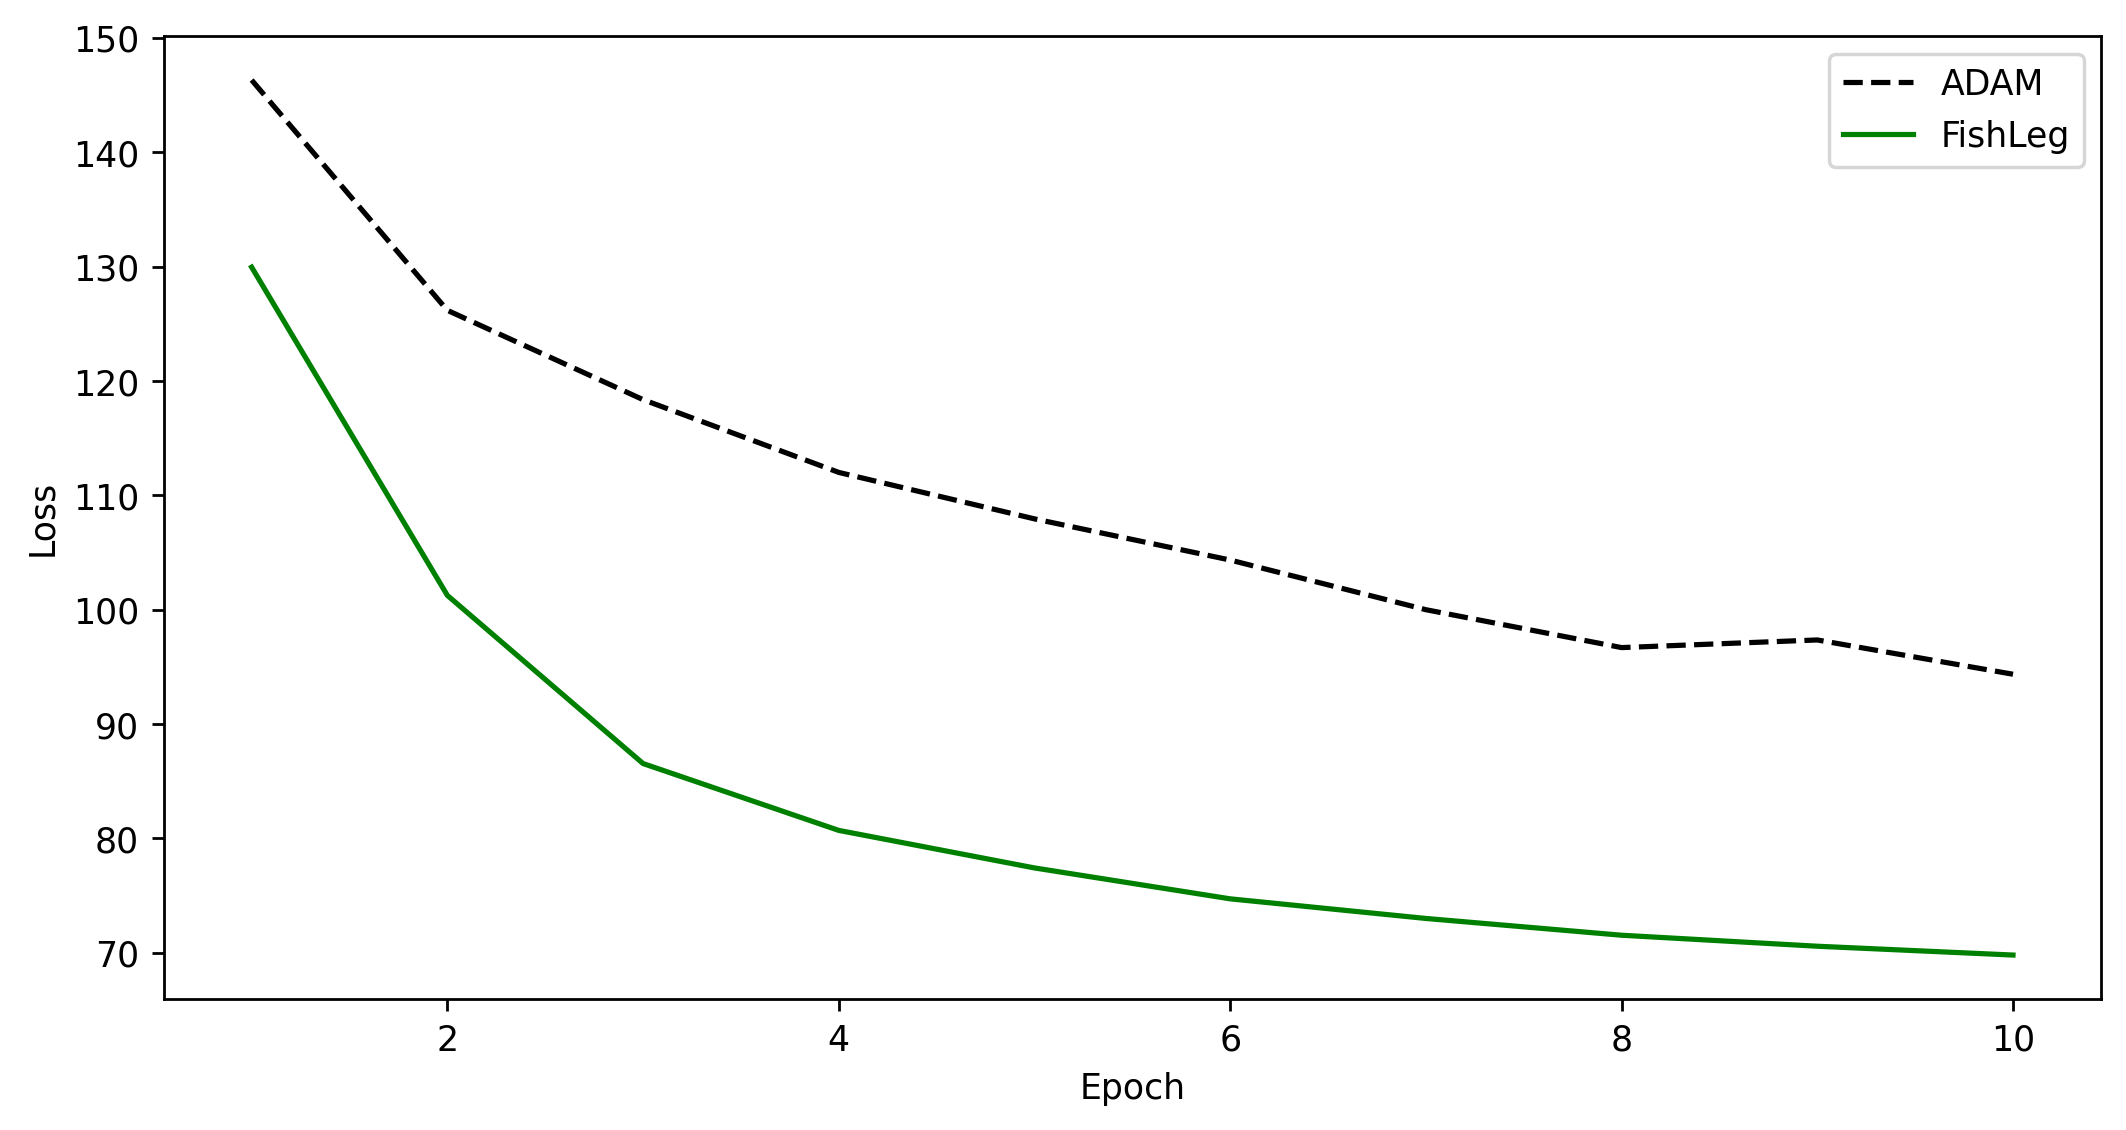

In [15]:
plt.figure(figsize=(10, 5), dpi = 250)

plt.plot(test_losses_ADAM[0], test_losses_ADAM[1], 'k--',label="ADAM")
plt.plot(test_losses_FishLeg[0], test_losses_FishLeg[1], 'g',label="FishLeg")

plt.xlabel("Epoch")
plt.ylabel("Loss") 

plt.legend()
plt.show()

Is FishLeg better approximating the Fisher matrix over the training period? We can see below that as our auxiliary loss improves over time, showing that the approximation for the Fisher is improving as our training iterates. Plotting the test loss alongside the auxiliary loss, we can see that the test loss improves in accordance with the improvements in auxiliary loss. However, the auxiliary loss is far more noisy.

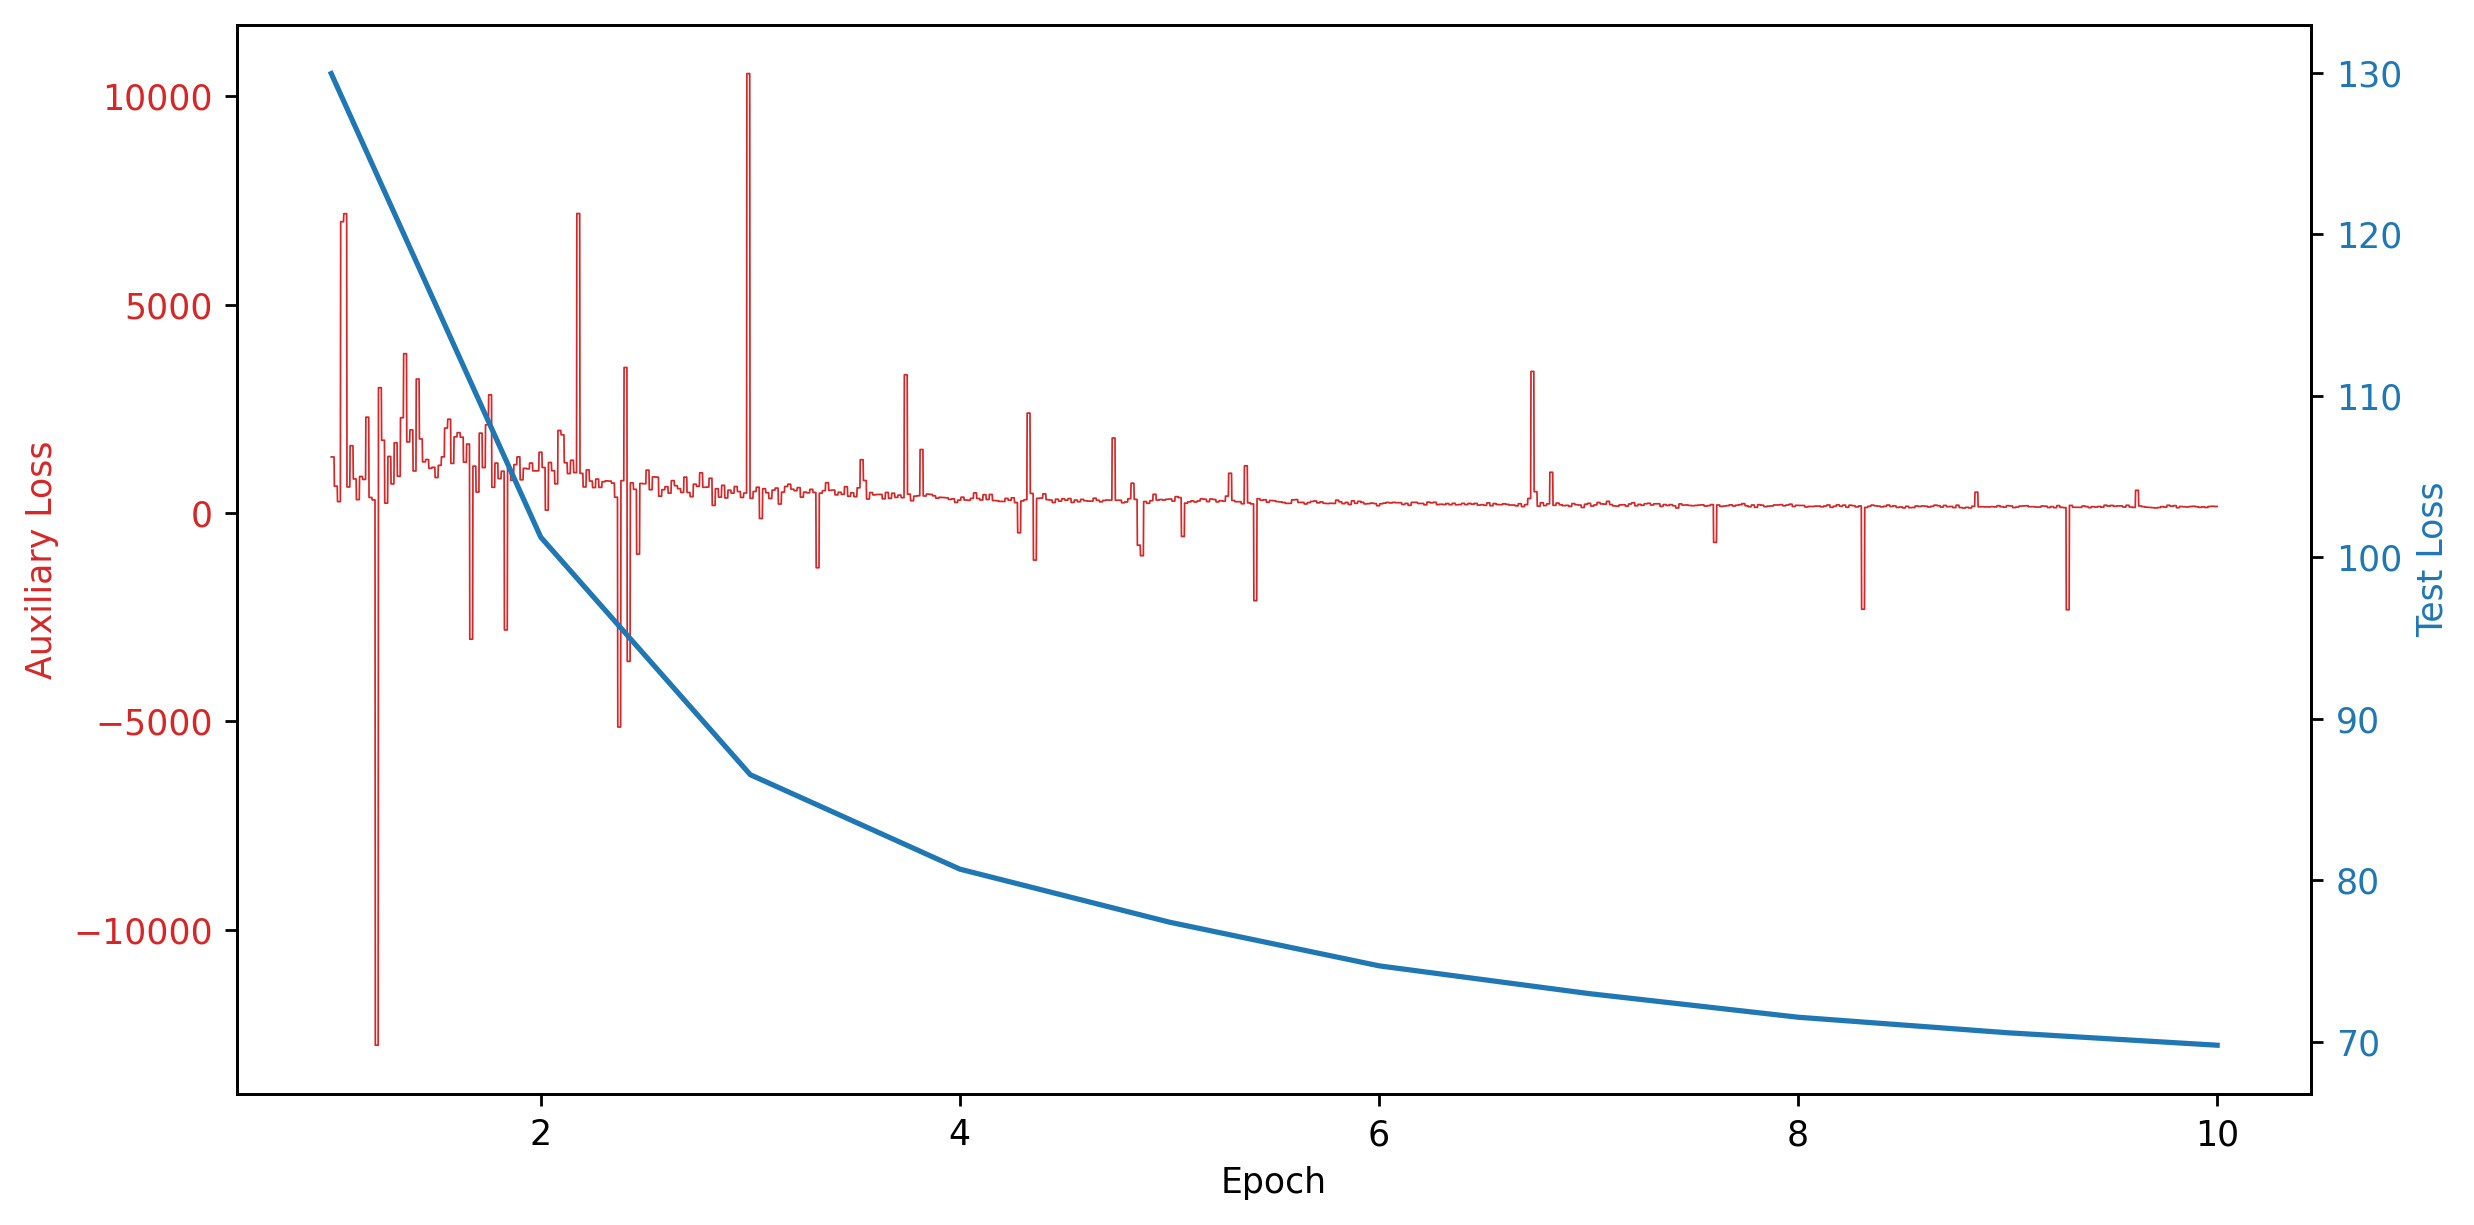

In [16]:
#auxiliary_losses = [i.to("cpu") for i in auxiliary_losses if i]
x1 = np.linspace(1,100,59990)
x2 = np.linspace(1,100,100)

fig, ax1 = plt.subplots(figsize=(10, 5), dpi = 250)

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Auxiliary Loss', color=color)
ax1.plot(auxiliary_losses[0], auxiliary_losses[1], color=color, linewidth=0.5)
ax1.tick_params(axis='y', labelcolor=color)
#ax1.set_ylim((-600,600))

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Test Loss', color=color)  # we already handled the x-label with ax1
ax2.plot(test_losses_FishLeg[0], test_losses_FishLeg[1], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

What does this mean for the reconstructed images? Lets compare the reconstructions produced by FishLeg against those produced by ADAM

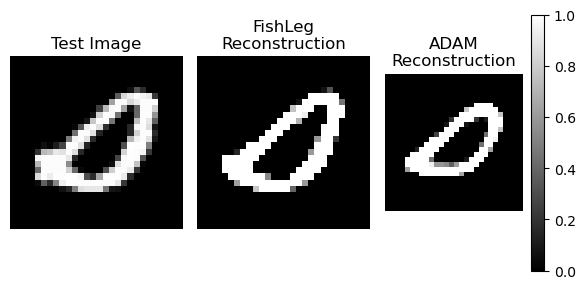

In [17]:
i=5
vmax = 1#np.max(np.array(test_dataset[i])[0])
vmin = 0#np.min(np.array(test_dataset[i])[0])
cmap = 'gray'

fig, axs = plt.subplots(1,3, figsize=(6,3))
axs=axs.flatten()

test_img = np.array(test_dataset[i])[0]
axs[0].imshow(test_img.reshape(28,28), cmap=cmap, vmin=vmin, vmax=vmax)
axs[0].axis('off')
axs[0].set_title(f"Test Image")

fishleg_reconstruction = model_FishLeg(test_dataset[i][0].to(device)).cpu().detach().numpy()
axs[1].imshow(np.array(fishleg_reconstruction).reshape(28,28), cmap=cmap, vmin=vmin, vmax=vmax)
axs[1].axis('off')
axs[1].set_title(f"FishLeg\nReconstruction")

adam_reconstruction = model_ADAM(test_dataset[i][0].to(device)).cpu().detach().numpy()
pl = axs[2].imshow(np.array(adam_reconstruction).reshape(28,28), cmap=cmap, vmin=vmin, vmax=vmax)
axs[2].axis('off')
axs[2].set_title(f"ADAM\nReconstruction")

fig.colorbar(pl)
plt.tight_layout()

Then we can take the difference between the reconstruction and the original. This should be a zero tensor for a perfect reconstruction

In [18]:
min(adam_reconstruction)

-19.043121

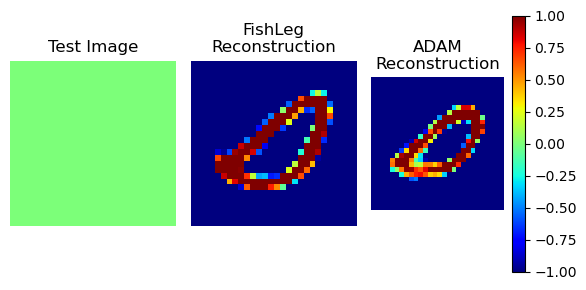

In [19]:
vmin = -1
vmax = 1
cmap = 'jet'

fig, axs = plt.subplots(1,3, figsize=(6,3))
axs=axs.flatten()

test_img = np.array(test_dataset[i])[0]
axs[0].imshow((test_img-test_img).reshape(28,28), cmap=cmap, vmin=vmin, vmax=vmax)
axs[0].axis('off')
axs[0].set_title(f"Test Image")

fishleg_reconstruction = model_FishLeg(test_dataset[i][0].to(device)).cpu().detach().numpy()
axs[1].imshow(np.array(fishleg_reconstruction-test_img).reshape(28,28), cmap=cmap, vmin=vmin, vmax=vmax)
axs[1].axis('off')
axs[1].set_title(f"FishLeg\nReconstruction")

adam_reconstruction = model_ADAM(test_dataset[i][0].to(device)).cpu().detach().numpy()
pl=axs[2].imshow(np.array(adam_reconstruction-test_img).reshape(28,28), cmap=cmap, vmin=vmin, vmax=vmax)
axs[2].axis('off')
axs[2].set_title(f"ADAM\nReconstruction")

fig.colorbar(pl)
plt.tight_layout()